# Assignment 3 - Kernel SVM
---
Muhammed Ersoy - mue@tamu.edu - [Github Repository](https://github.com/UlascanErsoy/ECEN427-TAMU)

- [Step 1 | Loading the data & Standardization](#step1)
- [Step 2 | The Kernel SVM Algorithm](#step2)
- [Step 3 | Linear-Kernel SVM](#step3)
- [Step 4 | Polynomial-Kernel SVM](#step4)
- [Step 5 | [Bonus] RBF Kernel SVM](#step5)
---

### Step 0 - Environment

In [331]:
from typing import Optional, List, Iterator, Dict, Callable
from collections import defaultdict
from abc import ABC, abstractmethod
from pandas.api.types import is_float_dtype
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn

<h3 id="step1">Step 1 - Loading the Data & Standardization</h4>

<Axes: xlabel='Sepal Length [Standardized]', ylabel='Petal Length [Standardized]'>

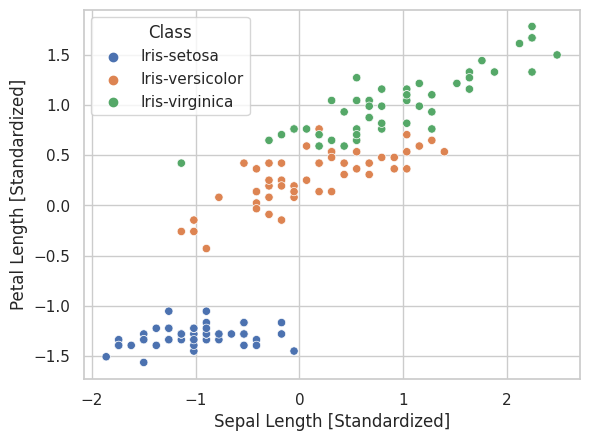

In [332]:
df = pd.read_csv(
            "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
            header=None,
            encoding="utf-8"
        )
df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length','Petal Width','Class']

for col in df.columns:
    if is_float_dtype(df[col].dtype):
        mean = df[col].mean()
        std  = df[col].std()

        df[col] = df[col]\
                    .apply(lambda x: (x - mean) / std)

        df = df.rename(columns={col: f"{col} [Standardized]"})
seaborn.set(style='whitegrid')
seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=df)

<h3 id="step2">Step 2 - The Kernel SVM Algorithm</h4>

In [333]:
class Trainable(ABC):
        
        @abstractmethod
        def train(self, X: np.ndarray, 
                        y: np.ndarray,
                        seed: Optional[int] = None
                    ):
            pass

        @abstractmethod
        def predict(self, X: np.ndarray) -> np.ndarray:
            pass 

class Kernels(ABC):
    
    @staticmethod
    def linear(a: np.ndarray, b: np.ndarray) -> np.ndarray:
          """Linear kernel implementation for KVM
          :param a: feature vector 
          :type a: np.ndarray
          :param b: feature vector
          :type b: np.ndarray
          :returns: feature embedded vector
          :rtype: np.ndarray
          """
          return np.dot(a,b)
    
    @staticmethod
    def polynomial(degree: int) -> Callable[[np.ndarray,np.ndarray], np.ndarray]:
         """Returns a polynomial kernel method of the given order
         :param degree: the degree of the polynomial
         :type a: int
         :returns: method
         :rtype: callable
         """
         return lambda a,b: (1 + np.dot(a,b))**degree
    
    @staticmethod
    def rbf(gamma: float) -> Callable[[np.ndarray,np.ndarray], np.ndarray]:
        """Returns an rbf kernel method with a given gamma
         :param degree: the degree of the polynomial
         :type a: int
         :returns: method
         :rtype: callable
        """
        return lambda a,b: np.exp(-gamma * np.sum(np.subtract(a,b)**2, axis=-1))
            
class KernelSVM(Trainable):

    def __init__(self, kernel: Callable[[np.ndarray,np.ndarray],np.ndarray],
                       reg: float = 0.01,
                       n: int = 1000,
                       eta: float = 0.1):
        """Initialize and Adaline algorithm
        :param weights: initial weights 
        :type weights: ndarray | Column vector with size features + 1
        :param n: number of training iterations
        :type n: int
        :param alpha: the learning rate
        :type alpha: float , 0 < a < 1
        """
        self.reg: float = reg
        self.n: int = n
        self.eta: float = eta
        self.kernel: Callable[[np.ndarray,np.ndarray],np.ndarray] = kernel
        self.alphas: Optional[np.ndarray] = None
        self.labels: Optional[np.ndarray] = None
        self.features: Optional[np.ndarray] = None 
        self.bias: Optional[float] = None
    
    def train(self, X: np.ndarray, 
                    y: np.ndarray):
        """Train the weights for Adaline algorithm
        :param X: ndarray of feature vectors, bias element will
        be added automatically
        :type X: ndarray
        :param y: ndarray of result vector
        :type y: ndarray
        :param seed: seed for random number generator
        :type seed: None or int
        """
        self.alphas = np.zeros(X.shape[0])
        self.labels = y.copy()
        self.features = X.copy()
        self.bias = 0.0

        for _ in range(self.n):
            
            temp = np.array([np.dot(self.alphas* y, self.kernel(X,X[idx])) + self.bias
                        for idx in range(X.shape[0])])

            deltas = np.where(y * temp <= 1, 1, 0)
                
            self.alphas = (1 - self.reg * self.eta) * self.alphas + (self.eta / X.shape[0]) * deltas
            self.bias += (self.eta / X.shape[0]) * np.dot(y, deltas)

        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions based on internal weights
        :param X: the input vector (either the full sample set, 
        or a single sample)
        :type X: np.ndarray
        :param hardpred: Hard Prediction or soft?
        :type hardpred: bool
        :returns: prediction vector
        :rtype: ndarray
        """
        k = [self.kernel(X,self.features[idx]) 
                for idx in range(self.features.shape[0])]
        
        return np.sign(np.dot(self.alphas * self.labels, k) + self.bias)
    
    def draw_decision_boundary(self,
                                X: np.ndarray,
                                r: float = 0.02,
                                fill: bool = True):
        """Draw the decision boundary
        requires matplotlib
        :param X: feature vector
        :type X: np.ndarray
        :param r: resolution of the grid
        :type r: float
        """
        #define the corner points for a rectangle that
        #encapsulates our (2d) feature plane
        x1_min , x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min , x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        #generate points on this plane 
        #that splits the plane into a grid
        xx1, xx2 = np.meshgrid(
            np.arange(x1_min, x1_max, r),
            np.arange(x2_min, x2_max, r)
        )

        #generate predictions for everypoint in this grid
        #using the trained model
        pred = self.predict(
            np.array([xx1.ravel(), xx2.ravel()]).T
        )

        pred = pred.reshape(xx1.shape)
        
        colors = ['blue','red']
            
        cmap = ListedColormap(colors)
        if fill:
            plt.contourf(xx1, xx2, pred, alpha=0.3, cmap=cmap)
        else:
            plt.contour(xx1, xx2, pred, alpha=0.3, cmap=cmap)

In [334]:
def prepare_data(df: pd.DataFrame, 
                 features: List[str],
                 class_row: str = "Class") -> (np.ndarray, np.ndarray):
    """Prepare the dataframe into input and target arrays
    :param df: pandas dataframe containing feature and target vectors
    :type df: DataFrame
    :param features: row names of features as a list
    :type features: List of strings
    :param class_row: Row name of target vector
    :type class_row: str (default = "Class")
    :returns: X , y
    :rtype: np.ndarray , np.ndarray
    """
    id_map = {name: idx
                for idx, name in enumerate(set(df[class_row]))
                }
    
    y = df[class_row]\
            .apply(lambda x: -1 if id_map[x] == 0 else 1)\
            .to_numpy()
    
    X = df[features].to_numpy()

    return X , y

<h3 id="step3">Step 3 - LINEAR-kernel SVM</h3>

Success Rate: 100.00%


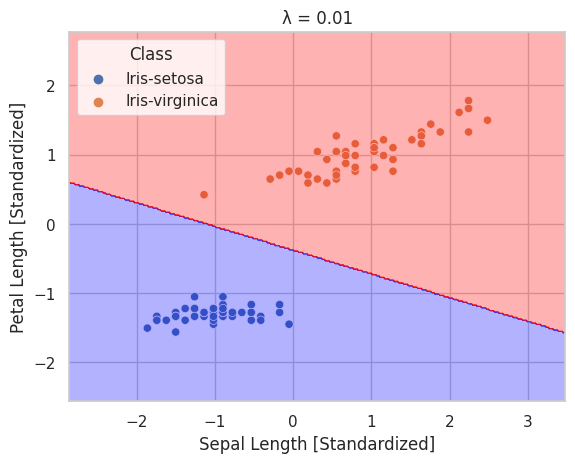

In [335]:
#use the model
features = ['Sepal Length [Standardized]','Petal Length [Standardized]']
clean_df = df[df['Class'].isin(['Iris-virginica','Iris-setosa'])]
X , y = prepare_data(clean_df, features)

model = KernelSVM(
    Kernels.linear,
    n=100,
    reg=0.01,
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

model.draw_decision_boundary(X)
plt.title("λ = 0.01")
predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

When the regularization parameter λ is set low, the Linear SVM becomes a hard-boundary SVM where the algorithm tries
to include every training sample in the correct boundary. This results in lower seperation margins between the classes.

Notice how that one training sample of Iris-virginica is now classified as `setosa` when the regularization λ parameter is set to 5. Despite a lower success
rate for the training set, the margins are wider. This results the chances of our algorithm over-fitting based on the training dataset.

Success Rate: 99.00%


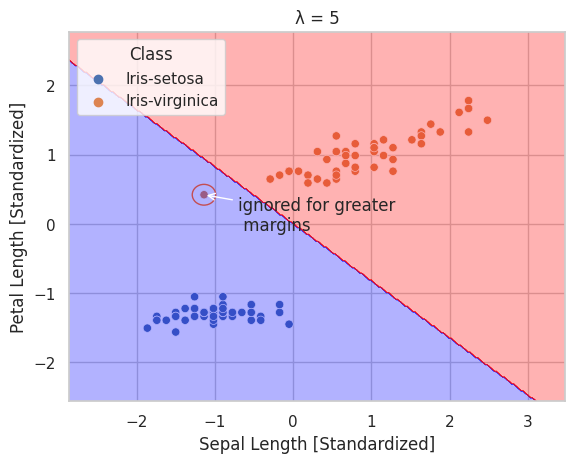

In [336]:
model = KernelSVM(
    Kernels.linear,
    n=100,
    reg=5,
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

model.draw_decision_boundary(X)
cir = plt.Circle((-1.14, 0.42), 0.15, color='r',fill=False)
splt.add_patch(cir)
splt.annotate('ignored for greater \n margins', xy=(-1.14,0.42), xytext=(-0.7,-0.1),arrowprops = dict(facecolor ='red',arrowstyle='->'))
plt.title("λ = 5")
predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

Here is a pre-rendered animation of how the regularization parameter affects the results

<video autoplay controls src='data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAEz3BtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD00IHRocmVhZHM9MTUgbG9va2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAABCNGWIhAA7//72/PwKbRZe3T//T/lcTdlCBNcwAAADAAKi0AABrAN1NPgZmvENvMAK8HY19Ax8Zjv73cROV0wAUyBZfxZer8qUcWvMai8GN6In9upUITPmCPU7zkmO6aJaMAtltU4fgRmJ5RNkZQNw/p4DV6Ja16t/Y0DPwuzAPTeV2+Z23AE1CTXqM/rYMD0s/jtP7ZYij9KHkdgwveLX+9+OI3cl3VGn5XZrGbEgGgfbJ29tDrnvYp9r6Q/I+YImb2ClsTa7oaJviFgAMGiuNNYugTAzNuEEsnGseu4W6qQKwDBuldAbW1Rlx5juJy2TFvTz2mPGTRO9Tn3vyQFoZxUK5z+B4/V7rvvIFPGstgAO1wEt904IQNQ8DhONNOgcBbwSYW0VfL0vOM6c4odDQx7gkvyX4AXqg8DspT9V9A4NtZSCxPgUpxh03/fPlKDVfeJQsIkqRNVSeWrOOWh34P0oGN8KmmfBpIzIgB96Ywq32jCq9jlBiGaW0absiHht2xbuxixOjiAZKkZX+9QglrMHwZEMbAIDv5gWpGEbud0qibgGzzz7YUffQxoMO5Bf8EKy1uZ1jsc6kAzNie4Y+3/2F/Y/Kk8zHAALnng9/bOFjHUr8x71juiTLUHHTUTPaGsJXfOv2IyN6bOf/TGkyjnf33oh214Rf04dnrLX4hjMvfKgXAYNW+ax98UhMNe8QV6wKTAlnVwR9bouAvTkjaEi/X6fCNMP1QcKxy1Lxf160kNEFtIijsF86LfOnOdCM5FotqgrRFfnsC3QK+J5O3gfTBOGKT2QQY98P0FQFvbKdP10EijHSE1PquOgUff6Hav2eQLU383KP5BPpfWBf56EpalWMMfpjtb9MHyUlgk0BrHH6DIXkCq4pbqLkw229Z6DYBsQZZ+XPaI5uv3FAH0+3UpE7cTbBR43nwRjuCaIWqXSZm52zfnTxKsVlhM+OQLKDq8Fxe+zgTI1rPHZAoCrkGjZckR6dmr9/H8FRS6eM0OOoNLB62W8KoflVV57rpD/9PbK8r1wkUFuAYg9MqZ/bN7jbhFVuFuRDF71h9n7pn+aPIS1QC4wQrZrzXriIwETDnWK+V7F7M4t7ar7qSmy3xkbrz5Tn5oDVujG10EQzkTUdE8DI60p01EqW3/+TUp3+DA3VKK2jVn23hc9wqOsVX1QT1aV82VS1SE3jBbTQZZ+VyY4Oilx291kHlIZutFLKZKQdRtJvX9IUwPOpd1Rdi52Bi65frhXNgxntjKXAFee7GopQGM1B5lBvZOLK0GLSz2yGXB8ZYXqmMie3CwYu6z4hJajuLUn5RWqr0hQVL3kY0D/8+Ke5/j44c/yp3Obr8Zxa82hCQAjRFD8bvb69g+H/BBbNx6t67ZmCimt2G5xfwv+VPrVjeQ+FLiR1RsN035yrgsVAuRIcjBusCU7vXhPsPGOfIM+l4OUFO34CoRQ4j1jDroK50PwcQMGk0b2Grqc3W0WX2umFFAt0xPN9+PEbNgub7HwXxy9mv4Ifp7LyUzodOPy+HlUDPlUZbi41T0CLPLRiRFFJP9mSli2KOBZQVjnRt4yAgA7c6FLFFMjaeZn+vvd/Y8Wz3pbKzNGjxW03tCQaXhJGMMUh1WNh1UDFOWYbqdB25mbEmDGpcZdeNbOeDKrHEVLg5N/oiypc12EkE3DqAmQlGLsNLlDKmuFap6b+dx2qltaFBonEm0m5d/ZDqgMHEKb1R7bmOfgHeb53o4mP/crd4x7UEFyrff3MEE9o2xuHOCVRdv1HNZG84fe/JeqUNs406cwjHXQHmjO/H4c427cNFW2wm2XQ5sdqVvNMT2xRceJGZiXqpPm6gouUanRFLjUe+SpcLTOv13UUG4XXSr+4cqKGsTfwW1EeLkNeF9NkaHpjZclKJ5be78W6d5iqxoLiPzsWQ6uOLuP3V9vIZxb2CqaQQWxO87/N7tLLOmh0HYu61ZWHJXpu2KtiwdQeXLRiOdJ6QCRhZ27OJpzWHxCrK9UZOQGJU2IPHDaESzHouFdJbn+x2rluun2+PXY6L/HDlxEQ+DNtSIqOZV99QC8sInFUnBCrWX4T21x/+q8xcUT9YQnOHN/qpBdSjYXKLPuXNORP9FeG+FieeX2cbpvu+B435mrB/ARICyg7yTQu0asdx9TDI8OVOYAYHA/QSVwzPnUN92ZaLlT5VMS2Y7Ppp+I3PMnv2UTkpC8JAOXktA+Fio9ofkeMWolwPuS1pY45nabd3JdCPEAvg7Cqk/psgU+JvQOfIsfrpIAMQNw/0DjNss2+YqzfOoklTYruBgNQrlc+x3/7divQp0/p5XEr/LyhJDcbn2g1jqd8eDHTbNtpWtvTuJzOFNdoPUGKJ/43XRwAjX8cf4ZEp9cbiAM0vxSznB5tnrSpR+/cpKcKID9hIceh/+R7tNYvyAf/v3cs4EamH1m6EpXjc1lqKDyQjaNVv5grCNFBfMtHxeATP+JAZFgOAxdr7L/oVMb2bLBUAxNx9Iq41RI8JkYEtsIoWhCabYxoCMAHjFh4MHXbgE8eA7P/+vcRV2A/qesKoPkdEY7vg3sPs7Ticq2Qbaj3LYUWAEhIlcXP6E13pCV4wIorf1PhYJdwuH7/B+2e+PvqBAFutdZWm6po97TcOLUjXCgjevpFsHzpbgn9JS9kFc/EUPoY4JGB8Pc/owings2EqU2FYYqnu7RejsU5aJ2cK+P4ucAzUioHUMWEpJET9C3J7VwJKsxgsAbEh/b5EH1UhP0UWVBMmv53Ht5MJIsklR343sf78gQHdgx7AQE44qlXh+QYh9jZIw72kfyFY7Djn/+p/8Lbwhg8NK1AGq8gQ8ZEDP5ann9MzYWAgrWMezHZUMVEDWKNmpxvODwukAYBKBarceOxLYefjop0vJsqVREhqftaNQv6UXpgEZTWT6SavjDvd540O5cuCT/MciFn//57SST+vr6ClxoIL7wR+DNKYXT+6s//lfxlOsIZNZTjdo+cgk88Bmn+zrZfc5+3RrOIC8Wv9WM1UCAFNby9+gXiKqrpj7OVaW7Y3N5IJJvSrDVSFj0iHRo9Na35621rD/lrTabFOOXcWq05mHDR7GPO9WmW+1/O9O/B592nM8QmRgtczpelDbAiwxPzbkhrIrfK6uDF33pj1lfG78TwsGpv5O+umNePWNx7qotlGxIvJf5nM5RQXW4IL5c5VSG5tuOvBRTBtmhx9GPEswBs6YZ5o70bGBVBO4ML/ndNTsVMq4mGMdHa3BE3LBcMoxj+u3vbfgCtlv8Pl1Q+tf0OgA8KIDuxOkBBioqfEA6vLNXeS7FENrDgI/xCbGljXhtJApFGIJ5Fi4i7HyZ6JnN6/8fk4rNDIoT5naRCYes8nb2io0RdV9N6Vw1AjaHe9zyeYIIf2S1qOhW2bUwWmb5QhU3CoxxE4vyDp8UsB9vF7hWYb8UR07RHgwtqJPcnxCj0RtFDrhIfJrXBWYf+zYbn25vSqsqi/Num4gE4YMDXxqMIimYo5PjyhXaz3335B/LLo82B/CnOQArNRfCWhhmRR2++ulFA5JIUXNrlDqyvNizRqXiLC5eLmoChrPm0N9Mm/q15y+36LF8lanuB7h4CKm4awY25vFAdUmlv5dLv2ziCWznA8Mev7dmS50u2e/dRd8btcaLqshhY3bIKbo1CjWXgFHkCs3w3J/iSd0XsB15i2qXwyf+HgTmKC6tgVqobo0F5CXo/YJfNonmXIJIQIIpBwqojs4XQdcQv/YbUII4x86/99qIOu4Vif/7ruSLrHMhUCgmWMdnzdjCS56IFg7o6lCcKiBZnoD7HDALFFX0z6t8eqGe6Cx4lZqXfAGeEpaDvt0X6ua1TQmoCU2uWAnaK5/9w0f6qYXP23KIsT8IB72KHq3NBUSYDTzeo4sjD3u/5o3vAKWp1YzFeGba0BZ6x2ZBy457xZm4hvWDyo3QoHTn1dEV25zhStRpv35/FohWny7INzMuVhveEdIB5thDSAT8M7qF5ZGFNMl43piEIDrXe0VjOYDlYR6IG04d48lA9BQMlqgcQwqS2OJnOnqJa8dSLqfhnT61nzC878L297eh/O/jrdi6KKkjCfJsFAKsz8UTCCbidmiJPGQDtOFElJhLz/peomU5yKlDq1q80D4YkijceHrcDZWtBBu9YfixhK9pUKOQD0hSzPB1Gt9/tg6afhFBBBQL4B71DRD8/hUV7JzmAJlVb1pgS3oxU1aBK/teEYZOLgv6KTR7J2uRPLGClcKFWD6uyyUpsh7zDQ+LjNSSoOAaXBCykvCLt7K7s2NYIj7GKMQpw+UjUqCisF7DOd4h7O8HypHgDhSLlzWjWkzL2piKIwP7C0rfEpBzrK2RRBQaX+YX86OmreKb71IJx/TU69+x6qAEqQXTDnRZzVn8/WA+ym+KS0XO/MZEUQmsHfffOox3uWkqkGrNfOsON6+u6m4R80m3cqkLhiX7y9kXVmC/mDoMXDsWB5cKRrGtbGPjc0hOX4XZbVAbKdZSLuqkOkOIikP+qTJJ36n5AF/ODAOAwy0kH5278gUAeyh3ZK7a6rIl+Zpc6kpOdwAe9RKBpTznHMjGGVCuWNfd7YP4f0S0DHxQhQOLcx0pNimiEI8ufdTdG0xk1qOq31sfzZbA2KH6rYomZDbYUtnzpCac9zPC3gGoeqgA2JGTjh6+3obQon/zYDwvMkPhqtpoaqrg2X7w1AMOrPIXH1galrSy/l+WGXFpCSxr0U4opJPVrrCxr5xrlchPQB3QNqpFh1A1Rw7xpdXIORgrk1wtwVKfQ6/f8pgyyyabNzLoRDYL8ZGrReecfs1kI6Ap7rEeDrOvMo51nReFSdcbTjfAUrPGP/fYBDKowYiHX4JJxEx4ZQj9ZBIAfgeDqvfgyFpPe9yJ4/8yRPJrOMRSZvgO9Dk08V5KGeE+muEpkMoPQbLQII9RBgJpOnWELEw5a+PV82BS/osFFyqi0ZdI06Dj8YY6Yv16FDR2DvR4bE1XsUFATVEJNSHH5otoiE+4gH5mB00DmBYlVKBS/aYTub3HIouWZKby0AVIHHYHJsM6uhU4fABaXB0BO+H0N+6BMLxz9mriMpzIWWjezPL4y8OSy5tjfGcekbTF9uUGbwowmpIiOofO2Z7jg0Z7W2erRVp96uA1W/saVKxDjafoALVWc81mYYD2T/m93cf/4yMTxs0eIXnTa8QteqPkl6t0jlUd+Yp4UkVtndk7/uwHQG0Cbux6lnTUxFSZA886DmYqpGMtwEBl5eScW2OQiFXUoaJ5pkl2wiN6Ottiu0E24av5+w9v0duZGVNdpxMNeywXoutmB85IiIQG7DMQhVVC0iQB2oFXNhx8Kw6nzRYyQlzAYstUpS0Oaf3tFsSkx7AKIUGv6qXErMFYUidX5mNqNohHI6brPhUDgL68zpMqUBAPWIrZgm6rKV6VaGca8ssJCiFVJYRfssihNcRdnkdlwhANB+jDBjmLEIiQ6oZJSqHteovUtkY+EyOvmYrjrCcjeVk52UMDfC+Yp41GzG2N65xMxVc07Kc1pKXPiKYJzGzc4cwMZMhmYPPwA7sJY/NGkhlPLlWAgo0iXBZ0Nvr2oocUYcI2b4A1y/pMPJHWzJfKNaEaKwGZPflVPAJyIgxZQ33b7xK0KQZayEe9EG2UvkywK+kU+sZuNl3Cx8RwqhydvVeLhf2cJhe9RrhLUvO0zEK+z1qtvN1ApE6ol4M4mxndrQq6ncAawIq2tC3WNF6TdlHonZ1H99iGkDz3OywW6AdYYfaDxIoWWmmERxF+4MM6RhKN+t+wHBJHvHMlv7IdO/YeudWpNaU1UmHyioOFF2JoepPN7fR1VMPnJKHqH3JzeTAthSOXEMpvjfN3GMSpXrXKUEUQ8haPnNkH+eeADMZotoRn1IgY3NQdPpYkegtajOjnvxtazEaTslG1LJfPJ+oQvJWY4I8i/NrcKT0G7ZtDXdVnGM9oZyNQ8nSql1JAvShicmCY3CP7RIo3pCNmcgMiFx+HpYgxqYTjAliGNtjMjuP/s9v7Absjxu07ZaP7d5Rui7LoElZuTW7AA3/NOCMajuWfFSnNtQxrwm9PmsK6k8mTORQ23SqLGj+yTx99VP/JUOVe2S+MRT7/t/72oiZ/vaF7u79DH7YOhU4gjwoGZO4HWZIwWcdA5lW43pzDROPvbp8TIbPBNqr+rYjjHhy/4avarzybE5tRygsSc7/YITiORhGenY5WFp4EUEw75/KSsbDXcQHwunYHLjURsQkKLQlpXz6Goy0B3aIwZa9DtBVEMbbJ13UA0v4B5LKcRq917b1ecrNBmOYR8Tdv7NGPbaNqSJ8AhMHF+DPYCN7uIaM4rq+trFWnB4rF7plw+dkPCyM80DX+2Z7DFMJc80x866026555Vh7F9H00ZBC1GROBYcBjxMMr/UqOp9zUYBpAcRkYcQ2/HVDr8JZwwrjAN6W9q0+5VmP8BNYSQIqebqrCrFVSvlFlavsGwiIm0oSj0w0uICmZL3CQ3j3jCxAx2zO/4ggWRHMy45zZci9YwU1TFHmQaypWgxbRiKLfYiBJXgb6gfO6C53AanFYzoY8GQHYSo/C+H/ni04t2I8O4q75YboWik3RSl50Ut9eCAieJxYVeuR+yIlTNM0Dyd125XZGTIzoc5B50aW8nsGnlWRgORc71QRHhHZgftNVp7x52WhAxjTYKNK8AdCXh6ACiaA7e7q9LNGAp5l1kFHDcjM/3MFucX7asrmZAdLRLy9Bdlo6GFyD4hY+rjba0GdP6HI4W1w889asJG/6yXNQmOtLhxowXspAfJHGxRK+alh9lDZCna1sbzzbdzSm2ROjf3vw4phAs+vIOVKd8svj3WWcHLUhVpQHJ1lbGd66HRb35R88nbSVis4NWkMLbXhtVV3kTN6kR98j9YmaWAqEKc6wftH/ZPbCsFnUyK4ycnAK748HWljQwR2EiaMVEEA8e91Qv39CUhp9FyCuBHhn0GEDWGiCVaeZ4ooAwddNm6thtDebRAPA1xc39g2bAdPDz/qOi5i/SHoX44l4w0DpLZZMX+Rjv8wRQLESMF9LnQ9PDyqplKZV0nyp9TnoCtSxJ3MXGvMiw2yq01XU0uxhdtXZEV5N6U0UUmpVb7NmrbUctp1snjl4A1xsVh1ahKP0v/NZ6VoGOvhpUw8yd3dRGFRbfIy12lsPpNrMcWYYShPMUJfC3KkerCVah0tFCcQ240mn2Jbud1ODa3ijepGn/gdXqdSxeHvbn/ne29Scg1F15qxH8vd/+LMkOE1pQX7eOqSBncmM0L+tMfusXevv/91SG56AGEdisbAWzE9rhbwGAZ4x7P5ZTWG5XNtJqVKFnEajt8BeJDbWHBoeirQYxX0tivX13Z3uCKK8Jhea0VfGyYOGSaIRbvZRCULnh/b/ug+QLznEgstw/ZD8fV+IV3Cpn64tKeFWEuu6scZZlw8rIzt7jZh0+YMQMi9+3N8JnEkx3PgBwu53kheB2dLi4EdWnYlgPkVh68A9Wbb+qSTlGorr7wt6T6jvRs1oA2ffKB1x36DHtZnJC2eIm2ldelH/+HUr3eA3URJpgz6mFVJ1w71UcZpzgMj5RxHdxOSnYITp2/Ez1u3NO1iZRXFS6tDqdU+1SXQSrU8sSYYfpP4wFsZHXLQnUbmUWUTuiDrEaU6p1SSB/F02TPaTldaxvS1rpjuH7hPNLhASq2jxbexzpoY5S0AKFCXY9+b8uLZyPiycacavDh5xRrEx21vOZOXtbxXM1bIPw4hsnbRJXyYldPYf55tPyPBrCECXkr28xFUqA8zX2NIEF9YYV2Y9RQlzBUfw9g+c7/PzRvukPTUsFwl60jhNtL2CJgtM8xtnIo3uFHQ2KdwLWBzrqIQEE8ziwyAKqyodxTKRLjKiZ11F9B/Yoy2hqnJpz9pdXtTcWKk2BmxQzggg+vrhsvODuXn+zLfHkgci5MBakCHaCspJTHBuAQm/D6TGpHm6ox+3M0KODUcOhESVaG7qsCROxBDINX50/xmMXKQXNsJjyInncEjtxbk5dMm/y27qXMpGjxSx1z9TgMgW0enuVk9IEh2P61dv4vZi22pJ3fRjzJU9L1rms5Sc6CBLXQsi6tIqryzB0D7rlWbfiYvHhFeT2JgtiPXhj527YsWmQkwJ89L9GWvbbPDPaNNDHzrR9Az9c6Q8NXnrOMmiZESIUL7oXN2dpIUWIsYMIt3PiVIL6FbWmatMj31+OZtAR6aeYXc5vBYi9pTTHl0hru/6LUdiVxXXn6CewcovLuya8FvnOvsS0oKndSGTShrUEtrJDfVTl5sh5VWhtidKsdzJdBY5LvLcEzg3PnxemCCvuViTUru+eJRMoSAaJtL8rLX1E4XBeXv7Wx4rC23vRs5XNzJFUKx9kSPnPVAmJh1vfSlilNt4tp167Qx/E9FVbyzXmBSb0autiDXO6GOc3QrEGoi08uqnx7gXLlKiGNCryjhKOEpJ0b6ytI2rFmtrJ7qVVYosLQg5HvLJ/tG03BoIK1Hs7I29oC0Z8BiJGumA3UO0QAmXvJgukTHWtQK5LsU7/asPPKNkYfyP0wuwuQtkvUAgx2Vc6Jy2G7fR9L8no+lEFuZ1BkovQNK2i6swn42pA795AcBB78OFhAl1dAEfXk1qRjx02y94La/LzIuWe0VbeOw4Y7D//5P2/tHqD6UYo7ismWDTl2/bZ5MWBx8SJxclnaS6XoDI2IdhVEeSl23kaG4i1tRMGHAyArCF2oI86wLFFgmmyafV/z4WAzdrHgePuA4vY58rXfRgesJVEZGWDs6d8j/fQTokAiJj70GtCjpYW1rREInPF0M6gsMxW/qqF4uRAfgK3vcz45OXviFW0cEUhAJKGOygQ5GCja9FuJ3XUzVz1qrQPSCdZr/1c+8ZjAlqBO6/XyTEnUuLJIwNxR0FYB4eQP6ot0xMjzqx9YK6biTNkNPOl+ikbP9kCFITJ8xpn1cOrkYukXyLQmdBo6Y7cxwgN+g/nFy62dvJZnCaw9eI+ordJwYIYhKeOEK9KneJNvISg+0SwwtQuGOdIzygkrNtb8aGydWSSROjHOzE+549jMm6vvSblvCj1SZrGK5GT6PJnLWylZF/ZXmZ3T39HM0ciaVwixzP8dDziG8Dd3GaYjJcDmZSHLM3ObCXnw8wRzqMpjB70DYZE3QgY6MNIsibrWGIvDhVP2HxkkcYwmjl7ekgQGFWrR5mtkpeyMzt+Jj3Xnh2anrulrfHU8Sn8Bmvx0+IsRQSDqaTu/DK7D7KsqZwuhHlJEvOCjNBxNyGyS9SRqjAp/q7IIFUMl9VWgqIEQN6llOvkFKObOp3xuwos49VOYLz3QQTChalupkJ/LutLEdxNEEcYaL6dSULqH9LfzPcbbiyCLzhJS1sDa8H33Q0Xx9uWeqEt3jtBxQleN47erxA9WjcAvpOLHf7LRMnh8vxpgSqxGvsWJfwX/b21BzY1HG4/nKEz/eKqxIlBQ3deeRYH66IpDtyXU+h2ErGHMjMKTIAsbTRCx3mwGq2X2p+zeGkvnyKgFF2A5+vlXYSvTziXcS+OZrXSMcCuNx3TslQQM+aHpLnXZycZ9gmDje+PLucpSFFVLqDHOeYvt4i6EEE3Nn9HSQZp1C4eyLNOo6QwtjTnYSzt0WrFCNA8E4pE559WAWDAT6u1aaVxG4sNvQ+K4ZnSSGaQCy30DJcUAXk6HWbe5Z5qxATBHVDs/4lSMW09MIiEdUkG9ChZsFGFsa3UOIK5Mq/vo6xpVdg7x6YoETz3XSBo/NPw+Ikx9z6QTDbW/Bj+YEG7dBcEg+X/zJpONJ4IVH2FRT63QiOI5s7PIEdm5S3e3h21OpUTeaQ2ClVXgH/OMuY/16WMuJZM48I4KaaAX36kFUAxFPIxZS4pFa5lmez2SXPQkduc0QYiMZ8wtWoASz89DbxzitS6slE1AqPDtNS8pTsGoR/qGABpoAUSBcpIfmGImZFzQgVE3K9cNsf4NUzXjBooDa22qnOZHZyKmhAv9n6CUJ0qJx1rCbpYqLsowa+7DU/lQvm4MuF331UMvFT7GYAbd78DboPe4JzXh/WzP23djg/XSCj/QcH8yHG+9keGOHBdAeRcf/0nQg77F7MvHqONFlrApEgR+RbH9NIQ7/gGKCqsc/Yp3HjEssH+4MRI8pbztXXYHiMq56emOcqv3Wpc2GQibWRLBewa8rC4o3Gtc0fMgrvtBuPwuEtJNEnPpEoj1dRH5edgRsmClNGPsg2FWMcsXn9eS8AJSkSN35gBcwYlolZtTplhlWnuTQO2aZ+FIHvkTiPmYtvdfp+h4p39T2+/ffAFsD2YHbec6V0L+32Tq+V7cfU7ZjrOVbxvF8FB2I7Og5WkBndQzL00oMDcqKfzZDgqBgqHpyCFpB0DufcOlC+XYPAsX8qcL31CzGFQvv2NOdcavlgsn2N0QJJ3aoFTeSlZxH+l0p/1C7yYf+RoIejNljDDVTb1/0MDbrqaPcM7YWrHtOXJT3TTi/BsufTGs4/bQbKKFf4SHVRLr9l5MaI5siP5tNELdujtb61uyvfPp89wvXMsNAsEc4w8JpzVvwBJVOGvc/zFMiflxkxXD0fJ/9GB+6WbtOKxSw/McivSpoWyIKCXEIU810bSGz8J2ipqPaMU4YG7fU47PHqxcX8iy7Y0q/MpI5VwqYJ207Ys+6nEErkn9i3PsiAKHzRnLyRG0Bh8UNQUQmC0NdZRGc5OdPg2gftRZHAayUORevxYpGEh7jEnXYOcTKp3yuGdcXIXdItIzAEo0SbnUqkEupzvPAjEJ260p/d+LDwuwqeGyh58A8hFVw2dIuqzntROW4fvuiebKkyZNC2eGJ412t5/bxJniZJ8IFd3tIDTb6R7VLudCL3eY3evv80MILi8cdTXOmn4SAWBE+iBzukyq2NYQQz77CaGYdstxuB2kMe9Vw7PwhD/oR2WSxzhz7SAwDANqbZ3L7zn+qszzXPnAskZtQVeNIdDsNhkkxyBUE/ZS6R9xguMAUbPydT1E5XlWhfY/OzpH449TPiAmBstLeo7u7dbXYD7qWvg3v67GhNP+yNnwfg5Pt54bXtovDi8HhdFxl8um2/lrPnO9wFdAGYxaexOFJ8wUmReEqbtIpWF09MRnGGhCIfIYby8J6SBaJLCGUyCgNFBDgPuOzt94IaaJNWAoFGtw5sWsJsoBMUWw2JZatcYtsoAkLypkJmIsRv8pFeEabCaooUEerIKhzTx3YH4Vd5eYoZLEE/AeG+oYWUbC1NuIHAxyJWD6+f+oSRYmqg0p3RqbhunjvupnpTU3AuSXJavPlbpgTapjnE58aS1lMoT85mIiXFlm8nEglZBq6iDFlOqXIz/kymYUPxrRyNCNYXUKPAZGjvOaaYeraAcRw/cHiaOAsKmrKoJfnM9s3txwoFWDkSSDHe14+UYRN3dcDc8pIbUsNFzAN6314VnB4CwpPiVNQTDj5HzqWE5NwMFk+ng5hnbHLMu8EJLKt5EDWt5ryMPKefMQ2gPoYNe8HBSxqOrCKLorHRIfPj9gVKz+RIe/EfAN4U/8Sr9SicmGnXxwsBbXNNpBd9gfyDTdfYuUk+tnpDW77cZJi8pDUPCz2BiG3z8E/+vxbFBpgDrvnGhLlcHpPbiWACClo/66+3/MeqTCblchFfESMw5K/ytWnqu9TVmcvDzfqzXzK9WzQ7fRsT48cbcI2qzsILabad9sTxZtnWgLXIEZQ98aWae/XKZ9dbI6rzpgqiyKT/j2c23KqxKh1v5KHMx0R3BrUflgQeESDMl9KqFXbS7YEtll9y20MhvsbLxoLyd5OzfLceTK8RQubhKYJWkRYiguB8IltuPwix41MLShYH8ZsqWwa5uI1sRc0uaJKTdNG+xvPInH6WVri5TGe36KyzP47nMf2atRIKkwM1iBnB5+Af4+FIBfiQzxlXr34ESj0twr78zDyCYJjwyy08VFJpB8o0I58r0PoYx7ne0k8425stz94LoN1U1im4z/hwoyFhJGxO+nlJBzLU3rgonHIh+4RTGS8zmij/zBsx/AdhWBaAxoXecrc8MQ8cb2a3Jj42ZyV8efl77CcRx73c8/fCFjGoWb+hIPzgxNYNZQMyFLdZN/ECWGM5424NZ32UoFzYPfFBL5tu+dWsNsG1dsPAR8H+vSX+Mg5NTDJrq7JM11QH0Gs4C1v1pbCMT/s0Oi1tcN3sh8CmclK0+nIUBwAb/F+pRblf925yZ/RNZDkYHm3Y1f1qerU8x0yxREeoLwWf+nyd0Noy8HPxXEo3w19TwjekSH1gCyk8TNZF0JuNl7ERe67u3yIb9KAD9NQdM3zIm+90gb/mLiukGrsi4chZTI/9n1Xfh7KKlz5s99rruaO6GqvEwKw0n1ToMFxSoD1Hdrr3aSsM2npJcDKTydJRnWEVOuCLGu+/+WFIqpMHiwc6d5NrVCD1eK9g1Bem/3pzKpcRpNs+Bv0W7T57tiEyLv831mtQWcAdaQOoHq740Y8AkW/PTVsOVdrHhpGIVVh/BN6VV7UfZ+JfKRj3Dq+2hRT4eoTBP4YfWXzNhOrTdhUsFZKdnaCJ3J632MbVF0aTYUfe02iDTvWJdDThdMyPkBDW3c8ZeZSdG+g1t9F+cooBhW3sa5HNzVouz7Sdz1emuR38PWPMs9xrxXEia9mAY3cPeIKsfebHxBF45/MFpr4Dd/PcSTU+uulyHUNCuP63I+6OJbgr+XDvC/c4oRLT4TB6eddG+gDr7GYt5HSCJzhcCg9yMwk+AinJGJzG1iFaRG/xX/KFUTH07me0pWRPeDqyyCL9/eHTWyJDDUn7pO3b87C1X6ff01ii+vQJ9fXslcKZG8eKs/mtBsUxXhkJ9Gg7lksNwK2z37JaN9tisEIuVKUqE4LeHn4ZqZBSeUxPYfIODBLzx//uw8G+mQg07OdAKf8zvf5SbG7Cn7LfpQjBaN08bzWzUJzzNHz1U+iGXa6IrsZ+1VHT5WMe3RIwE+bYb+dgJoJrMVKUyXEIx6m9Jnujfj1zBS1IJ0fcZkqRLqOCVnVTaHjU8JcJ8qm0lYVlOPR7Q0VkZjzydvOtgjXRnzx1xtunOm0z40tm0TPajxZqDpRj5V6egpZl2tYOvvZOIV4QxaLKyNUbp7eYCdGauXHfdjDEJUeHIPb+au5VcnPWWHNxSrO3tVdXdGl0QiGcn/QRwovNwumKdWvFzOqAULYt+VAWPmQ03Ofe6N9AroJ4k5IS92Ku5jktsV0vsgoAa4uics5RbIQ5uDHkkvi9LGhHBdyPsZi6D5uj2xXUHvjUohPbsGzkbWOBVANxeLMZD7kYfK5LfcUqYgCRYDvvZDJWz0ZjK/wn/0tqVeHJQPP4MuW/hpulqU6kYOpdF3Gq8iNVMN0g5hKW02buxLj8NHS87cRmDn72ljF0WXqwfvxyqgeahbQt0+hTS7aLfYYHNOJO151NB5I7XwyXsmqH7gS2pF/gppBmWT+mBYTdFIzbhks8Ve9WNecVH2CCmmkIT3Ot/UXVAJxCFoT/5Y4H64I2cdCMQo8X8iaBtpOVr+/HNbJ1H9NBO98HAf6fuspG9vSXRDBx5n4gyVcGkexwwm3Nyuz+HgVuX02qPBJH1qlT4ZxtFRQulH0XBswvEw82vAE8DtKZEL2uG/RlT0tM9IW+ueNcPMS5ztQ3J1jmU87q4sUEDpG7kjs/sMw2FcPqWZiwV50rkcbm6WdQc5pOh7t1iBzCmCB/uZGuW+lZ71u740Y+RKTES8MZukItPwrdK2bcQeTF8AI2SIGRVwYjQLHMVDzruORRGP/8vbf/pWFMTh3FIEnjQcXKw2j+PzALUacyAxSnYhU1VlJBVFaedZodY5q+WMeIwNF7MSU/ZaL5VwcgnYsm/UVMPH/szap/m2OSQJtE2EK5E0GFMTeZUz+g7TjauMnpNs4BrPWKkri377b0FFefbMkzrmJnG5J1BY8qkx8bGtav8/xx3jHG+ReIRl/JxweXLs/jlI6FDiKju2OxN0qmNQXHXToezhGD8oXuQltfd0ZvmM16ioMcPeiC1WvgODYNCHZh3aEv0Xowg7SOucv/deIZ1GrQpu2jdmt1EtKaeenHE+BzTjZTWDw6iCrPwFBGWIapGHUNPadgMiMCXO7Kh2AFysZqBhp2uelMEcSGueF7uxWRfKCb5+l2AbFb138nGIDEA1nFJPLCImPelcp5hPbCS32vCN7cnIVWk4MFsA+9WGGYpVNSBRWsrY3O3Xc4eVKrKF+KCCnX7fZv7AOfZR/z9ly6AqntZH3itNTIGEjgyYK1M9PlT060XIX/V0lGRQ+y6zBUk9tjP9f1G1GW0dvO+0RSHl/TdQC9ked+cv0B2Op/SBMIihjUMd7K7XI689XbCLaGnd0HRrDRXgXiBVyBP9EuqO56F6ixxvoDUJb2B0USv6wsuTug2W05C1Vswb5dqMubEPknZaRt33NEZ28ScHSp+sR2GW19UIpslPfpOJge1lG0O0Lhn3ZPizMrFeDssuXQy0AZ8fKd8PjZ1lbYzRLfE6vF3lHpkr8+ACS0NziPvJlGopc9IQwwxnWf/Zq950KZewXuBS2V8oEPdP5+pYy6+y5Lq2esh6v4nqQajV3HQuMqrRng1+n0/tkFJR2vgm3C1D7Pf/nfLaSTPtMqg4gwksuynTUhbHEfztseXPI62V6IQJq2aErwfeO8VYh6rtLT5XfidbmxIFop/l/gD3gAYzwaXzgjYQoNbw08PYvOKrTNvtRuzHpnJ9r9qpMLO4UQ3gw6af6+6pHsUmL41M9zPocyKVy2tfaB5XV+2nZKNR/Nx5YWs45XAEb+9bcLE1+6PAatXXZrn2WhmVqlslm4/0lC2oJKZD7PxhKGKnI49cyllghN0Z+yCU8wmh058FnSfmaN2Y0KGVXlA6DXNiLWIUBbVfDMnXB3AidCMbKh9DPpBH0Mh9rQ57DOkZCRZpm8wdtOtzL9lGN77Nqg+mlRYECGo7eFF9fraKKC85s16oxyCBx8rTHD3mCBQt71okg7ehX5prxU3a9iV/pjFJDBlHuNhoWMHQ/L+ALszwSqNQZgMN0V785eR8VxKShLx97k2YtAQi8Lwp0eQyAwkCeNb5y7KGdI95xAp4h9/XzEMnhmJtNX7s+fFkeUjPdTxw8pJ440B/4p4rfy7pZckvsk9RvVT7K+o5IG4F308jz3LWo+Bx/zTcGZbJVO24eM5nVuLeNolvuoOrRSKDAjYhFV40VIMNExBCDzMEhU8M3cAgNPOxac8r1R+20UKVIOYLUVWjrllMzdbvklI/LxzTPPLnA7HTsfLok9QC1lDRi0uuIOoljV+IPsMJUnSUzHexlzuzKNVIAUGvlVDyS0+NBfwbx+VHzzhzL31JSLiailuLbeHxhTeE2ACoi4/8l7ZSkdKOKkpZiRu37gms0/A4Jf3XxTruKJqB0uqTYXGaKleywPV3RgN8YahntZ2srBIi0UEHidDJFtob+ig41SmY4TJgs6ZAaH/3OYkMwzO3pmPZ5t5vbXQvkmDqSTGIj0vXu0uPPWIUtuCZdPfjXW5T/YE6OXWwrIu8gMCCqaUejnlFYqWyP2a7vi/AcDza8H36hc3ItV0HRwcCF8mh5mqfkEdjwoNl/vEFt/+3tvqU1h2PlnioMpCtda2pQjXqsLgTMVpIXC9BRgHhPDq/Tib8yl+sJN1X44sohQgTG+XtZC0EyhfYOqjox85C2+JzV+F80J/InjLuUujFDyOjLLvEtWn+KvXakw8DUomRexd6gkMhQMxuTToTKjeomF1YiyuRTFoTCVy2iZInlp8Go/3228hw5XEpn0+1rc47f+chQkVb2O2oQbMUgZvQXMepyTROLvMMdbsNgTvzGWlc0wZTQnxCs9Q+qpAUm4wH5pjY+jv5ZUGxF5hx7HSV3qKnHoHjt9Fgeqtl1rkpBWn8CGAT3iDScb1unbMjeT11xjxVKnpyS0Yp+KJZHM2jMMh+cSnsA/vlKV2f41q7smWlRklO0RNkp/zUYFC3nNT0TeUdELNO7CKxlRVLAI+CsfCvvqUbdHwK3HplCvIFqv4rrppUUmoFteQtnkWaYU3yukSKXqjIW36+S2kNL2bcYxU7nkwpakTwEQFYi/gV24Bfqq0pdfKbpVa/ykihl67CAOdZIkftlb7X92EunmBjoQ5SnvOwTEIgdwunh3yoNW2Rc9qTtjlXbIrPYR8hYYul6TkCW8dgM1GSmKcFRkxpLqxcHfbLQ6A3MFjPiGPoQpeUKZmNhRtNstScMRT5N9APY2dn8Sq5B4USbuveexLZZZas3EwMevARPFPGhAXE6vUQtRsqsuI9ITVmYIuezSdicd+GDcRnku/HAWBNYhICmC8kxAT4HoYdeUapE67ZapQRz35h5D0Or8EiosD2V4EoUC1xOsUaZs8kMD50ikfj/tR1CRaF0NMgAfuE2aqQapzyPBMpyEmUeSPQxolYbG/VbrPPx/TWofXye8AllpStmtfd/WQ/E+LfHrAEMXqTHpogNH3pqVBdOpC3XDReE1DsYhtx89y/vJKUCZXyVPmI9FGMmG35/ov7WQXw1SMxtZMqfYIlzNuAn+0Q6JQq6n9e+PHtmtAYpZdw2OGAGSXS9MRqvwqzw+oi45mTUUubjutl1LLzI8jnNU69NEnynQ+QI5MmAQ8Il/ZRurjW6MyOiGYYeXnM5sQJPEeW0C0IpixBb3UDlh9uB/wMyeoj7bTwbq9l2fRpb7jdM3U1xwEJy9H9dThP/YFPEsbRKEOyrZ99IaRa4i1Pq27S9M/QK3p5t/vJYLb0+3cShftcjCZqKAtca7339MliWnVCkftETW2vJgqBd8CPjFb0B3WSN8/Vc1nIR8dVhfov0zT5IwEhPOf0FZ6UGylzRVb4OOsfFNKB9i8yMk7UueDIkvVhlen8alMzY3VqCDFt09eMS92aJ49ndrESeVYefKE7o3FpyjYoP6M1ecvN2jlQLxrQDDJA2Cgx/GC9w9tXV45nFBv1DBFVaEcnM9cBWblk13erU1pdaOyVLZyQepw1YCbnvD71w5CjPB2CDQeifems34AuUZdvxNPXIe4VPzTcYhdtWYoRq22mb3voP5Jb8r/z5EyXH7XENzj6zPW/wznMjoUThExHxaia8RIvJjYadB9Z+MoLbNbWweROkKZJK0uqzhz/rQiqiVrImOzsR3w2AMA7qkERlhEk/PTOIwieTmGFJNLPEnAbf+hllcWfdd//DJemSbLPO/gzt3JyPsxu4wivoMUeDkZ2DUGPFeCplVIacrpMJeYf1thMJYVrqSeH/Dab2176FCJ6ug5I2K/QDn18vPgq78gJK18Mj5wgsSAAHz4My1O8m17Y82r5sG8LE3vKbuUDJOS6v2+HefoXFoSwuYN3Z93TFa32Khf2JSJdYSK1bPD77H/0P7Yo1WDFQClQ0BmCEl6E8qaYLioXhg282XeAdISXzyOOIY3V15EEgyfPnkhYmgdZe+FX2cEA4Zl3CtEtTgtRvUQjdaPENCod91bnDYI+acjubT/za2kWpDJjE7La1gSVKtP+3xculPQZFTxN39qQuAIGrHfYIGfPOglW3GR7XcqDsySdwbkx2dficp03SWtMLBYO87oTpMZ3Z0IuCkVty//cfBKOuW2o22CzopuctWgT0KxAn2ykHRTN4RYMU0twW+S2yNPKNjgAtc3had0H8xU02VQIPb/lW6LFpk42fJjuDXh+edd/OrsJgbOdIvXUP3OMy1lBFnuaFJPxkCOliTJRt79jRwSU/qXQpRwQU5w5qutpm3fhrssY/p2KOeeMSfQ2KgyCAb4y1xbAg1AHJyZrrrEb2CJFRn8rJygfecE7qkhV8ELjJ5ckdcTTcfzkH3HCQHGF7Z502QuJkcIF/Tg7LBoxJRLqH5/YeemYWZP+kIZVkYOzHZhleejfmmYcYMX0lx/NkiuZSvx51fq8VWOxNhuvEdB9UVFfirXKTInCHNBFFDgGj7C1DuB1sC8cXZJRrFDcLiUoYhnMCFmTYYlyR/v4Z3rWeB5JcxRYypBr/0sYXgFgnenC+isTfdevFrIPuq0q/1C9fR3pq/qKgJIaEo1cjeyU/JQYtA7MSQXkbGEMNMDs4nyPDiq+Zu8ICAppjcnMbgS2DCGKBWSqTKTl4EyvuZJmUAJfSbchUI9djynphjHtNEqBGTvg71q1Vwh9TLcrxKC5Ou/obHEtCgMXOYyjPI0Ud7eoNZL0WYcIJapexQbHkHm+6lPmMa5uvv85EN8z5RsYnGQtmVV2YKpwKsrAwLBytiYvLD+wLIndsz53aujYmSqz8XtVvaqBpIkofY5oBimVZO2N+updGyuXvMnWzzsY88zPBS3kqFbmJDPQAo6t0dAWieSczSb6aidESCzA/YbZO/Bu40S2DYd94pA0hTY5xkrwGTMkm6ZoPUxHl+6VYdt4CA0DjXAkWtNfKI5nNjBia2VkFNW1E4/Xafc9Rc7fgUpCuK9H6gY5qekbjelaiESqAHfM6hCaoE51uYoPLju/YJkVHlALBGdBxXj8fTCygGYEQLs2b1Qrexic5Hs1EkTvmxouz60XVEE76fkIwKrmiMWQVfqXamSgNuneMnoV83/CnhU5LWpf9KNcFeTYLaOEBJePvyGajkhxp8ujqhEqAevkGtlH8mvV+aFMAUSNDN9/2BVRmGQ2+/YDspakLOm17ormOmi8dNoBAq6TNcuQFYycdWRMGuuh+AS/iGxMbcUBGJUEiKMPbL9Q9A41TaALFzf4IfA9UAQUjvatltQDHKiqVJdpkqDoOoIFYk+1r6WMxeLUmQ2ez2qI3USEbKgM/36oB3VpAzt7M2Agr2aTQUBii2TsvbHvV12VfXgm++AEIBmjajP+KggMi9zFh9uim1BP7wmyjRhMF1xldaqf3mFmhzo+HsExr3o03C1AjLkENDP0YlJgNi//XE9PaXjoWoFttMOfvdEZgzbk3yxqQkqZvNThzp+81vMJ31BY3RPzDa/nWD71xbutGbDLVagQu8xbzrqSTchp/kcQ2dTPodqJHkwTou0VQxLrBS1KlDa1p1DtUuRH1GIBjFILarXov7TU+zjl4hDdSsuVsfhEeeXf5x1sifssci6jlYYm4m7JdaXuMBBl35PVOG0HPpAx9IAogsyUcvvk2JMennRPPvt9aTjD6lBzVUCBr9SYtWiIXzs0ofJqKWwYXvb8YDTaq6GNNhWXvg+oafMso029q/HH1R1VUnmq45w7FBYgyBvSZt7mdwGldqae1NCV6estfPacYvkis+R/C+hYGn37a2TEzurZqQENgkih2sBkvUIMFfAtOKoPJq5VAGmdAAocnISv7JCrvxJ2/os6f23z34M+9YEAXxLkZtgrjYgg65mG5YDTvb4xNAyvRP0LMnuPxWH7Xw9i9CAPOhg8um6CmtrxFBre7ak63NUoNZ3lY6l0cT3cd23sE7efMukj2+jXcVAzD26NeNU+rb69vnv+gMzwM15nnB4R9JrGpuqwnl2bJqtBAd2biVgCaSqYTwO4fbrEiBud5ol1T6uZYosGAGOsEiF2lkqYtG8crPt3qghziNYWvLJVD/fahzWtG87AsWYm0DzbUg4z+ygtXp38yTL9dlQLjlKUl8Nwpt8RMj/wCpTMBVIE4bDtN7HySRpial/pT+X+WieBW352M310I7qI8gFja2zqfZp72nq4abvOvFYUYxgNdq26ICMebAvryuN/AFZY90OknE6T/41Irzxkdkn11D4sgtS0YFv12ER1KWKyo8cQLc/VbFAH1iyTgbW41QQvU1B3Kvg/qa2LTm0hqoaJj/SycGNiYxnHsO4l4cclxZCnMXQsHPxG/81ka8kBDknGd0aLecxl9EFOQ6CvFl/6f82DLyr+MKGhC8SXRkIwftyI2aMYH9/qUmiBFeYOe7N3cd4qNnG3h0gcvHrHbT7AE8zH5AFcPSgh44d5RKsLxkGj1YniwOGvwcjtE7SoOrse7hi5IoBPHA0o9JCken/WxHNdZkVBPiAGzBXIs0n8GRXv0ZUM7NUeFs/qhXbDJVSHiumD2uctamaB+mjXDbu/KegZMAWmFMyM/F/kDgElRWQFuSnZKtnwffKxACzjNAv7TgfxLZqQt21QABSXsf4hB4DwSvMkTvM1kSSOIzmhejmQdSmZRHfWr2Er80u6uR1qa7c4YGR5k3JwnfPytjhJ20ZK2zEaeuGhhLp0f9i7hc746mHmEnv2F/xEaBFe1nx7EqzISXjNFgQfunYVdbGH10VMLodNC3Xmn4iWzU3r9eSxuUc+qPIUkKdEiqluZKFjM7nRQ30Lcuky/XAXmcbZY98dverJdLv5LHXui+qc9H/l+ROEIckm4JnWeU19CrKHrJZ6IruPTegMvn7bDf81By1qRYHQOud7pZGMBLH2MlXkbupx6EZolz8GbwnEwY9gYmULxuuMA9a9eVr4iz9WvxxhlnSmi90aVtLFkEU+GtT3bCGYWAAXbYjb5v8eUI3ulnP1LEjgRGt71ucbuhg+T1V+SMyD8zGShRKRIqYHIRTGSq/5mA4Bj0xSsmsy1liTilohbvi/QXOsgswyambnRqb63fz818E8ljLx9RdXMP4bKEDMYQ0A/1QKhUbGsPl/ObzTumxY5tmKvykg2WsIBK1PwGDx0MrEc7YSC4HUK8IUiBFt4IUxAMJIXI+ufu9yTo2jgQAjHfHJu7dGtxW2OFJibz+hZU4R7SYVXbFFJbew5zyyKUjNk/h10NyyTfkj7AaCNA8Jb2Pp3bk0wAL+7g5UsOP+uDvVUe/ojcydm/hL7pLlhjAlWdUmGkkIWeq0vIZaOFJp3fYqxf7MfzsbM+we8ZapsKs+x4srf31Ye9ibf1Di3H28vDtcaA1iLWoPnEYtPxUKIsFvmV+/tiVQtgEjWEUOZRz//0RBsrgORhi2aosJwuyv94FJVMbgGby9gcfdA6Lzcnz6mdtejYqCQJpxrRj32kF53gh02c6F4ysVh5IzZ4mEsf3u1xiGruDSN6pAmYssgTqILeHOiSWgolEQzUTqMSHVKIv40RdECogHlYjhNc6dGgcYWypEtt1A00fd2DEuvkuV01z1p7A3fyjpqJwye1pXfNNZZ24xUON5FIU+i/EYZM7ImfEz6SPFhYVuNcqmlFLyunn4fJvBL8T9VHh+37bYm/IBDYjmPggYz0RQJifykTdiheELBDqidjo1iRUdXDLm8pfyWBIujKlb1J4FK3lf02Girf0EI69hu2JEyN8//+tWPvFX1oCY9NNw1xVPxc8MVrEcpfqvWE48ZNpXmkVMeEdRn0zeczpI4E7Zocb8jmsbTKZQ0gMO+Z+Id3IyzHJtwZmbpe0NaOZIbP7bDXL489dTBo1Q4aeiHJugCKRYFZ383I9l9UNPub0qVfnrhOnrljxK0gIkohUikx/GKCUq5uZb7rzWI4T/B9SghQw3SFEepPWjUsUWeHAuERVJfVzG0kyTHNpmO9CP2R/7hkdayCpmifX9Tkn0uN//Or62b10CW4yWXWfG1G5oOHNVkLuZryuiz+We2O3t1hXYBV14GtjVFmD6Hwa72Xiz6RfkhKxDv60qkHm1a9e0NQ2xSvGk8JKfy4aFtLpDsd8M6m9leC99+L0vJuI/XTtgE494bLXUQ8KMhQwQEDvpjtyY5MMGGFaAWw7niid9yNVVxXZv6CLsJNEzoBaF3kOLYqS33SAcm2dPJUuzLteZKRiiFc2HsEjyG5LYGyWVLR9EuV8x3MCRZ2SiWeN5VseKtdnBiHV8FHLN8BPGC8tAn+R4mY7OfkNv/in6bc6p+mn9Ct2JAcbhUUJ1hDAAIDWD6sINPjxOlpU876VTXIPxbXjJ+UH7QCftqqWO6OLCNYqVk5AnZVUdbqQBOBQDfsDfdk51+CqRuPHEt3wzWfMu71zKN7pC4+bCByM0GXteNNygQvpJqQDNDLcUzcF+1pOFejjRNmSU07s0gV2SxscRKS15tnMQgn1BYeImeKU13ARQM99eO4T+897rqMHOcyOGhQuIeYLNAy7NkICL1R+KSdhxRd0MXslqvkR5Afy3yOL5/dfS49OqwKL1L/vZ50Eic0tJPLvI+6rnKdo6TPWIaJc6o8WOFjAlanIkzvUMgkpp9EaKNtkGlS16bB2vCdlbmQZsTnp2GZ3ujFG/MdGl3+sbs5ApLuvFa/QXnMI3SJqAdpDk4I+5oMfV08g5RwSYQtvXbXfXy05hiMIJfncjZNG6T+sfwOLQgDBpBKyl7btxQpp2jNfZ42Zbg8B2COOL7v2oBp5qYqF0uv9ioDBw5yu2UrNv6h0qvYA8FR9Qcgei6SBKWjV4IslH2NKOr8JPEpcOXIx+gRChXA3ILgAvR6RsbH0t998tGj+hmLoEJdE2SdRqIZtsj/JhpeLASf0r1LAYjBcB0VzRuNk4TM0fdQNFdmUN7Glp/qxYRv7/7RpSbY/3oeIEJnxsc7DdhEY2EytRONVIddcOTxcAF9C1j5YVZyINTxhIa+3DSAx38gFFD9pk4bXkhF2PP0IYbKM9RCkEPcWvYLewaOeXpZk1s0v0GyIB7hh8scQe/1yt8lCfLTk6YVXvXLMs6zOJoQUXJesL3/UYHCU6n6SNbV8GMgN2EAAAikQZokbEO//qmWAEoYQaAImkBoUYcP//t16IJDKvqE/XCCZ51NuU81w2MRfxoAKqww/asG55Gl5POW0cRhTW4rEjeR1RH9dy3oe5n8CqidUJX09xyUFf7LcfSvj8ZO6hqDl8gMhSaDxOkGwZPb9LtKN3FwEnRMOrhqVJM75pwYTCN6V5aybZ99zPe8BsznTJvpJLENaGB0JDqCx9Mhmd9qyITEtsApLDP0kMZJlptvR50sH54BMXfxlnqZ9uXTyc26qUJaUn+p59SsmLAsMTh0xXTF3Ym9Clr7uJovflQ2w/qP49CCCgHK+qo1ovij9sEMD+G1fi34t1dwigJjdliXp+6Hc5GiAQ8gqCOyAuhxjGgVGCvM8zbPxz9HFAYoCbLaljpbJL5o3cQoofOed6eb3f6dUvHnfPWTABDCXBvXCIBqtRt1xr4CpD4aLlFJxtJWQRxSCoiRtvVkVoIDk88RcsyNMulyoDIgFKiueIy0CmqaXpwtLSJ5/VGhpF+4aDlafos1soSHyYlQ4DsEvUjaAUs+M/d9NQ/xjgto5vxhN9Cu35I91ja27Mew3jpam8Ddoal8K7mXltrbOKR9YFrCQ/VkBNnBV3AqHiTrCg8buNLczKsTxLqs3vGtsIIXWf24BydcY4EhVgCBaBWiPBOYzkXZv9jNuRoI46lI44+viPeqHj1OaW8N63VM8ACyl2qXGX39cyyl/R6BsmJz7wfW+Z+WFr9T9satIMfwyKnILnSPllbIq0mmqrNo7v9vYilu+GnqZxd9iwcZMeJgJ571SZ5q98mieVQCssDn/wkaa/dobZ8+szfxoOJX51zFpy/ULuHp0dk/vV004N/B/1/MKCmZSXCLv1LxjZLTV+wFgvv0b4vWORQ4RVDG8+v/IIkDsMwA6pdwEHOxfi1iU9mDzgASLVQbgtHIztpnh0qkIMNpp+x3sXl/dMYS4pPQ0+TXhO9HuL/T3DS8CFDkNoNIcFDK6kqUd0c/Hm1iYb6ua21r/+YlKC4PTwu0Hz9bmHxXb0Y9XydSVYML+KBoY0UA5xpaCyOh7ixvQF8U99KQdw//VJWA6A/XNtd8rHeGJ8ZDCP9Zv98t81gMNDK6Uv0KpssCfu557eqbOuh34Qy/v/T2cIFMNd1V1Xl/c80t2dDNhnK/iXworRPjgEdv17VEkozTQldGsKa+VO1IBhbr4m7MhkS+KQugdRHSgVDPDCRcBSqd/zAgWACKHy9hbfeCyYgPdfLZLTnvlS7j6bG67igbHtddnPbUZjr9SEVb5brb3VzRCC13jF52rkPzqiIXj1A79IFEHrnRfJwg42k63WFveT2/x8XaWU8Z5Xrk9NO026e698Ioo0Us2ZIgVAGqTjHfvf+Gez+JslS+379wvOZHYrE8P+/zLyV0AoiC+JK0le6KXu40gWwLP3Mb8ykmJq0iOYCitt70oWyNUKnIephxSEZpr+75+Mp+Y8ifN7PkxUNu1d2zA/bOYIW+NA0gG22MjSRokmZXW5Sn4w7WXWyaKVoACh3hTNyUkTWTqtqvie/McWVchknhez9GMKNkQ78JcMDpVZu8Ein4GR0/ku/gaefjDklP3ECkuphiWkK+90HuM3ZDXjN/xhDxyMMKR5ShC6MZfLu8D2ILdHR2q9BTYwNtOn2YMFE3wCNr1s1xOrcN+Rz03JRVAjY33+wSscqNp70fZbrBHI0e/oRzfySr0B7VuUp9jZib5yZYqn+PZeHnAWRLu6pRpMtPqgj4PTNkbNSfVLqNp3UoZvUvmXHJTQ2JhYua6d3RF1lwsme08ZPaNMp2NhLPYySiyozh6zF1WTGxjQe8aEpgXuvtOwlwxJrdez5CwwYMHCLLM3FhiCA38AlhQACw/DQJVgA54D+lFl3C7xwFs0BV7hJK7JZ/FribKZSrngIGG1BZA2fCGozs9YJOWUrHMwrh0lInzy67F9lMzpQ1tKhShDKQ9+tTaO4tMSBl+lmtkvv7cbciaytj2F1NoSVKiF9XfOqZTleun2WK2bTevVFksTBxNv1t/awW/ANtRPfdjRKCcQ2qq8mZ3SU52OYpXhbkn2sDXT+SCEekF1JaRYlUwLjlD5rdhz3eb6gCMPcH4+wrnCGaJ9Qqd0JN+5Bq9R+MQzvvC80s5+YOoajhFnoi4VPiG83EJOHFi3Jqsl2KusjEjAgG1bTUqlXUFTiEZleU4VMYJks0ahyhuuZnx2LDwxxrzGQTHKhqAcnfjnSTLwzD9isC9b9qOZ6nDRslMP9PCvjV2qN8ujrjvZq0GmrJLdT0cnq97ujqXT8FjsOqm/hb81+3qTEwDWHIijJ+uhISUgOmqWlKyx6wGAWMTP0Bq4duAA9+aRm+9+ZQF1VhlQU280l7tjlnVjcLpvGFhVfocyuCXFIBJP2pi9V9VQ+i1/mo5riaX8ZrVtvqdjgvSX/e3NImlHYcgGFr7P2FAp230ecbPB0kxPJVbLt9ZMC6HwN8EpurrSzmoP/ynqReMHB4oaZxpcm/5MuX3NVSlj2ZT2BKXmmFE1bd1hWwI7x5ZSUnPUtRF0Db6XEaUhimzOnBMI9nz45/k8OxXWtf+E3+We/sJNXPcw+XRF0FwAyXHgxmmoFUcIkPsvKFC66ZV79JRiW2nr1OnLcJpNVQ5L9F8Nyl3ivyKZyNmxCYYmeQF8IG7PgijLWcitQCgayiVvYgMHTJ+tBBSjjnZsScdMzrcSN8rQy6FJYXWcnlfXqfTS9QK1lBPtJ0RJlDOljHzIJ8N2qNfQjCdvLxDVZMrlRtEVCIgJhDx9KgDAYYD9OPzE9r9+hMawf6ZE49kTeyAz0Re+CZ3ewiiLBYIPPsPyJU1WC0g2VbkabeHZwBAK2Ts6eR3M/kHce3zCITIFXjG9woiMFxFA6ZqO8k8LilVPiLZhfnT2cXQaQAUu70adJiySZQGwVVPdEm3ydN7f4saBmu+6isS4knKQAAAvVBnkJ4hf8Aw8QLJ0ZZKxD3jrcl1gAfutRho1LWuZH46XC3+EFxA8lS2oCOi56EWwqmglZR8M/j1oANdqKPTj67VSi7aPY01SyOdMADKo7KP4gN4whKwDyoPDVd2LebGWjZuea8rxWgxLD0NM0OLOspnPdGrHbjKbDRqwc57vase+bo8aFK9bEYdbNZZZxAPSjSVHcA2vWaQ+ZQn7f9p21BLXstJ96SNNhRYvwa8M48Z4NAdIg/ZCi6N0k+sBNfML1izVxnyKn/ai4tScApRejtyeou6NBfvuxDlU+OB2EpoYCLW/avmdQhL78HpJ4vO4RPhgz3xe5lYi4wVdD7ltZLeTaHaiXI9j7vwCc+atnDQp9A5LOYgrvf8xPn53g1+VXo7/Dmmg2f3qO71CMzmYVFuYfVkBSePjacvzoNxVHl1mcYy1yErFKiaB3/UXsMBhj6vNwlRBSXlEOshpwo8SvKILKt5BNlg6Sf/c/cC4hOdvMZZC03APeEChUhG8YurizXH8kxcfalsjbVwWHNK3QZgHhIj2rJSafv0/nxiJp+noFvsjO61jQESCHCbKQf7dqQzEg+0ZYIbhCZifOYzLSkjjgjUwW7xB7GTG9VpRkBBEBbDTQMkjAaBITgfsEalNSI3nYWjNlwJUcwxtc2JxhEOTqJj7sEgSJH+C0PTxbyEZtzQUP2uYp0fNPL755xIj1q6dSJMR/B/xtb106a3YwunaBHvujC8yJSpmVa/9farBFlEmWMHQ1WYtKx+V9qLef1uQ6ibvLhKoVPqiMlI6WKBsk/iuCk8azWhZ+EsdRuOFvtsi89d7E58jNVVjwazOFbOIJP105cq+uHw8kbubv6wkG0TITrH1hTI6+8lK/Xijmdc8K65OeBsKA817OhVvRoqcj7dgLJ9tUa5N871CfEIIb6ZlafQ94SOCZ1nCQzpaAwb7Mh1XcIdHeAGPewV6y1TN13pGkiPzlINv8vqUkJAEgndAG3dyw405phY7/Ye6oEVRvpAAABdgGeYXRCvwEm9I4SNxxPSqtwAQ94d2Oj0Zy4DgQ/flGwPT+nP1M6MQju+fygEzN17hUTDe5Wbf6/cUaIo6ASRDoOin0s0go5QsItwm1qWjy852ZUu2rtmsHxlvVFo0yczaFUotOSjFIrc2UH5/ixLTquNeZS8d8XHSCHTtLcVlGF5EzJzaqQa3XK5t2/a9sLMxK7l8/guYcauq7ZyDNPrhqWFiBaRng3X1jWBHAZ7XLA0qP9QC3mG4Z/vkcoSCUdkm2unvnqZ3uTLwCz2UbpAhHC3AkuaVqDQIiGnPmP1qbyiB9cBrBOBbIxutt7oFMKLJbiIUb7zDpU+rZeipYIRrgVOMPv2m9gysCReaypq1m00XzWTLIe/j7soW0Y3Jp//nwqEKjIRuPOXm5iSadvkHZkWvLW6VY56pPllyz01MSuyCFvDp29F1JXAGGwiflJJmN2U2lfQchlrL0ErCOCJ7R/PUG4m6Va0NP8I3jiA1iQWejt1kZOAAABOwGeY2pCvwEmlan5VkK6OULNiAD5NeBKAp4Xe/PFjqCcyKJ/5BR3JAPi1pxURh/oJgmdk7ck//yekMQlwHRwzVd1Tu2v7pKuhDI4g3RRvgc0QBGCo0+Xih8XLyjyZbd8vZp86l/y/DjUSVz25nSHJBSPszVZHnRNSV0COOR3Brq3VDozipG0q2C9CkgDa24ZjO7CWqH6cSBzHWeSE0OSiff2eUx0vtNyEKjfUMQY1CWKO4c2+GqPL5L9u0+iv9fc3e4wBSgr9r7s/Zg/JJmJlA+yneGnMfhrZlOQosu/8xebVHKtItMnbRc/c8bhdUB81C41DvyYp3wcWLz40wkApDUg1DMcFrFxhQtY1t8QgiRwdLjtBHUNBYKE61h1/5bFN0i1THgFAKn2bSLjF2k+WyVqQ+JyoUitPey3EQAABQhBmmhJqEFomUwId//+qZYAQgCZNBOQAWn36M7bwpQYhr3grFwaFfy65uFb5biXrTXUNVkggDtcP6ZhSmZoxoQGcz95ZxCVi396Y/093oW31fupUAP7fXLoieBYC2luAF5mNK9AuU+958lRzwYuoEMTINTA90wtMx+Ih8vi+ruRRihEwLRKPnqfQiW6hIQijKJa/uVzWByYIPN+B379mbTF2Nq8HvXPoPTLb/Xpahi28Crqm6zKQbEya4xGnnvJ+wAekrNVgobHjhA3X1c4JWIC1Ec+VABay8nIvJs74nVqg/izvRqYtdkVq/XoEJbfa2pmkucujZeqqaFPdrNPgA/V6i44Fzx0VrRnbEflUxqrSYlDyH1C3SFhWFutDZFA9upTv+NU7+C0vrBECcPkhx7T2cuISDsPIE61UMR12ViVh2A2xd2GQJUV3zppl93eKF2C3kv7CUTd3VQfZtZTrOxuPpQvbs5EgyYavle5LCg6fvZX+agiFKTUPuD+lvsRMPHKHfOwICHcdvOAgSDU9KQZrx/Aw7o7XoeERO2g+NbxifLDZvfy6ztKwVSTVUo2tAzPXvVLv2cx+t70GKhNZsM1ehw8feJlGDSfe/VOVCvI8OaSTR+WonfHsYU1D4z41uvklrgeVvLerQXjh5xWAgtws3dNbh9JRfwMeaPC3453c9d/7oPAKzZcw8IpdcKag/7da1wS3j5Ou4RbqdYRN8yTz/VSo88EFd3H+rNfZnO6K6xClJ/nTz9vnwGRpw25X78L1R32pbWHK5GQ1ytJadZF77YW6VfH9zjmPnMbrShK+41GkuTSzMo1pKdHj/jIRBq0V265w2tHkjJQA73CsJQFe8umMg8pgRvFtbtcecHU1B1FGJ5slYcRsNYQCP6wOdfBpLQV+ycO2+y66Xs6tuk/yj63JFR/l2Ix+7T4n23vO3AS0Uqs3tyCI70d65z1gcG9SGMpUqBNCqH0O8JNf9tZ+CbqHo27a+23pZYYOaNquoPfYtXZjA6pJ7j6dP8KZL2JbWUrxnq23l4nx0As7KZF+U801F8VYsNzBEl9IR9HFj/mWY6yTvpUP9wtJsS3BQxzLaR2ZQUjaBMb74/drjfkRCgrTfpuwdy9RYmyuVIbTDLSprLC3m5eu9xrz84xBqzvnMtPUeOSOBy1pDvQrRB8GLL4VwwWQIBtOMtJs6OzP2f1hQVsNuHUjqAMHqV1BThjgltg2s2G2w4u/h801K1ExNA/8tEE+YYqYt5tKxr6p9PJc4A2uxSBJByoQ+pNMN+VfWTymvZaYh+Bg2poia64AHKVHkByn9UKF7N/H1fZ/DQNoQl+QXMj+HS7UF0d9oKcGM5r/tenZ/AQ2sGqWlXaU4HrRl0SkxAEG2MNz3qlcWtdul/suZGFtKAL7nPB835YwUu3T5JvxNjL3v7LkjcX6fcTn/8dFDHgX16wdt8P5obIFXV4CYMofbZVoeuNP3ZSl1VJ2asceO6rz9XfuPT0iukNcOgnRxN4Vba4OI+h+r5zsgqjN0q3wpEtQtlkxBOfJhDZ0nRdBI6cSt+nAR8eo49NJERfsz912d+T9jnqZmETfHS1h3CYUEzw3w+mzC5z95HZ/d4FKw/FS8dE6Nbshv2RdVxi0Z3SbuzxB+qCY9/jBecHO36f/GU9ZO7mz3MvZUC3f9bt1Oe/fh+RyC3zQ+2ibYN2DYFJTcFuG+TcaYr0BYzgXUKnAAACCEGehkURLC//AMPErbfcSLHfwAbLx89vwTF1oe+y8RKMZ+QghvKgifV2f9Kt8/gp05Yl5Fvfrusb6TlIsEFmxIaRb0YfP34Uk1gEUo+MT40JlRdFwnxL8cRIKpMAtQ6/2ciYJOhkYSWRK9/GuB44tNFd5SelD6OZ/jp3HO9ccEk0ry9LeaGjlwBJVvlTsq2a4zRflVfzSwmXFFaaWU+1mmJuDT+F+usIf2h5QntfWLSJXuudHR9vlj8Da1mFfVWXy+pX9dNRFGBEfAzlnRflNIrZ2kI5CvE1qLsGrdXjt6igNAiGEthNmMtq+Be2iMZE3SwW393h4Z1tVIiU8Z6Mh6o9EnW6AoQ6zAabJ0qdJEiNyFEw99OJZ57DRmoekloM083cpssInkc2/LsSWz5Gm3eOvR4mJxWuE8pf1M4fmG5ZgMRZR5eqMgttZLR0vYZkjQSDR1lrrDl6NwzgG3MsCi9aHDHzsJ9+jMmgtsLhvy1yXtDRizAygjC9C5Uqft6aBzgTBdxLcfVmO3Jrifx5m6HQo36bWBM8svjtMwHCEdNjIUXMLAwDJqdd9z5dSiDGZAQRZ3+WYRK7+HPUeEAIptVBl0aORM0FBvYIDF7c/wStccLaA5nAeLrWHDWdfWMGdsYeQOcpPMTsvJ+M3/0gU9QjXLtLyFOhkKTSH+JhnAZK4HMWKJx3a6EAAAF5AZ6ldEK/AGvOt7QAIfmsq0S2Lp5++5lUAr4etwXn8KLTxdhqBGuIq4mqs189EqD+ZCIcJkjgCSBEBhbNMYCo5NiXCduxn3Y+bqV1kJ+ApwBh8BT/IZFFE9G/CFq2znLMyMULp1dXBknEWvBvy6ZYL5HjijXSQuF8icyc519TykffBsocSuN+Lm+vtnULhmGLTt3q0109wlXkanf+rnEdgt1BPCxxKq2B5J9+k/m//qKzrvlHli0kPjAsUF4ozhyxS55Di+JC6EFAYQB3N+aWECya0pl0y77ywdNHCNVPBTbz+w2OqzddWs6u3zToXnSL6uKe1+A/bjedBhJbH4D6yX5BelKj8Tsx0F3GLE0ON2NCUNkijrkZUPWG1COhnaQX9nalHYvKwjLhmCSrfkSRNayAz+VhpOqVgKQEYC9qHcb2ULoqVBpkZdvWGx9CQll83QE+Ndx2JBweDymHlGB9FnR7lsCmzxAX3pPPMeZPoRhg0grDlV3pD/EAAAFeAZ6nakK/AGqx7KNJ95cgBCZD19H9/oDQjZpkmbbLYnPVzAcQWF1tRmDJuBjr0Omj/z+DIZx17BiaQVdHNoAgB6rfCRiGCSg/aL9OPnU9Yt/q/bm58pFMGEETXlU3HyIWumSZZKe+OeR21xlpNlyDQCdn8Es+oFj0xLiTAImVBk2Y00Eo5CQehIZZF8adXW1i4nS40gxPXhly0+Ag1Wja5hYkepY10B24CPHhZIRquUBvtBoAf7NqfHspwCj1dBq3RflG9Kx+Mnt7T9PzYLwK+WO7lJx0yBqZ3JmnMlZbveQ00XspSUFITXSYD/N3iXy4DTyqOGnwGGXeGp8qdWpMk6G/Mw9d0aCEckfS6ilNvPwtvsLJU5ixLV5lWm4UaDWYyAosj313iP/bMWTMaXMX4nYxt18pfxjKkf9hZPXGO3kJ6hGuQ6rMX/asRRTFK2QsvMAopSTQfwDArC8qSLsAAAToQZqsSahBbJlMCHf//qmWAEQOecAX+6ASTTtf6r/8KbFA2/iorJOVzpgvraWP2JNsr+lRJr83CwsGusv7HUlKdWlPEsp/sKHvTwxtVvS5x4fRhJ0XhAB37QRlG4jxFOODge2FJDx1aawy/INQB9PWktHq4vttOm5YKa5LAAr7MShfSpPNT/64qdltpVBhvj/7tfuX31Cach7V39R4vjcDsnA4l/Bm7FeG3I0zSKG8xiAc/4wlYriPbW7vSURxnkAi1ZmqGmqp6qEbYstTT1SY5w/iiNY9gk51akivbZ/+xxbFYSz25PHZqXaL7DxFVei00bzEqrWpC3qElnQK/+YRpnWo0HEQAFZ05jjTPeYGjDB6xIUgUuOIv3HWmQoqAv3A/U7HJ4MtyTxiDHxfeH4TcIdBzt8O6nQx3pqoQhBQhR2lz0FHqN9FGWZ7+JFTGg+i9HAeCYkLb8X/x2ozxIcrGlMRKxT5taNnXrxligOGIaCagABIvUXMNdRwgVTDp6b5KAktvrPj25+PBfwPaLCOPlXZaWUtB12dq0RuO7ZBUmxDvTN/qrglZXXVrBMGMUiSeYQbAs4NsFb4syVwwhgFZJoHEcqxxEyM1NRZWbjaP6p6skgipDsl3Q5diDeBKDRQ7Vf5fngdPYAisu8c5cVoAZjhqXTQFc0k02meqX6ylAHTbVCXi4tiuvJN8FzQJq7kRsjCE7IBZRXf2t94DdETGu788avBhZy4t2CeE/t+4KNs1sdwJaYmXkfD46SOevd4PIAPCuNxXcpnYjhipURiWYLynqH93a86HeQp6cQUbJwtPdZyPVUbLlHPwlYmR1/fr68mGGYobUQiGbAz9cy1RkMctfiRObXWsT2YyS6r/RXa6OgOyjpORRoWwA2rO5O3mgmBC6L0NmTHGzwByafczIGzQoV/Nqg29i/SGvEd6kkr7G0Tu3vrWzQzS3YqUMc7/BZba5sXJxU6sk0xerc5Ki2JYfo5dA9LKFXgSvZk1CEKTVkdIs+MM9RxtV3ymFpNLosCVZoHPZgGx0X/A41Fkh7kW/MTmnv80kput9SPxnr4Z5ZePQ1W+T+JXq1e9cMFAgIvA36/2m7DJHZ9eWVVPdPOeAqZal1s4bC6QnbG784hRasaA30Id8GpYFJMucZQvrqwpG+ETFm66bSbAUzm53kB3ccbEnmALXyTvjMYxz/xi6aJuVVKmwJDsDDMlIJMGR6MFbx/iWzCGOkZkCUB70WFYUTkkj+nxJSFQNdSDNKNJ0m1hYrAD0qEkX9KqqQCRla0AIJGCbPQaut6swxzz/M/31CUYRQEs+AXNQwgCTbnXhWQ/RRFrxNvOUnqOZQjf9X65dGDjvEFoGXCj3/hYxfgFTzBtI56jYMDDgS7RaXGSRp+YEx4lh6C0ciBVrVNgRcU6cVTrZwIw3h5YvaKk337EFsGDElxEKbGK1DLSiHfQZPkxJnHapGWDpUnR4jLMigNy3zMZXtLbiOm0BSHKNFxDbkSlhFs390oma7efeOk2kE086Tp+NU37ONqu2TH9Oy9NoKwXiRDavkBrlztw/Jld5mC/U3dSAfdMOIUR/Lq4qI3/T7I33nw0zuK3C4nEF7voYs2TDS3mmE4Z4SWR2j6eE4bBkETsOw/qHalVRFhzu2gZAo0mJzIMA0uo7goe07EdhcAk4AAAAC6QZ7KRRUsL/8Aw8TOXbR6wNSAAHXFh36hmPSa3k4GmQ+yKuanNlvLoi4krjQwTR/BSOz46TCm2YWuPIoYBlrQY8uJscpA6Tde515ptxiGr/w02qfAx2o0iwGanLbC9/M8DIFOvlmIABU7qKuz1zIZOW1InYcwxX4WjjXqwmC7YoN+ObzK3DGApoAE0FMl5VHE5JaiMyzHrEJpUAIgMbetvpc051W0cGaITZEGxAgKqzprCiNRjz4FHTNBAAABdAGe6XRCvwDyxiDiMILvPGLxqADNb5M3f63Niuz99SoEycNZsbwU5d3kV9XKX76Vj0av2eleb/d3YqyEzAd07+NtA/few6YlTWCylYekLzBXQ/YGEMrfWIXDylShqIn3vvrGZUxwD9TXXqB73gz43O1lZD517+oQr3tKAiCVTEpqga7hLRhCOvrZvCI0NvAKa0yyb46UwRaLNKDzajGWaBvNWtdq4HSD/ZwahexdwnF0jsYnPtVIyzcOC+/KKtKOuJZKOKfVdwRqr0hXMBglQ8r/KPPj5wwO6+0CMiuHYwbnyLFRfLQhtgoC7v1ubBm4BOWbM9AKLNCAvZddXUEtGAI3JndVs+zFRhUjVQS1yI0Bn885/ynp0J/9XewTnbvuJxPqOCMMzk09jMM0Ss5D70H/aBUTEFdCpBzCTHOFvknYN6nUH+M9rqjaNyyzj+xMqHXpbBffMqBz4ZsFUVrFhdzpEaEfdkQEA0WKqsLWeJEND9OXQAAAATgBnutqQr8A8tgTPdoHPjV1dcAITj9ZbIMN+TpEbwLXAb5LiQDUQbQExm3iFo99Ln8gX19+0v2ilHKOSwZXI6gLg3TooEFjQ/GPwFMWdLR5h6FJ6iNzK7nl8/onICGLwELxsBse0g/P+71YEcS7RNRj5IK356c9MOSlkfLENgv9t+97fe2kjtR1fMHviL2KCqkOh5rMJPcKrJ7uvcwoIe926HAAkDJPuemoNk2KmyWKDK+1OPCyB3UJnLfVr0A9pumiw4MEXyvcCYkg3rNeyU7A6vZUlpVbqQn9GagrP21j+1p/d54RVjlIKxnAxwkeA2YYiIzdXYNdP6isFs5IzrJDkiKXurs/JCSAWXsdWJ4SeUVfoYO82Ojpkpjlk1R/sKgTtHmcLEmZ3xr737El9ScgaZ/7bm2bYlAAAANHQZrwSahBbJlMCHf//qmWAEIAk8yrnABfArqnFvEdFNRRadCr+zg6qzO61XNL7fjZzE710PYvn9dlMHtBJfQU5YibVBsfUZMQQQEl0KRMBP4D1KzT58C+geUe2GlJIP81TvE0d8c8AVKXe2yOVSH+5IoQlxmrEU/wpENycrkwL3Bm4EsUMWhLNrsqS5Qd2LvkumnIsDbPL/+dFucwPmhrpEmZB+xvPSF/Pmhq+s+/SVyc1wNBundkBYktpynW4wawc145lhwSmjMkKsjfCgJUh5c1gFR/4ry1ZRmLxt0ikWJWcFOj3+vSEYtw+bdg8oIJyE/0oCf96SjdUJ8/66H4fuk1wkd2aLyB0HJmig89ReQUC9QUkx9g1x5PIt1ysd603tvIP6IcRlmvhUllIFlhrphjycn63keYTKv7igF/A2LjtScnfPr/h+5E2bBV+gbcyPbsp/kXSS+eMWENkPb527i21o4t5B0xvW7UsxX+esBFf+Ma3MBe6siI8XRUcCiZKLg/VeEvpmuYHfgeIQGBVDe9CzvkRiLLReR0UgBmSQ+70VvwCZ3Cg+rSeR23QhibRTHTSr8aG3IYAe5oA6E+hK14pa/W2lmJIQGOrFPAB1cMu8mm6XLh7Py5br6ly9KO3HFbS32Wqc7bLAuLjnNNM/PtMP9lo/82rJaUAwmmDMnB+nrf+q+TELvHr+aegtixIKFTJ3ghgo+Ih2i8sZvLJijbOIFomX1ZcJ+efuIlCTKbIVMsHwyds50NjvrsoImsAY3j3M0ZSJTdNf06k4q55UXjlwBxTXdwnvgUBH0QQbPiJGCfuuVp90fhk0dTA7DBsnrS9hBUxYMWFo4TyUajfE7uJfST3uU2xYgVUoPsee+4BAHg9PNTaAEizECsmclenB6afQhZrMFVLB7Y7b4Ce5ZC9Dt/egFwhP0c79zzvslZmQmvImB2gp8i9LsYgXPMdqeP/8Kmf3LpfAKErM6Dst1GpyblwvBEE36e1WU0fQR8dYja+EdKBwA+v0q18gcGboo+qO8VUhUN6Gaxp8BM88uGh4LoS3YAaqVwa265zBXEEbCLI7iBHjt0B0ZtHKsTinEwLSIATcwKpGWETvpBksTIZJ4Lg3sAAACVQZ8ORRUsL/8Aw8TOaOt/UwthagAvrxreFIQ/P5H5uMgHXzMUtI2MEu0H1o4qAHf/THE9ygkBPz1FYyp+ln8eZV8MI2/cexf6Kw1K9j7KlSZYks6MrWVhdgQcZrKBPbI+xfE/0ZV9zIwnZaBmsU/Vhn3PgazgFUJWpSbMf1Ab4Ih5JhyjoxPH1ncCrtRAmd4klr994gMAAAFWAZ8tdEK/AQ7zTW9byiSNvoyAAQ9XVH7CKvsUyCsyrAnCgcjItGM9PNFqbVK59A48/efxtn2idecnLWadIYs+lq3v5hIjvU+dSilB5ETta/OZAUZMfmCJ6zJ4ddiB72610s3lSOm7q1SwmxqE8xxubjKVPcecndXHcJcEtXHzbEbdB1HmhRrtMmxJw1ljX/palPR0IdYbzb0EGO99K8OEuEUclc49hUBDApp5k04EcsxCkrH5lozhUvaY897uljr/Foi2IK4Rt3oKJjqxJd0LRakBtvlcBi2helMIEbdKpKoNo+hKwpEsFCNj3iaeLeHZr+iBFSbb8e5OzPF44SKqKXWvJYlehEDqkjNDW1ZA0BRqux0WEtjkPzya+hd+Uf151cNwU9NT368AXZVqwiQdPjk0dwBsvZ8+DnnbcfTU1rRgHWL1vccsBYUrXI3SgnhKwFxN87qBAAABBQGfL2pCvwEPDRObtzf1by0w6okAAQ/NZR9FKTdz1Lkq/VReeR3PguQewUf8jSS+46X8/j2xiJ0V0XmhV2aZ+SBrRQOfvQjw4N9FEj8qmk+rXfW8y+DccVOc/usSJKnW5y/awaC0eW8aIviw/rILDqgRCv9Rsm4IvrCM1IyYPvl1p9mZe2mTJU+Fo47n74LyL6sLAPzWBLKO8nJzu8psgN7TmpqfE7yl8jBYBZPH6RiPhzVNybaACXZURPhkyldOyZv16dyaE0i21qv8X5WeXU+D6tt1Ft2yD5MPbDrHGZEbUODer+q5oxJa2cHDzsT46+tm8UvcI5MrD4LTjvQKucIoUZqZrQAAAuJBmzRJqEFsmUwId//+qZYAQ/6u404Av5A92vYVZosd8YvZ1jqw52aPCk6ltwsKTAEoFkFPkk3r0/exql/E5pP7ymXIoqmPu6ImfNkZ5ndsJpwoUzjL5P77E2+w6qhGOYbbb2X5cyNO0JU2hAVqcBd0XLiKy5q4p3yix/YACLCw1uwjmlston7NzBW4tvzF5JnQEUTviFuwz/shKm8aWrjSQwplwaE9nqF303l71hr98taXCkQGmoPhPxtem8JDAhhW00e9GnOzZed3RvunjG3SsA0aDNSQU/wmYmte12cdAIWMQHJxlUTOFPOfE1KsPmCVsQH/KLdA4FG4GCEgZBW+gdDOxsr9gPwOfMxdAAPimkirjg88EUb7bXTdf2CIbMP5Y44CACKkti7sMNxCuR3b4JzDcjfbcbzkhbGhgnZsAxPBS+MUeBf60AgAcjT0rsG5rfdltoaEVk6bkUi7HoQwHOdVcWPox0YhK57mTX33euuQCQzZ7vz98GHZxOi5W8CQ7bnn0zDIA9w4j7kxqShBbeQsppdq/VowXVIEH1vIdtLr1ueUU9D5LcAY4ilAWUwqsGXaJIf0BLNcgoOtLq7cVyeyPzOA0f/TRpm8iQECh2etctw/7j7kD8WPALSKqVKR5ZYTUX4U7OOqIBjgL3kDlQ5du+Y2FyaFuTUTK7Ca37oPrW9FrX0fOjdkcgZH7BJ5teXelxASdNj22OM1o0gcKXfZThY+BnY9ONMI0y5svNidiRoLwOyH+K8q29dKfPh4XSwpznQ956BZB4xoZxfnMKnmwtmvt7s5TpDcVWhsQVudOnUBBOmy24GjH3prVluON1vKE9qCQZhaTICPngRYCgJz7xcOKnTYB5DaglfGT6c/d1NRUk+gTUBn7sDszkoO07+dCXWhoMnYwjTdm6iW2YFui57l85TYUznAxFNnLWyjOcpjnIgsQlPTRvwE+rnChLmnRVRVkllcPF+fXvMRBKwAAAEXQZ9SRRUsL/8A18TOG4Arj/F6Zb7uAx6QkAB+TfHydImuY6U/Whx9L2NUtrID9ypdnCD2T6zQRHs9YtkoZTGZI7PWuFORo9QID/HvKnpVZi3UL4j40ueqOcDlEh7aCqhFIxfIJPHM6tXE/CmqHp/sQEcbOvcQZf/oUg9zCCfxQTu00zI61rw1xVRlZSc8UhHufbd6PqF5wkF8j+9/iT3ra1fReW5IsRkgfD8KF6wYJZjVNl7BPP3G8rqNmn89C1zRrZi42aKUrr/J8cVOqk6XjOTIsSSKsBW1OftFLQdVNX+swfuz/bo/7tCG29JeUMpsUdFsi3VgR85aUFBU4VpxxLuV154rJJUSmvMQUD3qKXg0y9z3jAILAAAA2AGfcXRCvwDwYPAj0j7yH0DURUEACEyHpQFNPjdVjU3Yymd8YvsIHaraUYQS2acVdYsKLn8Fnfbc//gfl9hlE0/1ieyJi1XO3Uz/Uc9qO0D4EytbXOBfU6DpDPf3tYeodLGBsIisaguzLe8pLw2ZaUegXMY7d/YS5LBk9Al4A+wmhEJckwtBS3u9OUQz/V1ojzWyyL+4jgLbRBFsxfbhgz8NEh2ukPERbzf97B628PBnSyEsHT5Sgym0IjKMbaStECmjI6t/4v0akuKVIfaudmFw0PTH0HlanQAAAOcBn3NqQr8A8GDwKmRLByWzCTjAANDNzzCZgcZ1W5Qr3bCUR/YJIWbQt/8iYgb4iO7WMUWfAmxaX3CplemLNymDfIBqOmyW5C3V1fWE+caFlHQza/+j/UUKNsMbifG6QwP+pWalwExJBtRIdVDAFj6WokPBhFFomcQ3S8OZahuMQHfQNQFqNNNx9+MgcwQFFmPb3eudNUOi0BNB6ESd8QnGTpNQMtkKEy0ZnrtAyEHM6ZUll0iaOnlsu3OIqzLg8H0vybbGfNk65eDokXXviVV72xxFNmgIr6KBKCk+uaLqLNtu/GiXAEAAAAMuQZt4SahBbJlMCHf//qmWAEH/MVASfLT4AL5pDgLNL+Qqi/nxRdArDYFcnJEao5zmBMqZjziGS3/q+FhfWJtCwCOSeqZhTtvjNmjOuCx9tuL3wAVUSNlhEKbaWhTxpBAy1rpsSrA5tggWRaUqR/JM4dYfxKkoH3xkm40YZY+JltQDjOQpJqESa3/4LCVYXM5E6by1WqFXa6sXFyuOP/eEnDPu3KjOXqzmVQdyBDPNSO6EOt548eTeyo9+LBdziYiXayni6wNtKbWbzDUqfSqY4h8lX4nL6TV7Psf/Zy0fHZMRxd93zcy7/xZ9Rnbh92y9lQ0txAiKICm/J2vD8eO5p0G9ZblUxcfVzP/CZS8QfJu4vP/o5eUhPWSxWlM+AX4gWg1dHesRwigrBJeCWWx+4uCV2QmRIplWUQx1ErQFqQdCtnNxnxS1Ys/BaqVl1U1y6cg7fu+nSMSgfB6ms8OQZLJ3ShSORP10Iw/CuAfphKr/ifU5a6ifNVv10Hl4zd1V2v+vOcUkvwnquT/krFpKmSwS//aFpYUyOUi9numehNu5hgZGVvJLLA12CQDiAQXc0VPImFGH91tVoUJNfRJ76TV6x8Z82SRwKTYHOrX2M/1b96jrJBIL4oXxOnZDYEIIChCQVG86NZ2pkqpYqjqXrKbpfDSvVV8U7m/kDCaMIhFS/x9W9jVAKh+P8aiom+cF2LeR40dhVn/NNPK2hA9CXCbg0IydmukZuTKihDe2NbGyfwHV2jWt3z+V5DjAo138y/2ckHjGsG4yi6w8Gkaf8fz8YuT0rPkE8Ye7YIomUZkaxhnUf59tW1pSMkk3ZsLOXaPy/9HUBetMKaooL4xmMzK1y6IPWaYl49V0aLfKjJ/0VfR3bomPuS9CuIYYWN8B1/HTShTu5pu4iHoo0RXAjJ4PcVwgQ1EOLhjY/Egg71ny5OhBSV4K1pSO9sKeDIwX9ipDjVm4EtXQlxk90Lom/CDjVWcY/FTRXxBPf6fPxZpVCYEb2kzVhlciK0X3gUEZCE/L7pOGqjoOwkpNDh7Uft9EFg8TZ2FYLchxCw+3R0XGGh6k87tN4FO2JliR8QAAAflBn5ZFFSwv/wDXxM4bpjdn60onhg/tNhWAB+5u6+TxH2djHNVAXS/tVvvauEymPv//L26oXreDS3hbShxpP5R+sibQ9DP8gRF7B8d00V16G+GLJ+Aou9BLflY8ucQEn3Aw6L/hujbm0tGBm6UfBiQX9eiTut1y54uMSlR501FVFXN5qBKlJVCYqgQ3tGdb3qAc+C/Dbl1BEjrk3o5NkTos93oaG1yQGKI8bXQTDXxx2/yo9A29mGlRslUJ9QToAbdh3S0uuTBWrHHDIQ91Wim8gUhHhPb1aHdstKLizdN9ka4JrDtPpBrj3961yjqIRTjquvm3QF9Ow2hLQW/NPDBV6p1vHihWvjGFTY82O9jMATFQPH/QJAnDjQfeO9drpyzhs7jv2qhkuZSfu0M5nh/XloqRCSs1E3/cFgr0U1LGmAUQYVxTfzn/9miVSzbZLApypvMIu5DHQ8hVzZMwLwxhWFTOKk8ZGvv1hrQffxNKarIEAkua8SXCbKxcFWGAYUmMvoD60hGnHW+a8svc/j3zbsA1dlSgvkgxztsrdMxnrKMTcQylyEqGcVEIb/bqKxOUPZ6SowfdfJTwY4xmY47ZVpLzF0Y57PyZsjqJ/qwNcDHk+fClcqMPYpw99MojUmQAp0t/IvTbdIEB1a6maxOQOoYx0gptsw/4AAABGgGftXRCvwEjoecbDEGau4Ri4rEMEmADZ28xikvvXApR4Mu/MoLgSAp3tqvIXIiiqX5z+UsHRvN61W2cPm2khYpGELgAiiuav5AZLiv4IQElTcigI8eB5QtlEbU2PQcgXui5vRwolObp0MJqx2uJ4e3cFlW2fHVr0TULsmbmMU507GPUtK57HbPtGxy4zupulR2RddGLoQjCDba31sv/7/iq5SLkr39N/gD24pPww7nd44vzcrSCNUAB02ny2E0kx5fUv8RFXrMj5icvxsPBspfMI0HA40VKFiUYmvAafAUIjs9moCCvEhmLcqCGTeCLg10I/4xlV7GW5gGD2wM1vUbG2EJ6128+pRGf6TonvyyUrwChdAuRRLJvwQAAARYBn7dqQr8BI6HnFz1vR1cJlY81qADN6TPwIxyFtPUgc5I821fVVFq/kjoO6q/8GktxXfxx8+rZs+FDTitt/+FAamzobY0y30kDntkB/bzHPwAMHh2LFyv2GXiN5KxyjqGVtj5hMgGRNMrokFefxpTCDCvOB00mCiuH+NbUiHhJ5bxv15h4cgaTtdFUc1TasHmAD7X+2h8iolBmtANuXrIPeRdgvcQv7RSH8Hr5dY3F5EbIjfNI+M5noR1Oj1EN9RRWZarEiyYOOSgYCopC7pKKdAWDrUsnq8L6MqKKd93aalrwRfd72h7gfNZSir6InH1bhV0KtIVB3u+QE6lB3iRMaERofvuMfJ+splysOLQDl6grz9dD/QAAA4xBm7xJqEFsmUwId//+qZYAQhgXSADKsWgoPxXa023pPX3zWrUB4F/hAMU6ap+mRsUSES7JL/z+v6O8sCvUzeW/NbnwDsG/VN1OXeeBxSRQ2yRgdJ9EPvOlUXk3xmbc6yvd+dBXuljnPbClaZpY0/JF0d7De47i1jQoEXl8/XoEvD6PssOp4rOz956uIGXT0vj8hwDFE0FHmU8m4odXofWpVQeg2kqm4BJdYwA/vCiPga5BTK+avb5T2QKE2cKY0pcg2w6Px3zmQ/I0HUMOQeR2G3rCa5W1UIYpZWBUPMJgQ7SEaM2xp82ShTw2EMMDUSdOc2X+k+tQapeUa3l0A17FK6JB2bIzSRNvYIy23/S7vc1jYhG7JYblXjtLE4szlBFI0sV6Ns6BJJezlTUKt8Jpe2IMGkeEzoXxrvsfMg6WOZ7/Eyf7PcXZfeM52m8sajSGipwl68OoxKIc4S7dnv3ijKz5m+Bq6zRSzbCpGm80QW7gnqjsSOw5H5PiEbKcNjfKwE5ssWpi84VYJZqysxI4nWevFWzFDHnn364cJ/9ZZWlZ39MJslyM+i94L8800M1hNAlrz+jcJkAnoU93NrPcwFSmS8/nhm8vz9GPL6ZK1DW22JI03/JoHAKL28/32F2ZTM/dXCmuEMwrHp9FVnYGebgS0NKdcXx9h5hbDvO3bkd2Y10TGG6eTq0ws7oK4jHxAlwC9PTmVEvigCUJcjd4VlWkanr2FO26mvdnE9aF0P7+uf+l/QuyDGyL4SOl1z7PlOXtJt6LoIJ27FfJFTotaKADBX/CA0iIcQCfG7F2/w9ztXLBieNrS0MMlytFsE88VBBfMFrUh5DEklo0yXcSSQIsq/7ORPaFfPuMCA3e7Z2zBVlfSg0IHEzhA3H1oxVu5FSULaWJtVilLCgwPuaR2g0mf8c21fUw/8agBvT2i+PZTGAVaq8Vf4hCnGMfR5rTtEH7FFH2GvCHy/bDLfSXAeMpYf8smgCIKYDTstxqBK5MMmi6GlHq2qIULUMygZ2NNSbFAVfuhR7CDPNaMM78BOqOdPjZq9XfdCJZfOwOTFgjDdnfkwV9riouX8RlfGtlpTZUhtftYIC9s8SKuwIFUaDSHMA7+FBTP1VG4AT0SF+/KFvFUCS3IA7P4OzwVRr7MpRyqoomWIjo74AhpZyxNRPRZGVDqSwRy3BMPiinGrOuH9r278Gsy+AdMAAAAWNBn9pFFSwv/wDIaS0a3fqxYDEj2BYAIdyRrT/PIZbzGBZjJuafDaNt4TqUbIbiW67qN/+zQ/Mg2ocUXPKMD5FBCjM/v2RWC1iYaS3GSK4dApgzH6FdufiOcLlAw1DQwpH4k9F1lgNv5F37cCqz97/jLf75V0iX8zzqs0EX371HW9xgTeobzqaNJ4KK4jylods3O5zCwS8GLs0/EZDknErRCIxD8yly56zvDwZ7glvBtChia6hsSLyP6Kn3HcQ8jsXgK8MUs++PlHV7PSjyPqgTLaFOqefE/l6qkj0k3oRpg5VPmvgm+A9jOfQkbdYG1OezioavZSGvIfnpQY+xHZ5PPzBB+qUYbb0q1utu5CnmcttXdaL3ml6lR9+W+iZ5M1aHQxud/XUUm8M/KP4ZvaQ7/vwLognVaPDMcKUJ7OoityvoLS7uAIyh3a7lWo3TXhc6teUqUM/EnvmL0NI3es6+BtM5AAABPQGf+XRCvwEOvSRb1vKJjL0cAAh+fJN7ddmH+aYUHippZIWnGhP+uFDpOa644e5vWj72fz+DFUxSMnjaWbXzLemHkEpfjg8dKAZSdsA7rZqWsjlrLDu0L811qncXOPEWzJbKhL9YhZo6jn7AGbafBrfQZP7VTZbE/V9+xLw76lPZBB+WKLRpRjwDmYEpzNBdfdN524pU2IVys6Eqg90oblt+eUP1Jl86PQ/MYUba7axNHVBk4TQfV2tzRU7G0n/1t5txaVsXb9s0zrozOo7AGY4Ty/cvW6XdQ4JmdnC4eVh8AfCGdFfVXSoYzQPsbF/QTe1hb5hy70SW1gwV2zCtC3UfnDwoOK3kuRR9MLQ+qPN27sNlDSpFGyYr20MexPmnjguUcAFF0aF4VKibyn6cjVeSrw1zkQwxAK0ABqUkAAAA9wGf+2pCvwEOVnGnau/q3lrk9rgTAAh8h6UBTT43VY1MRZC8w/FeXNvyovFllh/fhg8GD1T+QOO5owbz7W4h641Om3LBZsXIaWE6rkeeoqaiK6bdIeP9XJtK6DUDe13/f8Qwp7h7jxxg3Dk0wonFdJhHYW/y48FFm2F3ZfynDsa+lKzSPwZ9Wcc4ky4g1N2I1I65O+PJv+EfOqkBcICZhDDn5ZFQB0qWeqXrQGlhXPY4DKdF2/m848MaFLRugw4rSNqKd5rkTh+Dx1kBRbmVZvymf72yall0BtenH0GicnFiUct+Lsv8XJQm2pfRmyrROzTkCbJS+kEAAATmQZvgSahBbJlMCHf//qmWAEQOecAR8gblnbcSzWahrPJfg1dN/3yL0/sdTc347PYU63/pwU5HY0V3ZbqhbaGoJqBCI44njaSrkvBshjxcdqbjJ2OrIvr65q5n0gqIcyT3tUVHsLJpJZZSywcGgmivy+6mrixCLntkTp3d0bQASOkNT3hQMaa4XpOoHdYG1pBds3HpEZFegSGUO5N5YGc5fw0rZPKs6LxPJMQRgOs3GB9YH0ZEUlC8WcKE0p5YIQEGjtgciDO9OwcsiqnEcxXyrkzgAizK0jGnH8UMBWt1PO4lPEnFZATydnKyGVVnpr5TfV5iZsDJvx0hW37HQuMzB0wjPRy28hJ4fPL74n77381mZ0wr5CoaYHFLQ8t5js8FeY2JK0CCtjZTVeVxaRzUdi5rrvFCrFdvwFjuaghYqPXkTmWFguBbpDev02k82+LnKCqFMI4jrygGZK2+bARblAHpmguNa9xgWWpiKj9sHCN4TYe+PEHF4638SkbMvMS7jq2Fv5IJsApTRhI5iE0FnZ+sviljqDZjB5+WEDCjNYs01JBz13daSakVNVse2k+RQJhz9bbWPiKfCGDxu9tcWMK2uUiTxRQedPUJF9TscpMZwUiIDfJHf7nrtUlqgbP2MPLClJEMJ9/Fbru5cb48oweA+RNLXMMxM0y07bbD7ZJOzwkraCTV/z94op3ILxi4cuHF9bTV+YaKTvap+72HIYDstA+5N92uNQpvSSml5T4GOxqGoEuZjMfN6qf5l/d1e26gYIzyzytEXGK8G++IYHvPAdqzj78s9kXV3yARFDJxNG0czmmF3vF/uN6ra4jZyaCgj7XWYWxXDfHT4KGuXovHPGLwzKoMvd4Ke9iBsJIVlFj1aZIqIMl/P+VR1OMG5V1rVLR1BM5ElldsGjGHpEeb1JxZB4R2NV7LjNidNCsS7bv+SjEAhNmit+Aua4E8fXHCn9U6hp/h80P7z4EAAEpiJrjBZwOw2wlLo2g3QJgCbrMbiFN14ZKFUaqRrpFdjn6tisi69KRWgczxcJ29FZtHhJua/tFWyuk+9EhAq1C325xMEfv1TeXGWMEhhc13qlazZu88mz+QcxFRqmFUqcaAfeKPguYEyAMpshAi58KYbF4ccy45k5QjAlcWM4nY/mbmfikLfKT2dO2Ero2GZnykeCZrDO7jtN7vqCi/LkwqPFfO7uN10LKeg4srNZHgMuoavoC93yO8G4AKpgmgFNdgXe4+Ufp3JIIR3R0dz4GhoGDeNpgpVaqWgaKNrALvOYCvjEkzJStVch9TaQEvfNs31ndIs2GV0//hoD701vOgaMJwA7lBAvHLqHmJjG8oGAdm1UeOBW46GcGhiKrXhXznqLXak6lOa/sGiUa5mHHOhDoSfRmPFDA35tQ+T0zu/KXloAbMLFHvrkfhPwGU6osHLyJi2LHtgwsRMvSnknQIy87c/NbU/8kJO3YjxPHTF+VUE2tYXVwjK3iGFG2NP/vZ3ygkFjnFPh+VBRAvNAIMlJ3OKdRVtMDLdPNB5WI54A6hLSeXv56mcDq+WemoJxdgcwgIBlzd+RzBph0q3h+0HkmLIH0TX1Y9k7VfAfHZy0lvAYtWsHtTj3tNB+DQbor6SSXgucb1zbDfG87y6zTptTyo5xyF2oPIMNFB2MyePkc15F3BAAABI0GeHkUVLC//AMhpLRrd+rNaGg8gAdb2yuAcw6zb2xjWgIEON+/KQfasa8TniuBz9mhejqpBmIhS7d2/ZHM7z/AdZrCTy6hbjgXtwu0DJ/+8yMmodRNSb+6pej9eX//wXsTRU6FfJ+4fWygCnsLBCNhXQfkfIDaGKOoXg7cfgj0Hp4QQC7339FYtlDoWVLmcP51Cpt4AkHQOaMGn1mKLdc+IMKXY71ghi+gGD+NT8NDFnu2TtdJZbi+q7+ozsZcK+gPPctphGLF0aciS3qMU2is5rJKmCYmO6uOndy5eK/sHI3D1kOfNMVVzRioDVZVR9OACEfW/XXy1k5Wr2ggBBBbU2jAC7tBKUvDgfonEEmAI6UAVumCx5hJhAywhwLCGa4Pp9AAAALsBnj10Qr8BDr0kXW3vbXf+4FQnioAM4l8r4TKqj982ZE3VKKmh2SkX+mz6AZs6DiDQeQY0XhxAB2S4G/nxrkMyc6zzZFSDxGpPZ1Nwa8fnoqDxALz1eGj+nA54Bu/7p/paKNM9jeNRI8hj3BLqXyW5Knh2wnoVPdj2HI5eu0A0UnpqtxmEm39q2SwcNwGG/7RfmpuOZUMXb766NSplnXi/CAShAE2VsckrWE+QylBeP7ezQNLAjIVd206AAAABBAGeP2pCvwEOVmn6p0AABvIX6cAITA8RJX++QhehI3xaeRkU9DcSi/nre8neaoHn8cKNPECq58JtLTQgYRcaAatG1Eirbnu0V+/rBdm4quanYLwnKgGTj2Ijpus3NS0szJolAl5fiNMVpFCsvcGxrt+xwEVDGcMXl7OKxqmFrFbUaB55rN00j+HkVUPgPvTvUZjUTCS1xbHy10//rE4SXO38Nkrayu3wIi9EDUJBu8IUJI7qBTcGhDTZsB8R1gQipsov0sfManjzzkX2GON1LNv6xEcKlaIrCYSB2dfs5ibII5LNCBNBUKuJzXTPjTolCeZH9dYL4cdTs5rrcEgMHUqJ2GRxAAAD3UGaJEmoQWyZTAh3//6plgBCAJP12sgA5l1U2r06qjKj/aCS5Gd2lxuRODSMnL4UFLiyhLbSGN8/ru3gRviS+2fVMAvAwP81nSv8jcCbN/DAX4ijyc8nE2fXWntsjlWGmhgCCjGlcBjspX48WtAeFUBKeBrh0K16JPphMrv2kVITOZTdywMVHiwydvLwIdgRAR/P+lF305Kw2DEw6wn/APKlwFzv6dNQQmffrfobw8U2KHZDF+MB+PNUHnmA0Iu9bB3OW2RLVsN77SochVLACu8a49wM8pkda3tTArisZ3CcsQDw40r2rzL4edfbwBvMM343efygPbM3mju+yPTNMpzTvdRp4dcS/3VNGH7ZDSAAdXAZiujEDzk9V1VKSOV0MpsOnTNVH+2Llju7NZ3E+VDFvyS5frfgsqF2fJdtOBvpakwvDon4D221p7Gcnonmw9IoybZE0Ajo0QXVmkqgoy0fTq9VEP6aow54ZVDNrV42j5b7pe0XVoL/HsQJ6X5QBvJE3SwGtb+8tl6CnAuM0vcAIfDf+HP+socsEBwaLo7w7VOA788e+eLz2tlyZu3Igk1loUgig+KC577jo1fpzgj92lGXbSpyVpgQROUy6Np+tEUE+uROlDTJO+NIlnlyue3209uCi5SgGTqV3ESHC2HKdjhEhUePPhKqeVeymFONVpfqvxg0Z9vjokhMoPS2oAORvHRAuhDFmUinvD8fOh4ZpObwl7FT0fbQE8XqVbqq0vaGzjoVbdq/Eg4d4EWKhtCHl44gCmE35v47aMj6RPNDTzDVkLxvcmGI+mTCBkNTuhHWJBo+6P/ZxSlEzqGDYJPTlmOl25edrRNzziEDy7Bq9XO/WEtrZlEb8s+Ud0e3TDxxPJqXER7HWTE6j6B9R4IIriwwiADHYvnrmadt6OXwwoS9wE71Q/jf5ORcHhFZtdvXiAd8d1cPYRivfMDbry8UX//QyHKxU2m3lOKhV4OumkLrZds3jZJDut+R29eDlRBJsWNWD1VNtr9edOlQOwRmfblVj6qI5R9E6Rq84IhloyUIjUVwoUwbeJP/90kLHPfnhhgiUIQmhSmyzCYsPB3P+wyRiZZm6BTI8u5j/WlaT6RphqzU+tcq50/pjUvYTplDnwMIhGhIURhPdUhj+OKMyxz5byxxyZKxzmOUA1tr81oYg3PY/cB1vW/LOjH+PxVWZwnM2VKVXBhjP+ngONWkajU5bMuM/GnzQwMUGX2OT0XUIO7BjGlhbvXWBIF1z8XVrKmxfk+f9kiWU1GhlNLJLrQn8eXQI4qDqCje0kIb0/2hpWPIGLCdeQU0AAABe0GeQkUVLC//AMicEvonUc9uM/CwAL5BMhdlE6xvT/vgkHUsqjJeoupW5wn6DKi4+AMy5A7YGxJ3it6dB6zP4JzSVzIuaFNB1ANr6uRlyXB0UoaMs3/c8wG5ks1pb4ocBVI8xHKavASrY5/KL9Lb44CdAZs26tcFVnX38c8Vrn7kEXanfwXL0ULVevIIDOxyk5dZJT0RvqBezR2pBbUL6QUhK614ex1l0mUW3+vUtXLBmTwt6o6INFgRuVzh1yXzlzemAKqKrMELX/x0QGUOp5GjPTn+LT9sgg34A46DPUXn0UbrEBDGBvLkBQ7HFo0y/f9vcop20ErWUPYdadMAoppP2ZacYaSMuc7IGoGtCVT/956rifV/zfo0dNcSKgudHAXg7PDYb+vZGcVenp7uq1iRYnHN4PjmRu21wEiIdGssvUqiwgTMbLVAJKhzOxw1bwXFESGZi3J5XcyrBYzDOscABTNPtScYJFJTo/EjM4SBXDabkERvvjl+MYEAAAEoAZ5hdEK/APJxQsyDqUAH3N3fFXtjXwOgNEbPk31mGoqab4HGMfXgFXNqiSQJGMwC+WjWBVV+hj//9NvOgdEnkquG8Z73Tt7BmTOiNPai6p/3In0y3oS5I3h+pVyJ3IhGUBy+BYUjbXN17WJDIdOmbS/7V1vQYweV085M8b282pJXyzQGU+aEsyqkyj9yu0Z1oYfp7HgfnWUddRHkCS5oOlkQ4JUJnHgqFrIhD+kiidMBdYKfaEGpXlyJNb5ayorawIf3Moy/3ab5nfhVDGsQ/VgeWPqmV42MaiaHi/JqOdf+gJoQBLe9QSnJCNQsqLEbZVCUbhj7MVli52XUY3XhwMD81lrsJYVe4MPT+kJfb2u1SVZsHpPWTOSzfBHW45/2aJVekKUgJOAAAAEzAZ5jakK/AQ7ar8cvl0ETHMYoAM+YqDV1uy4nzBCUq4BiZS+xmpcb/mUEeFKTGpAHG9dsTbo4iRNXEBwImGrf+MsrQRosFsa0HWndcH5SZIhu5aM4SvEef66zI0AzPW7IhQLRpwK4od6HoU95Uy70QgCCeFY1mjvjdPdQjjcD3OX6h8O17uI4dxTA9qpEpuWaoVSa2XEMxYyzOjcZFY8C3jUsBVPOHTACGb+8qVFJr3z+AQ8w9yKN1uBvG+Tg5aW8hM6U6TCfA6LIRiAs5jEbcRgbCNkB9oFL1U2VHMWt6OI9iwcZ8bnxwx0p0F3KFFkmwaz5ewkIFsrz66fcCo2eMTVCF4zNTkq5es9KXShQ3TO9bn5lqngEFSUWI5hv9k6cLROBxjQDmEcrxoGMCyccDDT30wAABh5BmmhJqEFsmUwId//+qZYAQ/6/c9bRACupaL7CI1fa5AaMD00s5/V9HkKHoqDxr/53OryNbjIKB5hKzjPkANler/to/+kfZpF4YSHh3/vVSmI6tTDV5WgVc1xvCbyZ4RjI1FoS5C7cAi6rXemQJFqaCy6bNfEyRqoyVJiQqdP7T1CEA5wqlXVPekPbpSAE+AWaLqAc31fH5yte/1UWaK1BDUbCjKv8ylnPjFimBLVCpv1LMddA2I91p6GAaAMMEmU5yZ5gEDVfpiqh5r17Vu6ZNwcXUX/jC06UWDp9JgL5ILoJ8SE17wP/FEwp4U4Qr9pwSPQ1kDBwwBaVNM4hN6V/pKVLnRImZSum4A1DhW+RiIvhLMMZF3Odu+rvCZWLNn/2kSood4W0q7Shjea/IQahYmtEF5uJvfzUlABrn6IbLwAvvCVIljyRCzR2ZVDsBpGIDh6X4BlvEA2N4RoxXYBgl0znZSWKKSi0OYP25JmBbLeOZ5oa9SB/Owje5PLD6Fu6KrIPu9twaiid65Jb5CDhIjQvg4hduk47VOuqt/eaPX7wl2swLVt3P+zNGF9irkW5DXjFfM7x1BoF3IJHCqn6ZYb6RjdtccFTNWnFaX0SPYyIhVdZSfEZB3N2XXnM3y+33RfRmCWPK1Kvwt8aVhMHt/n3oFuiVC1rS1OjtkSv2ye21/QHL9XsZewGUwYmds+dXHHHiDACisG5PtGjwb9YHpIPNemm/+hJmSD6Arr9Y0Hi3vnGcAzGWgkHQ6V8cLAwyrMKmQT7ECT+KKPJs2AhDBMzP6JmMIV8hsd9u22zgj/+IMIuQhVNs0l8mKFk+EAno+4W727x/0FGONN5mqUiFC1dIRy+/id8nS4+RbN1CM4gfjLCkNBAGazWaVDRg937LC6qhmw0KFRLmJJJ634dkVOq95t6YEiEtbC8zXnKkT3D36MnEs50p1GL14KRjbic3yp2QNBoyMOtTtKSTpzivT7yabLlhXm+06B49yG9GG9USJcMP4Vdv07cbe+Ym3FGpeC+nEUKbMAjjuhQ5nv4SNAUHDWnn0AVZQVzIYSYM6ua5oaArK/KBZH4wu1lIWTR9Ax142h+ExU3cCtzcys7bQyZVKs9OCwXpyL5tiLwHpU78SVW5RjohwsX301sFy9aBX0NxEDAhIWTJIRT6wF+OGFSNEp607rtd7iqFnwwXLY5HeqSE0apLPxamMfQhhXMRqo5R3jm3Dm5Bno76rEODQXw4P/CINy81ERv5cAhbL7Se1ntSEXNbSlQd6or9He044XJTzHCKdsADn83OgUJup8JzfBvMan+zobiSl2KrY8qHyZRA2ZkDUQlhpJKMALjQP+HlA938+5oKXDz19u6kMWaU5SKTJ5FvGhXrPec+Sv/M0NEfQb00rxp+VS+uJ3GsSZ/iS684B9VhND1ge+miGiEJ4n52u9YeHTVayk0X0DX5lb4jHopmKkG0pmGy0kVeASpWCmYUwUyo1jnmBSaGdFSFmxW/h8Kiq6eGy1rGvc2VLxMKi8w1pI0gXKM8dPv6kYIQRrqTAfQ9urzCxuNeW0tSIAwEjyXP3o5wHAs1sN8hMqP66fXf+k+jrgjWze7TT4oDhj9bPMNAy+lmBJDjiKQ/ALs3K7f4vSLv7e8aK6bOzOzyp4QCsGSAyxNHZKwkWKOY49TLRD8PvLdse+RSRj0SXuqDVQu1g+pIujIdbGY8qeAAnliyJi6vsvJZYOy7zLQd4EO5V2SP8OE1vlAN8AabTvLBPqgjN+euXMVX2EY6YLo/seC871k/F9bpMxJazr5KCVgQ+F1JOGpvAyv3jru5U2hKyHQ/s2xsJrRZ3NNKMbWpxs5tgAV1KOpAblPRe4+6LjuUCQkMlw2iLAvaCMP6z2vnwhu+GfYsfShEvu+DOOH+CX6zgWWwC2+kIoJXOKvvmad3HQNEUQj4KGopmBWnTU3F4bpKnSHj0mko9LvCGOQOKbCvJQQJSHdevQxk8VdOYy4KOm0I972WBW8JT4YZraBdOOcMoqK/LJomfstDA5M+w6FGDwsZ6FXiHWOrNzNra817IuERInxMzqmjdPehxcaThELq3v1ATcAAAHhQZ6GRRUsL/8AyMSAwdT4ZYpVwCUZVABOj2jMFoFLbQ3rSf4gEO/bxPpk9vMd65cyCt0Sv7z+TqLxmMyJRrbmJjgsPUgTsigvqkDAfFv4Zw5KmPnizbnYmQgItwA/45oH3PPR9yEuALNefbwu6/zIcPWnv0ibe2i0eLEWJQOUkBtjhMslC3bpBqlZJ97UVmqrGA6n4mQ1jHB/2LwSX6cH7JQ6L+Ray+/Hv/VXIK/q3OcIp6CZtzfGp959cKHnWbnGmUhNu/eSQPMBJtCQeGLY3CeW/S8WL28nZ5XVqbT3PFRjj6/UJeEqJGzDcLhZYMlTKo4nu6VB/FqZg3KFFwsa/RpAZ54c0EEueOVXTEtAmoSCanDuMzhn5/afdkXAHtmWHRQmj18AszsONYafJFkF/20oIgh14z8Df+9ZzuqUY5pj7ha7h2kRFzzUC6M3A3pzvRk8NL7Z/CtgNRoCor9/shsvr4+DyJRNpilGNQJtQgtf39k8yxW+p/my8gVS6i7ZWoyubvJw/0eatZnzZp2v0+csr5cdxS0Z8LMOXIXb/OrtzZDMxmY+rnII2i5n8/J1v1Ekd2uDu4YN+MEPCmrh7xkjQ8D26G4wies6Mqi38RvidexP1NTtjoQFkJQNxhxgRQAAAZkBnqV0Qr8BDndMfAAWGP+kW+V8HoACHy4dZGt8+EocWsd95PFcXOrZshTqlVylw4I7wErb37R6ufwZF+OZpao7vO11tckfdKvcTM5dIi3b9jSlBQR55+j+p47k7vLZE3+hpwWFBXAVoquUHmSN58HAtvS9edGlnDOPJeXG+potN2NvWOZf2XTy4x6k7hCIfaIhPgrn2qHy9AQB9pSfzLHljpccdeTiabKkiJJmpz3p8gtUONDRNyQ3YY0be0qcLKkBSCtfvTiK/Rj1eIUKISmnaa6SBHuunWnmmNvm/4EtIXu/vCi/1JrrYD6d6GxlMkEcG7Pt9lob6EyY8AnECwRiEwszHEhbiFW7b5gq8YhtMLPthF3rz5ksQznG6GTn2uvkBk0sHo9YiNN4/GM7vq/24cf2GufPHXfr4G8gU5KyYoPK5MbmBjoR9c2Q3LcCiQESKF8wUuPxtYEYJ9MLBmzq/GYw1iRLuNNuQkeXp0Vgn1N4ULl3a2qiMCXd8hoDMNmXm0D+Dn1lZFGA7SmDoEvqrvVlmWyQR5WNAAABawGep2pCvwEO2q/HPY2lsyn8S0tgAgTCIkCK4e8vFTJFUXHWClgzK+VB3PjDItoY5+TqDRZyYanSUtybfBdI5se8ulOUKU9iwurUFkImV70Xv4sJwGtPElwkLN9MydzjCey4PAmKMJnspTOFmRDpo3XcnLmks0I6FjRFgvytrNrcDP/xIWzvKZ9oF/sunAAt0dTYmYvHai71WVjG8ma4aUycaIl2KbCNbPG7gZtltAw0llaTITdt4UeLIo/9fNzKr+xgOWSAQ5O77q5nDYZTVjrhWeG12n0Nl8CBe0si6wgFJFAPmFeTtYQ+W4MNRSQfAMdv2l4etCJDq2N1icq7Lc4iJp9Khj/x55zpeM1gNFrzRcAwm+408hLfUINpi4hba+qqmLR+aAnTPJU/z+q3IX4I4odHiObvZFt2JJqnauMP32ml0nO1DZdncRQx7ILo+/RqVRsivzoZe3L9ckNUacMmkjyjdNNoPu6UuAAABK1BmqxJqEFsmUwId//+qZYAQinHFDgAqOkMc+FjT+9HxO3xB9oC1C4X8h2rxqEG311UVxynQbMZ/hour4Hy1N53fMtDOf1DcqEGMXlrS0DseYm576GOQXZzNO0xNVl5BJLBVGWeEgeNrWsrZRtt9+kXP5uCPsA8kU9Mq9yRayCvBY1/BdG7aDvnnYNg76x1doX3KgILnBaEsCl10fuH5GDQOjRKHQUYKjWzjDw0yTSbh5qNHCvc8MsPejBHnitZBUrl/39MX4MUf/zSl6Y/v12OeMm+w1rKKxqGk9GdYvwHnyHH6pyHNeGrbNBy/rxpH02NPJCBiSmsp0O+UbfZ8Ypsclbw0IxThprND43+A7XEYmUE3RDwIEmF4piWcU2AHB+XMEkbBHeM4XcHSMOJN/4StRh1iRACkPoY3S4GF6UjcTPfSAKoFgRHnZsPRoMcj2rUBdbHyG8REqSoOxYHq/iyflf0o2SFqDKt48jEOcfGgIw+7k34OfZCYQVjBczxpxeJAlby93i7vKH6rZgTE2CnYT0fla3f1Dp14hiIUPeC8erCImpdit2Z813KNq8gOTcUeWJoLP0Z+F/1lOfRtfz+pqjTVyH1hBzXyqwrsOWUBxDGMFmUgqROZ+01hvJvO1eIHQR1+XT3bDEKDm43VjoCgSBpBleQKpa8F9qlzhLW6RCyBNnPvWwIu1xVA+c0x6NSHCbUa1QGcER3qwnMyH9Uvx163TYW0SdbfbhrunwNeHeK5SlFuYZE+YgN5FBhHIbvgKQoWNkpqQHSRRgbzB+eWOP3R/edUjF+/rqzaxAOEe4mRmPkL3myUXrkgklmMbo1wD7bnIgyaM51vyGVmOb8kB25dfFKQz9XNaGcnUaHADQk3tGMTYkHYRupORGTxeyhnSWCyBIfIvW8BpVwUlAFEE+DZFTMWT64fZXjgkeeocv4jo3gLmHEDz3VhkwehHmyTexrY9VPNdS2joC9IGHbYQZxtSjI790SR+8XFtcEfMw3wP7XWAW4TXhBh5eQTqGB3EWstfwvfFcD8CxW8pF4TzVYk7/5oPuDNE8Kegm8VYDzmAePOvXzR/XNS/6CzAcuFQeKaC2PhQHmZfqObioXGWDSbkMKLF8kgripmTXOaLqQWJICeiAQJJo0KDeSi4YzJnaQGJmO0pSHA0177G/zivfbdEZoJgHVM9lc9uHS8p7mmApCMEdnGhNdUKRNDACwjZl3DYmxr24QEizOh7HLXnRPXwsGLkEeb6Xx8cUnA37GhsnsVoTp+CPqzNJKjOnPF798So8BISoKepeg69q43xMDWEUt7f2YOLz6+KHZk76/VmsK6QE4k0AAIyeWAM8fc/7KOUHvzpj+BJdUUTfszu9jW+9xyS0+iMqXxCYlCF/RkifqSnM0Qdftev7BwfS6FMPu3MXcZ4nM6TumioDDRJEt8U4kQfBjgQTybKz+zj0FkvUr8K4ZEqKsuoOs/uvDU7yYqNcpnlk2lb7ZKlR11KlbGxP97iVtC4sp2m5dLzitEu1vXNMi3GvasJKLWFTA/R2FVIfxezefgCizapGoohDtLCMLo3k8hmjIWAdMUZxBYLIvpBxnMa9HXzAAAAIZQZ7KRRUsL/8AyMSAwdT3z1uBS3HPYAG0E1j8rImLaEniSWa9PX0Cyas9K3wPWGn7fUKufwZ01mzlux2qmE8dStgTlIQZv62c5CTzK3n1AfOL4dlyKwc9JhIWWeNxSOI/70hYRboYkyX0rqbDpRZkhiWuH9IoOVr/DjARe1ut8C2E2952pWzTL2ndVmkSdASLhPdoFBvYdw54Q1H1UOIlJ17guSrXv876yB8oyAsOexBgtdRKWIfh/YaMEs0/rzopYD1zKwmNvxC265H2T6fLPFM/BYPLPZj+RZHqRNf+wg0wjZHZVBL/xCVMTbx0HmMDQXtMg0COAX1TMsW+yuomHx5w27Sx50BFl3grDy8hgcFD0QcaSnJpczGW4zNE9jgyqAL5RXF+1yB/1wRj8+sJ33IiNCkRisEm1nJqhXx1/OuK+b11o27C8NUR98ZdMsnJBzP47z0PcB2VZXOPBT1eLa6rGnCWwO0WPzZN9mUataxzK8efj9ujWRg+2DZJO6hDmIF2QkZvF+WUhbBNY/aL/BsOd6FM+79HPqGmYkra9OZXCQ+AHxKWBx5LQWwAOWlX412fz2JDszDrFibW1YA3BMjxLJNTdkatMc53tiP7tYuHpHNBps2sq1QCU74PEWDZbh5H1uEMGCtR/fYC7yYa6llrpAg6GTNKsHJzo58PUPq1GDg9TtQt5ALNP26Hp0NyYtGcBuS5rbqBAAABYQGe6XRCvwEOd0x8ACQnpHrcAEPeFFcdHoznQe7RA7bV/UmnSG4Of+Y3o83z+Onr6UXiyBjfjhmnOQ6gAQTEZMuP3tpYQsJJc+nT3XgoalgSNJp8i1obyxNnnc1yXP0towtMMu4qwFBrkIkW0Esc1pb4oWZV1mi1vRkF/7JHIUGzq0hTdA7I5744D8QIZ/zTbu85EtAWCzrEdBjbLXdjBAUuB/gByQY52AxiJcEOI8kySuH1whA8pWPBCsOYxtQkApI/cpMYntkxNCZ50PoaPyiUpsDcU25/u6NKp8Ad2cpDVl4LkisU8y8plEd4z/hdpPIbtL7l1OWCbCYz5Ipjj1u07IbYt2XM4y44HR4ijXVcgHgiFC6mif38gkAubRLHpJonT/1ehkegaJ35jFPsiJC96oBQeXuYSRF58D7m5NGIknia1O2FnUL2wOkI7csjKOfi8FVDqa2wW0W5B5jJeFjAAAABqAGe62pCvwEO2q/HNctwAQ/P0X8k+aNzUia6UivaJ9R6J0z5qWZUYKjbM0ZW8l0VOpldJtEFceLerP4FtMinEnAtSp2Qh+/UDH5N3GhdvEyeq2KWEPgUbo9NctiJgUz60i7D/acMhH+oZf0UR+dGLyeRwCCkC4WH06UdjckyXyoScU4qWXxys/d0oPGo+owNvplYA2s1/B4vfk4kd0zxvg39BvYTCBwtNtUoxq4HV9RZ/XkHNjbiOFNBgTffvxKB5jEZCoBGiekPqRf4gmPcvpY0H8wP/kMsiCUDnuDU+9cGqi4FagVpzYoOQ+iexQsG3NLX8zn8ZCIPbBMx76tXpAT9U2YkLqzLr4Hhq142KhkNRc5RczglCf33y2TyAqiPAP8WlZnj4I0aJxjRniGO4A5as8nsXJqjE0MJ6oGReQXRD866oe7spVnZgAylutYWwJm7EINE56GngfSkJ+q/kE6Yb+eXnpz6wFWcMaJU/bkYy5cT6kGSDvWH/rg5Wp82JdFrd4Y8kylJ3mLSmsWUWgpgOHBlVUiV1FpNPkRQOc+7ODqA+r8loDAAAAQkQZrwSahBbJlMCHf//qmWAEIAmTQTkAFqCmGltjiT5xT7wVi4NCvT0MGMsWKBiw524qyVYAtcP6ZhP/Iig7ItZpQzfqWLnaieFk/SJuAbasmfZTYd4skbkkHGBgLXuOiBTo0pP5jt3YgXRBK1FFyZfm4B9K0U8Wquy6y53v3i16Zi6nu093YlZDHlkTe8LyEDEBOkVA6z76wwBP0qPzXN6ImQ6vvR7Zo0tqAqTV3TwOsrjDKErq1SREzO1aPiO/+aIN4POwdhcwkUcJ5MJhf9QeQ0qKFhAeF4dJ0mZO0X50TVLgf/1Mtafm8NioOlu9BvFElg19qQD6z8UreHSR2XbNur9hhUgjRmOqzSKqfppcYtO0YcuEiecK3ArQOuYtQ1TlzRW7IVTUjt/kUOURmp3B9jlrVRLEGE4lMGd1sVLsTN5lWOJQVIdAlKqc3YtvLkYtLnlczEZR0ufo+FOiucb2OVIlZB8qc57MkD/rwgu/isk9A6178F9RAd4dckixaWOhxvfEmaSTS1KHbVOxHdEtZiRngegedWTgPX2TaMnzWeUSy0ts2PUQj+Uqe0T1x8d5bOacKzRpcP/5fs8ouFTNDkjI2q9vff3enSkFQdXh/z3/W4o4otH1/NkzpDd6OBK+Idl2QK08LSvUzbf2+GtsqbGoa9mUz2neEpTlcp0kIEQ5d9s9nZcQHzkyLiN26gwrOVZSkvnq9fa5LVhBrlkViDob2JK2k3dJIhwNpnIS/n5kSgxMC9Ll1/INg5Ui+FrgfueQavIP13Mb13IWVO9q42dIzmMphqB+HOERwdtp/lHEEcsSVPNnOpPeRzukTKbj8C5ZqeSrNSJUIHsuH742DynB+MM4agwbNCpl4neoKGbmMfbGj7kztdg428nUMBZseeUJdfRm1KbVMoWD14GtrfLiDB0sT1kTWkEpBB1/bmx8gIzrh/dqtr6lqiugEf0CX+OqVqXLn/voarSDDqY97Kf+C5rrWx8/qaBauy9jQ4EKmJIdwHOA0RjZLaepOnNCQbaPkHuKsjiGsC6stgU2SXAugTZYA6crfVlWuxejfgOraSlK3wr0SB6gq05O131usYhh9OfazCNRBRedBonHElNE6MaZT/VzPDd4U2tl2gQOhKr1D/uM256Dy/n/I+DnJhw+/UI0kjntCoDQ740PuM76hzWRyWfMSo6se9ptwJM6CCTOAhPMCEdmZA9nI91rzmdOJqqMp49pOB5lTkQHQNuZEOt6kvV5cw7MVkftm+OkRSpIBSnzji3IRVNwweB8GN0JczHPZcPNxdjXWF7BlTk6CvCsf/DulVVsxLwmljMVs8dX0fUHp6ZGVwm5qufntjKsdCDN/KmAk40mMJekNd1Tbqe0MG9PsPsQThU/Iezu8+Cq0ETpcRCvwMmbFlqJwYUQAAAZRBnw5FFSwv/wDIxIDB1PfSl0UACHZdqb8TlQHbTvxwVMmFlnxP8Hv0V7Q/atcUXz+BzwW8OmVPuvGDRaYK6Ykhk5OiklIkI2Upnq5q/gJzlAjsR9jPoqoapoWToezu2/Wb4WYp3own+zkPUcTtjQp2LrlLzUeaQaXy89AuyySsIePPp/lwEYKZWqppPD1HfNxlmAjK3xzX+8afllcI04FTtC4yN08XmkaKd8973TxT3dljzhsvdQNC5/P5V5gD2WwZxbQoKpUCyehLJTuv3oNEJAKqGWHYUryPAOcMVpDegK+qUtn1r4rvC36syfbzucTwcn1DHRBnvygXp8/vyBppH7ObpEXrA2MGyHnaQ/cY6UyZXlkMnYfYe83MYYVOGMGWNZda9IIOqGrw9unfhAfFnRYc90ZX6NEkXNAvybUdsTeH83hlY5G2PG9N79KZqZf2kaSYq+BOuQXGTjYSJUW0msxYnz0N9MqYlfmFRXMjP5XFd6PodR16OdoUtk02WrmuPRsXpR2jgVQaIKc4eyBPZB8CoQAAAWoBny10Qr8BDol42B9f+DQ7MOmBwAQ/NZNFx5ezxt/drFXOQGeGlVtB3Srf+8aWDifo5+plvZsJ7z+dx/C+CKnQg5xv9GGBRT/mI/QI//j64HzqMZA2iYmz4vG0be5sqVhJhgF21LrCXwLDE3dgjA1j08u070FttveDKD9FQ6G2zgvt36EVHMocd6XuBXsPLo4nMcK42V0Q2xkolBK8d2pYWNwvOpCyh4k7Vy97136fYqyXMUwcPsCzJka0kI2S5EV/cZb3l3qhGL7+MTUNUfNOnoyADGegW+XLvNQyYInDO2Kh+q2xFIcW4w9SoJbhkn9m5jVv/AvSKxv9m326ihFWrF13nibuZX/KsdMXTkS6Leqz0p7RnuSAZeQhpvht1LO+9+hQucvOSVdth9172fn9QEhqBwOXwK+hSS2HoWkoXxhSediLtgmBnUtKbuTfQSqey7zxULrxxt6gqEuJvKpwY98NIBRzJm0OwQAAAZMBny9qQr8BDupY2pH/tQMm1TLQAhOfJYsU8lfUAmZNy0DGrf/IPCJp6gb1HE1ZougIXEsn8EJ8+Jz4QT4c4A1ZKvwvDXMIihkBxCe3UyOx8onY38mTv3IF+JIei6euiDrThUfTAzfYNE7eX3YI4wfoFSMJGs8JMJy3VbP3p0hovfU3UHtNQDCjomPGiU4NY5K2pBs+vauQea3OBY+vDAppBM6rgWXbqZWO/tMeHq4w0K1BIlQOKC59qPegSTvFgpLRKXe5ZQ4BY+Kc4+wK5vOJRkEqisAOICAgDFaTGJ8y5xwH+xwXhDrvVn6DUe1GrJy0W2WcRV+6ThJhkK78uNz+FZ3FLMlxQayq2Q90Pdg6kQ5q0EOVhGLoPckAnOUmvF7ZfEcUzWcPiBMo3ZRwqaDDnCbCY3OLvlURE8APPhOQ+ZCCd2lUQfgYrV5hiF6d4cJ2nHpTmAVd68GOU+gGrH3X+UbTYB25shajhM1RKP2zrMh0QEsdJVlJqCuMnTE8ykGiCpfVcdJL7GMhsq0YERYtewCgAAAHOkGbNEmoQWyZTAh3//6plgBEDnnADjz+P/5/A6Ek9I/fRcJhQ5svG7feSUfPMl5qROhmwc/sdZOiEJqKQvkd5w3Nckfr85BVE9Pp1Z+p2CwI/PKCIrK5YoraDk63dc/1Rjba/OD4cRB7qYaPM0J2ztG9GFzvLcKZU34K81Yki51/cz5CLMoAKLjPrJNCq+hU5n6QfJ6qinNR57LlvPtC0/bjzbUsurMEc4r/4EVGF9Wpv4cwpquw5xPcX1naOduSvCSHv/tg1eyF69SN5VPn5v92Flu2byUtqXTjTCYnKIgqGLH7Gk3WAVEYjMwRyyWjQ6UX6yf4mvehw//LPQacImthlmmmUGXBLlzdiKqyk8dcrR7+0SNYu0Jp8lbz+kJge1TvmOdgN7CXm+YIc+pY9yxp5ZiKP4j6C6s2+KLhcMBR7I0MoQA+mTdZAP+iVJFqvODYrnBiIrSNyw53VcBJ/S9EC/uZf5p6rSkHNWnR6RxvBwV9sq1J0kbQpdj/wqVjZbE9I10diro5bavvBe030xnyjlJn/LWIKJW2yPJV7f55RLsXABABfFJi+YcQxqqPhXFm1NOS5Jk47s7iC38J4CpwGqhE5WXTD0g+7BB4RjKXcs/qD/DBzxEvbIeZGXIzDnriDiZ+TcPypD16ziFTU3xfXEya/pT5FHyW7z3Iqt1wAnt4DdejkIO3fjjT+9dOU+unk0FcPX8TnqsQe9jl7hTFPxg8zr7MeklMjz5qFSy0rIGS1IW2BRhoBd5Jzs1w5JfcwNjk3nwqffwWz3MM5gX5IH0GlH82JUHRHFj1L1w8sPq0E/6AK288gv1JrgJdh8mk/sPShO7DR9C/wSziccdIn69bwEcbJWnhbLH2N/3VqohDv3Od2rKZOV2hJ8hM/spfF8ah+4qGxzSlSOMadE/c+S+sLoB0ZjZ8aqoY9FDxqMYE/c4f47SXQV7AQa4EQJplEV3nAYL7vEGHMq+cRfWRhiOJvAv1rn91VVc0wxQsS0xDwOZx058pp9NOZhI/WNFL/efct7/tuXPBnxfyM+eHx9R3v3j0f/QUOKb1VY/peMoZuKfMRhWqUp4DPeF5rcfpTXwqohKVxH77jPsmmeMvGhnP+uqiSWuClvCa91rYnPW/kmxFGqb93c2oh0KMNJl/Qci1ABWPsRzMwBHuTj4yV23dKFkVk/H/WnW50fwXyxdXjhV/381oX0KOleV0/Fd5Hf/V1zfPg1qWXMafbYZdg7KzKCrjEkoPJTcToPIgK+sYCECoVEV+UJMRU1EXtyWvVHBnNtJ1R7olwR5qYhWZO+b7uWNRCAZZXnkV9bn1Cmt2TwKPARXNBLUNy7bBkPiASooJrCBKOrVDPoXDJYn3SmwqTjqSaIdN5unFOcB+tAZVv4JTkL/CF787YGDbGXRxg7nILeh+5gWzadxBMTkQgXLNcDSiWsRPRGYjhMMbGBn6UoDDLHusdoz6Qo5URehSkYS6zgek0PASj9zFe2ai30h9X5E/lZcryYzs9jRG9B2HEzxjacqbGFlhpo/VxrhfbG4MWD9innJ2uF3GcmdjXsJJ7mhNw5mPYLZOTOmO8W/8jQ/2fkDcsIU+YYqob7Fmf0aVf9tlrhKzPDr0GkwF8k4hyUt7I6h5WhRIelr+B4ESwN+9eRuobLI3188x9QqjCEvq9pY3RfoR0QXqbOylgIkqGRQBHCmcxw39sSLJjfN8JC6OU9kN5EtZjeWI38CbTVT9xRpiqudAlv+FdoRpqohBWVvqAOwMT+/4fQ3wFwshlTwuzBQWEiaZ8ZoGxyy5ivviVq3OvHGWiPrlVDo8QbEVPs2NZa2smH2Q9EK16RZTKigX577DDww7QGidageZowSH63wOnE8E5Ut7v45AtXlfAj25ayCiER1wzSJ8Eqm2upVoYVwVK1bwVjKoxCfjfa0BqXE59cOFs+g5z70VkpjQHP5J4kfuR+YMZiYptARUBz7ZEZrLUW+2EsbWPFCMDwRGeaE6Fkj0SaCszyu/JgG4U7lhQ4mYL1ogIJrYBePP3FZ1Rsj5Nm3p8tMn+hsahXtNCbwLizE625RGLnnR5ZuR+cMSN5i3riGdDbuX57slNRsghMZ2nAQEw24wn02bXjydpDHRoaW25mouDUcq8Syy5UbfwJa9aU9l7pSUhR9kCySMFyPq/YzXivuzyxhsRJmPMd1fZ1FPTE1unfjMjh8L7Q9Wu7g061P1TwrebngEUnfA0s44hcK0pdWPZqS/8vyuaNF4UiYeEAgZNaSzNB/69RCs4h/mMFYuhAraBbffyyfBgoeuSjV2n5hfv85bRZHHfsbT1Xa4EeD0/56rIA+WRizV/QxRDE7eT2aIG1S7GPkWW3b7n+iFH+zBY1iS/b7lYNO3JpTGyCOib3yPxasCuRhhk/I98XSoYkOgrTuDgyQ+77pYCEUHBq9GogN6bpPzNshasoEAwCgKm9zcVIEiKMJ3ASFJAAACSUGfUkUVLC//AMNpyb34++xjjklY3sAAcetf7UOpgocMJ9fR0oY+3x8BbEmxSG9E8Bg4xUHap//0GzLCbAkf7oc+b6jEEzg+0+k3mWnnXZTaaC3vv1+67p6tl/xd2LGpAxNtrU5KRBKYeqz+URL/HGdWtfTTKNeRTsE7FFubStjDJGvYXMIb77YqtPDJZieICkJiI6FpMUC0/4O9WSLg17fpg7YmBb1o3WDJ5NoZxtWF3GcvgXrx//D76pmOk7Ytwx9w1I1fE15CnRgqmW/t8yzfjviGdCvGl2LsP27waozxqh3PeWBUR+CRrjgAl4xITy2AvS5QrK90rkViUyJxQ7RyItIZQkedYQkIoAPVkRg8l24PADHGWVjSajJa1MOuA1UQ0stLP2tbA45MAm356lLiinYBycwlV+8sTFFt4JjwaJt/HM5EPCBvHwqJDM6Qbq5bYqdeRRr/4IdkG9BCBJNz3yxP1BeAO/LALmJnmndO+1wXITm0A6jmde1iCUVUiM1XdnqHFNQuooM2ILjjhsSPFBSKrCn/BD95tFW1iDv8Y+yOd+HjUukCO8zzbI81IsLuVasaoJdRwFPgmPNSsHb7q9Mz1rLk+uElAZtRS9HMu4d7vRH6TjjrQeQRCgVh2iJy9qYvKtZ5jylAb4KPcMTg9Q1UfxWd0mvs7MxBKZCn3+mUf2tAoxB4AoDtNTLucM8gf9nd51O2/G+ngYPiEi27yXGProOX6/mwdYCNJId8BQkkuvUcyc1ykkXtzmi6ws58uAAYZh50EQAAAasBn3F0Qr8A8nFEcRyuZP4C7ogA4BmY1+w0FarOFx2mQCPOYcnO2hdy88vt7cLEAASjAPiVlKYxsjQel+rv/z+ho5z9ORiHZIHIiX6KTwpkpR6a82z56re8yP4W/LxeVFq/YgAUPtclCNo9LPY1TpuaVeeXAQpf7DEuJOgr20aJPbLEUHVZHGJeJbYwvOtOaNSu1h3E/J7GsrM/G01d86q6eMWtpjTYPpI3282lzn5nk5GHn+4UzCwMn8dYsJYcFg7nI90GkrnklAjgjGLoVzf+TRbyCABTTQKforC54rc8y9A10oSzKgPk3qB+ezf7qrNqN34CynbloppJw++h45wdDG6kXcjRzcGjX4GVfo9w/ggBIK1Y62iEfbzAGgF2KL/Buy09AfJorQ81CAAiiXUdwcVeplLDCNoeUH1cCT+wA8RTNWgwhFFHgpx0qYAd+YCk+h4X3mLvbOI8SWKSc+1hz9QHARDceyb5TLB9A6ibPqdcosz1hmPJESg9tRDDwDip1zzM+YcB0a/KnHPxKGn7rMlBQ+v8PJoYxgRR5w/ReHQwJXmihFXxJDugAAABLgGfc2pCvwDys8I/42TYosADZ3EvXqv635FAcKhajDz6+YKGVe4T5JTte9Ln8gOlsEETQWpmaXz2MjLYkYtlg6N1/zJGi0996NJCcGOy6AY9qMRJIOzc44TfR5W9iWbBVb2seBK3ni4cs3YQQpoM08IGQw+iOBSXPQzhcAZbLyp9pACZ4LyNFiQ9G0I6zBxhEadMyMAXOzZXPp75MWKi0qzNeAvuvEicUyU6erODgUbeCMzYiFEd7CmLwfrC47kVFLWDW+nUsWKSd2Ye7H+JtdD8A3Pr1HBdx6b+iABTohITMUW7bSRYJrZ84+9eWTLZQOL223BkgJBDOdYHt36NlQp2j6n8we+zH03kuWxphS3eczKxe/xH9AkE4y/44yGh5EvR2P/ybty2kXHh7jcqAAAEwUGbeEmoQWyZTAh3//6plgBCAJPMq5wAXwhiqgvHlsj0wZcjaid7j4/xAR54LeI+EpfW9QwniSJvLuP67x4toLKFVAODHlNBfUgPxOdwrUDJKtFdrkhYrG7Ns08+tgdOrLPuZJS+1k7aVGNoD5jd/Dx07buiMGANn7aQallD7iqBZ1tDwGrlcfUDDbRpg3gjY5n1J4rDt4vNW51DGi+H97AQ+LZFt3tYJ9OPTttu7epTFAN2pqgNBCbB+h6QSJfm03i3y1awlgcTnwmylzvcV7Xa5JCnISvEImehoSViHi+kNbLuWuWSZfbWb1BScHXVznh9BQcXumz8Oew6mMClhCIP+Ivs7rNC5S+Q2n16qKuw0GGQ3ZjjJoojQWRORVH2v1nwDFyONxY7H7exD42avcesQW8/ciCUpLyilSd8rYNZnd8BNZSL/CdJWiNjfi0qD/6vVqz/96iFQIQJiapVM9XW4mXIZkaKCB5jd6uK8VoaHTIpfj0N3i+C35+B+78TzNnL2xqAhilXjpUbf4dW4y3Q6lfxHhbT3TeCXhmcn6fKk9IF73UG/inpSa9qaWr16W5G7CdKKlnM+q2N0EVfyy95jlpoonF1/DwVhuhl1W3YrVDYt3DfilMPXlgWUDdQf2CQFMGM/7TNX4w1yRP8k5n1KWYU2p+oftNs0nCOZRR2SyvM88P28RfaxAzQ0f/SQujdJR6rFymzTpsw4WkcA1oYvJHZKPGCa2f8R5Yn7d4I8KCT2YxGlKewWRX+xPAgQpU3vbYCgYzFHaUQHgZ7i/bC7MCWYjBnuhpmbFlHy9FNehZfln1e4zs3P81OJOox1BIRLrT/GvJziv2o0fDRaFQfk82Pvgd2zoIve+1ETuPC+3Gm+isDZ4RApUF5Xcc3vNEs8Beno8eFJPYBAnWgQ64uHGaJvNBY48wVg/VoDavMsH+9BLllGRTcMJIGJ/Vj6Go6iOVFqVNswlkqzzwtSF9fHDhZIbRuYAw9HnNdg2OsjIg/bLhr/xf+4kYJGiRFlL5dIM2LaNJXGNCMjWGPlplP+Va6Cx1+V7YIPu3aeiwgQzLoSw9mF6Rob3q7Df5UPIAazhRkiAkr5A71GNVXOa/pmHS2oQTN1dJHZLoGzj+BsTnZnPFFULtwnePve1Ap9DbPkgMldpW8+PiqhSGnPQYkXlvds94gndjdq+/zzygyShWS1mZdjUq325gHneRO7tZmEljRs4nWoJWB24Jve6fuYxRtDMYPY6RNY+Loa0Rfu0sT5dn1pvOYHIFg9F5lhvrbLoxF2rXKvWwMg6GBPWnPxWgUkK4VZiKaxvBbORNx4Mf7ikjTurVzX8Plp9WjWtnuNOxAmX2HgcVhzE072DRGG9oIoXTnQ0XQ/6X/n7GluRyhqKJbrsJM5az94qzDs2Vh17JxGUCJ5gB0hIvxiGFp9IiAgJ3fA2heebvQ5RV17z0vWCWRckbuaFbw5gONfEFPXQdIgRphdpHtl9TQbi2sG54xiAVeWo51YebA8q7DxTcMAVlJxY1j3x60EQ4n6N0XgBRc3owpiws6t3T2mq07Ynz5BpULPUcgnK9dkcO5WPD0sOIFjscBCB4DFdtvQNORzRrPLiAHcbGZbMwXnb/BAAABekGflkUVLC//AMab9FBPWPKjd+tPCiO1gAdoetd2S63puv/m5B6KStSOL9V4grNIW21pBhxnl9eWy4PZb8wiLP49fqchk82XOIWWJWmE9TXsXMteSUZpk1ln9D/ez+oF5ejapSw4+vywfkkO6XdQPb/4D0bI6begelYbKsshRe2oz9Ha6RhjIr+4eXE/T/9O1zKr8E12SdhPTJDNzfc0mIE7azWC2hTo/iWbIgFFsdtP9IM8mFBkVQneOPUrYAiGG7GcKdlKgof+KFg0LZxSs7VKmeC31sGIZMt0Rq9MtVFFYvJXZ1YRUOE28z5b3+wx4WU7ka1KKH3UD3ssU52OscSXiuwapBjMVkm10hTFebUaFcPKKnnR6xxTWX6NibobXzrUsvp8BAVxqe5vz0TbkZAOvzqwVRmCVI646030W1p+56mTxl0JVWGTKuFKRsulpUsUUFtdLw9vGygQyFjLPuZQAQXXmHZTYYTEEmej7doWrqwyW6mDVs3MnAAAAY0Bn7V0Qr8A8nFCRWGC1Ds4ABA1tQ5Tk9AgQvcSg+1FXMiyuxgNBzkj1CM5uBfTFyZBAqmSuaP/6/JMfvNwmX7XuFP7b7nD5/2ZwpXV2SZ59+RYkY0XHQj8pCRkx+5uCPlcg2EnH7yaB0unmewzfuNHdB3cKz467whUcCHMd0zeWrAAxJSDJGNo+Ei7idZoJXhlhaXa3aFePrk700bIiOyE0yorR1yHRiIlTQMJvd84dIXmLQpFsaHR0SPSpVVXdQiuz3TUOLL06WB0d3q2FgQqNhlIHuSjssZlbn6W5RnVK1p/2tbUoIkKEKgICDzozM8RsvQtA/QS0W8AXoYyYYxteb+p/idLbpNIWrO5UplNAdkevLsE31R43fxJOmyitJnTjT3y0EEyuLqq75ij3zO93UtxJ9yfBZxIVu3CLEFZKzNkoP+eAAWcUUI5q7AhYT8B/caoip5pZVwDS82Q2be0HbYRrNjYDfqKMVv7fdHC1oZy3R/kRd+/37v6mH+n5reNAATpOFoOoqDO06HZAAAA9wGft2pCvwDys8I+METHIwAAh+ayrMcs+shcxV496MTUHpxs5ZUAtl7NWI/D8OZ/ObSp9Xll/oGm9HDlHqPoqkTtIwZPScIgWcHTRc/vdeUik/UvhW9boE6nRaTu4zBEy2/2ZK1eNXecG4DBEH2OO9lkbsceglzt3mu12bvmiT3sMboR9Al4et5vvwcOpjYrvxKv50E9+KqxMZ6vKHA0c9c9zWGSVw9IR3eUWxu8fcD3q4O7945ONVq7LAfHBZ9SCD0fL61qgskkNMa2ILMDv4hju545n5SR3V/fPU77p895YLPZ3tVTedH+6fROT20FSPkD7asHXikAAAV1QZu8SahBbJlMCHf//qmWAEQOecAOPc//VZapqeekbfYDuzriXU074YPKr0yr79G4J4dlAH3Yb5/WE+rA3m723rea/ESdwRJ0W78NCfhiaF0itqnNff0NOxBiWBTJAibYzcZuuB+8s4P6nOwIAT0mXDwedEzigq5xV80ZSwABP93hM5dl0/a5KQ/LiSUflYLo/jt3ADExvz9ztBmiqxTOJpn2Eq+rlQuIYa84WTTbldV9XbupIuAAahEpaO73RHWisrunborQs/rhYasDftt6Lh8lFsBUbfTLEG3hH/fpEk4TK+/rhnnJCqu3ATVs0EoTalt8knitNsOTUh1GBFCX7QlBFEkLxGfLonIahziiURM5CENj6XMi0q2V9rS7Tlsxa9Qf2ooH05ceTmxFgTFYTd7ia+nCNAQ7wILQH3NeinPrPRa8KR5sEC4+my0nmHfA5cCOmpAP0ECPVZRPuhO9QqVfmQuZoIMWr0olzpezsw+gU4vVfcN8GqM15pmZnpiT3t7DqwO1zVKlXc0mxq950DP/5RuHXOBuHbHMpm6eGbjMvGbp6K9t18R6bazFNTdA3pOXbAd2sg4eF0ule/Y+cpkDOxrnQaYv+kqOiI2sUItbzvLGw3+mkPH73/0mBjhlhl/tgK6GqXKL8EF7CxYKypnC7wD9AgHG6DUHXJy6RLSd/NFgWPMKJPx3PXMle4eZgCtgr8d1FaTvYm2kvVwxKck3lnC5evV1r/DAk/dPA6AdlbBFeap9BlJNzaJb92UGEBkid/fYshrGB9iqiJpOC93U5gIewQCuTkPiFE26ztA3fx85UoWSdsypFY+LEi1nKVXTVb7fz89Xea9A72t9DZtqFs1ex2Gsoa743/e091v9vZsJDQBnQL4kLuVTfVLVywISdofEqpvYiIdf21zGxSfyuQE1mHdJ0BzcciCEjHL1AyM0tSJ+Klkponpv3p89Qoe7UQlsbDKXxvsRfluFa9cmIm/nNnqQ4UYQSZ5E58IOpw+kkiO8xs0/x0drEEt7dMNnv6j29IZOqhwy9oKzHFhDjzuzLz6ly/EAOXOEdn0dHAigksRTgxFgMfI9yPd1VhhDoWr/NF87zjIOycP7gJbySHyJJd7JwBKEjXJk9aKXvpBhvqhvMbYDYW54E19we0z0hA9/hWK/T/HMPc9ijAWK8aj3EOVPlrqAqV+Wa7XP2cNbpssdN0g1pjocYsNRk1OgZQiISMefwyJ4dyDFT7S1UVKQ8OnFGP9CqfY+mkB0ebQRhn1vPudAKstvsRSWhYfcF380Usj6LgLrtaXGcMLWRKlIOyYdZJauXUYwxbmWcYJOTIE/ZqfY8U89eBRSkIqY4vQBHppT9o5eK5+nddsyki/nufvkkE2jZ8kQUKzSi5SUSXg6+P9HPSnRjhBbMEZfpDqDEWg+mB9gXEULUI4S4f3hvcmzVeqAUyciAis6yHtRwgRi2jgviOeGtNNhrpzKLGldb9Mgqfi8/+3w5mudqWnRpa1Nuyc1plv5XSyaUnNaKrXYL7MWyiXRxTO8MOxVQKY+sZ2bBHbhO8ZpUY7qXLsAhKy284PnXJ1V4GwKh7sbgbixgIJiimBbTNmjXpN+yYxaGeaQz5Tp5KUpcuXCbX28dHJiN0MYfDhCHaGWRuPnO0821i6nZP7MA+MpHKYu6cUu1Qxa9/IDEffAixWi4ZUuNRJinPzjy/nWf0No5ndF9d1D4ntORKIsMAG94eVRd4eFi55ogwBa2mactLF7tEom0iOH1tNeDnEBITHRgD46IK/hHlDFWFpFiGVm1PnzCIoqE+0w50bUhDDeRedY+iPTAxZQ+L+Z8GQ4EPmX9y0UbbFlbZk9WqEBR7cIUwBll5AAAAGuQZ/aRRUsL/8Aw2nJvfkFV6JXsADZ40awjBg1p/5/qtK9lCH3DQmGj/j5PeXSHGrZ7/7NCHWlRXjzwiWXpZNxug5B6MTAjM9Z2bT1zKiA75on//cq8xxZPOvUGRQ856/+Ro2mJpshHt/P8g26M2OZp6yNwWPiS+2A61r3duGxq9gi8elGl4UQA61YYO4H4ioCN3h1lW2l5L+8afJPLXvqixBRWTVmcoYVTVk1IrTSzDBetczPR4jm9LLIkWCdIq6t8EvZuw+SARsI9171tlEcgMB+mmdJt5hh7Rzsnumrp5PcWM4e4MCjiTYBOEk2aqndwKGV75yGtzgi/qpJSN6/sacA1Bufs0h/7DdcmSL8Zk+aSupdRtI7Es6mj9TFW6KJyBDABk7siO2efq/r+1M4FTS/dOLBbhXRL/Etc24xVfDMW08Nyed4yi4OTOM9VcVicCqDtQ+pEKXHjRgqU5YLKUU74Pm5gZy/IySGrzn8imMHOnDXclSVym4vuFkuy4OcS3r1TB1FxWwckH8Yi8P+srPhiBcHeNgPPWpRLpktn79TPoJ5mNSiuFQGazRg7QAAAdEBn/l0Qr8A8nFC1mJxqa3ACE58ntHLWtm6meOqknjKzEh1XLVuxwMghfchX/rFxqU2HCWaBOStWbNAbpMzaCR5HTnN6sXgv+tCQXIoo4+o7VU7/wjaNK7zWdq2wnywf+cENgps/mj/cudo2BnUpU3LZMG5ECrvEAh0v6skaLSHcs3XIzdkzrPRHCkiEMfwh2ljOVIH75hWZ8HzwrwPALfMlliU0IYqf07WwijyZZZEIU3XCGyuK0VAQxQ0UCoHTpgkKBooAQGOlAT3MAGxJL4eiRprPyo0i8QlRRAGN9vVyMceh6h5us3vDK5BkW1w4DCiPpwafoKED6N9BytjruIEipY1D1VxQ+TFOaCGBpgrRTy45vXR4oyqKqI9Jpj3fr4MT/iymnxIq2d1HRDyoZN59y1DuvhwXE4DWtEoImpHRQFGZ2FTTG+K8XHg1qyvGMv+leklbpEhIkc0lVr961GA4FUCQ5At7FSuh4y1X1uGoRPjreViRiUf3bYM75JcgUzHkKg3JlVshD30/NLfj3wYvWyDCLEHnO1hniXUKdHdf1JZ9zSSU1t4QuHeBcIx5gyFvuCcHc/c9qi8WH/NfUtQBEpLqtsedpd0p2EBzMQJ8DgAAAG3AZ/7akK/APKzxGs9bhfpnVioANOcf//exGloLNB4F7E+pmbHKNP1QBmF5jpz+Y0jmqodlXVwh7g401nkwVQjTZFBfiXymL797qtpO01twgV04WxcnBmXmlrc8uJc6NBs2kfPQpJ4l+vDk7n/QTGw4v7btxoNWaP6JSfV7ADq9RhlFAAvwPzpAH+1ikKImItJBmDd2FpWGjeGcMj8UhEGRL+T00JEgFzpOh1amBZys/0bUnKx1u+k2ce0g6nJfq+/WstFO4FSVkLY6SoxRV1jgoIIZh/kGt8bix4uIJX4ffR+XpLakIMGLCUon26yQXsXtoNV+LdpiV7DJbzpMnQ8leONmzIbmof9+Qt8pbUj9ytYL13w4iBuji7Sr0gLfTcEOT3g23hO11jDLH2ofcUcOJGjGWx2mILt4KzzLT7ZmXA7hv84KuS1ei8wdOlpB8sQRXLUnxXVcPdP/Fp6busGXDDqDsHE6T1Ifrtes+5AcxhbpRLSXqTEL5ieQ3AETg0+cGEzRxp6Np27e7d2HILB9/y1s1ZauTnFlVGndYHvnR4skktn8cpFGfBme8vI2zdhbGA4WAzYGwAABZpBm+BJqEFsmUwId//+qZYAQf8xUBJ8tPgAqN5M8Gia0ZbKXE4bP9QSR0q0ibhdm0dCQ/UYE1s8BBr3iLwR5svNinBLdUj8/rgf1AncADFIzPWU5Z7QWYoySqjJCcf4OoFl0qiQSFFc7UzEfN3Cy3cFOgYibPoFZOflduGXBiZNiZLKzYcU4U1vggadOXgheWzGiC0gkBjSIXL1zZ5/T61FW3y07TbmWRJZpgukVq2Dqt9YYOiF3S5BO5GthU5N/EK03xM1CwhLPRq83JJ3ihsMMWPCZ8I19Bj543VblMCe5xo5URTEpdSX5sjjwUmm1zgE5XnxZ57f9GHUGPSH7lI0+iz7tetfvrmuKlbh+Jo4igL1Al9iETLiGebuJAXcIfAqaeVnsEw6YsrCMCBCtyMiJZK97AGhefXkIknkd7n773i08WpcbmnyU0FnCHs9OtaVS6GDcqPUe6xRLncxZJqRh/17HlRPEMlQBF/WGz5yQ/tn5/b+6elyIoNTdvhnMWndBeTKL8htrKc9HJVGbNsI6mV+ZxaonEsZWUdEkZqyn6xCMpjW9LEREgSxt6E2kODzy6EpkpK85UNFux8QjQoOH58Ora+iY9p/uBnHU181Hc60dXJElZ+tgyxRxjaOiwimoc6vaoEFPjaLJDGvZ6O2CfNeLNU2Zj6rhiY0Y6B3n3Sw4l3LlOiZ+mmCQAZysnyna48A/8n3V29fd9UpS3MsQz9fdMVaKS98w8i1n7L6IhN4nFws1UAhVL5uUKC9/sYRN4KwfAMQP1ZxIOb0Qnwhh2KLaYXAky58CsHTyVkxFQrgvQC9nUUKn1Zj45qLCbvsjJ8TlnpbIb9/F6APVQmbz/FdZUQ6b2UULHj6FxyYH7eB1vqqmG8fK5GbROW2NDLAX23WvimBORPRgcqczUN5d5ZhHlutXyiyhZz/jkmop4apAzpUd5E+jj23cYqF4nz7r53X/9kWwORhlfYeXdIKfrJ/38UYskA79UxJ8v2thg9nTkQxhudN0F4JZ/u1RmG724OmuY26MDHgmKcCgVb/RPIjuqUCfo//J+xEBwazdNozI+rLrZFFOVomr6YRq+Qv57T6ajsyQ7IOlqu52iAxqJqRs1l9JfgwG3WmOozyFuZhb9n3j0xEGidGUfcw79b1dd88qdBxdcdOMC3X0xebwcuXCC6LZTaUg5gQMrA9YgfEOscfCvFCajMgDrvBV0/2MmvwfrhBfMCc3TM1QvAIk0gHIJRMByaTFenB2xM3CFWIayT0qstKHmU5lmtfiy0a9ZvXJUmkQ8AV9xnVoMVhsS1Iq4754ujeolr4aXD2WTR/4GqElL5anw4TJgCyHZQ7pD6D+glcn7S/bbaOMvsdIr3fclXcNNM1c0A+k+1EFDammhHFEEcUpqy0IboSdfBAn2NLlCM4TDhxe0M+wUcZJVQboJK66mmQgVDxDV18b9PonRWJo4+HUZSLhqycpGc6JGTWsq1XCBhHw20u17jqrKQf/6mB9DtesMJr1h0Q2R0STlXOF3y0iTC9UVlqh/774Hx8LbHcJH/I+5pR0UAVKI+x/FWdx7Y5J8VI6dFyVNn7Tt8JMeqmqifq1GP+deCpJoQA58SD+e3o4U0AjMfW3CoI8iRyaG4ES0yt8of6EfBxcweVNwo9VVhn+Rl3eak9iUCLkYOOdQtuKs2/vWV6prl8x19M83pa79DCkWEaksDfPm+/QRCfo7cGjQxyaZMSYTxcO+gRDbP7SWy4jn/vVd2QIu13LIJDwXg5kN9oDuR/OLPuRJA7OvyK3IOOK3qhAIWl9z3QWG9FGo4pktY4gwnpdUBq4w96jWfpeu/+k9Dyz0gA6eLrOjhvkfJ38tTsEbQE+lzPq3JzBj9t/k4y2TteCBo6VBtzcxGYEimXn8SYidzpr2ReOqEAAAKcQZ4eRRUsL/8Aw2nJvff9FUyiliNmcFgAfs8e/O0j60cZXCOKR0OSvNiQSeKlpFBTSK/VSxIcHklN2qfx6l6TGOHITVVpDKBPQmGw3/mkn4U3vz4cTe60+agytfY4J6W0bHf1bQroQVsp5xDSf6pZAOQZ6sIkZnYo2JEv0kIcp6oehiKD5yaWZmCtBO5z/LRZ8lksJCA4794NIiw5dmqR4KAejkgnrPUelLPgb8znN/X8jbtd6hWs+qSh3jPielff95MRJn6cDMlCXGNz7Neztq8zDx/gsxbaZx0WSY9ABp4Zrv+Y5esZkdcw8uZrKUdEkKee9P6n4L86/K7pLS/JtZFUZJJ++rr/gzihWKdlSsrt18B28OK44JlScNnnZs3QOS5C4k8XJRNoFNhbATBK4oDsA0PNjAFMKx1ItYg3ssa2MMLJnhTVYiGk52C8LQ3LQjP76UFnmLjqHiIr6bjCOIKe+bSJol2nSSdqw+NEzktgYNyeRv2v6uVpKGnIQYz9eqRcE6kwOAmzrwQ2M2dZSeY7GtsA5agwS869ijf4gjoJkG9Zc6EI35JrnzMuN2bbzQ5rXaA8ZLYG0vSuGks+2YsxHR0b4JoeLY0xPWCzpfldgw01EU4Tn448qJWWJdrokxlMxfvbeAU+Vh/Uq4kEmEwp2NvC7ROCEVf6e6aDYLvJbrymJaXjCLZLhLsVYcYnh3tNbmo11HgntZuJNE25Pv6vjnS5nFVqvH8dxT5+LYTpm/CHvFEFFJa3hEPfgU2d9bxu3+cXd31Vme+1uDBlsf7vz7M9SkVMhHIQn+HpySbK+KP6rcGb407+gFaAKpDxZfgK0trRWSnY2DncnnBscZ1OUi0I+klM1FvJplMVRPJM0Q485xtgH20oytwAAAG7AZ49dEK/ASOh5kFqvVfCf1r4AGzrdFcu0VaaD5VYtLwg5K7Jg3RLzOca6DfP5afohGvCXufo5kbjq2SA55hk2lN0wb9FHEA8/KKUAoslcJDV1hriP6d0tHmAdkieRKtDXVYesLMssNBAtAIM97HKXzubf+dSUJbo7B5Mszp3T3XanJnKmQ5Vl9LpC+1XEOCrrkbasYL1oFcMwCNnb+Yg0bXXyJHZu12Aec5ie8HmnoA/In3LmXGF34NTiha5DATu7R1OT22/rriOPubMRKv6eUOTiWEyGqL21/xIna8u7hhXBtMTANN8jPwblpPh2Wo5w4ddhVKAWARC+fRbOKX65WqKh5nhOybQpkCf1BQMz2Z+xctiHkAWo3nac1p2t+N1j4M/bPVFYMh5pXqc6f9xx0AHGoKMcHfKxhWUNlHEAanxJq99QhlBSoE9gBNF26TpIZjsllad/tiBWSCEeTBx2lnYmOkFnyrAucqHlinL+MZ/fHf44TYVlMcbERP9IGNqxgQ6G3YOoga1k7414aK3++SEfre2bmTkU6WRVKVVdxJr442hQMp7+3G8EaHMekiatHXsUjg1/R9wvYAAAAEuAZ4/akK/ASOh5kO4Ltd0h+DoYK2ACHOC7RE9+uEwdknTIisAS99cK2zZduTJv44WKXgOZj7XmgaZCmaXOfsbTItmfXVPMAwUOLC5VNeTQFrpYMSnrYgrIbJZ5xlrW9CrxJONEuUdnPA29pyqMQiiGk00Apcd/gH2DBSEAfxrdFHemTY2JftcnpYwyahIxbWY+Q4USi4ivjo7UNobADzYSpgc8ZSB6wtABYpUxVbHspxsUQzbV8s3sU0/wnIfqfwz0NjgczPQOLHR7unRpM8YbfUeZu/geXzQ6zX1lBWx734j5pNpCy0WSWXW+/Lf17uP+NWpKXvk0u0y838aMiO6576BJzvZ5N5Wq3Lvv9YEI0O8IDQCDzk7r/tGedxhxrOcXIO7csG/u6EQe3KxOF0AAATnQZokSahBbJlMCHf//qmWAEIAmTQTkAFpwkuErIZsNYiKPRNLr/Ifio7R1s0JP9I/pz4V4atmh/Y8qY5n9kew8b1dsiPsrZsFxrBwNtWupiQLffI0vrdFmCrirsfTL2h3iN9syJflKMhmBGzElZI5iJi88PaMc0zcqTytb2CmdjRJHU3u3PDZW2yzXiCqILv068GpkRiMQodpF+afDpOpqpsvJ3kYYo5apZPwcGJDJ+Np+YrvaBwqPbP8I1Pm3h0m3ZP/9UreBUcoSSjyxxoKgemhP22KhhozoSvZA/68h8sn1Un5SwgfyX4G9JLUp+K1H9fi5gSJeWsL8Ka8OtozHPcTmQ2qmTTSFLOFL0LSt+C7N68aQDfSpXo3RTc+Wcr7VFeQJONcC6YGI3orEwvSudXDseTrf6KWhqFZZNEqIAaHTTH38Hjd5Ih/qG8PbLvoQHm8H/9nSBeNAh682oO1bcd5s3/lGf/HNEJcqACJdDuP+Gj6oAHOzbfVc9ipBVnGaLBVbnrOOje9zsMcD58wX537KUg3vdosiQppPL5nTf4ycOCO/pzCDU8vNQVw52joszNBzov8UHcFBM0tx1NSClD9nsVF36lg2VMurdTPRwlgA9/B5du4zLqbsJ6t0kke+dQorMJBgRsGdCZnfjVfv4CSYkSkCzrrl8vUtEfZzk240wlW/ZVH1PKXK4TXN3C0cBcbHuzwilgGlN5oW1HokIJqJ6rvMB5psiY9mQTJ1Go/Cw10y30VWCVx6vU/Dsi6ns8qpcqxeHP/PvQynyUmrw29nJsnB8zjwDi3ox2yYBI1eauaNESw7u93mMMll5qRt99XAheJoHHEDQxG2YJlqHVaVEgv83E+irmD3bbFpiX2TCahtvygNDTjF/0R1qlkVl5/H7ECzvmviMJWn+Va0UD0tmwzLetKKimI62ZEfUoQYvEJGcZKaExtGoOgc6YzDh4OPuwhGQWW7Ul+mKxZwqtI2g7sT/HUWh/IHDqBIq29E9/6CSGcv0ENC8YG73tHpXk1axpoJAOKFFBYJ5if74/3hKLzbPxD7mISPJziME6C4WWHAXkO8ouXuxbFZzak07NZ44R0SexsIOjWdDXtEQMxw7PlJueYVaw/Sf/MZiU/WN4uSGPC9iTonBt3qvdmzi7lSmLaCo7mog1W1ulxRhi1xTrz5nNDpcyMUcnFvSEGRDjKT/8+7wBBbXS+Mc0vp/cZrPfDntqzw2sPE4eslxK/WhsVbshw6JlYPVZ172LReH0z1JYbZsbvSDY8XQ8MtzvElFTyTxPPVek7yqFxUug+Oxrxiv+Gu0LA1H8mkdEztis/+e2K26mnF6vMfwhWZFBBiBpf/VN91JxuvR1lGbKBM1qyfoJef0BBPzLf9RN5kED5IPy78FQFqZKaH1XJuG95PlE8Z8rD3affxSm2pcOAJgF+ZchXhZx4ktLYqKRs3VCeCAjj1sjX2nuOoYB1gEku63bJ/DGhqOXvqIGAJWERKENIjqDSaCNmmglj1reWPEBGkPgGR6fUl8y4cNFMpcUfHPc/0O7WjbxJ7TNkjh2lgvhktS7IWTLHdox3TabRw8mm05VDFm23gew4oTpvNcE/IxuWJe7kt2mNuk6z7MWMl8A3u95UhhLHAwC+i9xXyrk3J1rYKHAYfImFRTRDCCa6sejogAAAAZZBnkJFFSwv/wDDacm99/vCfKr7WAAh+NkTpHXfEToyK7jlJtyumisRz7l7K2i7B8/gld9kYkJ6+pDK7HKMdLqEXlg6KOOGbVdoc+E22RpfRewCWmzMvwGQE+6PexOVrFhK/x52I6nAqeHyEweQ93COv2xy0Y0zzXXm9RxDzgluz1BMCnSqUy4Sr4M6KIBTaIB8KqpRC+4MLoplcByYMo5tGK1Uvs+mDRgNu9HqIC1vAnioo1mIXlUmxvRll1PeFJR2GKaKW8RqgFM5xKb/+fcq2TGRgS9ZA2ZXY38rVHw9AH0yjOUA8FPQiklyBMS1wmqg4GoNFzTP64L7g3ksFDzOe3AP/ULt3p6QsOtwY4DUPfqtJSRB3UL/N892WRM+EVXyxZDTWCtVP4ePoMr1sQkpgvQH8fgPu7cisARedhHKArLohppmL7nbDccuXba5mg0cee08kVL90nRCr20K8b1q55SNMkQpKUna+8Zfysy3ZMx4a4gYXXKhkZDDBruV2W9iQsXsA6vlv8ZlfylPNpXvk+W72dHHAAABWQGeYXRCvwDycUJFv5yhO4XwAIfmsmQ40lso6XprAIOiAoBLSO0WVdT7eXM6PBfVk2MN/CQefwY+H208f/5c4bXX0SN6YyctaK1xBLFOh0xnX9mecODhdxl8mMayD4496Khw2lcxf3QYACVcuYgpI+Rigq2O+TMDhvOO8nSDcoYdTlBajhtgi2nrPWxQWQljptg1RMSU8GHvinj+faqxgKxpu4JLt54ONtn4Qe4tZXuNhLdlP0NfBc2m1j1iLdSGbtEt0OHlhXh2KmDrax4YsefGM+vxL10ch3q8SZbF1GyuYqLys17DqTpaUUjiyHDc+d3ZfQhHmJSxdQlR1oT3Z46r/vyUj/Uhnvzm3fq5OgLB0lsxBRiwAWfh28MbQ3Zaqv8SkuR08Ceve4Wd5eJ16/5twuJRh2hvbyNVF0aoDzf4TRTR9pHn1HkWLJa1mDz9/OeDEWKt7017mAAAAWEBnmNqQr8A8rPCRTjxw5YAG0F0ixGAPrwIc6S5O4VcOEzqGj6txWUuOtm1kln5RZ5z+CNQzi7S0UrDEkp9Mrl2wv+CVvBgKUhNAt3suhQr3f0yzwG0KEff9qp8B1SdOw7o8i8m87DJWIJG37VkPwviOFRPFS4+bu5VbM9UJIq7DzlWcDN4AgnsWlNoDGmK4ZspxHjY2SUhir1QA9HnAcJTaplTDF40COhiymFU4/SeePm1ln4vEStPIpBOajClss1tUNHauVkgT1KY8kQgMdweQW3qBzyzaW5Lg312IGrNntvcvnDEIvr2Lg/0WpOsFPpt58inpnXBAeNbsWNd4sRSPsHNUWWLB+sR8cksb3j3rNXVo+22CmXzQCmPZdHPSMFQ5c+uOZIBqVk+vSxxhk1ycUIBCRvShVVecrJtQuPMBAwsZ0AkgQt3YtjreS46TN20zov8+vjI7Er68EB7BFqJOQAABXJBmmhJqEFsmUwId//+qZYARA55wBHsj6oPU13XXhKJjDveB5Jj8CZTS19aMSYdfUH5MTmCVP7HU0YOLnRlAzHFwhsqCWnZRT/S8mv2o0Xmn/WtAwyUmkIfLPhywzgNYmiHVwmTeCYOwrkHV1ltaxojfWVQ7PNW4CyCqzTZ0YACipp9jm1l5XUO7bk/hCXDcHR+ri//B6+tezuL6/Kql4IbfnekxxJBHIvb5gG6gm4vrO0c7cleEkPf/bBq9kL16kbyqfPzf7sLLds2tXtS6caYTE5REFQxY/Y0m6wCojEZmCOWS0aHSi/WT/E170OH/4CCxl6BawWQxmz0znawREBPCC4g24/ag4E2p/Jw/xkOYdvG+9Bxqgm8furcoeh9kOoQtvJMec+YU+LHk4nalQDQgHY67dI9t/vVHGE7AZXV61C0j7RWfr9YZZreXWigwvOeS0b0+/OlVV/74N7zF3YwKQEhcuSFNFomi4ceJdueXmgap6mZxK+lxafAzhs47qqO/Z0BuLi2+Yg7vbmRI1XtiV7odj9QA2tJ9PJJ2EgGMojlwWwvbSFZIyftY1I2S2Ck5jj36/ZV6Q2qmHAr1XO30X++90QIoyneT6eNJUxGFjJfgUvtzbJJIJOwKjF5/zfDvkxaGz9/4HSm17KrLz5H3AXs76rsLu31Ah0mLrHlnGGaFw19yLfmVABSVBsfBMsACj4kQJuxBTcrElSyspPqTOJw+lHYGxKTPNAAs/AAArbH6hFGRuTx7nI1HoQSO2juEN27mhwHzNcGDhEQLBww3FyPtSxhh+tXiqVU17o8XPou4fFa9ViXjeeiZcFLmNYP/Jy6vd/xIn/GaQYjQWX1DFhgtpzXnvBN4pLy03OinVSH2U8N6klB1Leuvk9IFHMhmD8BhsTBi6Zpneobwfk3uPd8kAb5c+4QYw7jSs7XlfaRzT4Z0JLNVPSqmwY5+QIqlNXkkAiU3i8Q5mb+1E0T5UMi3Y8bEEnZtChjx/qTf2SEQeqvuZJwfqJBNQTOPiMyrgWwr5GP0Ty7XEoeOD4DBqQk3+Y91iUc3x8DD2uWqfpuB4BAKKk7Dbqb/GcTMazXZf2UNfOCM9FsV7MWetiWhkh+ETh0d6CTsw8ZVDuVjVxcmEul0uTUatubB7e+7zkEGB4DUOwds/0fFnj62ZGAdCtfLlswf/yD0Ece4SB1UZY23Uoc/mZlKC5sN7TFxnM+BFavMS6NKTjqxpgeEGEVfqM3ZKjTe8lRoZVhkCEu+EJbrzHJ4RNBGyiM0YVKr8o4qYLpRsxylqGzrPy0r2iL5OWKrEIyP1Nt4p/BqC/vpkl1kgyrsFN8TOywBi9dS+yoJz0J7HFeWrsZI8dFPhPwVX4kBRx9ADNb8EbFAGa7gwrdHmcGHoJKdn2ivlLgJTZzO6NaJQ4z0Z7o6VSkVr4rchSKdpuDsuCrFD1Q8W8MfcM+ByicpnfMyeN1cBFPWh2XgfqgSfiDWfX9fm2T5Ab+VvxjLhU54cSGeQRSK+kqU6QXs6Wuv/uNaFJMTO6vzmpQRgmHshBaUu+HQcwHVVj15FECdaie0o5HSOf2gGjtYFcytB6aOUstWx7hZhH2pcFi55coFYZoQL/p0G2h3RDE802GLzCC4UX7U2RkFxn0QpnGb3zPeGlhr3qs91UjIjz0m3UOKI1v+wK0u2mAblM3sdUZxVwBGBd5KpzuNReplhpAwIUY+2zV/lINu6k4UZouMafW14bEyaW/agLO3iRlnsgvSDlBC1xcAuu5RD1DkCzSu+e/7PuO5F13NDXTdrM8XVi9yqPOsjEwk94UOZ1kmXRcHEBhhAX7d+VWChAfig3JGMtRq/HNKp0VVmoKaRUKaQAAASlBnoZFFSwv/wDDxM5yx31b7SgA5ZCEcYvj55ILxocSxhxUxsuP3uDiP3MSA3//ZoVJJAM3G5D57jUt7CSejES/10MSf9PvEHJHsQNdxHeLxFzlpouHw+X+xfAncaXYLSStO2f69ZjzIzwDAlGCIedKJzcxaV8lnkjfZ88f3gXYxXaqd3Gk97lKK4CA/KlQSOMy8ko6S+1OVRSJnvlDfmWPRPrqIPQ9ItlXoiIN6Y9oVXZfCTcRNrYtAS+BOUpoeFxeqGrsgR23Xyq2ii+PaioZIxc+ZIufcnqLiUP4vJF91RbqNkWCCU14ax6EWcDKRCaTYXJAp9/ulPNHuizamou4m1jx52yFDIBwW3p0tXRPg6xZixbeebIWnkAldWLG3+hD8RkEGHmcyT0AAADTAZ6ldEK/APJxRHEcrmOmdouACHGbEE10rEttI1h3HJlKFrpLD/tnCVOQWz/s0C5MDh6RGk7RO0YHdplTpnp3gZQGenzBajakyNiZV33edb5sq9SYniZ6sqxGSTe4+Upf2NXODCMN6k44eGK6Uu3P+nI0GsTQr+fIpJg1pQJBeF4mVWGgrn1gNqhzo0Dr++UGGo+8X/bXw3WLJoLn6MdZip8UXuO8s7w1TYWM8TJNcEOO+da8Q3cYZiNJbzmki50ZB8VSTSxW5O4jmLJZFYSQBMx5wQAAAQkBnqdqQr8A8rPCP+Nk2KLAA2dvQVs++QgRsKYXKO4y93901xqBqzdnXWziA/P5Az9XfTIUx8kLQI6BrzK1kDDrPLbU8M4xjHGFU1Xn8fgsH+ztARv3xqnMTIljVjG5EodpwyKx4qBetvQzL+OU58dcSpbmqz1bcXRJ8/i3bLkd+byC5RUkvHB1h6oj/5QtZDG76uHtyWDCrurolS8mIaT7O/zOvZvqvRCL/aq7NTwZLzMz8lX0Z3aKoPdIC/0u447SgaIKL7aLJvXv2k0i74hHGK02WtJ/PXhMlhQVYjcowScOa9gPV8ee6/Ww7rGEhQ3sOvc5X5s9JLDYxpOSSdLu0I7MKMfJwVaAAAAED0GarEmoQWyZTAh3//6plgBCAJPMq5wAXwJfr7OwcrV6F8+7Rosa+4utNiFP+pC7FBY0DAF5vn9d48W0FlI1EUMTp9qBNitNholGASUoxXGk8lD2Zq2yRid1FuOIfw91/sTQfnO+s8Pc+whWC44ZZf2z7jliccAVIkVuIfZUA7yZ6XXWXqu8xxYfqj5ih1j38rANuex/yb/6004T3Tw8lSaYwruIkvxySF4K7bzk1t5xU+fSdtOJhaYze0MMuPw8qZ5yaQkawPUSCpvC9Qxd8KtVGg68NsB3Rj3Ye/0b5bVCkyZwC1IKZTznA0LrlrsvqKXrPBpxBiocYHh5oUASaZZVn/6k9GD8R6RretL8F8q4FRWtUxyyTOMnHuf9a7m+qkm7KxcWbpK4QFQGTE7C6HXy76+1/VzvHIf+JsenxDnQlcRKQIsnScrcWHAm9kH/Udb1Y7YhdAcd1C5qnYVnfHn3fCK8sweL8o2KKXVmV9Aq86x/muH3veKuLYITx5b242qWqVW71g175OMK5WUMoYGwr5jTVApPKdW9F1PhSTeytVTdWvEZ+wJ59WOuoQiX0eb7AlrPXsZc9vaSdiCvgsTDg/t/82bQslAa2KNFUeD5pVsissC2rkDPVWP+os09X1/Z4a33nXSSfQKAcmbKIZAxG23TAQNhR8qmIBJk1KDDjxEh+Oh+o5U2lkrzRUMjbcZrz8G4kG67W67mDzo1legzJOL3QsptesnhpWKGUJR6IMKpO6IAWtl/D0F68BV6KwwFLsuw1dBADpjNtwEDnv2Z1/gXQ47vEaVRWLxx6ypsQqXuddiwLN1SyeNiTFtHqH+qmM/AP+jGPUj4JbVhP8EB9HF3l2evxDlG0C4KYzKqLlMuR4j2VjjFXYyIRwQTD0e6/dQjv6X59B6YeowOYtXrEeLk/p9i1wunlHlBmOf2+I+XdTIHSh5GD44UsCYG9XbFCC3oM9iVeE/h7/zGDeRLQdy2m6iGGSFJ1BAN5dPRSKGgBco0h+hsFRGKrBa/pvdOt2WwemJ9rX9l6hQtnaLnFXaM3fB5siceESypM5Cd9B6fnCg2JGDC/FO1Ts4Y9eSnW+oOskFY62WfQjwRQdKz1G+E48xMX1x0eYgZRy3pS5t9cXi4IiiEN32yg2z3QdIAYhAgADJARgYQ+nbhEKLLXyOrP27rP5a/SIlPpMGFKvYKyqx5JeOCJQ4CkhHH24X7ElrMfNBDJh4jZOyJMY0XVIgdlHVmrtMWeMI+qrylEaiQQVoL5LeI0kEHHzT84OlMg3BZfN06zDVPpBOu8VyyzUZVTe/E+2Lx+N3LXJF74uazzFumL0x8o5H4+0YEvJ46NkMRRP7H3DOoDCK48yZ4nyMVLXem1qNqIik0iSsAAAFvQZ7KRRUsL/8AzatLUSt6Mh3QJq4AAHARjrqY/hyMb4iAyh3ZAZg9/5lw8W9xalFICBIrRgZpuzVYZrcmVeROpGSJcGoaxCLiTz/So8RSuM7aH/8YSXge1EJZbUqXo/XxvK6vvA/DFMfuS2AGW8sap54hYWHUsQxge8/JwtiJz5idTWL2/a1ooqtED65Bjo3OomwVffHaD7MH8O2u5scLjA95gDXmBlWtJfggH5FUqTKRr1byXNfFwpxYFYg9sFJyeeRqBMSHoJXrLQlNzkqCICPxakCi0v2QC+8J5dciz5E/GrmyQ6fP/UXne9iZJF3bo2PDpuAlvn/rIgRQ1N3Da4HdNQxQuqAnGWJ18Q1H5M5OuO9t2/mmARFr9l55qZlrs/acZwYzNEzjTFGK+fLCSIucnVp8ERkzy38Ft5SRIzWF1LV2YTYz1/I1ThKPHNk/IriGSkofb43eMqxPc1Bx6H5hpm12Ca4YRVYBFXUBmQAAARQBnul0Qr8A8nFCzKIjqUAHuRV/8h8G9/R53r+zKgD69WxPZyFgXIhBjOjJVSI2G6Xxl+c0uBmQ4KGwV6f02IDIke3LEuzRblNTV8BX5jOdKE0xQw65ZvQCvhHGQaYw6gV18AXXNAksCl0++8xReYNuDyh2Y6Ecfb6JSWyDf8cz2dRgVCnGwpIS1T3u/uwSF8seS8gmHcl+rFrOUI91X28gj2j0iURYJyDIyP2LH3WzBQC/k9y6rki6CpBRHQc6UJnExoiasdo8C06LuC50iSAhKfOdsClehOPKD8iYMfq5LOrnSM2d0VYDMKJGTuf4sfaDKzzczv6n59HLFqWYL9azSmnRRvNTz0qrMtl7IcAH/qbtmMAAAACoAZ7rakK/ARbam8dNh8ETHMYoAM9eOAjoibbgsD/woiGsp0JCwmLP1HCQfDdR0mNkmX2CeBWhWPN5JycJHsDpiX7zX7/nU6EvJw0enCgm/qEJLoui8dbYwu5fmxQq0r1Yv8mTSmr36DUPeLdL5vUF9rh2iEklyxqG6kpZSoGe59SqE+Zgcs/nD2sPS1nIHH6gBc8puSVJ32HAsFOt+Wk6YHDEuQ9c4oxgAAADmUGa8EmoQWyZTAh3//6plgBEAVK6NRQAWH4aRRpJSLNHL4EpmqycJTDKD3o/e71ppM0cOiGh8UzrlZo8LF1AA6AHxV7eS2oQUgOfntCxITFsQT7DcACv2owXatG/TR/D7rwQKSC/itHfpNaE0wHpyKOIo9B9UB1aHy5kPuQaieXRBNuYh/si/m159/2RmETnvvLmpxDVnsgAC4TiYIVYsRxs2oaj6HmaDJZvCPTuymfa7kdpd0e5EbNbxKgpXz0NVssCDO5yoahpocuS9X3t/naua65QzfVkgG1JO5GLr+rGX6ufjw/uRK8YcrBmft3EnJwBB/RTVGIIqiBqyuRgQHqcmtwTeGBZcfY/omn93VHjOypYZTfTOqcAm6lXa1ItBH179jBZEoObM2rCWRCKNmKkDUlITWJEMEa+6ZvYhn8dTtKJ5absy24mYkE92JvO4ePJ7FwhfPV2+yH0WFuFAN7rxEjSfanox7rhwIMMFv4KWil7TUGXxtIoCGcn3VkbBDh6QTc2NvIdW8UpbHO0pUPNo0iN90+yZ5uYxTQJsTQVxdldy2wOLoHsHvTL/nBCHktAWbvLSDyUc8t7mSzkWdDy5SXFeulExOKhdQ4jQSoB/B3mAyx8pA+RbgIKbvmwbW6d6JRmLrkYzo2QI+BhE3gx/xyeFNDs0l4ENP2W82p1r/aEw/JfSBWqR6T+SU5Y1sxc5sBFxwYB71p9nfKalW76G3EEXHuOEO0kQE+VwhOikHQWzTFE9f+FgoE7n2VcP/Q0E6QJdPgJzUn3jCpRVoOAMgSZcmIgdD3pQg5iNMXhcYlHGsBFV8ysc7CfxkBkrw/poJuVKSqbZ2ktnRsTl8/n+4NfxKZOtKQKA7aYAyzCodNMt2b2iOaQNHjZ/p+sNsfcnghJy1er7jrKNyqnl8ktQf2GcbPVo9kIBEjgJdHtD/8GUFP2NV3AejIYIRp4f4n7f/N3DFAQbEBJiGbSVL13ry20zIKTYMk2D0buQ2lJR+BPfMYP9WlLpT/EJWwXrP50mYY+1kpdTz7W88QUD2qRVtxCD3P6mxopgaZxnQ9Ry4gp3gPOp8E7m0RLUyxrbWxXBiJRhnn4KJvwe8RAsaqB4GpfU5Of34AZ6lrIY2qgb+JisuyWIkozGu/bXAHHpsa7e0SJiucpnhYnEbHGNst4tGoC14krA4kNLY1tEDcSChmZbZpJX4D42Q+RYQ5rH/7ltaBcRlwBmQAAASVBnw5FFSwv/wDNxNGu5r0fS5omLqAE0ijG35cysp4DJkDsIP1/yiUCMviLEw12fLdpgr0xMr8/jg8L2GcA8Fp7HleT3Ja8wdUut5DjXsU2TpxFXiBDAE7a8vjsxHT7lmc7YyTZI3WpjJoitukAIL8ejHyVPcOHs5YRC3zth2/1K1LM2qSI/xY1M8Ha/Dvn3aq6e0aw6/28h2Koty1U6TasjiRb4Eil0ARurpG7SXQ9OM6n2eTDh+AgV6dpJ2aSZgLXYV8zxUAFQtmZUfMtm/Z+KfEVIV9gLo3dWqYuxkCiR6IZUHcSxn9CX3T1IvM/4x5iyY1nSP6mrHQy0oOE+XgJ/aS/XaEDKW1MyOl2P4HCAuFHA19S5t4YCGLhK0XEkwGvnUb0QQAAAPYBny10Qr8BFnc0fC8iGPeCqDtigAIfLQ2ePS8wo4nGG9cXFGOCz8PakptY9ccaJR6oiTIqFDrypZoGRfj4ctpqfo+JeLM2MoVUgWKORrkYw/ZyFV9XR5OeKdHvTlEaMt1WY/T7yR2AEYSyyZmPTrHErrtWIAPgz925nPAnhHZJvbCLFn9FgCbKARzuqlqNq5ccqiaSUS216UKWm9TazGuxZE57l3x6WkL9azwnHNi60r/vylqK5w6xZpmc6GDkF4CiOdOQizxDpDWpqsnKnbbPiWlD/MMB6Tv18Jf35hqwSmpTu2jhuTMKr9jtFYulQ01mQvxrPfEAAABhAZ8vakK/ARbam8dajaWwO1xu1KgA0+ntZUS4qBunih9/R7f17/y9a+fgRWC8y95VCS2U0u2s54eUVSxuxVk6cpkycIFgOT1ErqtxZf/oupny+hivKf8fKT9kiIEkjrh78AAAA8BBmzRJqEFsmUwId//+qZYAQieuihwAXzXTbD24Y/vaoYyeLXNUTTTXLEwnboH0rbSuWgywSNt5q6ALXM9QndhdOWHwDfFLrNGRo41DSNZ9ZfyVlIJcho+D6yD5mgBTb0ihRsdVMCDNA7lg5ismo8kgvF/8Dg8G3QH9K6sxnol5VjWuShDSDfDZrvVpDdoxh87rCr4U2rXMsoEGibSuHVr/ZRiFC1gw1RgTPk35ei9Lw3xJIMnSCvoPr1QtcliH67jEQ3sc94Tc9ALjIyp9ZptOXKcFKQuSXeNsYd/y4fIIK6as21UbGK5xiWxE+Jt0/Jmwx3VqqG+VBdkhfy+MNNCQhcZQyHbQ06GJu9af+BD+KjBpzJAIb23WMDffr9OXMPYp5gTrZC1nh3nNkB19JvBjLSMNs1+mUp49/m5jRuNhzRCZKDuGUwcFS/F68ETADcymzQlTqaFactIqBnMxfjC4dbgltShew06lyxocfvvOLSI3senNIM9XU32FaqHdwZgpWQ3DnzypTRP7jPZzK9kYm+0oQMJVtOEWTZE193/l/7fd6ObSgg8nEHDAQIEY4zijbwg1hrhO6FoFWYgeGiPC4Bw5slJQwQFyTONzCUM3mAsDHDw82NJ9+olSazVGr8JmidQBXBTfDLZwmdYkCfm5suf8rdE+l63ldczqlpkRJQFCo6JG3B+j+b1kW48TCybjirgkdtfHs1A8TC3HT/qvJKhnkcka6i90tEQaDQq8zAo1stsZyT+5fJU5CS4WDNYphc8jQ0s42sy2ZJT3xCIsbcgle7IvcNBBHGhZ/sl6U6OraSfnZGzE39IGFbXZsXhU+zLIggeN/CYq961e7iHC4kybJYJb2mujXxQ2jHCgtOJVPeGWGgc1iskQowWJQLQ74tICj8sPvN9sLp+rXXDn+QSVPol6XNhfzDH/QCMX+agYneUQh+g/ga8ABhx6AFpk9SueNy22OJqw4Oo1JeBvujFeb4aUg2X5dufBCBTfhYPWMN7s2TA+jU822meGYOeLbmDQfEp143PH8APvpHqyUGw9Y48k3QQUfr2YnLkglHRuzVdTcLQfBntkkoPQyNd/XFqDrO8xvGSRdF1e65wNrCH71/TPWqN5zfmTgYhY2vflSuiI8eLe25a6DrRqDe674Xkxfkn96ptbTlrqgrOQlHbN7enegEYI0A+YQV8YWNuXnHvZj+tmhr4Ld/5wiNfhHqWyKAsdifC4t9TpwHFr1mjso0M0eoAM9v/yrH7Zb2LGrIt/3YVetWTkk6n8zegAAAG6QZ9SRRUsL/8AzcTRrua9GQ4Mzrcc9gAfutRjztJAIvKmAzucuGUGM4w9v5y8KKthQTVLQ6XhqnRPV8/jn5A9BmBoa5GCjEAlgm6V7Q+A5Fq0UD7JOIXnscMrX2OCeltGxxuKAiNBqfl0ESUx3UjWK6FkjUHmGj2jhvwM9WhZ5mYv1YPRPvnoIcPJxoUGFT1ipPh9Wvh+Bb5HWxAoLvNeaZM4VZOBWmVwfQ3mdnC/lPi2DeXkZsAdda9zqz1hi+REkgjdmE3TY9b41fDO8CtwSfhH9tzUGwzQySjx/vpdyADbfYTuw3UNObMMZHC9WpiTko7yc0GC5udgWM5RPNLoswUrXMGmqvfJIzaRxwXIhvbHNFEn7YlWGw8NVB074KAfS15DNbxwPG0iV9EhN/HFMC84Zho6Cp2UYO/KuWKiSAGfSjD7TYBuiM2+l2vV2h4xzSjalEJZBRWe67dVI+DcyEsm2A19/ePN7MjtOliK3kQpUaUPDl3T+qAgOL53tMb/WdkPqBS6cYzDw23ukhNjdKpCsD6/xZIjtBuhF1fbtP23RLqs5jfaadr3IUhi6HrL9lLK/Sp2qJi2gQAAAJQBn3F0Qr8BI6HnXBqsOdWJ2Pz0wAIe8IMUvo9GiDSkqwl+UHYi5MPRKW2w9YuIZ7NFHNJevLvLFlNL2rNgTMae+eg50LsumZAdnZnS+mOFJuVgkeQeNxvrWDcej41pZQqTRdyTgsxfBtCaF7lGGkvf4iqoXEP6OctQjpzfX4f9HazTHn6ayjHA7yFfyPqYWHklTgmoAAAA1gGfc2pCvwEjoedgK8Mlz+Vpd+1Q6gAD/JVnB/oNZI7JsEINUy32/H8jE53oCDp4V0HQjoeVDE/tUzjqgeH/4KGxfH5HJPPn+HvaGdYQW6DwnbPQc/vglP74d8R4RaklAN5eemMFsUwN7m7Flq53tieKyprR4E4+SPsc3kMtX9KzRPJ3/cBEfoEvi7IsiQ8AAk6pJZcQgYJJMnkYmRLIBv44VpkvTnEEqiJcoJgVxMTEr5a4UxBKr7yMDW0EJaezNXNw3dg2HYNspIYtCnfA9+j7mr66ZoQAAAOxQZt4SahBbJlMCHf//qmWAEIwpA4AL5o6LfmWkQdJRxjK/3HjUOoljOe2HyXSDtyLU5uPGURBq48GhrVs0TMdc76BPoSXr/g1aJuAgOzyR3DXiIBDa6RvCpojYgCCoWAvrdFkOJqaKRVd8ltn0JLjwiBRn4YK7RkWSequxhIOsysDKSSDEWT5WN+T4DcvJju19Ft4fyBIPcuv40eVjimlWXuKtc7toZvECFzCpmO25/jlWbCR6ckVUvnGAtyAWfOhkpX2a/EtRrbTgNLcadU/sgpB4nfSwplfza67b0PnuTKMpoUo4k9NyipY7y/Otx1KO34MykhZQ3CcQfBKyceLiUDweoMgnatSxXjumruHziN3IP+7K2pl+ocGTDWC72o+s1bD8gY/99gFJIstqhSlMoV6G9YpC6SW1G9OTH2/o7T4VG48ubSQ02PTS//eSZ7TYwSuBW7dTc0Q4g8mad6w8VNrHKwYgFK7Zo11PXxGz25iBz+gXVsNOPMEmUgS2U416P5iuCCOE1N2TDa3NAICdy9xXaTuIWWb7Y75LOg9oVRH/jsFmmvj9x9jtUEVn8Pt9gruSl8A6LI9A0j1vZ6cGbv9iTu0aGObq4yi6ULhUCLz6+PWazSbmHJkfQy/lPelAZNSi9E+3XCqPb6aB7k6H3V/1ylB6BoZ5IrI6rAyGRxs4DfmHdo7smhE1bf0DFpQ6yr6WtqnaKTzIkfTZXkgigr19ndDwoeRO//m/NH8Dmvj9pG5tyiJTcefBEKKJ7+ZiGGIg6YfxM0PXdTzQjeeMMazklnaOf8gtceMkla0vNSxZsMuuyY6WS0gEW/8GfE2TUBSYftKONZ2SmQVhEohPMQG8T6NpyTuQGqEFYCf80MegYKtGA+dJFWh2rR8nHjIrqgD+xCjzY9dSyHXPEspWj7f2/EdF1H66nRc3ig9JcWmt0yyAmYkbPoFPBe8VGfZ8cWWvErpeG7VCKZu4h+nV8Ns3a12MwSsYPFbQjDksfCkHIytffO0MirAxQ+TDsQNz7HLMW8BNmEdgBomCb7Po97QfxXEWXKTSU81DfZXd8Lt7JuZ4zyv95FsCiLnKtfK6fqWLqyTmhrs8aDwpGvLxUdA58gNFopGw8yGsRhrE4erocm/epyFmLjZVxNgYNgxKzkARS4aFssCto8fKZyheOKVvpidl8Fw4snmx9hCUaNQNnayPDC6LHPHNYl5fl24P0FxFe6FwxBTubqTFoHKoRrofaVMkb3fCiHO+ovSAdAHAAABQkGflkUVLC//AM3E0a7mvRkO37bULAA2Xj57YyY26ugCoRZV+ULKNgSpnNmpiY/4zH/5/BIM0myF5/33Aj8ABvUftV9igzb9SXGwyQNbiLX9lYdradcfCQi6DOUd/Xr1pyXPHDi4gfs9u0llWejVupH8ZJrwAqVEKCznjiArgDWloNsXajHb/TorK3/dejCnzaA0uEOotII6JWCeMtGsH1yoTW781oPK6F6Vyz3sTR1RcqIq7U3uIXK9d6fk8DnzImkoZMU8Wr45ioJiJ/cqaXJKMyxT53zcPJuHrxxNzgiLhCpCXfRDZ4DoDD8NObMsv1QOpitBzCy41d+QnmufkAu0IHKnOpLbuYhX8govJ2groc7x1+h+wBn9Gwx5kcUuSqRRUfRW8yAo7QZw6fbipXB/JWZAZkWjhucGrpDaZ+2SKCAAAADDAZ+1dEK/ARZ3NHwvIhod4NnKgAIfmsqA+r5GrSblqgnEs6Gb7h/ZrI1lkPsXVFwIMw4BBfeP3NHinwPgPAf/12kcpFsA2EpVRlnRiSGDBWNzgY8uz3Ir9zJh3R0XIMCzOTU8SHAnP4HHsj/7ik7KWYN7ib6Pl2enyfGYC+K3RNxe49LB+xTZIW4O/mKfsAIGAbzIVQduhCw9YgXO0iNV3MDIxsmL6528IjOlxtiQlikYYUD8fMqUeF9zqhLUcJj+42pFAAABBwGft2pCvwEW2pvHTY6yTuhdwAQ/NZYBRMs6B/mXJywdl5CabBghO9xN3RSK8qNBND8yDGM/ghPnz+S2sX6fAa4usRjv/QjYpF3MIBP9knY8nYFX4pK7y77q7+de8X3WhbJRZ+ySlrfqfIHGYAzPFblSgaE4K7EAw47pvqcTDUrFlluw8WbtcBZOk5vZtULchYwgf059GxGRPD9WOCjkUFDjrP+1fFmVJ7OQkPUzQvsFOmY7UxwZih45H9PPbgMlTW+EOGdYG1t0P39LKMg0DtQ8y2nlnyLbSLaT0EALa6jptchENFFT0V/3fT4IuEXsXGfsONJr6G1TCFNveeewfszDP5XBXds/AAAFXUGbvEmoQWyZTAh3//6plgBEJrU4AWyIdofLguvVkHaotQO268PNbsv7GbM434dUNcjQB/Y69YMRAWGTHVngkUb7Lvy8GT63CU4lTgj3bb3isqM+tCX6xOmvwUNvV84FfPJ5UIxSXLJOcQJB8IJijMMmeQgZf88Xt5ux8kzYznEl6JTyFmrwi5xN4AJ7Jh0BXOAxg2ie7E595U2zZEd4weVtOW8ZbDzRo2PqIur0AUnK+rHUunPMfdQjdmmIHCDN7EG4N7TJvA5bxwM1PdmWUB5CDi62qiv1qbi3X0SVlFZQ7hWJ2W5rV3t+e5thZ7wF5t/XEYytunASVCjSrf66/zyZwjQ1aGXVEu/IHfWTfnl0poAuqTcu7Fb3tCkzh5NNP/ULN6E/PLhunZLu+E8u5P+PJu1ahn5CpGZ2Tesx1BiQgAcNEpAP+M6dcGHNRmi/T8/7IyZ5emvIepTcwp4U1p9TQ07xJmwSC60CB43Y/3CbdZXc06Zceqhiz83iU/QHyofZUVigCyjbncL6hjwrO4EjcmM5xD8n8W0BdVeC+GMpem0ygyBHUUuKnL1dbjaSXSzGQkzcZjBIgpRBjnyENrhVPSw9+RBH/Q56UCZQG9qY5+zen6cu4Pc8Zo8jBWbCCe36befT5+kHwwa6plossGT81qlO68J5C/6fQ18tJTM/t+nBpzNNg2lsWq0lDGT5o2kX+XvLLL/hCG+HFWIM0MQCGrvxTiBBfc+wQJf8pY7CIFFB60Y4BXflCogBbKyGtijQjFFT0NIbhhyu8nwdlbO6g2NAdP9LGXeS82lfUyRIrrDfiKg7Rnpxn/PlVGuMwgiCZ35kDnBYG5eW6UxmCmsa+znO5gBZyY1UZjbPmSkOzhOqR11Hwjv5nppkaxmgdYAdnu6nZi7nH3ke2fEqbcq7H9wbPVQ/zwomgmgvkdF9JFhPUrlDbXrilkrKls0IYunUTPGwI/H8ETIyMZy0tZEfHPp8tFrE9Oq0sbbjXOnWbOVLALYwjor+zOp0NkQQo0LqJyB1j7//qB2kwuQ4W9bQWJEqkXxnf+m6nyLMQMuxGNlvKRUklswM6pGeh5NuUmHSJLR6QqFgZKOpBNyeNB4zE8SiJMMperlAu/y3zgkrt8sCendyPIwF7Nn/2waOcYuaeUZi5hP6rxxBRDcZOe+4BIZOJMuHEfmnUA6Y+SIIK6e2U3R7LLykcFSFc0ii9TghmTcBFLVQVZdaXsE+b1T59AiDeRPUNCWgDlsQUzui1jh/ZVql38Dvu/IhBUQyrQg1iCbGy6YHXitSXFPksDO+5A703chGSoIa2+il2Kz4AyTZPrN7QG6Y4nid+FDUSesG58X7I1OqMwLJUn3WIwzwX4rLKyffBwcOJ/z7DOTjljCJu2LWuyHR/inV2sbphIPx0XgehAeziqVV1FTfnYHWTc5BrpKkEzslZMTuJgDFB8NYsf1cUtfYi98MkC2qmR5tPCi11csy03XmdT6Libv8gZ9ZZph6lP8EzXTtgDnZMkgY7339MWPmyScer+G5KfZ/p81yi0T5IpmZwHq/AMMBfb/sVyPM7GVj/jWv0VR/Lc6Guc5aMNsjXm/DyIm02gmWzNUCNBLpGkZUxY4pBgYPNLKfJ8auV0LyrB6JHhEl4htfkErgdWsGQVGfb1uEOcLzkNr7DHXwSLSdVm1VzgXhnvfnZMfFv7Ppt/DJcSWOV7LUohRHpLQ6nZxBVu4YlzRqeQpDzMOX29R0lP+CdSOMdNfsZb/lGkv3gioOu3jBRi0bLHfvsnw37nGa7chixNd2WsRxmk+9xTbPyA/Evg0OilTEjoe9qSVf6T38AAABp0Gf2kUVLC//AM3EM026QEwM8dxtpUWoAC+YyZycfWjYGSO+ejzd/mYjs0L0UKM8/grOKJxPmSIDbvGV3bzrhIATrCVIo4Y0iBoKbYBZOkXXbue0y4bctSz2zIW53g8zSt1k1PseENYRUcbuXZcZ2wANRufzRIU4+rcTYR9L/RfLjCJk/SYdhuUEnEDex8g8omOQmxDz/Mpjtr15papojTJ69/eQhPQM2agJre5grQsFegAiI42lEjoHf0T2d4cJB4WcBcOHcmMwXlETa/j1o93CbCBHwZtZiS9OFCYIZ3eUkFm+nSiO3HWBfU6Uw/cpcd0usOnzPCQaSTJ3PYP5qiC5xyDNRcs68gOJ5TuR77HpWDqc15t/w4JSH/9PvK2cyCg0hpBIZrqZO88T+Y5seFaNrxsU/ECv7IqUCGfuKTLq/S/X93gCJUfHGULgI+ShYqp1wtDdolNPZxrMp48S+pgfi56L3sBDUZCYC3ZrQXgEjMusxhI0z95NpipqxgoMKLwHIDIvRIYm9ADAuxvPrZF10jmeqxu5eUnZbrvNstz1ugA7H2omIQAAATIBn/l0Qr8BFnc0fEEyIr//wtTgAEGKGrw7Fb/TXZ7BMEDd7MSnsURlIy/jFTjMsxq9xpy4PuoJWWAYMmkA1dnJ1SuqPH82uZz/2jDb0yy+2gLbZmllimjszs967Brdi1LYa3SwmTwslbnHr+Oi83B2DUDcOA04l7WqDjXMzozUJSjJbkwp07vRqoHTK668AzSEB2ihiZXNSxuPpprBQj68fuSgf0MpVqX9VU9kGbqcsUKAx8Id4pgb2ySQdmRPN1x1yE7NOj1ca2SCGhq1jMdn0rbvBjIwpJgbDufdY8icgy2Fy/oAifz/x5u0ynPiIC5SyVfcH7qRbD4K0+9aKu4YbOtXXLfVKcWf4Q7uai0IGDjLq1Eo+zP6/i6vdDCCWBbEZSfYnwRy+7EAFhwHyUQqYEAAAAFjAZ/7akK/ARbam8dNjo3jeRYADZ1uiuOjaLTQfYB8xtBhdeZFbx6t7cX0XIPP45NkfxZwlH1NshttR6uJa3XZbkMN+C3DGW1SASFVMoe6oV0Gb22sL1h82GITeNSGi6Ugct1yJgq701ybP+u9axdfJ9wl2FQ1iD4JWW7BxxOk/TyUebSseg4Jn2/5Bi4jtEta/QvNKEwAeNNV6/U+eb00+Dy9ZrCSpQPfzmSwg1rb+rqV9vNHaRHktMjF5r9G4OqIL5Q0y9pq885TiH0YT+Fo5vQtX7n4ORAfNr24rzNwxLyA/0DmPGkMswG+UD4jbVWxtXTxs+AWPxnHbAPaMrFMeGLq2fxfm9oANuKwMtmxY2Axb/FBY55L/QTgABGUSdbUvA5f26FcxbIaG4YRNpuaQxsy/fXDw11f1Gyag+1VR3Hlr+G5EMixEUHo2rYrNAP7fnOTL3RZ2N8AynK48OPVLC0qYQAABGlBm+BJqEFsmUwId//+qZYAQgCTzKucAGzun6+0JlkyPNIcH0O6Ty9sZxfLAp4P77OhPdIUWUmuVPANP67KYRvgqIbRYwx7lSSflNjOWgm1K5KpnIsuV0J/4QIv+4fzDdHzfft8XECyIN7yTK5JFtfkf79h2WcSnJpW0cE1O9HfrTuOcdki3VWiBPErYOZOG5Y5i00PUYPdHj8iNTW7sWv5S1C56V5YrovXRBe7k/bNxx2IMKmAbCyEKYBJP0RD2AJ0qAbCIA/iCGW9fQsfMbxISGnqmnawTCZxOEbsOvIDdM0Uu+qUBYszNNz9eZZF+tUXOWrBKR7rC7ai5t9OBtIFfrBk9WykmV6mnbW15gz2d6/UXQpzaywMLWjFfbNVMN6w5s12KyLPMtHMHCypPa1q29ua0z8k/Ny1bz/cbW9ELqk0+/BM4jk+ZPLiX9GXD16DHdSxWwUUsZLkf2pxzwEd2yKCQYL+tV8eFbIT6MaSin3FzUbT90KAF185wQXOFOftSvaRyhOjimRSPiNKgliPgLr4tyCBJdArsHOZp+taF0TUQtX4hmm4VDayBXV2Ajhi2/z2ahRXW9qrhR/U/utdje7yVigiyllacObgCWNPphhomlWK8DWP/D0wsu1BGe8CWKPkVY2NijTMxwffpGugljOHZFhBeSYbalH9xYb7zJl0jKbFSrfNJNT6zKTt2uuJyvVHf/v5AAiymcj6v270JL2BINuaryvYE+wNQ47QypgTSKzuLY4xu0CRMDiUxeo9n4T8W8jdnQsO/lioIEd1SDvsmH1MIf48pHZuHOEIYvGprIbrLMAS1AEfMR9A8kexcin2PndXcwl6TPGJ1sUzpunImtRzKDOXB6eO+SGLUIAmwrzbSzflJhwa4ts63VO7JBv+uB16NiuOyxqJizB1xNMgz36UljeuosuBBZRxFLWI+Jtv+VCTMstas+Hhut2hJdnsGzllg6sqLWcYF3uP69GDzXU9BMtIW28brqoKG7XROPQF9FtDOEsb8txw6+aRWna+T1di/9dvpZjnjAVKsZGQHo11pgJbZk6VekJyOdVVkMJ7fzbMzGtd/wWllrxtsaDjNdrNww+Nf2YmCcAdviWFwnv9g0Rgr7zfPm+hUXR3i8RmJSHxkIK4nHlFDEUDtGlcI/k8Em5JLg7ciHTeA23ihfteKLZEjEwDtGf6iaeH/VgAXVJcicP9dBGzsZPWu3gloMYAdfUFcRj3r1WttqcXm0vI1oETYvDL0tHWzAwV0qF5FfN/PNQr8aSAdG24hsmlCvVkOiXUZvqCeMo6274/O58Bmn3+wxgdEeMCm/RueRYF2h5XyrRmy32bhlzOX1gjR9lkl5Axh1TMLIFjWp0TAfSPyV/DkOTrTKmHt58CJKwblTFMlSAeDeob9BL3ILs8/B0iv0Xb+CUzA8zwbSK58E/GBPHAQlZrmRbebSBmxctgLrkA8kVZMJiN2KpLOGIob6wmtTBVsPfWCSJrGso9IIV1ADmTAAACD0GeHkUVLC//AM3E0bmmvRkO36zmNQCAAHaHrUMX9tePYB5d6lNDlPPGbzGKuiIgE6YjMym8UhWWxEJfswOjS/n8E4vasuPLoXOoy9xjOCU/PtktDdS8/Fmq1tt+HDmmxzlUGmWwxZrgVytfhbfnRQDENf41eDGWF2NMlU6AQuZkxese77i4uc83ROtyepQWg6ui6c6M4XRNJ0rJmwriWAPnOpRFpnLHw+ro72FhH/fm7V1Ll3FVEWNpXuzNrY1mbX8kVND0V5a0aZzpDbUQWKzZNd57uqeh2JEeOUjQgPKE+D7I4J4qFDP7Mb09YWMrX1WRFcWQBx25PCN8K2skKPLJHlMi6Rs8X3cY3r/Xnw6LlWrQcIC1CkJr1kRTtIqmsAZo5c/v2G8MYCftIEh6jp8jb4YtBYvnmYii/Pp2efBDi3T7yxULaBC3g0JguO5e8dneV5QUATYKZuy4rDdbiFXMCmeZDhdm3rLvRMRYs7de7wsuccdauAJ7zok0/udJUPvxSfAmNQs27GIQYS2Z1aheeKpqstBb0kpfLYuS5zIqQZhIw/x58jUUtlbmXZBTwW2p8nCXYboHVwWIsD+sWOaJdNYAJKuanyckZmsdEgyD0DNoW9u6pWd8iYk6hUJnCxKwo7TlVKbMRYKFvlWeveAxDyzSFpRzqL+FrZGhPj9VD/cPv4euCEB/JUJaH5BEAAABiQGePXRCvwEWctjw4P/oxcQ6whhf3iAD5NOqrbiQClbVArGe6uYJO0arATS4YZSbPqI3acvPTOiO//qKW3TqlHd7+768WcBgtCYDj2HvSbvZWK5/TOzaJ1ANBrSjb+9FFGlr8LC1MSVzL3yC6XP7kUlS6YX2ts6f5Jg4meS3AF1UVUR6GYWlWJ3xQ8uxX5O+7LE9aR7qNn6bcIx4eJgJg2DIrOODfZqsM2doVZPWyLEeVylewfqz7gi6BIsSlP9jHt33iChtLekIKHipPLRaVDQi/k6onKijiWNvYy4u4obZ90qAYFXY0WpD5atck8Mat7zHcQNC86/rGm9mUssBCk6pZZCLPuleOsJmyWCHMY8UwGWALJi3Q/baenPpk/qL5CekBQStEUPRR9SKRPXy5/eYq3ncg/VujOxVwPIBwOrf1q+ZStBKQ07vN7vkGAbgwcH4ZOGNvoCbv4BwhZiAdcn2ka2y4NFhKXdrcopsT4DLlON+ORXEDYfv/P1UB+osZzoaRQpu18GhXwAAAXkBnj9qQr8BFtqbx02HwRMcvOACH5rKIv4STIXIMuWqtFml+/XUo7R/bL9gNqBxg9hP54rD99wTICp4FhIGSfki7N0Kvu5VGlTvLOY5Nz2TG3Fki2/nh5Iotkmaj7ob0FmjmdinWHRsdFQ/7Orcyu0QYQxMhrfqXAsSz1qOpYn/jM9nyRHOBPpIvAVE+eCMje4TTCM4MJ7CFsBhTumBFfwIzt4Kwd1CfvY6p4Ks66HWp2/LS4lyEdgKVFG0IkIFekrgaaEPRpPnIJwXSrgP73ZWNcwL/dZaSdhYy7KvT7yYh0/1mVV+Om/06oCvsubs/8jUfYUxqeuMElCY+SYXp61602gj6Y3ivi3Iq+HOshfO5zvjOifswNJ61HzspfM7ugek/Xutq6eT9Fr8NrKuJORbwSm+DFKk/7xx0dDpE3JGFIxRLnGXN7HZMJ4vrZQK6zoMPsLbyPf4O/Va2/6DXFZIWACeqLIToIi3IRGOOVD7MsPZ94Nn6hRk8wAABdVBmiRJqEFsmUwId//+qZYARifRTygJQDWIYlch03CGwey4pzF1HFqd7QqWuB03ECM9II4cG3Fe+Hj4chGCf07qvCiROgZ3fC8BYbt7gaLaNPt5teTCAVfuYvRZDKO2Pog8kip3UOBgVrnSFQaqlIjOw8H7LRqidLoIoAD1DF2aSXdHyb/OVxKLTZBPtdI4pXTwtnDtMOfSBOfQxUoQ0cvkDjxhFbf1WCMCxwYqzuupT+IHe46v8unuyRqrt5NjASC7A1TuZ8mp1xeslVaderSd7cY9yOMuta6WKkorev8GbIoMKB3yHjDDY+6X1F9thHs1SV/J8lPnH0DkjZWdlPP+mNvsTpHyUym1Z+AC0r0UFRQcn9Ge2NZKONhNiDyMgmYBXS092k39MCHM4t3+i1aD9wgjwwIBqHpM/T6r7ZpKmzm0WGgGVmYwp7PnGW77fXW0ktoijILYg2k8V/457UuKP6hB61COIKYBVUmxr5rzZuw9KxONoqzwD9jjgQwq1oZiKlOcs/7oVYZA+D15AaztHmHxc5wTMZsYsWRsSsiPouiZb0RVv7/EwCyom5WGgP6EIAQ0P8TY8aqQZO+6KL9UhbfbM0aha7WtaMv5k22cAMjHYyL2deqf/vNqqNzDQe4QBAfDS+49L7vlpx0Sc0izXlKbSQ3BFe+esVOuqvEjtSNZGNyAXELVVlfxS05KwUVanrM3KmxyGH0EDA2B9UmmZ6Tunz3YWe3XNFpqQldiwHqWY2imMJISTyL2dYD/jFtu7G7qi42MqykiKe8f+YAqS7S1Fx33Mw40WxENFBqNKkVAT+bt6ztDyPVyNJXeA4fYg4IhJs0bhL/UsTrqWx1ZIi8KbYfLZLWqHRMEYlc0sccxLakAEJj8eVX2K6BRVO33BRJYnfTXfYCRadvxa782Jw0GnaLKIU24HJiLz2dcFF5GHiOU68cQ54AXZwZYL+SJ8ZFmHszn1ckI+Oabp8frezo+pbEwGYqBRyEERAZ0DOjNDIFWcQgZPujGRzCO45nv0O/OlAImIlBx0HgiJZJagLaCD9xav62TQGjFfSwsaCtRp5wuD33thaIV9KGcYfC790t8iFM9XwbepH+KoWx4VYlZdaQHHfQhfLypiBiqhu/j8M0HWy1b9n69taf7u9rhHTnfMFM5xdhfDy0NLxWp9AbMEvV9H4RKSaCqkE+3YIkvLtx7/xkS5USIrtbPtOklZvgg6F7Up0tqEV6NMWrd7FFcPJuroBv8stWcziPdZfuL1PBv20cVSaDj1cRZdTFa4q/kQ6PJOoGjiqlG4PFrHYEoNVTjGORn2OwKF3f237BGEwEZWjg6rD/tzFHKZh/4XUzs4aXnBTfdfYfJ7XEHAfWFmXiVFwYsmYHWYZ1IvrZ2WOXP9PYao8zCR+e9DIfxdaY/62pJxdDhqC9tGn4Xqy58WS4kphMxzHtzye7dxsJO63Jom8DwzhIVf6FxfPzXPIkeggTIEklHt/SSniWqL96JZt8TRol838WHUo2k2JZOVWZNEkYAsjk0gXEnM7CuPWP1EZtvH7KlLs1lGhPnGmYiAJsQ9iVrBnHQ2uiUt8LoAqTE2u8+JirAxW4zlhwqmdkV4ivecE91vx/WlzcGouitj1kLdl/ULCnOJxcMcHxGg8tzaOJtyIUQhDfdu9L7kdJ3c+STNwlwnonkj+QuSkhh7PptQEF5gpcagfpLULQDT45oVVMggLPpp2CIiEappFYrrggTRuDqJnAHRX9ofvHz6hDurVFqat47rpbogbmGbhx2b/q8zG2fjPPvmxNMQ+RVa84g1dNwInWKFI+CmyTtoVUbbfJjio7b2t5oit4+V7vdXOjybirN/vsVhfk9Xyt714aIGmnOgEb2XP/oZ79D9d0IG0MyKOquyyeZ0p/dOfnDxUL9+j/aa3ALGwYBtkFknCOMe0kPBNH+3zGY83WpMmKIuQLKJGb8+HQEjO2ooraZHE0CBerZqEuyidxP111csAAAAm5BnkJFFSwv/wDNxIq0A4WETb/AmWkXuUH8AH55a6zR1XVy4EqyCYQ9tjeoHDdQTnBqkDrCW7Zg/giDgxQop7tPyM8JFMwk30JAEzqtN00zbfb9SgNngEpUnwwkSps77qpfwKU+kC2zrxbueS1WYmj9Bp9c5A7MMiAsA++ozaD+EYGeFaV5nZoy4lYIW4aYdqInb95+Ibbf6jmUEtS5JTmV2mxlCLqWhF69g6PI1kA04SAiRl8fu2qKtsrSnwkLt0oy47j8WsNtBl01LTtAFQw+F/+rNIf7067FyswbOm7aDNNVvMYXnQTomdlUfnDpu03GWakXZ9Hd0hrkui1yK4dtlKXlAi6A63f4K7CD4x4vnQBPTP6+fRd/Dqgfg+R3CKhO4i7fFkQbDDWgn3MaXSnwQH6dgIPzDZnMa/fna9vWBVSU9zwD/ZwqPAhleye3oea8qEavCrm7ZbvxFW+usEQz8LUTASz6TO7GFwGjJMwyfSTX/EcblaCaLk+caCOMLIP3XMfCRgnJr2zOK1W55bEDzEuDHO13emxIidQdDFlZ4iKBmnP/Zpubhyb5NjOA2YPKV4Rdg+G2bGd/pQopyYIuPaiXVRp34X+ExjAyaFaqcHnG66u98FyivhGsRKK7CNjD4fgu4LdjMmmpPZoJOp6eBy6S7ypuJi2hRWNuSLkhEEkpjZ7DKHKsPoDBg+bkan2pjFnxy4I/ooxYrwZF1Q8i6NeDmnqz7jo3vIuUq/aBdSoABoC1nG2nJxh8CEflceGZms4Jx5ehHmHFkzWH+cPA19Dc16TmsQU2YygZ8Ls5+YSsO9DY2xe5xdbmOCdBAAABtgGeYXRCvwEjoedcByVKr6jePkAEPzWVsxNkK2vr5vREkS/VyeHsPPm9i4q9owc7wy9PqaSocp3OpMUK8rrFerll/fn8Mflc8+XulbN5QKmNmbYrdfp9p6yTYt26zq51kxmwj9cWS5mKn6Nbi198qNbpZakX0/xtT+gtZNOumIsQw5RtfHMWslUk1VhRt4PdOOp3KPta0eeP/MMnzmgfPbQo6qqE5NRluJT8LSm8yt7Ces2V85f0EGE9llRaiha3AlktACdaZwztF1WXCWyZaVK6E31qFtQHXGfZG66wMqVJyVYBtwj6Sw82gfX7c/DlatrAuwj1c7vDTv3eSFIXfeVCMqCxzXol66lNtI2sssGxsFj29aWSDEvNWzNUI3F+KmC+GHV9SudoAxa+Q0iQnVlTY7dfnxSb9Q+Gb7MEuL0aPyg4x+gJ6PFDZiHikxTQI9XF3NqsyBg0hjORoBxcm/hoe0s2n1Zs0tThsDeGzs8R6/S4k8XtqwZmLPLDuG2Z1lk20yxlj3sjcIYcDzS0F+MbLNccirLOdK1YXjSYITE6QYD7quV1cL/BL880hC1XBxjL+ZmVmAAAAcoBnmNqQr8BI6HnYBewVCQr7TCDNwi1PLiAEAelj/OMRomw3nE8aeePt9qqKaeAQh7+gpWd5eD8Nz1AZ1Fp0Ua5MCGyyvm/npTIiPTtD4NxXLYcgyFM/O7DX737SHDPzcL7pRFMBM18F3/5w+bHXk/+z906MHoATpOfLoZGczf/jDXwZycjWX7bbKoc7qUV5uLETNX2bzXZrmc2s/TBKvrOySNDhkTCF+PDSRJrL9Cs3l8aBCBSHfYB+LVw50yBN3jv1bjQSZHPTwPc39gsNasZf0v93WBBhhv8hsCGc7Y7T0CozXq7Ig6PUBC/DXPATrr41k+XoINdsBvCiBwAJVKHNFwS0pcam32hbPs3aUPRhQbczRPFoN5cbJhG2+Y01IIK6j68qYFLAw/gr+psUaI9aCPKGk85Xybx4Hj/epdi+mq2M/jYo5z3ahnm39zeTc5DXRT9r2/YaDmB5Png9alZw+hGtXFt0o4FsnHtWYR8DbtYbTVHLFdmE9haEZG++S0ElE4FsubNovLHtwmXgqR2fNDtTdJZmWyxJype4279J31ySlI7V0QXCoXgWOBlMu58pnhsUAWfmSR/HNdNCq5O3x8SUKmu4OUNSQAABHVBmmhJqEFsmUwId//+qZYArHF6LVko3OkAA0b4aV2EmlfgNBUKjJe8wMvgBsNY17H54P3488ejffETRwD0e9lFeImWnSGf1aU5Bkl85mHBjgGEK+ialHHlGMlYsHBTIDgMjfJ8MDV4ODsFk7/VpycidAiKWn7smNgpVUmTluvrUcSLgG7HysrL1nsS7zya1pB4mPaJWZnyEyugKo1iAE6JhKFS8dX1TSCWGMGgJsFcCPVQkIPIy3eoKA3l5zMsRgXJbBwR0Nd+CMblLdM9MVXSQX4miXNq+XwxpkbJc/66QkLNQCG2Rfmgyy4IKd4Wq1cmCWKfoXgHZc45v5bruZHlzIgqRQ5X5tiUmroghqhsi+2ZhoQ3LS2P1oMk9zvQ1FZYN8W1RPFMRfgD3fOtwrHjGpJcPpBo5U47FOuab4STnfczE+iZst+HLc9XVw6UIwCvj8fIbcnwJGtccPR3B2CFMZm41q8WbY04of31VojmXoaQ8snJnHSqXD1KteUmTrQa2WekyLjaLo54rdZQT5cWqRpYGMDFEcLZy0nrG4SQAXxI3ofY0PkP8+aMp852xGBMCnXXeYvzXzuggmfiGHvIdOl5NJ5EjTdqC/tHE/NZpsJtc76BaqwtEl2imW49zihvjd4IKof0rMwR+kn0BOPDbvWaER7MS6Jf3z6J4IoDPElPs9VVNrWdSfZLScuQQC1NmVOXHVvOaz8g+nYIoOy15KBXcmcFcpKl5sEiewpqX5SMBV6VoJsNz6XWnCVMGgyK0INgo1m2ZFBXPhfNNz1ABCvWFIM4q9t/9eAfGje7F9BunVuQWcX7uogArwZ7rbzWi/PxqZCSpqxpVM0FCfyyXPXfiVPVfE/trUxZBpJxoXk4D9fIy/FRRYlt0+AlENfwBVcXewALKrMCBNTf2rUJ3DOk1kjxnk1usxE1WfaQbGP+EyPdZt48hJ6QPUWNxgmkrDJL2/3MBa3nQ8WeLQRAIYdIxZ2B/vsw26B6e7QjHeMf+iLU8BnR22wpSXlpFX9Bd0zBkQZlDqeDVXzZVuHore399XMuDxa5ge4Sr6CwJYOtE69Li5SZ7PJIRQshyaepQnCYLUV0JIc9NqFjNApdMPLSYoIlIbLOY+YOCT9XMezFz9gHLvgOCA/u0vGBdb41AO1uDoTtc8GJMD72Le4GA7s76DbWlOc+AAApFovRdcKKYft2Bpm8ea+28t5Eb2ZB1fIhP92yZ2B6Y8mEZQMwLFvnWi+tLv6HvtHLPmuA6WkkSs/xXLI2VWT35P08bV8M+LRUQknlET9d37F0uKt2n/tNk+pVW+tX6O+OQxMCRIjZNN5SEF2f7cWk5BwMWgG90pGOyhLXfGAVXoHFsbc+qcFfjOE7Nlivl5TQO0YU4nnv0Km6aW+HPf2LBpuO8QtJEgBiJhpoJcXw2RJZiYbqeFzodpxSolEvP4x9/qalFYgx8KuTJlG4SG9J8HDsUqm8L6nWrQqOFYrQlOFuuIDQmcB2S+8ZNycD+yqCmeEKd/evaKCBAAABr0GehkUVLC//AM3ElOToxCQk2vGZ8t/EgAP3Uyf5PEdo9OrtkitL+tDQ9xTTy7Uz5TVZMc/h6F7BcaW+RT+HnysMKz0gPIu6ylhp1k+JcJESwWMjgYD61/I3sQ3oywcvi9Yfx09K49nebH55T570+bJAW53GGyGnDpY3vO9dT5MxnASsvNlJQuS0TE96Mj3h5v8lNnudhwSikFiOZpGQzScj/DWXxX8JyiVjmMWE/E7+8Wt89nbbUaSbbMPXKdomR3GB1te3rNOyPWO+VG52MdHUlEMtVDwddEeI9M5KMM7CZ0xgL4nv8n/g9bT40axjzJfGwHpwJA7VEonIB5nxc1VT1+MJpqv5Evd1PcUJ6OuQhMlWmfo23cqkBqs/J6SbNYaRsBek9NZ8l+9BPyFtSLBJZvqz3wdaMKT9wrk6ofOS6xZ2mzzfEKM/cpJY/aV/kjzqTn6PQu5pdj3XrVckQ2mE42X0af5Un8nqFvevJfym4BiWRCokG2ZRQgvanM1XEBozfsWGsNCfwYqdTRjX6kXHUtNLwBRat/ZxOKPZYphKDXv9jmw2QUlixBb/7VwHAAAApQGepXRCvwEToeLiocW5fjTsfQUAAbO3mMUl964FKPBCWPr5vyWgn3AbhFDZsC5/HcIJ5j2uvebN7XjCnbPce5VNFokl2jg11phu0ZQ1xGpwev1vIrA6w8tjr00eEIaPkOWB9/YD8Hna61Ujj7GkwKkk4gYjaOtBFAUCTlkKp14/VjMPa0sBLqGZILK/6LksD9WyB4we5djh7aGC6MZge68QqQ7SeQAAAUgBnqdqQr8BE6Hmo4a9Aqw6tkSgAD/NOF+Vl8stZz6kxXPv7pxb4YCIPuohbtXHb3D9j92q9n//bGNZNtzWv65y22K3RIJVpcqmbeY2kpbuXHRaoXdJ7seLcFtTNgjfhKxr1fJ/WDiFWAlCwaibajp7dACMFwcBLYm/8a3pLDZfXK3dn105hNXMzWbgP1EI89M57VV6bTch9cL/fII1x0ur6U0vQyztKdS+V2MvvBdACmF1LSY8nY5tW6U33jofXHJ3rrRziD8Fs+0ogUZscjn0qOYxfu1qTES8bu/fzfAt5+LUXDsOBIdmioKBN3If4iHwvBONaW3UrWCR/Gu1O3OoRB7nqp5WX6kOa4JQr+PR4txdGSuf7EPO4H9NFzMU9O8m4K1ligl3jcich5NuEi/z0qt0GvIr/I+4XkQN105OXGbTQAyGIOssAAAEM0GarEmoQWyZTAh3//6plgBCGBdIALUFHXji8tDRMmtpRGauqg3wJZ2XPLoHmyqyEZF//n9Zrdyefriy1DMA0xhtnDrSnw4b4ozILJC/FBD2n1Tc6g/duGZOuM/9lEKPs4VCmK7zRmFY/+LF9mO56lhexPviJUXt4WSxth9orPF5gpqvV8QxSkofrqgMobOJenEcZ+nyTlwPaMMvfwgn9QN7d+Qw/EgPUknhltGHoR1M+Lm9h2+aaYbVoUShRY4+mVo8JBFT8IUkS/sgkAEZaM+4OEEqtJPKkoZ4IaRDYXzS0QiZ3hDdchoAn6psPWloCxY+juPPDY7jgB5+JOsgzX+ALBnRF9qy9AygqRdzVcedRCY7ILDq929bnGFWVO8XPL6IrkJPhg48/z6DOyJnmn/FH2+vq1uSu1tMcamzsxveeH06R/O6PrellwjXvy2jdeA+fBbxUeMkiMYi6EbXyLEyJbV9qnfkf+621cT0pkEApoLLJrHaLUyOAXijoiebylApZCLKaEwoldjjcHBCNQF2YUz72MJcQZ4I2ExhFgbjJkBf3MXsEa+9alhMTkTmC4sJjUxZ34s/uhVPj5vfXC8bVBStOLHqyC9Tb0edLDP8xp/89+I4zCDmidwZHRjJUjK6+zIlI/Hhugh/WHrgU4D6G9l6umJVMha4MtPow37cJY4peqvqZopVs7dj8OGqkdQvxYK0LBsvpW3xhE11C75L9XOcmOvQQeQnN0ct8n6saHsRtxYikh6aofXDUZJTOwk/zPhmUUIYdhUEfkfxHk5m/M7VnsMl9GiyioXwrhr2ApOVdhH1jMWLi7iOISfBwczERkxNI4YCDuCEfeykFJX1bMZs2dCA2Qw8y1nZcy+ZwaD/peWnDj9ofQXHJeainiq9TQ9Erutq2W6f9oKucZiZpq0kF5DwWQP+CpjAmd7QIuf5TyA3NkYtHV3uAOgMzs/qUTpl9P58/QzkevCQZSoVHpBEu15b1HAlsg4f9q16IS+iyQSNdSjtagZL/BHqI6bqM+gE8i+F5k+NhYlwNow7Fnlw+RAUAgH1YBQN3WVfR/jjxfiXPZfnfnjWwN5luRPiCeqXyc3g4RcICm5pwlOmr9PdyKR1Qgw/05BdqHYAdgEKAHKng8omlze6cGlOnTU/deW/T7tQEXOlS8peJx+D6KmDdMFLWfUOqhqA2nKG0r0Vh+nITcESRZcyTnrj668oMFijcv8G9+K9qMujb0ir/DTtvqnjVVhkLcAYVLPXBHNlDZ09O9TRuSUq/d2UXJ4bkDRXbtbwLRy1XcUBAPIivgOP5ODJHLTynOYtsMrBLuLTxukE9DxvqFSbxmE1Bc5ASpZqzwQYgTgV/h5Zqq5C1iE8QaOhuLFikxrL1MiV+QlUytspxrgu2uwLfzazBbj7qttoDmxvUjHfjOxRyO5fZ4AAAAHpQZ7KRRUsL/8Ay5vyDKLnkmnwQ3/zKWABsvH1gAx2JnADx9vSqkavf6GWLkBr+/z+ChjJmfPRIAfgVXb9EwM426m753OcDpzJAHXSfzrwpJn9HlstLUk0HXPOuD6TvzkXLAiFmNM3nurlJpbLIMJPAKPSPQcsvxZJtmwD8zSpbrbLXQOtsgtkQEaQlVc4Ge/NF8zqANZooT1TOYgkcsrQtEDAPnpLaVCc66PkYpKdQZ4xDkj5mknTabgVfuE729+0ZyGd5OK2Vwz0gSyhN+GgZu6XEV+1rRFlkZw86MoxA9P3a3jmhMGmvjzw0BvY+pRxVjyF82ex/h0FfIzsh4M3KfO6JRJKlSQHQhEo0sNCtr8k3t5DjePWI+Z7qKiY7yB8WwTvNPcr0I9r/Z+37MMBUStrluOzPK7iEhQHtHEL8qlKm6wT3iK6ssN0WaX6IBYEcpuFHKKrVCBsFRN2XuYdz7+hDYMQfHCPnXJWtu5J+oOLepcaWNQYVSlTlK6usrQO698xtPTwqxYXpfB/M5jfgSx/LSLDf4RRXO4WecliQRMnhwtGfKVa1xlsPv2neRP71bPhJLPyWdRO5eMdidXA8dfiRlhNNQanunCccQxC4n4jaGdtNCLSSLHdnFXfEpfwJfnRFEILXgy1AAABlAGe6XRCvwEWdzR8M3xKGAA2gujiD1KdBUNsEcUxtD7J6LKd2sX3exrCI4QabgB6aqpJw4/g/awCgb07iKxTP/OKYfvOn2QGh8iFDm6Txp6M9SMaWRRTMVyTFqVxnOf6mDCFb+QVeIFesoFPTTcDSbucwsrMXNqGyoUHx4qX3RXsFPRWcwreF3sH6D8vtt5CAzxkQ2Blfs6PowHPWp3QV22B3owz+H21ieHCHi8DtloQt3MC8sTgFFs8+/3Avz5giqjsrrDKm+P+OsUGgppKFodYRtzITw0EfUrgJMNoGUWIQBwfkpzYM8oNMBeEZZZFy3+HRe/24unF261efA2lGAyIWo1ys/RBuRt3vkxw6jwiZK88tB0MPE2Bz0Osa2mkDTiX671hKTv1+8whQem64vhrlVqIBtxJ7oTQCLmmXEGHc/5zYg2/dPx5X6IEkdTJkCSdY1Zk0Sr6k0Jwj5OTwE96aRRF8txyWvMsllw6KaN6VjJOHiMQZtFfzFzo1XHa5T6xNA09AFgDRLty74byLkLTX4yAAAABvAGe62pCvwEW2pvHTYfAzZY3OACHx9ZF3zHqdl/jzIn4UghKfaNKoZvzaksqAzED5DBldLmfwRAiFb190RnWSltY+s1bhFLRHDf9rMgh+L7SHwRe2KbKFFivFcKG5BKZdsivsHZM5lF99hziDXwH0ELIOQiK1x3tXdiNBQMB7AP+V0T9kLR7Zq0T9O5BVpgWHiPmgXF/R7mBR1rfoZT4zqAlYLntNS0g6xLz8yo3BoiRIkhNrKv1F7ASkEx26OmCqUx22KWCGS7wSYsuY3o6omdpgfiMxISkHk1zuzosjX3Tuf16Q0LZcsTDtMLPVueVka6JCaUxApU6JHsRrc0WDvejCHV+82E59R6RCsEXKggu+14/BlixCzhFxObkkd62sUBI4Ibl/eA4U4iCvbwqALTm45GUSK/Qbjx7VIvLK1+wPRRLpq5CLe1vgllqECJ1+pga82TBXk6cXPNzGrtCbXj5xR8n7E+DmX1jiycv9el6CUjWKgi4alKFyVdzQSd7J/rC911PVAVbQ++TUBbSm+s7SAJc/KJ9MvSlxqBF+G39d7ZYd3CC98/NE+tBOi6pduybUZHvyuwxkQwyggAABkpBmvBJqEFsmUwId//+qZYARA55wBf7oBeR21+05hv8isHYgCwtofLqYTU243RLY10dF9WHSHIf/qC/sdSUfoeRNg9ZSqSdODKkI0XWVicoZj9NuTxulXM1rzvuNwAiL0WDc5CEW5f7tXWCDZMCJIPOvuF6HTcebtOW4AGqski+JKaDPmTb/HBKDgNdVUBNG1TMV+vc+mKnUZ6x8UZ6kZmErtzADbizRkn3OBpLg45sUDfDf1XAmSsFHoXPpdOEaYjkVxRiwpfKQKQtqQ3Q0QUuSoLc2schrTtcKNabeu+xOQSpI88Zz+/euihT+5++CJUvPdB1zScSybyKbTAaSl8czuQG2TY/tnBnxv9UqQ14cMQaHDxnL7ryCPENlnpdhxLuuuBeA/CZ3IuzWXJgw1jHMORLeKFkNRSlqRsek9lkAiEnFe+OmJX8IbtfkY7lUi34qeGfHnPNV9h4ZRm9GTWyFQXjNhooi86qV/2AYHy0LNHCMsCFDQ8b9vClmGE22VpA66T4kovpqX3nUuh2DvX4qw8/EM/oe25vWM+61+bIQSiETo2XDVy3LNw2qKdBax2iVNS49tJ8YHWiKdNILFZj4drHC7z6pdO7XlMis7tasaaw9De6jx/6Zp8iy3fsToaA7C0V8LBr5YSnKex9fBtmHA+7NvHp7HLjzYZG0F9Sc4FqKQeyWvUU2x8xXyhdLsrCCYDnhni4NNHY5kW8FUYRvNHEIdyXQHK/NsLfugYqqNLWhEEbTlq4ToSeAUs21rvZOFSY8M2vdoo64sn4Wi2haT3Xrv1BS+TlkN3YrlpNvun4PqhXvHbngRD4d8azsGY2isUnS1FluZ/uUSXdxB7+pBQcAWiO+e2Qid3hL8RyKUZ1l6PKkjcDBDGQvZtum4gwBdziBwiIcB1NKspnkEpkgqDPRfelKHj59sNPfCEc+UOauOed3lpzKqeFnJKIkTXKszuGGTv3e4CAoz3F1NWVTcxhLxxaBd8Yvv4rlsoPRiKEP2MTTQRH13a3c+KgRKovsKCjxhJA4v8jXP+Xx4SujeCbzz8Hhi2Xf4ktdja/Yl0xGQ5m9LEgkrRo8NIDWiZJPiBoOeoE2JCeln/acU6uEv8qUnm1f3nbBOk73a3Ss/DN2TuBs+dpN0TiwNashBLAbNui0etkHdAartMXRFWfsCRx4QgMkGL6PIg+aH8NPpjahHm7sYlIrKqMOeEGSe0nrNhPlbVlQGWQzkriadRHJvAvCtJLFSxnbFtVCJTZC4j06rA1eJL3S+bauWzD8+iI4BijMOauFBzNmj+vv9To+wEgyib+dqjyh4ikMyXFY2KI2dP++N8gZz584LABd4vs/dFd/KkfeaWxBk4ogunWN+NMQF1lB/ngm2oDP/HFw+8nBE2yCdgJ9QTZtb6H/vCdZyao1MCEBTlPZJkXJCLoxk+nAtTjFilzt3rpZkgSh3cRqFt9ECZAhMD0xDaJ55WtvL/6ukKCWWMCWnA9e3jJ6Y0BXZ0VtOzBVqzjx0CDFEsj6uxQ26DDO2hc457Jn2lXAgjkQlG2PW9WwweQyOUwHCth+p7/tYn0rppHtEaEq81tJdZ8/D+GqcgYS3OFP07KV19ofBCk1nonGAbNsQ9Edxt0N1SHS+jfFw94RHPdho1Y84nxPOEFfzW7HNldFezgoeOW+1X5SrGyoI8AyuVCTTD9qwrYPm3f2H9/+zNvJe+AYeukEJEnvi3yfzinxYwdQOlKRnvoO2D1ZaK47z+pvc9JFJDGeqVh9S4Taupl48ZRttyUXyrVAQPJIwiDT4q9XpAitt3ExwiNDYHNUzWIVn2eXUs2GnHidHJNriKjVSAX4O2DPFe10xblttJzyNzMbdOtQ0ifrOmSOCBMrXVfJSUI4aHBDNudtLoz7H/rF7i9J+OM8OczOBAGMOi2G6sBaiyM67J6xCwIfPDhqwsmvP7B9aF6P3Pi5mfqbKwXefd7NFCDolae81GKBQQwJzAxJanHtz5RzoCzqR1hklyEZM+nZs3p7eCHwBL5yvMsfo1Drmok35Dc+mnCR3ZYzj+pyWOg3qEjyUeWtpDUKPF/eX9xwAas1wtr4dCf691dww5Mg+MrjamMhq9UPY2QnCFYwcVf4Ae/JFA6+qMzwZZXK/DmWchUD9gf4QAAAnRBnw5FFSwv/wDNxDNNvgRMDPHcZv+dF48SoAODUjFck6W7BL5jw2FWJP+IWwtpbAID+EVbxBxtpAyJPeSe///6l1e3Ld0TifNgMEDLZs/luecVjjXfdqtPlTVEloAcsPWqYD0TY4mAkeBAyFHYS6jclj6jrIhFlLThEonZYtdESpjTzwMrfb924Qf4Xtt7iMVC0+GenXeGkZkXPuk3gTu1nuRHzbCsC67DXx6ZpWbs0VKFzNrpwAy0+tqeb+yPD9Srvw8mh2c23jE80nMHANdnYqGr4HC7o8nhmWOJ8o/glhMonH5qahiQMa+lOXfayubAZ9C+J/e0lt98i8ls3jWHNNITEbL3IENiosXsFZE4XOowVYSzZcgBsugQYrm+lrOCobjY0qEu7zyBeujLwfia/pNR1oleiNhnQC5FGJNJ/TPtrEb9mnaseBJzDcPg99FexusDRaXK9QUHtoVUC9tMyLDZUQp/T2o5ctb3N/n5rW2LLF1QawuTklNG9XEASKVZJ5CGnSZ7d4rltVfKKvFf5TwXfCmt1My1VrCXIPoFntdUG9l+PyEpOKe8y/V2zPrKEhdz+Al0bzUfH3rLGMLPfnzS9GVTh7tc9Rz0DYAK5IgnbA0zVxynhmcjELRV5cmk4V2fiwOZKcNv8cSFYd7SyabCR6ejj2HoIaKAYMbniIJRaXkWYh0XW6s0SHCVPv3WQC2I8RqTo2TjATZlWw2KKH3f9vM9JAy5o4zEMw6uweOlwsl+KmLEu5UjND8NZJAwT0ujXayVta4ad//C9enmBUyMlKopMgpEChba/hxHbb0bF40L0om8nsYRv2cLhEclHQKhAAABggGfLXRCvwEu9kbDN0mWbxWsNX7JsaqgAgTCIkCK4cxK+AalT0b/4nLODZqh/EcxJsyAVzGeVPy5ZJj91Bd6n6szlWmtTnzb8WjtGZvdLBpxJTrZGxMFjHPy6qiRyrS+uqnnd1y+YDxCJfXTYLxVVNCRQ6coI69/DtTkJL+lzVjOl9ZkEKOGQKH1nVGGApLnsTH6jvCv8P+hJG9NVzCktB+wk1QNsbmu/T04MSbwORmKUOdsa5/8P7BtBaq6O7G72egMEI5hi0CtMWUb2wkAYolDGvOrg9S6jW+E9b7BpyTYdM1D1lJyH3vCGBKKwqD2VHQffPnHR6W1INoUs+zAXO7+sk0oD5aCf5XwEnFIUtmXnbQEWC+42ygiLxNuBT9kcO/2XV+TjgZWVc2+3GSkWrch0sqiDImIkooPJp2xCtrM0qDpcJ9VquZHTjaPKeFW/fxID1QN7Chh0P4JXfbS4jo1hdU406RuYp7V8NEWMdmDq+xhhSczxiM6iLCQeY8SuBjRAAABtgGfL2pCvwEul3gq4rgxOWDjMNjsQAITBkRVxboT/KPAucJVM20IzaSSMbP3nZDYPs0OdA24az4r3uTs/unAXSo8dHcWIwo63xmLWn9Y6++6cAaeF3Yjjsngvawg8b3trQncj6hgrYk6tvPGuLRltwz4CDmbsnlVAqIgFfOw1q1Qk+MhoVjLrlHLn5pnj8cunMff6/7hcnuFlRCgfv4kedZGXxhJupnvdjXt6jS5rr1R6VyZozaL+ROTRB7Zw2vIa05e0bprxyHDD7ArHtUZ/OWU9wMoxb0DVbUb038Pz8rJeDLBxtfndQh3rvattwp+vSf7edE22WlvB4jjSfaUoL1vuukh836OJTcDRYuj1SiinWZZjW4Ts4aAI9dkuZssXRKW94m9Md3DHy4jmeflh2+jtAVVXFw7otEkv5GJ/ZBikAoa2oSykjgPLVAzLmcQk58Egu41HTPkpU6wGD9l6xKJGfYLpxkho1yktWvYwyPio/PjtE6qDan9cAABG5+szGHVE8ZnV7gtUbBbjlYwJ3ALDz9lmJWYFirw0xbOYr3y6Bpb+wylLLa+8bulXp6jdI/EuMzagAAABWdBmzRJqEFsmUwId//+qZYAQi4xLgAvhvGljat9cQXNSJYqgjVVnKfVYWl5tYVrRl48XSexNzcf1vkNFt3NnIGOCOFQmMjd2Py3f+BEOVfxs4kVZdg4zybJd2h2xYQZgkdIKOZMJ/jwWRdsKmxSooE/sRWqT21qrB6StRTgb7N3MW1sYabraneiOoGU1z7SfIdSjl9BD/GTQ1XVErRSD/GK9QkFIdO+DFaHjNQFGL4uR4HQYXAzAJUcBJDP6LtxoWogYCH77cLrk/BvqvFHJZZDP5osDOkXaFnwYAvNcm4HV5NTkrcPcJZkDrXb97YaK+fuJXykgKrKRTClRGSBDOvF9ndY3iMtZqwZtaoAE5756+zNhVhDNyrWnPlJIm0kBowInDYbsvIVz368Guy5b/YBtQGfYRMAwOeKu6tdQx7YYSob0h2/btvLN5gauuo4gZSGHWytICxYopuaKOrxT2w8/H2tkVlzTyY/+WUTZKP6ofTDEHYnbKOcNdtmG3942ZzXzu8yUqUv4G8QIpp+/oGjo9GUI6SsqNgQVwgwmcvxssI5uGdlv9vgWzGAHjfO2K+tzoyRPQTrZkshHcYNL5D6yTKxA6rp1EDt2qW0wlXeAtfE44gOKfO+Ufe40/lbss4tMcFhEp4XTM91yJdkFMAs8+xEbDxy9f/Vj4BrCiEkGxROc5fbAS7gH/lmzx/r6BzRM++LIRjt9T0AqQnV0lGmoanZGCsDC2CTRG7IggI80/xOF6wWXO72rDiLBPCKbN7GELkycCEmPYMpU5UI83axPVcgd1lv7dWh+Bo40m6jDO9/zLZAcKs6JncpYHge2tE2/zjfKXiE+/tlWUw8+aB/kYZIZ8BxJwasJkw//GwoiADgIn7tOmIB2V8xjLVi9QrRvt74bYZGht5w2u0SL0grrgGXkdWgCc9BtotYUXIQlyit/DigcML5wJq03u57Bw35RexmxjHDVegZjTnm+043gruk2nQ8GMu/4nVMvtwHWkkBvPqa7lFbgZYai+k7Fx/6/PumOCvxT139l1OXAGCDG89VJ1l6rf2g5CglgMEwdAIIXQEMBYomCKbsqv61m0TeQPdwaevPeTpn1T5/KEkPNnu6j9JZEQPCTeyi05ZEiIWt9OWRaLC7Wcu8fNVn4Z0CwG/vmwf8IJi35t0sp8Y+RJl+YCI6YNNjLA+fSOVyE9HVmSExkZf73sCwKwCeaDXZsy9rHBje5YPPBU6BXryjdhPdy/yZjQP7fEGX4WgA4J03N2hF+L+yihL9Qvr9sqy3cq3N6t3+9awAvkF3L2YnpWoHV6/w0anci7wcE5hYbD18b7C0nRkXMu8shsDD8ka3DagA2BAIihOznAdUWKiosOpi3ZifB5NF2Qb89qwmP4Yus8hrmWc0/fSB8YAtVfQWr8T8O0LV9GeOfoZawprjHUKnvHCwjsUNiPxzaFHDJPBYfQLvT5q++rZTGiTuntOelB+gedch46+sipPlMG0Cp2umnI3ZzIikNqAo+H9GZm3zBriOYfI9LM/fxYnKJ+9WwgK2UGHh961e3wfU+6JG7oXgclD+VieitHc5oOBUadMwmFjqHrYxpWiJc3aahTV1V3A/hlRwq/Xkb2jfuhsEM+XJIGONf1Kjna2hr4Vnj1ZPUHX+FXdFYvUxb5plHcEcZg3wcW5VLcPVaYVZrN8J5KNGTU39y9XRjIzSP8c9Bon3fvQNlLICnarGsP3IGtQhBRyFyGHeq7pZVsV40kAOS8MCLg5ZjGtD4b3gjbpWNvuwGqwLvmZt/+Miq1uMHD7OlUg1g8Ttf7dYr8qmkLBV1Ya+mduB7chI8+13VvCNqNCaHouT7zwAAAJrQZ9SRRUsL/8A3KsxAdzvDUFPGqaiYpJIAHaGtlmUulW+yInkObck3I8UjEc+6BzovdWzG9xdOfanD7KsVdmh23SryN3YxRzxIWYZVRyrGoGKYizPd8oiZM0ojoT6dMj8myRgRymXgED5peFGnAATHCLeoOXZYPWbsYWcHLuSobJNLll4u+XfZ1zokorWj3xY4u4ShlcoVraUZ4ei52WnX44E1ttfod2qUgsiHObDX7OdfpUpJu+AZRWjb9Xe9XPZDQGD1HZU7FOv7DVhSczqip4rSKX9fOjwZpXIBa86vT0rBGAH2kRAg83LoY73vX4BKOrr61xI5xUm2Zk7UiBE4F2c96DdS+9SrCQemXCRYN/GsXtbOWC37iJzW1r7WRCAkkIUZdpBsCDABKMpg8+Og/w8uF2D1LrnpGPW21sxrQ6uLoXdaQUb4JSUCwQLp/ufuA+ULMnIq0FryxH/Y7TZthbwp1ZQUJ2GhkB8VvxlOOHg2GuH/J9m8wHH/vS95Ywbo3KeuzUM3b9BZSiax1aIsb8kuWJ9viZkCNV4zr3JPdH6je+VGZ4nP5JexKVgavpkl748FoUXJCCOzSoO21CNEnuDgepT5Vv3r6Ig2mD1kcUIvXC+1H1foYjL6jclOVIbQkSyMzZhKC/WfXKjzIL9xLax3fw5FggkSCt5FDkq8VJ5QnRu5wbHSSUFmFlbmBsKhypQgoOUX/QgCQJ+IcV0r1T35uZH2XgMkOIyVZFPXNH7xZFLRs7V6qZcAIWP7yspzPdXnl4eU3dquKu24/YGogqHR+miU0B/LKome7zkQ8ONzohdMQzCxCcEvQAAASIBn3F0Qr8BLvLQI1kkHdFF4AGzi84iQaiZOTi1NsYN6jfBa1aEmELGzD2/ngnM/izAj74+8kaOrYElddBOEsUFSXQLpidDo+CcLMQsNVrWX7deeWzpXnZFAYZr66XnX5DySGKLce5V30eeMP88EoCvJ+tF7TOhe+9P/WqJ0Yn+A8x7ew7g7PE+EQIuHv5G8Ii/sc+mrGi/Lfg92T3gFrFI8IukiarI6rTMkuaJslUwysZx56yj+Foevs4VwjczHgl5VxOuznB2wMm8/DRG4gW4OqBzyhhynsCwtGxmefGpKpF86673sK1r/2CziuR+Kr+xjnI8d8J0/qE45nIkTSEGDSbFeqG9qF/KKblf481AdxTdZlvG/y4L8hRm1SOGyEiZUAAAAYIBn3NqQr8BLw0MLF1QiEKRpmkACH58kmVozn2AT5BK9Rbo142jmth92yXtVvjy1E/pn8nQJgQ84lowWSQLbiqm+KN1e8l1c1D8RHWFouV1ZwZvVGVxPqBrB1YPbPybtgVW4ASY2Vej2/fvwX+IJurqUxqQ5WoOKQMBNP6R3/thJ25ZdmegPeufzdJtrOR3kg6MBj2R08myGQRls8Y1NEPg7CgKh49lUz+PCt7RRrizkCBS+Ms5/c/c2UJcHjJSCkmycvewlXIYmG5cKGvmnlPjdavY1ntBd3u+hdSuqXd+uzks6siB0KiPrRkuducCkpMFv2Q0eCZrld75Nv75C101GgjdvKKvr9G5iAdOsbDzdPjTVR1AUpMqfDvEccluEtMXTlXEiOlpvxeKF49C00HnZtJ82kVxERMYdg6+JIfD4OrqcyA8vh0uv2qz3/9eBdsBTv1OcT8YoAXcO+UTA9gWXfSFSgDuZBfMSB9XnOFaZQG9CIDetfUSifG3MYF9RbEXsAAABgNBm3hJqEFsmUwId//+qZYAQ/6u404Av1eKlQC4oH1lnYVtJOLyWzR4UnH0Dlz/ABaFXhkA4do5NurQS2uiOC3L4GBywv4gMhv8vDWYq+5prVQpSg4dqcNZhHnFwFSCr3xw6jUN9j+XjOhO2OOL5LEoCqV4x5xGzaYwFAAXcY7uSanZ3Ds4FfWLW0dQxoGAbQZvwNOeTKqlQmUQktYEO02d4POpTSAjioU9e1E2cc0pFFvv0WDqCRjpW2BgZWkpp7vQGJRKoKApz107i8xJCPABbb4XJ/6WLyeAbZv8Y3a2QRnTuUPwSwOypIxSyKTL2jo/7oFiFT05osQRXfblc+zOaCJB5Id2tvd7MiJlhYm9IoVQ3uefi6KHIa+MOER3RmX6B/MUiIdTh36NHwrulXE8Kz0wOkdZzTh1UzfUZVIwPmxc8hOeZGaBCZS1kfUuq2RtGs5iU6Ta4P+4IfTzKDsVBFI0ZfvoqNeFIz4psz82602r+7knSgj2EQ4Pyc1AXPUJIGOYKF7mzLNRfb7CxpXl16HC1Ry5DT3vKE4YFgwV+IzKHxHcvv2SU7NE2AxZCcLYOoG6t0DODwcCS4mUDYXPtbA5z1/dg6uMTefcMzQwjcLwaweOTf8a3jk4RPd8GKiZHzuCkXvKL/tK1fQUpWPKULXiXv99klUPub4NJkjOCAgZ/3WPev2r2gxLuG69jf3ZWx3N7YK9AfGQXTnXAYNZzDBqWB8PDc4k2ONyQP7C4Rlch0IHqWHzWWbeqfZOXBdXI3h72fUPi/EZuq31URK/QE9NDCYl6tywJVMQElQTVbfNgNNuhuni0S7qwp8YDTgfVOVj0w9ufTcYQRJdkwPz4H2oXlzh0CL7xxz+eFIuvn4b81pcPm1jyv36H7OnydkwAh3sqdGA7xnyAAkIP7JMZLvdLp1Ys1qEGpT6lqI3JEttTZ4bET960W0hYpQV5z5pPsnRz/wdVUCIRi/AuBcREsvlZuzrIC32w/0B7/9MqBDyYwovStbC5p8iu9f7PIfmxtv1IGwoxnoNSjwW+R2MgkzcgVLaLmNKxgo4pL4KFoCOYJR+oaEvc9RS8ALEO/BHk4x2uCRqVSIwd6bwafj7qZ7mNay7TsS1tZ74Yb5WEq1hsFulEQQG3S/LbseufiY86O4ZXpMBhNtaDAS/mxQzdmQ6wgRiJGHklsSXpe7IG5bgDfLMx4rMtUnNZwz66MxQ7VxeB9hrYr8Ymd7ZldE1yN7PXuu43jfaCuh1XAoySGZ+XqflyOklfR+oyPGJR0tegD55DyJTvXKzWWCSlmnbuylxsc1ft/uXuRhv4BZgJiGcaeaK5UHM5aYb/5fucKeOYD+YwjcFDR/dD/yGgQd9RkFqluZH+jEDWUa7oZFUWQICoLev07Gp2jWEwGXYFXOBjMgvlCT/UiaO0zD5Y3qpEpZx9rngtcTNXVJMuztug8cPx1tLznjLJc7wYQNOlugHRN0TSAx2tP3J1ClZuptzKnK55hZFDIVKfpblCh8PzjUCVoqtQp8A53TsIQ7C5MTMwhe1GGYCbyWvoWkDUu2vqFrV8kp1xItkqGW4MhRDSxhMEn/x3Y9Lfizvucb/tvk4VamxNbw2mp2U18AVjmFfoT+FBiZab+SGjVUD0boPw/Y9cNpuC+0WYUHJTbT3Z/w3BAXfLYDljDjnSh/B60O3LRJeznM9A2a5iWCo8vEDrWAOz6Ye86tjkShqGbGkh6swjq1dcos/rjHP4zlUeGlQj5LIP5oYuIPAI54D6o2CsHmaA9zZfYPcmHGRHUF1/bYBqkIJxlCRp6vNXvYjTsDnMD49zYjNpupW274+u6NYe3WrMf8Afq/ApuCCXwcKtfmg6/lUBUGt+PQ0xjdp2BDGelRrttX5otSEylsSixNL7jwMQlW28hYislJwCOYBXMmS0xkevgw2W13HxJu9qKFpHvhntkzTh1qsSCN5/qDGN16F8vrH8JSXn9yAWjl6Dlm7c9/ItKgMKiuwSmJiY5x9Ab3KVRnMZelPvp6JrkQtfbjSIHppve6WLm0vF+8T54Xg44EAAAKFQZ+WRRUsL/8A3Ilio80plwJDiLKtzAAE6x4cX3YYwWZPBWzmpGOZ2QfuGTWmxxBwOIrLQnI7WfzzQuQ3xwvS9pZCsPjCnZOijH5buBs2mnDD91VmhspTXmuEjwJU/YSIdMcRXlFRab6Rh/rRNieU+ScTgLVXqLxu+cFTqCCzHzIXCjaPhTiTkcepvpL7JswTcb1t7qmeyHylWLPKMans3GMnjVKg+BuDezY7S9WkNOh77PSMn2Z9Bu8toIu6CXMeNHNZdWgXCEfxDlbK7xgUb143HTbk67+Jlb55oQFk3g1zYKqCBiVJAvcwzk5nFWiEy/VpcPRhoGMqKsm+P5M/SYpi6Z2tFvwkLV4zrkR9tPYD3Vl2NLkW7yFNP0GHvYyYRJpYtsQkkKXG/Y46OUucvmwA/cqC8GX2QFDy6ikDIggYprc2ADFFt5tA1kqLUK2NKcAql47//cBMXfS/32/IPQ7CtZTY7RrD63Q4yiEsn5zWLgQYUTTBcHqhdBHn0NQZU77VJ0ouE89GcFYLsBEtPLa5zF/YhVHFkJTFFVO1MXBbJN6Qv2iQknfmzbHx+RtCU9Tknc9EZAFBSd97nk6kBrSawqVhNVs0jZQdLxTsTqXwRdGHCNTn+XG5Aa+l/ItpVGmOVeqtzhsGmFCml61mnKrjZx1BKvOaTxkCqaQkLsvjME1SD/SbJM/4dT8lmGeHq5xTWIhUlPCDKU/9Zw+1Lads9Ov5EeQGYuqsqPQ7HquMUMnDNreSKwUClVYM7dFo4okUi274GdBar+1aDOLSAxhiQZI8YdngmN94KxnrfTbXKULjChFxd4EsZCRlg4ezxUBZ1LtfnS8lwHOKgqDtHArEqpnQAAABwQGftXRCvwEutIkTfWcv+RWeaAEJz2LdcMgc3vyxbQpp8/ri760dT6dJVrfqYQvQVP4B64MEVgjupsvmVV34064OzFKlT3GH6JbTKyywNRARpn/mL3XN7XQWW7azRVhfmVnAo+oGyaeiPdK+4hAFA0H0H8x809p90aUXIZCWx+ZnE/0z3SbRKd/9CeVT4/IABfhO5btlKxm4YH0TVqjvRrNhmMrMOl73330G1vhbKOJLCdytjkkU0th6pkk6h6q9rM4ymNjVHtYPUUmxlFOWF7wyxh0U964L2YUvs32cpJK6LDH0Odc/LwdJnlFpW5ZTbKTJlYYy/CWJ0DKZDs3E1jZIdxPmwiW7Sg5taMb9tY/r2XDaVSeFHY9p3uwpaduemFIuxqVURJmzOovGpOYw+bfC1uQH1FgNL65cN7j+1XusCU8rJRpq1LqKnggtc7FgY2BI3A2P9TKDfbnsUXSdnxR8cozI3+3QRkjj1G5+Dgi0CP07Zjr3bH6+WKNPLkBnh9QpLSswdOfLvmUKT37vAmYNe8t2gU6/OOqzd0Gt8aqFiPh26RT6njRPkWWeTiKsgaTXFwTmqAeD9v7KC6CK4pWBAAAB5wGft2pCvwEultZOkVJt2aqVC8ADaNAxQ+ULm1ME86NpFO+PAUAP9UKRz/n8EicdmTdlW5ms9wJciOQ4Rkqs2FPfT9xH9Tt2hl6xF+s35Fr1b9peLSHLVaWnJDQx0roh/eVCnhB0cEHMyyLJjBGM0yriBtiRp1NIJ3qPvz2/8autxWd9Ufd+GmaOWwgKmeb3/Hgyu3ZapK/zVItFrdntAp+Gc+2X91+1YR2ERrdZ4KInw/j1OsiADahpr0oZrRZGAGDspZxkpcnSxM3rvzvzXxHsgjZoCEYNy5LTASaHFshpFctrsBRqbDi1N4wjPv/3G9c0BepXXOo276SsUOkT0kAlJkm8VXG1VriSQKS+HeAcfvRc18GT6Wpq+YJX6Kq7on7yCS5sMOJIn49cvmNgjh4j2b7iQpzR0l0OBjZiCCwELMZXHW11Tc/3nXIWyfWxFOoYrx3WsBbOkfsisCufokOc0ajE3aVedCtj8j+4fbJeNr/KQA26TvVYHH+gccT8mb73/NpYjaHQGH23jZj/2ymo9se29vR7EvI+SREgWGfrLEfBmRv+iU8yvfp0cAjwfYCB+EqOUq4ok6jS6NLOO9vNvvKHYfYyuLAYywkvEkUz87yh1Z+w5NkyiMuUG3QEYsKrHfn9CzMAAAVMQZu8SahBbJlMCHf//qmWAEIoPHS5wAVHXT+aVXd0KMCDCGobDNLgbxcQU+sGYc/0VCyAcS43ZujrPfkVnlKT6TlBP61/L6d2fQxVfqjiNX8wjkGNcNHitqiQ0R6TSoyWxNHm4ac3/gdw88yG7qwvJ7o71eZZDf01fV4kdr+NBuJy4AGRBlllQPnwsnLJMeA8hHiiyQ9x+zpLXuCVM1B975F8zZZRE32yWP0RI0dAUHGVCz9GqvwJwL55oRBvDkiGkQge9qg6ZOOxE3jsG009OPo4UYhPrOY4bATZ4QlYZ5luMZJecm3KY64NP3t9Yh6dPUDt3+dQKW7gMGhj5MQvK4a7D3dyiwPUkT5ipRxe17YdBY2xtB/c4geXLt3tZ1fajFDUC+ZC+uzvVERuZ+oUz3BzIW4Tw9w0blGo7JLID9paZEoD6E2KzWkuPYwkel/gcj6R9MLjBR5dQeTlDN1XbetsskSo3HxUObnfzAtz72tZ14VoWF71BtZthB4pVubr9TpM0Wv2A1KU2aFwpIrbdONKdJ2pM9fYhsPB38kfl+4o+uh749N96ej2rsT65SVC/qRf3aC2tRjesFXH6Xfc1pywb6Evj2Z3/QHs4h5nPOpvu0egs50L4lsts+ErGRwAaAC7PosoN+anhP4KpUcL0KraM8OXFeh7927zN0i8wnV7TUi+au9Pn9oxgE4UBWFnAKKSN9gFaCXBHMWVF5Gr+W3GzwMj/e0WCYdT1Fg/qOTD45zX2JOOQTUbfTBZ3grgclG1KpRDmGaDEDpOaQB7dEpLTC4lQCfUq89S0yygmyHNkWYUQFaOdVf8owPgilJZ8MwmXuHTombesJvIXVXz6YLtfVS3C3cFS0ZuSasN8fYwgmpf8KjEE6MGpYQNJzXLRrQbXiw4GAAKZ/0h+B4bghV3Sq8ZPaW3QyiRjiY1lj0TaJobhLHVfkXtf2hSP6DUJ0DnfJQN7fSLI7GolbRiJ2b03+eR60umjq39YdqtgH6gc+l/KDPJtm4gXtZBM0UPnU73f7N+bhBrqstupl9/OP/7Zd7iu6Q1Bl35OMppQkcZVKLdoY8Vque5LgMoBGi5dg2GFaqglgwREBH5C7QHG1UXe1ebyAD+e72Fm1I507eW0UzL4cGUFoqHFYDPWETCbFrCkXLtJc9mUIjrJIrnfgXzpRbSUGGzLwFzGhaCs+FK2W8zoNDS9TZEPqr98VAbfBZm2g27CyoVPWxAdboqq2i8tTLLkwLcwCHxI0nC4peC2dtPnGPKQrZSOTChWIP+SUfNkne8XEIKQ0fBOs/CqGQu0uFd+wGHuqvr6j35mOpO0K0Wo2PRTwHn7ztbRN6VvPt5fQSW0jcPBJ9oLHn7rKvMtCBuFRjaXBYwtqSvDUhRbLgo/UePOhioAr0tilEHVrzkkASWvF3bxJi5Bx+qevdWViLyXP2OTmCQ5SpgkJPDvKchgEIMEleWRl/4dGbP+84Cc8b5jy2NEVviyWpANOqImjufsG9beKaDzYxXEIrkHQGxqHdWTeuePoDdBzyovRBHXGseOSfLJGg6ltBX58cNth69HRezpsOvWdIX5c/J17QJiCY+H5bffrXFbdrXrMjLDvGbPFUGj1bx975QQ9SQKvhnrVUW2k/y2XxMeOz5RkRpLaFKKassAuXnZ5a0CdJw4KmESDc+G70o132iagy6ISyCbh0maC3ZXQflmftpkamJ12Wx/5ovh3j4M1wBM9o+edjczN9Rl2kWvEnt5oK8iRvlh/UEyFwEc3RigzswoOA/me4RIwr+W9j96y1YHFac0eEQxa/A5xuAAAACykGf2kUVLC//AMab9LUEqfSscMH/prrAAP3N3dC0IhcjTORYVGNkNYglQ5VxANbuMtm9OFieknht3P4H74SUwGov17eDSwIyRReWSbAnko26/EifCCsIz7SLVcxM1L1+m3NfkDGmi3KhyBtk1ZmsgAoClkXg4403VVojPj35DSH26Jca70gBNPdRf2sSoobVPhrK45ApnySM/bhHaMkTbSdSfXygsPGmuaqKUF7E7/bgLj0U+FuNGEx002dqjcl4Gi9aoKzLAzna+dXpdiECFpfTKE6K8KJpPOI6sNxtVOyFD1BHLY3T8LovQM8jmJ1nL8U9kAXsFCgSCr/R0rgVEVObQf/9i5WEIriJ1cUDcNjl9a6YEuv7VDodT/+eNOheyp4pRMSA8qNbSlJr4PhyS7UlkcwhJv80UvFgXtfvtGW6XBNpH+vDIWnk3w4Yop28mafam1bV+sbyd8iabrv2b1W7uq+Zx0LPMIp6vClvHvanQsOP9roRcg5XxXUSapKiw2xvtGnW1JgGaALFxCvHMbQkfGfdaqho6trGNniJkgpqGHPLgJkIMMvA8HVlru9bspwcwt0wb84XxCe/zHOmM16VJt4y5KPXOCsitrUegBbSEWjicHs1Vqh/6cuaB0LTyBQde5ZfJoncMFhX4TWxKKgTYcaa7gWSQdHejqhJ96v9seoi3Ztr2UykiiGMxj29+xT6bYWitgFdHXc0yI53/L8hiPasPEUusew0JKVlhfnUYOwO0RwZuq0ixdEU6ha4jVXi+/0nfWudYOmRURRyEkbbek7xXGopAY/Syd9xxItshTFJDVufj7mVtB64OHN8SVSkz/JPNc8fZS6uCztD7ZWnMMoJ+nG/Z8efmi7a7MKaFT+Bs++MrT7Mxh1ruM6yCzfG8tvztCw4axYyNKTdHJoncxrgSnyX2H4JsNaZ93w0NR7IK56gQoe7FwAAAUIBn/l0Qr8BJvXiR6ZiVrdIEXgAbO3l/XrfmOEtUYzgrir3ONUrFBiASTR9V+fyWi6f2F46RXERzLRI20VVo0ro0YlUPjCBCEmCOIZQGMVDqhscYa0HXo0aFIi5S2sw68/qagfP4whXTsL20GigbKT/ctrozwnG7NPzHuAgrhI3aAo6nyl3xpe3ec3PudYKqxEsgtBJP2cVxyhC+rj7doPXnvg3mVXr65X9S0K06rwi2COkWOzulxHNdPIs6SEmbjv5z8KI9joIfWQNltVhJrNPy+VGymxV8so32fZlR+FqgkKAeGNcWObrUv39ujcFzHREm4y53q0+X6SOniBXtR2LE/0tcv7nYCve0lzbZ0jTf8GyftFznwvOUe4Oue5owxvZq9QzsGDNkj0JWUXQ+nRIp/AZH8yaJUMM38HSdBxjQE20AAAB9wGf+2pCvwEmlxALk6UQS9/9m6gAziGVMLEaUe1bE/7HrnKb7RvGk5WN7cZFAqQGjG1ja5bwzmnuqti5F/w2zYXWVQGG/l/VDS0KcufpB8o0ng/wngpFR0n/xOfWONhRhWk0KKge55ZLH7pFJOlQTKAX3aRht/GIbwJGu/qsR0LBUsO4PKZmNN9475v23BEnoLKeAI0IRN73k74nCtm4PZc0UBKep0fZC2EcZYEMKimpc0psFV957HivCFhn/pNkOXa17D8GjGL/3wbkhwXLooEGNQ1xJpOr8OmT7PtSIPr5lnlPxjgd+iACIiOSNLa5mGJwracGVoAQ2D+j1JlwDbXJ1IrhIv0EGpM4BC0sbGOnl7PGdnWuUJP/SGLwaSAwSDabYyPhzY/8K1Bh5otnU+KLsR2VCom8WmOeSe65aeWJIXXInKMLzenEs5zWV+95qvTmxm4GGOvQK/fmOugUSsLGVznv67NR9mpahrA0rltMUODB8qCOOpmrvZkQ1GSrowvPd9PkI6LxWn5IUHIizdoF88VJsPsiSJidQ0DxlB69yEjD0TSflSvr51YZ65prceqKKEfUzMRV2FDKGXg+3CzZeqm8e2V26wkTUtmYAAhQz+vMO6qICg8FaJlpiTt672XlGH8qBs3CGEPrJRmIUiCOGsL0s3atAAAF0kGb4EmoQWyZTAh3//6plgBCGBdIAMroN0QLYuy8tVfeg/GvTBk+vsGNhbJqEQE3kWWqLA+out3J/UijszOLz8IWJh5zb2+4s6oKufUPCgDbPpv8lNOnmwM12u37TVYIIUaXOMDfhBs9CeUCvkfPXzxXP2X0i9LVUMUgNk/onyjspuhkR9uTRitF3PYBP7OcWThXwycXMeFH8akYj7lrTMjJhTjjS4JZEv+zZx3vz0NX3vw4vQSlSWs/Vl3RfFqsNwzaGqjIzqNv95IApnwkW0J81OHP4xY+qsYRvir5InTZBpIC/OuSlPpdDrUM/7X/RiAJQYmebbUlLOkMHD9OvExVwN+ZfsK81vbi3DnGdxsJsq+lR1NDovaWzd55IBhqM5/3xRiZQ/KHufl/EeQlH+8JKd0hcO56h5xIOmcCD7J4M0NQwDXjAatzDrnxG1OxXn6K4ZoQCZES6x0QEYxM52xmyMANONjwz6ZpIeZyL3yRTf+qKh0VuppBqRXJm0+OMN+E8BkzWh+3TJOM+Y9FHBuM5YG90BPb0tNfqfSKpssqTisnYlKaUUipIbe/C9ce5toFsNyBruTtoZH96sob/wxVAH09cXAloAs5r4VXEEwzXBmvdiMcvkrFp4k/9DTpA+3rBheTMZaZ0SJ8BXUJRPA/oVXYvNRfDdAmWJCzGmVFrMManLL4iXwBQdd978FazTasdFkwiQ9nTziDf96rxkoRHSIOmYFh59yC/aDL4LhmIGZsnNG9RvhXjURN1gq0+4Xhtu2aXYtWr7cvl4n/866QZ7N4YgV0AOBMCkwPD6U5BTrPGHjrjf1kn71wqQGrGhIzHtAcgzvk6XHJN1QJtn6viL5n/524q0WlWGN3/+pvsH7wPU1SHcv/owSeRwzyW/f51+nNyTalksKg3g3fCoVVsYbQB/4mCFbgxjjFgw4tbjeyBGRnukfJMIw3hFenwbL9uafa4PYo+pfCuFcq4PgyTuC02NXO/2qu+txNXXqWjcdyG7C4G5bg6RuE43TY1JQ9/bglnwt4Xwrfn+Iud4icrC6hbBqFcLBHP7l7PIPLpegAXC8TLqGBPSSM1nuBjWi4zaQSoDmDytkfLZIh6wAPGpG5MWkCqVcBVpCQPP7HPJa075QKTv5y7m9HcqVUExUtaRPHFhtYdMhvgAgLNbvGdSBlRN8a0sT68dTdhUrWXU0gVRLEDOoGnO4gu3wYj9XFHnt16In0nfkyMGUHR+dv+obSH9hmmAGuuVkzlOglx/hN25zNDUS8OA0q3EDt3O8Nae0aYV82uEUn6pTuJGqcXWv73GVTWh9ux6rDzHPISihOPMr9pFr7MUaYwV2kzl2J111r0Eh188N6zwxoftBDKtaJ+MlX9HJYp+cvLVp0jyaOVeinYdgRh5XnGhKWCOt2RuCNgIjRT2NraxI+F9xARRFRNkcByH7R/q3QDaymMZ0EPAKTZs/CVI3VCQ8z1f2URT+K8OwXA7fFjTrDX1WVrYZ+GiU5aywa/G3XGX0v8EVit/Grb8U/ocmfUexBNxGG8oFCsrRtpTnZIVu8831nl5mZ73flYRKiZnWjQGOS8wmlYuehC7vWUJCEk6Dyippg9OrJxowMNJMqFO9SyYLD0tOlwAzh/M9pzRYjhvkWVpBACRWh57MF2kIXAvQkNpVwERQUE/A/25WO5+IVvQn1ZdAItM6P5GXd7NlucbwfxWCIdLdjIp2FbGZof07jLGJnDf6dpfWUYMogGswzoMfm2u4IZqAYRzDKeeZuSKwGvDBTL4oDgEcXDvX4BRX47J820CQJVgkE5M5jwLWK1hWptsNd7WNPuCW/d0uJ3/WicRh1FOoFhbKrmmIwukaIv1D3e6Pc1UIuJDMvjLrJ6xR1tfRBkhpO+knRXuAc5KYaWZ7P+r81gLXPZE1ZKtT9+9xqR2AlO7eO5NbqcMpLLDu4btmucNYu9uZZI47LgN3bFBhtSriJTYwcwzN+MvOtKsWBAAACU0GeHkUVLC//AMab9LUEqfSsi/azb4AEO5YYwwCFCM6iBLFiqUdjdX7REJCVu0T2j8/j0DM+fCYjobczplS48gGNtpJ4F18kL1h/ovrhjp77bfMxjqzaRAGqgQJH8d/cBzAU0TqqabaLmmo1xxGRIw7l7WCpdpGcAFFE9SeJpJ/UfHwNo7bHDUXemVTTKQvvh11Yplh8Mi8j+Qv2GyBO9f2HCosvjfCyRQ5uk5t7R9meruoz+kcwIh3QQUEEVcTE7gJ1kl43miJNGPdDePVGGi5WK+YFCWsaGf6jP4P/XjcMjoULvwltXW1F3bHo1dwFZzMhJMSkaKV84qizrWyIyLfKvIakKueHO0GszPUOUAA9UhJl9u/aWSe7PcGU4i/9JrM2nF/sZKGFy0EAon4H2ZWlgxxY3QtxPEtgi2WgGoJghc+yuxajqXmMMYpf9TWnJxIRJV/iV+IjhG9ZTzplZ7YsYMQy8LNohToCcd51K41r0OWdDNZl7xU8yWYXYafvL72hc3mFmq/pYd1BtLDc5VC89tKGuCoG493ZsDoIkmVYUCCdLEG5klbP3wktm5KST999faz3o62Qi5E0P4kLuvCdWYfoL49EfmHcvxyK/ydPGYMsqD20B7Tsbod4FAh84ZA+uqKhWnp/AVuVmZXS+Klm9ccOrVsYk63dwV36R2BZorO2sYN/kSHuDSqj4/xDDJaEjxGDjWO8M5XzH3sNSRAjk4v+9nSV2vUFGVRJLJ8XoSrtQ9A85kIxO23qIHGo8cM2LmFg1aWYi68+72V40Ga+4nIAAAH6AZ49dEK/ASb1vxszbMbNACE5rIhZwrAGOYC6Ajz6vvFzfC8qtZOdeVVrezdcpf/s0E2RMm/Xo12XoqALeYTlPwZ687sHqhkVDLfhMF8ILjpgW4LGYxghH1UzZMPbSodz8nPXhF/Rz0JWvvePyz823jFeb9RAzfnliUtsa2sXKm5YkE+hJzHio8pQzAwrGhQKN0KuZFfHkyN7u4Z2a6tRKTGdk+cLJGP6TAbOUM4pnpDOW21DKpKDoGivjUNv3H/8qQFlqgPpfqC+GjJdm8IH9jTKsod/K6477s9yd/FD3g127/d3S7BuNGj+RcCIBKEjEXvGGPISpiNrVMf9U48s2kNpao61OLh9tJ1IVZmq/mYWtLJJwHVf0fZNhanXf7zwA77Ko8FcNn53VOGw0rLkPvJv+Uwam42+NwHG15kAUfUx+RM3mtu1EZtKF6anLM3eF0j8kPgboalAHVYrqe+BW0OIUO9MxKRinUb0s9KsuoSAUddh8Tf9Ey5/X++d32pfL2K8vGCadKTOM1vge94/TlPTD26RWxwNDZ62FFMxmgU4tqjjKngeKdo2JDxCqzEVRGBb2RZkKFmzSgzPtgmQcioodAnafkdYJzjCplNbKlSgAOkQzVGNI9L6imtQ4sypN7o1Q0zzsClv7rkSYLhlWPh4hRLAffaBxmQAAAFjAZ4/akK/ASaW8U5uy7WLLWvXABD81lo5uebZZI6eX5pNPSlQCPyTksjC1NVKQz+DbRLaoG4RS2efaigfonPT/weNeSXbDpIuTKrM/g01WNokIYOPfxhA8h7IP+9aTOUwj9T0qj9DRFj0FEms9OHHOAtgCSwpdSveL1izR+IXCHhU5qZrS6bFhZa+wzcn5itp/QwiOFsQN3Cx3560HX5l5MqdiRwyPDhLxpTtl4FBs3i/8hnwj3wNwm92BTZDlUmHr83OTMeiVA45brhpkTcZN42n8p9oy6s5+TBEas5tErFX3flR2PYE38hfe5fLBvNIGwcfaMIQmRttItEUTj2547pXYRE4Qfdi77FH8lM0oblI02MP5ztNrIXwhpe8d9VpQ2+IsVRQveSDUzRgmJDYOhHLRHJizBU6Kd4L39Ygy/eaDhqFKohBe0DoomLXS6dpni9eL7dwKHAC+uX2aiTxnB8KgQAABrhBmiRJqEFsmUwId//+qZYARA55wBHyBuV+ixeFOiUiFpqtaqzzRNmwV+8YnQO0woCGN/PTW1Kf1+MVRlikngk5IFCyGBJSRws3UeHXQyYm+PYnnTcn5CaxzFTwOzne6OcQlfpDZQa6BEFuWdHXZcR/3s5KPiYL3ddujAAxWNCNBqWKg/7P8MRgNKNfSk7WvgfOkz0ZoVmpfOlMrIOAI9HHsjJGgM/Zu3luWEW4N8ZsNPmDip4qVUMFEY1ecMIFJjAe5/46M3BO+/X8xn5McOkBv/Ywgj0Ct44NDfZLmDvVwKfhnCMZqaIFr2Hj5WqAKFafMNZkDeNkptUVeIoS8h6wSdRx5qZw6/bZPU2pxWCW3/FwAcTQO9eA+AjQGDfCo1Qqd6iAo/Tx7C1rkzx4Qj++PzcBi9RCgjgj7Vodxpp1DOPmsTOaUn5HmoQz+EG7HbGmhVP02KSnVqRXbEBg5K/DlX2Iq3Y6knhAH1Cfncf4wCq/TcNPT3whDUJu3fetwDTeRfiEq0WVYfCkTgT2Ul9UhNYNi/wAEOe0TsWe4VC+233kjAcW4nppgttKMFpM5i7jofvpX5I3pZsc7N6E0GHyeUGqmgz4wWlT/OC4iId1Ab6tKLCyWXe7J8SfFVNdm/PDrtCJk0zTB950OaRjomcFub7LlOc0fo2HQbB8Idgbqtpme5075Qp4ZHI41usLuJE2IulGZB+5fgLwlGTrtXuL+E/LYpr9ScPYz5ihpGpSmu6PX851j9ikwmcsE5SifSdzasAaD7rqXLr5Hw+tGKyJ7ivyzDmxuv+pDcphoIa7snBJ4/tHNTLc7lhYz8gSFQ38hF6DHIcBr7IF92OPslvE9ZLKkPC3jbRi00vN+zg0zUSpPl1Yj6FYGOD3oq58z/rGG4UG6qPLxbOa9D8snb+QZHs97gASU6m3eOTd4UKDF0UeQ4EAu1tF+S/UtP3pQLhvgpk45WkmUdAap2ibI7cDK1MTuF1OQ/NtY5A9snXMvFOnvRRVwShVGJIkgLxha6Y4s+X96dKqxoTiCtK0W6ZZIPgfBBxycV6fG8TQFJUXaxJPGL/y5utpRBpLoTfM711Y6pxvPKnFWt+bG/D5luNGEfDwG0AxNaomW/7KwEQ/mQX7HBIUoid52bR7aXEiZ955vC2HPSyxkLKfYfiyraCIwq99tEyiADDt5yL2zZBc/15ma6AFSzwY3ebAGa3GYEAecWxicNM9+3cOmTEkYXLvJAKKv0GC7KNLSqUWnET7J+NZFkNqzXu3AIeLEyJfWSzIqo2EYup3uQS9gEnGs+jUNjZLyR+a/Ganoz1Vm5v4yTroMlqF9vvD67poSbcqpgDGC1E6kpQVp+tgJEGvxirCApuTBBq/JNxSyhKPb9lUgSvzUIBxMS24F900MX7SsVWQ0Ol32zVphDF0c4GI71Q7EJhqUQll7ibJdkyD4P+Hv1gx/oRHzlmhpiVxUSeRbf6pfj8HIjfxH5tDWC5Kd69HFLDvw34cPALbLAIf7HGUSQtC9rJSWtss+xEmyZ2JWuGOsA92o3xxvRukozWUb02hiCwC4Hjecv+zsjtvU3iKIrqp2eL7f2f2Vr5I9jFUT9EcmNn8GYT6MeUB7cmJUYfZ2WnpAe1C/O+dBO09P3QfKygD5y/fzE14kZABRySNk2gHciYJYkbPECuczwGY7DZuc18kUY2mHJgPZNO5rNveDXtZS8HQRdIsPj+JSYdaJ/DCz8ppPH5omwQwvt1MqTc1wyiSgCG64BRBGjeh34uqr3y0YQn0Pv7PhmVsnXKY9W4BYeSUTuuORxZaGaQ+pZHGDzPQJqrRgPsrpsbkr7zPmi6RcLOn+9OsDsHPTg8gTVhGMKfuvoJs1ufWHsSR7oxFUjpJYxw8vyB7h1kaSkwNxp9uPVp567a44135ApmbZ6JZEWO18XkZ5pSsoWN7RXpH2KVzV/h310qgFJhD0NQa2JDda62BgaBPuYuL0s4A0/FpGqyd0fyMWmSBNdqQnZ1jJifiuJuYSELSmJOLpJ/ju9zu3851kdg/hxOhMFC/x2kXigK2qFCUw9fdHpWCKlX4/oR15Omg95ONsbeGYULQdcwdkyly7VuvTwP0XI69rpT6Xy1vgWFxyIina36vvk6gETAd9sVf17dQnc6O5oLmGzBTBs0K7vY89mfCKIAv5OlJW0c3JRQ2R0FtJTlmxrENQ/Uq32WGsV7fsHUUZsgu2igcBZZO6Y2wLuE8zIesIzVZs+CIznWhPAQ7PJ9t91A3raMHlcqeb066/5yVJPMvdkxcrFJFd/L8AAACtkGeQkUVLC//AMab9LUEqfWqIKWeBa2ABe1iPwpAnh0Fq9Whde0ca9FDx1ndnl/BX5So2WA1Z7keRZep630I+hB2ZjgBxO5LNMzn2lqrL1rolWj9aNCjv07glJmF3XWXlJtVuf8Jw57RjiKLAbqzVD+HCV4s5DEpSW7NzHPjvVFx10mea96y/crG7JYX3+RQ9EXFdfb1/0QVGGMEpprj7GRIShCs1JAOJWv6O2cRm1tunEDB+XLAJSnAHFKy40NnnMptyW7KuktQdIQl3U2+dNoVAsk69yfdYkcaUKEaK5DBG8lVUM8dB69XpHGsRWAlCJ6HM7bbgubrrMzxPrjtupuhlHNwsPIDCBE5LWt2muNlIEiCQT++eceNXOWtHgc6MAdorAgFqJ8+tjoENZdpc1jT17INUHJSWQPuY7sNs/YfSUXmsTiQiMVWG1Z/h5FGr48TcZQr3YbT2mbGxe0tNNf86kUy2oDRyvB/6HwLJoGUPItenea5cZPgCq5RnmagOpZPhCvNd00sQ0rUODWCiUjtX6rumb4Ty4xL5iZudUqwd9k9vVfYfdnOLmFOOWR/A5rHM7C13bmIL5GNI9ea2R5yEodXEvkfUTdPTRF77qe1qc/58opPRNCz3/OApdhTesxLhcNJT21pMqhainQ5f+hm6ftls9rWH6XeiNlXJqrrQzIPfIWQgzH2m0jcFgjzFAFeWjcoXJ5B27IW0ix24GR+rRWNHqHe8dEzrYlMf13jEEb5sm9y1oJ/I1+LfPvsmYb+MIfJSIKkCCVfh5e3bn2m0zr7Ac1bkFcIsIBf+YUOchKvRCiPxFRAKPvQH1bJDM97yxS7MmJiD58x6fbCuqIp5SLlBvgyus2/gIMYehLM9HOywC1LK3GEh/GkyYT6bUfO00TfoaPp8/zJ4fYOt7G+PWusMyEAAAHIAZ5hdEK/ASb1vxtBIhgRHlLRABmS7SznVFx+fPTLhn7vuneg22IX+/O21oyPC+5d8pppVW+MIPchCaBwsjTAgm3YuJ4KdBA34+59sAjRrmZUV79W7TIyfRPp0PdAIEQFX30Xr3zMAqdCVB0woRnvMtEUBq+0gwjMzAI7BT4DvnQlQdZvH5GoZB94rFBkxDVwHELyEOA6HHVg9Hv3ycpFYNmIkuLzMDSvGALCLGXU+Eyu3PfDGxaaYtTA+9mrN4HcaPn5RBE42JeXrZwP+odj+EDEUborXQ1Nplh7OqiI8V8JGjwThHWmUYUO0YxrghFyWb+1S2zMVZ2mBOdZbPpDxz/iShrraEjUzeqrvSJsNDwh3pMqdVPiCrB6NYyYSU9Gd8wNHar0McMYgIqyRLkfFsLonfxzEIiZcd+fhkrBnxaHVv8BZhy6RIVLcsyKkkaxMLZgKLR1LJqir7aqP9YBjZhNVxJR+0rNAK2ejoN5My0eVoFL8UwECOCD8Sgvy3DjDvmGnTkEzKSZNJpugLRrLU08FYvqtsch3Mkim7pXj8QhXXW02Y/FENlxs/Aq20zDIVaMvHb8pvujyXwlx/TvdARJ64EwbJfkAAABeQGeY2pCvwEmlvFObtWU0dUUABD4IX9eu71wKUeBbwV6X+lG5bTW4KeJwYb5/BeEVZMqHo4nG4LYSiM7x/QB5On1hjJLxLGMG7CvcLahMdhGhROVjuwsUgtxueKPrTxIXBYH7N4U6LJ/eiNh7CCwQzSCupHHeq4FCBdOGaWT+G+xyUlam1OZq1V1Ixxu9cWbjkFcIxY89hOt5Km92Hj90GDv1tbFhSJQqkgkFIpdlvvTgVPoq+YVzZm40M6Aqx9/27ArsknzSx2BELnAlUxmQD4dijaaRnYLOSAXQQwYi27u9eF7d7FixfMHvrzSgwSy4lw8R00E7eBRvoApt6RVoUpGQk3i4T6Ll0HjL1P3tKlXiLUmNn7urYTeHRsRIQCVnYdFVRx5oWtD9S+iusuvpRUjHa8F2IFC+ep4GvtWM+rFOY3EMRcvxDpHOWFEiiMNY9Rkb/Jh+RLftKQ6Asl/p890NrJ1+4SBJd259MvfFOdNLLCqhMBVjZCBAAAFJEGaaEmoQWyZTAh3//6plgBCAiMrVqkAHMu9XxbCRCBQqeUUCrI+DsjIoJcxH9HdCrHOCcnC6Kun9ceqi27m0PXyH9wl1v4Gbh01ziQAGS2vqzCrEdw9nM+3zPB7fs/iit6Zdus2DDo9ms03EMHcIQYECiWDYWFCtwm++n20tjtaVisP9c2NKi+2KBLUPLqpX7PQl0wrabnDXPxEBrUHmCZfIJXobdPBby9W7HFDHvTQS4F6+M8c3ew2F2cR0VzrvcTBZtn+B43bv4ibmf5gqshO/nYPAB2arknAYtISa9PTVllyMeP1rnsFf4jG6Zm6YPKiQN+w9iv9ttkU4Um4lQBEZ2TQMsrznBG1nDlawW1zyG/7PA2BNpNlLZI8sLG5//X+QrL/IK+ZZ57baxZkFPW4r40zhMN1YN6XNfK/ofA1BzfB5+4YJRMwcyFKtAfAvEoDUYGySfqO3kE8V5cY7fUq4qRP6W+2qa8dVA0/B14Hi8GWHqdAt2hzYbnZq8vEqsGLsEENqwzdwMmYC0OvBN2oJQMRmCaiR/e7HqniX14v6Tq5E72sDmJI07XqsvcuTV/nr+HEET4S8sxWZAMWLx+BcQD8OyRqF5GbYi4m582CCs+KY+6+aVAqDweKHejhhdVjjTPejn5ndUXR2ouprlOiRKNwGLEf78O2/JPHGAHo489fdDk6O2sdFMUu6maExbFbb0EXLs61hdrTk6HmgU1V1dLaLSoDzTvcRbonv+wj2GA9Jtm8fx+1Wr94VxWZMr3ri/0Rv5Nj86CJgJF7k9kYz51Khfvf4xbeLxXIbkaiKHSslmcXJEN+Ts6xggJSpHZ6n3XErf1P3dqCoN5CCjcp8DGIbS1+eSH2sTJRfCtPMKPP4NEBBZtXEUPdH5F0JaS/0rI2z+5TNmTAyGdCwcYdAAMAbWBOuU8V0vqoSGHsF1Mvx2wOkHqRbcCib8f7Ab1OndR6UtEyZyeEpmY/xPS4N3W8ILSVMR9uMskTLv/wybCEXfm88vzC9B/5xq0G+nfP3ixNy8qRbKCO5lWghY8k2I3/o6lWC6+uT+RprBCUo0UeBjPjC7ayrEJxwd9aLNzacxRDgbMI7Ldg98Wbu5y4RzYWxkS1yhnubHU1FAEtB/zV8Pk7jiT2/PiVAo4hAzHLobp5dKC5tvGc1IqywjuK5XpL38D9UFWitvrCKQK4cXN9qRWkGBrALNM4xWJwMt325zkca93QgqwosGwbAMZ3osa8xRuUNGVNkGl9nt8hmQQ+vAnx4f8qlDS9UDEKp+DWiaFV9cwCH8NxJUkCeSdvUDrCtMn+H+0l10UOl5nXr/QzQusgPsN/R6cPsArPKbZRHtsB8kNbayno/Ty/rldfrXmOR7YqSvRcqvGalhbOSFzNbqnXdFB5OMPtxlNsg3qq6SQ0pKQuhtdUib3Dv7d1GAmXwzh9HcZUBltrVyBpwfIeeBkbdp387pLwEaxVf3GElNu4uuZdI69clo4sSXjxJzqTF7RMc5dFS0xq4irw5Q5oo2YDE0K/dpR0sUDX2c0hZRUVwkV+t80w0h0cfPjjPJzZehoDUgZnuMtQUg4/S4csu8eJUO62jMA4JovtOz84zE93F4FJAq5JusipxON9BAjC3hFYe/rKfbJlLnRfUevCCFJqKvIPmkPOFp6fhl8/5iehI2LAZYAAKAFsrG6YrhO4/ingj+SNelF0b1UfZJCKsZxWOZSxb7O1OrHQ17iThHY+Ek6GriG3uHtvCqe3+UXBAAACBUGehkUVLC//ANerO0Hc7w1CNCTAFRRYCCABzLzmFKX4rSqogfcrcSvTKfwa7X3ItuNZkGGeW75Wyxm2R1rIXzn8oaod07+YiebZydBANQusm0L5JcE01Yzqr39Zj6XVpSsflFRWZgYsIUAdGv2py3Oof+MQfqCc5yZSFSncaBQUcVAahIEXuH/LRMvr+l5aZh2MXFijOloe+lZqk2slk6APVgdQwD3zW0BnzMQN4NN8f45O2QYCtwsvta6eaUABrhhekb5BetkH+MDZLEAVv5RClZGBzvP6glaloDOYtu8bqqG1N8auAul57cst8N2304pvdr/um0cgKcKzmFnqRL/A21idHlY60i67263WnUqlnrZ40yMRGp4OwKguUlpFtGJSl9E6uVko2ez5sFVDrX8NyZF61rvhzqeqcLb8Ai+CX9/0gU6rhPHOelxz269c9udxRUPl7vmZPm0/utUYVaqNGPuDDgRIqufnRSRe0mNIGZoQOpChGACym/OQUhONcXbXtjPBNuHql4Um1KrwqaUcTcV7fhU39IULe5LyrvQBXiSDsDNft5WvJNlyaM7+a4u/uILyfU1RMA6uPi8I1ZPUKI+wEWj36TqE8DdVrmcysyXckMCQwk5xh859fFHgB4G8sP0PeW0nOyRCPpHc0wzy8Hy0FnaleoLUIAB0LrMlearbgVcAAAHOAZ6ldEK/APJxQsyDqUAH3cAVIj5+YuIMYko70h/MeVMmWb4HGMfc1LiVNo6zb4y/SNjM9KtlT6I6ea/+TWJZxyFhW82ybQZ0V7GfsCxkabGCl9bZQk1d2kq6EaWKEVHVR5Al5m+IXqUtQM+sMG4TUqiU0d3ni0El31hzcyElCSpDYOjEPSf6I+Fq1vSzhX+vnJ+Ea8+7GvpD6MR4+abqji7QTgBj5R10Wk2MLihhQyWqQqWNQjjDnZa1f8g83v5lm9VnCEEw/CzQRWuq1SN5LeXN+mXxIgQFTuGOt+8v3r02FcbiiXbtpqlocN1Jdk48Xuc+1J4SUk1417CCF6zdHp4/iEYq7Sutbtl/L9RwMqgV6owHDKTPId745R+dMT6ENPkwW1pR8zyxaas+WKXq3w8lFMjC1OeS4fKf+jY6kjEYmTxewFVvAeC6bZnYOMiDAfzq3gM2m9YBRDC/DXl5Hjkbxfsou2AtNsSkoetO7OXlxUTPdlt9/bJJO90nZ5+bbjiWWFHYCEOZrSUJPoFc7aMz62Wsa+HXbJ7AYi+bJOjJzh6nrqvL0Ujv2RGMKOTDYHnEqmpnmcByfG57XCjoxvJCqci9lxrZoxCzXNvBAAAA0gGep2pCvwEm2niSl1ZdwY0sMABtBdG410Zz7AGTBs/DnRkgeueVGNh7dZYTfnm9CH8/lK2FpfEnHTAE3o1icDwlMdz4RUYaeNLthKQvnAqP2hHnmC4WnQxo8zRcIJQvVkqE4KyYVw6Qi7XvT8r9KCvmFkMXWlrLcYb/U2dxULAniZSYVgarW9V/VosFOxEKqCKEo7l1qS1vDLixOH/L8hazx11KBmInRiohqvUX606wFNhUJd/e330uyy2nEhise5BNBA4QimrG1zLKPHLU1UoRvAAABh5BmqxJqEFsmUwId//+qZYAQ/8w7LK0AK6loUv4V7NQYX+qUDFGJbKgemZr7IPF/+dzq8i3H2l9fqoQPz335jjf3X5zDFubrGvHz595Uamlv65UAc15L1PxYslOfkbXuk2yPhVsOt4pR7jFbeT6Ck7EQ+bgNBB0Xd4tkTAnugCNOZGcZg5wqiQtHOspnwKmEIfxvvGlxIZMy2bD5ONc1mnahdqA4ldVKv6Zwzfx0uwtOWiJuCqG9CQY11By4basMn/PBp3EOSgWqZ8aJz48mDdQfvdDMwXjtKzdSzmj7YvYyOccAWkzycH+i/u+MzcOdOfpVlov0mFYE+AB3nZCLP06bCVWsnhhReF65iKWK7naV16C5460f6OxaNvBZaAHSYejh38g178BjPKYK3x9eFGQnWUfg80TgWhwbH7weg0Y/DIj1ecUQRLEhlWL6fAYue+k4O5NYb5Pu0LuAyNSdvBaXZvkoTSEeRUhj85neAoUMd12x+5v7kYQcKeijcRRXAhLMPpVW1k0y2GC2bU1ljyoBrITGECvuRgl4ghTsoLVTElvJ6wKIM0hUGZO4lsGICLC+fhR+CowXB0w6X1K3CCUFfqh466wkW+NbV5z3rm+OJdNW8FGnOXOghRWibEuNhYfJiF/5maHiCpC7FnfOVe5NfFbAWccJCKbuxFqi3vG3/clqBJu/B79UsH56X9a3NUgOmoVV6jAKEBdy1xI8pfwkxUTfziGIcWjQ9ofnm0bttCoGEGkcv2k7LptVcd/Le7t6KrosCp3e9+e0KsuoVRvmBJWfRov9Br43ixNEN/e0st8CxHs9gNnb8nKl3uR9DdL8xs130EXlWXQNW0noHHNV3dyegx2yW4q1QZYwNnzGlrqcY6kg7GKB0kFY4dMT3KuLb9iNj8wp1LLUvVezEPUWxEOhTkV0amIee7Z1T3CZwYOBTx76xmgCFe39bHsYZUXYvAnCIQ2MuiMKEBO2H8KEMPw33XfMwKeIUpTQy0I5KxVy57Ss7l38rReMPfgOqziHo4loAuLthdH3Q20tSx3wdOQi7YZQVuzFzW6ZIGqLu7ylB+IcLKwBtUxWxigJNWgupO8ij4opaDQhpU+0CVQOh4o3BHvaH6a1+52HpDPdee/UCdv5Ws0ZK5p2O+z9lbSJnvzoJdlhGunrmA06fIFms6csUWC9tjUwIxJsIs8iQ8EsqPiv0DCJZKR63WkEZwF8C/0oJbFRmciIhb3lwjxENRsTrJFqA7/SBh6ln0D6d/hJjQsBCtvZrbTbIrWTKj5WLMAV6zhXMbJRj5Roy4CbRp9deAYA2wqvL3XO1OZxKIW7Rc7BSmcgHjEtqLM9hnuQKU+AoBnePytG82/sOZq0fZpEN5XOliFZM17N1LvLExjTucEJ/d8n0JZe89Idh30EGrdzZRSWvyiQwDsXKl95eLqwEa2rMfrQD41ypf6QNdggepZN+kJctzvHMWIixahFoAolaHvNCqhD2eJ3zUdMbNJraJVrQ7oK2TsPwQBZpWRK6T8qKj+nCRM5YEEnajrUK2rnV82H4INgTrYygXUEbmjol0v9zD84WN5Bjubn+Yewac93RH+J2LMHoVHqVhRYGSFa6PSYJHhqm74t43nZzabjCeWpCjcrZF6RtZh4JWkjmnAPOsldgnaTpxGeSdKDZHxMs3IJ2TshJHWo+YJ9BR0fap9aVm0qIyTxfk+RAJzEHDOxXNiDUGyUsxIcLKaf0x2NCn5bHAVq/L2g2nq9mPjIOilahLyTXmkz1TKniVKiLAFNd3TskUcgXWd8gMA2/8DaGQHUgBURiZAD+My9Rp7tYHrqbYNzF+dAY9DVHVmhTr9CMx9kpLeLEGpfnhA9cy/vzDrrMJqJREaWSnt2c5pk++oSuYX+sY9Uv2gx141+U1pSl4Y1c9Ut0cEZqNXIyonZAmIHyPUb7c5EE5d5MapmVM08IcOS9jM1M55WC5epIrrC5REPKgxEk6OV5sAqrWN2ZtnkfyE9g2pyHGh0g6U7hJu2Ysc4QnEVoNDLP/PKxJEaGJDW6NzE8SbkcK2HK9yvuOeMEOFx0QF0anf3hTPN1WxxT0uvPwN0yAAAAHDQZ7KRRUsL/8A18TQFfJZWFUryQFLlpElwEAAJyhr0TSNuJcwk1y1DR5dMH6tO2pDx1NNlrDqWfwXQd9/1Zf4eX4rn3/I5Spq0/kAk5jBvpfVVfcLkfTc8YpNP4toAVOpnT4CVI1h4hPPcAscfgeKcMAEZSWPcM7uGVf+cq2va3XDsETE/GjDQcXOEFdnbYJizDkx/qLeKIdDItQqXO0tXs4bUYzCxRf3zT17Y3m3T3l0KlKhifxPTqmNvZLPJHMJ/9iXLaHu7y3oumxjLFCekXw8rMj/peQ6ZUMboRqg78ks9111eiAHFqMBckn0yjO2qvRlEsmWUODyur77EYQl1aPUuMMy/VRqt35i9axXzV2fLjYEb2YWk5DqfeG/fMWF+IpdXWfhxEm/FFOrBt0umAcB7D/tckOdwDFJGiEi08mg/h3zSSBe0tMRZQ5n3Yv9gk0hCYprxV7K6dzXkwN/ur7DV5Hkq2F0HIGpddDpEYq5pCopn1oO9lM4kPFbkZDRJJ6MjGEroIaLWr731oGq/wG/gLAXIojv0IhrKPHs5+WR+4Mji+8oq6mydUtmTR0eDN07FWrQsUJRnCAIqY7e+xh3VwAAAUIBnul0Qr8BJnd5PaOq4DH7CjWxAAIfnsW64KOzoIRuY6nbu5CPacmJf8pFuFQayHzir19Wnn8IyNhhDBp4BcKtIiiqVllBM8hdtcbJ9fXapsNsFXcKqCogJhTpl/hhqwV/uhx7oi+xurNyE313fn3MVeasLBeJ/90xh9gEnpzD49W0eSayrXfVyQaQK6S5e379CLEQ1nqYv51JcMLOH1aqHTl4RZr22TEHnqRBo9Foz4jTroWrszVufI2wfCMqHuhxnwXzKOvOvhY4GBn+5h8ognv0IpI/7BR9KHZwnWlxTpycXYhzVUAH7rjwSCEa81rYuTPCZEpKKaFXpijk2dcKi8x0WSAWCiGw/97z+595zAaiQprZGXmd/0vK6nROQnQkSdmVBTURJld3zju6x2UyAAFao61cfMOQWGma5hE9OaNAAAAA8AGe62pCvwEm2tRxwLaWqZt21kjqLgAfuoaE43ik0Gyy//mZ9fj6UUkL1CzzL8fcrOvYS+GWoNU2SfzlUta0hO/1ci8gHpQ+8wBUETL7DdmjYpVA/MMNmL9sT+q8AQ0GjgpFrc9USRQc3D+FLxXVw44hBy6ULUjCZSemHkFUr08IRRlSt5oalVPKio7zKDplj3VzhaJCjqd+ysuzT+3HGmnNkbMHi0guBf3UGI+txIE8Q4ph1Xgj956SAcOiQSqSKg1HKDKUKyBqRgGLQ2Ak3AfAqP7WTOXOxadn8qXifs8XJ7VKgaqboWdPd94F6g/DVwAABWpBmvBJqEFsmUwId//+qZYAQf8wqSk+WnwAVJ8NPFIeOMv/CRfAjyaV0tXUF0QEtcL40N4FHhGnpOWWgNl75HuSm5Vg1bNGddRu1EdwNNFLsP5+VK13aohCwm/WrnGicwbupmI2n0NOnygYr8VMBQib9x2x3KIIxMw0T3siaHJlDBMpPiR4tCVDUz/HjKwP11oag3KdxFhjAWqUoGc25z3RcoJYGoWrf0UuGC33YJN+UA4go2EN30PcKLnnmxNgWYsuhEGHo2VVBszrkFy7T+WSZcBpZpzhscKj47weVAzdkbRrcAyL8Oh5Ntnf7Hls6+ZBfCy03vlB2ouE/bdnYq/NagX76HtHv+tpEKitEhIemvsdtrXmEa3+cJB4uIGjCOQru2vI2ZKZrilQT0zvsLgcxUqxVoMkRF8qUT3jVJgAd2b/1ZN/nhoHiQLSmjVNe8yRKiLoUB/xzVOSdrOP398YTv+H8wqXpE3Ezut4x6gD/qJIslgp0UEgERVOcypY6R0W/RRiln0LjlmcbZ1A8lQ7G4Nu0/7tlCq/zd+PDGjfVd5JcrkrFr6HiPDkgRRCM+rjg+HpAdQcbk0jBWh1Qc55wS/eYK2xBeZCTDv3qWp5KBMNbuUoQGvcOqXOy9egJH5A+t5D8FVxAzNmyfliF6VNqyYjO9Mf+VGZOAjk6EzC/mxcFtLeLzs5uSkPEth/w+t80Xxnh35Dtp0UA7wDjOyS8cv/0NamHOdaIpg6+1xqZT7vnEuMZZUGhcBdvpZjmw9j0aWulP3AUrqDX/wEplGTRaiKq5Z9qcmbSmMRuJImGD6pKDnPRkHp+iJq17Ukggz5WQqXXh1qfmkp71Dfz+25ylXJUzDI601IMABihexPPzvD51PEf9a9gav6/ahieTud1ynFj/7LSowbh1754eIMq56xzjXQ1BgXOZk0sgkC9DkrHneN2WKC9h4oMUqaEKhcvsJxiMnjOlbB3hoMwb8aVFFK+Ih6iCrCnaTV9TEC3yot70AIjxgFgPCBroPlr0waQVG/TKXAYo2z0k9XHn55D0GkcCnH9SjFsZx+FF4KgBLTm44Ga8sekGfyPD0gMQRxhBfKIisooOXB9DsfzbVeP9/Mo3GVlZYfeCVidDDkjl4xZ4oGFjLtDo2QRYElfhBKU5ByHpg6cnPbp+IfnDnTNB/lh01wAo+id5AdNgnX7BPu6NDCdNUSDoyT+b2O8DMR0+iR6mgSKu5Wzx03avvHZ/a9cLEht6MUpwqZpFAX+MvLctvzjJmJ4ZGwqBwrla5XE4eKZKFWz/ZLkkTTckMPD6FyKsB1rMDb3kdzTUf+uyd35VwM8gjXkAJoqDXh5nLg+t8ZGYSTy5gtspyvznKhBg/ZDg/lUG1BVYe6gryawVhxKO4arY/B6VtRNGg9UjkSWy1uFNABKteRRl9XFy05UJb7FlA5wNWGYG/GVoPimr+gnOorlawVDLSymHk4ZRh69g8ZrmRBYRn+WdbpSplxQ7/nzZQigYMU0R8euDCHt7JXplMY6nSLJzSbSVrgxFIp8xDRbM0BB2RwVy05jte2p3+DfR8O7AEhFoCI0k4vh3Jvlujko2fIXwodh4On/24ogoV1AdgfyaNGkhDOqMduonTEP1w9C0mSmSSQF1pokuoxMVOJEQcBX+nXyx84FdoP/8msBQaNsRxbf0JQBkTPeP+N+zKEZAQtg1flDmezD5LkuKCYVrYl2Nw0vzLYIABMqq1ELx1jGoje3jOxEbgu42QqQVnO+rLYE/7agSK9Yf7jSi5kNltSCk2IEaSC4e/dvu5KKINz5A4ZXdRTQxwMvuxXdnDT+PhLch3uxRNZ/r0PmyoH7oVKfMEAAAJVQZ8ORRUsL/8A18TQFfJZWFUryJuW9tJP2fDc2gACH48n+TxHa0cuCOFdeoqdjMvI+cd1vNJ5WKNenK3e0/gw6DcgKd1d0AxMhvEiyARlFCfFqP3Obf0PrYg6RD1PnkwpmxxOyVXtHp/xg1WQzLXzXLa57y6jIfYKkqFF6mQ5F/R+Uyd7rEQArG/ORhJ1x/x/MG8qKHz6SjM6uw9pZYWpQkSIyoCaBE/SB6Bc5fUQiOPR70mTu5LCt0bk5KfW8pb1dvThkIqNY0FYlC+1NfpQmT1tT5xWxtdu30uzLKDkLZcVs9P5YD4Nk5qY1EKakAX+6kWaZDcxAFxkyCcLVJj6o7CRK5H4oTGUpYSNLUFd2bE+kYw9KRRBX/eF3vaY0Q/MvmNoNLCqURicFfDUc+hd5LAcwxB8FRVXn3Zr37+sgRNbCElrgnziVUz44+lebBho3fDz6n15hd2xVu8vB5VxFA2Uyyc0soahUvyLPDl7/JyJLM51GOViCzt9KZ4FR6rfjGrSNFfWpHvV5kLbIvK51JDRkKL0tZTq3wQEyjvLUN+rrMBuwHwjn0GUX9ln6hczs+PMrHOxj7HoXjZpUw8jGj2BHeQDiPwzjd0mJa70GKTTwM3qJxIHXfOobT9nwHkuGf1m/1y3AYQRtASrIxFUtnYyo0Vnkb1SojNqOfYcX8jv8x9VJUKLf23tgvU2A1sKNXq3+ndNnoArn2zOAnVgdPyMAsJtq9vxyJdrJL8YoBjTOurJ+wSzyvmpRohpR8r9nUSgfFM3gvgiSmJcXuHE2R8K3zBhAAABtQGfLXRCvwEmd3k9o6rf5Fw4/iQACHwQxik3fINQpp9eU2NdcPUQJ9FeMt1wjl/P5SKG83y5dvPhkAjAkUzjYuq0Tw4RxDxTOtLFH+20znRxuQwNgcP7A8HLSwMiX/eoIKfqWchTvbqutzB8eZUv2yIU9rWcV3hAH2juZKatTvGuKUAPg7sdB/tvrp6owANuf9IiZoyY6zGIIWBsh/k1lvNPae+xIzbEdhTc1CBogmXhQT1ANb8KV9EITusfjJwOZCJqk4uxrfGKFWVLHIraT8oawwKbP3FNRmYGPCb2Fti2X/1IGwo/aie404NJ6q7ZuSmfE/cb7zdoWhbH5zmdDqgSycEfv/em5MUmMTNMv+MvXpCt7zsO1weIBPAW/24LNrcYiSgFEAduH+wAHFwtqGXxpfHdPzz/pWuBu1vjcYoyac9TmbhBXIbDib7rF1T+YPNYJRUIsENvenBs0rCHgOoI9FpUFYZDNGWinKdAz+4dCF5/D891LLnamZtEPnfQnIr8tZX+I+p8eX0eBHVI/s/eH82UJspUrnqGu973J/m7HJl2U8NUQG8gL3qXVZxP14V/rklBAAAA8QGfL2pCvwEm2tRxwLaV0D2PNAJqSADUHVEt+DaJw+jbs9ytpVGAUr9/ZGgf2o3ASaP7rR4BqEHHUyQKRPTsVzLP8sDx8ESJbUemqIWf6Qrp/WzHKLWQzAiZ9j/zwcUvb3kWBt/NM3ekZAmsT73btGiF650hSLBmJzfb8X0qoqAbEINKKdL8uuHP23cwVxDswZhhdvfA5BAY5iUI28s+mIHrYwD4We5qDN6TWTdmgpoSs9ulC1WpY+uq3ZhdQYKO3eWQ0kidunVxedLSkJL9HX+emZWyXFTzYdBcKqRb3BuMKuT/hKg61ONuPg4JH0RBR5wAAARDQZs0SahBbJlMCHf//qmWAEIAmTQTkAFpt8emo4rhAGmOJcNaW1iNMsmg65iCS8ET6rq37NG8k1+HYhCZhYK638K/9PmyOnpt5e/sEukSItJx6G86ebIb4dtMa1Qr9odz3sVKRGahc1wkuzd4y+AAXOwdexSdkHXF+liCUiiqXg/iXm8Po52Okku7/oFfROY40ivYbgM/TqpCMfuxgo3bvfxFwt+6NTy4tq2+73ZSl7wLhv0Ba4lH4+g6a0h+rO5Eu0vwb0PlVftF45ywJxMhoh+sL0p/AlHdR8hVPATkdXZtHGOBJngUnlW3r3U8SzlDvEBluxELx7U4ZYCHhESDd/5ctS7hwIFRdpnEJjXAJeg7bSwCeHI+10y4w8acC4WPYIncV6ZQ4WVUR6DKw7ulULrMpWkCOUSo03l4H3WiGNkBMoOaCMPfyF5jnmIvfCd9yPibj7JrgCuO9mKiubgt3iOrvC7tw4U5mJy1E7LayA+KpZF9Pv8jg2SMweaLtkXEE/hhWxjnuA/T/SDBaS8bl3aNqGGp6/h9fsDZlS7u1n0lsdJvoCNS0eA+CZhTVaRAmrIQQqIf9tt6+ctyE5dDPZkI485b8p7MtO+NNG77B+wg6DdPiFTgq2KvMi7WtzAf/EcHuiMhxICiSVPsOwx5oNv0wTml9jUEm33DVlmOuVKhB/6Y53aW/5bkHi5/ugdVap0YrmeokZ+jVmx0HQUrZxbvNPFHd67YshPT07jlIQqZzYffAw9Pf/M//XtwNlRS6DD2KD3qRmAH3faDQj9E9ax01mnYM4ql0aIWtGKr1sqFpQAy9SH5PwA7M+9ZYfhyk6addyjfq4GqAcQxCE50hBsUx+5lQuVW0ud5N7VQl1koJJ4TvUD2HjaPaDt3gsqkWEIXJ+7IqkaHijAQO0nNrJVOMOcFOpJttwXQkEKwYTgNxjefPF+tR7dlBOq8OYMcAwWEGajW3f/coRj9OqaAfMRpmLQYJhWVgXoEaXvJdsnOs0MmskflVZcWSetfWNt0Bgi9hAWe6H22d6ssYFiMn1glwM7uodduSbVFFd5wGIBkqF6TiF0rC+Cv/3Xcj8z47gO6z7gIGEKJx1o0r+yGHwXPGZUVcsB5fq8dhLlwXgLK5IMwsf1F6f2/e6b0JV/yEjSyv862PwA9jrYzl+9X24Q2IojAeWkB6pVHU46glcluDvaIeMJfH0fUR92fZ2mI4rL/nPbcDQs/PcXjwwke9peZgMqbQ01nv82qo03zdliJl31KVV3XCFzHV5UELZB3G3dAP+r53SjXS3TXb0lryzoTMzVzeiDhYSjxmuDccf54oquBVyCAl28vsZnHyfMDxiZvpMOjttlwxldl511VxOey5RM4QzTKoGSIjxqNCAB8ZEb1bRhtiEssuJyXuORKSzz1UM+VncGptLnNG5JY/hRvQKSu0iKMHhwGeBIWGvieCYIAAAHrQZ9SRRUsL/8A18TQFfJZWFUryJuimPluEAEO5I9ufe/WfroyFV6qZawt0vGPp/XcWiAzv/2aBjUaxn1RsZaUqgAAzG/8smrDh87rPZjWn1s1o0Y9i7SM+qqVev/gSVaifNHW4URpbuPF1JEwcazipl/MT2KctHAfZAxgnQiPKDZxfME4SVkl6/JPDsJCfBihDcre7q8bt1IIlIOpi6I9McA2RUuBrjrxz2BBqNMYYgfz49IYF/T2rcp+EKZIVuvjmnrYDRO2rBUd3scuomHkT8CY56Z9rV2BPK1RWTXmkWQo7Yv3Qr3URaoUT0t23F0POTED/LCf8UGRZ7Phm9SfyfeD17HB3kw5dQS4xQQGnD6nO70wWlaSlUJQY35/k+LR0sEQvPkktvwsyuO10aHEQZApUORHEASTRwAgCai2CSSiAZSrR7b+2c1TDI/alGLfiDIYUGMjcNRWjrtj+6GKxVc1EwcVu6o8eVmqrkmWN5hFyrjmISDN4QFDetHYEdhzflIqa/zaRuahpYP+0MBB9+bTQRbwQWGJDo7OR1Am6SWJ3E1n/CVLE7HPy4UOh12lZd8c/QQfyDnBk3m2VPEW7bOBfjvjmy9zTsRXAusObvQtpg3ZWsYMxpONN3GINX68fEpse/dF2cwpNj8AAAD2AZ9xdEK/ASZ3eT2jquAqd3tAAhOfJVmeEv6bBZEW5ghNx4Gh6pcAhwZm6MA29r0NVfHCYvz+FtZFYBV0WYOKHg1MXsNEOi4le4QYMXHgWlwI7BmL3QKhxxbK3ZienBMG+/cYKkYMEzSTZd0Jw5ZhS/nBGNzTLiyHuqGNjjiigiaQyAUBJZgtO6KDDJq85KunNPrsQQiJHSAa8qlAUyNdJJaMookEpWLeFlWbFH2+M5P/k6jGtKpqnORyEHWlpp1gp7QLXKy/QZGR7hOrn2O/P+g5Mxq39W+dFUtLuMxtq/UctMIrqfztd3OLl02LAiyNVHw30cZ0AAABoAGfc2pCvwEm2tRxwLaVz0ri7Y0pUAAbPGdlKH6t9RaBJDWQnbQrn/l5g0R3pbCKbSgdP5YPqLiCG+7sYX9YAYw3iSvp/kdPmAuxr6MVkIXQSwkbVtDXZ9vHnL7jeZatgDDoZxGR0KJeThXIk3nRGbBbm3YNTw4tXqNzDh8fGroiXXfmX5+ZAyPxkPSq9YRCr3kzR32hXxpUK3gauGute8IEeSMG68J2QlBp6fSkpsh7xu/irjt33hVR+Y8BI8DAm+azB4UU5e9HX9nH5521qjjh30Algr0NW5j635XqJY5BqCnU3kVBmZScG2I+Vpg0hsB+CExAyVuPOARR2joXn/YAguQV6WMtkeaIOi92HKXK6+cjF7Xd872jPvsAmJPCZCCtiTIjtLllICiqqgB/2tXify0YQBaFwpWiFI6u39zR2CjTVQSiJf88c7LYo8b7NM39GWrxjCzciIBCCOQ8LYDPceSUC95PmAFJMj/axe8N0GI2yaTTE0A2hOSuKHOO8LXFUZdAr5zRfvrMBu4RVvTF3+bXJaHaBeHgwdDFPllQAAAImEGbeEmoQWyZTAh3//6plgBEDnnAEfDn3/z+Ag5J5f9DvK3qFzXkGk8DYH2SMTttQqj8hM8/sdJSMFTPyQ24ft6DWv4BWUhURdD0v/2At4zmmjH23mAeMIOEyAixVyglRxZbdsov29j1kDWnsKZiMbD5msty1jQHUMQLfF1ERW4vyhAG/ABKKQ1Pd1Mw54/GtqGyvAdRJwmWWK+vMGmr/DzAY8fendYDlMi9tJYAxu5iLYpzRJ23SyuWcht/gje7uby4F2eF465OWqs2Lw3x0nRsGED6zPz7zWpZX3EmPUz0n/n5bs3mkbPCRGc/wrJRV52E/3YOfjmbbRF5hcFSPuRQvSN5AZ+KFkeVu4sTsS3U6ZLjb82iwb4riz/UX0LRifTxg/cg+fqXQmqZLLp4Ca2X7yx4/Faw9MkQr64GjfFTNhOcC1ejqVSFpGB7nvvELF80CL5u1iG4zXFPoYmbjbMh3k2mVx5KHLrj74/77CSCIp7EKx33dnn9Y8OyfqO6Tya4rCiLj0z+1gYiaZFJbLzEUIjAxFWNgtBCMcP8h+jWhQ7mEqJBp4vgC99T+nNqaycA8wOhUP1LnwrerJyDSOhUlW9AEw+FqdCtQB7dqkFeHBFqWBItORxqfL+Af9hK5S0hYgCGEvEpLX4GJ+Gg3W/AbcYFYBtaBLaxJjfL7H0ahE5inGPKV6aL3/wpI1dVr/Mt9fmfGK4w9ob7dL2e/fMtNNubGoOw5R+6Sg0dpvNxcW3vbI7CbydfxBJisg5c8pOsW03HzRboxc4X6Lzgwbp7JvDE3SsXe1zXmjqBYSOSaE1vjL36tH4uOB3a8fvkVX4pqp6BBfa8ZN9aZKHM0rzIUJKXHo73+yc/FJje1/L1MPLf1X1fczaX+ZO+f4aTTxqUgWTQJueFKIycXeP1Sdhbw0LaWHo3YKTT9ACxPeTOuILaO1jRWtRXXVTxaPzA30vOa4be88g0ZQJxBkQQUpCkuJ7s4C4xqMhdQl0Pnwk4pMeLlX2dRhO2M3PUixJpKwBZ5E4y0LkXMPD/dkxJrrIfnGVh7v7Pcx/6acoCudxU9g91zNnDIyVreOUStmEQT+CPAHWqLdztQvcnFxJtim6mAqsQ04rWcBIqZCkeDxbHWscnHDcMxYBxG5fNOob3CoDCzJ0J7ntKDVq4q+QmaQnycuv3pbzp72w/1Ut9E5V2Dqh0w4zKsEqse1Q7EkCVZ3UlYJ1VRQChMgITshFJo9diuTtapJJ/lRXq3hWs56H+PGK1K/8AGhdPIqdLM9f+YawW6Ad/tobMwVNCaRC/LsXJ3JPUcHPjZWrCXfpA73f74QY63qWS1MG8jmE/GGz9HBCA3hirW/SajaKqrSvRLHhv5Ahme8pLstiVX+k35h9ii/wlAIvauS5tPbCaVMCfg6VaDpb5AAD7sjc5tUE5nBZaenfhrXh3OCQUcnVcVxVsNMhrgMMgqeUqp/p3uJUq23D/ZjuqPG9OewuKASvFWvtOc0+c8tX+ZgYTb9mtuWlDpZgpfKsWAmXWIOZ1Or12EU5/qXLfeuT2ECf2728cXnCkvKZGAeKqdhJGwVt9pfgSNHoHBofTry7g/abWiAu5SHa614dI/WCHMRLn8SIMLzA0TzQNMU7OZ+qnp6IC/19PN7KuQl906KTT7sSrMlD384qcFTvLnga3xFd97PzYS4a337F15LeVnf3XTkYA58owiNpKNCi62XO5qByVbiYbRQdTkpMIwUnstfFTU8I130c50utOtLdZUy/kLvLrO3gJgI/WLc2oG4Tr5T9GqsYqffhOv52JniZS1B41FHtaFAyCQ5XBa2G7aMTIcadtsnCSdSMHYAUkLao0T4SlxrHpsdrNCAKrx5J06ZmaaLHFDaBECPBed4Dqor1jKtdq9V1GNx6/rTYcDAcAquhUMtbw19SpaxivVGzOW5bfMvDvAGJ+M3nNrIQmIWr5sqNH16BB9+f9HYxyp0cQEaqdfIzZzO7AIhHl+RKlOmJQ9/xJBzRalxjUx9aZvx6Wi2z1zYM8eJO4Aucy1QDq/EcKYU0UJvut2E9S+XLFaDku1JmvdcVMZHKlkY11z296pOrVagZCl/9utSsQP26ByfkzqsitSK9PK7RgFJdXDSau1DCPusda9LLBabnufnAroh7+lmDIsqkpXVx2BzjdF6gv7bln8WQxXKseohM0IGQoGYgR2SYAmthT3TBRS3KIp5zMZLV8b5hGmkqWtNEFAQuBZsT0X/1//c3sMtD2P6IrHz4zjIix6rkYBTR/+DLXZi2XjuFKHoGKbAsWO7ZA+lr/Fet7YIgtgRGFlMG+QxFB3gsnotxie8r0G3A0K573+Dgna6f6cHatGYrnEteOt+idSOzheN3tfuYwkuzaO4RGIS4EoudOSIKgvhCN0GARzuI220DXjh7lXBCHAZ1kCFVCqK/VqQuI/iuITd4edlGH8AEv9Cey990U5PmW1HNKr72WvXWyjTmC6FY5atUTg6+aN4pdxbpBr6gn2/PWI5JhcR6MTDsBsQYGArtU9JJ+qqAKsHwyedfIXnF+fXm7B6u1SdVP3wCRkwD4WjWcBBRAmWcMVrhO3kqqXgq/KiOO6FvnvsxK5yMOunC7qgr9IkBPmU0EqSCcfdoicZzLO00vcVKMnu8vMG0asF57KvpSrTzuF0K+PcAJ8DQdCZ2O6BZGr1pxIFAPuJSeiouqzdmHEZVOlXGNvzOfhC6O0Dor214Q5qio36o0FLgQWtI2Py1DW00a4KecPx3LrKj1+Qisq8849tpPLCpM6wNngUALe9d9asx48Mze8CWU4g7hdfZLCw892qyzbYy/4yXk0FHTBOxeZ1vv9YcG6KZ4hjC1SEx/ATrVtJFl8KDwoTaYK4EPpOwVFtYZ5rGfZfm6TVhcAS4fKuE47Fkf5LCsAH/ccC8S4sxUcCN8I1BfGBEAAAH4QZ+WRRUsL/8A18TR7ZZX35MJxz2FcBOLDuABfDkkE/qedhTUG0WToj4I56JQFjul7P44Igpj//jXhwh1+LH2ONB0TieCq6msVOUtnjMav+juZXirGRIoRK/xPwIscpyNT6eQ6Ou45IhbWSgGDWK7PIkqsLg3dgyA+NDoRLpg9PXZg3JzkFbj3fy8N0h8fxXqVlR4vaE4mi2gMWiYN3sQfmMAjkYUYD0OCLaOfCLmLMBvG0yq0zS/FMFOgKn8q0vh7Q6bMX3YMFW68ZmT/82yZ5uo6o91V80MbIVHjm1oABtCLgDr8Sj+S67C9OqmARtzi8X3zusEkeP27Ab5/MTWkm1qHhUHZhdzS9adC506PvlRu5H6QRP+KgTqwEa66RWVPN7D3Xgg92FvXMLuORdjgnruc2ICCH9AznRRz1zeOUlmfmGPCjgPWMgbfAVRgWP+dxxWc0++wHDJwMfP6gAl1ckCVauFvzuCwoRxPvsegAzAPfhFw7cejbO98bQ/sI0AX1+wgrIU4wGXDYcwr4oplPqTF50ExhNvIcUWhwePGAfFeGmj8ZUQWAf4QyJRlljDqG5puh+hlt0a7ootpa7bcevnvOxqz++4CafJGVWN6X0Gw33K8Z4meSsYvMs5lUvcLk6C8SVj0Tln555v85NOmfVzbJs7muNAAAABmQGftXRCvwEl0dz/omq86xgR0p9FRdDwAA0M5TF2RZFuGJBm2Q5kHP47vgQNtxBP5TT/f3rmBpcYDXrB3WtjWEntPxUGS68JH3QRznY9Jbl5rM2ngzilWCOTUrRjhcpBuHBxZDjT+Ugmy3rn4zz6U0PJrMSgAx4TTSSNejO9HNMoLcpxPErUHzOJbB+dh/tm6YcBj/vhtKvoDSxVacuftMt3yqzl3HO7RIvuYgTOQthkD4WWUqtt2+kQg5i78fAzn4yLADEwwLCrf/VUe27Y6IfyEffHFzp2cmx1Bku/XTm0EQPH7mVdXUsP6k8GNtYnVdz2tMxK57G95jihPF88GIso4RNvlpcSy9WA4UZmlCKd958TlBQizgrAwvk0C9zq0QVzwqRvLYj/aXv+GrZeHw1PbiP07mAOD3RUuUUGlYhYhIzbVNgtumER4tb/u26e1bNsYTkPghOc7jSRwryqywTcMG4sp8FLYjElt+X3+YSt+cciUOHVRNG4uxrXg//Nt+ZbLeLe6g6WqYilPXk8VvGirgEqT6CVyxsAAAG8AZ+3akK/ASLikLd/kzIexPD2RyA0AEPghjFJffIQrFhVC2UjDXiO1mSMeO9biq8X5/JOrXafZHZwHWXju2QJZ4rr5vosH9lR4NTJtGbGO+HRNVQjGO72jL+E+sCUXNgYiA6kukP3akpD6s04CT53bVhfD+bqZDgoiSroknH1YcJuU8Rb32bWawNtwYZRVGL0PTWLjge9U/P1jAgRls//PyheoDitEu03oneFrJlNk2pHHL+Cq/bQa8PxYLYSYXRHA62AaEJTHKmjLU6MCxtPgjlOOa52f9iJzrWRTaX9x9iiTKQZIkCmo/a2itZLoEWTHgymj5DmFJUD9ZTIjZMWviOznfT9ZWv2yOb1G12eaWFmem7iI/Ti0LzBDUVOUaNQGErqi5Uw0jry8ay0hioEKVXhoGQxInuCAifC7fcmNK/+IzVMqg/M6x5KEZZBeCulBGUbJawiB1CL+fe6pn8kFbrR5uYGdePxOxjH8RJMA1IM45Dv/XRalN0lFj01f2YOBM6MccUOiwFWPlS05n+rlociWCJZFuiXWUfIE+4aq3PxGzfa2zcbJrbq5iIuVGbqWsBjzF1iNZsbF0e1AAAFx0GbvEmoQWyZTAh3//6plgCx8Xos9tJgG+rgA5l1AB2SMudQ6M74xiFYIiPXyjiNazBt1Ps/NPcJMZc0YTKrKoPDpO/vmmwV41AZHSxxaCJlwjzCFUCvHVeu2bCS61U1lpcal/fHxEL3uu0WxfL9e30B8UweZn/hzh8gNl7r/HLsRp02IpPyhR+Jw9WOsCJkThuUJBWuJoOLkMEYJhi79VG++xmOFBihAECP4LKFRmWg+pRYRAB4oqkR2rXupNU7K19MWKMcQYNzRQ1stTgdZt4+4JCb6+uVvVqwP9652bj6F7TxQHm1ISniZ/oz5tDw/810+MoYiSlLnVVYurK3gISS5YHIuYiIKHnz1dQ9hqYSwmOBByKEKgh4+TO4tzQfRHPOIjUgrwnQfWhhk6rDQpP0ExgvyenCsQTsyuofaGYwi/+7VkLkvi9q3l39i0WzbDqbPnUZTDwXdbWYJv9H5W+nvZhF+4IoYP85LXp/UCCB+pvQ5ewXiWN8KHPNB9KfvkMT+NzGSVU5cU2VeIWeVXcNSSr4GxF3GG5EyBtGsTOHpYw4q+dpwFupjp9FroACuw5U04Bhw9TH9IpPIzXqN5yMcDpGr3t3QTwqfYoQTnFDKWvm860UQgq6pZc7cBJj4iQ1U4tDMFRq2C1XRSIA9VUbdDKvsCB0hFHWDTjH4XN64pPjR+ECkKCoYok8o3x3N1mHwfWv/tz7y4LCKb1FdlBx+T7a1wGm/JKC4XBoFhnfsgYICPFrE1to6UmD27DADWTMn9PvpxNrxGg4tKC8XvawrbgGlf6ohCJ5vosrwPHain0pDcxWbDlB/K4HVBekIwHhxUTG5mWoUBR/r0iFxnjjbG3zFjXnbn6qxgP62uAvBpIgD8oFQQ/jjtNeU4RGLobg3hWbfuDd/a/jgJ8oi5T2Kekp9oGtBSNqWko2m1q9uIa7kzq8cLzO6K2Phvq5Js6GFucOEPLRgHY2iew8BoYQUke8U8lVidTzZTo6y45b2/LAGIFoO8PN+orelsk11SjCPn2hJyn3rW4oNp4vRJNRSmF/a0e29ZNc8hjxED0/QR/5m/h+NfPZ0418c0KdriQZndCKtb/KN0sYu52Fz7ZFg3iqJdBISJP0fZvQIGFY9ItgPKcootSLCi+MI3mqoV9QN1Q4SnMl7AiewMao5Xr2X5mUHvJDIh3P7MMLW90+I8tBHcpbf0u03UJwX6Qvzfs4ttjzhPxOy6fd3LuIMln5/A9OH3hMhMXMvh/HiTYrAbYMnck6ymiibpYYuk8Nexf/l98g3/FjpIqgCIeCwwLhm8uRK40RTFJb9qN4Z2QtlTNn27XkbPdjCLrYwMvWN8osAFMEWmz0zWMIpanF5avIM8azSQItJf4qLSrQjzby4D8OtSAyTHpws1wkzK2Ipbgn2Wdc8xrpzt/duAstpcm1Bvsz6XeUMXmcfRIG020n/0IGyfxzoC0/zC3GcrnJya/Ve7XSBnYBdVUC7bONszCYXVJvC6cmXkaCsb1V+eavs1sbxFAQ7HVDsREfTvPeloYdBgBsNt89176odTVetBBD7JYfNpAKKcOXp/c9jEM/hq6Y1tbDfQbDt04B3oxp9nRTnzECuQcPwSkwmmBXsvKrDQ4nKGNgeThG+whPtVd3/16ooLP0bAHWV9H1Rb7lvI3zqj2ntDnArKqhWrWXBbfyAlj12qf0/C89CKQHLY/VXy8gLrHN4uGwRl0HfmxcO877QC8CVz9y0g2cwR8IIruCoWHW77m8CNheCuWcznFxyeivn9X1GIIouXGKHISZlpi30NQTcwJdDm0XhDMrwWtzz2Gfw+TJKUE+Q/+DnbFYwKH77ZOLRyS2K3pMX8p3OkqPEZ+PQd71vyC4NO9rc0jspCvedh7Onhrig9pP5Dio1cjifdu4t6G7dnk+dx2hcXzsu7bh7OEFEPbx7XCzwAur+1HyyMXuqgmp90uls+Z+HuAEZcEf4AAAArpBn9pFFSwv/wDNs2b4kPzhEoC+EKCg5QQAF9epLuw3faoudjQogq/aH936qh1Ns5RHiaNcYPSKjcpecdohWWfx536i47OXKasSiHdVoYrhpFI0nDH5Vym6gfdc8uf09iSwSqm5hv/z4FtJ9NzG1EsLT7XkTn2rR0dbijWRab1+PR9t+8dWyBLuqGVwAoVrOWGkFuwCAuOw7VCh2FNS31j75QDkjfwysjSO4rSt4xvk3QywP1aTYO949AXWf7gDWf2lDfjDc2Xbx1dStuhI3SYcjpSYCI69zDshBHlKN/vgJKGAZClKIG8BNly6ceii59zC0BAIfArMn+A064Eu9B1fiZziBlDDEjUna3e/N7bYMYo8B63pQ8UECx0GV2v7+dmkdEuNXKTKCxxsKL80QH2XLceUyWrWutT6a5wfSRJaxrCeIFvOWfAAMj7gOA0i/OS7sHaAedOI9ENyv7ZvxzQL5AplWRKQMYQbCB8Gn+uD9s6DSCRzVa0HO2uGI7t0PyTSl4KvM8Bny7JrJXwP43vyH8Qu1h7/NLYvUTVDZHL4Ynb63GfZUEgjg5zId/bce9sSvHZXyWQx5YckpTPcU6q+VmPSR7oQbnpbLIVpOGe03lpDdRknhdUdBAKwfX+fYwYQ3VDUQUe+qUcQ7JPNdAwrwC1PYKHEdEjk4n7LuzS1p03AHm0OScgEAWeQbfyfDnR/vlTU4m/3/FblfM7BJeU29ODhThnsasnj6ONEGzaqC/GgdFKYWCCgEYXe7DSfyZmpEq7CsxYVDO5r3KRh+LGd6ibTnk8KPDtCT76KY/EcZWhgVghviwZ7OoclNyPvf+FOu2avJWxdVBqxBC3Vc4S7y9+ktcKREE0dUj/cvDvPPlOwFSLYaV5TcKgqCS9cP+YV8ciyfKdUNjdytj/SHHTscF5uYlyUiAxikwAAAhEBn/l0Qr8BFxFIV7CXYMELqgAzi65rZFLhoi4KiK5gcsPY+BGskQuWy1gl4pn1AR+QkdECIDhP//8P5mlZ8LwEI6SXBnrWifvP2K3bR/TMqZa1+QFqIzXw9AHt1nN4XyIbRJpPYG7Z3lw4/BmOCFgWXJdF/ot2mXnppSFqM8afWJgjEVMhmKe3/cRKU5qbgxh0zqU2NTYr9Fs2dfkI3DU780FY6reHOjgAdTWQBtPzuwok96KUUQJzZ2+Tj9Clskm5TlXeXrNy0sZvpSWj3RgYP7+yG9B0vpGiFkUg4iPuYfgYCHrsFj+m4eqjUjxXh8tGyw0NfRDOr0Sw8z13m53gzS6aqRJfROceml0wTR9JR4KfdOLavub++rt4BSYyX5Ab0eD6AX1WGPhWKebohPYWw63ce8FBPVMyi3mqklbko8tvyUXl+mezUX6CbmGIpKXERYuVyOrhXJydtJsF5SsX0r9CfkGgghmcXyVRdntwGn3fRNNFAQt+7p3V0WzSOVa3+d05PMkD2eTOjFm8/AQ7OIAB5jt8fT8L08e3Z96z0HpNu1bao+306tuHCvcJFLmN31ruq2Gv/ks0vPalNKwoMxnCGogAT0p9WGM9zFushwIevPxWVhxa5g27J7YqKULtHC1+0fxUQtK7t6dkfg4tOdi8TVZQ5UTPb6NrWNB/njLZUOhRFrBl0xUajzRzTBHIAAAAxgGf+2pCvwETVI4iiQgf5VqkBtjwAh+ayiL+EqAHvjs9w3KLIdU8DyJS4iNpGFyV38/j1fE53qrXtw77JCNZtxDly6mWUYX9yZHcVAMmxmn8Unqo+MRRcrXwRTpHhlDWsH+f0pDx0hBJ1GFYCS8sd6nFEVQUhh92C1C20Uzo2KdMtBDWz8l1L/Vj0Q9fYV2a2Wv8nLgyOkXkQ6Oj4RTDm3AVK6OmRRFMGblYfazuZ/OdquY4elTXsxqL8FdpWqsiuWMfREXqIQAABPpBm+BJqEFsmUwId//+qZYARCnDVrgCPiv9JI1jxIMN17fcGP7bQb3+r0uGtuBtJA4xx14ZA4Ty+q8Vef1EP98gKyZGaFCbDITgxiXAR97VzRjvyTh2wLtEju5rcxQ19O1v5dSwSmsgW1VnrKzPXu7YYfC2ik1TJ8+qpNdefYjA3McAEAsE/lmwiJi1am+DJhNQbm78uH4bxYWz5tjbRDsRacSq9gcU5+gH1cO5eprdnvVHI2ed18pIjtEAibpen28WUNaMj2USBljnB3XBC94WXtimFkc2WoCr+dPU0tOvwBqnynhtvSZgxNm7c9rvF5ktpI6Gnt1ZUw0UXYTOQcRiOiuJCITg915yMKLl8iqlQOfD00VBzq2udo3O/ZYsFWgdS9qKiaCl2Ka9lHmW6N2qL/PalqermNUdtmSvFnmoN6h/xrK6asWbj/6LsRwbdL7cjv2BrU3TsN8xtklrDBiCiHOG34deNQ0h/PFrsG3xTS0IkPG0Yucn99FyW8jqWjAGlmZxHBC8NeQhlNV2jR+ovhoAD9dZDEofBpmmwVXZTCAWuih9KDAZWpcQvsfIwiWYryUmOzigUcxaLm3RnNULRBppdgOC0b/+jaQdHio71r4p7PiVT4z9S4HfG+wDT5+U9IhhE8LzA71eCCa4mZozCHTl2cc9xw0IRQwC6B5tVF3AkKrSH3/3bA8RL1VzoQNvCm+bv2g0QZOE+VIuqWA2WuxgWln5Dw1GcZV/fax2PPz0904KaskRNQixRyI6bHZ9Cj868x/bajHBXWTtB1+u+kFw+iYb++n2kQxIVIxSjviPEWBRitLbJMCFalbfY3VvboDYHumTFHlkhhiRpZhgnqj+zWW0OyBsepjL6dVl/23enZe8YpqIhgbb8/VqqPZrsRNFB6g8SreTI0NdQAwUI748l1w1HB1Ve4ZjYOffGj/izAzuRziu72FCgEfrsVmOOpSUaRP3zbXM3Si7G1oPoGGhmsWkSg5KxJYu3AsndXKo7ZImtv8xORI3jHdBkfeqgUREa1dkVK2rhHWTdw9sIqWvtA1Um0JTsOaKLCUZau0gU444aq/sjTLuIHUixujSPQchce7aLuvEC5lWKOnZXygLFRtxrqjCS8Bd4d3LX9M9pnkNTHML5G3umie+llEGeuv8Bxtve04p6Sea9MJmBg7GGN0SscpjD7NStTwVPsgGgMqIXAh+ZxGo7lZxYZWC//d4wq1ly1pDyFCO71VgmLhZRO9vf3DsLY6fF6tNT6I0iUM5CvuT/70IgYi0fbFQtPcEh/jVgCPHThq8P3nU8ecLQ2Uq74fhcb9C3v0qhVMQNH1AK5hHSZsoBWQtoV/ZV8TSxa0CCrCCNHMif1yuPFf5MWJpQyUcs2ozDeCCzfktvAYM6upZS4e8kl7u6fO36cgPUrvEHDk4j1VOFfJFXGiAf1+xtF9WBGJOEVrAqnd3sSFYKs8B0gZ5rqOTbM4ttK0oYZ/TrrI9LePzb9LvUfqiJjMqAGvoNnrRndh1UqBUPOkFWpJfBGWe1WAZiYVi5kOIBBEgAR4QPSai3IlbNBSbIPqcKXcrz4ToT0C/sOglpcAi4hGKgtLvqLzabETDB4Na8Nq1XEWkITQ7Q+Dq0xNcy8S1W5xOLj+lTpu9rUbxRQCtJjMoGuwsP3w0a7whdfcUMNKr2V6t5y0OhoUSgzY5nxxJDfICpwAAAdJBnh5FFSwv/wDLm/S1AIn1s0neHpABD4L0wygyIAaP9ofw00uPj9+1WQYzNKEKJT7MZqk/jjjfBYewXdwkBJHHpD3BfxoqHqKPLeu5IlIgfVMi/B6M6qgAntP+LMSGIifgMw3vinJdMJR8L2z01pUakwK6IcsIaT7X2bEyEuGpWVWOYLTWQBXl0BOF3Koo7dc9gr2gaFmp1E1LPxtURrvQzTmoYTtyDwU59J6Yfx2MsZCTV/EAe8vDiAM1/pxA9FBs7hCMCCkY5tfOVjIl2emEBjptOA6wwxt3A8SEMB+Mvt1lveuEPgKILWDIvyPQ11cE0Oyui+imzu4OJOZrYyf4jAG0Bfn16iDmfNRJqsiZwd47UT60gi7B+FkbqAlzYPWXY1gbugQ+TdkooQ1cy0Fco9qTowRafR8kkFSTcb0/1oIaISQ3yiRezQjHbmFlYL/6TewHalkMo7cyJMgz4re+sDmryrOLdX6OhTHqFkhX0t4dGMkHwMz/qjPUmNEKNBm+OfStxZQ2acgi3PmxiodY2pwEHfr7CpvX0uiyMxDYvo4zqTc9EmtHPPWKrP8YraO9tJ+6rI4O5SGDJ27Hp/AGbkzCjvtzXlzpen1FJsYZ99AYAAABYwGePXRCvwETodte2gwH/EsHLoOu9h5AAIfLh2UibIyi5IJmQPWR3KJu0+NGYCXrlIw2eX8KdDk6eHUr+fwX191uFidCPepS92AfQCgyV3H9oXAJNpW2D/TFyH90dmifDBiUj1HCGi4BCUklZ341hh3sZ/r5oAkwNBRo6eQ0Rlb6wAp5I1tGYeYtCPRc/uvqlyDLQxj895lWr4ZRGjSy6kzCxEkWA7ee0ywr1ZxjfPE4wwrUtEeBoEIsaRDd5A2uuqV3btKwdzCWy5Ycd4EU1bfaPJcMjJhBFdtPG5M0lwG5EMUwPoLL16g6JwHlkWlAM2qGKqceQ1tay6egVhorxsiwKEPH39mI7Kwmiz/yhb1q6Q8rAu8pat/UF+1c/+vYltAzNph1/mROsMy+Pwf50uzYryj/r6PFRLPQt6sJtZAr7e5ZCjOcmaGIpDXyRSw8m1GHXg8KvzMJDrR4xMDjpA5ySJgAAADZAZ4/akK/AROh217aOMe1YpO9kLFwAANE7egGdaJdbq/W4PCHbv0elLbLOx/8UI9kqH6Imhp4gpuVsfevG9rv5kRisMD3jPBOAY9QqHlZI8W2nO3SRYZ62K2TkucpOiynJfxDrvYWQA115G7WR7mMH1cVK72vXGsgQhGrmYzJOchncD+ZbDFWMq2soglDqd+MYfJbKCPjam8cAxYz0lchUSWp4ZDkNfNsuoOeIhZIVJ83N8pUzXf3obIY899YFM5XbWNEpWRFV5r8aSSwfZcJDSUw3U4ZxUiLgQAABQlBmiRJqEFsmUwId//+qZYAQinHFDgAqTukv701TxdldO3KrlpQ03OH6/qhqsIaKJ4l5Xr7uPgicD54th77Vn5/WvU8zx3Chptb3xZZ7kQgkzqNbSUUo66PeA3HzmlZIYBMF5RyFCn7Ta236AdFkKzTa2oJin7MTdb1MWLgFotdJLeV0KTQv21MiDH5OZZjmKvP6lhhyOx4wzWCzZPJLaz9VS4FNjRMOlV4UoT3eFAvcDsfd7qY3vtWJZ3EvbZmR1R2Xs6h4QvKkVNjxSSYkf+dYikai0PWRY+4FzOfLzjrZgyKru4dXXZHXOT3yGiRvrZqf6sGegRGJdewxKwXdYqldemHHzDMtktLLbswJpRAp93xjry4+sAfWkVpqzvD3Y0Dwx+U+RU3SQ/3gMHx9On8fOosQjic7uqB9APvmm02+qKU+MXs6jPEqIFyR0pX0mQ2zWvYsv14Nq01vYCcnKLqBaRLuXzsXlW5H2uxh+mySqK0h6mJg9ON3ikhUwC997TQqFwtGj7LMq/xmb8mcdOS2mXcsSxGykZxVJFpRnqKEQ3xtxXWzK/+yXRo686zdKf3b5ujUcbJ4i6jomThoxYwxW7DkD1/gyEK5FQxihykzBjk70wFXOWuMJfeQUP61ZkDs4Yh26Osnu1BWAsP3IY9PwD3nQRKlHIG/RZYMBGum79T7mt7ST9p40p5HMdHjDV4zl6siTTBoaopHcGV2nZ6gc2qsbmArEpMOEoXo8PyOVpPT2kHAiJ+LHNgdMD5PTMwTqb9uD+rlwMZYisiuFucZ0dMpBesMgVKqRTlBt9dpmcmGVC+EEPPZchBZHZZ71zCwq6va3UY5lNm0RAT2gH8O8Ao19Jut0oHd2phwaXDnVuGu2gf0c1qoObF7gVKIPEOEL/0XZGUwqn/LKMcYaJBcrBqy68AFIpp99V32T8V/f7Dwdq94oPm1hw/fkiWPF+OOYfJR3QGx8vyyUZry1JrOVNR+NK7NvZRPDxhDsSlZDTvQPBFXR2jJSMfsLBFOZnwk7NyuGP8LIkIzLz1Etfnb4+BLpJgE0tffdeMGMK0enFdblP388lRpKao8PWXHdc0vbEEVJ5bTf5g0fQVH5jtE9GpHgjp9sdRTumrb3Ewp559lrpItmlPiFiKlPJ68Pq8l6biLZ0w7lwXY1POi9IdA12rwLrfFU7P0+YUXUplyvkycvTlhmw1p1haVrTlC4xDfurABqpj/BGb7Enq3QiGAjsZ7H212bpWR2da2ZhC3izHfpA7A9vGZ/Di6HZ7w6g/qnJOftcTj9KVDB041EgCGcwGJ+fBSfXzWg6FoZZtsJdhEBtNKUvGdFb4N3tfkaS2rEon0yd2s3sbh1IMHxYMx3+y3z4lUp8txR6RGg+q+NlPxEuAOJTfNqo1WHMRrrgpdYQYfgTSQDMC85PG99JoZA7M1DebwATfCFgqYEAtjPywRYdlVvbQinnhEY6aX02tlZ7aAdIaQ8gtG/XKAbe6PvSrAxHrOE30r/6YkarvMHaQmm3M2AVilUwfZGAqN9Fa7NJujk9RE8A76G3mgZtcj/7heFApDiFxGrXKL18zUry9Bi/qYO4Dl9KPyzXtCqdheLJ2WPL1rKQzCI1cF8nqLNyKnlh/lcJHXnFbdkfikim++CzdHGBGVbktDdasWg1frqlouTc4YNn2cE4BPltBc+LSqx4JjEQGpZQnmp8ClsqHqkjdcqEvIAAAAjpBnkJFFSwv/wDLm/YUQxnbjgW1+Q2ACaY8n+XVbc5OjhvIcCelsFTOesgi/iCmdUOw0gnuM4hFP/P4KRAmfMRbGgSSivE02uqxwWnbPfuHSwysfSqBdvw2zzUc3JpetO/31GecvssWIYKL8n20oWuCcu8EBkzLA7qeAqUjm3PRWNwOA7zbIr/Rqs8ygJYaRLYLnc5mN8McV8A3WcLevUF6GavdHj7szbC9ltXb2UMLaEVELg5U/fh38OdzQD8irFuimvicDlr50+9LqBEQ35h+Ru9FLp+HHQweJQZTSIcpB6eT+1FmURWu8wtCQqddG0qbCXbziDV7u02IX642RnU8hzkNDpko5gds2wjVlNDl187eUXXNt5Phhw5p5A2yPZ5gddp2cQ5xYklLVLUnj/uUfyjRUMUpknVlKtifWM8hxbp/k+JSv1vSuzkIQ46Y61kbIylOSADCufJHRiM7fCkEl6rDO1b8KfdtPku9jB4uTxiytK4uol4cobn8cYIgzMlW0121NggsR6DaGsNrsDjHMsIzT283rEBPkKVWckT7M6WAN7blXlRL0FnxfAkdQPmnEtsNGZnbl4zBQhMJ0IeMSMGo3AWmv+7Z2LLNfnuG6AJIC926PqCZmw+10lE+oaVknw6UhCfnisRyX7PQu+/F+waPikBtkiiAqsI0uUL3qJ080LT029AVPcGZGeskLop7BLxJkBe6lpYoLj1C7/iEq5fVRAcKwDfI1XqIk/4ik7Jo9FaVh4H+4sEAAAGzAZ5hdEK/ASOh5ztYtLE+zk2/pNita7Y8AGzt5f1633yEKxdMJbGzzy0Z/9HT1zI+MPm5/Khw1C3NC84iIWEAG0H2+6Pj8xnv/saO0xvdk9DTBHlUg2rAVqH8c2A/6BPVQg2sml/evmQMG4ZRLEzPHMwjb7I7uDzAWMdHZek3/pgXQ1zB8vDobFg6uLoyZOxcXEVv/IDGQDx0Jzg2Bz+4HMQJWc+6gYOr5M2l2/qF0dmkGUfOh3XZpL4tXxi85EXo7LB48lY9AmwbdlMvk6IMEaZ1u+Defup1SqZEmXSJXdIbDHXhywQZzGF6iJEq4UvCKqSwzYklMlQW69xjNJJqtYUbuuZ5fTaVcd8U5oI8N3W1Ypd5oz2u8pucqizPRkaYBH5ZGCNM180+du290rHXbdyqG81RQbVt62RhgrIH8O91ZzK0Qc7NjMZMwGLvNzwCfzC3yNZy3tSczt8nB+F6NiwRql+WSB+3DLXStbfrC7VQsELPcNmaIXiEJD/IuD68nrb9vINUI/9JTi2X8I+Sb7x30haZBK3Uy8HmFeuHeU7m1HGHHZQTIOXIobL6VwZEhU4YAAABcQGeY2pCvwEjoec7WLS2psJemvpBRjoAB+jVilY1L2LG/cz+scNai4XAqfmIjOwbsUcdq7dCkeOF4PmEgGVkiIDzd/zW0BDrQyNRKT1mKbUaKt2aQ3n00PFoxDq/i0KK1J7nkmTO1Nq/EUCipaZTZ4JKMKVrIJj7eB1QX2L/L35tLDVPuFDuw2NmqolNfgN1FRQ+b4oYHXt1AFongE6BPB3y97fRcngo3KtYolOYktvyZ6ILDDEqk41hFVX8WsVIw0YblcpyTjzYyknb/mk+dfRaF/et3zvOt4aJT6JXWj/FYVxtknqIlBXJp6R/yssdfg4qhBNstM8HJl/agdPTQyffqTjdqc8dJaRqrmvTWCSslD3uWioZU8rGz1Dpp8E8oqhV1PszHBAElPnDyQoKIeTebMkBdkUtDPK1Y05gBYGC14p0PqkVZta3r/cwkHvSzyM+J/HqFBE1TROOLe+nj3IJ4yR6Kg6tMzZJS2DgOxgSQwAABKFBmmhJqEFsmUwId//+qZYAQhgXSAC1BkTwszixT55pcXWY+q6v1UFZvN6Vz0qaEipD79l//P6jXQUvxuu0oLmU5BQcnlaw+q3rz7jo3CwRtKYOHXFuvyS3vtDmSL86OOGXMc2VTh9yyGR3xdB5nCJ/VzupYYlZE7yEozsGHBdsRQMgnNSeAl/80hqhR7tGnbX6yv3eL7/HFIXOaTfomGu43r5zUf9bHZW1eVThrInQteZ49CEduuzX8IcMkcrkzhWd6azAxyP0oWM2jB2VRfmBaL2SznWfZG86IZOpPxfRW4SeT+X2bfrRetTdtgy1GMsgFWDJCZ4loqPOLN0rugrNWYm0JV8syFD+2sotM1xw4Cw23IrhtV6kE3C14Gxze4TACL9wFxQyB6a6NSdF5pgPIG8DAf/eWUN1MVGGMir9HWW2UzDUKbcf6UDWz0rv88Bo9wCFkO4d3iwSFOay3AnJSrPjV0bTCzP7pFK/eXfJFA+LO8ZXvqxJMB0n35WmSZZpW1vOr7wCUQBMCmV2Dp2GVP7/+BXsPghJkglcvcqaE35uMNEP4ck6nIzh8q47KwYCuvvR8avYBJCJAG20dk6QzVX2Eq3ASfgHTTj6wl6dFdIHkO/msjI30ODpcEVNwlVsXbaZTr7D5v3g1cYeB+nuhLJ5uxmeKR0uvpX8WvKeg9owDX2sSmbmHg4825VUeDWAWK6se5Z1eKgkEWGzwEjlUdZIuloI7O/euVenWxaiQQV1Q8EU/h7U+fSYUcpfgzW2whpF+zq3CniYT3+mAYUPivZOpJ5x2Qcv7Srl56td/XsROrWYLD9CRNsK55cE00X8cUNsGNtuVbaZy0+2QVmhI33dMvKONafM8g+Pa0hw3awdQaZdfRIVIhrDaiZ/s+oNc2GTErrQFvA4UfFtQet24kbekAsT1MQzu9snmd+TAAAy0N160QEVxLr3N3knkph7S58iQ3WO63jjhS+QIP0NLzTql6mo3leOzg/NC8z17AfRQ7jfp+4kDPVDADBqlO7thca/MtztjkRD4tz90F/KerBbeVDUGhQQeUTpv2GpFIQLiXsXNOu6dpjSbW8rPf4ZKW+fT8R3MqNECgBzRr2Gcse5TdlTsl45798aUeg4wMlcbdiOZlBEXzxuv9tQhs6HLLI8ZA6Kx77LsPYGqGTIeeSLoKearQV5btWNLHBhcp/0pE3H2mi5P128VCDhVE3UktZBciYsFfNTCBXMY1e2NOaCYcM59kOg8iZA3L6cbSBLe1x0i10cexK+WqLUFIngDFSOUfOgXF51R02odq9IH0P1T3IwHGTmZCiOfS+Qhfwy57svI+rKGk3HXY1es4NgYW1yh3AitOTGxjkV7t3qC66LSz4taPDED+qW/6Y8rZ73izTMhz8dxBao3gQDXgQW4ysLo2B9t7oKK78WS2XDjsulctiG/OS9bYnX7W+qbBf3TxyQI2+kKqswVSnu0gs2FZW/UAG7663TXqgQctMKKZX9K+uZSYADB2GPF1dkI55Q3wt9FIM+LCO/ylTDoVIGyQMgInzq2zWrMbRVuVd+hZlGHExEU9W+QIDvWYkoiYEAAAFUQZ6GRRUsL/8Ay5v2FDDloi6H2ACEZs3QZAftl24/uZH8exaOEQ2xpiCvNbauB/5/HyhC0ypdtTlyZlq5Q9AMUF0Qx40HTQ6ts/rUZoZWYR7cX7b7bEwajh/aql8uBpXLQqMj2OJ/kRen5IFSsNrqXSaGsSHyAboACLl/LC3B4tDuwijw1Fjam467tcJWND8EuV9yZjiqeL/P7t/mLWGxtLR8ZNpDp/6MbuSkOdsUZmsQn5oGpzFpri1/IxIeg8Xx/fWK6p5FjTnZwY5MtcrK80AF0KdZlzpIloUxN0BydLqserI7My9CGeX8ii2uJ88AmoPnGowP3dTs+6IG9+0aoIJyiUJyOWmmIg9wOnqpzTZImRlgpjXp/V9NUSEJjtpylb4qN42PyS3aPk52QfztEBbRXBGfcHpZlld4V/BgTQyo8ONoCIBxXz6guL7ZAxJ2vqFOEQAAAIMBnqV0Qr8BE6HmoIHhgKlMACH58k3teULL8CM0IpEwn+eY87rbYgMlfaxJQGUaJ2hPs0P6lAZJhtwSd3SMHkRN+4MEmDq7XZeWav/uC2tepKYNRbON/KjAUqqQ1jp7IGR/PklHfQn/B4ZFV7m67M9bArUm9OegIIf9Rc6Ap1yJNYylMQAAAbUBnqdqQr8BE6Hmo4a9BnS0moSGABD5cOykCmnwlHE1fsOzpn/rZ3CK97C+L0wGoYGdJbmfyJKmvDP4XhZGc1JhKk20Y7b8ulZjQBoMk5qHXSEMOfYgTnWGwVnisx+eKlY51JUppF6GiVLaLt8lcswRBNx4kDWtA7QujPsLl2Z7pvZ+HmivEjriiiOD+oVpfgHAVB/JbVcCQHMlb679Gn3hxAazQQ8oQnZFmJHDqAP353W/cNDHgtMnHnujk8XSuVT4jnWfTxPnkX8PwTSkfzQEgixvyr3pGfoZS/iNVAHF6z23WBVMqrZ7YGgqqDWenYcGnwgL6iG0q2wgRlSfIKD+HWNWSM7o1L7iNC7J/LlLLss5LcQmzgwEMWeU/OMtx+VdyQ+0KmX1KlAANvCdmOoJI4jfID1W1Ls8aPanAyB4Q2aU0EZvv8iv5MbSd8QvewYM0Tey/AmP2lVnln82DqXVcUvxh5iAGaVzdbbsiKSzNe+OE2dEv0WDQOw7kA+BLHlr38yAdP4dlhONe0Z/YuUaGebaqOMwzkc5G0s/8XG2zyEiPL4atQrBReXFJySfabBpWFsAoAAAB5NBmqxJqEFsmUwId//+qZYAQ/6s8dAtdwBHyGJW+8u80OaKfgVve2xBORmMdKzKBojf7NHhSRg4xwV78wIlwHB7iN2gwi/Up/JCt6oKPpPDIrMnYrXHGg9niuOSzhB7yaW+bpqfSArdgS8ORhRIYl4kHVwrz4EbFlSLrgAefxBzNSr9YbURMgwJGVogtvsowZxYWEN9aTg5bWNvWqa29t3dzz19q0T77FOaJO26WVyzkNv8Eb3dzeXAuzwvHXJy1VmxeG+C/4vJiDHEYnW2xJUFu9K8AUS1tKQSqMDGwPpNRMn8OoUy2ebEruWjtaP/OLaHzhhAmRY7CwUPWnWlY60gT91VicNUI4H608ikcFrSgyIZdKjHdI9ImnDMTAWwDldnL7Z7UoGFaTlUg61P5bj/UJHoFtup4XuafZJeUe2PY7WTLzfLEsuoAhZe/odlBdXMnXNmtLwLcf7Sfexr2TLvs8w+s5IWQuuZIOt18437ZjM8yHPFIF5ZzOXTHeTmtW0/HcCaLqwLF5tK2UPv3W9Jlatf9d9CA/+jsDSDqiEKvplDRo7HMNlknN7th3O+IFLtyBs9chZSvFb43mEdhUpLxMP70RWIlaS2hTXDqxPbZLYYDMxdIHsoIc28zU/8YioOUQ+GAa7V6J3pfCr7/bSDZ2ZeL1HrqWcVMcgP5hvW3h1P7n1dYhYC2SktKykzrCGA2aQxFJ30yKRFa3qxapNWJdEMGAat+vKcdF/pgzfbdbNTp6/TAVQXv2aCfhKHq97DydQCJu250aHGE3NMAb4DqGhYBgETJMieiPW2yjwjB80/jtUCr2l7/r5Kh3NjbOepWeAxqQMMnZU6BFJDRltZ3KlNLRIeREtGP7h0fx9tWJcfN+ZuT65xvZ3R5FVXlv7dGREWLQ8N6vi8vrAemsZ6xL+Erm5Q+yMjwN035WFRGdqgmvN5lJOUkYjlI6pWk+T/ZdRnEC9vsvoyYH77idl0ELEZTqDDz4hYhTwTwaSfnBH90AXq07YVVRZO/qGLnRYp2zwYiNoz0MdtH9scu4X7KCm6MlTKvJS8K5yZduwnmIRU9hSeTxowm6MW0QP4s5XnKLzdh58mxJbtn9O+z4FC1lWY4HPUDFoyDe21y23wofmGErWX+c/jW4BOremk1AMMW1494CJr5RPtK9BAZ1Ol/4L5VNSmBy2YpLLu9rYuJ0wmmvvTb2eSEGofz2j1uf86KWDCG7ycVz5PSh6DIbmX68XQsx5PxIePgjreZh8F1E1KTmoooF4q2N3M3slx1W38nEFtLEs9k6jn5xxbi4D1lNtbB8InaeJyoSs3ef/ap4Uz6WMSdC789mR/TrXAzrUGopBxBe8NA2J//w7AuuFy39kjZ5xEgHCVbcljuB/Bx90JLUVVY+PWTTyagKlw89JRtr6g+yhNV0CSo/0J14ODW34HfhGpy1Dr+h9og6qY1lP9TXBLruGdvz4NufeqhKQU1R6grjtYvmZatuFP04cFfZ8ibXdJ41I10qgnCVn4ZptS1LL1lp02IFUlp5KtyknRDx9dp58sCTPGKi3IGxbRl5gWt7ghuRQ/Z3YhGi0mC8W7jCvFqfqc1T5JIk2KL8VLLtNibOQvX+qNE1vB5EyJw7cGwJS+0/YpvSqy7am472HkHE54iP3t53+hz/bgGSeK/bUwG1mDmEKSqjR62Z4oequhdcK+DsOw2tBrI4Kcmv2Vjp3SzgbInEO1zI6u1OXXsPiSWeaEQ+c2aJa+LrqSzWkMU3vq0cc0Y3ru19PHwVb5TAaxxpX4s6sx/XzfcrYFUlXJC5+inxj63C/ejkpIPdhn1yr5pbWWRh6u4mjBrETCIbPq2reroxQF+7y+Mv8P0IcLgoKiGC9NUe/eBsp2t4XwGHRQWh9W02w84Uk/s6xYUPdBbgCxHto6ptMLAwih20hCBQm8ztxRP1D+/LzCqvmm6Vj1wUa2MSwkGjEb1f+xSeAk4jid+lDJTT3yfWpJ618SYZ39RUeEaz7dk/+UBo8fRVuIe1jG1+riKEKkXVuMuAILkTBit4IqCGZmOSHE8iDgzb2ice82cO8p0X6alMky3HvPa6by5Oz4bP+AGuv7/eHgjmZgePVKKnJbG205oDrfRPeV4Ob6klYCEa2ZeGV3tM3YpXrjE2yZaFDmOBY+5+3U6/R3tqdCrHwY/5BnridmULfyyQlNACph5jBrKJxsbf4Htb/232GCw2Sw2l/YYKsviHl4tE4nQ6PEteJziHjyKwGObaEF3e2Tc+1ZA28amFtcGpzfhNGLXAhzq/12fx0hrPiT+vomkXtl2DBOTMWwU/FIOBqGkg3pOIeKBgn/nRXWWnRQpsYVg3b1Vt21dW0d8XKUQCHQv+/BP/PxcdNo99pseOosAVFgZh9S1xS0p5LT/8xLX1B40WYUJDubIjhvKDk2l6hLCz2RXiNpgJ4b+gPGaWm9kq8cd3m4lxqm9SVn7yim1fMhS9vvr8W/XWwl/FwXQZp/QNiEEakxt42+mMfGhfZFSMZtb5JsnVZcYyIHwaOjOFZ8ZYcALcvpQIIN8yb+O3bpeHtIQbC2A9ZgKDnfPXn/TL5TjqjYIe+DAAABiUGeykUVLC//AMub9hRDHA0Pi8PI54ADr8rQy1qvUbHGaRHag5S40019yFufxkWr27/VLXff6HNiOyvTmw4c2TlQl0YRIaVCrU6+iG6dzd5pjX/Y8NcdU1MGuJ82YoSL+xeyjzJmw2B8L1roIMMTOUiNE3anVJbpsPr+S7+i1OeJ8qAh8oTtntDokq+z5rMBv4dN3elqHfC/OoFYJcmTOPpMyl+lcHph4hJ/1bQBvbOu/HQ4Cgo7Fn/HlpVGBpo5Mr7J+g5lGJ8UcceIf/1ZJcRH+DLEN06oenclqG/YPQ/5DIGCdavFk6C1HVkNS+sXhYZKq8oIKKllOlVLukpux5mbgkuvdbCqQprqzZJ+DK677CJQ445B+V3zkEmdLvyyGE+KKtLHCgHggQZ/fAUcdg6EKrdsiN+QLiUGPseRLN/ruXNzOZ6brzVJZnvYFQ+xdjRLdxf3hLZVZ5Klyjxr8eMbjlMgngf9tLeKmh6ezZnEkL3lHx9ThiKmzVYGvdJ1sP/IGi1KUvkbbwAAAhcBnul0Qr8BE6HmoIH1oGrmOmdtUACFA0kmjc7QiEJB2T4OVjo1//n3jKfFi/9miBSeYVgooS9rVMZuIacNGJbvy/zkq1si44KuD1ubJrW1whV5RWAzehOCrOvunn6fBS5t/A3Kay6qZZ5IKtHtOhzz0TQmYk6X7gD38eKghxAdxVm+iRp5VnW4iBYYldTU/o4ABb8n44XY9+iWU8lJq/XO25SJ9jtIxjefCb37ODL4UlzIDNK+fKTiZJKczXncNtdeoKdBtoQZEh8ikII++dgkQigZPkO2NTPpw4hWVvgL0tdPAnSknqwd6rkptho5uZ81BKYpvMjJ0T/Buv6ObZ6IDZ2b+qCl3hgUJhSbJA7XUSL3lTctpnhSytO2zUNKb8lNqms9dNnSn2saI45m+VtZd68CDH5hRCAhpgsMQNmmgcKFGrQHRBRLnmznlMQjJ3YLF95zqw+4X0nqEQxbhMn9Xm1EnSywdsMja2zzLs0dtMt5W2cpc2XiaRbidzkAkAsUW7OmjRi89zRjVyW51zQSRNr9I+aDuxM749hU89nEUgpc8L2TE4X6RbrOkJpIGWAQiNTxV/+kBxC9XB2AsCU/QFtIRXe26Qrng1cu+kFdlHrwiw/ERO/jTXvqbno0RzLnTLP3jUFbiu6/RvnMwuZrsUA26ZuUhKg3QnS+X94g3KJF/iBBGStjz02YDmpYYr5R7X3Ly6bAAAAB3QGe62pCvwEToeajhr0UGybyHgAbO3mMUl98hCsWBl5V6q5RNvpLJLOOvMNC7Pn8fgw96KQuPpjfBuikjoB+fUpH4+Z3C8BAMmQcsOiQxZ/BNpe+cbO1JZ37elZpWISMBYP7pQUt25QtKgAle1PgF7YzUDaFgnLn4V5/xuuNMMcSCHExeMCN+6fi6Dx2md5uBtmLjgoHqB2B8WsXRJ3TwPpFcxdnMOMH/LZ4vznGRevDImKEe+p4SSAnbUEsmYA4OI7nbUyVHRLHQzZUafMiDl+kklcQHq7K8m8fnAWD4s0CqfIhoTcfbGfNN+ZeNx394OURCRFjzLYqvHED3gLhfXZjDLJR0V85u0dK2WG4Yn+krka3VARyqPG9u60zsAumPFYAhYPi7Rm/Zm1EwSovKS9YS5+pKD2FkfQ1FHqNowWA/K9sf9kZbeIXi7mxteT9OrtLjbPETWQ9h9KRMipxuL3/MXxtu85aSifA+8p9M9dkYl/wZZT3b+D86xPQktmwEHYy7OoF/3w/mPfJJYIaqdNLODN248wtjT5hFPYlJICXdYeMu7JqVjS1Jgqv0Y6RTPwlu1jbL4RqG18JtqogQSUPvm5O2la8q06mvVObiBdBmuaJ5hczB6gINhE1sAAABrVBmvBJqEFsmUwId//+qZYAQgCTzKucAF8CuR+M0e2SjOMzT4ryMNPjxLth1JxXObPGcD/jo//n9d48W0FlI5KTPkZi/4gnEuiBxjI4DI9SMyiZEqjvAIMmhintsniVcR+Wy6XUjYnQpVS/RbMMRJzOHoZdqdFJwxwXr6IJVBq0oXEc23KXQw2PIJj3tgOfPQ1brMNXKbGADJGa2kJx9Jyfbqfs4FqesUgKdojtgOC4T3Jkk2O86PVnKR+JneIvL/lk2zptSlXjOCXzQyZ6QNXToCY2Qs9t8v292GepYl83YMBoZeMDoKs2nl0yYqTGOlAlLz1Ui9kI17zR+kWGmB3PUyixSG9dwNvvjg21yucxFyl4a4+Uf2BrtZYYZ17Fc4LtOIYfA+X//saBkWEgxGF7a0/1vVgkANLBDPQyVdj+OdQ4n/fd6lSWXqsGXbPpj2uoX3LzQC2k9FKSs/7gWMiqbiP/nWOydtz/GUjNC4/qxweD+uKKGAMLtg4vDPYOyLUtWLX9vovtOG7BL+PhsJGICDNjKNb0YaGMlEu3M92rq2p8UFWqUJjtgefSYzvOWbU5fGeX3JVkuQ4yF64hvULGstOyed5GtI654mkos4Jywh+tmor6OUG3xxyX0Ywd4d4LZkiH1c9zQ1B6weVj5vlyZ24o6qDzcr+wwoIzE6CR8b9FT/DFoN6qovdcJsWMs54Wdw339JjvD9PU5QWoVyhA9QhuCb1nxEQVzlP+PmUucJr032siskSM9uWLlGlzu1KCf8L4HDBNmhdWbv5ZO/T2yOUFrW47r6Brvjh/fLJLASzcaX6VDJZZCDhMCYygtouNuyfAYPgpORXCQi39LUbtvSU/bd6HRheLi+UUouj3sue8VwDcnsXZy31VtF2OD7S6g8anCDacZe7Eh9dx2hR2hyby5mvbw8OFliAhwFjjEKR9b1PgwwfHAmAvoSfcoGiKApubS3oUUgaGLTqbIa2zilhux8kLt74Gmt9LTc7/X1cA49PLAKJUlZ1S0LnbrMviC2sT6F+Yf+nHVkkQ0f2YYiSkXVy9TDwZb7sCzGwz+pYkKLSs+t4pFbb6BarZJnTL3XFPWbbvP41jjRhVnGaX1yy2sawGKgeu49LcwEWUP5riWeWKEU/wh8AgB0SkYnPJe0xTcIeIZ2e+V1FW90h0oXoFyyc3vSE9TuJZo39V72MhyP+wIa4z/jLEabStfpCxe2FAA78NTLQv+0Py2p+1rjW9FFe3rnzXG4LIZDpjb3stTHskbiqOtUu/V83smlszHTxn9DZv2KZ2EJCvCr3oR+ASuuubGCktIRbbME4oVPo4tudy5qd95jzpgOiX3z18UWoJAdW8X7yIHjbkNfYLGInVQvTa704bvYxjBQh9GdCfo+i9zr/hEjiPVYLdoE4oloUDDHQnEy9TaLvQXTsiqazIMe70oHTDi+tazisVPVNl7/BsKNemYUwWzEa2/HbPjYyjXyXTcMezXglfV1jnqL+ETjPdJDkjfYqg5vsIi5QhEC9qXkEbrkFTLiZxWpF7S40Qd7hxSm86mhPOv5qHPs4bzm1EkfoQAEl+Y4wVMRKhf4NdtscYAuFUgEUUcjUyM+KZNkDC21cLHHQlZAlnAvlfKBgcjbH2YB092ZhLRV+IjW+JfA3J/TPk8gpDw/jIVmoSNN7vSkpQFK97W5Esv0m87vAwWqxYA8GEKTTfL9OPUvjxW9Coup+MD8tuyTECqlI5mt/j2E+v+m4LCrIkaXC0IFP+SzzlfEbR4yIjnNXGSYbsjBEQKoDyaQ4GxgjM0gJG3uHhCPtO+y7HRApWBG1sR6kDnHKw+tx7MzDikyXtAO3m7uOcCAuDUQwbruGqnl4PwIVsNpx0PriZzLXuJaoMs4mVZex9Txu2QU+AkqMyKKBNkzWK5LCs+uvGz28s6smlK1PAw3C51tjpgQtTrqmOqyRPvoD09JvfaCTrMBRAY2jnMXdqGayQDI0+TOk82cxNA8eoQIblONnsHvTVALQANkAC7q7SnRNI0HPZ+kOrZI3kNpUXuUoyn1Ki+Yc/ASuIja3AbUKyYbYntMjAZADzazgpQYju0umQnrlSMVyuj+KNYuqxtPWGiZb7WOthmkmiy6Q83FpmgLk28uKY+59norqK9cXkQwBHnqDnyPOTrqCuV2E5aVLVB0fK11mq5hjl2bV7F2LWBSflrpS99XeZiUR32wgMBJWpnC1WLCFJh13w+Tl2EyJwmM4M1HM5VaAmhnCY9TBxCSO8PRVn9uMSlWhq8AuCL+vC8bZkKW6pMQYJAAACL0GfDkUVLC//AMub9hRDGdiH1QTzzIAC+J/XXILuxwJAsxyrvSZZFwQUtjhYxc8SYZe4ETIB1yjbr2ThS5J8/kIQ8f5uA345v/NTB+98M/Ns12Gze+4DplgqnR9PR21yyiaCW/uSvup7lzl3TjcWZR/EfFAKeYOz45PXXuFnPSzkntdfST4h4mxW2hWUwI/0YgZ4aR+nwSn4dPrjVuTl1J0p5DQ/dsEbH/sDWSGeWNt5lhnBE5pmvPz79AUkWS5JrcRlfDfn9JNgangDtxLTl+q+JDPQIA9zMB7L8AuneGacOC+4OpzGfypVtXBmhmONdvgB9dg6dKEecEB7Tg4vXhDkbpUwpKjZL07UQSh7dreX42/LC/leG+wpMZ5H0UWklROCdFG+CpN2ufYIVF33wRMFCLKmpW8wcwnARVW7TU50P9CWa/CnyyYwfFutTQv2cU/htZTaey1/7UkcKhQkebYKayjObaG8r7Gc5ojUvtoqe8ql1dyRvtEA2MhIoVSC/c2re5CU4u8V4VakC3GjCAAjTUy/HHgVLXEYPGTBpXzHKsvSw6VYFo6boSZLVeBQ4PnCCGVLHaaukAtY2hBkYuN+uDAbbSy1jxCChvtmTF90vly3DmSOtf361cVGDlq1EojodZi+oAPcM4MJse1/E1g5N8BgJQ8B66J9EwuMS60VcFK4/0TAZPlHbLjYwWVkVrCPiBRaSImKOzqF9zZwnpaaBKtSdNR9wTs1IrolYZkAAAGlAZ8tdEK/ASOh5ztbMiXRUUVdtAB9zXcHLLS8vD1pKiMf2T3QOmf6Ju70RwzPEFae8gXsthn5xh9NXSAUP5yg1SAH8S8UEF56//qMGLTtFqYva0B17pxvTOu1lj9JBeoNchX2oAwNf6WiYCHk305eqIsmB0Pq57xhyCUJc+/JwE9+C+yxpt0z6vbg1O3TSN7nClwUltE5qGCzAdZoEEkJpv9VoHMA5Z1kLEX2krMRZJ45IlwnJWy+Ow343MWzzYRUiFqgfWBGes33Boo6D48f/AXZKaciZaYgOTgrv0WFJPZ2VpaI2b6senQtp8G6IOKAxG34v676tJU8antZw5pHWZ+WwOXVdQ7bbthSQSmdI9OrqBpx7pg8HdcONmBPL8ERC7RY2cxYZImBki5AhixGV64IxX2MEyKL+1m+1X/MDfKShuTnlclGYGAcr5YhKQ3hkGK/ar1O+8c+YFpHUcZ5KpEHbVLbxLhLPJhLgXQVFe6R93v71+p+Ko901tPxu+nl3Kfe6LCCC397I/TZlLW0MqzI6V2VZ7AQqs8X5ldo9Vy/kN3epQAAAZwBny9qQr8BI6HnO1szKS6QXcGG4FABtBQ6YtZPEAUP8RLv5jDxoFZZIdXknqVnulMC5Ilp/LOW3K8/LjMpL7/vR46rl7JHS4AI6hpYpZ9oYUXfkCbcqtATs1jRBr3B6IKBa7ci1Xzy7rnfjWudhUO0WgUx/JIILR70ckTyEyeWjoDsSwbSjfT1xA2KFB2szoswSZHbGNEsrjzAkRRPtyxaQ6MQBvlAt5OiXoTCLpf+j/Eduxi6r5VVjkxGTS53to4z3GfrjteZIR6r5kFEih+e87fH0Gjf95B5VXMyz6yBUuyTD9472IGJ/v5sNLbXr99mtLHiCKPr2HFgn8AKtrwKD6Aqdxlj46b7zETMhgau8qFqN4+oJ/UFC7kgePR6Z0HmKiDNnYbPB2lDZmCl1Zdu7TPs+eLhKKAgtkR/I7iYsdfSyoc4Iw09p/citL3qpezmhkKDHKUr8E+ehgM4HfZzU8rsfUNwQhwjsOdAPQBB7GBuAJJcCRI9Ptbad/KLYvAUBT2g+JFMuXbCZ8rKXv+9wjqfQNp07RD5QQImAAAE/0GbNEmoQWyZTAh3//6plgBD/r8oXSgAsPXC1aw+baL5gMxFDpmceJYT8WmtK3AKodIfYgFR6fs0PowmhXZgbLGvFM0cVp2YgA35oAZjNlZyNtysZSvsNWKha1vcGQU0JiSdWUJuDIJuxIgwTQgEe70v/kF78Gd5z5ZfILLJ18VHDnVjtN8aDleGdQAA/dulz8bmHm9bo/VvK1tC6zYNlqXl/rMacVD6E+vfsqpsoBwVeiecMXLqaSODUUfu0IpkG1C29O8reh9VUJNMhzGS5uoj/qQ/1xVHlgtequ21mAHDRs7k0h3J8r5rCztmZ9dldRU3XEc9BhZWhhtmZzhMIT2Ujp6ciuTsT42hebRGxG5Qc8lEA1/O2dEVO4rin063n5ZKW4+SWUX8kKQqYdyGhtg7BVXuEypyBMHixzmSv2ZuJAcyAAmqv1oxcHzuPpmAzEgTyPFHyIZzbrLIcl4PB/452QO8C+P4MZgisUYoT/WiuIeo7TQ6aFZIcqnDy85Z00IjU/EuLvKEPDIDeLp2dzAyz+x5uJtA01UmhjOlMnUTx059X5aOF+7iTS5mngIH6TYAnETXwqbO9mOW7Z3Da9sRdLztGApKud7TIcM+oMvNm6C9q0ERnQ7jg9jenotzK0S464EYA3pya+0rSXWg1egtJCOs9J49d+FxGi3qNMwFJ5UkZmHvhOXwy4Qx7fPYfNCjRun4//5qxmB1xBixjt0qO6lG86eC9tN6gI9NDTxMr/rtkcCayvtRwWIe+scsFM42j6fzuFCA4/8X1QVwJ0OFE0FmZC5Z+FhDEhwsJjct42Cpy8lTMDZfjY/y7fDAdQYBSguqCJAJpKvIcTrjB6s+KoYDUQ9cPRIzlC5UajES2nKO2VAu5AURoAUy/W54em3mqEZoUFLsDdYnwRoxf4mXlH/XMVH3S+QOcEJNOlz5V4Mbitt7kuYbphAPybwJ4L0MBxUQxGI/fGyD2P2XCbxg+8EBACjrKhIo4tUjxuJgSQHa6BPh7Iy4PsogwrnLWiJDoXRblcyi1JodJcN8fSul/qJcrSDLg8gQylocZpE6PcTofRO0+oLDd/Kh0dXgij5GWZBRvF1QjcBu/xTJytq/DcaI8ncED6HaCYkGIWnIYsOAiSn8FCkDOYODdqYG+8rCvlDj/DEzGy9VS0TRHX8RtP7JNtL195MF92pRgwGi78k8NWEa5XNHxVNHIuh6XqqcWCBMpTTPNxlAvbEiB/XhVFP3eiEZcaom0+W4FNZpftUD+Dp6e54jnBAkJwaBTr7al3I6uVykna3QcCyqx0Ku0wpWV3uHZRi4M1mik/0WHfO5AmUU/bwSE63n9dkUFy9303kXKfL5lKhpp+VqNMqFImHS+Wm1H/lj6v6wdPdTj4FdxKMrXkE2bgtxJpOx82yiMAOJtyKrOBJSr1FZOceEQXlqvZeFdnksJJ5LqA35BQ6jUKXaQa5TzIGYYPAFqV5SgcuQ5TkWTPtI0U46oIc1hTAkrSZa5PtUCjeWq+ONLuqudHab6/6dR+pJackJ7kYDlfplQrYS9JiuuDG0q5C7th2Yh0MMI3ZDCu4I7xsyEy7r3YLDF9FrgJqBRu7C3OnAZQys89o5bmKfB7mn4dFq6UIrnvoV0byY+TTQnb59QHoZdAZVf+xNx9dnoqPnynUq96R2MJJQbBMJWCvjP8rtKV/0jrfCFod8PCL1O6AAAADVQZ9SRRUsL/8Ay5v2FEMcHmu7gRJQccAEyUhY9Lrp9YNomyQC5mZ6U0kEb2Rl/9nZ+nRjCP4J/ceGxtQ2t6g60lB7pKHwyR7IRbVlKHfpOWb55H9hddBsVIfMHWTChIr/8wW0/KE/l9cjGuTEvdMl0qdTm6nEEgTTE9zsRWIX7lwAnJBAXqSUq2UGRVcbWyhF7UJ857YetpJYsUAxG4F9bktmlMzQDrMQOT4SEGfmXI5nG/U7yMlhSZBcKN0yehkPGAzbAjkhkv6m7ODNOlYEjn3TWCoJAAAAcAGfcXRCvwEu9kbDgcEyQwp3SR0oABD5cOskOmdzqS3V7yFlFc8hcG4cBHG5PhXq087Opi+efwUZx0D3m03lq8PEZLqkHEy2TgHDsy2TwamkBYil7z7LuYNBu+ghqBWsNG5OyuK1OChJKTwB5jGKjoAAAAGHAZ9zakK/AS6XeCtIKlnxSaxKeKHg0QAfJdOxg/9ASRot9bk6BrY1q64pd/osz7atgfC3A2JVGl2aVDW9u0IK5oO87q5mbmDtKNLvYM9aL/mQc7TfTsyNo5ToHa0/SUjXE3GljqzSdN+x1AEkihB+Op2fMrYvxEZfn5g0JAx45g7A3//QlOqXrl7jWLoiJPzDe1WDAQT2P5yZAOAp/dd4rSomiK/C6OMNQ2ADYcNbAkXVxVO2Qbl4zNg4+omK3kG/jqDsQ9IXjjL8NyLiDMpu0AqR21ENlisR3/4/GO9bubAcs2Va0VbUB+tK4TK9w5LkaiJ+j9l+nYmPaklmU2mOT+b+Jj8QH3kDuaotrvEOzpc01dRjbCwhTzy908UEOMJNxBkLHowu2ApT5gEkYLT4nv9nfm6Jw4A09ECTuEpkfGLV7f/dS0Ny+7VtDOzBNoKdlQtsTMs2cYT2zg4pHWuSivnGnCZPrf9z3JWWfuaCgpa8M7vTPvhlNvwdjiMl1AGkHtFMbLml3AAABalBm3hJqEFsmUwId//+qZYAQjT94ocAF8PPqzIgMITkjwuFwxHiFVxOHYTevRYI0ckT/XWkXnMlSBYxzfA2cUl1EikbUVFP6t5nFgMebCJ/YtkCs7KpzEvDdyl4VcJwa81zqZlxfKHo8efBhZmdaZQboRHaZVrMTGjMgKLheF5I81w/L/nu/r1DtDpz5ekSIbJvZI0sCRqzFBEHfQluZVW9QZa3l+e0l5SV5M4KwBiTZJLO77gfEGqZctG3skWLzzc1dght3Hmvrex/aIO3gO+Sva8nCoaCIuCfTJqylngloLR5EAAFMp5OjaNUX5BSVZHpYxRRg1ACPw/uMQgBWEra6ulC9w3ksrjlLunhizF0/HDVqVgUjkHWcGgUMyektFU9XbmG5T+9VVwnV41A+SkAAhn2rggEyrszKvRMyyICQMxs6BhmemSipbQ09tXLsnOgaAyxCVeGB6nwgCBqJtCGOiyQaah3n7PvZHHjuJsCjXMuQvqaX14MojRyQB1AQE/1RnGp9g5MRYig72bdnIGXE18RMAgaJyXYL3j2EDz/LrI3TyUwiAnxCyx6tDFnG/60q24VCEVIqgX6BJJS2Kqh8LFaYhrPOcfg5ORHcM4/We3YuJyLLWjdcJxWcjZF+BzjkhxcGJ/athPvx95rMWV+tEjX/vwJUHU0tUFCH5T34/FGhEi0xdp4UBFMVi9rEORRBjiMk0mhA2jO/ecBDVST0vZp+a1AVevvSsohLZpAkb4PJPLx5PW1MOPSuSm2+70tQfo9qmAmYsDAh8/94NKd8VOytvKM1gAoxFkm81AEAmCNqSNpK7SW7ZK5o3hS3KRALo47Y1+Rc9cx+DiycnXt4/MEz4Tz4P/Fokpun4jXSUjzg6ugg7h5xZMLEBG+/XrXzxOz3E7zI1EdWonKpMSaCMsuF9PR/TEnkoNd6hDwQiFuu+4AjWfQyvrecUMce93wSmqZ5w7N8OouUgxCq/phZxUipQhzn7UGQmfTuhng5uJEeCD/YB8InWPe+zrMfkSTRm63iKMYG+qjdj+9LBP2xGelx+6/BnCVwFsRfkzOAKwtwAX66s0FHeuKD6L+++5+/lL8wV+/6mZ8fGx+hcINsjxbFt9F0HiNNM9PRSk7hRuj77KN/bJAS+7Q0VmvPK4eyDOQuLMKQS6dFHfltQc7R1QDV4U633siz3M2fbTDIPfsE0eY3Egr3m2T6959xXZ5p8shhBoiT2//igUgzXg/4QXuw+FcXAiZllbonaG5ZfN+hwu5PA5FbwPFoObZAbbrCiEHFwSBnxXoiQXyJloQJKBx2E9fLG494VjsurtsV89t5UQJQW35t3k+HeZh/Zizq+UYgrKvSduTdQO3pecEqBF3qTJG77glBdDs6p2WY8iRqDnnn/O9kA5GgraV6CB+WlX2KjYImdxCGiN5DSxB2ymvHQDts3ziV3tjCY08SctNP863q49FUU212S4O2T6B5QUQ4AfCOQEM43TEBQQ5aLos5T7bMlQUhikxlG5ZkYlghfXwYsKCMlXG2kh+NdRdlZH5lCjtQFHHbQoEUAyCYlTLC9k9wMtBDNGUgSyzkMDLIByrkI0eiQRUEzAnN3m52DRMCVBfkJvxFj0cSqyWTgdrX8VK1y2PIodfsm75PUqJP87FiZaxxSsVRlU1SKJZyA8rokBQUtLGCa77weKiCOas48F9HZZC1qCx2VTgU4FX8xzoNct3qAkY1/PO3yp4vwYbvuC97y0YpW2GFUK5n+2WAPUoCeyJhZ0oEthx11vP0Jk/Mz6KT5v6A+g5kLETH4YUXRgG/iKb1RlvM08rudGTqGISxhpgxLtZLCrJGz25gHamByYPGLUE1gX3oqqn/28OM/ivgpYhexXaOMuRXBkzeGRZEFwrliCF4OQ+UsgefW4fF+3KZ46oVCEKG0u2Iykx+0+Qe6EAAAImQZ+WRRUsL/8Ay5v2FEMZ244FtfkNgAmmegfk4BaovYNe1LvBrPyh31SR3n9d4rMqqdk2JURcH0ESnn8FIgBuVOQ1oEkohGGZyU5ko3TnNje0wysUlOU8HoRl5MnN96saxtigw7JyRPKK/WWX6kN7DfVNP+CAyZlJJqnfqlI5rzEVjbbgO80iK/0arPMnCWGkS2C53OZje/YC+JipcN73HorVrnruRLND++Irau3soYV8th0PmczsDdDjUt4f52udBO/2wNFQR8Dpm7vNYS4hDe0OHmPtTuImtle3bsmh40uhzQH5BW2vjcAp3j5fiyh/8NBF0T6Xsw2qNFi/oTooQ165lJxoGcTsxNLPUmS9pv0N3T/T9ESEd5KUxYhVYTj9BzYR5/HwdmUhCw24nBHbnO/gzEbX3R7RXIdBWq+b8MbeJ+gh25eH8APLwYzzIoHWDBpzhCZ1mBixnXlF5eOw/UtVd4S/2v9kKsgand2Zg3Kb/NbpEprTPglf6cOP3+Bw1IrXgrVUb5KBljC9mlksprc0SwpBmDguVr5i7hxmX3yGDi2QYkH5/es3aJXxDOEw/4yB1vxRPriRpox1AoL5uASKW/9MlzTkTskNIr7KiSOg+kCoB2B54+X0N5LtJlA3HNGEQUbKtxmLyqrzh4klJ3zDzjyhiiEBNiFBDT2esntU5tNYBDrpjmz4egq3fxqMC5AC1g+6Nbzpnxn+WzNYwJ8rGCg/wAAAAQoBn7V0Qr8BI6HnO1i0sT7OTb+k2K1tNDwAbO3l/Xro66EVVc9kCE9myEdcgoL9g0JGeg5/KLF+61Cln0SGy+jiSI4PqIfEa+Q40p0TlBnl1v0omLJqoEGni0Hr8z6pgntC7p1VQcpLq+Nk3kUNAPXk7ojORDxcFHJAerBq1dTnNu46NNkAkcvO1G0ReRgdV7ScKg7SmzSVnSVWtZ3FV3W4Knrt8lt/1igki4vaEdNDQ53g8fnWZluTkIQsmShuvMy4QJ89lFz3SBdSS7jLiBPksw5J4o+YjjOzBWU5i2NmcO/zG5o/85ZrcN5w5Olvc217T7jqRx3pGKMG/wdTmEFIaJ1CApBBf5qomQAAAQMBn7dqQr8BI6HnO1i0tqbCXprispdBMe6oANQdUS35Ezy7yJF49SgMEfRbpE3sB1OUA2eIWU1qcHUXXIKSIAwBW//n13I+OBPndO00yth3RqJx7rj4hGwFiho+PdgOxfuNJ7z0fPr0/buiWBJgBQDp0Fss3iosIiRX3ZrwNdOkHPyK679RfdumbcEw3VBZT+5X7eqn3C7KF56Ys1gPFhNmlvTn+3JFW2t5sPO5GWtxTca0Eankc8XmOqVf43KPmz/h6nSi+FjnGCJErtCpMAgDNu5b7H0Tq6pwRh9SiSikhfI+R0PYBcNIzIH7YmYvDOHkdiWWdNWeVshxk4vLMjsT6QfVAAADnEGbvEmoQWyZTAh3//6plgBCGBdIAOatVR5M5I2p37LbEp27wnEUDT8b+v5lzenostn3A3HINPlAxE/qRR2Zmg+DUIDpc9t+M0NiwBVY3XqmTUNs+nmuqjP+YzV+pm129cd8ejI6NtPb762uZR3KlA/BTyUL/qvc505akfKJ+JvhtH7nDEJ/i4XKOzsM542QhUv3TiDksW58My3rLJL5jfyvy3omvVtmufEKTK0Pdzgrg/ad2b9y5LvIxEpQIvbQ/MBl8bwuCqGSmPmWf/2dfNzxEE9TmBgbb86yMnW0EtSMuEv3XdCh0wkytC8dNZIYz1Xe2btQ6CC0Y8x8ClNBObMcciZ1jdeBI82EBElWmhW7LJnSnp+RUW4FKQGe3mHy/jpBFFPBhMy+BX1ue1H4NOH+kj8tngchBEC1EOMxQrh0vO121VqR6ePLlIfvcoSfvv7ytkz8LweC8oX0O7/9XYRzbGHCU4FkjgWpNrdWJ2zPqtzWO26HTe6fbrEOZOnpxlJcXOgOlchO1bd9jCTscqt/O+zWWUTd+LV1L8YC+T5yUA8XPHcm5ElCmOMXATCSJK1dsg6pObFMsLGKWVjzlGJGISneIWROZ8BsBKiWNiSdUQSMbvLUKSi8yaaFH5aEoqLqKvrl0h4uib69TddHahm4BDN7tQI3oeW1zu7Km/RNtfGROv8oDTzBE3r1mmMXPflTo0RdUBFMmJ982/WQrjgEa6RuSvzE9FxVsnmwUS+Noa1xwtkaNdRLv1cktBziY5OVl7EDR/OzEyf8q/zyOG1S9SsdozrR/IOOqFSM27q51tYlrnuZ5xcr1s2iR7+bK+DAbql/X9NYbFke+3MkKQj9wRVPyb3xNhlQl+MWZ/4Ped07Y+/3CTeiiw7KYfs+/ujmoHsGHVHO9+bkHposX1di84qCwPA1mY1twJnrsEtEb4uLVUbWn8BaVp21kKqd2+0Ss5xvQjSS/BEb0C6TZvpK60k+SPtavuzdZayw6ffo1R1QIis7YrXFyIIeuhP/iOXENmdHZhCOSvJr+re2ilwlWWPkFbW9FUb8kAIc9WYY2X+lZvkmH38vrW/beiIBVnHKZlz2ZvNCPPK+acI1DCmY85vH+VsQ6K5tdzgsewmRJQKYNKdaZG3YvWb1YuVAAYWEmPj4/P0BCyK32zcwjsPlmQFIZOwq9nRjhPobPRdI6cGkfSFxqba7IcRmFJx2K82xUXsvcJaP/mplQAAAARRBn9pFFSwv/wDLm/YUMOV29UkfGsAEO5Y4MY666tJmRAM2cufGcNbRpmo0HPUc/+fyAxugLho9vk4OpyeADWtzE7IhqLKc+gc9ibFwVuYHsBmKrKWvi75/uJP/ds1OzZtclnss4TiL2S6mB0zjg8+ip44WN9EBgNzMxScsONTIfCznmGVRRm5ubEpHqwWV+jn5hwaccBnpO0wJr14wr2T6cVSfBRCygEz5llJnY4wDq1WnjBZgeNUVo7HmJkDQN4S++ZRD85F2t8juuMl09B9I7e2Rzwsgl46ru0NDlQHXz6Mru6xru0/O1Eyl1wAKrad4rhM0xpmjefhuhg1pNEo8hIpEN9paeEOgpJPrqTjDbvk0h6UAAAB5AZ/5dEK/AROh5qCB4YCpTAAh+fJMhuk/Qx0lDal8WJ6YKU5Unys+p8FaZ/TlUyJQZ38HZoGa7/ejNPQkYPICbbfXEprotXwBa/oIMj+Z5YkiJeu0KDkfk3lkNA6DOdsmf3oxpOWZIF0zL3MIJK5Z43RMwQw2yvY+gAAAAPgBn/tqQr8BE6Hmo4a85V5FpAZ4wAIfH1sZ6iXg2eFFk6cpa6hHfNvzPziXKG5bZFzwzFfjH5/ImcrP06rdUi32op/Dyx83aap3ehQr9Z+QbYbnM2RDKA3z8be/YFD6+T1MfEIHhZBMPHFonZanqiG3MYVUejOZs/m+r5s5NG80CoWtYvX6FW0aPU1BVYvz5oPx5RCvWaer/d7+pnQ/WB00eNKbzdEzkWJm00DXjHszR2Nct5uze6d0t581EmgmX3wAjs68292VzOecQOGi7pwrgkp6qblz9IaOf9/XNzBjDCyRt6a2WzKaXCvt+FKEQhVB+AHWQulcwQAABtRBm+BJqEFsmUwId//+qZYARCa1OAFsl9NKq2wn6yKTs9Tb5/CVFmEArNyWNI0+4Jschf1EfcrrNiYxHn/Jwm9KYEM4o/8wtIm1aRU6VXdCnGSBixpvoyGxHFBPGJacoRSz6NWRgCsPMfqkL+T2BqCNGiWCk8zV3af4x/MCT3IccQhKQEu/q5wAHhD9843DyPo+TC7p6rvVJnxPOqgyfJsQNqaiiFRIQ8feDaEzME+p7dHac0Sdt0srlnIbf4I3u7m8uBdnheOuTlqrNi8N7wgVffDp0nNqyoIMTWQq3SAgPbwnsj48fKtskgKS8JXgAO/i6XBHDLXrKYqTqQ56UPtOH9im83gaHRN4njhT2ZpqvuQItM4TG291ggGaTozhMd3+45skOW/l4BW7LJm42WzwqFileW4KhSvxtMlMDLe9tb+AVC++JgsRzLN0iOBZEzun/xegureLftYvOqMyA8QvhpPVg4/ZJMiAkCWFmyLjSf3D+Jj+4NB4ilL1Z/msLN+kuQaGeKQLyMBNOOewz2ksFcgnOov9Z6m2t+0+drzodOUe64TAIpvflf0BaIFkz6RGJiSfGl4JszzXY7V5dSNLwXBOjG5N6Kt6f3dfbHM2/omk4aQBrHW03XEFLsG/3iVIUozPdpwD1TJy9XYHUM0uSgAbVqPnAOaE9NAUvdsffOavQ2CKSoj2r9MhxREiJkTzHkfpZX2L5fVBIhHrgaE5vsahdP7HxGvIX2CEFdnTjFFICz7HMgiYYIwAe3BIXWzUMW7IhSAxFQZVoT55ccyx3Ym0XoUBWEqwMNrAQvEYRn2/x38dJzaQ6tv1y+wPpphGy7nud6qg41X4VcQgodB5ywulN6h+d8utnpaWFuVGKutMm29994+YQ9zz/DnMmgOcuCa1dYtvVlmoc/e2wbGlXuaEZuN6QnkAppV52iAijiCLzHn+sIm6ipcZJ2rpuAK2DEcif/+5f/wPc+THW3fCVvZbe7GpVV8NQTtHgdT6dhvbPNbusoFatXffkjlhoJE5k/68rEzkEZh4zZnmc2J4guuLYhc1YtIMZes8TynBCewGc+o2fs7EzhdPlZ4RQuk/rY6cDP/uGinhwHK7HwBUXv8E0xpCLeM/WvZkJ7rLAOuxJjnDmsJSNgUkbWv1NBmkuGklLTxIZhxa9fy3+NJZkAvTR1nFsuH//Iye95LUlyHojfM2l8MfgsixZqEsHrgFKA/kg3evXIRjEyvarqO9S3e71IObdcYCShXbO8FOTdRIXVt5BkrNIDQZ2y0FgnSx/04Btg/UCVi+F4RiCqf5CkZ32QVqmQCe5e1bQa8v4oahWWKoIPyF4prH4vkt4b6Yr2LsKFP0wTIAL17UpeLtXod2FKEta9rz2N4IqksmwjckI2NEndhc6UzOj+4jCX9YJwwgtmuBlNdqB+UVAdT3qg/8tfg5PV1s9xML+mqInElzSAXzjigMh1ZssyDeJy9UP5aIjPB0Jq3ER2xeaii9n0afxlf9AHw1mVlcuO/WM5pe5jdFNk8hu9vXAkQA/YyielTh1ktghX/bRsVxtZ4s7T38nPUcfqPALbu16GJ3I79sJkaKi0LK6+UPsRnND9AUpUzSsvOIrfUPDRS34xqz9ZGWWPMr05sUbml6rx1bXS5GltPIKgySUbgvhxOz6ZdIuwdCDjXnceK0r03nejhXgnEDThq0i5cIO/0bcUPKkkT4sbtEX2HN/s1mH6fw+H2COwlVIwIvK8FiUFOG5jaXuGyuGPkTqGEpucMr9sq6Dvwod85Q/zVKD8AFGEEibefBwxf1yygdOKwNmoxbckjcFZ2+qoke8aspP1jaQ14WQN5d9YApDanTSmV/UKTrW490DL8QiqdcRurLXKlq1nWo63ECIiKC5Y6YJMAMH+vgsjcBTP9lcuk6+any5GrDBorSlq/nPW4zAp8Ei16Su94IMqFTxp0BerCtL9cGeif5ANcASnOcV9v4FNWF3U9tz0iqCi0gwQTEyd0oayCaNwEZlnvtD9PhVeNYBpDcxZdiEEG5dO/goULRq9zTdHLkFsZ3EcQuNnDScwWjq5/LrSNlwca7UE7MmCxDJ4mWB258COGDdsBB02MOKNP/0POToveBJpfgvqoeb/FWJwI4CRQrAQU09gWebfWJ+6fzM9VCGA74QBJAhsjKsH5d6mcf5FlUIc/rgB4ITgzPAn5ejZEDlvrCqWHygMyq97PTeakMUg4MumDCr7hVksz2k7Xrawy673FwmOwwLzDIcXym4Nn6ARx+13AjOo0C+FO38A0w69N0ncDvQ4/ZDaJiA7X0W1NzUMS2Kj9Mg8WAndo3bLWyOLRXtwAAAhJBnh5FFSwv/wDLm/YUQxwND4u9MosADsXWJ3BwmTvF5dmQ3o8WYq3E1AqPP4uOBBJgLjyXpp8bSNC8ndeTacaqiPX08dy3SHClK5nNu+HbYOwaq/3Q3Nmbw/Kb3y95aoeUGL1QnfNBhRn3x3yqAlbeikWC8NnhECYQUd4lZ4aHJG5+x+0bjXPJjVNo/nttXjSkx/8iziohRu3V/QEKqJ4SG+IH+4A+7PaDObGLWsYKHm77TMVQLuLOqTVqYHXGCoqDFfQpjX51D02+9ytwg9BH1RYHk5ooF1A6qMlid6dCDwsI+ZlbiTO7klK4NujokkWLaHFH26KE4jf0GPjjKiZ786meo+ia6PunMNSKPrvu2vKwZyNqDfXBw+4RA6K/cBR9kh5umYy4KJvNbWJqb4L7ZiyKQ9a0/cdFofogT4WC/W0lU9fnEDk/SmrUSezMPFOyuFVbcCb/abrA/Jrm1tYKJQBmLRHnQLox13hu5HZl8AlexILo4g98dW2f/KRGEXu5lj43qvNZVeCnhCFt9L1Q+Gk0o3Fptqo26Qnp9iUyfSNw3ZVPG8mw8btHH3ZDLiWr5cfdZhloRY0WpjXMlrKp1fZHXIbyJBv+U0xPOYpOKvhaMHnIuD9eZXsPrGOsqcyTJSnbzvlS+Jf8lHgY9WcnGCHKtifaFRXj1aEWo1q+7HcJD5gD0hw6ftaKWz4YKSLRRAAAAJQBnj10Qr8BE6HmoIH1oGrmOmdbuACBMIiVCTSQWs53KELT4gz+SylVdQm//sqeVlH+QOnmLodIIHo7pwvJbA88Vt9dviWMcf7fF/PncW51m9SF0uyLf1JA7YP5QPmZGPN4p3YcE+A1dU4UX9sKdd7C01LR6stCp4i+DXBdnm6qKcboolmyUeqWUSIU86FP6IZBLGAQAAAA5wGeP2pCvwEToeajhr0UGyfuGABD4IYxSX3rgRWmRaHK7LizShh6UpsbD5fz+Pptz1zX9u6eqgj8OSMjAjN5TTZR06sUi+T4+gt0hQIlfMf4qriE3wwEvqiD1HPng+IgLxvPaWfUnle7xDOMTcbJFMi7s2zgn+rH5FAW5KOtIcO+wcntMe7yfjtjTwIf78ogsM/WDuCNObMRyW5aJ6v06FmsH8DJBItcqI+x3+b7YooYyw8HSvEjRmf6o773yDL59tsw56Pfg35V3mHzRHgTDCQLJt5vlwzSpQwDj+kVEeRngIKZvWRAQQAABWBBmiRJqEFsmUwId//+qZYAQgCTzKucAF8CuQr9+WQ1Djvb3hP2Kad+2Zqqdzt9qQpzEyUYdfP67KYPaCS+2V9myGfiMVHnAj9Tb0BkmqClTORZUT24u6QQj7TSNYYFyzj63XUMpSPP5eUERhAX0CqlzBzblgLp5Ajo1silv2aE0znJgsG1kfTvnWaHRzS/0kGZ7NZEJdV/oG8zG0fOF0ReQeBCcRs6DQAcu92UxI8N+2MsHvKMIV5bxYgBZCsNl2s6WiRbYWNv9DYtvmTfo794WtXtnm+vuWWB1nL6+CSAgJoOnVnz5L1G4bFRC4CsT6QN1SFU4KN0idoaMbh+SuNh4ZLUlgZ3eTP2+hA9YNVn216zocMZuYM6hhNmwrtjlLc2V/sjMMa291hhGe0B73Ev8tGL79EAW+iXY5/K0gBpJcgJFKd9isybdaLrKaqRx1X06BnNw62Wc+xXdsuRPaVb4KmqCDeiKKeANZ3I/ebkE9pYRwLLGA09TaZziPdjH5yULwoHeEwucyMjgmatEB67BUdatvsJonameUJ1qjP10aKYQTig8PEYVb0aJ8kten5TVg4firCxg62Bu+yNNOar9efvEtDQvlUvGikdHTsBdhnI5gLEVt0WGHw/5WQH2VsxAI65dDn4J+HMXH/O1HkPwdzCy3/Iyo0XPqDHGgoNAc1VoIBYTdnC6p3UqRFHzpQSMJsSmENofoeJVLJci+BycCXriYzfLDmL4acJKqjAeK/5jAET/rG3X2tcYi4/bVw2XjikdcSfVEIMv64AARoU1fovXkDuVV3E047RW9QX+dgjvfFR+0IYDE6n3Q2cVf3y3Rblr/sw53SJIVesejEGdoaqaWCRUba3VJlxDD3MaAnfhwx4C/58sd9KiVfEGoTw1mnotAbyPVBKqRF1JskN22RjEg7XiEVmOaBhoXoIgwq0eczifwJdwbU0f4epZdO+vH9SfLKXfZkmIb+963WnAMCKy6IxasxSG9Zve//ogGXDnzT/O39F8rF9gjhWytRDrtH/l3cj6dGaHvIQbeA9gdAI87BCJ0YMk7rVsLri3cvvWUL3POyFCiVVFl/5COBb3V/0ptYxZNsP2xQ5CwQ/eq/By+/0cR5Qe6f0CLrNG2P3G+BCg+SS0xzJuzTGbpnP35hoJ2g+Zz6RUnxCa8HnJA9l7+PIN5cn2mE2auRP4GYvcVonVm/7VFOA5palVAFn252/CZkIHwqNRZ6vpFpjLqQXyV485mdADeel6dJ7SHEMZ3kxHh388hyEF+nNJA7u9sFslL+QUmAy4MIbyof0gNIFtim8GkUA8s9lEkDRJIuO0PrHeLSRcsAdzsCCz66fg185B/9dVKXSlLg0OUuHT/sA2y5eMvpxUQMd4HVtGy6bYGtxSY1DczEUOD6acRspIYBneAvo4w0q1Sx/8UrkRRjkj+hyC4MgxPYmPiCUF54hFSLLr3KYHtZFF8ap4+4ZSCcvEMR/Fe4NEVi+1BAA1p4wKI+hKx74vSvliNb1j2DlRw5EW27Rj2qmZTVO9Da3OlveAzgrMMLPkrIhXPz2yMlv5lSDXEwzLA/CfcRLGzCPMY6dTHuc6A+0Jod0pIQoEOKLfnVcJzfd/uK7cMbUIWlKGBlOSETmDQJHiR6s6yCZ6i9C51KxiFfiv9eSM37s0mYMPqE+DuFEWhsbHXsu0To0wTDrIXLutnnX3h76PChLtvv/AIybwmgZYYc9DNt3LqBBXEKNOAQ0FFjTSOU9lPnGQGZ1TxuQLlOlm2IGItN3rzaHeDnX4nl9GJB9WdL1qKmdnPcd1nJpHAq341awZrq5mDespAlPUnhcPKWYIAAAAbhBnkJFFSwv/wDLm/YUQxnb1R29YZwaAC0oiF189v+s93wZQx+Jh/K1TkT/bFZV8TteNGBq0/oVyKHc60HWywP99WHTIDGeec4PTefTCRsx419pQ6X/o8R0A/7HezEqPm+5zMYZo0vWewExyiN48iu3nm6BazlgnGjvUuhAWX9zpFt1sVQjGd86hiPRrxnbenTQd7MLH01MQEEfKFgC3QHcV459dhAEjtgCWWYBT8Wy7iw/RmrN/Q9w258KXUKEAqIY2yUnISsjgfY4XrymdvMvH14WOm+1TnqHOKu05be7poIfSdlekrnEuozq3P3HtN8FUq4wNQM2SsUWEk2JBVT7TkKXE/1llC1jZZoeJZD3EVZxGFRzBeICueiGkdV+B5EkuQMz8fWPf5z+E+XaA6bnHP47CGibQVmHSLtU5cP/bARZiwbzpfglSZ303UpmI2kpcNbBjY3YMVA4aPf5761ftewfoWj9Dck9cuIfiga4IXR3BP8qoVi9qFh48/dABFf099PfJXn85SheDHENsXkJKHvlSdEpYudO0nPUzpXHXOJ6Aacs9/oo//KJnE+XCrZ6mkmdeDARkQAAAR4BnmF0Qr8BLvZGwzdJlm30PmpABoboTjggibxaSWw0caHtlnSGkX4bL5q/1Ot5UQw/KcjJ7lAGZjaCQR4T0roYs6/m/0RqZaFmtYRsS/6DfSJC7iw9/ubaeYUM6OxgnnLy7KNXZ833wMjcpsPiluD+aXoPbFn8s7zV9nMsf5TSfHHdQDwoJIr6ACxKTLbTby4wTTOJDyLTmc2ELAWB4ZohA4cSFkcUUuzB68f/TT4epsdHvL8vHUZQ3v2qvvGjo1uv60rInjBPKFAqTzj0MQ+jTIbY5CnaJPr7chMJ5JFi1OIOXOdZrkKfmYEjbpoEaT7IowTzizhw+NtSzwn6APj25noHnUU5/8JhZc2qxzFkcEmTpFXwMOSmnsKiprewAAABFAGeY2pCvwEul3gq4rgxOV8wRMc4EACE5rKIv4Sm56higLPFTgTrDDjMuNAtSOmu6/zw/jv0CuAM6Xkks2JCOAbhbTbYcOJ7AYq3zg4SOdR99e49iFFA5sbgmkFzFXkKnCVjBM15ySqI8ltoYFHMWV7rwoyaS9LaWwLSC9BTAAvVlWWkTpK+COI7mWT1NtlOXQ7DdOC9WmEp288YZHQkx6KkASgiDWFVTrmE7gnc05x7kcuO+3ECM7/Sn4x75gXC9p1G1eAbNAXr1457Uux0Jv0fHak4tjhPQiyszmaw8Jv86mm2AycxrJpRFHunbCiXuKlho6OvtPrH8SwRSjT1+7u7Qj+94UrhYdQRYS6YSBgRHahiJwAABHlBmmhJqEFsmUwId//+qZYARf6uyq36gBQKVB06v48n/yH9jp0ZLdCSgpVMazZVkPWxjJ4YesrLfbfDTD83PRBOhT1aJrsWilI4DajIr1gbG8cevHTsDfEnKXf4MOgD3DmmVhZTqhZ5THENZ86mYppCKuwejc2Vwdd2KZLVnZxsgAQWg6HRYkihvRygtLXwYhe74HAUzx/IPb4jRVzbnYfQFpLLQwilpb7wa5FTPVurV/NTUHc1Y49WQSN0G/m7gScIV4TErSwj9OLj6Ue5GX9pl41htsmJ2C0ncQf+wG8cpppT1RZypTCCL6NbAOaAcTENtaWw9SXFEaW3GBZnHWuaW8T7MAZu2pUDCVRLg5SF9hffu3LfeveWv2hMXkw29S5tyynn8mfSTSA+mpkyhjjuOkvxI/Ri4NZNWzoO/lM+dfOvbhJZ4eyKYDqoDVVH7D8gVuzJDMZKNTh5ZmIERN7LbNuX+s+8gKLseH+I+1ocNl0+KviLph/GNpHsaOcNIED0Bh9woBOdMOyqzZ+swmtCqHFs8DIHrCym4/nxswfbY6uJu5MUP1UDeJUWumu1pkon3IfAhzAum36jwAbEeVxiFWEE4CqQ339tBXvkDtz6RVU90+m4RK1IfshHhss8hdbZ5T0RbRjt29IvUdJrdr0DQcHeLT3d4Amq6ZeFZvboxXc9AUZnh5nS6pop8Knz4x75kxZaPy1Wg/faZOUZTVHeyKXCvVd6xY2TD8dXOnTvld0I4kQNC/iZ/nweSzaKOTEiTAZRtl8sI/vxSjpt9xOw9RLVlvuPa93ATfI/aAEo0BZY+8eayYW07vP+c12EuvvG9S+pv8Za+LnwB+GFibXEKNKtPfCHcvNNG4UOwaMTar3nIpKadspqfIoHQU4XXRSG7ybSwCVC8L/0RPE4zpNpnB/kxAuhcZ4UisTVAB68mIOnTM9zsfC6hkv0W6ZqI9DEppfEEBGeI4dUhr9+t8hq8BubN5qa7x7Yenns0PccEec5xRUJBNuw2N8ut1P5e+n+a0CRAXEvn5K9O22fYJTNZm1ztTkofURtuHH/+0mGp5lTTxyWkT9I+RwAWoJvQe7sPNjoP6T0FQ5mseLL4UG6EjOKl7QugvcA9LnpLKsbTV+ewTV4c/VLixO/7a6sA3p7hnM4JNoXLD388j6L7VRcMHV7B4djBfdSmGywwbTP3+ReKHCTI5wLw1NehI6/GfSHfmmGSPRQdaUu27O+mnKaHPwLYPluwRWbJezISAths/lkVRj91agH8PhnfWySmHa/djCJyWXq/NK4LYAJJZQdnXptmJuZc1U4d7w5grD5fr91FzEx9PJOd9kviGVB7I+EMa0K6/RkZ/JdohA09e+2873/6CSLG2byKeP/A/4mBiE1mOZnMn+Q4w+hKhp5D8LQlRSNuPyw/fibq5vcFwFBbpQ8tBeNvdNWySkSbIEfCUemyRAHdwsaEzsqtZ5XV1XlFS6VInZsMQOqhZuT1K+F+FFLlBAgVWFGQ6Mt7+I/8UvJ4AkoPMAhYQAAAI9BnoZFFSwv/wDLm/IMpDQc0Gbv5F6kbK5gAAnUAo0zgLnxV9LXhpa5e2S8h2Yh8CTdxF0xw1l0H8E57jEax+LIIgXpp64PiFifB7aZIyb6sRxLJYAgsp7JBzyyqdB93XfKJ1Jpfb/ok00ghmM2dHzcwolyE1SOu7EiDKVlQlVolm6bn9mMLHsiDC1giixecQAAAHkBnqV0Qr8BE6HmoIHiK/8dqawAQ/PYxCHutIB15eSNC04pRhP1ccH5T4/gEZpStC2R/A4jnCW/M0Wv7yRY21HQQC0J9R0ybs64mqZN+3hDFPJnMliLxqIPd/4gXeteMCOaqKCkVQBYAmdKG2pryYXVjXvV5i+ES4lxAAAAcQGep2pCvwETodte2jjI1jDJa0L4o0iAANDN0LlaCwjVHCsbah6AfvU3SpGd37/BSPXqSAWF0DLBcQavnyHNELm6265DjYgYwIKf8F7QwSuY4DeTbUI8HoXg56Rn/ulwY9jf+sUiWUJBA005UsJFbCyBAAABgEGaqkmoQWyZTBRMO//+qZYAQf8tMZWAI4AL5rveLBZciezjxnqUx1N56MwH2S6P2+DL5UB75HBWtg73c9eHANOzRB+jO+L9eGPSf8HwUq5GtMiMg8rUsjsIJG9AAXVD58uNE68fTVdriy7bY8CXx0i5FUTmiTtullcs5Db/BG93c3lwLs8Lx1yctVZsXhvhwpkoxNFKxMAjgt81NXPFdMqLZFdc5exkVuKA/kiZEwH6JlAtf1GQ6j/Hvl6tsA+/8uQQEms9MH+r3ou/xqEs4B8CFtJVZ7GcDKRw1hSau1nGMjPDAPnBOEaWlKzpnjCJYD5GRyLuUFvOUtudmyvPYbwQSu2ChI5dfieTAQjG/+DuttlHrgYGW2gbgaRBdoJqmiDw/ga7ZMpw8k0z7Ca2gms/eToQiZHamAk/QWMiAIZ+xDzk9VpRDLS3djMz7TInuPBsjdgh7hah2PrgRzaZS7doegKXWysZm9Pw1ErX5r0NZub7E6CrsOy4GVVDDgjqgAAAAHEBnslqQr8BE6HbXpSP7ojiSOY0QRsXwAIfnUivXcsc6eqA8o8cRByUQMy4vO3q8yDrz+PMJ0BCx2VzACqW3laL6U14jh4+rXdmxY2o9tm2BKny2BbRdWwI7pAf8MUGHLUInas9sxp/icFYvJlhrz4rlwAABaZBms5J4QpSZTAh3/6plgBCLjEuAC+V66gN+NYuS2dI6u3U8GAiEiPtygBIc+jt/kIge9qIPn9b5DSLVzM8LttvIzpBWIC3OtiWCIcpVwzhNr8oBkVfJnvaUlu+Xv3Y//7J5maxd7/qsuGGrhU25+MR01vpL8Mi52RXfygQonuolTB/O0gELReH/FYKvo3qdMZOZmcZ9i+17opUUlSYwwZ06ymuxdTAuKYG/kE7bV/zz6Tz9YcdAO7bjKJTFZEcSIfl4Dk6U2bmKVBpwar3nBsxtbgnaoSJMbH0XXGpnlJqqDVdbuflxb0pETN64Av8xBLiMojCMHVzbKUHyNlJHP0Hmtlewi7klRnlgwtZhG2DVrEIDL7R9R3yR3IxTFfDF73NF4wm3BG7uaMMQGEEHfIKxFFpWqOaxLP4Ld/863WVbMFGnoqfXtLQzm76Hljy/nO0ffNdEsvZEAusUWbZLM/QAGUQysdEEanWIyefNJZv8g4/2oC4OEQ1pfOozYvIGfaIKwwMxsOy8dLWX2km8QV6+SRyqNhhc6QJsj3mTKD7+quPdk3POCq59U1ApSN2bylXfb6Q4MnQDbnVB6l8xBAKFlPRxeEVe2y9hH2ZoDfuUyZU6+jhQMoeEVQgpS/2aA3ybqfFQhhh9PPVrn9QJUi9F8N3JQ6Q+pdtISoU2tMM8PGPvEImjW9gi7fBxYQMoI/aif0rvrtI8MbA3Jmrqh3DVZ22S03HLYIaWaU8X7XSv1gZaqj8mt1+mt9zPWEzwgMVd83sk/YBs3Ush7RiEzrt2kQ5r4+qBCHPKVXbG77pgNwa+IDUKhyCYTjlYt7PwNV0s4mkmt2TgFTNi0izf6ZcJWTlZWWtRxPZeKaTdDWcDqaWmobG/g6E8Gg+hiapwaSMs0xOonFA/lFNOhspuu+Uf4t88Dp7GcZO8+jkDg83oPuVkD1aCUTa8F/iCwA9HQSJrjigV49MxTgiELrirGZEPGBwhLnuEI3AuoJtz+BisGFUgs+t9UiHUIHRyXV3KZsHmW6i4YN0PMw28GKk8lTgVvYkz0GRa1hpPP7k0hxQnnwintpi71VK1zjZa3Iobuy2O+niEOnxVczlIoX5Pd2B5HdwFwrHBHKZeLp+VQ07CzrGRV6RN2BcoJsKh56PkJzF2kE4FfcjLVEOfr2OzkPS0CK9ZsNApW3ohM70SVlcLt49f2umSa4wQAQ8aoxdPkSOWNBVY9/pO+Xf+Bsl6QQFdyMkjC1knU1F79rpDdE++K6looqjQrld3uBTej7GitK6Sg1DTy7CKwL5emXsuIv2Y0IdKzi/nrr3mLhYNzHCG/5+Gm7HiAChvoTvMdD341KZef8q6hToghnGrlMLiHfVqE7NU3pMyp0b2oZ6xcADz4yHCIMOV0ZDC8DOPtfnUb4+nADI9XbQKdbHoOd7Sh+s3aapdbsJX2tprMwKU7PtKIV/PLShrHwu2zSbGqy/19XS+VToLm7sDo+VR6+M+8UQ+c1Nxu5JNxCSgQVtY1Jc/KlIex+B3m+9lf/EQsBSAHQY5QOtZLUrHkp5yu68U2Chen9HXmPcS74Ev04TJNpaTWUpDVMpFgoJuAdUbE6k6sIDByGBchvs/GySQEc0Va/XdswN1BSjOD8339iTrDoO35PTZeSRIkdnkrstzFJ01pNl4O4jn7/6XCJQOf0v4pCnCxNQGfFj67SFyeJmEQvKd+xbfoBPqu4EKk1Vv9q4+OxOIa01AHLlUKMP0UmSXWE4Jsia0dsZlNomtCjGlpJEqpmVwZf1Gu++C5gvXHgl5cjwBYSnBIJO6za6Neox/fFuStgW6QDYU5Mtj+rAlsOZOxuAgbnAyKs1uQFLJeDZn0pKNr5IOVya/yLZ1HL2eQqk/O3hvGP3G6W/g4JrWQfeAZtFXUtjK5DT9fvU0YSyZzfzQ1N+fKgAAAKPQZ7sRTRML/8Ay5vyDKVjJDvWKTQIrLAAvmN+D7io+xKhmKOThDycswPD+3ay2KVPK2IqySW4OiuXz5x9F0wufyCn7FTN2Qt69CKxJ19aQRPGl3axk/HqmVqBcUaTywt/SEOE6DEEWila5afWFvtpGxpxoA2Zk9dyY2cNvXeeTEfChou3ztifsEid/SRyuZPt0cMoSJL0CCH3F0izYP4kOwFHDZvqRlo92UfJ85m+H50uFne4CSUYz7nTdKr+ZBzU1mqtdrwnXw5iJJAm2SJXdhIBBUso9IK2RMBkhzpE4Nc5ArqkTo53XZMmuAT4c4ycqO5LST4iGl1Nmo9wVtH09jb8YAWa3WZk+QhY09ctXC5CIlqm/1zSXkXeptvlHC/IZbJ9u91qxcTXslAbfJz/GKl4g7uNUquaWodkfIKiWcFPVum+6ldLRRBActmcDRFy8SomQl4J8dqk4tqCPv3lS+WV/b4XeLGFYegqwdxEgTb1sJL0X5nkXeU6DX5OQGSE6stsDXgeuMi3Vx+iOAwZK794B4Nr0OkOQlbtCB5inynSiXI8Qq4hYXsov8wic2m447f3idsncyDimWItH17UJjbGaLuu2BIClZ401eZsDhMuyDgaP6sePww+rNKf3zYv0K40N8h8jOMcDjH4XarYOiHutwIfeWLA/ZLiX5mMH1uW7vT5V+tE3bmma9a9NVopJME5PzHeZBr+kTc6jEaoQrq3DsVt4cXGA8tMTOYHah6fOAnN4ZsLOOqWFvsJe7ab3pbPcfGF0QLBbP8ZlUKOKq+CrFF089KyDPKlSgoQ2ydKKeinT7pEc+g5C9WLEhRr30arIGwBh/q3VbcUyqGIGvJR5/sFyDP66JlEeECCgAAAAOUBnwt0Qr8BE6HbXtoMB/wKUW83HaAECem3+yX5uHkm+QHJ2nS5w+3Hk8xq/nS2vhefVsICe01c4nqBFeTws2/1OSCF6vQRxLqCeMdt+52rH/pfaHkdCZa146a4en3cSYY1pCz3I/KMdY7SnzRXmd9HoL4DsbHBc7UicBS9YlrWQMkIdwzyirmwkbh9hVWy3MQC69QhmckspEVQ2qAW5dET6GKPsk2a4R8HADd6cxqxCiuWC+BbJzfP6fNKBHYXO/qfguLnnktdrZYQrtUMeIkdAN137uXBuyBlDy/bTZcCvmzJalV5AAAA1AGfDWpCvwETodtemJ2TEVcWqQG+eABD81lEX8JTc9QxQjj1FvsTKrcwVraAqvEGlUjDCnCKP49fIuFFOqPR7AEkIpxm4/ZYb8vE6wmhkxGcQOXYIhnzO6BQR2A7q9l+x04bK/AAAAx9n2zmfteM6bmxm8qlGAThO114qXoIMP61y5GdNOdMXQtynTZz9DmlTmtb0xI1DiJn/NHT4mFO0x/LizWEpYUJTh/oAwCzFRhIxplCrcYkD8H7r55/J4ZBF0Jxfo580YkIn+QbhlwUNdKfBwsPAAAFH0GbEkmoQWiZTAh3//6plgBEKctXO4Av90AvuKqX5KfMpSmN528J/abRGdpvhqMEKv5/VxNkJrxjuNHL7X3rsnqZfZRaPOsA9N1yrCH/wQOiqLCrreHiy/GgI0d2W9vsC9kW33HS2XbMh8sQTdyAAB17gtHfk75pFlsf6ofQAHoy93IGadEAYAE1Fqt8B+/mr6cHYl/u5o/3EJ/ms6eUYxKy9tdwriLygZjNp+qlVzsVkPXs3RUMbcw7KuKnCRucrVbxqkHOu31OeCV6IdNzKcBL9bL5zRMcvNEuE833DSjPMugQKS0/E7j33rDAb78IopVZTkwbJiSe9+0xXM/+zkPN5RHG1BIKwzwqL4GxMpgvuITtJIBcT2YNi0DPum5T02gq1G96LMoNdwdbI/T+eVW+ERZVK09Zdm+vLdv6xdd8sQKzh9zxvucDgR2sEcoXnalN8VYSnsdUB6UWwcxL1L+anyHH/7IAHl83S1xNpHcJzKltcWH8P1fHRFDm9Bi5dDna7BP5+AvAKU+0yY95vuCYvqU3LOMS721LQ6qTCaHJ7tF0C9Kj9d9Gt9puWPmap1blc4CbalExzTHLAtLzhbC9oL6iDsVjl9GkEschfzhs5NMPqSlYD9Iofe/WGD/cpAnyaTbDWsRKl4W3tayuZGyub49m1k+1BgizNVogT4Ow9fC0ix134EWUelOVq9cCfnj298CGvKS04PVppgehC/Sw5vKyuprLfcexqU0HJHR6Nshud2SVqiebWcRCVmt2FadoyiL/U3/QbfshatnsU4MtyKyxt0eB3+0szvDPWfdgW8wGISKx3dwax50hpaH9wsAbwLHl72wRoBplow24Duit8bQwcVezd2A899m9MpePlj7X5bdo0IUuR3idbpWORtLviSc2F4m6aSURU2X+qrn20kA30eycR45vwEFvMsZWeKxN8eFX2A1G8nttTI9y2o88tYDL3JkpuB3TIeIvOIZe8kDDuT9BOgzgmw5VGO+cJ5/7PeSl9U1ClFFVdBjYZClaI4CV7hqZ05dcesWfEQ5u783h65hruE5X75Uje9hwCAacEw9C83PEgPYybxC2t8a3FtRfWcwiJfWBeV3Y+AwAlZ6pAj17CIoE7wmt0HW9EjdcNzoo/9uOI/rjeWSPtWrie4pM4Y9a+3AIJTSKkZQfEnEZpGF3IYiFgDDIsq4T+r+Ko1HlLsF0zBiqvdSZ2BWKEj00rK/QrXmrYNNlhe7gRM0cm+1efy21jOc1T5OSWMg9okwNuIY/FKqMkoKinzmUswuQLBEOrpa2CwvlrMDvP2yGCSxjQGsY6SMLe/m+4fKNohx1he6YD3Z6UDarifD9lbx05+4HHNF+huLeBvKXBGgWh0bD5qQ1noXLfxKpn2t2QTeVw7b2kGWlja9UdWeeLPkYI2gaL/Z+QxzChVbNdrm6tf3EFkQcbZQWE/9KYo8E0l+7fPYeR7u0UWAPHQST6bDx4X3VxPFDDJYEqeyRKT/Zu2hcEbwLy73qU4PIrZDzyJ7TUNq/0w1mVrQtT6noYx8PjoZ7rIpy/9I5FLCLiM66TO3v5EvUO+gxK+A53HqDlPd78giE83QBi8VbPF3p7JUO9rCNtj0fL8k7B5A0EdspCW9olnBTo7YrHwpC6IJQzSbBr+LWbJt5z4grSZgcVh+EbdxgNDNMtVbnHBOOdwLF/8wI2P6+yDIVoq3Ph9wxfRxNkrQv23zE6+LCzPS7H9amB+fjL5zPSZSrmwAAAfhBnzBFESwv/wDLm/IMpiluV4BhbNspE+0AATrKH5NvNxKZWbJu6tfv1upZN7WhBzq1R5pZhmj2Ns/gkzgAPfu3hc65EjrJ1MTdpri5bpup3BrKX9DTcUU9nFkv2aj7ZOa4OMbO+8TP394R+BOSOs4u6Xq31RoQflYPDsYn9hWy/QpfKvz9CnahI7tTT/Q8aa+bzcoTC0VQ0HvtbKH0e0Ott/aVyIneUwsSkuAoDBEt6KtHENv7BN0lvWktLxV5bUji2W6L3QIhLa1AbIE4kNIjaiZ//nuDvN51fufQte6YtG6SvhIrXSuzWqEEvf7eFPLk976MDmjViydODGsG0IIC9La7NSiv13zfCEnETTrhi8icL9Xvxl/YisbEesdQswDHFNH+5/HOZpJFR5o8wNPvPACStMLO7fnOUA2ZKnN6tiFyOGPMneuFBMB7QywvED2fr7bIQ5rQb/ARn8Uq55xu4BNafbRG+yYwjf+tkLpsC1AsQ0fTnK7rDn67DhbhTeK07mxYvQdZ2KmGI/mM16yKUkVJQDUv1V+22TldtSvEZ1z6Xxn0Gztb2PciJQ8NRBmgfUha4ByAJuLsDaV/tkZ4b43SgMJ9FCXLwTYn5lpO/QiVeEP3TmHfyyRZp7NvJYknAKl3hCM62w2ctqQV0CrmHnKsO1gx7IAAAAEWAZ9PdEK/AROh216QX8KEWTwAIfnyXXWhrbtxtgb2g/O9J9KQS8cFfLHMfuSz8DYboq9OiwA6aEgRJzObgu5/BIIEsfNZh9np99eJRGAt+qdvm1IZuoiMHntY5y7PmOxHLpmqCWm2FNAII77dkiccwY5EjJVB4L3NzxIzWBx23st2Og5aPyz4rD8izKtD5jbn3K0B9I0o5rdjVzfyiDamGQ6aLHj6H2HtSAvQHkMsfye2K95k9yRm4sywt6zbZOCnS7j5ZEfqbg0lS7KxbLR8i0UPHe0lqFOWHjj8RscIn/UQzq/IQTNiYn0x4Q1fcdr+dy3IVprhDbxsK8dqEqu4MnRh4TJNsy5jtkKW/2P4MoQQX0vSGREAAAC5AZ9RakK/AROh216YnZMTabiMW8Lgh6AB+MIiWomYGZK9jj0BiFbYT3MdDcQH/7ahQFlL9DKwb5cqK3NwSVy76BOJSkOxWNfp36aKeAT1M3Metyy+4cdRre18YPZsxuRPDsXHM0gY5CDIVep9EM4l0QAXPgykYSTQvPY7xiIe9EBhFrGcqvVMVjAWuNQV3zeORlbjhEZ8bmii8T751CVIceKPHuG1sp77PhiQOUR1qkyGJ/g6dVdUUaEAAAT0QZtWSahBbJlMCHf//qmWAEH/MLE+fvb4AKk9Em69bFs383HfT9sw5BlCjRe6RFS17XvrY7sfGeAc/AZc/CvPeDs0Z10JHdn0edYfpGTWN0OQUPbglOdxObZDNP6JWKdA+FMBlckpIvUEHiE1Z75veHRY7PqkG1267gp6FBBqrzut0hcGJluSqzRy1Q2pZyJ5QcfDlMlJNA9EyZZD3Qa1fjbTYCTLg2apbPKWXrXu25mbcw0YgaC1L+Yx/2mgCwIfb35wOi4jgaoHBkMcVhIrI3rf8LoUXUhN4NKKxpNuCibUj9m/szekDfKgllf1oZRjtfXtsPuFNr1D79gAdLNVk/qoOPbNPfiCkmFE1lH0AfMEYZ1kbdSJjOpMXQV9sY3xDsgR+rKroLDSxz9lCeMRMkZsD21QDSkEBYis65fOiqEBhp8z4gtaOczHpnTu89RyByV8Tqar2V+xpEead5950DS6D0jZYKgmca53hy2xvQ/rkbhXvOz+guTibL6CpIG1RYKeHBW/f4oXSXumjTyZ0/AR2dVOdAbzMgqmKvtncw2rUc/A8ehXJDaC7NA251YDcBRmnn7W+TI95KiiNYP0swRjs/whLN3eugwqkH1pyAYJpZyVfzpkDMNP2K4lqCvVvJ2rsIvwbqJ7dtvbVk1a4zSs7M+/zJqXHzWAgJHcnfkg/GaC1e7xJaUOcI5F07uIF8cS1HaS0T8+nsqzo4XOeeYrNvRu+YEOVD3Uf+cApSccrnEN2TZcaRU8+YCHZ+snm544hAXIIxw7cW/TEgBM50YUIatuJ7BI9yhodT9yZVZnTtqNRxWKkoebZiPRB/F2CoOzyu7g7EFClfavAxVMDXglvaFUa3BDSZdhfy6c2bw2JxKT0j+UG8UghozNRUpp8+KZGc0nGmMMrRguE9XtBiA4GXnOnpwd6hJzMbaTjhg+AF2hLUdgnmAo65Ay0c6b7xy02HZPoeOevAuU1wafvB2ISk/goW/kxuVfB618bZqnPDdvesZZUty0TekvpD0p6rgtSitYUs40bhKyYs5nIcNUOjwTotPVE+5IwKIiUqSLLUroNZkZrpefPkSVgKC5KjH5Daztp2JjooP5t8i0sYuAFId89Ry/mdO+EXGPsT5qlmpDUyJUF4zhKcKjXsVLtATs7l/ZK7Mk167/XxpFd7Kf+eqHwDofLAaWH5Jr0KpKJ44Ug5fh/tn7UBpn466qwh9vzaLXhgi6LQLu4vuLB6JWhW5yxDDYrW5S7iGwNHna05Z5ZyXYcaXIRfRXyA2ln6PEIu6snMi/GPbKCkO7lvmCzi3r5YnGQMPIx2puLD2s076TvnCXqhRdOiwDn0kNzToVyAE+6baqa52KaTCOsdyPxd8xpq+GRzGghYypmWNzjLnHx42elqLP61j9WhTnKaJhjH0FCK8hk80S7ukW/1m9eKhBDyuITPCZIhjbl/wFUoFqEOQxGwqqj7+pnC9cc3XTBMZZt7Ib39eg8L5Gbk4IaGuJHxdwe8XeBDrdGNPv8lUdezj9CbAS9LK5cTCCYjt2zfDLVobnJwWNEQcbpdlvF5T3awgL+Ea5Yub4VT/PQyibuTL5FOqneRj/q/MmBRzLyyU7QltxZWo77bFBFlhMRQ6KFRxcdatBNXy+FcxUT1BW0YV3dzwMIlccsGRSIaZZ1sOi92yno8DJxsDGeeUdOmAAAAEEQZ90RRUsL/8Ay5vyDKYpbld26QYP/TYVgAfubu6JRO2lHz2nnRmILPxTBKsEnWIVy/HcAnQ3iDgEOmn8E2QpKi0AvZPvBontyeHCOz9TA3j4k36r8TYS+Z9WGvW8yi/i+ntym4dMcmUlxzUz9eHHwF86Ir6XHwQK8t49xclMw8ijZxm+Hef5UdnO4RTRjDLEvETfbJ3uvytZebvZqD2Dn+viO2kcHgoOg0lYPAXzRc6JSEL8IvUIcyx9bnqZWdO0Twq5TcrXnYxfNvVjrnfawGOI5iwECQOsRKtp33CFJv3sFOo/RezWUaYGypGDBJGDuAfXkUK0oct2eyT140Zsp9lgaxgAAAFwAZ+TdEK/ASOh5tiN78nasHJkJOyACHwQv69yrHoglR3hdgZd8yNU/0fPk7+3Pb/P5NSvz7sRv2zB4/mhZDixoyRT5nW26YgAS7NdV8C/oLMbqfodbiu/lKYWs3A0O2b3zd+P8BeKaoYB/F77gaV1wCEapfny4mZqjD6tdEwHXLwGyqzKXv7o8ZTN9+fZ+VI10fAe/HLvbvylB4kRAeBG03IviaEzl66wT0+NUdJcxtnFWUYm8KxltDRLimUDtk8GM935eFk6CoptjkqmiWh+PBEH/ZAGwFNa1vnakhvNUuhRZE/Di/P5FtiN9sA6jD5Bk1vT2He24Ov9b7LFwrC8xPBkZ45sx1rmtBsUN5fI8e0JBsAghyKAURqiLzFSq72IYLCOdRldp6klminjEOqJggm3BOBSM6CaMlLrxL1ygPifhgPcGiWR56hbuTYgvoaK5XnGwvviWq3U456bjziPGXVmyKQW6/9aMA4TWlKAqoEAAAHSAZ+VakK/ASOh5tuQ21CaoFdbmx8NwgACEPTcAtwTOHT2hq5Ohyr1/B5L1Oke+rB8Co9300dMEtm7oP6D//L0KSp6P9iN7VGS8DPuh/kPHXhEOHrPNUJYkEJjC/4F5uuHZrnvvMKOjPEfxT5LZclF+P8BeKaoNfd4DWE2xE5CBFhON5ju9KVliCr4aiu/0pGP5kOWyEZuw9Oa8u7y0pvhAyenPeejsulatRXe9WoKqbPbo2HHTJeyPGwk8WkM9452u9H4N3pKp/fS1YEw9IWmDuEqaxk+0H2AJq82iMZDUchEwtyChhUYMfxBeXJIuvc+iKfO75p+/yJfwvMCqvwWg/sIIvJpM2DThChtUo/kDv9XGm9fN0AKh5PpmjYrlI0duxGe5js3ahNGcz4h33Cv6aS4CtreDd5M198aBNgxyrj3VUJERQaF6HH3fGC0wX7oKSp5/Cs9vH2W81shb4d9KVDRH6VFWDXBps1YE9JyGo6oJTd/yQYLK4S7hLVUUUnnCKRmVZ59LHtUztSLEGJurggxZi3z0vhlNs+FEc8PgcmGXOl6dwImXtOgBaZgirfeiOBeiIly17CspE0rFdvLySedmQFWXddL/seEEAgKCgCbgAAABP5Bm5pJqEFsmUwId//+qZYAQhgXSADLTZkRy2gNDKSOtnNKei/GHsO0/Lno6ivb8ymTxhvCCi//n9RroKX4gwhTIbhLTY+/0ImdoAoIdAAEulEy7bykxLkmajsZEdKZxYMAo9ETKiByibTlpKefug6Uf5RBrRPUuUVlEmnexokJEc0Tt2s2GPYG7W12vDVIO2RGT+8pnRrX0yO+m+L7NwYdXmMMVZ2dcIhQ2XSAI3C7pYgft+3w+JpTQWILeOoZA3nvabHBfajD4wzOtdj0j7lRlY+IMRnp7rXKJDgBrf85oj/WdSRKV8YWbZtZHI/qHyN14lQgSySqwL2xlnjDRr/Gdwd22jorEYv2cpkpx8sgrPSg3v64QS/FbiYDcGHTfcgddIqrSTBu3BttxTM+EfdHfi+Z3XbiC2iuEs2pSbx3TW4JyoUpM+QWJ+Nij1/rsqcQPKVdfsA5wUxkI6AHwlvpZzbkZ/mez6BlWdtEZJcBWJgQlYsGHXusQISacGCdLkMYpO2IZZUJ/ac4pHEohSloobXlqFIfxdfyy8xvWTINjv/nzushPeqs4XquVTPCPi64gBO5baZsR4ntVF5PNC/jKh3xzGN2cdEu/EpCn9zZ3xSAxqvg8zQL4hFSQSlDgtrj/Qby8hKZiPMQO8fg0FEIT0O3yUPKOkTbQdcUj1mxTFYT96VqMBIkW8GaPGN1zQed0jkOhvxt51xtI6vkeAWY+W0AIOFOjlAo8uSzybScnZepyKg9lQzZvA2QDYI+FVBbbBDUpyvdPwFezZoZ4SfhT4QQRlNNTbsc/KJ+t4UDeVPmFhC7GeStfvLMcpv/St/z1jI7JXamwCsJoA+SfZoEKyWTjMD662J8yhRfCddh5FgFdFQOUtDM2K+M9B7jC1CLBaZZnCTaN+8Ls08HSu3nkrqJYO+1e2YBekAYfMeqkJKnY3W3dcV4BG96ZLzCu89uP5WfGz5PYrqDLa/LiRtLRdcUvrVfH/RNbix3PzN1JcQPo+669fu9HTrXLsi414MbuLiejpRhB77bfmtuA2kjoGwJYpvcnF5Fb1+mD4aZ/Cgbz4e5qap+BMnSWxfqgL68UzJK+9EfQ1zmcVH2u/9OjYcpzLoeIaN6qRcmPJU5NGiU8VMulx0xGKVhNoOCZGpXMKcXURTNm8HH7XhdwkjkN5NAWFgknn4CQQ9zaznugp5KDxWIjCgZ211DgCImt/khp2F9cv654GkbtrtDwMMPE34S4c4NHYL9Raq+2qCwZUoQVI6gSBAm/UV+azPLeL9P4MwKZ+2Yw7EPIjrU3327WQG1DJ/3Z+ep929eg4QBJi7dj95HH+H4WZIy/sp9VSBtaoWrQJwjUkJsCtx1TT6JcgEh1v4Y2ePaMm+sDQ0ObQADFmhkt/88g6YJPI4BAEOA78P6f5k0uSYNInL264wQwmKd45Bvile182eyJqg19K1aSRzMZhlVs52L2L7ydCliEX73OAAOUL/EzVn9iUu0DRrILc82g521+qHS07Tc5WDuPMga8QVPEzyU1ApL9lkply+SRFrMUJXtyrYnK4/3os/kISqgntdKJBsh0tor+cm8ghb8UNWGfV+7TmnS5wZCs/m/FCkF+iMAjWFiegwU+0S0fxDVpIBKJ7pJbtRpABI4pJvtLnhdqE9D9C954lfaO+YdLpl1nXFheLeDpQ2AMo9vmWd0r8OUUfIAJeEAAAIqQZ+4RRUsL/8Axpv0tQSp9KyL9rNvgAQ7lhg0vF1HWoWO+t6JU9ORzIO/w7KAZF/8/gf4F/MiFzaOrWXgiL1AYJZXYgJttdOZ0p22/+Wd8t4cbFmPdGIUqiNzSsAf0wjOkLcX8gjtdx+B0bVGLtJNBl3QNdYkYmL9dJhcrtblV8q80dNRCa+xdKBiIgq4BjOLqRD93hA7KDHCuCmPGiLBA4lH0G4Llu/mj1sT45SjwrQLDXXiDVByGxYaXzJwkQ1L1zVtTsTnSSnP3Qc3u4ZFjAZpynvdXE6ZlFzfNFkqIZ54hP3xxXVbzPGanhjb3mMRZnZRYsijyrBevwTzV5Pc7vB5E9oXEL84RQM+fM6qEGef/o7ebX0EIlFcKF4PwIIW88LrgXF1ap4bHUWSsxNFFPDCywOVtms9vtjnF8wEnaaXrwXmMRQdMEYaUKFXnPGzU74oFWejvTufg1tLV/atyLrNL/RJ9fXvVQKhtVi1kH+y4+qpNkpK1IQjrfyEMV/FxT5OxmQ7tEP3GEb+yjt3ZfHz/1T/vPKjqygSN0rT3SJqITKG4ebJab5SQO+kro1w0Z1n7Ah8OLN+EZlF9PxdhtssDr2UWB3Om77NYG/QJRZfzL37LCGs90iHmRudPfSGUEi/gmVSi2BRJitUdk45D+4HZ8S8Vp6sACFhtfjfqhTve4WLqhxMae/mYtPiaLR4muZadnY0x5WDtge6wCw2EBrocxNaLT/hSjEAAAJWAZ/XdEK/ASOh5xhoj+hxn+vjwAIfnySZWjOfYAzuyrN3JjBxErirROogbquH0+8ze2MOG+IfxWsA4YoFbflrg6JOuw0eHcfvgbsmhbbCvN0A6JL9ajHWy7MNu5qxfbOapAhUCRTIUBYfss1poaVOFTM3UKmFIaqPJJoGtXA/yt+f64pR+0ODl6iy6sMSZUIg+hhOSWR8k7uAWPRrXYTcmbFB8lLw8DJdFGs3jTEuG+EdKb4bjPQ2vXNh09sJB5ibTdoK4B4pxo1G1+gaS5XYKg5mywFKIzPOI7XhUFcDdmP5ZAENU3bwcmVmBBb1RMXRd0SS2mgMdZvIimb91mQVN37uR4YcPUtT11W8S1OwcY4O1DiAWEVsN4tATNJHd9WEuE/GP8If5oxdYusYc6eTHBU8kp5VBZeL+C0wYkr/TpseD6BbD99+541Ea5kycboXhTCC1MpOllWu6LqHUKnZfDIOZzt1n6XKZ5AKsDPmmsphWHcrriOraiotFLYLhaItHxw4B/OujkjrlLmzjI1CDim5VVDKsI+Fg8fFYLXm0mo4umuktu1ECGDSxkjagVwY7diQ/6n1X9nPOMBY8dpFOk4XjqSfkETpDyHGsZ2RtRsZN7zt+7M+zlfC/8xlj/m4dXNJW0e3SgmXsRDduxwJDuXeTY/yAbKT64LlqU/UBgKn8JPzMw6ZdkzM5qoWgw1WdcxwswjsgQvyowrI9Cn7nDUotKfRyfzQiRebozgtzlxmmYGmhVx65MqvHHQBVjwqZlO47pu7YQLpylfVwkEzjNDy9z6bqgAAAT8Bn9lqQr8BI6HnHAzW5trGdfNgyk9yACHy0N6P+jBSN9xQpdU9ctEA+jeat/lrpsry2aKdcyNqzcqC7rKh6ovKmJMOUcljhkwnv9lIt3Hw3F6w+oTczsfEHS3lfhop3gvPHIXBw5dav6TsDmeUxQVbanVxEpx3RUAV3tU0u8zAK/O9FmlKIKDuUFmdaLFsi0QVnpv4yQeLhh8dLdURETOjlNkdwPaLL9Ehxst6hVa7Zds5lnDB/sflsdQsveHS9fqM3ZJk2YaYS1ZGAsAtLDT58gPo3ztYZe0zs1Chl2y69TubxKhm3L3OjCWBz6Xk0jhQ7r2i7rm8KZkb6b0kyDWlH/1NN3vuiblVE5uLu8xlT+a6umyruOTnhogG+p6WN8bO/pqUtD2OUCI4TF8/CId4hDsd4BxsQWwPCdfG8N0RAAAFTkGb3kmoQWyZTAh3//6plgBEBPcnOQBzK1OQ2ZI9Z08nReViDGLuzR4UnMwriamL4G4x+VHR8o1ZNA50f2slMD+Em3TdyWzqQTguWcGC9fW9LQLGmwq39zWGtfMke5359eZhbyhL5mHRTcbixA4LVtw/hPtJOzgAVBmLaJfno23Cah9+3qL8eCcnMD3dw36RqVWeEhlfnu1a/onwxr3jAFasRxoBqPXdRuxHec7se0jM2U/ploVW8fJbxYA0MV9GM+PMFMEzoc+yICIM+lW0S+voCVGB+6qsZj/MqGPO2miigN2Sp4zcW+AIdZb5X3fyLjUb4Nmw/cUIu8Qd1gMeHq+4PliX+ulcZ9Hf8lBKicUn6QYczRQZRUyFLadeUMxyrEifr9u1aZyvu8WyBWyXfy4Xjm/+tCYtAWiRfMY2//U/tI5/uibbv2KdsLl3zDQgYu1TaTVYC9lB4XHIfqVTrbIp3qdM/n9Goh1WcNoTfPottpEhi3NBILcLv+bKmlhDogzak2K5lqeM0EegTDKbjgBiJdzVyIGx1AsOh9grC+f9T24+pioGid6E3arq4HK4FwX92cq4hy5bTL0wq66wfGFYO5oL7t3QlSLEmd1bu1sxrKKIK++93qu+hj6fTZ+V8DJ3bO8MyhRIL2eq9RRGIrfBVuZPcVkGwqM5YneArs7gRXfkvdM0MBz+vYkRHsUreIPqy5wflGD5b9BZebzuUKSLyvfoS7fC6Wo8bXmWiQdSQBhxthT1978Pt2NdlP7XibEQIXUzbXEKze5/gjPbrvZb28fqpPvHK4MARIZGaGFK2H3pxdhtQKVvUZZzIHqZSlnEEDsiOxOcjRFyfS9on6xiVrKI/G5AhdTPborMR9GOPOfJ5FRQX48h7r9pjpgCy2prhCuM3twLsXERblkcmF3l3Ckl2QjmGtH06AGCwvlKzwiDhtEGhCuEXjpwU1BHrOWUGZBaFgHzDcQ26KSeibZXdBicKENQIZKs6vccXcuqgrWq2If9m9dEMqt+dA74bQw3u3MkcPJgOWiiUOy5di8lYNtqPtNOl97MoedCIzPtFEmMaF1BaDs/9bHuj7cPf3gJ7CXOXR2R3juFVPMuVq559ehOXJak0g5tE2SzGhyiaz2yRSEGshIgHcvTTxF7mFpuFf6LBjWSEbNs3VthKvPdar3wIXHyO1zcBjft+cnVpgNflzbi5U553S5fmuBGq+u7lBRaXqgyPkbgqdMbg9vnFBG16CBtNfJpBgoBs9uyuxcBtCwiDhwFe7b0h9eodlo1xjaKjkd70AQbp+6NKfwVlxmWz1rskI8QVgLSiT2vCt/xu0BFSg+MIzqqhoG22BcfQwr2gi+zC67ob+WBbiHvOfTHhDlj60gl5aJgwKTxRZYSmRueEoaO6zqo9G93y+CQMIhsXDA0t4jb68zTv0hgsyO3rxw26Fw46ueCKmuFCJtQKoHdu8VmDZCw+AihKW/sKst7lK1e1wls7F4qer09dSqbvuLXeXInyIcrxOFlJxzPxUB8CMdXNZoTuZ66CHIvACkEjo5ZcyAm/okNz9Dbw12JEPpaSNEHn+PXbyNoiB4wdx3CIW9e6WyKOWswiX8oKwq2o55HnDaRiv3qRjydWkO2IQvbsYbVDW9SWaFsL4uYDk054iS6cS+jr9p6SGU4veKWtL2HIV0PZw8HvigKtalEabNy4n3FaqJfc2Uzdscf6YXolYqDse8qHihtUBYxjsa01Ej6EMl0JEJn2XyDvVLYrtYC2XzIMN5ed5VHDRNCjeAdlJlpnkh4JSntxKpw6FoEmFwRI3RSiKGAAAABuEGf/EUVLC//AMjEkJaIOlsZK1eqmKAB2YrgCq1Fva2/4jtiLezBX75guzQIwHbxWnQhpa36N/Y5rDYrWPw6T7+QqCLtvNPjetWzuUN8K/x2U9Wi1d/ZnaZ2EES0OQr8PiORA2Xal0bvhfWMzBX88pCWa6iiQrPGNAuDSCQ9dUxv907Dw4deUmcYiUguYcTl7b6e7uo7HpuY00vrYLwb1DBMmsP2M18LKGmNCVPY5BVge4OO7JaOaWnTEg12eehwRUbvZZO4cRiA7QiLbOJ2+dxqcHJpStOhAc966G4u57CdgAj+/n1YBRigx07yUoc7dyMadVfaB0uR0rM6w0f+MMFUgZOxjXFOdG7wWmQK8SzqRF1zFUfbYVXCL1XJSXKlnq3CzhzjQqRhA3STIUEev1v8tYi+nHOd0NC7dq1WnOIPmsk53YqbqI8M5iCTxZgpXbeSb/VFYXTJKv3GsOOLCl5oA3Gm1WkVofCa3fEx4ybxPth4zn5BtMLKBKh2Ln2koqg0y/AlKzdrD51YrUwrpop9QqNaOAhTXlDeNBX1wxfENaLevSbeYRNmAhkjvb22v8jnObulU7K9AAABTwGeG3RCvwEOdQD5jJCl67S71bUAGfvIwVmjbgQx0t55Geb84zLKoYcLdwWGKBBGoQxNCfYBNsqnWOpkSL0+TEsljPadi5PxdVfhhygxaxmFCpQDrD1lZSy5/BXkUlFbKhXhFa/zCo2Qh0cKuOajvlc8dzF6dHG//4KlPFNza1cuBkVf4qUVjo1SWKM8/QJ6c8dcTV9SS7sYFr5krrLFSkZO+GagrG8ZSBpCXdde0OUF0wE0BYabQ1t2iwq9nRCgY4vU6eyB4LtNxT3x59YYI2HjGt/S5rk5/10EBiiDVZ5jK4vX+/u+z5ijxoayZ0bvrc5eGi7MjraLf2ST8Ly79F3YLknrErBAbjDeZPaeu5mmu67RqSp+t1tI4AAaq4A9h+Tm2ZJN9FXdq9pbFV2uD9BNBa+dF+ThjNPrjo4Zk1qN0eN6Vh6dlCUoU1+bjZCBAAAAsgGeHWpCvwEO2P4MOf9R2qAhqAAh8GRFk5tY9DWL4T0gRoDlZ3OBkFuzRCrL05/G9Fp/ZBnVghnLFmcNAGu7NCX+nXOTTHqmwrRP22i7avT7OFJ3OaydRAoIiaK99Pc+dBs00EvbynT3/OyAGqiwHVv3mPiswZqVtMVko6PMNY5EWVmYmSWSYh8tV99h2VgHoHWsu5qh/OV53MU2tw3y5H9+xABWbn2qCGvsTooUZcR4184AAARSQZoCSahBbJlMCHf//qmWAEIuMS4AL4r2GwjzRI4X426ORMjOFfvSAGq1H/i5U0yyKfhTZn9cT0otu5tGnP6Z/Mt2KPmuL2M1oboqCTeMp3nCbX9MExuVv2/al2swMttH17CfCfsaPtHpoOHObtH15h89oF130tIDI/hdEEu4AmZGt08e20Js1/1ZHCGqsbSNclC8h2pl7JoMncClmmbwcngfKwlaqzxgOhn192AiMKxtWS53odp8xkbuXunJOjWr5q6y4NUl1S296oalofrwahEay8u1dvSJZRkU5fHrnA0zPeZUX70NFD2LuIQLyUS876berlB3HgBJNKmkhoeIqHH6I7YNahS0fVvwf90LoC+683mlBHLul9FChbkyDz62wU5aI0ZugKgdFXGw4tzIM7gZOyLDD9zUxBa4m+D+PeWTj+1GWIdVdq8phMw39ILbs+p0d4RodcvbDjOx618Lrvih/oFmvNDKECfj6wLyoqpYyBAG118XgVHAEawv1RroubaNqacosuBFNeUFhdDeFGRixoH46++xjuOqG8fTcuVfOf+RQb+l3pVtHYIQg0MgTZkfyTG34SGMLxZMcm0NyJ+Ia+vQD08kH80zMbI6Tthgw0/qxn2RzcZDhwp5S8OFORs1kY9IBE2m03XJteScZ87YaV6tjJXWVViU4q7jTBw/clbKdtbLccrVIVM15u3ucE+nI9aHVkA1QffQj0ZQ4ihfRbqF4IQrX9D7N2LOge6YP2vNWev/SWSVKIRgtIwFUFGY9DwFE1vEepzQwaXmy1pB18PYvd+5ylkCUUaees2jm3hhn/KpJ2Kk7Xe3RUbeOAH18uz1dd+nlWqbT6xzLsGrXiqDLwZdVRrOFzp3xbJJmfTG/9ZbNYfbNSP6DBOAPUTSmMWruDvCJxi/wHrWJSguQvy3t2pVNpR2Vc6uCtq+QZMwSb6/TNLP+7hrdSpYm37X8loySRAwuw0BfV3O9g8kkI+F4oPLqKNfToCgnlyC7gt8pFDeGqRNKO3O3nmR1ISJux73PvoX80jOCx9oTDUHAVUyysIYXegR/ouOxUceUxNNkaerzlcaTCY0eDZLf9Zv7sgtJljNu3MqueZaanvZxPkkF8Ag0AWeQSAi8byeCIABwYN6Rj7X1k/iiO9JvTl2CstOTjd5B6mGP8FtJEpl8Pg8uNyzLU6XztAA9NoVx2mn+NffoGl201Ehoh1JS1q2OCjSMjaa7VuytADtquyUbJ0cx7VgtrUX2pfsMzDuKFoS+IBHzAz4S58NZieFbcIewapaoy+Tc9g/3ve3dxUDJoCr92JYBz3mbEJ5uZU3CBJjyDj6ZKuXrzpzdjKl+BLHW1m5tGaih02Lo40R9hVQxoYUsPS73MIh3n82B8NTAilhNaFfo9mAev5f5eAgy7+Aq3H9691JSuUqI1iEhb7TCRrFcP6/JAk7u4ntjmHbO3QOL6FA0tJrpW4RZ4k6zpgAAAG/QZ4gRRUsL/8AyMSQlog5zkYQqKGAEAAO0PWmx3WQEJS0sLAUWUmnpFFmVhvCji9UhSMxwVT7KFkj4Dn8eK+prcDJmSgH/N1bJ4ssDKSg4Di6/E81OtVQGH9vFjHwTu3Jj+B5IbbHic4534s0NqZ6p2az9R4DV+W+BTLDd0mrwvm0n5Sse45bw9AkGcJxHkE7/YokkzUPsOYLlA/Ef0Etcz3iq/BZTwu9qpBTFFdIV7dTL3vYtsfPVxQ8iBTveU1sp2yHI7hfysYwkbt0LMcO1ooGwlSKNQ1WaMdDEOe7gYqHxzqkhEOYTUFHOihEzcuFJ1DxLjbpa6aahtVQ9wmT9fvvpILkI3B6LVcxgQzTjJbaAyEzjClg3s6wA3A2FUwglkzMOwCRGuyuqRQE9ynvG/J/ye/ilJjvZeQOCDnlmBxqAAokvYV6QwybKiynRKfC+o+aI0zCws0AJCSt0GJA+HA7bZ5Rf7og5mqMFR0GQKtLQf/iB7oylIEhUTS5l2u/oZY9/ct3tZQx3GdhqzkjOIF+Gx3BD4fDiWYwzIeJkPUjiOCW+CgcyZ5WG6ex5+UWQEMB/5QWRaBuBeoDAX7xAAABJAGeX3RCvwEOdQD5jHJat+IAM38yIS3850L1oeswIwiQw2hkjExdBTb5xj7KJpDEXsJjWfF+2N7JXhPVgrj//86YgpocnCEPPfCw4pwb+gDYbchxEvqX04exHwebz7DCN98pTN2eXewumz4ntHRTCYpaEUe0PCEshqtnvDlkyad2SipYHqr5UcHz4rxoo2OaX7fbJP+BkWvAGn9gC6vV//R9jgOsT8ee/G49wVzv6j2H6DN4kVAB5v6yIXrfdKOoH/v5hRw5hSJ/VkNa7E4R7iVwA2RPT7jtsunWfLi+u0BBxoJBMXq5e/VgrJ31GgLbldDg5D35vXZ7wvRTL1kbOFc28yyyQ6QkflSKsJQYpne1IecAzNDr6IkWwZeIsffuJVYYJfAAAAI/AZ5BakK/AQ7Y/gw5/0F5SRpmkACH5rJva8u11RIH19d7msakPPQXjAy5+JI/KXCMaOvwCgfxzcoBCroUhRWIsX9gkGXL788tnRLONJhZ6NtCw4FpS/RCVhvq/nUMjMk1A9WMW9OEuYvBY7Kj7XFZ06MQrBivJnLFuuoqFdWuG/Q1T38590HYiwSFJKyXp+M2pXNmyd9she6zfcGYwcPgUnrBss5lf/HA+XduFvqJrrLZkNg4gSA2mzT21bt/IXqi1PXwANlC7oNPRguQfaZIcfF8f6rOfCon0NzCRSzKLrEjhdIl9wZhkg3mvdbC4eFbRoKS6mUJeUQ8kkZ7xASJd6aMXBcyfaOYadfOCMxCHnmQA/9KZ8gwwFd6JCB7cVHzWy3Da6CHurbHpsx7YsuLAA/GaEJczlMGtSl8LOvqmMe6XXHVF6onRAFz2lky/nSNj+fpxlok3PquEzLB1MqRLMRLv0EkmhEopRINb67Cym4D0PU38D3dlFEXmzbs7RqFng08RCWhPWnNI3E/xuHe2p/P2ph4SpZqNHmXmMiOwjDFc8sUi7Eg17b6jhuKeTeMCNfdWaT7DuyXOQ0acBL8H4yCEG/mim5xxnTBJRxsR6SFqsOMJcfWkHlFU9Q41/PFdZBP9tJde5J876zItt5pBB0msHHyYC6WKxcYnk2H5uDj73tc/2Ugng2CP+Nn8E0eY+PzCC8oOTfFUfGoabxQeIx+coIAKfzQUzgl/uCT6ribnj3Xs+ymMyfhNdgzpGMAAAYfQZpGSahBbJlMCHf//qmWAEQOecAR8W7LcgU17t5YFqvXz0/+zROeR8Y2M5CGrBavPoaRYGNzM4BX2SyGi3NiNJ/GCDXiaoBWTsR/7V8rJav+7TMtsm4P7ezilhQD6dATXQP8fP+hL32cMBKKNY3BvUoAVcsJ4VT5Ma3pCxyiI7A0ekOw5tm20vKkv6BFN1/m456bs0OCIoQbNInAyP8FqNMzKkrbkLnQRx4ZmnRUkKAYS44cNadFKV44o9KOmmPnz/r1u4HgSQBvellVZ04F8+DkKpZsNCTk7t/JsKtO60UK03rHr7IdfuusSr4kKwAYLPA1BJ4C6TfqYHdhWB35sfzomwjB/UjvugI3Z+rWuqAb4x1eGiLNaXUBXD1P5Mr6+qhxExGuDZiFlFXzPGy8bLucHabBI32WyV93vjzI3xs2kroW2dzUpfFGAzZMw0Jw06GIy5Mwv9yZprgYQ9Bi72QY928kAgC3dtqwPCPOXDvk/AjIEgVADpU3O0kTF0WTB3wweeDh/neevCTMlvEtgmWKL2ZCfFlKMVxHKTE5Usxk4gxwWbTXv7qPQK/jl+bywf1exV6vjaCnCkFzLtR+I21eL3uars2QbDHpmz70GXBgZ+LBJfw9yIl3kW6Y9Y+IOihCxAf2YrVUf/7XN9d4Zsk7NNSNnGhRbxMSzO70GqmbWjNXR7ETREHescH2j+xFg2kW9V+O9xlrakRWZAoo+/IVEqc0qh7luJCR+138yU1cHLvKr+cW4521VeF2Vt3rIm3D9Ns3luxasS1eCyJZfJHKEQecdKdjgeLqxM1RRFsWp7zdrdz7HibJX80zrZSf4u34EytOFm4oKx1lj32vyD92L3Beo5De0tfTFELLYkCQz7k+Uph/pTgKfXcs8QcwgxttgQ1n1LJ8XglW1EarDIA3Budo4JYpT4Yzdcpap28CPJbpOXnRVpN9vRz3v3ujgxYvp4XC/0lZhL9lc/mZPF8jOE8nqqg+yIjATo3KofExH9duAzhWmgL/lN4K9XfhZ/m6aU7y55XmAiBLchAFqhOXIsVVjLI6RHGvBrlB1wkiZZXXJTTg+G8c+F4y14hYrATm57igbKBSZMjdOCInALX2pNePSnDjKbSP7kc1qITC8HfgN8dZP54NSqPO/3MKGIlhAKYaJi9iVdGmuS8V1urY0VcKpcmeuXRXh6QokayZPUuPXQGB+kA7UvinBv2Ho0H0f2o6EA5BNsb6U/XCEDm3/Pram7oFQ06N6jZ89APGkNK0VUJjZ400mWalceiV4lqBV/1/iWuNbk2raieboqkTJlaPse380II2PxmyndrKKXV54UIWy/mxbddUgWjYmkKQkl65kHKnfP0aGOSxfcfyyPe8aDeR2qAiC4XhFqR6WCtZ71KJIQEqylxwGC4BjRrDaGzi+a4DJRjIpGeV3VFl8dhuAz5LMfADsZ7/NpZWn1n44UiLTpj+5MILUJE23Q51Z6Snh66kB8JEFLtCsSyisHEiQvQfuZCpKf4/yPsXXpS1SFUrnNb/+iBL0mqkuWlnGJgBksfpaGlvshEmCXxC5K2u0rs6zB2D2DDDN8zwNrEmHfrmoH75I/ywGhUNYU1VRIdR/+QgG/ZVXhL1acXIJcv+G2e/xsBqFpi08tD4ZiFQE6egC7XFEazkt6bsCNtzoAze3+muhYdPsjTi8ePd6JZ3hRs06JwaICEB/Jg1+OIbCZ9y79sfripHW+VMdXvkr14mvJEHuBRiDIRxuFupt1u/q3itn5WgVklWMrAKl42abJueHz91XujyJ43WTBdIFqMHTf26u+oMhUZ7WTmS79qsRTvl3x+Y3Wb5ehJlqtZVeLmfzWQsQXQpRIrdJsnDQgqQGbs/20UiQKuUT72evb0LRrx7xAIUdE5BXWxhpGwDFBKClU+tNkgS8oQw595EjjgZ7Gsh8v1RjDnyaOGWwc13MmcU9AVLdR3r5pxb6xTOB/g2LeDQlhZdD3u0G8RwVnf2UvowqLwBD/QICK1h7JC+slfrIl/mB+oe6BZsju7sytzrK+xAIxhHkCerPR6jdnkhq6GnxOtSZenDAkRcO1KwEkQuKGCx6JloPAAAAtNBnmRFFSwv/wDIxJCWiDpjrgWpf9wVKgBMlIVl7r6KDJkA0+nZBhykPqdlqP41iW+qydx8/gdprCNQDDm8E+v861xNhiFftPzYG8CoTj7F+YkUkM1HxoUUeOzv74O2L4ogIyVGESU1Si3+udzI7EB8mvzz/VswbIzbh/VIalCMTVBs99+CIhgdj/eUs8hHrlD6uBEOv9vKjbNWUpzoFKoomc/TitaMms3Q+ziv09b/jLOMSaLNxFY1Qtn15mN7X975hcvZ5GPtsEDWyqyQsxbjPlYIX5qASVELRfKont50sDpYxSFq6/hcvh4crp0GqPbEnehDKXvleUmqJT4PX7MjRbQASRL9HRvVCcDggC97vOj/vRRK+jdPUVK4Igjwtdv1FvAKCWcCq+pK24+SWVD/Xq7E57BRx89cYeFBejTwcrPHitZJa/ubXhRrsQ1zaFoTW5sL09fF7fhMSopIPIK1+elsJsH5RJ3vW6mdyhc7QUQJoCSsC2mhjl/0OqZdTxGVwiWmLwh8pOZQHC0Fr5/Y28JlWGUsj1fGF+CsNue6Tczz9zeyJrrxcrahhD7FPGAMPSniopSVoVJ/3DguL/7+vOGUSh0vdDzIZVhttNSHRqsU4AbErAbhSbvevbabriGDFQH1oeieCfuXEvZ/pyoGoUfhr1qqmmrCLUo9DUxOFIj3adFT354cO6OnXCa+45+NF90pgvOBMunbAXq176kpvL2d1IEiTwF9B46s7IJMPm2q/kmBJQaVHorxwxrwnm5yXm0rgRBuNWTM5LXCqgNNooH8EbP3XjuWpZIIhsAbEN64EkzrKyO5WPFD/LMo6ugUkSrdcLIgFI3SFd+OpMDMH4iCguN91GMEULYv7EL86bMlTR0WO1xL/vKsBDArdy1ViSKdE4MovFn92wLSsPgXUunkHzXCQ06k8nMifWBeBnmYId6LA8NSuP/kOzikGlGnfcEAAAFHAZ6DdEK/AS72LIuMNJmcoAIfnyTvO4Kd3iJT4nYqn9YCVtERXrMBYWMht2agpOI+1p6dNyI05OzpWfxHi5/BIJFFqYKblq+paAbb1sxLcQzw/yXIpn7m46gXxCSQKqpuao1BpEawrR6v6XbVLgPcC9ev8oP5W0eZyAcSdXY+Kw5TDTHQMzl9xOGY5Tnf7zm3/v5aDV/zQBSoE0U0GpgN0k2GyHOmOk8K44Rs2AywEUf2vxj4oTyZkOqcSmneydMyWUEVWCDLa0KQ+V+FS3enxmqxiVU/zhZK1LkN61S49soG9S8iYjqlxh6DN9JqDsE5x1W2M476wCdRJp2ZNY/AjlIzVKU4zvdVDT9nO48aljHV0m+gYI+/EfzLxtW3fFYnRyxfCzb8Av/qLNdElQf1rUAae3QRWqteNd5/ojz8LtzhqaPde1x5AAACIAGehWpCvwEul1+2btScatvNRN5HiYABAUfZIt0apajtz9/gBw3RDb6dS6zmajBIqtX38tVFwOMy0pFhZZ8MnneVBgB9IGcvwxVh/8B+hQpfw3AQP5xqei/aXOgr3kTeE5jSghS7C5VPws5/So7L2QlGcNge3auvyZiFz+VPq9p6/S9f4Mu0B30vqViiY4YDxOi9kjBFR9gHu8qA0kKo0mdjLH53fPWbP6EyDW4hSSpZJjtdKXmbPF2Ro6lFvVZH2JuO/B9FePqtK4h3cyknGF8Yzr4PFuZ1fY3U3kpD/yWDNr6OgfQFihAcI9Rd9vpPuqzoUKJeJyJAELnf/nREh5YVuS+OL1R8yE8nAAV2YHAaCRrSiKb3h0tLdsiBGYPri8lXlFfsZadke4EZIOidAGGKFubJN8eGI3sqQykkxW0HshyxxhhVSTf21xMt7raBdntcR1LEwFuO44PqC+n/PJsuNv12wXeJgEVmVanX+rRF0yZAnQWd4CKKPCZkkvacQty6M/7IYlmxhNqK2DF0u0wLK7zbm/pMVZ9oOIYSnDcBmmWPJETV11LjnOAAJBSSZB7DDrqyzaNEsEnifHWOfBAaL6ALYerXNd6n2yvkYEbHptCqKgjpv/4o5YAoYe4cFcPWVvcw31o9i4CG6AffcRm8QTPF6L6lxvJHJkVigsNpONICjYCuGSdjRVCheCm1eg7AVKYp8Dbrc0+FLCwnLMkAAAaNQZqKSahBbJlMCHf//qmWAEIpxxQ4AKk7pUg/EbaDvvkFufLqCPOcvwou9FwKCKRMsz6NEMJ8Wc2h2gItfJx/WvU7px3AjQ0T0eSdhaj3IJNAeUhUC+3kBvi7RxbjAjWQmLdggiLManCeWOULE3c8BQm5psqs9CF6Mz6EQ0E93dB0hQSEaEtA+XVccBX53uxhdCp59E189IJliSgGLE6FClV52ffFYmOyMpfFv47Qu0oox6ARHNSyvsP3vaOQxOMwWZWOHbryBuGuNjoyqsJ3pk+AeXtW8d3hlweUBsFP63tjOFaaBr1fYmMqBLc1WB33W/yrHTG43A5XHm4t5ltjEGIan8xl1F1BDrO/nBnUNdCGtUhj3sw1bOfFv3amRutaCinb72xvk0VCmRq6aI26GV5+bCJqSnY3Fe/4co75xPxEmy1Un80i5cD4QYrBckV47Khb5PFtw2eJltP6gZns2ex0QHe3mxYyoR1v9Lb25/84nfCpw99NbJtIy68JhKpZzGAtmktg62ALuX2ln5h3q04QHK61DWBAAy4eRtPQw3RSu0Vqt6GgHOz0h6qGt7YZxaiujKJTJaSoRQ7e1XnBC7paRYdFMCPDZK7cXJ/T/d2RhaMPshvBX5fzgZafdFJ3q9J76EU1U3AA3YovtAMQPwESJFQmNZWbucs/Gf7Y9H+wMShEqTvyH9I/e2V/HJF3SBsfPobziMvTH84dbFNqtw/plBUJyBgOIieLOJYLKvPC5GWfUICr4P2nqe0ikDzxa+vKIXfPg45061Nx6gKob+xAJyyxPw4ZcMsCzEBLJ5GeqoXq9cri+4bn9WMtFunv03FAM+GfhtPiC3MC9oXAw1w3fy0JEklmu+tWX1GSD5gvle19SfLX3pNl/CGhEv+tspDH2JseHAdjkedlo074H9ximUI2DGUahD8FBWgkA791QENMXK0d8vERCa35tVZjORFMFFbkxVfAVq9Q/i1cGDvvS2Z8c/9b97c1JTBAacHHaHKf8Lnyuq+RmMQTGnLvX24s3/daXaxKRW5DCYkojnNi9BnJN9YBdUbXgV1UiXF4oBLg280meDAKuvvVXMzgIn49Z3oWxMLN+lE3bePo2m+DsEBtbSA9Z2Cyd7A9Y1PZ9VWL1BxZCFmGyKKCkYO8kFW19h5O9jiE+F5bO0Tl0x0Nhb0yzy28ta9gxhoQ6UMnmti423gaEKCj+paQAnGhkNr2zdhRpGOpjFLX2v8MkdquYI1/Lj5cCcWwk/K0YbwhW8PDwikeYkeTCZNFtaKpLq7T3D+5SNq26tB/CE/bimOEH++tfmzu9eAluZd4+6tsrPBUmHY5YGWlwQiCPKXVK3KS2mfLYVaaCQa8NV+7YqcrdFc3p5OyHZMCNgTzZhh2mIzn1nA/cQFyy+H9nwMhEvTpsZMme/huMdwnc4R1P0R0LrX4sw8OkZw2dlaz14EjTXcLQDCs1Avj5uelarOuKMEIxLvVGqRke4kY/pIImEOli/VCLNyVU9OGcNnw5nnHgR9hoOGvxMBxwDbUQEVnlrHT3a5fz/IiRZJUwjNaUQh9y4nNbkifTdmMEiaVtdbvydNNy51SPPRyPlVJFPV09N2R7e3uHmDcT5Yh2svRNGMvOvKdOp1/ELg7tdDWIDejCdHcWXQEqhApfTYpBc4lBG6aGRpx/W2gZkCX57VkwXH3eeOVuzByu48QlhppQ2FRJzDXDWktH9DZtbyAGjHUJrFJ/euZ+LFTCrGbPkZLZ6xf1Vzr6rRQPAV4SDJI/TBoGJH5ZpfF9RJ4Z6sIJTyPDfpRCx2tDX2+05s7oR/gh6GegjHV1m8rtn4GX4bT/A8E/lnMEnNDcTDgZrGHsBWjk5CC6q+vhoJ5HPdbeXa3V3PbDLeVLwrDhfXv8ZBxT2j15i0tXVDbdUdnfjrqMt2oMn9rhWNSuE3fgByuIU+6eJ+RQqd8U4U6zCATocT00x++f1RPdDD/B7cwFBsc0TXn24udoFJieZztPdqMwGAD+QglR/GwN0WFktBVIE+yKe7NZfvGGXfVS8y9hw2T7ULuIrhSs/ciGFgdEX5N3YeT4WIGhcuuCAO/xryYnGaDSVtXBAqMGBku22fRsKCWSiav2c74w1v+a4yCCY52D+B6gsE8NygvWJOP+kCOPTWpWqLjBhE27Z8bX7NtrNp+c761rImpoqf+SD84XEU3hQI5CEwk6pO4EfHwnc0Wx4Z97ApUXKo/S1hodKGu+R+RAAACnUGeqEUVLC//AMjEkJaIOc44d+Jxz2AB+61IKPv9vE9/cGtN6+is/8BuSFc0GPPshq0gmu4+z+OnCj8RADqgWyiZkWEsQCVpdmnmAAhJRf3WpLkWNuXq4yq0kHCauikIu2nGBNCuNSyTwc5cM60Wht977v9OxppOtOYpPBYy85dupxNpk4ie+SJEhV52E79FmpTwpcdPfS0StIxdz+aK66jqa6uH396I5aBm5Z1TQAUeruyNd8nEOUOzRwCpdhk7UYrFsR2/K/2z5VBb3mUTmSZymtAUJBb0hVA5gog1Bh9c+PwQMpVef3/NZoaN82+m4wbeiGLubQeT2z1MyenTQO+U60GUpo+jbmWrNoNcY1KOnYaX4fLmLW4VDGRVz6ZTkhURZTIHbR/JvoGkzduDqY5y7Q6+isYEf8+jX6+DGYNItuo2pelRE7D5RAe07QJMrVLNpjU0MP0HYgRrBM7qvJiY6xXYh8iOf99yScfymq4pPCftQ/AV45dQZEbPOlkXW3yIRcK8r9844yTIsek87Pidlcds3pKXZOcLXwlIdqTvFLjUXrZ4FfIq2DemXOhq4ABhiGzelURgmClWP3gX3l9yz7bdkVFAO4dr0pzAZjjUe/8Eb1mxouEGQDBJ7CpMSaCoRez+sbDVaGMN1fu7m1hXRLMmWjkBg3XxdIKCXczC71cw/UBAy0xe81Zi8pMYUXWtFSWI/i6O5mNzfMRsS0bq4oAwkp9zOFjef8KOAI9WNvpOj7BAZIgXNtrOclKsgBesyQw9Qttxhkm2t8t+AhCb7hjk1Xx4SqhpS4MTaR1aI/trKp4L4nDmMoOPYxZfjTB/3C7mxzYu9ORvvDobCM+s31hRNW4jy25eX93Y82E/z1dXLU5fR27pTcI2tgAAAmkBnsd0Qr8BI6HnO1ogOi4iq/y3SBfgAEPgyIAa4+/5Bu0eDJ60wF3q2hS7j8g+Q59xQOfyjPkBy3T3oc+coV0JZyuRb4FiPvWGd+dduod+sJpq24uRVKWdH+uM6uXpeF+uUIFS9RhiecA/gkEZX2YzgtoeatgWDxvzdWKjvG5N9dCGraVwhwCDl0oBAq9MnCXp7gXwqBc21CHHtmiz4WQ9a9B/4dKCFeDbeaYu89kqvhLP/n8LWiOLGuzAri3gi1dGhcsNzzTl1QmnJ+iw1OMscq2Qy1HUCt9SmcFlM9wuZs13/ZNuG304N6dk9/0c3jiyRuP/wox4NLH1yU3G3/PoV3ewIj3oxRCJGBlzN+72PjKR+2yk+0ivp7QxO61TZDkI3QboTWlXMrHsHJhgaiQSJWAx/Tp7Q+kEktspWpO05BvMiIYU6V7PT2cAupIfV6SVZA2STmTzFTGAEWDxHZOtkV5W0/2LpfVPIZEHQTMubkC7SfMB5RjHlPwGwFn8vaa+kCBaBx0AGSJarzbcCDMKYoQH6ne8hgKfPKe8iMqaQvDA2AqmvkxqwHHkLmQquZY2KChXaORkvQRrlQHes1mM2UEBiB/gAh07tFFs+9QXJ4h0Hv0V2lG4p4dEx1yjsFsVm6At1DyLw6wJ7WrprFTdUeLSPbPSCXMnitZm7xVl7DqO2lowlHhd0uNTSnhA8zdHTu5gpq3ABkfDrmlFDiZE/Wh62f4KEFDu1mysJerH8rTj/13Jum9HXAdy0uye1Eouj6llm/qRc0PWcjs74W3iwla3QQ+JWAKJcyHnaU2qI5mAeFNJZjjD5wAAAU8BnslqQr8BI6HnO1pBlWpcNRSDSOfn9E0QAIN13S35QZqbdoq2GRPsq/rKbXNp0xQ2MRtGPuY8ocLs8r2iN//zkM3sqf2q2egdGlGPf/dFTgpb3LJku6vGwIIJTxy4WIu4AlBTU4+QbLc+gcyQ1cj/WTq1jSYWDPXzTn5t7Utqj3ojN95dBgArQyAqlvv9ZcfvzMG6VoiW4bSoPnwbZga0GQCaFJYB0vAm0jxO7ETdd3THYPTzaKbQAQvZzyD1G6MIwp/LAuRrWJL9k80KZEl+D2yTQrLiPoqgKKs8bjcN29Fq6FFajZOpYwqzwGpbeofcJXllg6VQAmaJ0qBtReqFqJFZOD6zZxny5/iRxHQ/QiuLSIq8NiAc/UnLQrqWa9G3SDdZqBVlIybpWgEmx0KIww0G9ZfuDfmb9+3W24aVufsB77wzAunIH8VqRYYScQAABEdBms5JqEFsmUwId//+qZYAQgCZTBdqAAuoopxAAI+JPNX/LUqj1/owYssNukmrUl8zICfzRB7vFggS4zzausHxypXRU6SFy4tUFakM+FATQZvlVOUWr68+Pm+44ZccyfyGl0ClgSwA5i/TbNsqremUsdCtnkd57Sy0cO10hhyQnsLdhrVj1epP7JyHmJpj2Tzqm5TYn9GZzSqPTgMKqO8nz3QXLb+Bv9p8/O2/8XZzYhfNLibtNmwEFP/cMHT+/K3/7VYbwFwyn2wgLsrdtLG5NYvenNQYaubki+3+Un+gPOHHikS5PzwqyM5W4FE3ulYGGA8FoRTpQtzp3HaaHn0bQLIMC4/ahU/0vrAq9C44YhEbcDCEbktQQka1J8t939HFtkAQ/UcGrlxovqsDOl/m+LcuoCWJW5T0+ObCKZJW4UKK3yjwKnc9/bsqvCTV9ToOCwULGUmaB3PpbLqzqCXDKUNxzw0/jdLZAc4C1M7yRWrVxMpBcvKH8S/a0d2izpqWatvm08Xanf0FnB8sSNnYsXG38iM4SSx+xoKDxL3fXYQHSpfttQKgK52dNmZ1vNBWVGpiabXsOfddW722PgocwRB75RVpzn2tfGj0dBqGu/+u1hqq60yBrUIZ+UjbtDqUeRfEQBu6+n9+MqbdS/sFgCWBbSUTxcysQ0Ofu/SI7WaeFycQO7BJ7wv7tQTh+o+1mtAI7hKJ+jq0fGzYOcMepXKFbLqUk0mTgxmqEzAZE1qHxcOUkp0ILQSzXe7+qNg6TNT/x4825sNH427gaLOLl47EXTXRq1g7l6EZ8bzt3Sz4Smsgo8/Vl1RXRIhq8ml3mWdL2Pia0TTBMTr2HJu1IxgJdZFq8LEqf7YYX1RuibV0BYfqn+21gSDtFR/+DpLkimBREbCv3tXhkB+dDKTEW/Y150MNNz0dnStW+V75KboPWr9d0c00idkWHE6Ferrw9PhvZGcy9occeg8gBQGoUVVmfPqQ0eI8gYuOpTYJyfNOtPLBUNi3pvkyLK23b4Wmrlg8sEYJjWxRg0hYY7ugLmDCPvveOZivg3y7E4tCAboh4l31ZN2rV0wiQwdjiKwhHDR9wjVAMnZEg5zy7PHMRVbuQ5HsjPG4zAs7NdXletR+5I+iDEppylF36tWFjkgiQlLreCIapa77404cKYPc0Nz0g/ILfIyKFkPupB2wbs5+dHcbY+PeUr/mvhNAhoMJBWDJOLP2/iLYbNfS5kbroSndPXNCVieyARsJqkmHWJcDTrdkYYMkzZjmstcPu02T+r7K9UGsdzsSLlxrS7kxBNT9xdsH1Budfv+NCTuS7am4lE1SOdjaxYA6gcbfoXu+2o6ljguIn8K+2SE06pT8eR0IyXxDEfSjwBPbtze5TZBgxAoXS4m9T6JnFITwTmGUUOJcIGztXTPZCj5xZ+tpi9WzhALDlwe8F9Cs83H8ryy1oX6iH9IAAAFoQZ7sRRUsL/8AyMSQlog5zkYP+VZQAg6kLA+bkM8hFxzMwhFGEHz+vYwNTYSXv2UL8/ggYGYNp4HRydlz1jLYc9UNk+dQuQPQKxO7MOFRSAzKMiW24LCpr+aUS6qIrMIoGSo6luq2nX1zPdcp7xqnmT9xrIdKssSNVbVzi7u7kt9Z6eILapITKrz9f6Hv/kJiZcSMJKbslV9HoM2QNRpY2/e5hFzwe4EHcnN90hw8kAyy0cAGM4tzODdUso/gSFWpSUfQdDmk/5VuAoU3ObPiYSZfWf4QHna7AR8QX4XZ7zM8fFcMkI8Tbt9nCzyqpqs/x0i8gvPUFnhz64sKdEIZ7vQdY7G64p/U4ULMZU87mQ0jDdo4OrFTTeu/4fXIWB63O6pWcSMdbYa0ohr7rQYkp3vaI3VJ4+wR8kkLri+VBLenqUXUI1PkbWgcU/Oc+4GgZcYbI57Msnhj4yG1i1ZUtNFVeb/tMmWSAAABZQGfC3RCvwEu7tPnacyWxjuY3JV+CIAEJzWSZWjOsAY5gLGkoeqcooOZq5oMeyAxM1hXdz0kVhSWRP4VLvyes3ygxO4X1ztr3mgX9k5hp5jVqYg6IlbZjo8JQ41d4XD8FBTBKUTUoMZtcOz86xGcbne4ziJLZdMYqh1K93AJb/9CtwQU5WZHnRRpri3Lsy47SLUmH1mVN9Ic+mNbesUv5NjyWzrAr3nKNQUdPGrt/mqETZabi8F8MTtDHPd0btNVETxfEnv2SEXAijAVB8edChxyz6Iea8IxSJgHRzmc+bi2OUFBfeNjNJgu6xAzbq/Lxv2VCwcPLSLWqO0iKa8ytnBMpMq2NrtC2PtgM8hsdP8RyW7F90C4CFm5gwtwksn0SBpOY0MY6w1uYfkx6yLzMNBFS/n9skWUyog5FpUuWAoC2k9/+nGxd0d46Aj0ejqi4eKJCO0cx/aO7faGlnwQA8DHbb2ZYQAAAMABnw1qQr8BLo8F52+PtOG6uCHjclyACHyHspF9CqHRwSzWW3E9ObpmsQ2QnPfrKJQuNNNc/gw1KSlIlQ51Y3aQsfXCAirt6Uyzqo0H0bDBJhMqpxezJwHhYX4Q6QzJz5hfiFLRY2Ty5+kZXH7KRRk/Opqw0lECBn1DxLUAl0G2zqzjoMdzRGawOXvJH8n/MGSDt7ehuiXhfOnuWmyTs92GT27YuZFt78k0nZ4YBIgZiqCKSx3XioHkafPTNcv+9BEAAAYEQZsSSahBbJlMCHf//qmWAEP+v2m7RACupaFL+FvP4ML/VKBiiMmyoHpma/DyE//nc7pG0L47/X6qOB+e+/Mcb+6/OYYtweRsDvm0p7Tn+0gsoUexpbSgT/mSxo94tfyHZs5fFUa4hP1wZX85DTRF2NrE5VDwdIgiDhDo+ZwPwQsgui85wKzpoL9pbl25eG4gnBTF97jNLehvR5O5BzeFWFg4XBDlVB9kB6LXOFbVhstXlKBDEfYnaIwiTKiRvHKp/jmVQePQ1pZQtp/c6AqmMZmea55iYpuFDP99lcNEUMRa5wk8Nqcv1S6nUrPDmJe2jG5JRPUY9jg5oSKF67WSojP6JmzLBPOHkArXYFs26HN5/LYdmniI6PsoItxauCuzMHI9DD0LXlb8oUuddjXDmW92zrO0N/F4HgHKZYdOku1UPApxEm5DxkKnwnSKJsnxXt3nBUQNjo+ywuVttk1XnNAUvqrhZginkQjuL4wkl2Svx0HtjMwRUJwZZvQiM2rdqRjW87q5HV4NoaD5Hk61GS/GLgMUovJIQlb5hhFhtvt/05n13axL0Llq3LjRqkQjfDPqgztj476bq8eF4BdsPYF1y2EXDmlQNCeofHFeHT5VtSirthjlUi6yhhlYvbw4cfDc1ASjkthWQLDaMDifKOYuGtRZ7fRi1CdFFFBBVZo264AQTcKJEZ4Kbvld8P/i3HVR1SNLFK8FfBpl69NiPpJKyxWJY/GkgX+O3cymDMR3ffppdoKd8Kh/vmnHQ6aZxFP2GrmohGWdLFyYXUhwZDdDPZI01pwvQiHrpn2SMM2kY/on+Vhxk4aaFGK4YV3vpMBz6COxZDTgcmZNoa23ZiNFu4OEIEADz8zDsofsba6LJw2R93DGqZ5jNwz/5+SX93ZapO3PWyPxQg1tZyJ5c68RUgst5vQqOQAa2AVnH5w9JkllmF41k64dE9Ii/otd2dmE/sVgRbKly3iZWB0GEt8ssfFEa6sDHdD/EvSO4wY0Vlw1qaEGIQQeROxHIMEtKjM9fjT9yBnHcynMMnPVPx0u+kCSAmZBrVxhmMrf0Lbv4EStIiVUMNvdM2DKJfeCNVh1o/qwyCTLwlVccHbSuWIAEAlMjy5KA0iML/2eVtFctz6+DI/CHkIwUZMjye7a7m0JsIrRa3fuC2FQ8ZjvkZIjL3p/MgdQqTA56B04H5sVWUt1b1dHsGYELmLEzF959ny1xjMausSzJGvRRTg9HJ5HnDRCzIa9Qr0QB2qQCMsQw7KoUXD8FQUyhK+GgjLwRHuXsSeeiE7Ly8jqbv/51xO1guKlix2MJtdVRQ5I557m5IPasxqzWUb06FMWdmevUaRMh6LFz5zP0VQBN1OKk80nSBF2tcu76Z4cUzDYnp5/2FpZ1nJADNqsywfR3Nu9YiHBaZ/YeaCPox7LeDjhwkQCAJcbwjCxzts7viivRDldJUqC8H4ui9qtaMKZx8LvbG7749FTipL5/Pxf4QnEzsgTqlGPLVxICgkvzrMdqJg1SSkk3crecLykqu4nnCojVFuP+qkbkP+iGkaAtlEzefHCYL8iFH1WOJ5znW/DjSAmbIIRsn+vF7pn1nIUJPRmY63TP0AxW4h56hpP2NedlgIeBTRUA6M8+vRNE3klgZiJzoJ5TTGEQFTPjJ9yAEWh7GT5sjPnmSu33w7K9mLCcWWCwNEQU3tOIRB9ilXpdh1mflwhAVJz3PaAu0SdwUIF/ldfsmBdpSoDcTZhgfh7ykL7N4qtgrMsBIfAEYpAHtguXd40rw0RJfaE2ZEAyG2YglMUsfOHaVP/4m6yyfvJXE058X0g5BszGtCiZU+wNCWCPx+Kt5zi7qaVf8Kabb0V+boEcHfoZdpj8MSz/B7AIyIxQhJ+3hmO4m0UnSYgbUfMgOnkUTM7IHDNtMQf2ckPlc0F2JOIbAmpE+cxaFr/5gpiNiUrRCow2+QfBaAWkJ3vx+dUc49ZiUVWDkprAPa4UAdvsACefVEqqkGapCzGzAmrs5X5IVezA0hhPvBwvS2lJ/OxSAeCmdJz3FG2uXbZ+ttF3QAAAr1BnzBFFSwv/wDGm/S1BKn1qiCl1aZuqABfVx05lVeqehjnzdToBULaQt8dYP4B/5QgNBpT+a9VQqMHrvdq2ga7uRTtqoAU1AKBnb7U+d4YTz6/d+LMrnCRJmbZepB2Ri2MEjb9CRUPrSbDPgSFs3dW95cUkSj6AY41nHLJ7nxCCZTiMuZjAZDekLpbJzz5zxMN/2ofsvo5fXX+ANPV7gL8vau7R6sGTz6dSuggaX1bFV906HVCkF69n57MUl1tBQfECbRZhOkjqVAmEQKTBLOu9shzQO0i7z8gTQiKa6hPwgzvmiJNzl2T4sCFovs6v3ToT9kFGg1nwLuECr2Rm+N9VGKXD9RqQZeaEKZ39CbOLUkSzv45MQtikinIaZSxYdFwjA6n6k3mtyLa3JHBbmkXV1N3h4PmjUHfHVhrse5XMjI0AtUIa0Hdk2WBu4jeKhsK0Ru4LYSsC+26C/PqOK4Qq7lnAZgO8QNprBSk9dBG5wMtySg0o70hgPWfLObn+qj+2kGI/nC9+P9dD1BEsBdPfuhOveQyPLEEDt2NPZMc/6dATwQ02Y976mty7hWzzzXlsnajgZ/udOsqtYoPnKoropMGqJM4Q/f0QIBEW1j/M8T21VyaTIuRVhXzW8fy/b+zXZehmhnJjCfO0mTsQsiLI2QBCxpJUQinqHdKngGIUQZL0hcp2imgVyNLSX3fk74IeeD+y3MdbIYEOooJ1Kg1cZeeq8KFMcNd0Ig6EL3Vgwv4qcAMyfSzdt3fZssgSGuVLdU2e9/BGj2qZv3mnN/ufqx7TF2OsZCimpG8fcMNQJIn9eVhmyXqXYvHyfjAg1WTL0ht1eOnngO9Y6oIe/OehrQUPBC+x1T3mvQGgyTpXvicDa0sgNvXjheFoStEVwP5RPhgr1AMRWNWMcfMU7YS/AuKDMSaRUqoaBi3gAAAAWkBn090Qr8BDnUA+YyQpgCDgTg0sAAf5qFxFv6ieBhfiqILuTU2vGKuEm3rq4KRkO1SLZmM/X2ATzKxuI/iKR41XBk/UFAvQlSGCKxLV2u7uGIB5bhFzuB3HjXWD3+O7d28DyJqtiBCfVc7wUyv53xAW6/nSTbGYZRKe5yxS0grxOrsXLLF1Pn/LOgtqzwl1HW7FOwO/r9CYxoMTesFsyyJR74fDoPG9MEyNg2tvom2jT1Qu4F4egOZxi4QYXxcODPV2edpnhnzMEoidkdL82WT+Adc6hEimIjrugnGCTMlMlNug5cRgHhSS14gz19oEaDnQ29vxwcQ8pim3tuLu0M/QZUrPcWPUH7J5U2Vm02IaV1c3mBT9+63u3xe9MYlOvbB4Vpm8lXGw+yeeT2+Qk83XYaydUh6xJwm+sx/M3VFnRArvKXWUsdCAj/AM8fZzI8Z+HPtwjMz+JgzzQXnUnVz10ZaLaQ7j504AAAAxgGfUWpCvwEO2P4MOf9R2p/jMgAQ+CGMUl98hCsWFT+rG2RTzpy0Rq9hF1w93n8b0Y8QGI7SjnhzLtswOh6n5NAUKRh2IaI0ZWdvZ96nEE0QP5Hj6bojT8Tcm/K6eOnxvxbfoj792zvCzs+jcSHXVhvgMsIzOHt+GUqs/515CB/7xca4zgLPynipcVpUQknleu2WZvTwitcQeKqoWalnVdIaCTt5gxe7FErWIW66zLYBtv7FPrc8iqxmwh8AoRAWapDTy993gQAABOFBm1ZJqEFsmUwId//+qZYAQi4xLgAqHiFW3uplVXzodr+K7OF1bj5+lxyl3ua5dBh6MIXH9b5DSLVvQ43rgKLUmwNgpfV96ZOoJ2LruM1n6Gdch1x65OgDhisTOq5vUYPJMG8Lj1TlJ209UpxystvXo1Ue4rkCvRiFl/cvAieRZjLnHrIO6YXzwYHg1zu6TntXA/ZlKeox52dvmeGcwTOR4Qdw0BVCcwTm2GU3zU11SBkPtIQ9hNL4LJ0IWMu1h3jqlBImYAIxiRV9Wqx88YSrLAksyeMLMe/XFCKDDlslWY7drnSFTNaAlyZgq99v8UgCmMPBse+rHYx0AUpLGR1Jx0UwkBo+cMcW+XZTawlu5fzD7ATSWzUA0me4Z8U8uLNxT9n4i47V8jeKHR9MEP5f8C5Kgv9UMkfTAIaUE1psZ5IZ9UofSBwiUmg8VmywkBA15E6W/IM5xF1LdP45h/9NwI4IngvymQeUXYP953Tc+JGWGtUpNZPye443REk04FYwthbVC9ok7IV+rfu/vS2xYr42acxUz0TaR4D8F1CKYgO+hr4uuVOmasLpuZHe1GDUCnGNJhhwZbot2vO+dK0DwujO6gZMAdbKr1o/I0cPHlLMaEAVnqmDSUO6XmFcsxRVnJ+NnKAjfKw9DJ1ZdGLPVtv8v7X8MgUWAbkKdCGKnihW78E6KJJFaYz4+kPJLRekK0HpQuiEaUretTnsepLS+viUjP5hkq1r3waCWl/RhXhXHehWDOFC60Iu5Q8JSid0AXj//90Ylcy9YKWoQPsq9PLqkBAxsthCH5yWduk6cSVflYV21WZIBDBuvQKS/ue+dKTNHVDW9u/DZleh6iBeiNCndXCR+xRelptktNmXTf2xHyJzkVYNywrZ6dk8NJXjXLLfZMgUnuzmsRVjQFGzA6CJj+9gHEYeTrTJH7BYzToJcy9bW6LTkhYoarMKlY4iC2U7BbvOKI61j6dc1oKhVujB7lWUkjOCPHU5DZDyFVVoBcRDA0xGqEgpK7kMeW0r0SyE17QgWBqs7nHQfYr4Mq8J2WTtm74/Ett3d1cH4MpuI5w6EG5u+ktY/yz/dp5bPgMfu+0dZUY0+B52YgpLerI10zXTokQbO1Z8/lXLvSkO27UZM3s9EWnkiDHXvYB1Te9Ovl5fPWpJ1vwoJ0vtARtBOZ52HbWpkyRGq2AyAX0sZPd/+nehnQwvdbpDYgPJ7dpgvnGbBdH/Um2bOuFNitYvl3B7l1a81DKmpOR9BVjPeWi1NMZDf+FH5ys3yG9UJdYUQPAPmXKYKNxIPUMCkreZLgIOcRQqkBbfCNn6q6D0SlXcFveU7wN1+UlsmgXeu36UtDxn42vDvGFi57Vs1BbouRNVn4DUHqhe30kbwtX6k+Pf8IYf+GPsxpVq0+OwkELtYttr7gkbi6kh2IVxWBKwQBJZtRVMWmt42NJYYc0gcb42B2wiM4CLicrMTQQQXFT8rN/ko+Lcoo/FNEz6DaaXU01awRES/rVDg2UTlFQGu/aTaKvWuPfTo//FhZyADv4LWyR7bghoJOQkSeQdg1VxJwvAroCYqY5DBmsrL6xZGXUQo26waSYPbof1XgvNJ0OtLEqeHDIfesQZ5lmxJML1PIdjj3O6j1//A1oT9yIdZZOYLROsu8K0ccg2dUBcAAACMEGfdEUVLC//AMjEkJaIOc5GEKihgBAADtD1rs/1SQHPt/h3eXgPMA46ZcRuxw1rmSc6iDW5Jp9qtes7pmfwRXlLc1bFL5usBkY3lrWVS0qEOrF6j2YizNZ5v9AP1MoB25HOw2ZsQapgyQZMBEBpAOtDg3f8bR2SNnvf/GDWbiL0bCEzmhrByvX2xIEwRA4bDodx5eDcglK3QlV9Y/33/YVcVfqpRJzAMfZkGWZu7WxWJesX3luGBxvEbKkzjxX7AD+HsOv1gch6xhIIUXR4hbgIWWTKlx+dViSZx8t1Ap9EczlriDaV0Tyc+Bl5/VHbF02Lcfj3qlN/ueMv9SSc4o/bnzVSDv39qYPDtmhEMhLLAxub9RpIrcJ0Zhvvrc0omXkeKGGUjfrOtCBZyNc2DqTGo/JfdIUJk3EE59Ko+Y1cBb6S9pePZGsh+/P6na0xlahl9532Sma1CVjPYR8yaXKzZay52EAC+MWcxd5YqyZaKOqwsUUUDJyO52Vu7/h5H1nL3ewCsXrnuj4XDO0L85hcLp0CDsG9De8GMbO4/GSvMp0tcBwjyf0h53YZSex3iGvBntvitT4hjnOnvSFYe2AGQHOS3CIsr0u/gdWnLzaU+3V+LyDraGqpJrFYcZwHQMAC3GnlyJs2ISGebldcrZrZknFiss/QqpMuJMZAXQdiiYcDgrulF645JMe1QVtJmUT+K4WVXsMDXn6pUimJHlybFUHw0rrU7A/pcx3qAdGMAAAAvwGfk3RCvwEu9gSg7qNmGJc/3T53AAH+aelfXbUoYKiuI+cLDT3CwjtlHTYw1Xq8Tsuzok5AhXS69fnOmkVe8Y0fZUlYMpw8HAkEOczXkM27TmkQIEXkXgsBvfyY1xN8l/fcfZYz7TqNwl8aUJ2bsypIOv/yg/3b/SquLwVtb7AwNXqPJoA9N0NHaWLJwISilqD/ol4Io7Db7zwZzoKVEc6y/kDS6yd9ssI/Yccls/T5IM/MsrYTeupYPiSEWnFBAAAA8AGflWpCvwEulzfCTFi2816G+BOQAIfmssqU04Hgw0oMdYlgMjFmBQRQnJVcMUM2vuvP55+d9y38OtMgdsxhgzN79KPGBk+AnuJhPrv3visBY4SgvkHpPSmQRss0KacnVaL0Hp5a6IY4r7v1lsHzFLyHe+8qK2oCWtxWJ3noiyl1oyj15eRqlSLk1vZlCmqc3ypnPLohua9mc7d/gcVlN/f5B7SYouKOFTWCkvHTD2GFVyXNkeMJ2Fis8VNL/Zz12n2GU0qNChL3ak4HWUk4DoIzZewH0SIt65Q1L50646Sp9Z+nqQRoVRtz/GdI87DMhAAAAdVBm5lJqEFsmUwIV//+OEAHwVGsABs8Uo/+czOUtrxmKptecaafhwdq2vXrLDfEmxd5t1vvQqy5Xv9xD5lZ/I4PbvwKUUHOSvZqdGEX2iozbkQXYoUeBp6gKWvje3QrCxphmGef83nEqz8tcdrHJqa1Pgr+eZQYKoaOhOrrzswkvdmOgu4fmGpkvvggDWvuXdFRSnBe0FbyypaEmZ7F+VX2EfxSxJRL4ogNkFU7OccJlqjHV+/U2NkWlf/CfYTwlm8C+FkEsnVqe4a4xXAFpSjvhW5Yl1sqzOVJPTkek8iXSEv4Wj+TXggwQJ7/xLQDaYnQbo+QqnIToZ7R1j0BIk0mNIgEVAX6IY5agELTPesjKqZD0lLgPlKxcRpBszyE8X2dnpR/0j1WqPyA6umYEi0nn1uzli1NhUQ1qR0n8QD4Yot7Mxh1NeA3yCubyu4MCluYBgsal1/AmBcFfQB5TeXqSgQMAODLUJHsFhcA6XMy02YUnnAAHORDz7OGbpkLsoOKIkPIkiFAd9sRd4TY4tGnwo+IFipjKR8bclnreR9n0bcarjdfzpdwKcT+lfs78rYNu6Ybpd0T5BlsCaRuRGZvjhXrbh3sNF14aE8SeTkdZSv1LR6RAAABYUGft0UVLCv/AQuh4tv+37z4z7nefIIABD4lNwFGWVdVvikQbKgpsaeP1hFG0kj/Len2OfyCGJGVnwtfQdZbXGn1Io/dLSEbIx/ptkiyhzUitsIT+NqilOVXJPXzKw9D69nq8mgAg2RjhWQ6/oAQT77QtJ7LW9/tae38g9ifOG9moOYU52TxChzRtLROn9tuGzILCwZRi/4Hvtsl77WDfPeQ7NUoCSr78AgZWvHRfv9lCrdbeIKUpZ2CljVQg4MsnI+iT6R4FgEWUrr+8f+E80OmGYEVvU1P6tIyj0u5YCwm1A1glfdrdxPy+v58t6ANKls/rF65WFgerIt8g2NfUnk938DxiSihMIbsIkwudBc7e6XfiRjGGNFNsjjcDKufP4dhO0I0YNdMH7NdwqgR+XGXQP6RnCtJwZq1EihC0Y0xiFukigbGpLJEsmldBxLSeYg5M1Nu2Xlu8SHpKq81AO6BAAABPwGf2GpCvwEjoebbj3skL4QNHEBAAH+MSBSCDe7+wBa8w3SzaKng6PJ7DazCOPSaJNrH/+vH8lEIOGQKhKW/41FQAdNFqHrdDNq3SuHzFX0+ImsrKQAxLhLyL5qk5MMAA9jyGIbJ5dUYPYZgRfXRVnZkId5hhwrsXvlXn6CIpheBEslnmalzRQW5tG3M4AOdkDbb7wNntPETLI6JunwKZ4KnYMsllld0Xltz1vunMfivjDxBxUBZqk3OKTVY/qj22wIrmhORBV3alIBJdXbTSBcFLw5r4GvcpsFjwe/q3jKIvtmDI0pG0OKJ1sTk3E3tC487gatBuPaB80eTzIB6+sYjWQZ9NoUUHy1i7I8/MEAusHyEIsblpo+k1rSfIo4e05edZN5c4PDCIWIqHa82KexbD87+wpLHACWfBVb0k4AAAEyoZYiCAAR//vdR/Apt0CA3v//0/+TnhSAojnjr8AAAAwC1yWAABKAQ5UmblJZmFvtAEcN2sIYuZFC9OsvXUCBP1AKNBc7wTCEQRoaKZn0ErYk8V6Kbf2ibZb3wvAfMuVLmrLlGfoI1At1fFu/Cm6WvYz8WfqP9XaDcqrKg6SaREoKrTls00x9lMDIp18i4QPEbSZFNATUJHVncmV3AtOUXUUrvwUhwMHkx5HT/g3Yef+vRfliATLMjPKtaelL8c5iNsrlp7oBKlUnP8HHNvXkP5aq+y1tg+jfOVi8Ax+9GnA2SiSqJoIOAIi9Wp5V4xMuj/VUP3Pwy2sQGbS4OnnQfXekIzoaQOTiTJ83XpIqX1znb3ai2odX4NQP3z5a5MhMBlGp39tQrnjMV5YSWdv0qQtcw9S7MZ1qeyJ4v6ivjzbBYeKgmvqhw1bGxwQxEZa01qkElbQQPCQcCf+CZRAU0BPjzWmvdn22+nAd5I/O02dc6otMPy6DWKB6ylCSASnLgJqEeMW05U0iicHnDcDUAFjxXDEHEu9lFYVc0nfD/zmQqc1sOUFxDS8bC70k/Hrup0f0ja0it5CnQM/ufBF/T68D47pQC8FBLT6YocrszxcG+zryvb6+cVS2+bgenq9He6uqWsuISnE7qE3vtHDEf4jyGXOQaWVOilm2G2N8MYhOWqJAEWIXeChEaP9q9PZSq9chZKnL3FhOlC04VLR6iXL1xWM6MG4902+TzSKDpSt55zrdIdN6mIMvjLESr231GY4jYWw8/KDkKlPq4jhH4gzMKK24zbyiYv1v5nz/wY+XIKkjGBxxbj1vGgkKWyRo84TlkFadMnmxcR5zT8cxRbIfReCncYOt90bnViiYzNx4Nvva3aGOY3iWB0arXmpa2rFiomhti5oVImNN/jvrw++33PJwKJEjG3/DfYrQRAdpjLn5SN4TCsn83wO7jn06S2FVrKp8uKDxPBvtHX8px5KTxNiqXJOCqmpmq0i9ZLWaMeQt4PnfRKN6wQ5E4ZWSpRfI5zj8m4DVevCWSpCP60dQagWMehOl4RLExssFzTUJ3xdCwP31K1+lS1wKdyPG2Eszdo1mpfBEEDGJ+ILMGcU4wC2qHv8pr4Thxp+hmZjWscn/BYC4R3IMOUX/s5ehkuo5ZAGKcraGIppT5NKeLVA4ddNXVTHMOYaOsmuq8yX2mUCorWJJZuKU+fLc0EUm3UAH4rtZtMXD/UpBzLFNk6o9RTjMydfqmC4+kg28N3AzrzAf49mYw9gsETHG/tINS9pR32bdCTUZi7wL35X1biBgx5a+Am9kxHjvwdGhUozLfVghlDYlTmeGQJLOgf/HPf626hmQRTow3j2j9hjBFYnAaweRPxArzMtG/v8WSqBvPkr3tZbIeVzKPaU9Ca2vAmXHj3qw85JfGBFiXbMXc+z4K/eeYGOT8oISbJqbR8TIBPyUAK23SuWXmrSADt+qMnUygIzzb/+c/Kv2BAh19iZ2qN/6TZ4+BcUXtVhqM5oaQ7lR3eHRAALHR/ClC4wOJlbEd9QlcHAk8fd666jlx2lPKr5Hws2VEJoA8z/78O1kg1lA6gUsBJDO5Oy5GksZkOHgNi04EJhZVXKAhQ+Iiv60QHGnLkvlgG4yE0kBHUBlMe8eqAMwM7LMyvcJbZhufiMlDjUv9y6rXmg02zUjmY0OfG336OF1fZP92mdt74jRukWn1mKTqC1azdGuLDZZ8hs+0MjS4gtjAlQjlZIpzY5B0hF+XeM8rIzX4y0CRE9BtH5OpzWSo0C7bcG+TigU2CuH8py/Xbd+JQUAxrwGobLyvAOPA6AgcVGo7WldE1wnvgWqpilgrv+QMMYHXcAMTTYf4R4tvFZ/+hoALW/LRcMR3YLexYmR8J4D0mmcA6TjtsU0eqvbVfDJdHLerr9mi1gQfvsTh/bFqmbdCh0kN55PsFgFV/UB+UXtEITamO26RtsAVrky4spZf4DLHA1FApgP2azsOV2G6xetwJH7ZNvYxCB9K99FsLa37E0pJT1fB2X/n9FDKuw8a60btC+BgGlJfgWz6QHyZO6n8NYWU2WJYJU72Mc5YLBAf8X108eJZOyrH2oUceNDCpMkMGc9eFGEmTkbIdrU6s9fBeWUBVC9oBOl/bp1JRWvy4AlBgnRcwBPwUIBEM58giyCQTd3f6ucuMsVdhWR+WDYZCMMK9T/84FxINmAiZCDP9QRifHYE8om0RoCHwsTdbyu8XdXDSPHktPvtFgUNa4kOT9Hhpet2f8k+W9UGoAOphzO47wnJX9RbIN3N2guQn7qvOj0lmrTjxmM34S+R82DI4OdTEPs+P3B25WXXTaa40oIsxNE/CD1bktea0+Ye+DSJuNNfpD45YRBPKlaJNbKIKgXHguFGjXcDYUGR+f2q8VizzznS0jugIGnx9AcvFHLs8+n3AGXh2SLNfrx2IespPyZQgXct5SOhQ6DuA85BbR4MxNRm1IhO/cVhbiHyz1cpZLYYUpRVPO5RNTeel2l/lq9ABRstxkvwJN91MhsGyA5VEkkWm301qcn5yOZXAPONWkBLSbRhb4vWy4bu7CyBpZs7qTDeK1AZxl3muu+Ouf8FVHw+v9mUb6eN4nMN0H+uCfuP2n9SaCWxn6CVS0EE1cbrB5fcRTfvbLPIu23VfoeXUXHXBkXdPb1Sl1oeAhRnwghRGUtG7QWJCu2/8ZyVGaG7EcWb6YvKBgv8qI1RJECX5e9lbM781D3tl+TyMdvRLJd0nj9NGcweb8FAMwTgRn4jLlTQy7pUAieYj4HPMiimTR5t96hpKbV84RBSeMgQIVWfpdpnhNf8Y1pd7yxovgfMdM2tYfphtp9Yjg0He47Csfl/+hJ2t8DCVc447kdHaQzcUPiNcbRpW0AqnYurW4N5cmEtRTcaoOCV9LpHYQ2vj2AN2FiIa7PcjPRQaRE7vuQZ4lJHwYJDU3EaqFor7Ahrby/0tzQA+L6dk7iQkQLSlUnrd5evMNMKI3WC7/cgI+Z0et5amQoTtYCor/eHOZ4O9juZ1BPAJHzWhOVKMg+S4kCA4lik0SatOBl7qffslI4W004IjoyBHl/5uY5FCsoELdQrrkFLdF0RNEiDJNADKS2cG/t154kwOsqz7lMkZxp7JlXDE77zp0w5eqpw94edPPz/d//9T4EfE3lUj6xD84H/MmOeX9sfY17InsSTwanfyn1poOwjSAuRq6e69ECpRevQYjU4tH56eELiDeNMZvq9IHeEF5+b3UbxH7y/mLycJHf8pp4QyRoYFIc1A0IHXILx4raVmAYvPc9YqHPXSB+CnhkzlAY803BaBreeeGbcPDUnLZCdUbuXmMR7A29M7Mkg5is2iMbngbbzMjo8ne2hhSnv+1B6oT+AqDRFqLyHTXUEa8qBL93S2Kpdo6RHDneehgb/TNwuJonxSmTUkkMHZTRsEHZ2qepnKkBrsO6ojDVJLu7CXaQ8zgFk4/R6c5JYqd6WoqLwsuuyncQ7vfa4pbN6QWweP1GNs4nY05V6MvQ2a8k6a0SQB3YCtgm62eFqfXXS/tHU6oUuMsNsCG08N/+Zul6gvsT8ewHdBGXzMm6q4IRX1Pm8oqv2eOvk9A6zhgJbEp3QXEwNU++glnpZI/ieQ9WbY2hAJFELz6MjFBWC488ma8ssT+UvbHSbqHSrlJ7tYAy/fpXb6tmLS1BgpBNjOc3AuZegOIilHCBaDhNHE8jhg2N+Wx/S2SKSTeozx4mrZclD9L69yNRaWgEQ/NDgvSFwg0y/91ksHXybWEAMBAuL2qapVOi7l/HmMg127l2fGjpJgbPhjePYtaGCKk6A68Robj3k3z8+ika/nAI7NotwU8UX0HLA2H+aVAozSPAFzdmiPLMdiZemXsyTwxqp2GNg52EVUKk7z7JhsdQm3DLX6lUhbd/xoO1jPkLxYjsYTqZPK9bl/G3DnyAgiOzoLtSVG7rCnCU6X/kqL2Xlf69ncgznyWcRpM1bh9fln5HfGeO7JX8KKnLgLtYRb94AWaxlFvNknOTyWACok0bqi1E60VNuRTYWVDLWGHAR/9Dn5yT2q+KJz5tY/ZRSDb9trCb0pKXbHzqa+9jqVFyemHpIn6CUr8OmovUSSWmraoWsAtcIy37Oev8rxW1b6XSAK1d1YkGJT4r8S7cDhrKHVL4wDyHHbWqgXDsUboPXX5a0UeuE+qQedN3oLa6G5Tx4UzLqrbtgtUIzTUZAT5cJ4l0EiO3B4xkFwYB3YrkLAYrRBAaxlm6amYbQuBPU9aCB2dD3MT09Xooo03LyAhvvZfh9sMBZ2y3t7FyO14W/dPMjRG6B48c0wbXX6Odig3un+j3w2h9wlXOrncOtfzucO0ku/RzIzs4vw2F15hn42wwzE7+7NrpF7RNlqRXpRpk9BrJkBwDVKteNzuzahnk5y05Exegbw/3fkMRZH2lYnOetLV09nHt0fAbvZi+6GaYzzd62qNXVJpS22cNjD4WlVbSCNTsF+SGT6V4Qc59SWMTlOWspf89Na+miMT+JJatVghhtoPGkhZvQXsvXaEfOwAR8PlJdJWFrFB6Elo03Bnv12sdOFL5Y5qotuf5cLQK3vqB0oebtdqGjLLc0tM0c17swx9XNAKcE5UTSNiT+a2Z7RfNVjYKY/o5ty9JpLMie1/eZ2CT08//zHxROKJJS4UPngBTiXXLTKz9vhBH//Ec5mQaXI+M6X7UqmjScjdTb2bw46w0ymb2+9maD1KHlPtNGiPZUevojcw6hLwHXuHwGiv15Jcaxx0ws1VA+a5UtOWEavEObBiNfrdoS+51KK8WPGs4OMdcqLnuodWcIURv6dCM1Chp6KItVRA6pk/ClnGJYyy/TBP1hO/7Cw0LFIqWejP8RK/HxuQjr9nDvPh4jGA7JWVSv2k+J/W5Us1g1EzV9UY6beEuJLw7kTWAl/VY3v4A7yvmO8Pz8PdJOu31k+uIApLxXmvt5sXZUXCttZu689eLIaL1JYXaAl2/z9X3Q4zpvg1LtJj3AHITTFLaE2dA0KRuEtK6ChHup7ZbyHKQWHT/5wXqp7YUnAPcLXBE0NvugOUf0UllKybaW5PfVxLMeVikgXZdvE2SBqLfAHWLi2uTNFKGQil78jYUM1FIMBFjNwEsAMmLuV514zG/z2fOyTqKJI1JqcLucC0Z2Qj0bYFzBMIlucqaMcvCdyEnMevCnL+WgvZSfepGdQdn7GtAsIQGGGOCgZmEEPrv8AQP3FZzqBiQWzh8JqU7vKuVYn91t1VI6WWobZqoMYY76n/CRNZl2+Zx036/AsW161y43Y+2cTpXT3MuSFuHkS+DJvydBMwi42Y3SH7+koIy81NTBQnixFjCJNgzRoz5/fjPzDruo4DTTxaJQinyBhuTZAl9ewFh0Nggd5WkoJ81MPBX4JSGXS/LSmrB9i52tZh3hBI6OFG0ehV4gYuxfAAbyB/YTggukAivh2Y7AwTEMHn5Z1JigR5g9XMW8be1aaWZ6T2z9fqwh0nW1kTZ4FH8HktijU7M0ZDGjbR2i/1sbU4Ed+knY/mUQ62adbcS3nBNCKcnoWt15ND0COKs7CEEtAvj3o667lfOxxU1BxH9S19hPUsOYF+iWbBXnBWr4hQvbUL3L2wVr1crCtSsTmNWKdgo0+3QEbUxiKTN8BLLjnr82GAlXFdE5jCDVkXeqx93im5Wq1tKHU/NWKhh5l6XRRu83htspJ1Z0UyDR+7up27VDnumwjNqhIUlebBwIYif5W2qLSjKNB5xqexe//Wy2PO3jVr5airCVMstfBzGPalSoxCgogo718ep7++xXG8t12BBpEaruIuOgrLMlFOHr1ccE/bitbfqoEN1IAD5cRJc1QoL587nv0ZgEOJnpoZnFM1fGmHGpXC78PxE3qjjgZK1oPIne8WTeyAhVtqqcLVWr/5ewsXkGb+jt/4SwFr9FEHWfj2Nrgo4QWD/9LKZOiCqx4CBgWgrlRa6LRYXAl3lMoiZiPt1XrMgyX/24XYntDdG+YeXlVW+yeaDXVh/FSd5i86Sbv62tT7mAzzbgh/jlhd2vfJo3+qS27X0o119jyue7xX/u779AX6ShKC7gDikOzUa9c3qL4ty0QfjlbvLG5XPRFbqxwu8N+4RFAuvdqb0fPxNy6/aP6oNvLoH1FHnVDA8ZqtcirMvccfb0/Ij4E1rVTwDpziv6V3ti/M+nKV/6D1MkODbVrVtE2tgUtgOquFD0Z9Ax2KFP+2bN8aaXmk27BHuvNCOdPolqAffQanW6aJzvUsATkWK0UGUCdap15WDVngWXle1QU2qEoRPuLSXpLnzNFfCudZ6Apxnmlv/UT3TCG4WDezbhU1rN7JRdKmcY2bJQzzfVznk0VSAjE2czd/J9o7HMJUT2YZMknWF7rb5H3eKzCqDzBkUNRQqWge4b9MqVd3I5apU6Dy4InydTqjsK3lP8YMGT/J/82DxauVycgY2Emwx4AQccP1nRsaU7rkSXod175ulT5984BpNgpMh/6AY7cGlymswpWir2z4VNdJEgIBhgAeawZlcXNxOhvPlnjQkQMSyxz+6jZPByr5OlJo/EdrM5XmuM7aSnyB4YYjG79OFDs+weNDiHGWTNpzR1bFGhN/7hb6pfj+KlQYYvzuFUkJ7sIJXH5BlKBz30IxLSq9a4suyDkJvrAPpkM8vVldyHJqJWkuGCFSqwXy6hXDHXAC76b5UVp47DYx2UvuUU+i5yCA7aV4Nm1Sg57QXrU8TDCdzXKJoeD2tILLCvaIWc8tnH2bCA3TLpPHWlcbGg8AYgmtcW9XyGLHoVN4Jmy7GdLRh2pMC4YYk7f+X5sF9KGL6tkvn5xgx+50ptIfouvNqKKiT1telD56XYGa1Ltcq2q9fVYuboFmlje2P8a64cifCdJxa1k+0tvuJjlobBAGU2/cb8VUNSumm7nImmjLL7aP1oKVAU/+L/9L/YOx4kR5syghOTTt/wuaarQKTKe96bDqN50NBvf0g2uyHCwXHPhnaimtSRLvgOLVcRI/l82ZGWj+nfeVT8hZIMx9I4tET2sfiWr53pQ9KqVmX1rFJ79aWPZL7O5K+2tp9qmGr5L1WxZSRLJ/BhXp0TaBxZ6pnzaW/htSDJRHjAvovtzuwtE66Jq1ZBdsey7BIZBmuSW+Sa3PmvI7HmEYnayBpAsZhDIwD80H+cs3JhDvg/5jzgHxlzmoNRH60zctPmLgTJGQrq79Ulv8dhvSsqUdn4ph2+rVWD+6zSR3QtBMprakEn4ra5+zGaTIMvQWRsrRRa1LvKcXzgciMzsLliSzKrx4CWHYyxkHlVLPjzim47l3cKHamx33JXuJcXggm4M4SJp/rjt0VYq/aRhbvXEGteMLy1eLFJAWbni7vMOY2RyL42D18R6zLJt9YStbry18JHMFxGNGOepwKsnGRbbZfr6g+PwQKZK1inqxfVopD4u4wuTcoKp9RCGPHasUx1f/IaPmq7tik9mOvJ5kk3aJEssoQS8/MOnfiRYsqvbwerUl81aifHiHFxXsvWiNc35QrC91X4nP9lL09khAqETmU7xvF/j+JUqaJNDWUI6TsWdy3NLKPfq5nPjFUGCzc//K3SpXZk2zxHHqJHFbdSLR104d86+88UVSB95PsYMohuUNPSNm9AmD4RKVTsTfbLHrIHwWyvArKtJbBYetDC6AnXdsZaJ3kM29cj2ycDwko00Np9+R+IO/Zzy600JtzFAo7QII34qV/sGIS1arW9S7znrljiAKqU/hNZpjShcw6+fcPoDE6y2hYvXcKGb3PaOoh4xfEiPUf4tzzlc+sCUxCFR1n+Ph038PvWhn4343mlyiQ66fApIfbsNT2Fqg8M3sV+588JmtBXNiwWI+cVCK2uNRFgUzGSFbrVS1535BwYLHix9MEXdWioNqep2Lb1bMmN6V3cOh56Ehd7brRBtnHzO3arN5brNp6x2beJu+tbDRdOgmeBfm+Ci3FXpA49GI4zWRo9oycsGBVzD0sCCF7DwdMs0vwnftScN4RdBTLATwR7m03z5a141hqlr3byDGvob2SWMndEBqnLbOUKLCUj6ALHPCr/NVYQRZ73Fvuvrk1s7fzC9Z6KAYdekzN1f5ws28jQXC05Wz7jk+Jx6YDYZKJSweCWBdVM+UYfKwn0sw1tmwGbB9AbpGe0wgPeiSsXu+63vlfv4k109r9b7yK9vZs+0AXncqhReth6XDlAeFeNflH0FWjkWKHyP5c/kgKnpRBXwN4GQJjoTtpB13lqiwjPwyn+b1Bm9QlEq1jdRLwKiZmEIgvY+3rhVCEvDZX7K4XkcSFULaWHlJ4xz2Q9/liADirxJ7dPuHymegXYJFbwMSsb0tq5wJkZCM0lSXrbK/sNsYNF/sqTPGgeSQv3JkCtaadnQ3ffTeYTvEzqnAXSlbRXEqmooxK+BJbE2TmSrqB2yXTVzMU/b0dbH/SUOJPK1TKWEMJx0i4sLybVoSMsDaXOjlHF8isM7QHtNg2IYzvvW9R7+e41XsOmn3lQVbGmNlkFX71u7lIkf33iPUELOkJF8DZAuSP44TsV/497M7Iv+K9gwI++CPRuz/BpS5irJWZrhn5auQbPKV9m3H9dGtnxh56kH4IsD7c5HGWy860d1iutkk+t/tq7vkqr9dmyfmf71SNiZgc+/mhjlbKk0q4Lw7bpI/fU5AMvJ9dY/77YTJHnPrGE1fCLqGJxwBdqG5IrvQkJGg1rDVfo5cqHSuU+w366kL7SMCONj5n6x9Xmh47269Ie/zAd9oazmZ4vyhor0fxJJORKnrALE7L4XAFHpSV1mTvlNd31FxtImDPGJE47woL9YW3ym6uPTZCqXLozZsayIlfJuvOs52yOYm9VWYdLA8mNM7Azwi112UHGbnHza/K5lE0SHNkkovi4CdoSrefb9thYBrj573PYV8lD/AydMtFpAXjiG+filF+BTKiDZWjqHM6QLmRMYzZp48QRRV/E9Z1LGTsDKtQM+HmQIgiTXfaOMCHRG8XQtLYtF0C1r/kBPCboHOraoe6uNr+dx9cuBJH6VL1u+iUiEbYX5PhOV01a8Epe5NUpzE1jEjwmC0Fdh/9uTLtlkjyWwHdiBLs+nO79YcbNKo8FwXx2Nk5J62tOO+7DhPtPW1M67UbgKmmnynKtERR3yhBTpq+4ybZWe2nKg+/pgXeZ2ldIB+QOV1I1JAG54s7lC+HoE9KCCNlIjEZD+O3Tg7C5nqvDfRDA1+gnv4dL28mmP016GKfCpfEEDbBwljBMxhLepHvDS4i7x3Hiw7FbaZVXNB7Ie3wefzyCszAAfgr089XdQqfUFpBkT+11359H64htgIV0FAjvuzua8KyQ2BQhdDUQWbKtXiKNcFV6gn8+vYrIwK2mMJrANviO5d2obdGusij2j7qM/fZ7uK9Tz/5xHfv6VZF7yk0FNIdl2xhep1qnrdtS+/tDSo077ddg7PJv2ADR5LSJ/C6Q1nttxwlylU708iJwGA8SgGyh0kJ2IIqn8eV2U9joxBsRNMcwNbhWnYUS7ehwSPXvGxD/yZQpOf3vG6kEPJKRqrnMQOm4RJBu/YbTlWDbLAGHyPlWQ7g/mkfcw7zhueBfUSQXfOSvpaBMBhTxt6u8/U19joNnytqNHjJ7Dpmd10xhn71RZk27d77h79U6by90Y6NhHqTa9B76bQxJasObdcN2Wq1lcav7AaVJNPMyhwHcBPpl75g2Gl9swaGV/8V7WhtLV3VVZvd+3eNcatTz60eY1kmMwZWNC+VkCdCjmcZ2/PX4I5JBZXNKfnsDGhtgUBUpCbBQWUNj9LyswheJ8W2nfk9XLpOXpp9vk+I0pt1NIhSr3UTc0aQYiFdixZhvcx/OadPuiy4cz/b6xiso1jlkVp20rWn/v44jqVkoyLR9TSU1B6RMl52lmjC8/pTccvT21g+/01TuIVM1cNjKi4r7I7XyVqVzLqrFiYGKjB6mpF8sfD1xUvbkgcrwzP/7gGreoQGjTAAmHV5Ry3D/+Ou/MP844HjuFJlCUHpd2uYEqlddqJRFS8j6Vu6lCmznelE1Xqeu3GFT+6xh4yXlIun70XIHwjwI6/mRyQP9RUA74yRlvVpjI16ymVdkJCyLkTpZQBOPEGmoqoNRn3zSO0De+CgNyQp5ZQ4e+fcGXvdsFiuaWA/IF9eHCH21hcF+zJC0CbeUL2Q1UerePJdlxjDh49F0uMWnY7R7kXdIdTi8R+SyIqKTHGJFOzjLo5yCrgGEsQNA7aIRicO8Y2R0+ZCe5UmjxuUSrZ8goJk0DW5iiRkWYtuB8iCyRh4oShIXT4tPuL7DgRGEx0lFvjwQaq2+L2HnhXRd6+uBmYzttI0uat/2F9yWidxybWeQ9BsjEwpE2iL7UBi4Ye2DA4VFVeCbURqd2hi5AqbWfYeQG7SMBQf3H2aWIak7B9/RW665wL6EV6d//ONHGBkA1oWO/stL8fqrg7nk6znsqJemR668Mmq/YXe5qrQzLD2xc0OyEUoe75X5PfgsAnTpYsarMQ0PuyBUrqFK85u37YXgmA2ey1ulPlcFkzkJy9QE/RDVk2Z8WNNUBYc+pKDCwNSTQIZfP+0+MOTR3NEO/xWHFbMn1U0yi9RIXDrHxsmhQNAeArusWlim9Lk4qfLSWnJm8Id8J+2eXl1pYxtcxe6Ob6y/G8nHV8FcC8biXyBLzYIXM5aseLcoao4K83shiEJFN2wgVbD1Rvfs9hbYCAXsUr3nGXCHjwIVu6oyNB+OoU0vn+O6+w/dv717jl7991KGuDO9QvdsCeS6+BWEa1KLicHpPkNmjKedjmyQxSXEZbceFnngMmiFIm3fK6WWddy0GDxFsRK2q3rNpCLaZHtYUkvHnDeJnvNTPcxb+ts39ZR7sYSvcYkqW4qXifMiU8uGZF8mUkA7pCt7ezR0raBig8iCKsK3CrKIWxXihgHd/BFGfjKbUle/oBRUqSCStpDre+ky0N+j+Oy/WxMUGiMziwrgdeZwJckAqMFOjhaSp2tzKoW5LyFyYBmlw3PjHtCFopQnoR86er52M4sTbPFHarfxwvuRM1cof/86sa1pDK1Hdl5ab653kusKdiwlosV1TZWyOKvUk6VzP55fYdRbUrS2Kz7kJYftG0LVmBy0Gx8SAbRQo/0E7I8T0Notromh+t9+ABp846zibCXSCZOankslcCPWmqOlgThMMvRofr05lEhHkD/e8RPoUqKKteZVdyjMtJZA5MkrPmFPYI3xGokKKhh3lymRNJt+ZDAaGipU/a52BDTgy4caEBerH1C0vHCNCtgLzfDY8U7TyriYj1p6Y8W88CPm9Kul0exaccI66fiA0KlznA5oUbxci9+S8zPHtOatc6fDFFSguDuqK7micCrSFYofEtHQHJe44fjXwU4pKwOGtFEu8+elVWrNZnNl6s+xizoWwgci7IMc0XBqprzazRoKaQfbaXkDHptOJBNAyZGWNBknpuouLsHYDxuKslNXazORNjP9AkxSdH2E+SMDtnHVABU1U28+JISYti3HY68J59cKrRTlG2k7p7H0kH5ioxUt6SlZIJYwd8492IRMUn7lgvjO6gcRwLwsSXn+KLJfATAhleBGVYa154HrbzOHTA9m1szp3saMNY+GWGlZNBs14eWW3zqa2hzFXcIaTU/1kjmmtxtOwYZQhUyfcrkW5gcQ1it8Og8hYm1d7j7DXbKryC0p3dv+gsaiz31Th+RNo3sYdWJYFFqult2lkzmsy76550TcXVodVbP6ES0lXITQ8jSOOT5glIlBVCmZyT63a+1dZe427G1p0UxJUM3++SktY8eiR6tSs69fIXrzdPVaq4eDLo4giE+JX0qyGN1TJVc6tmDe8nU5G+j6NIPeFlnZx1NJdJwz9MLrCSM4rB8oJyPamMA5eFwXWbbl9gQSNgF7553MJGaVoCgXQziqNtaUxYSG/3sfOOf/0p5lmalDvjqFlPbH6217ztN4B0DhZBl8NoI3MLUlET3SSWZCnMW7J0O1ThcY5A7JIdLdXSEVgx+2uZoSz6p60PeidUQRQAG1nUJ5aIswXD09Xf1Qd/9AODuJ62LXYnf2oE6G0VYWc4609KTSLHWKKOPUuV4V8FFldwe9mfw386CrIKDJs74C09QprVm7+TdS1W4W1svQXIafoeeR/TL4VrrXBbE2+209N/zVysgQR2rJvVdMbT6RvrX5aQpRbvzMm2kSFUtZhhh2DuTnaMonMXxpjZX2ZOip/URwkOYQffzUBxHd4gck2R4bGS8DbZHuMj/v2iYbAZ+FHG6kN0eJS2ovIAO5VLTbzWs8DUfsT+hZ3f4z/DqRVuMZiH7i0jAyGdJP9phIjYYl7AYyhsFgtwl2hqdTV6JTst24tKgmcPfABMTDd3zo6sQrSIgWW2I7AQtB5gb7Rvo+y0hlBR3FPZqsfmw7iqrtfB8kRVZtgvfPV6CW76BUBdL0VbGWPb1QUKx8ga6Za+hpg2KZIqTePw00hu7gf5Q9mbHiGhTbepBaqwdFdIBUSy1PBM2t+IvM+rhM+qyLGhnUI1hRfslCywabvADTaqLLnR911a97CrjJV83N0czydc5r9gXCopIWE2TxS8fVH7N7G0864G7THKBOSswkBb0Crwz3FX3nEBFEeYZE/E/tN0md3mGik6fyX546vuzMSNXuY9qUCXBsgzAOrFAi7XIKYHLjw0/8R+Sgigon3PWIyfUcOZ//TgcBV7u9laAPjibyKLqHcxu4rdjrLDBC+f+jbcFvwWJyzuVkJrpgnOYJ9p9+FcGS0GXc305zA/OPWhjHq9scjofTebJHPndIW/1nKqEoXwqoD8RW2FzLSS0eb63TGyDxAC+HBPGkYvzXcUdj99U5sYJe2ENN+H5uJoMKXKHEHfsa/Fp6eORLE5SxqTPdX1HEcJXn6XdxZKVy8qVvObjxVu+6bOUMfm1//QvKhRdEIVKKUK9jCMPIpiWsb7bOi4SiDw7NWUir91+sPubUJ/H18IlMcIhAK86RYvtYifgQa4dNiNRUADy+UhRxndy87BaWo4t4oldJv5mVzj99SwOkTVM2Y3404ld9wzlru8JSSKXdAkTPS7ngpsycqweN/QLqg6G2gVHUlJc+zs79rz4nVyzcAnhBfPfC6mt6zvEGplKPJhxWRcokCJD4faZcnNX3pacwmwzxOszdW9z2nHcKkxLrit1m3X2InK9YAiba8NHQykJx1x9PGD1uT2BOEEJgDk20BBgxASZea0tBFDrv9Hkl5crsM236mnVkUy8WfZo3BH//rZGshgTzeQ1M0bqNfJF2xJlcdUsDXX4EBBz97E9Y1TliXzNNxk4odqV/csW85fzSS4SB5SfzUG7oyi9SlgGcDqTMDYjtPZduwzLxXi9KnpX+5bo9Y3PVF8pTPeW2JnWQ1OOp0Wn/N3o6wYLDUTmVmVBrYKu6ejBhD7c+A08X5od0cr9JEgOqY0SOSzTMHyFilq3HhH6tycYX+QhRenx0yHtsr8VLygEx2NgaK4v8rXZyAWH32bXQXhaFUe7SQO4uqy1K0zmgSH4qZje8rl1gNYLR0zZ2k0HbbGQ60Vx4JHo4URUamfqHFPv9Xj3U+S5BMGmBkCQE4Bcpuy7Kx3QJRCkXZeYIYcDB2Qde7zJnhHIKBe/8VZS/PXaozizw/rGK65h+InSVCnoCNx8T2c63Tm9h4oo66XiOrFADO//Y6nqA4JlxtL9jhv/4xqoZ6sBjMKFHccWSdoh1vVVOSt+Kg8UcjFwWUl0XNvcVA5/v49pxIwI+9UZSz4leuEzsHn55v6gKLbXe7VRE7Ey1aqtFXfUmvUCg8mFFibAznMmhKnr3MshYd3m5FGu+7c3TpRkkQtft06vGNDfT5urmLwB9dHdDEwajBvi0cp1xP+AGH5Iw9ahAAkLXfN1U/JBJ1u7vMzCh4rAgim3KuY+V7i7IKAr+3xA14Aex9udse//1WusxfpXn1/QY1ZX66gsmgPAqBi2ZIx2ZpCIA9Gotk3a0zzjOTwPvPJ9J+sGlaghAoDyUE81XUhPhC8GFZlyIk/j0Efu0GZFOGygx7k/BfetDnq09gFsC+c/qjXQV65L5XlLRDWQ5go7lVttvkC9IDrtseoeNSBzGtv6f5AUdxO5K0rTYiTLaj4tskDlh3/wF1hEQpSXSe/yogIPZL1p0mdl7WBscRUt/nA5cpGAI1a8cJsnSopfQ9lX4PUQfZhpwg2m32xGBPRg9GsP8QqPV/t6eROy0hK1Voql6jfxzzTfA+I+3hInzjSHIRLjmvNrI3dVJqTsYwTT0C3oxA9wA0xxmn36fr5Iy+deCricn4XhfvhcoWznGhCzCeA+1UIdXPQeRHvBdz6WIlYiKdoeVKvu4+nLcNxyyepknF/OSG9TRHk+rX66Gxh/W9WBd7P0lKHOe5E4OpT1O75hXM7o5UqEzngvTg+wUYPZNlygADDPWBC9lKp0lU7QEpJnECVYbGPoXadSWWNhKzvtI+gk1Z2PkYqabFmup7uTAbK1zE6yQoE9M+KY/iTxLZ91FN1WdOVLpEiOyqL0aNiquSZ0w8KcErlzl5IC/kQp4JTb5EZdqWAhquL9lD8QvJ+rTkDx2f+IclX4XnZ9SFhVeIgUQTQ/JQt8qJvgdZ0tW5n8qiZ7hKJUfUhJ2mZLZZoFwheMDPfZgzPt/NW1dUWhIijV2U1y7MTjKte8dLLUooDqng4mlYObCVotZMnLeLZf08oknKB136qT8C/q6wOmiLTBwXoklR1tGPT9feI1M5VzybnFtpRMT2UsGOzbJevnjyNK71TtqSmzk2o0c5vNwH6B2HDENaKtAyiDCRNw/fs06e/uVZWlVG3C7GzTXaCmE+wgpcFhOvUfg7d3bjI+sa6uPEiFPCtSRXPa5YhwTzEnRM3kD/w3utD9nSDlfFAv2wrr/uli+FdutGX0hfPEzOyXDvLiXfwLDaFThCw4ToABKPq8hgvDW5tUqdGshCyKt0opGiMY46CYs64L9zEhpPr8ERgKRh5tJ8LwiZm8llD9Noyv1+ofBkUIekC8nx1TrgvN5zRFIUUcHjAobSNDxxLvnfoCq+us4sm0iRs79n/AQCN96c0v/zu52sbJvhIjtug6mt3SEXA3LlZYhdDI36XB3yX4PtJ49BNC8ee2F8mOEltaIhHDjZLWljm2VujUQQovqI9iahapXfK1VmopUeMvoGVqRTIGZHoT5Z5AZEmU1L98zggsr4whZYCei0owdyfoXdSHK7lQw/zoRA8a6rKKrGkJW72zYcp0SwNbq3X5NYdIsI/iKtwTfNS5sLfUzomuYeJZi66/dBLt1dI5pX+jdFeQf1Lzdm2mdbRrhWGZcQSSbsBwNv+WPdFAmOPBuE5UEfHJAMKMPQX6BdcaaEwQU5TzP5udrgRkPMZf92qJLq+oxqyR7qVgRw/fCRw1LWsgtdIPzfCGTVva6ffZ1LAGSUniiMew9vMs276NtBNYDefvzgP8TRhGNQl++fo3jTyTGhrCJqUCbJyycVtdgjmfKeiJG6vgH9a/SXmk/K+t73yiAxSIISOlU/HKwAfMPTuTFPjHuu+iybH5yFFKhOe5zLQLcHIkWcLiUJgN00eQjrK4O0ZRU/YLv5y0MHvPdcMmqWFIZDTXDQBt9yiMFLBNE1ud5TFFUq613jPtPd7MsB3/eB9UtfmZTVguf4pxmvTa8CzQWusWmXbNDvcNM1MJ1CsfiRt+ZNJTT530IrGqYuCSoOCw4eS37X+ND6Be+Jzko9bHQQSz5klBM3/AmVyupx3Y90NNtOyxMc5amjqeveAUZA1aQo7uC00npsy3NtLquXj6ZX0G3x+GYUne+opGq2FtC/jphB+kBTI0UZX42VNjjlcGXxbvm7CAWhGzSJp41UUq3f3fGTmtuZR4Y1kwbQZdcC66bxyJSa89x5/3383ROhfK1TlVSnY0roEvet+/gpDbGKzAcYOhyX47KrLRdFh6UvDidJQmE3GILy7b0ghcp0DXRGXNfFCqK9Kx3EkmPs+0A+nBxUaDZQyDu722p6O930gxpfCO6pvWKt3VZXjO6A4cMvMqwmqopUKNinC7I9Wtfx0d8jDMhhQuIpK3AWoYW77NFcuvoi6hOYUyiRbQL7emem4jgd/vLOr/PxEppAV7OuFwN4r3eicbkiOMmNwYuEcwmK4MxL0wCSXsR5ibSeJZPh8zWJNTi5cg8ni6DZipulUkjD1vqjBDEPy5Chwc16K1rbDzH7PICRgpliBYhB2JBT1u0OfDz9E2+Enw7qwa/ti5qIXSSjokAwawbY8wAqgPqgyT8wWNqkmmlaTVJ6d6hf7rePwK+14rRUMI3FGa+tDZ+b/dmXAQIzy5SObzMaX9FLIsTvxz5vxeKwXG6xb1h23XNmiv/EBNwkWk+SbKy5IvnhSkkL8hnZUubEROZBLvg9rC1bodVHXcfZoQp0JbMtt8XbrhOL6ZROnMF19olmrmB/SXdik/UKTMDKSdWgYYkbUMbmnMKBaRyNG0fWkaXRwnhaPXOfNjRfsTKyn3D2qn+7SRuIU6tAF3HoVkaAETVjy0OPQCzqIibew1D0xPtSnYZt8x/mwb89wixcFx77mst4fX8iJ2mrMc1YtsNksDTbjpc2eeKZVYUapWGYNGhCOiSDkQYLKjOfENs2Pak6R5HEKCSAud74ZJQSThREM2ObqmJRLNuT0o1B3RHSLnx+p90TEJqJzk+NoKAkVnvGukz6jXkcT4OPp72hl5TYHK6Jfel58AjOLTCQNsvPQAIhhI1ecgwHcq6XdBtu2aha0fi7j/mKLeO9GwVAeyODb85IDjJSFoDVYNI+RYPJ6PVeDm3rMsUw6buHZfcXoBM/Hsv4h1hB/HHliwLfHkGtKScq72bq6Lw53Xu7z7gllNjQbXwgO9lKCsOsPtPxoHMUO2KMeUPX501JdsEmP5dScSG9dCOotN4kgGSVnzvERxyrPtVfB0f6LRdWCVRp0CvdCCx4rPjgxd4m8YfI38JFOJJOnyQr8nfK5xBsKMgfTW6VtL6gc4d2u6DqECyZKbB/++sMKop8PoG/0FhW3l/vtW8fbBfkZVnPUylnWiL/d06XalSKfkcPTNILw1nPVE9w6O/Z/Nk2sXhk9eA48U5TxIts45YobffBcB9QLwWnD9TZkoJ09UWyq11+zu+vqlP58bv1yAIFnZMEkaWQieN3B9KrrH80glQptxWKxXkjYiGiXLJQ4Hrks7wyYFeniEVc140c7GMX+DSQf3CgukvP1IngicXpJt/k8jXZwMqcxltCN/4O2oRnJ2hY9KY+efGyJ1WzfSHZPQmNHSX0xtwNcz5m7MVWF2ruhRT/HBJ5nbH94gRDzv0/D/aIZAlZfL6Dn75z2jSopLW0lySYecYdlzOZtA005WdpTQ12YEk4rHOXInjyAJUhBkcC0FPKmBeMTNqcIQPluons0sSM2/ra6vHkTxXgA77sILaAvkVtMmRxXzeBlcTxh0Tw+Egp2YlWYxv1gRD/tv2x3x8NPyKUAR/vMeOTeW+62c68JjL7Jg0vcAT5nY0dBhz67ddNpF9uyticJ1jUNWTRYTcrMUYs4LDzy6WxpRoEhmFwzFIFzX+9aYRmrEW+NjrjVs/+bpbzSACjKGejIir2fBJION2HdzCbWKAVhVngm3XCF2vbORaGOCSU+euSEdmYE/hvf9fR/sAGX4fUrtkqPHL/nflOc20XSogRMjtBZZqweK5lLpWU+Nq86tym8WWZF4ejV2fPdaN5hZnYn1/8/T1pMj1Nexa22GYivP94kB4Yy1h8kl0bYovh+j9qg7l1Ux0ZMuOTvDCFwFoZlyxjSvH9kgYK7z1gzeUKTg2TyC9Psho6gR/nqyD4yptpAOAdA6xNOxtrml8/xhttspOTCosY6qeWTgbLIKA+AtVaUDmxt5S5/JVa+NVACnhpf5twywewA4wxkF8yRl8Qf6iocwJmiA4hVIA5f9OtEaTvUHNGKmPAAeIkKh9aFnJuzTS1npFNF8EA3YeFRTkwcjKTeNr+SSOnPrYZBossBo4P4t2ZLJ4f/V8cYHk3GShn3deWOQI9P9cD9XXMO5mQu/AX4CjbsvXsmj3EjAqvuiZu0OO9W8hpVE0wvrscyRsQxJPgEcoQsMdPseZFyIyzHgb0gqNePzwbt9LveWlkPO7DlVNrMEBRUUSsU0WS61COl5FU6f8byLK2qtDb2Nrq8rILb3xT/LDdeR/7u8hJRSxOlCcgGuO7QrHLl5SvLk6JKFS8u7P6MhrUSq34TJQnI4TNfT4rwP4znAbv4AGEXJlEoVeKdq8myUizc8R7Y70FsqYKjIvAZM1fziob7mp2s472wMdwo50Gfl94jHC1yNrgrx090p9h+lOA3Jqwg0U2r+m9DHUtZQmoRh1guccza4CpaauoGq5ZNkCghgrceTPinoWzZpx1NZBy27SzNdqOGuqNShjLPZfIhKpK4zNcF/da1NYNZr2ahlLpyf8+3bZfCQJ2da5WwhTbPFU/SYDnZkosj5N8xcn9iN7geKkKmqEKCd7ntRA8yAqNjO4YWQfq8ugOG/cgNQArCxLtxGe1tO/wAUmpl6eLTD2D7Q2OtCZkhrX+43Rvob8OsV54EGjauR9aCkcPROu21TmXj3enl8gvc5eEiYMrXOqolOCXEq4VyypcJG6FiOQbGJxUx+2vt1Y3AgCefAtY+QFISEHZFuvSxkW9oCvPfm51Z5ThyOhTOdpQqWm2FQeiu76Ovkuh4F5NJYi4+ITyHBktx7Oivbl1TXhYcCtvT2YivjPsHdOMRjVmLY4Jix5seIZP9YMU+F+TtecZsfdQ5ex/5BmBvoOD78PZGOCClQSiJwlsG5Pwd0t/ILTr6/7WwDKeRsnh1zLd6nZNLpZ6UnXADq3eI0VgCELUdH6fAEyu17dquolc4ptFzWF79hjJ+VdT0hvYVS2FU3NRb/iOGh7JVkFiC9AsX99qu/GzP/u6jjJcnmLZ++UB8+fyI+qFSpaEk9yzsFZ3lcbEd4VQPiD4dq0UxO5DsDaU0CGRi2zcElKwObqUXmnCrfdWDwDAOWlgE77+Y1ITK4oMdLUShhIwM4p2xUC71N2TZqC+7SE+pwwk/FIp+/wXmhKkbLueTWcxAWLcIRQH6Z5iXSpRAiVwmKr43/ykmuRy1Ni/mFoUuMp3/eiS3Yg+j9DTSId8KVY3JDOgfRLfRDEq+QX2TqoV6pLtfFXNqXd+B9YPmAgQwgODSmZChUmkeW4C3jWfMNPWSP1tSINlaCrfz6hC4ffKHyC+FxVDJeGtVZtP9P7/R2UsfIxWwgsgCZ0Y65QgMVIZUiATjhjkA254HizTbmyjzNVa9zhboMWzYzwj9iGgFKBB8n4a5aYbS8OcZzEH1FhLNpVEvNIC9HE/wzsk89/cCMEaBkY13ws1YviKvk0Td5hFVa83Xp2IR6Mtk7PCN7PxmA8m/KDvCdKZYQYZhJTgIm7ovzuyQtn725qe/Dxn/6+oRzlPXl2veTuVRijCIMUWbKifml8N2gHskRXKWZXKOSmcUtn/QpyOFvQ5wRplC84f3nKrIujcsJRkqEkmZt0vSM70X7bECso1YwhK2ffaLFBLEHdUGKl5RRXvxr1JXMKluXvUABxOLRSblii5sbfiu7nS2XU9wlQPjEQvY+xYxyZYZl52Fv6ICVhto5rTcTICP56LcspMygnuCLdFCDEGc4wMLTZkJ5n/rTZ2mPbsVSCwCsckmuJaYPBHzu+pGAguheVlhNKXt2g+EyEHaqYb/HSaX41Djw2v6KXY1cAUx2JoPWTw6YVSQrKr1pNgCkY7wahPHqZ/tb9bopbLupJSfjeH7AfnS+9u8+diNzOlJdiUiXVZZQGCOBHjLnK9f6V96uT2kL4CuyNs1vnZW2xr4pRVFhk9ZPM5WMFwe5JHMCki8yT6C4+DSALbJbJmcp1/naKs9F4IbQM6Wdy04IlIzGhYyskwGa80qjJDZKwseiavVzJf04h1su/UDsotP0Ub2MxMi5R7ryuks4HUDH5FTFCYaYFvJIrU9ObBnN2YCw9vQGO+O9NB/hvRYMuzENW14JQZ2f2B0Bs0MwaoMcCIPPbox+kw4mS/uzXueOzI1hPcbj4M3jWDKhE07fHNn9TK0iKtsHB13Dst4Bm1FfVOfNilVULqYGR/1Q0+kquj80qrLPhPRHBFwrMYyPzyHDAju1tT9+APb8MmLS3tQWC94+YNuYKu//SPXBV2zBQY059ZoV9wa7v9IivG41yDKjbKlLat60XUNQHW8mmed0uXF3QNpo/r8Iysl05sGsf1EXwxKT7F61+Ji2+yx0nLwZhivJAAXs+dRAS0eaVJVpltn3WknkqtDopeB/mTo9PKt+Lx2MAlp8Ahv3qTmuODDwMrVQEGtB+F2x24jLKIn8IaZQK5Je3A8Wz89X7hiQRv5yfgzyRUnpe1wesewe6XtrOs4gmON7oK6aYFlcugjnVrzvsFp/Uqy5O4rfHR/f/JylXTZpIYvDySGLqYBnjMfVvQv1zOlcBTrTB214ua8SpJ/BpEYlA4z+VQQE67ha8wQ37jpqgvwce1kSDzYrlLct22mhklGM+IDcDw+NqGJrDE3rUKb6FF5xPisDP9ZUDSt1NZ61NjZiZidR+FEMtiSoMIDMxX0KO8aIKN9Fui5T29sYsssp+a/LUJAHhRvQVyOB3/gUAR+DkD5jGbYailQ/2rt559GOWuztFOyuA41cGFqhQhlrT8NpoOSpPA4OVAhMeazedoW6FF4PDgdXAda6/M2S4YkGTvO1CGXYgIn9NHkq4ge1PnGAJVY5drFi8O+HnA3StjkFe7u+REhRnsHRC9YVKxDx/S5IJefKb6LISYmzIP9k3hXMlOSAmyqYNPmkti7QIT8QUYcqPUShM4UTpVflnfEYF/0t0U3LOdeBaI2/nUjaMlx5rXkoIN5nxBpXa7zBbqGekuha5pjBAIIHpYDGyN7GsCJLRKwvc3KW+lvSXJHgR+zs2pKUH8Jj91AtjYFLvu0wsVMIsD07H3YNcMqeWuqS3AcR4FAMAjCfW7k1T98t4rs33blKXEUA8cEbJ1RNLcx/gnJ0DiaRnUBLQfH7E/H9O6cXOpTy5zem8QtcR69ZlwhO8dMyo0MKJ54kPkH4MqR24mB6TO+xxUsP0bRe2n+iip9OLvDTlo54JIDhmtTQCwStqfJ87uxNYyPQjSe6iH1CGoi/3Fj8+1MZwjIrCL2ywzVyv0BQexueX7O1ry+1JfUOVWyWCN4hD8IqZRENdhkyA8XS1MM+y+MPaJpPpIqxD2wMxrggt9RUip/1ISnS/v/XOUkDgC7UuxwhL/uCiItT6L3lTZTUZnKtGNC2zNq0QgW+M/oeSr4l+nuLlYqORzG1Dq7bzZ2Pyz4U9W/qiLOsUpJNjL9coEZ+CibnqJWA+ZUY/wQzt+Vf0Bw/vOp24rmrFK/sTJUfjxujJs/pIc/9e5sSehlXkFQco4S8JkUmfgquzkXIvV+6AiODf/voI0oskT+qNP0jBFWKhe5QsuVNFC7oXISa9/diBAEinh35ec8eD464Wc8KKt3f1CzbEGeheWXBjal6Z2SDGHm6qS37nf9HGFbqw7YEa8uMk/B0ZClxBHgIYMIDj4b6qg9On+dMPvAYHHdvDJmkIXFZR1mwk4sn3gURvZ6/0CoRzJnP0WdZTbWaMiwxJoP6TP0lZsnnkfoACmvyl7gocePNpYiXsyXjzncvU/ONg2zQ8wAGRqVH3ToWF8UmfnUh6opXm4IdA7peUu/UMUweiYw0pUnM9qxRHQ9P3funLbP7JAN/IWB8D5Xsss1OZzYYHB8m+ecwkhMXZTK2OrJutWW/jtgpvYQXQLzxnmZlTklF7dtAjEseWeQC+rHAk0J1dH+bPZk+2a5UZhtYycMEbY7yhpRcDX12zrqT00S1r3Ov+v3zd443sFhAiSYKk66Iaf9dqzKBaLN8/C4ye40HHBlIZ2Yp4b09PhpoEJSsRaQy8AG50904z/GOhkuywbQIWEZvvgdsfBciG4+ldxDKXQzR04YM6jJeF+CzCqFPfo6sbzzlSFctuNgheUgnfEM4IILxgUApcjknXUiDePd6TINe1y9QW2IdW/OO+SzEkw0RJuz1Y3JPGtEKouvAzXmmaewsRcs2We19JVqT96sFjOtJKz9jd0I1EDV9ZBKKYovU0vxm0zEWjhaKpLtIgrqghpY1VgdkcqKg9xlBGEuy7ysPBv07zf6v6EkkGjChWImnlEzd5Wup/lBxbuwvSTxoaIl2Oqmn3iunhg4DW8uO7K7yMFP/X9FK0vH2hJFrJhI8yw2E+utMKpNqiP3MUiZkHW505t+0E/s36299W06kaHgfaSjZAWkHhGJ0Bnii4ogKwTtQ70NeR1/Oox5WkNJARe6Y6vGg8F4zC4zPk31n6yXoeDEZvrM5ef+uD5pcVsL/AITGq8/yN7KSUWAvhut9nXtfG1D5c+W8MaIeYmLVA4vqIzPJx/Q5NNRuzCGrW3cVq2mIpTDU7nxv7lJpaIGpEWNdSEjo4naYHKzmaGHsRGq4Z3la8xDDSTCYs2VatIpljEDVZqjBgTm/jIRQ6UD2vNH9SMW/kbNvz4xxcyEUBfdNAAAAZWCRKyuKmXzp6wEnllotvwivAF+EJzxf//wUr6QdVLUbWM+kaP2US7ZmXClWeGfXqeJEzJYi1P8YiGS42IVKB1m7oTcYnHzEg9Y/+eNLEDheY4Zi+SceW+FlP64yr63eVIl15ZntfY4jdSbBRxI6K1QiNuUqlL4de3/62287AR3zWhyvl98/DbPtwLkdX57Vp8U4IZeI1+eQFpSVRFygbiJdyE4szCdC9lVrezoFxZdI6jegs0THHR83kEZj8P9XOGe/cs9sCpa2dPhmUsPkK2kfi98i6uLSN+20dUJEEgWTgaZxiTdKjGGS0q2PcGYkLl4q4cr+U3P1WpM20dDnWW8A//uKX/rvXkr7F4YD24ezX3+P/EDsMoQTKuE1GQRDs9Uv+RiR0OeGN/LP0f9tMxMAqvyDKJwiFWWrwAoVfLVEsqo4jOR1Pcn7a6Rpk/K1sHYzFlvHJ4DRqVE5hjx7s829QSCz5Qjx4N1pu0kJGwQ1ZV7gHOWU12c4OGlHh3evY6GwevAzthsKR2I8dbRZjAImnUI+vaqKQnMWFVrcv2QKdY7OGoqeIyFWha9GtHfwlBF/QDiTCZcA6ahT0wuMMPQ7J4rct6GG9L7cjy9F1Sf3DSF6hqsdZChNpFar3peQ2HTMwnJvTcD2qGX72Cg1WHxUv6iOmgNesSB81gKvPCBIgd6tqAXYi6vq69I+b004zEQ5FosBmZercK1CNHdgPSoh39fhMF+tbWKimVTScd1wpvirHO24r4q2V0hE2tl7ZoV9SWLoVArGQgI1lnnR4Jxon7brRHL6JsJHWwxjvbsS3K63UbIuyyxRAZp4bugGtwH9USAlPhhLgFRxaluNJfIesVKEInRwWFms7XSS92mDWX1KTWTUZNfyr3loAjojrhqJY9TF3VyV5UrCAgurZTPaC6bdmTKtQ8xJ2+lT1v2RwFlb1g9efVDhkRGHNzxTF4N//z+o2zKIUVHW2/1a+eflTBLQW8069U9fouQqOyOTS5tgDFrZ6NfZUITTmovcU2VGJ8hxKJaKDAEfrD2lLWuiepjj1K7XmvV9vBpdvANR0jG8NWKp4vzg1sPvTei++Y2kt3gh8aF+OKVyik+gqtxydwCF991B88v0F35xr5ZDfDPQP1sVLmaUJDCdkgGBmN9sVUBLSevhY3Bcn/BmMbg0VzEpw/Jtp/wmxWz3qOqQQg2hm9xuV+pBwhbQIE4xWTe8bY1sHRrYK2wqGIuPEEKDtXPHMNKaxkhMJpR+Rn+L6aGvcsxwAKbNCoVgNliDGWT6GZU4UtLcKbO88VQNII+wt/cvWo1DGG9KChMlWl7cFapVoCB9jhZ192xk/L5D3E8kl3AZaGI5bqBkW/Cl/d5aZWSXp01aGOAnDx+bpWy1qsW71sNv/glWDiAprIuSDWRtr/CqpBPcw4GtbTMAJQjFKZQtDNb+LPn/zuglub1le1lvnThaK1eLk1/cqPqyuu0AAW2NjueAXlo4yW7neYYUWYM+jIW5gI7mMAN9oeDGvcUcXYP6rGi75nZStRde0AOBr0MNG4KLd/pdcVaEmgP5myC7nXXOEJ4VryPDNaAPqN6SvctUXQW8ciSWdvKie1fcl5lYvr2iPxQ3EkMJsaSnNk5kZzlrOhYNrMyj/HQdV1K6ThrOvWHPFQtm6FAVbGopXTCVF0r92+lHLsOvZ7qWhq/Z6CHVke+y3W6pNjgxKb/+r+AFW8s/SHq4hQ6QS3ikpGRVkHYlut0RsnVid6mMXlIbOASdK+X4s61fMa2xLv29GmlLfrgtBfmG2EWOWMFLSWGXFH41mK2FdVsx4BR6tfKfb/V4eiDcVKyG9FVFHzBZ1wiek0u9Yla3CYcU4oPqAtDXaHN5N+lEnhkp7ebVUbhSikBGcd7xo6bbg8vexLyNOzwJHibpuXMB/nDoYnFlNV4ZLmMaNrUDKUNMyXZfVxoMhLIZh3kUCHXrpfR8uZkmWgKbXPuiCr0pNmdqwRphDKzr5CPxKjgr5MWSmItkVSVhMfLwmXIAzGzZTSmiLrkzzov19GCmMNNStjzFSOAcEaLNmkpsZ5k9+43DZp97yO7LQ8L/1Dxihf8+qNUSOFDtr/p4Vw8TML/8P/nEUSGgJ/6uEoaWx/NTxrlAZWQpcqd9NFKGqPNmKdjStRAW8esXIvbEbtrIJye3wuj4zChiCcDRx4fe7v+A4ykPySwuRA4H0vNEO/Djw3fcowtHVUh3Gh1jC8hfQ8qol864jDeeyId1Tcy9fnNrR8M9ytABqFBAmwFDR1DRa8HyFpKnCBEwJZP9jlgZLT7OxwW3uxUCvHlQUZ8uyVH7SEwxZY4W1DWIZ1+vtYM1JTAET2bzjyz1uTepeZ1B63u3fSeLM1GeY/Jy9uMdtdWS1SIwYPRqOi3cZGhRc3osd15h2wYwcEqxZwdg79WQ8Mtam4HbxuN/HUVxCst+J4Odyhq9DsciEA29rfIyrfT/UqHSvK3M86odSVjRZKssuEuROe7L4So1AtLbeDAZwvd2Ls+4coDCIbdNDPGlV3gb6KAWSG9gru3LfExhzhUM6QVpjnnxH6ttx2TO4lMcSyVadi+SUAbCA1Zg9VEscNEsKXcVOV0SxGIsutbABlnHAFx6kzJdP5UvjtH7smzXZBk0NmP60BrH4lThK4x6G+Ld2x9m6stDjW2gKCAoHoeLJwyZK/6U4GIRSRc174S50HswUnwHY4xf04aImYJcbT2IT0/5qvY0nnrjUpPxwitfiKB8Z2k9ZEYbj7EoSRYt9lZOyCJ3JIYAkW9J8zu9gR/moGeBIATvWEOyoiSwUiw4DVUvYzDyh6+/src0i9EZkgJYI5pvN+E0p2tZTsrVrW+JvmDRdX3lnnTHpj8LVQbyqgSFTRMu2BhvSdVOY5x4Fj9FIayC2LWMk0V3pgIEY+OUMl/K+BoiZF93vA+fd3bApL2gwapAaY8qXCV7TmlErn3gBCZ03amlMvNFkJdBLtSKKObNTrKxGJRQ1WmRh66/c4OhYSBv9/Wdei1YZ57+5MQO9diKOLvolbF4X9uy4IdRmSIhYF3AtaIUWavMHehG09lpk5MYBdYJEJGvhaFLlx18lslBQxggpAmfx/lYt45XXkfhAC/fhfmpmyEXPCBeYBfvE3RihHCUQQYZcH/aLrCoTo5sPEm6uVzsLAphGcs11/0QPX8+zxczZ+BQ+oqmmTxP/a1SeJ/l/sT41v79vxZ9djUl2n6D5lXDKencV4h4K47oUwXuJfrraAtZcsUcSH6Wv6fala2VpvfdCJ2NhIgCdt3hAnZiHetTgIiHeu8BTMKDBGuPcsz/ZBQLaiB0LKbouXpCRdDvEjWd/kn5NDVbSfMrFDTJvseCpn6Ug1uVgQbdn4VxEUui2GYNw9dcAngDIEX2qYAl2FaeIbBDOrJiLwny0IlkMWHd8RNdJd9gOVa607azvK/WWOip0rV6yO28sfbzIHkELdnw9i+2AOGM78wBtC4p7I6C86rpdGhCikI8ZgVDE+4dauiiR2AcD/GIiPDsv/cl/qq9tZwa/+OKRKS4aPnWua3zl6ZJ+9BhJv+LRcn4VZg3viXzOifaKmQAABohBmiRsQ7/+qZYAXcj3KAQekp/2qkR7P/4fyVkaRmeMoGBP+Zgob7i9QX9jm6teSNuQ6c7EFDTlTogtJ2hsy4babl8gKZXVi8fvfJArpHS3Cu+AFQc/X+7X3WMDR44MuUwbDbkkwzSRPqFUDfwQM87x4/LoKcIjktWk9aloZsy1cnBOvO/zsDWwzoLNATEIzFoEsiwO/1QWBMACiOgFgCFjkkct2Xcv9VQTrqguy8vVCVaHz87OsVmLLAPtn9s2r3WdRAz74QCeXnHiq6iunUG6/vR9XFxgAA6n5FId7vkMFTp8JdLaaqn6uxqJtIfIchOh2N5BNFaPcmlh6qKt8bJddluiT+plRXcaLP/KiJkw5RirIibIdvPDng+87uoJmCP+9TXcUhXzyvqZjPOgUOEA/namt0r1vd/7oA1amEUbPadZ9y6thA5bX76qTkpdX/q5NYDS17l5djBZMAIdvewfCgOTROEaxYQefC//Y9lS7k6epndntcJ7Fd368ba6dsLTElafA9Kjo21OEWkdJwbMlLct7fhkUbMMSQn9xIWb8lb71LS4hUDYQoI7HcBV4ZA8Zr99+p2D5c33eMVomHJ/wtQJFtz+MtIDHEdbgaOwgltoH3XoA5/coVteeuOG2w1cTXdS8y95WjIBsOWC4BiWPOFdTlv0qo9t6p+DBVALCWafyU9NGZ+UPKyEC+tSZ4cNvIKZIeRrPdAIZYkmMmyyQTR/FQuHENQ8F9+lm7C/VYaM65J6CkG5sESA12piv5ChuyG+hJBUQ5M0IKgujaS+4mYMZAis7sxT4n3dRAnmCxlRv7xZIJ6C1aaviFUzNF4nD0fiNABdpBICrfJ1v6fsffW4JbFAwo3qDKfQfqPrAYi2/Vs9FLM73lcyZIVbRETduodLObATQver1vrADFGGsvrcXbPvlYR3dm3iDYrmSWkIJjvu1zv9QmI3nWQavQY5tQHYF5DbwAy/FbhEQ1Xyw9glUVvSaYfsBJx2RoO4n4/66aBwjyreUdprTJ+pRvFC1mL1STcoBwSm37xQqQcio+9GMH/4zGxbsLxy0reHieHGMvEsZ818ZflPT1CcqJmejUEyZJ/0lep2YYuVbEaVJ5dUkPgyLMxTW45R2TZ9KtncCp5OmtG5nUfJ+3x5VkNVR8ve3KKUHBlUKhsPs6PqQjL7XOU30orxAbDXuDY/zhwe5NUw48HOFlR5X3qrEy7XgHjMMNK3SKDXYjHu6a7bjqa/xjkx6X86/R5usC1xcaERd6iARm6yuRVvgL/0t8U8V9BOrZK5QMT7zqvU7DUozj28S0aEFzn/JsVn+GyZYhiSX1S73HwQh+/Nr7PFnoQgCPhq7jMJ+kdlM/iDC9VmAmFkasLWpgVnZvWGRjktOiXnzzi6QvXirebLJpUWaNLc/2SjZji6OL4/b3noeH56k+9UGPLySCqdgZqKGsxb/GehmMop0xHI5g9yPHmF31919eI2fYMb+vq7yFffQfe+Dq4IThV6cDve3dC5jRQFmfn/yVwF2PhQhWN3/KL+y0gBo5X53fN0hwg8a68m7jDZtzR8nF+r4qhrEev8XJ8PO8afqQTBLCtb7Y6FLLWEKjg2KCqPd3SzVGhMWJqivJ490MIkylncBLFBy/v82fsejddGswvbEh14YwDOXm1pk0iPKX2S4xzOWDDjnBmyA/t3I6KjlQX8LBDER3ApaR3z4J9x9JZfDSUhJom0b08A+uFLq5GazrjrP6gf/DWNwzm49Nvh2f/2dT98H0j8J/RLoReAUiALtc5zCnRkONPzpfKZcENNqkUjmzAKc6xwLrNURH/y1cHP3nRu2iM0kEzNJQz3RhzzlsI9DuxY+5Law5KgzK8AFPDNQXTjDxj2RwVPmzBYcNSTn++U173R6CkBGcTFzUmhk3FOoqfPwxbrHKZoIHG/LU/X1sdyEA9wbTj1Zuva+5g6CaM9SxZLSo0McIqk5HVV3Yz7hcMWiZEDynoM1gWYHIomTgHS6jBfuQr6ErtVInugrcVPwZyy2avT1ndnj40h3XgNNgpc+r58JmlNGDDH9wZW5Uty4g9y5lM6Z+cdAKMY9e3ufvG/HFDVVBR9UAcBZ3nQXYhnQBBs1K3xn3+1PeEqhbsOLxQAFZbA3JecaJ3/z4IXVIlueFgaDoLMU/R1MIp9F2In3bJkvql+LsEPzX6s1EAImS8M9pZryZJ9UoAvAHUWpTFe5ZS7R00JU179ZsUcAAADrkGeQniF/wDXuAlf+Vz5xtOzY+AD9zd18ngk43R3lKAs3bQa63rJLDnZsSQ56ivwh3KLeT+DUEuNF33TCSsGPUGyEJUNLmOwqDQ5pldFoYK0EhKJgGrB693tZ2b4U+snQ5JBpLjFqwGyh6OAlGmyGRrLjUD1mn/Dw/rBc7bBPvYoEJ4U8Fcd/rwRVaSsNhn22YnuoPLQmIHrOP5d/eGktAEQb04Mw181L2mgkU5Y5gyxTUKm7VpjIlv8fwtwWyOEEppqcf+Vyd9iObGiHUPwqbGQZr1+9EZqtoWwcFDVr1zLPOW+3OaN59VuzrUa1wSqu4JSPymtV/39FmreK88XtwfWmlvVUiJJLyfol/nrBQAJIcACW+/kVxQfPBsxgy67DbZu7D8d2tipR+1lhd0lYFR/3OLNHRfPuIrFQpg20v/VNIktciZ/8xJ5YmCuqkL3Nz1Q5dGuXkyulz/+T2XIXwCNLDe+30VEyiJRhROp80Uu47W/UaXZlJYfvkS1mDnSfBCpObla9jJDxpadTnObZy73SD/oaZ8YOveoXYty2jdA7TB8AnJAXfoI22j5UGDRYid3i+7jJRw0JwZ74WTQ2liVS2qpkJdVp6IAxyjFK9H75tF/klYaG3h8efqCTSqlad7U//TCm0KXJ7j4UZ3LC9/326L8RJgHvtm8FYDhrqwlnizPeMgXzAh/qyaCkf43k3uk38TihQp/OmN4YZcrH3+SDpxsQTSjdWNJNnXyivVtASXWiX3QVycTgPHNCxu0UxBwaB2my1Y31vE3ZVqK3YWNE2mAzUW9/zBNq2hTWd47Zv2OZXMVdDe8fTEhMEWN0cLGice9oEpVqkKsfYWICfg6xTaoUKWuC0derfvgbhKnDZOVvKEIpG7bqCr3CqMWRxRU2Ccgxxw3VXckJRXhFuO691oljNX7zkOqIs0W/QZNda5biv/y6CjSzEvh//gGEokjwgd41/0hOExQsOnz7it6a3ielgT8q2WYcAI9aiCYlaQWhFu37952E6wVFqRCBD6VbJd8veOR9gadnMztTwwKZQBaK8hH7LvzjoMjuMrfVUchpNJUoIBzqr+M7llBdYMEv3p0C5roYp0RCLNrA9G18uvbl54qF2hXFFqSAvnCzmDTfHEd/vEDuWOgLsH4ptB2OsQGtnHWOPucXE0yXbpxhLtlZpNz3vtF23Twryr7ztKEZD1MI7y15/aJ4vk5FsJklNfsjNl0qUfsJYa5cumgKuuEy282zi2ZcOAvYQAAAVIBnmF0Qr8BJvS7DujqzsgPLAAbO3mMUm71wKUeLg5r6j9D8XgDheQV6hVivn8n+v7uu44TEHe0vdJ2CrdPZWLlIKvK2B4vkrtyFfo8TrKUXnO9StEYT1HcuySATgqpqmyFOwJBjG9YV3ln257B/hdRiAvCWnOC7bSN46lr0RGbFFF7zSZ9njD9SEqKp5vdxCA7024DnYF+nivydGaE/kb9JcArvYbUXY9G1GHccc+J0Lzes7BjG7Ez1BCAHjTcOoly28DF+pe75xC49f4ql65+wnJ55phxvMtzq65FmzLw2ragg/DNezL27mLsuZGKst7/irIdIZ04b9hIM1h6SzOdCSei0bfXsvZx3fkV6B1IYPBQQsnrND1350HvemAPMJLgsr97I3SAK+qtDE+KeVlvsznxNRnqoUlq9YoC3A+VRAVrsJ+wR8HUyzMhohwQAIBkwQAAAY8BnmNqQr8BJw1cvaieAkPbagAzi7Dr6+IHlF5s0FxvMI+nmzP8jOXTM91hU8fxObb1wX0RbCK9n/P5THPPuwgJ9xta385ujZ4wd+Hu1kHWfjE0L3bPwP88WjWkGDRFy3LuwDZlsb44sS+Qx31OI45bpY+2R5aCg24qDfOvTwWsna9ZyafNg4VfcwEHn9wXJQ9ElNEJslaqk6XyBB+JS8UZpX5iwX9XNsx7oZFZkZqcwEy0jlBvwP48gmAR4Ebkx5N/yjuD9jOPjAlsPYWmnPDUeKejZtGV6L3tO1grZc4d/XeQI+QoynwVtnXZVi/KKlp8lCmfKmh+rzlvwnb53NqZ+nz9a9f388yKgsosU+6R066wuM7J6ej3ycjtSxHGBw6TVVw+psc4+knlCZPuoPdT46/5pfbUZiyIL2E80wCpHBQ8zRN23uGa31yUgN4pyOWafgs69exDdARFx7SPlcNbvzONAsGu5qVbxjwV5nvuJBmBkyGUtCbRlHQWHgkjyJFpq3+9HTQq3thHibGwYsAAAAW6QZpoSahBaJlMCHf//qmWAEIYF0gA5q1BlEqhfxdf2ti2JuCa/QdSqNrA6sy67vhU2xLR57Txd0Whpp/Wa3cqD1SLh85ZR6lsJ4RxmXK15QLKmeuPUXvmwahWXBNTul7qADZpvSKNKI9UbXouN95IX27sNQrte9SD1lXC0ofgyUxBzyrTtf+escJX8qOImJe9jm3U6FlUyaZOUfkFukGYJQQ1R7F+DLIpxxgcdh8XwFh5ZOSGlB54+A1p/te0rur9aC/NMm+D/pafIFXX8Hxao5IsFNpk6pGirKGfyLSrEkaT+tRgQPALsf3+KSU07rf0SeRFBLgluDC6O04YiMOnNL80vSIpQMO7diuTdPMHGliCqLOjDt+RnGEM7NHEFhaor1W4Jyai4bGJRupXsiiOmO4mq4jfTMFtKd6PA1NKm5bHT7JPUTWzyahPmA4a2WODAXSB1SSdMaIxl3ZIUDxDiloxJpGkmBINw1ruG+IntLtk0PbbT/A8GYEm9YyXxxKssqGMwKBJnY/Iu83J4Imd/Tbe9NvuoIPbUW0seFGwStahCBDI1SDl5FWQJwCWfj526epG6yS84GXXXexO4L3ipi0E18kS06Z/1Gi6r9n80NHjgcOv3Lpx+w5X9kQTu741yig8Fd+P19Q5brqktQ0u+qZxVqM2x6uhJ5+s+5IGBpP94NkZSZzIL/ZExjhdvSve/cQioSKEpGr73a+0Nw9qHo+YsqPEEa91jy9Syk7/4z6VujWQ8IbwsibLrRYriRcEOMlHqORtWEg4e1giXSQU2N/T0xKdfa70NAlQRozOgjoFL3tfXUt0WrceJ9p6j19JfN7O0ALi1Hpao4e0BGMUWKabqvM0CxVzgC3K45Fs5F1iWMstqIy/1oeCpmg1u5kp3yBrP8GxfPhRKQ1cS3+fPqB6TSUE08unAORFKtn/8oj7so579tP8kZ8GvKIzxNdOnNF6Wfdm20UJXs8i7awBvFOZLZ9+3jiLBAkFtxdPu56z+TRl1UKdDr7rXQIeqTQeO07e7mBIunlGKxuEB9tHhYuTpO4uppSvrQNQgZ63Mp2HG09K8s0snUSnGIIds99ht0jfv6HrUleLmEYe7lwmTEVQjUF+dvdvKVswXXBEAW3h9R1B5AN3Sm2zEMWrtz3QAUXaZM0q0JDff1QdCS3582WpmJ6UHlM+eK2XwztyYT/SLSzDHMlBwpw+5sWUFaIWRk9XIqroLH0ZKkf6Q8xUPQwl30PvfNf151uMaAMN5hymP+PrF+ERy5cp9998+H6f+D8Vd7QJp2LTHIcjkgTx37NYPOEbQC/wyIiP9JIkds9jxvZpBg2HYwIXgiYoNBZJoytUo6I042KnDbC6nFNGAy6RGDJwwn5Bo4Ldl8qW+mvWSyR4VrqNllcB3dXhxl4u/spbqzYuSc9Oons28mmA55xJs2NAncGpKm6hrl5ZELoRbSnlkHk2C2mRYLJhc5Xba6YjGxUShVxKLjvLSY7USxnxLB92MPxJJiMXuMbMi4+N1S4KJDehDJNqf9VJHUKe3Wy+81d2FLPH7HKy6GL3sRVodn8AoIcIKRxm2Ym3Mt82Ku0hQzd10luKREGqUTNRFLyMYGYCrBEGs8g/a8tAsoaHGvGXaS7hUq+nXI+xW1+sBsXnlKNHc7mzIiwYuaX2nGPz1jqViL+ZlP/dKY260Aiy2+q2IGHrA4sFKCiUwDTckuzYRTjicAqPmAE8Y1N0MFyUyOBC0xFT28GHJ8LVofp9zitqAK+UQEFuM3uytsM3Blov0qzw5n6UG3T1TmD2/ab8afQLe2+dxl1yE69+Aqww55ZionN6mRCcKoinIcIwpgfM0wpXUe5/Q+zSC4GIbBl5lrggXnzp2Ma/jyiVNxVWNOVCMXQ4Dgzx6DK5bE9WDYq+PO4RpVbQbxblaCCY9mrsKe/APr9Xj6S7PYXuTVIGsfeoUh2Tm6YAAALZQZ6GRREsL/8A17kH/ZX7cO/gA2Xjo4n3wM/biHlQ9PETwTdvUZa0cxjGZml/9mgZczOiTIf1WwQXOtqGBRAxsBw4rUX6fX5k/NOmFihdtPU8xZ3BE+rrlePNvtjdnfAo1t16+KS9+owIpJezVWHzSTYVRJGwaQ9pTypb6fCb5oTpEJxqrWqjHHrU/VFzyZemaGJrSqKtJlpsxivfjkZDWjZw44jQWytMDT6i1myT3ke1/9x8mE+OB4Ut+LUOVNH/Z+LGLZ3BlXSQ8i1c0mVpWCQMoUyz4IecJiP8eUjR2tZUEnAi2gCJkkT+0rOTsouCTqWPntnYwllwrzYMJJx29iET3ETXRHe5YBmghfgVfbYbtuVFuLK4O56+Cg4LHelAGIrB/On+cNQLKBSqV5QFJYcMPqBm6B4v32LDEgzDf4SrWiMogofeKCzdYQol78dgcOXiw5xMTKBcwfCuZg+NeASst2h1+0qgiaTWHg3kNifk3OjBWp8PyHK3js+W+55MN6Sj1+mZru3Pjm1B83SqfUPnlZsw16LYt6V9vSR+JhltCFUqlxa/OmbCvIG8U36JdfkSxv0t0k0O3TnVNAN3Tv1rzzwccEing02t0VDQ4xgrpSZijbZ0UzEacV03v6OkhxnqsZNVQOnZW5F7aWunp2bL+dvOl6Jb4X5JYNyUWbBVR1Gx1DDPKPZmyWdwsnK3601mSId4VExjagVyRLG71LLmN0RP+306773lOhI6XCIgcM5xRR2D+bZksQ/WFoV6sCk7Y88fY44u47BeACpfimGeENiLmf1fNU6o4YLv5B3inEPGDrQXFN1qS2uBsPZEHsVgI1uiHLh/2kirim02VNvhqYpQSoB/ojjMOfncg06OZHcUjV9jOohPZ8MYKed8zmgcmenAr/aLp8Q7Tk3ohb00xnqIJN8UC97TGOJ4Owv/xSoNsiTAaTFwrbp/MThsc6RfnqyXEUdNAAABrgGepXRCvwBrzzOOAA2gujrcOYLq/AkGcOqvHWi9GX00G7yL+srNm0fhXiJ+fwhlXYrK8RncuvH2z/JFFr0PBe39q15NqJeQUssWGQlvnMrRk7suALDbJ53J23bUR9/k4R1S3GTU5IRS1IBzeq5/B3PQPNDZ1yv83LhlNcIjx81AHQ66OHpixHd8KlWa9p4qbwn/9gA5/HKHvxWyl5cBZNgUwLCmEi1yDNa+xLzk/nRuvuaQ7qMTYd1ED87pg83eR2FkleOoD/FAfwOpFv0DEsHoPd1Vi8oH1A6sj1qQtjKjYEqBkLwavittEr6ev2305cgzbCa0ePrjHYsPZOakO2p505loPI8QS63Ejfhb0xLgK/j/PC/9CCjzmYO+MDOBEnetCexi3ufTyWuJhq5cQ34rEoeuZf1Fuol8p9ZxbBilcmbWwGmgba/JenHuyAVSHNEaPsngBdzWjdABZd3vdK9f8G2ArFpowZHThpI8Q3/1LHCWDR17qwuO0+8UFAVnTzdlfKpyk1iwaGXkZk+nDZ8xnXbJqxwtUhse3Ix++nMrJq6bs8OsS9HZABUHvVAAAAFiAZ6nakK/AGqx7KO8e0igAQ+Q9J/5qDXwOnzKLW+r1K67fwnH8W8cpiFn4h2T+TX2lP0y3Xs1m4d3DpK06mg/y86tYN7fS6iZ9PlViV3DCdMYMdy4PJZQL2EY6f7O4lTFXQqu0n6ejf8hTb4Fb7GFQitmIivq3gG3+1gGtKV1H0Z7EqKCJi5bnb2AFmllZGZ9D+K4Y19uHe/FFc8hQJQypnGAOpcZK28U/uq3oQQ/Ovh5l7/F8wu8CNZwRuM2x2RlvheeYyg5u6Zzx0Nq/0BL9IOeWX4xcZPAytto0339BVFqbIRv0V+N/Aa7ZT7rGXBwg3n2PxS42bcmOa8jbUeyPUCsR2sAZR7VWSbX1fjkcJC5T+MUh3NdJP7jkICb3z9mREFetaw+u7zZ/ZwFpf0eTV6lBLoUFejZ0fujDo6DbzH9DgOXDPRNsV5wPti74FiRRhx0e0VT4Z50mZcTBEnb9ztrAAAGckGarEmoQWyZTAh3//6plgBEDnnAEfIYjDvc6pIezrG6uGLd58FLRj/iFqdd89Hjj9Ydexwx0RZef1I8OzSdSzlgpTjuftFQHecld3LPF5H1nBiY2ozHm4xQAlZDzcv3r0S0g0VBPa//UzoY9yPkldEvqLyCUNoJIo+Sc49VyvpyeVNnlSHiLgAMOA1ZFMn3mWC8O4nxDV8A8bQMHV0fDd8fOhMz5Yd3hoQbFpzL4qdBs83IVqGLBUTl6UOzQGA7ze0CAth3GvAzGQ9Q+rWX3d1pqu/dwtuGESpXDr1msOV3bqewX1UrXJIINmlWTcE5mbHXWD7Pg0bTHKUY6HIa3RrC/FvQFlymgk1Rea+9tJlpBmNsFCFGIF2otyzlTUmsOgZ1/BzCKFb2oHdXDt6kUGt12xaYqLRNpfiC96WKVwfr/G7lO3biNxPnfeCeeK449Kz+u8k3rKtY87yOOg15CsTY+gUelSdrE/muCkMmmPocPEti6aIy9BuxI1yXV8D3+h/AgLzr8KymnYCxaoAgAtUbePWXPz9ybZK3DO2xS2FbFdRzQBkCCCFVd5LAOJkLYpK61PPaNH5Wb95yDGXq+XTKFe9zHrNwsB9eOxZj0MejzXvGavl/aeiXnKZgceriOe7F7hmBwojSAUKJ46cvTnB3lHCmfbWvcGyttyVbOYXeHRBNCTbmts1d2qUcEmaPzaKDwHy4PfeCVPM0+uaY9K88eHokjYaIHXj4IrY5ObLP3yg7KFi66il6uHlPwIZYpFKwsnQcrlxz9tHYoUlUlpEnR2EnZ5hefjmTH8b74/Z9g2Cjfp4saWPCDRMEfMr4J0PudDbmoIiMkjkM80lnxJ/4ACyPKEai9tSFW/iT41JWg931jV12m0NnmpUXPrIirWX14p+Sz/gE2UDz04wxylIxjxz5Yfc6bsvsVerC9yjanr9Wda/x8PZz5iMuMUilKU/ujp/7DGFOC7EAQruylFzKReMAu6E1XLQFjBc4DRas9My6cIAgf9qsiqT7jz2ovPjaFeFIE8J1aPUkqgpy/0gNW+V9i+43Jg4rXayKPlh8y9H/nx49wP5YJ6+I8NE1eB98WfnUC0LpfgxeE0vTFXRAQsxbBHisClHFWhFRudMqnOOlxyyAnsUsckqPG2qubEr8WjsTBOLpmgP8CL03BXG9F6WfN5U/emewtpKu8PoHAnupgOd+wjuIHCU6WAWa8wAqfwDUTJqOptwMSxsreHvdpwO6K4ro+8t1Y4p1rpMuM1s37M/e762jKyptoKr0igL2DxUJoHoED6IXvaIU6VD0e9UxJKrnHJwXLzmrql0Xs4YksmEMUv19KiVeNvydmMlS2on+I3lAjdsEB2UW1kR+CJ+AC6Htf/pUd1c0vrWDrzOVMNNGHVjO1ZM8djIaalDWlTDIC8yhMcJVdIErvzML1ZErkxVvOnTAIYd7cMJXSUGFpdSTpKXWT2IpmRn/FT/49YHyxeYvG6vRPleCcQyIIuogPwJFaDjK5OBw0Oe/kwxO1kXBP/wWV9dulsMb+rxI2EyQCY9tBZSFIvuEH00EE2A4U5ADl3xgVE8D7KxYoiKUIEWhX5VvZcbdlgQaItmRzQNYSWrpLu/0EGKjyUVeojiQSgYJptDz0j7bRt2+u6c5IUw00mIsVhKp1FfUnt2+NC4Ph5l5dn66LYlL/Bh+mlAu+7HNCTbNouuSnvVXT64fDnsnOJ/u9MWuIWTjGWG+bDS+y9nsrb/dQiYGgk8utDwqmTgpqBnsj2TzlQB3x1gaRIYbo9ysULpCpPajdsMcrbmr1t7ZBx5LB1/2dxXgWg/ZotZ4ZxUvMQRQ8+tgKgyxWX7RjYC2oMGqtcxCnf50QZExorsRSa2T+aPdJbI/75Y1Z4KMtA0yetXs+0CI0fNjntyVFBPRqAg80vJMT2eTjqgw8EZb/TRSDV1PBceoVIF00Ay7sn4UagOWuDEylKg6xTjg++b7zLZlMucBut8ROqCFzIACa3Ba5GRfNzM7lrN0OoSXfCEM4CslX3cUh5N3y3UG+8P3fnDLMEFz6nXpqcVjgUNUnQWl0GlQD5m0QrLtliBLo5/slM1tYdP0GUt+8nUyfvRg0ud6/4CXqzwgyYmn1PBlCYaoNlmVNp6wy+wdrOLPewb+ztq2G3PAryB1sM7ET406amLRd+avGwklxAJ0KU5JDXJuoEowzbL+WAAAAuZBnspFFSwv/wDIqtGnn2mAAh8UY7MdkRE1n6IPvF2CrQftrBcYI8pon7f24L+fxjj/QVRwMG+NO5HStH3GZVyi9VDqdTxgf7sGi7mA09HhLho3iPc0+QXV3CBHuDxmogxRhl/sLhYKxu3bLx09YXwWih1IykJ/3hqdKvsKWhHKjn0EUUZTrC+5od0a+i4CNZazNwCDJ+wrXhtZPSKcN4xC7iqmC/yvuosTQLpYt1ZQKmITFxRff722cmMRzwNPRJUU1jQXZrAxn1d1J1+jq+3Kw0fbm4G2+ZaokHLRnWchIXZOM2SCKWb32JHIB3gTeGHf3uQvhjuAsxdJJuJVnHXDA7jcpU8haysklKuEmDv26Fn1RIBuk7Fn8gAn/FwDmTP7WSQDT56P2cGZKntdslNmkZglHPnQodBm9AghWl7Ams/2kLcOQCL00zOs7SFYAa4ylQU3kgpESi/yaeznEulzhkg8XM/XPbTW/3aexnqhEA7MaEq1h92+QMRmjMBor1Zj7DH1uU62xxXo/sjB9vty3Ak3WwNnntU1RVFewBlvkHx08Fq0gFIsFYJnezJJ2Zyi8H7yKovbc9Dmm31AkIt0WzKICMn/87PDATGpLotLYPFWz9MSf1XUABisYdo4wDgezYR9oe6jeDsPhD9zHHE/62hRl3S/OOOuakeCuh7pnYsvHQO+6qb7O3SyrDOtYQ4GvHZyVaVo4UlV2ssjBFGpOHUCc6kByWuEByxVLmTW+GnoovYBZwTMDSitsOdjSisXAvJsqz4YfCM9RLeyZ21+2TQL2j7IbjT6Bx572p9tutNE38QydksK/sPkDedSg2Q5JXfYsDFvjoJ2uiA6Lv3mzQ/uvPJIpxnk8gWw9o0lQbUh2lHDRgTCOzGmQlPfoWokNjOa89ju9PkDmB+wjdIvVsRG4RDqiRUDzN9gDvBogAiYuYrdGvoU/qZvzJ2dlYH2o1+DIdK8chu2kw6T/bkhGk5J3xq1AAAA7QGe6XRCvwEG9JLeas5uixIaAD8YREaM6LmJYc3ZVO+o+qca4Nl4/+Ks6X63kGJYpmgPksbba24tEYOUUOR9zBEUhaTuZcvZR7whwDyfKXphcqAYLMjXGVAYJw4U3uwi1kX3UKD3drXuhrB4bHNQiZehQMu0dOZzPES6k7QbB78s46PZWKs67APyNu3sKQgkJjqrNyugVQjyGs5iBifGrNgrZg8+DL3z3E1cmAtUnCyXrjaA9mMYwQKZ/syPCjVsYSkxReT1wT5TlvH2N8NLt/3JzOSrNfjG1+yNVQGW7T57ymE1HCVXQcWjl7lToQAAAigBnutqQr8BDtiuwbjaz7C3ABD4IYxSX3rgRVAuBR1kpEGqBWm8vk5rHV9TwbZoFhRDsUKt/zJXB5R2GB+BDUft2uV/cgCa4cqHGkTgAOBoHRzHaIZm2+cwUw/qOZPVkBrl874TqdwH/ptyr+iYSRhsWWSOkq5KCFqIqyqbL0PGweRcJjIbCZ8Q/YjS2DcECl2vf/xsCwgTuwa4Pd8kBQpYTu1DCP9QCtyB2WFXZF14Y6XHHfzqi42DX+smzMKw/2oKV8AJZO3TrtJlkewtU39ipKuwurfRAqpfh8v8E584xg3EMigZlcbDIRDyj773mTzUh5EfFgDEiqN16LSdVd1TtFon/saPyGipQ5UMElymrTuCR+5VlIw7fLgnaBKnGIRWCwXDqgylwbraZCeHAA/jhayeJoFJmHRwURdGzab+wWzK0BmBZ84FKK4zfM1r+FVmxr6iDllwBYBi0/ZelhD2R5uCXMUCq9tP/L75GL/1CUz4VgkGWbecN0JjbugowGj73KKrVuupsOW4wDcY662wbpcb8bRXHA1wZwF3nXi0MtWwHuxizaVokBa7XbvupDjLNBCPIHXE1jdHVHP+G2MmHueWWZT90LEyuOq/79K7hJ5qfIqfWRefz8E/yU1pprN58CKlkpHUF8nIcx+ywZfDdfGa/30LXLLaiqWz0RKD4zxMAP/6jHBZoATlA+WSsg/vG6dy+KAkD7VXm4QmK6aVCU/HBy5rPmEAAAVdQZrwSahBbJlMCHf//qmWAEIAk8yrnABUQl/4H/tBgWJ0Fyq+CZNxbtYoBkQPlSmJPip/n9d48WVVjKMrTru2ELuuiopYouSYCSlCY5qJEqmyGh4dxEOpanSb+k7UBdkIqBptabpBBf2cVMkq7ymaoMyJKrSi3K3nh5daaTiQyP/82KNBhNaELCfTyzuYXoT6s9PRMvSY5tdNnglIAudVhRWr62W/mjfl3sDbv/g0xHOUijBSKBah0N/lA2WoBrhiH8XVJkh13Cp7vdh0F9/tZHl3m4YKvzGuF9YjaaqcwNC5UkBhcWNl826vtEMp/ScasR8BE53f0rx7WCHI4WkoxSAJDGSaO6uqFL/zeeOKXLCDDCbYeMmobmBt1IcMKrmRsNPpA64/OtlyY1kYEw/1L3TNme1gewPpv1BfleYE1dHcEs5T6zjr1BOhK/H/svNtLayq8ARFT/4SHg2Afm5X9D6mzcoDLYGps/86ZuiDIlHx3k39Q84FQeHNSkbG4mPKg/T/lnjT2r97l72BHsgdBTKDwtNTAy0WFVj/Pittw8zm6tSh3OCpwJmOxoSyr8sHwwp59FvEegMfK7PUhec6+N1Q2NrMRRpXNNGa+FOFh8PB4qSMha7CisP5o9/Kv1TMnT+W/OSo49x+F7/4NxpQv19+cR0MYFXvOHEFUbeRQ+C3uVeaGe+a7Vx0IdRx7ZtlT8YvcCiU/iANIu/rqXXa/nbjRIE+Sdan+SMhZKu+Khf8Y90EtB3HwiBUGEN4ny0kq9gYMQyVMGCi2EHu4knYUBr6Mef1UHa0KuXKK9SalkfSuX5BdOxKqXX8Z3Ui/h77x/GM9ExDbWDGPeCZYwZo2eUGKDaDF9AhubAdxY7AeIyJALYktoYWsVatmoVwocEkvvps8HNz2irG/34bz2plcc0b4WB2irlaaJ6QinChlBPmLaisw7GJXyVIpGYVirF5B2VcWhN6AnMSlHNqvliRmxP08esrMgQu7O8BlKzOqAEaRrUyDKkLW2Z+oXP7v1nO2hzUsY3yHRWRCb2lVMJEnRL1GcdsjKdmcHgWaBtjv+Ymowf37RigT5wzgjsIgx7UQSGTKBjkZJQp8O8TayPaf9f3rggRibuVsi9EkSskfugE4fGoSVR1MiFd3XKkjUiRj2oEts2AZbIvvBFUK91/UNxzR+cClWX2LO7WvxmRjZzguf25D0qht5GfmWTTUTJYqKGmZ8VfGGfUREigNnkLZGB9WGmM2fNUDe6MJJ7ASPGb0ZXGLcJRr/iC2+extGZAJ9ZWuwWDIhmCDQesXuDWoRhv/ob4pClDT67YpKQzok1oA0gV7Wzs7HW/9LUq8RB5w8mwXpaQBaIsRnKXiqZ0820mK+fYxxPKfv3OKZUCfH0X01KXNXT0WJToMriLgemBQIdAMkUNvb5bb8zKMlqKGWiWCCuIKkv9ULBox9xvs09H7mg/mCGeuXQ2C0Vgh1QDWfJynjTk92376yW9LcpW7mJ0sq/Vt6Ifgs8p4G2QrruqqZmj1ZYy62blz2dFLTqWEWFGMMJLSdAZqLzzg4A3CyspUTxjW+THzD/paJVUD2CynTWuF4CEmR+mKKb1lnJytbVBczzpttHXAmYomPYQxfxOMCK60mo8OlTBUQbA5q2CmgqnPz13efF5BzcgmVnkqmvdKTfsBsfex+t+nkry3KkiviDBQDMfegIwR2J81yP8Fpi2lIWHHKCJpWNDPgT8aZ+PPeINFMfi6hxltFqiETsIAiD2OAg2IrglmEANHiQO0ZgOX1CSTQcnKUHaO90aEfWe9hUl+5oSJV9cPwUNNXL3UDDcJ2slgd707fMAAAKmQZ8ORRUsL/8AyMStZ90xYEQAL69SUHIdE2vddIZf9UWOIUxDliSwqlyIJBYMpVQgCbO29kaxsk+fwUulZFXDZ27/9bg4wSR8XbV7Na0ZLTPd9ltSYhJcvQkcMrMzZJ62ChrF6R9I5ONDE2wqQ9TSBBhkVpex1qhT3CBEJkM9J2gTc3x0UZxHmRsgMNeGX0qcSqXpIdZi79A8TIFYiBO8x9jrK5wc3OrPAiVomj19H6wS5B09cr6Cjy3venfqzx74du4BgM4wKXudwkHb/cRjcCOGE41F3ZuQjGAPe4PlLYxDMvtvoKCv1Io1hRJnzH+iUlKJApy6SoO0MhORySkcHyViWZkaOzb8qWCRS1aAvun8cQQUywTaiHSAnY7fBeDgVBwlCRfM5aJ3m7/IKmwZtuYWkRdCUApro+YGHr4WkKo0J3+zt2+Xs1CiHeyGMVbJ84Nbkdlbaui1FuwvI+6WRqws3r5JwBteyPpX+qgxb36IIXFFMe4IMJUViex/q9QIl8JSBytlNCpfw8WCLpuSWALSK/OZ8cd1o/w8QpdzDJFbB0A4MONKOUb6hsy8BtHLw9wNYlbONGIrvxsDhE/6IYWEjXOYiL5YgmwNsRhAoyT1UWnumUXKwBLc/3SnlLmBbr+IHcGaCjjQD6Ev/QWgEvIvbej5nlh68Wp/laWrfhKZ/HfzEifYCM9hYEBNuHGWfBXBo6nDynH2Pbd3U0SCVV5VYzMY+B/w90O+xTBqGSV+3B7QKMZT7LWWXuX6S7mWrcqrOVnlec5TA6qeH3quIzf8X8xOc35u6nyjNMRKXJGooAqzm1XmLXUM+Wi26cnzm3RhK6bBjy6vabdBcCKZfArgE6rCJR/zlpY+iLMCm39OxfAQZjbOCzafMTw+PpbA9HtyW66gAAABtwGfLXRCvwBquBSYw+xsABska0kxzSYPaqVpDDFPtVgqNjNhWdCiqSbcuvisFcZoFrclywvND767WbkoViILySoe82M4n/LWztdvvLteTqUSkdsNzxQJmspCfdeSlz1G0CitguIfJG97l9/ql+/0+MrmB0TWcRZw2ICXJ0Jc8uY5pI4jp25nhikozgJVHDY8kUsxibTP5Xtte0ARjVeyLcb9/Oh0hUrNjWZ9UfIP/zPj77GLOPYLCP0c5XOsNZ4ZR53FevjAS8zZts5Yy7gx7kMqY34JCGM/qfAvXdZaS2/L59D1qAi1XWPC4XG44Kf+BNysOaXkEsW2MhJfTTK5sbFUTWnXgB9kKYSquFEn30IN5UhXK7tZi8TyHNp/vNqhjsk9frizADPSWFQPpGf+giEBz2h+SD4TwXdkXnglqCpQP4EwsgR1X3R6sI/bncVjTw6wc/+lRxo6QGsA0uFe+UlRot9iW6cIgSJS3cs/Un09L6v2JzkWqH5B507tVGCmELqfXCfQ9qgbzEQaPWUoOf0DCFKa+akuptwpiSddDRhL4VSlNdnoyUluNOZvibMRV6WwZHYTUWAAAAICAZ8vakK/AQuh5ImIQRMcqwADaCh07IWKUgCh2SmN7SfA8dnOQknYtoP0p05w1lp/JDniMyaLsSwpuSFmYcx+YYjOpp6I/rsyR4DMmeueIkSQ3W8AYnXkdphUuqozTfW5l8cG7eliwcX3N6MeTuTQVn01ChgcNa3UKIYIexP4RuLWx4e6AMGw1T8pqbwKkrn5vMsydJLtygO84FUmPgsS46y7Ud0LNcSVarGPiYmKb+vYFOJOpoBvG92eICbtXsDmak5t8YWPSSJWr+3yN+n0yPc9ftAn30jhaF9o+6oF1QXBiUdAg6zjiCg98BqI3N4mizIV2KHTw1goxD4SPC5M7q/bx/vMbvqnfhfK01eQBLhjTp5rpY0GoJKimy0ObTQ6f4BjTltPibklYRXCOD1ie9Se+/37KOoUU7VeD2n8W0QDcaT8vpHCxLkIU2xKYwXtAXmvJqUY8y8X1QDa0862bTIk3ezDJWLvGJVT9b6o5/6rUJcz/LSo1ll1Gl6EoUBuQHJclDhwD+EYBKx09ex9M/R3UYKIRGSmWVxct6umRQe7cVca6DJkx8280XP0SVBroLDeqP3xn3Hpyt6Pbr8MxaUrjoESX8HmFcsVz4bTRKkJUXaec9WvlqV9t8qUQWxCt1sR7LgD09Lp08kBwN+cjOlKdUBz00j8y5Y24oeSHxyEDQAABlZBmzRJqEFsmUwId//+qZYARA55wBHpuldPWtY+2dsEpaYoxKVZ75E0t9QgqUV8ZdTQJGWTJ/Y6l+fwhUo5WEyZQJ20YnfDZ/7Fgx6Cx59T6n6s6P9XLB/2aSfKC0zNyxfZ68/Ba6WThDH6RQEYc6j9AfB+xM5sMzTVtaf5hh4t7TQFAAUpLedAQBmn8oR+zflWHbFmLXMq5L2BnnRXbszC8HVcieowB/hGuNsf+YQdEPVjtojNvtCFdvUWAy4cRKxMs6f5XtRB/bI7VSIbDRErNOqY46Fy5kut/J4lMCz104J+Wi85Yj0JE8P2sIDxOR9EJM4jMyqUtLw7NUaQ9Tk4CqAUn72Pqv/IXwAAAwNGQASUyaRA6TqA6XOW0snbfR4vk+0fV6yFCXe/ISoWT742Cnl+KKZDFhULWA1TlS1nbHHFLzMTy6gUdFrGBYuYtC9JKRWkxXy9eIQUXwdJII6PLH2X4v7tLi8hZ36Meg48bZgJ+sfnpUkwjKt08y+OHTWckSh9MD5DcZQxjON/cC2iPPxRNHFHefHIHSmladMEvvUA1ceOcIgHy5BGNQRF1eurqCeLApQitkSLom0ob1MFFMGMTWez9vBQ/l6BTiS2pVtHIg7+X8Rs2x10+S3ErNvvVgah+ZJi+wi7GnUL8nkii510uChBXgRN/k5tTTFhRooccDrxLJyvp8DtlX7gf3oRNBXz3u5c+4QZtZxwEkEfvdILrv5oQ61EXPMOjccmbtY+nt/24CC6H2ZGdqXKkzQ0+0lT0iqssBqCZCsXobUPRU86aMhCG7aqb9YdBwbKngJ+3OH/2R5HLPiL0wJeSvQlEe07YoO0gW1RUGYTzE40FaWZgQypfam//FsNAoBbZ1QaifJhsT9jMCArERlfiatWxZ6sIB/yjaxIBcAeH4bxJr4rvrdCh0BkOnXKdiUGg/VJm7qay2aAZwKTZBH1F5nb6sZl/lVPrpB63Y8pPBKW1A2DP7dVo4/rQ52+BGLkhSUa7iu4/QvSOu/mA6Eaes2P5iVDEUM6yRSgi+UVHWnI4dh+2auZ0+WAMIyfE+NInFO5lDViG7OWRXuhC+hRS6dmQgax/ckfouynZ5lbkL/aywP7N76b5xyu/aWbKXJO57PpZxUzBymy1NERM1JyoqCudnAOjrjC6cLNBrv3Dv6yqft2ZUUdxVhoeJ4+HjK82LVOubrHHYm/I579/cd/Pd/zgSwsqxgKHXE/0vjSBVRc+JrqYec+Xx7WcbZ6jNWBMPw1DodgGYwJ64Y5oHdgLOG6y31eRPrMds9wlMxUN/xjlxZ/cfbOB9YD1n293GE/2KGxyn4UYxG8TslplIkNSPeHqNfk6tSqbC1rCfx5/2ohFRolpf04bOYGyuhgtdmfh7RvD5WVTsP42oD2M2KG6W+ZWVw3FPiqhKUb7ldPP21OXPtrBOexidxIfdVBIGP1DunOE9aM1y1rJzBVZiakU/fM+SBJurAEg3crqliuFQjcJNI0dJxqbRTY/ZYC+0asZx7QZ4XNNnxs/XrjstCwhM14VqqMvh5uREzICQWhygr7PBJ5T9o4zc2dMRoKSNS3L1I5LcD7UI3pPDZ6Chispj8zyLqQDFdz15KWYN9Jr0CEGScGKebW1FbFytCeDuNlzBh0VTKxyPOeu3mJInd/1FK+DFpnrcO4hqMiAcEUYJj7Haw812wqh/+SwxR0W+9JPHh3s+RwB9uTy9c8KFJX3Gd/yXI5SjDhgMNz8tW5exme1lkl2YlrQEmNrSwhWrgzMussf1cXjdCiTY5f4PXgyJjMWbV9pqTmkhiBBpZiiKy5dExuAcncEvhgbDqcw81ZB+iItK9YbHUSSG4Jfp7rr9s5iSGskNfiY3CvF5gD9U2nZz5WyfG18fzWwgw16WZ+AGg+OB1GXHIDHmhvX7HqyFEsRsRAG5J30TcR91GsdJwT6PJ5Ha3qLoRmPhWYLnTpZe85YCfzkfKj3s8OSIHYOnGVY1QO3PLLIdb/BCp3aynaAPSlE+zL2EvLWX1+ebKFOG7XKgBh/XOhIWchOj897Unz26RuGwT60ad4JF0ZVbzXzpcT9I2D+iSNZd5j4/qv//8ACAXmXAZLCNyYJFs5cccxFiQgaaPFPa38l8czu0hpcHAeuiUpas24P9emH+sZTn1GuWBOWwAAAbFBn1JFFSwv/wDVm/YySqEF5j8uMWNtYAP1lhovQwDeslUVpDBLHeGy4g7IvuVVL2EBTWSAyT+D/44Pwf78M8P2HIPbwfXmBiFrQ9RyKZ1J3Rpv89jskkGblcUh5JET2MNz2Cij54hlzfhMOb52AVg0QPzw2EXPJah+YE6vwdI1h8hn/T6kTUFwjFUdy7qPyu7F9kYZXdc5F+PKWKgz3FrEuqr4wmMwqo/X0ujxMxpIfBPNsqUYyhtvD0bt+qEJj9zrXijiocHfekgg59j+cqSRw3LV+uj9OWsRLRhAosLcLdK3/OrSQCO03IWkrQI6Ki71Gl1cLgDpPOXTET1gGvw2bQa9lbu0NpgVIUQ23QLv9ILoDApC5RGWpDmqdg88plfzwmEdsjXCvF24JL2TjdOATaBS5Px5M78F8due4PS9or9b2qGZ2qWpJZ9rvGr0p7On47XCjUMYjZ9L7UuVcessgb5TTQfFFWXGSeB8IDgD60J6lC/g9o+ytd8nKum1yXqaeZtGywPfcE3J0rrJxjJHSpVay7gRk4co9JI08QiP029j4R7yFZLQUk3DZD8DPTjgAAABLAGfcXRCvwEmd1wtmLzaME6FWACH57GIQ91pAOvLyRoWnFKMJ+rjg/KYINvKtPDEzXFP4NWbPBcK1iZ5fd1AFChJ8jZc6Q8d7qmD059kqlgxV9xiXjwqm3jp6Gzkd1aa+1TaZioT/Inci6O3SIC3jZwe+/IfaC5XxzZh9iy+ajMSTOrJpXefL6Q/a0BHiyfuc3N6ah4mbeZ2zlr/Yz3H1+cvbRcIw0XcyldjRGio0Gvz4YM24I75EhOH2DqK67By3xNXTQzydXAwKxTtX8/tOd/B2VPwDiTDjRd9qJNHEsYW85bk1FFR7Pkdwj1Yl33FR9o5Hmbk7O7nCIcqrDFQEYTKAccBcSHpd1i0bOI9tFR6EiIbxcw6dS5r6nBkslp8LvsUA0xttlFU6qms2QAAAbwBn3NqQr8BJtq7YbjBagjwwfwGBcAECYQnTsLFetVSFRukhHRvdZwFUm7v6pyhhnxLaukfafOBjaucQZjhIsKHBS9+p8JU1BiYP1fub/zqmiiokJGv77gr18N7crsA9yhczRpy9MsnhrHOY3t2BQrKmNlQLNG1GK75bdWjycQiwPsUxJxhTKjIDLaMxAZQ9pY0AZ2ck8cyWYs23xYcqMhTP4uD+apfUhWn3Y0+vTjUV3/AyXMm2gNeTgG/AfnAiON4kCgdyyC2hEVTeFB5EzeBPVclJC66EFFpjy4Sr/Kiy4LWDca6E41AXofkUgbHUc/T+qKK8/Zty2WVSFsfHhByncWXxmyJYCrew5RxatI0EAGR1GQe/W3qRPSiEWHDM347U33N6JE0dfrMWCy9JhJB95ZyGdMxaZpA4RA6aK9sEjahKwCkbYX1DOHPNdMUHT1fN+mOMXVodDENrbbhBIGXiOz57/IMIWFnkzna0L7O7xpDjy9dCG2Cje1V9195I8ipHpkczEiOt2Nbjx3D/knV+SW4uzQgzL2pvGciUz+ktMS/F3un20uEA0ifA6ULZNisq0xvOtPx9zf4qOEAAAXTQZt4SahBbJlMCHf//qmWAEInrcqcAFSfDSuwk0r8BxdbBh782BwzdXNXSa/3p9usJpU9R5LxQXMe4veW0fnepEzRjobZm7P3w/nqlQm3bXz7sNcjU+MKww0pHUBzSc+hPqmkfyc4uEKFWPgc3NGpNZuNrF9cWYP8d1teNrLrl+M8Hz4NgLojUmUx45//x7+Njop9BfB4B/G4Ew3GYXWJkcmv+pkHestaXZuJ4Fs947J5CEyrMYde2ltPz0uywYC4fwHTuTshl62XGnFhXv6/Bt0YhKtGIGpdTIvrypYyeOsmJiLR64n7MPy8aeNZ0Sm1eygTg7TWa6QY1mNWEA8+0n9c7DKBUtpCV4k4gvdfwafHHz9q4spfYr0IH7O1VZHk/swkfwYWoUhvyH905cq4CweuCW99mU18sAkTEmuyK8R8rydErnKlzwSKgG2QWMXtFSWyAVSgFRQ6zmjGXMlAANoxt0ctU0FFAekQEhTSOBk75cy5RVu1aWpyrWx2P7BjxwsO+TyBSCIofwosDjisY2hIF7WpGbtZK9l6XDxAnLFsm3wTqWUqrYbvYwaKawdgbHgXA4no3zi2dSH2molJ7yGbr5crE+3/2ECE6eaJf6E0xTr5rYo9oXbow/k8VFh+XlVsXUPuHYTMN6pUQbKjKIjYLuDBiR5lDSnc/n9wa7kQn4LNgyL7VocYSCHCUcrs7M1xzTNa47kLO4eW7Daq2NEM7rpSD612eoKE+s53smdFb8t4IRp3lw1lcMrEAm0pcVGIxCX1Ai+0tYsZhp/CwV7KpoZLOBzuR2gsIOaaE/piAmuqs/RGwx28QizFJKm1kkkY/Leq/0dR1Xjftj3aOlHmiJ260yX8q5eueEPFZNeQ4gm2n8DuZ+IyM8sCpXU7EdzRC0ok4nZvmWQpHYwSHbgE+r3nxlHYSHFK5H8XucI8J+A+PMal73LDbGn+fA6Gz5O9uXSW51luTwZMzP8x5EtVBitoGf4VxVtafD8bR/xmcnQyD2kNPpzYTriVVoiALQmuyoktf2yF3IDfp6Ics2Ok6AA0WO6PEoz8x8QRh8jLqarmGsPYJr38tUVtduoptaspmVVJa4mP3rGtOF+I5ty7bkpkwUqmTt059QncTknxJyUDekSH4c+PDmj9to1c7DOwDu1KZs4ZTTZKNkusEDC1YQuyE7SLO7AGFqN5wotOsIi7pRYK49lHW2bnBZl71Iw/hB4YnbmpF5r9CnR3CM9h7yV1HFuLBFaCqQmACmFgCjX8sUD8ila3mnuYsDyLTmrBxTiblU/ahpcCjVxFXXMjJ0K5cgAzRdbOhx2DBScuWyC5tIYITJJOLQfwOIOzcIk6595FfUmowuPasn1m6cwpDWCs61jSukNCnzhDV1vu8Q7YUdw/TkOl9oo6ZjSsvnvmZpwhveIUFGndYLXSxPrpoQHffwVbL5JJeujQWd+WPP/heR+KHBe4eqn0Cxr11a4wfF8F1XhjvJS+v0QIreJ4B1PsufHjqpTxOlhyGwdp7lCEZ+guMLVcc2b26DlnaLDdwwglK2JUoM2ayU3o0NjnwOgPd4H+INID/97mAZHGzU/gPGSRN7RJo60UNRxiUwApzncLJo/3hdp1RPDrwrAW5HHCanCxp19L1/on0QVDqN27mdTaJ8UzutmduqcOfJHvzpip1BcOPEO5K72RqXekDNknVjErpclQV0yOZMh23W0AgeXGY09WGQD2sb/+YiQkaexv9WoxsJwNp+Me8sQCHSNO08uR9ZBHPkpWFY6TjsLFB9VMZsuyYBA+k7+TdJZ4XiTEP7ys1jIGA7Vu9G7kmmMxSVqZRqb2j3zuggerGdEHpdJGGh+6SQ1atixHopgb8CqNj/J0rB5jAFHGpgV2U4gBT2BQgeRCa//HRFpL51CfK6ibZkLqIHEh/GlWd2RknN8xKhm7LrZFBN4J7b6h/7exVbcc5zCDdWZEKq/8hSaPzGl/LHQxKf1XmsD3/YLbAAACWEGflkUVLC//ANfEzMU3wTkhhAht2QAH7m7r5PEb4bGZERUmseFOMSjPkJxOr8PPh7Hz8W1LHd7P4NLMse8ZXNApBwvxt0a5uyF0duNQiYIy176AHEySLB2DLHwwVMMisafTeTfAdwDxd4KwzHIYN04UBTeQA76SWI7w0CaUrYMULXne33OCz8Iu8ItuEAEAjQulsNvRWErBpnJARbLPRvEKAvMQOQ/gKeU+WISI43j+ptgodDR/n8KwiFbUr0D4mkS0l12r86DxiHITrgZcqo310JVokSXqG/saNwZ1mkOXkMphakJ1fyiFrMm8TjQTeSk35ECR+x2BVW7CfSym4yIEcuJcto758zMIyAQoX27zyq2PPFrTQtz9xMQi1OWrvYAZOQOJssXv8izv+rel2AyQ37UQtMermOqZbnbeky5uxlgP/T52wgVIMpmPBFCJ0vUGXVosAqRp7EqVEcW3UYu2K4mFdZFOHy95VJEaDP6IKHhNmxbxqcULPeycNioOmvemp7qCxwk2VndQIb5TN4jkwsExxUKmGAkUbUnj9PPPk8FyLYQJliTWNotnZ+FEZifcF8o6zhF3In4HVAcV90JPg5jnLxpMxqxYpnBS+6MLY1y2MiFn/R/RRVPygcm754/21EXsRsKAkI+0YZx2zpYGfHeb3yglyBV+mFQ7cuafLgbyEisR+kdfAap5Lyyc0MKpnFrXk6dBYqR4fT9PK7Hkhc5T5FkvntgvuXd5js4iWzqgZgQMxUDQfHRJf9xnZdgb1pPzvQODLq5+hhxW1NJawiT9gqrGVAAAAYMBn7V0Qr8BJgBfen8Wp6HWPzXwANnbzGKS++QhWLAhLY2ebwl3CjAO7RNTrADW+fyxcfSjiQLcJ3p+2yRFinP8Sdutw/1KGgMWlkvmOSqH+oFNVueCHjO4/LgMbTxOsCpJjccS1G/u7QyrXClPtDGIaL3Ess6+dN98k5W1iRPm8ByOIVdkOTmEYF28Y2y8Dn1UdDHNNspHXF64m39/D/83/n2HLJqVtBBs1XbD7rQGvDUW0qLp+1sy+BwC2rd64xqqRkdJ1uWAbZgzRXf5bSxtyUMOQQhLkV38MgFHq6GUcWG+y6XIEpJuBJ0F5eL3EorG3XQUgu8ikVPw3U3+cUBHtoP5SMdpMW2cuYK2uQUixxtdaxfc8rFMaBNgWEDHiTr6jYhE7StGmCmGhzjTXH6kXGsMWuzkJLPNXBo4hrmMYxIW27ukwzjnJbrwsbBS16AzRb9/kb3lVHZJdOBxuNiwUFzC2UUAE3cmDhUC3iaXyv26kgskneDVvdGbAP1VVJdxXzAAAADUAZ+3akK/ASXR9sFZi1xKUY/2GgAD/JW8y4UkInh4cxBuvLRQ/cdXibLb9XTab2JFcpZLjKXMpT5kH3I/o/io72IlsO45YWjKUBT6aT90Cmn3emHzbQXKyrU9JML9Xvij3RcORA3E2NPYVsQiiz4x2yBxzibl9qQv1OfQJlUBfizcAdySQqlNYAPgR5kKA/qjDslhYT2WNdmKQEKFRdyiBnXh43KYh/gGZyEUxVB+6c66SDcKS7/cPaQyveI4qs+uFkdNMcT+JDCHT8l0UEFZ46jBN6EAAASCQZu8SahBbJlMCHf//qmWAEIAmTQTkAGWWIKXDx64LAZlruqbIHNX6397H649hXyNw8TKSALV57NEHu8b6B9whXRpGyQY0b6rGkOvp8zAbauVToawmmJdAutPkJV2kRgY37x7vEjPT7LhMWHgfVL1ZVTO8cm1TKxRPfbsLubL0EvMBQNZlHvtZ1fTj1yJ0Pu+caPzHAXDiTHYCFXCuS5F/1yX0sEA0amYYzlBMB7CTFmLgjYBe2ZhEvCKNi8HeBTvqRBelpAf4a6nlQ1R/uzHjP5fNtMewMVIpCi8CFoBWUHEOwR+cJpJ0v6lnWQ8VIW/D3H1OSUhGPJeS6N1sf9q4dXFJ9T/rBjhTYy7RzuqZdEEwr9HKv3FoyMMNQEybZg7LPgc9d9MeDp5+PPGctzfEiVIsUULmYyuptC3F8niNoD8zO6djqoVX4GXscsP/Jd5+vxvV6yFQQoZcs9tMLgwzGizYK9e9H4ErUSNMgqH05GQNcVSKjlcwk97ninHQCSz5Cr39VBUhZ8EebmBpy2lYtX3XjpyZbm7ZxTna1z5cCvfZfBzCfR05sAoVZAT3yC8BsGCRz05T63r0Kjo7zQpIF4O2YudXw0Tif7CoP7wlk/kc7NPEOEUZLvr3BovwuWgqTq7rgUY285ULCOsJyNvacitA5BaRwBShfDqRLpRVWVWEzTmW/ThKv2NcejKn0Ny41IXWQvFm3p9A1TiQgItF3VRyzCz5uoARi5nd+0bCNkUjUhSoBnUG+V+jqACYm6pg/nKuSbL7F2JyPNnTUFNjYI6fujxvODzkBAdmQVoefUwXJpPP9WqzGifaEMUjXbwfT/1j4NNcIUaz6/86rrSjjkMy2NT14Wx6KpwnyGSQCpCFod1jL6HAg0uJdeGUMkj51+/T1HtGltevrkikJlaTlln+bjt6vUd/oNLLPfYoyKFA8a5nBSHApwlhnAAEOZY6jZ7hrD7Z9uMQJU4ie8F8BgEZ/dDSp84WFEhwRQq9UAhKEoYsvHbq+pXOyM3iyRndNmRhAURWD9O6Ng1FaCkneMm83BxivS2hJ+OjMHS3Si80nBxvht0MN+A5YMPBsjbEJRpt3/jn9jSCAE0QDQKH+8rutmHMjHpOeB6A03o8cX6uLWg4wZvnszX13Dh+yS7yel/0Y97CTQs/QeA1LfhJ3NnFhl40y1wYDWjRGW1bIYY1wTKeIsMldPz1zNiww4Zdo7cWK5n6nNst1PAmxheW61tATQMYJhHM2grt+oi55Jb3Hz3VzfFXD/mxKUdRFlAf5a9dLXqubv12+6dz6RHqnejiWTmKeExVQnScWzpYQn/nNlSioqWiJWESIitlPXfbPaDotEpFuoV6tJI1ORZKsakmJat6Ts7xXU+yR0SWUKvG2NOGk0RGMwBr2ZYBns0mr3lo5KXpHI9dOuEKHcddyXSFJSGwajIElyg5K6P3xlIS4Vci86Uya2YAJrM8fq+p1baH7cB2Os6u4aGzI7++zawawk46T1WNoYWqz+OI5gjtLtsCz8FbTuiWDMrX9TsjUgAAAHQQZ/aRRUsL/8A14l3I74KA4kWQ1gAh3JIIt36zzudqZFIx5vPEV21QZhn+TkhaFS/P4RXnFGyM8wHuccA4NH+FDWnulEBWpxW9boJHnrd/1uyyIvueKJJFtlV6X5sYmUGgr6ly+vqDUSPRh0dPj5Btvh31aQRgkd0a+aMZeWJ2FZbWqcUBo+RC2PQ5Vx90eKKiZ8v+etNoP/FxsAHIdBdjUCiBNRSTWsFkUPWnxkBEACvwZyfBCXv4XpaiP9oIoy4JDFHKExMEpEf1fxOPIbZ9Bn6GNBhW+j6nI5dcjPb498TWZDopHgdweAesEZeK8BZqX+ufbGb2PiXfbBZtW1GENp6fj1+OHGS7Pjad2pPqKyytLRZrbaMmmp25pNHmjIg99F6oQuZYbsx8YjL6DKpYHhqxn5GlNEtLpQWgTgmY/IoU4AUD8yhxfTMbWUIB9InHvRqUVwl2ZVgg/iIBBWxaoymW9LiSyHN1RrwWC+D3cpvRspzP4snoJX3Sg5nHgdYReoLs2IoovaVlRseUYtFs6zEm6rcWsfqLRKPPgOJQ4GJf1pdpaTin1W7IzT6IXuIYZ1BV5QaCUrjfJO6Gy0T0dbgx7+zKUveb6C1cX08H+AAAADDAZ/5dEK/ASZ3XC2YtdiyPx9sfsAEPzWURfwlQAUOyWTGbW8/hojWhwMnS1GR244ceeU+lM3OaB//fHzjmoKJA/Q+w5oIjjgQHHuvr5zRuMLZMeTsxjOOLdO28DO8gfr1wiWcyJlJXieVgCdaFHBtgt5P9UBkXXQ45+k5jh1xB9rLOWeW8Qq/d3DM8KzS0qGco+QFzbYp7xpa3VFAQunYRmd2i8X6Tn4qNrObF0D/lGnGmhlE1EsOVJC3Nzd1WMhKZrmLAAABqQGf+2pCvwELoeSJiEEd3365AAh8h6UBTT43VY4GZbEJ7I/+YmC39UpDDeBFk4ioKWowvs0S50rfRTL+ahkSRRo3Tksh69tLW6on2bHKe2jdkGdbLodD+VTM89LiFJzLrpANYAQz4Cfvb6hfmNdkBzkEgV2tf6C+GlOtopmSaPde/P0G1uct4XssgUTZPy+KzVw9iFlDKhBlWsWKC0C37deqcerWl4Q1acjsVNg2rFEMn7YmPloxA+PicSw5SDNQC0g2Q9EEX8EGraM8jBC8iHl/hHhLjGd12vlNL3PR7tmUcZuBx4IyvQbqso8baFCaI9G3oZ59/+4qVDHlmpRN+LWVnkaaf+e9lCdMU5s4ioAfxdwz1yNKFqLpPN7dBREPoM/wIwmnNcYUUkLOXP8XPMN/AGyIVs0OPYK6EdmaJ7QbdA9vUE+q4/6AgLBqMas6Eflpr2zSsjDdxu+mJkYFGGbj3LguAQHQOZvuavR0WixHcy6/+LK4ypn3mcjRZNgaU5ny/oY6IjRNKMPUlzMc1PHZOGd7oLjz3n8YpKrZNRdTJHEuCz0tQ3DBAAAGqkGb4EmoQWyZTAh3//6plgBD/r/Hk0gCt/DK71uOvJREouw2RCzscZ0SoX8q5IKMccqeZ95xFrhn9jrNzqz77UB+QAaxZIvUWF5vk39btOmrkzzen/X2DDkLiZlURGrPrDnzFou1UPgcD+wTwDhE7ghQ95OMrX4tBjLodsAjxRjHbXPWaWiDWlZwzszWXKqx6KOAB3JAuwv4BzPodPuimn2TWD6wCijq0W/6BCK9Alr9G16EEFbOjV/Vzt7E3H9k9yz2Q110OzQGA7ze0CAth3GvAzGQ9Q+rWX3d1pqvUtwtuGEdQjdlGNjg24/NNL56qVrkkEGzSrBmJzyMPwZB7Pgy1rxShjBNwrbln9/0bgwb75yV3/TTEt0H/8oTBKUtkZtdJkhXy+d+I5s37MwlFgtadJ5SJ2AFbwAw7hcPkfyzPZ2q6fXCNXtExZs3a7FBzsqYS33GnB0fSZ2ZsHuIIOlUrdC/DR3hmOuV4GeSpN82CGaPHNJ3WjcK025ddo02M2wk7ueac/SUAN3O73HHAux2gIqqGf30qA5+fuTbJW4YHVDi5PBIMkeFEUit83Tp+IwMz5/cGsinajs1JGVYnHLszLg9jmv0fxYqYbUZr15pw2HKi+rubGyIpIvH1LzCa/qBD3xfSyRRCLgFKa5mOb8D1kw4oY1YXZoONrUCwYvvDYISfC02ICjvWgRpnf+1MBANzHeRPtvFwvbfiGrCAUCXlwEpTAFz8tjeo2qioo2vALxC6cJdq6gL0syXwEM0sArP0EGGKXSqGFzrCeyN8q8WTE0s6KWHePI6tstwGhFYrGvwVRfgi9QXFK07UGqtp1dOAWodTaVFcgng/UgJ0etkkKjmEGUMx9sbGslqeLKGiB06Os/aTexzitK69sk0GHWGAsuegHxYRWzgZGtIgf40Ky3JbA6CAYomH3pEUaGtWkeraj9K7RU8BkH6XaRF0tIfZytD4qyJrmqwL+ACS6hfkC42Du/KWK62lptfh47TbGzxBpWmbTyT3ZTr+4L0R2W8B6Pu0oWavuzKHA7n5O1AjL5MLOFO8KRhg4zH6oC4+cpa1lShWbBzleHDpXJC7OE83FDtFo7c3x07WqhaxSWEn3JIHb5Yr+YreU/1J1Jde6erOYp2Sri+7gM+tHzWsnRZr8shKeAkggITlbjJmQw/3tzccRHBDCRZfaZt17PErXG2oJALkeDTro8nxBbPK7rf3VV5togOG1fbul/ZgAQqlTOW/OenUg6GmUVF3/bH8srcKgL4A8JdM2Lgv1m7ZDEaJul+4iX2pbdJ8VCE5Zp6Z4rh2tPaZa1NAGCLKCat6ig8vYChZLRpHrqKOIsJntrkel7SevOkKlYrmbRPvAPvCcf4ervgZux9uUPVgLWJYvS6H10MDTBOqrbj4iqYgYaB4Z2Ko+hgwKrezJzmGmrq9h3Ejih4uKfqu2dBDdOcknc99MxNrz0wvTkHbsZq0m6OboPozwZ3ccfpkJAKmusZBv2tQVBi123yaVzuedbWDnPWlk6X6sZR1szfjplX/JWFxnQ8qrzyHbmKU4ZB16Vq2I8NpujE+HG0dTasihaTq6FDenRk4hvo48lb1J7FPzSkLLyB2EX1grLQQaKyQFpHyHYC2ypsiQy0UDQQJp37vcJNTgKhQYMz4CpLduZ0XDlZhCUDT1GNfkm5WgdUXo06KUNEerLvDoTuu+kFmYGoy218RULqay90avN6vmojIy6+7Qbvtz9K+0zy1nX0iaxHzdgnL//wtzd2BKcvdUAI8VueVH7EoFJuzfeaIol7wL8VLUtmWuKb1taUcioTC9r71SnYYJP+BN8fNpd8HAlMUnFXMMwvjU4Yod90q3Hl2r/w71E6xGKZJ71jXB6Fo2zhEl1QOIXxSAJ7N0SsMSUYylzOAwivITGU6nCXQHe8nFPBsgcHTEZxCYGQB96679I/yfiFCaS7r+nCg73Uem2Uf4SH43+BGgYvvqs5YFVRnSUPE37ZAto1FMP3SU+WDw5+dBNP5aEmCWDiSlelUW1cRZi4BCMzjIF9SnY+yfoDU3dZcNvHzr+Vt0vY7gKa2Ed1oNhvzjacrOM7LMdK4Jy1owvznvhF695NOAqVqui6F6hDAGcFqqFr/bsFoCQr8q6nNehwYalLgIFnNXzSm8b+S2DCVpx2pnxMkrZstInjOyMcCNlDq87jCtEnzp0fsBqfSl2Vh8VgwGoN4ZqPX9Bbwl6wrlI4LjQmDMd06rCgckmJMAVpTOA52/Mzm29cXCNTH6xSXZCBHwsJAAAByEGeHkUVLC//AMab9V9eU/biYcoAC+HC8cQSJ816egpiK9xlkKhBJOp6T+NvXPGe4z6TQnHVU0flAeUgVgWQGwngDebpzgmIZJMvLKiEmqHaHKXeNdsxz+43YXSH8L8/PLQvZkyjzGjjDHzIpKtKDVWRTd6+gHAiGR0SF4hrNVXr0UIPLXZO8eDEkWVtjg3aBtf9jzySyD3yiXCpJuypyuGjyY+Cf45aFtbq+A6b99TTw745j+5IlkRU7s0DsbDhjHiThnFmVSin65FRZLE9QZrcUtwqrXZZLyNNNJb4E4XtEeH0GqAiHO2mMBDt+IcjW6rSCKvHtPG3CXGr/+1O11O01UX+R9loli/pIteEb9OSmUecTRIWBccFDJn4DNKgWbMNR1o8XHA8Rm5p92Ihf+IktEawd5sqkzrthD+hJ+H6hRxnkckV8VvyV+et1lqPDAcn/eDZ1EbjHpCfioWNovnLspC84q17mPZyjg7el1L7GdB0n6bI67mTjcFJWn+vu0T5QFOrIxaqZsUe1hZoNgjW5g5Q9ykvFph6yGuHd011Pldsx6ndjODVSCCwFo06W/4F/1Qy7jksVqewggkOPx3GYNz3CCnBcQAAARsBnj10Qr8BC6Hkkk0GzJXXEbAANC4N1OqBMsxl6cNkOSHh60uqI3KNwfxbmxfjeXIaBfrKPo/6UJh+2nZiBuUgf1cMHdwZNmHSWz44+NE9sQGvxK5uN6AMoTEyjhwY2YMiK4DjIULV8+GxyTdSEYSTSeAmDbc/qRQzsTUsg36dcQUd4J8olKtnbK96ksmp+k1Vsd9x/DQ6ll30CACUSeqwX2TisvAXYiXPOX8CFVywq2xl9qpJY2YXylaSV6HB0DrunuJsP8vePSq8rx1sIqd/76IfNYfepA57XrV1Obffbs/mimJxQIkHqRQNTKb/4z39WWTIlc5YBWpUyk4NVIxqvUqzo9ceZKNdGCsvybYujmfyLL0+11Oe0FfAAAABEgGeP2pCvwBqu5tEVQsABs7diJK/HXQ1PhzRcgkUFDmUdWICOUDH9KMe7NEebagXuMXlFNSz4Rs9fojhxd+ZnSbeqjb4yd2YMl41+C2YhjF1Mab+1iaiubWEHTr+M2pQB9lT7BOiNB5OKfqZpB/Hs6HnPo7VhrcRrKPLxbO9sUxPUMKCrhs3pK4YlkKYpffQ7HPkTC8vqxvweoEeHFeQ2Po4yH2qBhmpyOoSVAdlWjs2OyvxmO+zvZw6pUE3uN/cpOX9Pi1AnEqsRI4NSP9FSUAYwKtvzEooYQrB5IxBjCBlA20vk153x0T6QPWaVbsJ1uZgNeupqsN/UwI7YpMVVYIjN1CD7H5z29hyjRE9bT01DhcAAALCQZokSahBbJlMCHf//qmWAEIAk81apACEkSbkvxGyItn83nZl5pjOgVXfIsIZMh1rqdTTl8TPRG7Zo1SJWVQObDLoWcdhhhFimmpyAkpQmOaiRKo7r4QssOd2tBBG+0bq8R380NO33DKkHT2/2yC/FWKMUV/gDayxtWLwv6u+7w7iKp/XMlvw106yjaQCjGfy166KDqjaAq9ET+bIUNbPbGWz+UWfclPRm2kcIFtIAx2FAaoGbGUp7HtdrfSvLAYuTnFOXHxPszNoxbQd8/HZKpkEP7/byzhF69tXjn434Nf+xqnX5Ulr41wFvpi7O7m/ZM93iWTl/tWLSFt8IkfN1LP4EJ8SRX+f5KPUnnktBWwhu707338MjjpdlADNWd8r7+nmCEjPGcc+r7Clbs96HVgt/hUiZS/EntAvqLO+A3B2u/9gsFUHwTCkcQcLl2TuNe1YZKqGLUQUnXvclGGGhcwQjZkCC//IkNASZQWOlsJNWtp9XJxB7Q/XtpO/C7p9y5osgTzUuVwvRuva2GIlER6F6qGVP1tbSbz/X/Su+IX4+F4kNtT3RWrkMzrEYo0EOBGGdt8k+vd3nDPTh2JDpKxLZQlfm7mspiCFWax4koS1BpuysvOj0AS1/reNE1aYdlm8F1cwsSb1Z5ytAgPoIZdqeSBIHmNPjsxgjojlJ/SRr1OXOT2Z0nDOhrk0uoQF73u2HrP99/kS7pzkl1Re15LirTU22foRAmvcKPRBQEojb3tsd1xg4/Bjbb8oz+nvNpnStosMpLH9HHiZIMp5V+3Z0gISWgoPuXn8fjGQUp60pxYEDsQ1PUYQD2IEIuFtdw0MSNeFPWzfwE1odQ1YS1CO9qzoR5XEBWhHDJOBJAFY04faO4pm6y4hjGlcwFHyWxulXdwQF08qpNKSjXRX/DVS7mreiwGlesgg4kr8nDO6RgAAAnpBnkJFFSwv/wDGm/Vb7NlUptmhAAXyCZDIkyvMmDf7ZHAqVe0+Au1BAtgyVOTc2iuJdpBxbcUmNOv/y5n5/BVmG0m4FuUAOhvh9oKmn/YC4KvHM3Ts1rQ+C01naq3v6mtclbCJF/mcpfJ7a14Lic9Wp4KjztXTVZFX1sutR0Tv+f8C6Kb6w5MiMbJnyQDuus+/v3K/UE7Q53JNDTJn+qyyPqzoVTDmqDIvh+rBQdG858wW1ygVU3hGwk3x7W4P7zsK+886qRwqmaRDhCeuv/cN+O3zdvLncdS44bIe6S7xaTOARTodMdK4eeR0jpAC09BxwchEv1hXkbtH5yK4oUEWsqgVtuXR+Oi+IiWzW3UOAhN0BkM1kRKrSbE/cMC6sJXwSMUGylCdIxfFpSGNo7Y2erbPqs7MOcEuU88TgAGedVO/ExekdJ2Muene+mB6nur1bnzCM8wF/xsX+c8wP/E+jD+h+jR+a9vP8m+MmZemJuIZFAv9MNGasPRS4DCTm3p6BbZbbvvZNMetwdRODF1khKoNZIEmQ7WLbtdeUs3aKu63DpJEqiJhvTdSIs3qKUQ6mNS09a3b7nXsrYABnau06Eb7XmDiKTQ4eilnBQBhtyounTvlUbPA09ZFQkMfEpuuhWLfbmMqHMsPy4+Pgt9QvGIhPq6utnWumcshO3lygcWztvwmxnjeBSSNrF6QVgsoJLZ7PWbsIofZn5l9h1yE/cbFl5Es3WFzKF60js4W7Cw5aPGWCF/IkyYO3fs8+O+z7cqiXwzwYai0j3an3SspWEfwFH+Y6VmJEVKO7mMXAyHSDb1AChdK8iodzuDGNASkEG1nBNPlUMqBAAAA6gGeYXRCvwBr9bXIAAf3P4EAbdFF2R5C354yDUdie+KYGZj0KcAfNFpVpJzYTGtR9tdFZd4T0uNz/+zq3RtEmBv2kKEcTknui88h1OILmyPWfE8QLZSjiKGXLESrv7JFluZddcDZe6fHudUg0+PDCOEdKpoI6FMhLSwRAIV+P8+MQcIjKUaZ7bSJ7Hz2rfhaEBSBY6m/xagFrRGVn2o/NeIGo2q3+2HwRVF3eIrB5KyTF8BmB9nMm4us80B1dlaI1lKnA5QzRMBWnojI3k3FGFCjGYC10oUGF+8wtB+7XHpFfLCtCRYs7/cNwQAAAT0BnmNqQr8AarirGY5HwAG0FDpi4vHBzPPaWR27lC2eLpcjc4n8ho8QUI45zP4MEEPLU8InfP2zbNNUJzSff3+g0D4xiPCR6PmStDL+t5qrwzh5hxmzIM6ThsGNXHy4l/UBj9IMfJDO9NZk7cHGSzBLVW0u7f6yM1ud17R/e7SJx4eW+agvb9cd7tOFzQDD44myPEKvNpq5vjSUaOlO1hiJtwKE67WArMtmWd+Db+g/4RFWnjT2YTVQcYELGpA5OyHfoc8HOSZ/C4A4fvAeN1EXC7QE1rJLwigGSFLPXrc9zOJfQmmg1Jk9EX+VugZPKebmxrXS6c1f5vtfk9f79j6GHLE6qilYQOvCc+O99t6yLU3T8FIhQNYu48ahmdewLOWi7DI1sBgV0sabK3U5XI8V9lH89HBESTTMsCPpgQAABbNBmmhJqEFsmUwId//+qZYARA55wA49rYvJ/Og1UV/+nyUn9MVQJIudXNYzGMc9TLQuHL+c0T3S31LK3zwV5vApTZUNkedZcV9uqX+4lFyNqCVgh+8WnpZ5Cz7rZ5jlWxwvYTpecQ7nv+ScSfLoxy2jR/EHYzceByW4/KlAiABG7E0kIIYfG8jtwse8LqEbXd9+71UUDEtJGcF6ZcWlRUg+hI18Tc8VWZ+0kFnD+io6+NmHMEfwn4yftfkRhMYKlpQNmo5CeuKuLMqyi/WgVFDq4Ew5rq6h6VUW7LtvmRu2EhUE+dbNQ58I2UD39cZAc3c4afzwY98EGwdUcQLJ3NRawFEif8tOjZXSAzeTK3Yvs/9RX+wZUy4mEER1FZh7aNHZFwBbrdD0Sp+kyzXSBc9UIcMHGnlPBAeLvxMuXhOlyLXBJmdDRtceZtMsjMpNZAbbedCGFOh/2oKMy/yRhJk4DoNz8bgo70hjf+quRCWvXc+LsfH4qoc1IUY4JfYMqQo3IN4Phv04bRobwfC0VonLW4yGIkvBmi7IGRLAecbr43KI9QmLo0MCt/XAogFEJ2HNtKz/Fe/LeBdep+AZ1Dwf9937WUxde0IIQUCycW0LeitcuRXK8KOInumsbyRu/EeFPPcWBE+MRf9ewwBst4hr4CI2pY1fkV18NBcfIzk/a6YIGDFuPgkrluyzCjdL1wxSlWRFf87+0JDGkPAj4sp9COY54G2jKwAEEzJT39fneNNsGlRBkOO0TlLJAd05HT+MECsRBU7W0TqNRIC+GjLYM2MHpuxraJydaNow7VSJ8ZAvvsmEsdJ2zTSQ1Wv/jbZ/v1xGZ/AuZoyHB9Rx3zVrldOfXGh1/61lybEaoELS/Vh9ZU6FWsLbZKiOvNkAp3zgiQb07vZqZCsbO1vsR7HtYriEj/1IIZVaX+z2iEHAdnwjPM9OAQkqlCEAj9jukLxdvY3zM+p5selmznGTwFYYGiRipxQ5sfG0tLRW/4EvICKagmojzyCAXZmsfIm94oZaiH+kw0koM8zJksOurAoHgIpfj5Ghvdaqp9Z4i7la8Czh8vRhoHK6VNEbJP64h1P/y2onSjFiAZJpAezbiAJoxhxulKtiMWzrSGp8kOjkHBQcWy0k2EfSOCWguu6yJ9w1lPFzt1nOmSxtoC2R2Y2aL3GONj4xvvLEMcJrWDxLV5fafN6efDN8lTYJp3ZPrGkfpftSB00rr6Vpjjre8N4hK6zIJZfXBDcgemavlA1JBXTtfHVSN5BZQOl9v/C1PUgfPvJqZXWBF1XIPSZO38Yh/2xyCbHrFSoSzB8JMsZyPEPREDzoXsZmfE8k30tx251VahO5wJGdgP2XqBQn9M0pimNGAspILbqDY8eoc8NmSa/OzUq/agJ2fzUMMjeFoaPcKB2xuVn+EzCnL5BYz5f6j2ETZKwW/H//Nex6J3jei7wyZ+Qfm7flctY7f7/hItzTNXzeQBDyLsZ6RiMTOo7IanrB+BZv+fvMNXYhkMl2oGSdhVraWnBo/jkId+hpGLrYb7UE8CXs7n8njsrlszktgrV+r70st18IgvvKf+H260uoacQvGT+c+gBRurnR04rSNSqdqU0ZACboNaqoSHkYVFIRzkH2HhbPteKR0jHkP04phoen9ZRlDG9ruW77frqA37dr1fSOOGUybBEo/f3q3o5S8TTwnlZHM5q1P269u0num9GiqUIjkJ1BqJi4QXCxL1Gs7HqLaMavcx2uIhOL+mazofvRxMhxGaRei8CQnzYzw9rdxAlo6pn6rgChx6XXQmF7gFOpllM/pMZGV5OmffVabDnpzmsfdMwR3LGiPUudWNusu3Z5jxNHajD8qYvgLBaaf4n+wOKfg5S6Ky1OvUyV88rr6W8CvhyRj0a6HI9e/wuDN6+XTfJHsGFB0+8fQdhHrdRCM89sTgw+F3oj13bAAAAB10GehkUVLC//AMab9V9sEUtxitTIACXihI1fCImZ6i8rrXptDmpBlhR9H/zXVTK2i8nQkbyDWUTJt9yD+C/H5enz//6lvV6Qd5QPcMn3gkzEewHW+RCPCnfpS38TysRZ6H2HsXaWWV5GP93mDSh6Aoo4ewfmASaDPRwKQE+gfwBd4VAyjPy181QqFPlomFjVLByN4ZBfIdBqnICgEp8nVQWU5rUmoUDgTzINHbclv5gm8U22ndKk97+6uJ4YaYDZx6DcnR7zTXhagph/sTcyjoOHQXENtmwauuVuKRMoEX3H0+4I2NMAewr9BwvdvRAqtFopKBEqABlsLONgOglhfzg9A4w+wozkmAqspIbCI6XmOvwiikKA6Jj60rH/XJao/cmVj2qmGSMdMxru5brdS5DIvBTBZvJ5f+h+5VmC0oHITzKTSQGig+DD9vfvieaAcKCp6edcfF1Vs2YwgBzVgrFaK8OlPqcY6TSmfD5/jWylxZIcSE54S6IhX2/j2fTlUTZFDbQKheIjIK+xIuJ1Hh2dEmlU1sKclAuXdw1ClZBCTXVaiyUbQRchJx+2FGUZ9s3QlgNnkGDYVl5EgkUlffm5xFa+E2QLeM2BQqHiltf6eDikksB3QQAAAZwBnqV0Qr8Aarir3MDdTQAIfLQ6lD68NpM3PgwTZqx335DQfAOY0f8Nh9XMKYtDjZVtQyqTaZq2zQL3Td1nFU1u7pAw80eRt2tkBQvUwGIf8SQRa0Q+HvR/3dx99D18S5tMkkohq/tNX86tmuaP5/fFOH929VCXTQ11XtV4xYjr3KHb2rtc7CKj8kpLafBeKDqWQd7vd93vSjoWYPLS+RLy/XxJXBuEQ0tpsz1w0u/ionSj1qec0YydFUYw0txyFMzKQ0R64syfBhnnfj+Y68CW7WFG4Qm77bDI8QWf+ZOiJv/lJAsGXrgqTyuOAtsyt2LFELDME5hjhG8tC+icUVVm0asvuaWBXrh0FFkt6UKaAWanEVS9cgUtQLxDA228i2/2AKczpUaJ0cZAPDjVYXGXBoVY0apMGwuGxiCPjMSuabiRGP2zZd7CPE7gUOvIru/x+7KJFLEagfeQ8GvecFXiz/KGkX7g5H2xxNmQSgLWSwZsXaZSUbhljdIiwceZoW3VdZIUGiXOhDYWOPAccfpssY/mZEWb6+zFz62AAAABOQGep2pCvwBunIymvcf5DMQAgEQ2wVhf5BjNQfzLcRmCwLB5VsbXad8KH5dhHeh+3yY/ugdmIDRIetmeBGnQjXVRWxO5dNLfltauaOBlj3AJqDuiN1+119xRGS4bzXpjYCkZFREItoTbKX27zt6KHP/h7cPw/GiDkMhGQGD/yyjNBafk+BLu7OxE3f1GyJqOkNLwiXK9f5TzmwU89784PbaERswv4B7e0FshQ3qifoPUHlcPwkUdvA/BdNmpxVBsnoDFr5S7wSFtqlIXC+o5AEoKoONx3wd+OYB+T7oT8isw1OsOJRfV8nRrJN+Mh5RWoFFJg7NlOJcG4FeWjP/MB/4NfUt1rSpHVW74TJBq2CDHteBxYG75wQ8dOQVqlN2IdrJP6i/T9l9QHnyqJKBdmmwdBdVrdaz+Fg8AAAWRQZqsSahBbJlMCHf//qmWAEInrcqcAF9fDSueWLa4L5YsCH42fejR22rabZi+/q1Q6k4ST9G6YzDjfUqWEXh0ER4zCan9VuGV5rkaX5W9goKlL8+9aNrBQVkXpA5wHNJl6XUDdWB61rGVBp6h/X+dxeDJk2WUL6XD3NMixndk7tmh977VVpk6viN3S6+Q2KD8qTtJ5vZesyE9hig3E9ji1mkjskndBPnOtpN4qm5yzCDQaZFmypVJIz0AXFXJyDxdgU1/4R3U2BcDfi1W4pg1FEZe62vwqzbDD+bQm7A9XZTlxUnSEY6h+TQPbKiYDk7I1TSl8oymQn0YQjrI67QKjxBL6KYPnqjsxT9cm3HTHTTPZpP4T8xEZHEnXjqhpzCQscF4D5fuXxWHRF4ERvERFCFyxutKtNKldjUOoI2BAZeSUUArIjW3OnyYuLwKVHg8H7OVoiq78dLD9ct0Wiid5r4i13fBBFoWw86gAOUuja8/g7xZV80ckJZEuSx+sukKSiAQR4fWRnDoV7r1OGTAHdIJWP/DTUafGc3xEqmtTa/XKUyZTpGeCSS6WcPwUqJXFPzPEjm4pZbAXO2hbnMo6w3ollM1cTrfRpxWubS0IMYGFy/HI+emHLIApXk1vwHUQNjWXpVas0LO8Dg00OObC12zd3PEUIBhNdUzRUFayCuzI+eGw4vo8KjMEDF3R9wb/O7GfEjD/dHvD9IiTOlFzHoK1w0ycSf5NT7gZC003tSonZgGAoZ1mda0WwzGaw3m3OMa/jk+9/5a6ThwpFGBje1oerbh7M75Ch7tFTT224SI6u5wLJGYkcXTF9DdGaREiDIWLU7N72Fb5TGx9bAjEqdz3mz6jTnkvlsIqY89Gvha1wOt1CAKVpRgE23XHAf+5LRrSenaMpbTBgAkx7HHlyZd/GnOAFJbr+NJlxqy8p6aOMnrrCDCoYufBQ5Bf9d0Nzp4PyWZaNgI1MXMaPVmRdCbeL8Zaw+xVDZPUoVEJ1AUGCVgz3TqPTuv7aurlnQcgpSJi1aeg+hd3ynbtwcuqXasdX+g4oPiCnT3cuKNvcuvSGtPZ5lmB6TcOEHsgQGSLce0fcNOL2mvCGvU8p+NMcEOm7pePSoKipBMDV/xO0yf0VmkStyz5LGnF2EeGQoU4slcu0kC2zmHE7Oe2zwVq2xYwtpWaJLekbs2tkeuN/u/F7IHHolXylzEQKksiD6huvkiDIbRBjc79xzNMeCLOGHInSfR4xwztoxRgtBf7Y1W07X3aIdwzfwvY9YoKfKP5kYX7naiDrGGOngqN+ysbii1jnoG9vQYuqUp5C6dZj2Exo+0Rv+TXKAOYHtpMQ2CvxtzFa42Yvf4UJnjOPyxUSjGscKMab0nZam+9dnalLAnDSPkixtf5bZFmlDI2uEloVpelEI85t0FZPG+dHZDbpZPgGM5XzEXYjhdvZr0Qy7E9SqU9xMnE+BsjzVHYxUaoGyX5ByIAwQMPPQGQaMuUxgbv/HlGBVEE4G8IMKGc0/WzYCN65qkU/WI/AoLxPbAuuSAMQscH2zDm/wNCgxTmJFETbtFh7269j5w8HDoi3eZtTNrcu6oD2jg04PM5++fWc7HrqwABLJ9FlQqKuZ1d+QEBlKm/1GOcseS3YS/wvOYPYwtf1KD89TxrtiQE/qMxTTMaWbc/f5N0k7EDn/3bIeCtoQIWVH8nsJaTrTWoMCDKNKGBBzxZ0MWho6NVyxEtLPgj0LUpbHjdUvnu3NFVAZPUcvoIywlwSfzDJPubPA44lMTu6sDSUbLlpApjkPKcXLrb19+oY5lusHfQvYRmt9p9zbPbqqYBYQJzE+LQQ1Y+5tdidDjfLEsbAOZyygSTStUWVEoHSDzQjg3QPqQBNPVlmmVxvD1yNR9a53sjC7AAAACNUGeykUVLC//AMab9VvyFTLiMXwYpoAE6z0OMrLxONJKiWyfM4DsBX83gJGZ39oW1jjYhwtx8ZVCfwWAYiJktjQKQQQ1MbF9NLlIdZSIBw4FJf51TpDLSAG0b6XHNbGMHiim5XH3TSKcZKx+7R9T8Ew9AqTy6johjzaf15VOkYbPgEN4J5rydAEnxIntdR9Nyx35fly74x6esMiGk2KKiuTnrM3521S9dqAip9+pC1pMtJwXk58imorx5YoBMvxozZ8tm5Is+ZFOw52f5jhfIU6uaNvL5pIxKNZP0euEnsa6XCYHTni9ESfF4/wRo2EP4+3xAibVCXUTReMnbnkrVki36AdZF61NAmgN63y7B4Q6mimvhxniDisya+nHI7bX6KBhzUmLO/FuwEI6194RmlL9vDRbr4SSRxFezHBEGygRQOyrJSQYKqIJuOlf7JgGpyn+t16ndozfliVVnRwde3ySYCa+DQYDSnErUUAewovDNFpwejSmvlxbb+TRgBPjelY7L+jTAUQ0Ng9XN5qgY90zeB991csuO+lpAhW60+HKB6m2siNSbvpCvQR7wLDmpnxwRpkSU8bA77orcM8z8tcuNrDgke3/Srn69vvdOJeLN7mXDAHFDoNEavUHm5f0MU1LFd+yyZeFuGBfsZA5JUgq4KUzUL/AHO7WpIGVl5JijgawThTtOdbt7ieKBz5aQLotS1Kg7CBctnqg5ElGj8ZFcU3c92G8JhFhF7s3b+vhFs5IR+UAAAHkAZ7pdEK/ASb2RsNxYCJUx/AwAIfBDGKS++QhWLCqFspGMvm/LTVUr/KN3jYfP5VUnGfA5AXMrisDWznhU/w9VLsBIZ5fyXTpLrvK1k+HzKrbcCY6ZjBICi9DF8hgxdAeBGlvDwBabUafVZICyn4zBGZfsKG4V4yAazW4Hf09Kh8vXuiS+9X2YKyhKtznvvuZmmZMU+wH784rywlTTYeSE9mUrdGwZVzwvJT3iZE3vxAUnADpRBKbP0yatwKh7oAXeE8ZjKFOQ6/ymobGOB2sb2DCFhuHj3ZNW3+nIH3Emw8ejRt5x3oQUFFJoKLI1vVPCuyWSaQH1egwNzu/lE9SniqYLuqtY0WDUWcLNUCESPcRh7rGOutAaSfs0KgE08OcW3ZifYl4TXbDaZAAXkkDxgphcYk9/WsDySWoUjbEn7oI+9ouwjmzE8zWywZxU95FYeqnBrGdGreqZ2zT64EBAKMvJyS/kjEwbALCGZT3fx3Lt9cyeKFHe5Yp1kqVRZBy0KtCIBV3iBRFlQkLLuS795O6jkWMYQoxez0vlhiJm/5lPQXl8cf0lwU3Vi1ERvz3GzLgINTBzyhMXlwJtbjf/y2OIgV+6kUNiepjmCbtMQZ0hVR6tTUWCsQTge9hhr7jXhpnHQAAAOUBnutqQr8BJpWs2oAAh+dvUO5cDkIKMFudcxrx2ofLiGADMiI0VK6DaGkYgYC7cAaW70kln8tANkLef82ynh4WPIuChLYenWXw5xeIqJYalK7tXfRmsbpVVLdfOFXzYqpJVPa3tlW42U6XXWKvARtJ8wK6iyafDtryvB5G/7uZADuPpi1S5IVVKKnQ+O6LJ/xLsIX5WFDoUvyz8EUYOpfrDlyKDO/Dkr7Gkej0tdGQzGvgupHTaqcBLXw0c1pZpMcJWYJBdew6Xj9NfzgzFG8Nj4cd+67xm1PVlA+vPNP2uI8MPuFNAAAExUGa8EmoQWyZTAh3//6plgBCAJk0E5ABzVqFb3lYr/NBRkg4oQKl502xZAPU0VAbZDoRAcXJc1RWLKZof2PKXpoJ/GVgtVqsz3y0iEMJYk/WgBLq/P0S4IaqeZhE1iRUVRMWeQPqoyMQS5osRlhs3MqaTKjevF5EbeKvco64k4xPF+zdE2749+Qj5ay5w3AmlMqAo7UM3jAILGPHd4Pm5mHIIll/+DzsH3StlX1UWtZSCRntBoWxQ6za3lbi9mAMh+q6IFP5dz6NpPJpPWoPoumjLw/qYIQ4oIYyXiNlay8QT7edKp4AmJKptegd4QVY8u0w3UXbwii9B38NijP7Pp2tYjyb6GnWk5y7BlbYNfoDZ8SNYiZQYl8f8RCYB3j9G86dXT6kdf0atDMLHGgfQ7RAE3bWaHEXxneudHuWDWVhxGEfM0o2V1oEXSd4mE6G6abcCjIaM+X1VkCVkD8G0tZEiBggcAStVJuAhBya8q4FIYqhIMjXfmOG8ezFeO4ebdveJC17c8Cmf40iy3aux2luK/VH/fTQbkp6JEDKlYoAMd58pm+iz5MOSuGVSZhXOJomE3shao2dZeAiHQjwNP3LRdz2mTcEBAkYFVYS+DWWDHzOEPC3GmYbTefcbec2mEctcsyM3HIo7usM/rNxopA7n/iKLebzdvPQNutJ0LfwYz3OsjTUqvn5qaIYkaUkByx0A8IjBtXjJoEDp1UWYwik7+o4OB/LdaojL9WzUPyiDD17i2tpus9kIzmxNOD6mi/HcAoNexSMtx+YZN4weRioUXqGlkp037LiG3v0MTNbng2AqOX892waGJNQWotMUklt9G1LRKRA4Je2ecdFm7xBQypZIkr6xiK9obSaBTDOIi2JJP8WQCUWCmzcRjkpZG3aSxD4N+OM0HkLJsJjD1DkDHVv1KEHtuPv84pCNWUNzzB93Sq+xRJE0hlfnq+5PYp/uN2OYBayMxLmzKT7uFuXKBzyjxWS/HcbFIp34FOEsjjZCzBvBUK5G8M8Vb5dD4xH4XNczArdXLDnynDkF43T1jz447Kl09eHy6mYdrYdWfeSOrtQxEXTjVeuD5crpQynZ/Z1MAy+/YAZOm6kq1sgW+S764w6Ksh0SMxcckwJwkXcagjTNDr2ELq2vDjQ4Equov7e0/fNQMSpuXNhVLTKst4TqUsfIKwIUlFIxDhcGzI5s3AxpvXGuR/omC9C2PhjtAcrytO8tLf1RNYEsnzHzDixfRF5ej9eCoDSMaQgkUFGt8ms7AFKocon/eXOXM0raRzyfU7ZfCk6Rq9klSD1bTDjdbAdwDqUUYynJA4KIEQVCBcQ81kKj9R3udvYV5D/qFbxIiJPhq6yjwhKQwVEE+Sx5wU/i+wrv9v4NDR4K9FcPZdHmHPtaPe8pnDrtsLYuHS/lA4A5nOZc78LvIIW8sshB8Iah6GU8BUYfVagQMw/JvdIJKLiTS3R6jqKcxqh/dRuL2/s1K1mpl1mDyLeASWy27nCn9dY21OwSUZyhiDewiUdTjX2nwFiLKIz2kKylrm/d+AK/a+AdKTxfK0j5IlD+UpNxVDdfnAInAjvdfKENKDUKyaMAyoUznkCM+JCJs1SK6bsShuHVLLk8TYS9jmVJQAAAd5Bnw5FFSwv/wDGm/VcCguoADY6sv8eSoaI0Of63oJQk7mjhi43oDUZH8KueC/8/gmhyzrZG8J3i9I3JnBGJBnJIZ++X47Ni11LsaV7kBW5FmUtZwigt3cNX0nV2jkPGsY3bds5gkwHUShnyHfKanVi6JvF7MTyhhL0Pfw5FfFS7bcJVMWsAg8Q9yj0bMZJ9jO5IvPK494afKRXdJl5Jj+ccb9hi0YNl/R2BuQRdEyIISb8cArfBwOwqyNOw/hMQamAUKl3Cf9SPhGn27tcB4n8op1CeHof9fyAd7xwnV4Hw02aG+MP7ipVGuk0X7/Aa/OEZa+KSZjuLh4ysBEXTcgsg3wkcKoTbegmE4IouvJ5m+Xq3N/84nJwLl9aXh7fcT83nYjHkVwUN4MPZjsckvzA2P5KYorWzpnyg19Fy2/OHCztS+IH+69Bo8Qztpb5KVbcKHLu/BP23iWN+9D3PckNIrC4DGXVGBLPvON4k/dtreqiekhPd8ktcTHSCUd6uq5lrqHRnn57CoW+9NFXJPbqTLmL/l4PN1ln0zb1+PDS9kN3K8oc8KOSG3OxaYRSiI4z5ztb+kUbnvKd0XZjPzxQ4NysaBScOHOSv/8KMORPNOP72hg5Pyi438PU+7QgAAABMQGfLXRCvwBrzzOOAA2gujiC1CX9J9GOqB11J9FT3qwfHbaMEpnxvZEZSuFP5/BRyu0BZhyAHk0kZCQU3MiypzKJbZftuXri8z1drJIUTLFxe0V0RN+4DFMRynm9jgKTYrasPR4ERsAy4RXzXxL4yAO/8+wiXkaUB1g1aWwNNwJOTlVMa4dQck+5F1/9snfmYCO0rs2M0nrNBJ57zxnxM0fOyegt5+zkhISm+XiTCnPuckk5YJ9hiBbXriQ0TMj114c6ZQGcHOcTEYypo83aZ1IH8HhXk1XfEUXttlUShOHQzLyTYjN/RgVrM8tDceCPEKzdFWRLRvB/4krf7+qKBu9OzbKn5XWQUSLarelFQ+dJOFLMilcu14iXe9NlDCVmNLNKbyMszHvJUfLh5R6SovaAAAAAmQGfL2pCvwBquKtNEZWKABD5aGh/rI9xNHspv4V1Czw+JkDtz9h+tyivMPxUKD2TZ/JB325YwJnATMU8797pIJQ57CY6do62gy/zifwdHnKgAOT6RDxeBW9vxh5b0ayS0v8FoYaCHJdjVQhcY9lk0weZuYaHv1y9G+8Kjl/0V2rXfOVo4F/QtoslQFu/CGVGlCyCTYn15Qzh7QAABZBBmzRJqEFsmUwId//+qZYARf6nKXkAmveg6mzHon9eCn9MwSndv73PDHMUIbnnaSnC5K7lk0+UVKAHFB0uflyeRWjCavWeErWmlWF9hqCFFcMiD1KPjE7anyrQhAbGW6nxKS8gI7l8XgvShfBfSoIe9O5glgWIAAAXci4Yxv6YsMsULp1lADH11r0w5tnYd5yzRRw9qLOtwBtG3TEPn7lU/ACW5aoBLhE5OU7euLySqD0c8UipGXp0wdhaEh8pVFaDjCNcHQKiJ4pJco3avi5eBN3Eai2u+OGWb92nvPKbna4Q9VQPQVca1Ezu/DDkU4AJP2VacvSh2aAwHeb2gQFsO414GYyHqH1ay+7utNWEON6IwYjqEbsoxscG3H5ppfPVStckgg2aVYMxOeRh+DIPZ8GsIzX3aDBAopl630iTt47rTgRC2mmt8ZPVoGa4PUP9JA4vk3JSCpvFPYJHpSJkmIgTNkXG5/JcBHuU2ZqotzSJxvhkcNJOvvroRzAL4LUhHYg9OBiVTttL0Qq/Im6u0KKHZkIhE3EvNEyIZjtYt1rm0g513VLuEyRt6cgTQqGwV6yDuVrT8fxVe6mv7spR0wuNIuQuG0duS2V8fNM2koEqMuBWxx2dUH29afuTbJW4awOGhSAxO5mjSV9RFNgtro1JJorcc6VddTFMSwJOQ01RxZd3NKnisJ0ejGU5PC5VKqGb7VHK7DO4VxL/kLS4a3F29rXIX0AeVwmqRA9PNvbSNaxSCAPRenEfWlYqvIfjMyrqxpzOtXVpd8ZKTjsVNUDS6fpt/O1vgdsFiM7V/JMN7kV5va7BL+m63ufisiywfqJyyC9YVkZ+ktixx4bjiws7HX6ibV/SC6PIh5vukQ4wZTUB+dulRG+mzUfOaycnj+IhheajUyltOrSvWrJWJS6/KpEGxHSgTM/cucrLbt0kOVRO1jUIewUknvoWjRQspuMFQWS2Z9dEzd7JLfODB3BoiTiD0/NfO+/wOGLgMJaDvqexmzbvI0cSsxnd2C0+J1l0FODXjXEr0JRiF4aidNaq6fRsI1m8NYy9kKP8g6i/n7awn6xXCj6eisCzADAKMgIt2D9ExGprHClArsHa47KqlkeZFJdAGpOG50O1+3wLapcK+4klkUowY1T6h/5CT2PYzmpgr5wW/3nbilvnu69OPwXhHL2cPAJuLj+96MoNLBGW7KUPg9N0YsKvaSsleaiwHny6ubeIsME25Dj4LsGVAEq/flZ79xC8dbu1Wfg7NJ5tD5bdK2ALldAzKMg5teyCN4D4NqdN/rHroOQTh7sOI/RWxusUND0KuLIhsSZQLBgv02oZj+HYBXVbXyvFg1nOYEFacavVC66BXiF+rLU5NrDScpgbeOS+hhfUy6p7UbcpkLF0n4BalNDXXlNwmfYYi4R/2vUOWHFPXDow01s+pypmam6tTKhv/Cr1qfgOynrZ3V/9kiPPrrLn9PHfVkA7WIYI0+QXPMFNZeUR04mzRP6TGfr5AhWHhyuR2h5eSUq3ig2lYR6q3pq23iqo/JRFMuc/JaVdYk948oU+X/RkOV5bFophG6AbdsjBLVNGCHalm3mZdK+aojfZEkkSahbZ3NLHm9mVVYibqDEvlY1CbFaEY0Iw6ivLHd4teCp/unBTnn040lNrsmdi4eQYMX4aWSrsoZqD4EfUuBkWhJCD1Yub64SRcC0Baz65a/tKtqpxUWQjcSYnPRcyPesSC3/TTFk8Hofu8EdZNPKAsj6lKLRkPmPbFwU2/y88lrniPc93Eqr2kNHq6bIV/kPMH/ykRQsnhppjshHteTvkgLvTQGhiQ7zFvau+qU5nXv25hm+M+FsYZRaLuLT4L3N+etyMk9x2sKa1S95m9nLEqcewE9rYJi6xaL5tTUAMqAAAAKxBn1JFFSwv/wDGm/Vhn8T5jhU0SQQYABe1iPx6lv9UaLHuAG9xTlSs522r/LfZefwYRoGeWVN/jVfoH36aWiIEXPONZQwQY+2KPr6eCz71bpBEu9tKczCxWtKE+g0EeZLKQ8RziU3ZU1bKcysSKN3LeWYawwm+5uMkwI4bJst8WVxiN/cuWjETMQvK+KRZu4rurFO/T0TtEEBKPscYsHEcOWf1pQrXjWcUaTq2AAAAfwGfcXRCvwBxYptqU754C7ogA+S6djBx7crJ9Re9dDud48T/rvJ+OrK7xWY92BoLIlva7IMVgDSMufauXGg/DgFZsoIcGq7q3asN/5QRQhqdSfWMq7QQaa9QG4PKnI+/nMFn2wiGRlljdOmyZwQCNHO/N1RcjKUXp/kVE+vv1aEAAADeAZ9zakK/AGq7m0Rf6wAIfBDGKS++QhWLAhKlgS/KKHFxZKflXgsFCX2aI5U5mlup81jo9i1jWnU4S7CbXcffDuJzbjafrWFWOLpLPQxsI5MvsUTCCOBGZ30htuBEakjfETcPLsRi+C/4mlE35ynxPyshs3QNm/Uu2Ilpiw5BAMkeFNWtTjQRDaoH3twsX5Py5IAuPcDiIctZ3tdrlCHnFpV7hjh/MBFbSvqUeZyFN3ChqoEV6i0eg380aaOiDjXhiLndNtYK6l5DxEffMyeO66fwFs1nLvOmVbfQ6PJvAAAE8UGbeEmoQWyZTAh3//6plgBCAJPMq5wAXwJgBimVEaST6cC9JC9ivlNqIewAqBCBf4lBLxQt8/rspg9oJL694jaPXCh7/CihA6A2AJLAOk2c6mEGVerke6N6oXVFnUx2uemhWoTHutAei5xhSXy3i8yuOEW7Z1ueh7h8bbcPRFXBrt6VRyg+J2PCqPuwIPK8nZh2NiOrgmWFuu+0ecdh9/3TtlzS+8cmUxH2/e1mklVSrQ4VUwkmoB4nKnu1mgizOqRu+eWmU77HMTWd4h6Oa2kmsNh0yIJSF0dGdRynOR6ra1o9At1MSYWpzE7BI7r6B1eZwVl2LXpKdDKnK3uB/BuCXDJ+EaJ/cXdHkJVnwKBoJkLW3bIBtf/+AXCV2dicMop4z/biVe0Qjgdr76Eeu5ln7mlOsutXue3qzXe/PumRvoqp/pZ6KBzNc9gUfTm6yb6PiQL/sao+MYHP9MrZvwC0qjBbF/hE3ybzp6Y2IsqoXULWbCloEJXc1rTjOKn1gG+3ivd+Gp7uamEiSnEMabWlTHE9Cz3nakCrTq87nJs5SuROfbyBORSSEa7RceXl7fWi2CX3tIkqtcDKBk/pwiBITtkjnrB4ryhwunpbsQ/yqebACpFnI9KX8hhwT85tNvxFQEDOw37/9D6DrjmM/UzFc7DOTmg5FP3wfj/ddxuhGvVnTTFUNbf1dIKiCGpSC5mKjbp4h/RzON1QIUtA8H0hufRwNrT66jwEwA9aOSpRKClS0xUVr8ZJ00JhocL7OPQ5Pqr7FkjSGgqOoFSFDpBvbhDCFXsn9LyHWqZ7GOBtbP0NZVNAPrNxGyHdhj+x/Z7m/3xrYEWtj8hJucW4sZ9pgDQoGiGQUcN9POmJUSBmaT/IL8g85yFiFLlfFZ/nct4b/1dCSYimN9nlj9kVA9ZHvwsJWw9IKYQKYVs6jHW6SZsGwVPy3FQIwajEe8JTVogIv5MW6BysDEex0LEO8mtotWT5CiNXsOKRQcEKVl/48735304fqcooPQa/przIJkU+BzoLITE0YHSjaUPzDPPoQd0JhhyzOUq8yhDuxDeFazSr/3rmuZyJpLAgZCPxbWj3piuU5Xiz9XqNH7sYF5I9VTdAg18EwnpTWP1tKZXr9JjhaiGqVt1gnSD9/I/+VFgUe1YcmIRLPsvPkgbl+SfMerqIeqinj3Yrac83F+T21v40cFrVMHbbEULPLTl+d97cyEPJGJY7aOG1lniVYN6Yd3nNF0/9Xah8O6/arpac0C4889rhfAu1cQfvuLfNat7S/LO+7pG+05SpR2OFtZXHvSUu6EKLoB1xLzpniExQTWRgBAN5pkozWa2LgpmWljpbbjIn36FJeSHImKvqrHUuj11g35qte7U6asfpSmKUIzkSV231UnrFne0paj+8i8Q8W5pscpkUqjF+vumT/mzo7jPl+dt/MgI2WXr9VzOPO0HCwoAo+EajjTw2kl6/B6OHNx4mrmcf5ET4Se5/ENzkAEhv5o72iHyuC+UPMa0F2FS6y1RkQiJp6jUsSj9+7On1wa8EogVqmLJTJXjIzM10UH+12Gk0jwIw4kj3ISUYDnlSMaRUkKH4wCo8fsQ2Nl87EHvPIgKU/ZtLx9FmFAr4BUGHrgGItvPLqAn7nfldgCs1vngxIRw6IeUocveAfvnM11nczKeBUYTlzeME8NaTAAABSUGflkUVLC//AMab9Vvyr+GYU8qgAc0Ocl/tlQB0Hg7EaEmJg6Vk/C8Pk8eJEQjbrytsbCd4T3MKzqMm/P5H/FgrXLXF7SVtjNHg3ZxOUqZp64BKvsHO8WrWoyXGDGLgsgcNQuiZ/W4BVbgr+BzfiSKNeCcjvOd2JM6ooHufC07jktq0n407Bwa6JmbF4wwPrNrooIzJXJIMYM3uSfyOURonWXWMCHSqhF4Wsr72//bDsGOO4mNgoSdh6E/vrGHD17cgnXdNyBO2wXNJ9QoVGrJNp11SwW+BZ1w6Qk53jnWQEzZJRHLEaFRfloHAXiPdQh4Z0nQWfNIK5R0bQlTLCb7s/GnLVAeN3UJKkZ9cytH41RAX1WuUxBSCUqbT7PRPA0VwlFC8BESvwGnpwpAu12hHZ1xZy+/ibH491WwQ82S02B3fdYDd2DFgAAAAyQGftXRCvwBqt92F+zQqiAD5NPKET6wDTecy14svBL+cT6E6yfaxaWGNbfT05JaYT0rfHHhD+mmsFN1g+QGmnGf0jTxaH6Vehnxwa3o04+zn1AqJtQojo7ItcsiycusYGOJCYg/pGq9uVAnNE33LITWrs17ZVG9Iz1PGxsiutnTLySGDQZTpzonL9k8PEqb2LvwLwi3Ac96QYk/BPcgiNzs6W/EcSQ+s3jGJSRx55QY044mGfW80JKNJ35NI93AqPtxUwXPDyHgtoAAAAVMBn7dqQr8AarirGY5HwAG0FDp2Qs1sAHwCoIPF832PFuuZd87NkeNTZlfT+Sb+0CSn2a/gOMJC9PEWsXZgSOWlfx+jZEXawii5DcCpP24YbfjcpGRNl3XOlfTWkbO1mamsCIY5HtiKI5OxlA9e6eMavL1FkQE4OivmVfD4LyOH6GKIRNMSloKLdSL75nt1eGJ1iW2dBb4Vm6E7ceXFKeTAOjrgVOhbsnQZo4ACCepYDZI6CWDSh4VNgzkL+eIkVO9Po3WX7r4j7ymK1Peb8gihaS4xnGTnWEFPewgtqCQxAVXVyGqBuBXiK8JBSUVuIiev1OEqNrQ10EovduFmGy9eDjKfT/cqtsLYEKdu1UHEeZUf8xiRi7hFGFARhIKnCEjELQCTQ52kDZAZfeuCXU/W1tN9m/kqZUwfwPja7JeQiLBJg058jG+j97Lto04EHCQ8LKEAAAHLQZu8SahBbJlMCHf//qmWAEQOecAX+6AXkd2tKVNI29Pbz7KFhjt+ulDgCopJIRwz2g+8eccpRblwJ/Y6ko/TX16I6yfjRZqLxGLKlaKS7f/IuiF5j4bLZgNO9dfDMKrRSXul9HXRmnjSMIBkGLnXiFaL1R3BqPs4seARRR2AA1D4Fma7pkVO2G76P4eATr8KWUBvT1JT3ROTR5TndRey3vTnAner5pR5YFRCWlQ6PHX1qvNI7gMRS+RWfhUtibvuoIP3tTeA56C2+TpWb/eW36THEsUSOeYjBKD++nJx7VuNX/jlFiw1SIU1d7KDh3Aj6judTmX6B4hNBeZsrHIMJRnP4FW7YPk5r2GsSJykmd1Uj61QHD2DZD4aW47MoYICwJ5bH2+52+d6DGiHn2EFDL+jT1+sRmngRrec8bhUuoJJBkMxpzf4k2JGlN9iD9vfkKo/Ems2C5zFYBF9QE4esLr8mTlyaBe3KZpZLpD7L9HqWVZyzb6Gp65eSRo2rKsgbzTCyc+adRLe2r7dvtkGDA0e8UmrPMAE7vkYXW5OMb3gIuFai+zRRJQ8T0tNymJ9qzWxj+ov5WLdjdyjrWXPUTx77WZdJi77goVMAAADSEGf2kUVLC//AMab9V9saxFgEAB+fza/v9pXAQ2br8441QyhaoN6YP7/e1Y2eEzas70NBNO5/JChbWVbRFRoNTeRDdhEwukG38AKCuH/BRdHe169kwQanL6nVtks+XEPhq+6thdagY5dwaNp1+PDgt1281h4Q+wilzp3L+YgCiGH/I9o8me4Qs2o1209czh+rNU+uCm4WzuU/cv43qkY+Fl8awasK0WJGVnTE3tlkZf7YPxW5GQgzxDeX7L5+05n6uTNdAVjm3EtWkHuLFYEzf2DwEf2J1xX+mL4lKV44ivS73G0x63+Y9Nizg+CFFka/AHHmGCGcJdN93AbqEXaoCaWyNwrVWfPiIuawZeJy5bVNGUSR9RZRmPcS3ZM1JEf+G99z3NpkMq7/Ghy0qsCvROASuUJU/uKa3s9MLSrGN1hYLvpaT8ti8BJu5hbDxnSoK1zHCU134UQCLx7nMt6XPpI7yVqACBcwyKT7F1HQklvsUfgrVA3QbrOWwdbP/dDqFXYF+IDRKTufF5vJXv98jDTmud/wmz/Wri+KOgjpCB17wCA/JlLZruzvzN92KcHC0vRIza1jNhtz4C1qy+oHqp8R/dtPKYAnHUIiNO5H73JYOOrLs+ZRPkezJxKdXGv/1+GIXav0t5DUM0fHzGca6Zgc4fgwRd3LdqyUGlVw2fMfpo00XaclQqXrmYZIv9muVo52MecLLDUDMQNatv3uGA++/Edz2SUJbtbQaWw25331TOKjvrjNBk4QQHClQDWqnos2HMZcFI5+mYjFNCUWGmOe0tMzge0NRA2h9I/7N0S5GM6pspoIzE1n0xhuSDZHwQCXYoHNxhxpFGRuZdHeEDHMmmBD6rf/nTN34sis5qTMLzFSt5rAkqrypPKM30N+Cb8X4g00Vl7uKTgCO0ij90jWTqShP1DMZm/ZZxCyIG+78ay9YCohKTc5Yefr3RF25ap7FKVFmGWNXbQAcHBIzuODWEmrFTlBZm3G7OVVSIxQOfzbeXTZtwR9xNJPLc9PTtTaMqqOGSv3ZHkCXRjEDfZeQgKWV0FkyotwhcbcNwgzE3W4+IuFplKyy7P4n5dQI4lbqUxP0u8N7ImqcQtyIeFIKbTl3Q1zgAAAXoBn/l0Qr8AbGQkAITnyXSuPTu8WafgnRdRyw9KFt6ltrZ379OqGwrFZNHwQWhGP9+BwM1QDbu/nP4It/+I1l5Q7bMHmjuBa9vjC48m51hEEzBAJfpcpYZ2/QqbWB6hHRWZrLgdYphZ8M4VntCoPR0yF41jg5IKvOkSEGYob0mcz8U0CtL9cAfL8jwvEpBMt0w7ar9A0xESZGikpHYYj16fk8UVUJy/iliT93M0REPVbn8/0SxOX36F52tKkhzBj5OgEHU/XE8H1FADA6U0Bp/74CSamkEzQdhbwSoVFyt1krO6DkFH2HSJU+xMhef3vv4WlKcmieyX+zXAifx4NZD2hSVeLcDwTiOpufYzXOmn3J1gaRzIzwSCiiJHFRVPAXK/S75iMVdvcAhKF8T5rnkF7uh71WznlrJ6PlP7gyyMmgDVzM3TNjtYRb7Uzmli+HYjsbXPR7+fAD5kaUnXSX70ydZiFI7hgrgdXN/B8HQH470upMyWVTIy13EAAADDAZ/7akK/AG6cjKa9xq7TQACDREzQeUaDqcnEDVBMmKtX+8UHOKxPdlP1uzuTgJS2CjG7XQ3CVqQSQkc0qxEJmlqtpxpMkir7D9xqWrUrOBjp6nGXo7/GxoQTZlybX+jGTXXa1fLO6M4GNytw3jsSLXuqkKIQ9EDk5kP6YWnM8Aj41cK9QBK0d053XROQVB05Df+4rXsbe9blACa6X+6/Usod/yQpbubaCXBeNwq2K+wDLRPP+p6fbcywuJNbvKw6adf4AAAGUEGb4EmoQWyZTAh3//6plgBB/zCpJ7GZCQAZd8BB2uTMAFyj7YnXHmSREwRnDcKyUWKKmXQnGp+hnFtPyDipH3o5/XMICRx3AT9wTnQ2YJkvn4H+Da2Zre+5gwutyPHa5/wRiF/DYzz5HI5L2ZO26VsrrokEHKKz+O0u1hfLE08Jqrqm34a44o3fwXnD3DfLbJ7/fzQ6qMY/yUGyaf59v4tDZ7VQMuEKvG8JjSVotc7AsdQuGD7a9MiSyTt09rK07kAUoQ5AOWTU3CnFk7ia+qtQFDjFL/eZjQ4BwBaesMhubFHnK0wj5D1wxrjKALtaKLEOXBZMO984nW/uIv6NWSBdAasRc4uKVxArzX+prKYUPqwja8VcnaouCcyP6lVpoceFFfaEjF+DBL3rXRN8zimVvzeYbVCCTCcLwqm4u9KW83P9ecuaxkpGRZbobejg5D4VhdIFtQdkzHN1ON6Zjdlvp6uYG+NSEF81XfOWvSQs0h6oNEnSm1D7kuRVvoVfhs/GMvdIoCgOu2rk5tERbT1R/8+2POzoG5MMz8y/0u/FFHRoLVZJTZT2dXfyHQaXFN4slgoz9O4+huy9DZWQiHTTwtvCcPRyaFxcrRyMVjosRvOSXkqAGZqnfCxg1cVN05hHSnHu8A5lv3o7YamYUy6/t/QgRUZ3wc8+KyF1N//LxeFbt8/HhTpmQnIEReMF+0v0JKlwqBHPjlaGPn3lHvfU5ZU/Zks1+BPxHtX01jNbJAaRp91gucpX1uOcqZRdmwsOh/izeAug6+dWZf9K4lXHfkzlMw7vpyjHeBvTMsUk5TPkmmvLJLt3tkhFcUSnQRhb0ae0QtcA851v4SQTaH5tMuUZNY5SAz2QPACcJnvOAqONNJpQsJqWuwy5VDR4xkIARkhUSDZn0NBGWNbVHpSEkZSQKoNXDRGPvGZwe4yDgZ8D9ka3noepr/+Q3wttPL+lEi8DBonyQbVatw+LEzZJfdSDWNB+ceEziBQZLH/HFXuhdgxT9ypZjnKLca2IXVjFLyOzho465R8bWXhGiNv6c24yEETvGZetS0DqahmHcYgF4LjanUny/78ofS/V7WR2/xVo4rqg310zGvgtZaBWpcOm1wCuXRdbjvq33+yKBZeDgVnRcQX65zZppiKSAFxixGAZQUUtKjdPXEJy0DaRb8cbi/1xjMwtCrlIHOePgyEW+WK3RL8lkE65xpYk0bXwvqRVGzc/KpDiWqAs8tOhNPgcFJ/YKSIczQB7eVozmEClci7cz2srQRZl33y+7bY+3gmC4/4t8ETpm0VjR6sOoS3PNPnL0g74s6Hq2jM/U3Ee5zrZs0PVQZWamg1I5sdQH/RWsJDiIxVbNQ4ReWG8hQNqm+4rdKQjmftdPiYOGLwhco5qyQFpmzFT/egnSzKmk5Sx1FJQqtY/8A13MHoG5KmlD0NtzXH2LdvIOpc3r8Qs/JAzB/f5EqBQ0AKsIaFQ/jQH3c2S7psn9EJ0zkU5FmRcqAD1ND/zh3V6edI8leQ7fY3Y32gqsZovcywngQqkaNly/yTctherDix9irK0Uve+qanGIZ+23c2VCHhEe3dbPpmkvqOOrnk+rLfaIAfc0xC+lEcCOkzEigk38yZwRFlQuF9AVQ9sI+R7CwGtkLlup8IEDwaKEhe43rFN44oXfTKlOZhJc4/0WixwSniKelCoYtLtpavgLSUuli9lx6X3CohuoOlRlLcyG6N1BlDCsf8QfABwkma53H3DfsoMizZIx2CcLzB6koDWKbOtTZzysiMJR4p8DDTK1a9qGGSRVBNAzW0b7kVjY+UAznvjsCvjLYGnrCE7R3opmVHrGI/vWK6DEHuA+6NQhk32H90keBmcPn6UewPa6k19jS+bbU28NHrISGM9kdenHAxM2ZOZAkaXDkbQiMaitoXZRr1knnAs91/KmvaA2uKXOkXxqWdP65GDFzvhPjZ6e8tBPScceGkgb24imfov6yanT+NthX1QC9HPVQvt3x8i2jemM+nJAdoFRDWd7p9r52/8x8YOy01xWpRYR8SNSlbcl3n16MJ2d4jjwnUEGkHhMOhzVcBLSnr6BatZsNhoturKUMW7ycIGbaGF6CqCfjx/cwbjQnlyzlG7TW0kApBGHM/yuugj4XYjaIcLn1kn6QXBAAACU0GeHkUVLC//AMab9VvyQwoHroyABOseUULQdokKmceEDNYkmBMFe/DiWmwJPfByyM9ePLzD50n8FJT3PU67XWPLqQEBYP5DC98mSnSM/4si9yqRWwDWOEWxS7NE2a15jIvTXJMoPGXFggABTcMBsGKpwnp2Ta1CCpRhT3JO3k1nQzzG4KcyCKsJkk7cA9r0zD/7P3xl9aPiPm7/Si5Znb8E18aIRbUxdvlEY1hJ/RS74YH0NB1buH9pvUnxdp7psx/L0QyYXd5fcGt5yz0pVqCjkEy3XILrVPtvqukFcWSth3MV/iHQXzKbKUpXHogHbEep1RrOSh8U+HA5BRtPHrF8T/MgkDhK8OF+I2Gax/8zHWx18jTMIEG2OkNkD2xqQ5+EU4OFdYAOWoo23nrhIWAbdbDJ92PVZeNuQ2FhyB4v7fw/Aqnv+eiz5yRNTAsle8WA16ggbWzX7kYVeG2Y23IVRmwytF8n0KKxk66HyV0ljzIihQQPHErR3q3berZeJVFdES7yBNrS0Wv0IET+czhBxGjtqBslOUhjOs0zs2VLwVsODw1D2CViISguCj70SPMy2F4HgBao7SM47VCnXHNMtoLSgCwfCj8ER6bWlY37fKZXNg0Wt8Vuqq3V3zSDKSeQTkm6HZRLpPzdA6iR3nqVUG3eOcAB2TLZXvYfEm+WheXdwiEP06vtu70IYG55X2Y3RjzyJc9jOUvRBnspdj8VzIv4c9fsLxpdncB3Eev0+X1TCUthPIWE99rnKtWXWqsfODyqmKGHrNWtUBEE+jAgNCEAAAF9AZ49dEK/ASb2Wy6GPPFPFukUIoAIfBC/r1vzHCWqLsEjjfCa7vi637XaWvjuDz+RynXDlFtAWkPuaYUww3bo3UsUxTGnNuXeqWfnaUU+qp4M+cL1AGjFSPFDEgeDI6m2Gyb88hna9IffC5WGpOalEq8vrUGSfRi7ZxCAjLjdma5q9DG/OsVli17oCtpsZypscGUV4lTTE6kMDAGkYhKAE5NXEhSj/kBHzGWuX5FOlEcQyNWj2I93tGFKZ6QYV4nwEyjuTZSwFiTdYlMp2o6sJfa9DjOE1BjQ2wepdh+PjYWX1FL/uR4UWgzTRh0iwAFPmNBo6ySx7aNHRso6HWYO4kt9d5puFRCDCbzPcOAOuYGI1cth4hKIzOhQ2XkX9gfNA0L4xJ3CLdifWV5pF+YNQidp6nsgr6LhDCGMdHddWdliGgYdllJDqArAW8U+GxU3Mo7S/yXyfjkvQETxeykK7IJR5DLg+1eweC23qid7gnZ9iatz+kl8+bbXnrjgAAABfgGeP2pCvwEml4+QIE7KRQN/rS6sDwACDRa5qyvI0DVFfenuEZ7MJVDLz86SUpKTv1ev5DkQ4D93U9qa/ycWeSTz7GgsZnylqdE/zFvS59e8e4igbDHbHyjefG/oF+gDJn1Oht+chG5/kxRxKi+JE0x00Hhw7GrKKrG4gm+DzXmGYjpyFzmFoiVhMgjbNF9KY6s0QorhKQaoTJMkWDU51tH+mxS33u111d2SvB1kaGWGZkIsW1qUODqw04zIh98WuiEzXTLAJZ7AFsgMl74wTpgHrSbTfady4QqdLLDENMyZw9YAhidgR5x2Ubu3s2YCUlNFEtHyGyniCkDaMxWK4ExzG7R52AJF1i00Dt7+qr6fJ6FZqHyRUT6xbi1GBbO+rUBoYJ2Ipphyu7FJgaTApeHU4XN8irambLZbsdWdn19jg2s8W0MfFiBfxEXEFmNLsgjJjnVUNJdk43TIDgQDetHnMsFTk0+3JnN6eaBwcozFGzWOIX9zsYTWCBVoBgUAAAXLQZokSahBbJlMCHf//qmWAEIYF0gAyuH6IelC9D7lViYPChZZlK4SPKH8K3Ospqf3lGYtecFvxA/X9SKOzMz+hZIWPctvTdGEmb3LAaylU9YDbPpi1+xV3p1CXMNgZ/lvfFRl4Wc6K99tiOSJZer/ajyki9WMj79SIXYs8lid48hJX+EEkHyIS9Y3gMSMPzm3t1d73u8wNFVYTiHUucuyu+5NGZplIFfClirCTdwb1nE2M6korC5NAAlEgGIkUc5GPTjwngQd2RpxqZ18f1QSWJbbfGNwf2ukDrbwPaxcSeTf3SIpjKZnGjuwl2yncNNqG6vP92FTMJZqQgeM4fdkUiT4Ye6GwU3jv9V2yk7vF7U6ic99V6dhvqF/BDLaS3q0hiQ9MbZ7pi0oqR9Ek64xhs3vdgSKSI5gdI9c+arCXM0iN/OkRYVhAlhQnwkenSOZmo9M4L5cgToZNyYcDNYPO5hRH5t/lToF9+HMEOeFPUk+6HbNTxvwpNv8b9urEhe/89pbqmSNGLX//pbXMx4O2LlardJkdWb1BI/79EH+4vFWPJYRwKMcb1j0DFCALcFGqJhQjK8pEF7+UTy2zs8KKPNZQOMPHZRUjyzcehd++eip1UjDS2PCrimmKoBlbRcheBIB9s4W2EnjVjmmtY9WH67kalUHLJSvbiQHJZNUqG03bN4WwKBmOJryEY8hhMwlsOzxJMu4XDpHxyOWYyj/7y/0ZUw3WObesJAOuyAEjoskw5abLfanq3zgdqWiyjK3IdImuq6Vy6ch1HNagPWciivxHmn97mHrzCeZ8SjRJMfAB+ee8viIiI8BTmhsMI21wTxAPkpjS0oSE8Zzun4bjXFkf18a8bNR8ELTwtcYC9G3AlfhLcHHN7lrTwZdVmtZcJEHY6j4Ly+pFO82fQg2bE19b6Df+8nRfjR27a5pdPpOM2blgo856D8JFU6+tmtVBdMS3Sfh5dCn325VeLGnjqSt8JjLeMcxr+PnnXANPKOdSIodyTrThKQJuHLg0cKQo0U3bDKxlSX+eSQmoiWQVlngJbJag0GOq/wKnfLJzb2QdXJRKDYhWUAysD2osArAgNtQ5gKt4KdERlKZ6VdLG95yMJrlXffN8Ra+5zuXhkHaXgWZLKOfHCweR4gaE9PxCMX3zwlTT3Yo4twmdvwguX0evVVNy2sP1gKsN6+fDg3yjVybMSqe0OabZXtJX71IwK1cIhE4Ds0b8SvFF6ufb2FvkfJ298ptlUmTQguqRZVMvQ9dG+xldkJNYwEagmBuF9aZNnjfr7blhwVHeVbsK6+LQk9vcxoFsnG1NkWgUI9xpb8JOQdSLgqt6liWL2EOkGHiMotSd0DTlg17sV8U7iB0tsAb9POEvTlVnDFB+waQZfDZ0NHMI7lfuB03mtfNs+aata2eC1Qe3aztHH/+LMCE7s3tdj/GNoK3MYOzB3xMdZr4hQb41M4SsTUwIrFCeCi2FL5wSHnVpH2wYFu7pfj/AqJFjT/fCWtREDzjkHFCwS2sYGNvSUVdPJirA9gZOZpyEAaD4/lTdjOHSI4bIOuwL0RyYztH0cvsPeTY0hM5msubPxHJ7A2JPi8Zl1d4gFNxIi6RzAFIJZkN/lzYkw5BnF8pdMubVd2kqKtvZoCaNtN872INq+oshoJ0z0yzFxxnfRD7M8n7hnnomG4QQFERcyC+CLfiOPGuw9CKIzPgs+1p7ffsJBozwnhTZXj5bqv5YCrlYgVEx3ql3JONp4nOJZUvRYu/RvkeJqjLmyGiDAL0JGOOOd79HG2FMg18J2D6+4dIWPLgUoufA3jWAfAX67/pf9HpAxoHPF7Z6wQFiFLyFMpUjQ3Q/o5beOdO1bm7LjGhmFGV6yHvZ5K0Ba8/078oboh20m3ryM+W4VKP0fdtEou09CNtG/I4kyJy60oiCb62QLezW2knc/V642P1KevrWrqLN9CegBXhZ5bOPzl9srFSZYG5HwAAAO5BnkJFFSwv/wDIxK1n3EjOnoAQjksmicrYB/JzFsRnfH4LbeueGP/Xs0wf5+zREYRn1vK70viJ1wb+OyxSAR76IRr1m8r3fFSnwvySP5+GxQEZ3XIA2jeAY4ynHh7YEyA9whrpKrkg4fUUTKhFFulmnAnX6Pwyz82v7zj5N10CO3n18oXhXqpopIC7cTgzHoKLo2LPDK4RpR0YxbyXz1fUX7fBJ/RwgmJszVvSMDf4C/zs11dd2cWCHajpHn1wPuaMn64NgtbE1y1m/Wwn94SrhrNIUFheHrfvMDAaVjF5iD1BdeSeEBIxi5K2AMCBAAABDgGeYXRCvwBrzzOOAA2goc1Wq7X+GaKUKFe+VVnjhxg1oGhH2oA4l+N7MEn/P4QyrsVloF6mX50HEO9ig/HlK40BdM093haKbvPNuMYeFYwQodrYI53x2/IfhEV29j0bIOKB7zEyC95CoK6M7G6MF/gYy8QJJqzTwlrT8rS7SljvGq8aX+NTISm619yXdW4/He3sY/kgLs5KTibhTgFvT3+MAKcuAWqFCrb1gKZMlvBU4IJw4i3fO9wYn4isC1tgtNWS2G5YG/8g/7EeintvwJqsP1QKiD4U9Uvdm5MeeT6+OwrGfPZSzosB0Z2DZfe4EflIJskfuXm2uOEw4vKibuhgkmXaH5CSU6uIzFyqgQAAAbkBnmNqQr8AarirHvDtIoAEPzWUE7zGUxqjJeX+MU5UE/Pg5VWerg+t+51U/kz0DudD6tHGStUp3TurygkVLelABI0FwxtIJHLbODXNgVOSV/8DjP0IG0fbqZo06GoEUM7HA70mMglWQ/ONrq4aZYnPNlVMb9UuJyXrX9lmID5JM3sQKmant32ElQNeZdeqjQSsHhmmOwGWfsEwU5AXHYm7GuBw7OwYmEHN5bwOCxa4y2hYiQLcuTJ2Z3Ihwah5SitrHjJ9DqrqzgiqNczF/RIL8564gZ3bmPFCCYLDP1xYxjDgIxq1iHtX9s+oFsRVSsrg3hmdAncSdSrMi2CTksR8Nh52MY2mT7PUUhY7KAOUiksY7V5DFxF9Y3rbXTFxg9FiEeX4MKQtobY+awmOBZPUu6KurHFf54Eb1syxb5ttEEbDWBWiiUnj53RdzVaghuiCtRu8fdEdbcOEN61hosqoLvoc2a12BhT7aGhDkwAojZZaNSox8W/YPXcnL1fcGAOBy9ZQShbASLpP8v9wdlL7izESXjv3KdjN02mWd0XUjfHzFVdfUzcLbTDvOO0EUBf9s4OPM7Krmk4AAAbKQZpoSahBbJlMCHf//qmWAEP+ruNOAL9cVsOc1/3AaD7qo3Abtz+x1N0A7jv5VYaBwl5JDPVNOKuZpB/RYhwLHsBXYFXwuGnZGNIejl+25+Q/zuHC3K/43k6owX62Fp3NHdwhmE5Xqo+/rQzl2v46sKszc8DgAIWLlBYT0ns9tNL0+fgmeG1waal7vkFvK8wcV6yg2T/7yCdjU90xZqAsHcZximPNKeFuDNTXHi8OHJNAEU+lgVgvc0h7Kw4hGA23M45l22XxhrK5WiK/94xt1qcpwjsYPlXamAr3IKLOw5N4kD2WzH3y5pyJDV17oxCr814v+y22CVXqKmdVWD16+hLfUVbOJx3YzjX3f3v10YkCOdR5LLjQTAvFitWJf0AgFCJr03hMQ2nD4BNjetndhSWZ1dO0eHlm50Zin3p7nsfJqP9fWsKULVHyqXxv8QjqNsTYHH69Rior8M844e8tp7p5vBSYPyrQBus1gyFSWtCrFQ3azdK0qxyPZL8uFrmKHAH2Qetlsh7BiUkNAF6x/FFNhZkeruOChp8MA45reA2ZF97yiBbATe6fgMp1sr14dV4mq9X+bF5e43+QsbYnVepwypheyAKfRFkqME5TNWBb+oXYZDWdie+H1hpd1NublYp7MnNLXWvZCIpY4WpLNUTPc8D0BgGLM/BQ6IPcsLyvOR2D9xMOC769f8ETT5M0Xgylh5/FxLFVz5HQhbeRRYSWx8rIr99pWc7f9kmttJDp0pZV4zxxFXOs3ujZx1vzMLpFd027iym7kdwiHYClVuBNXpdFTUOSGkmKrmKxW6ibnvdGqW9EO2NwIkpvRxw3QEo5jZEqwNz616l/J4nVcUHdDUQNrcDK9X9C1GUd4ke0++fES0Av+GUsmrR35DDODN2uHGi03twVjYNe6dGBo5Bww7vQQJ5znmhvOYrgFvhOUkxnMX5bPEsOHOFCPWhSaYXQd5ZgrrDWd1NB+fDe9jCxJmU9cw7/5VlrVmdY3uTzlxPOJRs/lOK6V7ig/uC6CERCjkFXFvL8mZsHCQkMhtWHDY0cvFduFbYnJs/1mKx5XiLDMBJsWc9Yx259DI2uwqg4LVbcCHjcoLlaM1nh35GixkIFCvA9x1jfL/iyVsWlwCcduOrclUAGt1SmgVADqFGn2pYlVDBNkeQUfmkmnaP6H8dUSwEyXhx/ZjAPe3H+ZVjd8q0BdlKzlVY13Yy5JlLHpvx4MOnLsSGhsOqifudsOFQzNIdpJ9+gn41j0a93VJZFFQO89DRBPMXK/4GFh8jvaWwvWoNTwre2G6e+3JdvsWakt4fKwo9XqZJnMwSKSc3trn/pzRSZeHq+klzU+P8S8awkRIso9+izXXtf9s6QOxAxyG4ixAAay5peu0ndIqv4rB3rTr0k61u5mOUcXEBskToCwyfuVZXFKn25rAwiecuMGg8VWskCbTmSyqBvJ2Qw8h7KOSKDvRdBHxnI13zXQ3tCEPR+OYc+F7b3tBpdNL4aH815QJ5XGIQK3dYbJU3uhs6PdpdIm8sHMSJCPbNU5kq/4/2t14oqa+64QHwGQFJyRoOYJLBIOtjeRoAGW0wrMNYOlii8AB0DA8Oo+GyDph6fQd38CGkHRraRTGTCnZR5CG+q9cXYhD5ozkEsp6eqHENY387TmMOxF4Ox/qI1SRjxq8rP6OnAiNkK7yHPybH1JG5ltb11PLkmJQUtsd3GdVcyvWXA/y72hF5cBDeKMa5nkA9RVkPedSQCr//Q76kK1+OcGAewRBpjpBF7okJnmzEIVa4Jod8UgWaxaHGitvsFSx/k7tcP/JM4p8b3/1TkBidrkm8aP0/qEj4S8Lffbbl1eMN1HLu7mRKJuX5vVva7Ret2ilhaIY9k14pHVtt7bOo9RkgvJu0r+d9VTgaRLGnGGoEDlgFZpnNhzGQsk8v3zQcO398jsU0RrEzUkkfo6wyCh3oFbQjMCnDK0CwUtaC2tZ2c3jo+DaYVbt04QK9DAOlyVHjwfU3qj3aQhzqRWeApfZD94Qbsak2dja6zICTpLV0H9YJOlagGFKSBbnXV9yYSPjQuxjwlXMMWBfWCXNLp5Gp2roQqK3U7uwFWlNR7OYfOrJFWkT/aDM0iOLa48rgOImDruKPplq+jbKeWntmyVsFls6m6xpdjIGrUK3AzWrW2Ow1Lbm345rjFodfCq8UXgC0Iy2yH16KM7LSkMhUAn36O7ITyNy8itsk3YtbPBB3EmzL8x/J0+VToYQIyBslP/+8jVjSwIaNS1W17bB1tUygBXHKcalbqfjdxhsSDvkOTe5985QhjSL9aQWw8SDlz/AAAAhNBnoZFFSwv/wBR18WlEAC+jfQLa+c8d5n+b5yVOwSZjSSscVvlI8Zz+CugXEz+/EKaRDJJXrFM9ViIDxe3UK3KKvk3xFySe6kI/TeRqTg7GWyt7vKJwTvGo5zjKHC9u5S0xwcqTWwmOZmvUTzL1AuTvd9Z/4vGW/stcG1TjY21Odu/8vF4G4v3iki2Zfj5Oa/e7BSFnSGPY8hWU0q0YZPXgJVfAU30Su2W5mdplsApXfa1S+fy16Sq2K2sJ5AS2b9+iS/Z+9x2wIAlgiUZDO+FvGEndVrvExUn2M2Dlli8ChAMYswMu8w2wrdXQjCkLCque5wfKvweMHPp1fJl9SGq3V8R4nYVOrZrQ3KWycsInZ5LWfZY3WAJs1gzXqEQIxHFRjkbwky3L92eru4Sma8v9HSeCLKLMZ0ZZavm5bCR9OvvnprsXjWlN3RdECpBvJmF4GqHVWkawB17rC7ZcLhri84K7DvXx2Gq5gYyo57wrerX+FulOniqyLyeJq5eTzIsBQsVg5DXKO8jbOYn04ytSqsyNIGDWjxWZ8543wEqmAjEgi0cp/X0775KOSdUhk3DF7/eToDXZIeU3SdmHuMVabWcJBsdZf4qMHkJqVXcAYsEZp6WG9J6oNZnEubsbshDVdFrGvDUy+UnpUFer+BJlrfV8yfUgFrgCOnNvifNWd2tHy2Geb+CM9PKnqWVNz3UnYEAAAFhAZ6ldEK/AQuh5JJNBxOROIPAA2OsB+bSlOJH7/O4fnHx6N7NqGlfVHo/Wz+SChxknzanwuowlSV0MSgv/zlnp8z6QHZ81wQcXW5ti9uC3Y4CCXbHA8YECuXgz2D3rarSv7XKAadtRQgvBIlzS9aCRbpR2nyub5TLiWBxAP2dRf1Zvw5GbZ9ID9CxmvzhykPG9s7cMT2HQnTf5j0eplUMUucHxixJKEv/9m09g8ER6NTGfz20goLrafzHC6uE2oQxOqBTyL1qQfGF+rYxtje1zbw5wVo6fadOz9GrbyIG7yvg1r3o6uowKRVUQHPHNYw6kKcQjd2+ITm6l99otqTWCV68bQtG/6u8qNN1nZScOKuIaA9xZpapqu/i0w+gIX9gAbLtUxEIW+n153S6IWRnrw+fldU2k7XWkkVd6A6k1zOU+kVaWFuLSyY5Fa3regf29OCe8YXeTT6aSd1yYtxlmBAAAACbAZ6nakK/AQuh5ImPDSMoggAQmCGMUl+aFBpfDxIwUKwnBq1KwrdMVR5DqyZ/IyPq9zJckMOTkVLJKW1Op3zCjBFQqGMZTqsnmfDnmRwGQrHaOxYYeY7vD14egptwNe4BKILKpI6j3RKTnL09B8VHCO9ua1g7uNdI58fmcvJ9O7XpUsmuuPvgP4xXR6o6xmVIjJlzlGzETVSCDukAAASOQZqsSahBbJlMCHf//qmWAEIuMS4AL384fUrUjFl8ZtT4Mnn0I4xKzHgJ+ocfsTEaRLv/xciTf5/W+Q0W3c2c7R8rhc7lMZEK/mKYPD9ZBJuUpOFBoZGfsyprMKcAmjxXf7hAkKX8F0MAPKit09x8TZqGBozl9Gb+FHIGOiPCVNbDutBThcSq0sTC4tMond6X0eh6oyKtNVa/EVQFSdxGO4W+No5+NJc1E03q5STtDlA3Y1Div9rgILDU3qRbAh0rgUs6vYvNsHjmKG1tY3e+S9gIItlB/Yp4HHkDdkS//QMcgAuPwz40Fe5rHV1vbOaGdRXXM/l6Ay8YTJK/8WMX7Zf2ZOadpcacGQn8jd1fizRnRucz0d/ekEvzOqsen+b0fX5DeQ+J2j/Erv38oQ9o1V9QlVtq3oU/ofVjOvgdhgo4iOiWpBs/Nd7C3nsTDQ7pArHdlIqutvWFX9NVtylykaPJhCw4PFVz/Mfatn47oS5Qup5bE+RrdODBbpJ+Co7XpZWz4qyB2eAQzQsmtmCxqTj7JQ4wj7tQDaMbupQqyOBXvyTG7l0bhoQgBWpS7MxYgiNdBiG4215xShc7zhNwaXjqHUNWormO7+oGVFEYJP3xwA5S3BCiyvfmiXFJqhOAgB1b6lM/IIy4ob0yy55IhEDLrIIBCaVA01GrXMZ5Jhre7nwFhMx1ippSK0mz32k2dcAz9IkdHDitJhrJT1S2H3YGaufbgee0L99T7qpJP8cgTw50jwrukpHICtwRajSl1CSJkTbT2E0JF8WGxfOAdOshGcPYthcakj7Ll76udONEIQ0uxbkV0sGJ452d/3Od2KesI8iBGLUd3AAKVTndNd8a2zqWeq2ZX+cs3/r6tTaU/4WCiDJJCyvXiJH0VDecOp6pFaH+eEVM3gwjazYEE8mn4G71LS7vd9HxyyJR3CLkY9mdwbr+jEYLV/c6NV7JJemOrIlIBp9wVJXXLRhWUOzp+q3zbQbVa/xIOIQXgzZB8rUHWYsYsHrFRQr7m4NSCeJLpY22ZQYbPTafaYTDPi41w+jf9KhmoHfZwz8ZZh3WbVXbKTVcNsiHAYU25DDzKLoIdqGQE/eOlmOzEA9Ynv46fpdssf+DKouQ09Y0yZOppHHsOxe/ZsImaSJ0Gzz+ckQPfOWdkwUpuo6X1pLxdglst1JG6lTHzWh8r5mqheV29EEJovSU63RibjRoXvYFOVDzP3+XQVcaq1HVAypwK4gm5sLaheCES97I8mqJHsM2XrUQit4zf05W+asbNB4S1OfFM52pla/W8FJkke/5Dwm8wwcKNL/2rsdgmosunhqrTRq25TNHca0x4WaKI2zezPi+vc1qfsz1fnvvVX+6zLAEOnKHYA76AUeGmDly7DfN2gKgMGLsyLOkCi2CY+N1qsV9UAfLypNAIM9vZt21NN0OYD7oonW/hCdoEhbSu9+fz+jJC55yXyZxs225NXNFl2+uTJuEH1+N4p+KlFcKRTtZkv0B3/HbvgKavsOWoeZwAasuefssw4CUwwUT4GcUnwmRGqifsZh8otGuOOAAAAGWQZ7KRRUsL/8Axpv1XKzKcV6VaQAHaGoiGkNRMDgqpLLiNP6Nrtv/HNzWXRp42EKKr0ALbtOEEJmz+SZafDK4K1eW2W1CSR243x97+yU21i/FAqq5nDpa9KOp3c57qjtFJGBxwSATt7iKg8EWgKIUj15jMwiJ5S503EURBLeiyoRw0QvInu/fI9Tuf2Lk/heMH0+uVGuRYR0OB41N9pGo/95PDDISMWvCeZ2pf1pZRZ42uT1ie9rjlGC2B6SK2/Vbt4XZ2/7wfHuo8vdLCjH3y3PKbkLeFs0Vv6c/VTDXsEg2qsdQQAcwNLZ0frOBUy3Lv8aOF7h0N8PD4G8POfRpT93hAId9WMxW+X0rROc0ovm3BZAFjNyBe47zpabNRb2+4IKdoQBqdahyQjU6zzxSJCpqKgHVCcHT4DhSRWsLWUv2C5nFVfXy1bswQfPPFdDnxsZdlpvMODa7S6W9g/bTD7hfHow7gGfIznX8XP084lr9/iZpD8kdmFyL8pG0Tf4ysJap73xIV7HDXCfCA3Qf9EorC6B3QQAAAesBnul0Qr8BDnZSiCyLLNWcAAf2rIpHLw0WPvIqf3UBfnKm5WA4nPABpRAuckyAP+w0CLBTmzI/9fkyadZ7RyCMAzett6ngd1gN3k/K8t0SiIZ9QaWodNVVi/YP87RmjShBzxzDNyLS+lE3BpU6Fo7BocWmhcvU9pijuEw+qjMO2Y2MpXsa61ceC7Yp/Cby5D5X0LdsIOjgi4+PlnIRiqZsbQ5Eg3SkJfgRI5Jr3ppji+XjhZuCxn6rShi1yIeB2L1ZD86OjcH7X5qh+sOVJM/oS+gEELPc1koQG1lmNqiwnXJtCjLwoDNLltRX2t7z5a5sM+cZ33DBlCWED79FWSZgpadJj0WYeFt0uFtcv5B0mu6JiviVgTL2CvvJiWG1cK/m7fEZA6hHItps9Cy2L4yDUz7jFbxTHnFPiL2VJjhjE8AS2uKLyNeQksv0OcclyvlAmd/bW37LF4eOI+U+x/f2MePcWvau5al1ukxjcoEBSDsTf6hjY+dWwTXMB26unzryGV4afFIA9Gcj0HTmUpufKD0Lzj49WYCXzncxVoIF55WPMw4F1096wmBzIuY5MUhczUTVUggmIc+Uw0iUx5eKW91hsyg1TYVbV1EOE7knZdGlu4397SVrM3ZLufh8BkiwhJrw8ljd3iAxYQAAAc0BnutqQr8BDtnbry1WhpQuAEJzWSZWjOsAaYf4DxjHYqKrDkUZn78jVXfPatFfz+Q5WAwMD4VoeDyQfK71tU6wnS0GLZ6/PCAosGxJh0lV7hsQpq0qEifUXfgJdSKNgVw5ehNCHrxau7yzQ7Rp534QepvaUD2+Rkl53EtTM53Bv+lKCbKB2K/NhaVnn5gAzjThUovxGccn/qkX7Lj7YlkI3Ctmwk+bBjpvHG8jJlJ8UExSaXLBrvmpebK2zJIEV7dguZbTpLQaNprEsx521gzguHxLKnnNn0mflRgjdiVah7XPOBsP38gzuQfdpzom5wqDPWH2xwwKJleFogDfjwzF/2/zcB+gQF3qL0gEiikHptGSIMMFeUgqAoKE5nWck45We2kTZjpS579ZwsOt10/sSPWgiIz0COgqJbEDfUEF3bEPE8bC0x6HegsyLEqOjZNpRLLX7Dv4FUQWtZSEgqaJC3QV/v/Nu3RkZNNyyrzJYsRNnPVCoLWbuywkK9B/M9MppVjw4BtWLwTHE+CrM3RkUuIrx3AQN0LbirxuMstGgDtkUorhSwPL6ensPZ5q8M5FlA/2bgVmDM0taHa37PYomoWhhkb1irBgYLIQ8QAAA/hBmvBJqEFsmUwId//+qZYArHF6LXeawAEfH6O8AGfZhcF4U9rOy5jp5/Tr9TtcllVgePGP79A7BJRdENltAFjtNzYCtl0pGmXnqOpWJbL2w4WoXCOt3p+VqZ9yhopbuuf/BLoyU7UugvPj4P8nc8TiIGn6Z+AAA+R3DXnJaNWW73bfCDo77kiejq5D+xlLmNeCXvcOjPRLwWCSxGhAhTeNUoly5DPcYe1sW5WlJf/bIXwyf7tAtybRSm/AFpcfzYWxfueo0RnvlKhUTHIKog6Wjmx0pKseKd5MV2MLikjWfjMRRFn4y+Bd57Pd1tEa7Nb0dZvvDZ9UBQm38eQP3PKiA8zcwMMS5DL1IQnioY4ocmFBjGYeHVL8fwvFCP7+wpBckVK2x80v8u/I0yxWfSJaWp02cn+53CbZJPIagOeRehgddGwjKlXXO/hM/gUvA/whAKVL2ynMK9WZzIpQN9+HhTDd2UbXF+J6L4nHDvqxrhAAbWs/0TrMZpLf6d5a+/2Zu+VioeA7X9DSgor5P4Zx2/4H9zKuYFcl895QE+OboObZFCIWbp1c77VMuIIvsuutzmNjJMYaeD8LOr4c0MVPrJlOmwyw1SEm4CcsX2Z30Ts4ikufcT4EiwvfqadofHRuE2phSfuV1zijZfJJv1l4KopvUL7jdSZ/Agmbzj7a9JFPV64cUTRhXB6vqMV8018mhQKbO66IILT3vBWsmdLdzc2R3jJLWqWALxPRbor1ntwLUJufsB8zQnMKoEus0R1s+bKBLbSUF/t2C+ssl1D4Fdw3B9rHYpSVTX0n9Gfxro7gD8xqAebSKlwTDi3Z8PW4dZK6fkdwB1ez4C94n2A1w7PT2N99PiFkha66bhMBswKsglE6PZeABRf+GwSLarZuIcehrCxpBMhAXHYvELkWqg0U/idwNn1D1Q7Yua+ySTnghZzileksxvE6VojDYxthz42fypFbTF+Ox2+KasVLGQTDJRwIX3FRbigQHjZbpAmvKDpRL0t/SPAJ4eAIvVPi+UiR7j0UUaSBWilKWu/Mkj+WUCA+aZlij0wuNyJkiweE735KTRPEOJtCKcRExFWemJyqhHB8Se8RvCvZzzeAV8+0fdlyHNCo3vs3SwKN0t6E0HXbicvyO04vOWFoCmpM+TEhwNW+gSLYdRIlYoeG3SIXUM6LLzK4vYM2mC9b/DmVPsEFFvA1F9SWHoezcoWmeJijlJyH+z8Yhv3wLK4prAJTWWifh1jXubBYkWaRL2x2UGVNOEF6/VEcLGZlJKjpAdEgmJGsDhGk/kWGEouFoZEaX+xonaEW3XSjh9IeEa4/1WT3enZfb7/bd/lo8bwDI7tu7NFVMQAAAi5Bnw5FFSwv/wDXxM468CmYukOzHFAAnUUa6u0E2Ccfkpl0zasF1fynQDrrZeZ7StFJw9uVmghAye4n2bcHqY+HJEVYB8UtSH8m/JyK3I21ho0SDHHjEAkliGMVH4Bbjs6yBEphNoPWb38Q0Z6L3fwhIF09uJYDSiJtiE6gwcwjQKCKDNDspvorey2c4vQk+c8OmDdD/X1PUCZd3aXpv6lhrylRYzjS4mHfFG9Tv+95UlZT+irL+hsp5qIRTwPSGCLkEYvwr7xEe0nNu36pytSC1FrzwzYN7SbeYmfHH6oXrQUfCoJcFE3FrDhDhSDvNtWznWb9WomPQIej9Y2lgdyEqGb/FU5ph0kKI+ahc0qFzlwqF0zE15Aha05oSht6uxJ+fD2yJLZJRfaB/5Ssl4gTKmH/rdN3AUs2kara3mRYwJCCI4SXfS3akl0BirEEp5/1BKOyvyMZBFU+cYGHpcLH4xdIr4N4ywRtC8mL3gpbrT+I2SfypA1I3QfQoUUgy+4hZhRD4HpQtxu5i8iQHAzpUl36wwnX1aRxh8YXS3wCnWu7XPY9CouPiUz2ThXUscU2E5/gcDIRy5GC3Ptl1CQB5X0vLa5/c7hMLM8MYfn+TyLFjIY0yzZL6FRD/C29Iz9eq0Z4IVlZ7xi0ZzvRYPCG9KVrcI0vnDNPTSNYVhY6h6MJpRGiGM9AsLVHpEUG5OcxGcLHN8dVwu1PndMh9QWlTAn80k7Z9f7YcWddIRcAAAFyAZ8tdEK/AQ52UojGTFEXCIsIMADaCh1NyUvNpPSKNUW3t0AZKe3pZj9pzGSExWBAcgyITotM/gxzGdBsHvzO2GoYiKvPgZMHiUarQXsscubm2+IAGMDPHhmpjwVsPKynqqmZfOGFO59TfUoBoKRCKhLuB6KjBqkVK37+B6TuBLyeu7JWa65NwEKT2J2PxCs2niChzraznjme14dID9Yv1GZXjwY8CKVcYoiJwxkHxc8P24ZQYfRXYY93FUg6HJ/Hzn3Mlt3/seY8ywvbzTnzgtty+lREMe3EN2pBPY6hrXWdrwJ5VWgnquISEsMkNo7ixde0Idmck9/0ObpfKhe1sAkbh6mEtaK+jipR+uF1E0aTCmtdseDaBS+y7UF/8he6AMByAjXcJ4lX4ov6EaMWXYGkLHCprc92gbRk03L+wuxPs4XNARGcLDTxhw0/kNdUtJVPWggRSaUwg2uXKjq1F7/7n4OCv3CxsQn3d8Zkyz1YMAAAATQBny9qQr8AbpyOzeO3oHgAEBJMCPT3CCJjiBeXfFQ/SFw/PW85lBFlosD1HA6JMXDTBwTFjja5j18w3X9mcMTSyzuRwVdZZ3CdRejpasyWCBY4D0kfIelbYJyKEuqdTCM32wdmT3kYSCj1FFzQsfKwrcMHrgGIkyOOZzMZuieoxgh+FJ05aZcndTDRm/yHlqiuy/R4YTl2sAfhWnzw9y3pnwEgBMDp7NldJEQloDOa/Atfi6vgG7f/BU1hz01c6a4Q+TJ4nVMf95ZOoFpElMUvBuHvVRHGLbbW4kErQEG01JSj6wWK1W97X8sgQwGqusEVmFzCPJTJnKzQrU9zXB+LSvhMkSlJqNwqk9Fp1KPSiBjd4qHIJ3ZFu60q2w4E8w/+aWE4Ls7PX4QKvmazh3D1ZK8p+QAABKBBmzRJqEFsmUwId//+qZYAQinHFDgAqTukv78RyByacBe/vR1nNSikYF5mv+T+ZCDqjK/7D0yv8JiICjCc8J/WkVFtI7gRc3k5yh41N38+6pHecKO+sa2znDzFYksQ7Pbep1SZfsL7VcRLN0iguKaMd+ud9iOrWL1fMJlk5sL2gydC0lbsjk4dPmIUqa+H9Q4yZHY4pePyIuq5cvkBedHC+nfAAsT55oyvmNoTZmPd5SN7194+DZc13d6QI1eHi40VnLtlKGK6VxtuZXckwuHxIDbRU4OPE4qJ53nQ02zCTqo67N5UtVCWx6Pqipfg7Kh2bynW45AMLGRYviBjtZj31ZwYF/07cNxn9FPWC/76g0CrYrHuaT9WTPV9VsBV197SBIXvZhNkbodJTUhK/bkpT1m/rCZn8bCQWc5YmyomKBJO4KuzBaSzvy/zLd9F58OOYk2MnmcD3HobxtW1On8Yb7L6bv5pYrYFQ46yITwtaOZQExKZyMR1tpciqx4DMlCXTNlRZYubM5Fq2aBcRmSiFhxmXF9IILi7ZKkQKrT1KeZnJKpYfkq5pWRxkBN5l/JcIwQOz24xchDQZPY1mOOweUIJt5gZmSMUs8A7W8cTUKNjHBF6xrQnw51oqug01E9UD7ALXLIF+zrDaUQw28llVzF2Mf6RAIwTZnRXHFX0UATPoSaD0NvaXq/X9IyMPKj3UBxJCIzQUu7YEGdl13UrSeY+yFfdHQDdxEva+9yHxbClAguptxCsUfGAoCVc7B2AZGxXKQKOawKalshc1sYGyhDPhk7ok0npMk+ZHeYmqzIxsu2g9TT0F/Pl37vhM70CTSKQgqzS0GaLPOcDep9uThHRDNjBJUYeYB22hppEhBhU2xS2AUogXp8iK78D74c8AqJL5Cbjc9waXMRxdZ3IgfXSsc4h9cuHUTyVQ1HFIDEMdeVzACpjfvPC3VhaAdzbxxrhNK6iPyx/szkcuREPCrYIu9IQ/rbOqIxGGCiILyBk0SPPoqs0odQllkngYR1HGrcRy/qOUN59UPG4ldpirMQdzrF2ha21lzeETElR+Uhw//vKzpY8A+S9Q6onwxGwT3ULe5rbb4B7DFuYcFs+3IthMg/WbMndv86ytffrlOwWVDURQ8glm1Io6ae+HbtFeVnUBV78SovekaD6jUIOaHUGg5FXjlGO2VnLgBhQRgcmOMjvhvVIa+Lkw7YZrWijOYdFS+F5Ik0aFQWnD37ltPJbnmJM8zUjJzeinnHnf/052EsHpVfuGegrT7NgREhFrS+FHGHDjClfbvJ392w4iafDV78kaVCk0EOdI4ClC3Rnfotll8UpXE3trndII1DUL33gvTjBXlWaBpyjNREPUqU9q/p738hCvK6DLmG/ASRoVd0SB/zTEBs8H20ybuGAqbcZtJSdB7Xgfw4Bp8TTFytRnvjE9645607YJKnTGHje26sJW/LMkqII53kSucZbx2FJuy3pX4sY+pD5em7yiWkTuXFNW9sl6a50Yg9flBkhABfssvYW8ETLmztfjUyNK0/hGeqc+fTTiyptiV3zY1rHIsFgUj91s7pbomaHgAAAAwtBn1JFFSwv/wDXxKx9iRhGOxY6AE0i165QlVtREpZS7m+ST+SDXTB8bagqKTe2Itq9FPP5aQx80ngyJNOJAsGykyA9YAhzfpXN0IeB89mmJOyMSay7CfS9ECW0wJ21mGX0J5Zhj4d27ILqpX8e8qI2bV/jnDA/tnRBLCI02MhEf3wHza+HAAeLcj8D05RjocAizLwUMC7jPtt8z0S4R4kuZrcxZgyZyD8xeA9FqeT39RXHK8ULsftZoanQw2ssRaOmlx60/ByKg38lMJIK0ehJyWgACz/ZxqBnZCam3TSdEWh/EbuDSFsS3GhGtXN92v6lghULx0+W23R15vOFYbYW420fVuA8juyh31viefGzPA0be2RyZMXGqFndFApmh23HN8NobD1pWzZiCKJc7TlhjRPxWgC8ZPnH6CuJlnLV4Co7ko6FTYXJ5deyBpfHWdHeFiYVYSW8MBnZsfuONoDmyVVS2I/SGR8JwgkyuS2xOZd8PWrenfJwqjI1hhI7yDpERj1UxSjaCmndCjjHwuCd6DBxhrge/IBvemplBhuAAA4iSniMDn7kT/W0qSsILtJWXMo/KAhS764ovYZJ3lJuW3tG5ymo88xANz6gY+HJtyQg6XOHL9VaJpg2nFzX8+n9bZvVRMsLIlmr1Y5f+qRkHCu++YgQqoRDb5cu4MBx9zwoFUYRMRv0Dz2jn/HG2xEFEveSCD/4ZZZtmCDkJ6+10GSYkcA1v6YNizCrFmb+itjjIaTVn/lXRhzmwToXjzB82aMIeh/glvML61Mob1E0jSM8ivfahJWwVU2cWVVUhiUUxXKlFCsgO3cdSAN7ti+iHx+MdXdP36/1HdoOmtHYo8Ox/ylWObjBYsYzrIy45BLQOkoPonUS+RjtjoCP7jjoejFZidTuu36nK3W4rqSEE5OKJw5BZIvDnmwO9Xw4ZjANmN799BIOL6DBwemHPr6WUAWpbvgWYuSaoiXBr57YY7m91XYE1DddezkUjo82vF9Hs//ovAaBUd1+Rm4DQ5wXFGS3iq6rO/foWAAAAWwBn3F0Qr8BBvSL3lV1/t0kXACE45O1TwPVDDmrdNbJoL/sxFXSzHOCZwccphOfyHjlYRDYYYfq8icVI2/39+8ro9S54agsUu7dpn1FSUsnIJkKlS7gGUvuesRERzwhst5UJ1MUQAV5+WditT9NN5z/Um/iB7WKjEKhTaKCFkJ7Bjivfetwe46hv46reexAvwu/Fqo5YIm4ovq04jcOrRb4a8SZXFO5p7P6/NT1Qw+FF2I5aFK3MNVqbqFPGXoh7amdwhdlRvPYbecnQpS0P74aK44S95IlzA5X+vJFvhXwwf6fuxv2va1j4cNzEKRl2jTArCiYhTa711q35Zx5WuRy2A57YgzZgLk9cN32pu9XVcOlOvJWQwyeRcLP1Izj9vhnsS4/15T/bYIrVI17y/TaVaLMjfSItr3h34aQho7eGYJWGnxGMnjLhdRH/iAsIg61Sr0eWumLYIpO3FeT51UNKYTHr94PJiJe5cxZAAABhgGfc2pCvwEGlbv5Vi2oOwkUAAQ5jJtsco1bPZI8kOxWe/uPzoXNY8bLUS5fiCfyNGa4UKSut1TQlncGYj5FETRrtADXN42L9Oso6a8AlbFz508QEPGPaWBLMGBfqWroxAKXHHgzxRR5kzkUiW2PwE4S/iNTKrRRfhm4uViMBzus8aWg6Yqx7Cr6P7gxl1wcD33bAqzGNeg9TvsQ/C9+pQv3GJzuNKtyMzWxP8lONux2cjSUSY1/6H3r/0ZebegbJ4jPI/u3WzVI7Z7D5xyXCaYA+hFW8lyfmf+gRw4cLOnos4vi/y1Fk1YGyqZ+2p5h0z7+zTA/fFIfoo1io4ekhYZIK/XcroXofNjTXIlr4w7U98Iy0yekwBnZHjSotb4P64Wqov3Xr5/vVShUHXstkFuEAU8Xbkqkcw6Rd9xXW5C7BEMb6V+BBa/GOSkWafh7uQKVewpi6CEkVf9DrnB5YGtG/EQayUCfoJNrCYdhAAGJr9/joDLbkzHcWLIlhMcc7MT/2RgccQAABfNBm3hJqEFsmUwId//+qZYAQgCZNBOQAWnmdJH6zeX2yiVYKGTy7IVNxyznPWgLGEu4/eKoc/pr0CPPrsnm1uFLRC1dDLYXNayLUJaDvkbiQTybyUwBw+dF/2pFAnKwQcSHvzSyHggSrrlUodeO6ElZEilUs/Ndpf4gBCwewkXQ1Ybysbb5NzlpkA+RtAiOe/5XGNTVDRxibgLbbWdGfLPDMHwv4M7OmN5CKgwwrW+5YtyKatwfohD2PuQpwwojAal7WAasTGvSvJ+2M3c8dKywY8fxkzbBA1g2HuO3NfVhMDV+u0cZGwsKdykYfNENPkCsyfMT0TyJsN1Ybs86vg8v87xH2w5jbJY1St3xd8764Zy9hodY07UvZuaZcH0j7E4Tw9wRwULGVQEimcchw3zasct9eUNm1xXp3V5nbxql0zS/7QCwQJcDyVRSYWrj0hlU3JULkvCKu+/2Bhi3677ZKiAM79XiCOdrTNXZ4RpKbknrVc550PJs2GRnKiw6/jv+8Kw5SNvkgFYwoQ9wQPTnXYuWDAmdy8Q21W3BzydGRMbqFk3MUZv7GwL3lZadEPBi+rDbbMnyploYDukMCcccs7d/WlZYwuG1U8t9j7l/4Ry6J22l005YgXkk0ZIvbBJM6GNN3WlDztCJlcg309dYRP1qhj9AvLcsYuC/y4eeDvTXAL5G4Y1tFd4WrPU5WQ5LjNGBG8RcgdA+/YLHEjnnFv8GixqAQPZb7DONDt7QEHaWZSKSNmpphS/YOV8Hz/7nPg0VQ/Re2YubFb1W2g5SV9Dv5CT5K6FwyRRLmHiI0KxAvNd7qdDslMpifHCgO1FJua6ibD/T2Oy2nyS7f9PWysUL4MHRUlUWng2FROoeiR9+po894pXLNNoOiIDNobOEQz1eLKy+1fzuRn/bQZP8YmADyNlj6pEc4xnVbnS9is1Sq3wxvIcTOyepw7dughWrnwBBcoQqYeQLpSEp2U4bUJmi/Kiph0NCl2La76+tapq0BHN2ReCVSnhKHbUKZggGSJ2kZOuL6S9c7E5BhsMq8O+RWVpKn3f8n+ea6u5wS6Ue0DMLep/5AkdHYsS9S59GL4Uq0PMmkm14IN5eMUtiengXYWEFcWGHDn/Ysw0r0uAe0AHheG6pEm1WQyq/JrWjmCeS4ikBI4elTHsNLz/T5L1P+qQi18zYzud2CNWgXb3aXh0QVg2GKGfyKPCMWFPzJ4DiQZ4+U3Qqdc1DnK/V2tFy0BeW652Y4BLQEA5srslYnFx8nK9p8+2JJU7p15ZdpRsKoCfuBBY5my4/Hi7GbRXIM9z27j8mqoQF7ZoWKKa/eva7eoQOwNfNGhP8RDs8VW4yW0B6Lo/cs1svhnlC+fz0jl+2iMAaGJwkTux7BpUBGIz6qDwbS760pVCkXhaSDJmCGwHZiKVSKWMC9143Gl2f5/JcIrsaFkxKa2VihFliaAW2eCORJA9mMkHWQu5fQDHv6lxbK1IOvN3fvPqpLY9z45TY15qW2D0CG3HUgJEF2ofQw+lJoeMAAT/j4jNfgz3eKRlnHfRYqcl5bDNZSGWzowKwNmQAdN0Lu6bX9v8lWsjIRXrYfNXf0FxcnaMWckyCS2aIzAeSpVVcAwvFC2aEhlYFMJ+kzpA2VmEWReetHlG1CiNRakB0vWTL4R4k3kNkhhyXOt+7Zb/GhT1TinPA20d4B3F4w5zw+acY6RSnZJcFRSyv5caWe7q54PZH8nE/qUUDvXROQZDH+16pEk4eHHzPKwkQaIvhONj47HNhBUBNBO0LYwR2GrekjloZ09AnE9iZfJx5FF1Svl0Ohafo0OJCx1aS7q8UGelI8rxscgEwydcechrWM966+qfve0j1G30OwnhkN3BAUUT/t3BM3ek1Du7yo9E9qwG/pxg0QkcnR1FJ5duRMTXl9rZ69TiAu0hqT89NWKmz+rjsJ94NcAvJa2sDaxvSyQu+ikseRvdH8RMxB4J4lYYEMN3OXmKeF/D62CSNK3/5U6Wr5j5Jx3zJcUGEGKhi3JCdoXlKAQAAAVVBn5ZFFSwv/wDXxKyAcffABtR6X+0NPTDdE8BdftiZFtr5iLnFE+ezQKpl+r73v27B7M9gBVU4boC1JsAasEJxmHjdCZiEMFSuUC4cwHy5xJSDc/xzuacD6msSJFfuNornzKCLnrvSotcd9iaN7pdW/91jC6B6tX7pfBmNwIaTniTS6SXMVrueBdsWuMZ2+5xwU0RheB2hDFfy3Y0XGovJc0Tg2EB8H0Q86dW77vF7F2NkS7KXbpssm6QZvVf3tTkvYj3e9EWs/KbEa9UlyS7zDFnVjkloZABhn8MaG4JRcB+xk37+n18ZR1eoZPp91NHAfvPGaGIuX/MH9Lr23sxNzKvdMZ+wO+ufh+JHcd+Zm9NsYxnJyS3XYzCV9Heh6QxLE6iY4xATIKjHirP1bCx9bmV9HHrsTGq6BQX5t4WmwzxwLkNrjwoiJ24zwmYBCnHOuQSerAAAAdcBn7V0Qr8AbGQkAITnwqkKvMEdXL3R3AUgpdTtq14m4pNlTcmJkUWLenBrhNTbVHqDNWUbyfwXmaKHKv7rgDQxmNzL5VOrBGGY3HYLp4UFVc1c6r/tgWEXuuxQ+kf4RgzEpH5X9RX1+682qeieNMax94Wno24siEVTy1jVCOT9a4x+/iy6PBq+/kzFLWeGWQBTY2x8a95NoYyHaYOfKaA1cK6CMBQcgkc+bTQGeICgi6cawhSRFladMCjyQdXlTOqxx3AHzjcbovGuUK7d7lTsSuV2ktSm2HUdIIvopFlif7WpKqzZbWQugr5ba6laLZfZkdTtl0C0YqHkUhAn5/1Zr5d0uZ2h74D4g/O3fHe/meb1nT4XiSNkdMn6NRLkR8FvEgR0yUxeukLIS6cx/++KXJsOhvtn32ZXqu6M+JWKmjteHesLgk7m8yQ9LOg05pSyzkEfOq2qOvnqolw97m4NGd384MXjgHGjW3nlQI0fD56RptLQTUz+CBTJNJ5SwhWgzjawaIFPlZwrci453EsB4GA6uH3f/0K0xR49NmFbFxE3teMcQ5tgNvf2QJ+OkAVdTtcTR+SbF6Vy/2keAwMpoRAhNZeCflHbu2XC2PIth6LrrHNcyoAAAAHaAZ+3akK/AGqx7Oj3pE0gBCZaG8Q9tuDanqdigyMTYPF+INOG4Sqb3jliS01t/n8mvfCNFRYyVz1WT54XuVPFCgwIY5tNJ+8Lm8iXScHmuz9OWbFWX5YVpikPZT7/1/WpJa7/n17wXXUmT7xpyAgzGkbQXC4EeiSiaPZ2hVAcaMdVpL+fdNSPAD93JMKlAQgm79Xwy/22RSryjz0xiPJetsIMZMkmjG5GtPnZVci/avd8kidfwdximwhRnsrpulkuuzp/DliCdiRLtzkpmQxWBRH+BM4kmJWW2LgP4KMJGcnY4WnMi7wK3R4Vg41Ieu9ZDgKkC8jLCVShD2H71+SaATyWfcWCyP2Jftj8aypKC3wbAGJO+TJzum0/Ip6aDmmfxxpeVEA4Q0dSndjCqmmpmCcM0IVQrnW5YT7ta8VHg6UNmn9f1VJ/jSaydXtE5ngknq5aQ3RvgqKivRUQCBkDljZuzd5yIEHFKkohcHqYyawb4IF1T6qoc7tAZJS3EJoDGUp10LiPOnIqqe/xFFLp7RsqQatz/L9vEyz40rmYWpNTEcdWfxGcSTxfxcqv2jnzGxLUFXYAhynj9PlRLblMo76m5Y8sQ84XooiY5ZjUQX4FXF7zFXjtzFWxAAAEXUGbvEmoQWyZTAh3//6plgBD/r9z1tEAK6loXKlF1dsB2dHlK1OVxXimx/lhYYv/+5/u4PVtqX+v1RqgCUilia4vu8cJnbg5JU11KhT2nP9nNBQo9jS2lAn6uAjR7xa/kO0iTIf3GGOM9GK3gmQ57sb410dQ2nSIIg4URqKAB+CNwyqYXHjXnA1zvNWg03U0RtiCF0jhz52On1woTw9V4VYVhIgfdD2IDVy403UM5YtCRHVpPXtxr/o1RHZ2RMEOo3vCesrrQapp63BJi//MbDhOKJPIh+BZ0AMClK6IaLf4BwJUZHv9LuWRT7YQpgdNJBrPU23I7CPTPrPhPbkpgubzvtLQtw7rJ0ZwePnvh8OPI3ncnNGOBX+PfdXDKgu4F2K9Rs19sCDIv+CV9b92JnGDoB7MMoS8pR0vC1ni+lGJVJPJTXjdUkWXofB/GC+vPVJbTowfA/ifpFMyD9ISD/U32imNOzbjkW9a0vr7whTYALhjEH3BHaIJfW+qX64etHExEC0s7cZVsZL8Gy0Co6z5Yob7pWdnImZ7DXnrseCFGu+VOFnbGZQOEsC+svWcQzvDrKxlSYlWfruQQbtmDYS71UvLiAI8hG+O2+oWFnBYERR69kTqEg00Ut5QKsh4QZOw1YPtpjhMMgsRk+KANebjatk7MfTSyaTmWV7gs1+I/HR6SWfWxZME7RdV1B2Q3zW2gZc4R7THx3gJMyJWQgyCrzZI7B5VrfcuUpIsfAB7yLfptrazxBsUMSRhngRquISNR7FI13WuPpdvKvNcP2/aTXkuo8xbESygQdvhWxtb+2YC4nUJWdd8MaDLR78ahS1hW00zyy/597Ms2VONLAd9ifbwou/dD/jr7EYDLjg6pxhogTHa/0BCmourY/EgjsASHxhA0a9g/OOoPKBLJaXwBdrz7aMobNmLcPkYWNtFmaJ4YTZcPGaJlEiZt80UyIzweeBiSAjgHhHnN0QFRiDX7wgxKsZw9nxb/bAkrtiD0FQ5fptpRf4ta2CCEAVA71+AocN8y4sVl1s8Kna+3RU4RakqvKfv60Gc796dkYsrh9q3F7ZSrnIzVNJ29ECzyMq8W8jYy7FaRmYszItynGtENAQdTMtkb23QTu8sRGIDpqCeLRuDZsnO/nRnXv088lMhLsBBeJZmvenUzmvuyKFZ+BCOSKfR5lQzWiNBOpeGUPX7qHv2saUO4s2RF1Z+eRr7IKs6eSLubFgGXA5iZEkqIRriVBIQPkFd+hJwrMWjy6vHEPpf3KArA0n1FbG23hDM6gv/9zLq7bhyX6evrheh6x4qrO4a+JJkhS+F67nfr8/aETamOqDkAriT7afKL9REiUo/y03SD94x6xJxh6mEBwrIM+4KYYog/kMHBzL+9joPw1Tzn5lAcJ0clSfUnSVu8Lyje76mDHkys6gsl2Rz9+/LHLn2Q/7hnYp1lFeuU6ZkPjKtowDoFiKFPwWMVbRF+zMNo0SW3iidSEAAAAHxQZ/aRRUsL/8AUdefy8FauQABwEgPXd+3VH6xheUniAXZNsPQhTTxRCLzxjbwDenjLGEQ636Bh9ge5w88BMAJe423ePTnnjIeqwImBu0tP8hL1qr0EB9Rk22nQsL+81ec6pG8AUFwo/8s86pAJqI9VhCAFag867rVuDdSpy50wJS8od5zZenMGzlzilcaXkPjnk9Algd14a6F05U00gRlxhstQAWJ8SCQBlnto7cOGqPT24EHL8LAf92YlqFt+wPz9hH9B13tKWOFiQDqKyy3IIOgNCDNRo5asgDvwkQnJjNCO33LaalZ9ka8GCLEavToxaTJn9L8Eg9f1lYZdA8btzmS/2phX1wGm5GuQKnS8i845lq0euunivol6m8AtBc4XRvkFrKqjALvJ3yZPLssg+5cIiMVyRq5KwxkJ0Wv+9iG221ipoTb1RDlYur2ixxxcs3pV10DZd/VLF4fNcadVZC+2cJnyPeGytDP8FFONPX5qBUaQHuYKHuRc1aBPdZuoIZJuIqfNd+GJwiIDATBBfU3vJUkdZFncXYQUGBJyCsLT0Kun4sfYSNKie+wLRK+eqDgIRX5pV2IVfr0R8l+ETvyaZuYLd16CsSvqsoA/fw5+vSuJI6eM62YesMwEo0aYp7EJTMxlAQ+r0EL9vpQ0fAAAAF+AZ/5dEK/AG6ifX49ugULAAH+ahcRb+TgQAg6IzhA1v8rxNt1C6urwg0nOYiYYgXZhsr/saYsGpm0xgOWfBjCZao119qpxG45G3tscyUN8k+h4+EUeHnaF0TYVr92w9aFv085ZFY05bGz7P8iNk55i826PGpV2khXzx0bxOepiIUQyuIi6RTOXsbL3AA7O2LgxU9RF1DKvra6KfqRqWp2rOhFSZi8UpD1w1be1tPp5DG5wRbMJZILJWO4tQkagbJGBo0KfvUGPceRB9jno4mi2XKPS1Jdi5hAApHjQNrNfODzZKSyFuQo7dfqhnfCBTvlPiZDn6VEEjZkO0uAqO3+IlD9ZT7xXnAPelcYEGmUsGiSimV7tBHVkOQTRPvuX5wgR5lkYwHOx8z6i8iaTwEVmtyIhW6a5P7W+0PetuQoSk+CyciEuspIYfl+eCtbnxYinyqHEZvxBBnCwY5PXAm/QTWNwmQ6QH1zmVm5x2nUNbXhwhbJQ9CYu0NvrQSh4QAAAcABn/tqQr8AarubRG1NAAh8EMYpN3rgUo8HrvbKp3OB6p1YaBjwtN9miYqvSEivW6/QobVHLEUr3qPGtEVmIU9/6rB305RUgOu1T5S9480fNWrVVeMnuegJswJ12tPJZyV3v1k/lt11UduryCTAlh6jjCzRpEJxFAXmigYVDeB0OZdg6IVhnaQhZouVnt9voOQ4zTGpec0GeDjbRc74HfBGmcVdTAJlLLdS7ZKGxmwaefsL2FlqKrRDOxIMZCF9s4S5ipMxGdPjDBvcLQt+a3lQ6IIHUSOlRBUQgy+ykskYVSwbIVzi75c43gxLIctDQ85xoKWbH1kCfh9XANNJdJi8zs9jye62yMdeKkTRxiA3/JBDkF0iNh+zp3/YjkT2Cl8EDuJAY6KHUMLZcaBqNRuXn+s+mPFy48vQlsOKxWR+3PXOPx8kc3ey9vpJTnduk3Rd0g6eboxh401Xh0JDRLHwFfFNI4nY6yBaeDqRrKQm7g77J61O2QFkx2/0Z77UKkGsmet5T2tNEUhzFYRvnvquHw8ZLQc1HM0Pf0gBH+/YQLY862Y3ZWlMm/VXleoZZ0HAMh7q8QyFhQaWbRpXZzgOAAAEc0Gb4EmoQWyZTAh3//6plgBCLjEuACo5Y4B6qmtJ2JppW03vmO2g5QAbnDDNcy3H71n/zd4v5/W+Q0W3b0MLbU7NctXOx4QBAZ34Bb3BjY0+VlrZSkNUHKspePz/OtQB+i+hYBzMQA1ItjtpqXJQscKqlCgMc/HctToSV4CPva93632LN9VELQ7n5sQIk6jSJO5B6DIZbi5CQbTFqCr0ovCaPhXEQ+3iN8PWAHOA/hWCV4jG7pKAx4iYagZK3LY/7C1BfzPScz2wM9mvDf61dUUR3wKYYQOxTqiRZBbAOl1ZNgJOkCattVKi8dYluVqONSYUGY03X3PtGi3a/Jf9PEIt/YTtcP1tYEnHMHWhUlCARtRjjE1HBR2ddbjun7p/AC1xkrRZqgszodIvm7TFVIXDXCvXpAtd69OFh3p8D5Xq/ShD2nOLNC4bO6NDV6TXh83YoJeikgplywcfSQBP3rd8nc37Awt+JvDl4YFtTSPO4O8lF6xYIred+KGxDeZu7u5a/faWzaa6GEhroyNoP31++nHzJj2wD1Sl3gqQjXH3vbjGN6Ez9HqAu32pziBl/xa4eLH8Xhj/y466tRZH8zR7wGSfXw7HjXoHs1VJEUEyFMaLbJtN/SrM8jETcR617HfGuKMESwsmXyD5OSFhXxgF68f1Q1TAhkwoqFefqrzpanQrGke81nhqcG+5/I+G5KLlsanEpBIzAgiwzePgVLS6VBuQWm69156urXhfKG0NlKKzW1X89Evl8oqGmbT04VX8BpvIXF4ZoF6fhacTmUjmAOALmov1f9rquNolec07aNJjlptRxuxYIgTbXQ0puVbOgSwFp5TRHsfKEEez5P7cO8edCkVxbUPA6BtTNJZGnvBQgbFEsNtJ1sjhtFCCqcSSbZ+bQWCezobVSTUqVQVVQvLX7/Cw790QQsqs+omldT7kuJnzbRtFC7zyJS94AKrepn0pDicJ7M7Iu5wKZ28sCJKWSsicFv1lpIHq3Ec2hCfh5VIh26YdQ7H6H9IfyaV0toxVyQTftwY6OsAUKQZlF2LqstKTmO4SsiE3oxGp9hjcgeinVmWHTGQi3C0uqArzBjgxorKz2dy3t7rG2pQDhFblU1qjnSL8ab1oap9+NrtkiKxKsRtju7VzuYGkQfh5Q3BUTSNyPth8ZQH5BOM4K7g5srPAoCWtJN8FrncOq6ucBWT1HEBnL0Cf+l73/ZlyeZUeTG9LZLofiNOiwoF0WPfYIf4VoED4oIbxgm0Q3r5wnX8rRqpQ5WEnTeHLHHQH50HJTGKwYQ0gprE6J67ut63xKDoEdQ3NF6E7oxOIbY6rg4N1AgfibJ1mASHPcrpbzRrIldpGWdiOyAsq5JGxVlxkzbLlDsEW/HatVa8RFO1vAj+aEc34mpBy6f8qDTixbY3LlY2iD38FWvMQ5BddKLA7Y/LOOVqq3VmCEfZCLy02ZNdf81QFP3remaCncE54yRhLyE/A09CP+zn1mvj/0LZK0nVWPCg7AnuECnxy6CthAAACTUGeHkUVLC//AMiqz/ZaAkJ8AF9epLR1t8mRGBpUHUSYSC9aE3d1HLA2Xo+kTW4Ojxdkesz4RMTn8EoCPDss2omPH+qwch9U7GEj5l0+ObMKeqplvTxi4vqxBXInZvAUE8Afg9ZcsiY2es+6bqxb5FliOOSIYRgvcsBhjjD/40e7+oUSDqUAyqCKdtOMTZAZuAUy7pyyq7V0fXFU1YnIwNEijhumdZXoSzhbPYMLpzb86k+2otvk66TlW+I6J8f7abYnTiPfss1jbZiFzOg4uwBfZ6G6pcTo9N8coPJhhLmLNE/nMEwsWtOIKn/BsLh/IHbTD0mqgslItyF0rtj8Kg+CjOgL6ZdKKUIwXm91OvsbZgQf1vNfUG+KJYptdwlJv0zIO1hZ6aXoeee2B5pDuNvcoAxC5gFXsf6AKMfJIggNntRTKKofXwzZcLrpj3QUcjTsI96xVfFRtqgNTo3zmEa+92eisEK6n52/IbMlAX5WpHjR2wyq4LSHdgB92yRUnp+yFOW/5oYmuA8m3+wKlgtO4wxRq2N59+Zlo8SUrFKK4OrkDP37esR8JIqzze9P7Pu6jZC3xRT7XepYJfwQkW6717qFOw/du0VnJ7+hxzx3K0rSJBFesdoiKQ8CId5RfFcNSE8H3kG7rj7de6tIPiYcYJbayUBYNXrkc4nhrgDy1k8aymQtK9OZGQvLON64cbleoaRrUMjRvbIITM7avoXNqd/YiwULswrB9aKe2mBiN98PPX35WTxOpRuLKNWE0qTsSeRnnPT1W6BxzwkAAAF1AZ49dEK/AQ70iXt0rAAQZ1M6GyUUXDeGAHG+fa10h3swNYu5jLxLGhIkpeKazc3Sk677UE9K38kv+tv1E06++2ClksJ0B9i/tLH7MCJG/7Yw0Lb+4eq7GIu+I0cjrVuvjbKm57OI6Fuvr95aKOSkUWK+VTMysEXV1rcTDAFQClbbY54H7epDIAqN41HbIa6sBscZTLG/gCT84PYvDF19YnT6HIXbEbopsuzqG0DFpmSIpRIfK6LZ3n/NVlk2u8WPRSle8kD8+UmivHUTtGpKjQeKJpSxPRQIEbQko3Zt6m3oumfe+PMkbr1SrOVygmhaIA6urAM8HWEP09XWaVNCUsNzMvDjlt+K8aHlZUD8oUJh6mOfoX6e+zFmPMAd+/Zr4KWS2OhEA2F1BDsZtF4olOS73m+higkytTaNM1qb+VYXUoDqB+ffLLgq1VJBklGVNLUw7fdXpiNgsVMHZbIXJZ5tULOK1yLEMNRNygJtjcZOhC2/4AAAARMBnj9qQr8BDw1endrGY5GAAEPzWWVRSjcniyICQqYo4TOe9Cgijdeq39UZkEH8/kL0R1L2S80YzKIZj+SFaTJ1zsETiDFbFBlCM12cI/WR9mBh9tOnmMtxdUQ+mpKP4h3J6/QDpf663JQxEHq0QP7tLGNyxw+Sjjx6n/RFgfVk+byqi1Hxd6Ly11w2e3i+dOl2uNsfp0517v1kM+XViZirdFJuTbr+37Qe7U07JOroTpvcHyM0I3PuBfZugt9r8/UU8GcRcaJnkr1r495/PujVxIgugCe201juJznsrJWhVWrLopW6sfJ6mwQIfZuf74ayVvzXWQeHQKabNeMSVplK0wR7zFRL1Ei+Q+8QkRO1X55BwQAABDNBmiRJqEFsmUwId//+qZYARA55wBHw59/8/gIOSeX/Q/N85h/+q7eQEzYFnQz6wg1KzZA8Xz+x0lI3JJFSqvcP5cU4dklcGCvTkdN0jqShSikWo3OHYvbZsYYv8T59ujvpPr30a3Fohv7b8ppWf/4NDlgOTDOPE2+yapin1JaqXvDJZ0ztEEeVyCgASxaJcN+QuhCYQwU4IgKsEbX/9Tr60L3OBRFSCvSXbuAswOieRBdb95DlMbu5/FNHpOgoRHtrpWtn0+nYS/je0qrOCv/PV00ZQLqLV+cGrUixU5y/eWQ4/hBla+17+L802q/BjMA693M4nIGvufzZ5yBXReJ/DYvLtRt6VqBaW0LdhphTPEHQQG/WV4JA7fx//Buf+ekTE9lnpypMMFPIH26XFFHx5049E93BaDG+bXwEtaXvPOnc3r2Q0dbceuUMH+EBe2A1PI8KQ2290MzgMenOYe9gsQ1XOiqHRXjGHywn9B6kPJMwQ1kIpLkxRwBsluCyIq18rWpT4YnCwvjmgYnUpgEDDp8bnhw7Y6j/ADadhFseHV6q2zyqL3HYP7h5eEbf/lNtWpuBMNFt056+0ckPOV3CS14Or+1ae25FNgNseIiSz52Uoa3WYZcvgTMGDCZAfSZW6twsUwZJouQQCflt0oTMGiPUSlI/J0r+KiKwNVtNOyHQ1msTjQmbP4ftcCViWsUo0yom8Ed46KW/bcpbXEymXGDTGZRsP2uzHbSpLmzLzY5vIjFoGvNRXegl+wFF1iUHwsKr8u/9Dqentyym7NBayE3GRTY6rB91JXs+zbqYYjmBnvRbWJ8dwy++BVpRqRwSydMrkV1A4J0BsN8rNx4/EhUexIDl0wPAmYBcRXrXuFVMxXU+GcBDnrD4McOofs//tySzdNWPFvOnoqft9HpFteHYzwThLOWBvj6vQ9MU5ipzYZva6N5MG27yP/Vm+VdO4EqaXjFZVjkhlQ7WOyFzgC/mzHAMgV/GRJpvK/5HBdTzeVbOMQehJJC/qS1r2Ay2DV6bxJLN7RifmCytD0KQGp72AKYtShefeSx6JXVIq6QqshgPZ53GWcl1G9Rbj3slpXXEBCNrNlTYI00rnfQxWE38dP1MMYCb6Wdbm98cTI3fCffW4FNEYGjPZ8mOyGlVRl3HeBEB1nRZYZrkcgCrrB8bJm4/mm7gBA6QHgth5/hLhyppoeXlXWAu9jDVf74sVIgqNXSm3H6Em4oswEmG2w0nRVYPU4ZOgMYdfNGdmyKRy40OlFmf+YPmvkXe9LhJpyPjbZfOmwfG/7GVB19y+zV1qE/CLaX61Zm2UuO94ZzC8s3iobNHIcATRgS6J3j+K50NAAYrrza/1UAyoyQtvyRL+DX/Y32/F1JtW1lACZn2ds5SMwX8GKszpjUj7CXD+ZHWaDDbHi9qEIfhigRp2NSAAAABU0GeQkUVLC//AMi5CWJDPlrha8FkAHtIfpDW9Z3dJCdRwLXRiclTRlOqhCzuZGql52Zh5FjdPPdi7O4jde46arRRxbPo25knWPmc5/OsCaWFphYww56QI+jXxKEJGtlBoJ1bs/tXvKVQynaYIE4DpmhdFq5e8NvUkmIXio7LeJ3LXU3nQ4Wor7rB26V88fkd7B6haw5phSaIw2NHPrBLkNeyUGtzKNz0e1x/tdNng+lzQnIVsU/6y0wwfZvJzKxpdilUugfNEjIqJTFv8r3tsf+6c8R/eCKmqwG3HW9c58IUX6dNoXYwTC5OL7RJ/58DTSOVrSKWUYnYH92a2/mv2edHka9no0/DEq9FupO+rDbIi16gQQKTnwRC8s8HopPF8/5iQD0e0+bRiyzYPtFhobHuRrPG3rSN35YX+VCgGN1IpG+Nu50KaD34Tts4ZhkdqfhlQQAAALUBnmF0Qr8BLvYbv4h8Rinuy6EJFjwANnmA6lD68Nl4ao3rQaEG5XmrA3/XFYRN7xLjG0AU1QzQKf1uZ0atWJM6WqGnL8IbJ5r8zgEIXXqON2oXX6a85UjqNKNPVzq5L0Iutv75+PQ3P4YkpaKxgMPGRQugS1PYaY+roNevxDzlIRYcsAy6RchV5udkzJeOJkYMe1WR5Cw7klVy1+v+JxMJ1nlSMrtgbcLPoiiNvmO/GYibAGVBAAABJAGeY2pCvwEul0yHi3MMwiLfYasxACAPFpD0mZWODX0Q5v3lcKsFHhXa0oTouFWJXaU7ORVMSqRNQCdW9aEiYezMCwYsfPBkKmRLAjv1n5iWYR5InysQiuF+OAJlmSc9mr7h/8D2q1O0SgiEnjA2W/xAoB6J9BTnffegEffACLBqpsh+DwRJzA9TkmmI/3oor4VumkgTG6e7gpezdQOTBRs/7KWqvoz2mW3MgpVuHnnYuYZ/wCa0q9x28z16tySUmEMYmx7Ffv76Xa+CVpX8z3qEugRdCakgZ1VhsrtIEVNafls0i9DY8TE15jFxfU6QkPtveBj//bbNZwd5DJWzq73k7zSuolRv/N01h/jFS/BoN3ryOlvq6yvmIFb1kpTX++ZJqYAAAAR/QZpoSahBbJlMCHf//qmWAEInrcqcAF9fDSueWLa4L5YsCH43Z+YURmiG1XwN42qQssS/iZ9fUtnrKNm7PwskqK3rMvP6g9sVaGe23Kqatkdhl5y5BV9O4ZrDdTdxgYQi6E0sngIELNtWcnjnii0IvLvJX4e3E4OpXZiNkUCGZS8kOlycTqXps/cKW0oLs1r/pFvu0ws3Oq+BlqahHnqDY982lbGw3go6TzYJjBFOn9S7NQsNOJi5Pc5fwIqrV/Dt4KNGYuVRJa5Nwyo0fcSllBuGTYw+BwOz+MS1MruPmDqlqga5ESd0vj88AxYXRKlMEcN4mV6HDIo0hJzAuQuxfTX+dWXiFbKjxXoqOdlKLH0345oaZY6xLz0xh8MtMEtE9ZsF5eZ2tT+hsLy3PHfoxh1EUlEcKZb0POc5QjcJdItGsP9xVfw5fAg/I/fbBGDYHPsfBeQj7NxK/yXMIrcDQF2fN9acVLGES9Db4sbe29O3/0WQQqM1hOmq0R6ywWolKjfQafTRNO2y0GPrc96IMOfAg7uct61oUU/CyVCzCP0VIC45jRuIHH0I6IYsRP5BmeMFvcrSP7NGki8zlF1ckTnMbi6Ga2lGzq3zOPlzscyrV1gcPJdS1pX/fujIOjeN0by4XnqjYFyi6xCOuouY0M7wlOEAUIXLRnYNQeOYAp0Zjfn6jKuV6IYYgAhB//Csqvt1vR/X8EIMUa6gbxWzCUVnbVGABQuRETFdMcyrznd1ZuJPSMX0TKn+w+W6ELS/q4noT2ZjJ5YqhMh5OU/Y03h0ZQFc3nvOlk3loINRjaYXbFZOYYE37fKg1uiGJegUvF0+nGSmn9+0BuPTjgX1yKxq2tfB/ijsQtNTh7ODe4TTcF64PF5JUUTqWejFOWzNRTmsXJmokguA7w19Y4y5fXgCZIcvX8Vheh0FfvkCfix6Md3ozii1JUDg+6HYf+pYjj3+dBTpCmZwVW91C/cyhDMRy1ZWqbAGcCFTfz9RqrCri+YE6SmiUcYfMrIKjpf7xndYU9NWWgx6XOzfb37id18gersFaUdjbQjhHHpO8ItV5w4aul1QGW1DNUoOMn8ct8M54YbaDA8CLL//ZDWM32GHb/6RdRNHUN37aiQwHQogSNex6Fv1DUFq9jpFycuU0Y05oKSDjJKQvC1cDWiK++xlukWK43n667ul6fsRsNZ4xDzciEz1hzApDz7/8hrIr8kY8FFVW0AVHFhHz0Vjb8M1j5KYviILah0oj2+iGmwBLTULUuuwxL614C2/t4avIi1RnGfa60G9Fe62RDN147/y9g8kFC00A1ziRFhINnijGAp/Th4gT9ELIdofRuauuv/+ofntgOnTlS1dxginrLWBnkUJtrGN/Rpx84IVVSf+MPkMDKmsxsjpzat5eoL1JZoynPPZ8ddW0Rzy8Lun88SllmFwKlx3k26CAn8sIE16YyV22fX8RwnOPfsNVmB12qGlEP6qFPTePLMwAVzfFV2NDcF02xa+uqmlFaYHY21zAV3HrPz3BN43FAlOHegAAAIeQZ6GRRUsL/8Axpv1W/IVMYoWfx4ZQAJ1jyf5PEb4bGZERUr6S+EmnWg/0DP3V+XpWd4DK57z0/kfIxtXxIMozjKhXeJMxYsG3PAKB7AjFvihkhUCOIZPd0uwYUr+FAa0mShcHeP5sZ06nGjRBUjSNJPn5ZJxnyATT7YbowaiyXfKxUn+8A9ktjJY9xnlFhPKuNTbXUUsPC9LbRltGwsKFQr/QzraBq7EgpmKxajnUFpHK+DSehVI7fY304R8glpYsKllo9KGTZ1bKNRi2XBwGvrT57MD6mKzB3YRgkHp6hgWHdRtkQF6m6iv2pKO3PUEuOvzvYvffHkDEVM9ZuTTAIzrqOfhoBCUtAOqEE5dNAAdyubKlxm7iMni+mpMt4ndyWJzd+YtcLMNzwa9zPC1lEcwhYRu80hacRoTPhnme2rmlNRDWer1rmSSUPucU5yxV7KjJ6nSo2jvDDjnKJUYLKyznoCVE/bORlnhfSQrXSB92s3eu38hKzuLNbkUBp2bEtLDRc8zNFKA5x6wzuQB1WoJyo2uWUbeySLL/nGRCrZ0lsR/+7zWLjQoR6pAY9aoK7fblw+fAUdwZ8196kNYRD3eDBuOXQu/pCxw2OgmieEKMZI4QWoahp+Z+fcdyChDQgGWwAGPEjXGzL8leLVmsO1jD7kneFvcKwSuxeQ1hK9WAWJ7bbptRLkzv5MvCU6YMEJQVv0wPk830Vdsz4EAAACoAZ6ldEK/AGq7noPydIAQmCGMUl98hCsWBCWxs83f1uD2dB+XHJAwn/P5HldTBWGe63xhj8cU4nC6jT/xSj0ui7r8UOE7hDliNwBxmFAla1szncozl1mfuZyNwIiiidZdX+EJ4iQjJ3WM30rYFccePmkufQ2WgIwbh62sP/hI57eq2/v17//n4PW3Cg2eOwR7dLJiHJ7RJ04UaD0RSXm11K5n+hnX0nTAAAAAjwGep2pCvwBqt9zuSWBBKADOLroLGfzxhRPOoeXBnDhj15s1f3K2yxPFlZhzKSJ/jij83/sVUN16RIbZo1IUebfujVQujAaWo5X4HReLJ46SFr9hXUjGFVU7GEAFN9gQM43fepftWvBsDL0UIaLbSrUWO5SbBcXfkPEamcl0PqH9J9R7zYWg5MgC61L566/xAAAE5kGarEmoQWyZTAh3//6plgBCAJk0E5ABzR37i3DgtaujuZbLLxUAesHGSDbdOpvGw2LHauVNNcDAwM/pmDnbXOZ/mIkXnasp53G0OSc63n/3NYG0CIXyZcd/3iVXWIbBzCbFMB3qWpQRmtZOdCYxLu/C2ASzVDj4UgjjHF067Fw1EY740IJjz9SXqlqTy14JRBeyzStQizM/Xs9Uo8wpeEM0K8Wq7i6TvhiCN3UilWLjNlNqq8RUMyuO8opbnMBgC1AGYwTq30pUoe2ABhjJuWVtlfsdzP+KoMYjn5tdiHU4yob+M5ZX5uDD8olHGjgXeoqa8OHMAmtbxdxc+SzLIQklRDatDU+hFrcLgdketnX1qPx4DZA+vLcFqJ7tQ7BLpHhHUjKFNA4EpDXSOi/+xIdjOWFMWhkKb2Yx1HzO2XSBmi++N0BVNOLzlnqk6WLhv4DMfQGk/sdaaSGgYYlEoTaYxFB0cN3MCZ+pUHh5yHpdYuqUQnVQU5MgGUb4Vih7Jk8CYCeqE9fOQ9s/MIzyMm6E0KhXGnM+gADR2xv/cXNeSMtr8PO8tYm3FB9ft9k3ywV+mqFHLCTH0AkBWxMIH/WiZrAkPeRGQYJbdR7Bk3uWcafuG0EMBtdLZbJ7khyXC6PRmGWLTciNH0v9B2qrH84MxVr/2e97dQUesbN8Hc32+0zNPhC/1NgQQpsnWtsWOgCoT83RAngMIkA56sr1e9/htXuIBrKY3nEU5FmLb5LiWAO5SURGaKDtVXljrSd9A6K74LSXFdsLDKJL9KQjF2/Edq4/VQTL3d1ryPMlMhYcxszAuAKY7NqthZSBJz4o9W+RnyNATXoESxyluh4XBIqVNvmt2fksY0evvQ6fEnw5EJokYLdOUg4GSzb64ObZ/vXhrixq5CGKfItASfjouONI7owhBpNe39Y1oCYcwrQPoCLZu8yC3UsbgOUE9GNn1zoLwo7k6OgG5gd0edm3eITsww5gjZYXaLtY60NYoGJ/nSfaTEghvvK1RAm67BUqtI/rnQskw2zOcblmT4FN6CRihcoOLteOnFx+/SEvjPENvVCT0c2ccxqU+PgwBVkyjkMMAcvJIuUjSSDe69AnChtYcEcHlO60MCxxskKpsquMcU7nfx9JVTbQGzeCBSvp/gZNwPgozrNcVT8JOAadAMDKYGN6yvxOxrLrRZqOJqRjCsTtOGXI0c5APy1RFYNQ4hQtZcophvY+GzmRFT1wbs3y0Oet2MtUhAwWq7Bv2AUmqAyS1g3VKEkNX8Z46C5wVN6jM88VoHixH69CDljQYYR30DWHmB3Brm4PXNfBlSkVsWsSjGpsi8PM8nXTouwocPntr5AOHaINcB+PuKRlP1t+FyaiiGjgakD01SPZZG6gmyHV8v0i0oRZU56QOA9OkOVoM55HdaxIhBCjI0W4I9R9X2fo5jpzeYeOv1zYaOksm32Cma8lPN1O6mr7MJqdoAH+5E0FGuYFT9Ec5V322kdmpKdrok2MaE61vcbD9Dw0aPWTSPxopV78lWQgXTbPgSYHDeZQ/aBogfPD8kcpuPlu1MPBn12nZKqOW6nbYyz5b6fmYDokLm7CDI0xhbo8ykEl+k6rQAaUEzberUR+QSb5gTs3rSdIfVAXhfsnx+ZtsZC0ykRWtaf3tMeBMHPN54bVgBiqwAAAAY5BnspFFSwv/wDGm/VcCguoADZPQYqJYLZ6BVjvIz9xfIPjc3Xcncg4JrOpQ5O+fwTPHlGfVGly1FsCtDqwoNpIxP0s4FCsCBofAG+qeOvlh3XeEhmIn255NyoimoBSakHy8UnMThJ/yRSI+/w60cwy5V76x1f16heL94+gqOQLmjj2dp3IrW3oq7lgg+UvuG8I5D2drv2XZ3XL/GH8sr5yfUd5OgtVT+QL6Q7d09i6fYmwRQk6aUETvtZkgH7HC/LvyVMWqxY3N6uwHT/Se1hLj+FSASfR4BDdTNYXd7/R8nBRjNUEbtpnWxjUHQZT8ElFZOAWxQKKQqQ0tuoH8oLoLxeYv0UfhJHXEmJO746KnbszkVf+mSrVxV904JM3jZOubinpFo46URgm1DRPeV3ghKaSUEp+CWx9CxbRHiHDSybYgSK4uD+uydlKIeEY3xaOWaYsS+a8A2y/bCuqc7Y72T4ifET9MbVWVQZGbth7zsuRKpPUHmwQyDqjlQ/P7w1sIttB6O9EiGO6tXv0wQAAAS0Bnul0Qr8BC6HkjAoiEgAQ/Pkm9ry7hqhVpnzwrL9Chfw2RAlASLiVPGvalkB/Z/P4I+ApaHYxdIIRFSNw4Gaap1gglQERffk96sNMrJdPoowSYZA340J841E3IYA+E/xIarZWRVlbbt6B9ZKWTVrvpzED8SdV5cJVnyZh03jY/eCTxXgo/XrGu1ncj4Kk/okqL9QH5dzctFfq/9MsLEBRyamyb2nidR14m7oaJyPcmDkrxNSguZEpmyeTPJhoeNYSqF0MgdlhuLBadviR1pInIu+CsGEqUGtGmEZ5aSUaq31Rh/T8LnHq3DbU2q21hI7iuih9qsM/aGMrbd+gzbiMO+DouN+JT6U+fRser7kvB/Dx4GKwa4wuwKDWNFiKZ6fz7asI553YZ9JWRV0PAAACQAGe62pCvwELoeSJiEFAF7VyABD5cOUp3z4ShxaRA7KXfNEZxy779PQ7STGmsveqlmgV3mgwiwWkPXuRqY86rrI4RPIKP8XZdlJ8H5UFUAO3r1nO3+O3vLAnYFO9IIHkhdm1KwzYNN0xUHTj/ZKxhZrxOK19wYMKnN7eUJLXIxS/C+bNDGmCIsGJ5STuPT+nJthLDtUAucsgcPgf0JUDy/UBa+GVEBGK1gEy3jnNl8xvWjU5AhJNNAjmkg7Xqz2rDX6VrMLGYfE1av1VGnJz6ryuaSWoLoolGadC6ANu2PHejOHzh8HEpMt2kYf2cbKmfbUnihxIwVh22xDFS8U5RSXOm3EY/xTCt8xCl9+rV+rt+D3MO4kk97TPmjYMAaeLwfNbva73UOTPGi/blp9WL24s4hWqoiSgRZPUEN5dAkfqszWzT8x60WqC5U/UZ3RGgd3q2kmxCuB59PQFsU+2gTWJVOmmBwouOi86QKtjM2A2aktUYOtIweYOnVGDH22iI5cvU5Ejk850TCyyKuamHbZ+YIZWfbTTV8W52+uBGhFlP2C9O3zKJsTAlryC+xSZ/uYgmZy7NYxYWyJToXap5LXwy5LdUkLHHt89QaCEt1GQulcS0xYj8Zp5FGSemTmsCv0eWZ4x2OKtBujEIUeeJCf66PxE8FQBs73rfQceMCX1kRP041Ay/MMdFbkJLxen2PXMEulp+ErlBjuHFL1+FZ7EAX3Os/NVC/08LorA9T+zfvEfFx/2kJzUWqNrg1jzaQAABiNBmvBJqEFsmUwId//+qZYAQ/83gfht0bgBxmBZb/Oik2SRILcBZFL02AIoyP8k2ZFckBmH0kc/pwtEl3QWoAVxmQsD+gytG3xSp4PLtyQiOSPgbXXAv5EoN6oAdOzASlTEHHxO2Aiih5hSP00OdDxaeU4fePac6QjQKsNDhEvot4eSDQqk1IKyBwAJyr0ST5KjYVi//gDkFXwBmyZLm7uZwUDZzbBkACQlH6g3f6aLKSwKAKFbuU/1z1M02ZYBz4Ho/0zjDNWmfpLVChBtZXHaq75e3/8IHw3HZjICBq9crHoqPhB1VLvDcOvxIrmmRUskF6swLQf9RSXe/RvGgXRywRBfCOq5MSKmP060cd3pakUBqP0S6zgbk8/GK2qcxDjfMarfGY+m0+niaPok/zrHkQEc6bJZKyt/3iWQqfE6SOq2yb8nZ5iM7XO80sLI33puzwe1m+xT+KubcGTHOkwRPrrF/g1QYGjcocLKZPet2aFUNs/L+O7/2B7rik6KHu76oDhcAl+UC/oRUWmx/6e5BQiGDWfB7kzuNIqyIFN5P8Xcaovyws6NSADFK4jcCWY2tnQlOsPJ3sUcARscpc+GnlB1O60p8MJt43G7lLagSB80wrKEhDaiMmz1qnFXqccnNIc/DykG5mADHBvCwpVZiN0H8sg6eaTRAUaEr1roG6mlTK/LBiLn8Dmlyo7pXbW/yHd9ktSNDo6mRZfLjrQOwSPxVgw3FMwORZ39yZBarV/6BaEuvJjj78Wfc1d6a3/RywzTFF3bMC+vdjfhJVHgJeNuzQAHNpsCYbmmeUMdVnZ74kXKgDhHV+BsQp1Xn19SeNX2AcwlDVifKD3iqWf8K4QAszOH85p7U+qSUDcGdhFH6Xn7yVbiE/IYmiYIJrFz3jpJm+7CnHOkSoYi2qEpKGMJYSQvUAgjlUAHGUD9f7Yti8Klizl7qNjRJ72aZ92SrBp1CPdXYsIGM7DJR41EH7gvK0Qs+ii0o2A+MgWitesFBbByPiB13G8pXZFZKMCuLVRSS86DIS7yAw+dIcTa0t1cYjzmLTeZlgmdPpWAcv/mbVdyOZloC48o+XWcUPze+Tdp/9yi09dQ2gAx/o9V9sL/hy7oMSqeNPiEwp92pgyiQiAfxFrMd5rxLh/76+qoM9olQ19OS78iZMrNbGiYemfgskmop6v+MNmQcuUUM3aOt1NTtg2GxJAWfbwtkiT1gczUOI4earwJuVGrg1fKkq0j+0rkXbSDD/KnLlYNyvD3r9mAwm9+VLf3zjRgHGlDCUNCL5WojSisKFYi0e5YOTk5lr0PP0kH4JUnSRojS0Apobk9Fl/YLkz99hKg0PPwPUVBN4DbW84M9kRqj5OOeA8EpLcrs+IleGmDCE/gapfKNjvb8Vre0NfXViHae9iSf+cxSVtY3X7AEAumSsPIFH/w5Rha/UhqpZi5OtZ3qWyE4PW/65tgJBYiFAtDgByIMTspI2MQfXtXB5dfK12inVrEBufyqiG1NqlHps3xPIwySFjDvg4kGpDVz+5B+fyWhVLe0iSWemQ6dSue+1C1Id2Ok+98DQLWNWdX8IKD+/RyP3Wx6hoGFuM80Q5tRiHsgglWI6VM4lWZGY7ot8CQ9acWP9Q67yzv1EJpCh2g37RW/Amq49WPITbyoZ92li+dsxlA6+QQRTYocwHR0RH4qnYYESPRsHIAF3HLbxZqtOR6VB+PfYWl+2GC+b2cmZ8q3KOg+auBZCkk92DnvmEDpadV5BuE6mdK17h8Pvdh2NOPJ+7m9zcEJA9jyknnBKQEJnn7+zK2L/4dk4578SC0bsOKhuuXr4Jn8b1NhJET2rJCGosfju8dkb2H16HVFV6q9FaGrHxVTOEkpfhSEMQQPhNapZqTTAZDYib698Sr3wbO7PrnS5r8jVsZyqEvQqLX/wzS5Dqwtkxndlbt4oWaXYwygOOC7BVVOhS3mp58D9dmUq7BKDtvfGqo9pk6BBo+djUk+4QThmo853Hq3/QTKiLeEO7t4jkgt5GHpUH0NTxeuLb/WtWE2d+BwEaSmPY3nUW/oiAyOupvd0TdAh/PtBd26YoWaVH9PJyy9wSoUGmXgQAAAYlBnw5FFSwv/wDGm/VfXnIZYAIcshainj3u7Evi7QmenY//NxWO4T9r6uvtEiPP4Kwa6ar1F/7KJSxNVKLYu4yVFlXB5AkACsPOnhYjPwLPqgu+Eg+kEHLMjbd/zpyMupeDEomz0GX5yEMztoyxf9lk62lfSqtrORzBESrs8doDpNVeNa8NheXuPGDh25Aulcz5f90jNMnmirZGifPs4GcsNc7VahKO7dSRWKlh3oC3lcryXCKvepZqgn1R7EXVihrPEb7+Z5h23/arGO8RYw6xuHAqpCOWzBzMhmPqh9+7tpro+uUEvZjYUbWbfKckWW2PI5AxvAypq043xQt3NDJ377Xxtoi+ggFvHHkoSHMDVpKARN49t4jTWF66c1EIlW1WEe/i9OuEwfmlXnqaMyLaGpfTRGFLEKHq4cNX9XEYAVnBa7rnYtGMy1GKNj6VF7ysWRkZIovmSQyJZ6POI/7kQPr0FLRanqdAHOAgiSyGPceseCB/adKY1w9WaqEIA3yTrjRui6GKHpAAAAHqAZ8tdEK/AG6ifX49ugTrQAfjCEq+vqWCQncm9N4CgNi3xxfCr78gWNR9gKkmSw/Y4qsfc2TjXGHmHO8Wk7vE6vsFfc7oi1bvSo+ZgiN/yOdNCgHX3x7ZvgX3wWHPlyIYzmZtUKL4onN/1aExctqJ03kW5mVBk9UbnrpXIcPxIb4inMOv35rTYDMHGk+E6/OOOVGfE2fXXNs/Wvy0Y87sL6YxwjLu9xRayZwyYngAl4wNIn3LshiMHOQ3fiDTZaxtKB37cAsf+4v3HSP+dtjJTu5xpuTx23rK495kbby0kbqzw5VBpl9qdSX+PaF6rLPIIIH03vuXkFlN0FE6YH14YJfZrrQ4HdhSRM5gJNEeAva8wq8jXmzQuPn41hq3kbnwgcneWut4Byh5ric9AtXmeZ73blKxzF3WNxbZJUylm++JAKW7rJqpkSGFxH8XHVKlRUoMFFQGMWzCPkWe3KUNiH+HzA1xhKnHPZ/WUjAK6Fso8s1/kqSv9KHY6AMfNZZVJjSCk/lXbT8CrOo6Gg72XIXkqugSh9tJn1DsDw/0b9WmTY0iYnYWwABQjm4f/pHQj870aDr8ExGAPYONQNw/2N+aURVF+1Xlx+9wrEc+oW+CYgx+0trmacGjpMOnk2XCq3NtyZCw2pqg/wAAAlgBny9qQr8BC6HkiY8NIyiCABCYIYxSbvkIWhML+KcyKColM3UP5vlTxLODb8/kZH1e5kuSGHKPblLE1vrZfMguBJeMtqD6v/KY5Zz1V9QnSqOIwuEHw4G4LktOTFqvd/Moj+IxYeTNnga7fixy0ro7OL789AFAIoD3xn9eyEiFlYG7390e6/NN0c2WqFuYRhCgoF7aPS03xphfHTanFXCOykHWENIuIl974qNyWO3rqqCgEom2it8cBOG/v2ffRZ4ie8u4irVddj6GwRCdQs12EsWFuPXmpPRhTY/4Qc/Iqxcq80hidAywDXr/gm36V6TTRs2AI6rSECBhUQu7smmnz4WrXvsTEzDMRtkST2PJ024hehbw8rzw4cZgrwPt8+s2yo1O6GMGdsnoGt1yVIC3wviceDg2Lv2h/YER//CCrNYQgaJnYXuYwxU/CZFw8vLM4mQJF2rt4P6Aa6WLp5BF03KLnfDGaTWQKf/JsHjwZn7D6kYJKnOqVui7lWsCetR+hS62XyJ+V9C6YJlBMzKKIJkUkNVJwVZRphG8/j71LrR2Dc/dzCUNX/8cxTE28lV077zm1cISlFf8U6NU+ECSL68wIaNBQus1uSb6kAQWBDr/1diyYyf/zhAeQe3fgCJnMj7JTCBuenoOH59hD95IGvukjp0Gg3ijCxtINCFnJ1z6IoctD1olxuTWPNjS/yy2Gk5UaPt5MTDmqVuRf6I+5TIOjUv+c5dQ+znBmYcNB8Zn+dF1mFUDX6Ox9Ll/vJR/xmIdtmOQwVRaHd4+wlIu/XcNsCIMekEAAAWVQZs0SahBbJlMCHf//qmWAEIAk8yrnABUQrWB2Ov2CJR2CWkvjJXMxOo7m8FpHa/1OSSJBpUf12Uwe0EKEaHy/tW2Mi9GeeHRqBJYB2SmvagR7FFzbSCvxJ3Z8jB4Xlcw5SnklPUIthqHcU2RTp0N5mvQWZgEVpKRD1zilnSAH7jr/iJTTHNkq8X9kg2HDkWDu19bSk7qIXwmhgelpz4xWVqgyhEh20hdmd9edKquxZPsgA4yVZXzXBmbwYSlUjG7Mc80gvKihnUhZZd2/1K4OFraixEwS4PJvlxNrvFdLjBEK0O5+hNlrQCPCMJjh5of5xDSk3EySBu3ad5n9e9CCoFi3V3shmnNwIauKIIWXXOP3keXsP7XkAStFsLSMZc988Xg1qGke+aOKUtltcwBs4BpHiBFoF9yum/e2agWXCIAwOCpdbAzz402NxIMilDP8TZ0YgN5+LMlco4gg5bFOF+IxdMrR9QlcRrkbRjN/sxYOsMwSlmDrzSEWzrnWV39gfiwBw52nLQOfSWr/dhKZxvnD8SOn5842dv+a7N51cKeOagUP9JqM/TuFcva86YnLoyXRud3qLJxNUzKcxvelF71CWEgXaiAYrC6R05M8TkivP3/dXzxuxLQ1zjcHYZsagzjXKi6huyDb+uZZphfGOtXaHPULGVrtEyOHXafBOGzc/jsrOLx0TDDZt+JJVrFbnYZ6F6RStVUbggW2JgmCqJeLjSDjytz0S8c8y0/3ZZXKT+cdG1DfuhMJXoglAr+383gXZkVumxnE01Ja9dbAYvmdpLeIhEc7BO5m27j9fZZlBEOxk009Sa4N8jd5ovGBxjwCkM+x3/Q+9DUoY7eXpGAZ5BXdzB5mXpAyVqBL6K1Pbni7aODqEDlQjG2AiuUL3t5XxRUFGO3CJ6CbJcgxJaWYhLCNY8eRZbZ+L9lj0W9p5Ryfw5IXbBuX7ilf15ylFe1KkIkoIbG5IQtlvckaxl6midnV1tH7PUOwMm+MV9xf7JYUdGULuri5m81pBQIKv1N0ttXNu4sJCBxICYVna+tyCNf+xHaATIlQKS10zdKtxRVS5o2hPzg0TI4n2QB/eV2gg/LmrB6lZm08kQVsgrjcbvwOfnjPKlNvuD0CgpKRzQzI2qVULL0CDm07+BJilsRxHCQechVKc+zphjzs1nP5nujksbmpjWAlnowGTvua11NKxWWOAV+IsT6RXschNNfwr2gBJVfm5RncDzjPsj9+wk9KZWx9wfNEYyfjq+b0sxZmtL7rHU46f3Z97xXI30fWr9cfRfPP/V6+Lim85IKUYZyvOAdfWzf1XVTjsWmyMRDGZxzkbGZU3M+flVLx+7V84d3gXd0FnI/ZraROa6Vtx9odiKucxs+V9wOCJDwFi1CpvZgTzDwX1pu5xJ9fs2IDueeOlJjBhwYzkAUJ2EliPkvwNsrPTFJXe73vm/CT4O5LGqjyMBNTeOOsdjc2RD38gDUhaQFEWMW2f1wIZQkO/UjbAY7sEUPs3HCkeyhXBpmltQSXA/F+mUPhkZdlcOBaisIjhlNm/H8hEclVaMUAGFqgmDY1u/IlR5/kYbcbR+vRid9hakEG++NH8r5u3PnAfquYd0ENjJarjrBUff2/eyayeaWLPJyjJS21hpqQLIGESHvuLuEeUNc4fbQY2KMFF0k6oC418HmNcq9ItjfOUJTqzxJRWNOj+qL631rBoSGq2kn33uP8qjta2u19cwU1PwpfboDI8boaaFn/SK42QjZ11gLtKp5W9iSoUeIaPN/mjRsUFW893sUpbQ4OSNIFBZSVxezFEtA20YsfrEFx+1EWq9M4y0zu1TSd+HpJN8XMFrY1e7o08VlgaEPX2Qtz/HLuwCwvANNBPM++QIzeVKMNuvreNtF65ck0EqR2Cu2gAAAAmlBn1JFFSwv/wDImc8f9lSlnRu9ABzhtQadCy9FsB+0LAH5qppMDytJEuxoUSTfFyWDqjaTZEU8uPtmiIn8BVnpzLdzwh9NbJXEWwa9xDV8D90S83gTz9PbYuFntmD5nvlqkVxD2kZpk69acHgE54o6FDiR1hJjIaHvsITU6MxQf4IS7dqzx3OWLI2rIugOMeilUxkFj5RCUVop/AFhb3yQr5wqXmnvcwlMPC+mMK0YCuPIacUv2scXaDp8l8xow2V/Pri50hVbA6E8dcfjY0LvEEsS3I4XVL6Ki67eLw3RqF/WpsYPmPPHGC30Wd+SDavK22SEmlg3GWuG8t7cc5pKgI8B6bskEKurOPGKGYRpG2S1kO7x0GrQGsE1ItEk/pQoiUS0G/EpPD5W/roPCbNqTaCnZwEIQmlck3NCrCymQ0usfPsa4p7JxRkT8khHDfF3l6Ncm9dCYcB+u0NU7VKBjKT8rRADqV6mozobe3IamSncfu0YTzTV2WwKiVjtZ7vwS9VzznfrrSRn2M2uzP3qwIStQ+D+SNWzSw82COEI231MJhP/H7J387FgrbaM2uUR9QxWY6vZycNpk7XycuT31xPND1yWeM4YvFSG3kXAEszMwZRDT0oA1FYZ2p3/b69/F5OJnphqDrJOkjM3U3FhPixSVWF17MjKyEpCeRMhHCbCN/kZcEJ5b+khTtYYy5s/W/ExmMT3wgAPiRPK644ZqLXG3zL5b3ge/WBf/xMtBqmcEIsuyi1qZLULUXNXMLi1HVWo9Ss0yquJ37bpl54ctos/CZo1yuG3E9JdVCdegtwtUAA0g8R4QAAAAh4Bn3F0Qr8BDrpS6mVhhsNxLgAQ5yc2NJ78n9woX+VnHYqEFc4TZvH/wNfmQwd3F/P4MN2h4OD+US5kraUNnl8seQkAPfXcSWrvZ9KXZ08Vx9VLW+DRwgdA5LxJxhZCAy27XoDGbjyVzjnHbbSQCI/1CxbNMNhXxbqX8hdvFWCLxyduQSsTzqS2UKDeiEALyQKCPITgkkn20Vl0zTZ5tFq0+XcJxYWjyovuZstpXO2nuLq1dXEky0hZt/FwFm0bzMYruRw7EhoL55AIID+/6VKU3ax8jp2StDXyYvRBLD2DzqIwGiIxZLOo3rbiXsb9GD7GDwLiiPw97q+D3Galrw8Yp74P7Cv/JYy5TZ7BkekHeae50QGb89TUp3I9P0CCyD7dwXey5JM/UsGkfsSZL2/hmp/4IR4urcWZpGnAxRCUenxON16jlgUAp5wWzgTocmXQufUwjjBDYIqyxCm7AfmceulJUcQSDygRExNWTxfEmRX3jvqIgqiypUr5yrFWVjVjWHKNunWOzbgkBxE0OJDlFypl85dw8OovKFSkVT2pYJw43fMqTXJse9g9JxkcLxN9mosnScJ2OAm8TGJRjPW0Qeblxi8nR3lBt0yrzc4TvTnBZ4JnlW14ti4YrVzDIOX1Pz+KM8jiYY4cFdzxD2tnZQTbjBgzJuLrmpcs4DjCz6vNvrHXRCLdSqhghB35h/qsI/KvkiUYGid4u3A2YQAAApgBn3NqQr8BDreXKiOCId7CAAQ/NZRF/CVAD4BUI+2LmMOj2hjohW1dDcc6uNQQQfz+Q3FUWibD+XlDMMypBrvlehCogaU+f2KaJ5JgNOyfzvexhPpeo5CPnWQGURn0vHWortv9Z6f7HSxLI03krgvBRCO1oXpOWA2qF3ltTtD8sIrkUj9R64JHS8u71CIqZ9HyiWsCLYSFa1RRVFHyqoL/ePh0SwmfS7GbIltal6GkWInFDoL8KV+jddCZmPLVISZPE3SfWnmWzwS3z3ZHCZdEGXx1NerW1j4YGCuUws18Pf4xetOpv2KcmyXnsZOcduDVtt7PA7D9ECxJrXAtCzjMcbcS0u4UI4kZjnGj+Mpm4IOICiyj8swPHrFSA2J+fzpXr1Vl03iQYTXQipyriDRNWYT7qEXRF/lE3Goq8/yUSh2k5Ze4eWlNWq/fMx75DSqUgJW35KOey4bTtytor9V8aV55+2P4CElwnb7yWhelh8tZqQq1W6rPZ59PUv/CMUKGrVqe9hty5OS4k3cRx2HDM9inzbx1Rs+pQDor3qX9PRWDy4IwQsbePrxHl9BwvhcY0tnSapI+azrKClUHA+obicxdtIXXfD0YEHHAZfM174tsbBP7q9X4yISe82rOPVIpmz23dpndr30FJJ/SW2cpntUrF9wyAHG2skCGpxQKe3RBsRcnpthCeROIrka0rrIUMFxYyZyQm4HDbF14pbyHjJUBcMsVLPX/E9gVJMaZrUFGelF7a9rsaN1WpbbnmfTzMY65NRqz14mBQWt+pbXuN1ZsmvvHiLA6ap8a8ryPG7eD+puplt7zQ5l0FiBrEsw41gNayT3mIykr9MFXIyZV435Ar22Lr4jUpRpH4JUa6RDVgJY+znuBAAACB0Gbd0moQWyZTAh3//6plgCscXotWDIMAAiaWckNmT7ewEurwlKZLSo2SG4kEyjhEak2s513ANd17r6gGH/Fsef06JNDJS2oFwW4kN3fqyytnLOExgN9bU3Ovr+CaYjmi6j0p2XTO8j3wFcKago2g8vlZlOesNWxyeW9vwqFWQbPhLbwXZ6QXRKjn/IFhb+6h6qd3TyRP4bDj/3WGGDw/kpgbpn6gmEj1lN5Uda/zcJD5fE2SS5e7fyK9nA8lsqKGH/APZr+5uBQsPAEe4YmX+Ni5Q59pOFriZmUMvCNjECGdLwcgPqqrEHVDkj+zjhJhqIEWcFkrLqZrnE9DtdnWXn7c4TutpEIjiaEowBzXIP2vUP7dCJ7xDl/az1yuc7jq6fitmqApsPX1hmijUP2ncZCZH1MZ9HlnSni/lEum1kLZvWWY/1QrXwES3AcEF6AYviMXvUNfuFhNudPecxgHl7KAppMhpbQRasf48twjdyCXmG30fa+NO25juTxYUA7fqpW/ASwu7nkd9P/Pib5oYaZNHmHn/p+F6ABfGcvuJBgoQSwsl7z3dAQDiTcsMJni5BV7xRQVDBdImmjDqJhdC2HLRqHlbKW3fRYKN0vXpjSUStx3IuyCff7ZLjy1YLEAEIz9ga9bubQM5d1k6x/t/yQWb6De6HHTrBdClI5syLEzjypUkwFJQAAASNBn5VFFSwr/wEO6suU7aDZ4mqXACEWje1Ezi7EW9p2YPAEo+vcfQ/ciCjXSo5r/Q5AFfzn8jfcV/TI8i2LjpRo97GnoawWq3Zl51IKScvowbuLG2kN9jVPyC+INMn8ZbhpXoxUPv8yxC3vHQFW6fXIYtWfdsv2BKSnZODWUjo66zUpvkWyD8yZq4xFZ1X2jPTU4yA7HaAmfui2dWkPUBT/+UmbM0y5O1gwWV201UsE2QG12aSDqWusKCFQIM8ju13gw3wes4B08WeZJ6eqvGyEIsrlS9oeyu9bpLt2Qyy7MbfSFhANWuiS2s6ngSH8SpQqrl5BIxWGesqW3ytVbqnuBmel4aWH6GaBTpipJEQUpkgkqV7f3n7r79n+FuIT0NP3gUkAAAG/AZ+2akK/AQtUjuu+oGjidgAD/HaWp/yvRHQBZIFMMO/y0H5xEHB7J35CdmHCOr1CPuQgkHaQrf0UwnFBF0MwTu6OX0FeiiaAvYx1YjTV3uJ96EbsV0tfgXRUr+g63spBe3Mxy9vg1FVrseHaTlxmlhACcr3N6Wr+A+NBqjRDUYANtfPKw9rGywYnUh0HxAgd/8Z3G9BHxFaxHWKxm4/4SVerfhb4wqLQfW81LPcuuITz08G6Mii1sFGAvBT+GpzTQusM28rqbiwtxE/pBYsxToLyiHT5+qwv9VIqLUF//W1z3e5Mo79C187vtRl/n0/qOMiP0UiZFU01dyEJMcvDRuhscVOCQRCvMmXBr4O9oL0pu6mJ0g2/DgagXVuioFBNFYwXdyKof1Zj0nipo7uJ2OPdEMg84sLFwME+lQJ1nP1TbFFcC34WFzhx0SloV5D0UKfRatlfja3f66wUE7JjK7kGU0hXD70rgh3d9XnVIJVdbsFQkIN1uDZLfbtVQ6Cq1EFMA3a3yHhmiuWNEr7937tMcaPUZ2vRrZbgAsedX2ZJztqUEdk4jiKNcNl+Kdn5+FKJOfZVT+bfvrSKviC4AAAHskGbu0moQWyZTAh3//6plgBD/r9xYVNZzQAWH4aV04TofMY/r3AbPe2wz6Bmquv3MUR1v2aPCkji9nXZVWyvnxg9QsFh6eJtf/HL+m+LCTL9UnillcjqutEEATC+lJir7XB+XOgV/zVdSPzsTOKkPgZD/ksMVXeH1X5aQFxrlLXsGgYfqauwcABs/58x8IhQwqYPy8NZAeoRg5lakFtnqAnMlYM2jwACo5hu7frs30lsjC8RIjINT/XPUzTZlgHPgej/TOMM1aZ+ktUKEG1lcdqlEOPn/8IHg1fExwVzLEG30KRmA/YsP/0bB2O6DtKXM9BerMC0H/PJpT5PlDcwc92R994ETtXF6yqmIC5v3MZYOQ2qJcw7Ct8QxYcISCLLDzCCNKeG+9wRpMQr7Il2NZXhpWWaJ6yGp60U6VvqZsCFpIl51AorXOYP/XgfN6bz/fDDht/f17tUJGwrTNjo7H5elEjb5RmpQ5SnPOe8QfTcMtfcnlW4AnUASx0O2uNlPUq9D/WfOgQKNAULomF0fzKuYiKhh4vSnpdnMjrfnx7XlKlfNleJOqvMfjyiN1zCtunNytqYqyCnhhz+EbwZiv0xWeBl5Vf9/c9TK+llqmsVjMHPBLHvPXwRxQtzOtWC1szewrga8CFKThd9M3PdQgotN0WhOrq6lLlMt/2oRCm/b7ZLofrYcrwIdJCXZQckttnUgWwGLPXRDeLAgPRgJUgZgBq0ZjVctaq5BGw/8YWFYWMzZLbHcMXc+fSHbpBghkitM4XdDbnliBVs7VOJ7tmrlVGvi0J2BKTzSPDHD72RBxulcZ1D9ioxF8cm9quqq1d1z9cR8FZBpmZg6xMiSeewFFtS+I2n8uXqKYDARfjEivZU4NogKCnPM6W3ApNt5Vw2ujE2e9ZtsMHU3ZJISbA4VXG03Vm4pD+JFQR+9xlrEsAXqP5gcNe9hknqm7Lcwjgd2CtZrpJ7GVEKHq3lGsFgrYq+2h0CHO/awhXqGbZyte1g1d8hdWNTataANz6OU2ONfifM3QgD95crDp88IYcHMWFZb+fDxua7AYwkWl8DCtnvCi0zouFWN7KetxyLPmWaf6+bjDUyP4Rydfs4so1wsT50znrHNuk7QvS4srJ8rBT0G405ut3on7kdn5JVR+1dcJ/8b0G2ukCZFw2o4kofEvREE92XIbQagET7yIUH8fdY3PbG3xjbTddxZHa1vBV3W2RWIdugxi/ewFUqa4NIxZGQX6aPn4vNmRMhboDXD61PfgtD1NBx/Qx5pXDuZhYC/5uvi4DbO8wren2L5jt4+g/QZk6r7wraCSK6ryM08anbsX0sigRCBnUKsUKdrjzgkEOhNIlq5fvOTEEAmXMV4pnGD7/OwUeMfd2YvP3mWu47EbfFtZ2FqA5Oyo59yr/yhLa9xcip2k/YVVPWFVzfdf8H1rQj0ppmBJyipWI3QS521Cdn/YmgxbwTOFnpftVBC9Y/iD/t3ipABfKQZpCWLN/UEmiExX8IqkdRp1GxkYUnL11UXg545F3ZRG+AvaZOjJQD9q4Xp8Hm04s1E9hi+Ygz2e6qvfPNzNgXOO/o5b4kNXOM44+Lg58G5iI/VANZxIgf/OxXhrrZO0CAWybUqJbwkJ+3SEMgXgkYR0Kxz0X94M9p+ITpaniw0wv/ay67of8nzd9nOh93o6lOZanICMiICQextmQZ4XeBtzI+z2FBY1gOcIXODcVGX1S7Ebo3u/pwoiRA6S0vM/YvbcDdebvON25acrUzjr/b8YSxXguczGL53esErt3HBBCARvHjUqRAioyvOtaaCPaOUT6lLr1qC1PCUFk11oY/VD5x2ggs5aJN3PGqw634MqIWNftnosuEgJJZvbg8qLis8pkgP/pot3/jx0rne3C/Eyn9j0PtmpeyIlji7tkPhSBsy6xfIHXfubgn8UAz68cXEkBX9DK0hPTa3Zrx0ENPTL+qUnJWpJy2klFsyA9sBfByaK0OjfUh8nYujwuqmaFKj6bsEW6bvKIjJwz8XeUvOZBynTlY8Pdn2Fi6LOt+PswO7C7mpDeMMfE6JeRhJWI5onZHNWX2eqU0+91zF+bQqA6x7EVdyfOPZbOO79jL7NIuu0wkXL3X8ReRkJiu65tBnGcL+n7Hsmu4GCrGZxv/DDYIss3GteOCi7+taWp4LVNmcNdm+rJrWiJywHHFDlenVdFQ0o43lBhgwu0X2La+y69EbJjXE3223LFMJJ0hZ4RhzPmWK9nk6nSl3EYS8/mMxMyd1Z+eer+6GIOtA4q609PmNa52S/gk26VpecD+3xBoSFhCB/QLO4EpkMB8QMU7nSLLZK82iumN56Jho023Sj2mL5VNhp1vy/ZiVT2YgdgjBHrePsQeBKMx9bklxPBmDCqmrRo5wlegVdvAZESL0l9pCWmraFLIwbhGra6XIcOgnNArYlPiL0ZrXHq491SLL+zvvzCBNWfxy/t3lpSxU0PMmNLlefSZKYkDHq2nC+gIJRcAeYRSjlfcsGxH2Udi8IYBBsZaEiuEBarLaabpkg755923nflIaOw91PTJ4lPO6KjuqI5kGC7JOZER0/M3T1phGlDaRQgmKIHylFiUlyOgchcfc4LoU68vOLyLs1jN+wYRAAAC6EGf2UUVLC//AFHXnZmVzrIv3r7fABtBo+Gispr5omT7Zu37hUt+ikNHB7JDrRVlhLNF5Exn8l/fg4BWFYCHgC24DPLWumfW/fxUa9Msyn9Gv5uouKjAF7NPzfjYsn8JTxGvIgc2n6ovdzw6eI9lqFx8nMY4UAWbw3fAyur5IHUb1+gsfTqnV1Sg+E0J452BdBh7PB+R6Vw4tvjykXpqBVZZT3wNJmcrB+9EUbj0ne8EDaI+UrUuCjOV1izZi8NxS/SRSjb6R23pxKOT8e/Pv1ABBaFvA1O2WJ9DJ61F+lF2F0STK2AXKqZqSN/3sJ74E7cDzE7mK+t4cWzLLIQkhLtHec604Ap+QBiax6CVOLBszWWVams9WBo+olO14hlTQbXo0QpRi7YRMir5NUsn0aFxMJQr74U7ozLfB11eGQFfyZ7puoHfZwHoBkjnQLqrbN//YGlvPMC9kc0+xhyFV+3uwQFOrPJajnBS/W4qd8gALArwCcyXGZMRKZchEt4tWUYsG1pDPPQ/MhdM+EsWRNGajQChOMNDlmvcjd7b5KR+81GeUR4WrQoDSPYIH4iM0djpZEggZfNnyUkd2fPAKz5akZIiZ3M94i1DRfkKTJxa8vth1lgjDr2RsyTQv+I3kXmbwfMPeByEhpDG1FCoHNM7xiTSTJdtdpDeq+hEgbpZDMoYz9owZbHlwbD8Fz/qexCN7ZuwnK5VVkagNJh6b+m+oi0bj4Wq+QBG4D+ARzd9MyPQMCCs6wMYuCii75SubkOllhV6OENzKLJnggWoJeknccBf+UPsYikQOuYQLteX03jjI2O6d2+GDbSLHlmuGL1kQepZXeDHouQGB4SIXnHEP1xglKsMcb5O2lddRojca4GfrLqEVBwdhqUcYTSE+GU/HKUg/3KWhAMTdJNF8Cz5mmEYtw1hlldVw8VuWZJbuESqC+WAK0UBuYNMyQgy4vrp0KNwSzhgvw0GS6yD96YWOAt5uC0mgAAAAlsBn/h0Qr8BC6Hkkf5Ofh/IrR1wANj2NlQ8etonDT14/rhCz+PdwDqOADf5/IgZcWZldTeOenJKUSb3JXulx7Bo8e3ffyWDNbo1pTV1YOqmzVpqZ32aDXFv/tf/n4oXzhc1kd2+YvKYsMyy9p435lbt2YFRyKItluxWFjBNr2INwkAvN4LpoCjCsWKmkRZHaluHpBkmp5JOoV12R1lhMQmG6OCBZSyqPJMb4LrJJFt/CmG0o+3rrVxnwfqPwh1FkDxqKB0kDl3tWi4qanaqwSSEJK7Rj/MprX5FjoViWKWduekKU/iYe1LEj6MsPvzvoCqSNO9s3XUlP20fXrV6VrKR5pnWDLMBdQdCm4sFk8Zxmb+cFtlx+0dL/C7u4CFDTxgTP/7TCHNJ6cmPe6MJKdesu7nYDsSsZCrSsAU3kzTRdIa0imEsy5QJ+ZMTKe7yvYmV84U9Jzf40IQ/TBYNT64IKTuWZDDrjWdY7MbwHD3raKqvzNgkVprBbxs0LC0tEGKvQsOz2bFJU7AkpobKBPgqr0ANfhNx3svX9lKsUwUK92UK5T9n5VxH2aTBXZZ/zpkjpgcR19epxOY0IuAdM3Z80/q0iu3dZ62TgWGnRcG8HJMP5r7tONvNXfkvYPLOcmTcPejapVcwYOz94Z3hAVt+X1NSBZHyvREXwluZAY7FTg31Uc9dTnoOjbKG7Rh4z1b3CKeGIvHS/wpEqQBQh3xftlrxF2v0kWEYzGmgRe1YSidLzKOuFO5Gxbpc2LSA7pC1YyExVTwikkzBBG9rD8eUrkPXSe3eQyBlN6AAAAGlAZ/6akK/AQuh5ImIDmwzEQAIerpfb8T/GMmKtWG5pHApUFXgIY93xKPDnfjz+DDis6QL2ReHWqc5ptyRNlOgKnmz6g7Jm0poAPEdiXjLp2gK3WHWkOXVrFOe9UDHNBWRrcgYAt1qZs50rsxlrNocau6VB6CtG0/OzfMHvfeZbZN44pczcvpVrZX6qTXpAGk4BPYPMweMW2Pv0jzNDlYsxMUZ4UEc6CJ2YRsCFVZGCDCL+Fb5rnO5DC0t5SbKAaHg0NNlQEVNAaUrAOsktwM0kwZ/zlt7Uf84FrZr1tip2ylvWMNE84aptXynCktLt1HHaC1eO+74YJbysVsIY6BM7uAAqftQyQfqM6hxKq++RTXdO2QV0WR0lpQYYpwvevsq3nK8VuFc+1/PHlg8iJ1I8Cj/0Jyb6gQqMP1w/vrF92ZClwstt8dtUheI9qGuKQN+bAM7E0dSG9EZD28O9oX3nkpSLeKdMAKV/lm86tq10NU10uppUmyIjScBVU6IJw4SpjwgK5bh7nS2x5lxzX/A0/hwKjeDqzINMECANSY3Gar8ZjAhqQAAA75Bm/9JqEFsmUwId//+qZYAQf7vDk2UABodZLIUNtsPCUSBfF/OVe4p+bKHWQrNzBiZZnRP8n9boyY8hQiIriT7m5sTnnDGKlayLsB2ggEULSJNQIIvPCt3BmDT6dWLCkY2aNJDuSqvzo52uRAUQ2QZpd1rgPGMFRp6Ro72b9sAfM4yafAZ9x8hG1buS7bce9VwjRCEilnCLHZvtBS86nf0WjJnAeXS/vQRk722TJ7kP5wJPJy+/MaIQRH8pl4Xlu4hw6q2VxqUJruF3dGhXKW8q+eH94Q6oliCQvnQbrP/7GVSvUJnSnGwxBlA27WN7bMJ8Tt4Y2K7xJhGHxn6upy64LXbQNQOgltp14WqZITZsH/Kt/tD6ayF3W/lY0oUG5sQciO2OhL4okAbhMLHF8ybFgDKwVuFD4tjW48K03gnwkGG9g1Ok5PFc5fWcdP+EhD2y0AzZ+YNJhY3c5sTsD3B5HWGdMd+K9sdkY9I+JIfgQoJEOe3YGqgXbwVYmaRYstuNa0k3Q5GhVvtn5aROC2BbbybnwKMAab3XXoi1ue1tGyh9uBMC0fJjVtivydemLcxR+zKMuXD58UWzBqScBcRfodbrcBUTASL50WEUTTFqIuoR7P3KA53DZDySoAQSNDskjK/4Q68CTNKn+yYepp6d0qpg8sBjO4zxtcVc2iQ7CZC1TAqghnFVZsmcse2SBmQTdsfEiYEka4FIr2B46/G8CTsWtLOoqJL+69GJyJRq/zBOVHgjlVwTsnTvEb6DbKgcUCGpHh2jjDLgGI6MLhM7g6ma85dQYVu9WLTJq9RlM5Ml7Ya9/1ZgZPyVV1x4m4UOepSzyqKhKw1Ev6FBsqLtHWLqST0RYF0rDEEGpOt5cctV1rvN6URMMnp/p4MRoO8aprd4Hqj411jDgfqkOAMu4vfZ+37pjYOP7XCJR6dn8wBi3HSXG8yt4hP0yHatJyTmae1oMt5dG+9ZkHa/ZPWLfh+GaOswhgaIsKRPkblI6zxb4Bb5BFg4bWkTKylyObbRKb1QIP/BrQQ1sGfylGPjXkZqTrK1fwossibInMqHz7NikgFg36fi6tdHf+7tRL7mglku8UbMj+xqfMSr7pMZLz8jzZzZH3U79HYleulyjAj0GD4yLiozSsjBS6jof0eJ+lGap4hlPyW53bWD4331aLXEHsK+Rn8pSPzwZL0I2hKCXAW2w5Y/g6BvNEpexX7HVoBee6RE8UFxXTOZacT+dFiJ8JZXlxZhs56n3uzJ2qr0zhgMS2r9aTHw1tAAAABEkGeHUUVLC//AE5uM1RtLVQz48AITjoGlbzW26vZGBccAeOOZfCc1MgKPupBepqjFuD+DYVZVUqK6RzqsI5df8eqw1eXUT5zTZvA4kQP9Md+lk1aDWPNIr4MLSR16gATJTapwfJIXT+GD+6uiPCg/+QQMYXm7tb8k+ePQCncxunjVGoRs0IeWfbrF2/Hu+aHPN8GY80xGhqNsOWpO+YXJ28K3acXwoBEwrYBlLRhpxHo1X7qTJG8n/Uk0KYZZZftPE25Fu8zN2XlK++eptdKs9qQWEKV25xwQxLs35cG9zsyJwpttr1g+n5ef4QTbxYdg7kJGdJuHZVuxj/SjZFrHFSnJF9tVDNC67tBEAoBv7CADHkAAAFoAZ48dEK/AQuh5IxKD4aQADaikHsxqAAJq7qrwQzCuBFgLn9XXaSXsY0qkzsds0lT+JmanoAFGfyEiy0WDkAPFVmAg92kSdbwxh7DkqdXp2jMySTB/doqJSE4+B9KFJuOMNehqe24JB/105XOsp2bIotXxipEegbN2CuRjFnS0oeHxfkvvpyL0fj3if6GD0AAPqgTXgJhAlJyNpc6Xc9PiLKI7LolKD66Ju9giuVef2QD38mH+nWASEqRNc0RpacoDhfD1hbra2YUXs2LA7AtZuPxsiCoz96Ry62tXp4+qi9H7UN4K7e91e8c250af3kXMWyDtDOSiHghpNouD90Hoc7UIrpt/V6p+x3SkZ3wOfAASHWgLbXlPHmQGlXIBGXVpVQNuE0shfESBRJEWdgGFtqCzghEWWKnxv2RkIMJQBk80omaRkgKTnraKOmHr2XtMCSS1Batt3g0vPkXHSj0OotQbmhDWwqBAAABmAGePmpCvwELoeSJscIQAIfmdMxPd7oV/9kaE5E+uWkE9gb4yOp4BkgVL1Gynz+DCD12tIlgAoxcnxx2SEPfMQ1Y3TGIvIzNp1n4hP7H1sf8dqWJfy1ne/dhI6+N7pXVb1bgqkaKKSdy/QK/urZshW163nX4n4fQ2EpI3/2+Hh4vGwVmo0GrShYQSeapC0UBdD3N8Tg9sAcaWuqklC2slJGH+lpH7HV8WxBEfSN0TeV0kt1x95eyQ4i6nz53WzfE/qfaszNtWh0uQ//HXY61hwko3uwuodKTgoUuHTlUjXG0Oi3ticTyqN0GM+vfy3/lHV8yt3wd2lRV+s7S0y2KsfBBwJOPCm6CEB5cJMy/3qbnkHdp82DINwaJM4QxkrKzFHBc5Mvca1DPzcngwyzdJvVqyGMBmdsj5MkltwI/QnkDIUWgYES4Mlz6ERBw3a+KWEqMZRIA87WTJuHpcIUsifWla28ztpj2h8f7tW5UH1jAZcQtvbK3pBWuq9lSL6AIphiLs5rsTDKT2CPeZxsWu3hXeuHbrIX3twAAAlpBmiFJqEFsmUwUTDv//qmWAEIAmTTP3kAFG76gN+TaOhKIDVbpkCuPzFf+BZeyHvPAA3pb5Me1ef0zCc5kbdj7Hnx260ggkZqjwuCVtAkWGOnupNyBQOUxyfG/CwNG/doC3B1mXQvWEwodX5DpHgvcce3K1lBOHuhtq3tpuWbtBiYo+RjI9BnsNQmWUkqFwE6ASYzGJ75y0txQy6a/ITfn6gmRBr5vv6HUEaPAui2dr5k/NgMNqXBQDzyC9vyYpvsESGBsSLYDCI2+mGJrfD6iVU+DZyMLkXv62vDHnAAAc910vivhg0zPVrNWk1rTS8LU2ALzPKvhDVwbukcAxTFi95ptxx6mq/ZTKXNh0GAPUCSzli0Cl0+tRdrGZ27b8lecQG++S/EZRI74ifdgj0lPot83JvPmYprxM4eBrvaGEAzjudkr7H3E0OBKfelOadQJBcU8irRB+mzZG7achRbMy/3exm7JdAIk3LvvGq0uRIUibDvKLB0qm8ed9gah7hnA80KLuaCO9+vUHmqhd2KnyfIMeuZrXt3n7PM1wc8sp3jGkfumZnlWyCXhh/Rx+CfItMtx1id4zn8GElGOqDwtHGjdD3oY62gPRHbDyzt1U/z5/FsWhB1oL7Wif2fvJlCGcD/MdRGPyPAbeRnKG4xREhMyttcxJ/i7RtghAMvDGCsZ+fLyXVF4LNvkl6pqrp6mQ/4m8fVuzMhfyal2fFa6dUedYvvdEp9G0+NFOra/fQ+QcsSNQIYyyvCWprneJHsOi5ugeAK4SpqOKC4pswwMlUIGvzbyHKB3QQAAAOoBnkBqQr8AarirG+J2AAP80VSD+pv3vCggTOFdVBE6igfSi03oIayieQnlFmvsSMz7cNtfktdvfxwlAqWuqsED/2rj6RdXGEhLHheoOX6j094Sj36DDvWb9bazZ5JgIcZ5BwHyRnK6qLU3zpbe3qEVIUrU9rZUSvYmfiGa5+U2H9fv1LflXY+iPHp+5JNA2vBcR2wZluS4ywcBMXUDEN8IaSIkPMUWa4xgsHka82vkBm1Pt1UhCbbQRkf7syyXBTlGJjHYfT029hOaO5GKstUfe2ZKbUTYPKWn5wKwDVe6EU1RiyR7P0pb/YsAAAPfQZpFSeEKUmUwId/+qZYAQ/6/x5NIAia5+8Ao7tcovveYKXlod8yJQqwmFaP4QyV6mr8hwJI/puPRxFUv9iytFeSCD4+Q4EOYMPJwYXY8qMOU00NT1RonkoWnzIq5u7O8Ax9MqyeZhbq2ROWg0P53kLjwOWfak8G1G4suL0FmTruTFCHwJ0K9QYACCv4MW0eQbYdKRnic2S3TExW6Al62Qm3C5OCl5o9VZXVihlJtIr4jtt0NT/XPUzTZlgHPgej/TOMM1aZ+ktUKEG1lcdqrvgnPYJTxiviY4K5liDb6FIzAfsWH/6Ng7HdB2lLmegvVmBaD/oFEyV/qJDaR9zmW0uKbVN44suqb0Xr74XtuoNXgRHTBAheAkLd3dZ35icOGrFeZ621Uxr1f/K9psGWuSN5mzA/RhO9FtjQb1sgTLS8V4WUqOJ26jAbNgh180RDZgRaCFXUm6Z0hfRkwdSaE7Cl/8ixC66bgtRXYVdVtKEEfsWmx/6UoljoX2RNM5s09IFN1X3yyWZcS4LNuwcI4N2wcNDHmVz7SlqnFtw79Y93e3NVn6O+KrcGlTWEygXZeBPwjgPC27e8JsbrQXNcnWDISsgNqTS97Nk8eZdr0lwISf4WFKLm6K284WS4ObaDQrfPgU6Rn541OYlZip9Usj9ofkheECjFeswUXPhZHV3WdCERI8zffnP9hr3zRgVONSZZETEtkxcGSwwsIckBchZrlb30E+EwUeCd9ax92DnLTSQE0zJASDdsJOOhVvyMeYb6rm8a+uymwwFMzEw91j5zYTBItNtSKtYP7+vb5RSxtRgR88L4iJ2SYlLTZ2BKbd7j6a2H4yCsfWLYpG0USK3i/DlbD7WX2kF4/GGsalew1iWfIYZxT0S2gnIskM0/Mp9Y2Ntb9enWdaluJD/GmP5KxnWT6c+YKYC1b9sTAcIAkXWG1jYSRH9xQkq6673J6t+dVqjMDUTrwn6tMcd5ADpq830cif96V+BJZrqVPvoBulvlCP1X8dklToLjBj34sgS89WD3CH3enFkpEwlSHkxGAbAXGPGZrsqEW02G+e0UG6pGW4D+3JkxrX1Qn68phYWrn0goRxeYXLk8IPlsmVPB7eAirwmc6i8fvSyX/O04iVs5DNVWrwNzZi+k35Fdf7OVlOLSACXLpstPRZhAIBxTWxcBo3fabqHxovH0MqDC1/Fn+Oz9sE+6muZDlCsBdfgyKsWp4BootYUQATZiMyq7BvtPMXciTAM6EJny0hTCa0UkRJiqAIsFisIC2paptDORx2i6AArh6Z5NwSmzyiaetvn15vSkaUvTdiK8yFwAAAThBnmNFNEwv/wBR15/MSWaZCHIAG0Gj46fw3g7nybuHf+H8QFM9WdVTLAelg4JUl4tOI5/JRy448DGObZuysC8xIrOb1JwlFu90D4h6f9GJ2v+91c1FTdS1j74upVVoorLmyNPkn8F6VuyniVGIUSQL7vp4Yb1atmpPE2aP28y8180regJwQgt1nlUEyZqvUeQKCcgbkrl5gNAx47LZ/NBND1PKa8TjmnJ4+6g3LvpHsLoUlLmCLO4kEd6WBGJHO3agH3mOpCIUogt0oAeF0+GGdir/iAhuVgkcI440ol4mu1t+g36KsWGbKC7u77DzKlerzbVaiD26ssswZlgVsfrcvilsRJHAVpNiyX5PW/zmPnxv3sP/JscKWDDFBw6kmTjMhjJWI+n05/As1RmrAhvtm0guLjPIuLEAAAIbAZ6CdEK/AQuh5JH+TnOdkNtJC+ABs6d25pme83y2B+XWGzEBlycISYrgc1kDbNEQNaSZTsLCbYmOhx+WpPXprvcUldggJ9Cg3mQRvIHRVW5Ft9cXoYkfkLCkPmIY1e6oYc6WfNLCEnGBoHdVn4tHehIKgu4cl8DvAi8/gMauml9AkJvmvvxDJT/kfrS8BgBP8GaKH++y0Sngk/JchFfplDdamVM/AhDQOzTpXYmf5Sf70eOR5+jXPz/6PlrDdzraDkZUgl8TWjXK2g/ZlWqrcwrmXw4IaIKUrq6dVvamDJram5i/3knRc4tDN2/jdxuW63MFGXsRH7Jaiu8eqy8Fr2yQyFMv8+Zus3MZbQSZg/syhI5DJpE3jKfRyQapVXZQ34thz/5gCnyzy5tYC63P8oR2RXzebbHsJ9RKZ/hFAXLrwpYWp/fOLAokNInx5LDlxaigWxga2ZFBLJZtevNF8y6qKR0iqkenEUmcHJsxwztCktsSoJEQ5x+8oWeDhfvIsAaCBtKN6l3yQfsjNTVsbLxpST2/blYopAobFBvaIwinZ3hH6m78SylqvYm4ZCL3onWc4sAFVu6bjl5OWhAMRqpflr8Ege5mjnf+Na4mU/4gb8xe5rBh/SdqkcpFxlO5zbOSzb4gBq4BJG9lCpi2g7jRv2Z/PuXGI0DjIQ2DKhS1G9s8upJaIFscR/ZDivIJxBbUAUKAA+EGCDgAAAICAZ6EakK/AQuh5IybKAAbOLyAetbV7v6i1SHJRLKAfrRSQ64mifm5S0lAchswRyF8/gs1OoFCmTKrlJ4uFvKvSDNtHhWSsfPv3azFr8coOf41PGDTz6XTfaFmH99be/RAmDSvpAb2WVqS++t8t2kUuLoGtcv4L5g6QppMWNkb9ZKNLj4piDlNo6k7u/DK2mtscN6GZyvPlMgWK3nMlAfqWgLi0hV5jSYiw0ULBJhlBungyny1lnhgu9U5MN//+iu/hxbqqbW4MrvakNRIzxBmtz6+0NuIjGVI0AgK6T98hWocTbisCFZu0ZsBTdZp+9+QcUNPI/XwUDxPLDxpFhpJw2QpP5UFOqAulj9AR7QqclSTG9yzRpy/wDNsu0iacz9BFBDGZWue1zQ9NYt+r3DDu5NY4i/1IOUplQg4V5sxXRGlr/0oj2Veh+MfCeQ/h7VVBWziHbI55l6/uR/Icet7oVt8NZK3/8WVFjhj8EsgkdnEKlXJv96II4mUlA5ROBKuH0xyDmyYyHfsct/1PrDfZtwqRAoTAVLDxlMe3Z6pA7xbRHqY39HJkMFgOYeRhQfmF223NLeKcOq+uX1VXOKzFctYqnB4N8hsKu2cE9ChpHChrdIwq16pOXROI1CkDcmP6s4w1WP4z2hOQFqzCuh6lz4zWSMf57708oYRMoYd3kRvmAAABS9BmolJqEFomUwId//+qZYAQl4EHABe9341sAGoLpInAbOqYyWlN2f6em9bc1JO72V6PBKXCFrlzaMXP6hpKozF5SNXh2gDPAga5jaEw5pENygWn7Z9Xnvu3+9ZiPgvJ2rMafiSf84thc8YnAVwzbft25KcNFsrS/K9Hq5wV3GVO+Wqx8/XBdn6WuouzfgiSX9OqCBiLZ0p/OJzbJ5++xFEo1KiZQdqx564dTdeTsjo4tGuoUAME3te+unxcelf80ri9m1FYRik6KovAMQKguhpSkk9fo2sgcjMAzGkswm6hig3YaHGiFbr+wXnh5DjeyZNLVbn/xie9EbgJQV5FuLWXtfWQVy9igkExsfiq8zjnfoTvFPO/aP5H1/eInk9Jos3pPUYhKJ2fcHHJkVq8y0K2kAetiR/gt8RlFxInKrqdf8LUdzKsM4HKLrNwobKjVOMA83rib09DFr/eIiWc7N7D0FJK3UnEZiiErXD10JblANpLwgNbiI/Rngj4WKFcwhqLEQWpiaI/3EsHl7vTXE9Xi3WdqmgvmYIWqOQRlxre2eCuHjcOx+VmcIKoznCKNH4Yodc8FCuKsTqFzahfLZYdPm2qrsq9HbU1G5yHkOWWz4WqFCdoOYOL/APAA6O02Fhp8rYd+5allE5U76VwyIBI9QkB/SluAyHjyXPVOGonD5Pu9Z+sn+qEPOmMpOah4gsFLrXc09DcRqXv2+UduPmSpNSrez6ScraNwCfgDH3+/MH5h7OFqP9+FZYV6IT3nMxysZ7Cjqp7EodWgyM2+weG/1L6mj14lHGqrfs0AHNmD7RWy+gacA59ibBn2L7SiKN8QHPLu8/RRND9L2oJaiVAUr3V7ltNtOEfNSjMI0TjC2SM67/Wi4eONWlyE1sytIyyXw929+VYP0Bf2W0BbALZSZFZk0yIwQ+/DwpeOlpa0oGhyVckTDk3pJ7Jt7zUOQuMM/l8SRuAUGNAm360Gt5FXYTiPfu4L+2tXHGylbmdoevzaxBd8JLyoP8i9oCcBWyl/NDCZFBjSWpe6uVGoqJmG4icyk0I2AWP6ug0cElQZqMhhQsaUKi3R/bsr6TYLTAb4YTtcoOhx7u0zBAgutFg8tvNQ+ZG1zz4W51KXhnx0R97L3L6VhJ9LYmfZLMMcH6YHAI9+2lfGjBZlqIXpryFGX/lx6nVcasYjYSltaqqNBEVd/mtiIFX18R8Cnp8KBhQeLTpyOMSn76UtN58VSE6EB97OIxSyIMzuRODqMx0gCQr8HuB8shqWQxeokrd2g4JsnsD1bgIxL8yMImQhSbMW9jJEWNj0LgNIyz1FUxjQ8XISdrdTMViEuOxVecrs+pqhgesBEomgNjGIvuJiv43EAeZPdkoBN1OLtT5Pftv5LtiqZUwRXgw+6JeDLPF2WiZkIBL7fQA/1PE+PeffJLV2wUhYeOi89hQiPF5m/Q44ILXOGU/bwoGd7p824q05w7dzOUalG5/sTPQoh9Gs+dcLq58/W8FJbVMibixVNriX98I49gEfJsppZDfzAe1YzSOjTMaCKgTACOzfZfr8VGhdKfgWBz/5dagaCtzYDPUAozNatSq2qdT6Qkj6yA74AIgzHqPm1UfoX/I4zC3Om30t6vd5TgZH3I1KLHhqYt4derUp1GQo58DCYgIth3HJdXH/hiIGBIae5e1S5yIzIIu1OLfHEfBnYXA9eJ0BW9xEBsEiXXHoEFtKh03nR4lHyVgU0uP7XKIIXGJ8UWOL6jZRatKVQOfuuM2fd3URFTAAAB5EGep0URLC//AE50ZN6nYhnx4AQmyNeucnXcqFtnpouRFOhu3F4z0f66ypCC0Ss/g18pY2CxqGrF+Lg9mAzdgZYz7lYlz2ztQe2u+a9Y2EIIvIyv1FwYOGQULRkCDuNxLo5r7Iw1fMylkfGdDnSxxn0V7J5Y7YBaluu7lsHDYGexAf2AhbJ9z7hftbcq4//J/LroI8tPv28FsD4MF41BMhtCGVHjyB7VI8oLGS3RDXFfXBkmeIlfbzwAe/bBFpOT5yKQ+J0FMdYHy9H7sfjQdfulVSa9HDWLaVSkxGsO0A/5Ux8UIskTRYxOm+3VzzYh/Kf+kZGsGHPRfcgo5t9A7DgyHocJbpBScN52QpyzeFItyXk8h/330hf3JjoYR4KrEeVEsFu08q4Npdk5cOxGLxwn8OcHPYaUtg9/oks5GIWvYZ7Um8KK+ER3xwZax/BCcE36Ldtbet6Qt87IEV3IjVXy3jjeKextFP/GPDPcCPS60grOYXvfyPQhCBE7j4ce+5xFhlNGq8998zZk6V5FqIKYi+ylcFy3zJfuSSECrr4BHQInHwEsBbOXYFM4A9qWviUWusjtQ7TGBKlRzcD6FY/j6H3/YDl+ultARAM1BtiObjtT3X8zxB/oKFeQJz0iYRt6ki4AAAG5AZ7GdEK/AGq4FPAQ4eFhkAIU86OIfIq1Bn9SOtz/kjRjFqNTEREDev9jPx58NG3UVSCHktz+Rxq6+2mjvia/oldcvbjBuZZD+B2X4UEp89LipHS4HuvA9uq+i7r7TWUPsgXoo1hyQeKxMV8ZKyDgHGmvmuynrvQKxGAuzhNj4GQDtpVoQPhrOzaHYR+WkH7222SvFqef9lX3eMMui87DbEhMUE9TmlDFWi5JrAedKbK+ymCMmx6hGex9HDhdIwLHAxOYwIOFZt4g6ayOycQ8boNOnGW1bbAtnIIrk0W7KLlFkLQmE8STrtIbN8kPS0GkdJPDee9PMrnCPE5QaLMBpkrZOzXkUDdgvf162EQaKkvSse76va/1D7Umzn7mFXYnzQYJovKUl4Bf1sqUZ2SzYflJXOswjq8lfhkbGBEHfny85EfsBSgwsFMsEqzie7nsj2TNO9hSoLvvd5x1G+g1OsJ9+cvsDdmn8xzg5l8ntXEh0GiJ2SAKSUVBAvfK/mZTn4+zaMCG2fYhpgrbHyOvIaEJIxBdjZli4YeU7PmvP6nzqn1ygyrwAbfhE4U+LZVlbcJXvDSV8SthAAABVQGeyGpCvwBqxf3YADaC4Gq3gGAFccrt/ISxQI2qvGikKxutj+u/pLI9Hb9mgfMfNqNAw3wkikfqFKoQHrJqPf+HGRiaCGyRKwY7u19VoRfFecUcZIxBRSTJCO/AObmBlB1Ra5YpXsoSXWTDB8dx57rv1/4hbsmQoPWKq7do98A0K/PUCfpBiLWL25xYO+G3jXic7oSr9AyEuNMCfvqeYpOuLQHnDvuD/omU8HBH1lKf6Ro/FBEmuervGygbx+aFCM43+rFAz/3N5/WqDQV+SOkxhtnzuJPGHroXUG8r+4IHoELQoxJb47wxGzkhusqD9qHRpJBN9b1ECpbYtGL6xBG6TnIyVSVZUaRJCe3tyOxnBSPO6wBkUcWZj6g0J5BbmJh18aV+rVffo4PW6qOADGoJydoeCJIvDvcODd0tID+zXtkN5XY8PIu69rbbypGlKISqmO99AAAFwUGazUmoQWyZTAh3//6plgBEJrU4AWyJL1XZc9h9XlCRt62KofEhTKDijhsXct828bdI39jr1iw0EfBI/CuNu4Rjt7HHn7trokwX4meo6C00RygehKZ94Ea3KoC/sTXlruI5S8S6U2TfrX5Sahq0yRjCLjzdn5Uvy9guEw4K4Sk4AAy7BQX7u8coclcokKaV3D4ph7/aRzc/2V6+gZf25WM5dMD7RXSGlGAH/z8rYcR9ckwrbRdGwzo4VmQrejh8QUvd49VfZz3JJGxhCY1pJ7yMtuU1YSgnKLoK5CRcGaFn3F4QfNDJIMT5M6tZioMKOUnLT/ehWffhJoG5JH5N5iH/ufQQjonVTDOl/YRWmyn9hco6x5oa0aiZ7W3Cw04ocMPXYfPwv3iuWXgpLMFH5ak4ks2rdWm+1AEVriiNdMFQdA27w9OsLGjzPd94wGI+92aP3I6YT8tx42UVz41DP4z+JXM/CY8BQ6XXfFP+LQER3yt/+GBtVUJBnONvya0f1iwyGbgZ8DTI6yf9yGA9uW7F5QHk/sO76bSAxBBsVtcobQUclroLBh5blJHb3k7wARBGG8EsTgypgYBFfgmPF6S/xAN16QcChDbts+CoumMjrKD5j0RPE1b+kdbqAdUuKfszbLH/w25W0Z6dvf9Gq84y5jqjcbUncswe/hGi67m6qk18mkgPyWn8WUt5SwG6ffGXEkzTnS7eTU8jyKzIiK2w0izfQQCdJH5UNgyYvusZ5kaqP8OosSAhqSby7clFh9uPCY3u8/Oz5qxDFE6BBc5F8o2v2Z144NqDgoxBM32eODp/G0C3GZobXhd+1s7QPdjZ+BhF2UhUITFSG4UCYJl7DPWNvTEBandX5eR2zBIDyA8LB3IL40ebZlotwd1Bu49SKjOH65GDgg739b9/27nKl54G4GE7L0A+f+IABACAQn7oNdTJGKuBG1qNYAU0CTdKssyUsLE1tvL4/z2T4zwWsUG57/O2/ksGK4HrUlaJ7CBfPaLeKbil/taiveAy5BSQ9w9/+QDtPCu4q0O87geOur4NxaXOMq0YXyGYA8wEvGnkbimF1Ax9YSuQ7zpcAiQFrRB9rlQVXnTbw2n+BOTr8Vp3LzZIcu4Szb65fLGVBSKsm2qgtkYwqrKOXN6r3BhsVLGmRY5VsaPT6RZAlSqZoG0RqlwUULLDFuRzK+gMfo/RU/B/p/fdJ6nng5KjSGHeGls9fNpcX0eM/U7istMP0KluCyPZU3bIc9xL62HtqLtCwsCHQThbU2GhbeLIZHMGEXN9BaLjw2Q2nXFQ2EAahLWK8Br9+flc9d2Vpq8tIy+WBoRU+e8WSoNX4AujsMRBbZX177Mc543lYbkzIceQCig4BFSTvHhTf+6op6O0qW2TWl67ZDmxhLNnK1+ws1SRK2D4QyyIcvhrxsblhGNARKyYhao/rmIXLQud0Kz0LB5I19B56UgZa69MQ0tY1rZoluhrh6S3Tba+PovOso/HtusezPwX0FfL63M42GbEnc7nue29SMdmIKXoG24+k2GOWlv+XIN4HPJxZRnQ7xQmiJLd91jDJ4/ij5WAwAjto1zF65Krm+ulr3h+t9du6D0uROdVeRXjRgFHS+l5GxW7P11OlqdVGj05pEXadNKQ64AdFOMmaqbxZbHVLAA89+BxnnWLYUgSuV/6+5rCG2zckqooyKgl/z1sStBJYo4SVoYHB0psDRFrIJPNTkqraoR5C2IMMkfKFlpgJMkkPrmgqocZrSqsK/1Tm0pbe4jYcaJqxKitt2WHlCFf/doWwAsmF5zra+knCWb+RwQ3jE4ty2KzBupttBV3T8NGByNcJjXaVLNJMJJ3//1HXkKtWJyygAsQxDx1D8t/yh/3pVxO9ZaTyJr3x9PfuZwBJSYUKRi+cXGEBkSNeo2hYKFXSm69Noug55Pal//pu5jvkrSX//mkNEMdIsXlErAPRxmlAQAAAmtBnutFFSwv/wDVm/VYrKlHIADZ7E7hL+mdeXIxNpxpKmXwMmVps66KN9d+mN06esCHP01RuurtWvn8rsBGb1XcFN0k+OsrTuQ4sX1cV+8n6ncupZedfkkWuyCd9Cif2Io+lElqeQmAGyQWhM+DZGT3sHA8mft9QLBxpboMgm1nbwSAGr1QgWonkIIahMr6bz7sa1x2Tl+6d3UE9DYmCvltQOsgAayJfkZ5qyzi7SXyJt4dNvKGZQed7n0CnRPi/cTv8TLHDEzdPsLWYmyvyGxcSku1+6hCEFzFNH1J7NMFlI3ZJCNHgbZ/ZGW9AvYOZhkHvmTTZh5pO35LEE+xzA4wk1bgn/b2NJTj4Va+h8UX9L4KC1Vnw2jHAgXa38qpY7C6bmeIIyvjXM3EFM2AAvAS2QRfBP11vohvmY6bCiEExuFxu4MsenYei8gHtO3d8uFiLPmDwJxIu0G18Irc4B0VvSibnIuSUJ0PUsRf4jC7fd08DQJdsNLjwWzmCXRfalxJOlzOu45vUvFJ2lDX7fD7iAcylEPFdbnq/aDtCDiRNG3unVIAtq5fCyxcSJpmgyQBVBDQqDYN3HHK7f8iQnJSnIRkqc0K36RiajVTSDweGbXYK3hLXbsFLdAYgUvG+TaX6jyTIAblircHSGK4Y0nmuHWP1L+J/ZZQbkxNcMf8qUAK41LmBoyGRGXbyxHb3m9m6sQxSEMNvPFxhnm4oRB9uH5uiVypYRYZ1crnXUkFnuGitYa/SDXBf5UDQ7L4WpXkObtkJkVzIJLe0KsMLF/Yj9hSuF5szbKyfcSo50CqM5oJURf1r95Z35P5AAACLgGfCnRCvwBquJYleelFe4ADZAEBPCFZ2h+BXlvMiNTOFIwQwPbQLwGY2ALC0/g1OWg3FA8PS9eIHYXB36QzoqI4tfUmIO9kuyAjLwm/xJW0VvkUPXj9+EqlQvieMgXPMcEGoTyYw0Z0LxdpurUyeaTCwy06k+rVbRktcha58fQRNlkAWLDCx1zo0lPJhyLe+VPNAK5MXoxr1Wzrh/Sq6Lxvhwe5yuifjaz1S+BK2mGX8ZBvP0glCGqhUI9rou7uN1JLmTwIbgHE6cGlCjq8EO/o7JvstbzjnjAe2OzPu8bz6lssKremIpIA2L0HuAeAFZiadvbY8BAB7SjiccNI6qx2ft7Ph44upzQPKgZoMd5N5xE++L5eUkkfJnT1QKWyGKFqOQK82vYvaZa6QZpD56kCv+MsAqy5dskporeXlMVj4OTdUFXbn3nritJrlOk3NkAgx2wOXJCLZVgWEIwbYBwSatEKn+InZvZHMGYzidv7roUjDXx+HRiM6Vr4wnwMg2afXfit51W/ixxpZhu6mtfaXZSPFdepnMMR+vcvrdq7p0PWJ/UmV7qcPtk7FKYQGzY+0HzCGhxLMQ9GwrDmb2xelkk6/gBEwmYket3u3VWobJmpePa1BmGIgHjeDX9q+sINI8P5Qxo3mW1oBUwubDKD+iAG4tytY+iCbj/66oFVmp7wqdpHxKSete/BHKafD3+4jFBLNy537LjD3IB/c5+A+eveLUYyNWrgI/MZUQAAAZIBnwxqQr8BJudTthOOg1HryERACBH/KoUx40onne362c4kcbYqajL6d3jdryLKZWD4om6Jn4dTqC4JTnvZvqJUIGdmV8QyzfuqKl1dNNLBx4S5LJzif6nH6fDKSOvmcUaLQyP5Z2PyqoiNeQri3y0eVCcOBmSpjYGPLlKPffFGlabM4dnRyF3deop8VC/g9sEj4jD4TgCsTJnra3tl5XhZrWJPXKyRIMqZTcjFgBw0KTX7e0yvc03SZfTCecGmqa9yPxv0hg9dIg2VEwjdXapCZNmdVrHVlkcP59Tf3zyjuKT1bma6ehj6HLASH4cXzXaIiCDDc+PpmHfGFwQuccFPxb3HAs9Fb0gdRkTePFC1Dro8dW2nU07Zz+cU4gEihc6SHZbVRI/6tW1gv63jx+dFoPw5/I04OSSnS0EKSzvWV6jmcdhvgKe/4afHtVlGoopgHFC/eFh+qIIRQgI0rvi3USevoFDgH7NcbgHLY+UZHIfba2vgIfn6jjs2eyxCqnE23qRaQGHhBFyT9hkqaXy87jMAAAUVQZsRSahBbJlMCHf//qmWAEH+niihaABD9d6Lx++LVjtFD0Tw8q1HUuaUBy2ezCAUpOi+OShQFPNUI2WEkGQ8X09b4bUYO252vqYFmjLQe3h9Sv6qB0huHsJaHr72sndGkgYPapLxBcYhewNFXnPGzlIOyi5wGUYVoPbtYQdeGasHWLLePqoG+apJlOsf1wVnKaAqP30iUaZ278XNYSZ8FvsBJqxMuyTmUpPoVfjWaWiROoq7FYvvWAbXJoFs10oVRYCOrBqbImPbzYmo+OnBgRkFssQWs8jptpaO8KCLxlPPI7hqsLmm20GBovuv9z8an+XglOeggbLPeaDk4fwegqHi212OBxbB7njgiLiZANBKJiSVlCejoKSE5F7FW6NSnAn1fYBBrrEwUdMjKo4cQ+XjZjoxWWCOJnIihyCOjWZH/YvZKYaUE2SeXZ/NL/sCe0r1WFAICHVJoT/vON5eR+XMIJuY9mjZtp7llK8M2FaiL6bf7gKURW/4VZvcub2h6ujadTbnUpBsvvc1hEjt9GN+p3hKgw7hUynfSzFoe15GBf2ofqBHZZuYnIZq17rHUp/546SXv+YhWpO/BgEv8Ep/wXXYNCDmhR3iCIee/7jLH47VjwHpezpiup5Kr/CRZwsCviDRf8uNsmOMHuF2Lv8TFGZ0ei0VLd9gAzGx00aP2K0JKBw/wsCqk5RpzNdFmua+B9OUBWtoN1sL7C/I4uZ31l2W4R34yKcHDvvl+pfPT5a9g+cFVaLvnEC0yWOwOJLB5BJTG1Q6DYIntiksEoRDO+JhHssh72qECH7avstjuY6w4LzBke758fiYhLtiAsxeH1QUtSJo1m09ti5kzyhZ8zy0v0KKzYOb8xCgDekM2Dpo8na6QDpCQBKs9wnxSPkSqIoqYMVz5ZOxiUOGxXd/vv6UsyNIhjMW5IIlhin4wALVaAfzk0i5faeNJZBT6YKF4FXtBm3N5xdlSNV6Q+NFCqBnUsaU/fHTzxEeXU8IxzEtXCT4CA4JzgLQ3B6SFWcweDJ0wnVIr/pguBzayTVYLGiQvEO+Oxq399oqxd60Sal2hjjqNm232yl68tRC3Kf5i9kBD6sETXpGWV0CBATDUavzNVhYa8IlB0iopOpV9Nf65ziJRBZpMcPjq1SUkBF7FkrV71SSx7jufUhE5ljojNyCHMI5Pq5oIZiJK+pjQLcIswqik/PSqlZgESvHV1ArcKp281cyEa8M0FPuIoSWkPnyh9HptMHW4R+m4CXauP+gGeUHChMt/9C9sV2YBfFm/3gW3Ta+naGBTBPD9n7IWjsCHG3ZlGcPIohc3HzfqGGJVLc5/u3o2yeF/eiMFV9epOBkTSN0w6PKci1nsTbMSeU53eGnA8PdqGOL6VFqQg9FaH/2sUH7hb59XDDRxK6SJGYpCtO384HA2WjiadFXGm1u5evXyxkeCmmQgtGIwCAXiuSZW1Mp76WyYnwJ/nwgALAmKt7qiqebJ496gJyqOlbL8sjtjj4KFYul+5e58OEq3a87jq3vxZA7KJqjKfF4ULEbaaPCvgk6Po+NrO72FrGs47pQgOgmT5RdsuFpl7PTjsIYPFEdeXz7ESaWzVPibzK47VSZZ0C2RWj5pBqKXfQHB8heJRDwjvnqWxwqexSzEHh1WHP+hoQr4QT0+NHKo4R7YEmACz3Q7NGVqvTSb8qG2r5ffUZZW6CsAwLcRF//gIdwWLorAt03RJ3LKoYfQGUAAAIsQZ8vRRUsL/8A18cCJv2B4AP0wmU4kmUjGWmwBODpuK3hrLux30IzilmRml8NpPvz50x4GfgD+DIO299w3uRC06Y/6RsnwS+jQwMOBJGJJand9XNBTqdcYG74QWMbyCZD3AxQVmcgp/YLMI2EpRcEISI0MOG7HoJHNhKszJ1gfp6HSgjdV5xW9cjjSWlM4QVe29zj/2UtBavxyf0Zo2mamjMzrIj8wpXEU42ysiXxYSWR+ZI7I3tKfUPYGJCi2XX4StHwQ9WZ/q6k1CCfNgkyQdgF4d9Ll6cgK3/l7q/SAD7U3LdcS53pC6HErmfL4MvTRyBfyFkvYGQHwFwyxMd6fELCXqpjFzYn459DY25TOs6af4vq8HcAPClWgmxg29qcDTmWTt4ZkYvlT4/6/xh1FsNGpt/o0uH84RQAYNBglGzsdb8ruf73wcKXK/oEokH+pgjQvKUoIhwEsk5Xd7VDzB3WBscikXZZ3exrmRdA/DxNc4HZW3E02KSiImVzaZVWEGNknlep+tDjmZo01PsN2B6uwcKAF8demrjaoS2xdHOoY2y45yKSX9s7z6+LdqxvPqTTD4+Y9SvX5LFYh9ZSyBn4bVNFDBKG4S+kUOno6+JiDdbOKz0gPlDYzYBOhxxiQJ4GeNkqDZwrE35leJtwJTKPjaigT/T+fvEli3lUYMUU2TwzbzRy/tsSdx1YFyFvdN2tP+JyqA6oys/9w3Sbsbvsbt12afrm0EK2gAAAAT0Bn050Qr8BC6Hki/oooAEPV1C+phUg6GA0ryIpwRMSLjeVok5LdmnthUpFbB/Bh2PAxDJ76Qt3AMSKXxfR9723t9v+gSXVPK0nEhpQQeUehsNSrLQNdSuPqzlURPA6tvtUFGV4U6mVhXuUkz/FGd6jqrLzFOCvQuBINr7QF9kuXq0fVKBN8qIRUZ4mg51LLFN7eGeWrJeJYrZkVXKerUPwEt5DhywyK2EpH2vE8e2jBbc+KY2G//ozl+mvS8TvyD7+J17FkFvvgIJ7oLAJneGKPtlxQRb3Q8dmgf2brWZCKWXr2IdGUndN0CJuxwYd6EraCIN9p7suMXyIGDP8SwcSbtTTAbij3hyha9NkptOkhLZHDrMk9ANPInUypr71Ehofk5QKAUpFqEM1S4hlyfmZRQCrjJw7+mF8UYj1gQAAAhcBn1BqQr8BC6HkiYbAiJOZpDIAEQd1c34zLhv+5WaUNP3lgvzK0HxxLL+TYnTtDTVMLqIVNn8jcUOA0h7oE5l5kPNpFltlqCxLLKYmnjfk83dq/UH6nDS9Mum8BREI00x/6mJlF/mUJpD6NIGH0ioIaHdh2AxzuwfNkW/+rkqiKKiTlbPdj2LfeTboD8IKgcUIsWjz+LVSBI+6ViLnGagbL5jSfHK9i+b7SYXWyIxdILjf0CtPA+43deR2v3NnN+C4ioHWPq4KD5QxTWR9cwVvMWdVhXe/l+TwXXS+OQ7ZxRCTdSb4Ktkouhr4J7arR7n7ynccBPk9ADvgXshChANB9O+CRXGZSbZSvrbggnjZqqdkXVUhrf8JgzfGuQVsuo9xDWyXYhYv/bxAVwnORUv179TUCO5zJ+StDo2OyAR+5fS4rZVMf5PHCbjjW4zzVhwYeUXsj5kNoO2HsTLHrnmnfE4DZLwtbvxo4mYBiYE16dCPcU5GcgFrh2VWUqCxcONG0pJLqjDfaXkK9s2XUlEMq3xBNMAwmuzhoe3zzeiZFGcpCGDer9+eVhwMerqssMVEQZygmfm9+uHtmS6F55hzik5KDZsGp21VsYEJ5zXEy5dM5YYGVyCJbnpHJdWRCmJez8LBtMo6yqvZ9Tlx/B+2GFrU7VZWndY7u9WKJ4jmS45yhljf4Yqh+O0ByaoFnemg6vQA0OccAAAEREGbVUmoQWyZTAh3//6plgBCLkRFAAdlcCNdwzSRX/zENqhmnMglL+0MR430kkytsYlD1E3IiERgxYUjFHuz+f1B8HaPFHzOebbDn7wa/MTn3EtaDP7p5Puz+FDElqdIDZLeGrbnpwxNd/pxcGWDZvUUVJ7xcXHPdRAc5rHJG5EU4+r1NR/L6ylFOQq9DlES9OTVOK8nS5UjzPerwSBjEuNRddvUMRkai8gchxEyafTl2X8MsFLQVfi/kwxvBreyjm24oVx+ymw0gyWPvLzJKidhMGcs8406054qt7IbTm+yWIW02axKit2aXTuPikEfGMK2tVyUrHkun5pnfcBwdjJMRWMkbtGbKKIo8tIBNeo8VYIG8y+17jkZf82AjABPlv3RfSR1bDbOcxbbkILYBlXztl4U/Fo8Ox2Pystm1UQIdzUcOhVaVQOi+Mwr/SLKmVJHk8fxMgiBxhN0IzKBcLFZegjONoUVuNF0vwHCmcgNE9KY8UQoL9e9Btm7BLEjjj7zhhrPP5EH8kh6AV1IewAWdLt7Nhe26nuf9YUEnO/+NUEh0dR/pbrKmLo5XAwa/YveCZsIWrd0i3y4uDZ99mfJ/EbFxrGlvXmqWsoclKlXSOhaTCxYKGPV2HXUHENQ+Wy9VQRQZWFcRKiHUcdbmflH6GtwVzeii53Hez0j8JI3dIEhIlWv1t1L/BfZMnWoWSZmBIIhjGb5nuMXCzmBkAXFEWFd0pU3uwGgoW/Iu0FTBG2tKweZQqFpM2NMdEMDGIFYAUgQRYb+BjCZ2umPoX5L4Kl2/KUHuyYUVUeFk4ahvJdfnRr9tZ0Sv3NziC0Gc/kD9ss44zTF/W5GWuTM2ezHwJFR1IQE+MAiCIJXnYhPY//2DoBZ5nvzIfAtBaWFjMNGVA4Y2h2jLBd6AWKsPMJW5JZZc8Z4EePKoqIIH1GJ6WphaoFaO7qzzXBDGV1+TbvlGP4rECNMBrHI1EUhvHT957/L49A29AE6feNu8oAUCRNLDET/jHGg2AN/42A5PYDKhPoh9rQ+z8K8heXvxL6kacCRywyaKDqBBAPdKc9Acq1Ld1rStJ4sWuXuYK65+5Y3Ds270MY5g1Xsx57Io8nIsa/nAj0eVMMWSF/3uh4wAe3iBxuBeZRjv1QShljP3q8rH2cjrALvbBvC0fi94HSPAmPtVpc7XDDNCu5w9riGfzA1blNZXi22csro+H6tT1LG+8l8FkoK2i5Qrm0TOoTXcbGLQw1fbp4Z9H+XtqhmiDt6nrT/XNodyObPZiM7EGHazg/IGj0YKA/lCxtWanbEEG53AuNWloT8gZy0sjCpSECngVn9SC7juPhTAi7ppWw0BbWXWa2IgwjZcqvczBLtEc06+kkJOf6P7xYiaPgK690uzBuDdb/POeDDZvtNCYrre6hR44pIERURvt5UDI6MKPX1/avJixd+OO4FawK7qp++LAAAAhRBn3NFFSwv/wBPhitfQAcu0hF7FHm10W0Xtw7wrGNMyfzLKVJ1dCRRQsQ1h3HM/gdw8A43LZGdfsStnVyxAX1c2wiVgYzjVasSYt2rB6UH1+zwMUMrtkPsqDy+CnCppyJhHlEgKFqnzLC629UaGyUpiXVyRZJ+i70hnm2TtLOFvcaSMxCtPtiJj7Qc5ybX8EUW5n3LQrxRzNIQ/jzndvweq28Gjxhj4/OZsgHoSUdS2W7jMear+X1RUIGyniWp7LyojH9zA5Lp26l5RytClmEzKRmDHPL4XUs19xSW4LNMThFaXI4RltKiwtpTdDfLWjtvkRMXqh2IYVLknaO2stsmKni3paqrvZE8RxZBCnZsxYd4nfnxIn5ihb+xIMYgdJUDFRqbHajvgTm++naqm1CQ2gz2d6IAizAl095i3etepI3irNTqvxK7wS5XjWVq/Kewa0EPeLExj2Vax5xaZ9y0WSr+IjQdbTCbQ6Y+dO2PJCrNyCYKEaqo0Sp6I2qU8U8HAU2PY/jcPZHQ5rIBObVpTsikW10sEivE9B4FsPmT1bADyHE3gzb9uJkZ/ahUkTyhuWzOQctLxOEm4gJHizPJyZrVwrQtDOgaVRnCCn8FCU+jazQKgpIGFCEVYixX5iAQlw0LAVXTNRHaLL0TcDcghifI8gS9+KIF2m0954bWn1G4t4tv6d5fe0v/HaPZzqGGN4+hAAAB2wGfknRCvwBquKtQ5J4ADZd+B+LcL/zKGXy1BepdTd2FhaXxXXk3mslla37NBGVvS06NQpH+NkrkbgEfvdw9+lx7MepR1kQyDZ2jOdczWpBxoQLOVXJu+INmVHgW2lsYZeo6xS/U7+cTCnkyJ76rGHZixvl2/nJffetK7/H1qVm0rMFwH2qFyytQxrnokek9FFj3Tjp2bev0LHPpwtclpVLxrIIXrrLEhNGlzpEk7vOqyYKoqP/O8+5l8942WmpWWpB5HAEtFDwiR/4cmOD1AmuLSy2P4zQQEWPEqI/ZvZHTeX7IqsWAfIqAwJ+93RI/Nkubqn8J7ynZnB00ZdSFGhanqncYv5Z3sOBGRipE3YrHIKgo4L/Ppr3cPp9H1C0yXydRw/owZ74f+u3YpZmGNn/s5/R3Ni9F15DvtrKKGzKeY6TjFCLEck16vK5nTAYIjg6sBJvXcdlw24r12lHLkalmbt2eA34JVeAQQMdlazQsfP1QOcUs6n8AWSNhU1Hr4UIQFnWl9SGCy1JpBm4n1pYHTcZEuLIQEZt2IJfoatRGT1yb1nQXiFbnRpLFfyVKIXci/qxfytmlHoxekifrwVq5uvCY4su3Me8KQA7gWLcISP2Y7YdG9zKp7tsAAAJ9AZ+UakK/AGq4qxviNoAQLKGYhrV9NZ8O7uy7pQ4vqMBCCgkX6lKd+4TyE6onqpJvmZcP8nBMDRahSqCHM3+d7hUoCYdxjua3PUD/JjQyfZjAGUPIj2FYSq0lgMtWrF1vKx4P8a6xmr+YcWXoeNATXa+vIzznPrsYx3VN5l9ISPorC/yWbRHgGrNtSNvMjFA3/Snp/x7oUlLcCbZd8u0MXlj3JmocDaBS7fSLDinbPjUvna0jIdpT/aNIKlteeovIlt/6YMfpikRGr1Oj1J5dtXAThQsvIx7gPSQrNO0LPNT3w9wXfIMi0nsMy2UDhNULIkD/iVeFXvAx/S2XJN8UKO+D2axUkR/eVNscBWYV9qwDfbsSDNVpZW3JXOzVRdpwHVnlum0ujZ143ssuk8imig6X25KSqXaAnqTM3hkVHTnrOAMZV3ci1TyMS12lDcsP2sweF+NGnEK+wX45SOdq9anVhOcAIyEG/RoTdsR0CwH3VF1zOQIDpnYRL0KTfeJJKGvsmJy2tGajIeGI3VDgLyF57/FRcJF1J2+pCDUkYAwU5t3cXbDdn1yUiiZzypyUtW69G0EbWjITQBiM6qh9ETSpc1sgn5BkxoDrwBFK7e/meaYC/DeDuuWSEIigsmpfWEmlXNemKcT7PGkZR8e3fxoFe1pRlGWCTf/1319nCMdBFDmd/ey7Q7kNYopq2qKxTgE7sL2G564+aZfIQAubV4tsYD3CZddsQ4zIo2SFOYa2pjV4O1BGe6jwKCg0jbL1OQ6RtATYFDEHhUpaNl/FrPuqrU8USr0ide29XNG4VyRD3ZWEEQKuJxLz3QcTgNYMJKLoZGonX4Vj8a1X0QAABXhBm5lJqEFsmUwId//+qZYARf6pjR+i4QBO/2YdblVuaBPA2MkzQRyVCrhv6Zff+5++nfoQaBCp9MbQtn+ecFhUJ4HoaX1X+5ZaXiz17r2pySjHhyMemfW5ZNMJyPTF+cjgGbJkCnqcsZBoNDXrKb5w5dqhIB3uPs2Qs+6oOYYEejlMtiA/B9PRF8pRyniSo42i0P+B9Vixy9LPmlhFj2X3tx+fBViZBARnEQhmsFPAPRyCQAFaen1Ra05kEEhqa54rEaQFI0/oaPeFkVMKnzMGrlt9JJ2fO9GP+jp78l90EgAI/4lLbhZgxOzmggjyJqo7CXIXwYxwHlvxW8chQI/AUbb4CVlEN8lAPFYgK9jNEC7nGSY2YwU14MubK1aEurmrE0Ay1nI3Ix+GFapEi1B/ilx9ttT3H9MEAgRrVu2+U9x5eKz3f2KDRxwOMZ1oZMW9tzKSJoCbSaJSR9iYaPcaf+F17jbtbtpwyTtb1LTx1kJ1/tWOW4/XQ+JekCP8/6S4ahFSwCxHsnYWPcTbaHO5g++j18cGkOzhjo488fPvLGOQYcfhrMEWv7TtnRvQNj4tK+sj7vlHH/Vpbbqbxm9P4hpvDiKJCqLH2I2NXzYSNVn5QaxCwOwIP1mztm5JKSmpY9VodELRiI+n1BqKcF7xajQE6x1Cj0SjckNYtySnPV8h8V6Uq5EA/hGB2lMxenfxkt5dd9PsiuYXG5mxgUijMtFNJvC1P4M24EwteK12wDnWHX6CUWckfAFgMJJPUpWNRGKoiWW8SiplSYZbDukRPuKwR1YZS15YS4zeykTpf4QxAbgOjs7DtbMXDdsMgIxJz9APSz0ZPjSur4UDpplAd4ywySckAqyfTVYnuCv/DCISMyAC3YLQAs34o1293PSfG8aQR+/ffvb4Za7diJeNeNRP5wOIrnA8TAYfG+rZGvQigNnYvu+JAum6t0FO+YiSE9JconBm2j7OzwPByMc2NGJOvWEcRYfpNHJF1OiWuteKhRceBk+RjA6gE8TDGp3jY/wHdMiFfy//GJGyMLXMkjk349x0LJKLHTaOfU4IJua9NBICwMnbIz2KjAmIDbsHzwqXEFXvGwNZRbLxggZxrqJu/bSzmmaSQpXh03oWtpCJ0vGq+wXPrDPMEuqRdKwVtC8ov/MmxU7LnSstwtaA41kqp+tVH/lrmG8m1d5Aspb52ApSkpey9bXEz/1Yke2mKGd3KR31kzvlpK/aq0o5HgtrhQXM2B4HGcazhqCJbEqn0QOvS3wMW3tpsFOL497J9nOh4QDm1PG10I7x0U8WIqImM6LCUdos4fa3ga5iAMoUxbqHIEZZOi/Ye+Sn0WfueAo9FMQmKnCrmWaZnMVpEd7Vmg6Rz3kwKfnv0wdkk6/2754IdtmkPzdIaCQ8sf1AHHZafeLKSIdBczTnaM/ZkzHynq7J3twAb347eOw7LlwyQvZ+AM/5lw1Kjt5NE6lt0v6HqWkIvJyCJ4GEmBfEEaqljrTdfgHlf+eWOoKa12d8hwiw9xIhM7GJa0fD1qdkvCaEY6C8G5xD0EdEDf0yyqLGRoTzHZ8C7SEag/KW5GARUoltAVcGlbYTbwDkJzqbtYU70ZvjYJ4v0HaLeTE5WfhJVIv5PlMr0nykGsfZaj6PHueJwIH8qKAIsaiKrPb06qZXw4i7VNWxOWsUX/RsUMsXeq6VXxpmKNakFprIQmc40C9lgCDlEGtLYvrHu3sFXqLNSjW+W9+l3714pVAVL+3i0sfTnUwaYpFmI1zxRW8+eXNGhsnffsIhNpwpVRwvZI0g2umpAyQeDDzFB6jwFTfvc6YLzR5Wny83axa5wjRGIwCFrSi+TjD477ayEObY3VYGNIPZ5wAAAcNBn7dFFSwv/wBUGNniJc51QAXzP5vFlO0tWYMj67eFCGv0NkV29Xw/8Ey5L7MSzvhP5MV+eT7jscTOMzLPUQeDG34gwzBvf9IfWYMr3u1v728khhAej85L/pmX3zC4oX5KljjAXhJTUedkJT8QONbYDWUOC+YOohKSTB4CUhaK98LvfzJdTUg6umV+4mUzknMimF7MJLlofGF8O05WPELq4rbnMOa16jdO2BetRgFRV1FopMUpnpi9U6Dn0wsKdiAarxapw4eLac/hc3Zek/kpfRe5w5ov+tVujmolRCCH01yyI4QURQhIDbNV7Rvz6f+k6glbCKhmGaX4AHPBUjRTdOUTC2TJ40QdX4PUbjr9L60jbscTXQIpZl3zj4HAvRpSyCy3adi+x8Qy7H5J5kfl5mM5hbSP/N7BIJvTIT5hRvNbt3vXgb18ySnqE/q89iPkkv2jx9Ygj1xJgFyLSch/2Zl6Hl4laYXnPxC4vO8QU6ezieE4TjFgC5ru01ky7wPBTSOQXNRGBZW2Vhnjh12LuGEG1MABjiz0FnAx48lwzd0hR8zQo+YHZhkZbMklnO21Nxfs2PEVTDV+MYmnP2lUMUBAAAACqgGf1nRCvwBxOERG3GBc2PnfAAH+ahwCHdihobsoqFRWoHNSSjjYtwxrqsWeuerIb0gc/mLoZEXPNdJOv4Bz0K4h6mXkW+a315GafkfD7FOPetsDaTU7zGIHjTycHSlYMFmkphutlEvENTi48ukD7FY1M2g8y94KNaBygr8MBV/KG3ZWLPRKmZQgkuFVYRZ3uUWNYP4haJHEA5nAhexlm5Na1rNJfUWpB1olDyCutIRhh7h9fxbV+2tKQNeTMe6YwhEH0HN2crRNc9KNz6JP1RNkjlarAjTWIi7KRwcL262zSsInhh6fstWZ2R2ocEgC4CShZm1lR+aKG6dwB0f5+X/JyLP3lC9NxoBOsUjLQStKiKHBP4wx9elRlotzXS5COZFqE/JJ0Y1kMWBekwVQ7M6B/h6J5EXMYovIZv4v4T7xv7y1FWjfB/O+YZOmmW365Dt3x7BQ72tlCXdhOAhybesKbPNA4DIdRJuHM/FE+Y3K5yqGyHMUqUvFVLgk/B9lS3QnWPpAZ9SRtN/+GC2HnlLRer5SRwRz04FPIpT9elo082y1deFt/DjZn13tTbsExegkVqn7WXP5cHuKr1au/wFOj/gOPuATPVqBIl6p1WgDsWwDmieUBp0d0KOaLnY/Us74JofU7wvQgNow5kYur99d9hHTVkCrg9wZXrPC7zsYHHhlr/jfbI9H2LBR1ZDw2svzRLG+MZE5Td8VNhCrdEhmoWW1zNVzIzIaPtd6ONfsZHc0Ks/QJ/IDK64AkAB8xdErIEbzysGcisnzkEW0qcCr3aSTLw3aJZNIlI6JKIF42/6Cm4f1uuJcsL6+4j1WBVJoEV7HX/3qmdUVCXLv2L2cBJkYKQ6nFbL/T4aKovAjWdqj5AtrzZKXhWLkttJrnZfnLpsQDElDHhEAAAKRAZ/YakK/AGq4lYNeRIAQh2EUiKhFTPhJwMCqOJM/Ecfdxssx6nef9Z8/g1KCNmD8+82tuy/3l3+zdeeV2TU5iDTwEMN7ab/dWlRJxSMN/tWGWlkS+1clPYDlkNskiJ4WH1APVZmhaMMZ6GOvH1d2usLiehJr5cdGV02X9wRtURpJblAu9OId/Hngg0FQLZDHRGXQM8xThLwXHAMXdZZxIlWSeLea8Y3nitbvwlzyBw/JcVMn3HxBySweEn29HdBwPLuShUwsGNMyOGJ6xdRxe0ez0BCKxMAlc0Z+OSSumSJKKYOIyBNgMPOy+AWDRoHcFIBlr9Pxp1VWb9wcCgtFGoplMgfZcKbzA4az1EbCNrKnYmL6EiBQNoFQMuqY/BB7gP0nVI9CS0te+6/2MOIsJKgZx58RhmF8KY8gpn9EYuzfKPKV5n/2kABgBZ0d71U4tWypGLcS5rVE3D1vupChcsREI5dgLsvzyFaT0xgn01CbaWst/FcQVEaFevrZtscircJ0HtRUZbMzl/xvnHf7evBtP7Nro55V0ZIpIixbwMeYMbeGCK+Mc+NtAc5OS4aBuxXAfZeckuGxr7BI2YWrRYqzo+xOQ/Odrc6zgO8visWFHN+LSNQa5OIES0X2gHm/VeZ39GoZj+8/POGhlf3EeMC9IjhhFa3NrjNzJySEC0JAqInyKXVn+8g3d2d08Xv01e2uaiPtGKZxhh0aTiox/tSzQAzDaXqxUWtVr7UsmuY/RB000CS3LziF8slcjcL2DHyisUhFrCx5yIykVAv1/GlRNs/pnwJSi8NFFPjoMXipj52eDee/1BcIZwSxJSibyswF+T90i1JYfKqlc7mNByDrIM9uDYKzwNmhMfkge36AAAAGS0Gb3UmoQWyZTAh3//6plgBCXgQcAEuxiL2z+/M5fUaP1sKNykSXFcOWj39Aj8fegvGSifublKLP6z6viIb6DD8zfSdh3HroxawztWZ4N/zsWWgCkuQ5Boj7WkTiIiu1JsvXS6exH5MXJqg3g5EhQVrxifWka4U5mFsB9rBuyRRtQM6VMJ9qTswIuTX3j1y/7w/lVDwtsz+SmH44arXQgRTjabd2i+///eSiAzrM/A/twZXYDGogYEVmmL1kcKGx4i11whikFDI1HfKxK5uMrYyrDp5dkVgA/5Fa54ULLTwJocX2N9a2PAKRddi8mT6BScdJhb3Qn032Yf4tsWQa7xVwsdCN0niKHRnzpdjHxEL5506ttbOfpVRBEipT9aTZAlWqpC/q79baZTrx/aDyapEXOQNiD88wVOZPOZssTLiuYia9NQRILi6jkUVOlm6bbxXM5Y8uZgwkvYgViHJKC878BR3YYIgUkrr7BhZ66YjekE4UJZrICkjjP5xBCjhfvGebqdsn5R5Va7ZcX9mJsIgdfMUyeVt7gGDaTaP9momHxxM7yumbV5g2kNdes6BGBkL5br0Z/Yof9hXkmab1NATn7z7ZygPD6Z3R2Hntalxvp3xc2BHGzJLmZm8Q5d28ug91W4X4CCS/z3AoO0c0JgNutfNiNu10cLwkFQK9iSLPcJJy3XqIFn0pJZBfFWzfb1Var/q/pBW++9QrnFXU/xlbWuQCVqvxMjOZTusLWvMSpNMyzFMS1csNXeXO2UrXOI4FZ9okqvnf7XqHpBQVjwmYIQRf4Ru8SFyEmEhaUzUfnz8IFKjpq4panoi2Keexc0Q1mAPYYIxT1HSTEeg6rsmOg2KhLTzrxS4/fe3aj/2AkujNcpUgEWCFilLl7rc5hwmsMwvTmXV+lgQll80qbql97orkErJAX6CytgiLcNY2ULheorgyR9nJEJ8ZLiGGarjmIo73qEVlzxDl7PKGys2JmstaZENQkxsOxWk2Z/1XNiA8QZHyT76WN7x4tqk2WahG37IJYB1VfGC/6rP0+0RrovAn0L6kd17R/7FSCsOvtchCq6/8TAnVtvfHleilnpAOZCS7Q6371eGAHK/tkovrccGKiU5heH+taVl2hekhLk1eu9WAxusK58zTfB5QT7BFY767GD4KyTDEdG0ZoW9M4WAXEHhoAv2x9k1Ejgb4/TqRNe8mbArsu+ObkPzqxCBr5iO7pWHkyUPMnjyweiHjTm+A6Sy018XRfMNFL3kNX5wcv61gxJTU4KLBISY7XsTi4EhdzuNuyP+EqDjYTl8/ZP0TUw44t5QDWdP0vJik/fDmcy0w1/oxBo/Et93curw+JhJRO2tbfk9oE1fWAjCCdf1FqQiso5idiDVz5NCMZAO66UT25kq6PjMuq4QfbcXLOVVMXzEaWO/zsLWR739k/+CIjz1VqIchZVigxb0l9ds+LyZFsbVB+LMpmTQaYDxsX4xoD6RHP6yD0hZ1Sk0XDBZgUCVRFULfHvxWZdaTBjXVuPNvJAr4syi4Ufru+aTadr3BIjrAEvfHSEWrLkJ13Vx34POJS3mLpoQGGGLQHvZt1Xx+VsXZnB1LvFp7+8O92TKTygsaJ7uHnOWtuv88SD/kOw5JrSJCdwAdc8dowWSGV8438GmY6kipVpSr3DzjguR1veohatjObva+IJRE8JBTuj0/0z8Rxgw9IM3X4G1enza3TpLji3ufaH9e2wijZerU4FIJKbw5l0N2dMsfMCCUQ4OV/ABONizvESvGrMbKFPy3fY6yZnq9icyiqL2w4UBiFHx25sjCmynE/dZMe8be0n6zVtHufqrhC8WGBuWPU3a0nr6JY+0w7obDxG5DaaTfvQmPfc2ofPQ7pydRwLozYk9nHcsH+dyA6LpGMzG/n2+/wNZh+pR9qLuLbzBFAD+VLiMxoviDumACxIDdSgIoTdzKT2F6wF7oapFzwU5jkq/J7LTAj+rq+UN86oMecl+3teJOvIn0CptV8kWJTesG1qxdi1yef8rZyCQPHO4Yxd8PAqMMFh2kp04Sp6rwanrP+dJxXIrSyomIll8VoyC8nStaPbvbp6RRcFOHUrRyrwj5rgze2CxpWzN2Ol/xLx/34r3tv9z9jpCDPdueAYB6Dg5Lg/JMEAAAAaFBn/tFFSwv/wDVm/VVbCTelxbTfUACH3/RJuROPeK+wjnewLxH1FY5399zeUswhA0fwfBp0utgt7btJCC5vasSgUOmVlidhO4aW51TV3POCjlTw8r1heBlokQCQnxO60U89sdWg8QdZeUxsTX8sknaOHnCMUhdCC1bvUF51UKxwNgAAAMCI+rYfAAk6OllxvWycAgI8hqANHDicQTpLQV0Fg74PE5GGB8Zff5ChznXOEQwYRGSHcPoHL6QN2z0jyZ1u3/xk1kl4NIW/xRrUycYxIqVH9BVFJLIoyYyfQQ0ntmmfZTuPJvfkvg1BnDnShvqbT6scmDTBRwVDCxQLawJrns+qtZcZNd2FJYMS5E2WMFaiaiAtTqm7+YFSWeg+E/k2wNuSTjhbjUdBDad+qChqrjubndTa1AH//gHom8PlRtP9K4DHANyuAg/IJJ3/3U5x3YqlHibjgb0q/C6hirXNIi4oslsez7EYDVfp7sgQWSaRYAzRH+JvtZ4s2vo6okd1VXutLGPftO4zS2hly7PnDNQooBfGBoKzwlN083asWEAAAJ3AZ4adEK/ASZjHULZGoQrAd1QPh0WYAEQd1c357lsstGNhfkn8HzwcW1NrNnBYVuJ+4d0qLFLwGRg5/KfydsYKuu7xqETDgsRTWKeYNeZBroV4a1Q3q2cr/4uV8fw1Pw33MkabrHDJMTCOYEWvbkoNs3+sMMzTh5+d0/QpSixgBXkawAMuF6jwQOmw12Pk84rPYJM5mwup6VufsKloWOfd8BOT0OD7jpvajUZZM7B8RXuhlZP1d6ZrrENr0AUrM/B9tpKdWnCYX/TW4O9FQrrMKC3DLevnAIY1ukiZri6cjbqCngv7zkBT2E0dqSBKtIyWjXBL7bu5BLKDdc7vJe+siN46b3tzbgxHLUPDHnmmyvTCQBWG/ISNdydceZ8u6lR8SzP95J4JL68MpgoLzUNBtFY+nG2Ju6WsXtCW13QyoZZ1UFYWlTr9o7UQSAfnd1rfKvGBZ3HtoZMawUQVg3BsezFzaICOExjex/tMS1TLkKfPjlpHOPvs/XH906vDQQkiZ4kKW3Kuq17b5TcJyMk+Vixqw25EKa8Ri4ZoyDht7396PC6fVrMfwbsBveLAf0e6uECxrhVDc+qL5lFJuxD1RqN6bdy9ec99aNS/ZINaigmJjVzf/nryQeryJklpX8erw7i8qSbUyn2GszNd3eAvIqrb1FDI4OfDUz7levl3ySdTGNPxAdbMQAxEvUPO9N1lvfEQrbxQR0im3abTTAKgt+aPmWFY3Lu4iO/TLNWTAF9JEoJRAPhAGIH7mob2P04oGn5qs3nyDu8zXVu1okZTyuMI3yhYGwe9Ip2wQCzug5gk7KCuBv0LHEY42L55aBji6xm9ZIG+AAAAigBnhxqQr8BJsjsthsIsCn5r0GoAEJzWN5UcG/qZJqq6LYre6+wlqds+MkAULG+8jZhvz+DXszu17TTzzUUqrf2QeOxyY7cMJr7irmwvRdmWHEIym86I07FJ4RvJ8h17VUNlDKeDEpVTd4m+3cktFWXFBXjwaG06cn3QsjED6hwgdmymS7eXlrL1XoaDBCdFbRFkzhmVzdwPP8eaUrgq34upHHQKzDOoU3TWhB22kzzUo8NB6xurKqLLyp/dvJPsbraFv9pfugxRz6Ue+qR2m/IUITUcC8DhbXO373B+AEK5wEX1Wm6UPjC3Zq5gczLGJNkaE16ANRrI3kGC8oyEFi6m7mflP1hYRwwlkqR78iUw/filxvavBEViAEwfI3qHHib0XGLTTIHi2Th20MhyX/4o0PzpNksdO05nmuCyDgv3hMlNIaTSQp7QCpKGJcHLhVLLLpIWf7Wp6SFx7to1KDfzPnr1g01R4w6Fq9oZXIDLSOpKwL+ul/14mV1l1toOmEUVb6Fa106/nC7Rg7ijzPbn4EbhlFYUkSBqwGH1rQ2008yD9F7Amz63fzLqBAkmxZ8nb5sCySGW5QnAujWsETXJ4cbeqzLsNPD9G+7zXz9GMW9A5tOIAqsuKlAciWyHFnQadZab5NlO7ENRyjbP/mRBu0viVYA8v2ML8+UT9QwQMUSpSeClKmUGyWZ02tgCMz/6MWOrg4gO7b8PXsTkF+rbM/wyQw6UkEAAAZxQZoBSahBbJlMCHf//qmWAL1uOQyHmsABf7oBJNO1/qv/uzErPiePAsk5XJCOHuo1FsJxFaxS/OkV9P//ui/r7koYJloNLUBqGZiDX3tfw2PHHuUDh7vcxH3eMEpRdf2o0cFxCaE4NakXy5PLSuekay0xB52n8SpgAaG4LFAxfoO7bWZqOtJ/gtyeiRrjuMdDmxOyhCWJqFCdKFuzAPywYDY/LJF4Wanrz7hgkB2jsoowiDuj5pKgxGJE1KnUrtqcb2F8399heyqfoLWkicKXjLezRB1ySIKM9IctHigyCoN8GODYlUnV3CF6xhlNscp7NM6kcmNdMRyAnVU5oRmkEsu08iySkUHn9xlgsY6uciKzHa22tWhpGzKuxJUSEZ11qqyXI/sXlpglLKNLMt7uslj2lYjumk7rpEgTFH5XE72QklZleJHuCVcEclMgjjqrtT8OYEWgGLH+eNuafFw3oKaplXkc9Mb4dPtb6Tl4RNYhAl8KIFybn0Pxm8ljmwjDkmEJUNjlal/puY2RanpQTqgEQz2u6h8U5K9i9dpgePg6I+aav1xr0t/HaKRJ6PhpEYJ8tLS/7UB4pPKLdQDsG86hMjjic81qRpfeKfbs6aCGJnJKSH61Fzhy8MbBucpUbGRNzc++ZSnhOlqFxt9dOm51rh+ts3kB9iqLEZcdZQDU1Dj3ITN8uKrbH3IpPsdCNzRWrcrQY6zOjpA0Ls/oE+dsvquFGzE4vOs9n/rekDkcAh+niLp+o6OOgdQi6aURBiJ9pBc+j+r3dtcwsygcAeF8ypHgrMv2nrRJcvbtnMN8x2EJlLM7e5KpwlAwuBr+7x0xLF7lvGsK+f1CtdrxNFh+FEwVDjJ0NBdaoPOEj2LwEYxqP6dCCIn1Lpk0jq4Vk13tJ0K1ehIG/DluXgZsFHSe4pPLgwiDxkAm68TeExADPHDD3Pn3KB3nt2vpZCvmQYkssvoge8MqZuh+VKotUV/EY5c1CRXCjtVnrkXajY6Im/JDSiFNchn+elDiIeYWwn8K0LINwHZhbs0YHRj45ZrJTnYnUpSuEVz/7ADzzEVIVmEC/cXX2vYfQLhEoy84YSpVI7g/1Rxu7hv6C2Dg9xxVR5dFU1raZ4RiVq8MhMwi8+dHLhUezrol2xo75Ps25L12WCnBWKnfyVhTmI1eiBVwXz1jwbfLTbOCjE5D+bNlOezSIPvAAdfzCVrOobF8T4P+xRsWlpDQpmSGzXlIoYNNDbQ0NMz9VT2S37gYsqsRnx1GbYsAFOakQMUR1L/LydeXQBP3GOG4C48/suUeKFTs0A5O73POWkemLjAe4XFaLlE0XZviFmU3UTdi/AsPXH1NVgaOh+xq7l0NyyQs9L7c2h+9vm1Lfkwfw3ViZSveKy4vh0OhkE6ioHQE51HxB1o55i6yd8RYqkKmu/8fHP3lem+V3U8d1KVQqHQao9I6XKdfPaJv6RT/0+VjGEOUAaC98GC/L/JLtXto334W6w5TB88Oov32trMzcrhV4ZxJ+iP+JHYVHtE9sn2BWEsEzUV8IdaHoZOD2G869o8qBpEfn+xgjKE02kwTrtnKhNguWuPx1/quLtu6GwbZmspnqzuk0pnOsc2KRcKjL87Pueoy0GDjHzCWFbkEV6BpqLbdcfSRRc1h9CAemxAzTt3hDukmUVxe03qhiwSl0/53RQQe+k6b686RAmjrTuLJwC9o1+TLPwziwceUSgTcdR7BeLZt8TeHLcqKjjCIb88QsAQLT6iY5/gKW4CrpgJx6XnKNh6dxFfjrG+kz0741Rv7KF5FYdGFm2Mut6SUgm58SWjwcsxZO1vJyLCyLsO4daVe+F0Opmxzy5tRlZa8CcxDYgSS4zFwQcGhappFC69rVnQGWsCH0YXrRwxTrN/4pNKDNBEoImm5++BxwGIifimM8R9V5+BUdEH+hrkt0+mnvcU58ZbGxDvPFlSohtOUeMCUEd2fyVMeDYbIPqx1GmutnlMZXYGItar0FZ1na90Y1WBZnrbSYRsO7FM+qQADYpLogcDp2SVjUZL7t8znMo7WbsypwsXEAahSglBjR8iU9LDyJ7JleTJBjocB/FBsKdUBuYs/XcVxqRle5RRl+fSdOxZfVTioypKi9TTSwLTjQW/9o71K2NfIKtGCf1gGnmfN5weBQFd5EA9N7tScoSJg1I+OvoTH4PgO7+0Tc3daGn8AAAJyQZ4/RRUsL/8A14l3I8XtTRY/7NfrAA2gmk5f7zXUp92n4lbLh43MnjW9elzSkKWvqVh9b9cuUKjKbM05/BmRDigeWJUfXpmREPwnVPjrAiHUyQYpeirsgxkbEB9fb2Xgn6tf2Mt73RSGC5IuMm/myil+MVGCcg/EvqfXz44oo+PQZR2sjvJ8Rf3zHIvyUPlbBdx1UckiZxVBiLe6MOPuvNoHaXJJNEya5I+QgktoF4BtyuxxMJxJcpdDsvrxfYYalcDoTEyAvqtOJDecnWao24z/TzFeZx8o4xEGbeh9slzFMNfoGQjxRTSSwC5JwJNwzRL84DoCS9nD59aeGSU674t4CKSlBKEVc4eYHNtpXJ8teC8fBP0CJBekQTL0l4P5twdQcADwkPCkT9r4MwNgFbnTNwVl8dhIR6gXQ1ZxX17ddR903RQbd+tufg8SOq3EvGSgJn4KCTRM9Yxq2hxkQo38W0MKEkPz/6aYP86Fi1R49CC62HSRhggsWRXXxJznFIO3/3PWkBXD5CJu2CMvizXcfYwgQof830ab85Q7MtE3MMp8QkElA2LR289Gaz6eRhKM9yn3gV8s8KWqbKwSM7gBv3RrDK6ZmUx0cOgTFdVfsdc68CW0CcHGWuVQs5ShW12BYKagTg2J+GSCebvhpZ8I1zZ8xQG0gDSyhW0yCMxRB2c9bKOnPgChiogigweRNsh5VQUolTLDqvgDiFjbMvpo1KZHKl/NumlA38+Usj/Xh52AaAy7L8Apq5WuM6a44p7c1n2mekcR9X6codb/9R0f3eqejoW+ABjg1OeFTCtWPYtj6smfPnbDwTMLT/3Fv8AAAAKFAZ5edEK/ASa0oQtkY5L6TmgAISWE3t/41pRN83w0gTRhH/Q5K1v4dAaRL5bXJYPHh0/U7/kdKb5cZ04oC7PHNIH9BB+v/XK/XiSnmkSogeMkQcHTSZNa6b4ReEu7TbwAz+1AmPmmSTJhzdR28EUq2WdX+r09jgYuoxZqAOvNZvKhqXfZdusGszLF3pAbWJSvSw1lQekE8+N29CYSD9sekpV4TxMb9kIpJ/qMvTLYLQwczQqyyq61/Wcq0s/dV//6ZLw3gys2ah3QRSKivGcXse43Hb55UNduv3LwRNcGuBFERTOwsMJe2H0UyqJp6gy/hpU2xaDHge1cPuQ8fEcofmxosZeYY3f2dq33WtcNiH/Bb9bQXdWus1HqbEoMquBgRrPtPqCJcEy1VrBml/llUU2YDC5ZhDS6BQ+8XZDy5oXWy04AUQ6eSByI7FQpStrJix89QGSPqJC3fEhL++si9luCqPefi5N5FQKlMvKtl3SrVlia6qeKXnJpRmTdwA2G8Kq6Ld+j2GlmSL1ktBOj2uG7OZV50ZU2NNNqgfkddEekf0J7cicssD82tD3Dz8+SHrhI5tng8rjjjdX1aU6mddX9f1ZTFG1mJxY04x39vNZRp8mVem8kht69xbrfZ8Fg3rKpsUhF/fv7RVt8Jm/+JsY2euX9G7SNM8kP0L2dCk6pZAuj9IyAtrGU2mwJffKm7wuGNZHbOYNeBS7L4xmdSR+AKeQFH1/rLZOGsG4WOoTST0vJ6oDVvF20R+G/gyMY+TThPKYZJhwF+gG7w+/2dYywx4WfWWfbVguIg3Xsqh4Zwr7+8vc4vNxZsNetiS8taUFIq6gQWnkgdItn6nPqdc9SGhDxAAACGwGeQGpCvwELoeIHi+w+n3e3R8dlGIAEKF+w0aauJw1Q/y9fKLP493jQO6TIopRn8F2k7dTbtwpLQ4VHvZJUNJ6fKN0Gpm5GE7LIK5/RgH9dbn7N+rq+NRZEY2iIB0LTtV3N54hiaug9FLrXDgmg5d4NCUIai4cTat9ascqDJaVqCK34YS8h+tZN1+3TRLoT0BGzY40I6mQ5tqQBw/I5TmQo33rCyjz06P5djR9M/9OII1E19WihO9IeBDkSDv61M8xfhvYvKrGsHwO4ZI5bQkOq42sXh/+RiTqmS1rp/zerk4wBw5QaEw8x4NJxGaffX6vfAYIsTb7QTsIUfLX3ze1lRYs5Ht7irSpyWEF4YrdPhxzLwsSeTNwq0bnu0hkedySuHNYPraz/Q9pmGPufySfBSGJ8GcKFUriv+MK8+R3AahpxuvekkHXwLlSfOl65BEYLGhseY+Ak9GC4JIxRZ4Mansj7SkMgQhN0Siiszvk+UUsamkanvgk0oz0dTt7KGrAhWGMkd3E/CB+2yRcfnmFK7rS2RYbLzxCGWL9QdF2iKHwDE4zmnjevkt+K2G2b+weg9bbHQFX7Der1fchPyX1YLhSXNut+MqWnuSRamQSFwGYfoRPWo/6nM7n/CvBx0MOCbKtkr0VKF3XnNUMDAr3Bimsq2J2kJ8yo5yfPnomYWtIBcENSLsTitc5pBa36SAmwhKAKbWihtouAAAAG+UGaRUmoQWyZTAh3//6plgBB/p4UsdAAdmhEkEUbZal0KP3I3ftKBaoc15//Enm8y8mO99pZ0CFWRV5BDvyYzQy2BH6DmndQPZoy0KFW/+P1PqVjHZw1UtBRmJgZodc463AnLdAJv8zvaEZZX5KK83LnM2ZjdWQOkl9t9lIyRcNafWBIWkdcPres903iNLPh0vz5UptRLqhvj0P2/fPHtvSkCucGfcMQU9ssb4IFJNxDdul5BF60xjZYE1TuAm3/UAcYx4K7VHa5kwKB9AaFgqwFn1XpObiS87utQX/Aor6LIzwbuCyuCnk5RM9vcbL/k2t1nrUwh+VQXEh9GvDToO28giS+iU7hQ2lxIZC+Bt4tiA72UOoxpsENA381rwgwH9OJcPKp0GfhFdqYjAuEevYV3AfC+L2vLK4gtCqO9njztxvikqADR7nm2flrGMWW0ohXz9ts48rODWEu3J0OaiHA6ZQSh2svicPr6WRC897z5gA5X2hX4P/kNmZ6jjSy9TdTMMpXkV1Ddtt8HvFzVxOiCr4NlpOGr0aP8DhsHGwyLq5SITMGo3CpuWYm/kfBF1Bsmbiy29rPEwlFL+sC+wIxpxvfCv0ZfNq/YZyHeI9d6qxPVC+0kTRn1fj6Q9QvLU1ikecncNyImRgHZoTCPHsw3vxhZRl2TShRptJvIgfZJ4XiB+2Hp2bOwjX3yS7ZDgxX1MSQasnieQo+mY3YYaz/xqZuNJ4Z9BNkiLX0NcA8WoceBSC270BSRUbdDe6FU69cED+tBqJKV1dpEjorEJfmB0c6ErhdOAtPHl3k4LWNELN1Vs6MXYB4xOO62rEhAkRRV1Eq0oRoznGv8Jd29MH0qCt64/t92XANJUaDUyRSRczEDTa1s/RN/RZ2Z9M8ClqUCzzK7ABMLeIRzp0JAHFVB+i8m08IjNYeVbamZb3fv/WvBmO+GGfMoJTf5fzLhATTlYJbmWildLOjnHMRero5kH5KhFIB5GccMfcLCEU+8R8Ka8m9q/nJfIOOVL93vQL1hLkbTw/+HHptqt1xo0e9Y4h0fS55zLP6eZ6cng6AbtBuSqFgD48o/SGJJ3znBT0ODnqp8pgDPmkTl8E8mqxFDtcqursIEUAJNMl9SFDUEzucV/pL+yqGD8QNirWzHBSBSQ/MIr0dd8qJCpsDroamv6YZpBfiG5kbbI79+327IXYYXd2jC5IAHgs+I3502RPEjMgOPfIbfnk/c+A22V0SenkIG66a8H5w9xOj2RpdUJ6T5XQwSxBqadkKtnTwHsLiDNiYwfoPoTTIk2MwU8A1wrs1EjlrkQv+98j4mH6CdMGafDIFW+vAX/H6J0JzswccYMnzaXQbeckuayi6mLpGYE5sy0HftofZiaZKM1xz8K61MeTSMD5pu0sQ4Y+FSlBadFhjLqoapZbdKfLg3QUBJ7YudQnJnWDZGE0vsbvcYRyAavUP6asnU7JdSpX7Aw4Ps4AmL6YmDl+//B82ZlmTPGXaHWC78geXpO8DCgYX4GIqAEP02GsXAV43QPi/jgTEZaB5+XUJ/BST3W+6EjXEEhDPhy0gDseZ2EouuXtSnCCxuRNSQypRuUJYM8nezqlRi1Qh5xb1s76o7JFwdxN5Pn90zT+JzpvgrycT+v9t7C4YSHgCWNnjqowGMLOwfERVIBPGERzf3XjfqSnlB3aUx+uLCtXqGUhM6jbsF6oTreIb5DGe+9Mv5zEjWVqZYGQRl9Jl7OFFf8SgaRNn2jma3ZsXYsqwEn+fPV9MbR6RGjdid0Lb2sDe1pPhegnl7C31pW6jVpAuoAaOuByN42HSa+GmplgRAlIynquOnCBsXfToZkVwnuJoK9Bmfd35udo9COfqheezk6+AAzFZ+QgATdBXCvzeSt/4DCgHj1W1DGnVr8wBkaQAfaz1mwSTI1Qfcb/Fae8A96iTstmjsMd/xDPy5hqRHWcgM2aWVmqS6HofKkkihueBQmsRGySitYPks5Hh2+8uzc0i/M/g6CNtWjWW0MeS2kd10QC72MauvPd4nnFYyuNvCXjjEyVmp7J+pZKJ1v19ZDrnuYO5+A55nfmYH0P9ENehyaD7659bFUDEdqakPy2yle91yhpn3FGmOXrYV/dKc4LcTroYU5hY//FLvSN04aH1S3JAuHtCtKYUpdjd3HVe8bL0KSStEb9HUNcQRjomcm7R9GUgTSxdRZfamyX1NngRIaEL1GUN6f+WISyX7wIHKm/7L7DhLUH3CMLcxmqLcAOOAn7mSJclVkZ1FhnSnDi4kWGC2Y6kwN6hTAsDgrGM73N3/OqN7aKFK9T+WIZAivh3xF/DvQFoF6LYWkYgcAHbSuIr/nbx94MX6XOeCAnnEI5YXU2zJbBZ9H9jAOPqAwAAAkJBnmNFFSwv/wDGm/YoQxSimQAH7oa134jQrL/m2TnpGZ1XK2xjU0yHX77nVCv4QiNKSNLlpZSSQxZ9m4B/A56WsdXKL5jCGQ7XsF2882zdRSqeTKpcbp3NXa+37FKkvPlZeSTSpWqnAtaM0S3AG5PJsTJolUaPjFgvOqVaQpSqXsYEkLDbIOHYR4KnCsqvxg6dtJCnsGYz+Ed2Q5+cP8bUx9nlsAVw2zhvMyjwFGQpjMdwt0FdL7iBnCvDec8lj+tYS2trUzpZwAQ8BhSxf21Q9KlR+MZNagOyCtYzdFOQ0Chl8hLXl5NWuSNduWtLDrtToABnrVBls2gTbqVj7gd5n74GI47lFXFs44NryDkkstpyM7ApydfaWgKDpy4HNDzFhdUe4l3hqMNfiiTc2pULQs+9+5Ril1DDKYLvIYxU6Py1Mdcf2NYbjPga6rTo+U1RWjSfxkUPWuqLG2/8k5LE1qSxB1npRt7hJQ7OS3MUnJynjSzgY46FdgHJkelvCnKE6E7QfnB+pyZarJNCASG3UEQyyy//ogbgXTtB4Ei4UA6nOyrfjR/kBG9KtJb/POgCkfnSkhPzxpmlRrFGksbHKzWgwsp3EgtRirClleKVy7GvYVNjyCu3LspCPq8IxKbYLJ1kFbKPj6z56v36gcGZyIhnfwZ2yUkq4hqTbg85z2/y8W9BTvmZPPZHCEp9KCtzQuOS9xQW5CW6sifCumFqQGDJyy1AEJ6GAeRVZZlWs17litsyYb4z//07ZDpgaBFAwQAAAaoBnoJ0Qr8BJvZGw4MH2J0yfopYbKAEIart0HpAU+pEjooFArOZ7XalrHnZPWtne/+fwdzCDcwBwHbOsh6a5LmpYQbKGduVD100Vpc5mzOUPZonzEK1i9c84Fsx27ZKSm98OSR4J+/ivTRCXIfGJSNETZRJanWfcOEQ1uFKXcIVZ9UL+rI6dqrMYT8bpNGsgZ9VODrIhWuOXMbjt/bAf1Oq1Mufo9Z6iOWkDlns5/aoph9vvi9yD2E9mMiAWmsCjm2PmbdmW8DV7kwZzTEaCcv3FboSRSAWVVvbSrNpaB5eNH496LfE0KckBsFvrf+cI6IUnO3+EFHjw+e+zYlw8epOq3gr6iEztaulvdZvgxiDax9mhS1Sax5KDqhK+1m6aSCsvi3VBz4LjexQp3r/mVY8aeK80T2yeFjf9+LEro2xrvwhptufKmXSanxVD6Mass/HkG636Mky70FOm29XjzX65BD3bArxlN/U10ZlwySbOzWRnlKCD5OIqjCPY+wBBO2UgYVvGH5se435WMSiuX5+T1t7N0oLQ7q85l/YoXMTXZ/LxnKG5lgzC7gAAAJWAZ6EakK/ASaXeCtJmIseOWfLpDHCgA2o5Vdp+8KOBA+sntD7FNxoD1iDvX26oO8Xl9tWcU5E4Nn8sdFymqxIYVduStbss6r3ca+n2Hlpbux6lKLQo4yUmlLm5S7Hw+giLEoP38hkOvcTodhCJWxqlpvt+R3iWn3yDiCC51gVIvvpB12ptO65LM9b+8ttvv9QPW9rLx1ZfK3dHnp2wOwmXndKjOjbwtVJ4kd4ijGMRIXhThxO+0ognDw9iH/ciyUm8YGntj2pYjAT9NhxV+LykqwoaP1RVfi+UGglh31LvCbzRt4Dt/5p5/87HHAlWcS3dt0rWTxdnMrTm5weX1MnAJ8gafSsyDL9/kGd1CuDzD9lxfypOYVB8OAub/al7NDwFC1QT4Oc62tB/nNwa0nan2DEdbwdbiaCucPIA+HCQWABgR0BviFlwOGkGcnb9K7o8NFRDvz9/eSsofkjivVftgrPaRH/3A4C8jMMP2W2ibxDuA5bha2kbsnUhOrUwibssAgGOBVdqDrHFqq9c5waCx7xTFXcRR5w8fU/fjSympoaHJUNwDiL99Bea+XFUKKk61sVv5UBMs0NE4eorVblIj9JdPFva2cQS0sk9/RvYBgP3NEJd6eCrCTGe8ot/dR3cbbjfoiKg9qy8uH4Yhi8onBJVXKAR5gVuLj6OlQVJzrFGR0a0YJvp4yhAgcFrAdY2WThEKDEqHl22Z+dkztYCjr6oSrLs05NQ5R/GvraqhG9frJeTNcBDKOQoC6EXHaI4jrWkCEesWBxCAilkN6p0xdLTUB/gAAABspBmolJqEFsmUwId//+qZYAQmjV8gAo3Z1hvyZvz51Jy7xGpU3MDskMfLzR/ilM1yDI3gVH2aJgBFg8TsfB6ycXAaytuurdulO/3ReZoXJFD2XibLsDvQogaR3BabkV4WJC8tLXouug5iQn0MOHTpfdPWSFr5TShTJHEKNSLv6avZID9JSvWLe8SwulcXpAFCRGhN9wbRxeZZwJg3+OpjIyUcCYwPzvzIhxQ89oRN1KHgmI0RKgJ2i5UuVHdupP2y1JEMvRj/LgplqkwSe2gRosDH5zMO5MtW3z9ewCeBCaME/h5FLVKVu3rq4AdC4Rg3TyNBl4FFCtPblhkQZj8pkR5maVWVLVdMOewsg09Ehzysf4RbEbHn/Sa/Uvi7X+LOqdHbyoIIIee27n9z4d0dN/kS+2QXZG7xXnnK9LucqQs1U5YHLE4F+1FzfA7KZj0tuxe4Dv5ZbGWG+0xR/Jaf5TWdzZZvhEV7SqguYF7ghpptKc15GP4o7mpTY8yccBUqGlppyq3v5h1iyuGQdGxeGAWWdZFviTjpLLMgZM1fsDbz9la1Ei6f4qV6wrTyoZcUOWA7qUouaSpgSbcIbVvpD0V1EEu/DJZQKjTz5RRFvOO03dqSdcJs9R4rTfebTcJ1ddT/BEM4abuMxhemMIOqXngQi69CtrSJxvoUSIy/YWXPx+3IqKq3MXzbC4Q1bPn7EBo3rc3vykWBfo5JOPY/nsymJWhbnbHTJn0MW2q4fPbeTfTSSk9zv5zFiag5ZDJHwa1B3bf59UVA4jJtBk1oQ+71xVJXTtDLTP0i/ktB/fpE6+3aKzJiO4w5cv8jfvXQU8EKMasu6KghQW365luWSL58lnmCyKR9PJMfJSx0+l4vczS97c010jvUZGFdU2szp6Vj/z4933t1kdo8RzGf5yVAd4+pK3YPcI9n+thQGBz8mzVJJye1fx9mQVjEnsVgnAjsezwlkMjpzJC2XcDJ9uafh8cYCqGNxs1JR65a1bgP96LWFaZaRncXps48BANRv/mYnV01vcWfVInAbXk/QIdqlh6bhBAJFzrLzOTbQTV09TigvqRdrKrJGTMTSwcbfdlC31xh1HpAjE+8W+cz80xM8YomIpXu2SdjAphm5cB7bKsHruCgXtZWnITnkIIZe8X5k622Cm4RpAIwOkwcC8cQC147vHpdIF9G8nD4RO8xsTvcD7PNTOASKk/7Y6RAAUyosj2vk7SSCsqNNrOdP7fP+FvljPDzdFB6T0e82mBPCCsNJauojWiMegf6JkKwALcp2cph2fcEa7SzYvifAJaDuwI95aneRROQK4euXxKU3VqsnF3zfRH1P7vTW0+NKbV9btZkB8TbzonDKY1Xk9cxEp7aD1LFoflczfdj5/C2IK67y4dUnh1DYDi3hMEPvncPRnz4jN3xbj43HQ7USCFMk1AdJYbzx/M0WtKZ46wRZo93JA0qpIaPxyRICGSM9GGRqHZbLMhLWSr4dpUgqiUNcH9gwR65v4avZrTCqQhMmWBOElnSyFIjXf+FDXzf8QsT1a/OrIyN54tLOZlQx1ci0EJOEtT4WKOGh3p58qAFOBMB/VHomSKpM9a55dOHTOLXgbcx5+OCAqo1RXRTn3Zx/OsXZzfkbaPckhpz2QoBGBczij2tPQGiLyYy+qyiDA2HiXbanGM62JrFyClHaryfgqigzLYaSI8CfY7upcCOJGDqDLMKS3Wd6nq3rJd8EYvwcHTNggzGWl3cgLn4oGA2B+Sr3YKUZ8hvEdsWwEBy/7DzYymCkLhDSy5dd+jM8nBy+nmor0Daw6m0KfxQn33CALZfQ6+f9X1wtztqB/NFnU4Aq8hadWH5kb26as6QQiGHDDn3GjTTEcwm7cEkEv98A04B0Vgt3QMZEKYzpsZb5/WLpPgvKYtQ/NZA1vKJGDZNOVkxrOgKbJ6Hh0gNQVaBwl/0j1RyevwanoxH+NAxI6ff1GnUFDlKa2X5eKP7YEu8kOnuS9JmMpXkOrtP1xgghFeUqAQw5Fn6wxSa0iV445ZvFzAEGSPS2Bm7Mcv/BEibjYdGkJMwOuTe59b6XlXIF/zIPoo7+N0VQEwb3ZSbC+lN+z6Y095wiXYCDatTOZNNIkixMyuscNBFYvVOVrx9vZu+svUHaYxNM3om0pjkOOFDCyOFpgC1+TbDyifPvIu8a3y9lnNCGe6akVkyO7PJnwKBfnS3GcAvHRaINSUiRzCuOJgD78h7LPeNqVQn0aJQYJHW0Mj/pjUhFmir0oCPvNEI1VuQwdpKeCVRoArwsKCo1B6EpCgLZMmQ6mULNyAevfr63MptKBAAACF0Gep0UVLC//ANerGKvr+JaV5YAHXrhznlKMNqJnmXB5v+DyfUDMKUmoVXVnITP7DiPECfwTfB4I7LJQId84GeWlbc+5cUl9uZXK2HJuSnilPdMIkxB72bvPPuIykgffrSrpGvTrTjY667O6SyfYz7n91wOnHYy5k6XeMfPVNkGEDH9pHm52EQyTqeFUgRC6vmg8+6VXMlPbH/pQAqK9f/qhx7hfn1sEjWSGwABzwAzdPdV7iQnfbQi9dftdL0Hh7ytB5fdxZ8Gtjc/u4ofXFwwCNn0ANIj12YXo7A1TkU9ASXgYHxsIq4IvZnVJZHiu6FKdv8QeMRccfxXJW8PHHBfjZUWS9BdSvSIJth41kW6WETwPlLIhjh7Cpf/N3PAL2VJeIWn1Bggs8XVnJmAJJiuG/m0zetvswgUqecphJRC6DIJCjI7N1n7Tnjn0Ac3qquJduJf6b4IsDjACTF/jPB4d92YTgQa6Cb4kwHolzIrn1JT8dA+4S85y1vk90NflT3sD2w8WAaw8li1PS/s15kYCk10Y64f1bH7/Imbbt6sSf/NBU30r8zkg1bDLpy3jg9NA0ZQYYJrQehs3v+bcRQgSX31fEBvMb39/raCJny+7AaLD4jw626GdHXcXC2cTM2FNw90XFLPdlOrI4GLKyt0sKiEb4y6xHjkFOnUz6KrlLcu9GW9nl9zqOxY2i/9Ott2c115Eaz4AAAIbAZ7GdEK/APJxQkXPA8T1gAbLvxBRDbTsYD2eU6LWQffO/sUGOrT7tHnULb/P4RxXmtOkBFc3rf/yY6jf77LFhpj0mIcRnh4UZelJt6PCzxIFFfP/OjANTN7FNlKWDqDrnCD94onyDkpfhF1aGKeasf7nh3ofiH+XbyL7hZi1kp4cCFMq49owS5MH6sCq/GA1Tja+xURRpczBvlEuSO7AxvPnCvil2SwJQW+SfohLk87eGCokYTBw6r46E/H9EheH+wHGG6GzZKpued70drTdAxRwd70QeqCZtWV328BMwGSNHf4s7k+miW9wegR8KeLgAbewg1LHLSwwk/ar2OmLJr1XvX61x4gJKVxwk0dGUFkN7TkFA0KQZqBAZRlA/NVSngyjhUurmmiMIReCjXnQ1Dx2fQCtcRH5X551GN6HjNs2Cqec0gtn7mGLGfgWH4YBfwWfECv/0T5afvpd45bEZUWIiGQWnI/7kexZ1tozpotMghoG1wXt2perpiudpdU1idRt0BNrVGaqurCNid+33dYpVfRruIVSRhu1Gs27MpjQGfnRBPx/E95/Z+2B8TQcuuwfIeT9lakFheSY071aiikmxrwaGNd+XEk/mQAM58j2Vf+TNC0MfMvNIEl+2TA1e1azTtzS02UmWlxscoY3clhVLedsKvphaRiPyl4oeAvAjIApKTTV2yrsOob6mGrAKp9VfwwKraCQ6YEAAAI1AZ7IakK/ASbaeJKXVl3FgrRAB8miqSBnV5ezg4pDrk4sBvECz8v60Z4sHSgtwia6CJlO//5rNbSr01bdVz2QxhAJ8GSU1DEfJYFn6HVYc/WhJ6mfXSYZzGc7QkUiCLHkj/q+6ynZfPKNQERuT3jGTbiuT1bGsbuMb2bX2uHhT5sMZ9ljrPb9GRsbDXFPwpCnScCT+9BAAY2TiSUTs3XTwyNsGtAwcr3vpmPikOnsp/hmhWXaBdxpJ6v9KX6cU0OMJOP+lhsQYKjfIhpfZ7S/eZ3UUibM5eVeLFimFw86DHbmLkSMaZbcAdDDke62R+EanUKST1Qp1b0zHBpNQkY/tobIkbv1V4hSR+2vGPC3R/AQwBEfjEeKVXDUaCgQkoEyDGyeqaf/jtaI56Q5JH6yq+BsM+LzqVQGj1blIYz8/KFS3NXBzkG31dlSpD79s0AFD0eTTBxKMa5ebtB0uvsSTN8yiOD4SfnjY23ecOg5wmYdaLyHdwd4XsHXqwzgA58bWbRa35GxLl8pz7mUwNKWEmYetxnvqq0xpxmnghXYC1OyPw77LrWrTpkOzJKrLcRPpVRgJTnBtYZqugWMO/ZoUMwhqd+WnV+gN43yDoPZoC/oM1vn+dee/DdJb3Pw25zBrVNTDNzuK9HtrqvdeKkHorB+LWLHOYgN7qKAnR8lI6sbHb6IW9vSx9z1rNBFTYWwd3Ll+6tTq/0rsa7r4Ahmp76gIqOSV8QXPFg51rdhzUWcBKjqgAAACVhBms1JqEFsmUwIb//+p4QAhnLY//AA6Q9zxSy/pt3Xz1oX9HOEOf2NdmpbcKo0UbDrAPadwFkjTpXCYjfzFshIcCqOIULGe+hy3LIV0mVG/DKxTsSSe0HVQqLO+e89XMEv2nHibvXjDnZiNUlBCvaWOvD6Tp8gQtMlKnuVtJqFC0JwAaiAZFEF1AZ79jLPqg4YhSBJg+HzPe22RRBq7+sb2o0A/jsaS3AEagp9C/053gREhgOqX5hAjvMOnW4PGI37h2hZ2pKpbARtKP/Rs2v434jvd8skf/nEBhZZ1WHYUQxZyFsSuhmyOset8QXy6IEBsdbJelJAg2VtkpwLzGM+KH/hhXTBdMnevb/toop/YmG41JuSxHeN+27wmB/txOPek5sBJeV7pjWI9nO6CtcFbLKHNJJYGp4W9KfOHT5OCisR35yTkMk/Dq4QvDMmeUqKmewV0tyBVuvKlofLdHfiiqQlj31y8IxwOjCSWaD1ieiDdkH+tcrF2mwoZBGzgsUJzvo5BDMEvKTbiCX2MBttO4j1P6HCnwKHqBx68jHWkryTcVHSFFpt/X2ambjel9QStCXM8+FPZooP6fWrlnRFznp1khv3OHO94TflSZsw2FOltwHnGlxmdQ4jJ/hgVLzUoT0x+UpZAFA/Q8nLSyaDqt+LfPRyoJCn9yiavtp5Mh8hvjz3VRtMh2BxFeo4F+31Sw4fJTlns/6asapSn6mw4W6yfZTb49q9ErIqYjfTYT/84YdohX4b6DL0Sj/i9JJa+cZq92sIPa8kl9wIW9A8f5m2D9t9y2/o319QSGC3ioAMhYgT4oNY7cT0ThgcCjsJWxX3HxSaZdaacPvK2KSwvvKirMBQtCBOs4wvXIFVuANDWIgKtJpKwoqyk4HPgImnH+QeQ5tGkvXB+yq/0JV4ecMe2IE06K5AAtCVl1IrChhi8/UqMeTXkhpMOK3v4Mpjm6WE5VHmV6EbphOBwR6qtOZ0oPu34SPo64oKxS1wtecZ09QH1i9R3Wi+M64KynpkEuH2UrStq6924mz3/nOUGvh+XhfQNl/Cthzsbhb0/PAqQ0vks2Ar0MZ7cg53Xu4qpO2Ao5mkHPe3M1bBtvjUxUJ9OtyP8UuPkzxgL7wKfvI4BjAL5VCcTCCnVqzCehahQopVEOIw1ON0Nr2usWKmxNoxv5KHQWxdRqXwnm6B6fjM1MsQsHT1yoeBnjypqZ4KSQRvp2Jrs/xySfscCErTTY0CUpy7/7MzP8opxHidMD1njEOVwP/QbaaBcfbW0Gh1TOS5J2u+MQjLAG7Z9RoCMfsqTHYalxdpSDfy7n90ar+JNeS9OKpYYqptR5n7h1rGJ3OdCPfJ5KqpbXoJiCzGodl0Gic0j9PU1C01Gle2ucl0pEzXNFbM88ppHzqCQnwW4f4UCSuWKQAYgatbnMN3WYFuPyA0/OeleXGstT6jRhaUSXFm0BIRf9+fxRZIQSpKuWD3KN1TiPDqnkygpx0wM73MRnCvxTa4eehZZWvtxnsddeyGJIY4hhfFXVEbGmGeWFb7Cjr5801WIQRzwMJMPDOvbDpXUIbXSRoQCbo3o30dd9La/pTVnQaxUzl5oGTWJsNdSJ+rOtsoFAp5KbCLrf+K8fZdtAq3oizznpXfAsCMAEUnOMryN/quSlkSC6GhF06do2TwCfFHdtZvwwWLDfs7RNyk4wZ1DG40Kw5pB3MACl4xTUlJsmXwZYrzuGE8+4atqXTv9vuGCyuELdUfl3jzC4/8Jc/MQV8T0QbV1cDdpmUjH8vNBb0xejEudLafVWwjixDQP0CmusZ2erKQMFFBflKAz7cInTebVQX6QIpRXx+vJVi4dUZ7zlOxQi4AyXTv0PE63RPI/g+1nIXylPB48I4hXdLgN/nwudzuq/tX3CFMci/ZurbKuZPg83QM8tj9XPUkmMKLetJTNlIKfKDALSydW2VvNjj3vKF4HRsdrIs7yIcn/As+5Z3IZGnudrn5O+yJOLJmulzD3SSpi8GxMxSMAP/r6Ijadwd11VwEl18Gtxa+02RsWW1q8VxypiD8ZCg+atDhrZyAKQEiuLuNBnVovCVyeHw3AnJ6XY36vv1gYNm8U3yHMFOZtdVj2CjmU2W38+sn14AbdTflXuDcx+U80rIBRGq2ikYvjLDHV/E37oY5syN21oSqxnHVP1Tid5myx8UWdrfDTbjCVs1PQ0EkrRGKJzjPvKnHZeaT+nyCDIReZjQp1uexj8RTQjvYgBHh7EhjBJiWHeitm6HkfoF1IZ5jVWBDmV2HiAwdgBiqrd7MRq1FtwbJGCZv96kx5I/thJMldT0oPqpHp8OPp2YX5wxPHx5KdZKDflSZUW7G/+AJmvSwgxT9X/FtGFAAZGevY4AQgoVCnsvuACZw/2wd5OiUEUkm+rdswVM/WRV/flZ0JVwanBvoVCNKPsRfigVRFkw4QTzrYfEBwyBUy+VpzbHg50dHeAJw6bwMMouQjQ27EM1Q/i0ioyb5MZJAMxGMW5P8iBsyTMfXFqYfe7VWNrOzgiGAX0Ik8lrKtuYIN7w6+L4C7MEqsMWHsfiPB02dKiZL+hVbKeTDVrdlcV35qsavdFyLxSbHC+DYHLi+OKuZawbUDKEpzX9PikNu3Gs1COEEyJtMi8UvTFyxVbvO+vmO54lQ50JUvJB+sG11PHISqviDIzNWF+58qSJkAbG88oDbW69FZ33H++VMv61bj3YjL7zOJ6PwDmCXrP5IL+UopWKf22aJdkNN2/tLF17IQkV7ZYFBpzSl9rx+08kbwU7ChejP50jO75m6qlKgxKo0f/GKr0l7XW8O6fl5o7h32Nzt6Zgsw/oXX0SWsaQggH7SAeSJs/dsu24XcL0NCXiSS0TFo1RMxVpUysCVXS3yRTj8H1iKR5ERIWcXiD0lFZY7gMqBuQOtzsd5Yzua8vo1Lw9Dj1p5uXThy5xcybWRYu1XFgNc4cLdID+uh+++zxIW5G4NP5TmYkSgIqotVd2GVHKHMi8JjYCPM/cZTN8YyEcbe33C5IAeLcL3mTWsPGM9VJ4B/WVuppV5XWIrI5OjkYfjT9roYxoSyljfAkJ8F19YXRGL3Oixt3ROQ59YIssMAHhsF9/I20RP1XEdMUCaiADtYsf3AdxOOMr268y2sgPA1C0X+Oh/8WdrWPZK0ZmA/s06hjAdX1KashfMd9QhAAAAfkGe60UVLC//ANfEzMU4vopRNDtUEG5ABD9CJKq8R7qKX/LfwkfB85u48KXC5zfx+iJqrzMwvXz+UXPNuwrr9pgUFxKzBXRabUt8BcISKU8Ufo1vimRf2IpjFv7gZ71JmGdWP2yIS73cTRRLOaGmOrP/Raokl8vp3EukQkUTsQAAAsYBnwp0Qr8BIuM8I/fXmlmUPh6ACHTBp5unCjoDxS/SM12P3RjDe8izMHlhSi5QpllHFC1fxwwmw6rLxHdPrAV9o9BMdlOLDa7eYByfOMwZnFZT3mfGASPcsHzYFzTGWf6/xcSgetzHtKPUJvGsQJ/5xjAaC0+CoxN2ylDhnQPbUZYsOyq2sQtdDbwKvhclLzaUnjcoAYwYSHuTYy2P+C3mkLbsup0vvao4KrsL21vD9j6RbLr1qArb7/s0QpOpB9XybXzJC5oCUxKXJUsH3Tfo5ahnXzxFRcvISOsllxCIWZDCaekbK8Afc0PyXE4cuvQPaxpVqTZiBQvUQMeoTjnxjL7JSyhaxugGUydTOuDngx7YMephKf4kOGG+wnzGej72c2MjDU6nv9KjS1xZnmMEBymqjysS6rwS+Qx4YEEQqOsRirxAo+U98q3miSKJUKhQLmZX1xIq7RFGU8YgzNwxT1+Bz7e8QbO+xFxYP84vUJJW6x5AF/aJ4n+duq0wtqnif69v1kCJkmXVEQBohKz+VwV4XMyKgBOp4t0Jt4tJ+mIPSqMaGWseRWsii9JuPLI178n/3MpY805YbBURbGIHVg9RpD5Zkg5rRkBbXxeNjJ5pEcIoZ/5sZmpLPbXgNOvvNqcZl14T2KDosGsJqHg0N9A96hKpzZua+VSwK2ALIFFFjq1eS1NpnbdJXmzOqr744yDK8gVW6pVRMchbC+X3ovPG+v+OOcarIyjKKcY8FxJaVikBLM2fh833pc9ytxMw6vU/SDS3fifR2yqI4C1GzcpcTi6V6MZl61TpO13JPruyu7wqOdbHmTSrvnEqkgZxY8ktbs6POrD+bNCD/dfVnOreu1lGTyMNLJT6qvlSasXPWnrrPD9H7yKDXNE/RXoQFeXCVdn7VmRkwq1fE0XCqzZU2UvUOtvDSz2vg5pOcIIi8wg5YQAAAFcBnwxqQr8BJitf4ezZtTmKMUmgMIAIerqnavNETQdDNh6UOjh02QE5eXzdzJp2mWQ7HtP4u4dHDVl5w/1NNrBefdl/QMlNJPm6UKOoJugXUL5m4+eUwIEAAACqQZsPSahBbJlMFEw7//6plgBB/qvjEtAAdmLh/xPBgAkJnMsIMTEKOF4PZkTsGucfvLG5XxLa7DPyGGsv82zQ+i8U2/wIRczz4lhVujhY4dC84BXUPPpPVgTMwrnpS+2QY/kyb9SZ3H6mUyRTpyGVmFRUuN7dDPpYpyAHNydhB6UilCt3G8YI95G6ViNM9t66w4Jj3r3HD5kiX3lXywGZlB6ZGCGAnJ7Qh4AAAAByAZ8uakK/ARaxFRGuIOPuuNE5uHWNcAIU86Oxdk9usjaSXtLawn6C17iEHsfwlH6yWAfN4M9hhxZ0T/n8b3ctAk47w8DMrBUyCqKYS0SXWnxxCrukEfJCTSYYzo894qWlAaNgAfAHpolg8VUoj/+iERiwAAAAXEGbM0nhClJlMCG//qeEAINQ8SwAXyo4msywqR5AjXqDuXRT7niCPyc0xhUEM35meC64hUUP4QH+YVR/T5j9fC4ssstLfIkN9lmGrg+gj8hBZpa8bikExZQmAAGFAAAAaUGfUUU0TC//AM2V3HXMvNh7cUYmyaWhAByzH071M0ryoOKW59YmLT7xfvykJ1V5QWW/DzvP4KcyBeD9+IZAauUAyh565F/RdMTXmZIfED1N0YVJ75/MKnqJYPv2BzlMF+OGCOONCKQHjAAAAEkBn3B0Qr8BFwr0HDg7v/hBgXbYABDuXa/Fts4l4dYvptQDhVtW7ShhK6U1NYEZ/P4OBYxGNiu41UqKOAE+Ni10mOibvf7JOq5oAAAASwGfcmpCvwEWr4xafeA/8FZ7A2RAB8miqprxD9UNBmYAAcnFinVkBWxbaHgKOZUbFJuh4K////dz0qTJwAJ9uajtBBg9R8WHI/hbQQAAAOBBm3RJqEFomUwId//+qZYAQ/6w7l5AFbTDPmx9119prwTric+Sef2OpuTCKih36EoubMi4FXl6ICW5mmpxX7rBBTVQ3r1mBxp3Z43WRtOjUQNGfq1xG510gGg7u+7RyzSbvGw8s7Qg3E1IeJtX4okpmHgPTZTUnhETlsm3TpqS7SeADBDUZKk7q7biaMS4aEhq8iQ5je+JKZLmLudwEkvaU+tFYVzvnludItlghNuzOvwkK2rEhtAYiSMsvEn75jMrsGx9xxiSUre6eKZqEARyi783GCBlPd87Ur0iSg9D0wAAAGZBm5hJ4QpSZTAh3/6plgBCJ63KnABUnw0rsJNK/AcXWwYe/NgZfICrKmddtUVqkJGfyC+fiw6g5iLKArTFNwI/rSRLkg7hRsk/dsLNnhX/P1WWYhKKV4pPyA2wAAAPJCiNnR4om4EAAADDQZ+2RTRML/8AzZXcdfkA8GO2MpvU0dZtdgAfubuvk8R9nYzIiKlfRa4TDx3ZCQhLR4EN0lBEKqRUc6wvZoGLwed5iwRVNMp5moxAWZ/wcuQAuKhtvNS0TJUmkgvK64wOjp2gDIRzqYId/wP7TIk0TcRLOyqv5v2v2hEehbJ9x0Ut63456zBJK32Fm3BMt38slslzqz6v6kCAqZn+Uyj2vzB0HGmt8SXCvnyYqaDHEwVcRYiNNyGEImVmIT7B/pdMQFTAAAAASwGf1XRCvwEXC5cWEuoerdHEXgAbO3mMUl98hCsWBCWxs83f1uBhEAVLOF7iT7NDhP0PBzJCleUvRgSbgGXR6wjtMHNIenBbwckBgQAAAFoBn9dqQr8BFrBcKDuf0zvIWmU4AQmGtDU6HWYfQKn7Bo2LNJT7Bain3ERPFDn3TWP48Do9smuoxAgpfSZoO2gRoHwItpR/mnaNZBSgd9GsI6kDW3YCwCT0lTEAAABdQZvcSahBaJlMCHf//qmWAEIYF0gAtNvj01HFcIA0xxLhrVqPUWlNY6vKywsNd4Bl2m/+f1Paviq4qqLlEVgvDpy90or88izPLuvtoOctmZsjlKoL5OkAAAMAALKAAAAAWkGf+kURLC//AM2WUTv0Q6tiqPIXYAGy8dHE++BneujIVXqplozlGLdPp+PycBfgv/P48B11tLDcvXrVSPXEFslAmOAlOCgXETt4zSEy+/MsgALdYRbCGQwCrgAAAEUBnhl0Qr8BFwr0HDg7we73WAANoLo63HhLxbQCwU93nczwLox0JWcWlInMMMW+N80pfs0eXB5AtcAKgIIdAHUY6CjGBd0AAABRAZ4bakK/ASOh515Q1qcvhQ0u73cOOGADZ4zsqLyHF+7wdyztyHgjKANH5Q7sR1zZ0Jmfy0ej3/eVbzOClVLQXYrVUmQBFf15QoYujMHOkCygAAAAyEGaAEmoQWyZTAh3//6plgBD/zFM5WgBFoXl8/YAgzMK9oogsuPtU3pUwQURysf/nc7pG0L5FPZzd6x8ZGU4xW3F9lYG06ksLe9w0YdPzUu/XvM1tbf/mu3gjTXQ+a5XIS+XTvYWOhqeV6zLQYJPYHb/ch3/XLYqkbGHg+/dCvIB+CNceV13yKr2XW2K5BfPsMQjUI51dZMjAV8QmD+n1xkbpRW2wB5VF1Oq5/PHxFfkCnxVusUpvik4Ry6g0OuiqRcAAAMAACthAAAAnUGePkUVLC//ANWb9lTsfb3jdgzcuXWQjvAByvkFjYTarIyi+FY3fwGiNkHwup6fZoIoOIAKSRizn4qYQEpdBjTAgI9xBtsgC17qGJWbCl8V0bmkefqnlPb8D1tZnScHYP1as55DFDJiTol8JQFqcn2HVz7KhiNkINiWF0d2zBs+RBq5v+CMuFQaAzaj94rEb/xNA2BZ013XZHWwm4EAAABHAZ5ddEK/ASZ3ibXb6aVBHaJ0t/eaeJwAB/GH53f0kt9efaIfezxL3kpR9bPKYH48FRZj3KHYFMFQpI8ht6A0skAgAYPeekAAAABKAZ5fakK/ASba4DqM5S0qoadgft2QAITBDGKS++QhWLAhco7wckKuL7f8oX7e9B+fya5d0Y8MvKC3EuLvWGvG39CgqeF0AUr6XcEAAAEXQZpDSahBbJlMCHf//qmWAEH+rFSurqAA7NCJV8utfziPL25ycZqgxZVi7SZx158cAzynRHfx3zx10/2QlssNaen9aKoRZu4YeGZN8hI7DVcq0AMZtZQUqzcIAAL80TND76s3aFVAp+ZLMRqEr/G7xlwWSa7kEmQalU1jKmGrEFSo1smVdbbFUTH1kuqcTW//IVsnWgHEeGS/jtxgfJbrDHR+Z3RY75Z3z/frnDRfBpOVUkLSnsFlwcBlbhDg8aM8NZ0C/ervuylpdpO4WaW+ZYzQhh35RvOoBwvYQQYozK9/WuPTTEHS2DbiLsEnuvJtbNGZjddkrlIASG4HEr5bCfIIIPAXokW3JOeCrELwcygAAAMAAApIAAAAVUGeYUUVLCv/AScNrDNKnKaJoyxS+ABOldUfnyH/V/wTJhAKae/+jWDX9dEbzSTfPooEB/J9AW0fJ9ElSPYpzDg/DzRCqdXtCxCtpNPWF9fdHx2FZUEAAABoAZ6CakK/AQuh5tuGk/KI98G7Mr4AF8uGBt1UPf6l6gsfHvdRiLzqNAWB+fmTm2zBly3XHIrtVHefyC8GTxmv8ZYfKVLqt0m0fx/g6dzhudRGYOvm1OO+Hu+ITPQIbWTFYx2x8PDQMWEAAABoQZqHSahBbJlMCHf//qmWAKxxei1dY+2AARM01CX5N2rKyB4rfS7ohbUynLZNmjOQPBLiTlZrwmrP6blH0YZUD9CFGeErtCC4kg168+HKpUZs4NaiGPYyNLsxFd05C7sSNxbAAAADA9oAAABlQZ6lRRUsL/8AzcQzTjsN9KxQeqHkTwAHXpdeXJQ/QRF3P9x7SgHTnypr59Os47HRs0fqtMB5n8EKjribkXAQ3P5HSVOvDWsVWS++WzjIVfZYMd2rw2GC9HTb4oEOYuA1KQxI9IAAAABLAZ7EdEK/AQuh5tiBn89beS6sADr99roR+6kqivjl6FiPM+b7nFkWLcnOE2RXz+D+CDhpKMl5/nb6K8RMniRgkAGcL+kQlokqjGVBAAAAQgGexmpCvwDys8I+MEamHUAFqiYjiQ8NUtW/xXbtMRbiuhESEi4EI7hKqQjMBagrCxZ/sgrGl6QAsWBDtqDkVrC6YAAAAaxBmstJqEFsmUwId//+qZYARA55wA48/j//v4CDknpH+E7K4HPm5mS6zeSTzz9MppbVZIB35/Y6yYOn1tIcfMZakH8M5MLS+ns9vjmXEomOc93qHwE+1SBhO5OFFGLyEBJwEifqwwYhs+xi/uVgvmdtPoIN91z9f2usHY0ufYDUQmU2+/uQLLwNKWE/M1yjJ2oEFt8HcAKXA+moXjVRUjjun7SPNJ9803zVuIzb2AcxmG9WP6EhCFjWdEyNc5saEMWM16Fn9InBt832lnpqfZ3zGhFeZL4mYy6nZVSkG8ni72Aa59+6OTEnbLe9XnojwG0hCTlAdXED4Jm2sYlekPckaSHBpIV69jSjmXFbEO7Kg7Iw7cEPytPH7v06c04LZiqgwGfK0+MonXLLZFV8lTUyAljOE8RTaGeY8t7cLSBSLEUVXqfkI1YRPb/SxF8HFlaPQlGq6ADjzlG5CX8gkyDn0LF1WL9t6GoVkHqqIkCZx0DfL6PBH0IRqoi5urC+VehQWqoFZjhqQ9dJEenT+ka7/FhAU1Vo5q8s6Qu4WYt23yTNQLq1AwAAAwABywAAAGpBnulFFSwv/wDNxMhmyQGK1DE1QAIfn9ETWzc95KswgdHOuXgVUr0yf0Y471Z8oxfDW3yJizr8/jvB5zxu7HWcrNVG0ZmKGlOpx2MfQ4QCFB/O7gYfpNYJ2RYu8xhojPEveCEz+cHFqympAAAAVgGfCHRCvwELodte3awJ+dG6u//pGhTZ4AG09WxW6RXUewQL4KIY7oYbWo6/ewZSoB60U69miGbo4goJdJ6wpICQpWO8Yfk+kwjXNBPeqd2Ywn0NasWVAAAASQGfCmpCvwELodte3djF9s4qWl8gADZxeQEcJXdkhanoCCuo6/2G4APpKrbPGVxKtXfn8gy5vQP9tXZkpADZzZKqlRrYAzZhakEAAAB8QZsNSahBbJlMFEw7//6plgBCJrU4ANpLgVTT3KP1QXvjXs7J6q+ZBljnxIC5DK6bPClq2Kzx+YQAIurYHjT6f1C4dLrpXtQ4zKNS2Iv/yh3afJQiTeyjRURUDo05cX/LDyefk6PnLnXnXCTred7X5rMkbh9o8gAAAwAJWQAAAGoBnyxqQr8BI6HnO1szo3PTefWJ/ACFPOkIJB8glDsuPk5l3bSAVFFN6l7ZTXRlsfb8Imq3s+ihy5/BfYa3QdInML7xdNpDPLFkzerK2WkxnbBEkgjei+hcMfG8EBmrhkboR2iOWMr9oD5hAAAAbkGbMUnhClJlMCHf/qmWAL1uOQxtPYGgA5tCHlDEHkiHzlDNwJyCSwn7SFHJN1+UC2CbhXT6B7Lyxx5JQ7/ZHHsozrZWE/pzBjhVb+HKRw2PfNhH7J3CL7/zBYXnYRKShn8QfKotZ1IAAAMAAMWAAAAAZUGfT0U0TC//ANWb9kjewO0tDSDrAAB164h9H2RD1Ix6Sx2DC9vHB2ql6mhK/KEWaKr41RETGa8n8DoZIRunkQQxMVWSvMKBtFJJJHZDmKQRew8oKB3EAQKS0U1Ab/bVGHMQYC2gAAAAQwGfbnRCvwDycUJFzwPE9YAGy77wCvVmNTUW9XdjVsbpl/uMgjNRre4VZB/+zQQKnCFm6MvEj5OqQAsSKEPxEE+EPF0AAABBAZ9wakK/APKzwj4wRfD3AAH+IyvuAf+55An8UA2HpsFoq0F0tRhINZRHOKbMMidLv9+EwufpACxX/eyNORWsvpgAAAGLQZt1SahBaJlMCHf//qmWAEQOecAOPc//VZapTB5SNvsB3bZC+e/TZaibg6UcjgsWPPaKkS+1ePP7CXUOKvg4LG/maYer1cMoC0AXTwAV2rYk30aCi2i383qt1PpSnMMHtHNQdshB+aj71ajDtTCKGLE3O6lHV30aumA2C+GAC3hRR3N5RYe5A7mx/Y9paCSGjnTP8/eO55Xri6lZuDG8g2/jXsJPeZKGDFhCHxJu0Q+Fj4mYy6o1ZDNfNy1ZCga59+6OO/6O5uNc5wunpZZ/WHt+7nZCQoJClbBlTrb5Gi6Bf74ZehEfgJXqM/deytiuE48r/17K2YOBEJntiaa51njgNQXWVCE9779UPpzTHmxGsOyIc5JtfiNdtwxn1yc313T5xdwd2z436w/gJRZ1jH6/Xv8apMBbzWTYS/rBX6t9KmT3SwDARFXJJwYqB5DMrL0KDZy5mKZWBz7dk3hfgmaJ9NHRqi3mcs2inERRCJqcpXjDm4z/HgkwnNs/+tndAAADATwtYfhZkLgAAABlQZ+TRREsL/8AzcTIZskBN13KtgaKaAAHZGi24p8cWlZC6x7YMsM1za5emFTzco9TyMkocM/jyepRi37wZdw6Jl6tNgEWCIrRS8Q2EtLD0tunOgXDYm1YAEaPhteJFZURSMVi2VMAAABRAZ+ydEK/ASaJeIN5P/h+2KIAEPwtN+FEx0HR1u+X+7PcFy7oo8zzf4pzTZ4gX7NEipc2VBSRMRnx3/oPGbsm016Q+2N1UE9l/9RjRoIvABixAAAASwGftGpCvwEm6liFDnqsfAsvbgAh6unsatJ/hen9PAGeIwQWr/8cbRc5/Iu5z7FefwcDCvA9ogOOnupmgb/OAHmib02h9ozBiDUz4QAAAGtBm7dJqEFsmUwUTDv//qmWAEIdgOAC+aS0MwhiVyMfOL1HJQ0rvbZXD8jOR0vDvao1v9NBwNm+YbB7GUKfsMeRTz+pHJV6ST4UZYEqvWnmL6fZCg1rRMcGh5eu8xkvlvmavXW1HkAAAAMBKwAAAG0Bn9ZqQr8BI1SP8mYgLK6B7P3kq8Cc8AIU7q5vz3LZZaRqw/4R1/YPehOlJfHyMV6R0FQanfNuzkN2aKaER4sN6J8Ig52GTAU/lT3ZsiIEWcAJlt+GlAm5tEIEinicDCRD+lEKDjzqFjKqr4k4AAAAUEGb20nhClJlMCHf/qmWAEJo1fIAKN31Ac3fXQ43pC+Kp8ujxGhZhy3qq4ePAPv4kzMBB/UIA+x91g28OTIfkyK9J6hk509s0ogAAAMAAHdBAAAAYUGf+UU0TC//ANWb9lWoAF7wUTlOAAXyUqKszTuvsyQHK8JInyPR9ju0/VKhHN7dUesVbin8ZvrLis0c98z9T43R8oJK3cMbQ+5L+0IvYeSVVDKAE1jyk+oDq7tSIdAZwccAAABLAZ4YdEK/ASOh5kFqvUd4Hik8ADZd7R6mdmrCFHg8pW3QgZcbqbrdc4/3Qm+fwlEibh0cYdi7Nd0O0T3zSP1sCADdFc8cDInwcH+AAAAAQQGeGmpCvwEjoeZDuC7arQqJJAA1W0YshiIahsI0MP6+i/VKUhgddUM0C5VZE8dff1IVXCGzTACoaRRQG+PiADPhAAABgkGaH0moQWiZTAh3//6plgBEJ/0hq3ADj3QDADiU4S2bprCDF/eTUnUF9KhcFHfn9jrCRiOApifqXClLwD9OyysciJAHF5lK8mBxyOnI+yh2xH/h80FQCYRVvP74XWfCXcW4XS7BE1xIUdFhcOV/nefmqcDrzQWab059VEArBzHqRF4lmdQh96+ADRu/hpELGV0E2SoHK3PGhIW4C75ao0HCPIZ1CYLt8FFMkcARgNfAfMSnmlInBt832lnpqfZ3zGhFeZL4mYy6nZVSkG8ni72Aa59+6OS+gNR1zdqj6aJGDskXF1Xv5QedUxXHyd1BfRr5nwmkrv5q6AbStGuooFiWWRjMeLvFYNuTqb5AaAvRF876iSsB33j0+ljiOVjXy7C4NZjaFvynFszhCdlOxjpRuPn1a5HaefQUjjLf5Hge+QdUywDZ57DONPiXntT3qkaHApPtxpgi75QSXm2gl9ByW4GJDoL+6TKh15/NADF5K/2zh8EYjV2WVxndAAADAAQ8AAAAc0GePUURLC//ANWb9lX3gYBfGxtiQq235ABtBm8ZDsBAafi+VTMWplgd8E5yOhJyLQiwSMiaE8hUmRl3bNwtI0pLRVvtzSu7rHaT/NjIMhux6+nljw4w0bV++wjF7d0+eIB7DUn6WByufw1gIrCylbeUobcAAABRAZ5cdEK/ASOh5kFq0dZkeDPSmn8AAbNY1xoj4sYfvLecY8G25gAzxNgICZC5Q0/leo+229EX+KOt1u0sCNfj8Y4TpZBbLQeV0nYGndYCrgErAAAATAGeXmpCvwEjoeZDuC7ar7tBfwANnF5ARwiTrroxpLQ2nAfb1oAXNoXSpQSwWbgGzQOqh0hp9bNaHQe7JB/LkAI76vQniHBdxDY8d0AAAAB0QZpDSahBbJlMCHf//qmWAEJeBBwAVGiTHWoi/q4WS2FBujGGuWEXCmc44Ad9GepN8+2FpjbFL2LvkWaL+fJvHvcmZ5prfbEN6ac10Nd4mjbqdi9Ma6i12hDXLPXjNg0ONPu0TthibIP/eNAdo8gAAAMAJWEAAABXQZ5hRRUsL/8A1Zv19HsZ2HlA6gGCAA2faYsAhRV7muziMr5NgGmiiLJ/zbioTYuc3kDR/BcHtVfK6VHAYPuHkf/6TCE60qiOAFeTYjeANqn74CG5UlnAAAAAXgGegHRCvwEmdw0QTb3r6gSeJgTnABD43Uo+ze/gYQXaSUXKQAEvJXg96GX/bK90hE+RmstLsDxARj2HOfwmxDdo7nLVZaqMfjHAFVLez5aljJ59VmAJoLs8gD/iI+EAAABSAZ6CakK/ASbaeJKXVXOddCAAh+KDYcRbiGr9aeuYieQAcH0GA2OnUqUF+IuzE+R7NE6tVadyBi1lbQcI8ZNEtvLSxz2gTEVCcsUntBgAcSaTcQAAAM1BmodJqEFsmUwId//+qZYARA55wA490AvtH+XC/KFrXsvVoMrB/l6GkWLGBpoXWw+28CZnRan9jrNocCXko6l7PaD7ehWycofIJ6dQWp1xFfhM8o8q+9Q7bpl2iJv+24SMHtq6msOKQwR4g4sE5Wedvf5Zo69DnfPiVbjhnHmMdPaO4oAUhrgPNX0BbQ9ZmR5K26/VdH2qhi+ZeuoLjqAKSnf2ViefmTmfuwqu5l8n/ugB/ypIRrknzkjTY4rlZ/BsXwGM71QMAAADAAcsAAAAbkGepUUVLC//ANfEw9TJBiXXRotDCUAITNDY6csdEA1oYC/Xydrj2qZNRMBt+u2NFH7MoyuvIXqT8PXZ5/DUeFBsx33/wpz25sZqo/jLqUHb5mow2oz2D94U9F9C4tLSCXhPfyku3rNw0r28ioMqAAAATwGexHRCvwEmd4aSFWl1vXPSqYg/AAH+XTs9oaaraVc+Rhw03r5b8gpXkccQ/N2Gkgce6yn1yvNAhSGwDX+sCYbysAAnxg9VJBX1hBRUwIEAAABNAZ7GakK/ASba4WxlV1Kz96a2lv5cWwAB/l1DGvsbUY02RJ6JvRgtijyk1+bHIFg0Pr33tz0LAXEQ2Zf//eOHYR0UHUDQAFYhBDqAIWAAAABxQZrLSahBbJlMCG///qeEAILSYHmADaUBm8TVmkM72qG5v468JXtIieORYzKqCsXO1v3qlNsOmcU7a+C2ldERJfrW+bjpgd8/p9sRttP3UGTcVYti0nft3lTXQ9lzPNjgy8/Q96qjwIaa0eQAAAMAErEAAABmQZ7pRRUsL/8A18TR74+ny+lZERKUAJpNDZA+ZFq718TWvDvUkJ+0jGSm5G8oMHwo9CK0QX5xmn8GGltJHf6gVDoQufw0rYil2Md1rwfCIV9+bRCBX2ODSgwk0bXK5WjhRTIsKarYAAAAQwGfCHRCvwEjoeZBar1G+A74aAAQNeLyVUdaZzzZ3Jx8X/e+UXVaEv51Znp9o/yELJm//6tw5LjASAEdddPbQD4HBW0AAABmAZ8KakK/ASOh52ArwyXP7Z26G1uHpgARB50cQ2WbmkolmYXjgupT6B/GvDIzW5omkVbg8fA3iL8QPz+NJlBR2JciQuw4cqmu6JhHIEq77OI51t4+QVCLH76TBA6QvEZXWAB7ORgRAAAAXUGbD0moQWyZTAhv//6nhAFd4TMpOCS5AAvmtYG391lq/6sGpI+Z5Ee7xhKAFb9c+JNljneDXn1NjdpdCReyJD+zREqMhkhsyoOOLcIWnGg6M6skX9CkgAAAAwB3QQAAAGVBny1FFSwv/wDVm/S0tKAeLIKxgBAA5dcQ+j7IWFS30lkaiKA7w3jcd7GadUK6P24/LEmY3omfx/L/i/weEGmKYHpGNAaoIlgj6+pqR+ib+OhNBZ7ysXxMrTbVYLBR2bXuCi1B8wAAAEcBn0x0Qr8BJncNEE3Ates4TgAh3LpnIRNCgD6ACQKf2knD8UOrjVyzKUYGt68+fwsw9EjAkyyFCGoMAGH8gD1V2hBhXK6poAAAAEcBn05qQr8BJtp4kpdWXcWCtEAHyJPf8If+35EUjpEK880z6F2ssWavgLaj+4PuQQ48Ff//+e4voohABuo+gpPMzlXDtkJVQAAAAKBBm1BJqEFsmUwIb//+p4QAhs+ZMAOPBQC9FQP56mubDl5SbT8bkbFM3ezcQPO9nJ7e6T+q/qslmDg5Bd68n3LjefgjA4mGSYjo04GKA7v8KErjUbBmXG1F2xVLAUM/mYHNXQEtw2wc6K9lldMzNzW0r3V+6BqB1CwH7EQAIwYnudeEs7GUUl9UjF/NG0MCHr1Y5ykOj4OEukyCAAADAAHTAAAAZUGbdEnhClJlMCG//qeEAILRlSqYAL5oTRLTAvkDztlvduWT93O5b7AwiP4eVYg5yrDDAeaZ8P0dNpWObzrIjbzMRZJP6q+fB2yqvua+RCG1foP5PHjE5nNC0VxQCQ8AAAMAAKCAAAAAu0GfkkU0TC//ANe46lDQIlGTDoEsacgvlACaRagPcVf7GbH3b9NeFiy1cwY3vBrqwSWT93sHZoF6DYUXzeq/gwuT3+0hgamzPW9qO6A6Nak7y/0Xn3B7slhZPGgqxHzK6tWCXgIk+pbB4hVQDykM1wHlPP7sRUyJIBLRXm9G3etd9IoHcIqUd5wqJP3ChiZQ8L6m/1Zkeddt6WsuUfE0EZKl1lq86DKENIUV74qID/7T6i5/1abZINyKFJAAAABJAZ+xdEK/ASZ3DRBNyp2Q2LQAhLworjo9GcyLfYB+7bWA3wCw5mDsVnZiDS9z+UHBvNvgVXGsNhafIdQOZymmQdYD9YwBG5SkgQAAAF0Bn7NqQr8BJtp4kpdVO8lYw/sAAg08FQH3Hb+RSctrHPDDxkQyEjUwlpWP1IklX/ky7tbr6sDsKcwTOyidT//P4KeXYUDpp9KBE6t1/1oAyy5aP0eFG9k4YBc6CkkAAABQQZu4SahBaJlMCF///oywAf+mGfcHgBCJkuL0kr9KOH+7VrOtSJQDO6JSuvt+bwVp89sYrvA38YNPNFmcH5w6GIpsF2u+FPE2ttAAAAMAAqcAAABdQZ/WRREsL/8A18SQklLwxvKkAAQ+hS9IwrwPnkbP2IBiP+KScYBX3e8op7xiajyrBfn8oGqFgvRSHgb76fI9yJ7hM2IcF5Gs2HsHY9u99GFXhemcMQaH+kUYMM+AAAAATQGf9XRCvwEjoeZBasMgqUwAIfnyTfh9CoIWA7JN58QXwFLt+zkJhFZ7Lf3h9b8zBPGqBGzfz2Wy1IgaTqmr0KMAKgquQrtj1rA18CUkAAAAXgGf92pCvwEjoeZDuC7mp+jQtYAIfnyWAUTK/KaeAm6EFUa7OXguAm4Vd0t1XysmXmBzS/tHP4NTUiKvsvXA90IRe9/PMKwlTwuj+uDLJmmQ2IWEO1hWkfyLEQ3JGLEAAABFQZv5SahBbJlMCFf//jhAB72WPqt2AAZvQ+QBsDVgxikl6gVG/jLjAoRudcZ9frevJ7YxKRkeo+HqwEGNN/OAAAADABHwAAAal21vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAAE4gAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAABnBdHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAAE4gAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAKAAAAB4AAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAABOIAAABAAAAQAAAAAZOW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAA+gAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAGORtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAABikc3RibAAAAMBzdHNkAAAAAAAAAAEAAACwYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAKAAeAASAAAAEgAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABj//wAAADZhdmNDAfQAHv/hABln9AAekZsoFAe2AiAAAAMAIAAABkHixbLAAQAGaOvjxEhE//j4AAAAABBwYXNwAAAAAQAAAAEAAAAUYnRydAAAAAAAAeyQAAHskAAAABhzdHRzAAAAAAAAAAEAAAH0AAACAAAAABhzdHNzAAAAAAAAAAIAAAABAAAA+wAAD5hjdHRzAAAAAAAAAfEAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAAH0AAAAAQAAB+RzdHN6AAAAAAAAAAAAAAH0AABE6gAACKgAAAL5AAABegAAAT8AAAUMAAACDAAAAX0AAAFiAAAE7AAAAL4AAAF4AAABPAAAA0sAAACZAAABWgAAAQkAAALmAAABGwAAANwAAADrAAADMgAAAf0AAAEeAAABGgAAA5AAAAFnAAABQQAAAPsAAATqAAABJwAAAL8AAAEIAAAD4QAAAX8AAAEsAAABNwAABiIAAAHlAAABnQAAAW8AAASxAAACHQAAAWUAAAGsAAAEKAAAAZgAAAFuAAABlwAABz4AAAJNAAABrwAAATIAAATFAAABfgAAAZEAAAD7AAAFeQAAAbIAAAHVAAABuwAABZ4AAAKgAAABvwAAATIAAATrAAABmgAAAV0AAAFlAAAFdgAAAS0AAADXAAABDQAABBMAAAFzAAABGAAAAKwAAAOdAAABKQAAAPoAAABlAAADxAAAAb4AAACYAAAA2gAAA7UAAAFGAAAAxwAAAQsAAAVhAAABqwAAATYAAAFnAAAEbQAAAhMAAAGNAAABfQAABdkAAAJyAAABugAAAc4AAAR5AAABswAAAKkAAAFMAAAENwAAAe0AAAGYAAABwAAABk4AAAJ4AAABhgAAAboAAAVrAAACbwAAASYAAAGGAAAGBwAAAokAAAHFAAAB6wAABVAAAALOAAABRgAAAfsAAAXWAAACVwAAAf4AAAFnAAAGvAAAAroAAAHMAAABfQAABSgAAAIJAAAB0gAAANYAAAYiAAABxwAAAUYAAAD0AAAFbgAAAlkAAAG5AAAA9QAABEcAAAHvAAAA+gAAAaQAAAicAAAB/AAAAZ0AAAHAAAAFywAAAr4AAAIVAAAAygAABP4AAAHWAAABZwAAAN0AAAUNAAACPgAAAbcAAAF1AAAEpQAAAVgAAACHAAABuQAAB5cAAAGNAAACGwAAAeEAAAa5AAACMwAAAakAAAGgAAAFAwAAANkAAAB0AAABiwAABa0AAAIqAAABDgAAAQcAAAOgAAABGAAAAH0AAAD8AAAG2AAAAhYAAACYAAAA6wAABWQAAAG8AAABIgAAARgAAAR9AAAAkwAAAH0AAAB1AAABhAAAAHUAAAWqAAACkwAAAOkAAADYAAAFIwAAAfwAAAEaAAAAvQAABPgAAAEIAAABdAAAAdYAAAUCAAACLgAAAloAAAFDAAAFUgAAAbwAAAFTAAAAtgAABFYAAAHDAAABKAAAAkMAAAYjAAAC1wAAAUsAAAIkAAAGkQAAAqEAAAJtAAABUwAABEsAAAFsAAABaQAAAMQAAAYIAAACwQAAAW0AAADKAAAE5QAAAjQAAADDAAAA9AAAAdkAAAFlAAABQwAATKwAAAaMAAADsgAAAVYAAAGTAAAFvgAAAt0AAAGyAAABZgAABnYAAALqAAAA8QAAAiwAAAVhAAACqgAAAbsAAAIGAAAGWgAAAbUAAAEwAAABwAAABdcAAAJcAAABhwAAANgAAASGAAAB1AAAAMcAAAGtAAAGrgAAAcwAAAEfAAABFgAAAsYAAAJ+AAAA7gAAAUEAAAW3AAAB2wAAAaAAAAE9AAAFlQAAAjkAAAHoAAAA6QAABMkAAAHiAAABNQAAAJ0AAAWUAAAAsAAAAIMAAADiAAAE9QAAAU0AAADNAAABVwAAAc8AAANMAAABfgAAAMcAAAZUAAACVwAAAYEAAAGCAAAFzwAAAPIAAAESAAABvQAABs4AAAIXAAABZQAAAJ8AAASSAAABmgAAAe8AAAHRAAAD/AAAAjIAAAF2AAABOAAABKQAAAMPAAABcAAAAYoAAAX3AAABWQAAAdsAAAHeAAAEYQAAAfUAAAGCAAABxAAABHcAAAJRAAABeQAAARcAAAQ3AAABVwAAALkAAAEoAAAEgwAAAiIAAACsAAAAkwAABOoAAAGSAAABMQAAAkQAAAYnAAABjQAAAe4AAAJcAAAFmQAAAm0AAAIiAAACnAAAAgsAAAEnAAABwwAAB7YAAALsAAACXwAAAakAAAPCAAABFgAAAWwAAAGcAAACXgAAAO4AAAPjAAABPAAAAh8AAAIGAAAFMwAAAegAAAG9AAABWQAABcUAAAJvAAACMgAAAZYAAAUZAAACMAAAAUEAAAIbAAAESAAAAhgAAAHfAAACgQAABXwAAAHHAAACrgAAApUAAAZPAAABpQAAAnsAAAIsAAAGdQAAAnYAAAKJAAACHwAABv0AAAJGAAABrgAAAloAAAbOAAACGwAAAh8AAAI5AAAJXAAAAIIAAALKAAAAWwAAAK4AAAB2AAAAYAAAAG0AAABNAAAATwAAAOQAAABqAAAAxwAAAE8AAABeAAAAYQAAAF4AAABJAAAAVQAAAMwAAAChAAAASwAAAE4AAAEbAAAAWQAAAGwAAABsAAAAaQAAAE8AAABGAAABsAAAAG4AAABaAAAATQAAAIAAAABuAAAAcgAAAGkAAABHAAAARQAAAY8AAABpAAAAVQAAAE8AAABvAAAAcQAAAFQAAABlAAAATwAAAEUAAAGGAAAAdwAAAFUAAABQAAAAeAAAAFsAAABiAAAAVgAAANEAAAByAAAAUwAAAFEAAAB1AAAAagAAAEcAAABqAAAAYQAAAGkAAABLAAAASwAAAKQAAABpAAAAvwAAAE0AAABhAAAAVAAAAGEAAABRAAAAYgAAAEkAAAAUc3RjbwAAAAAAAAABAAAAMAAAAGJ1ZHRhAAAAWm1ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAALWlsc3QAAAAlqXRvbwAAAB1kYXRhAAAAAQAAAABMYXZmNTguNzYuMTAw'></video>

<h3 id="step4">Step 4 - Polynomial-Kernel SVM</h3>

Success Rate: 97.33%


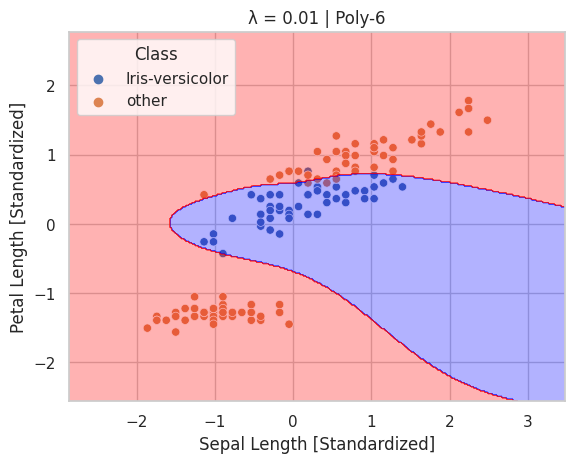

In [337]:
#use the model
features = ['Sepal Length [Standardized]','Petal Length [Standardized]']
clean_df = df.copy()
clean_df['Class'] = clean_df['Class'].apply(lambda x: "other" if x != "Iris-versicolor" else "Iris-versicolor")
clean_df = clean_df[clean_df['Class'].isin(['Iris-versicolor','Iris-virginica','other'])]
clean_df = clean_df.sort_values(by='Class',ascending=True)
X , y = prepare_data(clean_df, features)


model = KernelSVM(
    Kernels.polynomial(6),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

plt.title("λ = 0.01 | Poly-6")
model.draw_decision_boundary(X)

predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

Success Rate: 94.00%


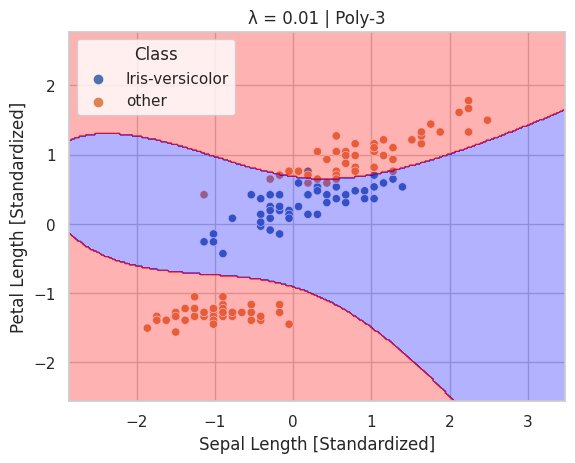

In [338]:
model = KernelSVM(
    Kernels.polynomial(3),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

plt.title("λ = 0.01 | Poly-3")
model.draw_decision_boundary(X)

predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

Polynomials of degree 5,6 seem to perform the best with ~97% success rate. Below is a pre-calculated animation of the effect of the regularization parameter on the Poly-5 kernel.

<video autoplay controls src='data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAJSD5tZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD00IHRocmVhZHM9MTUgbG9va2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAABJA2WIhAA7//72/PwKbRZe3T//T/lcTdlCBNcwAAADAAKi0AABq/ziYySX2+wAR4MkdTwpfvIXo6mKdyWktVZ8XpQXP8jkyP2k8DuVzkbe0bC3BS4QXT3ePMeMRMv4S9+JoLckiWPkPNH611QjmBzozh5/Mu1Zph6RblrODSd1sJqEv5iIHiixA7VtM621QoEhbIfa7cR+zh93Je8tyfZL1Y0j0u+d2vuQF2I8Vqihw1JZ83THrUVn9tRdxzpcov41rtHs7VWKOimxS+5VgyQuOpg/EcA2Bg5djS8nSDcv+kFWEl23EMIRrkLUDsw/EmlRuH3LdadMF8HQWIkLnB7YRN8uhx2/bWwotq1MdFyWAcICjgg/Q//gz1uNaSDfX3pnZ26sWGRYxtzoSU9WGG49sQXpQO40AHcVQoQiqLvf1tO4xamX5bb/IrIsSwvTWqeS9EWW/gIA59SJFWLL71xsT7xhYZj9RfWI8j9Tuz7X1sHy7F1tUgFf6o007BbeTbEmIgRt2YO5xNUjK5S8ltZnzCH3h66eqMqBRACWWUF0lKzLVQNg6m8V37ZT3Kgq7C3MuKuyrKj8/Hf24fMkOIGceKBl0L7pm2cZUW0Bs02gH3/KXtH0DbwO1Sx6eeEdEPbqj10qTmOfI9Sl6nf9RMHiwze+RbZlUvfSKKOUOvUejMswnVShu5Ypf2KbVitbg6wRbLmfv8mGL1H2TnAaxq2CDcWTFzf/KhW5bziYCFo/tyFvrcxaNSb94VjhWjIr//csGvcfsu5OCGLFFMqkEbaRl/JWLLcmwv/9PLiQkH56VXzUv/hVv5snbwogfs6IovaQDSTp7vweL/GoyqkkGRKv8zs29nFyLBJReVOYHXjPChN1d2RxJIaDKN3TPf0JxCTVq4G2oXuC0TpWKavULYHvmbmcndXv9Lt+RRh/gLeMvr5iit1yTyMw4cn+XEmpsrB7zewU7xGMhfKVKHDKZPzkbeXkkuVYTiu3Cj0gE0/cEAfyEyHrGH72gva1Vf1mCh9Bh2aA+qyfx8uiC1xtm+1YfIaEWM64M9V8G5SevVys2QRahLEXW1uenUhIa6jRnm3G/8bJjos0eR5ru/vWFU6GyYGMp42ojhA1Z+0IyFtJsKdojFr1OyRJKSE7xBfc2Iv1QSVqZvOU6MQSxotITLxxjLCp5mzrR5+qW1KVsNLCJ6omjG+eX5AyLPTHb/Qzg/cpEkxklhC4y7oMZXtDaPglJCnKAEUi6qWIh2lCaL1uD8o7GuXYOrSnAyTgjsl+A44qFcIYC4IL+UKnWlw9rx0+VSSI+QTkpKXSq81mkWP/edpJSiDbTUzj2YZDrPakBxjGvrf3BzadyaJq49FmdBE06+qWGzjcyieOPQ99XD9fxqX7o5PcjNq6fNyzQdYYVlGgHa1xmFDHsYy1lLexJz//y3m46JDUqmCzu5xYHi//b0mv0GGXlR98gjyI6DC/r7myEAP8jebrIPMJxQReAsP7Nqcalk3hfbHI8phnYPhV45qo4tAakhmn/SYIPBczRPLRsYp0ul7eY3uJiKwyKzip5Huhwp3exvFTOen49JXAXZ0zsnBtlVRTjyfYQ7/SG0+Gq8LviISQmvo+xp1SvCrLOFS8vCsqVLZ7FR+cycodKdjT6e/vlODK2c3EN7/2kwPCXf4dwrMhtEapA33o9iILIfwDLtko9aiOqdNcaBCZLVcsID698E++uwjiy+Wq/K4eYhEmHPERjndCXsgetOqxXcXkv5nTWMNr/ukrOCJTJ0SUY9Rz8ItSaYtYmZ3zQj5cH5DaQsUt20ZDpIYw5SodF6/ZZcgJVkln4FbjceJe9GaGFt17Lh0ASyU/KDLFvCN0pagDelgL1sosM/kRPt4ntTHSR2QIrdFtMLdHhv34/TG9SYXtURtH42So9ypi2+Wx1BPCnlluF/pliDcNGiG0SEtnxjjo9kizyxh2A1fUR75gBAYavDdExO4Fgc3L6I92wo4RbVkz0RJrLzNpHo/HcKJ7ZMarU56mONV8zVdvk37m4TdmreooZwUYxmt1RjcvSUJCQ5X2A7Ayn6/Ox+QHUWoJO0y27Vu1fb5Hq9WqCWFA8Xb38BzGp5LZs6XtJVTA1C0Ts2KioMBJoNCXGN3jTOqObi36pcS6Rlr7UOOixJOSUynNAnO1EouUH/M+C9FaB2q4nrgJLqQPp/bt7+YSfqWh70bB3SFnaZRWSRNuj0JmJ0h0UiiTywON7SpuzILH3rNa6BhcmWtKHH5ANThGdg8T0gt1yyXXuDc8Xi1o1U+nA3t+1Zs27FAhI3x8UFyircT0GiHBsTjWYF7YiLRDXpMaoW0t/kuv2iqFCg+43p9Wm38nZDMENish06pTmFJ/2sn5LD//saGplp3VCjJnEfzizLHfo2OtkEEOCV0I2pTRdlTzv1RvNFwDF0rGpECYcw+nFmVGX/0KgPr2GzHIWgPZIblXFJcgGZzt/yBmKO+FPqzxiJxRTIsKmaMB+cp8nhsSkm8O4lv/feYi0FIK3+a98Jn/8API1I+APtYTpVVg9XtlC1beCfgq3cdzgBiRC+HR5f7fbWnEVCjcXH+7sbRoMI7K9t+W5aVYcUI7l1wnK04YrpUXpeC4a4Ve8AttpbHd/RT73YimUAT9IyQwmShOll+vrfwX5PIcxmfYrd9b7z/0MygLcjnjQmktYlgRE5VGu8BMbgCvsvNJUGleDC1DZpjMVDMsRXlLb1d6spP9kWUhJfSMdaR2fken0a+10nj8Y+fTbaT2QB3Ymkl9jF2ra9alHEqCtBAlT996+pagqJioAmjODc9eA6g+vxqhTKifoIskix5aWd2ENXu5X+fgmv6SNM5B4np96z93l//7BkE4xsMg+VOOjbmPNDnD4msBJacTJjzEAZYITZLhie+I7FvtwJraD/vc1vnhugHKvP2qXX0ZlRwkb+hlOTsSdE+RsiLJ/sPmw4LMyK0WLKW8L/8d8O9pErd7bP4eQIS4KlPB79Wh0cUkFWSuTQ9mzJp/U5Jw6BJiSpbeoL/idS0sT4KRHjBVq32dO3IABQsalNy6OpOo/WUzxf/9q/0CkDh39PM/O4caUQPP/J651Tg7zHDwoB3+KYkI/ikULyrf/lSqXULsApIdBYEtEl7ne8gjyplYTE+i5k0GtWyG9aqNuzYC0juV/4beQgle9W58L6pC2qoinRwVZzpqgwtm3f72Cnvr6V5UrKb4NWXdIaPAd3IEfv6bZse8b8YY4sS+ePN+UpP+zgcGHhily7LXJdK6ShneQyWZUGnf9/mAKzKUiyvqrqte46fr9YzJctRl/zy3owSRD0QHzVhgzdX/cvc9lHwkQJopn8MNJNjBGCFBxDlc13Xf3tSEJsWK+Qn7xY1ulQeeNiSOSpvO0idm9mXJPO49cEixPOQ0xNTwLQKonjvrHNiF3jBPk3EQudNCRS/n5uS2uN6scaBoSqzuOREanc/67eeQxwnHFUsOldtUdzZG5zMBQQfmQ9Wc+lE6flw7V51nAu22wfsisyPT+3ZMlsrppwmSRRL9olDh8V3MPhBjNwhYQBq5WvWmt43LrU+cbsHDH+eETh3/gNR6n0t+e8xQqE5vvu/YbuwJt/mFgERvIQ0BLzcKKcbx5zKdEtSAy27PcBqOV/kJfVrVew/Zpk/t5UitWYsMlV3soGw5lErp9mJ/INAeEnWIrL4gl6vc2t4/9QJ8rVKoOQhTH1+6zcQKlPWp2l14G3LFzGfDRJawCPlOFngNHLwONyXqL6dKTbig2G9G+OyyC1x/T/IoFyFz9bBrCUJiD8LU35O/h3sQqJGYtuhVaG18ACviSQVcUEwtEy5IUXFvpp+2+m9C1+ipePz65CFfDxi4FHVCpJwS5gV73wmkI/gbUT7hnAZU+u5OpsbNRMryXQ7ohHvB+rHhym+rm7hIMlaESAizTzKAqXXvNaeLCv8vB9p9C87qp7/FDL5pzq000hS3dA8cjDK7meRNVBSZrwHIIf96s+isjhzzTVw8IwwUeV3BKtEdlH1zQ/Q5SDnjVDoyTfIEp1FFcCb3/IOJIWRtGk1mERvlqrBIt+iXI0s2IWTFg2xqg/kilaCO11FTLtKaYumf59+YcRB8segIsM7bfZoZvCPJ050IOJC0DoTOxrYD55rrtJgwQrgQ2/oDtg+hau1TS9vlRkEV3yyZYuoUVM2fesNetm0Y2Pu2+SLbbCDewOypSixHOkqOQXdmsLjRtceyprQHVfXW9FHxwEuuEGFGZmVFSHBswk2AGLGWrSsFvRilXSOVnOJGbz2dEUHFjWpdtQZwcw4uCJcCdlKa+Q6BXtFuWAuABHUKLEQYD7Cvp13OfcVKs8NrTf2sWia4NBRn9w1wPgzZSbblTYPjUFxmHYhZMAGeNy1cJhKK58Uc3FrXkokXOMUsge0FVU4aXw/2coJmWg8ENasIbMi1s5qedVWAF1jsL4ocQS+FsbmpfHcf70FJaXourVAE+ID0sz6ZzrfXzSv/1ysVpaUcZABU7a37AlqoUZZvLzQkofecFnog66DJ/jz6vUkVzksaF8ImJTUvUSYowhB0AttujPcYB2RVzzxef/9K+UbgsDSt9ce1j6c/prpcsObPHFO0eDP90MEuUvqI0JR0+rIHxkdVilZUgLy+xl1OMdj7p4j9Bvk421RMBVw7U+YyOqBCLntnNuqheypZShZpYdXJ4sXOBb24Rjhyji7lrlD/fzSHnAyjy/LWR86UngRB4PZwuLLztVcb1aym+LdyxrHPrA+sobhtfBxx8b5+GAlMzu8Skbx/TmZ6yqgWMZ6hKU5oktiRn2Lzhy6i+G01ijiMaWcT5Fzd417zJ+JBdACvnfTmmgTUurKHzTbXAYKitXjvCOIpEypSGWy5cCSKcCGkD5V+hCDEicdqoOAK7/APXc3/FHJObLI3augitDWmp23P4DtCv4bLqIk9dWvfhDrN0CGAkjsTMxxEqRcNhedrXzSpevHN7MBBwQEK/fyNU8jA5MHs70e9jcm+hN29LBtIV/4GvTSqnbAL5I6u/AyayWluUrAS9f7nJHguQPu7o9e6Sa1+B85FqtaTN+bqlj64Unx0pCRv3uguf/OdYn6FyzYDWCKZzR+1EynFynVKtTirBuGAQr1C65DK8VyBNOZFWs1PE7MbkMzBnlNe17zxGvGAxjpbqQNDVgtnQZcCgwyOYibWsILyvYeEupvOoi59LOfWY7jehUuKLqNh7K1ucx+ULJoN3txBXzGP2aFr2ff28Cpm4HMmPuvDOFCGXfbQj69BkoYHWAbibl/A11iPrYk9YseW88xQ12FLWsxj4TI6+UtmHT6wu/CKxk+5ED69W9zWoyPWkVSKm+SacYLe2AF/gO9HMjcCV0eu4oYMyFCN4p5/RUfzdNYFK8AmnQ9ijDGNExove9whgZatpXAqZ/zuJBAmQQUbCGpKOZMT89gF+QZArot3hPgk4k1VyJ3vGRkrlZjgE853Ar3bThnamlhwt3apRnpw/i+PnZ6NJU4tsfXJJK/Oc4Altgn2r+L6CVuXLtqlqAeczrjHGgb7mhj3rBwaZNFeDllxlu9hyQTz8xfPixJjE+e1AHdUGnAmsJllQWgfPRxk0XAwa919CFBUCgcAzBB9ruB/8WzA9SNVuscY3DU24WXM/Fvx9l+RSFEcwrtaHU5/slOYQRPoOdMD7j6LwHuW7wIGhVlDe5OBQdBU/T9lMiYqjGRybrZhDUZ6AGRIJ0NWRkzGKV0n5C6FqACtz7nagal01K7i0lGFJwLdNnyLiSLVaKodLUSfTGdnQr0JjR/zSnAgyEtZ3qbZKBlRR8d5DFfgL4mvWOCiIQzpC1cP9vmpLmjC8EnW4ff0pLY7jD1NostXEoUshntNTfLW+46hljldD2QS6c7SCdbH0X2oZ3SjyctRwEfsMmRy7DBZCAiZlXC6AG8hH/MGEOEgoBCPH1Uax61hSpRXXIt3PT1KL+L9Qdn1/IBmBO2CMgmkN88KI4rt5IrbwKZJ2kPh90TWuLEwD1E1NlJ4efvPWdL3rukmxcXt/jzWE1sXuLdQUywIFs9dZW5YPvBrdYMes0zydjO61Yk+c+fx+pg85xeTsDvGojYhIRl52GYFyP/www0NPey16HaCpz47JRblVIbs8WzST3u8Pn23q85WaDMRofQVVf2V6G/nmCACnyfsERx/vsBG93ENF9YZT10ybzg8Vi7LwH935vVpKS/5bIiQDjmnxvpk4LdbzSQf9YRMRGnoNq3tSjOjXYlN4MGTzK/UIL23/nkR6ISpDdcrOcSg/mQ7dRmIrJdM5sLBBaY9zNfEmT52P+vS9Jt+Tpz4RnX8AmlCwpS82TC0Hk5X3P7t/lCxhmOFiTYP+UHJ3khdmv0iMzLBJUqaz4rQcY9swCmyD+ai59TwPaVG0KtuZ6iav5s+zzn7HlRDSIt11PD4sDyRiMSMcqwfwb11XEITv3BwLscDQNix4b1RuupaVMlJpaTq/XPVOM/Sro255h3dbOhw9mJc0hbjoPlmtwqctCmiVIaUreKHih8ivi8tIcml9TQCP97bX1H/ChN+dPc1P3grqMl8i+YHaA/8SM0oiCOM1QNRYP3OzUaesgWi1jhGdPd/K+n2yWwq4kI3RVIEXH0VH5/5IQ3RqCk/Nt3NQTt7z6lZZ0z6XX/adKKMYd5mT6Uzt6tXO8kDU9xxtrJ8ibk1WfRXpazacYVHQ6cjJo7cKumpGr0ggw1oQAdWzuvxwmbE/FjL3ZdqmzGXx6ozB6FNC9+qpUgOWNn9hh0If8FZXwQxMqhZyfINzOH13yStimfyGBNvz8daWNBgB3V7NVlK+Ka12hwuazh3n9FtSS/B6rYOA6cw7nVcKYqePwyhVNm6tht1Y7kHNwa4unFk/tzT4/xm0cSJxz0P1vjiXjDvt31p1sD2zY2Uiwes2BurG+E5GcK3VeDqsMKO8RqzfWFZDpPogG2kQxdidjlwxK55VrxrI0MN+6uioRdOr1vfixTxcpt4M5bV+OrgOmvHNULGN7Fp0JjUENlRH4VdPSem1Ppw08wKXePm/eoPSearQ4V7yRgu6Sv+VQ0eLcKXekuTn2IWfBQAAgy3NieiG3Q7RSrmGv6CqkxhJmFFgCsm5rkCDxjZKVUA/gQsL6c5D+SBxJHN54IE9/9a2yuhxAIZ1PVEoEYOcOZ9VMPZdg40PHG3Oe1vHrEZvKycN/NqQhpJYm+0j/+S0TAq/WG89JwccY7bUeB7/a9W7aTa7UChCCXKfPm3FosO5jPXf4a7M7Ox3pGvAWVmwvm/uSgTtBbWJtvsRzreROQfzfuhqBMMjMEd9YlH8Et0VMLfbDOFWQqD2lXgLlA8v9CjOUtYLsOcYBjEgom777ib39yQpjASlKd0mLJfRz1FPKT6xx08J0yItjmLwYyTr3exURDqo44h6iB/HZ9eHnQGw8Xv2v2IGVkWadrEyZ1tgn9HU7zci1StdTyxJacjyAbBpGR4Tti5YmPVaQ5LhRLHk0YKGMteoUImpeq661jelrXTIAZTZBhWc4VW4bjWjT8tgreDPgkxrGY9BnfbfwEw9YbF/DW/BnYnaFqmL3MO+11Y34EAk6WsUwUuNAqdbbwnYqyeyMKx6rh1jGQONZunpYbVxQxB14M5S8bPMBF3jcfhGJIVDA2UzY8JKYpLqivflwha6Bwk90//jHXpa50r8rA1SRbWqUm25+5JC3C93cbOvkY8u7RnrHPykCRgjARXFsc5qnPs0o9Hbl0rq4z/zHc27U8Xeiv2ef7z3FvRRBNI/XNiyZlTvZpnhKZsfXgvKSYoQ05QUu9VHzwRck8AHW0+K0mUn2/BaymrLjVGo5rDc4/YQfDyFIBN/X09Wwf/zBNrKgjiy4nmpkhgqaUM2pwl7aOMScACCfXtj7plw6Hxv8GEIsCiWDv7BpaidGa+9xtXI//75AClEKwMqtqWodGVwovhB6NyDhaVXCI+6hf33ifkHv+UIAsJrGNEEYBYAPUvmrl74JxYCi32LWOwahF6WBVdSPW9uvaVobAr/4e/BZnwkqvnVfAXmnHLRkMgv6sJh7OsyIAnCZlg7+M1BWWqduMHTvvLbeVeacmXQgITnVEUpyy4TW9vgVRCYvaqaCa+acMM5nHcWXspT/+47dMbv+LdCAzVqvGfkhkj596YGc10Oo2InuNCAIfvZZxZkR2mIyD4l5VqV8qoyYafUG780Bne0gcWvDH3P+ibg4I4G6A4EhDGYarlxy8DSSg/VGSUw+cRrtMtbur9BoQyiFiI7hTSJEZx10XZ0NqH0mHIvdqtDx1I2JtrkLiUqlIJw+hShH2A2cqlPd+0z0pMHi0Q8CTKh9gGgEJl4VIJ4oCH4heYyYxI/bKWPsOkndCR/fL1MplWPoAhuacu2tyW+15Gm/b7TzGa1l60JKFHpGsui9aezuGtGOWb2RgliVfp4/fgP3TZYlb6Wq+MMUnS4qpCex1seU/mQuEwFGuPkE1eaww1Y9gohq6V59eoPoNJ6sXmICtmoKZkiryBOr67m7rtqLITEiGI38l1zCjl7U66XmnH18zO4/Y37W1b8qMdAWVeNSzCfJh/91i/f888tKtNc/klYWtIxLt9HDDUMAe34rKqxtFqkrsk7cDgI8nQPhssJvYE1Mv+2TZoKnEJYpzUaI7F3BpXfTeZQ0StIwH+/ZN+i9hydwpSrJhE3O99WiYvVgQlcixZdQkL/d7QgudnJBC1fwPP8fCi3QfTCwlU/FqkbwaQx9YNRPwdftdcrAWtISMKX58nof/nUUblYX6LIr2FUyfn0JwRT0cTygptUZTpt22totC6KTC04qdc3PTVj03SUIxE+OYd1Du6m+pKgYy63PEJaTCelOxY1tWVYc7J8dqZoMsYFBepgYf3Krr7tvAHq/29z4jktLeAqKGaYBLnG0ZFzbk0b0YM4u35xIvoiXnX+0TL81pZDegpB9NiLX0mfBudJVDjtkfBOCZPPeUN728JXBxKMPYvnTwlmcAIeRXh/kcOVhVOSRQtTb1xBJ6gfQ+/8KCcdm2uBplDwAIFAqBhzDnZX/y2IWiF4Kyo+FE0fLPvL0u9s3HsCk0K0xtJmVBmYiMD9VnSjOylvL730Z4QYSbN7qK5UFcFcnpkOP6wFnAdoKh9N/U+sh29xx/bc5Hg4mZBnLlJaAEK5slYG3t9DQw7dDtwDLUU/j7x+85Z1sUh42ZhOoU33kEdcBLsecVG79S6aiwNbbZqguHlrtgriXZiX+p1owzD43JArbbaPeXcq3vwMZyL7dOrVMM1GrYo8iTzwTE9NgSvED1ttbgjy3wj1Wl3kuOjUDPOIGMyYKgXV7JSmpRnlbZb9xnDs9HFkGyPCsOdAKiXI/qLQGKbb5Fg6wOahy89GapPmMd34FfoNj9kWtX/5ZI8tbloYudtomLLD/H/4QCUU/oMWWwxaocQVyZV/freHM66POALw+M1szrpA5jwdsCagnTriADR1e0VEaGBBy/xX/ixDYNHbcPwzfX/bB9MFtI4VsHkLfIEdnJovxPyu1KmUY1eyEjnvvp2E84/5eqtz70wO28vx8uhBsJ85M/FbDR+EW4G8oepZQgi56YB8pe9AYCsf5MKHH6e2S+Rc7yLLG9RcQI72Ph6b4nVYoDt8tJqZyXzQY/zbX1/QePQRiNESIGBVCNftB1MQw8hPxUeE8/0E8umKVw63TwAzck5DCZxGibNfvd3OVz33KkF6ezyi72W+jTvGVbiRw1KBkaGhLJ0LjUiZUjeYQkvvDo62y+LROiQkZhJ399+ojlwVWKW4AZ5w2pV/gDcGt3eXPRrHnT6yjjNNBxXNoIj6f+i8bFQ5AyDu8ixSpOPUgrT2XLKxkTU7lnafQcG4rPat4OqpL9nX94KWRm/qdVlGodJIDimGS6X4XKNmgo0M2YLpG0dQqEqkOVxn67Ok1p/C4ZlhPuFiSO2YZVacBW8Pklu/zIOqQde9efjKsOK5cJmr9NUWdnkL8LLNNHG3+h9fQseE4Lqlln5pLBtlLnctQ4C1n50ju8MZKZQZNtV6TwuASft2L6sKYLRuZ/tu/zkXJtAUqg0269R3v15mZi1S5zAuFk8qDflI5hWCNpaSa6U/YfWcBDBfNxA4l61bRmZLIBF0p/Nj5b3VlCfCEHJZpLnsbPvr/Y07xHcbBx974VW0IEdXK9Mdk+s+cSHBoXNfj+WgV3xcvgrEyyH0xx7bkvL/Vsh0xbeVrURia5Fl+7lyu/YuRsrYyL/CpGILe4tkiXaiml7NJ0n6KjmWC/R3hfdk4CFv4V2dAWEE8dXfGxwp7+DqWlzcB8u8dIxXpjVy7uFLd1REGMUOz1kNOlI9bWeqdAyHLcI0yAqlogwRN2W+pf897xPzYQ/l23byj68aIKLcbB2eUBOaI9osS7TQ5ni+1OKz3GxF/UWpIZBsFtRg/YFJw2YXFx2hgc/V+LhElcGaTS3Ikt35KwXy2uchSHvFAbAb8PZZQuUgzwHiU6XxSrKyf0C4KA5CUAOCwjMjNF5k/wvjeNlpQGW99vayYeQ3GLB31H93J8u3QNJOgl8rLNQrSrzlC+mnA2NPypllhT8vdjzcg/zTE1mxBQV2EhdY0C7Ce7Zy0bnp0F9IP9eiuGp5mZfrmbNQSu1rdZzp+Jl+9LWbV3Jau16GfsM+KJ6ew3Fq5BCIfy3b4nCuvsWkZAywXixMqVx9ENPiBX9EVZYPoHO9fT21A1QvbzvyAOgtauVZjZpUzGuDhefc0gt7zHMJvrVfennTgjL98AcJg/sZpMqtjWJmCXVoIYje2yAwrMfgN4T9+p0hmBSFaeU3yj8iEoHnh78n8W4X0Y6yKyo66sDsi1tw+peyZz6oZI0pIa4mU+hSRTqWlaDc+rcUIDSpGr7ne+cOUpW/5bbTWK4fpyXb2nG/QHFoXqptEIhIeQI9ckXDKTx4Ecu38tb7xWQaf1dkDwPNu2wT9msXD4zqrOvkqsNIGOLUVjD7WjftNnR32oXHaWlqt+drWO4JApyhraH3p5uGy6FgirUmdkmTOufErmB67/dxxAZLDmJuCTXZ2xXnFOhp9xlx+yeER3CinFiEynjs5fmbfPmCdcYosiRTSGz52y90eJ8eSrUPIN77AhUYbEI+qOhTn4Asf+hUdzfkEVcddNL4cpb02nB+iMYZ7qZ0cE2XFvQ+wQMQx9iI+ttdOpzTUMhFCnzJmy8E4OG/kk2kRjDABqH70Q3YcCA7+am/2d6B4Sd9n9ksbBiU3R0b3fwTcrCddJLxRGM4vaVOe8jLTLolGiMfHgVleoKfJ3ldYO7HykX0ZfH4kRB280iPNfci+HjG7wtLXf/zM4cuf4vQTpJ07LHT4hivxXWqhYmCRCJtycowFUpQgHM1dfRPmoHAehhtXgR0X1bTPuX8bYlU7Q7l3Px84g3VjMa1kAvCOelz2Uvrcv4xlwfaxrQvBaQwil91HE0FqrsYyHBLOafwk3DusLyu0Kg/2NhLI2IAfNqkfiSSDLGRcpWOpZQyW7I83rkhhIn54xU4iLyhC0vLyWeUJSPb46EKvjt+ojwwlMoHZooLkD0HZeDd/afQjPNTIsQQpNZNaGv5EG9xE8jdOfxGY57gwiDnVej9i7S1dcrlAAP0tj3anjH7Zlq1e6YSMrpKlvk3I8yzHooJHudLQP+Awv+chpziWU2QRa4vn3UWKFNS1Cb+fiTMQYEqpDUODkcO06M2lsTQtM44lbbYbCHWOW9Xu8Un3/BkDhNFa3xOPLWpE3jlal5nLPoddikcctsj0EP00BzYEQ2A/LSBw1RY6v/tHxPcTKx3SXUcMXapXDXl2ZdGKEHcbBrmsgkabo3318YkBB831KdCyHjvEkoJ08NkWqjuW56n5G6Vqnb8LtRGOrB4Fcr2y4ipesP7oRyxTJEZEcgA3mLBB2s3XoxK0+zPs1Xx6sZk5heo9WPVD+pcwU9GSmx2tprsRa95MnzHP9Aa73lmW8z4KJpSlzVK4PiVUboMVnOiU1BhgHSXyjLgFuCHh8nHWz700yt3qZLw73cwU0EpqJXQOd7S3kkSQ9sVYYl+g0m8bJMJD61up1dGSiQg9pQAVPGjlPLOLkG9aL4LvbAELvnso+MzH1ldoUrhMhYLLpVWr8VFxHVpbWVPuiQbxaFEX4oXwgO4pcUx/ebZJTOf1DG7+oZWZktttfFWNKV5AbGwrBPj/tIJDVzoou80VmdGh0WgBMkgJL62ItY02sUO4SM13eYloDidR2mb/XWSSuRKnBjBN+k8iYOlTmMTsf4Oe1zRAiJFATWx5JgVRTgraYrXQT7XQ2JzBduk/xF+bsknlfmjQCa4s/4jispayknajrWBp1LEtn/+xKIii+yQDdJxn4jiKF9mlDTKRalZzM4T1mVdW2F+GdFYoGLOp3LAtsP4MmUOu5RJ/ILBxD2PX0NP3n9LS5E5ZY0sKy4FL3g1B1sBr0au3k091KnHZpavXFR/FSWJKMjznKMBmhB+w+L0kxDn03vlPGa9HX7PvFRjTfm8p2TrkPsVOmrLUt1cCdgRB7DbSGfov+wG0jtTEvE33JfRH/qgB0G4UtBR8/rAMvnQkCFJb9s1puaUxAqYK48oHq+aT365SogO7HtM8H8G//kr0fSyutxM60Y3ZIoczHRGqKQ35ARFYcsNAsN6u5GUu49PkhYMkwULFRWvbG9rtkDwxVTVj2PdMRFSJaX7BqqQxgHnpJ7dg8rrJgFGulREI/A5CJnPZHLUaRifpkdHPUH6oaMKdGV67kyALbs186DGpWQ7ABpKszVJTlEfsG/8eUuPPf8iYV0uT8YIT+lMdeFRCQp7ksbysN8HQdqtOppcHdbXpWaif8Xn7XprZnHBmKY9UzUJvj5LnCFdKVpEbyQqsTL8J5sTkg3CMW/1p5fPahpqA2cJi83ADVVhTU1UasDT0yEqG9n2Q67BtcSLPptpJ6U5i6qK0dT7IhUbou15HMFPuja7jF2c8ZWm4XTxhMC79teY463EZDCozQzF04ZFhhED3VH/ClkwlIhutVWojSYZBKeDYlcfS3pr0fKHC2G8rjALFaxAzdsR6LlPvecLNDoWmMIYvs7ZFaRKVeUZ+Vf2KEOis9mIVPnQleBPBhrjdnxngQmlifqmzxCq8xSGg3DmYAoWlb3EWKQdHBLmIljeukmT51co2DvOwASUehAQRp5dKfDE1lQNcRsS3ETO80eJANkftToTvcvx+E7zmtu7AP7+qBRTCJfFT/nsACz/e8rBD7oGEXEL5GLEDF5xKVV8iyEFWW1SL9Bs90iTEhnn2sFsucuGY4dc0xhX6AMRNvnEfrW17RpUBF07gL1SCvRh9NwOpVBTy+AHWgf2au/KArFP8tcnqiCKVToa9JoRkwIcKthJeNsJHxLoJ97K2zPUIoEmYtI6Ih934EwPj85+qM/vdt6SZxaoa5Q2KwnELZsHXXC312jrqq4vMDMWswnG+no7URPryAmSckhl2Ep3Re3W5iQlf0F6il2voCYsl58PuYZ97StogXyuOoNi+hW1Sj6ZsKO9Yx/qCI4mZdRIPcMRNXc6aoK0NaEM4ZOWXR602xAW0nK7aLPMdOw5g+DJtPoNkSTCTdgma7OK2r4sgtzqVQh3AqX4vGaXeIFFkk0hcMp0XX1eJm9OZIPVA5OTcV9iU2dYwhC3lKTR/Y93wuPYYmn0nxwWuh/SZ6jzfENYkx72syOTStDy1Yk6kg2k0j2VlOZUe8G1g0i+nC13ddt3hLH0Duzds0BqmKxeWBflWkx2EokN+WO3gZK62jde7K1wLjhjyyvcxyOeBXyn7tis/lbRDLYRKosur5s8Ez9QgRyK1U2J0rIWjgJmdtxn+BLRDiDO1TbkJ0xI9HOiy5rWtKJQbR9kuJenOAZwPjo28fGFBYgE3iwW5Ej8hnLNOqdmCbrlghfuS7Kn8czqvoBayIouZz66XAk27ADuGsnQkoJBJSiYpKuPkeVatoRqimXkPT31Ghx/wgljYm8LDf3ht+aQ2+aiC0lc24WajKjB48F+q+guYJC1aAqXMcz45ZgiNq10II3s8JjF5NH28wzQ1ePfVTRUisULAfH6zClO4ccXv+bawWbM0hwUVveHMBj7Su0aIPaFJ5dbnF92m/f6DvWsBd7+WM1k7BMSUHg1PIyl28xZ4H2+fCQbc8f+hdwHiCJ/ol5xH/umfNGiwa9AzykIVUSeHqxjYUvJy9N2Ua/lOWpHht3cYpB6vJm8dRBSAXiRogk/uhQl0VMHFqX29NdtcCXHYNzBMPGOIx7b5jh7kd9UFeccFWeDbmnt0vTaPG8Oi2Bd5aFPT3fpYBoynK7vf2zt2dttoGj9ZrpOGrQ5dsPaxRx0kAHFZVJjHTUe54DD8dSBociuwVNtH1Sl6kEneQ2wwr+eZ0lsBDwLM+n6T77Ae4rNZFArFk6pa+EO5EOAsnJ/1/bMfBq+Cr0UvYj8thOHyN7F0cYp2yZNOYUGJ2hhQcdo34jcCzuyPdXiGb0t5sP3Mc14fTKDdbuYTtA4htT39bZ9pbWdr8vZxZtBQ88s1kTD85L3owi79oa1Dgk+dh4QLGobd4jLtBAL4y9rEAXbeVPrAKJpjpbfLxJEa+4Ol14iLS7JT+rmQ338wbmquFCbInszCAnrAvmptjsll5v8HHzw1anN1GuErSiKLG7El/ccvO/oOgRaVEOHB6ALeQ31nwvwR+03eR6tPTr5CxbBBpebsDuoS8mh+GYZ/pkU9ckkiiySqF4wPXkbhHAvVnf7YAwMWz5RYaILakxTN91uinXW6hvXNkLoXrmKbELCdU0+bhHA4VJlaIxgM6twZvNaep+x0tgIZ2RRSE0OuUI531/Q9DbgXk0TchCkzczracI38XNUYb1q/hSUjrpfg/BFSCHicR/gI3h5osd9HkNZH0Hh+j1W4VX9gZnh9uYSKJiiaEzNAgvVPLAYthcnQ+55WfIgqncujXeOuzVDgnqE2sB5vBSYIaqKDnAxWlgVwYmevx4DwgkW4g2QqVfZCb/EUTi93coOVMJvu34ykn6H0F093kgNzbs4osGv7Zia8B5Ngci0vg0Z1QNa+kigTpEpnEY4ixf1NMUu+mfgONyHfRey+fRlx9cTak1GD9OsD4w+jAwG2nANrGtYmHPipwXyQvAh5y6c9+tgGnOCCygW73mFFKZw2saj0zztUU/vasbTU4pXr45IG+ODtvxl9CAoUMEBvLxfEMQm9WWpkeECGVD8Wkbk9EBlb1hz6VlsIVw44nC+sV0vsgcAj0+0OLyi2QhzVyWQz5+F9l9YMUI/pdsE78eeBGZAxqWb63PcUJC4z/6/dBSvZxckfASC39y0Dq0oiSegj/K5n5dp+O4JozV/sn6/bsTlaNdeHvf2QFSTpi0uV4suJhfbLna34wcDrsGqXYzmYnUcuGbQQxAW9OMjloV3uk2Hetqw9RVK9XkFIT7on4fCzGR53ebwJqfZGmAxvA1qKyDFIXOFp8wILkU5hSWJIVVT4iQKf8IH9ft9AO+Q7aPMdi1oRd/BkPlPWLaF6MxNOM+LC7JG5S/u02ub9oSABSAztYTr8shIfJu33qqGHg/rkPJhHDZ9MnFD64CYymFt/rdIjM9Gp/5hFksqPHS6veel9Dd/xaSLNRB9Z3wpi3VF2vin3thpYUYvu4DyttEoGRCnmBeBZ1rcL84QttSS1vBVcojwSI/sdvPkByLUQcKxBY4t7T5X8BLxQWIJFi7GCLhCYuLrGJEVxF7T6DGMyIxBjL7VPDy/TDGA6tD/DrcO0ZqknrcVIv68PAycgEfwfQR4nuwM56tepwGNHEd26KAoLHSaEn6wrV8Vz/z0XHWtKnTKeUtnwtM57d81rw8hKtUSxvR+DIBhQJO9RzXSSxH3r5hu48RuFuivd/7nc9Rtm2ztklcDxkNfqN2xE5Cd4pr98D3X8/CNe20dhgFYRa2FnsPQiPBLyqx4TT1B5tCDlC5grRQaqe/xY+9EHDrj7+E9S0Ru06NjUpQZy5hL+jvnYXxOOqt28B7vfKfM9jLl953fyjPD0qKKnOYuLDCwpdTlAIX6JeGaNv4u85dzqG0+pouOFjgVwN38+wGwBeL4f+ZUO0cBTA8SlU4Tb+EObnUaq9bJn7GzIHuCDaoKsENb6D/sGgPzp20ccwp+3MINulVkCJtdPNL6uUVlhtM/HCI5k0EU1/7VP6/B/vwY+u8mnv346102SKGnV6s+EhhxT5kNQAFo3YAixXrIpZsmgJZIhaSQzGmOsB4lVZPy0EU9ttDw8jx93ZcBwxzBS5ocEA9ZsZ4DVIRXSAvJ7TIc0dLVrPTwGi8dKBY0Vvq2Aw9omQuyVMvBlB2f8Nwd5WktCVRsDa1/qnd9shjLdZIv0oIw8EoAF6HFw7Q6zQB4xpnAFKaWV7lnYX+XdTKizO0AkDJdysuo4p92v9uVVMSr8Flc4g9c7ddzh4fwaTTBigebvZVhc8A7n62BCZ/JX0bas2mlcgNjiHTUySG+ajZH+J+b5wzcrJOjSCK7Ekzu5LifMESn+vqI3UigcdC9vnuUEGULpDEHLa0+3e2EeSRIgRQNzjt4VZo7EEeWQV3SGCpG6uI03Nxgl2qHZn1PtCSjSe20Lan5q19wWaDN+fdA2dCcWDZJx8bs4yR2y/rrd91r8VYx0x+UdiaumaYK4spDcYO/J66dH0rPt4dCNXF+VKn1nO8gf4xX69RBtnKXAZ5D1FJI6j4VyNEWv9Zs2yJQwo4bAVUMNGZ5107ItIq0FhCmlcCdpTfQFDIr5gQo2DyjMt48beHJNMPeqYACJVufiok/h+QETtKlIS4o33AS/K+r/EsWbfbwceM/MNyxoTK5s6XEKxjHn1atuPvDo7vDrO4LuNbKFFaoLsanj8+e0dMFgBbnAdUrx+PG0Bch/s0Sx3fidbmxIFaql3q40IAHO5TGX3MBCfiVZWnX9MM7GWlyM2fzHioih2A1EmFnbyqX6TZR/3iBbnX3cMPAiRNzY/HmiPYNK3VlCBydzY/kltTyljz/mHatqFWXBNkgoyN9tzqmX3aCAkLYOLMqGLdrHvyskQTG9Ha1YpWFNc/fJM4iA3cPb2VL9CQssnP7XeG9xDiGH/Aja9mn/HKc3hsjFmFJiSoVeqbE+9K45I1lPPqLTeX4OiZY6LMCVhC2cZ/ADkwVhEuGg7gVCOTT85ORyoV6pOSLBlBTy/JQtUNtCGTYbOJFPzdCsgk4IWupV/EngcOby/MNht/2/Ox+bl0c112xPt1Ztqm1GwgO1eMHOJSrYQoRjeJOE+ux/XfXLoZAyLusIjU0rnV5W51AqPECAgmWNLtVNeYeXEZJ5IW7roDPwFNaXt56ONiKaU2TvvxPISEyzerBzlJmOGVZjh8brRZ2JLtFHsxJcwGOf6qdDnc9wDqxgSU8h1VXoUVodJy2UboJ9ox509cDa0uaFkS5QCGNvvOnOqpdi1GDoI9jRC+gC2iVUb73oWRsg9LzzvdkU5Xev4sDkWbTK7vUGdi0Niz2WO8jgqpXtAq0YPpIXgXJszK7+C5YvbV0IspAMHkgIkV1F8OLNWWHgqTqwfIkMsxQvonMWrlzo9vOJRHwepAHE4gHii1pg4y4nCzJrdFw/UGfiV4DPuk8AGKpX6/CNnEsGHv1YkIHEr22Ei20N/RQcalVmSe5FWdMgND/2z8TLVtKMF/m3rv/WL5OhxLrJZrsqxwhHZZwpjRMVPjuq8aIVTQJymntUzyUnlVQVjlHqY0DKQQSXFfWuAPiGU+sD7tOVa1BItOJws43aF2XowE7hYiXTW7Rf/vdY5/h8c/YAkdGNt02DdDOLotPv2v8mBAULBPgCfI6v/N+ZaTMWEfMzr4v60/Sx/cqlCybSlZYC+txvQy9smjfF9FfxQ84JiLLGR5DJoTwCga1Vi0hGNEHh/jw7owAwecIJU88eAOFgWhrTsppYEJhVUDKAn4uSmiOgMGC2bzZs5j40GNP2p9JmdYaOJHKWn6vaRsGlaaLmpPTxirRQjIepfIZYpjv6zpf8WyGYfPE+oTj0jUFayyobXCzkZio77i9Iji5ByDQCY+sBDwboQy4iXo9H+nZD2xaJtj3aZEvzv3l1c4KwE/wgnqGTbVZ4Da6FjiEfZDbvDS+tS726qZCOhhwhj1hVZ/YepkPbqzz3zG39AJkUL+hoh0AzSiJhXaIBnGRHPYbaicj/TS/N8mKr1or839Q0r3pKOE1ERUM7NEC8uR/zRlGq81in8odHWT4RqoZc1xCQppuCClqJD+9BiEwca/qtV91gJL0OOKNVzgjYRZXBraoyCqd1/AQbCtNIvvOGHEHYB7iA7R/3jDIYQS5oeQaCCH7BUOm0ymAbfPKYJTOuOvjOEJrZVk5Mtopw777P0OW2ROHPzp2X9CtJCXvrEy2t5eO9+khEpvP/DjzzOWEvSVfjk0L4DvVjYxXbcGqpO694VSbkXH5sAWxaktFNmMYA/BP8KCBghLY9v7hF57/skUyrFaliTJDAYtDntZVn5Odfw4KfFfeb5+KcSqjaeS1faGlNo7mN6xQY4wVi3mcam1EAh0UKwt+L5p+GR2BD6H3mCmX1QOosfgWI/7hKSEHcPoKfp/8Db17Hgj8bccGOn3ArDlPuGjBjDRbRYcs1a+YvgF3qx236JtoQR57NSNrAlPPH4rI2tlSNomWHNAwdso9RDQcfHXEBXZ+xwhi3XduxsmfYgveLxI6GuumIll1ekGayeGYF1sxUyDm4ADqAZ4UFPzvp+T7acMvsXD/X2mH+PUYl2cgD5ASAndmDzJTJEcr4Hgi4mH/lhwHx4qpjifn6OVsK1SMGgBcTSCISCukcTcmqKvt+B1hJMWY5krz6Y5jprANzgmIwk9sCHZIBkuxF8ZIZeTBUC74Eqg2umXWiNuyh6LrupGUygFXov1O1vGZRJL20mftpRuXgIcCDfqk6B046BPOFXUCX0JYqx+I1mkfvoCjpGGPEtngcq9DZH16zZme70u1DfM7Cr/HNcZS2uwnXjQdpjix7wad2o32hzGuc1+Cgx/Gh+jBh/JwdEcdlgXbNjmNyVJrcVwKqQDiggYb0TYUhpbJeV021Mj+hOtBhd+uEE40X8PLQOUWQH6YVKMtUykTLG+A9r2NMnLG4txea8eyLiKJRIGB/hBEmfZoTmQIeZkoUtptbYrmWzTHhgiiWRxdDkhqHt3m9FE/ENFbIzXeOs6OUeAiFeWdfbOK3PgN8O3wakAYpvRCSiDpNvH5vZmOsHX3L6zO3CRTWM7+PuY6G/os3ElwcSnjT+kKTrfT8ftNq7MbuMFvP2x6qzIKFvFwRB6d4KSoWYnQI5fHGoAUD9skTiQTo5aNlNOnfVzjdl2mk29oF2rEMI895p5rZPdDC4aEd+whOyYWEITjOCOb10SXqNb9FWTXDq1ozpepOpCWmIJo05VhixzHxHLpDZ/7YofgS7EpEur/5cM7rSTz/oiOiw/OtxNwGlOTgUi7mYaq0E8Hhnk1IQmSh3tQGj03K2uReCF6nvwXQ0CR4S94G+YVSNkAMBkql01aA0ZhY8TGoaW6jG7PTFboI+GwR82FRTjHPpnPWXZxZSeo5M1C807uUH/IAYaPO7a186PmbPQGO+cJDZjy1rKDiNwpDrkPHupF1ZHZVem9yDSEjgqakgeMGLXvU4TZOYBcoq/963V+XcIncVm5lz+Jtua1tOini8icMX0HMBul4CPqBRrImxKruRb5b19XUoIPynJhB8J6wqU3AMq0935pszHjhXDyezTFz9E450e4CGZ4koAqUf/0/kp15SZ+aSiMi+S4nk7lSafboYyZKteiw/MBkoeGPG5muMpcvudrbGWUIrBCOekKQoyAASkgYzYkZGiLyjZEctfK24LlU455aaW7k/KnfsN5lqw/jYRMirg5LKPlWtSa/g5CgnmDPDpuMDEXaVRwsja6cRPXZKf5Ydbwwj6nlkCZt8UHVeOioDIFw9Pgw2PDsp+1L+XnfaxGtZwPJb4KHeRGt+knHscDqzTDlV1hpCiNrHjgkDkiGwCRBJM6Uy0i8EUvpRFtlJIrX6uuVSaKdGsmgpoVXpIqSP9/DcAW8fAsKlIROlrscBc5Qpm4cf4hoKyiX64EHYYlUasTTOe4+qWxGVQMzCoeFdxkD8sJ8PZq1bG25INifuhDDKV62B7u8FKJWEdm0bM9Pya9NP8TK4QJR8z9X4xUN9lik1Ey3DLsL/Q2QpBwfhkLHc0hr+o08240UltkIzLuLGB5ymk3qD+3TEqlUTd+R1pgsAzaPGoEPuRewQdZxTz3235Em0PnN/maaHUY+C7tqt1mrP2QBQLC6ZjIqrGiox7txYbq9vKv3rVLkc72eXLdpim3ei1vdC4QnNIDAJxfC0HlAyK1fdxmYdZ8YeyfMOe9kKb23kSv9m/iwa19b9LivefycsLCgyzg+dXXBtzgKifcUduFaZkRl9DIccuPQrgDNx/p0mK+WUMkR9esI81DYZCE6SK7PQIy3/VtLejl/9c2pEpa793mJGQSI4o+m4Fkxv/JNcVAtqZ56KEoDc6wkFzcVhIwwPpG7oY/VdCoRP/8wI4gDHP+Owe6DvwB0kKdUTol/KAjsf9UIve1aix50l+bg9jA1IYY9/tKUJGxIjfhZsj3Fo+ii1pEeAPUJ3AVB3Wi+ako8fhno+VMlpQmGGR2nOO83y0u2/OKM3M34nKMzO1lhys7g/H8ha7+J2PYRQMuIdMBwWEyNga+Zu1ZqQbiBZcRFCJUXTqIIK03Y7HJQ0OF2k5hsAsVwUIg6UVmIh4FLG9O2o2dhF+SZMzUYQc9lBnyRZjULyn4jJr6JS7Nl8Xjf2mUUXwKdPA94Mby4HO8vQpCH7B1404d0JEaRXTiWJNrQBcB9+qHBnS8MZUIDILzAi4rUOCXYTSI4SK4kHpB79J5tD+6qCCAK1omtMcC15zLyFY0nOuBNxnrxhf32xeD6kdqtZHo8spjSV1LDPzToxAGlvWXtNJSH/huKqQGvRLZecni0Vc/v3xIKFO5ZFqfq+O8my+qERhUi2/a7gdUeAatEh2xHgiqLqrJWWGrrczwtXCz6QR9kHE7cbPAscD2DqukInWHb/ssUDoe8FvPFg3iILvy1xx1KVumYNiyaKR6gJt9mOVDxsPBCz5Rj4bbSvQsYhU7G/XJkwT4lWQ1nlNZZGl/J6VmbQ8+rJh5H38YSmRYTqbcHb9HAjN5xClwYEHeZP/ak7xrFP1xHR2cQArlt0dwPUO5oGTgYUxcJ+DcVZxoJbKy5Br57h0myuTNEr5eJWfhdLvkTfI5Kn9u1SPmam2Y3xumI0uetjtAU21BSLVrN2cW/UbGl/ezbuSGQcvKES9PE/SbrfndYy9B8b6s6f+qsU8NYv/oo71kjWrpsEvutZG/jfGWYS/VG+V/1mJU9aSpsRNaNWHb3xjb4rR8Rh5fzJ5yzCaQS0+Gx9HZoLvChAZnVEjulWEYV4Em8x00AgJP71KWPBu5RFn89KRtEknHlL24/9A8VQN2FH6ZkAQqrWIizkl1962JDuCnGpyILR92A+WOiQ8iL0aRkwnjkrIaW6Y90WCEwVgZyKVhl9Jvd5uVsLH/J+BmxdxOEBI9eC/WCw7BwztzCexzPdMnwLK8/EkKbv9IzwCc61+GXfX4C+hVv9oMzyoMrlenPf+lhd11GrNXuhIz06JjxugE4DjsG3/oEI1gnU5zEJ7tEzYA7xqnNVUtIrgmPnRdSVs9jDPHCd09EFDn70u3sbS+21Ua9KAJXAr/aYQvVn2XS+1Ir02Wy25WpTwisUokVpz4pQkl9+u4H9RXzCUT8WBpcTkgQKzbQDeOeCGJ+zGaN/nn2DgvEfOqB92ZFZalWBIRWCNvPPFq3rXx19QPvD8v55Ha4MHCgznDI1LZ4g89O1VRWyIzCMeRC6Uhr1oITyhNr7tcVZCsix5mjUYD9CWvDuoeaOQAE7+pYNyWQdFZn2kESLDFLyg0m7vuxYwA/IPXJeV6ScYt5KTIWh4t+KTm/IidP8C5E2h1pCjg2CxIW7sqZDMjnNJL8vPvuLHQfyVMhPh6DSZ4yFzFUDU9Dh/O3QwAABJhDC4h/pVfbKWUzOLpaJ6MSQoKVT/MUCLR3gEt3F1XJRYxiyOE6osoawj+i2Nr28SqWoJ9NLxWg2yi7csfGODLX0CNFLcTaLuwSDgXCIiMATjMfNxllGOkuxgthhzRuhwPYRW4zbpkEqHNNQmmThXksXHNP/9tQ4Y6lLkUf2Ay/MtUzy33tU+WRrsGYl5AvQ/lRc1AqItZSqhUzZXp5aJmXWpmaKIXhifbqq2PiIX40dZYdu3fJWUAphWrxMyVwLoWUudHVCw1/li3xVHEW+gxqqXPhON0yQCnW8sw/ypPtUnDP/qIdaiM7OeD1wJYulGsm5UBEKtiHNM5CbmP/UnZGpFJwfVJVlofpn9mSeSorIC5cpqmMnqiqg3+1KCKrPzW9j3HTPVTNaAAJ7m9CAvJZ1IadJdNTWPwS1LrehuPA2jel3lNsy/AobgDpNdXpBhZY5PJxu9QV9OcADpk4uSIgglqt/3JP/vlBzEIEyn5/lm6Bk6e/YX/ERDhx1tw+YlWZB7qFbNUlquD4ppI0Q5q/Qq88IN2gb/RkiNN6/XkdsZdZXDvPWOazdWcn9fr0eJzoob6Ful1Y+qlNo6FY4b4tueuDTFP//wvPqIz46+HL8icIQv39m8Os8pr6FWUPWq0qmI01aOZbp6zX3cY70xQZ0O9ptHl7SyboG3LgYjfdJrzUDWyTqOXfdmQmqc6xkaTA0F6+b7p/6Vr4lm4c3fLAjXSmi90Ik87hmxfyMVgdpqGYWAAXbYjbzP5OSCZudW9S3xXGfbuqgvTJ7mF+5UgsyUCDu0DpW/iXwtw5CIXxf8lMX9vUqOKSjxZd4JKlorRC3fF+gudZBj4ItRgGGWIHEIOSSg6JWGXyI04CxvjZQp0E1CrLfVAqFRsaw+noImjnsr4SzfErsF3MthIQCVqLxMHjpFMZgTbYzPh760RwIfqbv8+5H4aXcw5YEd0Jtnn9+wBdRk69Z26NbirDR1eWbz+hZU4NUZNSgIJJCzzYB13mtPEt+B06ojyzJxVbDLxoNA8Jb2PptURNOsCJd9DUsOS+uDvVUe/ojbzi/newwBLlD68lWjKcGFpyjGq00IfBw+k08/sVYv9mP52NmfYPeMtUG98HseLK399WHp5G39Q4tx9LKkDaN6ZCVENP5w2LT8VCiLBb5lfv6olULYBI1hFDmRqy/9ESAAaFynheGXcQfcGqAQCkqmNwDNsKF0O74Fmk5+VCpnbXo2KgkCG8a0Y99pBed4IbMnOheMrFYeSMgmJhLH97pL+li7g0jeqQCC7LIE6iC3fzHdtAktDV2ydIGsy+NCKokedee1t5lUn3wLQydLIbdXI2DqUSNNH3c9YLr5LldNc9advOLdM31k0972ty75prLO3GKhxvIpCfWi23DJnZEy4mg8DPDlNxM2RK+aIrh08xjlN4Jfifqo7+4HbbE35AIbEcx8EDGeiKBLqcvibsULwhYIdT3sdGsSKjq4ZbXHL+SwJF0ZUrenTdki8r+mw0VUbKjyIcN2xImRuudfx54DHpmaMmEMpHVFBN93QPaweHKX6r1hOPCDaV5pFTHhHUYNM3nM6SOBO2aDB/I5rGXYfojy4k3mMwtnbMsxybcGZm4LtDtCGSDx+2w1y+PPJUwaNUOGnohyboAikWBWd/NyMRfY1CBCiJSFPUzbOtxM7KtICJKIVIpMfpiglKubmW+681iOE/wfUoIUMOzBRHqT1o1LEltBwLhEVSX1ZFtJMkk3fSGWu2Z8b4ujrMvBUzRPr+pyT6XFBc0PDxFoBaluMll1nxtRuaA/zW5C7ma8rns/lntDt89YV2AVdeBrY1RQC+h8Gu9l4s+kQT4SsQ7+5KpB5tWvXtDUNsUrxpO3ln8ah6T+MVThSGdTeyvBe+/CNop3Efrp2wu8W8NlrqIeFGQobICB30x25LcmGDDCtALYd1BRO+5Gqq4rs39BF2InzB0AtC7yHFsVJb7pAOTbOnkqXZl2vMlItRCubD2CR5DclrTZLKlo+iXK+Y7mBIs7JRLPG8q2PFWuzgxDq+Cjlm+AnjBeWgT/I8TMTnPyG3/xT9NudU/TT+hW7EgONwqKE6whgAEBrB9WEGnx4nSYqed9KprkH4trxk/KD9oBP21VIHdHFhGsVKycgTMqqOt1IAnAoBv2Bvuyc6/BVI3HjiW74ZrPmXd65lG90hcfNhA5GaDL2vGm5QIX0k1IBmhluKZuC/a0nCvLGeOqp0NI3CiPs8m+LF3s4abZzEIJ9QWHiJnilNdwEUDPfXjuE/vPe66jBznMjhMULiHmCzQMuzZCAi9UfiknYcUXdDF7Jar5EeQH8t8ji+f3X0uPTqsCi9S/72edBInNLSTy7yPuq5ynaOkt9iGiXOqPFjhX8JWpyJM71DIJKafRGijbZBpUtemwdrwnZW5eGbE56dhmd7oxQfzHRpd/rG7OQKS7rxWv0F5zCN0iagHaQ5OCPuaDH1dPIOUcEmELb121318tOYYjCCX53I2TRuk/f6wQ0edx5rBLs5lVts6y3QmTnEuqQ6ZF5dgjji+79qAaeamKhdOr/YqAwcOcrtlKzb+odKr2APBUfUHIHoukfr2Li+EWSj7GkFm7++pGNVaRLYQEQoVwNyC4AL0ekbGx9Legi7xo/oZi6BCXQ1knUaiGbbI/yYaXiwEn9K9SwGIwXAdFc0bjZOEzND3UDRXZlDexpae6sWEb+/+0aUm2P96HiBCZ8bHOw3YRGNhMrUTjVSHXXDk8XABfQtY+WFWciDU8YSGvtw0gMd/IBRQ/aZOG15IRAlNnqpBlGeohSCHuLXsFvYNHPL0sya2aX6DZEA9ww+WOIPf65W+ShPlpydMKr3rlmWdZXE0CpXaJdwg3K4EhvhX7YdbN9ImANuEAAAihQZokbEO//qmWARfVshQawAAy9lG5YAw/9ik38b4jMjBcNe3sitJN0VUiTIk59SDOWgOXpfxpnJW8SYEnhKCLk03/rQktOylpC3XWIYTjQ8gMzpKUNkYG+VRtaTPM/3A2vSi5mT4CQ+64SCTmivmHiCB6e+oNGpV88BL2DS8Z0tE8ejAH1nG3cWeKXVcQXxek6VHQ7tyPVToUF9xzKxcOIE0t9THZjkpOVoSoFeB57SOFMh2OtkxyKF5/TiFzL01v4C2ZwcYl+XLM/uf0bdKwXHfnLWMATRw++RmTy1DRWJwy5WCGUs03hnk8SY2wsEI2dKufckN1zzfL2PtgX7yRR+oLJ1PIsrfSoELU2Uws+g88TmQM16dpuEE58a/7h0QbiG08P+B/evarpwBRdJPRTgWKXukzJqx6qptPOlTQni9+BSxGHL3rqyq1FJP+CHyTC03p0/raWxgj/d0qguEYyR0mUzDfHVFvfDcawkwuS32NMoinJo1xLF5pjKgc40phtPW7mfIcbKdyCgkD9g41aMQJ0TeizWrOT2c366jiBn5xZoYOceiNaVRvxfFopCvjV3+iFUphGt8nXZbI3MGi/OKBSg6fMQfOObzlOanlD3RUitvF/FfL51Ux4RF6+yd5v9VS1t29hZLK85YvXmuZza7bESBvEFj+TzWErACfTFQsCrI36QqqOoaWJ87cZZ1kUbVV7fqO0H/eznkOQjO4jiRwUpNqiofn01L7140OMXXMMkbT318lqkbbrNRjpHKsgR+92XqzLbZ8BaDOlah5oE3g7YzMTunlyzksUbwLnCnA6k0554uzqPDY5gQG4bRiezbWkLfoE6C4ImO8XM+TbN8pmaZwvHYyVepLgBdgGxcma5Zp0R8oljLeihYr7mMdGyL5L8xhAJ/VmjwBIDrLkO/S4HPUBQTqIaODbyCot4SoM33pH47DjABLYrwPOiIJmM8F9hID27UrctQFpBq8uFyL+qTYkmBraA/MlHZRNlZeS8Os5loXpJ6zKO9IvELdIEc1p8s8AYNXhpXFI19cHR4sYqibsnIEV1j41655lvLpyd3SMrMxCCWzg60x1qU8+md4jLdAebxu/+IpHBwIEaDLCg43GIy6NRiGVXywUXEJmbmy6oGklNDfR63Ks7VCjNgsjjR9E43pakrHZn5MEAo9Fv9fG7dqBC1HQsZxdK+JSRQjJIygH1kYKX4HLyYrQEyrN0tLrhYm+simSG+V2rtzJLRUDYaKPYb8wH1Z41Be1pzlKiX05qB7UL6jwpIkZX1rn6rnKJbyZwvKAxC6a27oGoNSRQMZDnEDio+nieMAqjYuHSh9JJDC62B076bdPhTy06qoQ9HLgic1MDQEXn8ee8iyLPd7H62hqyikvEjoYWZUPymJoJ6SuFfaKlqRCsRDVNYSJyBSv/JKJkRMEI12ILtiHCUxWxYCh6i+gqhqNB1FEACmSD1M7oU4S34IA+xCANMrmbrOtShAQAD6JtBwKJ4kpo5psq2CC1XEoFfgHnt+e9oPcF6ERdDpoaf9Q2iWoYRTjESV+O4MiPbSqTYLFYCeNP7ysD/BrvKCd9tvof8osrvfaRjn+5VYgyNfTV+YVr/dQMqL1IAeingieSiAn9Vx9MpdUiCYpL0tEa9gnz/O/6gxG/5iqfZimFuRQ7qBS5+KsBQSUJ5ry/BqDaz3r94KhUw1bb2nSSeadytP/TiCWX3XEcqFklModYCtIukpiQ5PC9Jm39lSNop8+WeLECQjPtWxWxRQZ6ERB9nzmQY2kBEUmCnmC6uq3ImKmX8d2j3nUI+v/ultYcbXlF2bPKUb4eXtzG+JAWRYy79wtl6xnPU+TGtDt7miz5u9EZQJDj4mc52dAa++vMFs8FiyA1SCGB3QtPqIj5tA8Bc4qWrxuDurP37czkEdW8t/VK3/h80mlpa114lizNy/r/tKcLl7llMqSITd9X2B1I0tXKY/sa+w462sk5U8LlorHsSunM9ErkZxQ700K9SkFx2fhNaO3Z3+FhVwae/1JGi2Nt+sFkVe2CJ19hICl5ysMp0xcnkUh20CzYZzn28w+xY0Z9PeikhvbGsE3LAO8Fm38k8KO8qxeOc7pQGGcOkFEeT1MCXG//QgKa27z8cLVYg0DhKq9vk84WWswTjnGCtbzTPoqY0RTc8jkMEfh7BZfNOFijOBdIsGVzbmv6IWVrNBmQkCtDRSxn80YYw4zpKFxPPol5MQnPCBTXlIhXijiK39108/tTP3hv4fXJLkya4hfe4IJsK2iP4Ly/HGZlJR2lQzKko2L8dMOPxCfTe5gKvpaNlXPvotzIdzBmwM9ZhEF1aBSzMCWd06jsf/Z/dq+JWOiRsDZFUSMOktARzv+fDuJHL+hUR+ghAyI3JXVax3C7gtMAX2sAgMXo058cCSjkiQWLAyfgecCc8TOWw/Rq2tL4Gp4kpGWx52RXcW/NTou5SQo2xLcvw8HR24NO2TjNAEPKRc42XbSr997ZpYiutn+540DUgDB0X+bOzDD1l6hZIiz9fouX4GybbV7BPE1ZmOGrJ4My3WEFmM0Fh9CBX+zqVnqb3LkEZmHCETm+6jR8K8JcwJvtZtIUeoHcHNBCyXxaaC/TdeF/7Bemt3J1JvNQaL2vMvVncvtnk+AUyBCwEjeRa8UBpPZ1JLse3DCI20XnyIfNJQHvAY+t5PaRFxI167jh2raXffSKQ1GZ6NKJB7IPFL4+2fCP5pyYrUld7lea/hpTVgzUYAf0SmGX4lw539sDZIBgcdpi2CwdfqZs9/pEX70BODQPzvgRfY4hOmMSCxuNc+pY6omxd2ZfZAbyNZAoisvCscAKS7+nYYEOhpjNd0QBPis95um7gakXhG86fjNkBNCmVHs/HIr8alK07x3VKSN7zh9oV6iSzAlTsMOKvXE/0J1UOfxzLtBdP7f4/XRkD5gdoZ2mBglgAAA6hBnkJ4hf8BDp+/sYxkOL6YmAPuUAITM2PtM7HFRQOCfZKpZcvhDxs+czZIzJGqi5CxRjeqn8X8QmtmrnhBdzQ18wf+LzbUqYovQ4Vhbe1o9vkat/lXTpBmc7ahq8jUjSyHsWFR/EeWbQPgxE5HLkq1+Hg5vehFMVKpgkRfZ5oenAXKGQGr1brl2qRpomXBPyGlgIyJ4IB+pB8OXkqAPPsJDYFRu+mnKKW6/gbBzy0wCGbTjCcagbz2iEyW++OPIvswwk1WV1no9BTw3psP6KJAEI2oBai6u4obCcO3RvBcHWAIxYSxgQiQQ+RcNFszT9RbROmOBCLuodkdBw4KKaB72jdUfyHh5TdoAQnStyvg+ow2/7gT/52qiWUecaaBYeEJW9zH0p7Sppp2MZZrcb3ULCBLy1a/Qnot7O1PsxGrWEVisrT9bVsR7LBZPH4k7It4OUr3OBpkTijUN0R4ABlgXMKDH3xFhbQ57zmgUo1IMIalmERWanHXXa5mGw7mU15vXlj/sGkWKTb8bkX30PXRVlhCZJzuWjwfAVSGdojiQeNAqEiixBka6IMMa2Tnssih5TgVE6N2ShS2fKOwoIXi7NTyaqwo9bZTHQz9cePbRpR0OBfR3X/MwJTwdlqjuvtcql/vuZ0zV5Y61WWhgV0DPDrBbz4JCxIE+3tqj0wvu0OR6A1Ct3rj92ZGEfNu80mn1oS/JNkuB+yuZACZZQE3C3HGL4gWgXHuCuUQlfErvG1uVT/LHinu2WFePRav6cjFD+aVmYyMBffsERDpKL+IS+3FcEZxn2nDwbKRp+oeND+AYD9SkMQDtK1VXFal1+b/WUrWam9Xrs8J/akIM7jA/Z3YYZls6XTE1x09fV3Lg1pxCOrh8zjgTcGQRy1pzFLmr7kX/fp1PH+aAVfun+YVB9MxV04R6bGh4umWvl8ez+UOjMGIqd2BaJuHwXRz+rHaxUQ72huvV6cU22L2Z+DKfYb01O3FF4F7k5MakcCwV9Jar09hxDtmLjBzjvj0yQt2u5ggi+nmmriVfR4xYf2Z4dz/eMRdVjIDvbwayls/iTwUk7Tnj03Fv8S0K77PwmZDDrwdUsjb/FH7KwJ98YYiQ4tblg4BrCgXz1+WHfAil7k0xzEf/QPuqwEPbsy7DoUUcCrcjYqP7zdyFMwvEnN2BGitcY9XASdoOOG4Vlnxp5gq3+aNRRj2yHP8840un+h3F5gqH4udmq5LwjJf7aI5klUa5ALtK0EAAAIaAZ5hdEK/AXVOw2PqBAq1AWv5ZIAIfd8WsVmDZg7Z63p35D3er/1438R8MWaqcAL5/A0o98bEjoa2HlXksj7zhJ4Sxpn47CP4bk0IDJYo+3hvR4QpCaepP76y3j0v7/iYOp70SIpmVcKRKC2wFo5HgLOcL95sZL42Ve9nXROHryfZnHXb2iKYJCJGzGTNam/0SZdhps1uZcqaQeaYcqcvtSYpkMyZDHaDxnQtcal8JPgwmtKUlHGAZqws8ILSPiIuYbGDnxDrEr+eqQH6RdtBKvOctVf4mS1C6CNXBa3h+IU9VpJqi8NCNgnuVM0obEh4GWQEID0Hv4S+gcCpt+PDMlI6Seh4ojFyY+pvZBULbrgICtUw1Nov7AK95eKjWtsVGYPLlVB1axfmAcMPoAkOTA3rxfAnrX6+ojbh59iXQy9DVqaoyl/h4aac4GodBCRXoPPvuNlhuBX+weqfHc+d5CefdR7maOasKK3cIkqZpH1tlUnQtXTqJnBCtlKvdvIYOU8UEzCDtlMgvFmsv1Tm8gKrf05WNq/eh/wRU4xD0mamW1YWNztSWd2TprBInlEZNv720BCFFnysUgu4HYY78P+g8CxI1r3X9S53W5gZztHtaLvpbAX/p0DV7KZZrICUHz6WC5tn+Q3o4DnqvZPi1sOt9lL3MAigkhvbuLDHaaQ/UDGDXcYYu+YIUZkntmmxgu1oiPUY403orAAAArABnmNqQr8BC6HnGY1T0Ubq3CuPgS6AAg4tgW9dFzRGKvOvCHw1e9wjFhvdX6uOY2/JCj0/yTBNsZA1zr///dnz1lmuRqYAIhvY8Oso/oRzTYvAikksskXh+QM06XKmweYJ8vBZGfrQdYNssS+Tn6ABgeYVWPhhzNWQ7EuXIWGukSEXojO2AtDbBpTVob7hoHbKxjPUZK+sik/XGr/ol2uAFf9lI0n89qn+ZsigAaYiiD7+/uH7K5cMWhRGmKnAwsZFGyXfAHz2+KJHlyCu/Hi1jm2dJjARA+xeWntsmVT/7rq2UxQwclYb/57ohkDYdDKA9/z7ESq1U8MMxtvbs71c3YSxBcIbtFzDmrbLy24cpjI+RtgzYNh69C+l024MtdkXqGjHiWAo7Pw6I4E9c+C60zIB6cf+FL0fKteM7+dkBd5Y0nWe6okj631ClBwqrsz9D7PFLQgodK4OpvjQry3oEsi8s4NumadHB5AWaq7BEVdCb1PnpF+k0InYkzzKQZxrceOt9xDsabXgOY6P7xF6ha3ppa6SBH3elKcqmJ8iubOfQJWyUSYbWjYRL5rpsorMODFcawheQ+9SC+gQdSKOzf72i5eLpIdIX4N7+PYfwTzNDHJ7pdAXK5307V79RQWne3Rr+i/vY+aWg1fUBvWsA/QpJF04ldvcvcChiUyajIMkFyFkdWbUGIXqMs8AgT+kqy1v6dL+n9R+IuMUYhhn8Ke/21UzbOexCRu4njGBXU93+n/bLEcsck7kjJN3LtrH1YTIffdBkf9jPL/QDNaeEkX6ZKT2mXD60NqqJXF4MjnmBrz7ypxbOf3G1P3QPMqQs05aEI1XWQOvuHvDTWJ/aeEKSWwDtCfSGfM+I02vSOgKUIT3Ob1/Yn3CTOVaS62OSmlDLagk3zHn+RVqPtxxAAAI9kGaaEmoQWiZTAh3//6plgBCAJk1bagALrOB3DaDFelN9ChHlQ5kX1rX5bS279Tvs1zPvfplywt0n1Wf02UkWfJrR4+7JiwVfrhA22SrqFyCthk/LNicRs2aXdL8W6wMN1q/Zw/fVPuNsZGesoZ6Wo3ZWyZJwKogj5rt7XmesLMHTS1112vO5Q0pFsOuVyeJB/gbd3zZFyQNVrgvktvMRSOwL9W+F/+PFvsvcwEJe4EHJ7TvEWfQhRzZBCQMJCECBhK++bamzZ3ecvvG8KSKkE0BP1p47fMrxNELI3Zm1mhEXOPVhNg1cxvMktjG6GaRh+J1oxzsExrGa/QSTlhauaAUOz522HF2YoEOTs6DKwws7fABPCoXaKeX1xD2WbTK01NDt9M1YfzWdK21ff4XYtfLKSQ8eNQfqNGEqJDpl80pjAl4s/8M4+hUetofRShvIIAHjU4Gj0KLj/e+eFNOisqjG/QEfkoQGmeWXNvtEaC5acCi1Pk3B6WK+FujiAdgxnlqCk/4i4iKchshl4b+DKXT+qmp5rlWoRtFsGIx3mmet+3XRNOcuq1XWIafrpMRuJvfJh7dBJ8s7jn8eaWoM9fYLD7EPQhmihnp1K+u8hiSGoUdCxTbt1F3R9qN5q9+PbNQVmm2g/4CAbQ7eOSLW12odEv8G7rmj3QrhL70VoqYoskYaY+I251RYWjyBfedyz44XXQwQl0SyMde0YymYZVjrk+id0k7jK6CZkewRGlyncULKsgezk3c2Fsnh2u7dMILEXRgjIbvesgNR53/Gyjet6sMoXRLbgfOC2Qaan3zrzU/SgX0jIqwZerVPcrtx53WzXld0I+2TLTu6gjh6HAgKxsdRtcgUkq3/eDBz48+LH+Nq19knSMLyid3+f2KSCq0ObVf7NSFvXuVd9RbhPV72M6WXWQYbQ4IX6c5NhHnDw6iTi00RqEDJt7DezcamkrhHQkn9+ZOZR6siHS+ka+hodOVZzGUz9+p3CSNIwHXuWEVuUh3RefQDIPVpUS7yFOeGu+IyRy8rskYHuZRYuK3jpT6tWSCaevRtRjw2TBZVpdWyFrnaGL60QPdwCXXiC1M0Yocn8r/0IOJW/AD6ltOcf9jgdqn6vSScSc4muQq4tQxMtbrjWzHqVSWgIgOt9ueK9mgMBzP1ikp+JDaRGRhkLa9WyElELK2rOA0rsoDAgVeGbvZm2a0TYpFSkKsMTWmWjxPvr2MssHfy/VGlcFjoDcUc6HiFh7LebdRXiXew+NPIwbfxVedfPSyFhtoBaakYI7ca1U8pyPa3WMfMqTgAR7xylyKga26liwBKaaTxpSY5ej7WoBxgDXnON/DLEVzMWnuMj69p9nhrsGnProiPIYxVkMiPsfrtBVVko4eoVbPoxrBlUVx5chyNX/CX7GYDp5AZjF5bvcbSXJdPTPZGgG4TcS0NSEPlFvY0ZfJaSmUSYWmkM9RiLAv1vx+5DdC7sHWIlD1mqS1sdfhHvYq4PicmBSYkqAouvuq3DjYOn5kioGA2OliJacP1rUaObsCjdsA7Y4RI53c1zoShIhSgBSeXvuEyj9wRBmTEH2Xh85Pd6TVuVBy287XkhlaSlvDEbKxpiiIQGFcCVw+Z9qTiRs7urAKe0nVS9UkpFITnIga8/Jo8fSBKV5LsjKKVwsEVfcKtGmEXXpdLshJtfrLiaGhx+noXiU4fQBDGe2r41auB+mZIB4SdAMVubdVgmLhFkNukMsGDbcEhOScujUItcrjEWobfE0JQwXNMnj+YYiuL6cyHf3QOWp7ps3x1eyVNi3uiXtnj/p8nUMAQORhlwGKncl1G3k9WpIVZ0bPRywYLWABQRFgt+niNAMXXEUu+TFY4WRPRVhkzScAB5EZSPa5OB6QzIJDpCjB5vgSkrCDujCB01ONb7pxS978zoOgBck7HUtBTCswfFzWGCMNoMOOZQj9KTPc+Tf1RJpsvMo85GIRQqzXRvmPyEqQ9lo5gyXgATZzJwLi3/7Q3kH97Cem6TZd7lzP0UhpA1/pPxz86RuZ8NqfDp3mCOCmJKBcvlzeRph1Qjfhig8fpLHI/xbgMdiKaAUYrqhZXjv3nHtVQsLecT51KWcpIM0+QgjoLAW7FL1B0ULqKialLL77FszKuKfPQBl2BND+vqkiOIU19mrTk71fRDYMKSx809XWnvVVNz7qWcLtE4CPNiEdBgZFIE0pSjhWJyppv58UyWG81xgL5jflQb1YHiw/ddunys5WJmNqshL0dLw05sgqmusZyfp56Y256XYds+fG7CLoYAJiVlm0zMFiesDkLaEWW790Lk8DnFWzIHt5d9re9T2F0haYAN7I4uxl2iWZUKD/8E5BGImVL7F2XvY3wOnu3kFjXXKduS8ajLo4MQk6tAWvtOKjSbY5PirOoGOfJkADJrHcpQP6Wl6AuT03CezsxmZ5dkXST/0NfdmMGbpq53UeW+vhvEiDd81lrkKHQus7pBP9dIXWk8jgZxh3RW+9R/an+PB/No/dG08Ic4fdZwxtbdwZYPYDbN2tmw2ezES/s14jurGOxvUgdOW4BmV6LT1X/ZGeOrvEo9lA5rNRuy/QCzFoNjC510SKoczIzMUpoFpaffyV36j5wroqOQyvgXKcCO79PA+Ha5krcWewaa0hnF8DRyuNqyhjVUjluando07Zs3TU2MHA/vHOOsSu7pBrJVcBxPb1W80eajRcwSHez1Y/bVX2FwWCch/8g2yn/Jq9T6ZkzRltW3ZrDtx+rADRj1cXzR13ftOblZ87omQdJC25ukdNntA2z9Q9fmYdf9awHH+cbyOKirkQ2yeyd8jKzaZs0dORVpLels44N5yY09UPPyGf9dM8lzEHVLSPeIH9/mc2mkrytRwMe4MkhAAAAwBpvFjnBHDUY4KkXuiJ543huiEGjEpDDmtZmHt5jhG9How8/+x6mWrnd4qGCVjYXeuA0cgeh/ppCifg45KRasWZJ7mogZ+NClRMSBsTqaedv/w7Qp1aN8DUedIOGtpDNWGLKmFzLzQaDcyABLXbhqkvdJJjoL+aP8t9EjM55PpBAAADVEGehkURLC//AE6KCboAIeQuPV+tU0bScys6RlWI53hfC5F5lFboSXy65lqg7Uq/P4L9+BiojpAeS3gzsclZ+txXLJEJ6o3G4/xizmK7TaJCT7YE7mPk/QubXew79gDVsl8y8v9yjPKhB8P71SU1wNm3UWFPSAkurSWuc9ov+L92bNmad7UhHQJ9pkzOPWR3nFSqr7NXIQZ724dSO8ja2KR0IJMd902C5S3bae9wDmD9UvJQoPvII16xQZD0JJjrLlsJ9pSLY4NgD+vZ/MvubqJB9xywTokogdDDxX7iudFwGax/PfRrc4y85WYrWFihBuqg05pVLC258Ywjrc1u4YBWZ6hOawPdjZv6wuaHP9KkAbPDrF8TjmJlBFxOnEYs2jGYmnqz0VwdzCqKVOC0YmgB2RKxkt6TCk9FNsRyLllI6HXpMO7MH0znJJ6bfgaGFvSXwDO5P4nsXHGlpIt5SPuLzsiFKBQr1eG8PDHCDoFW59EKBmxlBtdsdVxFRxpjESrfDtSdepP4qIcL7Amhy4JQ/8b29VrxByPsp3Oe86EMLIlTpDMYKeHjk+qTuvs+AO3qOBwgXNIafVV64AxYiWyutyapJnlXNf9Gifzc+on1E491wZ6fcEXY5w8a+bK1PLuK6fqseZfLh4HhjcWDUgxsGl98rWAmilitDnEnGeNQeG3l3WMxvdfDai9RHwwRmdA5b9gX8cSoUes89k9G1nbzYU8OQ7agL97LfpUuH7r2glByVN/RSnN1l544E8K0dy9+0dbvWE3g9knkks4Ja0YX/nziV3IjxPsGhTkqgbax3esw9WzFwXSc9bPsHt3jz2S362CXDi142roGZQvLHlqmxFwsdrOMPwMi1IqfLNL9F1Iwlgm+vZoTHOA/7fcmMx7PerRpvTH/2tspynSfIEkG6m4yoRXsBRa/nEzXGcfIX5kXNmyL1RAmoEc+CAsGEfgZPG5ndrr8n2DcKDhfM8RGdAgr1o4JIf5yzkclf1aRWNfo4g9xGox/2I1BTsz/trEqV8l9PlFsreT0W9vxZS9XVUQO5x4YwhFDajitaSe/rjm+RBR0fTJgMtDGhJl32FXcTEgr11pyGK9O2FKWlcer8/3uvtrYOBLPnvP8gIFJazk2dwAAAjIBnqV0Qr8Aa9tMUIAEPz5K43eNBV58GP3tJyu+yR1MTwgmqU0Z53mT5cozWI/P4ql07EJIZxgxNgWFirYWPL7Pv4/angNiynrXSAGZiabT8FlVx5PGJDz2OD1OilnfeAW0NQrY99B7/DcIZW3LSQykBSGcDRC6D+m8Vq5ovtj8I1/YZpuJo4zyAi9E1D1LOicMaHeZAA6WeNo4ia+vwiwp9KpDj6Y8oxv8Zsmp2LCji4t4ESSdXCzFMpCLJhFn5fDk+U9j0UFNbBLxN+2CxujDnFWZ1ErZlYToIixIMfn2kAYnm0kgxt/SVAHnvqrwHbxAN52n+WjM5rEnKeyVaj1NHvRJm+bRZs8dE488zJXa2dcJMNJ88MckCyqPZGnKSCNxcRsH2dgsD0bKVdvLqsnHqegGFq5oP2/PQCNATA9NJjUjsXz5a2kf//srsCU2edEkRXCbvJD+u1P+P6IRkYcx4i6j1vYRr5NxAOL4hhYM/b0GbEzT8f6Sp5bUdwBe4/6V8i3b0OWQlHLWizAYQVmh27AHC4Z8uKAeG0egx+ZtHCspgjb4s2rFcOB6EgFGdQ4J2WYR6bpChBzqh31WIgbjPBbmUN51zPBMaL/ZcskML4BlOyiamTaIGV+GmR2qO1nrZOFxPFYplf/G5pS38HZ42jmUizjTyMxLU8xBRd5Lq3GfH86Z9xdZ4sXQlBRG+kxVloJa1i5piAbk7arP8bdskoL4P13kTUiNyXmOMjDouiwZAAACWAGep2pCvwBqseYOYysrPwAGzxUf+PbGSX3sRNk2hPtQqRZvSdFZ/J2GmRy6juufwZBwabfm/CrT1h5Pu0N8j8DRtryqk4OXwjikW95sa/qoBUjiPiekpBZzQwcQ/TONBM3VZ7ai2fTw4OLGqqQv/M0Toaf2AYILyUsbUb4shmtJhP4oYVtRHfzeS1CoJt3IQI5eaVAw6i6vxwoWMVxhc8vB8wFdjt/dPdKHbTiCYBMyOVET2WCvgb/vIGR2cT2RTmTuYcegq3CnJAtrHa108lkAieIKD7ePJH2Ank9kqSv0RXeBx2GOyNDmIezFzT1Nl+8Dt8q1rQy4NtkyxehMhxOBXudyUbnvzTk6fWKx95E2hZEHVFI3pLvzEE0b3PKaNbxqaEhvxzs06OG9D8tmJ53TM567M65sLrdEwALGw4Bk3bRe2Vo672N1sUwNOpNjvoV3qv310ldXLUNTsBH+cNhrSCF2DNxhPii0cZKKnuGapJD7C4ophvvopx07ZnrJ5Dzhf4iSfQd2EaoEQP6hgdR1sBmbvMggTVPXuax67eH3OAOsriEpgAMoNQxNXKUd6LXvw9TgYaCbyet12RdDo1/kBZ/ck3rBhv10p1tm0OKzMMVcRSezcxOzqqS7OZHP8Ke/KNRBtCTMw9BzdaR9Fxq3OC69AiSdkxas9K9vH83ZbeRwhWYlSlZ1fH0WloIwMt/l447CN2IGlA84vVzQlyYgAtW6YMgC7nXa3Z+ZJdsouvdnAvLY7VjGKbyZYTM1brQjZS9VMsrr3ZsWFKCfH/qg/kA7UQNTagAACjJBmqxJqEFsmUwId//+qZYARA55wBf7nN8VQWkAXp271jPCp/ovANgBwWQNL2MaSpj79/GtLPIOMZA/sdWzrjBuxoHhU4oUXQkALq2DFPPdRRTeKJnFyydPwS+07L6blR2Sj9ecfq7vOKsgvJVwMo0yeEeb8dCU+cO+EALQAbHWBkoVlIu3jq5gU+k9oRAQLbfy1OkWr8x5S/TD9cmAD/6mNvhZodsa5sC8GnqlD+zmZivkLwLxliPBf1g5nCw164cjdrjycQGUmW8ZPNJSZ+97PpsFY64jczJRnp62uB8aSMRKwWWqeJSQC6GMNE5y+eWFZVVZP7UwMOOJeXbC5fi8aKa31NrhjVKmcSnQ4xPQlirbfLLr0GhARv9fLunLggv1VCyDrlOxEZ7C8BDFqt6cmx7m5R9npyKkWUWua9dfr9ZqxeQywqQLrXekTbArEdDUm8NImdUDS4t4NwnpdadJHr0B7dnRyK9hyhKPLWrWi80ghP3AM/6hQUyY0Kj58idaH+QaZojDFa+6TYMTHzlPQwpHQqemFAdYj/vxry1wob7EgXsJiGJzJzqTwLurn/7YG5D+eF/vQ/3v58kTteBj3BZtOjdMb/+GTpyuSY+ILGLh1Dw6KcSkI+Pq+KrL+7inzvb6zywWUSLbAzz3/CqQ/bWBGeei26qicTSNktdjjbmuf8Js+JToAaI5V0Nn+tnPaKrifCjPgFrJGUXKarxoa9Zz9L871crsZKAap06WEwt6cIGcf6gSC7KOxe4SkPws9vg6saYPADpMJTaJQOADPF8wJrt1PQAyWW+4UByG2ecU134a8QDxD3MhRbivQY+Ko/AlLl+zdtzdhbOiof/ymbhc9EOKShfK+OyH9qcKoxTzfiLIa+kCX2SoQ4OU9DMeTuxMHZviUHqjzF1PtNZb6Y+fuH8EaCMsqftm7Ls4taPxGqlxGcMGKsjHLPDI05f+I88wk1m0aXUIMHkk94iIsNB79tFfBGYmt7WXK2AGJOoE4hZeIu83lu2JVKzGIOkcw69BAYLGgmvWhO6WnKp05aBy3syL34vIH8Z11qMMj71h9LjoOrw7nInFpr4RxEowOoU3lGAO9nsyFJsc0ulVYwDeynWOaYg+5npANEbnUoXHN8DD7GCrfmFhOArmvimX4OBzHAMeloupBTxnAZF1zRJE1jl49LJik9TvAfJ/TmLL+TXVflc1uzExJ3LOmpmFTmE2LmgI0tj6EzhEcA4rWNTB4fkRfO1yAYja3zeeulO7G1e6ytskpUvfj66s1UQVacQWqRHR9VTk4J4FUFVXYSAVYfmoe0Odse5HAkzB/QxNCGNlGiguHA5pLoe8kEo89Lhb9+zyh0bkjbxjAkdE064YvT17QVB9Mv96JJ536y+qCmh9FnizD0L8HLSQBv1/4XHMIvX4XxeF1aHHj4Bgj+aXYgQo71dyszS22t/5DEJh350uAw+aCu3qxrPLy+kwURCSYj+jUHyvhxl05/cCJBv6/eBJBw4j9+wxwGbz6M1F+8VoWKhumcshhq8T5H6pWU4AGuCkNgo6+eZPVcOu+07x4WPSI7811AfFFaiLLONkK3qX79wcZTcqpQbugABW6Rzxh6q8GurOMxCw0MKfbLkBDCoLI8XMScV7zdGm8y/Jt0CoHKdG2gKCGor90NZNYHuyUgnJe1uke4fwuylnvDgbkLf5m9G2xU+8DtK7RISEo2LJbrEDMyqJo4c0Tv9gcd0AXDgjjKHQ3kZiMwkfDH9OkTiybDxaZkiGL7VqyhJ+7kM9EftACzsnxh9874BPFcfoKOnqsirRhCUhp/Xx1qfyadpM/QxyckotjICiGkKr4f/7Ea+HNSjkNOKD69oQ9XhtOPWQ99B2ujpE20+H5o7dutfJkxEdYOYNChB9GTcI/CgqqBKZwO0q+4HsW6plgm2ImDYaHThqPy9XkUtouirRBybE9ICWbK/igOD2CWsAZrUYMh0+1kI2aJ0MLUoajPfXomtJIkyH4lRjk5jlyF8jyMXajg31q+kaRbjuMs1PNU4RD22KaBjdao9FYaq3UyRiDU5pslmHJZlc7mUqyKGgSVKGuB4E9yVnIru8K+Nvqqtc7uUCaKa4dX8xIhG8TgA4dFzkHrc1Vsv7vuRsX3P6o2jrXewLG8ETvWfUtlMyxjp5e1H6ZjV5P7tK4brk6tBH0/tFu1uJawx2+5HJ6XGyHaPxtyVTKtflGfAyWFT8qhrLUm31G9mkxpDd5YpUOueo+3ggk1f7jlPubKIoTrQ/+tavyyryzgrMgmWnufVAO9ftKPpo8kQcSQ9wdq3CvcFwQJ9uKt9Qb1VuxsyXqaGeA8yPcS2d4UdljqB05trY5cYEhSqRgewO2QzjrlH5dMSqmBTrx62FzFKcSaJkqj66WORWmdQ0/xrmkbitFXMllOGDjKnhYsoM12mi4WfVLfY4VM3dD59HPKV4Gx5H6x/mnNmg/yZhgDNlkjhAfFl4MXYdy2DHLKYo//0cBFAr2VkZ5dAt7r5BZmWAypyv0f2vFIsBp6kylhXy02Z97Bt4Hj8+xUzpd75CI/eQ56oZ5nM+rqx1xFZSOcpyqX43XBv4sA//3LGxo2AD2bDQUiCyf/yIx3JAreYhGDry9C1GV/nlctyTMvTLtgr66q6LmG3c7UVrwcDiI/8uNGzEblfYjuMyFPb+Jg7xpKb0YLnHDadTdUm9vMvx0U3hVvpGJ9wMld6RBP0VXE3xv5gN7ZvQVSw1XIfFtjC1CJqxu7OB/vy5eIcaJUc0QplQMymJ4cDfK/zPLqqhzorOg96lJj6CraWXqXenOX8svQu9+8mCCprels9Y0Ckg8JS+rMaR/V26dG2vCiO4qbHPTboSyd6dTZdiyUeGYnmwCMwp+/FklQ/xW3DI4eSSIlOSMF8lp0yPkos92N4iwsUkom5xOmp6MHzGDZVf9qiq26SkeIRGBvN9fNshCn+beAqfP4K7Qb4ZqpNdh7GD+mwpeWIQ90jjwyhV1RNBXpMLr5oDzzZ986lvNXabA1ZRq7OytAVGfGS/97H+cjZGFehmu3ix2VyNt0sniVyT7Ow+vAPDZbfTW+rHcunCq0rUaEzEKW7ExtAHCfzngcTU3Nj4JlKva/lVyXC3fBkdABpITeDVr04HrxdioG+UJ9QO8lxNmy1+Odfu5/r4mfuWcaDk8WEEyUyuLPLxbyy/u9Leu+1R5sy4zONiaYvlNBUHA7yrCHJbO5+XLciSj1zHys9PbILRaxtQwfIKhm+6Kp2oaQ+/LmUw9UKvmoDn7vATgoBAJmkPSlomrGDVdJ/CJHsI/n7AOj2LqN8LIYuSn8R0TyBDLfx6GIR016L/eXGq21hXSMXlZX0mLVB2Z8BmkgRoCX3R+YVXEqmdBtHFZhPqicu8yyIrSh1sr8J4ijfWsk/DhHA6999nm+RcoYN1QzHzg8+1S9hCr1E1hAO2UIwEkKEN74pDrgicRgx42ts5RMXwbIXY3oAAAANHQZ7KRRUsL/8AUdefyztTv4AL2oS4LVOqUloKoB7dgC9bqmqPdSXFiX2th22ajJ9P4RlGwY7YxdSfXiVcdyp7D9U/vNcH1kNsym+xuO7DtviZY/LmA1hP+xEB9NTDu+atJZb9kkWs3fYuEgnoJWFpOSWFge5EcJEKhS9kediHgFlkwnBeGUX/5em9j+RJtUwDHvtg+l5dXbaCPk7VVcxc8sTvF1Uq2512zRPljgkKK9YqTF4VdIzVQ9ZEhF4HHh58OVirYyAcJkbhku623uPK+Ng6N7AlOn/pBQY9DwgrHkKT3Zj7ViLdIn14GUzHY5l6xbfFtvE7eR8aVw6YdGUFps+Q4Vaecw81sj1tWcw/XHo7+RBzQlT1KKnZZwD2tj8FtRSfA9TuO4hqdoQgVFAUfOdxeTM4vg3CVBQ9Gh89Ktlm+UzLu4p1AKmrq7JED/wqFsLaCn3zhg/5Ph0q3QQUkg82ZyoCDADuuOlRLYzG3OKGCDNma/P49UhqGiNdMT3hwL6AZkus0crTu4Mrb+slXeexJAO8vuX2mrr5deG9Kchq+JFUYxvQcsQhe3Q9+jjg6nZSTCPzZStO4vzvtjGWPvN1JhcF6icjMNluN0cycNcntYYcR7njkNtssHkdQITjUQmedN4ZHNCK2srBuG0gc8VS/pFIJRIXJTL723fwjjNnPQ+bqqZoukC10hVJ2aqa2kZ4lYKngEJZXgrqWPSQ+W2jU0Iy/wcstQhmV1lDIQqevgIMyEB4ZdM1y+R6CPf7BMOor0V055d6irtAtM44faWQCVs11qYNhpWfPU63I9LZkd7tCADwUTpi3ylrg8BZ8DQNn3Ox8MWoNsJhJlBJYZbzgJBWWOANZK3mFKh5/respfhPh4x5j/Ffzz/gSCWIfl6ZIdGwGxzuIdWWq1RciHRkV7vwkDS5PXBkcVDzpwmtuSA5CcUJlj0Twp4jjAnpuc/KC88NACUI4xaeQkDRim+rXSseV+m5+uC4Tyd84LbZ5bQvbWpXZSNZc4t8T1aWwRRqQUu9+Xn6/hkYkPlStI/FB5rzZqUxLY3h+6Fw/sNYXzjZq2Wi1CKgvWlflYT6GgV0jQSLFwZhfSptZ2gCZxk47xMLKEEAAAIWAZ7pdEK/ASOh5IHNCFlTfMbFoAA/iGWBMpAuoNgc4gswzlaWg+x7zhGYTRJFt6PYMvAzjICr/wOnxATHvUO7W8rlC4fkeh1ItY3M8b5ad21CStzggL7vQFpwcEKpiOWYmmh9CczpPzFYUYkdH757pQX1DMlW56Fv1gdhojfZhP00avueY+WIcVhozTkcIciDznClR42NycaZzjkYYRHyc40lQ5goQHmqF2DWj4xods7i/s1pfS/wAU0L+iahQueMPFJ4M4SvyvKsWWZdw7rYYxZpP78W9pLWsophE3pDPiEtf/imaGiteioHg7yOr+BbGtjA+mBeLoqQNr10Xqd20EeVAGlWQVolz1yIyfJSOk++2nJFj8jlSQ1of/EO0uIy87eutam9siy2eDblUoI06lX0jmb8mzgC2ugbukOLl0iwZuT/+7rb6NVMHp0B1rfkJEDCWDHV83b3iJXuFAZoKYYXrLI7wydLq2O1BcKuLHT4Ou20Qamcmh3St2KqTq03B8g3FP0asrw8RgA7rS9VDBluLVZT5QPOUq95IssUbbypk2GkvdCXZ2ho9GTHxRxH2kG/aJ2pV4EOdwflUrYkE8G4xWphumf5ReF918XlWtxvZ7RG7rGMUb8/T/XHlGatNuQmBIsiALQA4TRvi6VmzWVZ6JlvQy5enJSxsgY0t4Ru9CZKGkTNzzqg1aXLLTK0QExzVWG7AAACEwGe62pCvwEjoeR5bMqJPYQAIfiHPpLTCdcQyuCzTsRvt6mzFzA47tldrvdv9mgZUR+xVLVghLii0lOeBaebVn0fIXfWhXUORP1vCBDgn4pgm9Y7TKtO7X1Rridw0uaP9jdo+GVGFDabI4A4Ls3xCXo5GaPz9JRM4KTipePtBTC0HAPsZ+SQa9e4hOqgDtBUKIPCGuIe7lcct82PjtBwfT6AVysN+8c/SEMJ7jFlQ7bnx8exBge8UHsQO+91PdwHj7HhxtbAp2AlYjQ7MLu2w3talSvKnFTfIZsxAvLbUxK0PH7HqwYQb0PAYfHPh8mZiijSI0puXELdTqvz0vEV9h1OInPsMEZNwYMvm4QKUqprOVZQxnfiTi+7Kdyc64amr3r0Pv3tOrjewA3kzYRls7oJSkaoi7hVQlzixkwYp8c77DkQQWBUhvOFaozIyngzCmtqK8OtpmIVJ5qTOK4Gmyu/G/onyMlRMMrGKPkYyY4YOwcXLnknEjBAwNoc/AdQ10l1xxCm4rjwOXxmDnjRULj7YpJIf3bXH8gz0SNUujS7CHImn3w8rPJJ3qV2kZjo43PD3LCBGCfaZfFR2UDnnMa74DrjtKHUpm/wInQcCQLTRH+zYr9k9yCU9YjjZfOdUkv1EOnypBXugPsPYE3PosfUhAeOoDGXF9WPmP+r+XXX3L3vNmXTdsMaYEKSC6kavu2JkAAACOxBmvBJqEFsmUwId//+qZYAQgCY4UPYhcAF8CtJVq7xP93Q3BAO/rA7XTTW4/VbCflHK9k6+URlL2YkTCzdCPSf12UCkrYtmErKLVxmbUuoJeEw16kKA1/cJl12Zauxi5K4Jr69n8jbNMcMvNvT0oHRnczxU/eLeJT63gU5BBHqihDazquqy/mcqa8l9eVV4wPFsf4BMPl3iCZ/tnGRJoLdR+o/nmvTrmGGLPcYjevE2wviWaDQoqdVzqJ8YsPQCONVrEztw/fiLqptIW1oOOypfp2aeAcOe65SauHxOG3sScSjf2Rx/7S/Ni7AqHBjCKarXv7Z2qzX8PyW8ev6mcLsFLKtg2xkThT9Fvccmzwki9faepNVokZw0MiO/E489hrM+sizh+ThcbL0T6r6UxeQwUXm4lBAVQfbdjlLAZuaPFwl2CN04frFJLLgC/2jFP29ZKZ/M2IK0gk/eUZaeEeik7PjW3VfvA+o1+WjMdWGQ2IOxQSn3vnacNA2DlBp70ti775XQVwubzUW9kfNFkR0GgSeI1//dtLukzCpfD1/hJh/Ye5FofhSXgFLn6Mnyu5q7N3/i7JRnTRuL06FNJeUfbm471Tn8TRQbU8FPUSFlgVkGpOab6PYCZzkiuRp01h9SkjGjVhF7Gskvqnz1UIusdwf+HpkYBGueke0ftDSbllOL9qnVq07Yd69cV0q0plEVEzlwNAMtkkdRmK9jZmGYb2QPTQVUjfvZw96d4WDypLSirdKxpEkdGvB5CftQwyzus6KA6IFYPQ4NCr++KcTcIEXmQZlM1R1pTHfuSX+lkCXDT4EINiaIzY9cxGM5y7hi/oU1Rs8V5mgNPLUx2U+QfwAV73n8EG+Ur9T3DDr6bhLfrJVibs95dQ5bE9k1b94ZDPd+bN/MvPORJDC5gnJzaBlKIwW09uz5WVo5ZZFLL+d23CFHiJzUiw4EOuf2nlFpj/jljhaQ/Pvu0GN8X1iYjzLrDYtK2lTTqY43tg8HFbKSryJmAHOAsktGhRErzy3RpNfFp3CNudkAXtHQ9RSyV36w+WTbYeGVphB8/jzccHZwHI+ci6faz3CLe7lu6sJMKDrmgNrjGOJd2z1JuSsXGhby4ZF/iipA3wkREfNDW8il4QyEyt+ydwMfFchtyZ2wHHdPsAnQ4cZKfOe5qdkVSGAghC8F4XESQc73WectO+GV60GkzuRMZvJlFtISsmngXdKkt87x9UdcJ06FqY+jjgZjufrKGRtr0Y0cfLgoZEfNcJY4ImlbG+8wDrn2/zXlBQkiPgVoCvboOl3oh75fnqlRPgNfcDnQLizuf6NoyCc8IDWdjty9oBUCkSffFkAL4tPKZrzdKRck93WQoHjsSZbBn6sg/h9kySD+L6dMNUBRIwoM2Iz+IYVod8Qe8IvaS8j7TO2rlnXb/ja/1XrbGzXCDVoeNlf/ibIuBBOYcmFLE5mqxgzE8XI//rmsBfWNwrHHcBWgNXHKchnO1LjBNyqp+TbizQCBbSusdyfp2Fbruf9NtBeRYvGCxpS0BDFXMdv/601jf3LQRPSDKGqo4TCYjJgG+D0Mx9GnryETSTOE5ObJk8/rPd2CwQzYXDMs5kDoWPdG9nGcnX5U3Msq693V+4KdNzdbbGgp4hq1YGc92bxDhPxYmQCNPeHhDhp0K1ZMYfT9RkYttvLS2RArRHvGKrXqGuP1LPiLpfPkjN+sEmQkNA4AaXUv+KReGLjWcAOpCoWn4mZsjFr8uYtnEpLK8gSL33LwjZYEmr0EXrKvU9IRh5R9OUQftdZ6XVEO1SPp2gtm4kZOzovEC7ke+5i42PXPne+RKQqmF7nNtUswL851EPB+12MEkTl4xAjsXzx8syNDSATRRSms7dKTaRh/Y8yK6qxUUj/ARJoLBXuqxRsdhzI4Zt+FDfV4U2BlDLCBsIrSpMusKW+J10cFVRBLGn77KLZ2qIr9BcDHKi6johGytYK8yMYgwcKAlFjrnRoc3YYrZFFU1vAUSg4a2ICaAOmldPRPSeonkvV58tisX1zH+KU3DMhVsc/ccnP5u6b38r9PpKI8kM/EsDJxCO1K3eXhjF3mIFgWpVU31/fAQitAMdEmeJrwLtk9wCwaUj5jPYnmYlezPsPmTtN0VDGMN1TPm+krB9mcxEDzvylj0ES4IkdZg0CXW4i43dZmUirfIxtlRHFADpIbf0QtE5n/vupAFwCVhLGRb6xoUXDm59tiPBgZWobzZIiqm206tnO0xREu+dD0S3uG2uzaFSUsKeyUaa7BzUUkVKrl+WbJhsNglr+6ReFXl0TGNArnqreOnfywYCks+o2ROiptsRzv8RZuNRC2Mynzzt+tmXMgnu3HUOlC3WsD1MPuGx9xw07bqqAuopQCzTxMliovrR9aKvRcqi0LGE9z26U+J/RZTJlIHioCShisF2t/T7Hmav669K3ZOTLOSzDYg5QxqNW+jnj0/pRZUy2BYXonGj099+2raL4SVE0ZEWeU9gaN7QTglE2z3WmnUbKhAmwADL14RJpgHvyxjbe36mRleWMUom0jMiP+gfso92ms1fdI8Uz+xxB9HexawePnjhlsUCyGaCj67TJ0Lzt+PcUdHcV9RyK62mSgxTTmD4SSKDXW6YfU+1q9F3Z0HUc8i4QC9ZPcTbN3WqmCoKJWbKip3eV8BqSaeW83bYnkOR9IVmPOiFjqJ1zdm1tTD+GlWZ75tWdVTzFPmXgqjKu7hNhL4xFIK0OjLlhY4ZqpA5qDFjOYKJt6LQPNh17pW/R8Xy2xIuEtybYV+s9MKMWF0VXDA+TvvaHJfUISwIPuuicnJkQv2PJ3nILPzwqvwSF6Sz5UfMvwSbB1Tdou3jxG1Fe6h4H8AoRpDtpjMKGq2mr6mdU3hUsUzuHB6ttmW/uW1LdVAm3lt0tk4hVEVjixQPYar1qKFtoUHyCHGcOmbMRzmy+3tIBuQMDIzr53w9lT1awDuQO7lnNy3Fqy8ErTvRYIRBcCWWpPrMRlpHBDZHDtQ8rw6bPl9Le5dKZg4q+MHXa6EbaNuYsya1PgMUXAAADWEGfDkUVLC//AMab9VvysShZxxLIAC+vUZu1Vo1ITNmT6X2MtideIkaxacq252Axpx6ghbY41z+Cj4ZMVIoOEco0XvW+uR0Yg4ztUQwY5WpEx8IAINUiTdrTHF3kf8HkVvyBhgsyy8JweQW5OAQ1ORkMEUcL9vwWIhG5wf3+JHem5lL3rDlc8fKCuS8LrusJo8QM5YASXPGk4RlUPvhS3biPoQ+ftaDC5yfrazvnvrIrMtUp6vKnW0uprr+w1ZwgYB+zj3yUzmVPZ6WYpV1rXwpO9Z3PHZoMKrzQP11B1o0Pn6Ylne+RV1yDpusea1Nyak9ZWvIujjPINli2eqZmtdkSPEl9cMRufTx2i+Xooop51FLKd075MTAB0zmC1BYhPZK7C5VK1xALMTliB+Cns6Sl+O5x58Bmbek6TV6vMV8DGUA4tc26Qmo/LxRir7tYPF7AhBh0vQkkA3u56u4rytKSlbZ+R/0xIDDlnxaMDs/U++3EWl8p1VVyHCqqmYWnsROtM7+z/a1zvi21Am0WtkaacJoKq62Rax+UtIDav2AupJo8daj90Uv2R4gp1Ak/yfjovO0lRIwld0AH7SYbs/YcV7eB+D+sBASzqsVigIhcs4hpngMsn1XORSD+Uqg4t1DWThunVxTuw2VrC+IFhJ8VjB2PRszZ1jNYYrheG3CyUa+lsuJ7PrtXvb98A7pYIPBrzyO7QDMQbJAc/V8ORAx10/HUi+7HdnJtyQN4w45mEbfWae22x1yspalFsv6StaRgtphchDsy1T1HClnYPm7TNLqIrolujseF6hFCvr/7/GEFLZG9GVAB1JKVGpkXt7uEhJCrIywHiRvOo6g8+GtbhthguHIpGy4QNy7M1fQ3uI5870npYxdbu/TuGQ6/vvWsxiXbH24nzwYKh6s0IcUbY53voff+3CE2DNdYQAM7E4w094HbMAkT1LsEIfhhJ4H4zcMsiuw3MlivK9/0yR17U0hhT8J120saJRzsEQhTyWVGhzA0Qnt5AwfSwFXi09/7NUDYFog/TlXGxay2jTF/cwWgPel5mB4fQKaaAHKeF6/iyoEnU3PhD4v2Kwqkov0MHTS4xZ5Uq1fBwcauwkQxllJrc47vxqvzCnLGaO62s5CKwtrTtREAAAIyAZ8tdEK/AGq33ZcVhzWpsAAg8BBxnbMvi4/RRU9ie3wQz02qOdvFJ3GBOYAcD/9oRO3uObmZ1IneXd/8xXgl9IBMw/9CuaeXU23y0MHk4PyylTz6KTGkg+3za88nnP5P/9V+f9P7r31rU9ExcOfjtgduwX/YFq+dlPptN3Lw+q6mPKEnVLFJkL+d3dmqbbXf94fNFAZlPgTGjo9Gb/I95UyfB0mjoLABSW1Igd5GvvvX1+0SVqyJFQ9TBjViy2W4y0hE7tXt8eHIdu8n9ADDuzA55LpEyd11aqW9Xx92hDC72/hvyTkQFSbA4MT5PeGyRvR54TLH3vqf+33HY5Js+BYQymbMKONEEh5l4ZheG3ik5WiIYqVP4M2FA2Px7QA3BzVuCtlmpTOgfoY8Ydm9PMqu+TObhKFkfV1ZVaroh1X6Nci7rBJTa3oonB+26kIY1CtACOB+sGNXmDMqvnPmRGd3phYmNX/atWf/Shq0NnBdGG+XXEiJNYo4rrjIDxdXhGpdf0GAnze4mov3flJH6FDhqa1HJY0xMO+5UMBJFbSgMXa1W6KRAYKhqmsi/k3pzCQWYtY/KkNizGCNQI24bNfOnvyYBBV5eNlt3yOnclDXgOnH0MmSDGMnKLOecirZWsB/aiyAv/VuN7JNOaw1BnT1fkYA9MfkTONMQCQZitlmaD8cqlXPb4+iA6qow6CoQXMZH6wJFXHveZQ9e2DTBy7hOroLRR/oJn19/kqPbz0auQAAAeYBny9qQr8BC6HkiYhBExyrAANnmApIcabvnCa/0YcwuxnVhPKLkIjYqU/LUobB/I1fRkQHoHS5Ho7felsZXXzGsVmTZUSbIWH6Y1vUcWw+ZFrVhgS587DKUdzU9oDXUyO7IexPzvXd1zTP+jJ0DymZpsJ9L30YPel087f1jnqlo15pd8ZN73xY/3uJ75a0ydF1jCssljarHq/o7R2GDRhIFesosetgElTiUeNc8Z7cvEiFcBq4IN83k3gQXA6GgRQrP/y6hmoliZagjQ9M7nAqAeohYywH7deycndhzRccfwCMqi24mQI5nDTCCronvVAuNk0PHQqe1YUmcRjVCbCK4s5q8rVKsUi1X16Ez0tkPpXv2PxxnGUJ1uQXS471CH9TT4UDQBuy+ZxhB+/xABwKJu7GeCYxsUGRJyqKIm6ZHzmQMCTjwUh+awDZezO7ZfzmkZBvPiyXfLIufvCvNB475bokcK9KeMYyfjxeCakEjPFaj0WPuLwShEv9DyvWAFkmWSY3C1zLZcWFbEcv8LInFpeMtjsAFaZaUaqNG+vQJ0XFTv8hKShFeR6t5I0tqjNURRDkAPZZJ90TiJPljdYtpDaFfZt/R4Q613/MsYN4LyCL3rbb+1yqzIm9Jz9A9wCsLCdkt4AAAAcOQZs0SahBbJlMCHf//qmWAEP+ruNOAI9Gqs1rMcjRkSQrWpNq7nBTX6XP7HU3H0DmmkW7BnBoO13iOFrFJ/BkaBCwUzVPlLGEH8Px4XyCDa/ZQTtzyFtH5ZnO9y6pyKS4L/Gb394pdHPIBnmTtZzeZalvqHIX/oqh+zSlFOzroRYNgACavCQL1ikh00yeee6XhIjAfBteXzhHXzgfIv93mjSEHnrM7K9HPUzrp5Kuv+xsoZphSoCShDE16Jey9QlEehlf5A4lb+5NTgLpJ6QSggHRQcFM4fXHG+mLeWaMljuuPrFDLL94DWPLdvfAZLF+u50nPoXg7FtkTTuodg0HfbsYNiI9i0oVTU0zuFc+sprdYvVtFp+Aj35QBzF6kYBEoKsi72lhcNi2AwWkeWmPq4QpIbL9WPgrYE6I9QWU4aKV8ctautXLc+S+7ZlAfnCehQ+Y0masmWFZKkdwSXHZT5vfzuBunBJaoM4yDfJUQSphsFel5ht5zwfkgYfY9V/Yt38R/Yc+GozWzCViQDzpEObSXy85JRlmGE3178d0tSyOVdPaBC+sDN7K3+YLBs+AszWpqwq0YO5yXpkJlrXxu/a/pMU1x+2B3WMLT/CKlNXV1+sAgpQGwFW1qbPFwaMFXirAAiJXeUZW5t0YomzVb6WxK5TJ+J+T3VI+Qb4GhFV+YnT1kdtyuyQKupBk0HN85L0mU7XTdz1X5xEhodGSGkD8fef4mvwX37wSwJ/6LqMXppeC3w0Npd4MQ0PQN9qRZXumdC91197WQrtJuA2xWSE8jWQ+D+2D26xavP9UZW3Ul8fxO7SzFMFNvVqGpe9mYxohnFu7na1qqwfGfUnZ/b/m/l6u5nITzr7UBPhrD+7FhvaoUp7fmV7MTwzxVGH1ILigmAYPioxFNNQ8DUvOUdNvoCOGt+EKuAxyoWWDX/YBkP5xU7Rthvd78iFWWwXpy39l66u7yh5yeihu/u4dPSNSWTO18SfPGJDpgQpynapzzWjUKkDSPFlAClwjoOMWjDJLvz+zboPQNtAmMiOW4zTwJ/CAdoYiqiGvlaCpuwPuSUHth7Ebn9GI/iahDkIYNdd2qLFPSrfkkxJ/bA5Fx0r6ytwzFeHkvCi1kZcpBoiaijw31O03EiQYj8T3ZILIJF1hvDL3vycMTHx0vP2mw67WAIgw6NylIVhvOBkjJ/rlLtsKMhSd+49tUHzA5TqR8KbquRvbskMgpNKfUiEDi6i/2Tqk/rf+9cLVG7r+zWaPBC6zHBpMu+NzYGFR/MDYaIHpNUj4tjaZnsbGUi+/clma/H/l2kAInZxQz+3XKkRS5Y8pOZhn2Y673/dUg/zlTFCaKEntB5AWC6cjb35g2IGW30xkKqMsQvuGSRTue4EFOZPL7RtT2+K+sSsGzS49nyedniVPDq5jXNt5fDaA2GBhUvu7/nPKyWiFEgqlYH5/EC/3FEm+UzZp1CQIfSfvMwZZJWdIiiFD2Wf7AUjZBs1ctHV2HvpnYPBCDYWYDfhFQiuhSb9lMOtfrKPtvHTvTL/8D8hkXPr5iP9TGMHgU3OEMI5h+tx4SHITtAripOMd0e5OhgFK3MOzDVv4ICJvxKGcJK0Ym8H2S4bDawff8hBkpZWDSemUQFeYgRkIjHXPdgcxMENbn7QxqA2HCpmqcElwcA7Z68lLY6to/EpyJwfXsBS/7f4L4C8LZV1TZtuNLMmm9CK7pjKAuwqmO6TxZOYZbC1Y+SGZSu0UE6YITPz8P94mepb+8CnSsCFh78IO8XPXrSzdAd/7bMJwGYKXXffn3db+EXlN4y3F5zM850RIW3VvUEPXSh1xj1ewZa9/5DaIJXJoTpHRksswWUZ3szAbqgwFKbfQC+TwVPRdTuXbULv/V2CLLODH6aUq2U8k3AQZMrDNjuwGSvPKZMcKBWE1IgBhTeuxE6q6ByyT5uwrco9E79HgW5FvLfT6KylAH3MV1KxVV+w4j3bwMUGXz8sP48rbMS+xXhyvo1ooYmNlMeUcUCVfqoD6WFcuyW38zNRXtPEeOPe/P5VDzxHjyywz3dFJ9BTnsnkmMCxmWM7VKXjKjNpTrBqbB82tSYwOQj10x8A7oAHh8odLj/+Bokz5aTM9SK0/hu7iTc3FA+CjSR+81u8ScSsIu1dG68a1fxXPZasOsRKnQ91ETAlVfHdhUkTH7NpSfiIpX6naMM7NqmDPIvoWPYPI6x9JfAEd3yNZZvvvyI5Yyr+hPMA2VknqQ4LYySsEVbPjbAGYrt42IEQXSHzbma+dFVwBUI1LbC7A+3q9834pJcSKdxSQ0dn2kjJ9kqqBa1iezMgA/1IM82q79dOOnK6nVcg6L+3NDBxlXAKKPAyw6QmOOwYuhjQ7fnXNtKB829HqUbJETIprD0626pKmNCk046SMAAACaUGfUkUVLC//ANWb9jJKoQXmPy4xWsqACdVSE1p93LuQUPXSnfeENDFKQqzqq3gBaIiqzoxqNp6/g/+2dQ5t5r9aliibvnO1aqA2qj6r6XprO+7zXTWyHRFO5trmF9M5zGyIMnR3PjjrNXRgOK/CSFHpgBM13tlVgPHeyqfXdmuQQVCchiImxp4LqqmYLAKz63XUrIaKFonK1zOAvxI9l9GbFATyiP4XFpkPEAsnIXT9CmQyKDbD/JR+hpxBVi9RWw+ruNgBH62VnTH4CqaGZAJ90f8YXieaOxf/ORcIxNGn40Y0vOuTQ0DfVcDbb/ZMkag9Kztei0uREWGrkRNfqh38+sOAo0u0qtMsnMZ7j1KOr+8ukF7Ohtm39UM5BjNTZ5qUgIKQOeWX/BoagBETUnVmQ4eNk1JBHOVI0YQjGntWEFbJo+m56w4s2kzx5QGxFJvFT0slIxPwm5dEr74+DZxw2YTOfbDIiekjTrZDDClHoLPkMREFR0hmBuQAuVyodsE0nYasbI7wfrI4JvqxplXzG70dYxEbmnxOpmO/NIKqFHGC7kyuqwyUSyASSsGbKe4r9DUnuRzGFmE04z/QlpTSxrcIp0vlC5phHCmM3MYWfT86Cf9qo+iLhRpgxYTyahhsajxbNqkQL82ZxWNenFo6jRqd3EIES7+DZnc1G/42cr85BRlnp+IoczHeRFrGQ0MqyPEYBAHLgIEph+RWoBM/+92T3eOqqMhOWaSpk2jPT8mUMquzN0muqcct4VAg2x4Dg71pCVuoJHFkUR0VPW6FfebzmIbZy/w8YLM/xATM8vHm5qGs7FLfAAABtAGfcXRCvwBqsYGIjDrp41f0gBCY+4YfU/3BDj+XVgZcsPIFp4fUZgxdZRvv/LCM0DLLaWMWRKZQLHd/XqMBwYR5qfbxq6JfagPKbvmemFYOu4odt5b8zB1d1we1+5LfojTn5Et4Ux1WuYhv9Z5e59fNcRp3NvtA1MAp+jokQcs7oXTW5KpLxap+IJmNy0Gl8i2jnHJTngSgKxEJFSp8BGNIa8bS4uU32IYxoH8Jf9VEISuoYnAAs+VvuR9NOWOciQT75EP3MuQ39cB1vuS0bwN7IQT3XP+mAZkpErTIT/E7GG5H9O6Oiplritm6Uvzd0l+d6LO1wfqLclXDdyRzJLjvxG3NEYgUU/KrIj3Gg1KlvFNiR7ep42NHZXd47OxCsvJQ9hqU9EBBIf5cKuXWqBDHrXo/D2ZnzVAcu7k2TbAV8e6rfhtUXrRL6hyKRAeZsQS5fE2R871+xY0NC+ZW9h1TPOUmi4EVwCW5cC5YqHMWWAsSI/xE6nLMdZdKGF90P3+WO5L0lGsY5a0labT3CIUmXSz5JbfzHORdZMmUJXgcDVIA1mJmLitSlPd7STMoBGeE5pAAAAGXAZ9zakK/ASOh5IG/UcBrZizM4iAEAI+9CANndJe1th01bAv4UyL21hsVnNjTwvS18CZgXmnNIAw2QiTymKfwj60uGb+xyQt0m9W8VXPLR/ohQom86BRnvza5D6CVs9xPVrr8g/HrXU87z+SPcWAt89SCIaaVKBf6bDOSEQTJmirtfKTccSR3pbv/feP3KSH+i3rj6Ae6xaiCBiMjPS3twS/IcFGznlPC/iid3MLFt/ZZC4vGZqyjSY5GH+QwBb3RYousAnVSOn8mCqjoKMWSNkD/CXUXssAXMQcC9/e6EPEGQaXQ+HINJsfjaWLYK1FCGPajYusRWQCy3REieimXgu5g1Tu56DYmAz2THgtNEi0ZAmdGdFHBxPMhjrqACWhCCZLKQ9mApbDVa4cNLlqbgw11lsH63QGmG7KysYmJxP/rpea0IYB5ZmKXI5Lsyk2IjL2zI17imkAvXX17Vwij0oIEWbdQAyqID81o+gOKeeCxV+nowQECo2i8GSGPtJ2oIoGPvtfxyFPH2oMFE0MZSQV8Vd4zZrwAAAghQZt4SahBbJlMCHf//qmWAEH+qQ5exmQkAHL7BwG/dXPY4wc/1z0Rdgc9JzTNXdCbnIQkudq54hEd7aDnrN9SsKuTR+f0ymnIeOa47JYO5erR7dHkGByD4Ic62kE1Nnk3H296LLpKOx5ZPHzWL4o/Ryv6AVhAOggAuOiHdS7bZx9sYNBWOWNFf0WgYofR1cvkLJJIq8GUczbAW8cJS53yaHQRxQW4nXhc6jk7+rzUb/WLPH0MbuLzWxQ6FvG3EXEBTScm7T93aT0qkLMIqsC+pV5+E1NMHyaAW1uL5oQtGECS63KZ4xP8BX7z3lPMt5p9cKK9rYdq3zeq3UNNPCAhXpkAnj/Vh5/e9leFueU6+u60Ijo5Y0vjkt24tNSU7AMkDjszZlK4KRmqeGIa3pyVVLN2ESIKT2TtXHnRpPCNr3im5QYKhgEn1Q2BA/+ohADi+O6PhcRZmfUz2OYK4xGX69oBSExVkRXWxA9NsbkJmHznnv1EPJlAucsxcvz0OFy3hyxbKUHcwis9q49aFX/gJBV8OJZJunuCWC+u4GxZCOIQWZlD0mPav0sdRYnMmqdWPVd2aAMxtsWux1x9K2upDIN20/ZB/58CMh8vMpUurfcjKlxLzzbFJZ7VOfyIveReBSkHNdqYkbjV83vfJb/WrF/XJQIbKg/38qFhTR7gipdySn7njJgSFo7Lv8Iuk5pOzHAkG6q+3qPGJzP9Kb/Ycebx1aGkEZeipsvdIt6ILlz3QX8W9CVbMTLGijZMdpD6jkYSB0Bdu3WeOl0qlZoxgsG6r06SyAPNdFDyig0gEfneG4DHmF2qhQtu4lhh6PEqrx6D/tWz6fR+etKWS9i6VN27mfmYptwEdYNw9j+HuTnR1lcGBc2pljyC5I0wZEx5kUCYNcd5Exb8a13Ur6Kh7MhqInBURF3s7hTqKu9rbGQRBN+19VplRy0hCC1/hqrR5oJb8kifrBxKp5WSUO4Tc7Rp5eTeZZyOp0nSLXpP5bI0mB/21QXrczSZ7otx/+8MYRmO8branGTQOczBopO1PzNemo3FnxfUmMdn8l0jB87AsBVPKcRCYOpVOCdgBWpKxrEKOoaOs53TJeh/t0nUe3FJTOs/PcVj+Wrs/5hhPJYm5a7v6BXhZ9fkf6JyAdUi8EWRsaDU3fZOOpsTbCiGBUMjVea/dHgd12rkCAxjAb5VeNwqdZJCeIRU2mgnRn/CCoOLfQTn3MwG32yvtANcYmFDACK6cu5Tw9Nq1pYgSaI1e8uVuEWC8srZq43Iv5GUkpPogMRQesfRopflPbNV3RqyKuSlGIv8DHy40zVFOK6pKkkf0JEYe3eNzitJgEn62/vpaeoYEK4Kk33MQGvipvgo60tGgJJvPeGB9hDzuafvK4jWT0KLNMSxJqbpuN044M2GQ8DHe9/l6C6fJVawlOW59MIA7vu0sYSZbd1R1lSMmcl9VvbM7dNcF0DnMOnMiQ/9XFWplynxo4wXKQZ2M5r1yK0Fv919LWscXUZVhC1mDWNFcYQBmEwxm0ajJlmDxPP7m+5ioaFZpJ8l7S2XiHtIhypRPjPua/P1ZEHDUZIhKIzg4kuUVOcxG79iyoFaIU3/LbzvdY+GUX2ffkN8d5BWVdAGSRe8ujmJUwGUKBC9OhAWWIWKO3Eah/Mc0CPAVwwjrbCAfCZLVNnvC0QAGH+BNyA3sFzRF7HEbu5f/Z1MeoG8/iNFuvwaEGs796B47DQieb3x5kNYoCKVlkOKv15mtr/qThfOfbWdA3Sc1yFbjgJNnKozswuq5wrYt0SAqq63JOqM5OUvzyUUqmfvpDhvlK88bKTZUz/9defk2Ej5aZ3Oiw2WIXag+lPCd1n6RXZw7soB9q+/KuYUihSgZSAAU9sdnDnE3BYCehJpRSzXAtPEgoOXUKOjrIKS+Vb7xt0PH2CiMGtOLhtUWUVNzZp1aDZ0bxmiPLj0dnM2z6qsAZ5paflYznPR7QiXqgPOFGtsocvys0teCzJ0/0T17CsUh6FSovpXRtYZ3l/NIEx7WIHEUrPZ8SPn2M/UVZJ3PHfAasGbSisjjwbyQpMPVmpEmrPcatBHcx/bTWC5q3t/bOt+hXfYQz/N4lDDerfOXFpdSKMWtuoHxuRBPetXX69TYdzN4oBi4FxMrzPal18FGHis8T3gUfsfDSwditGUIGqavG/eeY9mIpr5OWw3BuKZ7Hmq5PnlKlbIPzwgE9gXsZpsbr7n1cTpS3eQ/m8DgGoIZ12aZXogqr03RZ+Dicf2BIdw+w+MLIc+YZmwQQP8JsXCMxo/xkIVVJ+uOw4McgxVGJd9WjO74TdRz+/ZCnKtgw0jtPA7dLi3wyA+o8fe1fZm5BKxvXz5M2wQAqWBOFuyiCCEsu9yPlVNMHJEMJDpCCD+YAPGByUJoJOdpF9pLqZ/yEKo4E0LpbGMx6FPnhLcAYZ9drv4IKWqp5mfyCQLjcyPM2UKTK/sJXrvRz9cRiNplU7Eg4wwLYgvc9lcfjil/DWaYdv23oom5ItBUh9mokhpYjv29o7dTCxZmuNfJslyRay8RgaatlJObBxDpe76Hgad6oPVvV6aNCrLA4j2H1jnuo0XcE2aMOoRx3gTEk10tvQ69IguaFJYckWjp0N3z1puOhR9gmWAEukfdq80h8fmHk14VQjJhNUlaQhoWAXlKzKcsA7EvMKiRxX+PBR8k+yXOX+fDrp6QzRglSq2ysXSoblS61QGIS5zvRkCs0ggW72u3mEc7cKojffa9GAPugeEpAZqo8aiyN9Tv9MAAAOAQZ+WRRUsL/8A1Zv1VWvGad95XwANnjuBN5BBM+NzX6lqnPncUeFg+M7s8d6BUXKEn8Lq7Z5bRuWp4LZ8y0EBwEdepKur+A5S3Btvb4RwFnoVhbe1o9vkat/lXSrVmc7ahq8jUiMoSADBnX+SDsXwRwPTCxCCw27ngQcPM5GoKLHViTumsl/R83LJDk3lV6aVBCwvXs9ReI3nrHtBPwlg3Uw1YnOlAJwfu6Ld8egt8bNG5OFWYp0zuFKvp8/COWCteCjNDEFM3G1etH2mAX4bphBtvLXys5oD3axPRtegTIA2C5BevkGVUa9IG1o457tpJVbIyLvIkRWwp0X0cBnMptBpozxcpr3nXLdsH6jD2knT/QfwRnULxTwx7FZ+KnLFA5V8hVy39Y6Za4e/r7nEYpwiEvBoBtnLxQUXUhYkcOdv6zwjuEFLCNKAN4vxjuS+mvPmzzACxxkXqEOmDQ4oF/tdRQmNHwjY+o3ybpdK47N5G0WTSkU6CS4zLYQ8GVTti8lklM4uw7WoDrOIsWO0FM9MP6P90X+mWOBSAUfPT3JokkmbGGHJ1X0xGVk35GH37FYfWkOa372MXSRkG9Y+uBU0eK84SCbFZwGrnLhJ+XoacjKld2r+tBTq0jYbWNc8HgWVhIeKz3k1QEfIshe/Ix/hR5rMopoQzT0jBUxNRmGHOjc6kYteXd6tbCKR03ImnQwMAOToG0vUVSZeI633aLL1XLUSnefANnJ95n85/1VXWPwwyr6xORF82wFrj/BUjB+LrU80i0089pjhlVgCewWfjUcmgcaYq3IJOXBe2ByndJlk+Tx2XT3nvTCwmfhPR356/69udkVWfLXpzDcoPzHm4iIHxwxsgoQOCsDyCTELYG77dMGEM66Bx5lnGEMICHz9+E5/4bg6zLN1WFAG9rhJ+AZZrcrUU/sjr31or5MjOJAlR+L/tQVmP1PqNovrhdBk6tHRHKSac7RLXzZf+pm3Bb/RAwNu2RIbQquXbhZtaYIvEG3npzfk88cn2+Ja2MDDAAmUdDfHk9HUpxEWwb+VOaBZ341TStwRM5/R6SJ1gFgQpCsi8sQygzzRZNGQP1oKN5XTX++CibLIZNIbBVRQl6XwAAI9BrO8pH4q2hVUf3mjPhjfbOhuD5FjwDCwPlRPvezkvF+jXpS5oFKozyFln8+q1Tc0vbKeo6QwlCgAAAIeAZ+1dEK/ASOh5Hls0QhpiABD3g8J6+gcOyASnVYOepVXXYdP+3sQmj+fy/lykWY6Vm7mTSne1SU0pQsyiUS7EIoTg0weV1swlaoGrd9IjcudaoCbl+Z4ND0DWSfAKDEYxdgq7ebfOFGQaofJBfFMh8jz7H9ygSIeK8guWx0OxxFfoLekGR03r65040lkEpI4oknuKCGWVE/do9iqatZiPy9uTJIy2rSVg7gYh8uu+tMalFM9SNL/QJF0uj0cYK7WkurQgxPFzO4AX/p9hxslbpifzWkLxKzOzNFDCX7jkvPhtoyUcwZ2ZAJJk4FhwMrV/DUakvxtjcKzeeXKNMwW5lWPSMo4iSt+TO6wZPeauNO9fkmEr5IX0iaL90BmDCa3eSRG1SngOed3cfUDxAru7wOVvXQnIwQM+vYCdmwzVXePwuLf2uvd2Nq5Y0sD+GSBp1yf2s960SIoNfP2HZ0PkUB6ZLSqmAjdktemxhwi1MYYvMrB370Coq9CcwyoPTiWVv9hN51QTp99ewfmaiTEvjQ32sERH6poE1aov53eJ6DQijKKx6L6m4QflhaUnKb1UH+3ZflFVh4IF+RoaAOSoMZsAc30hFA4oyQs3r0meCgrTAPy1WVO0H/wsBZ3V6bdzMZJWbb3cFrald5QO/aONGSnL2u8REeocq8mAoRNti4R8y6V7Orjt+c17FwnpILqjuakksKBhjsLloJKf0EAAAI7AZ+3akK/ASOh5HlmfYchJ7/xoABAT1Z6YZJyGx5vWCnlTFtrByS4wT6ouaVIMAWYRuj/1WEeIr6ySCBTIyHjb8yHTBo3swp1pawiTMclztpNasV/40CGzCk8Iky1gWwntH5Xb9sgu4hEbblNgYbwJIZN21Zs4eSSXGPJNJ99rZwOMDtIaGZ1GjNGosjiXOzZVux+OHlEnkrVH3ebC1kDzRgRuqRyIRgEgXbFuijISPtOK6EOJ/w5ppcckhWyKhq5Irw0szg/YqfwXdK+YAwlzz/ZYSzbHwUb0UX7sB7jMAVP0qZkdvJHwAZ1t3R4mNIhNC8vCnwvjaW5MJRKOzzJ8y8K2qtbSRne7Xeaa1yki0CWw0ZeCb27WbThX76zTU/X1WGhUE+VBtrwPmK4HIXh5YXnxPhdPZ3IwEVu4NKFBLvSyaAUUp3h6p+GNcfZoGZgr+hMIndLYKl5XOxGDc5h7PWRssZ11opYquESFfWJLqt3Fmc/n2T3AGENxnhBqSe53qGJ9+u2OfdWGzZS7ohXojXRUt1E2AjgwJnBnLOV3kbexGojiwQXQ4ErMMqCdplbhwAd4P8dtQTI2UgAq8ozPZCAKK7hwKHXezQX3tRg7EEeb1hjShyW9KXh4hilFaGMj/ddMvdPpt0Md4gC+o0n0wdzKkzaA40x57eJT3wMxOe489Q2uWOYRl02NnII9fYM1RU+3HRb7cPu5hjhJw2NKGszjQu39PxnvuOhp9a7U9Ln71rxmCRL7rD8gQAAB35Bm7xJqEFsmUwId//+qZYAQhgXSAC0/J8xMYJTT5lX0GFVnMPFvmfvsV7ozk45DYdhkQFp3GJwP6j2UtTtOTSDmISK3Z3zftjh6Fkl05GXLXH2lsX8J0rlLmCSSC4GjvojpjFgdYf3x1bYjQCX743njfOBLQo/StuoG4X98iUZGC8GGkOCRscQpBDPYXDTV964rl0jysi5le/dfLyrEVCh/MnlTzL2cfSn1nx/z3cNG7Kyi4pan3EwXBlBwV6NMdk3TlmE3AKbWpiTc+oFMH5enrKwDZtS/wT/5c+IBnH5GhAwGpOXOtAZJTFeaQFbO2hC40K/TG45B0Ji/9p+NxNLELhd1m5nQp3KC7+txqUBPruqqzQvQZ4mT76R3DHPcNYJalOwSC26aJfwBU4dUDhZMKLFA5nkopl+jKU81FedEn3IohKOssoLl1yhbwh9/NFo58qDBd5K2D4ylu+52cm8PxkrAzRvrxauNkmD2yAE9bhJlQ/iRdoWGtq/gSU2EM0GPtNvMmYv0FfHLD8H/OgN7lHqMpSkBOZDG6FAI1RirhxU/p90FVlAUly2mQX3Q3SIR7MgrH81NC169SL6qXAZh6Ud2wTALeJL7ECWRT0MmK6zmp+aPCw0kUypzT0j2F2gWBq99zSbGcMx3OI31sTVQyzMCLpHf1u6gboa8ymg3N3GQQSwyLJ3FR7CYBJQHL0BvAylBtBKUw7XyQtEFiFiHLxGbHu4GOW/aGqhwfWPBfO1euZ4n7Org5SaODQvRUKNAXnetaXWUEtAMAPIDAAIp454mjjmq3hAgCxmwRo1zvewAWJxFYhzLPhMiGnuGxaZ0ObKYgZqbrGpYOMW0qkk5RqinkKnGIYLawSDalgADMM6xdZKJepz0ySgnKyrRX5Ry57TlSC3lOi5ovq+wPByvVc82eLdSqvprX/uoJjdPIe+vPMIrGsZfupFkGlhAXF67SIOMQiUs9x3/kktZ77VQGbK0XmwGBEX9PhMiMKv6GqUg70VCXF6K6cUaXiiswf0eb3IP1EAcHrBQq6q87SQTlvD5W2nj9+9aE19Jgv3WbkxvbksRl4f9hJPxIVUl3C7ij/F80vutRV01SCuvfVAzgivfpUrR4FrjOTo7Oz8LI7NFkb49++2hKnat9smHgnK0VCXTiyInJFa1O6lxEXOl7Q8FZAeE9MGs9cvnDg2iSSD97ti4I04M/WK3g7yoT1jQ2zdLqkIzpEjurOY3wv5U7EfuX0VA5lMH4Rf4191m4t5uWrbt2/MyDWezekKX3GLqynZvpjyIjA6yOl25b1W5rI/tdN4AEOAqs/CQdJOK1BgUV09goRyBe0u0Qyf74R5tnGFSvlEMo1miVf2ZXlfBvS0BlfB4YWCd46UX1Bj2yEgIs+7yWFA8rGTqTyIddPNEDXMrPBkCoJ6cCEIcgDdAZIrdzYh0f45phufIbRVFa4o9/oG3UZm1HBOL5pNTJjiV2ESYSA9O58H4eomsg48cI1LSGAfbQFpAp36gaZx3BwF+R6NWN407NL15NzFsQaXxkkaAs0nTdf4Rqi5yeK1vrLiQ9DZlzOZujSlzo3DbYwzFf9Klk5A5Qkl+ffKUIfVPIus/e7Vzi7KxkgZO79lsiUaVFR/OTmdYeHpM5c4bYqaWi5M5mRhad8cggQ1AX665Eyao4/2Q+h/WFhNt/XEBm1JJbmjzOQCB8APFCCJf5Nc4ax1dlFLpuyoJY7TAEYH798XLf26efian55vh6Q1Sdblt7VNyrPOBDIPOla4qGTZGaS+k2DHLgcU/y2+lxK/zHMBllCR4ZzOlz829yYt3URsO7HLsZonXe+KptVfsRfzjfTwQ0Jo9GfHplT1whCAJ6G+POf9v6VV2cGm9c1p0aP/VHOqQUYNvEZQfE6j5Vlp9Q2/ss8NiXMbwvWfHZfyFUlVXs2oGhRMjZZxzY4LhIl81/9St6dZITmgKLkno7fRU73u8wv+/uNVDAEvothiknZltASQoz2qcNut+tLoQR068F/vp8ua5PlXXX92BQuHEsqLjTemUHcyqeKi1qgUY0YdLjlsOfUv/QlQqjhpQMrwT6jEG8VsY5ILOl/hYo9c2sNgyorKgH1ovdXzo9Muz8w16DMWrTh+8j8t0BfdqWa4PPL5VqaYN2XiQL1l1LsvhM9wKbBeAjHevdpVkWBkSWZvrlrKR1rzE4Im94LetzXg4nsSVHcozRAMyhcmGJZfRvq8J0we1ZH5PugPyFG2+xFLa32bmy29ovecRyQ4kd6W6cyppnEUlIv8YFuc+isbLnamjda8y8aBB4Qs86i/TJzlHNXM3LrTsFWU3Vn+14Re5CvO2JeAcAGq7Fcjn7qLU2E98kXM5IfDwOZksYOrakiCaMbxFnJyo++5zOE29S6/pDcvY6SXmF49nH3tiH65JLhjMQl2K2V7jpi17dY9Jw9vHqMJ09Xvq29In57XtwYj/+2vf+ZDMdzHirJ1nBpXwsF+blBM9XEf1XrCMifC8gWhMWuxiRegKgaPeIxa7L+Ygqg7BoZnuuvo+nZtJv1p+4oAHxXnMI8Ti5/8AAADxkGf2kUVLC//ANWb9VZPOr3AA2Y6MsdcdJPTX81JLS0EmEQSUAFPlSk0p1s1L/P2aBSzneYZx0wzQMuTlway1pm4Whgyyza5UO/SGh192koOO2vVutmoMr5NGLAPKt5AadL4ehcvdTXTABxjmg2HNrRxNb7Qb8BIhZxgf5qXGypQaPGaVw0pX8ZYNvZtT5bTQXKab61M3y9Sq6XRAoLhhzb8BJAawjXu0SNRYKq5S1ShXb+rDzTehT/dAw2dzxiKRLTNt/n9XshV+pciRmPsypE2jK8QptAbLhP92Qz0ue1hY6tkLDmw/f6wl8EksLSmuHHERUMSEGCs4pBl39Y1lGDCLLdTY5fKjASHhghRnoI1ltBAXPDlXqgONSjkDsU/vHldv43vjRNqvS3d/CDEGxFExDTCqWHtxgEE/LGzRcDo9ZoIcMoXXK0F/gCg4gJYPIeJJObGuKhlszhr7Rx9m72z5SrlZdJpKQRT4/WgTN5ypBcNP6nJDYDN1ketdD+89fdeRHjNZw/YbobL29NV6y2mxqwIRxAiz08SKs5lvJZhlnYwQ765grXTj6bAwryPTLSqxctyw5s6vIoCvP0hPjSeLQ6bj2BoKdcVlyejq6DiF5y1D0PDoTCDF736v/M/9w8yL4QXnoGNGHQ7lLW104dfU9PqTXTIdjvjAkq3CDaRZHIlM0WByieMwwmioLQnEfaYeCqTibZd5EptEEDb8RbsjULS4f7/Z4MbiNuA7ujmnbQAngZ6sKreCM8ORse1e0NRYqLGAFfumjbt8sMBfp3cCMnSlflGCPYsQMnfDws3Y6jNgFf9sjnQUWjUSGWEFrUqzngRZQBkUpDRulHk05+XHf7p8qqa+8wGHmJVh/cWlUC+aK/XMjTlKl+kaHZQur61PGiNbnFv78wQD8NoqGh5hNroQpAy9VQPBOrjCP5/LqWX+9lkGOUH8/aTyQbcDeOEbu3KuJvw7viXVuWZbu8vEaB2sZokLg2tcRcQEwo0kLdOYALSmYLnVAsKsd5cExMfT6rsnUbn+0X3USe0nmU4eoks6B75zktsv+lL0bAn4Bg7HAhUfFp86+kG/IzOF5PdX4Qt3mc982/SmejT/oNhL603QfZ5v3xsKv0ebHm2DWSGyUqtoC/fZGeM+sDydX6R5DkmGR2HV3U7CiTS154m30ymLC9Qxzd6uEAQFXfwjrNVl+lU3lkOxW69je80axkKRvhcQKCgqjxuJajXji+bwsI1JDCbSM0xRzPDl0XJGSn2Eg1qM/OkNBERWCRFxDvt5QsvUwAAAgoBn/l0Qr8BI6Hke6pgCABD5aE2wMLSwloTMSZhcShFzbZ/kICmTa6KfyPBCVf+QJo/hW9MdMrRMiBS3dk39aI65DH2lUu3NPY+nkeJ65b3C7NfNT/I/d7UQzpLhG1p7298vPlWvdeccpwaIOoCJvSPffilC3J9hPRy1Ii8MiDdpz1BA6abPx8HLoe5nTHRluhHFtx2jgrlyDogjMLRrcMMNqjqkwrvRwxCvR/8qFm8bQ2WZ7FUTf66VFBvU+XRuPLpWNtdUqe8dXtdBGHMDJnTUwEtGXdMI1u6DGSUvru/pTKrWxpQ5b5n8CeVXjALGKSGsIUVW9GsXDUj6tiS1CYNrO2d/P7brzPuVoj3hH805Anseuwa58pGW2cxceI2q0rN19bppwuHVQBjHQDxfPASAOMsLUpMLvFSxCBsCq9THPNiU8YLUu8dUe0dDPaTN2zrPinIZ94Akya28v5ZfjxZGJcMGjazyM+qh+xdZAFZKle6hK9sgI4iJHxKrzYQ8uVjbFuYvMw6SDU4RdeHR443Xp5tq4/2JQQr1eOe2F/p94J20q+06fH1oP+qnpbj1mrO1EJpEDF+rhxtKa9FybdqQg9bxZpRZQpkfdF2G/nIuRmtY88NZuxBKrN4iTPgeACz860UIexsUqmZ/tOmYfzhsY0/pw8bpZ6S3StqTl3Zh5r/gS7LJPseglIAAALPAZ/7akK/AGuDR7teLkP0gBCc+T2hzgbcMFsKf0q9PuhaXK3cGzqu3BUzLsWVWe88Uz+CrzwE//H02k4tHGacN9JGIcWHB7TqiJflbRZAXUR5Jp2ngpQegw2jfY/xgcFjJC1HQeB6hZNbCuiVO4t7DeNr82trTmyvhp4PT4YJaX7MdkK8JhLXb7FAeuvqNfESs+LEkT+z+jzZPv3djl5CtGFQQk8zwlq4bHyfeVG+u/x9lzKPfV06enxwMAgh3hxY26XxAVVyIgeyOvq1x6npbrjp7ULwJbwPG02FQxke3BjnT3f5Kg1H0OD+fP1n2tJRcYDvwUJF/zC39y8uda8qq8ka6QDiDdRgnvMCDx7bco/ZljG3mzixg1YXh7c2BD0GwIV36X2tmGJaX+qbBhvCJMi4b8lw3ny8S4pXZbzGPd0wyWucHq1dFqXPn6iSaZoQhSUV9PJOQVidR7ILf+7k93lvVv5ozMdCkP+hW8YyY0dxOxMXiIcLFERFlY6+sg9XWlHlaWTBKvV0oBkDDuR3c0+ODW9xLtT5eDQda1AChq6i0quHrpT7Ok8YCMULSNOU2IEol7XgUZ4nkFfRb8rY800YtmZKXLqMyPGBjM01EhnQ5P0J25aEoB2pFjG4lO5ysBBsPZnEgkElQjy8NYPmf3yFpPVRV27NGmAizlBS59aX5JfKSUqU3I7eJctwegfA4czog6rFy5sXqWYXUGj9HJO24LI05Q05I0nNKgTAmJU061TswmK/KBQPtG83yYUvuAqGquL0QqwzRlFz+tGdABnQKQZp67YNsDYv7CqeJ9borVBI9AKbVVoR/Ghq1PAs+4VQsm/SWU7njwhLzBYIpROwkI/bBVxGsagf6L2QHuuki0XF0tBp/SkNEC9p3104c6TzyPJfCH/qJSJ+oVH+ygAIXqq+3ewsLBsdcSzAHXDkzg7wlDOQOVKtjd4BYBsAAAm+QZvgSahBbJlMCHf//qmWAEQOecAR8Ww7vJLEj5qx60NSdJHACRXtZkCif2Opuqjoq3lcBBXhkn2HdsgB23cNPYytUfzHObZKzPvGnAwblZeFF0QFhT4ByhP4jsJk7m1Cwy/vUet7l/auC2Lo/AEzjVQ1u9ZS3qpkKuakiPwAOeb8d/YRHanMPoFYLH/atziZGUN9nOydtfBqDJXLmvqyMELkzBDIKeFkSyxqBvUMf5MTX79MspvDd5eQbQd/sdVVB7XbtF5Eic6agjqkn+TK/5yW+ExZUXIUldsjhPKfRwYTnsO/5yScuBhy9XGbnQHj+aP+eUOA1pj2KuWAS6vKzbL0RzbSh2mQduFKp3IlDmz81zr/ure2fkKgDf1Hchgc9ERSYCMlH36D/5lWUmYkO3fekCZMnH3s8HRFSIO2c1EbTxnyp7mPXs4FngWcNLI0ZnNK2MsY301YNV/odJk6VnvGpKn2/Y2j0cWy5CIqyCmBUSZC8LaftLsMI7zYcKOWViYXisteGk5QmkObJFJrXIVsOQRFuCwOc6gdSXXCuxlIQ4y1NLJ5IlJT90L1msy3wcXmaQlTQvcj2KNiQC8zwqVya/m76QzIggcyhcRlZTmRLH9sTglJJ4n3wDUTzAmE2l2GmqlVfZgvs0G5oHjQBESt3qw04Lqd8QmF/fuFKT6lY4cxoDKUFozL4JyBu2jRnGUZmjsLNhyBlERZdh0YC31Eng03wp5lTokVFTo8nh8AxSdu135TjVaOtrIk46LDB3h8ZAGI8gKbIlkB4tGHk3+dBQyCNEpXjQwwcsB4eu0V3Nf5xSWD8a1OwbJQQC5yWZKDU0aJB8oBe4WgAviuAR9/QAXSwckSesIWNbuekwxvCCoxl28WzIABfjbv3ri+G5qkH+Zz3ECylH5ZEd7Z+bYTDf/PjK1pRAWEltS53lZMeEkCspWD49hVQv9C/cXKJRqxOG2a/g+50MLGlMF5/53sIwcLbPzV85LzUTD4X/powlYrwQubPzIcT3w6BeDoiS6Orfp7Qb26g0pWc60t0WD/kkxwp//qWjiH7Xhe3T3VzH5OH1V00kXyYDs3MA3mhNGLTv4aNxrLom7wAUcNLNJucGnvo45CoOP/iOGs9DCjgFjz/wWgmcbKEBcfXIEDpKaJx4lqMEylO5qDzo3RhsHLx5ZE11B+0sfMaPNeSSODSnB+5VbHnkR7uEgO2g9gMpkZ4QQQsJSc4VeTYnTBseR35rg/PTt29A1fRGYnnnjdcfV/DuFY6HjPruTm6SNcDkTMMf4eN0IGwpTuleAQYIidb66ndgHFeCu/3bHDPzzF7zBvDOrYfGQiOsoTKiRljcoHIG/E4Q6ouRUmwoPvvKLPutE6gCpXp0qQk+2QSkTfwA8GNoygQysKtyGbgH5qfKKDYAMe/EZQVcq6jtxRyWJH8SFJk5ZidAD6ubU5hBaw7iieIhn92qjHdRaGR02HAlNV0XQQzCbo5LKh/3At6sWZWuwDE82mydegtgOd+k+lJ7TJE6NwrzJEcrU4QseBXyGuO4yYdNclg8ira+NSfjGTQE51sSHwWCzMcJVnAe8UvCXTbGsKI1L2Ns4DFNmxOIxWQEMwYtEBLGMLjw5OzHZRWh3TxnOlNNC5g0SYceIaHz784Nr7QjZ0E+AGKxl9RJ0cWntvGiqKcH+2b7d4Lr30Q1BIVopCGjngLiFlYjIUzIKICa+VzpmVeG+NbAW4rVH7c0RLM4tuWTieIAGPMNi4fNcXq+zIzpWzppZN0kAAhC7kNqZ/BkpfjY4g41a3aTgeisvSNzQhFMGTGYa5ugDxkPtYRy/MtG+1DYjrXzPBycOF6KO8Pw9375RN6rd76UKVobQRoCPPGcYixQBDgbqlxAsIPJYjACG3Bh+Uvy6XACKJgOuHyv/MQ3wuAIIy1sTC0VIDyXASVx7YFlMjgk9Xqkd3NcgbyhC6T+Fndu5yIHnWpS1Mni3KqIlG7SOcJv07JwVEsJehcpk53ueCpEKVlx3rHEQUu/AeYCdGWzIttqlra3sKubLV7T9GLEG9AIa1wpJ8GEZ4gaT6xiGurQ8LqsymtLYUWzv0qh/WuklvUU944G2c9reYqEgkl1yKjrSf7DjBw2YnwWBRB4yTxILbj4HnyOxIY9gRuJJsffy6YZov25QD3ZUQtE2lU13HqCoRSI/YoUTLcqDl4mlTgbOEE294bIawjNvZK5Xsc8v/6fP1a/KAReHJz2/L3ZTZY8CxQHiSMBrZrDVAcoQE8hpbpqjII7Cpy3RsyocIXgdlYis7P1T+BVuJ2sUqok/rPNDjRIym/IykfixapooL8E+kOV60UR8Qf6lo0w7P4qTok3ZRTp2cS105Xb2DTWUUD1tsklJ/nSJgv0IGnxzEohfIAQWk1O/60RKNhaxp3zAI8f9lIOY6HDPqEsEjgyM5bATIpnYxBPM8Xtb8w+Yr8FmrWOWB66KtavEJLjMDSETU7qd3EbXUq90v46XkvDrJ2cJ0BMDOz/RKskTGxY+9cJCk/XrDrqjaLZ49KM9KPXn0sJ+Oqfh5QdiErxj3sw9134DOaS7KydrWH00Ocegxl3dGgOAjW9esEJSJ0eoJriBWGQx98xlBct4Ws23wkzPcOgBbNSGUaJVs1xRYELmBdgif80b24TnCe9hmeww5keQTp8oIUQhKNk+jtfYUnhFL7BPN9nz0JpSq6LT15H7dGTmiQbulC3avsh8wZ0hd4zr5Uqr9OPhQCMtAMAUz9lw3kGLXaNw419Jw3ZgChxoLFWKSykhxDcDhmyjQD3+9gz6+Dlo04khpIrB3He2KM7AJxMBvNS1rgyaX70mRdbv8fr51PqF2HEBtds3C5K23h0Dbh5VHscdmlqIbrs3ZtD9G5lXFOMsMm4aRjIFnzAOnJfuFZpEMpG/JqG+bLU/9zpo7UPq132Yhm6Kk8lSEhV1Y/hilaUQz6/fKHE1lfzw82/iIH+n1o2zy5Ea7mf4JOTYSkBOqLsdouOmPM4SkrZ3mcBNkJvl6I5PPhDtIL0qHTWy9e97MbvBtLMvk475OCP/N85hbXZsdOVvCQdLMXcQlMZR2NYuiaFHFTrHR7L4JOdVzm7w4ogSfDVTF3keman5E1BMrpUjlabENO5NUxA4cRMQVSRdBzgoFNB/c7XP6H7qfsg7DFJ82GPJMniUCyf/Q9eMXwfpAweQAtBy5KKZSaPV5tt9MGRrDXF4gFtwYOyIUAxMto1UUSCA6WDuhbCDdhEce3brnJpb1yeZVVbUiyVZBNb1bUPP54fbS8NoHb5tdlxPBQ9JhNd856FxnP2DiLc3Y2Ugv3cUrvbHbyQAAArNBnh5FFSwv/wBR15/HHH1Txz0AHL4580txEcmAVYl0VgS1KXfW2X+mf/KFHOnqoSfwd/JxqJ0DRGQzMb3og1wINW0uRXVv2f1qEj6dXA8wx3+NCaBqiqk9K5X3MZ1eLfbhr8y0ZQXnAOgUvpP0T0YwLdq8qoW74OfntSrbuwuoIw2B6O94VDfO6XU6Q7E5idfWpybmncQX8stEQmtq3qdEzUe0KlkPOKPOisA/uorPOfO0EUSgW8ljBeHMegXCmU2M3IzWeZb/KY/092m69cfc0v9WxSqnM1lzvq2l7Qj9OEieqLSiTjCW2BKZO7pTcXHM1uFKL0gjSJn5XTtswkAM6D7Bn+RR0X7S0CQYMEG3vjb85ufhsALrZYZpfOJm9S269PSq24THnDZtBWFTGpy3glu2DkoVhTKPFduGpPybfo5agAbmkRtUOjARoBwIPjm4QJWbxICtuDsflWdppuEN1x8jgtyJ78CWvM/36USqlfcPv4vsXklpCKxvJgB59fMZRvSeDDPEeyz/j+ezYmbkGpTCeAv2H1C5Hj8LbWYKGSNLtutESoMXsPmhW8s5X7EIdWASXDrTi6oJIqrQhTZmy4sD+uVTp5jsKJAw03q4ZhIDajDoaDXGTfErbpx5K2665ZZae4h68dFIRasdDvsiAgU/7/8VOLJ1TfXnGKBxn+oYufMLAhW8Eu962XCQh5yN0ToD2JYV1VmK6RBDcrMDJLJtAXSsQwyWBwq+DMo+4wPhenTAxO8IQZLjuBMZR2Gg9gL8ABsdAQmeXvlSorB06KKmAt+J5zoL73m+OTAkcA+ry3pqrfgFwHZQFavcpevp3R6tY+lH9MaTPJyldaeY41eqC2v0IvJ2orCBOVnljELS8KYHIU/Se7GVhlkjFTglDSCFXKCOQIvmVtwx4N1CbIqAAAAChQGePXRCvwELoeSST4WZlQAB/krmOfmkFpImx3bXVuXEcwmWYJxBY2UU2E26LWykdsakMIdaRJbvmNYJG5rVlL1gwelNxJ6lexbTpAOua/DH5yC22UxcnFuQ6UVxrfm/EzeYKo2yER7cIXcNLt+aGHs7aHxFaZowj7S/g/Uv54PcUgsiHBKd5YOC9Br1x7IFBA79v5JkYN5ov+aKiEQNbozIJV5XR3U/smeX81ab8e/3flKkfNOjdS+i4GN0YpVRsmfqw1Se70eP0Ku1FFOUvk5wbeUiXluJ3g3pRyg53l6WnHq5ZoLQHJgYOjAISNWuQ7oAghROF9/LGGMgeN57kWc6wajCyqH4TPy/DuNUfTd/87tQrnjYzcHUbqB8O2e3ZlcSuw9DsiVi9z1Wb/9xzvqu3JRAv4/Py9IjgY3dAWOeWCUBFwr3QRvhgJnhcWB/dX2O01O97p2sZtXpGWNbComHKZ7tlUffYt6RnMYRFyc5iQiMeMF37ojlxiue766qf84SEglGqmpXqDw2Msayx39U745IhJNPnve4SjRb9CmqDhjU72vCjsDhhFb01r9+fA+w152eshtPsQuTLVV6LzJlZoYWQwOXhK2Aw4FjF3/p106M6GO4ziA5RT8IErvmEndexDkBLi8HWFy2vEv2lmc7AGut+Rj5rkkZbx1rJDxgN9zi09wGCz8U0My/Akz4SIl4egsZ54JgXeHPvFqoHzjlQBn+9/QBepLfK0v182g3KJDh2Mzng1XaW7FFqgi4dA+2a3vtKqGKpxiwDCXS7PMe9LVehtZMB3biolCPro2HRZKWLlTtyzEqZcjp7V7wiVOioYTrPt2Rj6LsKDP3ImCTFmIGRAAAAmQBnj9qQr8BC6HkiY8NI74IAEJeDce1QxNRtiNvB7/QacMGcX1RvWRBT8szezRGR/JiZLkiKLYnoy2VdSKUn/Ha02zXQu9575IEEgVm3I/TQPDUMWSo2xqJgxi8mGdRfeqHp77tiXZdU7Z/VRCDB30+WCvpSnckZ1HoBXAy7HTJQVbQ+potBHqdo2zp5ux+++5GfL2zlehQt33zng124meQ+slKhFDasGFYjlSV7olnZr/d5Ty+Bpocvhoyba8M6aTGzJtrDhi9xNbxYuJO2bQrR6OfdJUUK8G2UTg+WdlIbE/c3RIoscmGyoUaepDBGDXtjvXQ495fTvoa7a/epWPFtSONkTdFK8kw+9jvBr3awfbQeNqc46syUOjA0mE6JY2wm9/ViGFVdgCoATxJIoM1qUBT8FXj7G+vnvwkslYQ149D7+j3KNGz+hwppQXQJjS3GtWGdKtRTIbZLVptC1gFxXNutZs+khNmQUW4m2oq7BNGLCORL5L1zGRRpc/605dyedH7DQzp5Zwqd/lKs2hjg7UmgxsBI6eCf0f5eQCKkeAwfyFmBCDcyPbLWSS6zHPh/0iNOcX66nYD8PImS9shPn35ZXgytAyXIYVPCHH4ZYJnMjenvQbadQFWdcHzi4DKoZopPpN8msskwe5UkrUx2YIBITYN9fVFO3rdfcppVo1GxmynCoPlc2g8N6Q0+3LOspO+SVmbd8wbR9wNAyw4e/neHmNzQvDEe/CG++48mPPHF7Jkw1Y0T+GqFJ//dA4i9asqqlaSnNM2RdoysP+oPdY4blh6kc34/nFBiBjCFG0kdkEAAAeQQZokSahBbJlMCHf//qmWAEIVnEAB2Wk3RBrd8dOBWP2TqfBNwK2dEFgokid3ZSxqpWa6muNHDa0JDLtwHQOonF7NE2zXWXIEYQcABAxS88OKK8mCUxowcECg1kUoxuQMKXayeMeeipI3bT0yUDOsWjnoGYP6mjOZz+FPPVYLVgbgYgiVg4r0MOKtL46gGbvpem+Da4SWO2L2KywK+UiQza70wtnd2UwVNyX/vhHzhqMLxkg3jA6GZq4BXterhqRYpAWdeiXhbfHPmHnN7c14n4m8wWwbfTcDrYBRSCwbZfu3pNIGX+yQE9xgbDnuckLClPiPihpYqBxhIKBaGBaM0ykE1024yPvJcPRSelJpcxPV30dr6xQIu/Xc4PWh3LKLrHvCrcfFrl1KDwkYWxdR2ox75VdSzZeZqN61EEZ5TSzFxV8T05v58SsoRoei0Z0sV/n4ITn9+ZV+gH3g1i5e2zvAer9avO1wmNZ6hhB4+rYqlLSBkGyBQ/+jZlmSgnXqovGHfSVpIwCFC4jU9xEvcK46djNMnJ1CoTom2ysq35UcvDqtU2sgJ47vJdMiKh29n06heXD/E5TYse1u6fFPHb+1MWyZglKEs+3w+zWU+KznOjeOc1tYxjHfSUpiYXtKmRVuhSeRKYiYYZ8UMsgIGlMyUXJZ/Rso/62ccaB5EZAXUuoYz9QbUMJeFDoxONG/tP+4fgOEvCiKJFDgZIi0qzElMLK0iYQQRmR63rCleyNwUzvgqUR85tnfkzTp8YPQftGaZsp9YgOs3MadpCdNJtPwkLdjCnpWB1xu7a6zqUzE5NBdh7zx8D2ODwG8ym9zbgE9/iEAaakwk20zhFDo9Z2HYah2jnMMBSLeWkxcLwkpm+YAVX7VXp50+2swWSDtr58hDYWBW4sHoHDR/NDBURYvs3odQcj/lYHRyM9BOQGLB/8R0/kraajxlMrxhsFeFlBxKmE6Kw+vbUE7cChDwqfKfGudGHCeSBxD+SKVsVtJHWONVl1ozoBo6M/4BImRl0ExkCFb6WE83YU5ABn6QpcNpZXgag1WZSPQC8V0P5v5lv/lgGB0qg4YIqre1jpKXEmw0PfeyWRAxLtOik10TjXzmZJ3fdceturA6nYaSuRkdaoeZ0ArAWsFcZvUOl3fo5LXCUe+Eo7wjB/vtK/1dsBKAk8XU1NFmMJnyCj+oOM+6uAUDYEYILDRvSQGGLtUtWl5Rc71dU5oHV7Hs6dy770UNPmtumdePUzAnPvRexaf9SLBNI7JbKWrwrkq/SqofuwFL1C3LRTyWt888Z7ls78BnTw3Mtbj+9uhuscTva8KLmuruBO8+XNZueQcKnXa1Ze2BemLXV+RJTF1sTwK/qpA5c44cnxugxnF7mnvMH8i4UpOZ0XPFUtQYJpPVTTucF6Eoq9/6im0KtigGb4A8RcHwWoHLEkAZE2Vi8TXb10G1zzaNz9nNx/OckSGY0TqF5JEut24T1IsCY29EzFmEbZCANL6F9WXhhcknzZDCFZHQl6Gq1FQgBIAruGnjDGInzfAFnx6CWwSwnAXzpAcJ2cK/339PsMkc7ZpEDStpXTMyKTW8wDqrsEx81d6c9zn6eCuzSlU2iG3uQTfS53/YRm9aU/TFlTojj2VLgKvF4Me1xGIIg8WjddxTT2HG0AuBKPBmMe5WrRIBlSfE3ufDfwYiAj5g0Oue91fqMHO/s3AETCkTLZi+KS+aGVTqIvZVx2nls1B73v1Ym13fIxFo9OTWCSTiiGwqLAhpNMdbaD3ljqR0Q5mR/KHSB0vcKy4y5yK5wgrP+utgXKnt4uXaPxAcXVJaWzYbdHOAzbXt8y8sydTB2RBF7zEGxrwktvF1F+MozRrR3P9C1YX/K9dq6Wy1dYZRA7Kt19p72a1cPz2Cqki38ZW03pjp4TWl000yxvCA1fTsPiaDpVWcucmUfrfkggibez8aZl4u9+PiXu82JBsFZl21ly/i0xIyGlTbsCZld93vK1tRiN5MKHWcTnMpwc1mxTz95SeTYkXPR2GP5nHSHioYtLOwRuWiA2ub5uaXQg2F5dGNMgO4DcQLj5Vg4YIV6scSRBM9/63WA50wxmndSKp5lZoPUMBfycVzeuxcgwBPywl8wwNUM4Gcz2zaaIJUBKdXKXKV6+xu4lFNRgALZjsQO8ctt++vLLVa1kFBP6qehTx2cCeyMNXGBFSdhr2f5xmlkkI7+oR1HaiO65F+FxOs+MZWHVb8J4b7esexc+puAwY3VIP0Yvc6YsPzqbACoa8L6vn1W8FfyIo0wbjSBWZTRbzF8e9rjJ0K+n5C13G8tgAkKfP7Kll+pZcVp6ShPaQ/2NoLGVwI8pvrK1I9pNfNVRp4eqZwCk+Y2mnMUDFwgQxEsi7MnQuSFppimDidgM3IkFG1VPwdFyi5Hsj5vH/wIjNvHm63votpiNxb2wdWZpWQlLniqCmqNe2u4R12Xe8hjklaPK4mWSC+6tuCdrhnRCB/N6I0+SrioxRbesdKd1EdHhyk7jEokjRksw+ibQepZ03NYC5/uZKvfN/2ZCqD3yMkrB/PbXZo0qotU8Qx1O4UVtvhnCggAAAA05BnkJFFSwv/wDGm/Vb8rEoWccSyAAvr1JdnhustaugEVf3Axu+gmlU5wn8ntGxIMRhz4/OZic/g74k/PqEtJI0cnboayxpv0jXpUhD2+JTFLs7Xmv0iFlayffo21G3MHsLYP4oilz0yAk5Hcr0NBzx2cuKp4dQ94sKfm4GoMbzEgkMeNeYj/SuuJEJ1z0MYvA4DfqpnjYigSl0Cts/X0NGIXKJt4z7ZKLT5XHLcnZDyrIlDSHVeITfeRPvvmL3sZnkRVkI4xXU8lUDPKJPKHmlQOEK2WWKPQxdER/JjGspEjgkgYchVuPuWayu6I7v+BiLNebd68zFyi9oowOP4Dhiwmb5keCPTPkRF4OCL8zE4VKLT3sXCsPDvMOOHP01KkSZyeHC8O4ljOiN98gzCBxUOwLsmJV+SGt7JOyyRMZ0Kk7Ar0mCRbUmz5WO8Vi6Nf/zZajoir0k/eUggnNHyVIi1uj+ZQfrqGh4gsua5bjMKFZjMZVxIv4Aos/b4s5RF/oPET2eL5KfaVSoXFYpyDBVxDsXRmeqdXy8plFpPf5hL6+VMPl8P9Gcfvqqno02B7xwFIDf9BuXLY0Fiiji6t4OnlhEWUP/WIEF70kZbgU1+GlOmPaxr1p2JAbhbMewX4BzRI5TKmCWDmepIZn9DZgjI0YmkWoBqZGgpyfOOaAR9jQerJCjj94GtiYXNxJMXqePnkKnOk5xyW65i8iuT6E8Mk6HDIGy9x22QFxdoLDe3ZK6BZtR0mPmOu/nWCoGe1MTuvjWeDL6UFCMkCUpQOyiHZNifSenU+CLhKJCLeuichE1Wt4Jt4bMxZnvceqNwTUzLX4vvrtVvssx/6NFmTj38D3UlTXh7Ly/yNiAGbOlT+P0OljW+exGD//hVf98D2nKa1Gt72m7dTDtCJ+xXsiL1f+bY9rZIi90xx/FOP+f37HMZNJ05WQj0/Tx06CNqo89LRzl280FiPJvXZRkgkX/XKodFNuxwL6PvpIZ4Ca4tqF4FTG0YjULWUCtv9E35IZ3s9i06DRa/+lUHPENmn3eXjd8tISoFAjHZ0dfkUllh4aYdU0VX9vFY20eegWES1ZQhi3YAPU2ICKoPZYNO1irvDq1qFMxL9cJ87c3SGUAAAIiAZ5hdEK/AGq33YkhJ7/mIgA+z0kWbd5lv6eKi8/Rx86OT6odECeWRQb80gQJ+P7Sl6UA+RczjlrdVKv+YLxOVqdM2PTP+GYcTyWTSb8IVge+zjwcEcXynOn66aVeBPWKu9nL8J5eHX7aiGnzoR3pwjhylBKugg09l2aWd38c/AvKp++12OPJLiixNP63TVLJ6i7qrOfHoEd9SY02W3aUCBSBbfgQNSQ4QKXlstKF5dD3ClKT7WrupEgSVxPFB6YusmZq6eTRUpmsJ6hlD2CPFoHLiW0aB/HGRBg9n4DWYDCLPYs3OMOMQRyb9BJ0H1O6hOMkL6Z8C1STRFm/ju+Keayw2VxQKcYT3dt78Nj56YXUm7Lj/fKMthCDaYPvVHNRZWzdZfDKHbFO+zECeEOLymTraehEk0dZvos04ZtE4JtImRjr62XG1A8GszgYlWOq0+TXhtIuZze/93UZDBPX+MpVdVxzo8f8itddSCn62JZdvyKOSZ5WODJmY+1LgZhYUYNCzdrutm7qv/eWg1PTkcozPOXiEGvmhlcwKn6/0rTSWD6EHDTEDQjNYfPyGG+c8uhejzbxTKqp5D/I3wKjXSN4ens5NrqAornlroczMXH1gi8SjFWWi6pBV2GojKGdF33Ub+PmzCvC5NV8rSFG4pDu4XYhi1xczrVj+dDuZtijA+WBZZPjE8Z+Z2UoBpwSHMKiwkkszaIy2FyWNJ+uKZbwAAACZwGeY2pCvwELoeSJiEETHKsAA2eYCkbrvO+cH/oukLPaGL9CfzIayOnIZ8zRJ3n8jV9Lo9wq1GlGYNskjiS/XA1Aq1RanTGEhTeH2sx23clMq8KKJ0RD610Y5F9GiBazlX75hyIcDHzHuj5qALxFpT2MgDnmx7WwdmBX3lW4NGv07vkN7ZlvTpePg7HihP1yPe3+/Kmq8CoEidcZXL1n1yb/iwWZ1BRkZPL7BAhzs/1e6Mxp5ILy7cPsnvcbIzaDGEr7wNq6gaKsh6jvEqA2loxN04GSVA9xhm2Hb90NhzYWk4mM9iK6xwqpSm2EcnuTpmK0kc683fgeaNVXWaoYrs1U+IAjMM7jowmAA70Uv/9eppOOCq8IEJhd12IUzXe3G2uAF6n3dsH+W09/GUkfQdgvLcTh6srwFExHR66LlD5WE6llMysJ/kFXhb/LsZAea5iMQObri0h5x9ZlTrUYMALlWO4QDml+ATL/wSsu96L8jgeQacL1RA2G5MF4bW0axbVQrHuiAMeRogCl1qEUODBk854d+GvZ20+2x4wBmSJQplPN8609EOBfaazA5L3noN4dM255bxXyY0f85eKIDhI1oNFF5zQZHp8cAEn7ZmONYkiXgD+e0ChCj4jlXqDESDKZMfSe7v8Bal/IQmltys+jx7YjG+d9kLl+eO59PrZ+QHa57ySDIveU95TyJHwTl6JLnCkCOa7zd3VG9DdF/N4rMog/Ldb+fSuSPIS+Na0bVZVl4g4217rBsd90/9yfuLlb2TRTDnRn1ebEwsPsSvwmsKA0jYzxeGfUspn956Iun+Vx5zCXgQAACddBmmhJqEFsmUwId//+qZYARA55wBHx3eBsYNFg2/vzur1QHOzuANyBxf5Hu5jcm6BJKLiGqZNl8/sdSUqQPAh3BJ50fRk5u3UtKc93o3xP5pyGV5X8pD0Me84epzGNVC/RwE1ri/iL6epqnTtSHq3UnQsnSGGMhwlXh6jspHc77XV/lVtQi9VoqEDTWV+EAAauzoedlA2LEQ1Mftru449uLLe2BqN6pxmgA2H13cF004jVJSdyuSsFucPHu7wB/eMSdU6ABPVdPZkL8FI2goqhxDX3V+LtK3zHPCmvKBnrqAXfJeMGgUCdiYHpjT7uXYD6FyJ7jzgL2ZcD46U6/371YjbtqrpuWa8V/v0B/s7lPkgPnKEaCSA6mzRZ208TKhw/8c+8JMkNIPRVJwLLbpfsZ/iUYewPYxAI7qKCr7e8ydpTzpBAYLSfHCjjNWcN6yqyA7hWClz3ZFKQUTzeRNjnjiKl3RF7nrSS72uW5IUPlwbEEfYNxJAUpBddHMYaOu5FBt5Qv99ysCXoJ/HRNL1JpCabpyqr8fY5oBgaJVpXPSz1hhqfqWzaIIZgZRPGRsqOzkbeg8A2xkPpuaRSppSXG8yVFMLZc/fAjatKrjwzYPUHx9fPzBq/2MzGhMonSc3AvPGcgdQIvRHsm1nBz3XKwXal+UtPncdu1Zf3nUyjLX4+TpcnSmATPFIcnHRY6jSNIIBFF2F4zp4Pm4bH701+arTH36ktZIlFzez/S2yxPalt1UwjcM1G2bpb93+L9jChNb3zszxUneHJp3ROySqlWD3Sa1LpN5zt3Ia+T9TyDEqU+ipSIqoDdBZm28Irb5nRFKDyuiPFr5KmEnl3ENQ5EmPUUvVOSGBIZtnW4YXG0Lgz9EY5ZhxFcUCapo+ar9ipV5rIKENfi890rBFKidUfywX1SmA7guIDMcAR1hNPuv+m0+wq1o99tGLgeAhj+4KVUJPWmV088ft8EcoD6PtgPUwqt82lSP8xhl2gO5Y0ZfiYyFfEIgHq6VpG9p38f8cQr92OwMTE2XFAv3EGekC/CKZuzTHjmvfouUxW/L0v6s/9t/43O6awHkUbNUoHhJ+l9j9Upf9e/5kX787FQqx7Of/p5aatKoUD1PAqaW+ba9JWNkZWU0Cy9E0dYP4otAzsTJobsB5eDqHWhCjvvMkHeIUHThoi5aQQVyGf2aTTLyZ6TboJg8EGrbN03dGLSIlYyW+lxolA7dCDUv13GMoEyxA3L3JHafp9dmKklrAJK/sWNKBo5nwQapmorxo825eJO3wVpozzHIT2MCRCt2uomQVRKJFH2++WjIgoC0wTAENBwbsw8nyDwv/BqxVL17+IaPlHtEvGmB7gZM/pAHAL1yndT8deQVE9eXahq0sODbUx1J2u5tFZR4G2bvIVVOzbOfzjrnQKUMBZ+tx3jRKj8lkfgBewCkGX3LzWU99iiORpWKiZX6GSFZ8ZgbNACIEwzaSv4AsAiLFzw7BJb43/XuW7JubyMwt/Y3J9zMByf7LCqOqJrAVz7Cm/Ix+P/7Luwh9tFjRN1EHJfmn//J4bumO7uCrNURUpUE0/ZUfuJJUQuaJHzYFQZCtkoRtuMZuQ2JZW4ejrXD0cAm080c5fxLgkixj3o/gfNufY0gDQipqJhAiNyR+vQcku+oJYTFU0+hFXYZ610Bu1lZK8pF8oycjAHNOC7JCKHxYSN/y95+eoUwWkyXCyfYX76Q/CX451Tqc5dvjqulGlNUcuwESKAdbMGRJGNSREiGkjS9YCFBfkiE/NpC8O8AcgiN5N6jeYKDJXJlT3Df+2+Q6pO1EtfA7wSyUyzPPvDpAEI3qijtW8m0vvovcR1tlI9tvzqm4xFFo4ttcn307LblgNw2bpkuctbg5vf4Bb/DfLgf1i+srBINtzbQCMqJyu4qCU7cdbhLnr+8dZYFBrJi+6zF29NDi9QzWx6xrF1WLdWJP7MsuIlAkwe7XsZSmg8dv3iotr6EYk+qEO1QOpRU6neXiVrOSSq+QnrmORtbnPqIq1O415VxOigz4ATmotE6hGPjD7eQDHJZwj1uxRwfk5yUBN+r32pxipIWdJbB0T9jA/tpj5xboIPt1e448NvoHSIJZzeUqAeMPwoqk4QCulT9Uv6arFFLJylUpcU7WfTZ2xaCWhlWD6kNWnjYc1gqE/erXSKX2V6rSyUG2DPH/qwCi79glg4o6H+yAFyhazr9v/sabOMEC0b48jMvXFFsvFXoD86TQZAy4bRwgm1Pavz/sWMGSBP/PoA6J8qhElrwikxbICTBsm2R/AY9gQEthZZqyvv275ccykuSSgYfy+l34tn6uxcE01hK2uj8BY7HcPLKToxTZVcaZLhtGs+Q1AawwsRgmww8Q62A+4n+2qE4X/MH5K03rJKhmI9YdGagy5BoT8w9+Zzlh/RVWoADGJsMhUpCSt15VIuJ3JDjF8AB4CR1mDjjnvI11P1fgWoKFbodzWlkG9vKLhV1AWNJuBq8O3j2H1bSfdwEiu09EtGGO65F/MVGclbNRs+A5g75cu9bRzAAqBDjbt7+uPy+Q8U4T5ZY/m2z78JgKWUko8E4JOAEa0UAEMmFPkz/NJGG962/kRKOSbJOmYDFkbbkNGV4p84of281dRkBu2ydbAbbYQHfpG1kIYWXHizkdw7OCgG++Pafq4bhJaoQrIFu+W3rZHishZYYABvDv7Z4Mt/qVgLnbti7gotvihtMGEWODXWVNjgKOTiNrV6f50KZ0EPvqmI237n0mTff2xE4wGYqf3B429z5BYa9UheRJsv5CmP38QplN6LHdvCSHoeylKjQ2FIV8JE/w6hAwj+qv/52UDKp+aFmzvO8hC3t88eS+dAhjdLoWVPsuziomrYxmL2/UtJBOL92NkHv1IiVyxsBThtEOG/iOtnAmqpZFB9u3t99NEJgqql4q/3Ar6ltC3wTpF3ClgEM9RRVl+8dytxmL4CdUJNOISSRbJ914EU/eGBduHvf/aKTWoDqjgDYBNrbAWV3U9K3A1SaGeQhurVXlNw9+ch3KzN3V2cz0cTU/F69XGZ6eqJhqZqY8gUPH16YXgh3E8TkVCvAdGJF+qz1idPq+9XAHvLb3g8Ml7jSTpanuJ5jLOcGUQJD5XVvY/tNxA6Pp8BcS9GuvMa4zdSW2khh3YvajQQbSezZZYgPDmkwYVRGYokdTHixKoNATHSfJP+9LPHzGR4EZxyddAkwwapI4MS9JZU/SRVKG0KV5gIgIW7ItaBY407302mg4suax/XAHUJqYIg+zU0lK2HtWTUxfvgi4XHZiY7bwoctG5B1FXA7alf/PsQzI6+Cc4hcFV7Xt9XyrpS7IwQLkzY9A4yvlhGWs+gQAAArdBnoZFFSwv/wDVm/VYrBFLcYr28gAPycH3wfDtHAM9XOv6xiCyTxTNS7CWeHvEG2dFRaKM5/BxxbEpvrHQY4vewMXoYuCO6hD/amqztWC2fOScF0/VckkDOkX9pU0FwSEAhvTsKp6g6PJBt+PtErAXw+YnzrwjvJ9QljtSnbUs4CI/NQPwPiM7JUN0E2so7zkjYQDJhTK84shOdZ3CJxbcxQmhId7TOPHtp0yb1HwKmJYnUngzuc1vEAhg9ORIuqibekrjAVtxLX4q6kfNEE5r0sBa0OKqUB9+cWfYsgrls2ptNBzMEhz20C11bOgkFrI5w9Sm5+3HtqwkzPwJAra8j1jVNdWCoZznyWXh5Y/jfbvFESEw3ZCezSkuZMAiRmTQjjW7eTaS4F4DlfunZ8+E9LCINbXlOnySzbyWGRUS3mwu/dp31z7iOMT3qpCRuVhoeug13ocK1cX6fwKfBg+Azl86aMnXy3AGtzfY/dMUq28UvOtGGv68ZQkMlZRaHq5gc/cdo56UoKvVYO2l+twJT0YJniri3zSUaxH2aEvzrtnDC7hdJMnHzzF9sIR6jKRk/CTSDwJVfDVEgG2pN36iFXakbV4E8yYpi2W0ByEWt5QI8nQalBKn7ytimcrFcG6odAXuIkUn1ukN6zQW0+5LMbRntdn3H8KNIoYS518nws2cpGd7saYEpLZzcU0NhGb4RBFLysC+pCXwLZqxl/tepiTm17a1fF7P6eVTgjZqKTZGLa4AOg1DUEK7jcHeD9zKdXGYjN9hEaUqBB0TOtFI9fY3qe5ps3gAKSq/M/pg8490f4jotWbk7K3eUWwQCEmi6OKpcDsh6Kfi/17CR13lZPIsVDdgImMsUq6/H5ujxT7ucySOeG5hN8/pxnmtudR4Qq7rDERnxyY9GcPH5PkagEXdOCDunQAAApwBnqV0Qr8Aa+orVC6aABD8+T2jlvMWlscRn+5Z0K0KQxoJJ5sQuLSg11HrlTnqHdbUpwB1Nn8DtkJjmjZaM6Smg6KxvwgwnQPTGZmFAss/lvj6o1l4YMekDnP7AxD58KG1qHHJOEW2rb9QPrWKBD5E7wVlL1rFal3UgSYdPg1Cpv5BLSbWuDQoTpmobm1YOgM7TDxkoVoOEQYWi51aPfNGq7OYVLgujukHIODgisMsN3DLfx+2yRUm7V38iTQ3ybFIJK9CcjNUowH5VMSR9CJVnWdSDb63Gpj6R0Anmq8cGmLDRBxEc3/LGTAldCZn5S2qPlHJZc9J6JHrWq1S8M4t/T1tSxCMb/zcvZG5BxRU83TpdbHjvRUiNJWiPXMhp1y/skgq1WYsyGMkErqs/c1A2CmQvXmmctWqEvFjOC5iuZmUV2U2a4CkLwcndhNhotMsuzD4nUf2Kw1xFaOIF8k872OwQslt4T/HBslVpR4dScnjjGPx/c8B+PJ+i0tbBRr9ZPTPsGxvTNRMn+h7PK1rFSbA2Y17K1wreO5EaM3CgTL9Fa1FoeM5ufdtBRl4LLXDCVxufGagxQKXdQ1dtvvfOYpyG3gv2jwg37SJNP79HIX9/8DYLpxTbjwVKzSNFRm4dEEJbsqC0vV8yMy5guwPeBk8XNKS38K2CmX/Mf46VF3zuMo/K/s4rAoEI69eiTvVzVt4rxz0c9jEMUSpa56/DrdffhOG8RIf6kmuBCqxWDVC9898f4wEZzmJVX0ocNpyXvMCjzJwZEL258WXyi6RBa7VWJGtK00HNIXdWNpjltzYbb4R81G2FW4SEOv/E3mmUrLyxpXol2QdANyw3L6ZdwLlHZzmPA6nHAQBJtAG94kofKvDcAQGbZ7VIQAAAw8BnqdqQr8AbpyMpt2mqYqOAAQYryscw0NzhFlPdfy9I6s7+X+PwrnGzAsynCVGWvoQEzx6dJpTJer07jIqKVqZI/X/uO9On2JQKeUGaYQfg1VZba/W85H6TQ8SYE81v6yIctEA8KQv1KYry8ho+mTJiloyjn01lhGV9zEjaHaPMgYmyjYTIOJc61drpQQXSADQP1NIzGj3xCGENAqY1qxo/EWWXwJ/+2vhDsQZ0db5cBge2x2Qg1NdD9B8xswg+k6UMIGE00zvgH9Zz6t9FbkdYQ/6EnWY0RruBh/DKbrZfj7OzJvmZtfpXvD9u0tDPLP6YjcaLZIo8idv4/srh+ldCUtdZ/Q19cCqeBBFIAwONL9IpA+m3csmqUOcctwHxhbahG+C74rRN5rUsQV/wd+ZgT28Gms8O2nVOS0boz69gtKLSq0NC+Vh+eTzq8bhkpvP77j9TZRoqf0BMfDYZXV8MAoa/qsRT4irXJ49xKHYt1MLECQmb9+xJtp6skBh0nOfdVKntxHtQBK9y44dZSa/HPVIJuLnDZT5TtvH2HR9rJOeeVTcENi9xc35CBgrIp27eoXKP7ur2Js1o46Nhx/3fLkE0J/sJlT4naPfFcTZIOvgJDHXm8MVRTflaY5YpueqnvjX7IfNdclL7QTfBCuREoQ9ybhpHvTHpSVtsZgKGjcgnmu9/wyD12ScbG4haBozzJ7Zvb6U9ntqLAR7L9Zj6gQ7LEjjrSVts+uF9u3Lbx/CZtuzdB/oO+s25jJCqaBa4bVGgA3yZUWCqd5HzVrjDA9YbZgnZYe9Nla6G0M+RfKk2U6YogSoeLzWRhaaerBV2DYBPYvSedrVBrh3PdZIktiSl5Nim6aQl3lhsTtMqQ9WcqXxTJQ9LobfIfFHvflglgGCbQIHr2/PGhyk14oi7wbQlm0mtEy6qoQLGCnqaeN8j6JQEHTHCOVfOEmrqNuIje/xMp18b1Mkn2MdsCWxs1jtCl6874s5aI9/oGpRAfKvfamiAKE6dcB+2PDwR4hRE+OC71MKkCkoXPVyG7AAAAcRQZqsSahBbJlMCHf//qmWAEH+qQ5exeKkAGXfCutHnbMvzD99D0CzpDsiZwfMEzeSsVbptZPR5LGseWM23hJ/Hn9ZtN3Y6Lfxv0VBwD4j6J26+fMheIq/sEzOBOR3RdfP6KLSyXus3K9QWqI8mM2ySLhPeaVXX03kFYD5lTuNR58beBRyls1jijguz9NHZAek57x1PgE1wWJ/vHiB23+MbqJ6BVdjgPzZO/IdmYUnEHVOi20s5UPp5HBG9HTE4j8zO2SigjeqLpSjKUW7SHeJmQEOPyCLH/z7JHNElb6Q0zEgBU6AK0aE6QW4yQ7dzpfVAhGkHB9+wlxfGjyUsEBCKEWNUYeFwzPUKHeIJop9o2HTXW8xCXlMroHMqGmxfqA1/j770NSd6xhGMF6VgpJ2X3VreYZQGxB0+Nu+C0w+ScZTfAMymCnvOjAH0TC6ftlfJbJJGRCiaeI8AUBEkwDLQLd/zsGokae1pDo3MiuEf17giJWLKv+pGNhX4Q4js5EwLb3wD6IPPwNglRb/d4Oli/13s4SH/nRqd7KwK4xariY+b+2mKNXPbT8ChTedSobVvvRyYkGJI8VydHepkMpLa2SB2wYvNDT174469AAASz8kHUBgAyvSt+vKZwQb6JGWHM7hGXUww4vUc4V+G1jPW/3DtmmcS8DLh2eQkpFeGdWfjFfZWOMsl0XxdA4j7wHg25mV5ovVo5SRN63dyENkCTqSm51z+Jns22XU05bIFcW2UZ2kkgQSpjgChF/itbdsZtZIgSFdYnJgtEkXojctWIrBWiCwgZre4L7R/FfkeJJRDuabdS+nl6HhPrlwCBUxRf6lwZPQCoQOWsJViKy89iVTc5Q7mcxAmzMZ6Xt0UTn0QS+GZynGYaTpHYaEO9pj6m9YfC4CiFCgB96bIVq6Bu28wu2WE7vpAMKUVPHEEDuYzyRLs2GtXiZCHfETDZecLrCf30w/5UR4e8MX5+2YWhJSbNkP9chSkWW2BLf0uZbZgRAo0tOOpXCjtQwm56RWtTs1GhGkd4HyT7eKV+/SP1v6WicoKw3pJmirFiwVVu2rSCRSGPp7nNACHvaMpNobChZr0fauqAei0qL7E02lTWTmQ+HtVdnP1WVoWplY12iuu/xwE9sTAE8/GTYczwVebn1eJoe++25QwIj2zBS1MmXvvTgsaHn/IlN2XkoUBmswdo5Knk2PpHjUw63QxxHeERmAsyCP29+mkvBJZldbgJKTo58PBr5ZFPLFrmXBiBFdM2c/1P2Em+SGrnEDKqza75gWDy8Rsbpf8yWN/njkCPlA9dKWMKPkn5hZpTNx146N+5JDSB+ZxGPcrjE6SBQpU2VLHlaiYHJhHWp80wXiodAwl8C4fo5b7ROgz8q29mlyXbYY2sA9CurMLaHEuyzTosLjHOuAj4elvlJa7//VkICn+P8KVmnUnoFObzuvw3iQG2xm62wXsJCeYvHo9Z6gh3JGyU3jKUSKhm0smnzhqZAWpMbP4blIpXUFqIlZJlH37bhsCnqzhzpVkH9wrtBHmws6ZFfMminjDp6OlC53A05ymI0dve2cM9uFR+gDksGbJn3WrcJzQ1fyHxWirHNY1KPOXvO2SKq0Is2NoJtg4I0hnJ5Ol+AmeQP6TvUM0MH0CTLuM7Ishsu2QNGVM4k/jAQpDyxL42OO5hsrDxMJU8RJKo6elmKrHaai6Ru2mzjGvwh9bB9nhZVkcCieH6hE7770ibyH7AEESDGUzauFW744F+rwb5iUQZRjK9kDlVDxiKH/iDSznGhQLC9c7D8cBLTd7xBoWs1JOTAY+/bOipsrmuFtCJy60nJV5e/JKuDiAtIWsNk8lrgVZMZuXb3pvbrI7xd669hwNWJ33YUlCveWBwp1/eh5jAXRgIrWD4LHPBzYjqW4VOLK4MDqRoG/rMDpz/I67cWZrPfxLrrGK69VwbZK3LN+AWkwa2X+JGbNKhoWNKphP1wbT37scGeCsv4pUdyuy5H+C19J5IGJc498iGw0Lu7xpuEJ6yDDNS7uARcbKD1CG/F62xVbOdiFhZYUnm8yi70jQaIN1h2ojCn6LiQnfCxUJUXP+v9nkW9BQZd7n21JgqgZqJXGp2w/NqZ0IenPuL7QsWjaCPTKzHbwkzG19dv8dLzUvlBIaW6jqyoI6z9ktVU3ctypEvhmJxZ3ttKX0TdVWSWvaAH1iMswtcKwy/dm3VQsn6deJBxjtdIUs3P8GPml+ssNQrJ5gpk/8Y1y1mPJ0HA/q6LzwCaxdplWIAXTCT5bz2H0PJt+svmjtJyI+muM0aoW/J5Kf1UMT1tG2TElWVBbCsJnRWBh1zjEwsEKNP/RxjCZT4TjqhdQTRkRuWi91alDgDevJnYP4unWSH8OmudLFrZWM5xhPN4VC4xJ7XUJnmNuUdMwAAAC3UGeykUVLC//ANWb9VVrxmdyHK+ABs9iv9pnY4qKBwTzCMQvXNmO/C4lqmPddBDdQk/hWbHUbJib4KyPphZ6YSVfnBcRXB5smOdaaITiv58I5ORTrmp/mreUMKGAxpUEDqLE8J/DQbORjMM8sbtWlcBvL88m2De22EnECKigHANbGFpgNGUxWZBXw0GTHJyDtcl59W6/jTwVc3+qW5D2CXS0b9jT/TaR3GI4RRT8OJ9WpsUaOuCK3qiX2silPjpYEhrpF+SEJUbW3slTK1h55/a3rJleeI3HYWUlHmqeJoa+RB9cZMdue4kTkHwhLuNoXCqyxLKaibk4c584Bfkr3akko6IeLn2tKHdAVyMn5u6n9WxnKO+4uHVYovXxR0mJpjY/+MYYwP2hlNWBUCCzVDWNH9iFp1GPeb2K3hjJ/49SXbWz48JbjDNctS1vsY3xBABHw3D6G0ymoXJvG631s6ikotoMF+GQNXUAyPcv7EnEYKbfgYj1zzvw2ReDdb6f3uiWvQWLw4Bt490oH2hUC4qheFTbfooZp4ku9grKvUSP8NV2WgNphJbrMeC5dIcRPFXDyGXLtz8otip00BYzaDIGPMUCJqrulW3PXoi+yzJarWiqfcM4eZxyT0W14kSAx/0q4KZdoVw+9Lziff4NNgNbIgpjPL0RxnLJaT9e5PxADPG4L944sZIbrMwyoroZzRYlS0GisMWtN+0Kq+S740wefZwzlC2GzyOIvKCnGpDsvNpebNbtftvjvb/m6Qj+kmATFt5t06++/19//eQkAjExGjfZH/Q/91fU382P6Va3FOUQeX5fqZWR0Anvty+lJvN6FHAZAxdGLZ8WEw67Q6q6xcHFOitvqp6pLdGe0fAEi5lDYv4QINV7QiB/2l7u7MXs/SM+1dvGLaPS8kKBLcBQzpYn8gC7z6zsSzHc1m8f9LJ9l8U9KLwZPrwGPjN9zQhb2EPgAYNAxYR0SskAAALQAZ7pdEK/AGvqLAUpACE3jqBk6IkzB2tgyR3OF4ry3vO61WzJ7t4Vl5/KKJRBB72my1iSgE1DqVXPUc+3wHFk5JEZ0eIq1uM3UtSMG88rh6U/p891pEQRrVsxUJxJJX1UnfUxc0Yk73HqG+iu6NLJST6cMSwaCAWPe3+gLdjfSO61qanmGSkLPk0KZXfKlAJfUmPdeIpXTrD2TPQlXYWNlAhyYGhHzPU9JHa/YTiRLALFYz4LUa465L4ACn/tLmr6Ua0wT2SKyjPzpydbzghi7zV5sHXPYsePjaO4+i7tiyYqTbtylpAqHrhtyXq4LOs3G6Ti3+ja0PeYL6D7cMSV2SpkpOevVzrKr5pxdkHqbN31fEFleDX9czQ47BAZE0QaniNYHVz+srQ1mi8sLyeUYhDz9VSzJjoNXduQxsmm8UPNy4DAT0XmVG0T15TIYa2VJwzpWNoDT8tmueL3WD4XsoMWts/lqHeriKX8Tx3GSojcKLs0fOSzWoc2xIMEjwMQBu746rtuSv0BLETFMtYPekhuOTS52XrBM/62L3klLRAHQpnw+jOeiEHDBOicfs8FcDz1PsHOvaPdhRcKLwI0dHvdNR/oHSSXouuFDg28x8Iss5wR0uPqWTaWmxyLR9+3DHdvibw2rD3brQEd/Qe7oo/q00jn4Y/j1cgCuenOF6r2fKnLwAwfSWisDTDu6MzgshhC3mwnJ9qZbVSOmlHUjVH1yapXHanvsqMel4zN48uAPrRudVIdoSPXzS5pN/wmYN6K5qskhj/1kp1c0UL9n7cyqY2Yfd28KyP7bDaXwumLcca/1Z6WoR/vSfUk8/88jhiotMUFr2zpfBAB84tso/FbHW4E+BLO0Lv51euGUQk8d+/jDvKSt7H+toib8AHQ5uFZhceFrgygJvtFy3Ozq3fZt0CITP1iLKSj+ZV1v8aJYI2tdaYEeCLSAKYFiBCIAAACjAGe62pCvwBqt9zwdWOP/40AICLSyu8FfSWtUlV1ypN5zLpweFnC/IOo7mP4iXLKr/SHGUn9fmT0Ua1p0D3/MSnQtQmFG0ke3cZKoOBVQ492uvkzhGSJHSo3VuicaYke/sdYmet9A5CdO7WBAC/e/10e4R2o0TaLaIfkGAn96nu84glyneyE3Yov+wJr3s2W4ZvQLcICoZVq7elFDNbEBak5MZZ1FenKGexz+FQPiFhJp8YRLOmZ3lyOD3lm3WGgCz8jFtxoVNnmKsnfRkLYX5nq07VljVu6xIzq47B9FG+KnFsdwmMeoi0EpRlz/TgppGqXjgQDqogPRfz9Ao1XIIUwPzqE0ucvwwZx1qx8mc5pWo7C9n8Nv5n//23XwA29nNFzk3sTzN7QdSeTIEXW/ZxfU351Jw900FcvYfFmWELWQ95SLz8mUWZKqMUl4T9gyJtAkT7o6YkllaGydfszUuw+L9rMA9941V86rmb5uHPvMsGnPxjlgDuR7EXsFCL9AG4UoNQnHRvLr5Y/Uu6mD/RxFlTYJjCzD5QODR4n1wnvh+qD9eU29MD+Nc1DKRP/uxC208LGjDZAG2w0WL5Lyhu0qH6SeUxdY1oS1sxolWFExaweAtII1NmkATAInW4g+wOrF8C2222i5ntrVozktlOR7xq82MQFICgWY+dJp10rSx8k45tJVzq3wgf3GvwHRMy6hwaeg7DVTxACw94jVtKHkZjgDxhMOTPhNdnQqXLlaUDZsfs8xvahSdR9E18ml2+WvQJ9z4QnTW1PNPzrbZqBav3Fz/24+Mf61lBePmZvTkMz/w/JOgEbgqFVhGJGEqDr0sf4rv9KeIr79p4In9M0XnOT756J9q+rmlAAAAZBQZrwSahBbJlMCHf//qmWAEIAmTQTkAFpnBhH1WxRfnEqi61Q5pDrWvy27X6FOh+/Ro1cyCm+dWtQfQ/pkzbc9HbiphZsVmV7FUu2fha3ZfgYadjS3TezDTa/sP8RIRb6YqIat+zJhXoNwrinj50kcvlHl2nc5VKTdG6mpQe/tJKB5UQPQMDD4dcdaf9HLRia+ZiTCBI9mghRaTfEsT4SyjjTahtenb3fWBcT8PdA57v2DivQEIebOAYX/e6pajWQGN8GEq48DkKjXDieCzQey5qQVp6X07luz7t84AuwwvndmWi6JIBlh4etyIMSl/KwqZLipm3f6L6AgO36tOoxBRh63EEJK+qta+XQoNQpsY5pPdqGFwJ4XlFRRxVRaxoiQyCzMRjxfg4eFycYGWyha2LiFFXeVtpJoIU/XVNavKUKnXTowYsGFzjOgF59xW6a8YZb44mCEeU3VHt8BPlsNO5u/i7lxI11uTKf30J74lD1baQjCUTDnjkvXbc1kgx+cTHvga6lgjCRCRTM/VfS+6hUYfDsyodjHf8ez8Mnoa2BaP1DiUggJqjKknIYYBTRyfHrHPf4sC79mWuK33BOcsug7uRcSphzDb5AzGtTzVjxOeuXDfi9pvDog+8xdBvVjd/U1twPDEBZvtahGVUcDqsI/AP59fRz5OiT6/t+bu5S7Y18aBG7eWYkv5XgOc40IVuOfj9jAG+cbUeQflJmlS+oZljDAnXao4WXPpIyPsIV8ZFX4g8f3+j6W+gipwYSPRw3/7G4MiqVBD1FD60d7WseC6DF9veSmx3Co+Joc29oOwhPTpmSSPtWmusPzdkG7XXmEcEJxrLv6jsfyioqx0NupTRVow6B/Ym+Lx59a1RUPBSGGGhVmCDS5WkR8aqXteqJHTFaPu+CtYkitL6FAP6h8Yay0tJqHrHVeWbX0FUtyAwaz/5ghWv7a6zOZG3Cx5Csk4dwL9ZqIrbmsR3CyRx5JSPZQ73J05Axtd2szKU3WWS32Zl7NNEYNuU6KtjrdFJA4dhfHq01ZI/43SUhJnQcHCw3/uRnaxvgPl8w2udNJbPXnBguFBL/bF1XPtIaBYtk32WTjlqeAz5vfXYxreUp7hn4v1Rw7QLsADFqVAHxkA9rQHNeVJWLS+9C5uKhuejTW/u1P3tBH8pCgapSedQnnQc3TVdMD8TjzMLOefmLYCj9M3KM36sUZ/UIL6wcetB5kWK4MjyU9LY2LWzMEDu5mxPiN5Ni4R+1Llj25TJlUaacLKT9iKKptmp5RIGCJ53AxZpQSdFrJQ5rjErMlxF6I+Jji06PklJ21GJDXBtKrPVPMc2mveVSoDGkeIaicR0eNmotU8X1O+gkU90PNWmEqYMKxui9ASQ+D+YWBreDVTAGVYTcHxdNFDGawWyEnMuYtBg8oF98uAncxA/rIU95HV2zA4ypBwzw8NDo6IV2Lh/Pv+d2PKq+KHfIklVkeZeiZe/Jf2AppHmY6a2VGwSHfzBPUjRGeNbqWFMfuIDpPZnDzbRFfBTPLvi4OyMTFRIsNCFbmR7IhcmC3bfZvM71KrHtIejmH0O3n2n5fV2B4XeS3E9cpoX/HV2HaM/ZBltvS554O4JUpd/6St+alAkCdG/X741tsQ3h1ryg9lhvb5S93zvRYuPGfDnz2XKt6EdFHPDIqowyVov3guXflUKyrIKHRRrvOYlko/Ox2qj0PvrpIr1RMzlcpG+gQB1pjt7F50ZAw/1O8VWr6ubTgggackaHV9L94r5MO/+cF0QAHizGclaqIq9w04jrpjGP2CUmUwuNlr/cB9XgNkqJlWZfKj0YY+ukfzpd48GhymjIL5GhKBpxSmR6CREoonNRN65WuZsrr3iZVskORu2y/rFw7EiPTgvsDK7Pp6a/qe7DWgNATiDFGe9vg/EBhucI9zbXsv1Hm6IlNSSnoON7USlUPqtJMciKPnpt6X9zRfEh7d53uyRBjQBH5Bama4K7tls+cz9k8cwun/ey/r2tR+1NhGrfva8P+aHaom6v30heZE3vkm2Yvx2x24wkA24WAr1EwZ2CiujmM1He3atEX+4LK7n4why03Iy/x8mO2BVzZlAMyOgBhmnDM/jLf/+ug3jihyfnTOKKnm00s/rByMEAAAKaQZ8ORRUsL/8A1Zv1VWupvloAOKAA2eOwlER8jwk+dd+CTk764R5yTC++v6Yi4cYyz+WIZh6ALuNtCagBtMnCrYCK2ICg7RGMC8w/SE9e+u1NyV4kCoEDRdSFQtXTKJI32mIOIErZm2Pdv9OwY8NEVl9aLMd5rXN1H01tXdpopefIlYTgtpqnVNVaKdZKuBEON4xwRMFnXUiSNEFbqZppdq7HW2nfz5Q0zydxy3ajFIe9zznIu7RSMjzRHcxmLO6Ba1UG109MjUIUY9hh2UaI2fa9aZmfI1FYYbB+F2YKvnBIHw4vjJVMmXto02WzoZRYSVf7Zuw9v2E8Z3tX9syLD4PJ846CWtL/wIxbplOE8KO2twAL8J/lUgPNJpHO0xkDC87QlYbI6yPRKkPepQTDxkYzQufsMm8wQ0f+dkw0zTBMpfSPx4qeMdGg6okPSd/oseYCs+e8BK9tUBubaPFNGoV3qyzvYxLgdfzikz/fdylkekQ+ZDjcTMhTmiRreotFB67/tOYBK6MqA8mFdGiHyRt6xCG4ykpV4+afIkyAsgS9WaJZ+i6IZ2i14zvIsH3jmqjvSYfQ3UsSmsDAvpOBJCKy6+LkEaKBcMm+rZV3vhDn8s+k2cFNnT/gHO1qYebqcPhT9lEofv1nmMz1JyR23DWA1hWUPNkrUKDkvaMokRs8TNU0gpnylq11GPNaGo29NH07qtvP19MdHOkUQFcFRbqYdQwQpJkV2r7aJ0H8mktKFrvDG/iskyBxtpN8HJTjBqH+WEoDCvvV6J+FEVAJF4VVrehxhsvxKUUhBymdr7rYwQro4oFhwdtr2WLM3nbK+g4LukZbUQLZDo7OqprCJdLSGwRLaE5TRLt9zk+Ja39OjAqpWFSWtRDRAAAB2AGfLXRCvwEmdkv+kCAAIfLh2T3lkTaMnkuG7QzsWKc1Vs2mOOfqf8Z/ZrktliI+ymjp/CVTfq0DtSbEdckYWpAb3274Exhoa+kH++j5lx6N8lWeqV1WCX6S/8MKSjSO4XZ98SceSEpGQanKlvp9+7B3KctlGIBrA/KJ9Vbb7G5yjJpJDccOvOotKTz2WdCTh65OVWXU48A/ZbI4n9FgxOGw9lAPsxYEH7QP9C/arA4i+Otc3okKItm3TR26cfEkjwJ5yFYGV0eCbGD/yfoO6RweR2roIC4e7g1fx3O3JlmPr4337mhr18VUAl4vDI9TIOInQOWjwtJ6oy+SfX6sg6rdfgl6c3it0oGYSK0OVZqGwnGWEcJk1vmp5dkSVWSWHPcAaZyt1oUG4zUp80mSWeFidmpcz+FtoRsg80ZxOpJVTZaKLxP10nmrRsvQIpsZNKO+UiexsXX3tDV4J0y3PjAwzQ8k3cJOU/4VqlvpPl1EKnfAO3J6x0nV0zXBTI32bR4uYqKvJku/C281Gr7lbAZiPfatFTI3fwp+oeSQrUXWAVPmPiJp5x6/cJw0fZ95QqNz241tTySjqaCKLTPP1DFz8O9rGEPGiuWR6vuAYKc1NTrtwm4t3M0AAAH3AZ8vakK/ASbZ1Ok8XCyvIGwANoLeoUjy5k4JqqMNB5s6+MJeOPauJ7AM3i9PQon65/Lec7xG6ABqmjX/tZ9H//tyNVrDblWnVQjN2crutNOyvVACxxsq23W9329JXjQih9x2tcqE6I/K4UuBser4bL9Q+SK0jaZZsBwj9GCQADp9N1ATfHgzL2zIAgzhRgGg1lsveKtyxOaOsLzVd8uqvFt2klAdneO+tZcLfbwCW8IVtSh4rjdzznrUfNvT8LIYP5gugV5WnBRp+CeGTAle6JSVkL0E44nOyU558fBJ+tmOmDQwKJLGeYgU+sin9RgGdon5+QEEKQA2OqQbKphy3chAQAWVBHbpR3lQ5kvbqnTNi+1vmkjMPsxd/h+ITJ2ZFm/+n66zc0ABxD17SXjgu4RIP2TdxlgEt62tvD3gZ2Y6fkQ6wFlFG+kB38ZoJ6Zp0dKSUCd6LvRsfWxG9VAegDAzV5naFWsdbe0xifWy7xsSQ3UBrG6TgJqiRE8gZefmNnsGLZZB7s9YpNSboNGe14guUgSXo+0Ej8slNpTbH0s+Lw7/MI2drhByMftRwOLMX94W5FYw4E9idTeii9JZIlivTpqbfWZlajIZGoEwckR/oL0QDQEw9j94lACtRnmBByiUNMW6uNZ/VcrOrC89M0IQ32vz0FwAAAcyQZs0SahBbJlMCHf//qmWAEQOecAOPP46JxKUgbaJXzxwJlBBYPow5kGibDwTSM1StT9ZmRc/sdZOiEJqKQvgDeMbLYCxJV3Olz9yFzm0Qb+hk4kktGiD+b1de9X3h/jJNHBNbp35fn4pKwou0VUVBA4hlCDxKrFvjZtkRvWHHUiAQh/SkPE4AFFbxd8OvcbIlIsEn7YXnzid9UHmrgmDStyt6zYNVpUs8rLvcUunD96W3CArv27ESPnR1MmfU+u4xOJaI4iFRZqc/GCHnWHqujHXEgSNbNqaV9K+2D4+JlhOfjVCwbzHT0aL2lYFbX37MjzYvAnxiULiVQoUpFdXIxCUDfasjwKgcHn7EIrWKB/v5VUA6ZMXs9lD1KTpWgAVqcFHk8OLfwgn3NQxN2f4kR9s+mrddER+N+O+pqfj7O1qzIZoeFt1WQky1ooO4UbW1IjwGZTm92mhcIMD8IXWZcVWcY2WhwPjdtEk8hNcUpRr86mey83Kpgnc8pjllfqu1e6bPaJuPrxJAwxVMyspzLq/88iN2A9QV0dFVyxFR6x5dt5Id3pOWdhJmf4wRQmhGvqCrIJS8lTbHH4OgJb/uXOK6obxUCvLhUxvQHas62E6UylGcn0D3mndzdt7RYzini7TS+M1IAPvr4rbOqdxuxbrXgKJVFht3eh/Ol5kah6zhCINBRDexsbw+P/o9cTMBwAf4J1sKHeW2kIomVJwYKDtqrFNqzxdpYtmYxTcV7ScLWArbOdcOeQ5u6Nb4BJQVWCuK2xxfDB2ftUqsaHap5Vv6j75/LUBAUZMAcONiFnsbQYJhXSrzWiq6AMzSOgSmLdc4+f+ER97SZ6TArq1gUMrcMuAWuDHE77Wy6bQABtoq3Wenoig0WusR1rl6rUO3hiIf0j654S3dd8GkMhF9mcM9ChWEXiHH/Lx5y7bCFXizGmhKIFw3JTjOhrWSKoIakhQdFqVXUZdjp7sN4SUXmLR9p2tXnP1NGaADT2ufAOY8YOwg6YkaDiXXdKZT+mua7vWFHARgZuM2ZNjm6m1x4rv+4zkNurItLkYfReVS17gsao+Q0PPo7SKhY/f3O9kjEQoyaP4Krn9mB7hI3M9TuTn8bIB4V0FAMM6ui+yro3XtxBkF2MRc8JS52gXbmk3WUzgCEoIwJFPOmh5AIyUvvHNdxq67B3xnta+qxA+balYWMuhPJNASr81ILg/y6VkFTcDvkKxsoOvXs5IKZ1YC0W36LNZebcbax8dcdoJTz5gowTdYkQLRwN/V6J+oBE0IBYKS4GfwyyWnG/pFw+RcWnkBHztZaO8JPm8gMobXoZHqJod3l64GfcEL23zyFk7vsSrWg4GqUX3HpyO3Qetq1YOamqM/u4/FU/8cOn765wLG6zjgOkQRmgEId3TTByzqMzFxjsY5c3MIUlqTM+2//rHW9XVAU97TI3POmPjiIwmEqVIH/RGWoBqVMlBCMziNctVPcAOIlnVgDttzz3DFu+rAXNKkZBUfGBEJXFFBIzF3z1iOF+PARRb3VjVYnjUiElaOeUCsILXtKXSarJ+deZkULRjFecJlTsfI3TE3E1YIGu6xApoPtQkDHJpZZdmiRnp7iT8plVbUPpQa0SWE4vGODbAor5+eHRN95VMN4TZnul0SfK52Uei4sP0qfnGvXxXWxIZ48VM6Jf8URVXtDe8kbFP+CfRsWj1EgMQJI2Ht1bkMYkI5Ah2Mkj9uJ6+sbIW4VJi7DjClYnAbr5xqsFTBlsoHjZrL3GhAYkwdoWZFhdadfujVxLgdt5R9tIwtcU1zs3TZeBmvwCz0/bvV8Ptld+f3wAFFg3v3dgSooGHWx6A/Xnc23MbDQdRqf9k09VwY0Gtnj79KYxdZL04//EW2ALP6KylkFcc6rXNN3O+C/1ZxKepf+tS6Iqhdw1DH9Ih7UJ+rvDFKTx3EMaxLUp/GdLodrCT1rbb3WBOG8CdvbVkak4YjaGT4QL2/KyzqTwPwJdoO/FyCcBveOuABcowON/sVad+miUWHkRJnBw98FghQW234WCCRnM4R5Bhy1kIF3OCezs95IfTd8HaKmmnpajdNr9hG68Hsl6lYNF9pNJurRVLBz6OuPfemudUE7+t2TA4rL3eQAenGUVQzlh/LcTpzvV5mB1S4UOWGjPKQiWiAtJKQ/5RbZbnHkS9Bp5ozxnOcpBZerLbRbfrDNFef36Wm248fcMac1wVWT78voCfzSyzhSqf0XJj5HvVATLZQXGWyHC4uXE+wMwJVeyL9XVJ/4TBATVLxdbcZGyV6/iYm1KUl7DVqBPuKjobmC/5Q++++aTYkhRdO/q7uBoNJyzFGuMpsvFXF9TbwVwnnKHRHmqyrduuXsKZiqLj8x8d4O4fBAfadZGPsvsNb2LoYn14/CNNXoGUXHeH6viC+VAVR7zMqwbh3yUs95acvb+iJez3DCy20qDHqfkjTtHkAAACoUGfUkUVLC//ANfErO9JmOGTSpbiSADiKdMcXLI7hU/jHaarhNTvcNnMH0N2WcySTycq3zxnuO4zbj31F//9TXdme/xqIBbVCVu1TTfF7/UBeV1hGLvEZ12Nof9kqvVUrpdpM202Glq44lfI5l5glnF5pUN2r3NS7ID8+mu4aGM3klkKyicenECz/HhW6yMl8VvsIFN06ewlQAxErnrppDp1QG7jevmuQDXchd3RNV5kM9gk3Xa7wFDT7sBRSrBXMM07ZteKxSxA9V4HzD4k0p77yF07XuIMmbpswa6uYrTBuOxhI3WePlZglJ+OPRqQVnGgAYadLVmiBp4vL1WSgcIzfEYoQh/dPybQzZz2kOt5llhRU1PRJ+NalBMkmA/IM2y1gWEn2Sl7deqfL+++clDeHiDLnyZaNFciswn0FhzM2vYmhzyl50ft26cjTOF5B/UYAiyecxwoZMaISl/jNABhsEjP5IwkTXkFQEyoZqcbCBBNZnn5A+q/KrxBu6SVV/Ape/6SQRA8sXF8p/zFNiDdDAfMlxq7hApiWUbSiQ+XT2W25YeprZnlasYakZZfxgr/xAXpVyt4Xl2C2ZrS4ZvZjSxRigMCG7PZ6BTln2XNkjSv/ZQgIvi1c38Ks/jaTPgku9sf71yollZdu2UrF4eQXpwWt1G1+If86cpGZMNeqtcBbk8H+LChiFTme8qmgrqI26+TM95oUVRfR3IZUbJUakn4HRSvCDes2X5p7yeWTyf84sk8uroTNSwTsp38GDVoHk6XiMO60Xrx2K4o9kXVsehHMOKWOzLCdQgUkIrLqr/lbjJN6o7UCy6K7qgOoJWAj8W7fZ8aJJQruCOoAy4QwZvcrof1lbJxQ+dArKXIiT1aTb4/oqbkJ1LfEuIxXAcAAAJEAZ9xdEK/AS70fGI701QAC6wYa7YgyZqpEBuEzVID4iZ6oWQ7WKbwsrpXkeLWm/enxRcxT/ReZof37tA4FTpkkVF6I9RCuazw6P5sycYAvw2m/NkMiHV8mHGPZemur5oE8Hx2zT6i+NtjjpJnCP+mKXqaZcWTx01usHfpTgrPavTcGhglr/g7NY1wEtW3Qr0cyDJgNUlxjaDCSjxkqWQKdlleRMdlTf1eZ3h0blxq7Xh2bzI6ef2cAD6P6novMYoPa1mhZz64Wt/lYdjHiAcz+GC4QxcHhZxN3fmU9Qs9dIv2vn161cu9UAi/x75K0/qUcORT1KTvYV8i7M/nXcSaeIhe0WOMSNA9Q3PN8OcSG9kRMekW1EbZERN8qL2yPjToHeWFPwRx9ARL2bBomwZPHnGup5thphHOeeiHPQf/2nqpbvz7a2CNCvI0xc0cwyCeKY2fyIZcOx1AXbiWu+Q1VcJe29oTk78nI3isFhFePzVoibMQ5sBqqVO6ODutmPTV+rCNvUoRoiIQerN2wKmk4Mm3M17UeCI4qW+g5CF2xjSbz0QpYtMij3dTaH7Fj18/KusUyWriMyPFdZWLLQhbsa4wu2V7B5PI9Gp3qUDv6l5/B0EvNEGHJeB4rerM9y6CAdr7y2J2ydK9JEM3yrQK+5nFeMNKeUFrK2vXCF7hnPetJstI5BgHVGX0TicuXw2KPkcj8m4T7F8cWIOLqGgO1x3QPYJf/jAcnDugNsKl4NAgkD+d/MFM/7EOY4EhiiJvwSxIPAAAAYwBn3NqQr8BLpUaM+CWABs/2qQlKFMA9Bqtnmw1vBCe4OxXGB+LlwYhfefyjCw4Z8+hCTJkm1FwAKB8kb6nleFCWJLxF+gdbzts95yOQWkN6uEyeg0TniIb1EMov70RQtU8TwD3b0k25NfzV4mWLW/UeoGDCDDA/lOsB6tPnsAAjPP9gKFZXVYZWV3tAZ9SOk/9oN4LZ+MBl9JLSPL0lqLR/cUnuHaB4QOSETJUMxR55T6+UiBsZ5lsPGYLkQqTwCqzqrQBZDn13v55W/R+uLoNEv8FRnGX6wzNdl6/2lag7GR5A0Fkapy/ED6nFR1HJdnXI5a6uqcH88nQ2oPwm3Vg9KewTclHEDK4pAVaZsDROC7qHTLmBZMbl2gzQZPu2DBljYTuVRN8hjzdiIyvgkOC22Q6ZXH5X8fE/tcLIe8GVbtpleVAWcsQZPrrsdQMjGfwYqImtvzFzm6/iYfNRo3t0JN6Si+e4eQnfoWd/Ahv04WTnNUFkLlXkh6IyfsJLCeiRuNrEGIQdjx2XwoAAAdfQZt4SahBbJlMCHf//qmWAEH/Bx6p/1AAdlk0ZrY7ChWpEZasdG6OMojVi5pQfH0MuDfI1MP7ecd/IY3AUhT+twubDtluxMfj5E4h3cOVstTQggfH86J2Rp1js7gEO8gqgzJ7NnpJTUr/JccjGuRM3Rh2+r/KlklM2fATaCiZSP0A1075qjYWlCN2esllwA1aK/ntfwi1Bta4lGeVHpmlWx98PmlPsk99VaUQhk6+e/x3wEEWinbd2w+FKP7rsvrhs6KCoAxO5RhNY2kuV8K/1DNC9fgKptkIauMHidyvCgjgzfuUCupSHl9ox34AtqniSxNPdTxCb/eYy3/mPgiTlwsCTdTs++Lb26rqQ050U6DOqKD01UV0NwyXGP69OiGEp9PbigULilRvmxo1hkQLfjDWiGCoYgzFhGHmYFAYauRZpXcPw0d/ggOtV6vPBw9nL65AKaGY5lCZGodfNIFdYcy4QB2Nh7WZurI+7OJ5CzFpdeK8Ngv6q6GJExt87a5jzHMpDXqXXcXW961+ZOJItDMlxobdHtTe5C/IFU4lw759FauTRIKhr+B+YQFSGfqGWliaejUu0H/NydgAXsmw9OD95MyXM98bA6RryQRbjHALGuBM4si20QB/CEcdVjAsHB7P3+rutd0LUhaNMRfGbWAUwZCYoXphJ1uqAwSRaPIszMYjg8NfiNpBHuD4j+5M4NsCKZprAIeO/3xtFzvSiNtahVcEAH/NERcpDAXnaYIzXanB8fk6Cgwuv7Rjtl5Na7YjdMeQKetnaPwidwQj5/Ywp8vhCAsIEWNxPH+0r6ZJHsLlegJAHK+3ERryq5wKJKnfmZPb+8eiD1iwFHKHUbElILee3A255gxPQKJmWAdOXK5EoCp3CfIJQCsMv/AKR0SAYWGaMUfanHBHJrDEzy0EgYXmlQqrpDJYRQR9IKCsMQoweGVyIPCIpKztCQRpMhlg/Cz3TRLraNZlw0YzaOxl8LDanI6WtXcK3Bq36TJzrWfeRzZnSroMZxzq7f6Hqzs2dCFDoFrjbP8c4RRqj+iidK9Da39KG684faT6yBWqEJlTX5lQLmYthkq7OBWVRVn/jlHmWaePgJretw3+EnjXEgqP1vcTA4jRQt/dkmnjY0wPzCr1htd4RCa7GkuYRtV3Bb+4lZPZToGANtvtSYf0vQFWOL1J7nMGdI1OzPGu8Ey3lozhgduilHSagn8vc4B2K6+GVr7xdVON1Al9jyOT5hk7jnTMlSAHeoCt2pjmLtzZHqysoO1+1TBaXma/nRjqZxojWXD76NO147e+LiVfKX5/yvE1s78mp1Hhs44AyH3VANl5Mqi3Y7P94X46mtOGEPqCjJPdEIAqYVYr4ZaMFqIPQagmP5HScqAbNz3Hw6GHsYl4/e08pi9tUELYPeAdKcRJTFFd2jXreLJ369n6G9oe5fWOI0W5xLt4bussj5mOCR1afYYwr/W1Io7uc/wj2Te2Z1QOU6ZB874is/DCU5GujPIFOXAxo4gck2vj8OlbHwobPuiteODrQ1dqW1+9wmKyqAlyXZ8qe31bnR2pz3pRoPBxaFTfn/bQO0xp1JpykcSrpfiZSAPLl40jWyhL6Jxs79CgT2Nm7z8VOYZY+H6KDsdebEBiJKQhRGz5v+Ng/vczV/d89SdRmPJYm7Nh55/yxVJFLePFZQSxWozNtMTrVHH8urNUsLbJVZY7n8s6z5G79nXbyXb/5Kp7ebdVTG8OvoLymHTSzbIlVE0SIji+Mn1d/k7WqU23RtLfiCRzv/dJ5lALl6ysK+W7Yb7WxlC664R8fIR9dnKZKYhBY3q0nDlBrWrontmu5i+CVEnATyg/yE2GRIsdIs/xDJDg0usH13tHgSgbuLr1h7/gBH61Jq7/LjojstCXqhjaOEkR+QR4k/YkrD8NuACs2c2kHxcjYBOXKxiIRUaulD2WwcGGNNwy0E2PVB4AdLg2Ud1tvMeF1eD7Ke5wc5NuNpStFTwVfeaAhpPfL2a/aH5cb7KfdBe7CpXKG4JnxK2S3gFpbftGxlHQjwuPME1OLu0tAws1pryplQJrxn9DmQOINsSLK0TQ1PV2B6Z064WotahT4P9sTs+gqhlAhza1Wpz6Gntlpiz2uYzfp+JmtoRUfwvWDTBsY0F4m0nOiTSIfl2JA6akQH2vBMisxNiVXWM/+Zdo86FeIjUfGaWDCtzrBbQyjoOnynNsBjwBGsL45DwcYZx82A4c7Dn9hM8Nuhb07HP7wxeIsfQetUSvPUqZIIFLD21dZyDs4ka5HWCQRSLC7rX1M5PeAjQgtFCd9Q0EQSt3EF34Mp5A6OnmHqnCSVuSfWkuD9I+RXMtTQOU7N/3a3v89UUlBU+1jUFUy3BsWdIwZj9MuxrWOGFo4rTeYKfb4aKKT981hNpdx+zcjT+/Zm1Zcw0gfuRgRUSYjCGCa/l2Ryj439bhKUQMONk4q3bbTG0NTqoqacF1AIv5+wLkkn4oH5r/0YjWw7WPFgFU/YcuLENGPVtU55OBAAACdkGflkUVLC//AE50cShZDb+gAB2gLzdqrQoWwZ2LPGBh26DnzVwOS6qTFACrZGYcVTPWc/hDY7r8uOjgqp31iq6K6yjLKjrgn+5UDGHadAe20Mr9tr0jltWEYi8VjL+L1FoqjHACevFQJoe9MYDPjw1ix0PFVcHrSAyELK9eS2/Zv514W2JjLnkOViJzT8QO/nPA1a9KX1i1LNCpqLXb2IR/jIkGd9iWJYYEELLXPaudWwpP84N6mCUJ61tRESFzwZaMVgT+Qd9rh4o6mJbKKg106tdK4wQZaLvgqeT5lBYQEm0DBghNYraPfre62Vyw/xjON0Tk9maN5FywV6Vij1NnyRB51/3qIShlRbHR4Xzq8iC9Xxj4CymDqPyL54kcuF0f42X/gB5nhTorWgMHjp5m3LHrQ1rGs+6gb1TXrIeKTX1hwJDiLjPkylCaXtw9abD/gHYK0KCGT5vqx3EpTlNhYxirJUiJWQvNFnQzyxte7Vs4KvAYCdiuaRfukZKzySi9E6QSwIujX6466hO8wDCg9FNR6lQycSB69nP2e7ZhZ6ep2JCePmx959sgO5Zlq2sjz/lQXflrvgXbrz0ox5qRl4G+dBb0EXqCxMtRbs3Br3R69OkB0X+UtX4QK0PMzLXSSjmQGfhnaFkCASUd9pdxcUsln1MUhDE+VC+EqTwnnVHnZvb8gHH3lZtRprZ7OV6fRcf9bUWyxMIKYgooybpVXnrsYyajptpZUWpatSnBl4YqwYiP4qWAFRkBq6E0yN61KRXXZypJEikwh39C6nBV+3L0gJKFQGi7xYLf9hMbOGNVQRL0e7FgHlvV96p5mX9ZoFY6gAAAAbQBn7V0Qr8AarfdiSEnv+YiAD7PSgDTIwVSssJOA+O7A9qdTLbUIJbQQmqMnbcT+ms3LAPkXL1m1Tsj3/M+HO5wTr4QdowHvBXAa1p81wK0AZtMrTwGYmxx9okbv61W6j9UObDa//3H+iCIvbbM7ZzttTDtfzspnrCBE0uWKNmhlVE9z6exsZOuUX7rVpnULKl52SNvtlyV36QF+NMqNGajV2odQTYYP7HyJU7VB96/faW2qSbWLIij4oIPHD4wtbAoNw7qKLqrTHcewkjqfdVSLaovjC0jiqgjPfpQp5XtTTkXHYzb4Ji6YqVECW69tcg8eKYp25Pc58+MJ5+jyLKKSAVeOugGQzseW1ZSRkmhaHc+OYt+B6QHndu5ZjHFi/zDWO2vZ7OpgEV3IF2Aj91r/fa+Vw8dQurCrsxPioG59mjyCl3OFOsoYspGejNyIBncz4lWbvacF5hvNn/PoPZAhip3j1aECDNCs4r5ztuk7QqX/CsNKhN0Z11M0ZZhOHfXRQB3W1ospVGT/W56u68+R24Iba55EASCE0T+gtnCp+gOnbw4OtT85yzVm3lXefLoo8UpAAACWQGft2pCvwBquKsZjkfAAbPMjiD1LIlYm0ltIkyt+elwqldzbBoWk1IDwSgt7EgM/hGaYND8GreZjgd/kjEbjgMGrrfG4HVBvE9cDLN8itD5sHR+m0MU72i0ajWbRZ04yQF9PvIBkcd/+0Z/OGYnDZ+cQGgHEwf+38BeLmb+oV2ZCkAzjo5KnlQAgS1vTmhQrbOITPKBxucHdV5OR9tjoYi7b4WV9T7DFBisNHTmkXglg11qh8+q/b6B+AM/sjUbzF8CSuWKA0WMU5eSLHdpKgI9kImhuecY5OlDXJrBJ0NZD8h9iV/J8SJkrZPVjLr8dk6Rgi2S1czcgPxVUdsoOV5CB2FAdMhEr2A9HFXUFynMQiWBFiNQlcdlRyd1q8TzSNDFlMQX0UeL8BS3dhR1/ggOR4Iwov1iRBqzGrR6fuALGXE37DuZFpItNWqx7pvL+s7BdTxXqI98Q5DLIvOmcdYF/SQtto8U2HeLQs7oCjNTgJLEPeeO4OTQig/xFj8pBUuiFSm99FKjGVFl2K1Zom3WVsNFCH82Efcna/uRhdX6p0T9hBPwCHSZIcmp1es4BbxCo+o2xd/8r+RntWti6DAWj+MvWkm9wDUxA3kYyXylfbLRMMMKYMC56kmE5xEKabHh/FCpJgfSaiK2FvPor99oMZ/XSyWymB2P2J+87ivg5E6EyMOc7ojXqVcjjavfU3o23mOwIngaZCWLQTYd525Ky4/fMYJb+fW0fGTzCO4eibo6e1iBinnAG2IYpxWl9APgZz/gqWCe75sp4y10gjTf8WdRfKz9dGEAAAfXQZu8SahBbJlMCHf//qmWAEQOecAOPasMswvF73kktK+agmYx5NO3mP5Yw6xQdLepzY8DXyxxmi7+TRvqP/5TXP5ckSxJZ4E+7HaiiG+ZzAnm6klEVuRTbWIG42KjMgCc9zSffekkomaWaUck655t/If+mMDxK7p2PDQgAvxtnIMcM2km8rK1y9FZvFO2E5n7dA3PBENjXPaGnREJZmmZuGgLe9xCjlO92zSo3kuyADYGGmSy5LGNFaeTalGW29+r07I1h3qdPfwj6tUZiHzyYK8tUna2spjHRbsTjiAVLnH1K1vBqHuhqIxMyJol4ZeuqeRWvt+CfTRPRZvrFL9rt20Jb6OfUcqjNNp7hpRJmj+T53Y7gU+Vt7DebHWjhuwGO9nE7OyYonpCFUQ1m/6fCoYdL1xyXwpz7ngcJmuu0hOSkeaCAlWtT27daWY/YpvOlJ3Rz2wTugZQpgylc8CzO255MajK+3TMPKqQEYk9jIwEV3L1SJ5L3Y+c8nO/UYjMwNJCAw5k/G/DZlMu1J0U9ax7xWfn9/Q/bln7TuEA5DxMQy/Ie019S6IXCxe+v8bzJ7fG5Kh9jm8T8H8CqFfjmlr9M1biQJA/BuFg6SqAE7kLV9tT75gs7Fam9X+yjf28lafpWsGBaT7Mmfi4dirJl2+G74W5v6XAOZZD4M2IRDQ14+APpaSepUKMvUlj2ufRaSZMe8NkWlJ5TxM+UNHhVGj8h3PmpCYxy0lA7aP2NfXhvLd9cvetU6RvHWZxhHOnVDiFJWhVknpPRAuZR3bweXk+6XHGqtZmEZAyAuo/IWPYuIxDt2CPScNVmT2EOnOMfLfv1B15jckDFJe2ASXZBRoLjnBmBaI+ryYFGhEHZCnaMz1JRpli5HZ3MXQGcLsFLAWind5HKkNf+q4crPwTAXrJywMOL7ICMgCOx/of1qxnIJVI6D/TnuPSWq89xFJ39hchttUQ1BiH23gf9FAQRi8/rP+4KkhQUC4/u43kslL2O8E4FbuH6nRmnMN33Fk4j9j7bH8SBhk+FMfFgldIlzkZIgnlyrzG2X0yn3jo/6OgjyVCmlJQ0KLjGdOAtXDJ6CDQ8u3eie33AWYM78kQAIm2tSbrglMHP4sW3HPBkH+zs25oArkVqnES4URjcgH5fcY+SxfXEK+Ksti+F1X0jlcDNxuQnIaMJnqHLWQRC2gUYevVN796trI6UOPgOc1R3xR1BNRN+e/2ROl4FQRbEiNgtMeSL8N+IqEgWegeMKCqQ4U+m+dhUU8rKJSQwf6pylSwjTwfmmpWUh5FNW/lFBqfaoq3nzvcuPHFY/zAezRdsJXr79pVN81XCRqoXJBqoJQ5e90kQEA0k8UwD5PTrwKlswcZVBJhqiLouqOVXO/Vn/gDc5AQYtsA20RBGgSn3JF0wRFGAmj/tEwZbXeYLCdA0Y04EdmQGTeSWGPeY1fbftamFHTC6mbQpDQkzpulpnzDRFjIwCZEAT0FhB9iBtdtxPQIMYS1nEWVNcw3oCJ2jZ3gDhl+bdRxNDgnNUfFBSgkSV1Q9sQkmA0VTbj0Vs+Ef0K/s8Pvozusa5o2up2PKMW/67NuruZJGG24X9azrBt4bczz1tIiwMgSWTjwk6NJCHNMW84wn2r6JFLKJa9pzCwSRhaedAqR75wUr1H2rfbv8BZpBvi0UyG9Mc4C5D3RLSfICRo1lmkxDqvLhevf9vQ0mC575rvDWvlVqLZmu9BMtDAZI3uc1L9HKHd0laYks3r5NF5YYtRX36Fv1D185JOItxDKnM0r5gn3IGVRqUOqCbctqS9HmijTRr0sn+00uxPC/A8+YFpz0tBQz/q9Pyj6rOdRJkg1pnmXLQI4Pu58/2q8HJXa3X+tPZHKwPXokdWzp8NsNnc8iyuifPBxYd0ILewmuxEJUUPTPdYTPlbln85HYn+e25gvUwfGKLQh6FRhhC2l4fPw/FcziWUcH5G7apLTh4LgDjCYaLXMvHcSh+PY52jC7ltZtgCAPyTBSvBTr1bvTd3z58rX3SsoYz9M90DVN4cWQ2PYni3n3fOMZ6XZdpxs5igQY3ukushZLoAMgVYdzlTNgtAoz3PXZEvAUC65km8UPAU5aDI/q9HrdUn1+8+dwb5RGcOH7tpZ/va522weCNFAEl0XJD9pq6LDGrMGlO43rO85MmXu0APb+ZAIoBc9ft/2gW9LcllkzKr1BonC2PyCyazN4yOQ2NqhrpcJ336dlVHYvY7rRNqnVoQvTP41915+H7JgpuXXtZwTJVLsjnzkm7z6s955yXvWOUMafsjpRVKxg/i7xIo8gTFr6QTIPZgGNlF/qNfufcpoevi1CtK66mi7jq9jvHajTqZ6AOE4kxFw15Fp9s+p+a38hTes5JdRKLT1S42JyIy8kNrUlK39cfIriFFwhK5Apmtm8MADpsAxMISMicdUAvbL+409XJmi5u9PsVQAzNd4BpEnVRPxT7kyysB5dpYnxRB3zak+JGjB9wlUBos6m2FrBTHc5D9y1c4xQathpVwSEopj3rjoKBNP/YKfnN3eFAKDY+0tlMx9JquWaJsMe9p3cEXgvjenQaZerpq0hGdt+F9Vw1W6m4mW1/FBzbKdt/os/JseX3NMFLjZjGQSkmgTxYiWEPw1Fh7yGEhF2jq5uo4AHBnYL8l9fd97u3eTfxJwAAAC6kGf2kUVLC//AFHnJmp9itCIAGzJoa58udCzNZs8oKY9PvuC5fXG+AC+uazdwPPpIzQOc08L9acW0xX5vuHhiHWfOTjRrrw/A9HdPQlNbg3Yx3SQr4EmAjH0kTYDGZv5r7GWqkACk7LE0ObY/FN3QU8XGGUnJTSAuEPC/o4bbCem3fxU4Oyd+hm60CPh/T+CLiIT+h9wFHBKzuRBO2Xnzp7T0PV4O1J2m1X31eJO2RhQrHAqZD6gR05toF7zUrgv+2bNX+9AKy0WvFZiQIMkToaYzEsUqNsnqfVhvXuX3+j2vqZX9ZI/r/k6/WWwy1YzWddv9wCfiSKmwDn5QYUlF9C0qF0jk0ESp1ZAwTRo8XdsmOEM2O4Lz6dz1q99K+37SwHZOILmn9Jz1YIIgVnNP+ysF5IjPJrW7+8IjHDeW933FrdQSWvUbLd/pBsUCJzlV6OtyzexL3KVziBEoob2ww+shyR7vngZaSFbxSl0asFNN2xj1bcB0TAuSZZGsrYaTBRtXEG1eSQ9c/UcugGLgLshI674Yxud/APoriKL0x7CLBigXfh4c5DzwwVGfqNDb/RWsxMcb5rzCjw1NmqeGp/5h4bwOZ++F0OtrWa+n6qkoACOIl/zU4dxProLHcVeII3fC+9BqgAQaNRQ3y+WCSgENbLfDiStcbtTZSQ4gzxp+ru9BtJHAMaw2VLnTZwplvpj7MN1vR7U7ktuKzgxK8j9L5cL+8CEtSqVyPBhB16ElMB0S1wfta/PIbW4tDsBpn1Wy+uT3mIKUGC9+8Wwkza5djIoaIityr5G6df1Xtc+zWN4rQhPvkVHzcfiQiGFN+LHpqJ7tRgX0hGJ8Bs3fVfihiDSEKh9rl4UxK2qeexcPVoE305jDvHFPCiIDobjg88nYxihhnmeEUr7iCABIWEfMvZwfTINm9QZto7yGMsZD7kyofbUYm8d8xTKoyRakTJMSWvxpuJ8vCile7PR2bAl0l/BexF/iGK5AAAB3QGf+XRCvwBr6izKENoAEPz5PaGWMi4SnfH28j1VWELRFUVcwJug5GiM1yya0cbWN7ST+B2yEv42AghqM+QKZxlBhMVG4rxfgO4aR0blhxwGlO4tu2s2DZ+2HGrA5QXGa/9swbrpUAkEYDlOi4trDHbb5sy6HqpTBwkayd9hJLHMlADO7ilSwKeXeW3sYZQer4mJ5bfIMQfhD7LDV2rDNyvb1rLzu+YWypMq64zDZ8ERbaCayVUZP68BXfXBNAsWC3v86wyGxEpIbXUVCphUaE0dCyNVek3hsB0mYWThpM53By2p06dreyX7eFq2o14j/tyeIqJFwZklvkka6maHgMxq+R/3XRukaCfLmqTenhyoW38fA7c/936Uu4ug2rmCde/CS940KSWWPHSTKChyZDKvaXNknqt7aajhuI/eQMGEBFKpmvlrFO32YGfrtS8ZcduJaU9mEMeDpzfNzkChngxZ7Wc2OPyNgIxFU3JRJOLXRI72ti3+eTSC8SkCDTzY4C8Vp9y8jI289tdWECMY78IucN064yYh/2mHFUnOaNOEPydz7xqxG72r9WWkdXWIcUswiknNzR87a8XohMra5qKrucuJhL+i2izEzWpybYPkYqpKBAEYEuATcUZkIAAAAyMBn/tqQr8Abp0jI07QAB/moT9zIMh1YrIB1MyCIX1PGgQi3DQf72ZFB5jEoy/S3jx4Oc3q7RK72KJu9ZsUc7FjTV2jdKP3ePhqw/WWIg33/B2W6Bo31abDhbfhozFDP9ES3d9uCe8Ik6OjyQuwJuZPl48KjVzsysKEOrMAye4Fk0MJwqXeDSC2++QVkmkc9i1VYDIgDS9gFLjDNTGyI/vitloCM95yLK7wL5QbilDxtndQkYz/mjm5REdMinE6rWUMVNYDDmumUIQVDSdiYENmf+zHsqXbC1gBqYAsEE9zisYPIlLOsQH8o4yLBb4mYT/zLcf+OeokZ/lsznP9id3vtJuSpupI+TEY8znT2zHJPVuR5vhM4xTmuav9HIta/jv1kOcKfosawNZO95WGuVYU2iyY2NO5sGMAMmgBGI40PKMw5k97JSpk6MYRgZYcUSo2bxC9oPoEU8nQRniPvFmYco7AfyOehkvtFCpZd8PIILbD5Wsk29hfny49S+LhSAZa6j7bsndr4Z88X33LMDPxtqgxB0bjR4BRXfxa2bdQaAIFZuBqXjNtpIW9uUth34djteVX0zmeBcs6LQt7X+GkWo65DfIVDnfBtTEPez3aeR8i2zEVTQDxlaOIiRm//IZRKVJ6lFJe3TcrEVQOzHDTMO5mQ6gSizI0VSmH1VADHto4MLER+DiKXWXcIMrGaY4t5Dl9SuAROoDaHqnsiRC6CpRhtQjFuqKzOUAfcPSfHjaLX2in9T9YJAVLTNVbT/Zsom9sF0bVN4NIAm6V3mMyfgSmLTpxHk6miWC7PDynoNVzwwccrevrmZ7H3ZGtyQQPDamgCXofqBk7/asj9BlYXkcpDgc1fQokYFRPPd0ifrMz/tjxnqg7ZIWRVLa/cm16u1baHNqq9GPr4hpwkPWf1jcI8T3vdvbWwHNAq3H6SncApsVdimn3yRkK72wYctPWxhvwEroiGPbydfB+szui46YURBCbcelBflV7asJL6OBd39qatWNCynasPqSxG1k7ksNqQwAXJkHkgWwwf4h69Mf/UfiPANskjuembhsqf1AmEQAABepBm+BJqEFsmUwId//+qZYAQf6rQlcnCI4AL61+aaAS+hXa1JFXmPLIwgslg3n9Z5tS0WbFCxZ2yNb2wHafPzVgYxK5/XJDnVIDpVcj02Lm3m9yCsz4wxIYNlKDPgIUzBK3R5uw2JrqB6xzkfqDUadkfWE52TXvDZRYrn+ajOmXYyNK9JHl9FRrUQvZJ/uvvYw+6DlM7o2MGBwYyIU6TZkRxyf9PVvmJXxzgxFmUH4qVNuyAtnvfI/bo+7HY9/UL8UAge2a+qucjcZP8J1FCotbxWYTkymSf9atHbTQAbpEoXUAkHnslSarjv4zFbr7r/1NixazRn0Ep9wsTf8LGIJPsYC4NyR44q1PgpkpwFzmDjqK6WBitPvxB52c3+o9tKnFKZ5Sj6SYz5cmgMMUH19BLoPDGsgcjgLI1jdh13zdHPlWyV/jmziz2IOQTsIgNDMv1iUYHzzwZ6qJ5O3VFl4CA1VMHgAlzF9listf64x8ZdAdWHUch2srG2HmXdwxlSkezs6ZnjGyb1Gg5QPe8li1sStB9NZ/JbwDhdKQQkcvNXLvfHB30vHrEW4SvrLXONpxHna440n5QjOcH3F2zkbdDTVvpS0XftW4rjnKYNJIxpB4b0GmB1whopxLnaMkM08N1ROlqL3CVjNTza24CsmLVB4uHiOrHeKA0oGTIkleDVCUqQ/W4MpMFuVhtYc1wYL8/k3Fj+lghVtlyKcMybVNfvIZExx5SU3Xxs8crFSkPElUg5mAGdz5w5swXbkfzMRmTaYd1yBfUKZskpXOUxP8VuvIoklxPDQX1tytI3+a0MxdPFITXi2V6DEbVIaNRCOOukqrQY+7rZInMvCJ60fY6+mSJKOhwrV3Zn2Zddj/lcljL1eIotNKcrX7cpgYPGOAP1ePwsSqJiI8/M2wS3tdIxOSiU2/9nwDamVkrnS91i5OwvpYWMmouRA+Yj+f3XJDphb3LHGE3B9Kyuk4fYRiUY/HoG/zyhaUTZ+GHY8TKV1Cp8hzLcYfqquqDX/3SxO+1VeGT/8A9Lhz3YvBC/ihiLDszDVarsq5yjw4p7l244JPyAgRc17YHsO3QXTDNm8ptycDGYR5UgbrAW2FK8F60C++PfPyLdSdPjgsrkKM1kKjxYZ0lkeugqAi+8F0UVylBwpH1E4wPcjUy+1r2BVFP6ATzaQMY5aGXlB9+q7iEyZBm2sBA2LR/MSxKdqmhE1tkaJkGCSAVvPT27DFoG+BGK5UdNdBt7fVREg93TTqu1zqo4Qk+MHb4XbfBsvkde6ZGdG6wcMUSQDRIq7R5+QqLp5FvDeTPXDE/8BMMi7ygyJAz9PesuK/7R0mhYoa7xW09cDitpllGvPEYfRAqCQco57/F5FU5QD2QSrdelnldviBuHQMXmJ6ns/aw8y6wZvpHmZbmvPP+k/PRuyfHGytsj6aNBfGBBf34q/QE054Dg4B1fH2AaJOejirSZs/b9WONRvJY32MbbcIeixEQJF3FEUDD2cWHMDefjxDX347CYa+t60UlbUM1F6MXF8/dy2dNcfV4dw2DyYT/4/NObIBQktQrREhZ+KOzneoHFdhOO2ndIy6XIXPGAzBdCkFDnPHCcTEJCx1T3rH3G7S/DtErIOjiesXfDAziE2ExpHKT2/DQ2mTVJ+PDMArwpTbRLi8j6uP/8JOgbXUFtsiuXOHpCY5cSSacufegdldGwDiN+IE+1zu0gDno6JY7PwChZG4FVf748ymtn7OLpxinfVtwgcl0juqM9mEFFxDKbIaOKVsW3fa7llQvh6VvuKQ1rAg2py7xFqHJ9mq8hsKbEEQ/WsmLo0cpZe1+fQOcFurYBSyb7i3caPaVAoE1SRo06ZOXUfM9z4hNRohBbawne1BiBOKrEFRJ+8NhceOiNZljYKokyyuzWnWMnzT4ttsyFBj2OCmq3YYDnQ4uP+FYV/ifxKhmjI9p5e5sFtzpv30CL5Vczb0n/rvFHP8DX4T5zn2+iQQfIbU0kKc7Jo4yq7CTTB4GlXMFXdJFwAAAudBnh5FFSwv/wBOc9UozaUUGLQAQ+LU+0zJJpdXQJ2Ci5pJQ6ZomSdpYXvtHhlrM+ZcYlLP4R4zWDPpNvtabuN0i4IEPJOb4rT6cRcByNHsTj+fjm0wgwd+uHBZ7Ua6EJdoo6DXb3HJGg4p6x2iuCJyBIjpRi2fiE0dOr9njmkL9lofQoofN55S7LxmOvx9wrQfJLYuuqw61joSKVz3PXzW8oQUxe2QznVBcWo4RXLfpjU4YF4wyotXliWuEF7ZtqCP4fKu4TeeALKd/RMypNmje5lY6YSXKfHciZxlwT2K6tq988ugjtH2lcY9pYDSSI748vjaiWzvvjZ28j3KooguFHyqd/mB4GBuDSrLBJ48rhUoFr/jABGVSXzNScyD35p8Ve/nW6guQRTHSxaV81YnF/NfurP+qLL64PkN0LEaCCSiQ0lZcuF/It5E9bX7Bl0MDjXTReLavSzq5WqwMjr6h7oLMbV1Kl0ksANhyBQgv/KclVs7wyBNh5lzHIHTzFIrDK7V3whGWTEo92TFnv73VN6aGmywsjyHpSpuCb1vtZ59Ick0zmzvau8jNLI6+T8yiFInLn+gzxZgpYpcTC351zVd9zPmpdtwW0uyeQ1vhpkRpXWUh9whap4qZmk0/Hwjcp3UJLoyaGo3xUUrFN1PyB6eZ3fxoj9jllx0MY0s1d8L+gBBncl2QKXoU+FyKuP6L9gh//duK3UJ9/qf/I4hTQph4YIIajAJD1XAE8NS+X+q2uASlKDB+wNReHKxygeqFO8a+aamVNFgxrafAE5ceCoIS9YlprpFzQVkBQdBtQMQcudqej4Ajx4y0DBjxHdZRCB1rDgerjpcLMJKDkgMQqZi/GhTGVFB5gQ3ZLF2oCv0jFUl5Ai8GWCxpIYCbMqez2LLNjL74mIzgW7d8Qza5OJxnFZ0/U2Eab0cBJC1dOOLUUxnZz6IlrVLyuuexcyVnMAHyGgLQNSYKjH2jLTmi9+Pocm1sAAAAwYBnj10Qr8BC6HkiY8U53wQAITiGnmXnRULZdviSK6DA+Wh7iByD6LALnz+CmqLdGe5juxRXruz1b/VA2D1eVxpPWQx//4igyekLKQM81v+EVodWb3qyEUnnKBIBgLaziUts/92bVjTiVt0BH0jkNtJpsIshHEmDd2yPCeSC+e1c3+cSNJMVQ2Jv/iM/KHb0NJ8xaFHlkpwJbH8iC6SQp/AtfsXVPZC5yBTzGz0TpHC+x1LHy7SaizkfgC4Kosp5cAcHu6AR6OV8lQKKbbU9S1A8UMFrmmI2wgABcWhPmmsurfFH2yJjYuJycl846vW7prTqOWjhu7aJO/U+oWSh0EqDBf+L1s/zPepO7FKYoowJAGOKLLCpra2jzu5DOkx4p6BAx81/8SNAycw60fyKtwhRXaFcYwqP0Rw78zqRNe1PXyeMqX85aMr6/UqwO7rgCRMMSJPV6ZebQrWFH3apJeWD/SmjFm/GVLNCQdcN/nJaETPp4/YWysMzv8r3625+7PffNIYr1xJIzViWO5/e3wkDltamsjXJRmQ06X8QDqjbZq5iFKtPhguK+ACdIDegdkt5M0LYg7DuvgTe4oLQRTHvrKCdQdDFPp0m0tSkpblf8/JRevpG1IF3NaZvLQM0Z9DmfvBesUegbb9Ez9OZx2ygIG5UsbCXtLpBDc9pQNyYsUwJXpDgvVnzoNR+vHwbhxnaO/xb+i1V4h+f+RKW2zlqqifmJ012w8B2WSN0CthfDS3Lgk2C1xKo/k9JH63B7VFw1HAF16vyg6547V/Wg0T2ReUthrJdSiT6Q57JYy+ad0FFMcvaYwCwFo8MqIMrdSmHS33mvbLGN6vdy9v9puuAP7oK5oW+iL8rEo2JR02IxoxBbuq8cWGsroPlDyMq4yKiBqpTsWG+wUHHWjY0kdIgotLST97+H3xV8fAuQTplQherZn2l5q1rahRCg0SxjpCjjn/5vROSa9cbUFv9dOk8j7q3/Q94VUTEu3qtluv5uhQ3du8ArsMOU1uvuFquWm42LZdhrAAAATbAZ4/akK/AQuh5ImGVl+z6xospABqDp1eCyU/KZVlg7YeQNKWOySgz1Y39afWqDDxIbpJZ/cyJ1RcRwrD//4ciGPJ2wwgD49114eFKy3UvvBuysc9ygQ1gy4bnuT1QESDQ5UMfdUsch9llhmDxIpOCe7UBioP3fgeZMnS8+0fLX82sQp7CI1wzVPjxAFXuoB60JQ+mqZWUmerqMtjl5DHSRtLqGCjAIdarRAWnT/IcACbwBW+d3pwoXktg6dg968l8ny8DXa+a7Wdi0+RpqyqA/3RzzddDuzp3L7DTndb1EBbO7HmMx0J5/KrYm7tAj8tYueHSUJrXKEEZEZUK70TbjsQ/xNUcxry4HEB10B0p1GOb57uk0pd3rLBx3g6MI6nbcfHCkiCLrUQaN95crKEH3uv04v0yO+JZTMYPC/g2Nvhx9l8F62BpWZni9HxcOAt4LV/BX0xnrjPT8ZGlbfvzhNsmKgechRJcyJzQf2suqHoxZHTISWEa4rc8boP/UEahMHOQlNJ2m7eizG7S9iPzrmCg+ivd37p/dGmJbpjBvtz1y5yVvrAI8Vu7vnNEwa6kysF66INmqLfN5602/tlJy8HzYc3Ez7bHRHv8i8RUEETGm3Em4sEJLpIAcGf/lJfeCgn4/Hs01esgW1zvuKHgb7Ue9fNIczT3beIlmkcwuEzYI4BWls7PKhm0nnbmHgj9/Rgd92hnX4WhxxQyH/FGGdov7Zc5DK527dCJ4wqkUAxeyKlxzbL/rwGYhOe6UszjY2ntWZ4hFKypnO2jiDckt2qBI0xV4SN/KfPzVKGVjtRsszyJndPTSGiqt80c25yTxlysDs1YCjtHvAKIG9d7IiTeqMtu0VtQ92Yft4NR9eaaO/vveBGwwy452JSUQqMmWeqfpuACtOu16fXg2K4D9fNSu9t4OFsdhRUbhbqYgliNZCh1DdYRzHtgYVyWhw991jeIAuDnAbdMTDuFMMYZ/0pHGd6I5BQuNsxeWQGK/lEU1x3fo2q2OsgkKMRS9Dk0iIB+1ZcLqZ0kt8F7v44AL1tJEGHq0/ot+sJEJ2s8Plp+ruRJ77RBIloBzorP0v4arvddyyv+qzYDJ/kkLzEjnym0gzTpSzxrd2e9NdEtOEdgqtf701vwPVeHRJt67nsdqh1zhzzT1gCZEBEQmGrfVIcWrXg4+gmZkfSZ1jCCBKWE3BWa2tcF9JqHHGaXmwdY4PHrp4kY5kd9c/uTBhYzqupIjN6iVft4KLOSFkhRy4B4H4gqVEB4AlPqc+B3tMBSJaeKdxN6cKcSmW0uUbG9lcBvx0gscHEXVJlD+ZaTR2+jkuw5gG8w4vMnQ6oEtPEQAgAwhy5xeLAhXDKAKazWA/5AaF9ruqfe0YpfiV2ymznoKgh+qWKOmWOU2ZWpqaF6Ay9QruaT+3l/Bo5sUpVQfxVXUGqX/iY1Px3w7gPwbXPNxr4oMEwARDkeAwGdU5WkNf0OAsVgRsorU+8Pw55+tWHLLRvhX+Y/EQ3gG+87cXOlOsEjG+seiUPXOY94mzMBHtKQcmraokX0Q06PqP05MawPVY8yGNbAcIRBnkJpSIuYW1ytyiBAR9xL/6D2mncFX/Mr4ujG6z+Nm7YEQ91rf7HQeQgCnO1KzXozKaDLfDHaSgzIgQnmBcbTQAACKBBmiRJqEFsmUwId//+qZYAQhgXSAC0zedy2x4IOxxE0qil6Dru0TRKfNsysNNtXY6qvdPkWiCFbNE6tiL5rBgc6JWiWQlUoQRpcgkkbunz8MpxqLnaCvVSst4EPAVPrCU6r75bFc8ndVVjhk5HSpFBcvU42Nk02uyMtTszKHPqOLogB63LcES5AAJycaqMaoR0IVoxyoZIrZIj6baYlHx1URx8AG1EMLzerRnBbrP8mrw7MFQ5p0F8LRJKa/jKvBFkW3zoIuiiLT/nY137avQntf2hFRRlde6Om0hA2EolGLLZlh8Yz2Sfqu8QujimR/d/oUdQDBUkXOGMEZSmWxoK9VKV3TNAUhTlN60GI/v78hbIFgNdmhMHbYwlRAAPEHslRNkN0ddK7WrWqyTNdlswdClgTq0t5Plm3avJvgVBIg15TvPy8a9dm+A12PP9PEgaI0FpF4Mw1tBRzNmDFvAFNKMCY1T0NCllu8N6JI5EfCphjCVAYIeDyBDszpaIl7sfcotTc07SzoFQZCYOelUztHhdiLXyn0DbR4YcCPITH+IAAIvxiMTwO27gT/7VfjURrzZSZF/MzJSRV3Xf4mFQ/AeqGRNBybfAWGuvnXdIyKvlg8BcCmZaNTXGgBNvRGG86JJjNpk5TbEhJaTg8+JGnw8YqKh3N8cT6MR+psXNwUwgPNwh5+85BG5DVwq2AmCfKe+PMxVbVcyrionyU1JlXyTmkQ9h5koRn4viop/h3Soj/1AMTEzs7KzXbo+wIwx/ne9uTJ7JIzuqHgLL/7Trycdp9KM/DqG/DOwW9QdyaYthsSjRKSC4OhKL+0x1ASu9dI280QbdQTge8vwxb/ZnHnWQlRVVGWbz8dvgQlavg3oEDZ5GP4YvK4KAcrBB9+ttJGbsUqMKjwV3jaYbHhPo+2AnPfbr+whz0mUERbHGeK5sI4FKWzEWIdCcNaZiPCvcwSqp+2K8w8dyk0XQmpOH6vutsvu1XHRkoRpDoaJi7ctXWDOKvm49Q8VZjIT60wGla9rgZ7MQPT5anZsoZL7R9xdtXjazoAKoDSXLeil9uxDoDcB1OruLwtCNrtvRtotERQnF+HiBlTouWi/S++UU0kGu1Cj/UshHFc9d8zfCO5nS1rw14b9yfzTTkD4HDjRGhDT+hzcJz0FryH2Bo5h2vJVjA51KmyrISqFkTDSSt41jctmncOSJWW/fn9Wi7RDukaI8Vp2A0lOqEF8I9kn1kuSVuDfU5eN3uoKzwBmfGepRBTVrHJJ7Az7z0+GhIimlDb7ysdA55kt2EezW2fF0oN1HtcqY3tyPa/M/sfQDkja24uVRyeu6hohppqFQdA5ny5RFpLKV/dP//7X8kgzd8B9HTj4a0pWgcKb8D/q0jDUxbDT0/pwm5LoN/j8kJImQ1oK8RKMqfS8N94K6jM5KB10oLHiRG/ZUyBEy4XGcTEkkAeraoVbNxLAWEthxhT8CvXUQ+vtvaReqNCWA9VEnKUC3AcVg3M9i+vm5ssskg8Tn+9IFp4CdI1uGFrAcuQV47jYqF9bpCyxd8BnFVg3/lzrkUgoTBMA1ZKNDtAVpBTZ8z8bCtQE9aVM2FArQk5A3LfP0PZnj0GznAu68Gyf2CIboSj06fK///RC4gVbwKsvsD2rx5F6l7Gu2acZkfhyochJXiQlHLyURN6LwCqTvK5Q5ASxdCwDxGwMfMHuMJrrG+Jujl9i12eExQCajjVqPQkNEULj/hL6mEPNTwBE4DHNDyeObgtWfGt236UY71YXhumbLkqtGmEWQJtGCfK70sdOaEtYuKXmDE8/gdGnAnspQ1PeTUMtxCyDVZf59wO+7lP8aDVQ5Ly5zbrMB+/ykOn1rDgGa9DIle8fO8R6R2gFZwXXXy8VM2U5jpBaWG/pPeGaWaYT03i+3mc5AiFIxuQWNLorccQQosopADLIGou4tZ1tz/YLdOcGzfLjbEat9dhniU/jLm7KjBYdRt7xiHMwSYliUYEYttKfmA1Wbnr29IFOsXF20s3TKfpDztfXBaD+BaurAbtzQAfxnavdpG2FKT/EKFX000U2uNnQtNwsgDriFMye7udPrH1zIONfE1A037Z0Q8TuuY6U2La19H/l7XpM1GYjkPHPFXL/2dVA1QKgbGcHcp5ddt5EyTGi75vbvUX4M3rutQUdb43THo9/jTWJjHhj3oYKSAY6gieoO3STuemxxzTbNKfkst/jep5z2HbXACxnuQ6mdF5U9GuIX2oj8R9FDrWVjrhwbJ9i+GQl+yqp8LPDfh2rUM81Nzoq9krhfvgN5iL/z3FMvopc0aVRShr/XpXQn4BQyPDs9pkQuMn839QxM++L43S73SezuvXqXvq5/yXXKk4W4N3mLmazhByTXAD6KfjNe1vbZVde6uA4mSBGqUgdEC/adFIqLXa+kYFUq8HAl6q6Qds33TDnHnCRteIQU1yktyvJcaGkpzJ7PE610y4V3zHkFmuA9ONs4/Dkx6EnzOjGidHMJHwHPnbgvIYP6CDq96fyciVTuKXxf5jmkz6RhQTTb3Rw5ZEcLCpJh3il8IUPFo/IcS7dSVHWSuQ9Zcy2PYwgb9DHSJ6NxJMft6ljGcs1JcfdErEoCRIGXUhJrII0PAccfTD20U+c7C+ig8it5J9yJqq0ClkoLk1QH2i8z73IxaXYECGq6nvCjttrVA5HLUlQ9QXqCS3L+4hEdru/tK/+A/dGPJvo8PpHz2zphMFJYM5aqzPUJ5tmc6BlCjK/iZjCDrYSCwAzSCSmgWkuq6rjcowZqK7ysxnRL+Wpzhx/+0UcNqPi9Rrq0pLwjonKeoJHMiR7p2JhhgMCpRHY02lJvpBN1EmkO4dzYc4W/b50V6UWLjoWkHZeNEGpiLvB4s4fHY2YE48SMWI7dCTztyJIKR6+Cmn+QRgqsfPU2wBd37WB6qgs6nGGwzsp/yQoAAAL+QZ5CRRUsL/8ATooJugAh9tIIPlzeH/2jde/nlDOc4jUXiOLkNROUlbEymAmuvn8F+/Au7hzMpZhn4dU2YS2T0Jsz2S8ZggW1pr90JvdX+5mA8mRb9FYkmUGjlQdNaboQnPnp151BYroCw9T+x2l3hHzuUT4X9dYiCpVwQC05bFNtma8dto3OGaz4e1aqZYPCUrSpfV4rn1vqo0okge8IuLHhjlNWrY13nY7XybWe7qLx9L2rzsBG/8ji9xuaXo8+ZmaxEC0JBHZCGx7MfsvPhfZ0p4B276YkYRj4J0lh6P71m/Q6PQJ5YwK1bTzhdDqXmNuX3oznDILVmT9AW2RlDoDZWZWJ6VNPQqbMh0e/vx2Z0QD0MMB710oeDuRk+OxTv0zJpPBduCTObWXY7W57KpGI4txWKoTq9x08urNII17SgIJkqy0Hr8H3p8KptpZs7E5CE8wKm1175ti+O4CIMn1kuU5aKvgLaPv1/d5aP5bl2FqLPyyZGQcEC8c0LL8C4b5MMTQvQV1HLMJZBmuw3s/MOcgkIPgQBHcSu8MRvDFNhZytF6sfqjnt1BeXUJICFmPzSQwOXdBcuBbu19QMm3uNEhOcS8S1i1s+Q1ImBCWevdppQUsR5Y1Dog7CTNlfY4asFClhvHnwIbWw1qVrznqpQAeZLAH0wO3upoWOddGgNBozkP7m4KIFdMXtamGahOvvtGTwuWTdD4ChhyPvgc7oQe96C4Y1AlEIUDO80Il8J6z9FEwbrapKNAUUvzHxS5uRHrJmrEE1FOUPlALGZ8a4L/SNYYp7hP7akNCseS+FSYvoQeXv6rNIGGB4qYhICSXCtpSjPUeoq6Io7Lshdh0BESS6tM55Rxfg7/Dc0U0ICs5oViU2+tPgLFhqqSHg5JIND3WGx2ftxsBJhvwa/+B8CHy8sNyDRu5LQ8NV5hSREbpOJJ3no6ZHotmSwovEt7RFbGrqdQc5RwypbG67CFOioGWipIVW/ldjvo/+RTOFv8xOTGaxUE2ibViLgQAAArEBnmF0Qr8Aa88zjgANoLo7UBMHB7/zO9Lu8lANlj+6NtlMIUtsvy0yg9RgHAzgws0DQxVrBWbZSUeXJTDlSTNYZbB5Zz/nMvtozXCIORxUVVrh/QAnMHX3Vw6tVINRIPe0I2e/X495OMJbAOSekNjoEa1YkFjQAC+qVp703/RIWvqmgLhRETVQAiBVykcvUg3VxdpC7j44giXzC2Kmej4QyJwY0NaosjeZ5M5f44/OmKPVjm5dMQR/qrtLbirhK+fSuS28Wxi4mfVY8/I5H7dL1TV81fZcvvrI0SVSoBd+3yfjBcNCuKXkKoe8rOGY66kjnMEafGE513J+blwLC3nxZvh5H2TPe+/7PSQn+KCDJLFYMpT/LNNFU4PtYnJLWEfRwJ4eoO+I6MT9aBj5y+OWeyT7yQn0eq4t+shFXdoq2636xXmqQYGYfmxYhjH4P0KOLFGqwCBGQqa/HmZ0rINpzqBgsfkSsOZgwHvFlHQJJ9up9cmSWWkedV12nIRPqYY0wh6ktA2E6ObNvvpDrxUvjo0fdUkmCmqU4rNBufQxve5NRrnq1CKindz4+niopJ5md67vrupL3IeWoEHw+Lm7AoDSlpgJLbBwMNPjAyfoDdDIb+Z/PE5ejvEfwdMJb1pe9cQd+8p1X26fWjvLlvwD9d/iu2OoUYQh0f89ukuvSARZzFjzb9Umf7ark96E2qBuMjvnnTgVke7I+ZIQly3SGbM8VLZHPF0l/nR71RUQhXz5636qIGcrYcGp3M5W2UiX/NYX8g+SGH3I6Kdl9qZQMPDB1OA4rQlGn3o6sEv1JVUtzRqQ6IIXXaJ53ABSdruLxN5NmP1CAWn/sYTZCCT7q9TQ0lFTwicd9JsRFSWKsQaz3mSetxmg3WGZ+9yz6T1nJ19rGZG8oc+49/KJ7YCPgAAABDsBnmNqQr8BI6HkeVv4w5b2rkACH56V/nrs6s6ed0VRfarTA6Ru+OjEyWOVdMgUxn5RJ8fP4NXIt6HCGM6tDk7TYVRCgZEOkSnlmsfn6NtxBjGlmXsLkr/JcWq8sxn+yXPvNjpyjIh7wYZxR1f9lXJ4dDqhsLWrbGDAGKkGV/d/U4hnFqDOl4h8wS2xHUhP1kujM8Lj5R1A2RbH96EsRYdnFErCQblTV1/23WUD09jGYSgU2cQdHEaT8ZwZ8v26qEY8+AF8O62RPIUVwptfNpM5+iKjXCERMbdt7gD54mGjeQG3Ys8FpgJgCcfBva7fkgoYlT+d60SWZqNje5imXVDzKjLG6mxvUXKRX+3iOF25jZvd9Fg+sZ3ANdj62ZsfbomckG/IDQXpWs/2so6kDgLNX/2fHTun/+gvbNe//IbIY72ih6wn92vA1ahAHF0u4UUht3KPqOyXXll1mA6cuj0ZDfvn4S+PYlRwhThEx9yvwLQ3FCuxvuDVAZt5Vt0r6Rzi5M3iId0Fvbl6BdX8SIWmmEuyKfkSLEVQia1Yhm00wS1/Jpc8uCTEkb8qoDeHAX2bnR5Dyb+olWedpave8MPyzzseryJmb7ePZiiqhPlErdK+ZgVQ7SyhDB+4T2cUA50Oq64DGSdh2ynOxaSK6ltY4r4hlx0EXqU15yhx0Pij6Qa3IKKgGnQsul8j6ErCXoxuM9g6JEQA16FlC/PssbRmJCQktwLw+HuBj7M8gUaXgESYyeUCfmIHqub7fiBGvf86GBq+TxMa33+k7iPQwMrBd/s+NJC1dKxuNbZIIb333OZXDxlfEchjLJ50Kuel4W3lkA12rXmBMBB+nCP9boraJ3VnDp+NLQIEHfYia22jUcG5qDFaPnFQSha/oVS/B18pYh/HHMDD31oIdCnc3h9NnWhUSYWBK4iCxhxFC8QxFM5tQpEW/NrxmPQlJI6p2rWudOGKi4MutcxKpfMJ136Ugj9DyeAd6V08JP3HXQmBC3E4RnoLHu7SDGarXSK9yEsr7z8EdRBoL6e+9niJ60/K01IPUP3aIeMWbJL3GzyLzTqVq6OXcOJRe8rPi8S7i7biFlTlfROnR91dgz5joRmKX5qWPQ42cYdJ6nzI2T14FbkYfFXCxJ+yhvsQZEPzqGeT5Gdb3tXdoCya9i5FpuTDZI53msGHrmKkhvbAoNGT+yu32UbdqMtISvTPpaob2nkt0gdKY+hF6juyH5YjpeeTWMJrmkaEjqAPdE1eFp41MJvPqzVKYMw+UsydKr4/d2RJnnx0/mv4isKPNQFzWo4YxMLdspHB6TpZSUWLVRUyKgSpU0rbdRP7ZPIU7GOX5ByZbPhwUiYo5o00iEfksNbU2zYFRGWUm2LiLfQwKbFb/FhjEK3/fftqEXRfjmxNfu4+T0Kx5eRtPKDnjITf3kiuhvXrqGCIcAo6wF0AAAlxQZpoSahBbJlMCHf//qmWAEQpzBa7gCPkMSWmPeVlsPbE/tcwoCxDDT0TVOd8eI/z+x1f9G+PZ63B85i4ezaInLd/usRSeUVstsE/sBq0mlPb9WjYdzV8rNUs0xi9YP+JB0WuTcRgyDDuR4L86jQgJ8CqhId+C6DuM7YAL/+YSeIIVyuclj5Q/89IH5O3/PPXQMh06Nf+fd8F/fkLphpVQHMBwtRkcuwCrU3zNPYNxPrSZNFqBqh88EtEcRCorZJggBDzrD2e8Q9ZFz3Cleoxsi6KNoKb1hDARPVt0xtTGMxP7NduNptpXRqh0A2+Z7pPb/bkqUgPnCuPIomUNW35EYCj2MXSOJXJ7/4StJunx84AXR2ytCOiKm9RO5esonBztzNCeqq2YgjqJ0rgJ02y6ivG82BG6T9jITRIZNpZH47ILK5NgsFCLaE8UlvJPrdD9dU134YxHLgr3+hDDr8I8DqgnhX0xLn22+2NwZOKsu/NN2Oz1Ud7lDcAUknhXN3ucefTO5FQnJvSnxz+6GFOzjaDXeUoe/HJnWli5Yg4LxeklyPoSRKZszY5+CyJTNt97Gbark/0+qgLJpME3Kn9dvIh1J7tpW0P27LN0hU2exJxPQxhHqD45XL1U+M0sg8ptj8sMdgeuiFOAmW3DnlIXeKlweOKHmQQgktlW4iCC0EuL/MFLc0kk+vCyzpn0bCRpTjYgcR55rkhLaT96y6cpPEEHs8JYWZ9JLCiwRZ1fHytcaKvOhmmBrU77ulXBE62klMTP+Q74DhimCQz5MOs5/r5E+y4QDcToZNAbv13wml7z/aOHP87GEd1dgAvWj1666NkWjOtcjAqyFEbQNApWxzEr4UnK1EtqkMr5teEdnscOjoU9BVYWjYNL3fCjv72q5byeMOv5WDaP23uOeiCR3Ffdx03RFYyOha64/sEH39pDc8fMbicljPmHXPadNT0FLZrlUp+EEE5F1N6r74MFCwPZim3yx8wifvCJvjoc1I4hJz42vqH+ArOaI9Anki1KhnVyoK4rWrrF7KXfvOOy52FFM4QBEyiFxwlskSMxO9qfpuFkWiADtXjU8PZIGsGpW+n1zfse+tRMUub1GmPeuQCglhSs1NZHEC9BgJZ1lFxPjvix+mUiBCePXh6xP3oRetyZ4SV6bk+Y80aJeFMU6yebNBnSoEXQjlOvjHWZUM5coUpGTpKwA5FBfKu8bePz4NGwPaBK1YaE9Y9C6MM0T6fopUsSsX42fZjt9sILXpPJCRvj2Ktv24cXL8p8cRo5MudHisdgcAQdWQxrv7G59vscOeegvlvGgHlxjuUiEqyV8i34XTBGJYINmuSJPOMZvWpzbIqMPnRLENTPXw4T5E5XVUeRcmgzg00sqox+BcRO6MCQEYCaJel4J9V8qreww+ZtA/2BFT0PrVEFCWwjNkfc9pexBjp2/doFBO+1G4KO3U+Cm4CzrgD2W22S42FgaB1xW7zq3R36efCvMDY4Y3EdPk8OuYPllVpObHsVPIb8n4RgC1VmlY+qfuLmoliH8qfAT+Rnpe6ZQMcaekbywEmGuMh2WHi+5w2oKzaifd4fjqC47WUUUEBZVIpt3mguplDlWS957cwyGvaGcttlBRXDXVUNdyKHz9zdlMMX/v6KZnVzsJySr3m3qJYlCweJXGE+DSIwV6YFOmcocz2DH9piAGjbbhUCDs3XXMenk5vxe7EAo7/uvHFScCeZ7dXGBo3DW2AkVVZOEL1PzTzKrgwC2OED5j1uMjfPhXmpVNSMV2kdIn7uF9GomLqpYh19n+Dxk0PL9mYJUgnlsjVdG0cTdhxdXD4t6xYmP4561iaX5KhZ+oqpb7ugVLDXUgEDTJA0ZP1fMrglLOzhk2o5SnHQ7e52aMhK3fx8A9rZ2s6hVczFUqosjh7OmzjIRd9tjxbK204O+J1fvJ9QxHi5HGVfgrUFoOjprPlMcGcAkONp7C/gG+Qd43GyCpBZbZGNPajhMChup7glv2jrwSSkNHcflkPmsYL15AJ2g6nEk1Z44YOt0b2PTsbXtL5FbQOlTH8kst3jdSxwASGxD9cETGBCmaj8MDmt0Fl373e2cPxZlMKVVUOWAuFyaWoUn1baaQ3+xgBGcaqwLqLYPlqcQt2JhFhK5uleHu+7jecpu1GLBTpNmPNasJJM7iX/WeRWJnjHzhi35EPI5yBs2wdMWmj4sZKXHer/LrgjeXC2NIpwjNjOB94CdukwA/6er4zeZNmL8Bnb+g7k/oepY0RxusdUftzzfxGvt44EoEzl/G+QRfNp90ZEunKKDYoXWT3UnT2RMQ1W77d+IWuE8Na/qXGG3AUuwVn6nF8s2r+TIRvYvx4hmNpjTmLyvsaptieek14tCnw2lC//acmIcXQkzOw7S/zAInJpohAQzsb14k7gPS/+fbwzqNpNYfGCLxVZwxIdC66ZN/hnF67WZvw2Fq9Un6dnocPxwPWONXSuc/KltdU+oSJQdP+XWLjd1GBauWTE0B6EYDD5H56Tktce1pWenXXsU/whLnsJNw425X8iwygua+IYtFm3Hz3iVk4ERiACuOK3mHnQI2mKmt6hJjrSGjU9DLVuEHHLBjCHJlN9qX6BTrw06swo19OpbuQcwDvrRY4r1DvaEJCb1XvK7zxsm7nkLA6GwbA9MN0JfLQohyRe2AvhkydofutzqCXNMQCKffJ4Xj2g9ZfHS1YNx1Agi0an8ey0vKrgI1cqzSxW5bPNIdT9eC2I+ARsPVtmU/tEwwVnNWddppseoPoMHCZs/481tqgJ9XMhcnbX1UNzdLijB242F/HTStaJ4qNhcUtq/BRJhmX76eAMostofBNTPbXxHAP5+9wee1kQXfu41VEO5A5N1ospIW4RpiwHnNiXrF91m85KVeeaYV59HaZRBzkIWIsG0kIT0TFW+lKtFXf4MjpASK2dYrUYBPNdrBGLloPep93A2t3LgEeipk4dizR30SJI05FJ0qIt5YD1BmNfts7BJZhtrkKhnLPsGzDvMnMXnpkeONwwqrVwaa6t2q0bcnoGsDAnR0vQ1gLo0UEpnI2tUI23UO5zKgs8pqv7lsNwVw7q4ZlHMMpvAyuHmv1IRCxrtEy2ITL96cImcc+rq0cnW0wtJIqPvN9fSbt52WnPgsVh4zUrzkR7sm66f3fJ+PDkhOzu8tpJugJfK2LKkzg9sur4MGM/6HGy7JMmwbqg3r/1dWzrttdD0kAAAM3QZ6GRRUsL/8AUdfFjSAAOAhVPBNQLi4666rfJq396xO+RV/JSPuckEkYpE8V7Z3psnrfOOTf+0liSM3orI+i6W6KgBZpSWAR8aoIAhiZFqYKlg2y0StYajvMj+8t5R8+5qZ/bJtv6fPYmxArwIPkKhTox/Qb42ym3B3afwjhiYvY2bipEv744cuCVAocHf0SkYndXX/WIJktK1p6bVSnIDoyCJeOHnSMCA7kXw6mPWH4G+QUaA5yUFkDRLs2hOlqBUbVXYiTN1iPcE1OfiirGeRHA0lCke++xq3wNXLwFjqNsFEF59POLKMFAtigxoMX7mLmfckSov5T1wuvifReVC6T1xQglOhCSZsx0oIyYc8oHhOCrTkB2yxXg/C8IX4hB01M1K/1hlKAkJabSacZolIrRq/S6YWuAQjDOcLlDwSwLG+tHsq0pfzeQibZ+mbfl2bDkTtL1gmUle3XzBsRBLcki6B83M4SOvH4D/00NBmIooyErxeFp/A2htis05fpRZ97u7WoJTASq/Ie2zIvcMLkuEGlUF0ATn32CGmXzNexzv8V33i4okz0FzoMBMjcxI0IRTcviir+Up011qBm2Rhi1dxRM13+aC3DqwSiOQpMwpJ01NQgLkyn2FoP2b0YhcLyYB6t9KY4CBF+BEezKNJXDdMMDLURJ6gFGMfqmuLI83k0VcJ+jE+NFHzoezvhs2FTXGI5qspZSQZNyeZy24BMj+dbdvayNTEJoEglOwBgRGoEuvN0IJx2DlJWXhkGQrMeLUco8BwbS+Q23syrX73xWonND+vfihP7hYDRelfNyynL33e7A8ThiaVNdAtJK4vlWIUBfXTO894VJEkViwbIrsJDleRrVpzPlUm+5H/wtS8Tb16XZl0sfbnDCdTFfFWTTmNFvfL+GjceA6Sj0jVb11/AlLXO3F9B04snylX6UmUlAFnz3npzVngfN0pAx7YoKuZZcYZSijo5ZMyxIFStKfi9ju6HAGD5gvOPrCQaN0/RP+PZ6+q4sqUGxja7NOV35/Z5EBterBl+6VIWcSAZNa8wxzD8+dDGW5chL9YLqoXLdDf/RdvIsIiK1hldx5iE7nmvSQAAAskBnqV0Qr8AbqOoPz6rgBCfTmlpTSmdtWTQW5yhGtE9EVz8B9veBocKeFf8RP4H4s3sJYeRBEC8W4fCkFAFoYSWhI2NnHWGcw357xVK/dfP3LleneVoxxyBLIE9MZRTM8stOys/ddDiOYYDRS5hSddbHKbX4tREmUUyEg4PSRHQ0yXNUtdDrk6hSbPenoR4NSfgaeO1ZRV3Cgq5o7n53aYiXTFbEXUBA8dyTFy3CsGF7IT7mBv4C1AM3KVGAbeSqPvkTZ7s+h7UO5MKjMJftv9504qpACgYxubfTTJpGjhJyKKapmoiOMd/rRZOnbAkMTaavv5LpzlYF+bwzMxtn2+dDpmdpatcKaJQVNf1icbDwdX1Jj1dSwRy05D9Cyt/moaa8hO890Tyk3AtYS3EwJQ0p/z7o9AFf6OLAKjWoxsAcfygAD1nPvIWpRQE2qIe90lVbJ5NnniStt7ThtDraZORKFJ1e0ASmemyeKBhiw4C55sBbjwLWrezLOCx8THSmDs9rJXvmsku2O4fNeG7WXVQSEtvegOx961sYXUPJLh/98TtCXRcwh7v54rOatng4QTqzSw9Z00oXWkcXEGN91NyriU6xNNSyFRax5FMAei7q/oTga9IN4Bpoi1TIb/v6mUUyz8nQRp5FWlZrSDABPp7vENAkbipVWP9IbcFwEv3IxEBrRvzFHr0LSMbitMGfoULpwxs+c/TUDah6MvYU0lH++sP5ZRTi5gXKHi2vR9zyCZPACHBnPmM5UJ+gt7yLI8w4JlinPK8zJq/5Gkzo/ABAjhJOvLtTxkymdk7016r1OXRgzWOOqgWlW6bdRObRhpsOcYT8T3I+GX4hkBpKyMLcl0V+xdyLUC/27YQbi77vm7r71kN5qb+71Ef8DomhWPD9oqvrYJf699H5Eb5bXDMdWcIvYJXp3Haq9C5MHHeQp4VgC/s66/FgQAAAzcBnqdqQr8Aa4NDbazUACHiENHlD+IcQ15pAOrh+K96EkWOx5K+CZJY+fyPLDot6jdDHJn3NBh2GSuEOxKbgri72feRv2Z3NBdNVLzVEPDbecFIF8F0nuNTVjgqe8fZaactKQkRUiaEWarZK+nL/NwVL2LQLyzah7Mj2aBFx54ZUJbLrtyI5p9U3HKPcm9D6t6w6PMlScM/BPM7OPIn2cBr8vOXqQSygQ6+COIdNM2Xa9yooMyTWLjo9WERjolAqip97CoFUIWir+U8pPbKEMnJw8/x1oMmzgBKZG+SVqE8/v/iHiwpiP2g8iVOgQJJKwu65ALaa+NUP62JNikNzeFzqL7Ei+M0rSvnXuGnrgX1SYXYGw9XtqEqvYRK/kEyW+ED7P+cmC4jiJZ35dP4kIb/Rg6qkzWPD3R1ruHmlre6yGqE/cCQ7EMJKi9hXhCN4PgVRU0/4d8WsOiNGffykvGUHBol2JWNsrqGr1h7eHGX2EO2/O+cWgQbhfOtjn18LRic73A7GZ6UV9RBRXVArdaskmro0kl+m6cGDTb3MkAMUePSKNKPQLKiUEIN5HsUz4yXb17Pj9d834HQ7j/RPv5BtEfHpnTsSCzjzA0V4RgjVAcHkJMGmlyF4N7srQ3en0+Rxy5z2nuIUk43yDWSoG+qHjD0F7n5LbamvaiIAFaOA/RmTODfcVir9KXzWnq0P0FPltDOuwljQbPsfUt1JGewX1DDONY9RzvUqyxv91b61QYXxr6EZ7Sux1aEnlKpa/MS24g5uMQKod9oSAa4pRyRemPuopuyI+hMzb0TNvzGeuItx8y1lVlfXMdNOlBxJr+gjHC/0ySEcpTPjyrBYtuebsST8B66LVjHgojjZDSOFgDIAQSRIMSl2qVJ6CvN5Z6aP48hA6TttyxTIB0UarcQrvbr84VtjQuEO7DzEs1g+F8GjJm8SwQihHTAg+/z7NAhIHI95R8WDFIZLB/lF7U2bdQioYYIcMKdTlVrmKY+cbETRuFZJcKJkzh8f3kHkWwcOXoIfPBZQvJnlF/bLeQFFvSYtEmPFsv8OmqmfQIIaBJ/JUN5LihwUcxtLApL4FMjb8/byR3QAAAG7kGarEmoQWyZTAh3//6plgBB/wceqf9QAHZUzPKvQHBQWbDEi0fbzmT1WFifGFGiQei8+mtsu7PbpAhKtlE5/TTq/R0AYiLcHsxlI5paplecZdhvXeUq0aooP7UvhFoLvgYNUk30JzmuWmfFqKsvm6Ms06z5gB80VtLjv301M+s/07IB8BIzzr0uode8/3wclHxMDDeTebGjAEiQddx6MmE2lGAg58fC0A2M18iYWlspT1f0EJbpyuU4Q6pKXOstw33dE5njcQr5JSZky79Ib94ZKVVAbWHe4XvBGkjwqvOr2uholHubSAXQTkJ01SG9ihn9bZVLEyQljoWBMwOSGPEQSuwOZkkKMo1a15q4QIvqKco6WUnygr+L2kc0CUH+xomtGQcrHdhVHlCHqKE2/2LLfLsYasa1+Q4RboZw5Mg4sVdpcOjAnI0bJatMkv0hwSYMrwGCeZ78tAkwLTmGF9Nna0iFUGkEjV1NoP4cy6q6iK5YT4lIzramHjk/qq03e8BFA9PFaatNne87B09MQhlOtUPRfNt1/QswmlDN+rIFTC0vwlrGIz2p90aWfs0/EmNTBWIK5wCdRXOSdxetKeMOm3LH7WFr/1sPxTOuhMKu8/MfaKGcsmHuGM8oQc5wvC+2KyL6aoOVlSNnQhgvt/3oq0M5a0+cBMcZF1YxpkGq58XPoYBfA9EwFZQQw7bHNCs9ZcpGyDyGI3JxkO/aeYR2oC7isCztFjf4yVg+Qw5gnP7tpAAgnoIqlEYGh3FKR7Zx8nR0qmtLjo/XDgEL0/Yv1sSAdH8crcrlgmTEwBVriJxQp3+61dHGqDAJ4zkCYiEjVV9SOtaBhfkT30MJWiwX6yfF2IJLKFHWcDU4yDwPkiszQcmt0285bUtAx9acl/waPPbHQRSqdjCZQ5teTQZXPPfZxA2PFL9G4/LVIneNvjCo6myhTuVrEoRIX2qiTBFdp8mG2XtLiR4GIv0ijEFCkU9Pnxgkoe9asKJWM+T0ypRvnqPZiluXphhI2N1ObbhpGVrx6te7OaQpF1cAqnMv8+hWs+yD9uBl0s+O4tfsdQAp6dHYg4/BEsEgMPLoLif53+XbnbmCgGNKPotGtjSuXHkbdHpr6XsSVh1sNT2jVas1n6rVmFIZbVoSUBmMB35GdYICwNYVKZYsUmil4LaaKhW4adS/c2p9UcTFeO4A3WLJSH0vgdggUmInW3/gpp9iPAld5W+bv2sDoxTfskp4fT4/I9jertUlN1Lg+4Qg7tuwmRMyD7qkYLH12xV0MwSOYGxCifqQ3xL9sYjsWCTKmGXHJ7xdn6r/dXdpc7ocs7qpxdBJufjtmXXgWrilCLJhZKX7/xY+r6DoZQVQHy40rPIzWU+SPKy2Jj6GkJJhJmoRZ6PJX+oaJtsNDSBSJtkeUxduChxehzrJ/cnlGMgqmSghcyrWjvjZGuQEws1ddKQVoWk7y4o46MFdtvRkb758HxNY34BF9l7q5t6gntX4Y7jqujJJUl+ah7LudbvtXMFgQj4Cz7r/b2J+1T5cIogqvplgciqnOMrxNjLD/2BeJ45+z1diGXhSwazx/6PxohRCwRGxbW0M3drQ77tBfGfzVga9k3k7S2oeDLygI+IifhL6U40U8zGMCTSZQ4/hdvcYmpXU0dT0h9FSAjelsjFf4AW/qk7LejbqKauO1+k0kSzIn6NY9l6rYPlezep7uvkmcUWbFk9gJPom59ifm8NEnqOyIWi972NWLFHToyQJ1PunOpGPCy80ctWuT0QBnny4Lpp2AZt+VqA7A0qMYxapGxzgYiAGD/5Z3fvqAGQS/yavw320zZ6If61el0XmdDETq8Zu1YGeBy8JLAomK77CBp8aTbyzo5n98+phcdu3EebGpSpCsA5eQBEEvPUdaP7qK5l74cW4FADbQ4CiLJ7bgIvDNCyrtb7QwMtEMofhApkw4t27xFUW0yJeK0rA6TI4tZ1xg5nOZkhzkOz5ycNNuCYorUiTqiq59SYjKB/PdUOf5fQMO6fxV3Gc3bX+My4+c7CopJQ3Y4rTh/yQhpwG+0H+7xECqxguJllnekFne0I9JKCxRUxmYdS0Kg+BjvK91r9i1r7QFuJ7Z7TAoQI7O4RBsAif911U6mCz3PZu20MZvGE/tj1hW4UboNqBAc2/r9ubyfMi95j+szFGZ7Bpe/q+b92G0uXIvZ+0pcpqXzX32xO2zS3SiDIsUrrWwaQ5ESnAI83PA5SHN4GnCQE6PctGZ2RSsYOVMo5xris2XQxWZjnGhwtShaZrZwzHf+bW1vubOOBeYkJnIkcGmeSgMFjHUtQbC7DHcJEamOXxg5CMA0A659AG1X4mbC+akVfqhHoyK7ntrKUgYrYAAALQQZ7KRRUsL/8ATnRxKFkNv6AAHaAvN2qtChbBnYtbrKIv8OfPkKqfSLQoALmpwbcmxMufyZDBMzUB2xAkkhA0kgmOKJIvEbIEvKknVSrjYHZmEAEp2vASEq4MtkU0IsWvOsvaLWzYlR9f0+aI1g4HTxToKTJYFLrg1Gd0V+evFaGKfOex2i7zsIzkyBueLsXNs+EFZNv2exJW7Q9FnC/YR15aUWRFhj/vpCncHEeG1Sd1L5B+uhT1cz05wDIQ5oz73AeKHepjOL7lrWULyaTQd8/c/WExIDNcr6i8Ie54g8doNoCyWGVfcwjz+18kZ/8SpeGxHadt+01j6/oTt958z2KAjYcsUNomBqdiHtpOWjSUZLJfzAI8FZEtopq3F8UCHglzj6gekioS81fpAUCn/CPpMtVKxUtzHyfOCvMUStac+90dnxJvHrDgZtFl17A+j0LEd/qjIi5PLXnW6IAsHY0NgxD1OCpj3ipYSXolk77BxbVP0l439rj61O8+kAcjwM1J/1x+/vQ8jy5Xhrs+6aEIFPAoZYAlPSxdzJnYyPeQd1xIExGDJZvscooj0VB5ybIrHKs4NFYVjLNr5HgChbEirca/+g5qMh9632gW1k7Tzrq51PpTq1KOwy/AIrmTed1jAOg7eVIglMht8rRW81fZ8qSLxE1NrgGo9nGdnvpu8VHUsSzPeBCJS8nJ9C3atUZo4gaWQQrYs56j/3rcYMqFrzroUhKt5GtovYieLffrvdYa4ZB4QEfEKvrqpeEAQu9r64ZJpUPh3HZ+HhjcF9LRandq18VtTzlXqokYBziiNAyAOvhRwzCrOPImwqxgn3A/u0IImcfJ5NLesbIrcVZ0qXV2y5E20NkXi0/hk/8Lia/3Ubj0gKsrk/svHwWoQN08EsWiid9KbFbJlxU49ve2TbLSwS7rzgHu0wBLM0KVidf4Sb/wV0UiCGg7d3uhAAADVgGe6XRCvwBqt92JISe//FAAh6QRtItuXe7/fGvPdH2qwL1ua2gWFP4Lyhf5O0RSFPSHJgpPsthdKfIksbfDidJFYH1pOV84VNviZ9jdNNGQMcYV3jgFzZNf8M3GwNEQriQczFf7G47tSaLwu4656WYB0kb9UOCYQHw800W4nEfMaJLzqEqXd5zYxsD/zsclKqu4k2BOX9NnzWTIx2sFn0hQxNyxh0fSgaWNyXjKqLzC/byc45UkfGsrySvEWptH2GIr2jSmCTKCyFLL5GI745AyzC65tv4ViC53b2vNxD4FhFPHG7R0BtleyRLVwUM83p3TGKjcwdv7w7R7fExD0VINiIcs7nXR9PP6ZFlYlIqaTMotGsx9mUTroy5MjaSGXDlcF4JDxYWdMvRwkd9wWIxvijTPSIk5b0Y4JrtfyDvixdVZRxXH/MRYkSye7Lc/edCJSDHdlyFhK9dMARTyoWYJmnsqJPx1Z9fG+Q4LdZH3LGQEGCRIzDBbyTzgAO5hzDDeZ7LCWE+pl8Fk8w1K9qcmMca9iWspkrh+7mNXKobiZD4NLAsulcPRuiM1RC6BxTDwCrJTXAcmrkUsSdBuVYhbjtp9ToG/vxlPgzfiJucGOabHO4DusBYADFBflG4mpCTiT38nl6QRSRuGUfkN+S+Gm0ZuXMT7VyJm3e29uLEKrfTRkF9FO3L7KmoI7kH1nm1MCfF8Dp1jGBH9m5CNOobDue0rVdOUfr51VtL3mn1W8ESQDR2ob57QUrdYV7uNnXQm7tjLNuxs/chQqNWZ4Bfju4PdTFPi41XRB+Q3dgx/reyr4M7IByy4jloZO1DGsA9m1G2KpMBECCAGlPoZeBi3FWhirAaLns3CMJ8l9LMSC3qbI+22qaKg2jddvAxvfIGX2lW6w77o8jVlDLPVfh0V8u8OykUAKdLt8sPCAcgW+QlMwO6UCTsw+SzgowpW4CWoo1w/2WhpLavDtUa4lVB9YlNmZ9tUMqg916PRMGWveAH7K3ht5AW9FNeIg+Gm21c0nyLcfL5Wu9Bi7bfGgC4CLG1ypxD7YsSLm5l/L/mYtq+34gf0mhP7d/Ouw+I65S10g7GaE4BdBZMwst45hko8Q+r9qdXl5w540MiiH55yuEbYzq2AAAACkgGe62pCvwBr3WHSAEJlw7FWD8jUqs3ZOrfxiHWHObxghRgqvbUSvPkZrez8SGH8RM3NJDMxPVtZ2GbBQNB5PK7lTLOgIFU1lgYVOhNJ9hOo0pEHAO3h4h5HJIsRWRpg6vHFbviZ6EzkSHyiFo1L1241OBKjsrgVDcYXGg3GFLUcd5aRQlZhbjtmaCzJ+sBqJSezr2epUyBtAswqtsN/R+Wwq3myYENZ6UXWHj9raSeP/JRkH/473g8fnHR8JgMru445WouL5DgNkYyu+9s0t21jDndn+/rkvcMAidOx3LGVphJMaHHJ6GjR0q9whGpkG4LLUJxwxuViJGvQhFDiCnj11HlItvx2B7MJTtcLtFlt/DvAw5v/2CeTolaj4CzDe+kwKaWSbiMwNyJIFjJ3IOU3Ho6iupBydwZ5e9H1rrSgc1FNhgXBsxzyzbeGCehmO1489tO33hY/2fjSIgY8YyPazxBIH+QdYuwBKJ8D1i+kWrZ/11mcNDzQp7bbfOC2kgoyTOxbQx5r23hYV3pciKtuUUthrZ8jiwAPB75Zi7HROjTajyGkweylMH5fnTaQR9GfL2OYO5fdQ/d8ln7d9yTYYdtQQYIgOtf1+rh6EGf7+WIF34BWjsvQKgFU9KNS2U1/UtDELl8J06zWGhc18UxBGQTcpHbVpKyBtwESk7ANd3eJgvjyI9UBl8UhcvC+O3IpE0gXtjLOywPsjXCpjmp/9nzALXKbT33k32JR6dwPgnPFllc2yodUM/fpFnZicH/AwNw4FHLgdg0WyDQEfxq0dndLE8+ZakhgleYtdeb4VocY92MPhKOQdw4MBHUFGnRxD/SQ50lf4aJi+k4zIcP/eU9SifKlQr4sG34RDt5x1BAAAAcbQZrwSahBbJlMCHf//qmWAEQOecAR8hfwNYUzk9rr8bpYQJBL1rq+K2acsnh2HqaPPcNbNDdjwBOrNHhYuhb4LadnJ5sReU6XwJ3kWSlmaQ9tyy0GggOAV5glZC3nxMRsHCNhjaNmENbSdjU71m+lEpEDJVyI6Zeg7BnPQzqrGEnQDnnKnRmzTP6nYQESdTuQWeOCngAW3m9ChSWlPOoOpsrwghtueHT00GIXbqbUpcdB1P81RXOEerSr+/0sMZVHqQvq0BiSaSQyepsiT6f15G7qrMKSlJptJp6YpcRnJdtmsTHWrIBVrcjBrFaFihomDis1+O85jvb5sRCkUCf6HFgw4qwq0Cw4r8Xtrvpi78cg9N41LA8yTzwgx01X8A9hLM+3fL7r9aRB4Mcw+csD6Ik6Cl14xQLjbRisteBc4zNWjobuvqARASthVAWU8Evo0TWf1rl20UUGOIIPxIw/gCyZC0mvI3aXnbBFlffuHwwiKziXpCKN1cF2uEEK2YoavaMxG4GoREkCo2wIV6FCmtauR2xdlU0EhhAfYV9Bij8o4sGjcoK/uQKbck+L8k3sC+wfNtPwa3wzET9aBcWKG18jTIp5SR3i1MQTZL5BUTi9jUqEIEtgnSUp+Vjw4ZUCKqD6SGGPQhpB77SzArFW+lFPxHFXE1RjM6NEY3FHVOaUrUPYipSJM8E4lEj+Uuqm0QA3jJQR4ngvq2ybIJ1p9SBdGIWTFFqx62AU43f2IVxjHnfce/gHgMvw2yzYyr2SSIDVQU5mwsbhRjm4RAAHpdzBT5aa9RoK7qqx1JCIM4NIqOvTPZ1USJfZyveI/OJbEyzhTyqQlPd+crrs6Dq5lrSYjybyyfbGwX91ESy/X8mkMYPX/aWTgRLsWrCJ3McEfqR11tgE44ecZbdTcjEDwdRFw9B//HuSIk56A/nDXamr1/TU6cC1ranR1QABwRfgmjkdt0AT/e0pUILf50JZp3q9dG6MbSUyrfjDkmYd2cQk50Y3C4bWwiDuxqv8tOyd/lRIAbZ4fpNfsmDU3QLrQyw5LF248NYqLC5ggi/lpqtluy22CLxNTOuexg5BWsyOxb9ze7iZlzEv2x0B1echMCX4ya98WSmTkpi/8/i5UyCJdcsDz121rtjbVQbWIKr94acrVXhM0TAazDCJK7eAj1PmV0GvDKz+I9Qm78xC9AYdi1I6Av0/Q/OX9FGIffgnTQ/T05xY5vCaWSp+WeAEKXIQhrrYrlckc7sbKs+73NNdrZE0UdgVDBbNwKPbcH6RuWEtCX+H1iW9vy6tt5w0rKVUTOsv+UnujjYXiPCF6RM0CWPQV05LX8yHpYKEK4GRIh4oq4XLyIbpDPdZSXZL8v7Gwet8CHRWLM/SA2JA1c/MsjAMch+wggwN0uq3RljWHjk+cBYYpeNN8Jv0EYmnweyuViUC3eo0CptdC1dhVwSgk0H7ZfskCI35B69sMTeY8rl4yluY67X5nED8+F+NZTrMtQCCdFNfpAnSEbrJvxYGus8k7MmwZzvD4+crbzcHmDhKPzrTsyUo12uDnHavR24r6JcqyTMwc7pFvfLh7nUrxjbRnPLkX+AAyN2hwUf4zxGnSXOjU9ad21JvmGvVrTqeVVRQq5bG1xgQl+Uz2YIbaBO5etuoA7/XzIc2VHzkyAgMfkuMit69nzv3HkhTQ5K9pb976BAZlQq/l4qVdBCEcTaA9JGWB4tmiKBtDcxD1U1j2DV05imeU5ghH50EpcD8XoL0Y1VuovTINXM0RG+9+f6Zj7hgZq1+8Ajx+ZfiPh/rAFaOH/pVhW/ixgYL4/hgAIEjo8iNadS8fOGGL8Z35M3PM8Zg+uCZDzVetaN+rRD2BRd2ZlP9X54//WeUVM05+7Wh/v+SENJ4V5/TLhghOKHLmg/yDiwVNHkRW15DA7IyLVWNsbVklzibGZVlPVgOOD3yvUFKeFd37zND5LjQXrKIuXX97osDvwkuYcj5vUpPujIYuWgQBN93wGwcKV8oCSVHstMkGJdU17lCkYE4PQedp/m3Uv0DJnRzUmrMwOzA+Al7NRZb7IR5G+55qOcZ/JtmKTZel+fHL3RuL8T9FK4B1yR8wMO1Reyi7MFQYVKdEYTOT3ebSNcJz5+QoqmAn7sS94KIx9/Urlq3JY2zovCRpweL726STAmTJaJ3l8tqTUs15tkkqJnQ85JAEh0L5EsS9UUcv65ihagYxFFkdS8hvPaKaE39+CMEZzSTe5ANBCqeoCYIB0f630hDiMZ4zo34sAuebzCwaIOC12Kkz7gMxn+XEshGdG1bZfHHbzJOXv4BP4R+vgdRbR+/BEfRQiF8Hpj2GRwa2N11cJdqH7/nNamf4J9jcujRUIPfZiW3/B4P9DzFGusgkqaUaMvfXbV7NrnLcBTdap1KX/aEPRMEPqiA/6DjgQAAA5BBnw5FFSwv/wBR5yZqfYr2XoATTHisPuxk3LPKYj8q1U2E1X90xTAbT0Fwey/uZnULgXJJJ/Bzmml3rJiY77o1SKuffwYYn7X4ao/VE/5/dPvYE4SPe0nyYzExWLbKsQCFUjpRuLQDXwcXSRtDNkuLDCn3iYZFx75b+hBuA0Xhk3e3Gv/A90+nq4h9mOlfjS3SSwjaqkoGyL2pVClSRPKwKHYq8854Eeoin0ORVS/YGyUhSY9PlZi7c+j92qdbi2S4C3rKAtbuh74c3QEf5bc6v/pWlln4jzsAgmbOLWf/zoS8BsaYw2IsM7vcRf27omB0Bdkq8e9IEwx2X2j3CFylvrPNxyuV7/OFS2rnOFmKoRFUSvlqxIipzrTH/dBtXaSbzHkN5AK7XesBX9MIuyeTtHQltk2zFgkFDqr4vkqaVX9PwvvV61NuDqshVPwM/2VC2+7thYLQ18YC9O4bLvh1c7bkEVAKClNI9PeH1u0/okE4daaYgoPm8+lvycw4CGMUgf5V6UAADB9B2aHuglSX+gtL/arihcb574sBq7NtdBFF8J3/zahf//kRxZkvLw6sop6uM4JXcDA47o8GX305YWY37qR2qUJ1ilrIEjTGvkJm6X8+MYYVvx621hypTwogYellDWEBzo2gwXV7tIKtnOkU5NlIXswlCJrPrMGJYCylu+2rblD/qihF0K6XtGQ87gEgQA2IzN2uYyJhTN5WRDb6dHkSFUONwiZLgAbrbY+AT4cCD8zox2b8L3p7e4Bt3w1Mid3YDPIueqk185ldvaSFMvqs8LMZg/oWBgN5qGh08TqwM/ZqGTFWPDaQE24K8mR0FtX4pPGTrPRC2oatIoUKjB6tG4vjK9baOp2Zuo/TZflGG3XXro8I09tdM9MJkUiuOMcRgzd7awgaat9QxIjNLm03he2vOl6t49ftpuOQyyCFkiEGfC321DU9879CoWYD554D1ibbdd4V03B5dMfAW0eP8g+vDgAmh9Qgzk409yOIcW+DarvWnnO+fxBi5hUVRjc1C4uzIGT0KXkc6QdxAhvPUouqyq83B646IuJKm3C1HsXtLNLTxgDFl0V7TSLGy+CgGFz2qAriGJXohbpu3qc4lss+0SlDdsOMyZFLx/9q8Yn+c57qTFRVRIif4ep0pLVj00yAXIcAwiBbWgx+dnd6pNHna1seaDSmqaVVt4VKbvGGM3eo3iAEgxcAAAOVAZ8tdEK/AGqx78Ik2rBeABD4oGtE6feCzzaGF0Bb1/RjBc81lE/vBpb4KnJ3UqT+DGjh9ldWxpIqrMb03WmczduxUR0wMRbGu4ccyIiRalTp0/s2uNJrUN93xqBBVtEHy6JuIl9QdruJAKuEkyfX3x8UQ0Nf/JypLmXSfl3+kpe6vyvs0IOncT8RswsVVGUFp/FwNqyC4hEnHWzUiaC/Ft5LtCUBvxJpLACN5Lt8SegjIrMKxFFGRBZ7bl3GymccmQALU+uLMsDHdl1SYqwEWkiaZkme73ctYp1J3fDwK62CjsKuntDzyhcoDmNOaq1GWT0aUPNf+3wILq5sx3dPVYxx8SJp2EEq6JwXMPLmXX2gTLUOBTevpC9XjDEDtTurd3W7gOdapi5N8vrLy7WX16BimvgmhvkyVlXsayJIqd44bQj74FAdAIwxmj1XAGhLmTfbFZCcK8wnCZMAorPZsPiWa6FyFxA6Ghf3+ojnrsiTUd4AzfPb3bIVM1hyY3i2xSkUhc2ynHzlcQjAgBOF4NB6Eqzx+R7e2HP8d7oJvHVFbX4z5KbdJyEzRAz/pjpk+QfbvHJnxnnIf4dUqMDjmUtQMCqo1Q6vc7bUhI2HHKS3ftij5Qf98NUj4HnSuldhXvkCs1GlncE93RPFNpazfJ1E3YaDVnDNOqcMZPJvBNN7iDwJdqTO0QThV8Jxvc4YbFasS2A5/sHSKqgT6TKovlXOBZG7CL6ff1H0twjxCORI/cTVZCqFLjfxDdTg1reMg+3oXm7wc2QTv3KjYecA1kqDgxQhWG2OLHSmp99vGDiagyu8eNagjhpUpvYerB88uCaPIXSdnkYJ589FBAD8+JBjqme7Am3pdFnEVjFi1A32pxCR98BCQFs6IMw8Dvz2GhFDUhI6ori9h/WbxbLjkm963GbgbRg7YYnmRAMShzu27fVqHCwiyjlg0XN+FCcPelk5nc50Xw3nyO8ykfsef5iMU5NA6R13Ax6LzdgwUtPD7xmAjsoMcfoAgHydGqdUS7XkSLM+wK7ObBeBRaOt6Z1/uXcCXMwNTcdLpWzrVm52QLlXF5PzLyLLbFdfeXlsTNZDbrDKAQ79uAyxFsNXWhAqf9Eqkz2nlOaBgzbzARhtTSKIAdvQOwX4yCee96e6BF374ZYwWU4WqX6edsVknFYyISR9UPO9mNrCXkJKAhUZItaJeSm0XojwVX09JR4tbL7M9IEAAAOeAZ8vakK/AG6dIyNM1ACBSkl2xBbQLooHRx+1AP7FDKvmQ7D1zZBHmTh+L7qMv8TwwAegF8CqIvIVYWkdMSRoNoKN8iBjhPTxK3GI4qVQiEy4hVY2SlFJjlg3NsVTC41tUy8Ao2QlLtKy36iYJviVICbxural2WdAPyEu/yFm4sV1DUOucPOKS6F++cAWky5I8bvXob+E/p2e69JHYY51TXXUZmDOb3UrqnH85YSsOefJwdcJV5EEMlFkZ43YdEgTmH0Mt/UzMtZp/ASCFgWSIShmRI1WRBYiQ9PNG6n3KtMZN9rj6HZqOM0/QMEwZg9nyVAaMTsuoLWp1ia+sBNr84ZXdhfo8LnZvMN4/EKLGWMgWpsHdXgHpHrxIm3SW2dUrqHa1JvwzRkBx7qYUaH+Wzvh7bDhqGn5S32vpQTgJsNUZojGP0s9Uv5OfoPNPXaMBIBAOE1Y5yO3QdCkISjSPIYPwGnWrtbIAWM1+9oKlRBdFwXddPSspubAbxl68tf3pXaPsiC9R+s2gyWlV1aQKucGLkFnVQAjXUl4K5RlrVfP33ihphdgTrWNCBroFokTipEF6gy0FzSwaiTxpzkz/0t/yQBKR1uMZFJcJcGbaYlnuOOlMzb1nZCRZQOWmGJDkxW05JccIePXDCLNkIbPZ93Hi2sEqcBayKwLyKxGbKCsaZOkSvCNkB9uLymWnbOBVZWTNz6WigHPnVEJK6LaBFnECpOQPaM/OENxwex+nPvxDsFm+upzdx2ShyXyvGe7/MLg8YS/wlx5YYkXMy9xEU+jY/+01Z6/3yd75XgzNsSmsiw37xie+QnWneaLIDhFUvNkKTsYvGYiGEZ+V+4LCgZhSccGVsebe0cmGOi2GgdQnNw0f2grUeLhkfscokJQlqxzk33oQ3x3GFyUBY4SZGZXzoCAYcmV96zqhzVNvGZcxAN4PbljkvXM1VERboGqQI1hgJGVUuHWOTXS2WxEVl3US5Jo5LAvf51xNiRp/KkmyPToMXsHJu0iGb6OGlR9jpJMzjlKH+buvmf2/FslM+PBDRlEcvi7KItJ/ui72djIGQSqirCM41rWcnxBUiJ2BadpS56snHZdZAdxbUaFURHYkiUeIwwHGF+rz0AlldIB7k9Dq1X94z7GbOEBTqWM2FzWq/oO5i8LE0Ngj58krFNCWvCTBQhdU9qu3vw4SChKRLwP0jPbZ49n7ZWG+7w0KZT3e5y81SAsmwB3MqAAAAcNQZs0SahBbJlMCHf//qmWAEH/MVAOV5BcAF813lcPgoTT4tSVKIGl3WFQIvBUt1Jqo5rPz1PiRJWJo3L3unYOicRtKvf2aM68a85uzbwRQYGCyh0xPBei1jDJQPXaWy6XG459jSqqKq1O6cp7XcYFtwPVQcCHlnmwRw+NN5RihWUInPGXldAAQzEyEXmoNwcYo968bQg1ENXJF3tD/00kvjI/fSTuHuc588zPYoTMrw9myho+LeLDdmHaw9MJ9+9pmAvRx3d05NRJCtZSyRmI+B84lnIEcsjX2JsIIag6mndr3DzJm3bfkao1E/ep14AoOLHjqVg/kCUjU+LiGdhongGKHU10Tf/2anBzrrR1LKYN5rqr5xPPKQoJRuwHRWDSr50G6IX9ZaGlp6kTVY4g2e9pU5IOUr1vI3a51iapkr0RRBYwnMXLebzySawxOcaR7MM2EYenm7zbaAdKoQeuegHpcKWGH0vQS7bxkQj0BYD7uDO2TadOQyuj2dD1Qh/WpgTgKIRnt30HXPIW1r+7TA0MxVQwSM5q9dF+7fEhD1gsTKVcCd2ttOt/Ikq/6SLU6wZ2qGzbIO/vGz0QPB0vzx0MGCdoKdixUs6YBB+qboiGpinW4ZcK3iPaYar4nIS4h7tfzXUe9kutYAXZUCvbuDATPdDXqbzBUKREuCWcMf0Gu91PwLEUPf3bIfnY6IUc5YEg002Dk/7yko2hPWL3R5bblXcYgNvbdaadI0d18RDaPUSDVn6rLJpvNyZFn3coGf8NyptXEg2wewdQumniImnbWRK6u7668kLaU6Pi0zs+iWoDkYdzmg8XGk8J5af2yvYiQc0T9NIeb06H3Fe2a4Kckb3iKm/jtQFTJFEHFfji4+JeGQPYcqlQvZCECC8FRwpvpB3XUqI8UrevTUmTQOBMCybnaqY7tENQIRlYhQhjj2Wq/wOlM1iGPqtCb3SQsjd0pM6jw4DJqRl0wt6XK+m8pUfPtj/gY0m0ssiAMWbuWXWRha3ULprq9VPMkoKV6zQEk5+hy+O7/pD/5ivbnU+e9gSc7s2Sc37zul6ZtIeU3EPEijgTCs6O28L05Iq/f/S1g5fweNnUHRWwSj9YNH81u7E8mBtvB5tGVx7xDu0j1qatag458vKu4HpcD4HiO1kmK5/6gvsdcYLABfdlftW2c8/eHpkzayPu+bykX9duJBdHH+5FljIx1zVdVpv61Ch1YbUXufYeeJg+gqbQzBvIy7iUxaKx7z9bRv7/IJkfUbmr+vp4fYmC35tpUW/wouakLmvSPt4lWLbmq9n0Wx6vQr/dukuOg/l+5MC6M9Fach0fn/v1q1m8ainpfZEv/b3aaSDgnc9Npm5+VhU4H+NG497WxmqiGZddkwK4nOJCJMc2FYcojVUNwvc/7NloDqhoWz4C8lVhnace7UB2siH4IhWmZ572KeyBX85mrgk9A0qvYx67Z54rFZgyCRXH3rIk6NTNi06Zdmen985UeyvlvxCn2W2DIq72+Gq+VWtj+EqIg8MknC3qBEUhrDvTrqIRv1jvDGdevfNsyphV6caQlXonlna8DHdWMYuSQV90WgrQbeRAj/V1+GtVCcXR8eWHhk5qTMc8vrrjdAyflR1q5aVVpSh+p13DvnmHthPQ34FUwAAAAwIp2SPOIFb4oaCgjOUWjWLAUc9KqZMD3OiQJ2+jw1S1CzrWsHlBCG/GGte99HkySy2bMQ12WBqQNE6oYARxgW6+AAVyf8Y1o9XaY58cOVp9bCTCgweEa90PM3Ba5sW1mKe+zuVoXM1/VktWMezGDCKfsxXsP6XDdmkRPDoAAAaB0mB9KBoBVXRoansN4KDb6EOPJHdlS9oaJQuc1zjASl1F3rcrkyz2+WgUuorEVcz+AAi2pijVhPkdUa5xnQuICEsDmhU1n9ToQlrxsmZJrlloRJkaGP3wMrTCmoPAG/hRtK/+WoHt2vJL/ZBG3mx4VfUXnGPwcnWJevbXRxiFg1JQVGRRs/mBOM4+ebdhFKYfQrHNHpj84EQ4q0umG4DrCXzRLztweAcv8hrLJsQ5wB/BGcxN8TQEneUULt2PR89oTrngbB+M6dxXuJWoR8EPVYFCkzOWedsD+bMae2AID1CvwJVn8nPEnvUdAvU+3IpB2dOfDSaR8JjS7IwTR7+Np/Ts/MhHfWhFFgVH7dahDe4mj6oAJl1578D7P75l3Ya3CJLOBcnKD2vm4pD5FV5jJZNtVrw49vOhJaH2vFo7rt9i4bV9gniOqZ0hoJSVWqmmTWjnpT2OzykV5Eiqz9WMchsPwdGoWVlEo3LQ4z8r3w1Pe0anwEsx+nWRxPNFMWaGO0DeMG4Rd+FimH5e1fTWulZMLCwK96uJAICTXLwOj7P08OpliRf046H3hcmySv4L3Y9W3i8AAAOoQZ9SRRUsL/8ATnPVKM2D/NbQAQ+LU+0y7VuO06Tt+xsqizik+oUNIjWleCeYqUK5FHLn8I8oz7PpGFpFEsdGi+gYgGKnxOo7IIpphYHmI1dM1rLv+Dv19xG3mV+CEuBsxBcHlLgjQv4DNiZ1I+CHb3SS3W6tjx0u8fuLyrzGaRjhZfzMZw60Iv5OSZ/gR4y3tRJk283qtvYW3XTlMzYBDkGvX2d5JIxxJrJABQb/IO9uaZU+1Xf/xiLXqb2g87I+S79ItWqeHxHYfHv+5YWYiTIFLruW8r+EYzsS5pTf0+YjQ/3s0eZ1331nSrlI4tOx7h2egUrbEcqonx/b3FSuE/gzsagNCoPRIj8sOxBjwEiTkt59JK95naospMxj71yqR2UCcwPei031zMbj8mAF4YCbRq8ukFaS0NwWnYs/BZfRdWVqJgnDPTzIFk2hbrZ2WiVFUBD5xDw7ArDAjx/fvInl8l7TaVKXYJo4K0iml55OiTvRYy4kLPeTVDHqAjuaDKbdidyrdm7DDOkdiFWTvYO02zN6dIZSZV7UZfscf0cPISmGwHlkuOUEIY3S1xnOeON0JmxrsF5snbey64rHNN2ATn6ayvN3tnqSUxFtOlgJp61a7WUD8ZHVOaYT8yaxEMagSKlyHGR7Z8fGbyKoe3uTuKkFai5HoF6ELkvUOwVzNZuMlxUC3FbqsW2BX0qRiuNAQy04kthbXd1ErMcr/B+gXUraIVSFQVCw4SMJAH78beeV0jWSq/EYN2PHM8jc4bw88Ls2ETj8FOb+NMjgliTTuQIScTWBhsYFImBkdcXUq+VdXHOfG0gLlXRuFcuTjhzdfW+PtTeocgTySYAH48zu/mijVTcqDCT5+bt+3w3CGoTW2zqxuExzlL0XQnLo3O8/ubU61XFoiAi6mVZXO/wIf0GQR8jXSqjUGgq2hGV3GXD79KxdkoUPs/oB/unyMEM1gJq2PsSqiR1gHJ8bOfiGH914H1ZRPxf1oNtgHNYYnrJLj/AHj4z6vbW7BF37hrjbyCOIpliPlrZxVaJ8mIpnqxZQfji1PMmvBJk674KghBJQ1SLoEQ9O73LT/W+FwtvyN4DMN8dLnjfD8g5RMnYLQarnTagGcb8YwWBIZowLk50BiOZYpXVSqCeyFI8XZM0Nd5FdZQXFO1h03MZb9Wp3hrlgY/iXXYPmtQ3UT7P5+iW01o4rz9DNEVJYJNGDrCN4/LFUeaAqBi1j1ipJ8b2IgEQTkFTBAAACKQGfcXRCvwEOiXd730/oSUAAQ/ENPMvOioWPyFSRXQYHygg3a0uMZy9Rs0C4WBVk+x93Ve50dJBtW1CBoChtYGp9wT2jrmpEYDjWypilq3DTX9dqJtxpjJS3WZ5OljBS4p5tYRxK6Un/BxwlIUTV/x08LU5ITLGS7Kt4KPEDO2nucuFGmCN8EpEV8p7vnxMYqaEnMNfqIO/b0SnUQbh7y5bg9lcL/0+/6QNTLktjUEKTo1YW6PxFyHo2tRqXpqk1StrDP+ptv94ncg+7VePf1G/O4pk+Lz5iaCultF2zF4bja1Z1eDRe7FJuPbKykeFYD3P2sufkcUH1H0rc6tZ525GwJhr0/tsHVeWxwviChTNtadYYaaVZeMgli8bAte3dbeFCd/6Q61VI/pIJUhU+tCCOYCVcRSE5C5fwSt4d1FNxsghF9xzfHIDD4zpWVW2Ud6A9Z4qbFQsfbp0i0w3pXbdTn8mb6Yd9UqAg/jn0yLRDrVazVwpE1cHlCdwKnSMVGsNFckQBT/EhmbeuP1QpC5e2tPfYM0t2xxEJxjHldXiEGElUWFkBfErf8J3nvfNEmmucU+WKN7J0S6+sdQQbH+bgpyZ8Sp0baDXq/sWK+DXkW9zL6QzzfV+iDglUUv2VdK2/VCnUdsOKku81qaU+7LBNLkE+02pGqmhWzaFCDqvCGwdEhR1j9hwRjYcB4yRVvVEgNnwNzDEzxl2qmw0rAQ/01ggDlC4UdQIAAAM5AZ9zakK/AQ7qV3vWt3QaulrpgACHo51/4mlbTRvqJHXzMS9Sqs+AcSN4SfwUsjWKLSgDXcFko0tWPnC+/YPhH/bqGStgh8b/dq+kxL+kkL8DL2o5uOJz57OZ2/Cknmd0rWY4djE7FEFlcfq9tg0LHTQrBU0Xu1YVcP/5sRcz0orNo4PenbcqwerYs2Qi/ZsEhyDQrftCVXaib/tZ7IFfFk1p5gEWQK6s0RWvmXBVrCrOe6MECpQgIfHcF3IZAay7bMQrQ2+unuYAbticH3Rqy/UjwhPytNRfG2XYao+Tvy5DbF16/IgKfGgovYTgLA7485Rpu4Oj5NeJpPsn4mGTe0oFMLdR7u5AaLYgTTwXgpXhr11SLXObY6TABbavdA6IGZoVOOTlgimhv4rthmordO/SsJ6ZsmNSr2Fl/JoeitNW0INtl88ZY/ZfM/MdtuJ2rsUdQlEfmZ5fBxFJ9buJYBuPeYunxAHLz8jxveoYFQwk5MQXioOwVfRFFYBeF0fM6+EQ7AZL7OkXvNab0eipjKoRJ/sBWUHnJTdcfsY3lOo3NyBwFi7PM+fvMHmoIkRmcaeV94KAFNmvzVc1qlqG9WuiwvppCX3ECN5UCnN6zVFuitvKuivIY7nmv183YaCuHd5QWPtrv8gN/h4UhLqWOxa52htgWD+Ina09X3pc1RPTOtpJQKZsBn+nrYmcKon3nL2hLi6fpdUoBtYTO/Z6wg6H8jTM/GQv18WkEcLGZcjq1EK9GkbltJ4T+z1xAjyZlQ9y79Hadwn4Ux6PS5ly0Cv12K8i4e0J4cpMoztI2L/6aIIFU6Z+md7zrqonQYAk4NTVq8XlDKvaTofPAGEozPx7fZ4s6huMSGt4px+JXzMfn5DqVSXLkA6qroo16ejbifiXQp13KmDTeL9+h6vIFR4rPmIWj85Msd4J7clcXBqTc+f007HwkU+KvVCoPKP0HdWZVgjTRa7Uje/snMvcPGcWTeSV1IGBFu63j7U4LTsmBOvSrcjNPfBHbclHL09bPw9b06oY/OxKcUw1BKU6ZMzjpMW0POpKwbLJ3a3+zC/9oluRm7tQtrCXJdQP+9AWx/ZU5RrbXGpAAAAGtEGbeEmoQWyZTAh3//6plgBCGBdIAObLh3bjDCaK0phe+/xEIvh397icWxDtWuNBV6QaGejS5W89g4BG3Wm2eXNE36exLTpDG5e+wHDa1im9oQSc/8MfKdjS3fPMjpnPZVwANyKG6wWqd+zTxdpsplB8jLjwQcpakm80iiVKEocDAxcmHcYUFcEdBes/xG3DRW13g4D8iq0elwj3RqbydfhFzo6fEoLTD8Xqby14esdc/JW6sKE0/YYVzMIE2zAf4IKlea2Pd2DHdRBKNOwf0wC88x9TjPPbrtcxDb+VRrS6WO0tqf/3skW6YyQ4qNHYl6oaGuBoCqyDEYJfCTd08Z08agB2T8mrK3v2KF3KYTnBE5UtKrqBKDS605ffvT2lkmqCdn+UFA4ywBB3jsm5Ewe9EY82ztfkKL2soVWPz7TZ2yVMijUnueRM2ZXLP6hd5o5XPC3snEb/qlAJP5kaao85z9Xjz1X6rpgMGCDzpuz4l48FuqEIsUXF/omZi3r0A8mXUPu0hqBMA/PD4sRWLC2tXFGNKRHVK1q3ob+eUOkfm9GX+D/dyvcJu0Q/YabNkjyLczLssltdUoInUD8p2uA/poCqrdogBTtndEyeUOZjERbl+PadkC3M4oxiFQO1Eep9OCCACnnh2R9xVztTzyaRTStjzjR340Le2aA6xhO68BlqLhgx6ah/Lj3DdAl3ddJ5UojyarBAvxvb0DxBuxRqbb9c69pcQBzG3BVWytOO3LAgFqeK+O+aVV/plH01VKIpdele1lDawR6eJw+sP21i4dX55huRJ7y2BKIbrZ6TUioB2by5kF1ZH/8ZjbJEbDYYFS2CKyiDOBXjwFJoN4wJd63hS7IxCWAcs1wL88u5f/hZ7GRafauDun49/AaQKOnemYi+rdA69myBPWBieyTj08cIyaw4+E5VSrL9SToAE02qHr7JJA8nhcVnUXKpWExvSXLFxUYC7xFmuhhlsTrkSy8uM0myjJj6Fwbj9BuqC2qYYTdUf8F9TXsfs8UIxOw7sYaRqm6LjTqrMTyMW9v8b8U9VRMqoWUOXaNnuC5qZi+a9PHOVi9IP/xgXMEcN/8yu/3yshYRUIt3mp0GboC0wp4wnduCl01vJ3jXdY2P/GeKL1fgR91AnDRa0QtkWYQoT4e67FuFDyE4pTkCUZU6thBuKC5B3KHy+HfVTS1tY/VsdwExJ62n2hdC0AxMSTdHCdmQNh8Sy04czgLj9/7ehXVya3WnkYP7vFUHCRlVPP6+wt9nKhcbt5C/gFsgNTXAFDPZVXalymnSowpxdXdBIxhL/JWyvdB+DVcE6v4fEBDXFV6RiqOC1aTeZUWY9ZTn6GJxNEWqazCcNS3QHljISIfqyvyU1POUsTrpu21kMxNeg1qjzEo4W3gCrx2uJXmLTUaSM4rkLyeRLJAIj17icgJ5SGNHBilWSEpQJ73kFbT3gKOsPH+wmmYzEMs+cvJL1YvyJHbcFw7WYhy0nO07YaYnM2QnNV42nFvmGyD/UTYo0e6u4yxuA9J5siHcIn8o5JA/dH4V38cHJ/wGO9JBV+9UoMlCCwxxMXkqeUqViF6wzaJPOZOvRnL5RfXyU4EDkPbsVAZPq2rff3jd6zRkay3Kf2nVK6ayEe0ivacB8e4Fn7ZnoIvxhzreqLuAiKSeP55xWIrWvCq52v+Izm2f5nZ05+/L5CeiTvJBHhiNWx2UrcRdudATj7eFXt+ju7udIQUvNgh56bwQ3QV/zS02+zPSwr9XwxYAS5g5X3C8+9qcI18EQXf2E0pDRNnzA1iTZuR61MIyjKT4L74X90eyUGgFbLY/E8fdkUlBm8aUQAM5brw0rYy+3U4Hm2UJJ5/C3JfUhmBHG9B3xRr0RVpc0GqiEdrE9P6T7mxj4Yt8J53I+ikBZUO/H3HAqQUVt1SIAEwmGGFuTCpYtcPeCUh4Bogtma+d+mgm9qVOIyfgiAaw441eonfaJTyIilNsRLFFdTuHmBmGIvVcbrgfdhHK31aE/XOEd5/7omGRwY2/aAyHe4ALwXtJ8wvXaOkdLxOinjhAUH0Z49tbLRv3gusWMkjg9ekiVOhHRNgIh8IIAC//otn9lrMlalIVmz+ZwnnVVllnYtTSWuXopqBekaDZZoJA5FozwOJqchFR6lDanDB8ArHbGiHHVHmpNDegbtMQRkULJdfN/JQHXkkWvbPpAyoHS/2v5wKA4od7kpGJeMYN5G0VJiKj+kkIO8uzNeL08fgrTRhrl2DvSY1u3GspkZDmik3/nZDXDuXn1sHU1FTI4QAAAoBBn5ZFFSwv/wDGm/VcCgx8AA/2j21gSnaUrCTB94TI233MCRVwjrJP1lTw1z23BwEyF7GpCfe1TlZYqQFYdECrs//0nG4lmiOIz8EBLm/D4VYlTdpLvyQR1Y7xUoE4N0eU5sX4tuLI3P5wG3Pmm/aBIq1UxA/9XSbe4qVwoPKksDIhjAtOC51EyuPwIKCceRPaLBkZy9hzhzf6jXe3BIxbW48XW1Gcyv5kWk9AOLCfx3r8gkoil8q45xy8qot0WSbd9sdtH+PZ31tyy0KxDvPOBcqd1YpHin+/zmA20YG8L8Oh/2D0cfSObVTum4HEhFo31dayeGFLzJJVWdqNUqITxlAtf/04W3ELJz9JoCsfhzv+x1ch6l3eZNg/4no8Raymns9Q8Btt5FKL1EWR6/xlVMkvTtpJtw3L0y5O7hSD1fwA1jkNaHKsjShBm+mfPh/DIHgvhl7eP+Axm+zYsnMf+WO9lE8i2tbqvQUwoyEe7GVILNt+6BFInL66yk38hhVBunxtaDrU8bfL3h0MNxuggo/eH1Tq8d8E3AQVAFADHeDRRmOgec3yHgefAyM0yqhxgrfAtGN3Ottkf7vGbAq/ykPPa8sfPpzKZDfBNAiwg88cNieAmhtUYP5kaSKnSNK9kUHyTTPIbz2NDUXPG9304nQ9b+N+STjI0sloJiWVU1pCL0mVuKldw8bFFHKcybAhXMD+ZQTM+E9AqUayl7upqC+Q+/s73V4xYR4p2XNeBBZgKopBoJsAr0DQqg4Ez+7ez/AMrSUT+qE+z+Z/5ILCKM91udn8SyTEZ9fbBDvue/ENAiCkqOI106FMYew8vmyyXex0LpuD71h6JHf9h1bAAAAC4wGftXRCvwEjoeR7qxxSABCc+Su0BdHTzjaD86lf/Y2fQvC/dwmKgHp0ETYEYDTmrDH8GdxBQj1HHb8fVlhys1rW7NJZdQlOGAtSA3iahcmj2YL5a/Y77SFDfaVvb/2IEQQJ0lzpeNMUWhH7OkDa3MPbZT0eBhekb5jyT52ZkTYll3lAEd95js60TPe5OKkCAP9JWmxYnxj+Ko/w2YgWMFNV8GpLtksZH7V2MzkjtgKJ0seOWRVxQzo6pHhHK8EV7ShEHJRhp02GEOSMUOo1ef3cDLWTzxFB9aTEfN7hJZr6B5WCjsHTAx5fppZD4Ws+NIKyptRHqmMTGazXp/0OmWU35McIyUgydlS91MkU40VMMBQ3a2yssM2pr40b/udA3+CLE1eajYuFa5VFANfCgrBBlNLgU52LE+spzCJlMch2vRwsuhTblEP7QiXij6xKjysj+QftYH3pddQPuQ6duKHRgg57WK3gD9/u+j4G/2Tu/hHu2XewVy3LtYZUF1KCxG/wJ9YCfQFzc48vlek8Dcr4hBNPBNXf7PcxEigi0jk+O1t5G7FgF42P795iVmJp1KgiRLXbEuna/8naIQosBZGTFrRPiAf8Wc0yQmfi/h5zsvojX4k7yupyT5VWrgSFKbgbvkXpQtq5uajqldPzeQkLDaCG0aqY8I0trL7+4dtXcG1BB5TiRm+6IqSF1GfRFrvCMc58ZelDm7KP1Q2hbgnoYwZJ/Niybrdy+xbZ4I90wwreyVt22vEv52fXZnV6vPwwe8qTjzhLfcwoemUuaArFwKId+oCralhZhguzEJPrxTq8UBHHAMwFoaELYQ37y+E3T69bVg/wlsLe3mKW5crUGn8iwIg8Nldaasd93aU4wPAk6DdN/qLOpJVxSyojUdZLuTL2gFUzxYz58+DNcyiC5CfDVARGo41HaDYNqGZzrXmuvuIVlradIwZ3K9qU3y8F8e78RdlvWblR5IAEY3y0OqEAAAJpAZ+3akK/ASOh5Hlb+MtigS+RAAhOc4wJlYI0gz1sNtq7c5A4OEbDMowK+sBjcu7I+4noz+DVyYznJe9vcz5JyphDTEwnwoqrdniye4NHR4Dc2chR9XyDPDDS2obLrVrsSVwNQB9eVnbK311WPxqNme/1rKN6GmQU4V1UIim1gsdJy4EKZQnQsJrZdm5xOBpraw4rt3Nq9uQX+Ohw31rYkWcSuew1E6h6msg5r1P/t7Qfc2XmLMoZb1DMgmQ0SeyBmiuwdSykqVJNVSnijKQqMDO6+QLQ7+Qc457OJr+zml7N8PhiEuf4vTz7IM2kY1PIc+4fYHqKqK7qeJ9PRA0jf3H7jtB2s7qR9R6gsoU7o/D7fWupjxG9bgb19x2m4SOenYSyfMoAO+U9z0IPX1yOx+SKKDLMmayKKzrkg/4bpcxa+bK7J4rO+3dKOEd0DSHvI2VaQK8IrSwcBXTHbknB27FXR10H9/wYvqyTGwKyEjoygVJprfzGN5OBBk8h6t7hjFTeK3cAQpRJTaaNL18tX5+zTkY+iV8DzhylEG3W8G1U+nzKUQh104fsTKgNsrG1QKjQZAkXRv+eabrSZOZ16qP6LarGhUadzTTilHsMj/q0r95qoq4o4bgUsL5I7fpxf/BiscKIOTFRLzalRGxfsfbqKro3yKB70RVtqoORtvhVTaobRdD6j2bmLF801+Zq444bnWMlOdBuyy0MQK2ATroNoxhdExkWyB9AmWf/Qz5xpNUC9NtaOZqHDS3rkdyro+d6M7ZbdiZQztWimn/2piMlN/KqIBESjStdiFN+Fyrs+LhAcARYq3sAAAluQZu8SahBbJlMCHf//qmWAEQOecALZwswrUKQ55QB5qnSTSLFj+kSWdGmUWdHn5k4iAKz1mjwsWOrdfAS5ZoDYGGTDFyDrLmuWZawj6o64I0+0bW9pOFFaAV24s+KOxDOnlG70cIEPYPoGbSp8SP1AaSvo+ahYR6mJdG/AUCYti5CsnuS65iAADoavqMHXuLq887KJ/c/Z+f2bxJu/cCqnB7T5ssmUunW5kroep9tqGtAvQms3bsRI+dHUyaLUDVD54JaI4iFRWyTBACHnWHqtPHhjziMMuFT4dYeEytcZr8gOF7+fwjMc97IxCVhtkkT0Qg5TwW0aAGXP2yT/bVg/qNINAV4WEbSmEXjCZx44X4HAPKVK1TOAkQH77KFvn0RWO8qWJzScSwR9hbG55q2G6dciZNZ8zl0/USu2CfLqeurVg1gqC9c8P2I1U9dRbt9rG+bo7EJ/fCE8r+ajsWTKs6wyNQbLgzmuplulHhQgzjUNzqj8hqbAYXiEbqFMp36C8+ZDXc5s64J6S9xQmqOJ1XKL2B+QhIIcB1HudUS3KlGOUDak57XGlBVipv574AsiRU9Z66H2LZI5zvlCedtc4RqMfrSIXengSVY1pK61cIbum2kGyWKCqOltkhP6j64w61O8toICAHT4DfTuNW8W7ttv/ug/iq867f6QQWBOQQemag1t58bcAnU6n1rDf6njol4OnDAxC1MCnojjJKscV82gTg4IB/KzzbwZdxUYUWBojDq5RMmkj7aYySzAJOKVgKyoFz76VvQWKvrC2ogXWv6CpZuh6T75HXnujmWSH4AIkHrSwk+bznGAztb4SvZet6SMsQPoRawoloHea4eliO5jSj/2hL6tNQ38kmDyyRTeAkjHriWI/OgSXKIyjgV2JP1fxZr0s/JYnlbeVj88ONLVCenN4ufEA//eniTbcwrhn+EZaJgbvc7mCWNWUV4v2Pwi3lEHSBTePMZqoEkWbVgkag36Vz21F/W4AmfaXRr84jDsuGqYYf1X1z/5BErhxw3FlCgV5ihten6Gg1DVG/J2/N/X14wEwuYtKufcIIjmknpa3PNnpZSBrwr3EPb9oyvY+zPCjkYsqUrBgrrme0ZqZqJ9V/53jUVLTy7z50cJ34Z3CctVa4UDgItkHdF62WAXPNdgtIZ7rZCNi8aeNfSRAQqvFHxRL05hT9RyNbEBaFuwTvg2/CpIVIwFFcFhnJAFCkDHEutwyd4F1C6oiXN+c9ICvxdcpqXqzQCGxeoKWw8Jv40GfmVWSiAbfVOY6KdSj13Cllr2X+zZDKR+i5WS/fYkLALvpWtph3bLqmWjGcKBAvwapVPa9mnrAtv66FwB26z/W4qK6boiJS5ocVQfG3FdAvnyOfqVtDKSHL2XzsboqJeldKt2hXDZL2F1K3dSV+pS+q12iZ9yUb2dHJ+BHhcK8X7UtRmpg16sZdeL7Jcg0oYUTyVa69HDgbamV54DSHPNaE989JQ7GifZGUrl7fMTg5Cn6pyfyLTt8mQ8Dzne1n71sfk0HDFaZOHkdEtWm2KFDw0rNFtTZqnSIB6ila7sV7OzrF/xoK+xw6KyU7zBYLJ6A2P4MrGazlHnTjUINUCbhaJ5wD6JbiMqxSMuf8ON5DrQ/NXX4gBRxAbCB18Os7+060PZRy0nUy6on0YvtMUgA9ENlKBDD7VBprArC6C2Vq85k/s+0noXBsjqtNv/7V+AKlTs4UwZzSKyvlgY1m0XXsnfdNvJvhlL4tjON4GGJXCetaR8BRrCaBthpezb2LqD0Dzrtd9wVRv8IsoyxeZbzMH7Mpsw0gQGPGaSZvS1mG9JRRdi/8CjtrdTKeBkwc1/II3/CWVgJupMON9p6itbiu79WTkx82ZcTFzlYKjPhLIuhBca1XgSLwVVUzuAQEsRH9iUCHgSV34ekJWY3XrWAv5lOKto0oiGR4sJRETt3yrXS6z9ZbvMBEIoxq61i6U2zdIXjg0bynrayaKfqmjlQifN6cCitu2fhyc3Q028nkI6ygWoptId4daWOafgfmwv4/yyJ937CY3Geqr0Eu2Os9UI3umUwStpN1LLr8isRKmkJoRKvKmgG95ZOPYOYzf9PkpKsNUNvChiv3X1mHG6JBkA9xt4yraAelvLJEy2fBgiU3MUeGJ05+H2YD9nH4UA6lPOq5iOlZKVKWD4dpzDbXLdWvIzFJUVsvvEY4AQXTXcUoAtkP8HVMod9hayTOAfgrG9FfjsQCUZjWdrgVTu+Wk7a1Kxc9iVQmCND5opCkxFvKyf1AwLfOXKgcippEdxZjFWIQVQpW9hFy7xF5anUYHsUs1zPK3a9A5zP/JOG0lLY+zIpZjFI55Y+gEgQ8meC84k+OvJMY/LI3a7xz5tNBjNShIZUuOu+K6f8seyYf1nQSOmRlL753Hgx07wSbTTSG+Lh8ZgNXyRtQTVvw9BoULsKLcaEbKZcDIW5b3qeCqlnrU/jNfstDEpl/xdgrGT31fcPIDMzjWEjXE2BDqG3T5lJ7iLmZnXMQTQIiQz1zfLfvNxF+3z6/aop5mRvX305moiIc3R7vJz9RHFlzDAZnb0wB88i9yicuXmL6J3B2KiMvNpiF0GnjurjQ2jaR1wnz1Wd6inL3FCbFg8OyE3E1mVc9JcLaC+Vqx+n3Mt5jOp3E3qlnAGK7QNFU9Q6FdzzX12U0f7FMxoG7xuaHE7EX38gwZTDDzRD0bNyMgyC71VWOXX2gmaoYK053D30/zwIDHnIp5Yr4sdcgOiI6b+CKXoBIr1AIGEz/UMzP2HRuiaARqdRR2ar16xJoI0hb7lwUETAPmD0Desru8/OWXh71hvBkHTyUbsKisbbhyb74bhtPeDgsO09x9s5yk6HCypE7ogalzf0mq41Md460ozRPj571uM00fndL1GATcXWoqfMrV0x+VC5RbA4WtE7GHSXqMLS8AN7LN07Dz1qHT0GKhqNOgtJ8dtjBeySgoBE+WacSVQYIacyoR/aa3tMwwJJohGfHiHJ4+BQUMVNHori+u5cWBgxLzRCSabXmRcVIkb3uW99Cuykokjx9Iiz1NbAjCi9bCdUUyZskOpjof6vbEnq/KRAYEz5Y2m3ZpTkV228C6Ixod07bMwInSykkhGV2lonSEV9JHjM9XVA1aBzLnxzVIlqnt1Wb4V/YibOtSyQCRvathCLtIUYYXb8q5Tuz6EOb3xeQsxKPL40344CMz34ZV9sAAAAK8QZ/aRRUsL/8AUdfFpRAAvfsPiLkzKmv0ULsMldEQp1FUlygUgHnOv0DugOjtn8ZZST7GQ8tMm7H3n8YVWkTkru1N1eGSeyczwWU65BrCCPKTCSbBSR19M3bDRmv8ZaWqvMnfloWFc7sRQJdE1CmvG+O/BqKFVqmY70krcjwZwikqm9p73etcX/D/39tXvdf5ncxXZISUYk3wPAJaABqeRoemwuxNLZ+fmKOvMoF923XROB1X8N4dHt/nnoAmQPO+egOO5w/7ia9fVqvk1XOlz8Oy5OzfTX7aXqF7n5YpjZKwcx7AvZYSnzNA5XnQ63y7cJ6k59ETl9EjQ50o2LEJnxLpmxUf9D5RK1KnEskazUlTvKzM/Fcp9qyPfVrStjOJhFnbuo2ZebHAA/boGvYbDuVCAYzZ8E5nccsYtNnou0X258LAz6z6Zs79GCh31myL9C0AfOKvv0WGvcuYSRNM+ipv8p/H6kX1CNjALaQn849X9R7Milz9qc1qAOBams4fA50TQirgXFABaXEKoOhdCMjDGkYxoaB8zz6yijlGQ9LGuekx76iBhQQxVeB5m7A6is9HBZ2s2o9ZqVBlLf2xmeTcPVn3G2HMsE5GCOIwRh54fExXBiKgRpfxsi1PtJDl89CgMqwsVhuN3qT461KvELB0krFcncT6jXisDzJEe5GOpoHoJ4zfcFAI+wanXEho74+T+LmzfWiawAG3tRZkUagFQ4NDQ1rWcV3VBy0ssatGJZ2Va4T71UlSd2vnySixMm/iCKkZM/fuyt0CQt6Dlxz6hHXZudcnRSHmV7bTrb+xckI6UxX7ggB1uJO0Iz73VbZm912+IUj3LX1UNzrYiVzT+toux4blcm7RWdTz7WjtKfXuuUQQdDVAe4yynjmlR9ijU0jJVAGu8qjlaEfKFSIY6rgk7kC90NuN+QAAAyUBn/l0Qr8AbqJ9fj265vXAAhydp/XpRdRDtuIsSat3oU95/Wm/rU1PlsTVF0L1n8kD68VPh7KcJuWsnd7T2bGm3aCbeg1FnHSs1QYOY6CxIIzkSk6eqXuJvDAeZUaIOOcFMche1QcNoOjJm3n8g7n59fqFFbxJ/E58G5hQ+Wd8YsHaNYh3pbrgh15d15JGMTlmdbi2WeDkiwfFfgd6Y2cJ0O5A5vfYx2qA8dk3oYz3C9ueyB5CyxsjZB1uHo56g0AZY1Qgq/tovUuHCq6i/hUup/utfjwEsNZPdqIF2snIZwllniXpaCLadNS591pzz5a307ru2lVKTvtTfrY0xmMZYszKn5FTsms/s3E6UxFAUd09O4H/guRBqnOzQrSWW9EcRinMYJz3WaKrCn4fn39uWzy3d+BdVKD+lKtU581To/X/Y4718rJ6KwE5iBwyr8qTeFUP5uJ1yZJRl1rlq/xohQV4NRmzN0FLuv/PsvVOlE2IGSlnvdlk0GgM8Li4EMDqwacFrQN1vHT5QegSYs/l6ru6BKXhe3pNEz8S3z4dU9bqNTM0e5jsZcJNs+tsaBQN8x1fWW745siTJUrAs6cO1uYHBtyGw4ju37vhhNz0mVe10Fhwq0jfkWEmKhz2wFixi1hI6fL0YpU9eH65ycT3sjq5gnRPULq3aQx9vkmBVfdYsfH9MGihQI1ZlWncU4CFHy4E+rIBKDmyP6/l97d50N808Ia972cwAAv15Rp+n+Ai8WwjipESLbo5JUhQJnKjFAECdEGpk9hpcUACKxAXMDtnfU2gBDaCQt3wCvgwYfuT01TAENmSJvYCPvVVjn1udJMBzzdxbo25rmAHU02UUaxeUrGbtJxHw54xyBeFRWQbZexW7yTGenzTwTc/ZauvWnpAh+kTD7AN0Xl7uTUerI1Rnb6JLBOD+CeEmEFigfMWNGNyAsrDir/QZMQz5kMnIrs/c0I0UAWnofjRU8n1fg3DuVt6xBm6Bk6Zoj0sccfwQrdsAk3XCRVK8LTWWSw0j+t6KGi7HTeXp/Bd1oG75YgpuZPV+nQ7y/WN1e2Spb4Z5V9oAAAClgGf+2pCvwBquKgWkYAnIAEPzz145uWDqLDQVK5+F2BoHZE8R8uLqfz+VKu+8gFifK3lAEZPANVuzJ1HOwpyHKumwMyJN169YD7SkHdIZZJgNNwX3m/qKfUisoHgMC+Z2l4w+R0SKO73+OQ8+Nla3MgcrfDzPScB3JaZJ79OtP2aNCLwLMeTpWhuy3i7t5Bhln/uh/jzkoQMU2DSXDRnYGLFy9a8keo5rsgqvD4/heT7sylTRhGBYjWH+vXZe7JaFRr2KICVJKz95JLXkEVrOJRHI1KpPoyfGPVRIRGJVhzFEP5egzzua9PgHZwHrg0MOJ3whpTHU5qzff/JP7P6tdPOwvtPgXs9VdvFCwEXrrrK8X7lwmLUjajftZwFy1cvxgeOlCLI3v02Ykyf/zNYz4bXUcuXRSltf+b6pX2HNHbE87Teoy3AspxlqU8u3v97vtcA7PVdBE3NGWF/3nE/9blxKYOZWAjOYRJkMtUsnWyUD3lwtC8SIFRoKa5SWW2wF7EGs48YIvi2cQ7eMMawdwLgRgvxvJQJ/+WzrybCTyJarO1nNqRd6UUv0/9ta29nnjk40h0mIUPo7qGVQyD+EQv6bipJTlb5uD3bk9hLB7OuyQWXZ9KCl/gio+wd932FttKuxpSqquztQBONB1YFcm3tW7dvkr6VVq8P54Rioi8v1cttKw+Pc6rJTqa/IZkejubl39MqPvEHqYU2148bjzy/gpyAR3kPFV0VhzFgb5vnLG7D0dhw+IVRIyUkwbvR7fMA00PQo15HGG/gxccFnlf7dcT1fqOZGy5dTKVW5WQspCVmvRxHp57egfkxx7oFsi9jmE5F+ZukaC9Ks2+onh1t7Ddr3GsSZ9jOUBvPqEZrzeyug7ppAAAG60Gb4EmoQWyZTAh3//6plgBCLjEuADaQyPWlWwZhOq3+nPLu2sRvQgRzFdV6dW5e8qCWmFJ5kH9FHVe3WNM0ZjhpFwjtkXn4XrnX8kzvSXWaXwiyuHL6HYlESM2TKT/N5iZaQj4WrtxubRnzuG0ULMJz/Lxz6PAQFEv7peEorSKBe2gGeMuQPNEV0FHfDAm+PTyf07f//mc05ANkD75SW/pUOyY+KW5SAEzO3L0ZbpRbfPtI7HLmbdGryk/ywcYK9fFkCktMGktjpYaV58iMKb5w5B78CkCZrICNrA/DbPc/Shw4rOlC+A/qW8+8jj9l26jRYt12I1ML5YjpknzA/A1p1bNulDsIr4zKy17JkeocVcncREZf1RbmWRYteHVYlWQUC9DvOJx/h0DaKREeAR9xIKR0TCMth4baTpGYKJwf1TE1+z07VOmeB7QAh7vSGlFNr1wHr43cUMK4pktB/mvc5jweGnv4DbTOK1xkTCt2J1Wj6Rn4iVWHhzEZu0jvxCv9jNlK/GaM5cPNqwV1oZS28cqh2Twh3eKs060sFsS1qiBv4w6qDSa0254SQ3+B+IWTK6DnIg7c5u5rC7gL1dIyJ20B6PVcyAOVuObO0xYVS42/5Av0usGArzGlZmbrd4AmWAjal1UtCQPk0tiQsKvb3/TxTkD3axNgW435rQZwXBX9X2Y1tYlKcGkvy8NV8MhhN722Yj7PSPVyVXElqLHVE6+/T5rhLvugHIAhPnY+UJsRXSgMdRB8OSYqAIg2gKoOWbT8m2RtZvegcGHG64n7PUTw8fSWVNYvDXOPU+4QiKTZ6KNKdlwKHBBaGbu4ijMXEvEdIZBMvxi19IItMyGH5vfC7v3pjd/V8brcAKLZUVW3egnI503rHgsjCMfyBGqzLELOSBIvweI5rFB77mwvzXUHO2CXwY2sdvxQHiJLhDtzJN//edzyceuIZRPrmd7BxJa2rXRYXKP4EetBPTgTpPdn+4quIsfKJNFhYJOVRi31f3YVsPVQa7W6kaCjarU57IDvd4GNvLO1hGu3/+2KDiXqk8diTwl7mkGPkXTihRCRX3Ppk+vFZ0V94UHeMwuYUGGKSBBWPx9YQtvQI6/Go7FqfGmHfZ+JdD5DGrHC6iweWJDiBZn7z0HWrlRU0MdF2lWDAgE82NGcurn93vrAC7lnpirCg9dXa6NlNdvzM2MX8U2HJjpmTS2tSS6XE07uu/0LAICJL4H21O3ONaBgqe7ymUnJzhuWLARY9RjtZKC+5B6c+2wPi8+5J1Sek5M/04OuIABrR6ROo9fFqd73EUCiE5MuyqQYrJC+zemuNxnaaUBf3P/P8m8LVYTivUAF1SoT3poH6RJPptbJNr3zWjN6eZxmsGdkwTca5dF9OYidN0qBZMm6AD7AG206+3PWPDh/77XP/njIcstgn8Nzqe17L7bbevEEQw/HOehqQEVeCdNrss7KeWYhyG0zUidLRzjoagxW1FAY4PrQnTXc45XDCAvh8P/9tZ8Fo04RYHXna+2UD0PsAAOxnwhFSnCrXGg1tc0RMeDBgwCroQEHgHNsruqzDGqVQECwOloOWYdLuxSAqlKeYNlGQ+t0GCYUwvmbxWaDuLxqMCiUJF2hEa/TUVOg0ezQJ6GY2AFkwccnkwaGZKxs3D7BxaC4+hG/GpOoXjb1ZBc3BVz8zM63g6uySERIlJxSwrZG96Um5h5iyaGP9M+Zbzb/a62rQ7hId2By5BcUnBp0rbCXlceNQMi6RGObei5hbb8uz+tqVx6aVcOBIjFlbT2es3ih1zFbVlt2/9RlAaRLdQiZCJT6+ZmCTdBQRQhIVlyYZpAGCx5Wg21tw+d5SnQ9bK6o/sxiNN/mc5nM7i57lmit/+Ih2TLNcq51fsqjNc5VCEjZP/1v15pRqKFroh2XfuzKl0gDrG40ogpx3Fw/hAVN38KmZs3rPexd2iv7QWREAgqemRLFADuOZl7vlHWSibAeCR64D7zhBy1sbUDcIyfy40Zi154mNFrGw5HxfS5psuT8IZZrMddpfeEiOMLLjMYcN4d37bvfM3Fm2C7ihXffbGj/IZasZz2JWAeRZUsvdNKmMY5PXzcgd3vhWB2N3/QH3haciw4+OEaSMavS0yFfK8RcfQYupb3GRbcyo9s5ypxERbZHoRMNVonRsLBe/EWjqOZZCHbeGXMRWR19ranW9GGyUWqvrFKPlWaUeGZVIjf7HsMP71VX6hxHWmJ3eLBbNgen1p4F4S5K3Jm63MvJc1LgMP6jERVN0ut8JPPQphaVpou2xfY7tRi3QKA2pCFzfejned8ZXJvYHWQiW8bcbOn+4vLQSQ+VkYfvLco65/L6uvKDtDVD3E0eapEAAAI1QZ4eRRUsL/8ATm6N9EwXfRfDtABzh61CUHIu6eY/i4bsggIWS3MRMthWfuIgLRTzbc76WJ7NEfzbZcvyKEAVKfT/0oNwNoPbMzZ6U+VjVM5zwkvdQAvKwEvnVm3XHdF3s9F6C4+ctjbVy6yRoK5lvyfTvXwo43ggPFZv+eJ060f7DNmYG0P2LWCwz1t3ITCN1JU+1Xu5NJidxHEIBhq7dh7EfJ3rUVcAvr4TzNRyW0GOhtG/e7YdXvUnfxZyuc3+5NPZ6wXa3CQtCFYo8f6mXfDllu6AI8YVItKKb5SY8u3In5bKA7SHdAiLEIrHMS7G736XslpA/LFy6RYUGf8OMHQxtGs6I47iqvpC/X9gpUFoLo/f1lmSTGJ6jddVS3tQPBNpMJqzug/25iD/+N6btY/t6XVeKM08i9KhU4TMAGXPjtsr/qkVPRSD+T3bzLX5S+tLuHT22vjewg92trONBn9QLxBD/cpbQuBh4oIGvIi2etQMQ2sm1cvZSiHJjV/JPQd0B9clMZrbS4Kgyf/4ntfsKfpvFHU0/8u22Jgibo/PySI5G0SiQJm2e2KTPtXyYNuXUSfv+8pJmivdyuO9IVb+vCUWir4ajs7ql7Hfroxncg6zL3+ZpkSAeG48m24oI1IGmo7TW81Tu8A+MSI/FDaRqyHthd9UG2BQNC+asLI/0wfMz29+m9qqvpVhlJc/MY1X8siq/xxaTPVgJu3Xn3jEjixiWf3Xs7Omg8NOVqsMs66FXAAABIgBnj10Qr8AarfdiSEnv/8aAECw1/8ZFkcpLc1SqbEfLskrceSUygfSvip7+PlWXzoA+DPADID6CP//9y8z8MFb6xNw/rhNmXrfAMRFieR+L1n+zD2cl4r5OOxD5g23JjzfWr+MFTzJMfWNgvzgOHIhLsmeYoXvUt4uEhfJUZUJ2+4oBdw3OkV6l3Rr28eAVPSAj05SKawSODx9FZsZVBh4E1EyDE1PbBkXKBve4+3kUkeTykl++ApJW2sMRdwyX2fu72AbYunfD5RrGfYEAZ2e0HPuxGQ8ZwMTlaEt8+V0x1775FOMt9yLA/ufAdm4RFTtNqZvsUBYhD8gkUqxQ99zsuPATkA/ub4AWlLIXhR/ml/ZfzcDqz2oCVBPxOamgVrJywRgIs6N6/9vv+zKAYcX7C7nSgnRle34Oj2fHcqh6sTYLthVDxjXAGSplvf6YuP+0d0rr7xygowGvQJAScr/qUXW7pH4l6c9OQ/6iWLVIWweBmfW8AUlsUXQYC7DbL92DSdRMgB6OL/h5v/mJVzAckjg2y4HD01VfFYqDyEXeDekWt6KjJT7G7aHLWqYU3VV3skzN4MRKFflkB7/80jbiDLamx6p+G+MJI0t5W9aUrqT/7OfoYe4KiLiiCsey3l8mC+BQRZIFpCd84+zKekGGN06Fo7b4VGSE6gGr0KSbTIeXc/npmUJEg8pWwzOTtCb98Xfq8Fhmb5qw70hj/28OWQYx8pL3IyoJP1Cy9CaoRjo1C43yuIWzkVinWtmcE65Pj0jfGauaYQNRfpiobiiULMDqerFDIa6Vg5tp2R5MKNa5M0mVkGr2KLbpMtJXHaRek57wKaF/sjKkmM1SqvClqyZMWwkYo3syMV2FOdA7rZ8roWT5a543IZfXW5BH4o6g4/1TvU90GucAZ2cL+Ewham2nWogsk+29ObCb1yWoib1SJd05MwxXwS3xURSPXwVA1P0CTOxLDDp7+xEo00uBdEcvTJPHb48+aPJhPxr5Fqllkri01lFMHxh3BKkRljXtaZ8d5UjlKmAoQ+FXwN7dtk3c+u7yHmGxWUoRtaXlVGth5uLc5ZzvdXcnP85A77ja0I31MhhE7TQIB87fSvfl/fA7SOto6shBDS23Y6UVpGTl6kQhDpLJao4C+mNiZ0bEhFS+5Sm8IbkCLjSa4LLY9p4B37NtLDZD0slSe4gHzxD/aITDVRBUFgFg5YOu8GRoHtpaqWcViTPYHJE2htSfPuB7Of4mBKnsjl+3CtpgasP3Y4KXe/AXOllQoKqfUBZrcpSXPmlSc4QOouRFOJdby62TqOh54oNJJaELkZhrgl4NcG+8xIlBFrAUd84yPYXppKNbJjVNNK71Xew5y5X8mkNTnYKTOjNyZ9upRPu8Chczjm1B9ox/8hDZKZAoCN8EfXJLgrmtd3pxSa93Okk196+S/YnWw6fgAbIDu+fOBu+x+0CmA1Mtm0cziRu1rfAW50BAB763/TIDqfKO4gQkBcWdJ9ey7UR2P6xeIR7Phc26E+CVRO56lz+33uFDzPwWZFj22QCkgAAA5sBnj9qQr8AarirGY5HwAGzzI7J7hZMp63Q8r2r1IauLofXwX4zwZGvDauav3JWaCM0waH4CXVEFOckYS0icPNtlLVo878Mzq8IcCnZRcA0nHmXXvfb1+Lvo6T+KigTSl6km+J29yZFuXAfhPiDRNoPWDDf0a9mms1IEZWtAOlSiDdQ6kclWSX5iYsU3pMM7Q0OTLnPWvA6GzFkfBnOD7jDjtX98MdqrabtfTLNQJVZuXXWqrYD5rbmIr02aE25KXpdve7HbgZtYkKrLYrPqsOcFEDm1j7cwZZ1RXHUvCnhdZQCksz2GJyHh9QwGun7mXJzKKig8uk3XLMgTedWyLVLL9v8iQHzD/fM2sL2QWucLylY40JU7mDPKwk0DhoxeEgLLh359ZFva/6FqvdjS4O8VlqZ37yt7gCroYGH7ZjzGjf65QdlRXqeSm2QRoLG+CvDncea8cjZsnNFgiivlOgpC5J45k0TBX+5k+5Z/nXmui5Y+XdirZGKEZ++mEhdACXm9/2bpV0b4K/4oZfQg2kbXCK7KY6wJWEaxi0brZzsVA10xFJsm1db5nteVv5hMoGrfgSvFEPOoeAx3xEu+Q5C9EOsa9qJJ7Dhu1v+AwSzHzHbaH6P/bF28zVwUt4d69bdv1Kr5m2GpMXyZwS4QIkRJKg8RARvNUITMAB9g56sQfhbfcR4MtYBwxGoT+/g61ZiOxsKITE/DSKqEMSJCijX+MMxrohUl8xTbDfwm+MUC+Bw5bfeauPhAwMR2JEGs0zBZscMQ6nTVCXQ/SuYFBpMA6k8jOMK1ZIoLS7Yshyf9hv9THeVqTcTqMFLW4CpaJ2pbY5Cmnmy7CqEsld3Ct63XdqUXK9+d2OeOWXYGxwGdBrdEb4Fe6rqvWEuRY14yrE1+Hiu04DBZsZq2yAq1hDW0I6lzsbHqIKOiduWibeQJaPD4bwBClpkcF+KO+zYbW3cVKoEYvoeT4paoBY2Cygw0T14LrNlihe6QPpvXp2ZHmO/67KB5bQZvf+IYUvXXa8oAnJQLY0VAFnlLvO6fvowJniDqiU4uhXYwT83Oz1O0XgHc2QMUYNiBR6WGHHTaAzrqrw3GPeuONynX7WX9Af6RBhVCoJ8ibhQGw40QjdjYsvLWg0EZc6BDJS//EQuU0lB879smk/NSdkjMjPw7zikNbfvn5lGSOkd6SnvxoIImzwgcr0qYZtjhag06qiD996ODDlJVBP8ucWfMQAABkZBmiRJqEFsmUwId//+qZYARif87rgFrugF90Rb/Gqoq7KmW+6pv9HG+pBBWJZEgesTyxI9x9s0WF1aFMAWXdej0ztQMo6p6O0snFh+i/SyzEfYS0A6x9YeTC1MYy//UVzz88XWn9V+/bP8Xrxi8HArHgN0iv5SN5MYSuMARp+431W0QQYlHn5OM9NY8yCKx3A/BYWqteoCKEOwS1OTYxMBEPPCJJOkZzSSfieykzqSvsb6rRFMHdsMFR+0l9gxT4K7w0RKorzGzbWKTz4s1RBp1HaC1NsvPuACbvqJvf4snprmbkQZiq7xI449Rp2HfLte49AJqhiO/xk1KLo5JT9WY9Ob4X7VFGy6iUsf3q9kAOsr8iSvcNHgLUot7MJhiFYLhRWbUQQe2NcHzUbrdQpQKFjpVMCc47m979AOoZsi4Jg0BqmGG/RlLixBtO5yqqiSR1eezRub5nl4kUmlRYWUKVNNlhk31e0ONJ51ChV6fGy+xmlBHq3hryuJHe7ZxFkFdAcXVhGSy4ECSC7R9bQBo+ytOb37aAsAVW2Bi1q9ThE7DY2RIcc6S4IRbzz7lm4BWH+xwj0YI///b2O3uDx4VXbr3D4xCyAh79uYPpAeGQOA6RrpybWe5DIPb+c2EtDi5jggGztSF3eV/84VS6JZBgXgd7MbGIPOwFYxhNAxkCz8nZOlNF2rdqkcZEhF3tXt2WZOCUpBCQZvFecqEHULDAMh2NKGGs3/8kXNFQmX87HYRKBpQSxmECi5A0h4I585hYZVow2YlJhYlq66nyJ++sM9AZO2vLBKNzzzAhTJS3uAfuG/DZem0BxjE1W98wo0Bw14XamE7HKrIpCSh8TMfMHW4ZpaZkXQdFLBKcQvn2Hv4Ara8eL2vnbBEZYYd8nl/NwYn2JKLR67traRCZ0PjXSP/LIaVPT8EmIBCple5S0maPlkJaniWB+mHvkhdi96vFWe0QSpDqdVEgIm6qX4pf4YvsSqJi/+wI6ib+6RhehG9ygzA5yxw9bZhBtGKmawmc9g5X7L52zw1rCASmk33M4384S82RnlAQYit3/4tqzDQmpUPwdM1QYDT3tqnZaruHTrMovrzCAmEI1cZYPzh2bmof1OtFjCYqptKeqbBq2ZZ2Stg1A/ia2Pp6wwEYoLjjVpVmNeSQBNvrapWXp9vsJAyp4Sh0ZJRKqJnaKFi0waDTpC1M926pzIr0ocPabnzXQf3s4s6QeFjghXlQXYmbRRyyhdsA2X0YRx/AZtGOSGLCbR+prmNi39j9FxVKZxPPxmc6H3O8G6BbchPSSIqw4Ox2PTxF17f9aH9lTRh7BY6v2/zlo8W43tQh5X3OAWkHB05QiURSpKE1V5PkXOs4fgauPJFBL9nZXSboWHJt/7vQ9+JRoR9CGkKrtDa+TBy400+UPzkaXcG3EyXS5spM88bmiVcod0fLX0OGjTx62rqh+fDTG6U70t9FO0leuyrHQC8D6cBLb5rbu0jmGkJkJyAex40zN5sqZvz3G0TzzuJMgKCbznei0ao3S82jM7JlJzloTnba+0xA29MqT5+UIq+Oyn3i3JWyJR2n3iyMhsYTYvZ5pp8KrolNLqUPdyd/Tu5QUHAo1DcWs7hl+aYMdvgH1ZtE+zSTrUJ3fb5dfVPZR6CjlszCp1cw10BKFdqxIKs9xq1TrdJhPJATOEyYouTeDoyG8FFeeKnaKswlc0RxptN5yKIW6u2kUooYv3gM74RXkiDvsN6/99s7SYtNRVAqn2JLi5u0lZc4a3VaDbR/hqSONuXYYvd3AHXu7Juo9mc4c+WusSOzocv88OS7ziErj7KkhOT+s3wuSTIPhOaAoNFmGgdPkLVd+iRGdlzaO6NYJE/zZk8u6sh99u4CIb+ukfdPUPwUUw5IpF0W+ptWGepZykNimNN0NOwgEEIw5vHEWnTcKxJQ/r9jcTHuWAc321eVALy/q5GAKeV7BTc50bz3MKsLkBN7+DwlduKrsw6nmvyQna3OviBPZhSAjDRcOSrB2UYIjq2dPA7R+BCiIxmxGh4ZiBcHi6XRQ4HvWynIAwqsMbLLya5o35MVjRzT8OfHCXu1pZcwEABCqTgETgYLGrCi91GvvmEJXJw42+wq0lPvFtwQO0y5LNnGFHUxRQAAADK0GeQkUVLC//AFQn1uEradNJmAAnSd5SziuUHKidBbQkHvAclTLEU/GtM6EjrGR4ti27mmhSGs/gxUFcJCmBm4Lfu9OtBwJu5w+fSAHZnGV89cuqSIm5jlAxyZPLc1pUGaPFJ8LCozQ5E2OlRtiuIULcy3k6uzZGu5IOYi65Hk9ahDxGfFUdnBTMj+ZdNa5BV5ZK+M6ecctrsYfw0OEF/M8d/DceW5E939/zBAHG9DhjGp0y3vn29psjBuglLapRYZZ+kZNzXsiSuipxq0x/i3A7th3xpZi1ZgEf5BnBFFGsLNiBgavvlMnQgWm12E/JkgEAQ8O0NaTFT5kCdGw1ILQ44TjiHlSv7F9Lsq1fE2VGEWHwJcEi0k6B/wyH1U9VxU1vy/DvnZPmmiwtH8PRLezD/RaMAwAgmkDs8hOTif7zK0Uc4ZuCELaxWDKNJCEoo9GP7mwggN8sUbEQAO/2ZPn69QG01vsrMWCtPT72zA59qDoBQQu6YfO4EImOuFEt+a1NF+ZykSxQuz/xjZPpTk7SJv6igR5J5uU742g166mPwhv/bJ3vh6Fxt2pzQ+pbUgYoslPkU5qtB9PXmXFVj3Z+UAZ2zsCitIH/pcUxnzUfeu/C3pLo/ltlBz3umdQVHM+kwros8h7KlvQK5SJc9QINc1PMm4GA9clLNbYTjOZTlIwwgAnHvhBWJ5ho5odbgQLCJi/tH0TjYjLWI80+m9ba317VIr/gKYm0agiBPFW09fPc/D66W2kVVtvQDjzAVr6YBnJJCvvIgnWVkbH7oI8VQ+QiMB5rImd5PiJxdjJdw63cjX1X42xic29Ws56LbBg7IM4Mls46WYPgQ5FMgd1HG/jsf0MeOTgngyMxIAgzjv479obgzCY1YhddTk7kVPBiSfjd+QHYfzL1zNSnkdESwYHeVUITIVuTvdaY1WEkra2+wkd7SimnfzP0EkUCBxGeV28mSU8JHFxqUq6V+4kVm6Rb7s9fTMbrtzaf99+5TpFqtFWpG7bu51y6/RuMp3jzgJtVNYIvEz1Bm+Oe/5jMxKIG8g2OISCEdcTtyppRc0Qc4ngjtESHhJ0AAARRAZ5hdEK/AGvqQpMnNAAh+fJ7QyxkXCU74+3keqqwzJjI+3fwyqNbs5/+zZ/Q7q5/A7ZCUSbviMkQEngn3uQRBxjojWKHwkBrO59GyjiPecbbBf5Bub7M/N+58u/TMwcbNci4TZplY4jUo4zw/GuZjls5YCRIBswTMgu7dlV0PvjdaEp1gtysvBVppdR/7CRKG0hVgRsnmMAylG49StmQTdiFvK7u5EdsujXTYGq4d+Qrb06qo0YQmNsK6BBJXKo90H6XIDa4wwo0GYVgnz3IUAwp53kTo45C1clivhr75nJUvh633xP7gC7B5pvK2uysNnwreqy8XgZ6fiMMrnIHiUa189XQf7SIBHidZvxGG4HhZj488htRtc/xiIKyIu1+XWaXy6WsqmwcRh6SmfgITkRCCZ+bho3b7tclD3nPKBJ6l/nV2nuJUunOX60Cqs+U/eDCfOGX+KkWDif3gWQPQzaEASQ32kCaonY74d1mGRcS9I9qvmT4tyJNCoRNbB7SjPcVxK7p5np0LrKHmlR+ph6VHrQeRdv7nL+NYxnQ6x8VP6RSj63T0lycIj0i5JmPZ4++AhN5IK7eVeAdnb8JJc7vp3pP1+OhCuW4D0600wC1rNBWVLoEKR0n/gTlRGgAq6RcwLHUoFT5Ouuy5y5oAIl9j7l6QehkRP2PwT38kNImR9LNg+Il+12icNdeTSo9SWYrx6O768U8PNNqR+dtZfKpA+9uvmaKrX7e+bcQHwoEZ0A57FoH5tZ4INeiMgxqks2Fey1gFMqEhOtUcV53zgRJFZQAXrVRwSBdiv/H1HGKTdNRlK/oVII5b/dHjPTTSwCML9i0bdGvPF9xO7+zN8+HBATcleGE2ym8XixvWRl6bGYLTSruL69WUkhPI1o6mqgflIUecLiLRO3FUsZy3jwjWJd+GT/7uPakxPXgMFM/E4CRRUxn6aYMTnrVwpaxj+pD+LWL1DIBECIRILuXH5Qd1b0e+ayt1WJo/kM9/u2x+quL8QL99HkU8ltLSD4Pzm3//U2K3C9EcA2rcxhMjM9TA0pBWDmer515ygvf3v3Dq+ZBfS7FMB6rh3MW/HvZ9gqHJRU8OhwYvR/psdqxUjGxQTRY5FannjfoPbBH+a+sIEfvrkVS2O9m22bIDCuWyiWsbfGptKsfKM3C3Dkba9o2jiJ8POQ/kA5zlPv00NekSRFQtfUYSDW9SG7EiRZ0vbVTwkZM98l/I97N4H3S7c2WvMEF7tOIV4YtSZ1wJ11hDqMlPjTRhFWpWJKU3stMVCxKZ1wCQZUWbnokCL1bfwNt/fe33ihL1AircnMkMmdqwP3Z8LhzJ68UaYNpHzeXLGMtFR8TDkpDD5RlKBH93nIad2fWDWUDigsU8/v7lm09E7B+bcnz55ciIu7B7KI84UZDzooRds1ggDDkHeflKmtxMXLxyHKJ6bd/sLEU72xaal3+dKME4IA6r7Bs8aDh6QAAAnABnmNqQr8AcVmdocCLzxguY8QAcAr0YP1NQ6f0OYQfIMnS59/grAQkT83j9YfS+TQr5yeaV2L6LYEHFUs4rOcEN/ZPDYi2JIy8mvcpTdCEu1Ul9ITxd0KptRXbYhgT004DmcEiNJb6DwfgwNGakLjeIc4Vtk8uDdd9KmZaugn89w1mfDca2Gt3czavnY2g2y73YxtzDFAu6XbacnC6QIWafQl7MLeM43V4u/uNorjtccGCzXI9ReelNQBqRZV5P8tQAjRDfmWr/R2kTymdewVJ0gB6Wm2ZZEygAeH8gkvOUFt4BqWiQ7UV3UrtlmllxZmo73uFrvnc6hQB7fyIH9OGTDqghy9RIJSJIzSO8hhf4glZQUCZb8afO+EHAqDp3WFIWbP5VHs6U0WOTyRoC6JJJqfu4KbxRYvMXLFl5bsE7gh4WtUsq5q+rILreD+dbywsnTUtUKSNnPJNYFxtzTk6oSDJOMfVfA6DX+zJGWXh6bFcYFxM7JNwWzSFb+oTTGSqjkRlatNEvZLiswTgp8SXKHUYzwVxH9Wrp+QZuigfrrvtyowRqw6UwV66s3LC5Kvjmhs6AJ5FhI7aH6ymDTMmYsLPrFq6sIXn9ymD0hJIJFk2+nicfCG0BucOVa5D9l41S8OZK7KpRCcF+Pq4kJ8fEaGcitn1eU01G5lmeWnn0txZq5lwyv478x5FHXIPrsLWXSUNCIjClAW9uyLLhIFXD6cyQK8XcCHgvySgONGakqh2+AvJa3k7tMClsETO1Q3Sq1vzZ61BfayKRu33hFfKUhu/YWQHkxPBBg0qLKW+WnOvPWh/UyewzP1Mcop1CykAAAW9QZpoSahBbJlMCHf//qmWALdxejbJBN2PjFQDleYIAA7M0OJbJMVSlKeyuU2U4Y4s+epE+bj2TriBhgwLr013ahzox0aPcTp5JGD+f1Sb829MLkJ54a3Fk9Zc//ptsq50AjCDGfVIYTrSkUVCWKGQFu0a7q3+AqPWroxkQ/PsUKH/rgSqOdZwCBWWc2N54TNCs4jFRfF1tUJDM0snc/4d2mD3E3/Od/c1ErI4QoPYOiiAzgCsk6vKKWcAx7ompYtHNYHuF/vu768wtPbiFsTDfdgkJRT5TlgGQjhTQ0mTyzcXahtB9Cntwb6Lszmi2Z8Y4FFGojh68b0zDgErafzlACAl8m+5ha0Aps80LVv7PMXsjluhCZR8ytBHG9rMGytOmT2Vo4MCj0pFhDccwf12GL03AhmxUQgylkJC1uetS7bWbgDuk2+i9U8eyY4xC3KUH9mE3/Tia/9/b7cfe1InpTkxqG5pxPQ42i9pSaVPGVYXLDZ8vJF2gpFOylEo7GOa/d/JgU6b7H6t3aecc3npXedLDeYiLHvVQBfHbSSge42Du9T5O9wPMYmozzB93kWPIuZsayQbj5urp2Z7bnT5NakNXjABcLCt3oGB0/Psiqo/CMN96ndUKAFNQs/mV53bhW4zNiz6seWSxrc0MzuRTDx/lnKwF6HURWSFn8XyNnc+4ST0ErAfUL3MqTh2EYu4h4ad+mOQvfIOBg7rBnlv0QAZImritM6akpnE/EyJfd/KyGQWKrFa98ylBUIDisyrbegOibNPhZTqhhkQazyT7qYJ2SVGjNU1DDa6PBx0GuyNVbdaUVUC2Xbq0hFdsoLUDoWYjToVUQebYJBbjUqKu48fijNsD3mv9s9KZFxMG4Aog0pIFucvXlfddQVbGRliQO5ePFekHKiq/VJOE0qtiEjUlOOst41T7CHC6VqaaVfnQWlH+iY/szOOyHNrvoLXM2OOaukzBsEiLyaD+tIj77bWTMmAKKhFBl0yeZFKRhdBEQo8lGuCHkRK9bvMXsjh92H8EiCNSyCnT2NnAgjvGW4MJvXDQnContO21Dr7ObtOA9TxmcupAfe4Dgg22CRLVp/+sgyKqGaqC6am0abbs5NBAibDUDyQsWYqigAIkNZVq1T+tyohGjwlozyGlVI05ZbGyGaL8koqX7mlTt+P9DLvc/XvRENiocS7E+jjfMc9MP/2gIkLkGrbit7+x2SzwAXPOZMkkrftfis22zKZafVaS9N3F/tnjNXfnL3sWyUj86ssQeYDMjv2PgAh2Kc89WvauYr4VJHHuxV3m0pXGgBzaF7VlX72S1fEK0znwDulTCrAQKiFdiYZxRJYf7i/DIv3qw2y7EteHDbQoW92rfSITdg1UsOZjoKHrxsWtvHdOV61DaoV0ZOUxJbSaJC2mOyDk3HatnImw5qDZ3XdTfR2JlbuOMhAvnBSW7idwuY2rkroE4uY78X/mbZoKp6Pg8IUyn5JdwH8MtPSOksTouZl7OZBtXC7wWAov3Sb8EHjTKReHt8wZiAICVatnoAofJTVLnH//5oVe3+wuQzl2Qnyl6b6qiKMvCAmBecLpkksRL/wB4GqOsiojQw5/oVwuSSGvfMckRaxrqQh/EpcLaLQbxT0KFgn0JMSclKLwA4J1xGv07lO7d8ronm+i2ai6+aSQ4nG1I0MOHoqXFCGrg3aRf1HOb9GCOfsFDdJ3XAsxWJh/uHSf4UKcaVR9fCq7gbRjv997LRL+keRV5482X+RPtHSs6qou5MeV9JPVre2KHemw2juphQjG75heBuvvRJtwBuOlzIyUeXIGCbdLxHXX59qxxizVYoOxtM10GUwzee4XH0qvJlsnHKQKQKHsNGFGynaq6VWG3KOoKn/gTBDdoZbM0S0+MCPpknE/DJTPEXwmoQRfN/rP3gN3CwhuxufdhVRayg+U0PubDgbNd/9RBV5tM27cG5ydMEAAAVcQZ6GRRUsL/8Axpv1W/IVKM2D/OagAQ+LU+z3irNO6gYA6we9veZQoG43kcBiU4GYNhGRFc1s0DwrY1BrWiYPrHNC6PnBWXNgzGzFuYbTS+OMMwlYeFilpPMdE7uPZbzVnOypCqF7xLowNNNODoqKc7P77Ath0IVUf55t3+1GN/03LpCXHlKgwRPFxZ+ux3yFEY53SVbpGwWbZSyUGjog5bSzBWKEfB4zwy53G66qF3bkZ4qfwKBXRkF9yr4g5ieHdVWoUrlH23uZXGZdKLGww38g0e4Tb1mNnIIKTj5OoR/XN8OVudogmHZGr/fTx9LEOX2knIVPO7jCnlB+JjcQMTdObWZFLqY9+7p9BGo/gnQJ8Lc1LaDtOWGlsSHJ+a5Q9nU56amGw38n55ohwJx4d7yJJz+Ajf1knpUpj8pdx1wDp/5MEC5tUwhcqAHzx4NdcY8xaPFpjIcUZpoMRGnlCmjQNmZIG4WBZ+77pwo2Vbc87XXfsfGn/StfSJLwMUwfyFsQ0hytE6UdiFkczmIlq0xQ3dWvaNTnv9apAPDk/ASk9xGQ+cqkY7rEhgPOW+YCfKtnUu4XBH/KihqFXVHhyGx+tbSmbL8ywTxeOpAIAeR50KqVbW8eTAyrvAd+2nuWC14IyvneiDj8H1Iu14Lg+1rtbPJ/fP/aQhmNYLNxwgFZaYt/HwzNClIhywpX5gWJGSXRrQdsE/djcAHqggD5TlNsjPFh2HFbGy2ZR+z4VumHzWZ4Soa3om7/kiFwVPWbxq64/KMOmWiLaNrkbvMnV8oqHsW4sVjzbsdMHllYqC1V/+s0214Fq7e5QpMVDNsZg2ChLG6bqnwKFlYAe4cWt1A09YiszQDgJInyxVPpBwNvNm4xpG4zFWTz/Co/ChqM943Xw/EM5pElFZVo0AQy3zQZvL5N7HQ69HvFekwhcPiQv8EMDbF3RGVssKF/YtoS9qa5IiB4/s1faXjvUSOwuzETO46IeCpXsp08ArmrhRyR7G830KMmZPepHw9CqfRQN37OXgCWC/55pddBYeZBZ+ps4D5oW7IivNkNY98qVpr7yHsnVtbincbqK8+x+A6kvoLwFxPqeQQAB108EX7rXgEwVxTJmhYt0dZ6v88lVABE7naHQz19FMGHmoWhcjL4tdnVHGFE6W08vQ+exUiIDv4LvgpkP7q0H2WAxXDY9di1aQGXY+RqIAvWn5t5D9yq1vcsumotaLHl+3JDIOvYgkGJq4gOneXxPUF8T2webKPuVowX9dMXCBSjr8b4aGAqIy8+MfWCwHuhnguTGbCHmSz+ywQrETn98fdKcHOM5lSc2lHE3vkslZl2LrsH9TXPCk+JYYD12dI5ghHumt1GXsHAiw8MqrsHJROxQg0d/jyratWjepK7DCfh5yhsS0iBzueahf6ycfRYtzo5XH2U/t55/HnS7XPok5lakS8Ds8AO4wrKHt3tdC99jC3cWyqWRBloExkxtqCZ96udf2rMUyNjpGQ8DaFq7S1WzEPV8yCM4A9hgbHs4fmnwEOBuGW0oWqj+rcAfnkl2j5pxNBlZt4NHyfL2kAe7vz8FLWfj3UeiZjV+K+qTqS2Xu51OlDE/Qkqj1hQtQy0JP4J1b2SIcxSEGdp2jGdBXp2N+bXh/fWr97fenv0K8zue2mhNBmlSAo1BygvZaxEyBZ4ggZ5CVU5OkIScND59/RCPC6mAO3aoexds7mT1AC1Qke92JTSqTZOrJGanZUg2YnqxY5yE4EuQ1vIqoejxitmhzydmHdJenNgiEzzfNjVRfnugDf9j6UBT1HIW2S2AeebC21ZsD5avF3rh9DM71kBgwAAAr4BnqV0Qr8BC6HkiY8U53wQAIS8G5RkcPfsU2ArCGSs4soCPofIMo6+Hn8kQExE4ahs7IdoJ1gDmfRoUkoS71HHkXkznyN9V0vIoaRjn0+7d1APVBavGlsQc9IK4YKPpB4wJ9iGhJ8jp7OhcMy4Y6qgAijQ6prBnT39FI2+a+BJdaGvp1ptghJFtNHL4Lsa2iI46i0Efcjxf9K5oKmaCeyN0txPUHtRa2hfVtm9ceObJPgfFLC+7KM+HFJzImTPyj7XR6h3ZHvGt0mOZT1iLYLNptTc83BS3FL/6RMhylbEspc7MhmTez1GT1f7oZc4DUUKeD9JDAEMQsBcUhdjIu3wZcy26YcvySZuKOMiDhiey29lWGVFRrVukcXH+xdqSv0TxoEjPlUnhm+R9IFGycB1AGTV1D2kJaSVvppcQoUkaV06Gl3ofurAny98Zq1ela1+7hmlt2rUbwXulYQYNQ3bRlLVJMqCx6mMGdLGJoTkib4xDgEAzrrX71JHIR5nS1q1WpytOSsMph9b55j/Wr3iDT7/+h0Ov4GXnT9Zb493E/rHfp7yfd73cph9NtSVGCH8yTLAolDiMkBZsbIiRzamBglYcXLr/bAhzqbUTsgYZL09/i/1UnOiii4yBTMarLUDV8iesZ5eKdUZNE7PdnLh/+JC7hgjmJdMLaz5KHOZB4MdjjdaHle5AADfo6WSKjYgyYkXd6uHka85Su7Qxvfq9IuAQNAJsGuTyuasmTq2WlTmeQtAug29xIKIgdbS1rFMjCyvPIoug+dV/QdFOOo4kGz6S1D5XevwBMonzacOQeMiZOOVIYT+QCFN6zb31j62XhnMZzlb9u9JQ4+V8ZhCPRqLRL3p0bCqutI2mc6HgD3M9kq49cZB23hg5Rp32DYNhNL0wIg0tEcselFtzs5Cs9y0dWXXT0Rk6hxVwysAAAMRAZ6nakK/AQuh5ImGVl+0ghospABqk9VYGDUUhNNwx5vzC4GnoKcOJaanRVOL/BqqVBGmBR/nODk3/bVhJpn0LA6/7nCxFNPtJBrVV9ixpqwFeykbvxGWpqgVwZ6aw43bqkDnFTZORuTnMvWupTs8VuyHCR9z1HQFN0T8iLc/5L8/+uxnHoFdOsjJ7dWgI0jgDYmaDKVHz9gh4RmAzPIQ/aSpy4vDnH9xtbv+LAYl51GpwE7wPS/JqDqABJExWrCZF9bq1xWyJhi4jBg/79E+vJV0LXQeXwDcvB4SUkdlbI1I0MzXpzCy33KRKIR5TzSdyVKrwWqJAnLiHAmMSNyYdkHLTRx/GfRxeW54HYYTCaqO/hcF6dwwjhrCRPke+4cAwrhgLr6t3TVzpji5ZzdouYt4gGVaaJ2m+a8yXb0Igj0St1CTHV2JSioDCnYIni7GXuWyNVsmB07FBIRl4WVZ2c05WBHEoBZN6QuW1PS++XjPuE5LvulcMJ6dEoHyzVpa6sWF9FmlyM8FIpPCZujoub9zZeWeBxuSafkmFsmH+6KG+a7rF/Ix/qMZSslP5HmK39AxvXd4muS/dNsOS4uBqFiJJ0m5p5vTDRvwUafvfriDXQgLw7grQxf2aaPCM1Ugobl0VUtn52/WI96mHXCsKoKq93ZVnX0DvHwpsPAuAWqqqoNz9Bcxr5ZG8gBQqrHGlVbG36hWGacTE1nKVpvs5+L64ZNcfKR5SHpeJqo6mtWfgEhWKyJymPlL4+nQ+r/NoWdyJXMQEJyNw0ijgoiA+2rlCFW7UWRQqNMjI3cMyxOGlIaxuyylPISKIt7rhnmwtZrrDLv6e5M7zsI2xaRZYD3WFq3AW3rEKkb7Ie2mkbekkWYi6J88bxg/OpenxTgqAOz4IKSef647xleVzHD0MNYXmxdYjHjfViR6V+9mYx3SQDJTTZF5+gf/f62ujxxOkr55lcFJKkA7BLWGVSPuSZhq1lRxlAIeGU8dXN8rPV4/5FT9wBDeeKckjSrXqj8kEA160QGrGCwHOdyVy3RdW0AAAAW8QZqsSahBbJlMCHf//qmWAEIYF0gAtPzKkHLlO3k4aXfZEALYSoCpGCnlOl8YiUZHctCQDtL/n9R7KWp2nJpByvw9VW1UzvLm/IJLx4g2u2fHgZq3NYaWmjabwQtNvgEPHymEVMPHyLp64B67GZdL7pHfKDVH07l6Qukj1G9iYFkTfwGU2Aue3bj9L0UQtTxnlzIy9Glu44FSmn8yGv59yS31QdrdtegLeun3lQfYCR3exZdqVFczmsgyrCmfJj+YQkRr7gGTGElgr74PmuA17qTSmXtcBjJg4J74NokYQzLRjiC3Sw82MXkYpHbfVRAbzVOhe3dA9u+4FV9SawG+K8tJz4JkLR7kFM8vsMMVJTJPQT3s6MBLLgYSLbKUyBPhMtlOJrZNQjOb3XxzWFmfZ39Iz11EJ0buR81HtsKAM3+MsQQD1lEEfUJavOxyx4f6CzNJB4p7dFrwt1v95n+qg20Zd7NnPN3Zb/Qdf0D7tjcKEhZD0Q6t3DEoMa3Em9ML/wAldGR+14ctp/QpHRtvRNg+IOurtXiu8oT0DgeV0iEmqC26xs/KsafuhJa/C2VTLMM2nMiMgFsqVd1RPmtPQct+6HTt7Srh+XUhS8myNd8tbhRC8QW5Dd2Uag8U/gPpvBBQzrZ9wpptwHhFBftWra7aJ0eRybzjDH+iUEJL14BM52PT9NDiCPw0mQRZDCok1Ebjgo0svsMDPYK+avTEQVI8yXbH1xg6b2qLPQu2LvIt7dcWUCt1ZR76vQ0Gvg6ZlpDu8edtt3Fitfz8NC/Zx90Bt4HGqxmd/Siv/oYzkOfUbS31yacC0thykMtyGS6M/dQ2/pxeRsEpssO5PpRXfwJ96E6p10ZorX0kt+NNDUxDcBl1RVJOOyoIJpkj/J0B5goR64WRbwXc3I6bgeEM0pfzuqNMfMPWIInCaADyteaX8RC03HTytP12aFbeHEQD3izKMT/Zwb+4kR1KKbxAeMwMyvYVLZ5Cjv7Ji+JGlO1twy/7JMelDjd8y13f6ysJA5NLNoPQ2DxbZZ9r0Oyc6jwdMiFNDyRkNnY/teodbB2TVkSG6mSWDLqbSAexoqYT13451kMZ4wnQCLTXkVwLX+Zk/ZdmBQE8JW7KlBSr7ItAHAgF/CBK9pNsM7RvzgFM/zkvmwlJj1sCMvHcYMhb6Kq6wMuK7EXQnb1ymAkMaPy/wvObClmgnUtvGcj5UzolYVOo7TQf2CtiKPgmEAq0McJI2rM9Orr2vdchT56j1/8RLbgKMZGIvd49S6L5YFyLngiwMKuhlTTg7XTJZZawPTcBA0zfF7W0DpPRVGRyMALqsNsfhSIquFxe9wWz1OXm04udx2fIhJvX2k3gPraLwwjwTJ7ZKtL2TaXQfeYt/z1rpOVH1BDePeGpq7rif+511ZZSN1ZMVqyAW7ys/10jWw0NnD+LdRp6qPq9p3V97pGXrFGjrkPhigBin0YEaZUkp0bn4ryiYx7q+25r7i5xnMlUXMOYcZ51wciPfMQpsRbStUOsGVECrELlBUpYtsNEybLLJrCDa7Z3/puY29hAeaL8T7tlk1vMyf1TWnkiWVJ3rgt8QGCyoYp8eoLcRut7RR8Z3DO9FJ8S5tmXvPydTUM2qhNtoaKOKSTeteaFqHEDOD42RIit0cDPbsRctGZM+h1NqZxCBKtWE35BH8fZpnwGsWExt8NuJT6YpfnYB/1T1VjUyRrqVx5/OPxjkfOU4C/fQKJt9KgCS3yLA9YIWISS67U3VpksE0fW3Nm597C2XqroMV7DDnXxTbHspAcYhtD/OT9k9XoUL7HjKSYyM6DqMB4d1kyLux4j61VB05T3gM1/c2iV6zVcQDJPXb0xQDEzJmbYu0+aFooHthiOxQTxAEqxBIBaGX6Xp7QAFNoJJk+dw2Z7OcQX7zv/Gx6blWeEhy2uFtjaGpL8LT1nSGc7wvaO+V4yRoDOWAAAAjVBnspFFSwv/wDGm/VdBhTAgARB6hQlP2b2fi3N9U7SaQDNgEQqb7p05cr/X5Ma4/gd/VllS0b4nT55QuyRS9EbNH6c5s7uMBnm4v1shXu/R068MZJ/e/ZbQBnkJN4zds/4evZXWSDzbqshCAd5ZXGB/WiW6UQtTUnd5k77EDlbgbGqNOkRtHPlViNzwP+Wk1uLh4ZJP3pA58wuhDuFmE2F1WeVCIkoSKL6a/WKEDaOUzz2z0XX/+M6Fco1jNfPDIOsHWOyF0qRyxC8A5EJEOaM92+UfVJE9rvPMqz4lMOvfa0yEjhZSHZTfMKBhMaUKB9WN4aeDzx1TxIdhW2mUqPPdo9Lfowqtbxk/SdM6TsPiqkUcl4ckYRYJg55xC37rcu8APYA7K9n/WYsX2h4D4WxsKlqnzwfeaWEMl5nroYicOTrAsW1AxlJz2VUjWjp/vEW2jF641iVob74OStt2qNNKvaKSdsn12y+ovcem/1IdBHQ121FwEdx+A3OR7iw6yRZ9xT2nPRDUm9IqI1OZ0r7rp8IR6fIEtQOT4fQDZb2nEpDQtnT3Jega/lMfpcZmuuQs0PJdAV3xNS/CqCVvM5UNjDfqDIeX3JHlMrHP2oG9Nv76IV4ga7pkHlZX3LOdHXY0pZaDYbIbLmFCFVq+NpM6M6X/TqEatpndMbF5Hgu8YcNm20ngLW6OuZ9ebw/YhfR7rDFIXH/Tm2WmD9KLrX2zb4WQv9quzYcbnflUUKoH4NGay3zAAAElgGe6XRCvwEjoeR7qmAIAEPloVLLhaWGVn/24C4PUqzU1emqBQ7aJ4NYQzIwsZonn8K3pjpk8Dyyw+aHYcpOlabpDmcy3CQfQtUDc6IqbE8JhgWZaaQ4SfXfbmkLZhffNCZqjBpVpPgi8p6KQtAN2ELlRhZkfA5jzdjtHGvAYEkSWvrAKaGI2QTqWSdE8uEGOWJHnzAeywQhFYbVM3yPP6zjOd2v7ALzSd5mRR4489Ev8QQ7is9Nj/5vPKuAeMk7taE39nUi6FBZBI2fnyKo96kBTY+E+Z+NxrZYMckxPFOwu4M/07R4ZG8cD9luTz1LJxqVu9boXIr2ZyJ9Y1levRB5HOEQXOHlc7zxHeSiLOtAJUlfip+bpVKeWsXFj3txB4BtEMVHEhOlcO2uHka+ujnvNnHljZp5dwL7ISlTYOYLlGH9s/at5x7PwEmI2jQCoZBxbgcALP4u3Xe48t5fqdNiYfWZcx/vlrXyZa7A4Nf0H+PHia/QGenDvLeSAt73JUOc+m/RNPIDBS0gDNreVvHS/WbEC4Y6Zm1QTrC0uSYO0H+MX9POwEMxjqDYq37vezzYvkPYY3uC55OmWC2YJcoxby9LpsGft28ylSfxe2gub7/fdeVhQCQlJJqCQo3ysjgc/l8Y/GRYS6UFXXt5mIiJ5hQUgf8eh1R50eT0CIyubcRcyHCGx+tDFloSzckb9SzPK58X543IiScZZg1LPx8vnrnxfK7JgTfxtFw/dpWZmFaOPNrWOx7BOg93RpT/C0nTsnDbd6xVrDaxWhVLB22SxNFt/0GtODU0X3gG6AqWnNqt6Ed2S+RDSD9kVI4NnL3bqz9uAs/zW5wZkhFlJoAi1MRDglN9k36TlkvtZZoSEfQPGpypaxGy9ZkTaKwEv4P9cgjPvmdjqYv3cde5bfosBVfXjBB2x5S5AaOxPiEbzyLvxM/pFRtCbB1AlpmeF3ydaacFA9/q347Vjupgulpru+vDyTK3Y1F1UnYnDm+7vOTOcguYCBLvisq/OXVTq8DAjrHFubx5FMsQ+pTHfIpBbBig8qR7S81UiH+vNEfO8S0tZ4cMggwdw3/sgQaKhttoH7zhxDR3ITcZC+oJCO3e8/45H4bVCmS9TTze9Yoyd+TWWyYBkpB0fyheyFeTbKNeLwfX5Sxk1wmsa9BH5rBBLRhwxuCb6pF6kUgVKOK4ajeIEg2tdHSDVdSYcbdb0Sec4yMxZ0tepb36anrt+WDT+KoEfNCC+g55P2EsJkBBVh7v8k2esl1Csqph6uHHr2TkXXtTShelWxA5iQQTGYimefjRPP42FPSEqtBVqYtSMy0i6JkzGeGe0nB6R2TdbLS6h92j4dv91sPLJfl3wQCp/TF4PpXut+OeVt8fzN+oMXPCJVx7Ot2cgD3XsZeHiyH753IrXvYs3AVwX0wEKcfGpDx06K3fwTVNlqTXhvGhGbnipDD7njYJQwGXcDRNLjIc8Lc7iKwG/YiLQyRv6cmaFFk2cgluYA3qUHYiFSU7e7sgSGTw1wKZZZQ9gSWVQsWfx0WnxjZywoj5aa7g6Jou5jAr/MAAAAPZAZ7rakK/ASOh5Hl8W9xJ0ACH58ntHLeYtLY41FR1ShymtYKMYScfhhEEXS9rL8AxR9U18kywn8wpCaczuQBMzSprP7uyVGScplLE5qqSrJV3pqCzefKUe2nweRg7dFmMJ6D9u565Ahjr5Pmn1MdDJa/UZEI4+ZyXdeWWmLENAbqbPJNxKmFHFztnbdtCb5Laypz7SrCmad64foqYKxNBiMXk0SkDTuI0FmWjtYAFXRbfhYntGT42XxNejqBhQ0h9JFGEg1OS+d/MyEVT0lc5jGGldSusQVsDRMsvFd1XH482vCLkHXZLlf2rKAFhAna7kGKIzrYKUKbhuEq+CHTtb2l7k5kLGr53cP2JvbNRXqaofas23fk2ddGku9JarXi2qqLrIOzd9aZMCuMAV2ayN2F/e+g9puK8kxhouzuPumj9+MwR5Njazc9TPGv8hXdIjF4UrhFwBJPONWDf91M9B4hKDmMjI2kBjW6yQzlaPrQ0nzW8jWZQ1IqgJzrdenJg4Jnixth7NCnQglzo+GiHnq8hwoSkm95B6vUNv4Cd9sEmWVeMfG8NV7Cf0a/kl8bHo9P6IWOwQpv9f/unAANsXQecND8rQCI8FzgcnX8KmUHp9PjKvv4P+yzPPNVrPpqyrUATVyKWJims+bNS8a6S9OdHmSf+sW59tzO14J8yxryQNqQamwJLb4s2e8cudBd7cuCcm4vs5WWIIeL8C5uwWiig/GLMeslpf2jDB/bM07y73CPpqd6T8oO1M1QSKcKj22wMG61BG0V3baZ3+ybWp7Wp9d3jOuJCqzBQCSsUDbxnGh6AugrkS0lckDrJNhlFCyEwkOoHr/nljFi5yosUIDomhYhP1otORPg18m5T6VCwZPIYmiRQXN9f903K2dB0ideEq5onOc984BRRwBlx+0Sn1EnYBfXRR1tTc1knSr9NZDanEz0PNzQ6ymqeR9OjKWnqAMQaH8ijVoNXc/zTiEK7S2NZJ1t7oENBBnwcl51NkszVGoK0bQK0qDe5aqWJ+Ly5O4EQdETjkw4KaHaBrOZHanNQ4ZN4oYwX5Zb54teg7eLNA4UeMz/DI9EToIo/ZTSwP+X3luOnWukKjFFgLdFjLFIeqeTrp/ja1BYzoVtI0lw3lV5GwCUMHj8OBYmrkoZskr6bjMWPkmkL8Z5Oi0nmVkZM9qMPS5XKwgHeMrWtM+aO+9MgcU3BHn06mwpmz81uRZ6pXjvq7rj+/QI4I9GurBaEHEeczYxehiW7iCZaLShcSKQDmKVsUZo7Ny3cZY0OFEy4f+AXo/HZyJnhRe4pgArUqnrPSAAACQxBmvBJqEFsmUwId//+qZYARCgxnDjcAX+6AX3Oh3RRAesFC9QtxXMJ/czL8v1eAiBp2Pz+x1R1gz6LXaHxQjFZOiIbJc/P1trIB2gOSWWQqotcjuS+BGscseBY/mqDtyEcMaMDrQfujMWyPP1k3K8KmC3TWJmwl4AKWJw9og/owpM627QKer7//yC5hAUnHWy66loOLWh6U/Tzuns2W2aoaBJmlD/MshEU/dTgCqjTQe6A/TujHH9ayqI0EnEkmXr6Qes3FTfh76vHDlgadRwUlKuA00H8TLuzQ5RN4Hwa+/3IsKi6Xo2d/3fUMzBQc8CnqZzWbxjrcWvVL28Sdq1wWOWZak0SXkptiL50XtM1+zYOD5ry3tmZD6adNysDcEVKCcz9nrB/i8pGA9rB/9Juk6qbUWm0xhf6sVGHvS9Kx0kfRKrngx+4DL9k5dIA14GDADw3wOFqLNWBZXNdvya4UI950qHF4r+Y7iG3PWXhAwb32+Hwgzq4iqUnmMjciRRmbhGdqvp8qPwL4nZx56HfSWMwnOw9mVubHqhsrazS43ieGvtwTlT4gK3xm4Mvh0uNJVIT7P4n6l+rQHiKt/1K/bUbS3cHEiL6tcajA3VKBZkFLwpPWZs1n2Ip4cmoK1pQ/YHIiBy09vximX2i4CXTMsfNQj7O5j1kG0v5l/nBh1taez9HtHBgmAFALsdKB9E/MEPGfmsGd0PCatm1dLCRZZmUoEShZ5tyTEPNDWRCKGv+dm5DgBCM6km5XFE6w9BNNof9K7zZs/2VnqoOaZo67l6JmiWycSP75pLQZb3m9LK15j0jm0T4hz4E0DgUUyicPfEVXvAt+vPdkNYAkxypDN+q/UW/g2Pug0YFJk70mcOf+PGYM1A2hIsyolbDrTBUNIoII3HajOEPaMP7UjVMQqC4p/XPrWFDSdaFmjjhb5lUuXqfMrygghna/Rhp6DwoPv1sSxmtNlh7x+LbW03ziuCZcMqhRC4sPx1ZXEnkNw8+F3bs2/rts13wZtRqgcmyGpFHBSTkFAgdLGrO2+rXZuwfYtuIs05RNVynbaYnGtTdHQ93Q43aFfVI8vz9TFUqXpfr4RJ/TPnQ/lEmsptaCpQVrcJZr/8u6Th/OkGtGPh9N+BiOlfAgc8P54eruev0elJT8u/xfYGPDbeEnuG3HHYYGkcEcYSWydpZIqEwy56VEtTr4KaHC3iA1dzdPMmOrWR6V7H0ZxPWEXp+9fuLHY3YgXV+QIbIZUEFG2Azdc3GWnnP54mVhpKe7LF6TYHM5Rov9uVAyqAVOBDrvUEDlPQ4m1Q9SzzNS3mjXbGYyiINejGmr5VOUwFlG0VMZex9FZLsh+BGUXyKVPsM3zQoaD11Z7dnQmj5nEgtwbVuLMeLYCDW5cnqPszp8I257x6Wrq6XpZfmVieyfm/91U4EVK+I1xOxq9C7tmOH9ZxT01I//IsNo41vjP1kouF6RvwiFo64PrgHdngVZQi8fMKdXQB8pk2QYerBH9iTn0n7Ed55bgA/MmxsgUmZ9qE3d8oidjEK8sF9iAQmH0To1TgPi6cfqT221nqSinayYm3jdh25AFZ1dVKUPbDYBYKKonnGRAqb0aCSNE8rTCVcVksa5Xb9MG3sih3a8drGc8sqwPtoPnCX4g8CC1SpyNUaWN1zqTRYMjQAGmz0e4wvBOedu7zPL/134jMLKQFxaBpTH0Of1w+DHVyrilLPfIVsX55Tt7z/NAy/9d5nSCPi1EL9P7ObhZ1QXMqxMLbFzUonkr8luAGzBE8Rd6bLC8Z0mIGeylU6ehMB8FjXMsjXEhTYAmjpxTrxnweWxgOxMmM4sLH3Xe/AnyZKrOss/w01wAVCphphNmO66X7DwRJmrCga/w//v9zwmNtFXZCPqwrh/MDZSvSEaHnfSjxPyGIkQrOp6x/WJcopRSA+HjvIbGbe0t1obWmbD7eS3Ea2PFM0AqOg8COYTCbQ3wz6DCvHvorf079f7dLUpDkOinI2Gp7tjhrPM7pECbNiALHZPZ6eGeHn5r7qhti0SWT8tiS/JMyiMY4C0XSjTQxOAAixbFZFyPLVasvwWEOcSfNKc419wtJXR7d+BCK8CSEE2DJsfxqRaeRKwPgEeoLmbaXz22iAMRBrf51ZJsmzDECiEHChts2pQbD26IVgcHUDnfw3Fa0TF44y1MmiG4Rgxgd0cYwDCfyW5r0pU4RTxVThZpZmpJVT9w0q7Gb7wR7eSBhzxNtzodd4WtZ/PGRMFhiq0no4qDphGDWw7LmIYvWhn57nHiyRmDX+EbSP9BBU4qeb0VpRTtpiAXjbApeaMwCpmF050ERG5nzZU13G7OCxAyD2fSNUDG1T66JNpAiA0W+qGgAg0Nw/FXVDKwiP4PlT+Zldw+SpdhuoXb0SITCqtyMTYi6e74QeXk2MLezkC9eXO9U8sOmqaqiLTaALKHRoWcBHK1QjZ950HW6hVAkFpnHB/l1lWxUtSWCIXZZyOn/nE4gT79PyeYwIp4/mWNG0misfCWQ7meguONl9aVSnDQ/pU9GYpYerOR0smww05VJN3znad/LvzPlDxSb18EZmRsAW3p7HaP19RHLbeV9yghcQQkPtBXMaYTVvLpTgS5dEBEwTweQqMERPMbyCsvMfySLLxq8WfCn5X1RsXaogkmButAlBafLz28QZc3xWKZ/Lk6sH8jFYrxfnGzvzOZhrFtHlX1nEs07HKxZKD06VqP15uzoEmety80XPhdHgn66k+hf9jGcd3E1rpfXFG/9wQUEz35SIZ82eYl0cYnrtzoHnJsdhM+80zgOufhplv1vIFJemha+/JRPhDzxxpTTLjF0R7j9BL99Vwj09e4jx3P5ewbeUuRdfIuWkd5+KnDP1ws6a2+XgIHIV+vlnluiwR26H6uL7bdN8rPD4tKMYnKRYR3gI1Y/rnfhQ3jXqWa3Mrw8odS1Hugg4uiiYGYHJJd9sh1Ni1xYsFjS07oRma+RvDOJEF3RtpTeWZYPFtDODGWgZBmQfCuP48/X4YzMJBzV69OLT2geXtEWwpnNWfE1zMA87IosfmLE3dlRl7xWeNCcEcQ+O0W2F7ps05TkAAAJ5QZ8ORRUsL/8Axpv1X15oFlgAdcU0wtTSzf918K8dHCXZm/LK46q/EZ3xrTs0Cxm0Z5F3mJ2L8BrTSgxkARrMplyFPGnxfi91jNrUdot/W2YxXR/SIpsBGV61FSd8NREu7Y/DKzsgQDFENYyPf9SyY6IN5THkMQv4TyLygdI18bmfnQR/0cYSc2vtWlMbA+hcxwJyQp9foD8+D6MYf4evllGCcMAY9To7z9U6sdNqwkuwL6Eb2XN+L68Ke5wUaUsIMAL7O0k14UZnVzpRl5qsZAM99hfBjZ6UCs/9yXitl4MiyNgD0Wm+AiYd2zPlUdm/gMbEzxYUaWL2J5KhOu1ArBQCjseTZM9gPF8lP/DIHsPWsy59Bap1G2wyJ+OPcxKjAkIVmLB5q2O7840eUp2eEjcp36VYTq1Eupfe5VX0mtj1zz79jXiGzU4d7AygTepBvhLE6WZ0bV70l5c5kPJbyk+QudDZ1lgPUZZjqZY1UEKP6nSk5qBEGy2a+SeXodavrtp2Ti5PZoSdumcQg/NCL9QejLw46mbQqBl82NMlk61CphhofzCB8DEBmYKWFwjKH6SYoH2N2dZ4KjcDyw7azmuuamUZ2XY/N7sQOSy6QcWFr7ZIxcOpCF+0n6+u//ZXVGA5v/OchQhplOK7Y4uwoyJs2NTJO5PlzG2gJaXU+QobG14yyMSfHvvJjQDCD7YyJ+bSqTBZN37BH+JuIFiV5O1tOA+0CjSuFlVNUuMW7VWMkRB0pGmLplfZPLHSJIv8u39eqT8McdHG8lbl1AZ9AYaAravcIw9dBtQbNKUt5vH3u60SJ7pVm83E5d/34H74Jcm9YbFoEJHxAAADMQGfLXRCvwBuon1+PboQRMQAgBXlY5htk3PbXIEWkaPgkVEKdy66/ReBwUlLc9t/+Pb7Vw9+otC2jvdDysbzH34zzEdXO3F+W5JJprBDgm6FQqYCmQQ92sAHN225yKkhe7Fg3HzgJ8Gox8X5iZGRwl2l6YEsLxfmZuks47/MzoNdJUy8zVVBR0Vjhe5dlzfe7ehnWOE7GYIXwkIhCPGbOaNO4aitGUCwRVxK5TAP2AV0TW+ZPi3Rp0PkwL0S8lk7gImAxrYkkD4gQVv+deHEZb/JC7H4XD7ChRAe+k8ZoMHc6LloIxwybhr9zdiLFtAFyuvn73oEfkIj9P4pCfbw/b7iSULZC+3ifaz++SibEZhpP4BUVEPSOMfAwIpAuhdg9XooBzpU9BPat1U8w4vW0++2vLEM6cSF3cjNmCxXcHAzFdRKd/tzBL1IA2heTGXue57hc9LsNuYQjl4rg8k057tV0ers7CUhoYRLmXEuG7XXVgmYO1VmztWNnX9YDa8Klv9xB/nvVdNLZXTD/lC8gO0YkKE4G4B4Kz9kz/xxYigaHNn/KZO/IR3yZLEz/1WndubRVJEmv0VZ+Xi7vGUBkuVouGlCsECn2Z0lt3wu/IAgbFDjQR0PZqMpHQZfQdc6403rt+7tVZaByZXGFtuQRqG4efq5OosD/+y0Ovx74Oq2g2PGAkLXmkRSif35UOzpE5n+NWRItO2Lbn1pG9fobnukKoEHkJDHRNvnuJiBHe/O85cTTM9urJhKgm6/vtpaTZaYQ8NJWhmQPoK6PhPGkMaoZkBY/egSS0++yIk+CatMJKq2zWr5Hfy/g1LG8K/Zv0My+Yskf8mG09Awg7A4zLWDhpmzwtMl5Hi+wGp3URl9Ozsw4WMrDLdNLyXXVhaj9/LBtpIpe0lunZF2ZOY6gtVIzpa7drORPWSlrKp8C3d0VMr/PCCeBRthyCq+s1gHJjmfXzZ2+R7Ekti8nVQsckD4CaGkUT1p2xajzssSjpRxljdOoHxPB3ZSpAskIhea3CRRF/NlXXiJLhLhnywQVlsUjQuI6qseVE26EqTbt34lFyw+gvBsMaxd81R5S8fDpJ0AAAN1AZ8vakK/AQuh5ImPDSO+CABCXh3YdHo0huYW+StB2lIGX6MCyUx6Gxt32aI3HT0NDWSGHJ5aPp3jnP/Wv5y7K7tG3tve+kH7JtBpRVuDKyatrzx75RZHkx7yl/vfN3gGxKgHXshb8zNUXhJHBRZUCQO8OaLUaIfcT+rItAQgYTbTRa1xavlcxUMtTnx/Wsy6xK2XKVE8p3uGyrzV8QO4QuSAHL6KX7rJ+3DjKW/RAgqIXBakQvliW0cZAPJ14J8qWN+0Neq8fgCyo2n7n6jY/h+YxwvOfgBIyYxPlg6PhrgiDuhqQQlfC9C6CaYXeWxqwZOrzYFqJsXwWlum9KOlAhJrxtipguE+3IgpMdHABzbfk3nqbQEvYh3cZbWr/2ojm+SAe2L7CUq6/1oUjeAdWVzBgRXmtfyDEL4uFOrKt/oUpvogrSZDddvSn60JLSVVG6URdNdtXQ1tmm4Zz7oIlw4SWY/Y7MAUAt9qAm1vKBPdDWiZRhn6OIfXngOMTCXUlbkuJBNV7yD6WG7YPsrFcyQdBsfadxkMccmIMN4dGLFrtuJggkxT5r9Z3KxThCOXXoz6UGs4DokW8XNHm2wk06SQ4/7nnqo/FD636/WrD0kf9HmqPCq4pbLNE+Nbe2VTRpJcd0wGGG65+qqBXypP3wJnPEeDo/ZOEPsCgC/Icx66KxX0EaZDxvzfDCAIzltLUe2Y2m5lifShSuibJYSFuDE48yXW2P8zUf9kI/U0thfvu7otkQT/uZDVhav0Qu+ar4eIldqq9KfHu3qLDcM0uEKpDguEMDDRnlD2nDQG+audXy9pMo4X+acLYvvsz4wYzSB5bORDFAF6AlL+2lMATCqbHmjJs1p0YTiCsa6w9mad4hm/ASnB6juImxcUBHydNguFCSLnIlcKIckfn9Mr/oetrUE61IkNVVQHGsA0nlu01NScJujoP/AhW2An3aNpvIZADFHWufMUK6NMinRwpdtSk9gfkBupsl80uwvYfSvIVvEMsigONIwlcP87bUxzTVTa2l34bqnQ7wC0JjTsgCCdiKqoLXLLqpHuUIHXj70KwD3YAoMDU5flQu59qQ/bcvhA7RkfRteifhs2ig/ASOlNxmjQQY8FnmUY6V+TovI+X54lMIdNnHBTqRmI5k8y6h8CcukhouJ3rmeMiDsatEM1bMqAAAAGO0GbNEmoQWyZTAh3//6plgCscXotWZd5oAOa36U4XJ48B+po/YwnDuIPuDZ3s2WdtVoh7f/ABhSKVw2Irj+sAupFq1m3yMR3lEERxvZNiQfXk2Ly9+12ivJ71HLNr2NqY83JaPmZ6N9OVAyIoYyR4cdbajKjWyByWar492kirPqb83XDyqGEnlijTGTWcpt/uUeUJfSch863Tv767AP4G+TSpTSRUIuDjEUPMl+U6UQIRrzLuPHmlJnhVCTBk5pTT5p6YtZS1/TAvKzoK/KvA4X+OrbmAO5ESZKqqEAYnaqip6z+O0iwjQYK41+pqjcyo7Q3r5TAUcc0hX/3InytO4erWbdVG5ZByT/95Yz/z5Fd7DLLJ8YML9g698Aqfr7XlI3stawL2KRikCpOq/Li8Ab8mXKFQqCV372/kzCLOPPp3DzP/oj7fn3rA/gHOtU+cAdv77GjLCpufp6VXOecnV142liZOxHHi5O8XbA6k7jO7J4fm7Au7UHjBE0SyIeOaS5LvJQZRE+RmU2OZTN7zJlyMrmKz2IIea9AdeD7QL2c1nuoyk0AYU+OArpiNZvMemXuQkg8TSdAVLvPM3xkLFTkxJ4FvSS+3N/1Mq/JYrzsq2r3CbTlEPpLY9loXn84yGAtC2sX+BqkBWPNNBTkGWp+5A/zUbzgHbHhfmd9/0HnCg2+xeJ2tW63exT+3UyHqrd3xNVrSc+jJUGO2y2It9y5Au2hvwnkp6Wu0AAnhLQpGcq6ND732BsrIx9R7qCqPLRwjijlEdyZgDd8RHsZn4P066sGDfvkibtBut/iZY1ojlfKlk7sPSafnBfs5vPKAGzbytk2HknreRN2xfCNAvUm7YyOS5t0yLqOvQKHVIozSC+oBpKTaC9Zw47nvBv1zz/F6uEiAC3tr678Fsu4gpgEAVad17Ubgmk0kqh+py8QHrDY8lMIF8NFBRNM/+TZa22VKUUJKBw78bxylPDPBCABj7Qq5jZzohC4p7dmz4nz852/s5r2YXsnJZyonkVUYq57CEoPPNjri7slLTm4+smxCBK8Z/bJr3cKad7VkZADpoet9lKa1qYzcbPBqRyutaul+yc8gsEWa+eKc6F+KlH5VVfl+XStOupkrBJI3nnsG2RSsspgx77fJckpZG+UCZ9T9dEoC+ssZ/d0WjM/hw5OkAwWkfD9QnndxjkLIx/HvmWef9iJwrnrgjw42AhVNnmftXym76JhJ1gQFEhCdjdJKlgz7NONJZIKqdBGVscDvVkMpQ35RyoKMt+C0wr4D646kAQmZtdrY958b14AmQkMv5KRKqB9w0FmMXEQdX8jCZ7qN2A32/8qZShNrnzZf6hU3+Gx/uuKJTLFf0MxwDUMVZcsugW5O//4zVl6ZYqSeHmAUOSYt8s7skOt9z1puNO2AlseuWr9UnPdpzCvZKscMBtgx5f5ubTPOKuaYuGs/ETYwL2Nr57H8FumMmxL0f05RY3T/aiEqGfyZwU2K55x9LQ4QoXe9CEWFNAa/weVXo+H42/ba8/PH/8SuPj79HBB2P4GY81Y+PMCTiQjg1WEqzqMs025LCRQxZ2znb5946XQ8nO2GnRNdBSCMF8IJhL42Gg3kWr2B2HQa192ylw93ANiFuHamKfKackJWiSqD7dHK8Y4FM4TsmY0T2Xb7Oc9WsB5NewDmXUOO/dC2ZnQ4qfvyevkZxBx2QMM7HJ+DZO57ziwJCyOeTdbNwnTmCn2iYdQHg0/4gU7rCeG1ohbXYMIQGKDJ/gG1gFwAgCHK+LtygaCvoaT2RqzqR84E/wr6jnWVOxf4+/pIBqJGJUTmCgOX2q9Zk8eqj/otXm40keR8I13SVaQgIR8iT/iwjKvGf0JHwQN3vpCoOPI9NVYjrSgyIGG3Rp7ef4EFN/5WyHqer8DweQqN0ATBtJ64HmaBT9uEIvHmoDLa/lg7VHd9Vm/pGBjBxOsgK3XpPImE7hPfN7+pmWwFymGJp4hARzh8NSNjF3PLe5j9CLEQR9GmBX1d4gUVnLnqMzLyhccKjBkENPP4xk7/XEVs0e6gQY0KdJwj3BvWtoLqtz0StrniO0iB1zQ++fpRoUSQR3lcwWambFT8yLFrulyyBiquFRTEkgXugA6+A9AAAAEuEGfUkUVLC//AMab9Js9vhh/AEABfXjW6zEhlp66mi0q8tnJB+5m8rCth/QfhblQKKaMHS0zIZDlKOpp2aIuCNrcm143/E+nFcsJMSQkeLibNUc2yEYeT9PZRcbSxIcMZpQtxacnnFLub6DQ4Mvc3Cix/Bgk2NMRZunfw/bvtzLJTw7umR8eZNRTGBgho3m7p+3JYeFppv3TUizoIZIfb0bCaJ+xyaDcx9Wenaw7u2UlWmtsc+KNblvSD09zTUmlqkX53K3hOuHMEd4YFU3nwl8VjTdxNAy2zC7F0Gqb0MWHz9JEBT6WHdaAtpJ9MN4aFvMdLx4MsUJu/iRx2KWiuosJxgTo0AHSCLeUozjXVn4yUC0yT3pW6kreMDxJW44C6hb1aqyKwFVeOnHy93ALl7o1sDUkyuo3MBRM1WufFsN6U9v/Yi7E0xHtfhUKSyccLc8tks5YTtambASnegV/7T0Zl4Sh0CTeNIQI5RAu8dIxIWp2hqEP+LBOXfWEzKYg3fW/BIZmDdkIqxOgVBExYbOD3OE+x5U0U8K6t0qJs2X5HkMC5hY2SnB2SmPUy8H9DLC04vKqWL5DYSX50MdhFtyIQF1sfNWnrvbl2piFpDPXNljt6zdFI2MLm7nXoewMW81xBkyaYrK8nX/SbODVhiWREuRGLCP86ZjcaHj3uHKgw9TmwmbPAqCCkOL+1sOZjBNYD815tmz1xb6ZHx/zb42DnGsTfHau1un8RNIbefJx+R9cnQ/pAtdj0+uN4/S+SJErsAdjMQxGTGUu4nCct9EIOq9P6qhD/Thfb/W7Brq1jb/7rmZxokIGxN/NBBJHtUNTdW/Yf6fNnEHHKIysFWET8GN40ZDS3XCZ896UYK7+DQowC7MUKO/bOXUmnrxtgbHa8Qr2L8qiFO3V3qFyTY6PbsOkvliT5rtXTq+zWt9k7wAp3A9KFuhHVyXXSpvcKxmarC11XXS4HcYGKiXYKwTquCF879u7zuR2BJ+7Ekz8jxzhnlVdBnhcuFr3MOG7VxDLEQV2Y7QxljDsxdJLxFpj5jRGT+orMUvAYlS7RdJcATUOHKBIh1+knNwmBVfQKYKRk1/mFWjEELpkPBdO6yY5x5QIn8dkusJgFkVQ4zpoPG5dyqDiaEDqmcWjQHEHstOKqYcFfboixxvG5ZIDz+MX7ABXkXlmp0hJoj4VvRJSuVdbRgnWsHjv9iBXQ3G6lfpITEXnBqWvlkZzjbSk4HNvwd/ZYTmGDCCt1P+2hVfQdrjtIFZrf4HKp8BTrdkMeFLxfumUONgFuPd2AeGbP4A6EI/ggiwfADR9d/6vHbUCbgHt13ZBWeSUL6QtbIZGTLWeTuowZ29/z1uXKSw7wxQs4JQY1DBT4MNfrvuzP1tHPIanxAVaqJWzFJpUt70opjGw6QqsYREHY8fMX6O2JAUDWLE6zkxJrJeTqRCU7Ojg4/bRg2Kz7LylOW//lhhIc5Iveq1DL4aKOtk8o/nkN+go22eAg7crzGoeBIE7J8BTHvNk0pfvR9zL1Kr+wQ8ec3iBUE+530LtXHSsnUTmy0PjKCPdUlEYNvftILD5h8BW7qdn7PVul3oIjyXmKtJaFxI4ai7w0MKbAAAChQGfcXRCvwELoeSLz/tgEACH2mr1OwFt09IDMzt6BcJYozno4kmXRaEHjkGDPAki7o45/HEA9sO417ipEjkqpG6oTisleUD8viTr7MlBP4ajyA0jWZ45J4mSHbT0zrAnRTvi1J2mJV9FT5BuY6EPLutMuhIE9TVoLjJ8u8oHI0MihgpuWfXVkTOxEfkgD8Rzak3RoVLM2pi7RYCVMKneBu3WEivMj+4hh3rdZP7ZGYXRzCCvGgcVUQhmpzXKwRCm3noryz5v3jqx36l3IhW/L4dqsBIkLAN0OLqPW83/ons7s+qprKCd09V58ay5sTVpw8xtbEKjeZ3XJFdf7tMhEY1DSVK8/n0RyNyr2T3hlM/Zhy0xwBHNjR8Mrw2nGdp/jM9Qf2l0Qs5KujrF582aCEdJELjV6nc9WgQuFZESZBKrDRiXHFx9ZluWCZF9NA47XLdopsh8OaSL/Xb09X+pKubUGuBoagcczskmlIstxWLoV6yLjDHv1KUhKNPaW3R58TA5CBFD/J6x66Gfg+B+O8tALjRjJPwWrbeofBfDF5WKF8l6bju0XOmzqlkkr6QxFvSyWgVmMPl9VGggPy5y53agZE8qdLAyJupbB68Bbt/lKQTn8uSTHzsHOjRAjyY46XKI6ITlXuhHgwrxY/tiROifl91Et85z4Gl4jLCpbdwnXLYZJE67qnDex3Zak+iv3+IlbGhnj38RkzgywJn7DW0Rv03QXQ3jUuQHoc1Gc7uzY1txvFzt3jRvprns3uOv3DZrg+4tTLu04v30D7F7LYbSc3YOsEIU+ErCKd53SVAUmHTW5zByyd3znaC2gvc2yf5i/wCJcG5L+sq7XxUkQCCSYj6xyQAAA4gBn3NqQr8BBtnd7y1Wg2C4AQmQ8+EB9sGMH+aU3U+f37HP9SB51lUdgFlgsHDJ/O0Cp4BCEIF0vL0cRYQebqbaqhfSai8jXlSbZjQCukvDtPtA2PcPQaahwcF40qcvjrvE9Tz931tcTqVdpBA6WW7BcJWl7onkgMeal/oH2z4UJIygJuh+/rsJ6LJdFlFYuy18AgBlun6PFom2cIRsmS9NewJp61Sif6Z6bmLbMWzOLZe/l9/HrIos7hNlUvAKIexrG5PR2ExhCoALQM6fD7bfEOYOKVnvywGMADW9NAyIF0NpCP3qOf5G52UDW48z7gfoWsES+APgitXoKu637r5L2xmXFEkcTLxEeDca8Gvk1apqPmOFvo3J1yqcP+OXc8U9vYDeMhf/bsroLwJtmtn7MNJxvHmeCu6kGfDyFZsBYLTgHDs3VEH2IZzLHi+dnsMbeJMsloS1JHgMRaVVizgdwICFX89tf+T/KVbBO5N98X9+RSjubucCfw9G9JPcyCvJjwSReFt4CUk3vKza8TLvZrpRH5cSd3oL7YhPSPAzj4kOE/SUl7yK7KjkT+9TH+9LV34/f43331+IaonyD3OKTRolu+KpEU6a6vOrK61Z2LOl5Xj1ik26LT8RWa2NGfFotfNehYPq27IfKSEvQW6s4xwmWugrSBA2qdaN14zN+u2J72tTtQEjY/ygq9aMIoiuESvddIGKR0o2iy3qoMZ8iyHGglk14X1uFaCcw11lra141m6mbqrxZnbdVgzsra4LfphCNm1tiWi9DSbsY2SpWpu7YSzblMbwV3rDs5mK+IXoLYIcG/Uz1K5Zt5kMlLER7HUcWG/M3sGpElfwu1/Tuj4fKRnSL2yBiw9f6sJkM2VTbF2AXHipsOo7BZ4O8jjdMKaKQzvJYLmo3At4p3sX+hCs7xWTaeD/O5uVjK2vGrnUR2/+sGalvwFuZ5To0MOMIT+KW6r+UCMjvIXBPp341fSUuIyx6V5yjf2GRVwtjA2g29rQI4TUIqEUKw+x3Lw0nfQn1mAmknCLzKWsnEiM/eMupzIlJfLkTD79zLkXxvuLwOWpPvG7HIrS2FIZE8DA2N8Ad4SoTsvuaLAa8q54NHSxh1PpZTPwlijop/53wFIR+pXbUctp/w1JSBnYfv2MkwbiR8nMEM3AgpejHugNI3LQOMvcQMerwTlsbwm6J+G98psdks+GAAAHbkGbeEmoQWyZTAh3//6plgBEDnnAF/uf0PCT7//x/YTBHun6DNaZBodyx3Jz+x1NzMK4wUo229H2REKgjbBoozkOAuskpRwFIJl2xog9+1AKgqc84EDBWSmn295vOoKAIONyz9dpeOrbt2biOw9MOuwYq3kckIVKPcQyRFEDN46h/+b7wXCwAIjlag+/1qacCvWMsxKEHo6Oa0RyyhY97MMVa8RmOEt8e0aDRzH6b20Kyk0Kal67ZIl2Nb4Z06H8QskuffPgW7W02U+X3fnGyC2GOEz3JbsobbrWUvVhAe8ziCYE/xAPFGo+EjSmC32lmjS7abqML7N7x/BTUgqbkhAqX5yUFkDByHOaW3GefUUfsyCXehr+ArNoY1+AOXLCTZJsFZKJE0/8Yy83muiCNkIvHiFUejui4Rq1REHwGvZXSfuEqJju9GhbUvzUu2IwT8rbqch+ilLaK9CBn2lN3jxG+Jri80qsrc03dCsIV0ekBVodQ2dj+PzECzbttuNXpYrjjloBzOtNnXuM7dHV40Cb9QhzYtMIKRjsmTqKNbADkU3JFHhXSEvaKppzQkYgfxIjXJGsWth11LNM1QWhzXtGRnfVRkqYdP9aOWE6bcp4+pAZjPhGYajIGVgFSypJNngna/MHjCccF+J45wXvWCfiXUoO2Y99du2crKWTK+/lnVwYv13IeQ/qN4mCaOUHjSYHOVtLVjTxrlpT1SbfnEE1dvpiBcEdIfSloKDLgmZP+DxspWR9Bf+iE7DwxxLnOZ21yTWFLm1JpoCWxzekxDQT//6L3ebot1FCX3u7Kpl/f09+mgq4Y5FEF9ZdUb5RRBMXwW4J1q967Fn2ljeSGmXKwY+vHSQT9wAfqyOtt5qypG4pDywIe6GZqQij9ZplPSEukyarije+jy3B5GWhNP08sRctMDd9TDLgPvWT3xH4TiLC125mt3kmRFG7aC7nAOFQwEXUqOSH1hqczLdGryGWKfuQHm2Vf5147TeIHDhP7XBICgL0pR3HSYRzHrRIpnK+wSICyi4EXXfuv33rdgZ/TaNv7hzpJbTmFsQ8ips0a61n+SZsO5zyjBwoPqz59lc8fDh8rcvFQdRkhMnIwRQs6MfXLuNCFF6lV+r42hL9Jl5HUdWM4l/0b+87pV78jCytg0i2+39t2jJ9wr8GX781UEyOhbvBOAEOTwqDqXcCm8+UrXOfkyjaqSbhDWlcfljwnMVQtbZwMrZHqyMw3PB979Eur05tEmThnZf1vnTq1zMdte7U2xLyqr/VUpJS+GndTKupXLKVlYYC+R8CwTeox45Q7KImWgufGbKjGcy60/8tQO7sm/WY0kwVwU6XpAq/k6zL0wr4rdWCE7A3/mqHbalwtaAyXTb+MMZfNng1DyS54xsldAO5SgFWAGagJ0F+OuTZ3BR9mjeOjZg5vUY9+c9Kukq4Da7SY/6oHoND3HNdDlmnXXrtmoBpA8FA4zfaDvcIN6POAc4FPROGNc0mVtr9h2/jRoqYz+aRX1R4AifkRZvuNNuMeMb9DrwLsOrFc9F8z0IO+8iwQiwNpRRas/gn5uKwq648csKLB5vaNLtbxXoPYkQLrtIALAs6TARGxLZtznT7rSTUqhEZXda9ugOGOxev1ZA5BAlQahiboYXaIFQrKiSUgBd+nRQnYrsEOeLlRwjgNC7YzwwFESJYX/WYMUS1mSv5dQQQLU+xPpTkhTkUOft0Zx6tGiEnonkC80B4nDLOveJcDeFApa/ChvOLE18wwplgue946qConXBmgGUokq0JskxUIL8ABwr9NwJ3o21ELmg1D/0uMkkwDGR3k4BHriLC2/e8t6LxwTg52iJl0ZhjBnCTSDUkzFepLquvDyQHTEGrcF8cVZWWTiONSnarQFK+ZWXZg8nlKlk7DgOSq1EysNKnCBQ8jxn0dgZOCfGCR7IAQ9nIXOw+K7jqRSamNafzvuK0mHxdQOsF8L8x7JVv0MZD23YA+zLjKTaUC2ZtmYaQgxYV9jClEDYHBcjaMuSlxt08//iOvKSb52pjHRAwjkPh1lAVW0ifyQJpx/bYPUcZOVPBMo4rbdeox5khb8t0otE255RTxnTl31L6DUhz0aKMns7xHY1e7gGyWlPe1o9ZZFtj3sWu6YFl42ZE5apAsVKks7UYH85ZUaw/0Fe3InqC4s0h47nR93yMe3AWC9Okbj1EVeb455bBVk2S5KsSashy89Ok0nzhMeb/dXt51K1FOgztQtfipggPM7aMTHhOFgwL/6gtA8xuW5ycjDkkE5DiA3LAB/+h3Q2JMPnIQtDk+Ew800yZZzoIF2G0gI+aCl8HKZIfzeBTyx686/P4sK3qbB1qcbpcHtWaf/yAh6v64OEvTumf4NvIwWtMYHqcioF5HRymK92rXBS1ZrW5Uvimc8NEBOd0L41TUpfdFyAAqENocJEwDwvp3/2AJpWua8qTQgU6iNSLBQSe8ZFBZo5Co7aiyjcvkgfMzCdufZpfpsFWjNZl1PSCQt1IVjIAidgEhoO5Ow1k9o3VGI+LomfLnwAAAqZBn5ZFFSwv/wDDxK4yQz5a4Wu8wAE6qkJnoNBJVmmZrzK47+KjcGSQcgsxYosl0AUHfkWD+DPWnszIp07QVGdMrLDKcm4zOR+qOLOdQRXAxwSrXRS2xgnU5dl+f4Dx+ENKZxpVllJM5j1ytviMGLa3i/HrZzPkZTO8vDO1Myhgk9wV9EDsJ+j6KbHTpNWgJYWw2KnO1kQzwqeTIO8lNxzzCiWqsTYkCG7DG2O6L73tC6nwA8fvt5qjw/ohtFCb+3/D+hJszH352CJvWANOTDUUtAr8s9fo1CTkzZdybyQu5+UubwAbpoAQWCApKaFZccraI9l6LKk5/8fy4v57NEIJqNOevROyv+g0Mcnw4bQvhRvqaI0nf2OKcWacN8I7T6q1JNSdCDsQfJ9AfbVum4bOUUe/rmoNGtS3AWbeK66Hj+86u94LtypE4JiGFTUVNKYeBFrONzjXQDp8bB5hBKl09v//cEwv5bfE/CsNnb7pAuhjiyiU1fbLkxQhfQWJqMDIfbN5KDWNCSmms0Cdr0MuRVWk6Iae0Za+vTvOSxkk00I6benb0qxvNET7WuSkd+SPNmFpscST8oBkG8BMzjrOq6KL35ckkZCrEUrX8i1e07NjYK5wgznU9SZBv/n+wqoMQKO/bBbtJRDenpF9sckqQwYpkpuAD2FToVrJme8/kXfmyMFjMN4Jzce4GExe4udhtW8Hf+Z+nM0rqYiWOafSAODnk+9MLpJcXiPxnP8I3i3nqqsVQGrHclAUKULx8CDXuE+yuV2bU/6Op8u4tjPnkNLJLakL2CYWnDNi99obtdjl8/Epmk04NcuBJ+BrR8TWw9pE3GF4QRTl7N0DNgIg6RowrVRVirK5pBLguJA3EOTXNkvfLw2kkVduraPJGl6NowUg9IAAAAL5AZ+1dEK/AQZ2VQAsGYC+vgPGjXACE5rNl+rDI8xLeynkueIyouLMH+a21jBWQaGELWcIT+DOJFTDZpButqdGhOJEmEWPSxSm99ePkk0I+7AN9EO0dM5FDHZb8U9qfoE4lGlyB6ee6CAEhW1L7BTuSKJ3b/d+mtB6ONHChccw2KhmgG9THivWw4exjRHmxLeMcBqObhpUiF2ee3w/4fiUpxi1EO6eQ9DRaEnjmxPK2syqulvWW+iw1L8DrRaWPOBDTQUctHHaQrH++Dgif9uChr9ywZlNTcxTcBonACte8z2eGUOX+/pCTlCUUSupZX1neHGOgrylAB1WLDELaXXjpcnb3iV2YBzD9AqOMRnMZ9RJxwe6qMsx2KfuNogt1PEVZIVY87P+PF6CjTCuBvLTXqD8T/Et+GIFOtcqaYzSCqPz6dDqObqPN8aVv9fdXmklrLb0qYTg2UZJG4hQaQf3pm00sXpp3DLhzva5/ncS1avbWjftq9K6GWX1RnseaK2QyDqjln0KRWOyo6il8QeeAc4YkqEGIrAM0gidexFBwA/JqZzyNJm4nWkeOgO+YkhPYs1Cm8sQe9msBrUX1GY1PmYLnkfSXZO25EKH7RrNlj1IVu6a13kxd6cETGRdsRjkqBvqh4w9/fQyiS+3eYyZThOrQ9Ji+HIIpVdU++oH1rQpbWZ8D73CR7w86oqDj1nhbCtXKGa6jK8v2GBL4pbLRsKA9935dX2Zgm5JwQCCnGcWnqnzzDF9j+xXpXtWCb7XZT/MZL5ScMqJ40h4aTOQ0a9wADu/wagMhVEri5Jm1W3ELEnVLgBqP5MUkAqGcKl9K5xdVUa8sp6NVjQvlpRr/Uk8D4zyLAJ7xTZIbxTq67TL0dU0V5U0duP1BSjjj0/KIpb9lVFy5uNo/iKpDyQ4vpThA+w2lPybYJ/exuTssymVKjWGraIF2HiWyHL2HnlEHoEaPsp28ybfJP9hVX353+csFMLk+gSAvrtLn7PmJRxMrzqLmrSyqYEAAAMmAZ+3akK/AQbZ4We6shg/gLuiAD4PAMcw0SUcsI1r+86foN0O6SYGYxVPC605BbaShgH7xFRPBsL4GF4X7pNN9g7O4Zez19o5olm64gLm4xRymoof0Tddroj9o6h6SwjhWEdISy9ZZOkiKPPsn+W0KzdnBq3Uu9SzctFdgUHuFqdb1o2o1E0QQlay5KkLwwPYYpZ9yHlp8CxPBdE8sS4wJpdz+TouujkQhJUjZsUwYFLqctGiSUh89LmaYPLQc7UkoOBLlWFB5gtDuvVzvaIETw5gUkuvhu6153fH3Wp/MUlohEKvmryZ+GaoQvZ5v/lQNcODk7nyo9QCzpHmtQaxfNa71QWBienPMwJmwBBLX/Rqzj6tl+DGYBJCMA32hga8jEs+TG7r1CiY83N8OHIqCuDhwdDdzf7FHUBU5T69xQIZABESQ4bwm2qDC/vBWdgPDlEND92M1fUhGhNrwYNHfMXAF3cODwG3dqcbVJIyzw5/dr0lBjn5eqv10Ss3yfgq+HNplQghb7hGzQalva0Tu39/mFS/xzfOa5cJW59O+5UMUF3bWfG2gw10Bso3GVK9SRfv8IIbpteER0netJmPGUwGY45tCnasu7nNH8f/qjFeFt3hVvpAocWPi1gA2xUtoSbB1JGINsXVljUl86Hp/yzYwWsOjcCcRsVrdXMvb1kqiJHIUfgkQftFM4rw2vSAc0oNhoPu6a8FO61+tHl5Sm6NFOWVNcJMhj+1vvw2aXUtTXI13ICkVUjIQbb/Wtw5OyKB6uFn4jQZjyarjlwzBw8wopYVLQNDo8UzUpAdbGEAuTrj05fIi7TFNVJNLKx3xMJMvX1nSG4qCPi9sI6dy3c1b0EVA7Bk3tlvihiGJS4uSbjuinwgXBb8FG04MqA827BmyTa6VnTSpj8ZrqwO+u1AtImhOlfZwDVMlplII5/yAj/HypZIC7IDMk3VJREACq/EMuYEpbcVPI66umCnMGiGkFWYo8vBZ+2nSvYpN2d45bcgWjkF8n4wDGGreR+tl9ZqRpSB4c3x15L1nraespzXOnkxp/rQn90xD/5YKOW5yvkOIOEAAAYGQZu8SahBbJlMCHf//qmWAEH/MVAOV5BcAF80mfCtcbnVqeuf7/rDhpljTfte1LA/BWyZATb/AcR+d/UUZA65Jwd+GEnP65hQgdqPNMZ5f25AUCSeXVRcHVlM+JFPDkQRRpQuFWPbDzm8xRktdvgwDrRlRPZo+AK14YWFd4Y7gwMHzottoHd6EKs8K99VgrC5OB67w000WAHjG6+8Gx3tIfvFgC2YaaeBtUMlHVqYWKYLxhHKEaImfftGdeKi86B6qqAFZ5NdFXwfQtZyj8mFT/AUQe09ISWEcSKvNis2jylz0gSNHTmnsiB1meal5sA9Dy7oDvX66FZOIMfhNm84R94Utq8CeEFK37rwTJP3Vff2jGi8aqOqXoFTeAYzwz5pkQBOSoS9GANSn1uENo6/eHPGtyMa8ew3Hggdh243KJDWuwgTVC5cl9rGDpJ89Svud+fQwxIyW/ryb5ZSlkaQLoSGvs8DUaaD4ngg7UANn9+XOR4P/Zimqd2K1A81m2Y4WCpdUIZ2MqYzFNC4bANCXL88sZLcDSaE1rssChnsMeK0mC1Fz6oGg/ld1pIC1cm1jzvXKm4hVxTQl+Sz2mKN8mBK706B46Ss+1OnukP8QpQcD0tFGZhIUdFi32ikWB+/zgVrunLt0pxhmQjrnnF6imMH/XINhd6JFLYrwaW8ACMt+P727+B4zkGBBDvivFLeUQaE39UydoAiUF3g7/RaCLYxM4eyAyatdgrjUlgyIa3G6GfF7yvVObh+g8+LeewUX5A9/vaL95Ln/BNWW727Z2/QUmJRluDz+owh0qGUmyuzcQ7C2w9WioeI51EBswAbZB3aif7/ypmC3cr5Ep3NjYH4DRLfw0g3bhZqPDisO98DpVeintkPld2iGf1RzRWryI+6UE4bhqI9eGbay3aESdIw1VE8fUZ6wSHc0+Lqr2xFdavhtMWDyac5FsvT15+h1HzroE9jbA1ErKVwo8GcZ1mgy06Y2LXBJpEP0u/RH+vrls3qPrWZIQU28qO31mjXk8Tyok/epO764dhjeAgs2sQe7q1IcoDlLxpF05eT6d7QISlpuWgWXBiSATu2JxAa/+WxA+In8JtNWNEvPplKPbS02t2y0/L4f0+SmArAE3CmZlYB+Frm0Xb0RZ17F2hM5136f3zdNgJtLR5fuodb1boPmYB2faR/1AGQxrseDRtT2DtjxFShyRdp+2A9MwA59EQ/0TWsW5kCHOcqtD6pI+372lQE1A6m11a8g3mPJjDeLiQwAD0+Wy0vcfniB8PHZ+N1EI8A0DcTK5WiaVEO/A7XyE1fQZrNpRYuEkT1Ht4LIYYvcv6H12V9sjavxXVrmiriQisFTfnhXQnKayuSSkbWq/vttzFcXVhaD9DAxRYjw1xE6rWFQQGwOUBT25rx1xe6D07gfevLqMwY+DYql3m4kZjHO4rBBBKIqayblkzV/wzFT1EKRRMlxBipuf4KYhhInuPNV3LfHza9kly0pIMEqoHJzVLyWAEHSER8Nd+sAmZQmHXvdUUQpFk4itwY2jgWE0bPGiZ/qLQbcHVObObwsbWY92CJD52vb3LqwSkWSBMMdDBSuxtDPCkX+UTsNuli42C5SNEtF1DuTQ41dvQ6h78uELaObzOlAzsanECKBA8QG5k2YD7lqfgw/sa+w8De6oYf6YT2uQsUHaBAj6omd4VGy7vgEr0GY77ZJFNiVHF9PtR0qD6qDrP2fUIHbL2veYcx9DyCJUJYUZL28av2MRWNZ7OsEs/qO3m3DecDlAC3RyPSRhDg3DecoY9JkVbDEnWk/mqDlPhb/rEeq+KEzVpgMS+MtUCnpKYUg/O3ONFw3dVwqNYftMwhhxgyNjPDxM05VqI4/ZBvCclUdii+WODftlX6sZ75xwoOH3PmjVl2rs07hsmQMaQ60I5ADfwA0ro9nMQbNTxn7HS2MrmtLZQxZx9rfjklIKKs1gUYJZUjUDoUQiCkAl2wtM7JVXPMf3gxdFyqrjRN53neAiX9KhwdE8et/eyx71lDjm/KafMBPXwnBJ+dHDCur3lCWAcBMAEHAAADKUGf2kUVLC//AMPErbfGiO/MMHgA2gmsNtPYTGAectvslbYdcvOMHmKDFL2khQJevwwzZ/B9NzyzZFGtv82950rNGCmEbRADAXx1cqDAfj+wbwttoHgs254X5km+UJ8TaJ9wHihKjsQ+273kwz8cCqTc/OJMcUZc0l0L0mzNotOz+iCEyJOGpIA9oMAo1VuF9DtABRhM5JRuIMe1Hn+pyQoGdkiLk/MZ8Xw3kaBpekhmp5ZuKyG27x8D45wu0QSqjZTX0MQNWTlvIzLLYo2Y5b6Y2ZTrEytXx7jhMyJ5CFArXlIN+zmb70G/DpOQ3lGfGJl6w/wnj0TwjK63/4FcBo7pcRZfTv5biOxguNS5v9jG+TSyRLVeYumhzEcnbsuWPimULGephh8CZ0Kg5jIvXaHGFVQiVQIjv2Y3FWIzt58R6F/DRt5e6wlyjCKhUn2Rv452DBo40SgOgbGSRe7Zr2UpUldx2tAcxDqBMzjYK2nlozRctRJdsZASgRKrh//xR2jqQ3QGf2cDtLlMNXeP0CwIkYYO8B9nZlXMUlBStr48VSteqG3YMDLsctwsMXAJH5bCFO+XHqAgR7S+dYiGivg42a3vIA7XON0g0E2akFDMUsc+aYOLVAZL4Vq2Vo5ARky4NW7AE5uIcGmoMFwMSfvt98PNpOK4peN194hcKFsxRYtxPnar6Tur8qkJb1pl8oBBQRohqFD1+o4Y/BaVHIzwUp54eIFt/OIokYdVq6RcDzUfsOv3Y8F7JB/ahStE6/6fUZ6TW0yLB7k+bbXseB01niVq4Hy1XwSlaEJcxqIH5c11Od9HrVffUCpTYx7A9Uce0vimgvoHbXKA0Ngmc10NjEewg8+glMALe9nNu+spz4OQaLVnr+GVBQlUXVe1YhQ+sijHn5jLRT1uDQ0lCzZoPV5r4IuoAAbze4kqfCanwGiM6LZEUB5mUFGT7jnI5Vx8lTgLm7GR3SDnsljr007RzdPiBe9ot7cGiqjLPNdU1EYP5ucVgnCvUFV5HadhWvE7lSHWvoze0XbPCkZlHXfWyvfT5t+DSAa3mP4Pl7JhiQN0dUIN0HpBAAADBQGf+XRCvwELoeSJjxTnfBAAhLw7sOj0ZxVLN20m8hbD/+vPDVcD9Nip1tPs0CmqLU8v5Ri1RPm8/1mhbNzHHXexMwnRLhUvaWnIrUkT1sJOmRvysic6hRFGMAVgvqy23butvEnS38JG2h+KziphXeyRkwHWfR6pfwVjBOalM3XVbJCxvg/ivwE6u2kmo/efT91oZcDqnGRsHpn96SZh0BGjFVGY8El6Xy6J/4CatyebEsCJMDSTTxlqKso/jIjel/ZIEeVXu0NS9hv1AFbUJXpMxrH04aP1Uq/EXa8rhOrNsR1I5D0ixYpTVGj3CFU2eJWltN52II/s3E0FmWypI2iFMRv0NUJXNlsNUu1PZP1RPlQvJiUqfTqYq2/oqVYY4v4AAst5NbsVSZdiufgqUf7Pb9Kkx6qe0w6bfHFfsYx3c1jRVYyKo8hbFdcANSUemeLNSRjoaNIxk8wiqnP1vk/G7WzdvC0PXAvvNnp/7DIRhKxwXP6TFe+F2UpMw1RpexbXfhWK9SENqYYZn3WH9fbmuzj5irJ61p19kUQm9GZWz5xq6KwDJ3wIH6jXTLs3p/FpXonDmGltERyciYogdEWUwCxkFzwMG7VBpJv8qPBFZ2KDTi5O4kxQuNFPaWmzrdwLXxPElKfztzRT0qzBE/WBFhQKYQYQ2P1z85EfgcT17FTe3eRsAG3uAcsBXo730vKoEKAID/9XZ/nHxKnF4BJx9ElVTFQ5MBEfYIiNH7Y6aRshNN394ASjN/kBBxj4MDclCMBZwNJjP3Lp6t0aVDZIyRHZp6jQIGtyGgBZpKZZF4liMipN6aJpYvLyS5J2fW8lN21sw1ccF4LAY32k1BF2In1UF8OOY7bk0oN39acpFacdka0x1e6MgOS/YbEQTBj+UA65Dko0JqfDG6wmzt+Jd0Nr7PAAeKVCevjMJSb3bxgfIX58jDeWKueV27u2J79Fm/Rk20UIDaFERumXGkqpMHhVXJJjwVha3PaACiwtUJWgn/Ybl7I6TaTh6jru8H0faOJGAAAC3AGf+2pCvwELoeSJhtkP0QmQAEG6Py4xStx/BMKTsbNlrIsGCW0NJAT9GqmAC9eZqDVCW4ARnyVqpjB3bR//108NukTZH4zj+6IZToHWzSxMMFtB/0aGzd01nPnGUpatMaQsRHt9aO4jSJhKe/HXRw6349fmmg1e5tmXeoQ4BVlp1c6JVqYfWFCttKtjAwEVx/Jr4Yum7suBtJzUx9PNHkk1dVXPuW7IYq0ECdmxIjaRZQKeXzr+AyfTEh+AHqkqSIE0c443scHfXDS+dHE6VVyW8KREpN6oRv7IISh2Pc1NBBuCSjhVJMLuWjqOzCqejWhIrv/llvwp+cUevmQPDP5e2+2lsnhEb22Mxm4bbF8iWVsaf10bWQVqUBeqYHCHOD9yNJ6rHAJtER0AYW1m/pUIPbPEJDMtBeMLMFqzoyej//6FmQQkA8G+oDjSvpNRYzcOkExkOZ8+tA9jee+VunShDzoPEIyIhYmJ/0jhLPqOz/S38rJzB7o9iiYJ3N+IQEHQYP5Gr/mVpVfVY6WOhjTbSrhC7+v5bte3EJqyqHtpLT7YiJqRe8VKB9pZPrA0d/zDeX+l84wny8ZZ65L1+H6G4SALrJw2cV9jNC1A+nfvkllIDu4Z2THi2I/h/16zioWrsTQ9hVAeM3Zlplx8vw+HwX5wLed9XU7C/Vinx/0iSM9zz83uHSQ95mpOHS6KTMCsumIBnk55pt3A0Jz5oh+vc0EXd+Ygob/wytb0ohf5ePQS7VTz1lfJXfe6md6+NeUCHtn1lSObBYUnKUnYwv3IeY6eSxOpdj+LVDdJ3utEUYsvE0qZvkGltX8OikfdNq8ywF/9MvpKHQ+2Ca8zSxHT29U8U2QlXJxCKFCjRipUJ39I3Hl/lVhcX2cCl0K38nMSHnmv8qNK45hKThhyCrXlwN2ElxdolHhFsy/D/nxHklrE4kb8WEFO8GYM3MU9I2ThsiEr8igZy4ex6QAAB/tBm+BJqEFsmUwId//+qZYAQgCZNBOQAZa22yAduUqFe8BhDe4XG1COX29FIhduVyjzXemxBNNnxnvSZofd9sCZ8eeJR2XgDV4sJ4DmmQV+UlhvFVpTjSUdSifGS2hGpZcx4VGwvoozCM17MA9AQDHNAjwira7zi/w/F974lSRDT9mzkLZkV+O3xk3ZCHlEwJ/w9LIpl3lxWMibHYEl4lg9ibMr9NJ/oQ+PelxOGBSjy0kuam+xQ+vRYcJbcgrUZOr+L/QuZ2UmvHISxH26RFoLVP2/FzI38ANI2QAg7SVaRRV3Aar2RLYQwHZG8PBTA97xJtQ3QJiEzctQiBbjOdF7uGHBaqZpEYbKvGyXIyB04mL8DE06tv8AwF48zrxDtavrvkGXmBqXpjKB5QdzrWeiONs6ZKT9Nb0l5/8v8HVy/v65DQOAtmhDVUBgKE0Y1GaBtz0UIRqDzfzj3RPJHLxKmTDQFlrxTCC90P/vGMG8O3gdjLUjeGWdE+aDm5RXYudvYklODoWCnerKkLucS5wdZo2bau7NwsXSmFiN5rSsnCKAYBWdzzFyIE+8GhQdAHwYWw0ohQj/IWYbnNq2qteT64+8adcz4SG62pJ/aWV1XpMSjtZKWTZnNb8FSt03KchM7F7g4e/kzo3GXY4zBkukAobqQNJuDsObnKHx0I1Jrx9b4JiKa4wTlvHazdp9EGJ/it512MX+Z/JUEvJa3pneUIUIwCOyAIWd/+7IHy7jwGAJXzUPBKaZbfXEZCNSaf4DFTAokbeo23UgB46wrH/g2dzKWglZwvBee0yOitk7pRT1Sc/7qWNnaXw5que2CpQguHsfthROeQFIH6xoUGuwALWx8XFRnwgBQvBU8Y7MJK16EtjKJJUaiDDO7HwDmE9hgI2fBoPeKbKGPraDZ4lLJjh3KDpDMgIK+niGyz8SbWhqAhUKItLVU3S7U/3QaBIZSn5/Y6VmE/zX9Or2VV2FOdBOCr7gXyzG8jztu0B8H/FTa0y2mXVtdxIS7a7c0hC4mre0HAnbijYT/bA+YlQFbHVeYwcVdqWLxeKShltWw1it6MZ+pOOUAOKkWYq7hAHV/yAOAncvqwDUyvAzJiJsXRfWEWjc8+GDRlGIRM+kxXlKg2Hu21fYYzXKXKZ1kt1AAOxFnpCV3a0olXZ4IFj98e1V5ImkMNBKK15WgFX+HiaUitVEl8iJyW4v52yRja/d3HKiiv083h8HOxz2hCe24ijJ7NLNOONlZpUVpzSJpa8KsaOWQxBGy4cqq56iFwtBlTfGTYPemISWWUcwjcHCqFy6363llOexJ53G40sSHEv+OCB94FnZwjtWAU9pE/6xEcIVV8hGmGBBAs/M3GZCO9/Y+MdLag0kWTf6IOiod+kzay9Bsn5zFLrLCy6TH/WN7HZongJu+wezVjOoS0z7/EDB38w6SzH35ZLiWiMiV9ySUctI6sn4hw9ESDiyaKrBYp+t+qtU7eaMqZt47Ki46ZLvMePLiRmiCMgbbrk1anjsQzKJ3fKbhrxVkjN0oQ02zVAHcCO1Q5aDN3/C9xJaxwCqFCJOmZGNKpgxFzRtl7P32jiO1YfZQHB+HG7n5uK7J2CuIuKM039drnAV0R1GZK8NRf3AUpD2KJE1T3+L/g61krdMNbY+/76Aeu+Dz1zrMqan5wAJBohFikcyBHbwbodE96n16m/jd3aWp6zWknf/E9IPkjkPEWihS0im0iz8R0jWMlLgO3xI1SjwfzDnh1DrSyvJcIqQjZOM5/XYqPZ/1He2Gatsr7RUez84QMKLlAqNaER5NWm06hmBWViMFeaVEcJAH+R3sP2vq8XuFup2LNq5olbO9JqnAon/SqB3WdmAyOevt3J1QvEkRsnNLi+/bEISr4Nb/tAUUeCZ9Q4C+SV1+Hp38hj+UyMYjCTbGEGFrgxr4wk4Hg3qSIplDgyoMqo17qY4gBbQzH8wjxVSMg1uKUqU7qc+t2xbUnMMxvCtLz1aYdfqZat2jhyjamMH3/TKA7hzj+CEYjCwVDWxom8Hcgg+t+VepIH1/OznXtIYWeNTpZ8D5yuWy8V8ZgeaOx3T+0yBoEfcwHXF2VJHLs+HS3YFWETvc0SlGvyVFpzeh0hDVibeSno9Oudd3esIm+RBZrM876NSvYDyn/uBTwNCq8weCLBT2dZWaDvs3AS3N8rmIFsS0UAY5A/SEp9JEp5b/8lj6PTmxZ9rOdCY7/q4TDHPt2ShNlp7EkgqYX6gjpZEn8CvBwB8dZ8wGi+MdDJ9BD7lH9RjGhD05StYDozpfg4+y9r4mpcQLrsLO9kP0YePfuQuKDuJtCcp8SAV0oRbXE1Ear7d9dargVR/CqI+D9mCW1ck9QVH7HgP+ibgpK+/09T/jHTBZA2bePboX3+L8uh737S2JvEwsXgp2JQlqs2sQz1cJ/pNQ/SuMbb9NEm5QVau6JV3lD7u4JpARV+/hP8e3Am2/T5tA6ZmjNaCmihDoTepQtCBaYl0thRvCvz0rb4mhWesQoff7smhP3X295P7tqybHE0M4sItlgQ1WVr6Q4V4kLe1I2hJ9flIUJzVau/f8rdHqIl/x/qsSX7N/qmm+G3tvi/kGVDHoDl+FOUJi9xzMTExgv9f+4qoxEGVrAgbXDU87eS77A3z/ylHcYlgyYtJw6zNq87YSclYhBf5To+XkeGF5tTEbXvwXGa0To+6KXd7ahIjdz4t39waYMYoIuEAAAVhQZ4eRRUsL/8ATooJugAh2bN0QESxaWTLdqBKjN1TxDHTeRkCODEwjCLLefwX73N8i83F6ejGE6msOekK12aIx+Onn0Ym4Ld1TYF0RvEys+78150gD3M3Z53ps2nCIlGK6Q5xmWgnSS6PQPRc2KoI/+sRUUre+PXF1iBDgfvt5iX8jcHq3/RTYUeCcRe7npxhKLKAvHd6ljEivHGNsBhf4LlGDAqWupKgdxEy2E43oEU3zorttFE5DXl4qXA5DV1xhVGC5diiax0AfPe4EmmmJyMPQSCi57t+vgvxVZ1iX3JGT5EhuN3Fn52M6MGvtpcaIHCFcoQP2seH9wmok4J26BAlEui3ugaifAocq45/4KsSruKNewQRTWvF7eQpvyQuZhIokMP2KvaudJd9fURdYYEQ7pEqPsm0wihkYoH6MB302MPm0CwLHSopgLmgYnmeXMqOilIymxr42baKLQL+jJiy5tswBORcpswWEkagr8gqEEear+valhsMn134TLESOQPxvwP8Im1R78M3JgAfxQpZp4kfwjbmV15eHKwrhBgkP2EEXlgcn2cdwa9u3vzf1cPG+vH6woR3fM9ayE719viJEiJosXBhX0RHsT6/Y4tC75+DVdRjerfhLiSKWvJYIGrBrRhU7FBaWxahH9hf9lCswhVzDYwJc1Qng1GLeeAJGsltUlQiq2Wu0GCc2J++yH5liYCZhB+lpkB9FwEWAj8oouzlJUhre2871T3RSGsSocOv/7hX4gTuCIUWrRvg8Vs55klWoNv7Q72lUkvVAyE5Ylrg89QZCF85pUssutB9dKAJbLBXNXvqc4I6VOPBaHgKUSF5KrNbjl8eALRWECcVbgX+c9nF7SB+eaq9JF4rnKOS5Z0o8/vE5SI3B37FgK9fVZxlUWPT9CGwyp2kqRz9vs/UWTRPz61h4qrd6XODaYiyQ/fHQeOWJziwQw6T47MkYdmcJ3vQtJ4I+XzY78gA0LQs0mwbDBZR6NIHeqs+9Qj/gCA6qI5HIJffjdfwLUV2MkKJfiIk5iwbs6y0QexsSLbvRokxs3HzYHEzY/1aZI1Wd2Sya/lKd7uv9xvo4GwQ2ujhj2T+PndLZE01JCoB4gHBquR8d9eyed+oH/RF1E6dL/92tGpnSmMpMCTNRvVNs2HOVTPs66+gtJKimD8zmjqzVWdkpur0DvbmL7nNmHYu6MZ2l3skPZqQ3RS1VKH7/9+pAz6tx13M/D3vza58fzAp7jLhtSYg7RTvSx1SgcHz6JhS5Eoz6iglKP/iRLCas/PYZ3rc/mMYH/wPYo//3UYleJd3RAxrBdxCTPTeq0mJdB9GVqS/fe18yaToIeRXvSyE00yE2DlI7vsktg4c44blJdhcDvrkoJiNStwSLDhiQY7flIbeg0Ox8KV3jSRolOrE13A7wm/UScIkutUu/6S7syf2mpIpjehWYznQb0W2T79ykJfUSDeQhFcMIgQhgQYX95wb5Kc9XWJJW7GkOi+VpZCGOehXI4gtd5uKwJeN1/8Oa3clTClzygAAAwAAPEPoj31nqTUTVVYr/TOdTtyIpGTk0VyRDATOuWtCvPHwor4Kt7rkpUCOGnr2tPBs9ia7WQYC0Ka7VYxLB1oluP1lQ3hE0xWLn6dNMxrNUDewGpZt0BY+C15Rg7WKC1gNZStJaB0BWbkjLixvtfqNG2Cz2VhFAKn+2ft7Y6Ug2cGzM1h/WPAnfL5Uo/ZUA62aUrGhG2HWXXvDPoqa7LSedBhGq01IuzzihjwvM+2tDvVSHxnRu0COVKpzWjKyidGGqxQ7bmo73CzB54WjrMh07a3AJpCS4urOfiMQ3LKgAAACkgGePXRCvwBrzzOOAA2gujtPb7hpTg2NqOoVdMtmNw2PxmzcFvdyaERaFD0V27fCJAfzmG4Ucexq7/ER8aJBNmxWvsBO5GoqtgkB3n1rSmGIq8Yw4+5twqLy2hWIYITNpJEFEDwEk+t5oRHufIp1TDE5F+SGTBlDaiVEhz7N2RZew0n+UuA1dG13YJ+T96Xx6//90dfIRPdx0TIZeszo8dcTPhmeaNmLkwfuAlyDKkgjGI57pGPL+/D+Yc5QcHmlWUOnPD3fk8HxvXBQ/PLliqN9W8pOOf8p0ltsmSjyJUOZ31cckSe5DhC0sxbfG46/DsuG+ZDGZHdeuowAGh0488GS5yaXrOppY8b8cPczQ+B9IGZu8Xzs+0Qdy+2DdST5VPSiGbhFYLvRYrmGmKUbazqyXIcfOECYU+dAjzYPwdU7KWRJrGw5gOX7UAa876U8NIotYqSOKfb/ddnpoeMg8MjzHIYfFBLaYNungi+6uxL0csFKQDHntEfXXkz/H9/SYynpc4QACqdLBzQdRr1n3QG34l7UgEfM7YSPypavrzWjhwNSBdwAKaHuGIcFPs8IKHvioV+/yA54QZTATsE15rt0TK/l+3qxDJbsWU3gP+EDM1UbV5R6N6M8op85AG3VtMXRlAViH5mPnyRIG5AcyGw/U7Af/FfX4wRKUWrUmj+rxJt7xJ97WXksmAjNXOmz0pTrgQpe6Ndw6qAnFDJdbeLOVCP6OKxRFs9PXOK0VoI5w6AEAroZxN9ZGREQfNsuOHoNJhQbiKOsiLxEXtVvK1n1pghCzEkYUqvbQdUmxU42V16m20Z4w2zEn/FZfmNJf9/09MHeWbGQ6jUAkMgzCt/zaVBgmZZASCAAfP6QAAGktagAAAMfAZ4/akK/AGuDP6NeLkP0gBCc+T2jlrig1du33kFi8TRbnr0b/OBBKUfJc6Dwsam9LttJz+CrzwE/TTYs95fYrxbHJzK7drUPc28nnHjAmuLgrg57C7KVE4XzwDDc1/dihP8Nn02JLKPp8tz6G8EltVOqQxhT/I2tehhdY4Qt8/8JK/XEufolbvQl6OyAWbtuheBTxhKDx71kffQ/OtOKXwWiXsmqw/Y488Wed9w73Skv8MWetDWNssGAAS7eG9dvKXYya/owq/PJWuHLd/Iewx7HPF+L4RBOYrJbbNnKPG8buK0yjjX4HCtbxMA2Q75hUlJrqLrEJqw6HsYMc3pZ9sl39ZC5NFOVmBRErYb+xxqdS9BOYlrfpAGiaAKuvKOmnGmUmOVw/QANY5LIsuwSYflYWICQKT1cBiNDC7dX2aK+EcP/wYvs8I8Iw4r6hXtDC45vFvvt76sREZpiB+FlAqAB+UKn3zO71MHhDnUyu2J79fWR7U5qkvzsywr9vLyGz9UfmSjOyGndDDsq2OnNuF4FDBgBjQr8bfhD/A7u9Qn/7gwW1hJjH/f8NKPUWIJC/wJpFgKOx/ayjREHw8BaE9cBUJbSVwV6uZhXxG/Xu9tyyGleH+kkEOWf7uSFyz/t14U7vEFC2wJ5CxV9fShSFhU6Y5f8Zf46vMMqFkW9YEScPdFsGSQ6wqEtBcGnU0UlYl9S5p5cY7cNKzlqW6M//yBewk6OL5Zt7g7LuDHtPbkSJpfVV+HnqVlakTY8fRrOVqi8ItMQnoP8NRKDbYU3BYJfAuyT3jouKG83jmY6g+y7qyXUIn8Bn9ktxO9nARnA4A5gAuTP3WU3Qut0L2UzG+XZPmRUb3Y/kHptKD3sSPfyBz5koi9sTYtcFkJ5+t8oipjlNkfQYwxY32cbsTvqFNI0D87tcc3+5QzI2RTPC3gNpjhhuEBy7F004l22MX+pmQBJEkKNQ0ytxAIt3PeZZwCUp4QBDp3IPntS1QLb3N8vLWd9mhF3U9YtzhpYP5MXE9xIwTA3Banz8+jclwuzJ5a7hYNPVNfk7HW0blU+XwAABzVBmiRJqEFsmUwId//+qZYARAFPiwrcAR6ZzqDbmwDm6YinfKKRn/NLm/+x/Y6m6qdOIHoZy3CYW8U9wZtdTyXo++1QzHOp8DGj+CCG26uv/rYFT3/fBKzJ3s2hr5Wk9XqiOBQ3LuMMwIILdmtZhiqxrNRmYkI7JwUzTjZ0irtQp0ADs+TsXWCtjlmqS4Hv8QofwUf9sT8Lf3imO7wfDDuEDUs5Bk0/0a1xa/MErw/drp8nNY4JulE87VEw4zNyAArszp+Fy+RXu5n3Ei05Su38Wl+AkndTfzMdEK1bu8c5ImYmf/KBg4bDSF6cgNWvsoTIoTy3sMb/nYEvv0ruUKwMqKwFPuLFRrhlnhvWPvLTNX6xL8GNFel8i0FSTPAQAZcwDLdLHAp44WMNu75Xghz956kg8a4yLcNKtfR9hr6Re8WNhM5CTlNVgN68nen8TvDz8ufkE9ZvYfjq3WGYgiyd1wkumsFLO1RP6nURmCAd2C/9AwDm5k7ZENXccp0B9hKjPZXtyJfaskj5aWb4eu3oP3IRcwU9C5u4fNRAT6qNQnTbV5ndxZpNz8zJP583kzt4/o+f6RATeITm+AkYeGYUjlZJOF7yGyxIWlzVTJfv53Jzp8fLRu4tuOF+DCDBeMlVT3dKovtHsrueu9sdjGlZMOo/NNNSucUZSolIC2b+EdpjfDWkzR61gx6IyyXmunZh7b0cDOEUWIhoJ+hHcrFStZLF7++raU0VVaCg/lgcHFociazQiBAXLkzPneJvgq/y2rM4nH4L+L/heCL3Bv13wlr7Kxdo/kImLewpFQVFcytKNWeHUEl33IgG3xU8A0pJxdFOainbaJXhgRYroBf3kT0qh5sFlaVc7A89antrN0o9mQYnEH4sksHq1OnJbtqXwf8TWWj8w2l/7D+7PCBaNfkCc5lclvYHqWZHnF05EuYfPIBOuGeA3glkE4hNbTL3I/nZlQBPrw54zuvbEOrJaCir1Q/qKV5MSt1NHb1ZE692V4lUCHkrM0kER8FfeLYl3gurFaD1J7WLDEHvAt7Gl51p1KGXnFb6iy1DhDgvfVLCYn2ZTip8ROsxLf4OcvZ79mdS+Dw93lpJEjV3/EWzNholBgbmh9QH9l44JHg0RVc3pqxH1syeb7+YlCxqIAKVf2+DzeNRMX1PDipFgcFJUkdjpVororQWc/KK4CKSqvXQa9423bYv7NrEsfjjALEC67rl3+nUz4PJDjSuDpH3eXWHjrcymQ1IbkrSw9zD3fjukS/lPYGZtmI8OXIaWjbWwLfLYCiWoU9reiHA/sbnb303N4tdehx5yKVzNhtqQcUiIrpQZ1nib/WqI3XVxuYTeXEp/ccUFTbYNtSgk4+zwJ7HljitkMgsJKWt1x3crv8RhCeSvHRen23tWtBt4/Y8y6QGUKDQ8GzRlPuhrcmak6lS/mUIIrsAjrO36yvK/hoHUpK+y+U3sBX5Ebp+EZ1263meSKGR41/hU5LWSxDXP7/t7GYE6MieXfDjLJuYixJAzUnNaM026mCQCy5jDfVq8u8NbUvxOh/zu4HfU8coYvdQdeulC3O+M4qseTyGwL/DWg5pAlvC5X6biQicXmlqlbz6E2XmY/Ixi9Y3WInKPeaJaLS/wqVZFaXD/ifYqiK0tIzP8qj6OCqJhHDTB5fURS0qOtZTE8hgIPmmVzN/IH3+pJ11Q+JhJ5UKC7+DgFPBkyZbq4qZZu73+Agx5ZJcHIvvYACsw7jvD1It5p64J+9Y/fBHSQtidiIsXoyzY6vtWTvNXVGMddbso4aJf+0QWTUGz4UhKKfichtc1NEL0rvNmdDw1LiDbB01S4O0/OpBha3g1o9cQamlrm6PzgKuYAqH8cxe77ilp+N4enLay1zz/YkAG9g1EIxXbopIKjRrDgMQugunqwhiYbJNaPeHIxOPkk2Ce1pj+tVSJ9c8dYFvBUoYWzncrzuplGN+1HwTtAF5iL3EgoIyaDaiNMsoGlRKklOij/EwctHM6FMuwkMN/YBra1yB88+uzJ95ASuGgyTBnMwzrGNnmGvO7Ru8xNkKVANRmpDc74Ze13P+Mv/qDwoYw61jqsQKf9wuy+L/8vXE9NnyWqZxnaSzomLWklDquZAWuLuMc9rfz8p1G5hCywXNojBJvxIgq+xB2Dde+2tUdGlFPmlIPXWvpa5hX3x1dB8khkVMzcX2nYF7o2WrRZtJ/g8vD2el1ItMd2T6IxQ6aWqD10tmd1NJtY3FjdgfWdHT1Gg8luYQ/K2fipwvTw7YPZjpMH1CISHWfRK8LekfuEEX72j7Oxu+LNAxLMDTx1u6oJzmSDvreX0JRokEKMC+MSFXzuqpGEPmyGiasldX/cAgn9Q/RVToW6D6ir24uU+5EMu501y+tnh55ur4hoeztPtpJttkXMjtYrYE2h+iV2yQaSZ9PlXww5nIr4E48wrD6QyGo9a/IxCF2v5Eq+kAAANlQZ5CRRUsL/8Axpv1X15yGWAB2GSs8nR96aEggg6ZvFr2/M3VvHVB0EngGoF8p5/BWDXTVeowL4Eh8crfZeMIdIyZP6EIWbsdDDhDP2eC4JPFOga7Cbs13L2tDnD6VMcPf9pH4UpgWHIhT6jE8rr46PwmHFMINja2ZVUr9BYElX0UKW49P/FESp2JIjB2gbIG2CILX7/xNd/X0uJB7LlMW4T571jW4B94Ekp/UlW8Xvn8qDQxLtlI5u/g9zzk7LwS+8dQcYlxneT1y4eyKleXwSLlbEl0FTbxWB/zgFaKOU9nNstS5rUZnO1GUef7KUQFnDRi8bhGgIZtPeZpOfqQmss3ly6mRK8Qy+8CWp5hs6UAN2GKL2Q7t9E+rXcgjnlMlgGLMhMHaCzR4K+367PjTqAMVlAj6rXw1LLIhyoG/8buMIWjv7YMPMFxdraJMc+FPghx2nshCDeshZUtzj69HCE4G4MSB94E/AUJ4rIROiLaRxtu/pYv4jhh99r5hwpurEEYO7BuJ+uPbS3iaq01pdPcS812gTISoMyvL8u3iZoTo5YAT88wTVS5YrJEj880j6cRG88uZXpignhOV783z3flSIuzfINBBkOwxA9TGVRws4KeHsFV/1jC8lRGW0rMh06nKpQ9Q/aO3wakp389k5WIfJCA/xCtGg+O90dR7jCC1l21XW/FsMpVNWbOZlKtcufUywnlEdSYuB1TaZaxrwr7/nT3mAXvUhVWuWZuP3FlnhK+8WWBQWKMquD92UY6BHbECOaw4jxn2yHp1C7Cb5nlkbQ7OouknszGbhnsz0S3eS+agfiiZzecZlSQUZbgJ5m/B/7bgyG9cYDsEW3WodsbC77mx1WQRlzXFVNps4hMGJs4BJflMPVKB6tuEPbkC1SItU3OOR4+7U5mDkMRRctOHpGavZZUbuPoJqx3CVMaxxypMNi1WJgzBjRUH/IXwKeBYZnScchMtLhl1nTrvCQr5AXZUPV1HfbYK/zcfBl3d/1fTRh9EcQEoQ8o35JLf2yfyFfMR48a0X/cDFhJsEziGW6OpKdZ0njp3uiknuMPH6mir5jibIYWPl9tLV9i87HvhhlAjsAjQ2jUfiQeFhRtsoJD5zzydTp8k/g4l/5I1Mx3Eq9zIFSzynri1yky/8U4AR8AAAN6AZ5hdEK/AG6ifkSpvfx7wAB/HgGOYSamjLefbd5e/hvdtQ7pJgZjC2R2hylBx7whgonJ1Oc8p+Bujkd88qVWH9DPpQU483p61xplWGKl6w7NXWrWt5AWEbfVRYncG0AEKWYcQoIxRGxmDf7abDvMT5Y6EvCQvLV+Q6DF90oIIh30KM8fs2DuOWKPTuGU/YOHURsULZ62adfHGa5/4sZM5FH8BQveB+lbV5U+AOxk4Xhayis11l8jia8jfJf2pSSP2cwIDOwOWKhOI/b9V5C8PlxNe35t0Xa4AqCJxPGBoP6eXshwgwnPi8AJRT6GZr7otSQzXX7XEWNE0v7k83K0vYoSKe8DNJhB8w7yMzvx8juziJnmW72+0w6e6o+tYoLJv1mRZWAUSwtv0VL66DsIFWTRuDqgivn7hNgUSCdeAVskMYL4ehO+47Ffeq65QKvzIN0dC4QR2un3GU3TUmdMD/i++/EM4ja+ipeOBdpo33P6LCu1Yx9Ou57LIKw/nKdZGXPwdr1oWn5jdkvzpqTHCchsShWEqMzBSfpau1yw9tXARw5zRCnnM97P/dYxWj0Ee8LeQjN7o3AKo5mp09Hfh8p3WcttzJIL8KvQc+vSUN3cIkeJ9d1t1/JKWnAp6EqysFtp77dHswU9fa7YZxg5HTdBlhlQ+3QofcgsFKH5ShRVaiSweOiZUrS5Jl+WidifYG6EWq0HUB2tIyBVob19Fi3fG73ZiWHwIrKhwJOQd7bYvBnYW/fj2bXEStu7XbuZaofhwtvJWa+o2tgcj0vuy+F5rGOmKZDXxxLZUeiqLhAVVOGZ1CA9i6QwiOddvfiHuq3SM+V0t1AL2QFHdHde8ungue01MAAG898tp26YCFGVZ8Wd83Ltu+Ma609WtuCIKnoZ/3wfGOyOpd/LC0wemH7kjNZwQC0vxVszkZIkrWCkpLEgbYapbVGq3YEvFixex+DtJ0/hHLkCtf4g2JNlMmIohTwsvU0txFAybofPx7uJJ7fD+QAR5O1id5V7ZNmgnWUFNWrPuJ9Qy7OCmcXTbExMCygLxin8OVkQevL81V+4tXCNzLb33D/uA83vULx/b700PPGmtiWGgchCPyGDINdGeLYUJNnov6uM8M01f7cwHlzoVus2wNP7qaqbkT7cpxzj0OWd+KIeLdHsLBqxZA//EKWsj2LAD1gAAAM8AZ5jakK/AGq7m0SdrAAbQI7HmdpLFZ6D4rhSWwr2vApT3Ymj3oMrQgg+fwWqyqoevDsx1Llm2muCtdEjIR4r6K04soTUXkPnU1WF/TSsx8owxsDXNy+hEB0sezIIIfDP4OkIC5DQbawJE00woEdkWnz040m0A4e7z57NAn6KU91bbyit7AFpY1bAaupaHnFdhoBM1gjZQ+hKCCbUZWK6i9YuXyuyrO6R7dv3EgY/6ONaKSj70GR9wIzBk3vTdOseqKQT6PXw9IV5g6HBD7pRIvCRP/2JK44Bd2lN2AjIOVtF2hgqMCZ3GMtEWYcHgJxNT42bkaep7outQWM3xx9Fc+lSdQx8hsZd3VbY1lAmo8JJ+4fxy6NmbpK/CY5LoHKct5Q89nz1ZSiFBLHKJepWqM201v5Ql249wtmUpSbYrjYO/IAYuaDq39cgLZx1FgQ0v7mxAc6jaPZzW6nUht6ieSAOtK54IIqdUzzyUfAG/fMiHhMV8RHdQy4CeWww6nsbmF+KHMCgUl4qOe1lnAabf6AVL0lcx8kOI4jPH1OkJosuR4Jimala3w40jFRlRhbgI1PCduSIMVB526o9YunynYn7RseHGyEK19ZPD3q4AV8WkNpGxdzb3aTkS0A8q9ZBVKlHDxwgW/eF3s+esBGNHXhingRITtPMm8Wj4vBtqoo+y9txZpwlZuEf+dREXavbitib60kcUYtUigfWdO0oiYJIIB6q6xQccTBJazf5yFYgVB0yH0zDWCbMD7wgvFxjZfYytuIwt4YSJ8lBQXJjJJGwR7FdZdZ/if0IzA4nurzN/f1EOcxeKW/4tLmpJtHdk3IlA+eHh+MOLc2Bs7v+trU/hu5y/SB/cGQAsVxNCddcolEbr0HQq/8CMyJHdYobMGJLJmtvWsbkFOamg1ndjHT0skKl2ZvnSi0U3fznqcgaplv+jTUtt3ndxWyKhBdIQa47InA07sFHu74ye9Ywkqq4SfWQc067XzLk7kmM5V0kIdVPpBi3Hdb7e1Zed8V38HBw2geK62qRrIeqml70qOgod8ZFpO79IDgQuxV007qFfk7VJIx2CzbJhEc91336CiHyPsYb3fvrWHpBAAAFoUGaZ0moQWyZTAh3//6plgCx8Xos9rY93GhMAAqL+ICGsbRThV7pos9RY2jl3BeAsV0/+XwU1JgTeObJsBIkSzRZvU5ygk6vW1D+wf5EhRIhQxLEHNrl8u9cczCfw7DjVW0KMQUsVs07HzYare7um31BygXqAmLpiatr1gW9oSkcAncl+6bayXwHNzCOlvkJpjj+pjm/qPb1BDR9x00LOXdy38vMJ4amVKH74VJmgYThPkXA1jCiBZBAOmqGuv6IGJ7F2c66/WcsKQ5BTG6UT5qgYU/Y5Q9xUCkg1cK72uJ+G9/6phvDnC12K7+hpcZxqQtnws7/FvKlE9FoHI0QKfwUstttsYtKOuNkgeuGY4tB3nsaf79iuskCtfM6a9YDbviAoTvqwlLUwWSNTN6bj6JdwUOMsWIqrHJw5pS8KExVYJ4eW43lC7e5L4kaEydsPW8lpjZpiZhKrv0HAlvveCHonKFL7mNmtPID92qycSvR3feBadiDVFuIFBYoCuERu6AulZ48QHvMHogjKxaCz4TKr8F6n+KBrCb8ois4l4XTjxGHjKL2ZeM5DnVlMXmMeHCmkf4Hw3hzm4eH5YlaYxqvTPGiw2hMQ6RlTH2Qdr+3IEEGSU5RC2tsnKnx0/sRV4X4CQ+ukSM1VD/V3d/B8+3Q6l3UBTV2f8GmUEg97UeyCi+3Gp669TWr4w0lAhgj94jEgyKwG5wMlxNK5rjO2PQcN8eCT53fYs4Icavd2+3IFoIAj4exB+F1cgm1YhlhaaFqI7MGfOPHzm35H8D2cPMSBrHoBo/uCvbwjkPtLC7PHZ5PIq2GV9v9R+4K60PRVPcf3o+WCK+aNBNeDj04fiS+Vnjz/B+TEm03YcZeff/hurlT86uyFnxL80HNDS5RKS2Al+0tenzrMiMsMhoI4TrV+BSrfl3BYCBkbl/Pr13fjlA4DRkD6hJnMXGe45YlmxbMWeugg07jO4V8Iww8evEw65tqicX8Tw6/a2vOT6NEbZj9jRSSfJm5kVPG+Gd+U/aC13L+9i2fezM+Qk+Lj2FYpqAFPhFHTyVh1UIzfeeoTOWxDCUxGhf1V6rQxcGslrzvZeGs8VyHQLEKb+avrPZ4cNKm8PsD+W1IBAe2TBGE6cSzIWL86Gvgwo2bu4o6/ah8wd8Woeil30VwbWVk/iC79KL2uvUGul2rYl5rvWGceCfGbTld8yzfPvVkJPlsDwIrX/bIvcnbsrtU3hUVqi/k5geRxBuxdpcGtduP7WhtBT/3929IPcusex0Qdi5DrefVLi/hN/cDNJpA1/nHyW3dsTEpVU0z3dJ8idFeVRPAWe0O7EwIq3yBisJcHhklAO42q8hP6L9HdbpUothJA7nZmHtsLxetl94W8PHkv2QTQAudN+jhW+decJ4qbyCn6Y73h45nx4P/N/4WUuNZF+CrfrvNlLKcPnF/Lcj2k9Iqbj/e/C7cJyavWa2pD0JpU+Y3UcNdGvHp4IGFF//B8mtyD6WV9tX3MhhjLbSvLrOR/RlVHG3WNg7ElBSAyHkKLjakvwXp+071TD/Tq3wmyfQjAFPXyXpl8RW/pvb3czpSZRR0zDz53L4usQ25AYKKuJIUewfMpLby0J9SXezWF0qKBg9x7yHPC0+EbrK8wbld3w9e7RD+ekR4EsgSjP77M1+4dj+SVRBHZKDr3yRX9CjgFtE8lbcODCi2Px9yMjDEUl6weHWkBY8ndavSct38RJC4BpFGz1WIOY+nWcHfDiGGxA7w9x29HQXuMOe9LSo0YvUjqa5DS73IWx0sEIKdA/ifFmrKSwDuOIgAIQpkISoy2MkCNXgeD1HQ3mU9DoDbA6EG92qUNuQy+Cllpt1DUVL3S5G3IYAIboa3430VFlhbHuLlmgPGbM9/ie+K/8Dk7pX5i+38vnwddU0sT9EXalkAAAUQQZ6FRRUsK/8BFo8F5EOMd+AB+4TnDn1XZKizQCkwgINcZawoa0eZi76vI0IrRt38F8lNsHQ8XZa2dzbK7t6m0g4SxbyD760Z63HgW1nbJnvuCcdHOnLj5YVputfjU8Xn6/AtTWJQ3y/HpboiO9lEz0/XqQu3OaWZtk7ECoiE7xjojmi6Co97XPFb708DL8uoC6x/6spSBQVy4u4+yBholcsDZbNb+QwiBToVUedmq3jQ8qKfrLdsxIa45AV3l4d4pIKWiT/LjeAItxjKDWD1JD0vT+ubcufBKGXNosoJG9kF25EOt/U9v3ukwGIcTeA4JQqvMGG1s6NdGHfw07Lsdaz167Yuq7+yzrdUqe44jTdbaHMCe82MPrjZ7yftpia3bUO/DMmSetIYgwkIq/oIYEhIUVrI32ZZvz8FrJZMZYKRdEy4JivexDDpjuQNW0nPqy8IEn/vMc2z46t2niQBfRvU/uOGaVw58zpj6ppYisrsJAn37ce5GZsyEjQ3M9GtZjO24pZy8KLOZ+WtIwFEzmLHoAFOEubWLQNK37Ntg1UFxhnX9ceUXLCdEZwq2K4P0v4NvjEmvhSESeMoZAYKAE1z0QQ3zEgnqg61bSlSgUgO4Md5vLadUV0NvDyM5QFI8h8ffgn4HWWOCVjMp7hwRKCqcsa2FsMqwp1hhahLgrTCT4MpuYXCjFnIP4Awsk9Ryg7gFXlPMg+8II7Q3vTT+S6wvjp3SbFBCU9gLBiVJhaXDokn/hkAmoNnE/E+6Ld6PQznTJ+iIGkO6FU9eLkEb6DwAaYvoe1IsFUZWfpaBh+X5HhYe6Cem2R5eBJ5bPXqViO2LQoJVpQYsaC7lHuK4t92aPsEmHqvt7E2C92jpxChqf6rqeXcX2kZ6oLLV/QyxlgfHuafJZbEbjCOW3VhGxjEccv2YbU2i2v6ADaU4OxM90JFLcdgnQc6QBSJ8Q9yM0SAmlBQFsLZMIu2YUZ52c9xwb2DLFvWn4Msgvbjw6Y++vq0mqUzVp10wPKNDTpaL7yKOyx7gbhevl0alJaLVyEQStxJhEALHx77OhYuTQJcYHvzjVLM9lfOOaurk/Gm3aNryHzX31PaahbC6yAIpPeosN8TcGUAznS16DhVgcq9cYBPaWta3hkZbLLBPXZ5LBdNBWtVCBhidjTbvznGz1MSkXadiU8m22Uky8jUMxmpnkXOoZfpC/tQa2n0LPSLq0hu6gtd1Ux5HAatp982tBwh+fFZGlmnTnnfTTd26acmgIpj5CLGju7aSZzbuN2Wl3uxZFDRUhne//jiRzIvPSRrDo4UGRWWmdzdEaqljyLB4fd3n5chhljmv03t19UEZCbO0rfXs9mUK6MHpB770fbzIQAejl0QYP5v9c/wVO2D2t4+rUwkQMjmk4YTKm2aEjCsvGpq9Iol9bSgpigkcwNGD4BPmSY9Xdz/ZInIFin369YPI01Yn4X1m/bM/q2bvpBiNx7uTb3zq0gH467/j+x4QyxOMBjNiC1hUL0nl157Amf2chX6uwXuTucEtUJ7+8mwo3EElHbIcFlDy8Fb+DT3241sZlv39IFCUrChBvAnVKQ171+ZUBoX55wzLR0YbRFfJP89X2bNjsgLmLEhfXna9E58/w4M+TpeSVf3xg7sFx5iy7bwdbC9TGX10QniXZOUVCadambG2JLtMG6r2I0OlhxqoDLXzxcpK0ebBRjPxAKhqlhmV/EZqyzeoAe1AAADoQGepmpCvwEWjwXkP+V24SaejT4j7AAiDurq7HL1H7omPLkLnHuUTmWESnfs3/x09PAw1hERU6gc/kbAQGttqG2ImM+5ET5ms2jcn+47VMFwAynhY4kSI1yhnjJrg0f4GYJdB/l1P6yJNgpkF5RsQ9H4V7PLkrejmHxJEB4kLCO0ERoXrxpY8ZBo7C/9uZAZEe4uq9qKZU4zyFnu0tHlVzOSW30BFb7plKjejsgCZwrCkHvgc9Ma6Q+AlXKDmK37zoBp66vz2E4wTEclsKs3nUcmAuIOcFUl01KyryIF3DE4ZD1p8/LLPa2aRCCWZ0vmfVHcKdFCXIvFk75YmRR/bSQIAE67yhmAewFL15Vgd0eVZzaz6r9uF/WdCSwoV88PwN+esYb3cpMNBruuOf2iVvN9ITbYvzuCzWJfivTcM5E67fcUGobucjThXTKkXXXT+Wzpi/xxuUHmNeR2SYEus6kaXXgu5O3/X3Xre6QCQaWCDl5MgzhJ8LME1Iw64yCUFccLKLFtkpmg6bS0PvtQP2Xbl4SHhugCVfe24yVf/e6qGVrY3Fof4A9NzAGl5GAPJaU3hA0okIY2bGl3G878Qm8LbO4O59hWyFJPzblEm7R5b2pF+is+z+Y7UXS2oYM+G4nN6sfTbzIKkoIqhqnw+nDyw6b1AK1RzeKPXU8mFP2tTCft5wJcCts1S9eBjBefdJJAZmLBWDGVokuOIB01uiUY2jBnRwKP687JQHLKrsVaUUqOuamE7Nt2U6hHwV4yC5JmTNviUu0l45BpnX7wvq0bBD2sTDO7+N1UYHntPUlDx1w2WAr8UZlO3IzC6AeKLKTKfHEI3icozEAGywUzd6IJCaD4E9mbuDPRizLjSy1QeuR7RDM9fJxMMgSqEMy6wy+2DRDmM88OrehCKX5UvFlO0sC164n0A/M+Ir8IZO7IBl2fjg5AhexYnvsjZnp6aml5popr9t265RLuDnNrnaCOYb5+qn2L4VRpUkcjgj07IDfmUqrp+LP4iitlq3RTvfGHQ47PLprLXgpgeetCiYyp7rh+4gOBuIMjeAhaOko8/33Gi3u4Ol/gYyi2YC3RGtc21uGnEvf55UK6a/0UROQk9COT6jOwMQ5iZ7LhOUylb7iVjQChuc782YEX7cOEy6jbDAhbPvVZPH7AFJQGtULm1UBXuWq4M89uZbWBN4vHdwXLA4yevYzB5pebmDEGUrY7o6kI6TV2+C92+XySmNoJAAAGP0GaqUmoQWyZTBRMO//+qZYAQgATKvbieQAZWdxeagOeSAyI/UW+C718fy25DWfdbcLVQed78mM88KvQ+weUX75/TZ4ejOmVah4vJqFsuuzNxeZGxSsWuiPzWTzDG+G4geFPYXloUyIlJh8paHg0Ljwh2vs1xg9/sHjD62msfZ9H3OL331Pj3JX6+XSPJ6xtAa/ETt7gzKMmCWzCIGYmJ5EMovzs6tdXdL7qD5VRnDhM4e404o3hvn57zESkJKtjXBeAvFHMxBVG8Q236Lxl10N2UcKCv1LEIYcX5DlQgUrYFXAulxnmO1GCr6FE/QiGHKcIXV1vGFThFgFn44hu7uHZcJDRnGQz1UlFDweCDpcFDxz1AT530WrlMaqV/a6lQYo7kBGQkoU/MrhP1rnhp4M7BlEh8wJS7aB3/VGTyo81j/g32ltCJq0qUOm5oEmy1MIRW+Ugn2OdVufJUjpNX4FLHd7TGI9uFWivomdQCttTvXMl1FMuqEc2I6cgdj2bSQU1eTJBJtoP3iJbQnEtsmSBpn++DQv8QLHeeaV9EjOP7XLrxm0Enf9RwfTR8VcHgUaREGBavBsmnazMfFuZfYKngN7DhEbXzxYEs/1U5hRx/XxYQ+uMlqyatsf7Mb7mwLqvdFD8IQeoOzsaCVzJUbs8sHf7vGR/sQiCVaIpIU76/lK4gFI6zJLg/+/hdVvbwqs1abeAdI/OGvOeOz3RwPIvAODRB6mh3W5jYrkNpdeSSfLLVcGoyJYO8J6CkGa8U+4qYBPZL9IOctXE+oGn+ki3DUOWDsaUbcVmoMiNkwtCLGWpCi6CS0LYbWLn7ngQe88O4vFgrkZL9c9cLWeAaJiNLc0adwLT2ZMChNK5dgkcjYzfRfpVlZtlle03AGscDbdocE02XZhQxtF5t0l+92GGDig0n+XNiFFbipWgBB9xYKbS635DsiWJ2hIzkUkCI10OkeP6Rj5pbKU66S/OMfKvVcaQyAaur/2cdK6fTvnG0MV4BnDXTxGAF5D7nwQK5niw3GOSnKdp2umr1FA0JLUNDwmB1NhZTiQHBOINIPSS+GXDng7FyQ4YYfhlwWVcoC6TRch2Lm91+GxvWppfb+22rA39Vw4SuAv6s1KKuiR5H06CcC9SE2Bk4OW/rokEFL1S7+eAfezv/hQ0JTgySR8Tp4/vWw7ofp5pl7ere/9UdfehAFI3zIO2V3bNT39Djw0TI273nXWVUObj0fJxoC47T0TFulC925YNLtCvVXpGpWw0zsRAw1g3ypyX8nIF9xy7nLkULEn8vSw9WMdP3R48ZLvT7OYrJ0lH7O5FWPoZUIhjbNpPfCSHrSWQmfFoDGuDq51ZebSL4OTxxPI6IvRUKap1V3FtE1pTkPcV8DiGp7rvHP4Q9g8WEnP3HcnhfhwFmtLCnqS0E7re4nCrQCBKe49hoVneYQJfcnqW6qz57XUZekUMk5DanNwHzdRgo+bPjz9VJQeeYIQkQJHXqYylObpG5OpBUQ86kyBbmBC0k1uAev90KLPPLIp19ToaKy3NOCFxtVCsqkq5A+Htpf2dw80Ue4SI+twgpT0rv9bc2tEXMNJc7ngvMqn8v7CnDVx39rxhRS62ygHDJG1clweFD3HWyAnc24UP7jTee1prxit9TCd2qpZlB+8I8sTCDZByMZ4/VHD4XDa96G9PSOzBR28UJeggSkT7a8xUnp+40PwTYyvN8gsNvOIATY0Ox0LmTs8dH6GLZcn2g5+FSrb6AuBFwRKEsZjPzjy6Y3RLr07GIbNkLBqLCfbbr65EQ/z1G5ixNww0z2RCRv1wc9n6ikVSla9N6NPyZOT9G0VRU6HP8E5H45rRZ28DyCwgTOxehyv41zpcYDFvMXM6QIVqYbRINHupaXO1qf6xUlgqVPosoSLp9GPh2KuxeJm2F3g/AOZKAHFamCCEVAF1Yy+ZiBqRiRACrRgEcT0pziFx7UrT6zBhZBAcV3l0M+lWk0pIj+xAnZJfNOONp081rohl7PJ9w69yh3KnGMwB1rjHx3cpzipelV43LCl2m2cOZcvJH9w9oHZsbXfBsO+TFeiI4DvYDwQUCvlja9CdXzRa66Sf7/IsfkTwaug2R/rzFNJpXGvVCtzfblcKX1hNwAAAA3cBnshqQr8AasX92AA2godVHIUaE6hG5DpUBEFAHHUHgrS63NNj1nED7oOns0C+aQIxfHHE8QzBHJoOrj+8f4Fd97cCjgQJPF/vwbBqIX9Nqsiw21ZSJAiSmGym9azkCERUHRT2fRFf0o4AO8M7JyjZqFzye465v4VRLLxczV9aH58bfdj7dnNSQgweix4z7wmXUrveT7yOGLXtFWYHEauWXFLIJswIAURUVY2MRWOiEBygwanau2itiR4q0mxOz8ROjqzFF+ccwSm+nMz+EfeKYvQx9UiKw5oms50zrv374andAPG2Vl55L6Dyf+nJBpPh2qOuKPmolglRrPK3Vcf5AGlDpJPTs7Z9vTZtA9bO+ItwXu/uH4H0IRpWx+wcWq68rG2RiPf5hCLd1obKSA7IFGqKkbuEObxlaiPLKMCt+nJ1vZ/5dczacyp7Lw4XTNnv8RCyQodLOCaRswO98JqTOLZG/T0rhL7bboTkLTW2QNAPa6AIfJGBWWg8rkokWgizJOaIrO4XZrHPzBzKOLU23L2JJvwmCpS0SF7RMONru63X7AFwtgG0JwDUdK7FSW4APn7D7YBrP0ooMlAcC+JrWVH4W3sKmdB2Ddukb8mmbyQfShCWZHCjobuQxC0duk4C9lujH/YFqIjlUlr+K6Jqq41SOrzUfzqS/D48sXY44Vh0cPGrDLrAWF3xk8w0pxTNYMNDjgZTwIgiXinF96MWRtBwWCRkDsFtYcjQiN26AahODZT9hM+t42jmRcCIZxli/kQxkQdcYCG08+hr8ju7GhJL7ZzKhbHrQtgqWInHIrPyCiX1AaYemMhSZlolE34WttLzADTqMp315wIjwK8f/mnFKOzulqiev751UxYSaBdAGUkfIMDuwSVwSsREZV0cUEXUe3Bf4Xp7164HXBfXFe8YeEubOFcC1oGbl6FXsjXtfIEqZwmm3kHhxsyu6CM2QoYXDvF8A9kq5JGuz7tCzIr2ffBUGnDXIEyu4btK/DBT82KBYdorE66itgc9kk4eHLo8UwY4xWNkrYDWn3NdDwhSYQTctthYuL6UDKw7vCjluM3QMrfKyYa9k61DH+cJdCvv2QQCcW+wyjRJBk1eN34aqfPYM0qckDtmYTsi0FEw1A/aIFKU3iQqbEfca/Trj5lyANrtJZfJ3zlO9GNwcVNHpZoOrAAACG1Bms1J4QpSZTAh3/6plgBD/zDFMrQArpevGu38UztGr2c3mvJ9KeQLLrrAotkn3/+dz8IoftjV2gHUqtvMp2HlFDniRe3XSQw63SUWyXrHVI4KuylkNEgOUMpkkzSWBfns1n7pTmEnqOwaZEHZ4v7i04YHOJEf/oD8mQ/6wA+Vzd4gu5SOWkb2+JTrdfWwHWjEXfBf/rlEPfMh/B1zXAYDRISE7w/+uxLok526Be+o44WnoEaG7ukQwIpucjHAnuaadtK6LkJ71XuOtw44nmqtICX8klenuyun/Ko8D7oEiwgmCatRmsPQ+m9bGlFj3ca3/5xMIBI+/93EVI4I3k3Ut2zqIrnA1qWAd8VIZVlLGUJjNOQxgLQD8HGkLDDCCFxx2f/l2QfI1FIs7UB4KC/4cSn2umizuSJ1ZxUfT9GSeJcNn9dOWMLWmE1fUqQT0ovWU/Bj0qoZ7dBlSYhXRE0ggtwalnUxdsbhzDSSzsohqFeUp6CXuFciOIrnHS4RCcFI+9G7n48D9ktKOiCmPh8TZNYDq3E2Al2+P0qoVixSypenQsrMOMH5Px60Vqu0XAovewbFFNb+oK3XJXkX90VuDoiPBriYcS1vsHtkMaRN4gq6nlW6zIXOv26MbujYuB6TXaKyariWerxOG2h93WtqxR/p5GhFVU5SoNbrc4ngs5k5U95QK52Oor1JW9KVIPIwtTLtg1FUu/UMSpNM17tVqoo7O420+q2LTpgv/yBpCznT/X4Z/7JCu9nsXVH9XsDbRbpcJsgPwXsLBRJtYvtJ62HBv8LJ652eKm2bkVUjxoIcyrILAplwH7OqSVKtwtAcGLTE2FVwqf1Qw/UrVrSDItJsfFY1yUJy6y3FmHcdVo6GuFrndgmKowVgbZBuzoIN2PlSsYpUwinV63HH2o7HHfUE5Z/iAlTMiHNcNTHfAilq9P13Tth4fFwtivWAJqliMhX0KBBqke+VovodXc7B8j07UC/IWl+imx1j9ZQc5bjj8sARFa+2PvZwcBbKDyOSqOHZZCjKPmirismFOAivyHyhK6lWf6FtuxA8AXJgLm2qI/eQ/gqvdYHCBr561Rm3BUU97JBCryAuzsWHi+3L0l/U5h+lwPRswXJyWzRAgPHwO++7PCl53EMtk6WJpG7ZGBGqqE4y1T6X1bdUkiiHLmKc2AExEt0t+HXzkpvB0OtieeX688pb/+4CzRvlr7GWYTjhhbmkl75dkdR7QuiX1R8G0Nr9wyWhhbZHoyeLY5hvdo6Qsz5eilNG+yiT/m3wOzlQEVHrldbjAj6tTnaGiKxJaXUi6T7Q+tkvuiq5s9TdTt5oKqsvnACwhIfaUedzKxCCLQiTit7ByVxSfRaoGKooYJOqQW78/JBiTqEHQL0h+Wp/iZRU7dXft3X0EB1nDvRjDV7f6f5ues52Gm+EUSpTmAAqor9buRKG2PXx2XTVrUC8G1cSOH05VQvl+Y4e2c3Wt3hKz0MY7FETg0qimaCRMHDKwuXcMLNGtoekpHKqoQE6V0babyttEwrib3Dx9bGVS/Q9KC/tLcHCLfl1t/MiPcfxw7JAV02eAjn48YJ23i2NGOF21S8+0fa9sbVKcO0fZFsDf+wzfDIUf0kejVyTKRYHP4B9F7o+af3+C7Ugbruat4R3poMPnQV8t+Z7B/ChdCM7CPJgnC2ix9Uxld9RiuEGdXh/1GBDb4x7BkEgNjnAi9gnBAfLhU2gOCBbSZgsmAvaoxXq3iPidMaucIxTZtoWB3zodoBqu4TDGRw0C35UGk5TqPcBDci67D0oHAmOXZ55lVZ+9VLjJ07Qjjt9O7zIiWPuDvsviMx7Br1tmFmM6xTEiauzCLIgJlaim1qDj4p5CYwkSpz0VwkiTRUa9aRYni+JcJ2jd81qwimo8/JiE5QlQmfM308qcJS3W3ZLFSEk3y4II7jQNz9rLoRO87kKOVF0EfNZTdJkvD+hCLfpPYalWf6p/3FLah/MCMaCxJNk9WNkHxyWuPwLuWIYzwdtvJBbsc5I8GtIl+YGyCuAbrbOu/byfOHKaDIpdpcoCf/ZZaNda+zwFvrXVr6XyU9fJs1cki1aSV1DNAezA4o3m+sndYZmrisjhrND5X9vla7QgBbuaFamjdD7MIw/W3JMTPxFcVGN7bX7uxYQbyA+xWM4VYO/vRxbwoTwaFz0vghSUwZdLsftzB4EgMkPZRe6ovmGsZbyC369pqYWxCqfNHuT4kMoF7N7/FSPahkcr29kBM1Yc7/qh9Q81OBr4HQwLi+z3ej9ZxmE2z6Npx9gFrVoorOl9aqzUPFkNADEJoLDQPi6dcRx09nnnq4D22YTuaF+aOkoSm0rPEkwOZif7tmF6tDJT7dJCOT9IvcQCyQIwskSXkkr2rm7xp8ZZYJOZ87eqoAREWCZweauMXjfzjPjUEGbPiY2fnJ7lbzQp48v3uEsDaCXrZ5bPHZlw7kFtW2vzzwi1ogt4XDal1dnqDg0xQ60AywGvq9An6LMu8v53LJjLvcgssIxgmosI+3N79hxp8SYYpgoh7/X76tpaNN+Ut7Jd8y9SH7CUCWEtH02tRW3/W+Hwb1jWI4491Wp5vP+f32hU/xI9lpT6+MKzNiDvS95Owf+n12G+p6Quu+JEtF+d//7Sh6MnGn+A9oNBXDrWr3FoxYfEOi/k4VLrPO0JMrdxyZZ7ipFEn9tuYnCssmnm9e7JunzxwzZqwU97gbc9Q/bLSkcb3KplmOK408JSJArHXHlo3vWbrukwyVMxMXf0M5KRFYqOoxL47KauimVAMcrPIWE1qyS35SS7rSo7yTw8cTwsZGrDtgOYs8CSggogtqOLv8x7PCiLTf5d2YRr4axSRpZDREOtHDwYU/osHdbzqEAAALWQZ7rRTRML/8Axpv1X2yROFlgAh+i2x1nzLKdF6sceIn3ALXw6tnYoMuPx14v1LtafMQNOIB/At5V8Jt0KUdcUr/3pe1+bMOQr9681eUPDW0bnFXfW1j/mg17HvJ3Kj08cmzCK3PCszPby3zKnjjkpUK3eP/n++/wYyqN0ifGEEt6rSs8LnhfN9a4220kwqxZhIBEFSafRTzLsmqdUNmvnt5NWt3BKLLVyI3UP4EqUQs+sh8R9RnbNoc/Uqb6idIjKRr7WBZ4j2cxO/cXEwpA179KMHizWrlvURJgmCqSIkGOC9Jvr8Xbzv+zUt448/LS4X5RCR4mz81Fo2eqzAwcxyYrzVu6fomv8VA1EkojHPMr52xyfsgylEOuuKgkrOCuueuyFFxMiYSO8NyZo/mZ+RQw9RXes4pcka8QJhQQ9JRonzZ4E/NGSflrmyEtO9fOf/dwPUexd46CLQIrJEX/TTOeVASeVIXHT5A1685V2reGGi7pzwIdtFPOgoIJ+VgUHXz6IJKud/91G2DQjCmNekXJio4EsWjOQSROvl3uhmPVJDWgDnSEbXmfpoJPc97uQgbQb5JzEbMXV7Y+Hda4/UcAM5x0DmXdlqnap2glqC+Nu4OqrP3zJkASDnsnWCgOV3WvBQUpABQpnoFHclHeUck5lgBWxGt2kQQPM6coZmVHefMKY9MP8Zmv7cqdns2FvcdV277WMlO4huf4BWzqBBaFQAjI9yoqUHSd1pm7+M+NoEGfKP/tdYJGlXnnXj8m46lgN9JRYDKTXnnRAuWCr84+42tTIPcKe7Hl3Vd5bPN2QU3Dnq9MIJAsuBAU4CV/ISDURnsu1B2GuGT1hkH7YQ7nAMkb+wKJoIUjLXV+jBTZDN0czq4wrxUjZp3DWJGbHZjZWfX16VokVim9NS01oC6kx66ft4EVWc8P0TxGP+VREZFff7Dil559DE1TGtGr+0PEbv9IAAAEawGfCnRCvwBquJYleelJ20gAQ5WBLkeTcnvmDmX4UgLoFdpq/vy6H3P30g/TC9lD+DU4DVUjsKaGKreBKG3Qbsd8knEY0PlBfPpHzmrCf+MGUEXxGHSmb6KPkW7IJhEFhv89wxd1EyWGPsd+q4AbZOTeTNOpF6ug+DqsZDKwo2fc2XhjbD+eY7c5q27Idkln5mSd7/S7bE1F5HEhZgStWHFd+KsFSwhoS3n7WOBA1KxPU66Gvlp4HEY9pIdpW9WB2LWt+R94jEEJZ+XrUGZPl/2qFd8/sitgkdAHJpI/hFsn40tJcZ/LeBlgaJmxR06//xfcuUkIz1b4+4lls9Utop0p1Fmf6aHjRZ/R402VMgVPfeqWpZbLEE385ykQDYAa/U1TimxVHYkDmM/06z1ZHlCDi+/KQvrs64+U2/koxnYIpNNCgViBGUNe4EclcbNLh7efiVCE/6134EybkK3xwUYYut9viur2f/PCKK3nUz/pkZ9qbGrnSqDCGlTJ5xFl8xo2jlbdNtGYZaQlCpNuOBJE26ETWeFpo6tBAeH/+6vj5TmEZ4v2ainRMKwZzzuCNo7qTnH8Oybn1EJHrEZKiJm7Wauq9Mdn90jGwZSOOCf/6gx8FHZ4Mt1wcN9qYw1QfntMP3Lo/0YtWu83M01GF4ARH6dbe23DMVSSXQWl5JoMw72jYCQ3RrVBoCRKxz/kng+dLBEBC4b0oJNK/b0vE00KOChbNLwVmb0KdSyEeHH+I31cv0E2qEIXgnJqQ4D0uubkKtnGMT7zjU7Cmq/sp7FgwBXbxOj592bWq9ElXzkvYak5UVweiLguL2KxoXwTpUwX8xSsJmNicfXlAjJXyp/lhjOnETfmyxTeb1rc4PFQi4G2eanJS28mTYqcdD5wct0PWaMBj/l6/KgfYQlRT1pZVQhQJFI6xhDjHv0A8CnHIK+syNR9Xm1pPiq7+S5tQ3xEd60xdNldVLWET4QyZqwAiqTQ0eK1s9+hurd0ixQITnWCVzOVL/yrQOk7Gts8QcZRIFHjpE0Bp6YqX/J1fKRxZ3Jp/QLv9eWsRcFFCOuTb7XiObv6JtHrnatxJPDO3lJovBwLPy/CZ/nqm9BExD31Nr7jAD67dmlje2Cb4WWryaM1AK6t0/oLKFXZiTjva2kAzUVVht7LLf/urIqOPwdGNXSDSr1CnzSF67kOmboqNGRPpr2KLw8RpsYMR/BVdyzj4Ht1bJaYZXTHSnLBaipYSyZt0IlVrclW4bFW0nqIxjALoovVnk3rAJdw4o833fgAzKa+kgAb/3KylHPoVrWXOIvg2hYFa7y7wHTXfuQA70xxxNk9QAUWAva2XupwauJWfKPKGor3Equx3oycwqUqXghBtlITN49cuOXAXFkzgwpXiHmRqkEzh+vU6Gb4VX3+0ZlVTAvgiCCuzjJV9AfetSkNAE7huisQVbdv5ll4IoUq7RanycSOxh+7s/lPE1yN8y6TgpB8/XX/qeJTQ0YFTybL68N8PfaXgAAABCoBnwxqQr8AbocrwcRq0R4AEOKyXoqSD5CvseamJPSC5/5Dzymksn6DHM5P5EvmUTD5HVf4/q1mXpqNkz4qtdVsXCzfHdh5Txg65w6UP8Q0s4+unJyiiKJzLHS6DkwU1M1gYlEg+Ppb5Ovq/vcyfZrbHEHybx2Z+xabEy4c1U4CyFr4qcjYQ2hUEYeb26M4fSLUZX+sf48QN9oHA8tNarxUozXzX8MELViTmyEWVHLIM0OLKTGWlXCaghMRU6WdUGV8e6WSsvSRy+jGT1livixKhfK9XtGjcJBmtnLqCd5PwVJpzaOequt9FmBDinYSoIkD8pNGtlKpQxCZgOOcO6wWlHriFaWBBTKNIGEHeSgdeX92o0A2/8pyA0oQ6ssxUQYj6h+29p4zOrvpWz8sosfGl8Hu0XrVKYAoCZoJ/ikVySqbN1O4logC9PbQz5vfjFYKx+FPagJQHOv2fqa4ZTdoxcETmYvdd7gN422ETRANJRt4qXsWMVXhVR/uAnw3Aqo0PYZDZ9brjSb/gg7GbtzuODxyVjEdJUMUqcMd261UVkbqr+Fo69DhaCeqBKl2XGTgy4uTvLaEY65buwk2+5yfJe+dwcsYZ2umJEGJt4XdS5rh/rEBmFVmjfv/EfTv611nw9ck4J+/VaYe9QUixhszQB1qbB0i91zaNC4KGDcbzoih7CcNKxcCWQb2bgfADrMZemAWeWSKpv3+tprUbmeOjdNDEFRp40BEjgxJD49C+gDsM4fWd3vdZtFsThlKMRzI/7mj3HQ1rBPW6VQ+fkQAqaarhlMJcYAqdvgHQeJCllyny5uSDa2FmhRPjq2EZremc9S53x+gt1yG1v0M5lZHuw9jgo+VTiHZsZm/JOtwBRP6zkGFUoQlwipVqHbs/jUkYLZ8stA2aei1XgtaF6yf/EKgPADu+PIZxxTMbdVwU99qxpGUZcC8tI4DWONW+j1QOBAvkxAkHf0HP3nJjGruntmosPNa2P4Qj5Ebz+zeT5L3Ipo5YBkG6sj9jrxAgB+WHSEvSHIlwn5XdTk0c2hwviRckYcQbbQlKvnH5X2/wL2WjPXaKtqx9e8cb2x41Q86MJHP6w/R03OAGkkjVPvkvvAC9VtpONkAaTQkqUxhZfATGAgWTVh9qxriPD4L9zuNvuknEuEIkqhQZDUF4iQtk+4Gbh8L62oZP/X/svU/6xW3Z/zo5/GUQIpAx1dp4GXyAQWju9NlzlKM1Zuflb4kic4NC6w1jnZpzEF3TarbFdPBD3OWq6dy8nQ/NA73vrfEeIVlxJRQ4xv/Z9S7AQnjXhMDYuErsbVtBHGi2IH6UMu7qUt8aWfd2OBhP8APusopD3gn9ArwC0uHyr2ylq4jEl6GWsRZe7ZnwgJtVEuY51K1bApI2ae5+nFzjwKzz096TOsyrGRRFH/5AAAJP0GbEUmoQWiZTAh3//6plgBCDnnABfKS/wkV5QVCU9R1JVe6GowMFZ51voWWGZ3aQ4SsGXC9P/CMmq4vSX0AJqw4K+VQ0NCOf1KLhHumM+USWczoxqigj5df9G2H0FfJNVRABoYSCCUyBUaU54e5g0VEqp17hlelzNHMGJi/usNU/hchbmX1MQObHTx93w+dO7XC4JxRTloqvdd2eIcVW9YReI8Yn6hw8mAaigP624yjyR/O1XjRfYRvUeS5ktJQRfZ9GJJicl51P1TlAi/04hMcM/MxyipVoOjeZefJSeN8Do4QLj4IRdiwLx8UA3i/lA538wluQTJkVleUWWFvru2LH7opXygq8Bbl91XWnBM0dS2as9uOjM3/lmyHE0j28tCK1XU7u4BW05iJilTAp5kuC3CMI/6T2lvk8LRjddtFFLEBu1k8eZ35m0vMtq1g+vuaE2buSHo2vm2UZEYR7ZQpluJYPqYWk6MbQp5OYGwtscU3zG8hyPUtnoXj+6nXVVvbjq1dFKvXn7DWdLPalL9Gw7Pgo0PLutGRi0wYVQALmJDaLO3UpU/VN3jsR1RwN8hNXIWWRbKoOibHcM9+bD8nBlW+ikY/nkzA/TwAuqvXqA5p1gsKSZI8i/Kf6aXADzcfkTXiBXrCkf69W/Q1nTPsbDFy89GaK3Xc0RSjysh6VSsR6xnyqbrx6U/DmPaG+H5VL0s7l+QJbcKnH/00nhvT/BrGehTGOXy1NKD4NQnSdXHSnCkrFxA4/YcWDAUc30FB1hiMNkCfFv59lgOEXLVS7enqE6CxDCdauIMbwaYYkbBKccZX/z1Al+bj7P9INr1x9GclhJ6nH3pSouioZZzMFVv1HA6i310NWNw5Tz49SVBk3JleiPEO/jtWwm7RGYH7sasMzdoUplG2dXiK/4NX8oh5SDmAiZjcfQHtTr1b56MaBsamlgA799ndAR8LlkQaDyRJsMnFaMLQHpQnuD4vzkOSFQ8cmGk1BdJ8bZz4hWsQbdkKASXcfOmxnCVtIjTRvCmYDabej3EATIvgInBV1zoVHrMEkXhQ9TCj2m/atAhfCFJSXFaAQMWwmTQfJAzpdwmpHrHl+TN92nXwazVgIgX8gREqOzuDsUv2/JtAhhqNqA+t3eaeOVSd/uJ8G7Xh0mDMBWj7lkhYru89ozlwcQhqag8NUT920TES8RmQHR9QNmvMkkxu//YLGdLK2ipKzFfJqNi1mNagRM0ZxKvvKE679i/ZMnJr7pm/E1mtsMEt5voq2K/QLzUMy2Pv3uMCe0VJomQRiyxxHtQjqz/Tk9hU4J7rcXh16mhhmsTKdaKdxFCWYvIsSDqH8+SttuRZHvBRcCped8MoKQe2nBX3BBrJWr6utrYvGGvI1rFJB0UMM+1if2WQ0+xwfGOS8FhRFoXJEHzCAuUC5IzaQ/d0i9VLqaaO8jzUG2hcLaD9ioJ8pFJ2mA+qXxDY6NTx1UD//Ydq5M8Jh6NYMNMO6NUm71Nj3DeJrUvtAcCXAxAwRb5BtKeL9tb/5xf2guBLHVxOVo3Ku1LzWCd4RlBMokGIKtMeI0iICKuxFZCq+vDyfKCNP8gS715CjGkdrdGAWwJlb7Ho2IAHdivwoEYrymFAVG4GOEbSIhWItAZ3xEZfrxOOC27CI4PnH/LvP4R6/d8VOParRK9QgiscEkZh4POLqORLrVK7xzGKgzXxAqkqcY/E4UrT2x463gsaBpMsLTKVJT3r0RDQ/3zTHg85Qr/SVH4Mte99wg45OUYNsUkaupSlvSnG8I6ygFo4mogxL7k2GePhjm9xm4uunJRGeLAY2Mo3PO7r5+ufPDVGv2g+BzhUMCrxkvVMdQTBY9oij0zdSw3wWdhRvZt+QUK6sQlTFZa6yAdV8wEL76+g2gADG6vCcTU3zEBHsPgk1+iyR6MLSeeWg0jA0Jed0bTQe7b7v3VdCBBL8i1Pp2ghs+NtzW2Gczc8TDqDdV49hIe3BN4s68anFoSQmNsNRCuN+02NUapCAyA74+GyktBtVpNRDnqenLAYdbS7cXHvYetrgf6TPChtXlQmY11ydxaOyio1zQy3ocsr/TkqHuHMdB7AE2s752yuspRxjw0P89jxK8w5vGbzTbLKOIIrXR8nkpvHYhNMxuiiS/MxLXmF+yCb5cXN/OmIhRZIhtt+tpkJG5pnXGImuc6YawhXQCpyhG033AtFoVLXP8qCtsqyaZJGkeRAgL1LCT7ScLpmYJ0osYCl5D5XYxtZb4kcPdn0jsUnvYI5a9aWiFthnIrWawLRqVsZcHWcaX/pSioAR3EcJzV82vrEYsDzmv4hCDFldooggdqdQJCYXzKHy1l0/g7L+bs3yYIyYysrgQxlVxata2yCCdcb+fDNc+TNx7q/xT8/Kdc9aWg1VZmJUSH04Xjylu8Je6oDwT+kA3ajUa371W0iXAgUXauOLL2P+t2LZwNeFJqw8d0YvgIlujRXrNwyRqzxU3pELYnAEzBUWsgALZEieDR1JPIn/wejzRXc+fqC5be9ujum32KPvdF55rvEPswciZplMYf8a0JdxafrdcwTFbzvZkS67PJ+RQCQy+80f3P8Eg8vaw0b+qHSTYGkte2hvunfXlgtFTYtTW+rBsQBxUw3/mraZhHhahDAq9SzUHJQeZTIsyM5UpYJ7kOqXu9Ut5fn42EbC6EgXhSs/y/N6B2ilrWir5y8IDvF+yjOCoYCE3kIq8k59o59ORgldKK7t1qBFsdo0N75gzZzEFYoGuFY7kFJiadSwdr91XbHJSTYPH3QIS6xOBHiBi4Yyv1fHGRqrLXBT8xK0l0SUpcv2zfeOfntsMDjc3+s3rFMnTEKoTbdZ7NaweYLl+6SP7F4TXFCsgC4r/+AzW6xoGkQ+aCYmgIWtYzVAFj9yi9WPvUMMQ43S5bSLG9ZyiXYKJF9uqkuw0vWI9wbIRqd+pne0TJss5tlCUkeQKGxcNrjEMlosUhZbz4I+4PMB+qvIAAnevT7I8CZh85uIhRS3pDejxGFlCNjY7jgn3bbAysNMLXri5ZXd5U2RNqSF++1vUes8J8hUSS6wvP/TwtFoW98tmqOtSMbLVvgSbPSBXtCZ0/QU6QSfBDd+LUOOljqsvoQZ2QGPYNREXsMJysJ3WMH5rfhgvvf/wwYCXiXgQAABFpBny9FESwv/wDGm/VdIqEACHwbbUk/RzEXfagvFjzWQABySgtX5a/WDjGy9kEkc6GHhEqz+CLUta/q+PsseNWY16gC+StmcgX8Nald/l771PcWutCA6I3Ov//GNn0ODoPOiC+mKLxoiOE+NGBT/JWKnxdlFfhk1VZyTYHWq2JUvagr7p2Oi9L1BpYmS0eBBnz7/ZAPhxEXYguc0npb7Z6N4Bvym7N6je2BjxJ2QlGSNufjkl3a83GSYKSdEve3r9QBdZZMxYHoZRS5ZqTLpvDBk69YiL1ZJZTpC3jrCxkpKQxRj3bw5AF91gYI1alc8XSv5VMlBDOOtlfVJhIgjjb9UcBIV0VOJxHtPTYdB8l9NQ1r9sIQewulF4zlPHCKwbowdCqYODdUXacq49S2q15EvOMUrtNA23gXjK/k/njJ/NISXjVDcBch5Vy6XyGKh6/haC6f0mJzQsXr3Kfa3IlgyQZuCUp9sGtrquINeB0CDzSjJgKz9QY/WpH84UW9DOTxI9E8DF1QOzRJgtmP4Uo93fVYuAjhFpWUITYlA4Ce4Jec69UwDrmt9rJ3ZQF26BZtc20qBIe2StZVVBQAafhNi+x87OoFqfF9chrhMImLH/pubniWr5Nonoh4TLDtWM8HoG3BWljfHtcyL0NESKiL8yTkoAt1RLaO/HMLhHMxYW34jgOu42Jx60nNMuVmgNK7IDp5kdzhzlMhymb2Oeku9Dm7j8/EdP8vDx86+1nJG3tgQ06bF/qWz9ygo0f0rS6KLHVOF6p8vZTuYAl88dYvR8vhfXo9slLtuGoDy+9OcrAkEJEm+lcusFAUWn900KFreE8ZfvxkmIROUe0m69Ey4WYhYDv9tdrjV5L7YYN8BjIZcrwIqXzj3oa1mGf0kdSX3edJ6FbiiKz3Vgk8NHGOW27rFw8BEtFHhFmGK0jq6yDGjj/cPp/5lnv5zaRap/y4+G6UZi5DY9+RiYy7gga6vCxA0MSmW07fUKr/IwIR2/G19wTI1/9il7knzyf2GTt+1F/ZJH4qKPXEDouOQwGE78cXHwd7paG664yNhh/6Gr4AuJjoNJFcq7nagP0JGVcBQP7LvvwENDDn6YjlTFmCfBykWZE+WyPmbLZaZwNishHo6YKHS21kcn7OHCpL1xOjoEgoXwBSwnO8A1MI92QZTyVIuP+JJTd+NXW5f3qG5uxHsGjOCBoDG9qjRANXFnc48xZKWnp3yUMeC2PRlNXx/NhUb7XXO1LxM9FWBTGa3uZeWVpIY/FgR9g4mRcoFH+WAlwzpMiqVNFpcwfqeR3epAjlVa5ZCC7dBUNr5NlT0knaSRZPFmPBBhcpd9f/8OaXzMMdsaPXO7nJ5gFW2fF2kQVKdm6SvJAdTMDyM5k1y9+ozczhlz3lWpc1BX9mdxGMK6JH/GO6k3MoHO7Sma0MfxxnKEMchIFHnGndEvNkJUMWEptVUG07+dEfRitwoXJB4zJyBLOAXQy5AAADMgGfTnRCvwELoeSL+i8QAH7JWxeGqugQGpexuzm5lqZlg2AWbAr+p5jkrH6QNCZB/dLv+d45fFo9xpOYM/F5djAsmKbGejh1OLEVUMnZIScd/cEsYOr4yWcDte80pgsm4UwDirHJorfy8TvwHwoB/73KvFyVKMH+MKEWLdGIkU+IRNaVQmlSBehOwhIMIVOATrAeO+EstLdJIuVEXsbZasAsgBVB7SXzFe5zgoCWZQ6KdEA0ksX2tHzS/t1hyjgrFEeNBLPNJwYCyGON8u87KnbbFSrkAnVBe4yE/8cusa71L1QmOR+zRja7lGWN5ZGW5rfzVtm/IRqqoLzA6SMdgi0NqGDZ+QsDmPcDLcg7EnW16zZ7NlqEalZK63OdHoYA9/STP9LyNadLN2Zz7jzjdL0vR36oNQoYhCcNLiAoGtvNDvHvnd9nyqKi5f+3N/FVsrXZDaNlVhbKslcjbak/EPvJKoTMSrHtKY9eUWoVgddM4zjVaTY0ryhX4ZdEhrZsU27PRHcOWUNL/Pt9tNxyhTKMZkV2vO2SOYxQElG6QYO9rFZdzh1BXCAfacRATbcPRhwevrl0T1k24v0DwcKjJKX8b1Po90f8mQUhTwac4IauNjKrDULFX/t2ZsjOCIFP7PZ1kFRQpt0J1Hd53g1jQ8Y8S8FfLyIgevtjDmzIsKPMcc2tGD+xswEcHZrC86Kymrx/WmgO3BZaWqz/GlFLX6VJN4wAk0H578Gh7lJAL3VpcogZ81pHSN+CmRKYRROZhg3nIbb/ci8BI+Xk9kdO4eklEIapFUJ6Y2jd9Xaypyepxg6rAgOAZaLTh+P+oesv0szh5Hr2qq8HWL13x4o6L33p1ZKun+iNdmZEswjVR0GPs3w9s2N8THRYdbM+WKrLwawbeR8c4juZPVOwo75lWdD1aZmM9CK/nYnQtXuxjvLHs2LZ1OvyYoJIhZbEmRRfyhvDP2z+MCCIe6x2BvqoPv6PEB/B/XSlHAQujalpovMy26qNPGuUNwiGGAEGwqwB84SNiEBMV3vebcbFbe+hWtXZopn+RfOBJdQ+UdD5rJ/3c7zDbFAwlWwewiiNF3TBybNwAAAC2AGfUGpCvwELoeSJd6/qV2DNLNoQAISH65e2XC44VUgx+e/nFB6072E1lG5wghUitOHJc/EZOGy5/JTNkCtWqo53MR9HvwaUEEct9zjZL69KlYDG0qyTxwXGS8dAWcq4PmxiTBiz/L3tKKQf0U2Igc09k7OIsmA37sDwedSRk7viVph8nQKi8BbUDvEaPIUY2jwJurLuon6znaaqv6Qe6dAWeOTK/YWVynUqL5zOhLbEVIz7mWfccMYoC9s1wcpSYkCvRzKbfMdwhxf0PHvjnj4Ab63Nwt3fcakOB+psF8aQ1GZIF4qIJlrzfKwWTTRF6+m6mPRFv5jPpUAzrL+snndWXA3BJNO97iYCnWsQ3r449o/Ri/g3SHmmvWvVxvtfKLynS8ZMDNvTy44pT92+5ISAeU/tVB0d8L2f/pyu91YUoTLYkiHQTdAv/HS8jcPdzml9E0kASlHk6V5QyQp+KhPUJ2qyNZclinqASsLJT2+9sg7kvLjlusE+9Q3UMBcCi4AXGURQltDPJ3fdTTWPZI+IzPkj3oA9gbV2MdGZozSs0epYPLupu5oMClaWs+AKNRDMMfEzlF8SqrkqhYUJdAFWI6uy/qSK67WL1QXEgZxYfkpyp/rKs/MuYjRxc2Xdy4ib80p+9TyWw5ercybRrZcDarGvf6xfhO6lJeeGoWLObXqLx8g7beg9PtGGZymhXi5u4Hw77T+y4z+bNbVTo5qDK8TD7WtOLDTdj8IGaMmTkXf53zydId6U72O1/QQ4EPDNTx5iAnjZy9BLW1n++oFaPAXh5BFQblYl8x0kBjvE27e46NGIo9VqlTiu+TXN8/int8cahBU1E48BR3/E6pYiGYWg/NlioGy0gJPT6VZLMzcgfWr3svhkeXcV/RCp/Boe5vshoN3U/sDc3ab4kfNt+rYbs3NrlNwzgUvSFDIFDRuyGLg7Lt8nC+TDwlL4DFIjEqPcQ6+YAAAGnEGbVUmoQWyZTAh3//6plgBCAEdYjIAKOIM8xd0Mz+2ycG0CXByetvwZsPlrcV7ViknWEhqCOklmbNn9MklLIYjvoMnRIk9VFbxmoR6CEm66DCTrIwk6dEUd4O6f+7A7xv5bOQwCOkFXMze2q+OA7aJA1/aVOGAHPozaCYXOz+3e/3gDWas3pn8Hs+hdqypr7RGs4EXqP+t1+5pj8N8H8CMXeVF+yj1iP6feVEoHmVYicj3q0bfTi9pzMbZ2aBsVGuQPP4UWUL+2xRuuHhxdAPfKCZ/ogu7nG9wSHz1D45gXYYR+nMUpaAQJzwL0I7es7j5f8S9CG8rm8nyO4rpzpX9wiG4ihmfurVbcXI1UvQ3AXOjFQErOE+pYmGUp8+u37kZvn8DvkamyB2pJ4IkAHLMuVmzCoR8q2FAUM04fALbKcRH3/j4OByMT1gsaQhulNhK1wEqOHvXoV3DikfLHlB91/+1Bf8DokzEP8PA/I/uzrIVEcwEwKT+wpuNuvMKru4Nzk7PuoEPa3TjZ/kjtI08gh/nR3DI4nkTWz5pImD3oWuOiPqiimLfG0rkf6aMDsYDo1KXm9pL616ufwEYrew6aYxTseKxl77etBRCKEn8b7LC9NyC67HwrlZ4R4oZEeNzx3T4uPP7orWJjLjR2uOce0qdm2gSrcEu8VmBrvtAYLupBshw39aYMSlAPSzaZ42vMsGHIlPy3g4eItxTrcXPPmy3c9ID65emQbrMjbPJPijyXtMKi93MzYC5QxLuI42bJZX3jmiO90zNVWEPbIGktbcLWYmUFoeUaKpTfwwE5gO3mvzSlhI54YJAG/q0E0kXisIKZ8VN4IV2InSdTuYhP5r7SCop5RUC+RU7PEE9w+4FwuVuRxnwUCmtN6puUhFs7H1sykLS6igDXo6t2tw4mL9YnK7fDU9WseHWCxH8RzWQ6dSnZjrUDg6RGwTxGmNPbEp9AiFhUrL7FP2FOuIGaqesTAlKa3TuJNUEiJiBbA//y58EpfRLRpbdWtsE3LDSAZ9nNbwtM4tfVt9kHEyoA3bkO0jCsp5qmHReN6a1NTP9BVBJ+CqbNa9QsOr1ISigxFQw5IMbHRlo/S6FIzzHh0Gi8qdBw6v4FyvyqI4kemuDc6TMYaT4c//GgZK6lQke9LqoE2sDt2c3dqyLMwLyRYPQZs7lATrze22Uxu4SnITDPxyHNE3PxLlezZyEpdNsXFTvTCfg8EAYa4rITigXWIv4T2EfUhvrp/b+TyrI/vpJ/RjvGqgyZogAAV1Zu1xcWzEwxgP4TnUQHSghOab2bHsMEkdCc7dOYztjxTdWZzAmVKto+o4YMeBkx9GRT5gHM9LOr/hM/qrohPEy2FxYaopNNFbtSm2Z6LNr2S0EOYLQh+Jru7BysOXaHZlbj9O4h3E9ANFh5qS1YJCMafBJADVnPpnxq6kVzLM0bZ66nEgIIQzE/p3kWdD9MtOejRYd3KsZpEE3C0A1pN9bB0REIh+n89Ez6CKsk2EpxlfCmPYKUAEPgArJjduuaaverX/vOYNzms4i/EIoa2/kQGWukmpr3IN8ArtJ0FftjsnO40KkvlIv9tx6KIxOdTy+A37vTP3bZmvV/WXT+TWvk09POM8CR/XnWtTWlr6GrbFRuHrzPI70XfZdpyZU5WtXtJXkOhOY+mt/h8b45WtD1L7vYlB23IIr71qxtcCAqzpIkvcI0D8yQ2ZdY7rhMlqRSCk6hXS8cu2Q16UpwQDzLm8oEt4jRE0os5LbxKjMlr6p+5mWiS0UCbSVpbrkOBAoGS8uUuaBYwTcyHQE2z9XI170gBO7GqmSGj4OvwjU1q6W7RcErqP7MU3ConpjPsI2xT+G5jqKywecKBGOaeajUMQ7K6+ATi2Wv4l/Xzfn7ekFrORXfkMSzT0JftncXx5gQNCm08cH+pw6VsSZZIE6lA5Kte5NcnYiEh0H/BfngyHxTF6brzZcP+ycfPjGueXU8kwScqlPyxZympgrzPCbzHHFN7+uCDON5fmNf52vAK1r5zHgo3JRMJq7FZNMq4rucZAZfUpAwKIz6L1gyh+mOzUhJAGfJ0VgYTZlI60XhDTW+HbyhvT+/zz+oiNQcdLEsoLsoWu0CsSIgIqjDsI93vTXtINKlFP4/2F+IIae+ZF6haR7qGsfkuIUNPifmLOqMbUiA1QKKIhGNLSv5gY6re4F3thi4yM4GB1MFuJiPE5dSZaKPG2lwVnzuwnDexjJ8yeWSqzVNcBHGWO6gwQAABGRBn3NFFSwv/wDGm/Vb8kFYaOoALU9VPETDYgAHFUXDlmiVpG+02qiJoJl8a1yxbCSJURAyFSsiFaY8ikDUoUzf9f+AbedDq9rTorW1/+MyF2otaDGScifF6VJxR5JPh3OpwY4fazBWbPBW78JY8BwSu6mLVqUx9hlz0zfP6SakyZj5NKHlP/gSBUnD7kzDKu9MBmUwAjMOY1D+Gj7fmUPVqU9No+rYgvG8fIaf9DUOrgGnGBmhrY2QxzxwCx3aeiQc9zk7/XY2AP2gz1wNEfB50kSvtKeNZoYeacQ2zzfleOLZc0U7QAzeX5Jy97SqUCDWNZQw5idNPK7UzAf2vYZRirriAFltXkcZ3V8dPUzeZ02CsGIDpsmRpDsCfnwYeCmlyaxrjbgGUxVTib8wc0D2wYrWBSjbSXHU0E6zUMmNoNHM4v1qCGLRw0DhI7wYx9L9B0RBCnwW0RXrc5o+aUvn8kDJTz8/OM0ypZbJ+I0blHH4n4iZgqNmRMPucOYSsnQzjkOsXC4TUqFgebOteK0jNYfGZt1SnehAo9mBQc9zli8WxdimqdK4bXypAqWk4thzBu2/kCcZcxjETFPpDI2qXQsrVdfaqdiP4SzHJ3xYfrUqfSx9Go4wGKw2ZzIXF35cF5JNyhHZCK5qLkwJnM0LVhjTdC/uDIhE5+b29ZM//Xe3OZbnLY4tpp+tBgpjSuOO6q5Ke4L1zHtekbLTawNLoBEPOp7aGSgi2WlYmRs9QaisjyIw3dzam8sspiFLtLjGD0oGGNoeXzW0AxtAJu0ne7uOIQoJm9xJuyck9/AREpK667Nbpgb+HoZZP0ub4BPrKOej4+VIPKQcBZSoIu3PxI7jngYahoiTI6p8ASl9l5scF0N55vxVHvPxydXH2HRCVSP8w5rZm4nbB0oJW9NfMe+6pt052ChPB+PK66dAq9qst4r9DqcJ22aTFWAkbPp/mIxBwftlIqEBi75g7A5Q0yMGfQpYyNxbawI5wVoD6qJGkupGvPvyJsoue4MiByJq2mDf/8PYutpFZN41JuDr9yCr3qm1aPcTzsVWFEhgJJ8NW5hsTiuYzcWXIiSK4U7+0rbMJ3dnrmqZuJjQW4z4Swjrkp71BgZWoEUbyTcXiWvvg7skxEJJXKJ+EF9uGEVuD8jYFteQ/NDsQCA8F9kh3O++gkMLr6HaP2R+z0a9yrUgzKIkMBDIvvYeCOQmRGwo7A32214ZdhLO50GcbTmB24H5GaYfwmbWg3cJQLZyj+aIXnFYjVHLmu+b/og243R2bDXwEetWRcDIhlTfR0Me9cEznyVe2oL899aGwZpotApImreqzs/CfabWDQg96yOP8hS6KGqXFipY3Y1iVQ78t5C1hZwwqGOZZXHuP4NnthNTDNm96KAnr9AAZhmpXi1uFLCFwqk09vBW5a3kXv2emnlhQSUsyzN7lKWXfwhkqkoAbrHpOdVr+SFcH+rXd+lNoaOQqTbfQrFnPqYll+dnvxW1JAAAAm4Bn5J0Qr8BC6HkiYhBgZOIABfK9YyjdYHPDvtIf4M1S4rFNaZbjKIquJR+5l9mgV3J/mgrebYXe8tyPKYkbY9PApqlQFBhwCbWRGLLxhC5+pd/RCrl1twRQNJlIXChbe4Lu5dBNpm6qkf/Yw6TpZGm2fskvjm/gVcYDeKmALbrY53u3ZAknLcGy0jkAYLzkopMxxrqaC4dZiUzhmYCUCAjDHpqT8Fobb/nRKejqfnFlkKGwaiq124opu99Ag1fufNsSqhCtpF0E5WScRML9cprrq6Yl/SnS5XoF0u0PYTdRvN8u34xDkC649P6f1ukQZN4+2wPxt9SmjOBL8A/Hj+tYlrF/cX4i2Owv2j3lvhvXvMXvqbyoD7j8gWQcE48k+/SGzyAw6KkgbrJV3PT2sy5gXZaNmxxqaG0l6LJNxP9C9XVAH8TKRBveMcBUD8MN0X4f16Hfr+VZL4sOTLQiCwzNlw4FT2iBuy7TA/iRIfmMzLlkr+6+SmLqYZr5mnNUaaMSCNHieWXUVu6xAUUlhYQHUahpiJeiu11YearsB57kgLcI2sdw3UghShAFh3CJ1GXa1xJr1cQrL7hQPhlhHih1oRKHEutfAV3l8hYnuaDheRWGCLf7CSseQIhIlnVinJkuw1RkptDjSm+fQ5TkTdqVZRq1lOmTDV9nsIhwOZWdF3i/ylj4Juo+x5KIHWS6BHkuwMzRZ6IFTxzbhf3g4UbHeo9LmmsxE95RPp+B15H6KDe8OAKBCkUNvHU45cVvBUGiU22D/fiG8gb+PE40y4bvT4I/WiTMm9o7RBuXAt5f6UOxcR8nr4jfDUPF6xYAAACyAGflGpCvwELoeSJiEEanCkAF1eqQ/wc6YAi3EK5BR69QYP69WTralppkVOPilJrh9FvqQ7wW4eMenN6O7WIFwhpqry960Ghmc9OCWdOICON2d3TDGwM47h9nzks40HkcaKWDepK8WI2oRmwNaVGLlteb6dhGbaR/Eqb0cKHG8ybUmDYVu/oRA2ed9yL8uNKGnN7AQiTPugYg+u+j0QwhqRphdOKKAqGV5mzHEKAJ9IPgIEAIXgjf/b28dDaQ6SWom0PDGbUchLlwnMsVXycHuQUCRYU6aGKDOLHF064ONOY1YN6tlYNweA6m4ZW1xzYvyVfL42OBGBQG3PJearDI+UhS9NHBkrMpwSYnay2/qh3daouU0R7PGWCKSeUWwePWEkyjDKfl2i7MXIWEf81IxYzXv8XGW+zwxkqQPFjFcrtQWklNrqrnFVuhS55NYJ/rAtvj/AehyIll9tttc/+byn93uDwhWihoT4S4dBHA5YksRLWAru1OWWDQ1WxUFz0nDj7Bz/HKhOyH+xxOlnHLOVaEom5Nk4rju1KPhtM3PfEsGhIHH/g3cPJp1/9Qzxip8MoRkItHxVXHZ361BJbfgx8VvSZ+3zGFwv6CJjQA0ifmx+71e9rT0OgcRfUBkYtmraTerDfvw+OJVmXU+tnr//f9HevJNretFg4LpvCpVRWLGsKk9KqMrHaoFZoOEu8Moa3n+sjzsSjTfd+zbJZhZzcqLAxy1o6pdsDqFuIitJPGBpyrOW/nDH5mZm6eE+QK0gez0/e/Vka8HMLdwVus6hqsKa1riaXcR3ls85fYJCLzy/96UtFRVXph2rLap6tvOCCGbq+C3pVWWDOg49p5R8cABFapv5ZYSbGf0sulALxN7ZUjJM2ghL3aML1jI7Bir+NUYCutF1541iaDpq9lWJtSxxhaEzS0MeUd/kzy5YzCrRYkQhsW58AAATiQZuXSahBbJlMFEw7//6plgBEDnnAEfDn37nNopTfOr1ddKAtp0oJ0lfJ5HWxqhneMHkv2Y0+6fs0eFg9dojygH4k5RtYyBhih+jnKxMxIVJeNv0AageRCijn2aOo9ONaUYOPs+buJtPacQOy4ao1IypfVCXknmIUuEQmbeMAGwxkXM/5UNUFieP10d/gQpHJzB2KYb6rSSxNLIy35tz8aUJoe19W+HZ0JutqJl2bvMYzizXaC1zLyZ2+ctKmY8BPxAMOKPEFVDUpu1iNdTzt+fIWvpNe1nLDnXlLp9m8G26kFMWncITbdZgh1mrBY1IBt74PIYslaEdnG0jitHpkpcbpX3iltgAZ0IwDKxSEkGe4SQ7FFIf7FDPIn+L6GAsrdSSqBotgN5El8cb0cBBmw8Ir1gybgUnyuxVowyluOitU5xJL/Fwcjbr+9TRtUJdcsp6Z+gN7fnH07y6P2ulV7EYTiaBYM2fb+ObiAmhaAsx9YFnkUxiXoCK1ImlR6x5RJrIGWOS7spNaI8ytOAW122O2QWZ1aGoaV/S7iN8AGqWOuCnCIu8anOa22odeDxaQX9uHIky9bY8cmZ9YHbajh5Y3rcuhf6fjwCONPPirV4iQt24OJkYepPzvIxkBj3xoL/1rxtIeUCMduV+v4DtEEng4bWuD9t4Pb3+oR+poh80S0XdhTDzETCVsxvrUyABZbmOJGu4BYTwVsg/OHZT0X4sy9jkzcse8HyKgwW0C1RIJIdpP3DRfKycvSepIFrNRF8/77XJuX5dZvGr0gGEu90NtkeefAGXFLVLq2LBWAMLrpEwWq8oQH/EVQKmNwRIb2n1H1sgN86HdJ+lSpZuuzlskVvpQGhxgjwLTrFaSCd9xO6f1UII+oJkIgYTv305uhpW7qVZhicwAEbbJlUje5NLT/yffoM5ZW2YykEQF56HD9KuQnCWWMiTmroTR8mLkaFjtwBmYnGe8JMHK25t68Ja3meKBvuLR8lbhbYvAkkfHev1/aTtMSD6Q5G1+cWo9MDEPHTcWOQgUhnJ21zPiG1kr133m8QMYA5PwrICcjbhb+twNW+RozhBi+YatSJonLczsOO1CpHcPqV6m7gxgT7ZsXu3zwRmLJS0JxDrfJKQ39QFEs3tV2q1tmZzcxZMaKqZ/xnwARSQDLo/hJlloxb7P1YmvR6SM2iwNO9JnWuXwALiZctxDjcID1bkAHw/MhDbd+jr6pO/8/bx5eC/uEt27XhsD+FeLTQ7jo2PSznnS7r8P5sW4MEiRLiBHzgBfc0e2rv+WbwUMP1UfA8PZOTtTyUnftrdTIoE5g1SpN6ibgNW9IBu/U27orU1r4sLgr2uuvXt5mUvVmj6cxAtUmIECEiKPGh7ceHLTEVsIwy33/7g0RGDj3opnoxoX0OfYS1m4/q9kN1X5DkZbN2AGvv80pGpOM7AWdog9ZmAcgfFvJM8mFayqVBaRjOiyTiviXgV5Gc2X1kSubcwa3ER60FXXNuktb97YhFrmF57Q0jrOjFuGUe36uu5FthxuoctNPPR0of+z7ZqaK6o2vAtv7TrvwaUyu9CvUKDHayfL/6EUr2fZoQ6//amsiAgH9hUe3iC1mF6B4Nr//1Ubs/9oGFh6517P8bilMDT/oHCJ+bzkCb8/fNJkYRtV9NuGUjwRaSAAAAJRAZ+2akK/AG6HK7oobo1e8SoAM3pf2LfP4VXJ5wCa509Iws4VOwW36Eq5DdhEqJW6Nn806B29qE93/96oAJFX9W+bKsVZ7HG13qg2b67dgOCZvSuA5GnFVIdlLOc9bOcHRaG/vIXFtOpXH6Ha/L9Gb+pYykDJT5f78y7LbEoeOtkQR/Yj/LAcoA5SMtI0IFdolUO9AdwVogM78Twlvv+5eiTX26wp2E8xndCW8VFxJZJ+e92iN9DC22JVUvBFYycs4yjj4emBEcu1kJ2R5pppXzyWxTEs5Zw4NVUn2tr8SK2P5vCupD3OfCklZxkWcxOoK+lh3v9cshL1PBfCpK8r8FN/vUCaJ9FlCSxDo2EfmOOvSfZoViaLVY+nzjpohY1W3Tai5mKGPUJ/h9PdApbjfH2se2jHjiA/fuOWEmuvJWDvRzScqHT22Mar8a3MjNEygoxEfEOI5FiFSNIRfC/DrrCHsGWsBlCPFD7k8Id+fMHvGU/z6wR6cP0p41JKu/tAxx7TiU7CoRrIHrnphAW6r2SubX21L/KPVm7G5xlXkNd1RQdv4JjePNi9Js3CdAs2gXC+4tN4Bsqx8q6ZbNlI/jhTuEiR+dderJiiGZskin7x6grZP3gSvwGMAH6fIJGNfbLMsEFdBruW9oAeYwU0cqV3c5pFFVFhfg5/TE5NgvIdRz6lVh6ZnC52Gu3BsWIl6xI/CFJG+Whuf2pct2YgHATJP16qYZcMpae3CF3PLQNzS9Ekwwrtb3gKGO2ZjKq6ki0mKSJns4n0jITtB6Zi4MEAAAeNQZu7SeEKUmUwId/+qZYAQf6pWolI4ANpHNATxn00BK66oxxVglGOoUQTbqiK1+oYiWJT50LL/Uv8geRkAuBavW4Z+rtjXFwGf0xc+2G1HBh/RIMPbQwcDhSaPfFC7eKH4obDIaAPrOqOgf3ecyEgQj34FlcVaCELcgB2KDD27HlC2gFpofWyPB9W4dW+5N6d3GEMYYN5DGWci0dVunY01ZWGpBB/Vg7dhFPlNkIgn/Ly3pulwmTarjAC4WOASeUcSjzCLTH4QLlci+J0ydgQGEard41nl8L9jSi2g7PDp+7ii7xzIIsng54rd1/80fLPXRE79OEwyHpukguf2UAWSZhudb4tTGWVPzW2Tta/rCm2T+yR7TZr8R+/TtIiP+zD420TvdhRcL90x4MX0Jb4ZCDz7P4CYiYRDpQLuSZ3MIyWB/G6+HfyRwmSjCMmyFHNwC2JU6qKxVKBIoSDHeTdPJ5phh+3AwuNUiqOY13FgV7PovYT16TVlcAUabUOyCODxjz3aHDWqSRfykuAx7GBK7NtN6PclyumcHaZ2ELZvbEdPr1xDcx4yUr18Ni7pwJYU2DtvWuCfIYWgMM3vhJckUxwU4JI2psSDMc8ekCzs/hhP9WKQCRRY6ckCQUSAvgCHR7B1ELfo0VFYk/DVZyo6WhJqejI9xqf4mEszUC01PcqEOrdVfgZ712F3mw5zzx0p0FB3bq1+4akzB2rj2oCMJjWIUeGVw0r61B69SVczXimNlfi21MMHlW0aPZKUzgp7lCvu5OcZ4JC0PLUVpWV2zLmT2yeOqRDdeQzPqWk8n4anSxB2ypsm3FYc4Bw0zgFyO2CxZ3JxHXuxlNx/FssgyYmYY6qXtm0bhpq/n9fm90ULJyPapnqS0dPyQ8GhpcGdz2O4nIBV5yp5HIECu3ne1fp6h/IHKAZisUbUnDwJvNdDOcTMvtGOWmPMc6gH4g8SlN5pHeaB7joLycFUHqN+wCJ8P3ON9EDC5E6Zd2bgFKrIuDY4VEZaZpxAyKMwL2lPh2ttLEk3x5EkXPZW//DqRaT65vmK1nMqm6HaUwJfQMq3Y6TeT5q+LPwgx/5z/GNmiiA/m7ZtwLqgEC5VflLWqBu0pQVMgAd6saH9XjE0h1ixaqkU7wwezi4/f3Dbv0MHb2HwfLP2zXLBaDBgERgNC2Rg0fv/RVFoU8Dmd3N+QQC6saLrqVCjOFtkjrlbXrDMKwsCCrGvoDmdQAUtkKS7GfshTqZPE66f0kxhycox7x9lA2X4l0CpQ8czpWO+ChuvmSeBTIAkNSVPZ+m4RccTQqXNybuVq8k+ABratjIm/+medIfdXq6DrojuHrIWoBypjLlXU4QjSNtPX3H9P9BX8DDpl4kNqjDBx3s4vZXQYFhQJhPbVWjg045EY1yjh2hr/aV5YICEIB4O+NXWdFmAC0W0KjjcS2heUiTww+6QmeVr5JGNknpbxMh8tDBmNw3gqwZLN4ubYA8dta2HaRK0cfsbkvADONzRwhFUTWuURZftDwOESp6IXoKqMt6UXTEahc86V5vkGZV0en2m12F1uKlVmm27BibAr7YoHxARQJX8FEAFfc3kKUlfOD4Z3HBE161ZLfD0YWGNtziFRYt75xIdfWGMtJlPEGBck8JYE6e3VIBJmdvf7hY2tTfB27ECrLcXL5NT0OmIV/Fr4PVo9URnkqqUycPoFj+YQnzlicNVFSZ3OIQxRUEoc0vcUo2+VYJpjWy0W1lpBWTA6kCfZLxixLeCzCB6aUOQ9I43P6x903X1CFcPlXyC4XJKkcYqgEDCpXpMYmvIrHB6+dJs6fF/wic1U2O5YhKyilDThicnNkZo5fykL9C8MQq3delU2L9uBGzSvO2R/N3rHdeK7W4UHyYm42bPPFSjbQ8Lgsv0+u4cNbAU7EVKL/lGnUD2fiG0Ry4WuCd2gS6g+TKlqshD/9tskdgehSWEV7HU8VA8wcM4dY0CgJ7Xx7CxLtqg8yY/MuGQhkssLBIIbZsKhpWmttHY/wKzl0Msc3MYIFGjRUoXJ48H4NusM3H8UfPYuSxGCJpGVS1I5zJL3NhbtGzms89tBYM2AMR+JTDZbAlcuPHoB2oeldNr9TbEszwMF9fWfIf8CDtVnjt9hw0rnEe1oK/bGlKL21r3RgEJy+pYVcqCcMrFHu/dLFLR3jMuYGKzJHw5ZIjTKcf+19Wh9tcxw64LgAoOrMYjEyKRzbx03dO9x7nJB1rCisjAEB0dEAzb0nn7okjwIIzCNos7OnS2WCRETFByuFZ9h76MG7m0SzaYBEe4D0hycT/q7++2gVJasMNYQft1HHZtkWa7TzAitkvpCTZIYsmEbJHR79oUrD2CTucvQ/1NRZJHP1aGQBHkDgs0u+cCwU7TgHp8FbHaNGmgeQDZWZsZJQCZumYNO9HAoHI7FNQhC/lqmxE82kZlQsJRVHqXOYp06xY7LKaQYbeW1/kuK26gjy0YHpOsfW+Pq+dGQfRHBzrBkpEZ9B6I0eXuuMTePTYV+UjFLrvBMwXR/8A9ge7VUSc66l1SikO9O8Hnc386IR00jBi2g2gi5nTc/DtbAgE/QAAAmxBn9lFNEwv/wDGm/VdIqEACdQbcDsDCwSBd9qwWJpODMMQPJHfcTtmidDkYPMyoy9CigsIx838HgLCK/d+LHkoMgfX5u24sEut67C+YpmxUfZHzS72vbmVI9MO+dhJrrWEV0Rnd7fh++GfIjOW2U3y5E+2/TT6cC/6CYBbMhmNnVahtMU3gM7O5le02AFOijHvdA3T/uIYnm9WztYtbgn95nk+bCgDHP92xa+HaDm0Kf/XLWPq4Y0PCu8CW4ValxDRC9NeOl7ciUTMmYiIZTwHq+0FUXGF9+0y0Gobs7P3MwAE9Sdo7qjyx+9/X/RizrjdgqzsR7Bzu900U7QVDMr3dI8lgV0XU0yfQHXx5vpOkeJB1HYh3N4GBEc4sJPmpZmWDb/sN4oRRlAD9hfTRgkOMf6yANnAAhCY9OGePiIotgcg4KIwJhkHdUzN4wUxn61NikN6zmKEKe7byGyVAyh5t7CXanVtigCc2BHY1fd54BOgqUvbMaxC9vW/nkI9iTBbMJzZg0e1oXvHgLWBzsCjmm8vshOQW+ALPEXKJ38rKHPOVlIpxkpy9kweNjgBAvA8gKGaoYP9r9jch2IHYKbHtCvdju9unqmG6rd7XL0dA3yBdaZNCclfG3c+tKaHZk+EjQCmAN0KT5Omjz64SbDnOSbzen0u36+hJtPWggfs10PVLu6hCHouMW4y+qHzt2feDDLiWH9/cgDlQ9Q09LJrbCeKPmGq+xYpignlR/VWjmQVy6cZKEhzdygHVOc9QZ67AYCghucVGPGzbRRvsaZyLW2ywKHg4H2snvPG1lBTzYsE532PeVZSJBgNCAAAA60Bn/h0Qr8BC6Hki/ovEACA26wL6DzJuVzVbJue05Tr5qFj0zRTPJe6C/6S1XpytzWctThECD2Chc/mtVfejgRirjezGwewbhObkb1ePUYQnuEEVkmHU2uNaIXzWgo88xC1nKIt/lMBuKl8LKn1LeHqAtLXz1sbaaw53RmzKa1M6DzPvZ/Kq2Ykp6eHk/lnRoZgNNWADGHiSUEkY0JkytwBZ+ntbjFCJxGuyA85obnbU82n3rVBYzmqzPWM/bLIwj12cftRg92XA5whXCvINIPK4qHfT1bOiPcHgz05C2JRCLJMUp3LoWs9WOcx3YRNnmaTPBx4ddhT+4GNuiR2ekuD0f5uP61JCbnNjBRean3vYTaLqKRfZcSpFr185a6jCdnS4K6Xw4bPhYnv/QDZ4mklxPgK9l2m6yJupJYUfxNW6+k0jh3onAonZ3IcAtJc6lUtfbta2Cl7ZTWqVR/w/ScyF0Kv1jNRjJgHBHfHRMWBbYzgRcIYcZ17KPJ4VhoNT5Zjixt68XYub7pHWBbCivoM1yTGgWiIhc4ijFXpTMCqUtpywP0R3IXyQVn1sfB2zN3I8YFNHsY/W9Gh/hnAapHomG008+qPLOP3grZQattLzGHpMJ1FZ/GQ2HYEeLSCBw9vMDuT6UXIbhboNE52wIgh9EpT8EOXyTaa9vqkRssYvyBWMiynyH2h9Tc/jhXTX/aSTxXGnmbVlRilKw5b2CrhtwEAVoQQ8/kNmKQM5WKTAx2NK/BdwEvymvHMGb7QHhj6Zq6VD4tE5Do+M8Lztk6v8yTQIkEThXBDT5dZg5LmoaeORNFMVX8DWRedWCuI3xYAj/Pw2nh1Rq4HxbtYKTHEHn4oTRt7TWfupN+2zv/0M8uJix71tseIBIxq1u5ABJ15HyTz7owXPhnBQkXDTsQIpCswrEKiFFLg2W/tMHSGu6jE8MjKQHX5Mq040/aGT7qzyGz5PxEARi0pJzcJAHypy8gf5KqypinQ9LObAAhtK+Gb2mz2S7BpVG689MGJgSHuQo+s6ptslqAlLmeV9kcApScX4Jdq0pefY/Xebv0/9byqISqDDgan2udX+jjCd04LFL6RKpp5A/p7djewKsip63B/6fbM9LI9FtTFt4grPivxrcFzf0hs6B6CP+d/0NXAOXdOmyuOq+bf2gzWgGPGM2uu9ZHt31xJwaZ6GxRIzPnlXgmKEXLu89AQEAQO0q8j+gnO//yIej41JQgRua+pFyTWKQdZCZmFDleLfwAAAjkBn/pqQr8Aat7qcMWABD7oOZMHAS4EdnAA5rH0bxSeC06CdcriWJqz7YBv/+vFQySWt3dmiWm+xY2zU7gukL8GqaP43UGgcCU+U2obK99px5nf0SeRFdWJcC+k1F5GoUFKeVJJQb7bsFIcGv80/GooMBX75CoDH0x+0xXZUtQWLF39UzZJaublep33Cz+qUzLSeBEK+nv5xhhEYDTNdSge/0nXej+xXOFCYzf+LeJrUmY053F5LBr4kGEXV80qZ/+jB2FRzsIt+W1IMN2gvtAT1cCbTyS3mppMn81BamfzRJN2pHWU9u5oFIh8GUrP4BqUMqtGjc0+8MdATsomucNXH/jhY9FP9AIRTyTBMpWK7xUOR3QRrDzfvZyGlyvcKrW9xqbyM9p6bx20B8j37Al2HUNtHWKF/ksWTz4yr34EMYFFaDSOUZ48gaqjXB8tZIWRDAwl2NqHj8vAZPwP3q3SV5wkUftzbCnAOFMq9X0tYCOgKAAafOrmYDjt520KorqmHLHshZcWdr3B34H5eif6fMNQuMtc5U8/94NhqmuSXuRhEluAsJmiRgmEynKcqffui9vjyxz6FJfOvPtCmOm66M6b523A2SxbGSPHvcA8SsjW02T3E7iPObDZYFdC2oBGyr42lqa27zG5l/sHZKo4cLVA8dj1UXBH0+KYO50FcK3ydAvy42Isfu50Ma5FqwulwePBLm91Qcpdb+DeNrR/HRf842J3f0lZgSdbNnEty4hfxKLuNWpEvAAAB7FBm/9JqEFomUwId//+qZYAQmjV8gBCdd3ZePO9n6OexzQMPSA+S3y6lRReHIIJ8fbclOnnDI8n1gRidbCNCif6tZol8UtBdekEl6/6k+V6DVv2ISaL7hpOTM+npxCtKS+t1s+NvqX4hMsz9wKzJlO9cF5GoN66qzV//+n16AbpNah+aqUAADlVA/aNfwvIoASlg0yisrw1Js2t3wMFKr10soJQ/m9J8NuiwuPphnYQ3ADVOxo0G1gyL8ZFjDzdpTi1OdYG8egvPaugUs8dLRPviysNoB3LAEOPlDN5qZSTIKnF4RVTvHjE9XVFmv1CTowOvNugzeEInmdoSX1u9jxfrz3Q2Dp9frr/luHdMucykYd4uhDOb5vbd5VgP4QKBSKWHPLpcnb4GwOL372U8NohtazUibMRnd7Z66iLRNS1HFjhBQfPqo2DxTzeWIOgbCImuZ2Vr4eG5uU38MDLGYq78AeSpDHLT8YYpCQgyyQ8ZaH70LQy3iPPbsWt7i1t9BjcwTrAxVuhxdWhjy2EuDqq9kxQ06yWdJR5OL+2INT2bG2nDsR9lnMRxsh+5dFgdypK0XcUtl+uCjdFN15D/9k96lPyWXS+aQDHXL0E6zXEp/i9Fcq0aGRYN3oaLvSmPT+y7IT5pUnvWo1cUQ9VyLN6fvO7G3Jt1/o/sPKNzV3IqHPdwkfBbRyL3k+Ik5pdkGRJxr9VPUoBUwHvFssI2Jv3YK6jUsQ2Qd94yEQdcHoAqpT5K5iytcWr7KIkU5T/iXQh6fQLRQe27gpExEjBICp35AzUgJsGndthdqaBxd46FyjibJRzx2lWd7kzV0xl0xJ6rS6EoLBAclAUo6Dc2Xeh+1XXgxVULztkI0MrPMLiBrdvzt65UvD261I6SkoAN2FJenay8n3gq+peI02sh+yrwWbjXFqVP4zuPqjbIjjVgW8LHkGp/F223RUgA9V/RTcU/dvp8eOknpXh5OE6YqdEaHTISdfGsQMziuBfh//xFZbgQjyHvfVG2TSQb8Ld8RjuLynoaMegEM36eWLZDyehXibAlsZSvPNcSS4B6Kpcg7gz9CJPjoJCQVeij918TaPGV1jk0kQpxa1fPbUDmLvGGpYHjKmI6lQc94UIlY8S5mdSpPwdnKQcUIHUwfv8hRNFoxhaFdWtdAKVOjmRzRupAq6wElmgfShj5g126q+ZLFI+8UwQ/HqI8M59N2zBUWzAFNQQMpyKs2SHIetVngBR0kMN/TqjeFrgVmzxxMfYVuPWc8dWqm/f1+x7aHeq6Gd+7c3ZDPbaj1P0Jrej7l/xZ8ZNSS2xUMf//pTc4jAhuJLf+3Iozh265JZV0OFjCTDeSOW4U6BYQewoz7Hjy0gs27sIHmciysflcmrYV4hYNnvYsILJzzwgupWZFPXJUwOvIYRmSdRJPVx3Zyn0Svw8aRLqd8Epjn5sDdgdiH3/bJJs1FCeQIceQ9+MIC5ugq9P8Od/587Fqe/wPqHcaxh77GhhN7+Q8+0zJFfSq+ShhvTTWQGwFmI3ur/WA+9m+jvjTWNI40oGpBNRYqdXwzwM2PVEtTuP2mfgfMB3hyEFVyFJLllpUpIV4jdbmHnuytNnGw79ydwP1N+meqpo2bEmB9dPIlqcSVD37DKdeK3Uj4Se69jv5V55LoYXhWaBVfU0/wjMqGbKV/5ULmEQOVuN51xZvwnWBN1PDXKkylGwNd/etrAkZsr/a9xMFd9wsHjmoyNmLUyX0Wq3YI08cIzVy0bEKQiviEUusjo/wvrCzndLe0Oeh0YiW394oPfAGxZe6Q+SQ1nlBMJq7TUMRVYv/AoV1rQE9YqUpgXWUjRDUlndnjKx2T1ppdxhDVr3LXiL5P5Z55LgrlAkhgF0aE2A8a/l7XNDHQNBjmcrZxUdEKd8HynTnKLnYSBkvoEOEF3cAqgX2jtqbRFN4TqVVn0kyfPWlg4WeKrQC4P69H7EX8XQjDnRWnOIPADBCYgU5PvMwYynZVM2lHQWsfd1Wa9WJuPBXO5HZRR2mOtdyDf43yFOzQqM67H9B5MS8Gk4ZPzGoVKnFkyOuzNGxFZtzzGeHXOHp3rrbbN1n9JoEUVwsHvlXpHpiiqFOhAmsWBNL3PLG5WhSv/+uuWscprsJgEuEFvN9sUATsmqppb2n3p4Wi9mYleQ2Fz3ukfpPAuC23t7j+JPYgPjCCxYCMbQkFVGWxjoQ0FRnvFN9PWyJmjRrkGUmTVBDltqUd4Wg//l4KKUnD8XGgL36KLfbfx1Q5+3EdsW6MDlixmq46bpeHT0hB1MD6UT+g4AypAhQcKRTSqyuHYSsirYSSl45m5UUd5NnZi96zIdyd2q0yqe4dZo/hmmONJSAgsQVSk6RZ4B53zHR8UBKRdYnRF2E3OlATfdG1d9Eg9+nfOFEuY4jXakIRi/OD+14hYzQHTyz7vXDXVDvzX3x+aG3LC6WC0AeUxkr2dHAN1K8whALyv+0UN/1hR4G5M2H7S83kwwj5jywzUNJedpKEinr1pucLR9rJg48Hp9hExVzkKS2m2Hj4pTAzoQOedh2jlh9BEnd7fK4OZZ9tkDQAY935D94Nh0awkXOG1lepEog4wI9ji+xph0pq5LJq3GNkUuhDGF6ZLjuYMDAAACSUGeHUURLC//AE+GK19ABzDHbkCo8469T7uRn5k0Gqfh+pMlydrjgjlHcpBd//QL5/A7iU4isebYIXHyFi/U6VThNgg9VPqRxeAI4bvVvr2jjlVpjekJ0bYtBsNfHcrkcD6CXQbCcV3ubUAV3/UaPKiQMhDxmweEl6HQnjitjyYYeEHTIBEZWzZQtfnQjgYjkyVfyrRTfvequZ8TPym34NMrPjDSJ3NAEWYutU8SwI6CbUB6ZxrNQESGhAkDmSDvrq45Z0hcDw2P8bMRBkwBSaCaghe6esdrpFAAk6YOl+pf1RJXHG2rbwUZm5dpDyyyu/gZnttx60y/UlqNUBF9hVHcAWMMvbQknqO2y1OBR/1LSfEVTJnRdQ06NcFforGNbPorJ5pTL8LYKv+lyllxQzbGV8bOMknxs2C/LCSBsS4tOtg5jrmbZgxTMkCGl3pB6nUiJ0LQ3M+TTKVtt2jkWml1749J9STQTl/0hfG6ApMyEPMz/0TJAJlOH2J2d21+gH9xeEtwlUTQy07jFcT+p2Kxliu2ifXMqnrtLnNna/TO7Dul5YLtU9JWI2AMDJ2FqcBU/b3IIFwRRh44KV556p0mcC7OWVeS8m2W7JVgfRyiZ/qdcEjBnG0llkxZvy41aOyEz7LD37pNSZI7l57s6ucFaSYIX0lHwIDRWlz4alNoCAKGafKF0r5yho7mBAQ48KFlKV9RR6kif77xuWSwo7lkLXyp2f9Z4KJBIqYQkvoKOae/HpJSuX55KDXjf4tlArODJrSdK1BEwQAAA7YBnjx0Qr8AarirUOSeAA2XhYqgDk0EVXmMu5b3PQKXG6wi6zvEl/kH3efs0C/5PpiTd3aMUcnOgD0SBo/9Ipynf9UcW/Ui4eTDnmJQYintBKBD13v6BJiTINJsz/+N3fV15XBU1HzNhtoEvAoVRbGxX6XwB7mNQsqboAdkpl/Tbe3UO3PhBhRfjruDHh2HdmLK58MfxUtZ+2xVLY7kFLe/su+woxwqXT6tJESTUS3QY7LbvOONKFxMk2q4q8M8A3dzQfg+f+1JPEhKCScV8BM1OfsOqRK5OojUnNyb1/jEaRJa2I/0JKDFzdZOrE2inOiCYXo6dlD1/hISO75HruSTr+lkv4hX/+VFfCIv02zqv26wGPDddj6V4a2hEukYqrtmTXYyUdMYCn9ZqsVE55W66kPYe8KgAxV9IV1/c72ZPB+gR7WhgViQnyGBkPvhIpIyhpwrbjOO+8gD7SBgXtJgLXAJYZhzTtOZl8NGVEMunx+JnrzB1KJKFcXZ2ElNHW44z+So6OZQ0SHZeJ34j5b0Ae9Lyr3Ql2Wz758ts7f4gubbODxgclJ3CwDBFA98m7k+2ie6XJh2n0WoqeDVLyOXYisFg4Da3jkqsSCUkHm58rRorK+LuV+bHDwfVYwQA3dl/a1wNbDTgtlCsJYsK9qcpAAP7i6hFjYqBq06X5nDvRjVcQxxhk+s5nPdXlp/GSTGQexUXzmJvXbfl56LffzOcOe6kNMMkaYNiJt73m40zC8eCZpymua2s0eF2sITOgeOnq3/FbDNKVXpIMnUQF4ZDHts40PVQ9pYDpZTFP/Z3oq5G5orWffOXAXxJFRyRF7k6UwajFBRzfKJO9rmnWGD3GEX33zLCUKH9JscilGZdud1+qJ3/Q8QKZlyppJP9bcV75/x1USONLwahFEJ2zT1HOanDAW4gQDNezJOlNZgiZUaP5+JNK09SG7eORWqH46X35Paix3l/IobJiNiE+tY3PFYTyZDLQF8dlXriH0+q7xbaSIf2ABKbRhmGJsshEaT41hMz3XaJEVXJcxzXBySIAIRaw10yIT2tt3B8iOTOG+8eZSqimmOIJxQTnKMVOh+2ReVjCnwiQQR3xPZKKt0QxghuvdHZ5RYKUVtHWi5u3y7fOH4ajlrr+cZTc52klKBG5yR5CpneXWkEcX9CTSu7a/xtT137Calfnba1Ve68QYkH70VBWssKtcvx+TsuuluaJH+JXmZdwcB7uyx/cfAx/rr2J+yU23UTMhE5CFULG6bU+sQsAAAAdABnj5qQr8AarirHUwsACHK7hzdS1yVt1npnzO2mEKkNXdrmulY56UWLafwaiVA2ZGPwz+prBzN9iyo72ae1kHZ8ONOoTaiLXrU5rm3LdNrOW7Raur2owx2esWGPsq3pqm324gZlMQqKlZrRcZMMvxNhRKPxuQYuHiM0bCUgl1woORfODWzDuQ0UBXCsW2rCdBRM7avqDwZqmo5xHJQZPopoAUV7w5oxDp7ZV6RkA4qOLbGsoM/0nu5tyx11+KVrzyLuUvN5d+HHUvNo80i3RycxUwLAgBMp3VV/Joekh24Kjk2IEDt8A1BGdmpfVn99S8OtPhUfVxBpMyfcZJlmSWif9p9SYL1tmmmPqGH/rvefBVTluG1D2/CBNHukJ0wyQRJ+9toFrJPWlXmYM6YBBT4xNDo57M2g6tTuddFEcO/r2hU+XD6nRJtVE5HhIXQ50CPiN8t3os5x3C8lh0cmfkQuUeqImIRUpYCvP6AMMGhW3g62ig01VyfOq8satX5CqZ1jJWjwNWqdagQcJBpjBPTUiwXfEKS8y2Kbcicgfrac9B3EChk+jSbcfksxPKKLg0DgHpRpkTeQlaZ86sdbY/1z2vRBdE/Nxjyc6I+cZN6QAAAB7lBmiNJqEFsmUwId//+qZYARA55wA49rYvwO+DLRL1r9WpXhkKmXEcxuR5af7rjhegfiWwPd9micKtSFbFgcRFRh26QY5+nJhG6EZgyw1XsiPnNa8Kh3KktyWmAS/IA+cMoChxz9yGsfCGZ4W2NoaiPazQLPh+6d00oeycAAcqMspFTUZT1uEUnCm9+/qGxi1XYU7rCSBW3aSD0y5kN6ZwXj8pBmYfIujOIUybw3eYxnFmqd13qwBTFMTYx4Cdxdb9O5bOOOh/RIetv+SLqNafj+x8c56OhZIlasrd21I/qVulSIK5bbHrDGdkDhHVEo9emRd4jCp22gwNc1qBy5VlbG2Gua8lgYvCRES4Hnpr0pVjJQCbQhbL6HmFVA5Xtg8DxUsAbsIzJneJFDtWnmww6jCQtC9EXZQDcrUBC4az/czWut4fpSNB9yHaVKqxGwabqR8y500KAAHvMyp2GzLNsfeAAr/VHrHlPymb32RXn2cxgj5E6tpeXiyQEbi9aGaQduRMX3PBU4CqMdZEb1HHfaGz1+dhRlywIUcTxvlYlhD0oA2YqW7ij9WL5yn+H2wn6oEOOEAsBeNCbyHwg+0IhAnsC9ntVjcgkSL+2kYyCJQiveNmbcFQqO+VFC0KgRKeKsHkZLM2lO9X2BpCOQMQQ5sajJW2sqdT1nEHuViKXuKErbbpH1M7IMKXBaB7izp+iTlk+QUddZ2EpFSFRVVaxCg0N0TmwCccaLXQ/+aRZxi5RvqQqfYIFq3f3x1beliMPSoNBevwxkHetopGpqFbphGQGa2FcB4OForwk0Q8Fn55SKylDXmlcAa2idOb3+9vWvPQHVvKSP5v+uYS3jRIp6WMDjTq4IZDik/PCTi54JNMILmv9MZTls41hwaBg6nH49wjbzIIvjYlcC15GSs4B5uhNCXMbgVAxJBFjBB0IcMyt/P3gqpCQF/tZR7BpOHDPqJ//kjRNCLrL3pqVIiwliYHReeaecyWJpQ+YPiW2PbHHOkM95uMA3FccvT0f9iKz+9kihAnXNibP/7iHVz70PESO3uFJnbJzpmFCD8otbYGzpFdcDmzT1qn27pWUEtKaTeZNn/u//xrRb8sChBDTbQDkbdu0jSTlN/4TN8QWzywF6CMHipmRZFgMBhnGOLeVecQhzIkkt4xBpu5gvvPSq0NQp2o1U/gPaUnUC9xg5qEQdSH6gumQPIyf0TEOTVi2rxXo9UzbDbHApexZ2b+Ef+UKVU8yC6CDUYz0WAW2iiqJTBGEvFaH2L+L/RxH2WxQduot44Mp5qrmXQ5Lk0zteOdPZI9YJ6W2AEnO3Xu5NdEYtf3zBQY862LTnrHz7MweOH6nNWE5txgCK0a5pkBpNl32nLfyMyjN0Wvom8voaKHtJgzD/rc46MhqFHpWNLfpKw3kks7s+QpgXPdLVtTOdNGuEQmvs0n6+1qjSp5gbhxeW+jY7loEWf5+ckI/tdlyTrRmYfTfAB6xBsUOCQ+5Z7QLMm2XkHo32Mjh5iRb6dCvJ7JNL4DomvGE2OsRQHXY74+RwEknLvXAfVdrPczmEvHVStDMTEQ24P23arWUX0isySsKTe3d+XrkkoJaOhiZnszBi2VLAawjYwMlifNkwXQsv1EGSszDGPjlz7oMzWGo0j+FEbH8S9hIYVgDzlBnPSmPHe+cybKfuPli8hEEh0osFDa622cInebsHt00B6OFmhsBdRNHjqTTO7eZgvNViyh/IMGm3AJ+KcGbRrEt57vUOT2tl1DX+xCnbRtT7ItyOG3Bfu8iLnZVTiP0nXdErl/ClIPDOhrxzX0NHrxZPaR5/11zHCQpn67MBBZBmksiHCBd0e2i7xBKJk3Tkt1nanyljCaVn/00vqSh9LSt2dlwtNg3pyKCTgE540CqUWbOp6SeZlrUReeUv3gPskpre2FHneQ3uPwG7NSNd0GV2hA6ex+ynLmgc/eqL/8/Dh/jNhoW7Akr4EfJtqtOQSaZ20XQ4NjcmZ33dgXOOf4dkUl9UlDvP4L3QTeh0ow3m69fkPYP9sazWe9MdbtmzZNDdy2M4NZiDLMY77q3k9pLfR/u0vMbRhcHa2gNs6CtkVwcuX8CFqQpa7Snjp0iaJLXRuO/qSRracDFX+A55/JFIDPVXP4i3ald37VuX6XcrsRmPDynjefqjE05BoZNksLHo5TGDGCPBaxqZ6lRzM0+vJ+ee4GepY4b6nDl9OgYRdrITKOA0kv0sE/xRgY1voXDScsFEu5tiSVxg3K4cZdTUFCw3pTj3P7uiXelp9Yplv4z/uwNmMxI021WAnoG1yhxhnuZuYIH4POg+0gWuKqu4+mz91Blrs9UYlbXviHWygpIHoQCP5VzdU7GwFsPFO+AS3getVDaCyRN1/1cmZA6uby7D0kJjuJHoB+A2JIKUV6WUCwsu9m2FpUX5lBzTS7hSPFjd/33mVz1lE8iHBHM5YAlaIrdUv9yk46HHHjZbKAYkTBXbzkia5DIDd2DXPclk62ubkPovT+VcbOtWlZ1xnPC4rhMxfSZTu6aakqU+gnmYsmlpAAxBF82c+vpAyo6d8nhT2g0nd+6Yk+6IUOerRcgPYh4B7M6UKMtBmiAltCdfUAqur6TMgAhZr6eTfbWYTukSLGSBRUAAAMEQZ5BRRUsL/8AUdhsLd5MgAXzQ3G/YLHknIWrqvgKLP1F26kfQXIX5AGZ9G/VeH5/JFle8B05RH95QVsGZq+bt9JJ0uHU3Zz7qGnu7MAaM7SW/Eqvc5vZ/5IbM69rBH/d1q6q963r0YYB3ZdjsSz8F4JC4yQZB085Y65iyjrMvkhto1T4By7Yyc/1GAXrLqzi2vmMP3LlQghiTXvsVDRWEdYCwCFvpkwdA3Vy/AbdkZL9ODwjpXMhTV0vpe9yvmeYFdOxTheTAjhRrW+bhPDnwGwuaxPufs8GIp9r30DGgrVEvF4Ozc7FYsSaJJhgb7K32ljsmLD1KlalRjoZYHVYKmdsKKK+0Qk+nSPjF7a/PUDFp3bi3ehIXfy+2gv6ZROWlwrRl1QSzqNoQyC5BiYwZWvIiFCoolhNBz+/g8q/0JR6cXC41q0XnfdBTLcfd1/U39qVgQARIMWqW4sZFdBQLERRGelk6lBw9sj71/w8NR8PfeRQGa+MhfGquaew5pxpuumQ9wdsYgH6pwmBzVuED9YcEuGgozMBpiJbT70V+4dcDHwsHoHsKMvzK/VKY7sOm5kDhTLnrwQAgyu0l5i8gSsZMejx44y/8btRfVmOBxRtbwBhuwidkys99ReQkG6e6p4jCGic3BVi7fZmo2rKOSTFtii3jcApSN3+4kF+LZQWBvnXc1iVbtOPk5EBEGQVPfF9SmlkREpybpck4tAHM6ASqwlE+tIxQRDPTpoHZL6TmcdWillqoeb3Mu8aSaB/DTHbJcME9GqC13iVAQa0r3v67OaWJ27gAUzk4cttpCb467D/wd0Y2ZDE66mCdWadOtjWQ2eJf3JG9ktK6QBComf8J5288TvfLQVtEWsAw2xQ4hpSM74fyphLLt4xSDbae6TqsvomLLcvjfaDACdNs9ej+wLaYllGWPfvnp8Te1cGJDhRw1HSeKUFgkuFR1x/oeXNDX9xBx5yuAcx0cV60/qoSPmnawc/mZp4fhdagFkK+JutOwiLY/saHpyHJu3btsu3KgAAAwoBnmB0Qr8BC6Hkkf+OAz/GABD3gPeHsudpPYTEMRdIsrne0Na6Gjo0DOAgnJLH8lK9ZWOdA0t9pkYP4QG0mxXndT0+3gcNMRrCMzIkZ5v9+FvDO3ykI3zV6cCIrh8AJ96AdQbuMlReGscYRATRrJN5Pj7hGfSHa63O3ugM7KUG3IkHCBA8yycnQHNoGOzE+leKfiMljGEx127nV6bE9HYq51Gg4Ab+grLm7jBbZpnSc26Z0LCbK2vu4TrleosE0xCHybWBm69WbkChJFHAXF31HSbPxBRVxz0VQLWhyTXWhqyvUAO0ym8wJoYzIw5wb9F5bfc4fKWPdHyL3dftyickGvjZISJi1x4ZtGiRUDt9FLu+eLSTNaZO8R7VLXXB4TinSJh18kV1FSTMLr/i6K3ME+kBOiOwh19tKscNvHvzG5NFLDlpAg+UoJmvaTNUZciioksAqfGvqXQn4MFFWrQ4yZwLM3U1ytN1dUtHqN++/CSzpsDm4UaZW6IAeii9yRIX8M8VUTGn1usdoT5VawwW+BKMcpfLDYkSZvjM/3qva0ui68+wE1ZhvmlsDeK98lPbY5/ibomLKsPuPkVyynItf8FcYxQQzQCUf+BXSW2uQSqK8EYLeWtKiy6ukhG09BYC7L/7azl2YNx32Vgm4TBiqV3DY/U5x+UEN7bOWM6DKjHspYPFFRRMetFvgHZ73IXUSrS5gos0E69/nP/uHn6WuWfGmOlJCTw1E5zht9heJi7yC7ZB2NO97URsns0ZC9ozZ5ZjPXzKuV6bFsO4bOaUunrByIaPbfoF/Vc7bAlfjll/6e/EaMzgSW43sLAjQt5d7pAyUj0tWYVPXgR+WpS2SHVEkhwtfEj/2NUYSLjGjqV5dn5Z1tCsyfSm9E66j7/MqvU7s9sW6kzog3rnaebgM+gIndeacfKM7BzrNUTL3gvh7Fvuk59CDNKvhGuVTd7ugxQoOBUTe5+9hUgwHam9wRyrFOcaSZwlVQ7wyNj5nm5bxfdXEXyO7U+kL34ZOuUhF32Y/18jkMSNAAADEwGeYmpCvwELoeSJiELKSRgAD/JZBq2n/L6emLHnnYUnJjyMHBYdHCQVIntxzjfpb0MH2DVyDdepjjqNxVB3QjhcBMVc4SR4Qbjp5JCudh82OE0ykc0bbenPPWgXs4dt6TcFgaLM5hhkk+dKcQtZLdMHOyvfxkoFSfqaR3epyUAX0yz9RV/0t+xpjTtGXQmfMbnJmPmfzYKbQIRjO4eKdTUvsNCpbxqxwvIIfUKtP08k+3S8w/Kg/p24Zqw6AbIzl9vrlsyeEB6AjMnbQBXAepMpcf3mEwb7npoGt/S8PAXv7Ccx5OiuossSAKFytL+2dMMSQYVz5X8MJTT3iRllVY2SGdxXuRLsfcyi1Bn7vjdK0m4fkZpwLDX3cXs4ul7aWFVlH/lFzDhjSno0T8GTGqawq4KQyWTj64h/P7zmnAqBBbIsPhkKyfTMfwEAQStCqF9t928dl/nBGBVEsJx7vz5Il/sNb9vbRJF/yuiNX7q+py1rspcURHTh3GfLIFvshJoqsd6V36nT3QS7YvO8jTN9qbI3bjFA/OsFgl3QAjmIybumAorl7muaa9L8k7R1YLi7scbrEXgiHQjZDNc55/f5W/fFSaaPhwygQ86lqdgDyz87dn7H715YE3GUuCJO/0rfm+/lWRLPEwztRfsNGpjakPqKh92/4NBF37i5Pbay2HrvfEOQAy9GxxMlAqVqUL/y3mx9zkPfJXN2jwgwQ+eh+0/QpxiUktQRuZAV0zGT9vfeT0AlvcFqx5UGj6qNXe5vk+ahOkk2KXJw4VwJEw4TgGoNshKltGTESgKLAinIkNRqxgBdhh0Nx09nOVyjKzLJgqltqovzzkQKKf3ZnL9P+NMm+WFPzMipSIj+G9pC7FYHPhCnwLoVQjeHz7RroG/q8Pw4djaO+zeiZ0QKtFIUX4dMn93d6AoEr5RszEPBPo1MR4L00t+ld0Nc4rpKiO54CcnNvA0yoIhunBZYv16KwLpr4GO3bUqbNnZADeW+hAtWxVeGAWZRtRcfYx5wY/JHLlUod9cQdAMMNNhu09/PRxwAAAawQZpnSahBbJlMCHf//qmWAEJt+VIAMtrZkqSeRg3itSjOnvhV1zpR38WwFvw1bs6taI9BxyT8RL6ZfyzRh3d2MNSWCCNKdR94qfcgZOpHbm6GJg1foJITe+MAIyv4+GayGFtTuI03rrudTQ1XqlyrXtBwEH6vjHUPQbRdjg2M6MgL1tXSGG4dZj7Dt34rzsb31AFtr0A/oaYgq21qVRb+fKhipCzkRDi6pjt2d7OLkyONPiS3uklNrOEfvOajmpzSgvJruB3c4GUDABTNhy67GW4kJBBUEf/snEYpkOG3CLsaM38ltHhV6/eNSxEarCaKbmZZ/8SUsE3VSWiyZiR8OeNeLJ4U9qS5Ta1USLaP2/WEwgxMDT/lORI0FMqp9GnKtsT+/ldd3+XOHsRCrSHB3IFfkDMiDYEbIwLg2kxaYi/HxRp7r4KGhkIUnBNg7WJCnsS2gPqjqUfmKileepKHwCf8YM45XqJzozA+iIGln3z2X3sC4tR5NcEqC9EY/p2gJJBo+fIUKCkiUZ1ofSoJx2kEywR+GGFmZ9CeI/Y4nfsl4wfT+9mZR138CNhdg14pTM803wUNYgP3PF9tkN4b3lmimUnFXhHnYRAMXcWInwx4jnJKTQEZajI2yyoG1E4vDM3UtiZTOIFWJEpJo4zXPgKcxSXuheVonkuatOzbzMEFBMVNFsNiMfhJKGzJFgD1QSO0QmJbfZj05x2T0oKur2TrlXKxsQS1Y57S+AhAI+TVaUj29G3k7acuFV7HGLFZbCDuMtk6n67aum7xAnUKMLkSzrxSXXQvA4Wd3W2/Gt6W+XOTy5A6IJVpOjO+VkjkX/bhYPpPxW1DXnVYGd3PkJAL0+oGUSfYAHVoIrzwCCGfxybsRpJ3pbFB36zrmJdLB72GACVvLXPj3EJiuq93PZUom2iXn6+GBCf2nLrYgYrPLR9j8516PiaAvoHz4URy82U4EjZeBqMIXChIg6fFAv67ldwpnHBCRq3o8n/I1vcEynBEBLu97t0EG1JNpfC/2NakTwnCeQTsEwxnW25OVshielmkCZYAempY6iUVW9Mlf7zjqMZ5V/63z15aiBGI86w8sx+aGnuxvBw2eNjplzwQg31L8FKsUxOHKpme7adY5VS5vglCcVEjaI3wQjmYV0b/TDe/DoKeqNMjAABfdAd+28T8Fc5yO5c1nIyc7mf5NccP37tFr4U6uA0dDM5Nlk/gRayCs6Inv9ITxODRY4mImrNMiRovz4FvqqR0Bhsyatq0Y5irtVgGeLLdsxfBeZD0LFXKxJp4UAA3SZ09rXgk9KzhBLohksww8+wemtwcYQdQ0G3SG7ZqEdEjfHGvrhpgxCttf7e1zsx605xlqny1xmwNVJTHObVBY3ousI6vNwEMfZhDbDdm8PrnXzc5DLbwe00E5FNraZsO3WImKvYwECDxBNLi2hOkGz81pIvjSyHtvZHGSAo+xDq0eqFNQ3r7bIfwcPVEWX/chS6VWUiC0RunG/JmfbT+UuoacQH0GOrCF3gwtF513TrA1o1mdRqKUD0AZ3WUjd+iLVF/VriXw8aHtV31T8BwQ2K4v/+kCUn59kTcy9lmp84lRa1/jD6fumSG09y0t0SfNYsRDF9yrNZVSJoUt8We2cK33aR4d12CbfvVQkUjZn6Sp0lB/CGbFAB7gbD2TP33ZFqD3I8Rh0AWfvEUOc52hFaRACfj1jK4nO8l8U/OMRl6PWokSemQF3KTuDMGfIg1HWDqnnKyBKuIcpQUCgJyzUAlF6OKe3KGd5joFtUTnJTdg0cyU9LJFRaN0D/BeKBtkjFbL6pLClVvXmva4A4pkY2lkqlShcfSoorRC8cA5nJtvdrQKRygwfwICPIDgvCs5arZdJRCvAdXwXtusocNdvC2EQiff/Ud375WHjVOj/lbMQknd3LLc/B8nGVzD1L+YriflMCvedI2uNChS9Cl+So9Xl0L+yKq2lGP17+nvYB2XoeRDxog0ueP0N0G9tA7L3erjk7B/29ycAzP07wk+x2f2EI5c1XiOiS6s9b0hRpC7HSDuVT+HvnvUXnme2keX2N3PpEucrH5GvC9JCUVdhkwPbzhmAIQW47MFL4kIXiWn/YddV565m6rqNgPNAKfNDRvSxYdIXAYGv3mGJBxErJuNemcNkXiijsMoWjA0XDurINd8pBCgr4lrMCimRDpfIHQa8prKdZUsRD3SakhNLIZxSixvGvYJ2S09Bx9vMPTzPrq8W1cJfWgiUJyQAY02A57579hj1AdnRrGoTJMf1X6kn8AAAJWQZ6FRRUsL/8ATnRvm6tgABDz7Dn/fxswYODnZkU0VJvWA2Q8kk7X4TAlW2aBqYmbvudbdsoN+Hq2A27XVA3xhYKSs8xvnki6j56LEAVPC/kZFuLoJJ5IImjSdfwdXDGvjQTlcMrKz7EMDg27wF0xU46mPk23J7bkK3b1KDr8LIJWQyOM6PYbIOtV/0RLXn6UOAqA/um05Nc5Ga4jngGpz/+l5ZVrB2uTdbm1tIQ7huI+cAeGtlc+AIsDfUw4ylonPVacb1GzP4/1aNS1Sxt7hOu7B0NWFZmahM+e8FTlbKRrv+P/f2yMrGJIL7ohjUsu3LMqsRuqGy1Jn9J+OVGdzsCqosIq1Tzw/WagktOr5NHOCFuNA6gT0q27tFfvH4X2RRbSq5Trj+A/rodRm/WAx+NU8g2e0E8rMgt4YjvhRL+Cm8mfal8U/wj6cB9GBWuNtpkUI2QeXhEFMModAODTvzTOgHBtnQkYfdEPuuRfFn2ugt+Vc6N0bbSTkvPAKebfWHwi+UjuJKl/M4l58gyrJKGbsTuaRE74Lv+irqulxwJM7cAp5OhFnKKqFz3YQq3liZbDnnWGGejnQCu58anyI3Lk4+X7FvWTwivSkjAftYUCxNg+dviDsM1RHSn4CyXRn8eUPRSrZGD7ZzWJ9iWvXrFS4AMh6EVrigqsGIwJTzmuHOEo12cu/LTMF8QM/eRm3rESFkul56oByTMjFR5OnEgIaUa/lnmwY4McfFZEv4phRgEM1w9DYLnF4w63HILtoJkVQHYuL6cAwxwhjzOWMI8M/wxaQQAAA7oBnqR0Qr8AargNfEnQ2wyAEKZyRS+DdtyAWFgzCk5SFCvyX/UlNSzcXlnnPI703b/DP8ufyTxM7GIECgu+kmRefuXtM/VHT+ZZic4Fw7UfP0oaTyHj1V3b1BBy3671Ot1d33ZuGy23ntJ0JWMIwT9MSSI3or9uLeAVdsFSyNLGrw73bVSI87ROaWSXWww6G3tyGsA25TZc4CxWyQms5kEots1fMwEoxeXScSpP/DPataSxjy/a+utQUqIF0tqqqW9qGjf8DRL6YjNldSl9lPNIDZy0xFwEeie1eVnHJ36V25wVFoAVSuvFT01J6r++JK2xORr5XrupANDfyLp25CuCAOVB2zaU3Z8czRASfkGbJ/cOYiT6dvB2v4FqbRkB9pIYp2Fhh611qQ7eMPV/8MzNj3TdPW9xyDU+D67uAfIhvvGeBUToVG6+dI4lSJDXTFErytsQZ7ANNp+retUNbaGizRxu2DtzGhmyan5OUpdWw2QbmXU180QwSu/+r8pV8Gk9S42blRQDhN/fDvlHLlysJU4dSnSDe1BpI//KQqnFh8VydyJQzz4iPqxQ7XSQC6LDqY4q/jhxZLh7iE/U55i8d9ItbAU0yT/6WJ+APQy4W+jjb1dlZqaaPVzCpsIbQhGrs1JMuYf8C0FMWb/lVxUSVBzQm0LzYE0BOa0Lmb7FJ02bdkH2MLxJYIVH11FAMwyArkZ7AW77ERhxEYCUS+CWKrcO3qnKKeGatXyimD8QvYhcvs15E0PWuG/4jDHbo+8EUEsFzUdK59YyZYMCYpydw3uN81HaMnjYNiAgbTpcPeH2QKKq9Ga3yqcH+JBozJygeYnq6w0xUA62Bx7vBxGzxPOpEJwFr0YkpuPsQndArwC+Oll5ljJAJfvGBCes8FZ/hU+n6fbCeOOSOKnniUaxg+dv7qSUuZ6LzJ+XY6rqyH9+3MmEEVImVxpd6rJZj9S+LS49QezUJipeH/82DJtZ3e/Cs76BqgL0iqwCPuh242Y/Rqj/W1wW1qvtf57yXwKyLf2fi2UcvMEtOv741Mqmf7LgIkfwiLj9jNVKg/3XjvDa885jhlzPpFGQK9hmeNyhJgzPTx/uvHb1wcoVPMcd+IScdnAFzU7DTPg6TXFJEi2eZDcmSzPNqUGc/2yteIquWh/8YbqPuH0+4M9qIgduPy6LVvSXMXWtedOaqpE/59Yaxiavovivb6BkTVz7z6YICLNkvm2PCExD/0FAUh7pScNaFaxo6g6j5aKJL6FBxQb4Oqg9UllNOOEAAAIFAZ6makK/AGrF/dgANoLo24AVtIXT6z1mCbGVWIAz90oEsdHDnT16K17u50h4D+D5f5jIq2VcUiQaxOZLvXRyl5UDZePx+Z3RBXz37JuRIMvKbcc8PYqRMwpMzcDg1utphiy1QdXWr1IKw5RXEF3bnqtxWZ07YlmsJcvrabwMGmQL8kbCeejGEib+q5NYeX9GfCdmniSw/ZpRbKJfQxRukpE6uWx7Otwiac1+0fZHDgf0AgHaPabsu5RPI7LQzEkSQaVJntfMe1t3EOaPGtPD8Max8bp1qZbroGVDHgX8W2F7PQwJchI1QuycO1XlmWFl2kw1naE6qUGb2nRwMur+mRheOXYC9vqdyCme7tDqRv8N70hsGSi+rPIT/sMoO2Zb1z6hdb4YL+OjE0tOTflvo9UtQLQcfX2UHIQAgdQOsFpZi0uUoxL5wkIiJbkBU/VzX1X/I04s3kYkngDoCTK9JhX981Fshaoep1Di58ymQm/mccxNWGFm9t6FaqqNQ4GlB2S74uXQ7DUy+wu982N04eLyweHvM8JDURI90/WdaC0UB2pp4n7esSKYtxi1v/oZ4xz+h9P2GzPN4Kw0/G59izwewcp/DrRrs0kMwB53OUPagqkk9MGWO7zbjzQKLrHAl4a8owswEhljbmS0dXp8Ivo+0bFGqv5fGHJlu9NDVy9DDpsh4QAABqRBmqtJqEFsmUwId//+qZYARCnMXouAI+QxK9DN34GjXX+Jbwn3t7qqj66o/Lktvs0eFP7Y6ohaw6MXMKAalLOidcdECsvZkcemLeO14lTzH7YyhGRa+/7CytJdRDA1Z/JOLb/SZ/VfA0tt7uboQxJoAKI1tYPJyX0EXkL2qz6nYtZ1zj5ICxeUAUUg+5J3SdzmmMGcOeKs8cByM6n6fG9juOg69fCLoYNKDF1sveff7h+2ydvIuCEshnbCAI3Lns3/qbOyRgAHEEDnN4/IZhwxSgHX3exNMJtM9EdTlztp8yAgLcXMBIndiAU2bgrvUXqTbHYoArzhC3l235wpf157PXcuFIYeBLI7k61ku/BHYKMXxST9t6FKpUSF6LwxL5KYBjYKI6evdYPH65SXGpMc6gJfrhN9JFNSLbu6aqyX6Ys6lN+OS++MklfdvL4oHbeA1kKmaaugVddaaAAAJgZkAN5tny0kS90EIKnDUAEGHtbOBXHd+NAGROIMphOA/zWeIf60ilq0NBbD6qUqoh9Kbz0Zhhp2dKM0UbXyzHI4htSlqTw9WwYrsmGHcsio9kqPoqOpB9FLtdLPN4TejvpEpWXIKNbkOpHS2cNb1Keqi71iuvXWPD26s+ck1k0DAu210/VbuX/D6A8X6gPTFqvPRQdJ0Yn35BEDFgosgoas/uGrhnpBxIP8JvMpmTE2QQqB25lkQ9du2+L+/JVSkzYCOjFwO8bvBD9JFoM+Y0c+RIfG410GbR+vWpaaFiM3KZi3jhH7a0IJn+MVANtNYDEdTiv3tid3C0p4fPmntAw2pZ1T0qOd1LMRsqyMrvJu7T5E8y/2DfGEPsl2zrdA1QWuGmZY+j5N4N/QyiFnMxVG1CRv46gFHwBmtQhm+sAElbpk0yh5ySLOAsXLKJc50cU8iLxkfJeQBDuTWKUDCxhzoR8FyluYWpNFS4/xSbd+GWYzDQo9S23o5SKzjTmQ8AZGbAWEbwQBaKDJZUtgTD6XcxLu/va5xHbL95KFpDeRlBjnO5r/2EDA2VWOlp/J9HwPtISCiT+u/BoQBqJWa4SqTE5mJPr/otxZINoh7/pM5e2U/48U61pcXiE//M1eSLTXGOM9gZG7MtzczZyA3l1Z9v5O8KwXhYr/0+YPiERpAsq91Upx/h233SkNRUk5EeBtFSVbK/vY/nqP4KnscFucQfjnpM7WP8s6BthGNuu+1GhYoSAuF0UgJ7yxvdicAcWqc46uPZPtoZFnQ7o9wdXePdvw/xtEENRbJzBVbyjqEtDxw4eDUgN5qlm3z3DBsBKVQ/cx//VSZbctKZsYhv7KvrbSOBJff4fxG2ARFqZxPriYw6WtDhMZGoPP43jb3uNwFQtKVn5LayuIFAO/Arnuy8oJTFengzP3+aNarSk8Rl5EYUBy6NGE9r2YgL19NpcWWvXr4ZUD0kq8J82GsB+IND+4UBXSa6fMWAmRjMatGWTV5vXlx+udppLVSkGF4MTB+J51dId22vJCGM7u0NnisdI7xNvtUAC39MYlEWNiCo5Yztjp7TfKygGs9SVP5dLVwmdWy2BuK1PcC/+Q8N78M6UDhHvWsJs3P6+BVUdYFh03WLz7R6tyy4oNee18wdC+VXxAj59mBJTabofAetKlKMRkXRtRjPa8O4AWDq9iMF1q863LrhOM02wTMUBZ7n57DMIMC4zhjzPUvxZGsRPv894shNR+3NCnAMGvL0WqVR7D3nDVsylmhl27ftIHdCNblrmyT1HmHhl/AaN8ic5X5ASUcnBeb9xpPe3LQUrUxzpuuWr/IM4Vm16wZC11EysRHm7e5VfPKSoQGJDLAjNRrWW8ar78yooVm5QM9vesCibEkYCCCTPY1599mbbIc0D2AJoFanSKC6CMTZA0WXxsBH+4SenCO2H2INAQQV8nzXkYw2uFL9/6FFrKrKRFZG1ED9XirtM/kwARuf3NJmfg4hDhX7LJ9rTUorYi8ksQBPrLy4hXwdVCM3XnRzRcOwrbZHycPgldmDmLMp6sRxo1AHYkhkjA7ZZCEStKFw7Gawxr5qahTgNrKa398xsCS3nzPvC2+PwyCsxSi+GkCD9K6XKvqf9lWJ2L+cm92Yq3TcJAKkw16CJWRlxKW6DHWtWrB96p1s/7WIgLQ+i8y1ZndXcN6MDTQ6vmiaShkAzX3cBLITj0UlPoIKkRVA/YFGzOHm3k614LHV2cTiFJ4HiAZzt/xek1uWrm93YYmwruobFRpJlZql525zmzAIF9NTEQPw/04AAAAjJBnslFFSwv/wBR5734READaDSbIhk/HyXhaDhCx337Ks4VCp30dKHCDsakQiR2hGQjkioNf2aA7ibRcj6RYOInByj3kd+YW9cREjJI0MZT4AkdvponX6/iwlrlxXti4d3nPQg2B/GRjPk17yx1jl7vDF5LGGJzTi0ynQGi/TmOr27/P6tO8prKT/ZsIPh2zYo5HHOg2KqUKDmntdh+ASnVuL6/Tw24JG8D3ScWL4MIT76X4jBmwR+qG2PgIWAiIb7Wq3G+OQT2cg3E3GSaWm7tqMp5vRBd487Z/o2hKbfAcKgKOSC5RV2zOuibv4baWGRagC0Y2UqfKDQKpdoosOEEbTG3G/B2UnJ34Hq/ABFAkh70ymCpKNxX25/4t9NLTACLZsBoqkU+eT+s3PGIjr0oTueZp+neWD7FHGG1C6fzhgQfkLqV7+rtyn82INzENeSFOgdN82/6qcGeZYAbVfPvxnRn9B7VivvYGXyieHy7ZQCg52wsJWiLy5toAGnO6tFyfGPIHq5gWk1Y1DquAJfFQqAuSBT3dlDTyG7p51OOptwVHnb+xi0DKH4mR1N1vrTZH8fBu6afWSSgfanJv30hoTuVe6fZjUpihH7JcKUBs0M0f3Klyc287ix7rT7pb8tuFvYXAUiFWGUNQhktWwCBYa5G7U36YSNINzISYjm5fCmdU/oJ94Uz4r35oZy4g1w1B29yAMZubepwkLxF2s/zmwptu6QtWvY/bkAsKc+3xnEnAAAEoQGe6HRCvwEOdlKIxoMKL61FkgBAo2Nuovr7Y48czflmToTfbLQk3YN/7zG5FBTUB1W3GvvyzcXksLY/6G8+5A8zooryJnwuCKuedwLKSO16uA36caeeQyDpYX+OgDbywtUcvcliqTy/mr53hytyoZhLiXkAU7DdsWgA49UBNF1BuA+rORO4FXi5nFV4PyIsYcfG3vO3U1+I8Ic8SulR4NXfxsx8M6Wn8osLF5Or6zc7i0nQ8MocW1Jqmjf8XBni9mLNxyhLFq9T598pvj8DrEaCrLfXczRH5hqLqS1dcARIZJmS4Cv1GOVP1SDW7Hgzwo994jVQRcV0O71kcqkqV0DKfZde6rW/KD30ae9I7mX7KgX8462EvshFxJoY4G1uxedONjyclChkrO6rckzlvcvx9pPR8Eu1RVe5zj1EYFVCLJvW0UDKd2RHh1cvWSaumwwV6CEw93yp30VlhojX7y8vriNMMTRDwS3G5wh3dCS+bKG/DFs+PVXiWkzzO2BIcs56CWnGyiQYhOWPADQBlXgXu24lEQLxy9TJ4raf3ClHAby0AZsqPXclMdfjpbwfWAU1g3U16Ruww7rgwLckWrB3dLuodIBzAdiTjAoRaP8RKBaLfWtFTyHc9rTjJLtG65BquzhjFPbISkfCmeFEz9K48EAVBeblk4YAvIzIQlaDczqIPw0Ut0IlzgSNW2x/DueYM6aeZyrXLVoqfofke7cGt/6mRknqkdoSP9crJ/eHPzJXcAkbVESwBaP1MhHzhpq3noum1Tli6IUiqlCNnEvqMRJ8i84r5Nu3SLkkNz7LMfxU366H1WjBZVd7yQp+442YtGJYvSnIMfnbb3KI5rpPWjq1+kQk1ybfRroLx8qFe2Mg0bM3c+bRiRfjk8OfYA77OpF/CDKKAKC625qf6mCFCNhbf8/omm3w3ozdRZ4MWxrRcVz3IgWhTFwaLozZ8v0mCW6rv+C1aSzn2HvQx4w2IGndpSr0upQIJNqWEmadbQkdRBC4SmwTMatLPB2551Qr2ui21ZfPYjmv91W5dSVyBx1SrK6ww/bxCwReIACwa8Llup+osAATWi3kRClC2GI19joinul90okp+H1ZWJdsoKg3On3gGi0LZmgjPHsuAIexTTemr7XUnzKISnuQYMK+InoH//shmXWYzve8B43C2eheAAUT/CiLyeLuB8gETPBHJUsz6BsttdIpJWpn+8WtrcnWV+V2puAVPmDcAswvPrUnZWqi1tKs5BznBmzgxRB4m0Thfx/Z2n6iD9cATypjSxWu+sGLqjaBC6lUs7iVK/P3cDYxEgf+bB7ANsACG9bH8ovUTmB4XSZnixXzdTDDeVYmWtgQpMSOC7OTjzEPni/lghbfSZJky++VrC+CMHxjHoFow7ki37s9nOeMliHfLBhHlBAMih+c7zMMuw4kPc2WozOsGqs/4VZNe3FzNGlNGT/H/jxI9v9fB5FLtUrHc/bRwKLArlxOaHoAHqYoZDjHTn4x07eVU/HK1b/iGEBwSBZhSh5ZaYRZRzUupbf6W4AB8j+QtM6hkTZe3dOc+B7UEaAjQlj5COO/2KLP8QAAAncBnupqQr8BDtnfD099TFRSfAAbLWiN6B0/JDVPPu/q9woLaFlkUBLosM+/kTxe8yyJeUqoRHUh7vdTth39H9r3HytBDMd5rcpkdr5Hl36cgtHuGyAEn256/TSf9zwX8WdQ0J0RXMIqlnnJJIYKXl7/ZRcrYcTX4uDkTh9+WTOmt268TG9WMXogPa58TROpIZelunB4LvZaJmGD602WsSOx5XMdtIp7aE7BThEWNthJDIiplro/ovIXYztpjET9HcE+uhVt7sfhuPpJsjlFEtMECPXLgeTHkhrIufQDNbrrir3ITChVlrj2EAG69Cht2vVxV0RDzLlnhtyaw+1HRbh2kyk2eEY8W6JMa089/gll2u7jO0LlNzX7KP6ATVXQ+19GrIXpSgMXfof/W1lrUdnCydRAoxam83R0DcxlGQ+593LVWJeBCBwPEatOuadTeXprCQYSID3+YJ2oKZPS1Ux1hQ9pkILFkwDjAXllVsF5zuEsB9aSseSQ7uH8Ab/15OgdTZal8uBug3o9pcznMwkPYXs5gHguocNVwvxUVlNF3lmwFVoJibBd/IbbLMBP/6MU+LlbRbxi6ee0zqosoEX/EbZGVwWqWVgiJOoZlEqatZRtuoKrGEniDheiPX5vN3smLGJ8RJoqqAmJSk3EDSNcdsQDJfjPUnF3QXpfcAb1r89Aq7RO4cOo50n4Ka6r9Yt/7sb6+tVNZPS2A6V0/cz32Cgw5L8cuNyZyEE4kg9i6pFPWZG2QeErsYrfQQZNFAtU/q8tndPO6JCt+7g/oSBn9ielm3dlqOUkb9flAoMJWbceuP9a8cRc1iKMBsYwh+9Dq8cuZ41YAAADK0Ga70moQWyZTAh3//6plgBCDnnABfKmqmuPx6B0KzP8pxXSfhxZ2aiwKFxIUQybpgoTS72tqSzZbYn21vaqnCkNPsT18kuFZ/X3HGm8xf80bdvl2Hmurud+ThjYv3+FAOIjoAHM5A0JkFk+0TIHLsFglkpYkVNVyk50FI0+OB7X1sjupIoRUFiqboC1e9WkJt5U7ommOhrPI8HQyiSelb+6eK6l9DJlK7kH7a1TXZkr9NjdQ8PUas8WKQcWseDKufLPynekJsrMMZv2hW2wAZIA6Sv/Am2YUL8kSpMT1RPHUVtpaYOgfAqC+O2Ypdd8nOak63GqXNebU/Y5jhHDDSdJi8R6v5o34a3PpmJzRPh2StqjmeqDcNhDr1JrSSkUmIiggo9Xsz9qNTjs3MG7uELmZROKEaw89kzNvg4mv3ro6yjNhZsdfmYWGGYOS+YeTkriky5OJg9P8qAb7FcTYj0cPcVOZf+Ae18HSP6s4pWS0ZAhvOVSFuPzY/SrnQkX9tnvxJS+v2D9sTOWe4GXhuadI4VBUuWDE4Ev6wAPhr9s06FBOWCnJ+lXBC243EBEf+hzbW2oeGApQV/a5jyoDa3n/idn8njNKBHQ4Es5/iXvdpR2dGyE2tqewG4d4w1no1lqZyJGtyjK6ya+lv7SSIacv5hYeGi2BBNku4ax5iuryiEt/zMcCuOAMrf+JpdoAPQ+rJ0egPzNLqTyz4Vbvn4G24D1M9lUoAQmPDHy1Ln6u4m7TBOKi9/w2mExOpXkgihe+Q75Om06NH9/9Z0DoIWPIflelcrn1okKypINrGoS3gvLr/58RyN2wMULRnXPQUuoWqnvziiQPNqKznpXYg1Cb9Mz8VfSsP2WzvipuSQM8goL0bWvZsMD0Xcub37mlRAFfhnXFE+oCQ/SdwEdUCJs6SFAKuGWzqZ3vtjRAG1WgJxewHT+AItIoGXgHqkBdM04vfWSzd3Nva/Pzwwbt/vr5aU+k+27M2mAiCUPzSWpxjjUpLq/FvGsXwSi3Sqft0C/Fo/eV1Kl0PcSP8Wdh2rz7Nxm1nZr0lmR5vPv/GPUELU9qZxT1OkHKXgAAATJQZ8NRRUsL/8AyMStZtmNyOG+AD9qWjehlmopON2tc262S8/GdhxWrxOqT6zpgRpjPNQLm8RUD+ExdhkzlKn+JlA3BpQ0uRvTGVEwfsP/O+LVqze+eQZbon/pJ3oNKplZNdb1OLm+4JqkJIeBMFOFv2G2f7VOq7oFz0/BejfM/oDmeFaDLsQy5zoiWnott33mpEx51vYxHWzzHINJjhtA19Si9y2FCUPq8cF7j5hDF7hL4yJxO2mkvOWKQ9DIxSsqWwjIV3dNaen7AGmfQo0UX7j+CSEk/AAguZ4YEtkKhWmmNUFhkKVqFZn0WiihHawlve8Ww/uwCpixzzokYMSZJJRvbK9p++udDBq1dwDi9x5Skc7umdXDyLkBZlO+3bIe3GGg93bBS5EQCy5Ug4cPV2dqXZ/zwzv5Po6JZRPF656dA2PrDHCGAZ5jC/qM6arqBTBoclxU+jhI/QZRbU+zaB69fB8N/zA+Jm7fdPlhXkRS+HOxIeXpRQd+ce2lu0yBr6NnXVha9kwYb2Af7TTy8zRwNOKJPOAEUIA4Se4/7uXRtWb4ldjxYaY3aFmY4HzShxd08P5qVD/cLi9Y5oMBxyy1d1kvQYBhcaLwEYhcvzGfYKZoaL0LL7Pp0kf352JakR9X5ufDG/NbsACru6O8VjSYjarbFrIm4T3Wfa0tuqweuVxez5qQU2z5C25AG2yswxtsrd/Mgi7fvnpaD7IQ/W+HRylHQr6PBKOMKJiwVu9tYpQS0IlvinV/8mbdwEy49tfR1kPrYfRCITE3xGtH6tYae5XncFPK1rzQ+8JDaPNbynOQpIKMfzgavGx9PJ8iD5tmpeWZxMluutzjZeCXO4OXQqA87toEhGtbqPFrQmQXZjxueN+tpzzQZ/SpuMaTbANfT0i189ajpjcwzz8RuXaOzALtqk7b6RyN9WkpWvsnealg5L48FOf9mJXzhBvctFuwocEvfBLspTT5p+DJMlSyWxr4AkbSKpV/39tF1st27zfoXG+z5M5ET1FtX+4DQKg26mztIKEsbf34Z1pJoweJpi0pCBNVgr9MEerKmGq+NDAtzxDAufDFn5w9jdVB9OCcnY9srgcnJ1SZUD0gVvflm5fhmlDREvCyLfNfLfbHPMa4+6OsKyP69yANAa+WhHiMu9R+14rEV5YAnrHC/1gbfGlSThUvtWGmaWVyGH55y222RML646JxIFcXe9dXB7hkc+bDRYKbDF7Q7hryxi0AijHWv1UuBniPmEjAMoYqZ5nYdBXhAEytTklV4g4mucz99lwFjRu0m2Dsydg/ZS37/IKLXNeI3db/cwJn0E0vb1ogdI5ovib7l9F75Lpb2X2J1nJs/bHPmEDsLSsUl2w7h6xf3wvQtvWT0044/teWgcC3Uh2JctZKP5RDOK6yUKoW0a1gLO/UmKqmbqBFh7GldsXJWlxINwJIVzIMzhre4KECo5iWmLaAC7gFAoKf62sxCLa8a+TxgFTXe1JjMDqjy12waUJ9uO3JE2z/L9VOUgePWu9kroV/3yw9yjrGJqPjpKnzO7yW0O9Q9HPWp+OScJamIt+oj2xNfUsUUGXuD44DOlPu7WnAvHKDqZCKHyudhJLp8vxR9t/FbbiucsJ4k5MNMHFA/wAAAXIBnyx0Qr8Aa5SA7pACE2pozy+uSQm+psabzMTZktmrSl1J4Qk6A6CwsEw5rA9miJWKdpIl2VwX39/6zSkbGTDIrbpEEp31mKg8A/PIuPJg6fcUHxAoLRdmZ9cPL4LeXOammgwZsB7MKzFMjCTQCOxuqwiLzD3OSz4l14HpP2C2AaO1e/AeSRLr1wfuw3wWcb+OfyRB+pJkQ41Vhk8RxuK+LYLPO+oQrQ8T7WFK4eF8c36TYCzFaSrmygNrEumF+N6nvh6NB5dNAOyhvMpyHvAOLj7P7K2O22i4EiQy+emgz6TwAgR5SbEdK41OVQg357eBXc+2+QOYPmJhrZqzMtdCSIPKHFI+OKRpUxRRynKtmyjQs6zDcuPNwsSP4B4acd3brqDGgtNwy5gzvfwZWgtWqxRSNKVuSRc+Tq8zm/4IlBH3QldfN4DLPk0h7PqwTnM54AoMErI+yAQc8B3rpAi1rYAtoc6Qlo/cn3myCf+4AI+BAAADuwGfLmpCvwBquApP+pc2wyAEKZyRS+DdsGuzZY8JUnKQ4TQRT12UP0Lm9B+xraJAPStpfn8lyrINpuOlovo9x2xjHGuk1pIJ8s6/Y2LROv0gKIKQ6/qq75RMvrdPp+w90kV/ysPYNQZBl246p09LYXhoUkJR6OLhN+s0BQc81iajdeX94V8AA/K9CqoQtiKnMH4VoaKft0yt2qlt16XttQTStDpS0bC48yPAROqPj3m8TO69XFpNlsJ+F0362n2grt0t3iQWp9Vk+ALKkpZFgrIgOsW8J4xDwr2N0vVCmYERg8OCNqEfeXmMScQ2fJhe/V6UHqOmIa2FslFngtv9doneXv8Eb+S0ojmZ4jgRwyJB5F9jYAbwmhTz7x2VnjKz8ZyXfKj31hbEPMkWyulaK8jQCwz/Mh7putYKTJP8qyMG3pno+Kz3iNjbm/CLHfvbCAoO+wCIrRN/R30/fB+eTJvQOJMY97zjI7Oss0Zaa5R3tJXpqRcNX2kmcM9KKcVae+xnKZ37SQqWZ2SAdlAkwXImHy+Qw3ipozoxdh5I/BEbyJplpsoFJXEkpd315bAeFZv8zZV8C/TBA4CyuWumhIi7mRVK126vYR5SDYTdBqVrSFMJbq/UnKU0E/wU+lYsVYOnT8X+LPMUGtl+yNb8xEL6J20uyxLoVM0LCyDt9AU7hsAHfN8y3O/kbb1k04qK4NPdUCMMwbCu3hjsiuaKsxfPbUCyJCxdBGOZvlDX2EkjkbwrZnJtCn6PYKy+kLKlQUmUSEAyiWCnA51HBjhe/PLsD+tFX4Mata1BPOHgOZvInTBksompv3JgIgDV3reHJxkFmdAyH+S1Ncxt5zK8214CjzxsVwLS/XQN1la/8/wvQwiHCvto3cR7+e8jijMJdusCcgt3cENCAPDj++8qKzxgg0si7re7mnXOsp+JZdf2KY5ZIrsUqMoGN9dhXP/rSt+mIHE/nyZ/sCZ6OVS8mP43ic87TourRM5oePxFT0Je8ZS5bEfrv/PMsxj+03LS97kJuk0ZYj3oqaXouU8s1wEZ/Il3sqSGwCX6EHPyAfrAN+SDfp4pzmMzmCuODE7F5Dqz9Ni2+OGxVyNHlmRYuXnmqRwx5J9Jz/vzUGQAhu1t64DAox6kdBT2QNlOgsQjKXM43JT32LqQc6w/+cgiUg07jb+NYlQnkJBwkvUDW6b+Usz6iHN0mY8KlwcWKoRc2CGaA8HFwEfA2NFa66F9yQQMw22pX9hFwZ9SO255gUEYRT103BZ6wdGsTcEAAATSQZszSahBbJlMCHf//qmWAEJo1fIAMtru7oBpELeXlbXbEAetitIsu7ej9YLDNUHm4Rr1trCR6hM1ZDz+oQD8hGTt5d0/Q8C0WUCyZcMh9Cn9s+BDUSmsY/bDklGazPKD2XsHWYM5JJunSegMUUDjbl6FIhwTWS22DfBiQzyHesehubFyTd/+tCuAbbfnMAmeoGs8ZP4OWntxs81YvXR5pPJlmCgkOq5s1sXHcxRLNAVU/RXx1To1bfWaoiKWg1fmRXy7AuAM4dAAn40dD2d7NfKSAcPFc5P+Q35DpeegV1OLPRSANKZX+fNAwDVmiw9io6tRncKCD99N2KAYcu5Ep5v+Pbua/cyIqWkNY2m7rmur9tG1zv+VQxCtZsqIFZuiSJV5Ljb5wB5SE6YGR+6pCpipNf0pgMY+tRqOmqYufMV1m4FbbVvHH7zQYNDa/+y4NUpm4fDD48qdnvp+ld7Nhjdop+Y8R3r5BjkZ8Vn87K61Ytv1gURchuKHOfEGGTtvdrX5cekyksCEwXtWsMQ0p1h+J4Pr13aaeU1+63orm1ekFeuZwUd1Qn24raHofcSV0oKIaTb351ldMcWg1TAv5WPvA3D5Q7Jxf0GD1aDghAHbncl4PNuTOoBmGfBP4O5D0xqhBzzgm/STbzeOIR47KL+fVOygAsxlDZgmfSn9b0IK3Zf4yUVuMrwBVgmYVijrrqvpT7qwgOcOwt8nL96gWyDLhmRoFkyxsPlwI7GOpGZQFIaVCKW32K5ILwApsWDE682O2ZHSsjiU7awiMYm7+r5OkQDpCOQiXj1AYKOX+kO7opU3sShNGuq+miZxRBrx815cArgBqNf4PKw+2SfviveWAgUds3KQrUrN/8PkFls0cna1FD40Klhh7zUIqNmvQdleMnV7VRj2QMwMnU5E7KZ2YvwwABDVMYSlPjA26BlJN6wICf6oIoZtpMnvn7+MxND6VKXIZaXNqPbFiko8OSqLnuEnZg353uRzIvMiOd9ZoYeiqLG73b4Ywu84zQfCRBzsocS2c4E8yrDc3PD2tz583hcqMrvSq/peUbL92/sjvlJG9iS3EjgBVfDUuxbXXC/cOlLLJitE04OM6uppgpG74tMaYCBl+Hqgt3COlAQ/oJnfFOq4jXFh2CWAALVZuH1lAR4gshYNjdQ0E1zc9GNsRYV+d96pG6ZD/wGINqzRug7X75Fz/y5ghuQXIfu8PxNIQRkh2i8BbxBiuNZqtuIEl5rVQJVzPRPhJDygcwc7v7RPNtJlmp+JITI3g9P3Q4ppXg17A/Fyu/Q7yNMmCr+to7yj9NpZol/Qq/CGK4gnm6urU9sH3O8KeEgFVrYRYLr16CT1Dj2RiMSqF8N06IZYCogsCjNdyXeQ90uHNRTp0FgRFACN5SjqRYgxt1JUYxtHPZo6GvVU+hxLAuwntMvAENvyVLNhr6IxmrvocZK7qDfKUH6cpSs0KNK9rZEZAb/wEpzGEnXPLJCxJTe/32z7kr5Rc9EbYUGyAyX97ejpJ42CaArREtAoxMLXEDoScBrQyxpLnAP6XPgFzDtWgENImZZtRPUOqFtkSXf4Md9tsyMoU8jlq2JdGAta8e1W1GrFRW1aJdhS5P4szrQ2Er/XLeC7pnkoS6KUyFDeA8b1FAAAA5dBn1FFFSwv/wBPhitfQAcu5TDeKVdIAsnzTJtBSk0TueQKdNLra3HjAWPUAp38dPWz+B3DwHmfR5JCXDnlSsqoRyVxr+1ojKJviLMiS6zg09VxPNlL8Mw+/pcL2OvM1okgfiaNmDmhUh9rw2mVIUglcD70F/38J7Qo/3vrANv84fJLS2aGJbYHzRXa8qcMJzD8tgh6S9UwFa8WZ3B3iVx/adZDl+alWF+HwNw6KYjsTArL8RYe0hh5QlwezagvQl6EKC4e4p/95mG1xoyny/Avs3qz422aBAKrUWjz77y1ueybHiRnL9JVxemO0SybTkplN3VknII1eGN+aSD/n0degC/Syo8YcPtBivFwqdSh2sHmhFGTO/94EIGjk2M/gZOy1bs/77yEaiWveHY6OHX8iQaUhGGZ5msbLPohn8EqaAH+Ev8vH5K/j2vRJZXRBI0aQFxuqFKRq3t3u7GJWy++jkD5zpZWlm1JwFDJPp5GtMDBmbLLj/iixFOY34giemhPlyq2aUZYcLUlHKuVX7LyhNJ7ORvFahcVolxyyMApZtfQbWbtqktDL2zvI6ckFLrsrwCIyfpb8CmYKkhdLxcjb+lcm/dpkXfah1jcBzyWq3xJVQiOKXqXAPNCzXyBk1wIMnlFS4joSlR6FjSj7+ym5c5JdDRI29C3ki4dzabAr7dRTS5vQyU76A6zafiXqjC9WafY5KpBx7dVmCeUabL9Fq42/zuBSvBwV4zroAerizPNir2OipR0nW7FcAXmb8a1JxJ2KVZd4XQGGRWHb+eNvo6jZb6p/0bREFR4YIg1cdRV8tNtuhPc4VqJRV8Y9SXsze3gQobqOsAJWlTa2BgINS88/8LuZkn9+eu7mgthFtugLbkoTVDqAoJ8UtgjCIiuTBYDiKo+BdAgOMwMEc55DG5JPFw67+JZFACY/DCU/li4dppfPzsotAwbYTJzdcjFM25F3Os26jSOLTE5IO7+qD9gJbg7ElcD0Wk1ZyCis6J2p6y5lBw7eA2LdEOgSVMRyUG/uY8At/NfHxcp6Z3vW4AKXL0BGDDPugjI2xcQY0YXMgqKTMbnwIC5YvYDQKEPwUozr98QqT7DtnZ6xdL0zEc650h/EwhnloS+nA/5PDEk7NHVIncOMV9XQr0Muyl1tC16VZ8BCGOi1BvcQ3+Y8GlkvyHpwy4agqD6FaYjCilz+IKIevoQamGIt0t3hUphIO+F7kSSAAADfwGfcHRCvwBquKtQ5J4ADZeA/MoOhx9nIrawDKZ0uQDdYRe6Rgoo4M4EPn8IzStD6sbF6siohyoI75hBstw7P2Vv2LRbbK3yQDE8h99i9bS+zxKJZKT/VrahmMbvguKG6ZjLlXB449xbawREbscxPyeiYnSbjSwSdjuRpcQ1r38KPiPFHlu350NEQmD+RXglmlPoYL3UHmYYR/qrnlTMXW3+pAZV82G9yq73q74adthO3jymK0SNDY9tWBhXR+aiSgoZ5wAX2CfeV4EbFS98MoK9HAxy0Luch45eIxs7tvdnh1UUg7EMfUAKcibCcvjhWVdSRMCnba4cNJcEkRBPDD6SDzsFBwNHtg2XS315jEp8XGIZ3dzAzWwbVxK5jiJXcbLYdmQhAlcNwjdLiADX6nppfJeGlXVeGVr8uy5KHh0eq9Ptae4ZBgfsFowdbfz+Hiqq34GEyg2Xdkt9O1n6e5GzQCPVJWCOuZRFBOwa0Nr0Jd6ZoNl3NKd9KwvfNeRlrW49HXkSYa0OU3uN31Eu58SnMK6SW7C2iOrt4wwWBbRr85ZNDk2M4pnFJXs9qdgVnC80sGqDTTA8xg9Yd928fffXGRRDb1YzG4UHIoHt64cS4yyMntzg1CSaq1qbkEuOti1t/3b+rMCWf0+o6EmmfmQs0X4aT8Dq6bBZE6LQGE6B/YufK5B49mszAXp9nc5ps8N0IOtXIGOVJLYQJhjJF/PaI7/jCdRiU4Ynn9t2MbELuiAzuP4sOD6Zi1rm82LIL/hefvs5JFY/nAVMOSdiuZbXzkk6UlARNpAg9J9jzFezbRpHl34aO4PuF02kgQuegBXIotKUaGdYFjopAP2s/uFGZyZRBvZ4FUbHaWhyPPl+LZgvk4mwIMReNitX/EkZMQju9KbZWTkQhZXdf2fPHtaohbQ5fgwqJlWPjwLJ/x67qVKbEZFjlpnoBD5pvk7UIA1qpQUFC3sU1bUluTdAncpTDg/MFXXq5FxUIDZXOvFK+Z5XfojwurtWNrvyqJNl7mxP5lEN+Ll9dxtN8rWUSbabibocoxxZKaDC1ufZrxcFPwXHdGLbDo4ZeucjAdNp9tFLoR1bJOunGqkrZl4zVTPCuQBsm8lXAqvwa0GcfbWyB26hvaVlWtI/og91AguPyr2ZI03eGVyiqHHgy5JkGKlLYpMYKXplVQjYnY8lPAkAAAGeAZ9yakK/AGq4qx1MLAAhyu4hVD8Jo+qoN4wwMl62ZZ5mfC4TqEeFc5P4NRHBVkR4FEDX9jG1VXOGpkdEVqVOPvxkHcQNMUBWM9Z1LsXZHyWSdns7YFO0V4KqZVTqUKrY9D8UgI9P6GqI+MgEDMjTOYs5zcMwOOJju92/vClb8Odj3ABLyjGtWAEI9UkEwu4glBXxPOPGCFsAcnEhXz5dfdtDYCHys7BHTNKevIjjFfUMb9Jad9h5eTt3yT5PgkppOdidzgzX1y3KxSrh5WhaLo0DJX/zJt4MoDNRc5rX8VAR7+5ZKk63UnUYPw1tnUzL7vANU4VyrbR7Eq4lekAdTx33fOZU8s8l/xfDgEPwocSZJR91FHAgI2TluArXMDKP93+YWLo1DOSQgs4msjGXUo4Qec1vOpmLUaBjKESCFeK7KZXme/XdbMOrviyNiO0H9pJOMmSC0/voyxJb01VmfOPbxNeD+eSrSiabFzBvllsQPZmrC3rETHLIq/O7U3jQU8ysOEuuf3WcAtT707G5nAt0OTSFoxoZB0nsEIy4AAAHIkGbd0moQWyZTAh3//6plgBEDnnADj3QC+5s7MbEoP+h0Hw67Mq5HTSo34oCFwezDCZyi2kCUv0/qPGIKuSHdx7dXMhjx8yY93LEupnOmTBVz/IfnYrWtJ7CLU4gzYC1BpAAcuS+Siqo9qQzmccNm9noWHMCO0G40rRjK08WzUVlTGctkaN5LGNDCCEAD9QSAb34eSlDEbT8gpuqPDQiAtGWQJDKl3HuBV6mYXHIidC42iXUD0W4Thu8xjOLNU7rvVgCwHZibGPATvLFc7k/qgcGd6DZTMRDFaOxo9n4FVxKsG/oVMWW8g5eeG132kTXGzAAJAokDiTIYfZ+Bophf1xstbcxPP7SXiEvnlTzz654+VZzVOh+7t8PZSxizf3ctgw4WBVev7xYYJky5KwUGYub3yhVeIM0f4kC+9kM4QzzKy/+KoDlclSEHo+6/NEl1lnJ4zS94LIT7652ziqNHWDnTMw6HyyePjMyMvPqd+oNJ5h2PJl+ahZDZYpJSVt+uGi/ntfCmlaU+hEZPuunYOJVrR1JDipgF51hJVZdYwJ7u8/t8wu5oxABx6vh103HdD6USR2c70Ajoa8vaFrLRZhQvKJlcx7bjvWubvqp4JLQGR85IH7+eSo0Y73XVhb+cnUFtofiu/SzdvbOdK9YKkLN8rzUjev64QWi2lxHGi8fxANsl/7SWkNq5echjWPjU/AiXB2yL8rh4v4sMZS2iD/4FEJG1mcguuFfuzZ2tSnZUmMNRg1YD/6pknNG/iPSnPDmrBlA3fGL5rNlCoL2n0njK+I2lNRQ1m67qqs/s6wCfEHSBK0pOD2n/L9lGSmSC1Apkj2APAZeRkGghat3BBWoast8wA4dBh/0dBa4QYpeql3m1ZqbDmZ7NA6bqJypOrS/gL7ouHEl5LYTZOo4evKN+Awwp0LMAwsm98hoTMe24D6VES86YcmGym62CnnuU5wiBYMtXSxz0FgY3f7UqDT7Gl9SsaTmbJFaqrv+hgxBmWylUgfsQ0mS5BPMMKCNvPfdJ33Vu5LTtb7tcgpawHYCl7Ie9XVvRnjAuP5FTwyJyUOdqrYQV6WzFxp7UnVGzzR0Tz/kosHsNOpQSLYrRRvIN5Oanw0OGKnAgotarCid1DOj3OYPeC6EWUDK6byM04Rrm3sdOQcCuyJIllX9Tvq+wWsHSCW49fUKfeM+j60ZXZk4dRgbPTa3fR9uGUytiWURYoUQZbkv8E8QWyHJh7Tb4MyFSBhHJUcrTnl3zP+3TS3sAyx10NR3XV7X0x2Sa4/PbxmARVIcZN/sF+K/2KYZbYTdupJFnHzw0pGNaRpG4iwOcC/FjL4UrdJ1Ujf9xr7WMqLZ+pVwuzBru1BCaRhwzt8FLIQT40ErpLSxyymDZxwhnMKtccUF4xcHVZslnD1YUClmnF397ZPwuv5Nq18eB1U/JASolA+hDXlVr692hUAMUyuwcTYgoSKOGl+vfqb/EitNLLY2gTYwWUDrzfc3j7k+Bj5shSTujkMY+6rlub4jAz4A5MJl71oQOyZzzG3XzX6Yn1x7TbqnNYShdcMgYvQHCbQoZg0Kce1H3JpWODojN+nlGgo2M9ljdoMSmbbhcGGB+AE+/wNatXhc/d4PbWWJlMPuYc4THwxsAw6xrqjKgzyq3YVWtD54PuXKxH9xj9i2CoEZ5t7ZTb7mFIaMtsxMtxcRZ9aQJb/7AUAh+RjiAIpO9S6acaorzWOYOd9D2ygV060kW+pFvWuc3Aqvhs50kOEbOBBG45yyRFEPj8KE1cPZg5FQBgV95qRHvmoeucEc6IqBNqrhp9ETGmLXHM58BG1S0sPUZ8uun0zTLkhtA99cEwmiI9vExeypyZg83n7u21pmi13IGU5Lb/Qbtz67WnbrebWV2MoPa64l/Rin7fzi28kOjWQwtS+FjdpUktGuc4cSyWCfSn1AWZwfqgcfPLUmwrhT6kWmVew2BeVgrk12NW2utc63k4dmEYQDpSJzVpfgc6FHLsikArW2It/8qcZ6KQCWCU9ZXNZiV4vqtiKxKsIIFmPqeHKETAvVwRXAsM30tsTG+mpv8vWoCmIWbZR9TMwgU++VJGASXgcr98VslQCUJC58QWOBY+kj7QX58ZcGpoVcuGBb62Ok1FVd1usFK8lOvgcKQ1UZ8Omqq+mU6uSC2TtJ4KW0NzLpxh307bi8VqWcMkjFOvYq4Z/hCDNj1b3T9LQBkgsSZldKXhz8eQLQIjJGGq60vNZUH7BslSwh6uA1OWYVGwdF9xuaTE48MmLgiXBXtnIFAQdPZbWRwAEukSJVJigPgGi37eLq3L/dwkw/QUr947vU5AQyPlW/wSi8oDC2FEvogRTJ2fabxX6txS5JP/IxYMqCkCXZ5mUQkmgIcJhWzeXGioopsufC7Dz4MFmgr7L8oJGas26o4JNUZBjbtsLnCH+AAAADDEGflUUVLC//AFHXn8wycX9hb9ABzRm9jrjvlewR7B5yvhZPv2EWaHdOrYzt4f4Knn8mKicO3wdVQIlh9qWIuYqMXJ2O///kXijqUbj/dnKJJ7b2AHyXp7zKPuAecz6d+x5au8xBLFcrNeQ6LsTSPQQyyxNe5Gi+uX9LOCchlcLGTB++T4p213GY2ODXbmDSVB4lBvCpTD7tqOYv6p0Nolc1dXj7ulGAVOuohT5pcCKsVP5pHr0FNj2H52VP1+YOKTRDYWZXVqCfqkXvf+2ByOgoizWkL9HQ9v5alwPgIpqm1ZNFsyKSxKxwcLpDSGtIrFLtY7S3oY43lMM/NkimW+uU3qh2MyglKf1zSMzyXDg1p1Cc99FmbQTjG/oapXYmNz+eodfaCQCOCjq+ddzg5hbuz2FKdutLLvz65LN/0BrmOaBE/BWN5L4nS41ar+Dd7ibe7bj+RTb6LW/KaMpxXcs721yHcsPKPAiqDayUjDTEIotEi+grKppxnkpIlaofy09MxIIVwY4XCqCBYfFpeiQbajI3CBizUcle0yGnadOLZCC7E2+urMpsy3UwqxjRsXe+DZR3wb0ME9ONF8zt9yBaEJEFOru8tHCcx+YMCxflwutUOR6VHheXzBf7lt9DELSK9TPyUZ23Vert0Yyyn/4TgXi25Z+z2CVYflz29oigbqPDYVwhVHPCuDau2ym1MY3ZOOTcpKCja22fMAe5TrMim7rBUx+18nl4nDXOK1gY/XTQa0Vmmc6Nn9pXs/pO1NUcD8XG8njZG3NlEBLmAxMgSwaQKN5M1A4Qjr6wOzHJNZYjFBG6HkG0zAtRy6c+2cGEdQ3x0VrSr9Nrflsv9xzdhcbpha0TVzU+EOid2mqLsK1DNLcV4ZRmGz7yUUGE6ulUcrVQOo0EAXs9X4OaVoaYC3BtErkF8GEtoqetRcOZF+bUU4P95G1IS7Avj+VpVukmZrosKAhNO08cWhhpzbhSgHnY3C0Sh7/1A6f3LvIDdC8m8HipdYzSBeMTGaXBdeQePf3eXKkFtgwN6QAAAcIBn7R0Qr8BC6Hkkf+OBBliwAQ94D3h7CZwmahQaYBDyWcRa3nNGjcdGeD0cb/oKc/kpUkrvLcbA6rI6FT5s1lozI4CtpqncszmTk7zpYkKKrqSMPosrh09RsufwIvtlftT0a3p9aoDUMxtYBt6zLV6o0RColHG40KDlWnosPn1jeb7L0fGD0ZPEQloIsHa0LTmaytXTjOT6rb55oxOdkCC4pSF0H8EbXOVE1W3okNMgYIuZuU+NSQalBL9N9Sz+VxnmSnbwe58UWwrlrzX/mo7vlTeFITNl8yo5lrKmZr4ADKuLMUoput3FZ4f+nKJ6ED2H6FUQq/9uuPyHCydyYWrKBIvopWQNz0zbsTHOXMGAz/DX9+tfdzAqpKkAw0hTvJJzKAmtMO8Ck8oO7K1mNFgeCGpCjmGVTTSabZ4QLPtfViBLJhLD8OqsI5uE7pM4DZXKIvUXtr4xEE/bIxDJAyXNIfmohWNGgtqcKDoFQ3BIPV5xQS60JrbZBc8h3wKHJsR+oNaOscj2G+MLnDp9I1G/gg7GPDH/5MMLGMRqNCQ+lr7gOFr85gL5V/I4tWu8jsLszwIMIFecwdRp/dY41T4c44AAAGEAZ+2akK/AQuh5ImIQspOhAAhzHcEh8+EWNItjXGE+CZJh0b3SJYh59gowY/8/jZ2nn7pedAYzt7U5UET+hPFjVkR8W4u6gfR2JcGURWjbW3XCrHwqTQrCJre9I4g4Nfv8mN/KAV0HSf/Yucpy1pS8EGiKzye4TZo/RAMW/h/OGZXTZks0glAe3yvvqJcU+jzEcp16YxslYSDHUlL1AIEHUGyp5xSKlMCfA76w6LYFr6IrpSomoniELM72vEQi1KMcPIbNwq1mnH7cKvOS5yV+QUmQtGc/nBGZuNVosn6P8LQA9FJC2mLXaZHVYcDTLx8PG5rcqQDs58iSYwpvbo1fIO4mY4QVCV+UlUawv/EcWQikTSciHOnAvJ78KQoJrTWQdCAmjUjNB/oQ7m5HCZN7dLQf2RryL3d9LO1wFNn921jmmUxYG5tUS3apY5kae9/5QstQzPv8+AWxE6GAM6ZUPRAaoe72KA/iPgEAMszkStOo+1+TM19pn1PZvK0UPICuwBxwQAABOVBm7tJqEFsmUwId//+qZYAQl4EHABfDvfL2Ht64MXsUgHMr8ep3LSqf2gKW2ghhQfKQpJ6DBNrU/mJlUSR7NF/OioaoihYPngaTbELORh3l8fiaNuvM4YDuVovtzOHE+BxfKiCZLGqa4qt72ktxUjfmFY1pCVfNbwj2MRDJe6QpAEjG8avHswJFh5vPpCwsptDnIM8u4gdMyNxx71LPltA3JKOsDm5/jgIXbW0NrJuXjIyIKAYDjt5n0zABPg/0QYKqO9QLp7QgNHtv+A+NLNtRzD9xaiE8JzG4tL0gtRg70qazaf5T9cLYp/H19mS8e66XqC/4cKLUPcWjkiF2v/NnsZXJbD7dAOfqw+DRPYI0Mp8KW//5vnZ4t/QWx+hRNY0ld9vif8iNOnjU4NJTA7dOsrMNB8P/JoRxSUI1HGFEoojJm18QgG2xdXPEgLK4Bkkjsn1GRmLtrHFuSeT0ECr5uEBnUjVc2lqeCZ0tefMwqrXe38Pn2bVE7eftU+s/GiGI2y7NaaEOIxK/Y9dKzEGu62VaM8XWnqn7u64XljXj7IhBkokCKRVVzTbloLKq0koVqM+vpI5Ms+FAcC0kPo4+B8uvfKC4vrLWxYeyZtKPD24IScHEgkWmhbMsE/9XKUJXMOq1yDpRUe1A0rmpH4z+V+OYcqzW5skwM5ZTiNk6wRecHEvv8/FxY9tfsQUlmAfKaNb1txMuxQaRFAGRgAwIRBCEyeAdJhOZWvMdaMFr48INhMoRvBfbD7lcWDi074JHeQcEHH8EIS+yhKlSNcBG6hM6shRanphPX/xZmgVQNKJ+vMhcwH7hlDgonXer2DbQQbxxcBnYlRUr5xzU09JWROQA/ibfrSUlHf+lHxOIKVZf4cvrWskKh1i6eQ0/mbUCSBWKSjT3c8Z7oMJ37HQBVCVnNJYzGt57KA54mCB+mXGXCyUi/ySjPcBUkfqKDzs/P0JyNCwA1Ut6zky5+ZbFK3TSHofhgZ6c9RW7iH/8h6333CyTekDuK4911K4dyK3OeOlrfd+Je/pdMWs2x1ibmI1n4vUWafhV4gMHdxwcGRaF+2vORI+lCL2vJv9kbDhZw+JwHEiroEIi5YDl7S1cfo+RPwFuL6b/hMjvknB2oR9XUltVZlBnkE5x1B23siCooZerkDDiMl7zVzmPhRzLOp1N44wWVaxipLiREF3T2x1owDghynj22XsEAKAfDOZbWc1f3gEzhL3fUnEwlZfqU0LltFZ5xkgyrwNl258dLyXxfcKRCjnon1afMVZYEmwQ87MU9eDxIh4+779wCpiMK5rREn3cNiZxDyQNGypAF9dyxJvd1QboC4zy56mT/3d9RM0vyPr4P/TgcWULZ7G92ezkJmofkzi6ZQmCaMNLV5dTn1d7a/afdIEms/fD/ZCp5bF+D9apiXQ2YCAbBwZRE9JBSjmEriN0Ff3AcjanJhKyKgDKtpbvM9RVVC9YpKCYB0MF7sBq0OKE6fpCiftyDLZsLlGItD4FRPzO3wdddPTEhJ4gQBg6xRkAe+OJqULd2z1761EFbWJzaF5EqiCKt5c13HkIx4UNHXD014D1rFB4EL4XtjjjSu7qjKqAUvA20nZOMd0Wl2daAchUc6X2va/yaPoUqalSVxJ+5tcBeAjWrQfrPTr6mg1Q9d9baWTtKC4wQAAAdBBn9lFFSwv/wBOdG+bq2AAEPqz//iQD+J1FP9+fEaOECrH5GZq5aa3wexA/g1MTN33Otu2UG/EZ5R2x+m/7qTkSyE3QNTt+HLyNvRKSoad9oOnEiuH0GNlvJSzoIW/qfYyr7qCrH9tKlZhYNb8OBy3XT2yyg96Jb50+gWnFnHDdulNl2XYBt22DCvKgwHtVx6OV2bs3jT6Nh+OG1OYD5XjHT5QwTw5oqL8I1dts2+zkA2dYqiV/r3QPECi6hCjGVrGxrzs4Y37Ju+nmiNKp5TfjT1AgBKCn+gqYAWZa8BsYc+nHU91S+taRZYmrGF8TML44kbr4/kBTpBzHAjg0NlD/pVFUfdnucJYfBafpRczEpk+TksxcW0E15slwuDdCPGoiV8zUlqqRpqYUT2KXnx8jynYMZpHe1vqAiQWLtNXqO1cG7Qe/gALWuhQbUCzJo4t0e2Mxy7GYfrkuDJKzZ57cZp5huM5WzhR6VoboMUj7LwdD2iVC+QhkcaJ8iLAkgun4fy2RxvlnzWWIqwAbMG5krzDvpe3JbKidqYFjYCJZJNZx2MfRFOGTzlYkA3pBDe7QMcnKSLrnxrtkgd9iY80ajtsuHmjVwek3hcNQGZk4AAABFIBn/h0Qr8AargNfEnQ2wyAEKZyRS+DdsIS0KQWhUnOPJHFgPu/g/ggaOqP/PszF9pYmOLz+SeHpotxp+Ea4GkmRed1wb2BTz+dmANS+bfw8jSbzwxkGPIakfBmBcvWy9WT+fQ7QxB3NM6F625LppvJBB9CEHWZ/u7778qcgv7b0Tf0qHc5vU6OKQXWk5KwESf6YhlHEKyVbbSK3eU2V14vk7x0XGMfrwzmDz1RRjgj5QbMlH3y31FZX5sNmC81L21qxtCaRmKZ1DATWKCA/VQAYK8AZ5aOG9101qt/Kv1zd1iS0MfQXYwruwu4BTrdDSwz8vON16MpjYehA0Dq8wGYcMTfHIRLJ352Wh5tgrYjuKM8NtvfE+CEV0qF7JccotlFhf4aAPr3asr/Axr/5LbywpRSW8vTKApPMRYthcEJRnDIg8btrmAvIWa7LaLKmW/eMnh7QM3PsVeFHsLAYtqNtR5tcp4beo/2izibmcSW4r5WR288cvlTNp6ebM2ovuBY5eKTC5d8y8v/ZdTk3oZ8sA3df+aCRGoPTSQLtvDq09EbxNmqlxWBQEIIO28IjraTRqGmBmsOenvDXAGMCLR0//pwI7cXvRVarlK83gjsGztIT6zopR+DUbbg2lX9TNoHQkUvIUavQ6aZvJgYbx/d4teU0wkjXO5NZbquQ4loVRXTToce8tnkdjXF8bAehG3neSGYsFWhhVfyzHDHqjSLSCjElWfYyCq5yHGs7dNdpstQLYwnnkD3E6K5RPNjrvhDBeNrq33UN/X3QAH3YxaD+c4KIy1c2GfGgj0tXTN7n8sVu6rj3u8sf9mU96x8tBU9SAr19JENE7TuXYeZ/GRe/mGpwjoX1QBednPP+hCZDWqpZrk/U9YKaOFzDDKQAMSj4aVVBrvIsn9X5t3o5trZtlEdMar64L5G5zbDYOBNapnuC2fRQInpAGSNoU/Fkfwmi+Z2WGQkdO+1M1Wc54GzuFkstTiZBzCDvbfRInh3JHaeXd08GbDxRZtwrujBGVOjlfDyZ36dqYun7dYL+YoW4ITkNeUoHAn6x6Un7LA03eCbMak0TVNriV6tJ6hcY0e+aCmN6lPf5e+bp1OAvStAFBFoGaH6K03FJ15FWwquZDejE4Zi3IjXurAJcN7Wgv9zuQOGsy1XlH7StDu3G1GEJ8BBuKvylbNdeR7psEr0UYaku3qmV/3D87O/Cwtsr6QAICfNp11F+fM5/JFgOd7SaUupZAS7bbNW6v3mmN/1706TwqWCauo95d53XR/TOHEIlwEWDC7WCmenVJ0JHms4cZi65GK/DMxrXJp1wifa6wcCZocV/qhqBEL4mGMrZ/C6IsPXXyrAnQF1In6qU7BsIQMxJHrYWxvOaeMNLDr8yBC8LDa5CRwY0Hm/Qw+6bQr3ZNLe+K/SniNNl+zLpNPkDDpTEkF7OekeEw7wMN+SPSwbM6q2ruqq5Eg1Xi84rMKRQQAAAZwBn/pqQr8AasY/rkAITnyI4rq9irxpP44vWoIWaPU8wXLtA3YxMdmHS1MlobQNrn8Hy/niJkx9CuT7G9GKCVUmhs9AwtWthYgpnq5z0X2XKmAwdU0SWF91SU3tHG98p54guoA6/DpCBtUvYL/cZxFhUkNKOQSSIOJ+NNgDTi1sravZFEP3tIV+K2NGQ0U4vD/e8Bw5WRcZ2MHoJsKpxx7iKL12KGZHPKoO3otPvNZrhKqsE3HGFT1OKCaaIjtxrDzo9PPvs04equrji7wKDVZzJLNokagTPesfgXCWZ/cKI4PCESOzHsRVB1k/4WkYmp5VN3Gr7b5aNCio38hILMng5PNJ6+vEX7bwj8Gb6bfXF7nl6XnCsRilO0RMl73ttXVsnrH+RKsRDeIhqSrXuBiwAHikdtix9vNFEQeAP7k2UPF4LMz0Muzwx5t/8hmj95wMc3iQm+CXU//Hvo9jMLDJ6qGdIWU/deNxYMV4n5Acck6sc4KF3g96oISiUnEq97EnyT1RO6n/aF3+O04u76efoRt4YJsYFn0Ove5OAAAHx0Gb/0moQWyZTAh3//6plgBEDnnADju8r8iV7tD8QzGqe3dh7RAm11o4ONgCrA1nPn7MsyeKuaPCxfb6axAhFx9pKURhr6tNluI0ORuZC7YYxYZQXXM+pFghT+XZ/aHCPq4i9/x7DiKEZy3t75jcjIz9gkbNiXCU+1ETggAVmDY6cqX7wuA8cma0r8j68esypX0qH3NJwBL6oI198GtMuPCFXXHqPGUhPdP3JLYSVWUQZt9Lq7SBMlk6LpDbaT+/p88vdlEMnO9lXF+/TR+/E9w00iMXagCmrdZyP9RQLR5qU2s3qqY4TIh8eUVHyrJeVNM+rh62dPmn0GOGrWQzRXu89KGwf/ZL99vlvZ3JMiAbCvbAQbeYUZScfNTjoOgeVHC5LMqaK9hq9at4yt8Cri1R/sW62HDSAotQmASUbcjg3sg2MK9TraXaGt6f96CHqnBM24/5kKuTKgwwkhkwMxLz/xVgZRMpuXM+nOFI3OizcYCT68xW5RlG6Pi2Ko9mgVDCI0zPT2W7sWwQ53SyZ/s8IEXWn1DC8K+4kwHht80GqtiwsGxBroTpp4Epxd8p2WlqiJ2NPxcgzQlQn5ZGBLFOrL16iFgkQNRwtYt9aNXdgU7V8kTTgjfD4zRJTB9BOymAb3p7iXndimY9fDW9k7g1EPyAMYk8f6CLimlFh/jb1V6Ae+70O/vrqDzIBYYc+vJFqbnGFTxfHmRVZGmJiNx2TRBgQ46eoo6EKE1f0G/6oSFUS4VY4lU/14LP8PEEClHxWs4LrVAXjjKPzaizLyO6X6wmcZKkagdbI1cry4ibGorVqiWjB+HugYxwYhvUPhTBtaBkXd2r+BJ88+Ews/06KkUsX00dbMI5R496egJmu4zaLppGFJ3H7lrnIGu86lktCimJdHy8NRbDkE8UMPeSi3ySd6lSL4cERsAhwgDD6snv9ENPHgKVcWV0o/2SjCjrIhwrRgoRFsKlBb1A+SGhDieAO7uHT2fp2WlPDq6ArTdKqT0VD3NA0lep8YiN87bkuSD+7p78rzoq97DyBzu/6evfdJM1CybvIfGvxLh9sG8lZAyWtjPpg53HE3pJRfnUE88N5Ly5HcFgIGnXfCN/ilNX7PBTgysvKXg1QVBcUsJMT7wPN9hZJv9pNlCYHUI9Knhga+BjPnfuUlmsjrAM/qRR06XxBSpAnaxZ3xesc9A+m0OyygkRM7pQ29AhL4g8ZzDC+zQdzO5B6udJiUmdQzbsTH0rbuX7ooCtMz7cYFOnDC5AhfTsSLu0Wq1Ab70h0n15VNHQagtWO0vY4AIbCEe2SSMi/O4lZNPBJ7yFGLRp1S++DzejBBlSdBPI2V058YVbJmlSYbn139TA/h/vELyWgCm1rwuBG37aNUXMQL7suGlzM9dRnCS8+v5+mZgO/48STpm13g6cuKFpp9AAgNJ2tvmgssQg1RS2h+keJgwyvgay+Akbd5huPktEitUii96cEKAvlRiPV0YksVqXEQKdtC1JVwB7XvTPTwjYArgYvGkVb7H7zzwqPsosQBIdwdgvEBm/liQ/Jb1WxVuDkkd0CAmqk0tZT1nbjInvdgVOhN7dyP+Ur0ZkiESp1aU8bqNo/NFpU9DwdH7jOToOG0MuUmnRkz0gQmkckpIOLxFhkMs/KSzqmXP+G05HEEaUoK4Yn6UqgWZIzsbZ45na1xzJCquF6FuyVcmOVGYaMASMIjbADoj7Z720I0Pi0AwdjVs+pk1zIISMRVnS3MEIjkPNvKCsb9ElOqRTNaQvunfwE948pbzOFm1QMt6xq8aLx2EDy/ocNyRH0bNxRWVYNBTOU5g5kkc+wdBa+a0RynvYtzMpJ5ul+0XvvtRYhj3h66zCNi6zglFZrdsE579svKXrAK7wnt+ZgvZ/YO5GzUfhh/gWJrK1Bglw+xajFEyFfPG7mt4ijwGabgbNl5dPX/NYlsRgng8W7fUM5oLHhkG6/lZFKK7T40q8eHFWVePOfEUyzNO6n8i1R1YaXe1JAwC9j9s820qP8xS6J+DUw3dZZDYwQfrDvTLaE0+gbvHx+/hBydrChXsBEBswewelichyJsmjNPzmsDPSLVxI1yq0HWTeaJC9baws8fzB4BNs4BiagkZ/fmaBjdcFKB8RahAxBOY6/qVDFRQ95Lh1tnGp13dXM7vhA+643Nq8YYABZvqRwZ05x3i+CGRKDCPMBK2TTzZXMqQSuuTcBZjEdApLmy9jLXa3rhL8z/Q5A4rrQZEor37Iw8swc1l/9xXY8W7DiFRR/fG5kX+ndpp0qQwmnV3MWvH/ReR7e1SC4ci+XQFlLOjBoAHC+G++15tL1VCYyIb0kBa73J8Fz+w/4jhbiuGqxhR3koqN7qmGQKYqmnVWEV3QhrAEBmm5Cl7TVUAS9mS4oLKrAudx9dWbQU8goIzVtVN6vdFZb8gnmiBuNEVrZ3TpJVcXUmiL2knAPaQKBVmt9XGDXtw2SkIH8QwuwTqulo/M3A/OL2aSbt4XeHbYB5QIISRHQN3ju3rXXbMUVCFb/58kzM4IWSmWYeVIxh/scDHSbwhY+/n/sYOC3NRg4/7d8ArXL+hrwNwMZsURSLX4REEJCL4jP3Mr4N3706hI1zNHPBSEQtdmIaw9Mr/0m+MZH0I4WmgDYr0XlC5OCgKTAAAC/UGeHUUVLC//AFHnvfhEQANoNJs27Tct+1oOCCGEadY1obM+zR0KPOudNojFxZMve8ehBDB/A7isAoaFrKRU+OTj/I8B5Ua9tLqtUbO1N71Jx/bANv+FBVjsIMwSnAd+spzKtAEjoFXHA4RCgPZBSd7sdrdPJ7Ds299rlYwlTobDNvUgCYO11zIOfwLRQJHlyjDO9t0slUvXTrJ9rc7deRoRAzbFjB2EjDz38jTTCEhJ++vUhdbRBm+O6X/VToig25rPHBmEOSahHIoV2hVcLHAixQvEJZ6gE8aclI1i5fxiHjdppBli3zgcu3fxR24dGOYADMN6NdRzzEOqXaef+in+r4Efws0p8vAm2KMLHXardY8+V8mY49iXyQSuArJt0QVCZZRaGkA1SvuWntmgnznb/i2oY6U61XHEbWzGFlII+karpblIQ77guq7267oxadeTl3nubWXi5WO70nb5c9HiJeUEKMSlmflVuHHVDtu7YUkVhwsFa84PaAFfAiXDj5pOt3ZiKKeX+v8Ez+hn1NnIqqxRWJgGR4pY3p1f1WMUcpf/GyTSEDvpn+vPZkMg7Wt3HhsAlfAKHoK0GbaVBk26G3bfaNcXV8UlTK9wFQG4ZhL0QY4y1Y1PiMDA2Vr8f01nSpoUNz6is2wcDj/le382watNL8QyPIN27bVns2EBDOcsWKpxrOGQlTRko2QAEqR+ST918AAoP1clcexI8oPFnqgAGb7WlSS/Dn+clTyz8+WPfX1wAzZqrVGjywqFcE+ECGcAusEenXETRvXx3Me9gBPaEDDAgXOFfCYbzBwAJvMgO8iyxPNMKy/FMGm+/FUq9K//Rkmnc6Vcj9D4rRrkRevgwxBTodDQM6PKKyHcUm8jD6pyK/GaXm0VPn4m99No9pfXe9OO0uLsKPBHrypcHRn67+y3hz4+6dyJJ380vc2A25hJJybz1ghVZIBCYPdrts4dyJNT4Qp/7CLMeYX5xKOcLUQh5bsZbRd6Z5VA3eyIzhg4LfvbxuH5lwAAAtoBnjx0Qr8AariWJXnpSnFaAECjY26i+w/Uk0bvaIwxQr9xI5cpifXT+jtuX5Z1FcViwTakcmNyujLj/92secOoGtYT7qfzErKl5wPavpXC+OXB7WBWXiaHJzBZXXI6ShzkZcAIJzUn5TKzRGiUlIsCK24J65O3/GoG59gh19YZ8/2ODDtCw41YmSj0nSaIVW6zM/iM3roi3mP58VnrsB2oHshQNHaNemkQ8BmevMwKIlBbF6ZzUAdmtY0AHadoMtZa6HsMX/naslatgPhgsve3iQk7tWfHEc7Z1+eTf24nUK9OA8+udB8eHnVAxIF/jGTiPZ5APTGAjrQP6YJDgaFqD7oAE9skcRdeXjy/ZynhYxfsv3e72moOfwdcjucRVI6kk8/g9RMS/+A/uhHRCdjOMA15fkM4+eKD2WCFntaLUERAJs+q4MmHwE+mg1Adw7Os5TkG1Z/KDT+wkPKqk1c5Aok3V+xyCJ7w2sMd3WQrURMVLm27POx5adfVVJi6UaIROURRZntM66sSRSOi7u4JhhD7LVnzcp2UQHXvR1Rc6kAPZ/XnCkRV/0SkCexvhdc7ueU1NJK4sYNVkx9MJpDnnGhPU+2WIVLA8SZjHs4YgPcmBAUMPYZrwifZDbwt/D2Pxtv+11utk9jNzVxK3DNX82bppR26l/w/HSrUeIy3jrilAAckfjvg2J+iMchNuB5yWsyr3oinxyqHdTFREmZEix5WW3SyyjJ6mHIk309kzfa0TCT5Lc/OjAeH4KYPkdYx8r8IT8pavJo3sFjrOkSdvzSq9B2wF7Xs40/u1b+hvMUI86tczBa7LLLegl0zoYYk+15KM1eJIw814oslx/WlmchNQdkRo/DxwjZS8BwXlnTP4j8IimWWDVJy2UvwMYHDYwKKH/lGTgP3UwdlQPG64PfJt3Cc1qjwTgT49WZaV1+KaOi9ec5S8SKl+Z1YuyR9Vcbg6GeTZW+1AAACEAGePmpCvwBuhyu6BMKXJYABD6wCNzLv3rdgR9a1VGZDez/kLiiRGPSRiuvhn8sWeKE6DOmsAbWm2jxuVasunB+83ifY34G9bVJmacj63+y5jxdnnzffld5lQ6m/aaz3iDS9g2gXTgbEcp3eJR+/2UN9Uk2+sWI/rQEHEO/vgWpQ44+/w0vO0pZCVqANJWd9z9YbLAtNLACk598kpglWrAa1AST6YcbfqsyAjyYqozo7PEBU2+3k0WpTvLqT4G7FlgeGtV0HYu37eGODJVKnjHzxuze8rFqr+rpXJHOzn/DZVnRrXLJ3a3p8s5zMXYMQlyfowQ8E13V7YrGXUVu9xSEK4pMXAYL6zXWKl7hTfbFv2SPYLb7m6+GbfKWWugTgT3q0wuZaMooBx1wI2WOF4MYKrcceSqipl9eEr7QO/mU6cPx25WfMwVI+3gVROmlwE0Hqq/j2bxwHTJbN5KIQzJ/Bv+Zu6eDKP0Eu72+Dtzj6rygXY1N97UkWudS7W2HkLWGGmxEAnJp8SD4wseax06GSXbsHLBCmi/vHab/zMz7z/gbemu0fcozrkJTIoPMy/sxfRShzGfxoIb8LOXckzTPQGUDnrVjABOpRN9zTP3efpz7L9O6MCmvk4HSGNB4HWgVeZpel4z7GAIyMR4I/m9GZwh7oJwb4B7HCx96l+ik6LJEgzeH3vQxw8Ak2B/cUEAAAB2ZBmiNJqEFsmUwId//+qZYAmPVshvnFStbCSAAG0jmgJ4z6aAlddUY4qwSjHUKKPfbSJiLfm7PitKXPYxdhn/CtSWtgFYh6oZny1MjXJIYJ/SRzQahG40/pvGOGJ1y5nJmfeibf74IYTgaQ24Ae/E6SygmiRSy1YMqTXKwXIfyQyLSev0Vk3oHpPXyvHVBqmf+dlr78rl+08/HWGEHb2VOrW1tEvY32lXLzGbCTSbQtzSOix7imXCSUGcyqHEmfiF1obpYfwD472ZT/+i7S82Y8LWf+9jpNKfAOdaZsw9aVGZ1L06ZY0kBhd7UQd3M31HGv8AwbDOFnKwfeGRO21vr0JIeXfWQNg7tmUOCFV/VUeNX3Aj4CC81uVf3nYM7U+1jKwEdbcImADcW2QpoeEeOUd9xgWdjmbtD2Tk49biISTV9g1PfA0kU5fyhD39gdJrDXTXUlASxDTcDTgWcCY3+3vYABTJenL/RWhScFmf1HaF12OJpfeWQGI/zgtWRLXXomr9BAVwlPwGrI2s4csgAPd2/FC30sfy5wMCiijz1PdM7vmONFA7v38zC8NNi8Vq4xef3p+QfXNjV593JilU9OPbDZYasFstshnde+3sC9nO/gV7BlxlKQ5pX0ZWbBQ3squ+znGCaj/CgVmcuORHeEJrmHTegN1Avs83sPREvCL9XCa37kNCpiyiY0h7D24iObrpCLR34EFD3lnkgU/EGdPSJrjEa+oSeo4Fue4At44Xa1qSXgrnqbaWCtN5nrXwyC9w33m5IrtU/EYFpKTuhkwLt5Vu81oaZV7bXxBETw0cKkGDtKaSraNMhM/GvxAWSpOsBQLQoMBXtjkZl56bVhP65Z6YMkqZfBM2/8PVXja1Cj08ITXLQjugvszaX9BhzZTm7XyQH0r8frZpjLd00ACz8MsbION9e5vsXP4mg0a33u/csqOGlTV1IyehpXpMbjHZpVT8xuOqmA2HjMfpqkKsbSj5oTHfLOaQSYhDk44huGgBEXF2DU7hxwHvF6z+gbK0cUDTEyYfQJycp6McHN6FqA6akIEjD0jjULTXlBA+y6jdwqJVniAglm1MxZ1iMGSTCEmQDProPSaMrwwEgveY/vXkhmlZJD0qmVD3SBPibxXtNRFZU96R8y1k4MakST77thY8JTtUvNG+Xq8uY7rzjcfglbxCrHspyrxy6UjVHz+PUJ5s2brUWOaWZpMmTJBcYEt7C/OjN56AyhaLDtzyCblFP86IqgIt+nlu4alMmA3rVojTbAXDqSXkphdxSP/dMGZrVAmdIEbUHiWmubzxpRpuv2OXNMBvMSr6wEMggnUVRtfYGZJ3La2aKy/+nnXLxIGTsrRIBwDEYfYW0W9Wazyb2v4If3yGFZaavNjUgHC0Tc5VjlKwczKOu9E97itV+hW8apJPHpC85j3wL5KyorFJM2eZCiA0aoW0TPkypkVX2EOtUe0SiQQnlC/R+Q9ZCapCpRkQL6zQYzz6vVrShVMfv/YDPw7kM19KJbZdhd+06/TaozEypaYiOt5U7aU4mxVmd2Wq139evR1luyRJVf4LPdj75KfDUn9mBoyFtLEEene1M/46Z8Yt74g1tushEXWTulioFZm8PNmOQl7niLkupQyUxQ44ZiVTQTqT/LYbUEE/DX21+Zh06Gc3nmkoG3L/ctZ9/w5XX4h2WpiTqkWoAd3ZQCR50myBonmvhqdpLr8A+In3nSj86RqwngOFSm5CgiDB6u12CVU+S5ExzD0LvpADWSeG4r3yBPLppzsxY+qKSYGBeQXiBXA4i8P3mJ0BGj9LC77Ye9/DvY0CVrSe3NYgQ2/d0kRX8eAaC/YSlMuPpb18qQ/lM05aFv+cl6y5KU6a8pBdjw4+1PdxvgKQNS802Dcey1z4UKuuQLCr/JRrHTOgmpY1OnLFCqZxlO34txhRsu1y4YOTtpIvwceOhmy6grmRGvNQhXFfcrzzSVzrm7m7pCnbHopKzUS8F0aIeup/aQz03TVxgV9e1qt9vIdr4okp8GOwHWz8NZ1vWKeR3nMvKKphiOShHhXKwn/U7sqa3Ybo6i/vpXOmkLXQsV1efFcR1TTar0pcy0UrB3jVEblhnho3Ai+Mkx+c9tP3HQUZOBIffTFf4kJVsN/QvXLL1Af9Sm5XElyk47w1dQQCKMdUohowzitFTdkilacGJ3W3E6v0UdTojfCe6pQgJoSbYdUAve0EUUuG133kI4SWpvQv243S6Vdjm4GyTSfacg3PHvH6t72fcdX3VwDkXGt2nDMTJM9u8aAcl/+zf/em4/H6iVbUdfBIXa8eszfNQqjqc8zw6esxGjaxKOKwYwxZzUZm0uXeFGe/LLwizU2F9DRjYFx7/ZyrXGfEQciE39icK9bjuHkptmsdNvBy2IxVWqRF3SvYuRT8uDARLyHpIgkSt9qMC0a2xzj4rD91qAYlomeX/nZpzgM6jHAlz6AnYNx8iqaBwPuGWvhHH5KmSJgDSdY78DrAF98cp5dFSpcvUw7x8Us5JAI/GhTLBBAAADtUGeQUUVLC//AE+bmAAJ1BtwOwMLBIF32rBYmk4MwxA8fqTHYN3+R1gvdutC29IXMNQR1zQTHwEaGiyOPJNpBCunbFLhn2M7j6b/G8h1OVxwLzPJN9Sz3ZlimrrQ+VjRNp07hrjV3mzHsrsw40opiYSX+teVw1Lz4dxeA81VdK+W9qpCHxZyMJKihsRqcHaE95IfUVAkOHjoH7awUvtVy3bNnLqfOizP/Bbs4sbv/lTiLaTfzxEiflQXYBJLT8cJCy9gAGbHq6/KwASjAknqX8ABdlm4rHxgDNaL3eYq2sBRlmFvMb0s3HGXgxZtLJWwU9WqhkrO56LSq0GzgzGf+DyPt20g1DQiH8qn36W7Zaiz81yytjrssSaYSoIJKMiYvAlL44+zHdJAFtc7T3p93BROQef4+NlcxZOPLnj/54OBeZhZdC5Ep7jvtUElKDikYk3WUgu0JzVFRuH29mIGxriDKF0m0/ke7GpOsyvu6J6kdLwfVaX7Qcvh20lR8De5plE6b4cqc44vGdbxbzGlAW7TFwHGJnyWrwZ/etLth30bgoOIiM+0itvRj3k6oja/nLWh3JwE8JyzAbr5w7LJV1y+iX/B8YzHc8jDySkeIaQ0lMJEubqJFN6oSFX1ggA+zvFxLYfWcH48DkhWSOT18AvA1xmnSX+0ZlvDPc09jP2KAsaUqQwJr2eRiRohN/V5ERt5IpBjCAmkXYX82PmGGGEmSHgFyzBHj0uqFrsGx3h0YouAdvIddCT6E5Ck0j3m4r1KfCwzIBwaJwaCdTcxNLbsFKgNIlkhMRLQ5YU2uNl/3H6Dm/3HqdABjnlYYiUh3EaSfFh0EfKCvizSONzZ+siybge2DYczcV0imBEtq94/FSUro01vHAiICL/Zd0VpmgJKFsb+cGYrhXzvvZWy3ljidOoEFiajbnlhKxX8PAQ0kfgjModUcuYKBZz0CpZTAgQ0B0zg7Dr3AkqNbXaaSJu93JLJAK/sLaOm25eLx+BDXpY4u5f+6u/FpZEfoAryhPp30h2CLCC0Mw7DBRDkiyK8fqnrYuiot+DeJ3eeJgBuuiCNhYEiXwQlInIyZaBfFmmBPrToUmE+y8gJ44yXUsXH0xKZI1/fOv2pMGENKUE2OPTk9urFB2FspSwtkTPFLnjLAE8lkyMse+sNEi4BkoMGi5zBxgOGzzOkTJrbnz1fCEp//XWC4ArpPtV/xUXb9qexmfT/qg2zaEY2ZVfbkFnGUvd5JGQPibFXF0DE3UVxNHuAf4AAAAEPAZ5gdEK/AGvGHsIAPeSuxIbQZMcNzVI7HNqCp1QmZe58Z55L3QX/SdDWofVZik2i7Dv6UzKdxsToRf7TjfIV1iqAM3ReJN+DuPnEoFgeFjGn4+81AMPbUVdGAfyZwFYSVwuBFhxx22yJIWNDjTO7+kgptygMvc5v8KPm1qlZze6EumBaVGO8GkSqU/5Ug1IKXkbGYBVdTR/2ywMapNFCxwEoUPOpcJo1NmUPaoeIsyHMJQYSJSeuPeaDDoIrLMlEh2yH9Jv4aOraJzu7d+59SiTpLMoLsXEOU4QnhzeOLSHJbfLdPXNIPgMDmf4OSzSOfA0vhVcix/oCQM1LQVEVLwID3y3ehJRsY5kwbhZyFwAAATQBnmJqQr8AarfjMP1KFxjq1YADagMRS+DdtyAWFizJRql5X/Ox9o8DJ3yOMxdRR64pu47n8lO8OXEIShUY5pddMKBKQDmNeYRsZ1Nvsv/oVj1slO+fI+OrYwqV6EqRDi/yvhUb6L+GwU2F0fqQLrdICfgMRjXNRlyqbLhd7I7yzthD+Bl5DjdtSx9ar8m17DIjNDFOIKhTirDSsQCWvVIYkv5bDph5n+EWxAClvnKY5AB7Lp5b6pd8ezva77bdU6zETGsaWia6jCVe/yDjGZ4MBA1DYSF1pnF0+DC9PQq/tY+X9RYM+UDA7r0iTErFpeOvITWwgcfOjdZyxJKXrqzLSkc1v2BDWPglvRShE7dtCaey3+0pKu0gigEoqT7niyUL4NuxYKGVhqmSAHPuNSgJGKs44AAABllBmmdJqEFsmUwId//+qZYAQgBIgkEgAy2kqrfOIZQBNQDVvCtMLq2mlKxJX9zav0T7AYtVxRJCD6/juIZR/TJAKQwD1fvFjo/xi6EU7zEJKAlPsf3Bnpt95cDZR1NCqSEtGDN9yHkA69yfIUi8AUKkkYsPXsu4m8QFVyQagINWPJe0Itq2HDoAmPk5os92xI4TLPYMPr14Db36SURoh9XtvZntkleY/A9G0K/n3jw8IlbsvQRUBRojIoE9iSW5DFP/+s/JWCygf3ufWSIhZnoJDZjMUjAkrlLGFvChNYSsFkGhCmouOuu1BiKjdPLeQFaH0sfQBSa2XRfkUELO0DBNni7KOOEpYjpRnbVtPkLQVoUxrcrDgzfN4WjRtx4tdZHth8jjnrL1oqwyZCq4HJFk9tP9cfGV8UPxd7opNf7wqN7fqPP2B1sjcR70bcBzdnlRAZGIY+QQa+PiLq/FqX9mVVntz+PPkUhOtbrGSxv49k2XKeWPN8mKD2wFN69Nvn7YiPLa+f7GHmaLmzi9seftc+Ge6XcnX3LBU7IPow1gu1VegcVO4Xj6r5f+5LdR9sIArMn+9Xh7hbiepCQ3IJm0kNrCydFC5KijywthpOOqpm6hCAMWOl2t52PU4k02D8Neeky9d8qwPALY0Fmu9CCLpYDURfrzK2cWOh2W16Pv87C2wR5YpcO0zxYFY/D8F1mGMsvuTtdrhqjqwA0jFcLTO3FjP+XjGi1T1yO+nXjroFj0YRboIUwze/BiDTzzxWQXOJGNQ2xyBZgIuFuRHltI+wYemYZEja9osTeyoYVkBHE0lAAKGJ2IBKOiFf9ZoHXh9SCoSX/qp9zYm7vjk+Jgc8RPtuS3AiYwLOHYkHUlmBRHLNUAE1tK96TBR8jLTyGo1lJ21Y4QsSZF94ap+3fiEIk5N+bWl/V0u+I7vDQByWI1v4sUUlBPQzEYmbM1fQ3LssNS7brZsdb/MhNNMV9/au3ESgeVbWbJtA6QgNPAgAKXeew9gzkw3rW620AooDVO6sh8tdltCtZUuh9XVSX2rUluOZunu8GllGjsHpWhf6XaETA84y15VreaBgqy6VTafi1UR2tjHb+Zxr6km9GvT38PSSw3fIkP/it6n6+OFZVnHYMUgqYuLsTVBI1LX3/fMFBCq48O6aDZ5+AratsKX1yH6qU4gtCSgaopIvKiSRMKgVln9yltnXjAOl345PJvcX3W00vSufJ9Nti5ofD7AD0CN1QYXqLqYSVaD0/nVi8d36TsDpaIEcCzqlIFl45Mjkc2ZpGK3Z2xKPDt5UYKA67EdcwTjdCr1/L9XjarR/ERZ/+Ij+aHCSqwzmDhGGgmvKFyg3jA8UqDWq4alhlTQJjXrvNT0oB9Dg3ahYIbV1wlpB2aF1OOHU2vJg+ar/mSsAtpVIGmCWmBXAlJCkKxrTkJCcCXPDSeCy17h0VkzFbWsokGlW6n3QiVYZg7PVSoJJtHHLGi5FwfFUf94eprwuJsVp3YYe963dhAEslZYryqWVEs4R6UFLJj61FltG4VaYBW6Xjp/R4qfmS6Um2XEMsScXs+UMEyUHKF5SFIV4EpmW3e8kUh1Kbk/PkrS1KUkwJXxDGcsfBwqH5877MeyRfKy0i9YsBY4FEd5yRqzHIrtvo/CvwiKpU194u5U1A6BhWWyzLTW2ZUNW4+kchrbCNL7Ne/1kgp8oE1wqjEVanWFuDjSok8oNxcOFSsrmrCNHtp8NSmzjON2rlf9Kb+FOamcpK2NU09jXVCmnzyjGvKZDL9vhLq3hkv8A4+OUtO6eFydNYQVuoMtUWjHybsE5Yh+hr8MzvauG77neb/pAc9V5Oex+HMgWhi15Jw0MUx3xsnIfOXWtdnauThFP1vpntsSwoJB663DinQznb81D89gaLmdZeAOMo8QvjIRImuytTCozgoRrX3tuoZuQoRvLVmFytwSWNqDaZUwQ0k+TWXud0YndFPyKyhWigTzbpmLADtQNN0wiyqJl6R5hyIh8QvTm3uKulkRiRH6m4EhyrqCv6VOwblX9wJZgXNStRZAml3rABMIx9FZBeXCX9dnj2IzZG5SWA3DaKigfBUaScR1M9qmMcdflWEVbu3OAf19qk29qrVJDquIScwQCyjDsnThhjX03HPHzK43RjGlImwg2xlQrMGaQAAAq1BnoVFFSwv/wBPhitfQAcwx25AqPOOvU+7kZ+ZNBqn4fqTJeDb363VzY3LzjREvRP4HcVP3bzyS9Uth4NaQBVa+BsnbzFod/DKL5I4E1vrswFRLNwO8qO6zCb/XaOsjFWw9BCwTroDAg5ejc8pFGGO2pPtC+OyNPoC5KCrvTTxPHPw6hMtyw8TE5lLRXfpu8DiGtePgBTrmYQvn7Tyqal3oNoY2lJL/OrpB8FI1bpiP9cxE22Q6Vb4BjBUM31b9Pnljp55LJ4n3D/7FHlGGdpIPL9acCpl/yQp2FdsIyULwfTX0CZvTBkl4K1Mip8/TrOOpqtvScnrOVIWQ2/LJiD+02tsTa/TF1syZOJFsVJ4ZxJhdDPmtCbktETWmflE5mxZ76Ycg/5oKicAipNJUdwK97tME6DSyBSGNG86QC1ffLzyeaH8Pwfg07DjwOmz2tZHQF8WbgCqtBXtlH54ZJnRYf/gMrtvEomHtlyZuT1u7qp1dxJO+aWx26E9tY5MuUF7mj2ZNn3fu27neg/5beJD6oFTkul4Qa/tHRVaNZD5YPQkCILElISUjUqYaRW3bGQLqu+u6IBGeUQ5vCd1W9yxY86Kb/yRDwgHtcMQtDCNWFg1K11Vjm7teYvVvfij+UQckdEm+TFyWJWgmsgLQpRet+iLAjz2FgRtMJ50XFfUGt/HJopHfr4bEGhUspHAmMQpd8VGIj/yKPRYyhX2eJSKoMeAtQgLnxGxHMLsqafI2bqcSK5ucUxISbIU3ZQDjfW8V/l5C+DxdXJYHYJzZCgJ+qRtHIP9WacsCE2QpvQKwmEmRUv4s+jz3/QmbRaedWuC4quK4KO1f5SYvsA2y0t2wD/GWZ8X6af3ZDX5sEl1O8ZLNj7wlYbDCPhpHBz2oFBbAKkAcmBIWDcBOhQRAAACOgGepHRCvwBquKtQ5J4AC9803e1D0XGxlZQ+BzlSIPLdqlY8WC1tGyf/n8F/yfA3n1x1UdaJyq36rF4Ppv7ry78RGI9bwoIz+68CRy8obDJ2LhaeeAzULgry+NNMVhu7peH7GyAW3127rblVLUY5XUBZ2lIFpdxAFDF//LU5V6TWxyzUtEeBRGQa/0sXI2LXuH+H6yRm0ArW74EI4Flzq00CLJVtU+VoeWaZaEh5olgv/E+YxNURS6GaVV45jzFZB2hX4nyQF+y/86r2xDK0GNbcVUO7dloIMGb4V2qF9ll1hsBEH0sBovMPKmJgTvdggfJtlhy1FI6j27vyyRRNC8HLdBFopFz/amDZ/6nSpJbLGhoq53FRYUW/1ydMgQtaH2os/J1fsRP4QPmx31GI6NI73BeTNeN9LdghheOYMe4stGMhdCVHH79fBi5E3plCMC2vJIHftYdhMoO9dn+7aBJ6xdNQo4FXHmrIo4ZM/ZipVWpKXM1/KLvrqUAJF7vG8J6CY75bfzG+yMrorOt3HqGa4BSOSkRAZ8ZsorgZqiosAMhnU9H4JMCM0OMZyKEjO+/ockK3nX97rTTCTVQ6iu55I7rpei7XhWS0n88VLrutIjs+AdOnjTls6efmwgpvyWkjQ+Qzuo4BCMECahtJUaRB5ix3R86rm+c7oi4dbN4zrGx6i0YCOvUKXanjpUqpPLa+tTgI0oWxFlS8OydixYS8R9BApdP11PtvF2/jy0BK/n4RhQCylvIAmQAAA44BnqZqQr8AarirHUzAgAuIzOM9OzWo36atrj4SHODDDCAQgd1mL2mmRKuN1aCafE88afcH0D3ac3uR0dqAcrSEovMKm7UEClmYxmODBawpNfjbBSzXHR5OWyEc0GEj83zI/TAR4sHwhuMmPqCWj03ycmEdLTwwuZYbO1dDtlLUEcVKlQyW2dTCr27fjgmH+4QIyCtnJbywx+hP/RAnk8aD0IVZSgHfZ8NcXxCcAwD+XIdiovwetYuMjwc2wNJa8y23KTq5la3hGxJbCBFvP2SceCXFw6rVP2ma/u9sciW/9q4iBTlIFiTcM4/0J9rth/3rojxarjOe6HKhAR+DgrpV47l9//71aiMMtGNL/Qm/mOJfuBfV2bazCyapXPo2fAQDJl9JmYOCspOculIekxasPPCRe0Jafu/R2a/N3bkERu8WkBozulDE9HzKT86tPal/B+3l7ubXXVi9owoS8ZwcydH/YGT4l5VbBSAmnjt4BPMQACmIVIW0L4KmSd+xRwOVKSUOzC2JyZN038WCgvZ55PuLfVaXpkff0dte5dGV28x0p7cIYIIrJJXpS+HvAiWZZrUtm5w25tca+9gGninIhRtoLPa5Mv5jaR7PND50A2gPzT4a6xZd4srB5CSf2mUydc3+58YL50hwt6VeOwL++T/z0mydCtFPqOUbQVleR6xHuPDV3pY2orqgv0iDA4OUttrv+3S3XNiV7HQjkt1injKOkP+R1NvbyYq9658vQGMyQD7xgmdG7mQz+vyj8eTK8yWM61MsIdWrbWCoy2feWIbsgGRQ10sC5wh40Z8lryYN+yNNO6YGn41L9wZPuaUcF/lc43nmdPu6pSeWmJiOWOzeFOHo9s8psjKdultfGofIPNM/tszzvleI+mYZn5Vl+EnP8GSRwAuOio56iCuKcklGT9onM89TMRK+xkg9tTYAdhjPx+DrEC1/83c9+crl31HJ8AvToxczujp82hVS8py6xIqBSXFwCgIuWI3l0pFV1kxxurW9fOL6ksjxHtyI8pmDXLilwvPy+9ON6lhbEUrlHufUg+bUWtcU4ZvI4PRraDC8SW54w6+lpx+FD7mxvzx+OJZ1J1cxiRz+ITIS0JvmEXamGhlyEc3kFRU1SqG+tX9uQMbO3yTrTHT8DzDQp5CH/wOOLbaGedNDPwyQYPx8Gb/Ng/2E+qyvDlFYVkuKplROT+46uT7P8x1xAAAIx0Gaq0moQWyZTAh3//6plgBF/q7PJvXAIRGpYa0q92C2yie1VTlStP7HU3WHhWMj7J7yuTdO9u5Yr5Hn0TywIlq9f5sM7SmiJFDGbYzN8yUw+xiinQ+hggjG3rjRDnDgqpMF3zBOOkjfJcsc4xtP7B6P/f07Lai1c/tv6MZZg3vTYAC5IQGfIbI5mOm+aLJYXdDGCzntzf4cnDp4ohqwObLHvfSjfi6E8sZEXvOlDLmOTXRQj5CCJKCNWKb9qqPTyuKSR6cEAw9X67lTAWiA33Ct7KxaIl2fBD3b/3FQbQq63T9Oi5A2Sczj+2iusIPpTxJRELkSCBU1RqG2goY4BHFoK6cjQElM4TY9JXfnApvCTMsGPAR5Twe6SxlcqbjxHATTXrsK5UtS3QA5U4APleSA9tJCdRTx4kk4TlRpcetF+W42Rsy2Ux6a93G/KXTD49ZYGA5Blv095qYekVzeXf/0DcQm1wiWAVOQoHlbywgK6bfSYWKdEwp+msoIMclyHc0pt7+Rq08s9Qt1KCM0ZurFCsPj38/fVD7sZS0M90Fsi9OOvb701d4Mc3LYZgG1jmL3/KmZ8WWodQo+E4OfHmt9VO29U+3oOfvFNJcnupEdpGIcKCBWYK6m3xltcrpGzCagt/pvYvCvEbwkwmaR2pIxd3kS7dIRHKM2gCPoLGXKPUT/x7+HTrMLC44CEm8ZQUBD7wisvXaHes7YRE9ETAIkC/uA6CZXHHZ52z2OU+Fv9wJ0J+paODV0GtN5zKopBEM9T//gesaKT/76weQ6twnSMXnqDkcUH9CYY6ib0LxR+xoNUNvm/ElTuRRUAsKT7ZnYFaU7vcHFV6Gak9MBgqFM7y8+PQ0/w5Z2bC7qFG45Opi8tWv/trZ3S/zBKgPrgiox98Yvsm/wccwpbCaknWqH9Rj7Cp1MsLZPk12Jrq4GttpMub5Fm43XnqG94MEsZXZcL5npiUGxNBURh3ZZ1Af2o7YcW9hGzooeyBIwUxBEgH1QZ1RcBCGZqo5nNY5Oro3Q579S1SY3RsX5SqpYWUAaAu6AcqqUSqKvRR7dV6zYUS22m/FWcnpJEbuRilEn+ObQAGkH3+BQEitagXGWEC/hiLRQ+g07uS4wVPaVq11+x3PJZCgwOvImQvWQCctf9R/w+0lGfOSxJnhZxiWYceaErkrNOv8XT4TeMbLeBoiD6RRu1DOzj1yQ3Z2KsGxwYmBCtQQ1B7a6d1HVuPCHKcswqHkAWv23EJhFB6BwVTgBH7tB+tv2LdNAJ3LQlHmLtia8imeh7nE2xsRPsZVmqb7Q5Z3JdtU61wjSDeR+6aeXEjgX2FzCZnuP61gP5aj+/ZXlrYtIsJDKDvUjdzsh76iC54qnaEWaB3b7/5A01y5qu4mielOZA2TEViCTNCmRQgxVMUtCESdaeXx0+zv5Ik2fPLwEe4Uyj3hdy4cFqURsgKl1nG85klp1dSSPgGd6sspuZ/OYrEn9WJFcmLv+19aRZYx6oyOi9RLKmZOadeDBxWwvOPHsA9DYdbIpjJF+4qfMf9E3Nk4tomDKvV4ANs/ZiVOKfKyeExhHQuCYmIZr+M+o5R/0+pnKqy9El8vA4l7webd5z2gCY9z2rKMycl1mhmEU+LkjDXtXLvA1eMOG0uAskiUPvS9RcCp1W/dHNTcIYStjE8Dp0OmZa/7S/zOyRvmVGMZLW83+tODzeoZKaAisbM0EDWvfeI99yEHUah+Cz4tqBWKmxteleZkUvKrcNhevdOBBPXJzvJkJb/LM7vqg1g1TRtpL01+e9fQfanUCXiF6msuPBuzFqWCQ13N9+0UvrDOdeF5L0kNqzIMFbbrgv+6vL5jywPQQQWDf0zPsmKm3xZdOR0+vnY+OnsYDzllBPM39O+v7LRCj53qgdmYhQ/TH0wAfBTUTSwSmm5b0ohtRyz04RT+89taVsrwI5j+PiShJCqyxPp36CbhhNfTFswpIKu5J9Cfi/09A+NS/W8AgODz6TcArSDF3Bbd1rrIPCLOUx4Ht5ScJpqlQCS0kvTFVzopDPnU6/9JfOl3GkCI8OQMGNnKgTitdXseuaAo5z7zGaW6u5pHDBGN25d49n2pu4XyAUVrvJhdmIyfSjmAQJRhz8nLtkEfC+imcfE9ivalEkgPdu2p22sAfzvbC4YRPgYB/5n/TfBvMgz3NNy3vwZAlmt5e+7b4izNmJN2O9lmUqsw1iDONeaMH/ILK5mwVZxGT8HQH0s1hyq6/6G4fhXAgR4niD4goMkiR0SR0cgd5YzxlE/PF83ltE3VgeyZAMW5TiK3Js1r5SgzPz+i5g5ih7axrnj7ixnECR6R+jvpybqjt+m9/VUaOqbjXvh6dMx5FpgWeidrhN3trmrurFZzRx3jHu2l36Lt0ShPQTl9GPR+u8Qn8vkN4jy+kXQqQmRutKeJ00u4+VnHIlgplhcOfAOK8NDK1SUtPy59Pv/rWgOF5ykyQqQuVwntXdu5VNKpjE7S8BLzIQoEleYIInnEj+h7KccS9+QVEFeA/6HpRuFEVQKo8xZf38Qly0E1is+9jtw3bXLKI/vPtpwcdczyMoPZvT0RGUINEpiL/jMINOZEbmZFf36obhtGbtAl33V8++eAQBRTLgp5oG1laI8RF8+Id2lRpZAJfEsgnD4XMeVRtL3QhjcB4OfQ2PEkUuy6hXx1OLCnQpXEnTL6NFITKRSzU1+x6sq16Sa/NNuQXkUEIOexpOelyKBVshY4LYqe1Odfs8phoWEkL+DMftOYcEo+4DkVVJ30FB02R/jwf5wqXvk+e9PUhUvi12YpS8mLGpcfJK4sD/Ewv6sobeS49RbTeI7hahdugwMZOuxiYjuKEUFXoZBZ/kAirSrwNP7cAq9nTsXCa5QxUxiYfcbr7DCPl/qI/JDVAVTFUBZuoEGpOhV1Wnhyng8TtxgbC/6vAS97hIc2QPe6XWRjphX1nDwYtEsdL1LjWRI5A5ln4o+DGCZpTLzZKlIMKLc/FgAAAAulBnslFFSwv/wDNqtGogapuWtiawSJFABzRm8XZVOOQbf8Zp0KV+HaGfxl0IbWTYlb0Z/IGayWy2OVyyd30f/JhaEfOiIiSEghzUop2C7JF7rOe6se68yniJVzmYCjTvHNDR2aNEX6bL7sHP0QZWyJymgYm5NFil4A1VNu7R2Y7VExyFIEy6XJu79Tp7K8fa/Q2HZtKLNn5Uf7WwrI/XJQjKRY7feez9skNwyaB72l7g+EX3UN/z+gSHNHQv9FDiGy324aFsW8pQPYcxt9UVkZIbFbVsIzcwaldBEx0xiHNHceLvHcbk4w2TFoAbX2di4jTwM8V5JssQpk67ojHd7btYmTanckI2++X/vld5RF8ZapLmQlgITGaHFX9i6kp1iebcRVmCjY/qHKM2Z20ujUd4PqtuiznTeOO94j1dy19+0w38a7LeMemotHSPV+u6Grk356So5jTpGz4r4ji3Zp01N+jPjLqS+N5LfTl/6+4gHX7qJlSIEP0tRwvVOkPJFuOEGGLgYS5eSGlirHkCYKYQwU7q5RF4mlLLFzqhpjjJAd0YFMcfxlVgaIannwReyZ/I+J+BXbm4tOyO4YhvdhmJMzAjeCOIj95VSqX7ER9qVsQ75jzmQkxOkoa7kXSdYaW3+HDcuuj5Wufl6V6xRC0AsV+CYU88fefIk5B5sjB0WnHEzEV1zsM+ibIItmrCuyXboUCQWBzuw4LIWHkuMJ0VwKzks98lZywhERBMOS0OSSlYlL1+pcGzBFZ5JvgdyJh0W6mUL/wSJR7POOpTlISc+kymT4CJap2IrWc9fML+hCUHc7c4ol+FiSX90p3MIzx8gt4BsPFVaO94SUTqqh9OjCYOKceg6dX/ZT3aOZwrMqLaZGX+LczQSo5byBQEN18RV12Re85WuBNEf57zZx5/bZTkhBy7plKtBN3ieoWLSsiXZZyWlKj4vN8fTOXFEg0uoR7nDMT1vhYr7CGbuAxhk0xiP9UaaOuAAACtgGe6HRCvwELoeSXgERxXsWrmp2MACHafOMIQeXdwr9DmEpU7B/tMcLAR9jmwrj+DVLMJK2ZxEMobOEAD0fsOd6a7R7fgJjiYJvcCZmy9xDWLNemPnDuxWtrz0A3esmfEnKoHWkoU8e31qkCwVjIjmdK32mvz51b8t7eHbQDZLVS+SQaohKl6jyw4XKuGztsoYSnR/wIfv6B2V3VhEho/tDv72hWQoK4aL1mJox2LnG5f5CwsGtsvf8SXi9QwTz964C1n/1dAImWLzqWRQ792lvONXIWAigQjs0AkdL8WctWOxbt7YXwVB5UWRj7ld+4xEWyZiatST0Dr7zan73o5NycfYqExAL5ILcjdfFBpk9L1FSFja02hOwbwA0GnQ/7QEL5uZh1vjxGoDX3qOetC7f/A3MGnraixUIjds4v/Cea6gWI1bus3npQ6Ssqy+vf1wcCvigtsYUlXU4HpyekmrwHlfDJXhgGiHCVLI1+Y3Qa69q57595jz8sXa5B49Z8GTRX9O2TrxhUEZ0Azx0r4iDPiHWYxlxnYV/9GqrMAjUSTA0xo3egxDhDRNT5qiyYGa2zxfeB1clf0X5dqnKc0Afgc3LaW9Nf1G/m+MKZNvCyRJfjE4trQ3L/hicsvv/vqohHBIpWF9bOGt9RdGvDU4NHPTmQ+B//TcVQktDRw4VUPS0kd2TJib9QWfhZegJX8XgiZXlTUESNL/eUTL1Dkybp3r497jHfEAGfMReVbBHiwwkTzdatH35Vh8fmCeHVTBkDe//1N6UOmNkiEj8faovBWnH58euY9dSkd1YUQ+JhHMC0EGVLgI8dsHspvQjuPGts2TTMj8epoc9GYR6I2ozrlAXc/IEHdRq5wbuCC53eRw5MOWToJRcjt5LwYHwpAkz5qSuuhUs25Kg9Ic/5pUVJ5HMtslcAAAG5AZ7qakK/ARbWWu8Ge8LLkVYAIeqdONWk/1se/VYOJf+xvFy5b5Y2FOcSJDAoaz+NL1lblvCV55QiYmwdU0EuMkxncWfQ91aZ0YURSk04z4qq7Jz31BJBmcT2zoqOAnVsKGl8bDoTUXtgL8vXGkSxpHZ+63wG9ES5t1SYPYBf/DpIk9vFyxLkgr5x/QKVyjWWo+OV+nn2sVbaczMiGil4yQZ+GAQqorJE5CiBPr5oTLxvh6H+vg2TAObULzjfLb7W25gGz21pSm5ANmqhCjsY6KDSHomYWmN+iPIcKpBxgcOSVsDGmb4LfEhwNmr/wxX5LfxE1zX5B6tXGP2+6wzTzzWnRML/JD4N+ZSRgt/IvdZdFe5SN8o36aP/f2O/p+t8yRD4Xf76b97UF+TkVX7LbT7Igp0QJVDfVfchNpKW4LuA3CnBk1XPG11NmPgk4gAj9el9tN1jcPOJoR2l/YjZ9+hd3T6zDnfuiYDKaVEhQy/YtFoFze3rcAKa2tn1C88hof80dfIHVGhRJJm8lXKkPko80fbPgOXVbgxCcwoEqiBe4+m7RDZNQst8pxdaKkciinyBYzF+wD5gAAAFuEGa7kmoQWyZTAh3//6plgBB/qvhAP1AAdme2QLAow4Zv/t0xA59P+rOwPpOwz9iyyPnp1ZnrrZnG7brS4vP6v99ZorsBCVqTUiMJEf7gpTFZwTEx4gnVSB/7vhGaaAAL9x7VUPC//vwUYMKQkcU6ki7NXHWaCTLMaLFvtrAQRkUicWzIRwaA3zfKH5MBBr49K7VLIMRLVmhSomQEdeLZUbjz9kg0OFCEAFHzDsNXfCBuYXrQpjWYJFYFBZt4SoIf0FfbHC2ZijfL0HXLdR7iHKEhOgB7cf/0etujZpZ4IYVwmT/yParlZMGhg4BVaUUD4KBTO00LWcki+tGJsfSuRZDatdPn8Etor1XG2hEfTFg4RaFf/j9xhSRrcMl4QFx4Aah4zwEiehyYWVEwQgyrvIQHD74hAYpUTd4KG0//Pp/MTX+9i6qA3ZkzDRoBgKQh00EoGdLcWxfkgbPsdtG9SwvH9K2d7FycaA30sl87Ba6T5UkzLS6F3VcAqUU+c1wqRe+zpOZbzE/v83q0EyeIHG/h0UrYRGuqVXvGmk5zdqMe6cWducSHf/RlU7UwjTrbt+v5tQXutOlkqvv2s6gRVVcYgL+Axj9HTyCDlFyqJrgWNjgDR8wvlH+69osOXEOuq4Y1TbXD+Vlwj9+5qs8UniRo6/IBCHDc2eo1t8H4yxfme8FzAT8yRIFSBXYEIXHkjZNw+uJJv1uQ2c7qeBXCUHkgpg0/Slw4u6koIKNrVbiySa/IKw3WIq1CIcXSXX5mr5G9oiQ8aW6OzGQNBgMgxfcsCCxxFn9aAnxqs1tmY3j0fF1eCh0Sg3SYGQjPZ5e5+sifh+KWpaiBPxwXl9bkBPneyla739mWbZw5f4renIbbY8sVrK9dluLNv10Toz4++OpKnWga1L/tl8Vex34ZkiqlhVpR1NfufkgfndDZ4ECEJudonm4YPT99Ch4oBCUxF3F2WAcX1+SRE+b3G2SA9YBGjdxUNDuZSfROF4fwFessF5KmyrOt5YeVTncsqIIqd/vjWLtJ9vmli4S5YsXizvzN++k9L+d0EFOxeucdPx1ujZ5COMkDuv7A1KAzPLVDckq6g4ALr0sm3Nsa+pfqmAADWkIHDxRlDF0W1nrXB4Yqx7dTAKGnR6WBCu9CRsNbpW06m4dQ8ZCLWmbNS8T5GrYFxTB/sRgHt5IoJUK2kzFBnFZ7GodbVDik6RaoSsjoIyqSqlrklQwSW8Ouu51AOYC38lhEObuQEgUF94a+H/FREI67gWouJuPmr3CYErcdfSGJa0RgzRu9SePZlHyf/H8YCGEGv+C+bC/qdunUp4+8C1GF6Lqbs+YgbfMbzpBkQPaF3SRMMv7VWKQyDPPzLUEMMsdA9f5iVCPs6+rrjXWI0VR0GBZkbHsPAb5Euf3LlMRLEleAxoVNR6LPlF8+S8si9noRGb3ZFBdl3jULrL7Sbqo3GFEBkZvFzlmIgIoOCExdlhhQqkyn/PWRNFoZ/cVwvt10+2n8bcpKYuVN4KNUAJwvZUBWkrADuhL8D//y9Mzwn0eD6B46E5P0Ddsbzb4jCWZwzvtZmCahvZFvQOQrJ7C3Hsln5rfp7WCxR7Ah9v8MVZAjCEyRlLT1D8V2JcNONfthGrwVjRQafeR2l6ziKzK51dHgGw1kAtGifPnFHD+mYKAPMq5UlMkbQ9FcR4h3XiWGsvqRfsGzW9RwhaFibuSDjogYVJ4goABJ7aevEpWIt0jidEJhbr5t075/Q4ZmMxw8aeuvObJz4RVKj7McaHTyFnAplmGjsuZaU3uKtLugxieAyBfRFnO5031ayXS9NkQ7uZjfUgtbskJuKLI2+o19jlYJeFlIfbCH9pRwrUt+IFHb46G5lZgcG3LZpmTm6z9U4H2Qpp2a0EqWYATUzQewjia5EQMjlr2AYMaFaLV36QhB8MYOYf9gwPEiNDH4I9dc3L0gAAAAypBnwxFFSwr/wEXDV392oU6k0N1wAhTzkSh4maTIMzYUIwCXv/FfVK9Wv2lP9Z5oc9jyBUiv+c/kFWMdw0JxPFT1yH/Fb2LmZH9edoYwgdxhFu/nw86QD21zB6Jmm6DGs9QfF/btPS3nbtCi/tyxv+3Pz/i0BQIyeEFfBa7T7U6JKIrkUPZvIoHUQyIwJ8MrCzM8eKjR/bLnY3xjGUlvprXj0woYHQ9mjsDlblBTEFBRMpIqaQR/32NzTt/eOGwj4m0j7ukLI3igIRbHDa+c2Ya0+eOK8ENIQ1OeAVx4/VrkmLGNIMs3wRhfLIEDZIajEO6POZBflnt4ndVk4xlkOILy/cgt6Id8sxkrX1Ymn1X0IrZ41k6wDQ05pwP4ZczgCXKqXWg+PQxlFOfxRzlhhrsvCTfUFJc+Ah04KvAIxME7PfZz6zptcyS69Aez/2r+I2UEY93hboYV0x68JJzPzwsr6ANO9Ved4tZZUKpsh8k7KpwLVfomO1JL9xtTxVvzh0rKnbwQQ73HkNerJLespiOCEb94HkrDzmi1I0i7w6fDjxIh0X7JAQWeXRDgl6H8I1pK6yJvf5g1Q/fDbVkgc/EVv8GIv8YxzR7KRhQoHsDB9ekoziVK2dpYx3wxq01M/LL+S47a/l3sCDx0MHFrIjS46ASvXiStBjCx9+8z2EaZngDXGI0DAaUcyIK2T9JL6B44//awFfb3LG1q0dfJUztJmE5etEkW/3ff1Q3+mTa72WIduv79kqHOAy9S5tbN5U2pq5CsDlSUP6KCnFxbqhSpPOG9M0//PrEqrH0BmZZqJ3LspVpIsCTs5cME1iwA6+4xzrRzAl9Qz8toPGWfH/0sEPfvtqL4ozcZg4rZpipuuhC8Y2vhymAleS9ZaNgVBCdrXFmm1a4DwVK5EJM0Gbpj9aj6ahpndLKr2YbZY5XfUvCMp8WpzMslzhYXeUY0n8R4n/Cjj8ZNZ8H7UTJ3sjT3u/3NXdHY3peRIOKMh25YKss4afLuMGbDvA0YQkQ3AUvabGADEnTrOnPzl4Et3l3yhk8kCP4kgB0WX8Ii6H61QomeaSj5r2Q0DEAAAL/AZ8takK/ARbZ2W8tuKTgAQ+WhTxjHsP1LQdz2DfX00rW3X9M4FfBPay/gqDb7ihUd4JVdSbDsv+3hWMCGepTCqHxpjqOd7y5IX9rKVdiqhN9eUmu8FjsZPoYxwbugHc20uTOklfVJkiSnltnFtjcHKSO0y69I9U1taYZj0557hRXpcMI6XzFDFgeddBgxAZKzpBDxXUrHzMV61xkdXlXI1eTO7WUYKuYlXdnwb4CpTdO3NJp0xrahB6LRv09YhvGII9ozqIUmbgbOdqfx+QvTfbSrf3dN6c/Z008+fwCGjvdsATZy5BLg7iQwH3Brf06zM5O176uz3xJrchC50ujxxre29Rbffa39sZ3Z9iS11CTj5l5C3N0Fde6yToxAnWQwIkIoD4YQGyJnm/Nf6gm6E3X9rltphLXdPM8OC0r2/DT/zFOJWxkroEyST/C+EoBn1efiN46YXDZpIw97/JysXqyRw6ORFrsnXeB+LBPKDtAibLoDiK9goemdEStcRr1PF6fzHXylsdynkKltedNbjQ9jcrzILHpJKJ4o3wAI91309VVYqzLs7oczJjM12MHuJSNCwO8r4PHAoCt52kqhsAaw1t/uX2fjDYkAgMbnap39/GkQCm/kZyWY68lX4TxhGJ4x7CSKGRAPh4bgCwa2KF2Afhu4SbXCyj111eGKC//U3o+VJK+UmpfDYGdtD+ddf3IQjkcoARToM6LUrvEkkbW1X9d6/bWqHWu0xyZ3ubBXk5KcxyI0BmEjVFcpZ9xUJQLtljxFkYh4vsvZ6eI/tNwQ275DtD6X0Bj6D6U5U9Prx05KNkf5HGyOaYz1k8gNG+P+mv5R67d4K8Voz8wzkA5FRA0akbANAONr7SdYD0RpsUQ7MfXG6fqhtwUcq6XRwC48tLEP8tjuNfQQJIVUqUoDF9QbrkiU8CvRuPAmJOk+O445+EO6jjUpCi1UNsnFl3P0lS5PTNx0XDJ2urWs+e2DMKnjVB9r9USGVYy2/JS3hGFFpHU4v0FUa2Zb0EAAAWOQZsySahBbJlMCHf//qmWAEQOecAX+52XudJAqNTx5cThf/P8Ikqw/OuBMppkyrYp0m6pEjPj44xuxnz+x09041w8ihK34eNR7CE628rPCOmFjBTVLfbgtthALcG1DWlwHm6tT0Eqwx8OtHCcVHDMqSzaHM8lpFbcVr7iWp1Z9fzWABsbOPnXZr1QiJFyzy2oyrM+PNJcEcFgxzHjoSt+au/4lPygUEb4obxhsVk3ylKM9nk2IcGrykTheG6TO06i4tXh1GPXqbeJVpWyIUp5mZeIlvYspglweIDOr/JVS3zz0pJ3bGqjRjNZVcOc2iDoO6xRBSu0y/rdjA+KmGQ0zKOt4e6VrSnR7QCk4N9MTFJiNmmyUYvuGbUGr69dB7r3CZLdfY/7RMSd/FitRJjth5hVDCRRgSP8VGbj3urfQQCYKafZIaeZhSis1jttx9NZXyNHC6nlpw49rzqMcG8bXVT33cGR5lNG5FOdf5LHckKaY+bhWXOllpnoF0DQdwUs2tRgMEclvVSlJDxk/uRLpolP9RygWNeFF1qMSGTqLuppTODEhKQ8MWOLu3LI+x9er+JOhL8dw3a+no+xdqSe3dI3rPhgrH3j7jJlyfQKqgl1000tWxvLNCSVe8RZJ/BpOhXTCXD06WpPz7hgN6j/mzUGbg9atb2rGoXzL5M1WiRqxJNNrQmnWGJjUxB9nP/sl8MJHo/P88rxC9HPCqQr6XJYtaBGtdhEDLZcwOeLCJ4qJ2ziRv73okqKYsc/Bnc7x90dP3/4keOuFgJwCAe3BNfR8OKYuM7yNAHct8sBehiOtaGh51Iyzz17+RMKCntsQyVs0xcGWnCY/R6TRQZxJ/R5FoTeBj0dg5Kd1wXUHYXSK58cxUb1AHzqXztpwKmK9MaTDDPpjnAATt2N0xvW9AkX7Yf2bKbdTYVvDeImnLpHiBaDSd5+0/C8p/WH/HiJCHUZnsVTjZOCCYnGauMcEkG1I1YPUzyrMBQ5j/KlAAsm2O+F5fZiGjsQtIlxiSjMjimWvqMBDwH0JqxB14gC0JHQBYwRLnBop+YBAiHGhp1w4jxJ2BzGQwVd6DjVN5b6J8lQNgOJ2w9+WhUeGl68KB2mzddMx+T9DCZezQLOaX8OPpe1/uYfjb6Aaswhr1rEIh5q+Kr5/MaI1Ntm03uHWcTzWRCj4i9oAj8bUnaX65Ky6qXc6t4duDPujwxoyqCujtiOkhiwmmm7lVUe/mDqM5rcwZF4tId+fe8tjGwrYvQm2Q82jBPbmkr5GXOD667b2M5f8LNESRayQ8J86WaEMFEeaHtf5YF+3T8Zf5wwP37fMzD4iGRk4OIoOu8T6+/Ux3fyz+MODBTYk/nDA6waZmYH/VFP7zsol+vrVHwVmxG4zngBEKlRLClGzLwRgtgrUJPttaZD6e12w6GAI51hxVM22STZIb9R4BHXb84HbIfNW2+BRrSiSy9ZN0UAUP93DZDr7g13CTfvsJKRsYBovqWuN8bbq+WPjh1uBXIXxC5maMO71V8ywIDfEwyPk58sRDxKJiJlYVZX02y06dWhVd5N/HtuquW8+3ZpgGMBcZRxknauHxC76xRHpXw3A112eHiEx1h/5CwEPd4UEXNnYINv+CliuNdgW9K7farWdJtWNHZzDSJVK8kK6jVDPVbIjuEwLDreo5+CvA86Bx4waVx4+g+JYAB/cF36m6r3yJhcyeaTuTek6SFmP8F+4DnjxIekv0lQB5E1jMD4flNH2d0D573Hg5R9gPNcx5n7IgDaEL7z0kgry/+m3uTDihJZPyqto2CVzrblvlT8xMaWo3B07HnC1l/2St3O5A27bPDiNWiiUJF7ZzgQYKl4YrlzdimniH/Wq92vkJiXFQ4+lPkczzcesMcXvmeSaL2BAAADcEGfUEUVLC//AM3ErZJZk+wAAJOhSbXQKpFNugzG6tehfE+OixFj7iAjjTXdix4KgXjjWQyo4ha1aaNBupeuEFFgFrU1OYp/MR4JtHM6cGngfM3ZZOfXh24buEsb55TVwC9fUoD/ne0ZutUQXfVOUYgx04NDJnBZU9VdSNQ79HcR3qWSeDuAmoAlokVdehawIdiD3BVfXP9Dg8WQzHi4NPrNKh9fvYyNDHqcaBxEmHQve4YqeR4FxmffejJcmMa6HFOObbhWq5AI9BYz61ZUkytuTv9qKuqbakT2he6oi1WpF22dJXp00mlBHZy+r2DseGAyfzQCTOH6qhG75UpD9kZJne+vZp24j+4j7bJU9Y9YS4k9sNk6uxdSEuLbun7p8A5222rmUCYP/NVwd/Mx3WkroPkly2C4RqJ25cRptC9/yT8lMK3S/qUcz/pNxrHYwGpndGffcFd0AvqEWbaAVqvUEntTxeWt2NdH6eekHjjTJTZ+nohhhV+wEHM4rgX6E7BEqG15D22GZQiwCR6JS5rYp0q3vVVxrQXCzkwW+8PnCl/xhHYFKEtQJO0NAk1atPAm7rPG7APrnAHnx4EW/BP5tTIgoM6EK4PTMfVfNOWV0sJYvj0dZMzJkGCKZWsHYtDNHXIy348juAs8ShKUlt8fF9TJ0IuLRTd7bB3bKYbw5NZtT+nHBdFZQkMitVGrNEdYlP4ABFE6CoqMJHrfauUB/oh7gpUn3GaCe2d67Qqz852Ztoej4hRmgOSeJq1Z9a5PqtE9mZTcGExHxTE5WdvR/qj6OdczaSCO0/DWifq4WiIX7Zr2u6KejZD3KhdbcpnnZrJbTVN5pVn4uOuo0KnQJUlxgtfvSm2atfIm2DuFvdw911y/sH+/PSKsp9LWWWcCQCaQzQpzXrZvAd1ESA1nE+LoFB9Gxz1NMDPdlAzA23R4J753rE2K2ig1/m2ZtumIsQVFCnBQnM7OpeFiUZt0ddG4j5qeVzK+nCm1OKAmxz3uXDejZp7vljXPy5ZUNHu6mkzCKE390Z9Bzd3EUZRxxH6Y3FQtOrptZmC1gD3zrhun+FXbohKEFItnvSaJYrA8+vODKGt8HBZbGVGpiiT97tIOwlnyH/v9ctJkmqheeAzmCSQZYaPIkp6P4fhSNMUT3Bztg9POz8Wf/fvmwIAAAAJ6AZ9vdEK/ASaKAHmYb+68dS1oAQnPk9o5bzFpbHGoqOqUOU11BEu0R8diadU14aDFRU6eN7NBMgMQ/cnTZN4iIArCSuHJPMVqnH8UvFhxqQpkv3u79VnoAPOZYboq+Tcc8hkjT6f/FJAJRBXwWATYDhjEBk19u6sItXTcxVQkMMqY4trxmkitz1c8qAFgjvhVOQWgdjffcNyzKXjLZYR3EKaDz4eWqDMgpHPszv+F/a2VoW0cdGnmILQrw8AJaLWqK606NipuZ0MZ2IRVL3ZsAMMKEl9omhu0FylQFGzRxhahwDCALwTeYrqLeM3NNz3X7MXppxt9+0uMkhRSGhVp7G9lX/7NNBuUQM3C1n1sAf9N2UBn+LjlprcxcY+rkAV+VttuvlJNjXFh4ch9QJftse1T1PLPaK7TtuStsRzG6mfjpETQaeg0Ao5/636AADVAKISNW0GYNDBKLVgN8YlWHi1/QGIy4p/V+VM4sIMOAN4kXTmg3aIzgsk1hCy+leOt1SRpBvLb0vDOCDgYi+l7H4RvoWKhZoEfmJnuZkxPDg4GX5BG1HgSz/QpovI+1IJwe/GnLutWSpxG3jNLxnpl7ubAOdODkycVlNF5PFegZde6DfO2sUAE82NRC3vZEO+1m9RpeUV3a3d8uRVYD8NbEyt7OQWMajLw2G7kUK+oXPhGCDFCBw1Aau4dLuEu4cqRw4VXN5h1JXu3yuCLXSoT7uV9MHxWC/i3Nlv2JipXyiUKiYSsxscg+1gJ4I6dPLMtwtuxQfBsubxf4Ax/TniuXDNU4q1rL5VyENnhfATThQzgRrDWuvHz5NsA5gQyznJ8gBhDZDR4+IvBDwAAAxABn3FqQr8BJurOASN5W0BjcEEBs/wACDFeVjlXQdb14lDox4muuvD/kHiKFaakN22E488Gn9k2WHA+kMJwxaC4cI/OdclfgT2Nqu8y2vl9s1qnw7UHLaxuX73QmHclx+ZfuhihulrUUNBk66I9sr+HgMjfej/7przR4/VAWsgPlivNJc+CaXb0+gXPchyrMTwUm8NP+j5PbX3dqcXHKwmcy3aTaUmDE94xkAaajaB+Wn4Y00QE4q3V6UG6w5WOFVweeRaCgDNiX2FqwJMfBKmrDa7iMXXdefcCs/9/IoN2+gUWsdIm3KH9DxGyUz/ea0WubHzXyvN3PLTEGJGZxePeRjbhNPkXU0a2EXdRc0Lb7+Gipqr1ADajkoY3p63b/EoN0PFPpI5P9PKj2FRkJLi/rr9AHcrsVL/h3zNbUnOznXyii4hH9oucBaAq/A2lEAC0LPRUsR6OQJx1gcs6MR/YLhd2/0I37cYdZfIdg2UKLVRJOWy60QQ/Af3PtUrykdev1LnPr0OKGriwbH/d4usFIDkIPn7sl59rsUf6MUZt7WgBKaEtaLTxKSaJCuCnG1Euwqesd1RW8uCxzYYDl0OvgcsSu9nFw01HaobwqhOkhRUNG5/yxer04fjKg1IRaqSuO0RnMrrmQ8QjJyJcXyNMyuxV2Pwmne4EZCMKhvU6MS+ufAxDABxu4ogu0xNVRwbKgvvXPtXseOXs5C0NFZkzhMECKazX05xGzIUAw4VrAXxPf2aSntCFnTMZAyxkIlDdMZwKJt4L6LLB8YppjI5fKvQer1jVvm3wr8g02nyctTnPgcyWgejva+VgJeIYGGeioIK6CkePUHVT/h5CYyzcgLAtJ4eSTw54zORYDsvNenijCDlDUEXZh+w/JvHJFvdH9/1gCWfsohQgdB+wDfs2uEfiKf9y6jyxIpYpF/UCIkg5cOCdrEc6TAx16mOOgmVYwg/TF+d3IrEoo3Y1CDcebAxjOVfwygFSpk5arybDBshIeXiGLxgth2mcdbN8J8DdZfJrA3UGPwI0nZbmzGFTAAAIY0GbdkmoQWyZTAh3//6plgBB/zCpJ7GZCQAc5c9TUAm6L2uTe5SMRM4TdGaWHUZSAEGvJUNbwzaLQcu0jsDpExtrz+sBuLTQ7JS4lVnnXwxVbfYZyApUAHh3VBMNyf5FHlEEMVw0bzgbaW4ZqOLOhYCyZBlhiY9K17TRPIPXeOgBcX6fyZdAzGEP+Hj6UT9trWWZcB4bxfGe/MJ+f3AlIvPp63xn3GAzuQWOwo9mr43pO624Mra5zjjeFamihuxjPTDyzsg/Wi9LGj/y8ZoLPnLPqdqwwHSAfwwSAFFwLHwRkkG81WZvxUtdlZ2MPc6ztgnoUaR03tQgfd15Asj9Iheylgim8YOxWojwQXrBofvfm2Kkx7dhGPzFwgw8hfIbyolxhdb3MaMFdI9kXCBbEiUy4MOTxSMysHtaeTODSmz8hlNGsJ6OaFokcAbGhg/JED7pe5Q07DE2CTqZSLAZxqsreV/KlDkntikOSEQSfkpCVw5bBkBfq6KCiLivv8DM0l4aBOBVCQVCLXfqY45E8vwK85PPiQKkwkwFmT49lzYm1UF7NKoL8On/wQSvTIL4QSMSj5QeiCYHhsVqYrTakzevYIk1o4BiOgne6vjbibvtH8mRsOUyG6jKF91OyxH5OlNdSh+aoQXKjt8ImVjktJnj/ukbk7QZQhAKUV7urLOTSkWYy4Svd6ZpkNN7CGMRdOAxfvemFOSEN4ls6Xm+pKyh7rvw+ReNdkFgfkrnZ+wLY8MJf7fkhffzWTuwvN0mW7dADoU1Ag0uJem2WWmLhTg9oNypm7XIpjr5G1cdvZ+N5KZL/tafDagNGk0bCtH14n0amRFlax3yD6F0kn42rN2BcZSfIYbMyb1ziXvOEBjji2tCeN6fYVxWxPrYhXCc57+aKTQeprs2f/gwDObyu/BQWLDQKiWv8r6F6SXwF8VTohZ8EoGAS8vRRV2UeKE9+H69VpKHKIp0wo32YZvWP2tjg6tTC/Ctq+X8+WpDqSpPRAcEkidlC6FSdqk5mPcgTg2CA1k87sgCuVg5Py3axz5PGq4muVX3A+FkRmHotvwYH+p9f5cBwDWV3ZxI3I+OmHjggup7jvfwUFp5bINJyz+tTOlkkzhVeCJo88kM2R3ONLAqQ6+z+lXoYY4BW+7w5nqbIXtprT2L1NNc5CKQzFxEuZITaj2RCow3DKzNBgWkPb4qDyb0Sh/9drnFI4Vf9/fpN0q9PgavqzMuwJ8ZkG0EmmZtGSOx9Kel/LKjo8vhHNN+X2KatauQotNPMM+Wj9hhwRK9tOWk4bVqZEBTw3Es50qTIqAbAIDZQi58LB0dM8ws8GBGC7M5sBjJFfVDPHMErZWgTsyJ/C1sCkFnbmc2OHy8PUCI7DL7LrxbeexnYULhXAnzYF8O3EHXG4yt8fMCW6fzbqXdgK3Wzsxe//q/iA+/OqrccQ1tRMyW7sAP6qO2ybGkl3EDR+3oGIy90AnIgP1O4AebjvqOC0ctasc+sHPKaCX96tWjp8h7kWvqRTqPLCFhq1NG5Hnph/oCCje5t16OF4OemwJxXWsaK42iUbw8oFES+epZRyovIt2z7ecjd9UD1COYf9WhNfOTtcn8qweT6kN8sNW/hfcGq8Q0DwuNU5bHkGFDUlZ6Z+kNgifrzD1fdrEpQNebfVvDlwf+SYDpWHgZyktC6CLp8yMne6MO/dKNjxVGX2jgJ6UZogI9eSGOHtD2RfwEEmzUH28sLn1RdC/qMepiAVOfFpgfCKFqNRhkgZT4luUoRKlRzLqPa30ieS8+/YUom8ljjlNR03H/Pnkw5PGrjXjdeu0J4vt2gIzdY0UvQkpkzCcRNysY6tyd0D+Wu2XIzybaiMKSpviz/0AvQXnLoriyNGSIqmo4m2IbTSs33/i6XsAwCYflaFHHVlR36l3HuMCGUQcDYnKNs8GLKdMaskQhDp8kDc/uIIRqBWo4BeaojwF4X0PTZe5DcRidsEDWb73wSoBqZL/QJ+5l9rUZLun4fzbvp49UGAn57+B8Duan9fOREXO6uAPl5E66kT0G5Jpi3mWC8qqYTRixOf6ru5sIV4d31EjqaH53U3m9DC3gUELkcxqzc4rCawugx/AB//1OpKjMFUyrQeYVXHjOy5t4KJesHf/5TtpteyLVSGklHw0v0NopnyJVhYI0s02TUUtz6IHk3V7m+Gm2b5HVLLviWhzcKLHCmHYNbvgWSPFrFGcpGL275WHCA1USLM8rO5H6fOjfkk6kYa05ewB3sClcadrrnf2S4iG1on/xXNT0mSYhPAaOXZPLNh2Avhm5bSfztc+5Ij55Xk3MGUkTOxLyR8V33Qco5qDlI2ISUXkBiqW9dDrAHAG2Ra4Vh5x06cerIj54ZxVcVwv6+37XBxmNT4EqROdl0bZsyxHnqolKl1ZNmT3UpEWWS4OR0iGvV9IA38IFvqfxDX1Tyb7VES3a0NKSQTKWRsJP402UgLi0tv6M0vazrCrL8RLviaM76sILxYx3K0g/EKS/xivT4wmNNGXPRR1B/XkedUqG6r+eRadw1kE53V+1OCuiZhX12FVxoXRc58GuMxTkesAub+FIX/o41T1hZ3xJITNyP+YWdQyDifpqc6o+07ftwy9wE2saz71F7GwcTX2oa/vpbeFftcBjp8hrAKAExeaEhDfrHoE0oC71NR6QlyjPWU4CCCA4LZR4OJ99BV08nELuM+OMcwo93RZWgp39V744vJ+AOhoUkXdHXUfRQ6qaQVvPaVt7gfRSYGUxNr4AXfCqQOnZ7wASZNSppr5qTyTDNeh7c806U+gqk1OA2Cf/kiWkFCcauvLbTGTPdvlgQUHcaCaoc855nkEHKQ4PQJUIBgBd4I1MPD6YAAADhkGflEUVLC//ANWb9lX2FB96I57ebYAITGEiuJyTDeVuFLSuJdJ9rPhLJpfd6yG7YsHx/CIhtmAlzjRixfhGfiulGm3O5aAADPoS0svY4o9DDVA8NmZ0zD6Fj96o3F+oz20nQ7B9nZVXdl0To5Bc5mEdoNbckOHGsnNc/CC0N/e2iD+Tq9qKDWBhsMKnXAGVDT23ccsUHfsfpNUFxrY04azeErMm2xSXeLhXMfhAFxrDtqZbgNpGQ9FrS+Px/bWtlsTIzrcylMUqOCMVqSSZzE6yAnfsFrm2XKEFWzEqn/L97FEXL4qxBxHj91RFHxhO22F/s/9wQ7NHsK9u//XbI9cGMvY4uE0Sr1nwHypfkrKzIeZGGHWFt94va/B8tqTNW12306h6aK1I3Xe+ssYupAgNoPB3nZ0+4cAGdnxqWtnsQwwsw3l51FA7Iie7p7upUXMT9ajWTMSBzkyegLv4Df0nnsZN0/vk8Bv9NdzXEo2z86dEsARrEl8Vyn05I92i1VomxylDIN+hnIPi1mpUQnTAgkIjhUQVL8PIvi68TW0v739Jfh3bW9vBwHRx6phzMiQ7mr6LWD0Zk7nU914TQRFd8wuTJajkOvdzr1fUitCcN3r+PLV9eA01JZfzcxX7MAAjC0CDOxKzHqEHnd6uF7YUIcKBeA6DMwkzlzty5AWJWL5pgKRpyCHhWwuwe5OE6I6b9rH1o50M5WwMiU7h+i/hgx7zWoPVdrLbFHRTgWPnPh8pyw4jwP31hOVjXUlj/HxYk04makjoa4kJwh2W7Z4hqGZw7sONQEvBmmEEKCnE3AJ1YVahJmbMbFkhM7ZSYXgm23HdIdq1+DNWf03GlARp6o0rRnyZU4VOPUeDxFN8qIvIpeH+IgY8QnxSm4BnN87kAzFCu4Oh+xYsOpap61/OJJEA+014lo3Q7eLwqPQLfa68Tzia6HpJahIiKNycvQ/dbAKiIddei1cofNjrSlFbbfqAATt/D5LynlROqeozkgdMq4Z2nO4jD0luq31RdV084BFeNjyh/ZIQnWCvMfucrbmjGyUCSsr8MT/EJRW1sHt47fsC6kpYj+ucCi6sPXD717IZ2z8phb13Jdyr2chzpiZM2M+FHCLtRmXephXEs74rMNowjpmFl2CgRiz5uukoofz13DB6v+N8tu+v9Jn+KMCswea2QaW3u3FaYfD9dgJ4fBZQAAADtgGfs3RCvwEWdlAMSpk9oAAh70zXRphHje6glHlmnlPfqZtwCKR718tcBZLn8FwsDRWFvLpnYigbAYlz7Tzk0Na2ZwlWMBQaXCT8qdOiQ/+o1HpSh42O9/TzFOk7C+m/HxQp/wGO6fFxZreZdvoCY1sZyXtw4NIktXK6eZMZRGnzvT0NxKPXc8yABYwL/FRPWwl5OtHIIwd3OBWSdNHjsIcsjBsCW09K7nOiPU1jkFcvDZWATMfSXa8AUl/PEVmTKE8XxMcSid1/zZP4u5ZMQeWjbXJh4gai8LhyllNMZ+YUyOZTlHURgpGpJJ0p1dtdk8SN54S0osCW9IZg8uI5ysoI9MG7Kov1EqnTpIZnV3D3DuthBcP6hZSEFJC4MR4BhlsaI+CcthTCkrtsDHMyse3Y6vrVMlaIMZJtA7Tem9EMGazE1wsdPjNMULJk0fbPS5FA/gSX/+k+92wWuvN1Rvq2hJrnhhiUONIMpvhPlVRAIMPDEcTZtzjJbETMX+erBwLl7saxLfDLMXiJuSa52TJg/ZBhFvJYiql3MQnuqxBvAICrE7gha9kTOdZnrjSDoJJu3lEbY5MhsQuZsqz4236+HyW7n8PBCP/5Bgy+ROYA5IRxzIUI7vzEGPw80Bxnnf5r/YzcsLPM6ejM6iVmHVLPe/d3oQDFIdArVdeZ7mQsb99NkfRIZIirAHl+ppiqZU4Hto5BZfNdBPKgdSZJomsUHPH91PatggZ4OqK6Yp0tlTjLFH2ZyJxXxVPYQRqQ4Wu1WFJZIpWqJ9kKAoYJdrMdULG5z6aSiqV+f6ZtAWZbs3VuDOkl4pXSQkmawibS95t4il/0Kz7/wpyIoc41i5ZoSKWZ+r8XHEbrVcCJ7bciJa6r5L9G9CjGVqMcOOYGNKs4GDdA1VQZ4L8qLPiAD4Wgrch3QkeKwFZtIZLq57z+4+pC7AP+E+gE5A+kEf6nnxdObnCtmxc+U9AGQp/J86N+SK9SeC/r5o6smDkNG/FamGK4k9KLBq3BmckYv5oE146tRqxAxfLCX7X2B82wsaA5gpPKzu2UmAm7cSaRngIqYizK2dsPvN6yTw5iirLpGN3VK0GDSbyUpVlkwwY6+LHMgda/mn5AK5AiwRQBQxzk78nSwhFnb9Y6kahvBkZDkrrLK/EtBxrN5xKL+6LmeBe9l/HIxirp3FVaiGVwPWR+u0ehO/kMJUtyN9F3utAqWksd7DPIY0Rz0u01fSlD3k6rmvydHhvbh0wQIFiRdHG7h6G11otpAAADZgGftWpCvwEW2dlufshLR6XCWAAg4VvGYhmxbCHGRLx4yc6aXCtFDVa0Myfh9WskXtH9dKR60MUhNWdn82aWtB7JjdSF+PFtpH9balC2c5una+nblMl+9xXgI7UFztFEnMFVPt/7fpU23QW8SVwq5kS2N5cSH7SZxl2UMsdYqIsF8PJiun7NfYS7i9msuTC6YFeWvP8K8YY1pCl9oP9HU7EoMXfFFOt1ewDWPY8PyCFciqKruxnwU2mvROOywSqvaNxpeK3PSc9AkoXgUud3R2sQqyZ3dAuPLr8b7t6UgnzK5EkkPucsb3xIPNB5ByYjM4yRZn4AKmcn/g4wIliHOUqbwvwiujRBHGTPm6zT6JaA1kfDFLFPNoUzWHdV6vaUtwV/aqAccxENx22/PhJU/183G23sNOwOjU2yreWCzkszaMMwID9kIZBYz/g0ymyh1JXUGYcSeMikXSRpgRgN7bCXUR+J3FAqvODVF1U7KT/NnaJ4NIJzFF5T+k1ulkA4tfu2Uw4f9VuJeyI4HYA9g0g8rQjhzSODwRoV+T171y1VZ+/AgO8zOHY8Vmraw0iTuuNXxhzKhPkxmYZbcPuLBp0HCpFrPYarOkiV0nuLBS4yTKj8njlFTtvYJMnjROZp1Z8NdtKIqkaZEAl5h8QVwvB6euXiI5zCJjgDUU/yo0zmUrbx2qD/GiNzyU8W69HJmFoWVXOO7Lusc2H2t8XAJEqVvyjh4K1eouxn8L01dUukk5jQKTkMyLr5t1M7FS0tswdWXd1QoxLgfkQVhcaLLK2S1Z9lbA0sbqG/f+OflmGiNbptIK478V3sev0poKaPhVxVJA1QvKUxEisTVlbDUVGN5EnF9PevtIBhAxuC9khoynQGQzFQYQ8W5uAuajvUnsL1/3DnZ2BS1woML9c+XYmkga0KGxXJQ1NS/P5ME8ojZiYVWnRYx89GQw4CiJQObhk/22ru01IGyh1X7hZwvPIjYlVZZMEyvcTRMzHffaEOajMyMoVnHCQVrlwwOB/f4dOOTJv7Cmx2UfywwpM2Xjc1mLF777HpKWqqVZrgPMxZ0CIjoWwbiEqPK54EInt7DpmRy6yJd1/7UYbKaQ5hNUl5memg2IkCGWgX+/+5x6EA8m65caWoAK98h6HTms89ExexYjJGzAAABjtBm7pJqEFsmUwId//+qZYAQhgXSADLZxq0kzIy2HtMq381VtGWmoNA2rTSSbJ1oWf/M08zLsoS9vs0TxHSnxoNx55S0KgyESWAB7xiCTsQTDUus7ZV5gRh7e2xphRm8wpqqjN5hUaBxdOsIdHm3mNRhMsr0MQ0vPWAm1onBJ1Ho9Qilqab/fJyC04zL1yGWIi92wNtBOEjKmfa8VT84FiLLpnFsjtd54sEB02zMOg51KRXu3Mt3ABAFVGEWY7lbSU2xjnFa7GTX6iFVpgWqDbcQYa3QyLEla7gkB/hOn7CSihwkJywYgrqnLNe27p6hokBra3apgaZYhMSfCTMLEqQn/xv48rsOjhU/vIPe+QPkBC52f+myxWUmm1onGTiW2tZ++I98Fk6h5HKSgK4gfsRcSrU6LO/OYpv7l+seRvBJ+T7Kz6JzBR96/0IXaiIvK7Et7k4ZRY5g0O3cOpPv6F1FnOmMc/20YqRZ0yirkiyH2lGKj55SuCbBKYAESITBLVsoiIjNDlDK3hWP8lYe9gssGjDS70L5EjOxI4G4TZNDiDag4r6nhQv+ZH9hIqGun24uhdy8KkeZ179UHGEgkWpsEcX0r84d6OWzRXUi8pnL5hUSHYBvb4TkASHD7dz/3ITp2Kv3NfyRttKShjF5W7GGcrfvfxaTIsSDnKW2GGsMjbbodSG4lAh0GcvkUNFDvF1zo6H9TViyitoYBpLPit4mddS3SdQjH/lshIkz77K6rQDTZMDk/KarInRsVfeWLPgvZbPtfsmznX0ZrYKk5+Ewbz+bD1HyzSye1XEbIkRAvpwfuPw0n6Elh1BLdIInYrkvQ4k2PV4p1FfrIydg4QpbrnSeu4RElC9w5sl+C+OTuLq/jmZdu7V26mG8skf0WUPX5P6xSK+yMpxC8nmRTgnIebyxQoZCCSoLU994wVQRufnvSR/+FFQFyyfpA8k3HzJ7GBbO/dHAd0ICpdLuHNiRPlHzq4y+A1/WaDrl2JGVxM4o4dH2hWdw5IZ8WOHXfsEciTuAbRA/bPe9KQgfJA9uQmfVz0vDPEGc/sdLr4rTPKP/D3hq6ZH3Ux9RsJRXd2+TLHdad5drOEqc1UIYlaoPOK+uMreQGm7pHwyB77v/f/pzflVu19tOOhhq4OIv2j66WfqeOfqH69S8/OajqA9Bk5XMw3wsENQrxRPTnKAJzWkfr6XXtUZTx438XeTIiE7b7t8Vzxv1qFeR6j6eLiwdbIDp4Hh8/ZJmeBho5ByBOJ2wtFRG/JBaIMmAdY2NXGuoplo+ALwFDU2j95CXIN1SDm+Zmn/sRsyURsCDriH/8AErtf7RAqKtYzIpe945WkbHZzvChcAJStGpatePwAoUfbbyle7DvrD/HEw0f5ehUA6Xb7n1Db89fOcVLaA4ZHe3RMZvaPlldVvaaWCoIgeRIHem2NZmvjGoRlCOYRn61xR8WL+Kujm6EnBbZsjTmnma2KbJg0MYJm2K8XlXrw3KMYHC6VyjWH4RX/mY+SEMH5a8pyEtq7+IPOV29a3RJ86V0/LWjEsVQZ8XtxE0pVmLo+kwVw7hWapxX8MvsqYrCePav3Ss6Jyqw7qf9LQcXEq87llKzuv9y7ADJkM8II/+rgh/aDp/iWsTAS5D1Pk7Kaqf1OvXjM2xYeOQ7FNWM/50zkXabyXPW30Fcpn5JHB4n8TqCX5oTqKLPYC0gixMRGAcX0ncsuwoeBaPslzqpv1Uk9D+v/bbQE8plzjN8c14aBKnWXv49evTCvhHHSTFOYcZr5aApn4O1lZ24G5ZjlyrGI4m949BMwt0r5D1QskUAA5qNUKMp5LAoFYuJIDZfJYdJOaPFl0tmuZdcKaRUTOBi1QHJEUE3c22/SkHrVsLPA0vUdfYiQCQ9WIQQL44ahJrF2M/B7nsc0gffBvTiTuxayOGYpUfIs0CUCgTtqhfYvX2bIQ6c55lvQTl3/yNtrITf/O+IWZpJeBv+EZVRhqGWs6rNOfJ+uVQxn7qaXsm2u9G0MVXqovXlpa9NNXIEP4wrIL8G1FGEEWqWLyi4yCKH59uEJHnwK0RpkAfg/EbO7lCyp9/IgITM0cPZsd6d0KBFK+bowbLS9WciMeYdL2+T71zxvECgQOmQAAAwhBn9hFFSwv/wDNxK0bLtNACE0RJwGB8k9UAT0N50zy/Qum5bBZM5yezFAd17NAd0FoNTIpqcIta/oPp9cu3mM3L0FB9Ao7/Xumql39MHOGk87YZc+FdhVx5xGxGvAq0vUOd3VXYLLzSFvFp3WKtejDaBx6WwC/xSHk4NOXl7ma+y6ALW4+D11vvObgz6h8CKnPobCStwJjclSxKLF5XhvB2pYQMFD/FK3aDzssU6WubhbrWKiW3exEBMB/jzetLsnwsYnQKB833AKcC6bF/Fx8rV10hoJmRwWJJUAikR+uUFSIkIpTu4on9n92Ab3GAi3HJj//pYbXwf9b74LQNIDINYFPycDB2WCXAzK4HBiiUnkE/mlKDdtNitkYaQvc5l0yxNyiWp9a1QT4qfHmLzaP6nsrY2zdPUsunNKf8sniRbW8j5qXwIlvC/psPpGEr7VKWXWIV85Kp6p0ML2vghjDNuNxijMnsKrD1sDniGqP658XNumz2rdW8uADTXP8ufqn7t81UkBk1Xa7cwdGM6cknnoxdcaUDaNYk2GVko8jbk1vH8GtSgY3DVWhfAasikcvAhv+zQQd7q2uGxMrkbKwMgKpMeda/Dx6omcAG3zYrhgCymF3WG9lfmvhDUe33XE+feyXBtbijL9XLMdkPnVqlcEbucWnl6zze+NFMYvqnTxXq2WK7IBBPvYKvW32BXxdovbvoKciE3oFjXUEuBV2a4O1Hj1JTqnT4CE1zcHrFRaRjZBksR1oegEEVyn40HtsTflbi3/rYU7ZqTseFYCkenCk4Vniwc/4ACcNjszQume1M3rKCYEWWPhLjICSfp76H/zIQzzbzdr0OlRprMY2gayzeDZiesn0LFcAlhcVsCKI+1gJYLngTgtn8WQFZEyHZ6xOYG44hjwyPzBu7RLuwXaLmp6pR2uBJUXZm6fUnNO+13KnVCVDg8vpMbDKEXoVxXSz3elPMvW9He19NRwMT4UQMQY42Vw4Qv0UnddEtrHsve8S/oH0hCvGN/6O675pov/KueAKKQAAAq8Bn/d0Qr8BJooAeZhu89eVoAQmQ9FZVS4LKA/sGQJQWN7Aawf3+WZx/JZx1+6WKgNBAyZc1P4NieTpBa3vnRgYYWfEHKpYYYBAukD2B/FgTmPBN6HU6MzWdSsgID+KWg3W1HmPPql5xZTOuI0MdbTG8ZoRbCoxDuFJZURmu6/OVUjE5GdekuQTQbjNBIUAVebN0AffWeestuLxpqy9VuR6q5WcLYw3tpA1DtIjKWrDXsTtkJ7DT3zyg2u4c07cluce61LMivVihPIch6DItZIY9XjPXg8XZs40HNQlBxE+GUP5cm5RQYEPKUoEGSQwvCCgu5W4RuhpDyYz10h7AYnaZquxdyaMsDPRVgxQ6Cm8/Q3NuMNsrBAC+7pq/RtBtZ77SrEiIrHPzZCt31Ld5bKPr3KdPvR/tjYA6xGt1GimGk9aNJbHCFjJ0zrb6lh52c0qXpQp5NnnI5QMObYAH4KbIr8WE3FFFui6MaE06dzXdiQ91A7bhgwbukiBK6dKmiHJSQ2W/1kUI1MCzhPHDXAP3HI1+Hown8lOZY6/bRSMnnkVdi8s18qOau3iXPNARUi37FvrvW+ilcww2IIkwI5pcW98y61RvbQs0VMSbDqVl5aY3B5NmKsPdMr90gcZBWmv0SxjUjn6TzzC0rco1jof25q/T5wfks2VbDHMXCoV8Gi1au5SoW/Ag0FrcfjW9FUpFO+vEmtJ9FvmIVToDOVuEmtHo0diQv48syTeHC3WG3M/aUQfawHoHZYGeqynGBRXzkAfgkRXfrzOybN65FtvycHRSQpXv4lto4UPzBZzaCoO5EJW1ftsqWrc4gSBB5Qq1FVjY1YgDiyVMCsHiS5TkLydRuRv10YCUUO5kZQFyARQN5FKYyGK3idwpZ/RYO8zUj7tDJ0mYMpRJJPvyoAAAAI3AZ/5akK/ASbqzgEjZfQqSWFe1uACH58ntHLWtWlsgV/PL0K87GJ4aKC272dMR2hnx1fmfHvIx/J5BSn4nNPB17qgzI0vsFdKP7RBAR/EIZJHVx+UVbZnUV/LcAe1QLHfZh5NNt28qaLnZpD+7UNu3DjB9h1tOpBPajPauhjZPKaOXdz3v7QSs4dlo+JplOgQNvVSTZpiZ715lmXw4BVDyGhTPWJdoXWOToxEE5jKeic3SIozA7sgmYwoub3sruqyny5fgqr8Buf3lVwK87bQJnIaBIqn66z+ax9TilBwgvf0N9haoU4RLxW/VxwKUtUrs2hNT1/pwoUt9LEDNMo0PXnrUPbT2CJVdWQdKFyxnMdb5ynoWVym2lIB+16103DUrS3KJAgEiePRS9mPy7LPvM5zMPbwToE+5rDaD2hEwHy+Ovn0Oc9Z79A0CEqw5JRGdt/PKl9RP9zXeNtDUWAbvPOXEHGfNRQRGdSSdTOr3cXka1XUhcp9SMc3eZgRnMu2J6z6X9y8ziAfNJxEcXzxokEfOGg5RaPzTM6CLUkhCZi48JSMwNTM3y2SVc06ERvaR3LBXWYH42hWLi4FhXM1HyhoImMOpLiabp8ivjm5DXYBfTa3dFaUjQYRZe6rx7bPzkWDQhYljBG/7axeHxRKqtYhIdZqB+SRlJY7yZq5sHGZcOzLLKcx0/tWt3Z99pNPJjRn4qi4SJd9Pp87RKJdRruOGQ+haGJ46FQDIrmEGdx3RhtKBEvBAAAHj0Gb/kmoQWyZTAh3//6plgBEBILW1OAI9kd9dwZAP36cTFq/QI2dAHCc/sdTdVHWuNaBEiKT0/sBfdxw8yFsW5DyBcdvOwnyuYVJGC1cQEbIgnxTMlWBebDA6gy3BFHqzs7gRnYJcQRcfZU0Zq7NjE0sO+kDLIEqvRuHgAVOtrSc+0M5du6aA6hrR1vK2O5Jy/p2L+AlpIJkoC6BIImCrGFeWpTRswzikqpbmCJtAehy4aIsVykzuDk/Yb7ZkRelqzUss0PstXHEP9/FCCVp2b4BoxMmrMuh5k7kHD8zcgecWr0AmkogqGOCUTywVW5SiOHserWdNn7Y/9ujjqbNJKdjCooRY9QZ6qIU3vVWueB8454GkEWzWnOljSajseixhZKBqfNmCDdOgk/jQTOspgrixK6S7EWAZr5QBI1e7aoJ65sVJe0YvreKWV8+82lYR/TpxYFN1XbIyl1zHYmKzZ1DB0rrrewOmZYC/sDRd5pa8TISt3DssMGejaqrUDFqj7AuJOfJ6pMWILnHNFaYODsnhoAvwxQJ6AcRDBx88h8MB+Uk6YxmZ1qabBrkksCWQAIScnG3z5o0fZ9k4sajmnvn+va6a8pFRLtGWmXhEBrvoV7PBbYq7G5snjBpyjaT+17QiYug0P3T+S9cq3vy0qAxieK+zkiDN6HVK3MvQBp1rx9eUf48HnqTXBuL4yRpXgq8VwjlLwwDrfk1hHcluzanhFyZCDBs3iJ+u2dOLLzGNhtsv6F0xDNbEc6ujyqXkr+DsHGoZPSGwcP1yqAJG2XDutwmM9RFBxjPivAKtS3qPRglwE8wcB2Y0bmajmu9AAmhqFIOis810LYFyg3ebdN+gfprmvTr/rhLaFaCTMRzqNOHZj8v3mrX4taiJA9jJ0SjxXKbhy2v2N4MDcHiPj/REZRn6FUi7Aliu2K0PpFz09MW9RAOajpM7j2ueWr2t/bMiPeYHqP/U+CBxgUvFw8Ri7YeyZkzwaNlNK4nbys4Ot63GaE/RUR54IsEnd28ghyn8C0ZEAYTsJTAdFddWkEHTf/ToqOIc+3BzsoOlQDASK/IwHSRHcc4TOoxsRQeZKGKcLehvRrvhthgTBYexUYsMqzeBU648O4wtX7yKqbkt0mV6nd3cVpd61bluR7ivC8fx1ZgqgPHJUopYa0mwTvwxDAvL7kPTD8oWPY/uW6z93nahxqCa1F9ZtfBgqkqX2ppB91HdNC5YZUL7XFS7y2NuaIGI3C5WrwXIS05od5YDfeSlfrmUDpIkpgH0B9yXdxyCWg510UMWc00ZyHVBRF0eCrwEcNccrWXzJSzq3qLvlLjIMtvUZCheDq/CJ7PcnV0DNMS7B3YbHIgy6WZDxvoJo/WLVKCVXQHAGFU5F07/n6jbE03vPnpUIlEqydQHxDApjWglQlqYIYQVAvtvirT4sW0nb7qzlyAx8pMnFm8cr8sHlZE+ge/gCSQMJo+rvSfl+ib7VLlplydOJPphphxaAl2C5zCI+4pr5ujOluCaD5wAJKEaXZhe7jYIKTUfZk8jizxoqFqeB+mFBnJPcRa3TtEEGHQ63qweiimrBaaCWu1m8c5xeUxVlCKQWZPoGF+2I3IwkKRc6shM3EIJLADGwz9rTSg4Qk8L8egKNYvuu0k8CuErP3YV4a4MWf12QPzOCQVo0wR2A1AhqC94GA5pKlpqge8+uvAH7zzQZt8+n4fOCVsDbBBpHkYqyieDWpthbVGrlRlibqxenhy9Y1q019l4FyRCDeD6FhL4e6gpcrEal6itVYLO9lU8oyWrKq9BwU7rV0ZpE/Er12GATSOO1J3O73DqnURVuPiuZZAHMqFntOc3qW26N3xStRZ5DUKIkqnBZL0plmVnb69SC2l+Ma95jzTUA/FgB0hNS6bp1ROA1k2x70Gxsiud5KcKVtiCBJJGI+FHED2x7veuo5trRRPCdb95Lxlj1i/ZAHmJaB+GNk/BfLtG+DKtvPiBf+SJNelGoZBMyJFCNroDLwvaYP9jVu54LcHcOcWyZvVIz9HBKMLduMKNkSW4Km/CxazImM4sxVKz6tiGJXDWGyA3n6KbLbcCEnaT8HK1C3856CJ74kbxV/CiTJ2N9LRLY0IQotxp7Hw7cK4557WErpTft/K3k/w7VzRcowBbmkUZPeQYQa8LKTi/qf0AfT3aWCO3L1IslaoPRygpKnp41k7jEHNgKHwwBXomHjaei2eAz1ijIhq3sqoVjcJfA2uAdrziws0haJLj6SJrM753u1bw+spiMJp9AMYBU5E/it5KTjXgE3eJQ9ZnZtZg8w2krCNALFAadGWmc3Z6MyPQDfTd48bZWijozHZcpPDxnjxZv5cCJPRQIdxJx61TpCssy2kBtKLGoqBwjrbXbM7j7oK05rd2HLD41U3qyLHEz5uQMrdBO9PsRiX9cu9VIZtqDYjHqopCShB4M5tZ2oglDyltsrDXOaM4mi0+vEQ3C6EvOzf/LcyAhkScGYNBzHcUzqDBLYLnSzBSVIsvbPK3ZwV97zhrTIhl5EsMloutFK71vHrobDN79qMnL08qpjOgMSgdGpXR64THPw3B2fHzgAABDdBnhxFFSwv/wDVm/ZV8bWGzdAG5gA5nVp0k6P1+Hr7bv3DgK2tk1n5qlO8thGBbgcfP4/42/HKs1oU3TGJEdfJdW+OtlYb3JorfLhzdiMBgaEvnOETue6alOl7yYiSba3DrmKElzqEfj0XqMKolo3QwP+omeqVOxO7lO90VBsgR8EqjkYE2gejiZt+9avtSVHc1rIpKGjYUc51E8vvbAHa+4C5p5DN+L8U0LztNbIwnD3QPFZ1o6EJqpkCg3hw6CcHeWBHET69Ig/7IjwP7gWY6oGk8HixZXDoqJqktAeqc6s/Pahht6OjM/KO4T9rN6lmxhe2LOO4Moa4Y+k572S+9ivJCFy63d3FkshycZ+aD9iuY18u270qcQ7XISQ0UYOCeU2AvidfIQBMflcyhs31w0AKtnCfXOm7N5dUK0hpKiNYegDtVhiRMPi/PKkbBnDnB+0v9PyuL3PIDWimCL3W0+mAoT+mdHyrB3hATthlE1kS41zDatXI61B3wFuiOL1ew6Rwp32KiI02axD4X2Ll8jKuUfHtD0j66TFTGZ/Ic23z9gkdtpmawT1eZ/J5mxvj34TyKBKAOt3kJywFkkXqQ9RH8yu4yO06E5u6Z318R0f0+MqJrRZXJHMg9K96EdNB4nc6SYUTPGOPig/Oic0ZnbW0GEkruLSnJsiXrpxmUP3XqIvCPfXdTfy6CUIwbXlMwENdpiZCWzG4e1Kbosi6zfQt/HzpFBqgli75RWSmBUCFWM3DyKaB8MywAFAdVmKx75Na+ynV60UJPvpVXpbvNXRv23Ape2794DaM0VtBVizkHsUnrspS1ha1sloeeGW2ZPmmY3EqgV0dHp8vj4MDuraEucAJhD4CeP3asUNdfcfCCCzY2xEQ+9leiLAVDhmIcZPnaQIuhstxQ4vLQZ7xDTYWO3+0bbhbzMNREFiYUyB7Y8slVbQPm67G+J2TQsR8XC40HtRbARNQsRFBFFRkJCPwkztOd4xAT6e+wi8ReCRoqeuLAEat3th7GmcFy2Jz6+1hPiHx1DAGGjBhJ6MNk0vJjz/HFftXToXuDfPk7Ug524kxpbYI/PPK8hreDmNBoPhr6a9GwTuQFrJd/KpVuaOgfCfOoNoSnIGqZVXbkRAaFHjGXXm89uZcYqVC8zj4bnq8UWa8emuTtO1wA+wolKGxY/cX9R4A8WLuA6arfzOKnIbFEr7UGA4S/X0gEZD3Mc0CmYewxaVUsSOsgHiDDt8HmPQVfOuX6kaLJJqziBkAnBz3Zl7nmGL7RwSBcvINhAbzUyDS32+e7OwBE1lzm6wDhqZrf20EBvkJNc/pRqR4bM1G1kw5W6bS+WPJA49JuapHjutxs8S7ut7hAmVW++t/N3MpNIRYkHTJXxY97dXU7CnAPw9ZhyGdap73Zv1y+ZZ8yXQcSHe5tblt5VDWALpt+l2VMQAAAm8Bnjt0Qr8BJoZAHi86Ug7PKOk9wAB/GDJoRx7Dlx/LEe1uJQsVlQ2AgcF3yHDjwByUpJHp64dITOkLQYqsLEy9Zu9FFloMf7DKdPmZI2JcfUa/5TVxOIdC9I5a0GtVfwuO+wqT9GGwc8iZ/GA6hjZJe8b9oqFacrn8cHqeSeDsNDKb1IISs0o/DXXJo/oeY77UwbuRnhw0uGzNfk1ZMzJT3zXhKPdl8iDUZ6PnEibn5R2nvsueC/oU9df84JK7Op7qNBXe0UlbjgFHSwA0j8XcE6VBglHhC7dKQ66DPaJ48kAD37W7ZYk5eLnIjKAPnxu3H04uZyKUVD7I8utmJuGJbj+ZiRJWat6U2xE4Cb4l2jUBr0WEdz7iU3awsaGOPOdCwUIQylVNBXZs71sPHrQ+/pRd0Wkc2JBd9RO3FGO/sYMBcaLldkHkLzIBkWx1qnWf6g0px9PN71CaQraENb+CnPmTHBnF1+lqJVoYtyrQQ0q1AgAxFcCtQ7uITBtScyb1cNVc9Bd8QypggJFADkjcz3S4eLDyd2kt6xSbB84EABpHFuqoHmpqtYzP5mPCPXjd07T/dYtQfAsqNyCgSUYu2H63z99f/3ZOgdS6UiBd3QlO/e+S8gzXPtyaFnEzYa1pNinF/62eeMIj1H7gCTYcagPMiYIH1tN8D1GvXrLcHC7oA+/AembJxQNl36HnSZKIUX9xMJrPohLyHG9j1KJg9mw6SU0QqTotboPgHY0g2UDc8N3erWPyiOjwsbS2N6UkcYzQ9lMxgla83V97pptPoTDmILvrEBTEbq2nNV3N9VTCc5q1Pfc04B49uKIm4QAABbYBnj1qQr8BJueKf3pwAHclGiYoAA2dbornVFpiNhTmFHxwL21Yb7SUAUsKednM35/BVrLoBiDGhgQYsMta65je2DXa8roYas/q5V4XBvrQnhNIwYYftsEr4qdneAP5VUoeZHEx1RZGU9x6IGHSOWTLohBJhp/zVxr7JlM9pSMiOWCmkGuUpJYCunp2RAZbf7/lHN1hMBzkGUdg8Em2PCm3UIMJ69P3ZTA9uUN3hcbw7ie+uvTSjsnryRNq8aBp1yh3OGAfStZNINl3mgFZZDUtburVs3b6ogf2GNG30OPR2dTwYws1p1HV/P/JKbUlELXqtsU6NQkm5/iELz4w+tMMT9Dkcg3MyFH1LVYRwQL/VsAkUeS1/UpEbFI4NgQ+MiqhvsE7MNfiJV/SrE/AvH7P44CsQvwwkYKpFEtybeMqs3jMKDxvIFXEAVyCzVrRmisAz6duadmthLAFbVSxiFdiuZrOpOMs01RLWIVcTIsAgcCRayTUP5Vn5na88s/wrpb1z4rD8a8RpliaqvfTzS1gClhRWD8urdz5EaiV/bq72BJaHqzer9+YchDXd/S3Yw8tvjOxOuw968eD7zElw2nAJ0mnpcK2dvsTgeqtD/LqQN6KjAa6Lpza4/fu6JfJHBzq10a9mvldE3Jv/TRlU3E7QKZKpz9O5FhuYHlOofxAZQeXFYi8d9eoj7hxiY+v3gTfr+MjC90kBieqPSyJlRQkRwoM3ea2RRri2w9UL88dxzjH+tQoez8azDpSGeBFldTITQa27exXXTdqvewdDOz0h/MnmAuR6BU/ZwmhOhj0q8/YA6O/HzvsYVvFaawcgeIfy0GLWwwiodqdIhKA0lTa3o6Za209aEd/mE+R7O5bncEu+aFw3jPz3wMEeI+KZg64jd9ETwkNnHpg3K30aMnanS+ZUq6TnKP/QmIjvPFrcajqVKhvlrG+O4EoPVFLetqlcvphXUaAM6sHlB50SoU8SihbA9nVtyaNDkHVktILx7eQJ0i57dxRvgOkU/8dWuP0+yhzqcNenEO/Vt5gKeuDLZgAAnjx0i5BpJJHgUUptOkkTUId0OItPbjL4zVCMMe1MFDeAATUKUARONDUMBvFWOnvcQUCJwuPmV/O/QeHeAIx4cUT/34tQUlN56wvhHbBAhHxrVEk4x4gCW7Mnbt7frBn1hq2hHBFV6ZBNJucjByGhVGNfR6GMomxTh2/0DVjDjEJQn8k0yk5g/PGMh+auoL41pQcVVK0XCUNXshdjzFlqEgZRRPASnpDTBfpYc4tGvbfqLbUe54FaN22Jl1rTJhgrX34iyWHmTl1LDI3Vt8zejVrSukTGsZGqjeImnCgw5hEnqzH38k5Ucz+6L4u8/E0I5pbheLbIJsz4aIkD5Dd3H1wINPnUvDvSM/U0ZyKq3sL9fskE9GyUaFLiI0yn02nGOfVi5eJKfzHIGhSPbyvxGV4xlWAGaUS1DYNCVKEj5anIG+WIoZDltgy75T4rJO5Lon5GjCHTLSZPgzYrHQ83BqVZbnNjs+xJTeBZ6mUL0FUT58IjnadBi7QgGG4b7pt2TiPPokgl8456EWxC5Q7Sq5jGLEIqk/Z2+HZvuXf06PWKG0XOTBPYzziUsMUbPNx7NnkzKxjy0Vo3UovSVQRU7z7dYbP+ZwVG50jSs7ZDqF7Ssd6mcJg+tMn1BB8F4k7KS/tlK4VdyEEsjmfbD54sfTJVTBSZNzYVSnXSz0EoXPphT5e2imW3+BsbeaxkXsnw6zNAdrucSS9FsHt04s78sUqg7s3VDAF4ckLgtJoiKzkHLISz7/Hqb0ejh0awbjMNJBtHKWKnfoQl9dxbGSByLYNXOfa39iPPCE98Mij2fKkAdqa+BaR4EZwOBKNGzVq4npZlNQh5MYZNnWUHkYomR7ELStH0D2wkz3Yw24UvRODWX5XuTXfFRDAHmLCB0GqAG3AAAAGo0GaIkmoQWyZTAh3//6plgBCLjEuAC+GzwtxRBz1ZbQTRGBbTH/5qtoT8j1tiEk0uAgAjeFPvzyuSR80/rfIaRauZocaLc7zPoJM4u5+CIcpVwz+iXOujQDXMiGQkcGmNaPZTi6QgUzzRdjxiZrAdBuxxVAIb/+4JOnNhdW4ePAwvyIJj6fatrgyJ9x9fdS3gr5BWxqNyaLipeuv80KLRlDUrWaDgplGiD1u9PuCqe/KdWXChij2OOZp1rzw2CfpvuPcpFKOYjasYXTqlE1xEiJz4mRVA9IF35ZXsGaNp5lyV6jSKnHiiz3yHMQTKetDiyxYI7wYdv/5owb3VdIedH2M7JblbnTfZjngBXWWxmcByRqN+vNU1+TTTb8R/+deslHus866HrVHjTGvdNGfJ6Pk9nUVyWW1iGaU+iHZc69SQ7CHd5O8b1ZQ2N/6jc+P/my9bwTG5Bmf5W7GcuNVqu/k5YWJZ53mViTKk0abdVH5KsOF2kTnNnJPDar5L8TBsTaIRkYswi/MG7ZUUNVpMHnLYUqIF2WGb0ulO3jI8wtrUZYa25Ucv/s7K93sXMvFcL0seGRVYWsrEY0uDIQRRZwoQRf2ET2EHWIIipbKbKkk45ocLO627TRdbPxoALDB7mfmmfPkVFBOo1bOMXIrFB1iMxKGjGj9FmYhh7A3o5Vayn3NfmW63ocfa8qG4+1Bg4SM1QFhCTFVPALgymqc/OoLvpzAPAt/4bzx7QjQDCX28yr25qtGaxc1RMQ4lGUPhfm4MPFBOdu3LtSXgo3cMMwyFFjktb2cSMi5Fyyysuzh11YX5TOhq+Hv5Z+zgB7mUNMm8JFDsQmCyNl7Mw5iSW3SReMyomQatuLkoRFST+0oh4Kj6FtbwCF/Ub7GTvdSdT9OzPn2Mo752aueTDFEoph76xvQjKhYckVPGGw3DJ0LPKC+rw/NGzZOvNES48JPc2hz5QaO+A4vp8AScYZfMYe6EEUo79jQURiYuHlEZDLjYL6+rL/uqFKqeWN1NzAp8yidNo11JhksIC61ZuYh3sZVxzjLUH5eYClbNzO1+f3HcazbZeFz9Fq2AlUCTSbv8Hbqj/l8ZE0NZ/k0foLWke+Mt6qDEvELqN5/KR1gq8yIiIyEi7mDtOqA+Si/nN4EAH3MVTaCJpBRfPWm2GJOhrLL0ccsKOOxA5DIce3FfZYoVV0RhebnMjwNPcRIqqwfCLXNmT4k3uHDVqstgEOuJMLikO0AMphwc1RxEe9D1EWc5X3lQ06c7EIt8InMcEAmzJf4orr85a6JenX3CYd0oxTRaPoNhQHhbDs2VPXB9m0zZo9F8cQ5bb6nBJmvSdNQYuOq9X3Mps0oCzTYuy+ngDXeiwS7Sfr2XIcG1YI+WqIoZKbgFYH/sxUGrdMuZc/zyVmJ0iL003x/z/IFlQocsG2imatZFrv9g/+0Dhpv/ChjDnPu5cyh+qfPm/zGzi81VmrpBdZY8JH87VhtGseb6P9l6N6EpKDmADdAcVoqDe71KnMbefwtiojMb7pxl10WIXGCsayX+u9dyGZKd53xhabf2qOcPMrD9IOMc9ts/NFq3mBb5kU7FayQWjm9k1c+e2GxDZGiJA9Vnq7TEQmcWj+QcU2EGU3YQQgHU0PnL5eEfxnUCNhaCmdRW3GHpf9Hiz9rHD7OJ8xFntUi5YBXtPyxz224bb4RrqFb2jlOp9iQt9TECVGVkPajGgvHpHYhCNABi0NCdaE8hdZoGuvsQ58agwrixCGBzkYmUDag4Mn6sM/jCwprA9c4CP+v/U4CMyaOCpau4i0WFQPitBUO/zPa4barUAFn81HhkBiveIACWQgb6vJCIx4pWFlSTcJZtKinXXO8ZbBZ8t2GPfZNljD2U3rq3mtSSL7wl/PhG8A+MOIxWjHvar+1zIFnrPUPH+hkytHw9F9+Ik9moqUkrwJAioD+3JflVACk0r2jO6MpyZGw5K1LdsH0B9ADI5K1ZWiKcumYmuzP54Zx/XLnDDnhYJ8/7m24IzbuIHO/GBv469oLHwPAUanUFv+f3dKmcNRqFNJ/8/wpoInGDBzRkTuRTDIjEhJyQduSJujjjUoaQDP0+XkFUso1pgl6975qverRlUHyuUb/bmAH0+oTTeOKPXMeqY7qZziV10Fxex1zbqLCWHBmYM2pKvsvFUOT+gl5TGGfpgFpcYLQ1STO3uwPpdp8miWWsiZoFSxVwL5KccIESPiXTthZCcxV2AGHbjFUMLrbQedEtysEUAJk+vIhZLwAAAICQZ5ARRUsL/8A18cLikv0TrnNxiBsADaj1rs8Qe2C/8oVDKNeR5OhOkeZPR8lHaqLVrWzFqwDdqh1BieHqHvS/Hn8omGpTRshWzue5LMFV62ZxToqHeidbTtDfuePh8iR9LpfoIe9D4+BsurGu4DMx8OteyUsUXYlK9unyCboPYaytGHScaMTrvS41g8yg74T8t5m+/p4ZfD9A5ov5dxGsiOcALdQD7UsvAode7juBv0Drnt0qALlrl7lbOE0mR4AjEqlXa+bgETt9BjHn/fNBInqtfd8epsxSPWLnBerkOKM12pC2F9Dv9XIKAk+vbIL8xVd1Vn6Y9h6ScK2sA6TelYPCZRmuHh1MTJOEWLprLzn1UOKhICvF6baTi36+hrpbEeZ8OzZ0wMBNmfKF862gi17r5BUSsjsYdDA/ugm6cRYIvZ2kTviWrzoJcoGT6TBNK9OCLWlp5NyJjYTxMD0CcHE61rRRoFEdWyRToHkMTHqpLlxnaiHla8lvthv0K+5/HXlYTBSGy+lyLRmRzGro6UYcEeUa17JHLDkRukBKXHCtfTUbkusmZu8IzbMY8phmdauBU1PaACKu7OXJr0f5G84qj6/gKK/PR7PW1vXN8T4la1DGKjB4HXryaio22Lv0/TeFQjJqRKamoEIUTkFrPjMxJpDghMxuqsg+ThlQTiDgQAABYcBnn90Qr8BJneGGIEvOP+DZbmY19QAaLM+buLNbFBODtudqmXQ36jplBr5pmSAtAQG7aQfMs/oBf2N6X8lF0NF7W3e0RjqMNR/QI53tXMg4f6mhKpoWfyQXMQ5uuPj8dwP0GZYIFxGgVKvBckM6miIjkdJAXFabC8jbtOaGInciDrZLzGGdQ0gLgZnKC2P2CPlQTyFBr4NISWgZ7m3aP0oSt9wHVkd5o5p6EAc4afcsN2rKsZ64rAT3ri60gIJyKYRcvJhHrQ5Kkh5rRFucaR0j1jREaONlQZxeUE0FjJfoZX/jt845LK5GeBZPJqnMgVhOSWhunqyefqDM1Y3UwApDbG4fgEuE644lY40XxPgRHI808YozROQDzDXDwy5JZY5vFM9p1y5oftQ157LH00kAqx0ZbY/XH8U+Vm7E5LHFMmJ+JgScN1rzjhPz2INbdsf3wAJonv82Jbfwz1Si9BzGj0JsyY9WEjLkP9y9CC1WsiCMU51giPc/+7ymKAnj5MFiLag0CKBCRjoUQ3PTEBSTT7w3Duor2N+PAinsDkh8ZwL3D5D5oVBxcNQeOw/IOveVUd+Yc/IuYu8b1/HJ9+pgve2GJf9T5QjhiU4iJ1zPYzUO8k8CBvyq50BBYDnDpr9ummKE5GnAqAvxG7LbGyuh+uV2ACbL2p0DilERXgKr3hdmaQMIyk+Vvmwt7gVmedtGHhRtw31Uamrhh5zQ9HJ4wJrh7yvjcMdb69f3loFO7c3D+yGI6S+xyZ8+PHFrDXuo5k5gTn506ks3s2vDRjvKCS6uqS6YnHAtEamfbAdqegPwo9Yvl0YwsaEXixPEQAH4fBl7T2DhpCEKuBvVUtSjPzm5XDCtIw3eSyxgGhSBUPMMusA9e5mS8E3rEAGm8nF0Wb6KehFupc0zZsgSbENOSgNGGYmSC84pN5/c/L89MVVkUqVT8CG9O4RRcBdhOlWh5/V0lPIvqJG2DtqoCIvre4VhZ1PCWdN+33MBJl/RVbo32JtziOtVUw4uYOpFuqb6IuhFufQBxYXvPIcPPi3S+MDVtQsfQF049rmTfSosnI7nNjUZn+uB7p1QJTTzdt+Hw6IeJFWHHA/cD4zevzdg776he1YG5rzM6lAy1olvwMC14aLYLJNBaWvKC1nNAiMtdPy1G8Z8H5D31w0KjNJiDDcQHLQRw3wXayADt56SWu2Zwb44UhVvzAloP5x5qzVzJC9B2+WNT3CT3JDWj5WLR5jOIBLo6dnQUxAun9NNfdydTx7ukdj3x1es2YdJzRjvd58GwuUQauVkgeBAI4zEyHL5VVKl8WGXVM6klfW2VSvQyJDLiZab2iVMpbLmFHY+t/NqjDzSnoeWCJEJzHMwDZ3h8H2BzA0NE9oo1zOzl7xdKflGrszoFennK2U0Ujwdc+nMpelibEcHVODbFKuHEAS/kAiv7kAUAEZsrhol83FeFAvrXgWT2l+x/sOwVrRpBCd4nq+hxD6KkIigrUgQ00JGbqsAMwhZkxGwGYYPl1SscYL/UVJEA7muQHHup2siFM2L8uTvEpzyarTXGf7nacI8aXWJJN4HFzyxt0+9LYINRZ8Su3a0M3pwb3NJ8Uzl0xLrlq9y6tE0aCdS10scGsFUBMWdoT1WUu/va3KN4qzv7IgumcR2gDwZUWvfvYq77YvudcgflEPxnSsRBhLGuNEyRrh8QbwDyCzxHo4dUiyDs25uN1z76G8XbWXu8Cg2BSS+FSQFglAeCa1bW1DWj8TBYBqRHBLYBo3mZGoI5FQBWI1ZHS1bv6SDol+haZHBuLG5Uf0Ykmt9CD5hcjzBLcOyu5cPYScPrcRuBn6KBb5lf0MAJBOEtkJiyk9rjCCSvVgw0tx/tWiAzG/r2hribTVKkx2/wAAAb4BnmFqQr8BJtrhHz57rpbyib2XgAbPMjgW2uLSqzcrEyzdtXDF+CeUUfu9UT9BBlEsyc/n20KCjwgXOXEe3/uvLYhu7ubu4er8RxtHbr+DbZphgQsdMjqywsEyRerIEr436L1oOm/Xy8UFCviTUaBAhFPWZVsBDAW8KZ2CSYu8+42yXGetC765PQwfE8YeToVc83Hvs/MA9WrDOhNLTWKq7hMOrGfk1scBsNAWDBwsksp0oGzbIDNjkanVVzZ+zQq5QVA/Gmby+gD+tv1EKrHntCvYfkQM/MkdHf0F+tuZOv9dvWfymlT+gQnldU8Z3Rp6aFe7HUJVIm4m5mWNQb4GUtPucsf8S1D79lswCwEPxai5H27XLVBEOuHzp8gk4RbGGAgdlid3y8eUw/7YL9xRrMJLXSOLL09bvrMgO6xIFqvgDJEQYmYTSEYedyuuSVcAj/1Hy6AskjOEboiSTShRGxCLI9w+SdysPdvikoortuHO4wa7dH/wBQp33hJzsIVz+EDhktYi/tFikAM59KSfR6o6JQB/wFWodbAiK9EOmQpTDTlYbLxWp7CEvqyCkd5jrkTmAj+4WTlLNHNV5wAABzNBmmZJqEFsmUwId//+qZYArHF6LXeawAEfGSK4V0UzyZNG994ARxs73ix2ZveXn9Otr6QW6UbIsmPIPjSq62q6iqqEbeg8N/pzsMt4Z/XQed3AZMrAY6Dfnl6tgAP7losf6H1BocCeNVzgQSOnxIDW3wO32goxUYAAWYn8efpupHCEL+4hCB8W32hUjT3iHylXmFAfh6prVvnNou6sa40zn3RUJY2/mLpAidtayArLjGzpVcLI7N+TSNRqJvaK39WlM5fBfEgAvSdLXyIBzbJHhlCByHmv/tLFi72t64CxbxN2xpv1xD3o6uoC2QDa4K07iFBt4HI32o+Jqrooh2K0x6mQOG3+w8hl/2NrweuuA89gHVtuZ9RnRW9CmYk+mMUVB5nhQEx+gJ5AiJUDE12TztkkOV7Zs7caPZOVd8TCW7by6ZK1hCl9zzRUtYnKUQd5O6Yt1AtqPocCjlIruTOOr/GlCI3vZDoB4wqkaoAdbMouLShgfgukxsnY2P9hbAhn0dgzotaX/e5Q3LjAd7/KPvHb7GiLCb5JOsC+0FYL4J1n04MVlHKIv/0aGDBoPyhZhOs0tn9eKDtwogUSKW+SQlZooOjiOxEls3OqZmUpfeibPV0lA/K0yTML5lAbQMFSEiR0x0AQYEqj6yS7yxhKvyHpT1Y7p321up5G306jGwbnuGlIGHGo8xJ0LS53MH/eHR1S0roepeqROwOWT/vYz6LKFAcSYQKfg1LJTFHPDY0Rkwd16l5ITXsb/+cC3O2AigU7fpb0VzuscZhA/iPhFLERXjoYgAOFcy16D9zHleAmco0IQ0E7atnHJPoJMVp9zzMtMQ88USrRfb2ZQtkYW0POLjD8rFWAar2hjrkLxmuLng7z9/S8H4U8pu5SmaJzDawwplMH1VkF0QXqwFuXzcI/kVXPysHnI9Zyw3+RT0JdQ0fliG+rXTngA0vcBTK/hHJwnxDe1rHgiKgjMN+TWYAXvUP4uZxArErCRUA+ZDCdJo+xjPTjl3JudnbpI0otmYcGQ7PFyW7AJpb/gp9L0vQCZebxVtQ03aP0kQF8MRemONMaYO4LFW2vF0dUAZS45Nsq83Gl2hPIMrG5e3kgZkP7WJz9bUfR19szZ4zAoKe6sg8fheKqVL3fTqabxMIKAOyc+esQ+u69QwOAMrpzfh74gLD0AwooxnIRAPnBRdEV8ZYFuIlLL4uVmVGU503dGjaZuDWDMzJ0J/QnGDcCk/EXPpCF8onpjupV73dx6YSzlLWF3iNl0MxmThldhAqIzp8z5ZZhkTcq8hC6v3DaljLq/KP8RLNzLFcgWDEflF7uuHOjUDuc2Jkb+70ld6cmbkSqgDvckpo0MhXkbBYexuYU0KjH2VmQLAB9OtNuJEOfc/Ltd7iBTpVbTxQg5uw12cyXoU43mSKGi7GxoWnkM7gPxjHPEcOWN54OR+BDJGJ3pL0BOOfL/rJTklLLhoRG2Fiu5m+lftw4FuxxvMNFCdBi0TMReo2LTEnsmnqE0LmXv7IDQ1SwnYDZa0YJAx8IOdXFSC1ug/pOL1YWhr2T4y3CZ8dcL/uo46eUV00kKvJOhufqumdBk1sc7d8/yVOR3YxCSW5jBfJ2gHdULHxtQDmZTpHMA5sP6ziJco7m9VD1j0/pYs4RihR70HUcti3p0j73V807RXhK8mwmOx/LftrqvCPWVH1n/G42iBmfHe22eButWw3VcDS0EthXtJeRudMybJNdF4BOPr0M5at1xb3gg58Ts1JDp7vQCSGewPGlK5oyfahMOgKYWtBuU16mOf+lOpgbqnuZL2Ha7O4VjYYXQ++DgUqapez/bPBHcc1W083+Gbu9MjdQH9miq9Ejc8Wb/UeG8KpT3w8flm2TU/OYcqyHJn2e66fJTaJ4ZI6P9RSNkfkn9FDlqx+YOkdc5P8EM3O/NT3D2dQ9tFfSUuuUx+UZZ8DykkjI35G8p1OK/Ipxsd+2f/S3CEfacHpZQP/L/ioWTEIGtDB9tBdl7wr1tIM3u3R0hD0aYB+8pEfLqAUiRe/ardNRzvSOiZM4w1pGlHtdrthagQ3tdj4TdONrb0ZqOvwKXpAefEGqDDFFtGHAuPerMTimyEKOzBAB6Xs3QXDMzxGxTRghe8L/kPOMI7sDAlr6pRjqw8JDlFYFcw/cvLZ9lMGql+Bro9PNLYbNTeRBXx/C1kCrQKa/imAj1iQYhvYxuVlThTPx0JBw5rA25hsKTOAbSQb6U4iv7CoJYRG5y2Ffe1nQuhtB5LN60GYhPAqh9O1C/kYs88XjrwCo1cnMsFaecN8DggAwbzncAbm8fJHI2YPBccCs6ocsbH2wTaiqDPFngG8HKcxRmRXSI1cpzOCQfNxR7PB/4lISYWlaZOCD8knmutpkXwkA3IqzRMdOYTc4HiWHpv5kOra8lzXytGFy1YZKB23whI1kvuQ4sAieu/247mwt/v7AAAAGXkGehEUVLC//ANfE0ikz1ynelqd70OkAB+5mWsBtKm+VtSHRID7/8K7QWI5dLbFiiLpMWBk25Ln8HSarmDKtN7NijF/KBY8tXDcgDDg90sPsKSLhGA0HcrnMzj+bhu7o3XqvqcGFSjXoZgxjurQbfxKE7greuYfbEMPkH4uSUDCk9GsEWBv6ICnsRmuUOZNk+It79gb0mdmPEQ0+/wEZM+YqZt1CFz2W/vQh9wb/B7er9zAnI3NkNSFCtHMQuSQYSKl7OLQIYFvrC/zVlZ5rQUWo+49qk23nXgRwYuULxrfqW+My/+qicboLO8IXyJksjapPuRKIC8Rbw3XdvIU/AC0pbq1E39pH5tI5sxJfEU6VB0ZDnVkcygjt/WSu42EarRipPHjhkDutQQodnIVJ4vorRhQkswl4fdUDOqXnGI72NvLVTvfklnqbZnnNrPWu3KQoPX8L7mlgYn6OfVP72KVgGqjD+Npmm+jrf5Bq9S3+K76+zWh1T/zMvowPpYhTLoebMsr3EbTccD23hhrhwoN8marmq5LGgg1vwHHJfD3DWRSNyCoixKqDNkMuxOvEowGx40pzPWXd5MspMsNuftfLnfjUbj0gnQUKOTJv4Ujt34pmIcPFMLTyrWaoUWdCBD33BMB4iaMotmbeGZVTyXfkricYKkWgi9G3BPAGPWfJAxU1nZndNyFGddliZr3AN+H283Cc0geUPmStKyCtcadZ1gMvIlbw0TSyYBa6xvqlKgfgIHOrRG46uE7c7PlCeT1whUgZr8eJLieHAGjxatiVipzt0NcMAsphm9TOF708yx16Q9Q4+rSCD+nEvsLiJY72/aPOPPbUqOKIRJHCVhDW1i51vZ04ZQtSgsEX2WdtOc2bVHEtA18oJLMAJJZ2na9ww6Pv6T+Sw6wOufGUeqDVJFDXwDZYPv8dgB1Zt/PP3MkLATXHCpqIxZsdfeojcEA8QeVtgYcBuuNWHqpgIggtmRe3RK+QUDBBVvyc5ScKStL0fpeZ92tLs7jZR6IdQAVHyiU82Vnlr8EkCSaTbayVhx8sXTZOaBh6PRJwFs4njWJUILRnv7YbtDh+a8pCM0zFfKPvlCb9rqK8iw+ACS+PnCo2YwQw/k8RzMXOFBrkudrL7AGCpyEcTSCF0f9rVUrNYyJy1M5KuTWh1YYeNjssBdAyXSofaNQa4PoWu+rXfG7xV+OG76CZO+45HsMExbRhoDWv3zc1v+URBdp1IN1NN7TmEPmn6DqhlA6aQjmb/vPHUeYhrE1txiF9PDMgoXIxvGZ8pWqlRAkSuSzFLdRKb63WhliMia96lmLxWHeRA6/UzFoQb+WXkSrC05URGBjt2qP/vz8uC+v53g403Gay+WOgQtnhSy75sMSB0aDV2OIamm78Qt9u4pSP48jryGtiAi6uHjjMgzBMvyVBbHPuNYAdjqA/px+QmdJp3P/sSwoEFjja9kfehSHc5JrbLvV76NvlduEOrZRV3jF3JsgcRp1Gw539BozijGeIY987nEbXSLS8SGfXqv4Nj/b+GFVoxcjXBcUZ4sH1HrWHgmDWAg3hu1m9FACW5Y4yUgKcYCirjlCPVDUBVSgvED1Jbg8IJ2cQlrpkr7TUtUeJTa58OCi/mfv7k08l7ZORgEA0FaxWD3lFDsnMRHJAbFWfd5mHo+rYpUDxv0yZtQWuNPRcTUOrOMOaNILV8Fo/W7KYZNRoXok9vej7yJrjC88VAyJPHnnjG6Pu9F2TRX01Y8QXQxPb/wnj3pUaU4SgWKtVe7mM6jihwOT+hXXD8jiaby5qaNS5KnYUNiYmPEoUohnuJyCV5CN6Uqd5YihAdAR4yU1jW425BTnKP2846/1EiyuAMnkzHxSAfIPUuKusjmaUUtAxeeXmOM2pSGi10bdfwU2VqEA3hdLJJA8X2NANinWbkaiQZSMSPnNgs3SQI8ondAB6RZzdT9szw+S/dbs2HOgSy5CDI2Zz7boKB/eiaMLbDWKvcTtY+k6Nr0OmGrEgpTRG81MMzi3UVsK/klD/zb5/mWl+wMNt8INvH6/g4Pk71h2b/wzVBDnYpfCVe1AKJsFN2kwyDyVR8RhNIF/qA/YLDiGyU+cB0GTpZa851t6NaMm6qv/j7K5U9HweAJQ/opsP7Cv18vOW+wsWtMk5Rly+4gQFE27fXYqTbzcAAAKUAZ6jdEK/ASZ3hhg7OLLb44K0188ADZ4QmvX4wMYqkKBEXNmpEmkryIs4/K5D8D4pWgc5FwVoTSnHVn8IB68At7Jp1KLRowdYcppZ6+BavfUQylbI0aBqlpqbww9gultVqoNch5XOd1A+0V3hrzt9DrQn21s3hCbfRtIdfnc8sDaoL3sckmfeKYDDxz0B2nV9dX3FyP+cdRHI4zYEsytcgFnnx6QG7e7/L9u+Z9hgvLzOaLPFZHV0ThTwg52VCDApvHefmRiVxNHt4URos3Iv1G1BWwZXIx1hcyccY8ZaIECNzCEF5odSWyZcn8/FwKBOOUZyGPoM5wp6b/2e5RgqeFm+qDpn4kZozhNme7afjwCJwmjCvqhu40/PwJfn/gnXfIbea2oDA/pAPWg5JpMQVeVV4NJ53vSXq5SV0xAicVn7+1mTNS7XfSNzfhy5w9uCZZMZfHv5Dq0jBX9LgXTxIgJEO+RfnBpsmOqc4pYvjT/49R/b2/7bUuYNRKDKpMN/8lOb05puDeCQb6DZQdOefAGtCgk+XlTixP6rx+YPB/qy5A2DpicELJYJME+8Itb2+rBKvlh8EODQ7yO7KZ3X5QylPu4+4JRX/Odu12UcNtHWAGVrOcXvHXa1im6sTQ2vlypYXjzqB+v1kHHmLcMivOOTuGAHf/Exqh7m90e2eqZMVI0XZSXbPgFdTODgDkk7QhmWULN+eBZE+3aUmx1I4CZho4Syz8qhlUhvNgHUjrcmhicg88sJ7YDcofvhCX+izqj98Ue0tSgDsd1QXPasszRAz6wddGD/zc7LR4escgJQg8z4BCyLr65UT1dyyMkJcPN8x0Mra/CtLXacIsTSFUFfxwsfrxn/5OAc7l64sa6oYRKnAAACFAGepWpCvwEm2uEekvKb6MlPziSTVABmt8rHMNElHLCNa/u/MEr+8G7txiyv/SWyBdsbWClLQM4MzPT4qSfhB/iHAItwa48rMDORWA67xXHGNr2CU/mn5vb8XffRLHO1exmVh2oqAE4SWWMJu+ufisqH/qeHnXARpKhv810gc0jjZAGU4nGHERC36gDVR6GmJWwSok5U55R+GB+s9WmiyyRJJCMIGyBGu0RBTcbpJl/q9GzcXxzlO0Eo+1TaPcnj2uKUa69iNpa8edRxjFXlMRkiubg8T/KBhlCBupA7MgAx5ttSCZJ8sDRuyxfzOZD7GCTR2ZiMt2ER0yjfVOMOz27Bdl5uWr0aYKcJgHETU7J4rcf9Few9BR3qiCRAKF7kTjbQzswO54I72tNQsmxTcTlSjJEk+FuYHvtxg7BfruiD4PfLBsX77B3mILXtmWU0H7tXjDUV03bwFlHUyOc35aMYjZZA+kKuqsPXRdS88G95dQZVJ2ShJJgIZoebUuYUQYmK7GOEgy00Uo6dAIh0VwnUgzEx/FWwlJqSc74zt/m6DUe9kipIE0OyhHuja1SdiSQoTP5nzvNCk1U5ryXDn5p6AMhczDbr9hIYICvi75KQTYoL6KnowlSoQMgyoJKDD4gCHdlSINfOYhhPPgN2rkqNJWlXVBK4U31e2Kp4OJ30vDOG2bBPFT1jl+f+5Dt49GqzHdEAAATeQZqqSahBbJlMCHf//qmWAEInrcqcAFR0htSACN6G8NjrFK8Rz8ocbzAcKzxKToFliNTeTG87zvrTZ71SuB41fBn5QzRYL1IXZ++TYQOOgCHZhU5BN6FbrHjhmBXkgCdAk3PgXA7cjEdJLltK+DCexjCn2tikQJpytL46PjBWMyF0H8GngPiexY1jdRcsZmabIozNhHWXCtnvd8cZ7ofY3YnaupHkZRoGPjQ81KILq8Heyfoes4B0ajk4tpyLHDhub2am4uoqBeAVlOb9+KrgioExuev3P+4lZqufCbU6jjFfmi+URvFMXlh3bd9BXC7rTr72ncK6yE6WhxI9tsTQXosRpZe3Lb09s+zW4eVboYR9/P62SNgMyTdprRmKu5aWDBU8Mpt19sx53lJolf2kBhj7FLIdv0DysvfG4yomnQtowSHrPFHLLWhIc+7a/Zxfulfv+uGUsHHZbbrWsoiMV7SHm18tXSa4QytpUd7TwbVYGBn48p0WI2mpXsh1KQ6IAaDWuRRyPlSkmdn7MDGRrOXZ6dncdLMyjdNu4sXTa+9mqwbPURzcDS9I6is3g/7lhMKMrTR7LoVK7BUWnoIX6LDiEBVtAcgDW0dxZTe3hBtNCoxMCjMHIhpF4IRid3p7VRqg9EwroUMyxFWlUvy/6YMO0cRtP5NRoV+awkOuQRGJ9fNU8SGpjOuumnInwGGVuhlpaGTEz3cgZrKdAwEuRyy2i43FGPS4aMRKRDcpuVq2LAvwZdRD8/SzHAPIZKBltT5DQGo6PMhYtw8FShQRbQLYRVvtYszODtlqQYiDLkwyJJOo4Zx1FgfqRSXW+vE5lsYpYHalUhhAcKBALDTtOGzy6p4ESr7SHA+7jyELYoYkQfHPqP+o1id+aLYWZIIBo7iudToGAd5Ilm0R8r37JctXcV3HPNU0QpuvtIRbyKqkHkJ/LgCB7qWbkPmpGSY88oytUgZgNvciZWdaCdOeDl1vpFlKkoWFaj1LMrfgQlQaQkd3HRQUhCGuCmH8mt7nfagOlQpdezdASuN1h7MZn8jPnau6L9uV2Lf8aiUXBUCrAl3KY/WYUYAoXcNMKUA/YXfLrmNjCSSO50V7+d9+KT1tM15B8Y/sjW0xgXy95B230B7QV3TJOP8DBLZLhPVrD/vfesORY9vuFhxxCj/CIb1Fr7+o0HvmAk1kMMP7LC66+4M32EaTXF4ruI/TiOTUGHnMGU1PLnINeFBo1wRoeerTQDIR98ylUCZ6EPUrfljRZbMKJBtqTdO31GEV7qcW5Q0RnKbutHidK2LW7IhOIxNTLy6BNIjufkggYZUn4YbEVDdKe/sGzoXh3zkJ6B+K/dYmiNhUpQJ3gvF4DPLJ0y8DI0FZ6/xuwVOY6n5Ta6wRbjlr3tkrMoop1sgK+F4TP0EH+rjRWUe78nB4UBJmuIvE3XVex+ezIwvMOh4UpkCFVy0SRmNYegKMMZw+ZepvvjGZfUVenWwt0JH4RJy7qH+vB7/kpxPxIdPWlNlpd4UBw4Aqx6hzskbYscv/f5vd1Tmalzf9c+M4v8bRTF9PSG7WGypKLHJNHUyZzzttewJ1ua19E+GsHrkBuwGSpD8bXk9pouRD0+cWUSIrV0H5JsilVLdghzucGU10m1IC7uECGgyRDzlYOfMFOjZWUQAAAslBnshFFSwv/wDXxNIpiQfeiTyKoYACHxhIuPTeNt+eFZQxMLI/4JixFZ0zy/CxnSpKi/i1dI4vKDKTRwFjWHZjzzLCD8H6mzrcN+daw9BFhtLkkZrUceZjP0y3+0e4Qg76Pz57X+sUUUN4Su3IpQn6EaQErYJOEC0WI6Qaify1hF9PFSpIE0TGX1fQdcXWfe5HJj157Jg69hAVesIrcoZgKwmgKNg00cbE0ToQdCtEhNyO7bUztF8TNn8sreWya2GaHeMmmDOh1iHOhpSn8/9BJsTlgK97H1M3gGzy3epwcCByox+ctiClCCpZ3xBY2+idtfy3wsSOtAQ3WY3MpQZgGcEpfaCxyTye3KddzCeiSj4oRmI0CczIZSRjjad6aFcPJ7a+5MBLqm/d07Ji3sJeXwzHimR76GixrDo0wrHWKjlhbwP1iJ3LZKZut1qwNHZNVjErUHyxrE7UkJYQdlNoUGbvEdakMvq+eGomikCleEckN9icgEFuVopKP4wkGbX+aivJ+N/zSa8EPBosmUn+pW5Cf+sSEC/NLspWGE7fG5a/4/1e0ugL8pJpmsapX7ePu1D7U7nNNaP8ND7P/LQCtuq1Q634lZLdBb+Lp2VYGd1bsHW6qZlrREVPN99jzgvYDxETyQfWjC4LA+ZGpMwztn798OAr5nvLxHnXbe9PkwT7saUdl/HVdGf2RUp1XEoPLynVVzU7gNlDJFmNc4b44TBrfflpTn3aS6T/rMrT63thxTywwDACfLbqraFFNZHYpJGON05ldJ7v/poU1Tg35/YXuIyGcDMh3yYLWTkEfNaaF9Y20ONKRy9ya8ac4FSSRNfAbv5dy02L/4BohP8uEEU17q57ZdffPJ0LmAI0RAPuslSQ0ejMeR8CazEFUm/swjvYh1T2nxnQQu6dO8Cd6IqpYl7KvKsQEdmfxj4MpVcJJOES5fQQcAAABosBnud0Qr8BJneGH+0kJ6VVuACHvDuw6otLxwu6lJvIUvwF6ULYSjh4uZsT4HP4P7VMLEoHVrrtu3fwMfiMykhVQkR08+dGqv4+iKOy9FPRUME6L6Lk+/KNy907dKtXAjqqyIPbUzhxJ6LZjG+SygpdLy7sqp3Yr8ITV+/JPnyXJ3KdAQlJUtPBs0FrqnOc0+I8ynfmvu6X3pgMRiE5xYUro/DIrcu/Vecomf/xh/pOTIT3Cj3ytJuEq952qIRXVxcH1evs8Ig6AskBZNR7IJBzmICZENQf9HsCHK5rhl2W6EQVufFK9vxd8pHvxtHx06LrqJ1Jx0qAvMTI6+fmYkEgTfhsTPunWW6KjlzPDFbd8gyiVW59DdGpxXewz2h0Tn+p96sVyld6ZlpQpiXCx3p/bcI1bngP0TW0RBSZdbpqEsVVTZHvdcjzzSfU16UEbcHWtJqMuwi5QY8kkpO1LFJc5papvq7oIt1lSg2xqrzR1ucpxGNf86EHuFBomSKv49RM5xn8YlI3q2aQ6iz2YCnmgIhcEOfC8Xh5R+W6JawGkNVke/7Am4yrxXK2H9+KBWWJn1Vr5sgYXXomfXVsT3uYTe/jd0w/o3TbiGAURF8zpoP9e5bEwuh75EWt4nRKepM6+T20EFd8S4vkgGQl4FllvFSXVrityHq30QXchbw9wdw4J4kUBk6HDYZiLQgJtkE2/E9J3RcS8suxARfCOwTjx9DuiFpltG+wW6ql3PVyPcjyUoWUPwK65vOQmXcE69MSri6nMcng4ezF3WRn/1BDCD3flY86UGSnzIw5JHqw4iYMJ70Uv7EvJxMI/4S2BaCtNjxDmE+4KYqcK+cjY9nz94eGCuIkhUAEv2+h6dOmoNb6299QCLng0w6orRXLyJVfSZoPUmw1Gg7ecI0YxHyY9g2+PXBSZTA55c5erFbOTYlRSawuc/n/Ub1BHklZyb9/GDqjNTWe8GwBbyifIQEnrzAJm1WyNOKnkpG2ojJ89cpv9//8ysKhm84X7oYT6ePlAprcKiISvkTTRNE4pFLJoZ8rF14MrS8y+ymJ2B+l27ISkHLT1io42lvgBukpU9KHYNPi1V7YVQYbkj4Bz6q3bDc3fmdZ7/4gUslW7ZxOKfdgfvJCuBOGioVQijdJkYc+YFzQbnkKJ6bAK3byX5lpq8hGZL0LiqhKifEAYK+VASTGhktnW5XAjkDEv/sWHqPH/Hh+jbdG2qpLcdlv/KeCSRpA99kPdmd00HqAVFTR97si83+M8D+eIgW/dbWZV8BFZxL01vFCsJzK/x5VU1UeXAuN4meYrdZVWdPIjLXXv9FHacLG3oZ5XNvG1M72P+/PVEbEQSPuGawOD1o2flPuhCKtpP0J8oEAMA6/ax4X0lnmdsaWKTmbV0pi905zH7DSlLnLKYIgfS6hC4ZtFaGNR/1F1YKOg9kTTBdNvrjKD9M+ZtEzr6/ktf4Za4HRy7pnyktw3j3i7sUeun/Xxn2v2vEUfDxl/d+5J1gZai1RzpeFXFpXsQyifaaZm/Gjh038BIrsmC+DjzNxBfsHTRnGBjRNuNuf72eYOKQIfjnYnu68ecuhqWSV8A2tNkkZz0WSMhL8BGaVLWGmH++bo43abDp6Hz/q4cS9a5SusldwAYQpn+kfWl0wD/eED/dSn8yOurPkXjoNl7/C9rVW9ub2zl794dVoemic7YDzyi+dUS8nt85WVEIVuklACyabz/YgsRhrsgsPzTuiM6AlwYkfSp10iPe4VWhXAWE/SnFFRdz1o3AquFCXGxZoRVTW4zovHH+IbcrAWLhr8ZuI/hSnENXsk8RHBqzE1bt872GK9JRQjCDCLQbqiv0y2hICKqE1CGnuwS6R9BwM7caU4rTGLZvfYKBVJwezMbFxp4qqm69KygymNX5D5bSEnwee+mYamWfx/aGOj4Ee928BOWpgVqWaVGZ11bhvSXb9rjLJwdOvxpq72BM9GmaXsRLKMW7zotIpxJpOL0isNpXGTBtiQsyAT7KOt68ZUg5OZ7F0/Y6I1Au50h8MxeR/lGA3RVdEf6UClCe+I1BJludwl14UfP1xl8s4Wfkr5QqmS88UVpd1rLAxO2K/DDHrAer8/3xpfqRwgbrtjj3cNZAODmBk/rRzLQ2ygV/nidmffAJk+oxL+yy5RxIYnhX0wAIUfXGxzjaFM5lSskABU91XgkNoYeZx/z+vow4EGtcgtEkx6hDr9GrZRrOKgmBAAAACGwGe6WpCvwEm2uEksIXWnMrEJnawACEOfJyQJPPpnFI+PS5BJe4zyC0TtYFF4cOVvxf2V/IQFAYXjfG9FHuPAAnRXjZJOryyA+gj//3oSgmP5vPvCcMgT3Vt1wR6ayVak169dQ84v+8MGk05PV68iA/2qmU9HhbTGazIJyYAX4Z1BpiiqFXw9RGK8yZ3j4o9ISiGHAGYy7eRhVxG7KPAPOwu7fm8v0cCcOFNEVKv+W9zx8FUOpRA4Jr9fpKTqM0U8Me3ADghTvNdExybmrToHf7FXSkCNQCzDfVaE3yQ8WUmfdFMnJJCdmY4ZPuhm3L80I79lGEODKZus6KytUV2jkryjmzaEPmKURWVsz5rFusZzKbIrMuvkrziJJ9lkgJei1HYyJmlQIYXRRKyjQkUZZrFr2azuCQtS7QxxM6gm0jBz6QVlBmDbtG0RQ6tzkWTLMh8zss9gLnr4OQWvXyTq4OxAs73DelO5UKBgMH2dSMN327FaMSq59US/EXmM9jfdoi+XUdx1t8HEnuPYgo06iqEZOjv36hWnJdvM3YvQecQ2kBFCR5OpmN5tkCcdRUXgPinR5VDzhNa1bZs5nAqjtTihlCh6I6ox5hLB4nfKbQ9VPc9kUAKAbjUK1golD38fZzhldQ6ijfe5c5NiSwGGBC0ITb+8H4NudqjHX7Iel9dVynZPaplpdKwWrhp0XJwtAvShpFIOJ+PUmKnAAAIUUGa7kmoQWyZTAh3//6plgBCGBpSACwFMRPkSytrR8kpSXt5plrunljtcrQuUf/KmKW5O4DCsrN7TrLKWp2nJoiRondDwKE3ExDMWv/xL/nGdllrgIWS9/f83YF8fWNKpv9MdENpFkFxPTxYNHa06lWnB5qxg5p60zU9MCIJXs3O74oUqFhQxZ3S8/IyCNKQS982brTEqA4yQvPtbx4rlr8KEKIxT9HSOrtryFceDMQbxOBmEUxThYK7zgYusYZoh8EQu0yKAVEum6pkinjscm41Htlok23Qn1LUoRH+llW5fvYdANW2bdHewY/VIRs4ZyJfjkf0c/UwzaI7K/ARmcoTU5oeQH5u3srdJr92KJL2N7INemwpiKSzPYZf0xuD62dIIUGvscry4hjkOm7n2leJjdWdIgq/gGHQQhgTPur0QzVYNSG47yQc8Klei0oC5hRg+vSGN6z/OylgiHu9+yDT1cStbYDSwS1RQT2IxPK2/oGWSVAVH4jHRlMUdEsgrwi/GjeQKAV4Xi06y8i4cdDVjev38RFjPUionBTGdtzdHLiXmYGnhK7Ug9WfAcwf0uebLaRWA83yX4s1I5nGWUQZfoFuq6M9EGGwJigY0TOm1nzt4XyyHOh+LhSbkU7UMBV79uiBM4G9ACK+b2TYBixtINbm/lP5noSgE5CwLdZsB5acGMHD6cTH+FNZqHWKZC7L0DAiFBpW1vnm9QRt5kO1k87/PyPeLDsOpJsVpoX9oBZH8wsXqyJOp3xlfqbgzu99UHqHeb+JS015rO8u9x8wOKB4ZY/sjQduk5FKUYGYmYAFkvJps1yDIyPEkN0W05o5uo60uwK833GzcEBSAHTTSWcCLWIHIPRsb8LoWjfY84/dV4og7UugAROGjLXmtU7PRHEliiCfbro519JW2c7DMx7IL/ELt3wkj1NaKv38sKf3iYq3LBKDHBKeRAugvMCqvPnB9OIh1kZrqMcXYYeW1SJ9lsmvFPTlXa9+rOT/EAH36VFqO6Vq9nFS6DwafOb2ug888s0jReC2kS5z6x8Hc/5CHAMZxC2qd/ZbHeCCvWcfVUuz7A/uB8N7xsFdjuTAPDfuiC9gTDTzj8uNRkMle0MlF7fupLHPEKgThFqacquM5PxQb+sGKrAI5myby+BRVkLZNaDOB8a+sUx0R5KWCoGnkvBppzD4Ie66bBx+T6DtyjVi94+/TboyxXHVt52GplpzCDBfAAOL7edGUK29c9m+YULWxIcEzY+0+4Piy6gyaFp8oGfYTW01zrHt7OYxRr23jCwFSMslnnuMwHKgx+e87cbicyTrua2+aQ34FwkqyFZYTVFIfWcR2ft+Rj4eFKHUqddGTai23hi3z5gpPzq+JRklP9ro8fgsAV27EaqumG7yBY+/1zJp/HqEjRGt5nCINuTnfKFu4p5UYox9AuBjKf42Qkf1UPLsk3c8KF9wrXrn0FpuKL62r4toxrutQ4TRDWGv4loW/ar9Q5YrH3S+9lDF7idIcXg6O/1KojSeDUfNUWf+ESDzaUVjKrQ4gPGN+x0g5zU4AciFounPotelGI/Z+oqcBqE661wPMBcuH5BUUufQOEjvYnhh16eKDckpdveObMdpdsTVM7xMaxrYV23AbtUMg6R+VKeKRLIdhtqDMHKwUNJYoAhqxIspcusaoOVaI9ZcgmDi4tqy7EF3RqKIIJGk+ciHWnSB67EOnx4z85O/4Jw9YYboiag5cGhEum1LMb3pPQBiYApMamUPALPOX+lPB+A8trW86D7Mc/6WK39F5/zRPgla+BMvaURNb/FchWJid94PqP62OOyKZaF5TccklHr0TdyBOaZOSCSvYkNNSWVPjNrAdQ8e0YIjIgSoChWQbi2IyqOuaxB9lHLpi9BmrXEMZpEvjh/NtfAQGndDH5hi2cUXeaBbumRXhKHW9C6wkvYOh0WNDbD4FjuxL3jZ71llF/ZA8smhQnpLPBP8ksNhnMiFFSeWVOgrRwC3ptbIJQlK8LuQ6M9FRpHHD0Q5qxfyShDGXaKDUm7VV1TCy62GrcLko8/tdb/mb7PIzsjkxFi9hyAEi/Avg0r4MLDcP0SldO7ubUbPKslmHJJrah2EorXIAS5H8uxckc2yo5DXkK1TNOrt+z7xNfEJmgrSkoDF/wFRzI2+c6JekU3QeZ5ehtzYJe08i/zRw6xudL0XMSOlqBT6G6z3Q5D7ij5MFFxxKL1xJQIhVDwRz24nm3LR8p705Wi/r5FcyrCXmxiY3bJVPGw5bhfnJ3hrLcxZ4RsiaSnkzBv3yEr66mfzh209cEO+tkhed7gODULkRWJbmok1iaTzpZH/p94opR6n1lZIHXZWTHoNidR4Q5NWKFQIszBFLbjhhLEMEINNL6bHBmEITRH5mAnZFlBcL5vCxIR904i4qRx8k3kIPdqusBTUQplbpJeY/Cu3bR9K0zbHeh+jMzR/uU5OlX5kv1vtWdTIhhedj9tH834jpa6x4AM3JnSSk6lMYuI1RF0dAnbX4rX4IF+v7b6QXQS3bbLPKONBDjCYKobdP0IWtQ3EnyufZuMyEwMXB1tLb/ckrcaRYg1t+GvNqH3oTN2o6I/auXHC9uGtY23W20uwEl2MYCJS80KfPolh1GN1MnOfgPPqLxK+ZASUUw8LztSkrvMK7GljabTZOJN9YJp0/54TkG/YW1RC8PWfW362EQWNXdk4mOPd+EgyKy0KCr1VhtvnkR7Mo0ecpo/KCtaxmdMk/FLqEH2MyjWsQzUWw7d/kc1idcd5f3oo8X4ZeOxaaYDvqbffnOiSbOacLvfjTHqOH1nNg3VciHjvcmNJbQw4aXDqkSdjAL6YAAADOUGfDEUVLC//ANfE0imJPU3UVABtR6Z5h2b2fi3H40T2P6POWjyOsI/MWn+bP+zQKIdoCxFcg8WycyQHHSNoqZmAKSzjnvIlfg/HRr1fON0D/qlV7y7W+UrSxpfqXsiR6BQwMN/zZbHl/NYCz6XB310sr49BTlD8PHsAi9+WQeGMEExYPzavANsqjgFBZyLw4Wu3FGtuuiVRI3eBCL9VI2t2nWv5XgpHq2SAJClWxgeuA7niSQKyjrUItqXz5op7p9yPIj0PJcxtsIvERgAV1S7H0bQdz27T/4xkE6zX4ALZ2xe/WMT4CilYqro9l/U/3GTato5kNIv/IVkHmI8ZzwOPMLCGHc911pGeeyp72Rp5wI39tb1MsMvqS0lNkjM+XlkqD3iKVpErG72OHGKTN3dN6r4K3M8oub54TC+nmvejl3zKjrWq+dSP+ywCzXx9mgqQaL7ai1iFaMRhIZkGLrM+Olomjbv6MPSfn86hjKtu/MemLJeTV8MVjtZQQYziOpbsk5jeokTv0kVjzDV16iyowWrEJwqRjRzvO2V1r/KGCoW1g/4nw5l3F9iOgkPJD4SO6NEreyU+iPM1Tst03eT+A5Bbt++k46P9yn+V3HE9sns5w+VmtD+4LgwGSMIIxNhw5UxWsXbb8aX48ogZdJUGjEGRtvZYf2ubTW6DujJV61lEp80eukw6ozBgj+3GtpG7p1HSo1c7TEmju+gPnCoUU7R+84u77OBbVk+lrWnh7odB9R6PsEedy9rac5pH/Ickrh6LsqarhokBy3o/CCeGeeUCjQ17ufFzu6+Zbks3bEktH8zjjJ5Kubp2771Gur8z0YeyT5mEec+9XezQx8FKblHW38+TFzJnqxc84RxX6xfPJHiXu4jFeCwniYpWsWy839E9J5IeLFuXviy0mpflghrpbacHA5FCdYHdxY/D1wa5qLJ7VPtC5vdCvjgSFWI5zc9f0mHacxUUVS2TDXkdNAOkWnsUn5b75/Ye+mGL12l3VZEhrx818CCsPZ/6XED21y69reCTGO3HCrkFSJWOhVVUiTN5I+9YO2w67FtFtaUqZpZX/so3/cb4AXBIjb04UqVAXyOf4AAAAtgBnyt0Qr8BJneGH/DIoTAAbPGc9sC3fimp3WaCuFLqOG+UcT3Ba0A8neVEFHMXvpRQP528xz1tGwKfysFL1jZ5pTEjH8bLnYzOlbcKMrbHxhbTi7uHVfmoKHqX4GSoGwVcVdyo4Qr8xEQHCqg3I0Kt6mEY1iUOmIZZ7CVV6VKXHL4M2gHdKqCroQSd/hcG9YW7x49eIpCIffwOO79yO3lhPrD1a9wFVxnd90+6q9d/FkIUzHS1n8Pwks6LVLkM1lOYLDd3Mhw6vhbljA82t0YDv1pyB+UYmRae9FfHk6XIsyWMX33VSXzIbOA8QvqHLSRj/jYn5VW0zbVvPn9JCioKk2wQKgRKb62jMZ4llIooKv8lUqtewCHldfjz1B1cpOIrFv+2fAeVI3qa0PIH+mieYXwVNMjoew9m/TaZ+1cVUU3JspD07aONt/Ls+G0knI2cGX6MsMXrEwJQk+AikMr/zuZPhKABVS+dEToufd4dFxknKmA2IhlEAr3orNJU+9BnUtKHy21/HqfaaV0rJgmqGSUmqkxzsEMyEMG0HbymCRwnXQoVHEBMqtCHHdD6oXRVPJGalBSXy/eNWEdnKfSPBVFhEnMrDCs4mbR29/AbojLGyg5sGKrhTOEpK+i1e0K4p+v3YNPSVqtudatZnFuk2f3R+Y1unD2mntpSA1mrjcaqYTqVMrtMRAdCHj2Swhn4suf/PE/r3Eui0XmV/WZYtJ+t9FMwNivikfYE1ddvvy/7bSe8SX9zY1wYmCXu8WYzfztGRzn062SWn9X0CIZd9xYrSuFqHXENMi3XVqXwqJSlVGFrfYQ1ZH6FqoRT9vewPPShMTQZ1Skomf87Bnm3Gppn/mkrSXiSTjNIEx5mDQ91oIYFvO+xNmXHnUDjcMJhYlevStNkf/oK0etHqYPgHNPnJjb7wRVaAiMN7pOAQYOiiUHUMsiuTHYpVpfO8xWxEyk0uRl6TwAAAzkBny1qQr8BJtrhJLB2WgGklbnaUCfQAhMh616+9bEq15aMJQ8Wf4eSWbk/wykKtrjSli7ao4vlP4NULGaYWQU0TEcJoBu9/0uCHaWlCKdlG5MpK6n+M6ICc78In2VAWqfxv3rPvE5pQ58P+VYrp3BNnmDYun05V32lB+1JLs9uUdQasGi1zNo3EMk9sgRXWX3CDI/8aTrSwdJ5ziM25wre6ZFkhYoRryIkWaY+EewVF7rwCxb2O4+kCruFHEDY4J3oAd8bn5UVDlTtIN4KL1/75lmcWhff4Rulwdz6Q9De7nE6skWh+QnqSPLdizHk7SUj2ut8fAzux3wNwak1meBOSyM08H6oPVn2S17Ofkr0slwQ1kujYi+q/AAv2eEQzlUWS8fAXKShQmClLoSllBQWRYVY8ScUZ/PPqmAMT0yf5CuTgMyYwMPZncmLJyEmmA5hNbm9OX5w6Rb0OgqBSJ8kmOqQM921RG9v4t5YeyI90TS+c3rg/BJy7vpe/mBqr2GURB+u6NXxjidmk4Rl83V/YDDaxCTm6S57yxgd7W36CCG0+3ywQT0WBiXI2xNOmylAga+q8Ibdcw27N5Nc3n/Nwor8JuvNaGWjMDbkS0uxK7rR2S7uN3lT/tN7+MN79Y+U1Ht/nvOV4SdktKvGVYrXG1tUbAYKHa0zZkR78DBXVV26s4xq1s9gsXA06huzfuKGStfx3ipNB1rpEs/R9pMsFyFps2jvHavqFFIaOB00CMTYqWAp4g21slOCAND4oAQvgjAbFqfqJ7E9Q2+DkYmotSxbeitkc+G42qfSbKUjeIM1sYlb7UgiCzvLcpLXIzqXzAN5QnB8McXBqzst2cEHgJ1ydPEiPyYKcAvN0G2lsKOXXn35komf8MMae1mzZKHFN0Mug5ChIf7xOBI0iIHWTj+fT/ve5aeyIWZ/uqp+QH2ZPtbpILzF3f6EpMBrxkhOKBUm3pX9AjteN5A5prIKsbMEUuA+cc/hLYsu1wdy0ACfvQyk/vfp9ZPJN4+aqsbrG7OQY+BUO6K2AJ0Xp7fusDCsFe6oQSuHXu131y098+ab01CK0x8O7tHibN1Er0kfAb/Lns4aYuEAAAW3QZsySahBbJlMCHf//qmWAEQOecAR8hhUlQQx376rxSVuieC5+almauSWDEZERzdE0ed8+DAMKef2OoDK57vPeyWrMndC38SQqWdkOGpm6plt2CJLZycGO15V9xKTnbLyhEBtqnKYdKGhtHvOGvx4H3t2BNEThfQkCMTUHzcJxQ8/WiYsrqvTZvrpcoAEE4IQvHf+UpfxGgwtOFuDlXTqMxIBzw5yr9eBQ0dm7yyjqqH61V/OMDziSPvxfPwYZnD0w9/Du1xsaJWCXYvlvod9ei9tJmaCoybeyiGUr5Mgg1QHxS5TuCbgfVTi3z+POxjFc0h1zi1XMdqbIt5IZJ2F3RqyHGJz54y/MklaZYdoWas54A4jF1TPvmJbVakTtDcCh8nh2fHcxkbH9zHAqtkBLxSezScOrKaWYP8oZ23JfZnr8HrAqOpQ/wz5WumDRuFMbKFDab1CCTLbS0OOmyZV5TIhFq8IdnGuXGEolkc0MQWUpwdzCZBxyHQljw/AuyU1dmIOcUjSjzidIr9oCPCZS4gXTfyrxckGy2ePGEUySyTsk65cQnOwHarx1ICw883IPWbRHpsPpq3h0oBscO37Ptaf5HzRtBMKCCsjzThaUxvmvWsBNvlQcmZwxze2bahl48wcPpjXqVub9s3gV2WQGyHkSdFSCwUmt8sBeq9/9u7f88FVk3mGHsdVPOdZ4Yi4q/yjqNk5Qd3entQ/AVvQMqPKCHx3kdM/8XLuMn911nt3EQjp4R8f7yM9hUpyF1cmSejCM//Nb++4oDj9kObPVgIiC+/z8jitL98cC71nmnOgVoMzk/APKBx1kOK7x2shKPzsK4950er/v6bCOp7CJtuS5fiydM2qbuyF9nNkmMWTMaKL1UMwebj6fk9vytpZAr5vSYTasP37ceaQu5KyH3wOFIu4P1u0cj0TSstiNcCcm3Ioa3WczAa+nwPV+NTNcyoKlxiothBm8duxb8G82/qPvO7Cx493riiInvk97CwljXauwmX5X/R2toyM5lAC1RC5gV0KjGGQQ6KE18Trgq42Nz/s80bU8VotcXAMuJiYjSf8VYRdYJTkkSqIRQtnEcWsjcyqvkN7Yyy9rgq6/qCcV83/Wg7kyVm66Ee1P2uCmIamxw8pvnKvL6Qm6n4N836n10nte92A//OzFmiG7EI1yUFJlRhUZ3P7UaT0pFlALHaKpKGmhjzTn1pe1B3ZH4TvcoubWR7ZZiveQmt3wfLfaQ01MvbWVJpEzm+CQjMZYZjtrd4QLBtpKaO6l8HezR5g9EulsSvqloO7JqDbbI/C1quefqtFkVwyLio2PKxbWQW4l32nurPOPkQAAvtt3ePQ2bwQ9zkGF9PyAP4q2qJ9Ei5CZT/33la7E5IKfJtKOm8IWLYiIzx+lx02NoQ8mpYX7mEEaJX8pzyTHwozeabdX97uoS5cA7NIYIEmGFaku0KELZ2AvzHnhgmtLzx+i5H2ipVSnFEIezy0zUu2WMS1C58GZYxbB3tSRBjX+7SCzIbwjaZUUiOqfPJHFXQChAXdxFUPB7/zkq/d6qOvn5ks5124OWvNYUk58anARvZKJnlwZb53PTqnMnsRm1kftV1BVx1pall8faCWllxTt9yCfcmbSFJMAKmaJmDUws5w9zHLvtj1d4JRw1YM4RhsRf1tMFPwNXOmM5PIZ5T1DVbcZPTb7W4pMZlr+mUOF/iUBDoR1g7vV8LIyEI+pIYDFyG6PVgy/1yFaiqHeGX9XhMQxN7tG/boU5fRtDONeLPAcKbL5Qp3604n2NrDfp0Vini5vwkA1QQNt5pBZGZ4kly5uOK5zCCwNIgNyDONNSM87IolgwI3lnjM0f6wJNZtvm/1LsIhwVQ2f5FuAznCSpAe5NDxaw3kv4Q6HNUky8frW9bRC1elvWEvuAGKx+wcWXKXZFzwdni222bGjLbzpzWTqrSN55EAAASRQZ9QRRUsL/8A18TSKYnFU1LovR0AB2cKlpmmply4/sOro0JJeusg+i3VAB2aBug/MOlwr1SO0ni448mQbyvALhdeehF28W9R9hCc/AOLnygawSpnKrJT+MrQYiV7pErnmBKPTyO+nBrls5vUAIVrZGJu/c1YiKDXEBhhF76oHTTvlK3N0BaOF4lJFPvhoncYncdjfsdyCsQ/8QlCldR7T4S+6tQ9JraoHuI9njqAL8sslQCIUpBqifF6+xiKDdl4sfSbD3Vfq2fJcPdKpNNeAXMH1+M/CH6IdPvIkP+4i57dCPV68j3B5Y59WqOG5QA+YwkCoeYxDN0TQso+WWtk9iB5OFRu3AGzxH4yK31LKLrYLtNZfn53Eqopo4X7PNkfgZfMGQPMcMRsPFIzLbwG8pKN6El42eni4lJjvZlEvVuJnLeQ3cT5ERGVGtygbDSgndx3RNpAaZgUfmMXLtXwkDznlMjHaSi6R6c4CtXNEWuXy9TqnYQ8t7b+0GP3y0GIfr47O1VoYFJUfU3jYvSGBSFIPWVNj7Ap6vLbF6ckUPUmihCzIRAubYeDMHUmsJX+TaRB/ih6et3ifsvIjfOL/SXfLCz81+jRMmhV8Sd+2Ihg1EPK4Wp23+0oMKQ2Nr4fdjAQ0lZZav9ytXD44Ixy4c7pRdCOHfEcwn5zBARV6xt+gsjO0CTAXFAVjlenj2IFhnprhlAqikwWzkAhkYUT8m4D2JdT31Q9Esp6x3JpusDLDlvHYuscSKzyAUYmQagM5RiKkLExn/Tqeurxkf+FL9m4GvBQfaWZs9eHrowtG0eDkPQVDoTfE066qb7ZX+oPh6tpxjYTSf2VgH3ajfWJQqcBdcfVvBgtHvMDYIu3GCYZN7GQ5+SZqpH1VCYgR0TCzfL7sONsa76OWmWz36LspWH7sxK54vCcnon5NRB6TqP3aU03Vx3VgEXc1YvLfhAYZQAfqWmED6JMkYxTF0ZbXWOHFdF+wDJc5jYo/nnjn8+NPWsWfDpu2AtkcbxXvHUShQi5bnHhJltyDKY/NZQm7IamuiJA0aUF7nyD+BR+Zdg3SDmHSHGBbKlUvu1WFGWSPY5sYUFHII9vUDkN4aHBycnKSPHygtjLk8oWugGUropLQxittf88RkGSkBWq++gNrl2p+wGZaLtFu60xUGEwx/95m8y+DyJ0hy4do7XFhoe6TXzQW5HA/UwJrDkMs9+LZ6WPMAC1PMQRrdFYGT8SGV3NuLmHizcGqJoIChCn2N2uHxngCOreBkRhgpXgTyp3Rnlm4B2INbLMIuttp8KiDHPUt9yTPDrd3dsLrkrhLi+7OamOc8g6h7Ry40PIeKXrWFDIX2dXB2Kh9W6fBqWOuKZDR4SLWkRZCVU5//+pBHHI2fEbRCuMQmL8YouWeVgy4gbN32c27anWPM6Qo0+ObQexNC/uXCYwPIPoTyWnwP4zXhSHakgSXT0OzUiESnQfR31qeh5HNCFbL3KXF7+TGXxvFx6184L1b6G+lAxmNrqgSuZqY5EC9gi/fNtF8CNYZeooAmk2ZeElwKKyy6IyZzQAAAR9AZ9vdEK/ASYIkJ5NOXnewKiOxXgAEGKGoUu/fR9LoabAV9d/s/+x2niUZ3//pQnme8Mrr3usJDsAhVrrvs6WlPxljACaEoOj41o6hYEqijwu5e8Bp956qxzkUsU5zggAPUKtBztSM+iMw1cGfTRVKaS1CCNj2pz2lJ5CP/JNRwyXOv3mhnif9ecg971MehYFIAf/vG5+J7/05G05hyGu4A1bpo9ktV8dW/X3jMLGYxHz9iwUP2jHZZkiknwKlRbiwwZFnMtanK9OYlnh7CJWs9OZxUezWgIVvZb0DiwQ6cq4skES6vFNVWbXEbO+/6pHys6rFnRexhXl5EPfPzmoRw8EeONnNekVdXYix5eZYX8IPwHMttxHPtzXsHWFhE5eeFXYoxaZ+505T9nfVWc7tPfINAEmHyigKCkGIxBTDzkF0a3XQPVO8zkbuRZSKIdotFxCqLIK08eLE0EX7csL1iUydSOhxIRoIjkobMajO/4ZVl7VwVjfm8k0U82BuKq74Vuu8gfHvwD0L0xBdy9bOmyka0UvL+EPOZk1q63nIbXWxY/lWUjvqmcpgiETP6PbE0Kz+UtMLYTcBFKSzjvs+AKgb8EwqHqoE20zWVN4kxNusZLrfJ1HbVn4bUE2xCkzh1gwE+vdZqrRF+DV5aqM6JMFcUR+6Pgt3O+tIyHJQ5IZpL7/jvkXqFHhnfP1JEpcL/7svtN67Ycag8EIbkr6In80/a8iBtNGpIS1DpjD/5hCZ6U7x3/zNJWVmeAkNwJUbi5mHn6UV/1pMrFbCubT+PQXkt+n3gC83/z+YyrTGIPVdIXX1EpGAUpfELOlkO2pDoLhPvIczhR2L3yZu2kWxK7em0FCdzUJj2h8ikpu71snYahqtQqvRJ1WsuTRHubtcieIpmrtDAkYxyAVXZlxj9J7w3dKa9h6kU6w0bkI90iKXNElh0TOgqU4HBKCa1llo2ZoQXFNW2XwPu2+MrdkputQCJhojE7Wty3xy9y/7O/V96jSu6BPnGSXJpGNWc0AYSouP2G0G4RnR2edVP57LTSF3dEf2Ztznb1qs4jJq8fRjTVhG0tPBot5mHRnRsx1qQBf/S898vmw69Akbxh9JkxPFtnL6OaNOhjTSivWIntLutKtvtErNhTunn0Bkb2J2D1MsFQFXmYt5A4iGBqXzJvTEAlq3exYPxd6YKmFDyyK+UGS6/rDr0sCpMJ005M1H12tlfHNmFrbPR19LUNQCIPg06qmZ5q57E9yfSVYT39/1i/I5QvowycLu8vZbQV6+AbVyrelMIfk/7PVehGodW2Le/HhpN4KYmX/hD9GnKGmwHDpt8+CrOK2999P6H2k8xdYjlfbWSeVZL3NjWAHXv+LRcWvXYohcWaj99c3NIDsEOR5tk7e0jVZTz6UGRXFdYOwq/GiK5+i2fCJrSTlaSeq8j7HudHF42Lc3HI9uE3uAWIrfKD/gOlpMp+fuQugFwCjsWfUrdo/TWYksy2S8oODfU6/oFd/Vb8xjZ6csB3mId2jngTZyxYrpwoIAAAC6gGfcWpCvwEi4zwHTCdtmj6ZTVoAQnHmXoTNV971R2/dj9dfBAZphA/7Fr59UfLP5Xf069WewAoonS/QureuliXxsywdXAhhqzwJJl6hoB/YiUr+VNzU079MBhmg5TkOkwJrt6VuFH3Hql6nVN/Lz2tfOPPK3yk0KT8tQUigfcRQqI2f/SKNaFJ9PNIxPupVz2ckyE7LqzWR5OWQzE/pafluhmUKgkaXEzu3JoIT0+Va9w2CMJ1/yaHdhNDhAZ12QrzEtbMyAZ6Y6BvrmfDomu0tNm0+F0PfdLlKI9kKcFvh8J/myuiBYgsaGAXmv+HWp+L5Y5U3qjoPdNzHgAqYPvCosWB0uKoBOIBrWNNpgTg1hj0MGpAGDKKTW76veGZWKXZhrNWoQPuSsLSQc36gdLJ1eZSIm40Xrj1i3HhersRohprSRSRJlkS8goeIYUhB4qIDTRnbGPHg9Du7v4jGbG5ZJFVXU1+JgneTLir3Uj0dO7GomCgwdiKQzYV3oDfCpHh3XYjHEk6h5jgzAqPrIJd4LL2QzMOquDwTUG5Z12TWqsib5w6xQ6jkQj7FKaHWhGGloKbo9B3XJ8AyBOYhCRnsDXnRxEH+BKeqirAVyxU0J6rEIkcAG+tWbhzZkerzwB7Rp8YteszV4BLRH7jdHB3Mu49lDuEhFW77rJ1hbzRlMrVAiVQHwyPyEyBFlk6EtovnMxDYIGGTee+2CF+LZuYRsg0QYBeJOTwArsFGoG3D5axs4vDpLc5nErqkMwc/4U1t4gvTlDPxJON3+7iFCVFzP46jShwevjz8sjDU38m+a3QA/EQJOPnJeICUI+5CYrt2EZMiOw/O6OGPD6e8cUXqmsM6AbTVkmjCH4G7QSnOK3Sanu9H3gc81/zNi8QLC0f1FSFdXkmmsFNw+w5+p7D8lVwURddOg0DwFFrA1VgfRWW1psNQa9dUwmD5SvTGlsHJI5Je1KLbfRoelQCeVQYd2DRgUmF4HS7hAAAGcEGbdkmoQWyZTAh3//6plgBCLjEuACoym2BFlILIMMPn3ExUZkGHX4B73+XHS0MtdIoZfcn76Jn9b5DSLVsW3Gj8lqtjBnthcHHUSd7up1LSErM9obMVRcOB4Muzd5jHMvqvP48xOqxnLBwRlLhqNRZP4tv1DK4hm0tXkbc8Q04S2BYH1uM5Z8jZxn+7JzOsJgfEwFIx+VwiVBaRlGCgARmt5egTf0HKoXiSOQCHpJLsrGXCyIIDPLNdXChyjmFtaFiimG3Br0MTPWO5rRf/2DP1E1mBV5zqvf0u1bUDI6I71CIPol8frWbhud2lJaib++Ev69VcQR4Ox5tWjfOhtCRSndGNuWqMT8brkbCs+TrvUOpTwNkF2mbp5VqRvPo7R2n7/b09zeO7sPGEHAx/B6VYnS2H+rV68Skvj/IneW8AzNMH6rbxS7aaOtdCTUob4NjUtI7MaEGV76FGuotg0b8sIhmYSbKGCQDtkUBLQuTkhTjfX99dlTkLdBMA0AWMzrp7U0ugSsWjkEpImImljlF6weqLiza0326Km/w2Zrlr+We8tZLpt6/nznYyXQBifjYMB4QTrdRnAeM729OVSQ3rpiqyjOzaL6nK+CdfWDtU2p+I32zGzVvnQpmg3l1C5ZUhhYbA3nUcCo1aqHncm+Uszf2aMTcztfJnMKiLneGYgxJpjWze8lUZPiXtp/+J3EOdGACbVebk4lGsRrG2GcSS0AJWZAGOD4WN5yp8nCbqI53dDPdddFbzCNxcv9vCjgJhmk8pc9SWrTc6wmhbRQ+s7oY9Ws/BvGNFHXFnjaQXVYax39F2uz41Ct/DBc0nNIS6ii4LDH8rCBXgLwt2L40NKXiFQJ0NpDeo+KaxzUqbjZ6hxGERORPPH7Q6M9nHYcTB+j5lZD3Mj02cNh2INneactKsZ8Ex6jwJcxRa7OSyylM7Q7jrhRX3HfQG8EBxKf3j6//N+Gk3CaB/UGlazk8jyxHOYMO1RqBdnbFDlhq8+49aPTGvZ1w+7y1BxSrWr/qbot5JgLT/YLTf9rDoNM4V/6n+Jr1PP6DPl97wZ/7utOutfV+RfS4uhea5/bSDtC/fVfzLvRAoCNF2BrSIhMLBUA+7Zdxa1qXppEGhJNJ5zaJ6IUCY0GgfJpFQ9ZbfODNSxqkl5XDxnju9UPJ7fsAJkTPPeP14GBGZRgFcmrw8Zozl0ALsFUu6D843CEdmvyz/XUIl5aQtmjE0wh3pHn+YpufzZiZAldOHC6ZAtkzFEWjYwedzO+C7BbGb9fzWe+4ygd7XYx/HFeUzl4WRS5LJAeXisI/yPdegY6MXfOwtDwqIyYBcxUL3wZq3ri0PlKA/G6eSBk4V7pZ3GsXsBhzlGm6SUDclpXYwkrJkuSJTxp3xMBgLmKkieMFZzfJupO82HmPHbekpCgYyDXCUlTlXMVGaryOBYZMoUlwOCjBLUrcXLjf4Ka41vDPyYrerrmarXa6C6e0k4L5fvFqofCKc4eaVOaxGD9A9BgKKcfwnU+1o010F0kE5xDBOUE37guOX/tTK4lEbPIu4/XNMoPGLaiVX+RwnPnB9BUAYxDnO9nAHy4q4IZUclU7V5FMBIuq4uGlTf5gsokE+uK6volgrcq5hvjf5SatxTMWenXINPpPVI6XRJQmRuBBN7OfI36avo9eHj5i+tFmmaUZhNfFos1Pmd9Vf95JhW82mV5m5rCsGOpd8OeCslRGBg9I0DX4gYTCEU8HS7rDC+5dfpevejL7XTmU7aVrgZRb0IstqKvIjbxGRRrNnUxQMdeYCPnom7ApQDsOwu8m004SsFjga+Wr58L74n/sp7tsRjOUY2RsWPIuY1uhUXnkXCiFQ9Ox3SO++kzAZyQmAUtgtaZ301OYWOUrrxFJki2M1OTD4QDkfCLXF6hnx396h8Avu+erSm1GEFG/t+9i6l/RNNKSQktJ51J2WY4qOH0XuiA+L5CsP9X0bq0LQsNJJlD4ZDFX0VwL9PT/jLBtGg5V/cBNRKN2aT7Rwr5FqrVX11mMQBu9RsVYiv7lwGHPB1cyDwhlZ3eOFmrkxv9J6M/rNmfrCPuYoBI5/GjkcddIQaFDR22xXkfK6Oxl9SUbOyScZMNmYEHY4TqxyqYDv4ERx63JOTHAV+0mr5qk9mclivhIWcZt2PkivYe63ch+fJAzXhLz2yZplJNYZQy7oq2WPjxgAAAJ6QZ+URRUsL/8A1Zv2VfVgatkYlC3w4YwAC+vUZvAseqD7QB5FLai8T+kQXa7BIn+HgdjpgyhsXOfypZtDG3mcBek4vFYWedzp7KErb+qej2NmFuvv+SwxSNgT12155UEqE2Z+bY8evaIh7kNlA5WVmPTzuMo7x7dMTVizKkuaOfFV4S+dub3zNdVPSfCjQewDUyuZQyi22YTIOmb8/NQp1XPjkl7y1vUEDy0D/KBnOaTmhxIRJqGuAVyFRnKUzM2LPne7WWJFjbrf/Ov6VRfVQdwXKTfA2glZ+g+9DJvXVhL5+kopiP5xqaPTOgNo3dCAE33TDekirMgOtWubAVp/YuFf8xoZSyyJMBLIBrwmiTTrtYlxBYZ+NlwEyxXz5RI16e1AxuvHOLYacr3iC630gUvyDw3ghoQ9RcUOU3EUmPrcl0f9RKSD+KOoUbBIdJdCj8iSa3Qgzrt/H9/slQ/1a8GTDBT3z3FVUpMJ5eiCe8SqCLJ01X7NFpqKbWc2kKHUcoMWZo36Y22p2W9xGl74LUH0Qk3Tiom5DbyDgo11u5w0AieOjmLkVR5igmnrwLgIIG67IadDgq5W86zJx3ZrxhNfsnv9dqTOOlbAj+/ob3KLsfLT/IrjSqgSdIEAn8/QwaF5Wu5SlEYSQ5SRW4Yu5G2uGhIaW+nTAYdGxwYTxuFu95sWo1M9oeAGQ7h06dj9fLMTkwQIY0yQeDWGAlKWNMe8ZkZi8N4xuEzznPjAdDMjs43X5tggFKHhCxxnUruInPxUQxa1NAVU16fhjjNIV1w2j19zLaOfcILFvqVE5EXzettJr2JjJixd5kB1kZiZ5TbV7Qsi82B6QAAAAicBn7N0Qr8BLvJpKoANdBseQ5fKcVABqOfvgb5FywPs2QJLYVdLczFQaTElzYrJUgQHWgn4vJTFioN6hctgiqbtbFntLNwVW9ebu+/doYEXnMxKSNFffw2OIXIpU/DE9AxEX5zrnMhcYZAdSxoG/uIOqp5ycz74FC1EemXyXQ62N3DXD3qNknc9yJ2OEA7TWyb1tJEB+6XBhcfBkj9bZnsBofMrocHb7bUBUjwh2uHaGz+tsK8nxbaterek/OgaRDHRS11Sup+3tXOUV9UHgXPRAXnTRrhf754DeTEFI6tTBRgDAoX1RsAnDxcz7wObslRfCOeHgDWDcAO/Cr/7/2D91w7rU7YJ+alkakoCv1kfoktGz5Drm9aWhfWblEs9sQYGWIZ9d21CnyoedJamJkqeJWfwore64To0dMrwxqvpcck7zxxLhJS91FWH2/K5jCM9TZosA7c5sBb5GWhA/vJYcFV0eB6zi1b1zPpQ2A3KSFYBG+2Gj0SJewikKScBoF1GqfuKpgJxSoE+a4UWcBUq1vsanaCFcvnlax5mskvnQCBaPfrSRd+khHzZdbgwlDX5EWWIHrXzFfc5Z/FHXaN6c9KMYRSxvWay+T3bc/nebCjPx7EaBXGT/loBzAAnxFnxd8zAdolI1rvRqJMBtKlTRlkXX4VNHGxWvEcvzyoqLkUd1JfQw5Kwv7AomNtrIpmIGPV471iSJW2BGDXZ59xGTWrthoAE3QAAAukBn7VqQr8BLpQC0dH8P6EKR6NgAIfLQpIgErIs7JM/PcyT3Obkfcu/Ig+qovHQjgiD+DjoWnkz3OczVEarnXUa5LzrW7p4PLY0p+X1g4KoII8VzsgXj3S0hL2PYFnyIdT4/MeYbx1PH67rp6MpHziNgB3LT0s8ao1fGMsnJXqUlL8DJcVKDL3w8NWe2D3qYrJHdmNwaXX/2vX+wwsXwPYTuEIhdn3HOiE4qeuNgWf5cY2ld4HRxf4Bg50B34mmm1QjGdipMlpysfgWQagtPr4CIZVyPMRKjKkkVXLm0JrV5lCUYbqVv85Igsgs4Kui3cUlyYN1d8RV3/fpBLCFvt05mwhBh0PYMBy8IFaBZUouu6fgmbv0YfF3fhYwOAHXY2LaCNB/u1yMD9gzTLVb8M1osXLX7ku+1jwjyf3PQpS9H1ZdwNpEjScrJ2HcUNwoIO5B0n7isXRnITPJkW7itAClmfs2mM5DBJP1WEogkUqOvjUlXV7H3lgAFVr8xPJrmaCVkgm6DRHn6Ekjvw6JGeFss7epvs0IdHoEo9sipreH5P++pNImJj7+1JPg2ASKEvoXxp1W8/y9dsdgsQMT/tEbK73mABRycnbDPt7r2TrILs4QvbbCL3hnhdfWt3AwbraZaOvuNlStvV4TjCWM7ucTgEsrJih/90dekIILOwuLKZw9MBvwXiuLq89Vi7mXF1Zp8Ue+++8txqXcP54E4zfLEPwEVMfaBxJ1dt+pu7JCsG+i6ktnit+ZHfQHNbJjsvtsW6JJb+iCryeneANdZyD7KghuqHiX7mAXyBN2nqxbMuXo3E1/cX6JjNC5Z+0+TaQQe4i9VcDFix71rtapYLDR306GFZ+YYjt6PuVSlkIcW9ib5m0D6v8iQIJFWlvIanaX+sv2Z9wI7wmvMzOfBZVH/rdba4EO3aDCv/g4WPKLDOHgv2+cm+O6Eoaf/QcVkLA12ZCMVWLR544iEUIr0pqnGdpjDe08Lg34AAAFREGbuUmoQWyZTAhX//44QAfBUawAF8z2GxkMGJ9GrmO2Z1megxU0aFUGRwJ9MAHdyjdZAXoBda5WM/kcG6YpPGJqMSWnf8FmLC3Fj9/M/5VNcudVUuZIGRDLoaA62L1y2ib/vXBZmG3hYC+IYCtX1JJiOVw/bwIdBXOvmXvZ0RjAyegqE9CZ2QHX1rzzp2NIFS83XO4plrPPfWw8GkpbOvymGNYN2C+lWnAEFCp1kuDR5nQqAuTMIvDa8NsmEvZPOp66w0AyvvMfXaGFCKn2c40rrllN12WIcQGwLTVe+f4gYtqGGLxXeaG+HEzxQEQH6kZoceGoC7QyQTJ8pC15yz2HqO3u2EzpoePfww+WEpZZPVBF+Y1OP2/c4JBkdciGmaGrT6KpoT8k6IB2b865X/SgMuzbXE6zQI8rMgqg4Qm/FVjBN8XuJVXWnBD+1nildPLcpp3QjVQQKBUSYubAKEo+i0afnjwJ5HmHnO8Doby6TuUsuZOAfyCStwXQ5HPzb+gm38s2c7KFwrLJI5o4sH10AuXlhNO6NUSlRqXnq8y6YR476ZLmGJ2HQAkIfF3dgU7FWCoQNEW4CYtkXjOCjGIC02HL3bFhgXpJe4aAcpzoaniSU3qeBEkiOAriI8QpQtGzcnsHe4avPtSXgnYQCg3CVu3uZIaY3f7UJ88PasD2t/P7SxrxuOFJq1vn7fNB4eWtsduznKz1t4zVM3NC6LRbQj6x3AN9f7/VX2e7doOYdhf/BU51tttbDk2sfsNe3a/K4QmG2Pe/8lO/e7EGXYQMKYngI0OY7JLglb/cTOTH3D/vdLCLrLeJaNKwh8GziNox2CvzB2Lxqeylm/97p86sxytihKePlRTjvc55RhTwQJ3LES93b6NSUMRPgG6ncjQKTG8vW1omWlazOGgyvMUu0+MAI82yamxbWED1YpVDPXVGkK5wFv50+795gB7x5uRO0E+d6FnhNfLZD6SvODcjfmEp6VlyC7pLLTmEAyXvI2Pyp0cDWAO4rQThGnZjV/PVqF4EjoXxWjUw0qsCAHGxyCuklaHgmrdViJXkcICXSB/+EO5bWZk3XRBssOUefgjlHSPgF1TpVExZDJ6Ql6rXf1lR1iMrgsc7ZfdjCkxp5oRInfjGbSP06sSidgUsWlBRB0F0nEIN7axV9FjjInR+nYEObMF2HljlxLVQnR0iwufjvFKLF4k1RmnlrUX+yJOitWADGJrPNSuttxruaSZyNhWmEK6tH+hFgknmIrwkJv5WXV8Yrz4lbecTBrto8eJ1ro70Bimb5pR98+ImNNGnFT2JuyM5FfqNydzRlipB1NjdIKBQ7CcClWWFTeMzEqhWsi8rYQexsgRWD3Jl56sMdbUVm9AQoztytCozh0zavbpUx0xIfbawLYUHCxvc7qHDZtImgOqh8IcsB4CddeGqNoyXkf7CgBcKJBWL7Odt9k4n8OCuZRK4QJ09sjbEwdYenCCDOp+v491LGqye7CCPXycV/jKeOCN32Gg8W2o1xHhz6aBjDEkXiqeXtr+XExu9tPvx0okNGIbhT/FEETxVhthCvsZcehI4hygUevZEIgxeIr4bPwMM4N/TzB18fvGRWM/XymRwEZTOIqSBqDoxqo1LyKyTbZHiD42614+kp2Yofbhsw7guy2vZT2GL8bpmXjb9mNND5anTwihwsYBXBsMqutWy0YLYBH9fQONczVb9snipFsJfVTRMVXrxs0RU+8IBrSdBoU53t+aiJKMSZ2rnshM8BRV++YGW3nnsURvhliu+yZp2uqrrQCRSwo7vGDEAAAGjQZ/XRRUsK/8BJw2sbrROt3TJHcmni7ScAIRgAh/cD1oxBjDKBZye/bDxInFHG67wj45i5NpGXTTGfwS+vy7IBetw8PQvvMfK+oq1krw6h9fX6a7vbQpVO9Iy1eAyXFHF/L7M/WxANwB2/H7DQqePqbt1I4ZJo+d2D+luwvKyVRAanZUmbJ7HEIprz+Oa9dpC+dus+f5IM2IRGkJvKHqwjKYW14BV0BUFXfGZqfLpaPqkJjlOXhe3sOcESTIjAmwXjIXSvD/1ewanAi5muLSkFO+NWPSldLGzJafwLh8EkCwBRpfiuOKPzjiQnnqGmnoGOuPvOaaT/bSVkqQYc2BsMmpDa34PQQnVrh3o9LI/e9NKD6/L6Y3jbs/w5pi5pToy8cuKB64kcc0Icp4+hQ5p5JJoL586BYQDAnP/92YbKCWGdEuMVnnnyOl+eM86mGAWa8yntkHmLEx4DjXqQdSzjpX5N4hJV3c4hBog+Rs3VaBkpCtk45ORWhLa238MOvQqp+h9XJyZvx8lm1BDeHPruKinO6is0Ety1dKyY5BA7HaMjjkAAAQWAZ/4akK/ASOh52AZsaXh4VjtphJABdZQMZDbdqrvw+EM0HoyhbA3q5Srsi4JY7MJbbzwgft7h16C9jn/XAHNm76QH0xU4o0w7XmTgmql3HxLY0QSZvjgun8+gXd5HGNxr6YXaf/I4C673cANNlJLSbifODtb9XoB5GH295KXhiyrb0Mq94QBImSN2qTTz1wRLcqTZvjiGAQV2dDDbyBH1/pDlGs3/qxpRPKhiwBnUUcNukyyOIb4pDz2wwMrCtMcuNnEA0dI0aemxzac9B9brWs3//PFSFQ0DqOGj2f8enlSclIiMD7DtKAMGSAFXfELvPYTcF6j2vAqXFrh23KUgnHWnNxjiTzc4FD1jIz18VdZ8JrVAzPFU4irbS2KzHn9CITIRJj7mKL53dfe31mesqL9x86MDLnnPRtXVSPwsmE15L8OytUYcV8z7W+iwddDat9N7fA92N8FRLGQTSX+bYMmpJDCk7aW/a3g4opZxBaW6WVL/QAa2/s+IDaFK+w+aDOChE8cIg3xvbNOTfjjA9NvuWCjFApSDlM+ZKJqPUsOe6J6NljREC1Lpp/pDFzsp0EUfADbQZm15dkn9nBoF5IXG8452/de5ph+MObXE/e8Be6QOLUC7fFG8ASyouhRP+MX5sAJb339LnZwc83EG0VJ/KBUyeiHL9ATzVxn7IuLyPSuI4l29jDnHwOuAYF+a+vzdJI0FMnMUO/gwUWRbNwN4LFOt7Upe4r62jJ0gM1kgXgvr8anHcFZ2Bu5WOetA96U2H5c4A/0zh/aPxxzNONSVibnqV8V9R4OYQaD/kHIPMA+9YX0SpFn88K+RbCK7xYyuKWokxAbl3a7v/hIQJZp4O30DjZIUiK3sfNBC0qlttUtJUmfDbG4BfQ29n7WBWEtMxbeHHOylj1Hg8l7l9GDVfGuGOHmcDMhbLKQvDf0Z5+o7rX0qHp31PVV0y9GnA8GZzFdskyDAJ5FR1vU7mw3bjHFGfIsrEO54jXfglaoxcQtNGsYTqLnu+bA8Xk+HLc9HtyhU7pm4Y4kxjKDzUWYWIvZaooEmsQpQJfYzKB8aMzTsk4pV6VlERgAVK8zOvPsNPbOx4LTHpUwXXwg8k4+20gnr1zHhxii4LE8rs6LnnXApi/pjIJHfDnQokWP5VAP/K7y9NZq7r8Ljsl5LUwuiMwDGtS8rrT+uxrXMx70kaCDDdTE79B+xOXRqtQnKX6eesNwwpkWZCv9COpIECkBVhoyrH4U14MTtom5zLNJ7LECXh/y9EBtvZb+TWXqD56YHRb/iWQpbJLOs6XqRbTUmnXdTB0MwIg1qkK93avOoTEJX33RVN/gLwBcQq7R6y572zFo4mBakJElPahgEnjwBgTT4VKkR4Fs6njZM8pi7o28B/gAAFyLZYiCAAR//vdR/Apt0CA3v//0/+TnhSAojnjr8AAAAwC1yWAABKAC/m25NP1mgAWCWtXbeGhlurUZjz9pSicQ4u4nydoineCwUB62eOc0H+WfBUMUuZF9qzNgSFwL1YIEv0vmR7cmZXgMU3JTO2RfeTAw8oZR9ULLoanlW47bSp2RVf8axhVsX6LCk8AmoS0NNRl9H7g8n6ZFo7jEkEWMo9bx0kqXHTr5xgoinVBozZqHhSC/gPCxIudy2gRckvhSR7/yCaWqgmNlMOaG70MtZknxYTFufCUxktXGcvsZdvzH/Dwdg19qpOlu3f26y3VZ4911nFgDUj+kFWOPU8QntJE3wnJCviAWLOB/YIbFf/dBfpDDWofuDZo5y2DYuxJmj1SNgI17PTj7Gnepq5GM0s9DcFth1aKV4e6g4/O+kN56qAiQ82iqDF3inDqKdbQ7LsNKesYvqGyg65I2kjuEzPOOYXv+7t/bfoxp2eqT8hDEY/S/Vnc085hdUCN+XS4IIa5mRf6adHn+ewUyIvWvKIpvvXjGaJZxSuQxxhJ7feYXkyPrr3Q176988SKFfN8Tda5fFeLxeUmddSpxt78HlicXHdW/1OMy44XalU7GHLmSeMf6r11/+3d80Pa7YH5YvgXcNGYkTgTHvWWkrknlKjxdp+w9y7Xq/iUp4jcdwnv98Tc51TT1rvOzTiUcXpe0zp06pbpymosVBzjFpYohFaIs22T2a1iNo0mH3jy4y4G0w2w2BgTU3hdkXrjofgIbyS3oES3QNPMJkMI7AZKBE1ALG7nrWEY9LRKePN88g5yEfzgG6DO5QvQ/lWwAB49uuHwp0OiWd5VuKNHPjqEKiK3zjyKPwNsVgTWHhp5OcqnnmJ6CP/ik0zhuMkmpdQ6j/g9FwFxMw8V6Sna5yGADnqz7EYwg8qD9Ps98ryBKUagljdNJhwnronfmDnnvZVTudKY9J7ShLLQmWaPI23QBS1YXfp99J6Et8OcOyYDJq0i/RMa0vg1SXRLpxPU8zOdCEzvveAVjctTnw9S+b8slR12PGPuL2hRC6tGMRcUpYtlHRlcxg6v38jeYPkiuiU+J/S2cQuoMS3XEZcdYLFTS/wPAFz+G+ChnrlMIiMwlJZgo03nf/JEG5eJBzH7QMkxmKLrrtxV1ZyOmWaNrgSo7Gy3j8B6YVnLMdrNbuxcfSOWqjH03lKX7mMY3mV0enbPx6DtinJqjPXdO/+iwqzobJgYx83iqShc09c9mhQ0/ertIyo3WJ48XIld2ycOxMCBmgSWVaSsymUFCncxFhRu6pBGBZSopDr/Ufgl/1C3XdFBxZkHRD3GOf3vpl+iLrtBlc0uDdH77WWpCY1sptzTfxq0NvpAWCwyGcJRr0UhTlACGz0EbrY8TRP+nRc/joa8pAltk01uqVnM0WgTeiesM5W+oa7hbTyjGZ21LB4U0SCi7nQPd78R60S0sFpqh1P2/ZcZy0IHJvaXRUqpvIcBwLbzKq6ZTf8uvSXCPqUxO9xTfm5/4jjnEZILgKi/BkbZuqTa7yWI7Itl5Jk9L6YVbjE4iqXG8z9l+G/aimHH2ORucZZWUN/H4Qp7/VItw1X0//yjqCK/u1PpEHdlgGKDNNf+k2oS1mHvW2yiiQ855mGytNOpLdudkTfffCNwNazrkzUng62+FqHEJ37dUfsOXq2N6QZHgCyFhzOCAYEub9LUqEYpOUWHlQgobG7Vqf8GBpBcacHV5Gqz244Bq4mjZ0mBvZLw+ryHrKk74b6pMqeKpeWjc44gpkLZu+HW/UjWsN+wfW1OtR4/bmTwfYl5rW8tXzrPqXIcmsiwvuMxz7Ndp4SlIN0dZkdAcePi0r8kTEU1A8iw6avKCioodymQyjzPaoHlxUNH5RejSkSR193R5WdGQNQt+7WZVHg2ITzVHIRhKjN45OGJ2UFugdGePzKzIb5WFA6lwzBKr/Jba85bN1qNFHYYuWAgzfC2g9nweJ5RC3rljgQ+3FmZwMVSlZQpv04FswlSwDjfXGWPu5jm/lCoxlZJVnOyqFEOHzb4bVqNi/HLHiauUfWIOxQSMGNNIoZDFvHo6yIKT0/tXH+9aCjh4xOl/UC/4MTsaZ+CSi0UkgRjCaJYWmG4Z6ywu2od3zhrpU7vJ0kM4/m6BlWz/w7fBe99sCkEKmZ1IQKw+9K+AN2qS43+ddVrPdrCKxOyjXH2Ye5MO6VhRM9hiFmzErSZmJkrPVSys11pnJiQ+S4r5v8Y9Mm96fKOqJZGpCPc38tDL7yXLLGHfm9hW6S3VW02tW9u2pvXshPDzI0FBZKjpoBljNL74siXW7F/O/bFcSUYkZx27m/fRdzyps00tLNVS0ZL3rlsrQf3PYptMTJxlLRn+djpCEUnU6eif2h3pc6Bkq6w4NzhvvCc95mpIbroHMG9fKzHfUH9I0aTLssKTa9e+bmEM68T/4YCKIVh0wi1GRbFWlm76h/9a33iaTF9nND9TPtfVZl2CxemTDpwN6ng1VJEMTdxERz+6PV0xVTTMCVXcDybUOK5VeGc75cqOInwg5pDrr9/vocM+Z+qQeXFFIxPlOallfSo5j5nXkePCnrF2MicwJWvpfCV1LDKE6qrjF7qzcTGMNuzNmR2opRHOyoibVe7oDgANLsqr4O0roPXQiSdG39NMa1+wTAEqIbnV8/IeBiafO7gHzCUJqXqmJe8niGkLhZr2PxPlP/Y/hT4PRYFw/2qZEOnrd8zemYTCpJKp1DyLAaEogd+Lt3t4P+gw7+UcFECSBlGUMehwEeWMd1vg0xJ6cQmUD8u0KpCdUBfaN7xE/ySVoZrRAl+BRNpkH98L3/8kftpcxBKJwyNIRwGwW633G+mc1YDRsY6NkpwDkRRK8QDEHHCLfbXqQDaR7A2G1modige8jdqmvsGNd8cQVcGTIB5dSUKiKRTHMeq+090Hy6YaOfMavIoWt5uAI5+Sc2iHWAS1JFxt/AvppicsdZazM/eb1PT4Tovbpv1/Pmqxdg0CEuvMtP5rAF8WtHlkP/gYbHDiHOK4WuLE9UkbPZVRNH3kda/oARYs5Qb27F6TrornH/ENbu+5gS0hhXJXLY6wTmb37OKAJ5xLcjNVuD1WeAL1OAAwzeKTM1MiOGkF+mCUTy27SA3srt8iwsIIOsWowEfWaFgB35Y9NvNEekQHrKkGM9Wa9cREgFoYZ/17hdnse8Rjt08VcV8if/qYbhZNvPOINLniD3HyDiMrYlp2AcP4zhCT//eFEQicEFY6h2Ng8I9S++76c1jsCiNXDsgndfCvj4/drNviYHVVIBawCytoQ7LFxt9LxQldkZkTpZ3/HaCDhqJVIFgYi4dnqmkPln04iM71XDrUiA7J+YUewhtDxWjPF9vyzBNj3EkEVWmc91g1K9lt0fKvRRxdrjfLr1WVyeePVm3vm/eMASUv+qz3x13AuOe8hRxROVugPvvL+iZvn7AoK/cCq3g4ubJJhSOrzaA52zIjB9TajNKiVAObY4nH56itMYF3BsgQzKgctKkat2I3MoX8Nhd7N+weRyZ0fjHf9grhgLtpmZPcs5uFaZ1dwC021n+KOkLrJtRNulQcyUCRCPdgKA9ZSpa3ukQNl9ZHbFt+t0R7qH5fm4mFqINNvtRQfdM+eXEcmibdaP/7iiIXpS/W9nRk11PnBLaNNnzaAPNY2UkDswhL2IEjBEgfNWGAHG+VRBYmRPfoXrR2n/rgZMihgBL4tOFo5MTguepdW7QmrRZpfVNr2y3gy7qkVbKD/qhTeF3P6kPq0U0KKHPbaeCvU1QEtHRezOpN/UNgvvGBPfZq7LdWRKVzHqwZopxfkE4uftA9UofFG8baPb/9p/G/WS2/V4yUzY8DVD7m394955BePPRoqL2BgAvQKcDtN12Blp3V5u2Z1KuDA+3rG35O1jHaafpb0b/qy4t23p10Q9tcmjXcvE9j8sBbmhtWEFw/BqFgpw4Guf0CiELtIjbOHVa8AVNcl0MLSBaoTLpXxkzMesWMH+dYlor37oDDdhXo7CN/15MjE3/XHf327+0dduuwuacL/5bFrrXlZ0ekv46qedoPb9auCa0Ce/nCFRNRc8GVb+LB3I60FbrlxOOjxSo/o1OrAcxMNx9Jx1wWfP7uZH7PYDqKWGrAr7taxw9bJ5/aO7xIe0tHCfNL/BuUzFpe8K4UakChsudrbY4k4fPLiwrH/4MLdTZR+doVGY+bFNta2G6Un5lDQ33R53ItOTrbMTZZZ6BZrBSsGVZSNegctgcwcKlvz3Boz+FHUpHuYpR/Z+VU66uY1d4LJWAeQt9VZWMIZBDTv2WG66hKkZcRYhNj2uuqnI2hD4yp4nlCHn33FPUIvCt2+Yn+hDGNvwedRqr4gb+Ll/h6Bebwi1ZxOYjdhGL3V8BjWgWf8Zm7og4+DtLZflxwfc0IMsKjPt/JjsNGhvr+DsW3uhp8LB4yk4pmyYVB0k5zeIFfwHGu64ja+eSUSaEUgsiO7wCU5WeTnY3pFobEG3eGVXW6mGcZYHpPnKm64zEB7cEAnwL4VGx3zHS+Cn97p1d0+g/NDi3IIcUhQJCatCIgF0T0sB/9Yo9Lap2Zv3mfbp3z3vxn5SLY3X1JI1GjfbNYVRav1C6CRK2keSi2pFfy455LQiVBgk96J80Wme6QuShD2CSL0WSbOniGArAyVRO6e2lyEOt+DoMCCACAyi6RHkFyZ56ryOx4WrlBTC+tD4xZHw/4aT2GsNU/Ru/BioIkkEVAVfGQJNcl7nITlFXQ8dNnKdwrK7T6OFt8WJ54AIYTAJ4u0zp4G+mElsFkH71uQ3q9qDlXAiZ0m1kCJIahnhGV78Gpblb+dEhxrC3kjCqAdtVVaFS4xbe4EldpBAts3UvYCQGo7NjmCgJzgEosvsOG7nxaC9J++W2XHVcJZ57/+dKowZX5HxPLd7IM1m/F1MYGFLqf/bZ20BZk/YFVFF+U95z7PMrBXFN0IGWSW8nmGkCVhLa3Tj9CFL0pJDUXBFgL219AkL5BmymlFkL8QddBGfTRO85tZcvZxfFJdhdboQasj0H1D7Qykj3InNbe7jp2MwbD6ZL8M4q3taBM9ckv//NMMSqr1ka47+ZEHj9exNAVloVQeAQ4LBqGSyOm4WzWZI33IogAfawhMI1x4f+ic3jGcYtQPInupbA8Tzrx22WUxVfjk+WTHduKs65y0bo3IrO67lj149xPT1TYlHDYV/L9zWQjs8Ie/1+aGepUITGe1RNXux8R8PoOcJO0CrcD/56BQHbZ9Eeb2bow8I3YJWjKvB7crnlSCNo+9vlU7lwTM8Zs2LP2knVe6ltjivppvkvGoN/0Kq87f3qXXQmcFjEQ7O+e099fWuK2gvIyGcY4Y6CtUI/TgRhVXQJhYQAWRK+00tV6y1H5+jnLbUgup0p64Lj5R4yAbrxKTs62rqJAp+ouaCUhyfWxWeDXEVm8svEr5CQfzxgFf13lRl7KZMmBbje5r0o2ZAQIlJov3OrbCwoublhIw+moe8OfrD7nbveozjn0FhyRqT+NZd/nbfJE0mO9M5H3zwW9OsBoKB7h59nVAYr+iJl6VB+SKnKEqU7PRMt4CZP/np1ud0o876iqg3efO0N/VgZcdhdXpEy+zuMaUlKqDs9zkKc9BAxcN1XPE/cOa/5qsAFr1XW8qh8JFWDbnK3xhAI3bKVSqmdCDUZFd5PYwtunQlKlnLHPqGWcMsk02vE9rl4f+M61WdaM1NBtD/LvAojn7M1+PQLi9eCOwPKgLKIPYsmyVbW75xbcmXrrHo3F+FcDsFFAvYGzwIm/qaR8A6pEphQDIc8qt7I72VmEvwxbmMksBeHE/Kayetz1oP3fZa1MYKO5H1cV5jVUVBgOAygthcE18AS9cNWyZiJdR6yUprbN5I+faVGMwdMnzuiqPOPHZogWFXfFhE/SXfDgOaoX5Q6mMGO78RSxHXIzhrldAaT2essTIPqd7dgI9Q7rYVkzCJBRGr/aFGPkRNw+qyEsSlCs/ER9NvKY4h/1PwAhP/lU/YORdcC/am7d6a03nar7Ifv/P6E2gj3APZJs04ryVZTayvXCBsp3r2GC3daZzCJ6h07eVONRA6ubtCS+7r0RteL/OThpLd2ahI00fAt106BtdSkusqzPqNyE93PbmzuuUdNelxHeFS8ETIY8VVChviVdoYFlLJkJVS/s16Ix07+uMHY7ilw7cfOHVjezgIiI9M6+EpIay9TvjMmrjetwoe8G84eJFw2yhreEo2+hMOldUjFMspbPrUCJPldIEJ4FcbUI0j4u4uuXoy+sUaHkAXljiibcPATcrunzPOFacbHjSPufg1zIJKArMOGhTAzP+PIPBeVjZENVWS+WZQdlqo6wTFFr1vKvbaDz1HJhn5PRaxxSsS8ToP/PE/64dmSURImOmpNCQaXdQCLymLVVLeucqsIGRZG3Q9rOD0HKn0gXexlseWWblxXz6N8ysmoLz6uDygnCVj32Dc1OqpL4UwSnSr7hl3igS6/hTjMvZ0bDBPzsb9N+3Hu12yftno3Q6QLv0QvSPuQ0JSQXu9Sjo55xtiCYy3go9X5XXKWWKgHj+lhLhgwr4zF62EIObb6LNum/UkocXD4qb3gsRmAi5y1kTK0S/I/YHFtRqDTLmc/Ah9LfVCs98zHiv6rNyfEjMYaUs8Pk/pP9YnJo9ixKkUj30cCt32c91ZXvyvy8ODKvkMDAm2VN0nA9HeJg4G2K6CFEYFpbL0jUZKacvGtm2zsZ6QHJBRsahUOq7lHg1V3t26xNvQweidZh+9THROun8dU3ehb4mXEVvZ9XsXn5JDgDRkd/jOCBCtUhe71vU+0LciwqY/qbVb0QYvsx3JgFCjpGX+UZihawGCoHW7qMioDIc2O34lAHFqAxYtFOy3UXO1ID+a8EWetqPVERqVzqkTd0y4Xox6KqE/JC35VSVqrRYl0+bdt5ygH6rEXhNnUtTrASo10ZWE4fqGrcwew84XOg5zfw5LR8AHSsqEJjwlTXiZ1sBSa+f8Jz4RvxnFgn4ihs4kbla4vLkZTbPW2jhUApukyyqbY5IIRnYJYHmo551oiq5okyage1VvXh63TGkyf2A2dZtbMh00b9hVD1FPGFXpYn9YTGsOT+/n3fGCCZtHfbcp3joaUhjDsLUhiYUheBZnNAjGoyUgeUTi8tTM3v5KnuanKTKu4hAfVby5mEizA/lLjh3wy78ydK5+6EQUyG0259Pyf98/qm989kuFQ4syVpkrUeBkGPfIyZOK3IdNhh9lWc5ueEON7JdlA2LbiR27a4sEx8x/Vuhri/CWvkQ3WwTpFeY0qQVHCHa+1568vtInkr8EKkd4f/QZ0iGj4uFbn8T+MkFTuaLCZkLhLKyKqI8lXYVPlYnUGdnOYWv+Wh06vr6ppqS6Oy2voLq5xqz6CebzXAOTWCP9G50GS3FufcrciNHAI8DClAC3cPBiGrhN08jtO8cKU0dr3KmvpyKLCY0atsjfRXT2m8pDZU1Jq/wIslHrK6FdjFAQBOVpWkxCO59gckgekptNKdLC6aK57QYhDYPCNwzjZmN7LMrFBZgYxF/ALdOTGP0BpPNdAAc7/dKHp7ZoZ+amXC/j8gZfBDPKnzT+W5WDwE0jnQpRxwRmVl846TMQ0yOXqyl2St2oiLTtuP5bUgJlhTo3SBfjv/sEIGci5RAgnjz7ftClHDekYASO24EU4IynHOVy51RBiQVL9SVSzVqSZxHSSlHcho7yPvWV1meS5jAqT8gB6gCAcACYoOe+zrSxSh8bf+ZZ2qq6nitzGjY9H6Pk3BwOvnFbxIw3HWMFmIGYjoiB4RCzVPBtyHmAywPs2JWWBvrcuy/7d0dpN8zakUQn+Z/HUO2siOAY/SeH3ZJ9HlGegJ7px88oCLmX7E5hJCVUZIebRJA9b/mIF9uKccqhV3zjImrt9/oI3JcjP3hpdmvYcC9Z749NKdCEIBf28Khtuf+LM2jEaOrI8DuteuriclsrOWJOAbDF/IqPPZ7ZA0GkZiKUJkOPa9XCuI3D4frzSpw79Max7hm4BprVAhL/xbigfNzGv8FY8WvD038Dw+v06+6Rg8d+Zk4CqCAoGj7C98Usjtg1DOQAbua7Y+KYbfUAv0SY5ivyN2S9NBw1yp+7XoFVz3jQEbXeGh+VxVPt2Xh1QE0HMTMXBxuvbvG1kj+6yoSsuOfFpedDARarsVwRRlKdwqDpF+W5UAy2AlHI49ljriq6FRX4AhkcPqCqcYvunV/O4pIzQUjnXl4xlEq+gsQLZmKKRMoWOuEKTpzTM6NTOOYFR8H4tN/tAbKqFg5JMHgHhelCqIU+tQbl9ZbG3w4FaNaENv8Ob6Z1v5nR+Vu0mZBRGYH1GN+idMEKnwsW2JUEpBaJ8aLigmCeV6hk4lU5r+9/38cyK+xfRt9ndH0fMv8bsfKzSAPKmsNOzemDhhsPvV2WaymNkRGb1NW8VXpVlcIRB20Xdyw4fK8x2u/U2t/MaPOIuKvB11dx5tjvHgex8FIg+vp3AlXRKY/Lx6oRlSYU16ZpUW3R7LYf9ODDiDt9Yw6svB+Z4VEGypWX3a9+tKDiBERuhx8O5oIUbNiuxUtuo76TQUvqIyW3uP03GSqUrqpMForQyu31DbhKr/h6Msn68tXWwU7mReNAehqr9Mm1UEILLI5UTlBuJpvBnyOQ2V90//Ez8K3Xlo4sB+JgVS0lQOk0wHSeANc5sxhn3XHxHcc7sZtSSts0wJDQQf/yYB3CJPaiR7ga6QcHEDrDPwUuYjR9pMuBZoP/shjNdQ9IaQutVt0OcHPnTxN0YdICPHBwkqwZixeNjtYHamTA40fIvNkf438ydhMHhAoY7pf5uRqVSHohRu0ZEG73BILafGz9Da1CmurkydYOCYTuXF8FDXSKEbBeniP/5xbx3Hiw7FbaZVON2c75grvC3fg+3htip3tAbvrnXAI/MQ59WQ5rBzcG0c/PHIx4HuUtT8hl/CKzVtXvLv8wPo9EYgtvCKH862jX3qCVm0ImPu4aMy4n8d0Pfd3lAuqQWym/AicepEzYlFBgUDtqPbxl85FTDS6vTSHJM08gq4GYebZG/UiAOnJfdc2j4bKRpYBozFyOTAFLNhzW4BiH3H+w9jfuP0CCr+e40B0qsuBu80qsXhK4TjMHwxtEB+YlDl6hWwdYNtq5DkVv0NC3/SF2y5f8h/DyecHnwTnXddg1RCnUPkyREaUagcyUFL9qQb6dMUaFWLj/eCUllEJ2lHUBhl8fiSCG7GKxwo/P6Ea8AE4U44V+qE+9Db50EiH9Gk+m3I/e9M9cU2N1wLKFivcu1RdRM4EyrSZuy52qSJc41FeFh3jg7f2HAIiWxLqKuxJP8FS0E3XW+LfhBIncjHtC4W9O7jSfCKoDjnGH8f7doMhgHy0ZRqJhTGpa26FZLdmPtWZSef1AfoKC2WVcmYHRpadIV9PXAGZhNaMjLYmwcn5DhhA1nHoFPrOqrjYqMoxn4VEoLdXCdCi6WS0x+bu464lWbAlS0iKu66q+hNRSOFpx7eOJnWFIvxmo7MRhqpPykrtZWRKkO4D0unFEoo4m1r09e63ge6HliqJksOwONbgtbA9Ng6gxh1hFsFKea+OVu+wFdBgoubCdXL/ToNC8aRyGYCv+wRsZ9cQ4E5mA0PveNwYVBiGUemqzsjnGQST1BEctNdZkJZgWJpExssMv17ym3wEgzXqs8++LRXvpWj8h8gDJgjeYXwdiMpLH3YsshWS8+ubKQy0KX1ckuWH6Rpr8kNRFZ3CTojJYsBJIKCmCQhV6KKqjE/oWUHYbKVlcMUmXIYhcdpfAId88WYooubj7JIGW39UQ2MwdAiPq6ctIZw+rmQV7nZUn1H3MX2Jjp9n7tUT75ryAeS5db9EzHO4TAcGpxz8xKmAa5RgVLSP1PMExYUtreeYvMP7YwZaTptzO8Wa3Jm4rhNpPntbnCWU7dFO142tV9wDOpLzN2kau51g1LhpixlAMWpqpX/7x5VtsZi46nHxJulsAFJbEwoZrUgC9O7hAzDxa4r/hB/qd8dXTzaV74I+wmiZQSY/9UBucNmYt/ZXZ7ZowYEuf4UdO1ubkzFwubGy9xmq3fldMsxUqW9gqG9Okcw3L6EJRUyS1KBfLsBKcapIBW3StCBjtClBmgDOGv4OJe53x3ybAGWLrVNox7qmDHlS7g0hTsffv0Fo7xArwSCmIV/7QoFBP7OCOZP5Gb2/084KA+JrbXOJ8yjBifPNYyw/SjKDJiN/BfGv0BG4peQ4jab7zecO4y4byeQmkfCdg1rVf/g6vOgsWM43ssxok8R+PJ8mqY9koYzYQ5qaHoDsQjekbpBaexzrejI2vyWZQMvlZ0gVKCN0vf2dDdLDBpjDoLUh6dGiBnzNotSNqCcLBEWyYp2hu8Xka7Geag3O6tPJPR/7Bvkqvtj2uQSctvZSr3xpRL51vqOwCUkPJlHlfu9YL0xLznOjsYQc+TyOLu5SnOgQ2H20XUL89hAY69B960u03kF44d7czFdcAd4hdLOFaoEcS3HGi7NvyjUumY4qZX/QRuLJMwbrfdvbvfn65UXMm1QfGvEppIVD8YazmSWh3DMFacoRGj5yOWHOfjdoTyBx2uriLsg5pyO3oNt1fFWie8VhB85fr82Jl0FRbHjJB5uNrl4XVzBdC5OORDe05g8Xe0NySpa8Wwle608qRnxQlpP3vHcDh9frxyRurbIWP7W/UfGe9jfrAXEAO63f62vpsA4MANG+C5/qjQJbKzBEP6s5ye6wyn0wvp4I/jZooYokyQwjB/Nois2LXnPaP+AvVxWpDJVjnvFsPcxwI7pvc5vgs71GK2iNqo6I/vortsy+IjdEHyQYjFYQwVvKbiO/efUOTf6SXrIog/g4mvcLfBPJJhPyV5Qz1wL8fwawH37gQfy2UzuHMK78wrXLPauI2BOaRkjPzbBq6v3HmMymcsLucuFtThbj7AZcYvzAzg+DjKEHI898GeoXpoz7Z1cxbPGixXaOt7JGdfSDgg12z4BadFKFq7j50AYEtQq+yvEWoOI/0f2HwryemIZ5NGZXl5cfp8cMy7f0CHc5FlJgZpNZUR9r8PVa55WN8PoE8v/1/xzZRog/g3IF55Nod2a34Kog+jq7Q38xSnixugmTbRegtYnr6wI204FlMhCJWvGeQKnkeul1HFIhfQ8ugkRDeagYCFJBWwu9IeyspJpDpewCLNVF9GdYdk87F6WP9qJSZErmxjrrm/c0UQqYnaQSAvChoD2jDAjkpRSVUTTa0bZaceU19xxAC5KOrth4eH8jaoQ/DHsN/CSSUigqMmEnw3NP3fm6DID9q91ZrIOidoLSR4W2XY1LUtP7NKNo7arRvci02i9Pl2F5oa4izVuN+ft18QZFxILZ6ITe2paoqoqtLmSisu5gE5YDtVzWDmXt1DFujJ1ivu2Z2Wx2JiaIcirRh1SE/4axYF84oDGwGti2CeM6av9zbFshsJM96JDT//+9NB9hb2VD4NGVhJIHGcN47SpsAMRciKL1P/TfRUjQrDtsjuaAgtm8C0LIDbIkp5QYSbAJilWANTRo6s6AK/Ilj3t+0l7qNbHOIc2tEN3jiWCY849agNq8pQi4CCuzJBKYVkJ4SZbjKxNo/PigDE0qLIbrWKxt1AfB+5WI0jWlfMwHRE2E2BLeH/TMT5dOlO55WGj/JXNZ4nc7N9FOpgk9sUaARSxS9MZLKzdkyX2TX9LEb4jGwBt89ncNzV0LKE0wAaY6rwmv7kYcgZuvzhrd3RnARLXAEiUgMaXUzwzNYZcqQoJOFvmfSFzwqvogTXpxBjCC+VIo1A3d9QlTwE7k7eKbRbhryFsUMbsoW9oeoU5ant5XSITJUXdmOWwULdmvmnMVUf7m8pSRd+x3sQcFyKy4rpF79Kpo5GB7G+cRHOwS6Rg25pJV0gPLu+9pas3hy4XCWSB/w30TX0Exc5b4z9ZZk7wIciAvaJdYw8EqRSZiLnS8HXbkpvVAibqfp6q0GNZhi2cAxPZ0YipkKYCkMs3N0CAMBJUsDopEqr9GBVJimenr0YN4D+ZYtt4idVdl/Sqt/5FvYAkENLsN+so/XrCu5f/UeINx4ql9mTqe2X/8+u0xQP/8JyykxQvqOD43MJCYJ/6hweGZg71krIpWS81kWbc7G1JdGLDyeGor0zzQALab7rQpRwzvD9vVhwp9O9SHOU2ewcBWtBh/XBSUOm5Juqr29C8QjfX2/EFPU6NcDq4syAijvwjsEh/RCbk2kUZZOLYTTNLuKt9gyxQQ9Kl/avPMJbTHkE8EtJc5Q73XtlQcxQC1rtxHG8Vph4RjnEjqPMLtMmkuF/lAwC2Fzl9lQ0C0UvOdD4jTEei/bRkVYgTHZVqpomzZvZke1GdKvUora6hfGgXBIBC0UlcBImruqWHoxcavRKPO4xaTxZmo40x2VOyW9opPB+2o/4kbNnh9WPTrBbFI6yVn2ye5xWcfnl/KgzVi+z/Uj5Pm1rk95XkKFSd1sydCAIZEu16iCLP93Le40KotSaqP3WmBbAQdKlm4T3MePKFXwh+1wSDDs92IPmAgoeHR9eIFdiJe51YqDVV7Ps7lfItYz9rkCOdmJJGuLBrRO7JuFqRLRrxEh8x7+1n14gQIOtAj0LyalrnvSPKNtrJav/YewO/xtBIcFIBZt/LDhdkfFYxU52bkWQz3U6s0NJdsuE9SeWDk9vZKhRWGso6Nv6c34Xtm4Z0D+0upi6Hkl8fJuxs1RN0yqy7p8Tjwgb5ZoBzjF+w62jucBPoJnWSxJspFNRSY3L7k2DiGKJcjeMGM8/AXfNi96W4QXTkwLKXdoGolElNZAGI3PvAfSVDYS8AI/eHjvE88aN6fEqCLL7eyag28axSgNcEuQYiPhze+TWUkMSf4LT+i6A52BorVzvX5dzZh/Y1w532JmXOpX25CUJaI7TRYQlXWMjxRn4GOur1Ql39w7r+yF7vov5V9dDffFqEn26VvfvJXqDva8W2+5kLNSWv74ImLoHFASHQPVG+nR9HBc4ZU2yInEIYifqJgR4x2RTisOsbzfWpxp1J+WYh8OPSRcDoBfM/8jAoO3xEnBJd1BWjJWpcG0V96OkCS8MgmYhW0/WVgL1PbwbyZWoi6PIzKpLEjUh8B4c3rf13wDwtrm51U2ClKRoj/5LO0X0xvMUZqfv1nPvpcCWWOuXwAmBgsYwNCoDsQUCpUS56iazX/VmgayE+jQ8R7BwIFJmKFPQQs92CJQ+gv3yKD/vfSX47A1c3bsWU/0nTtlTq2xizui3WaQddKsliD7BGXcYJGGzKE4e4V57TBfOkUjnWlPBd4Az8l2soFz1w0A7tQSK+BH03DaOCCn5hdOkUMswTZ3hMpXO15s7sYiKILQDfL6PlW90vbG8kS7i/m6RRk/OU3pa+T8llr2kL5wII1LzPwUjtMXuhgaJjsny3/c0lc5VB/b1vWrZOXS75v5o+NzWwcuxqJIk8ZYKKo1FZrtMyobgxNlhJStZK5kNwLbImGugDsBEMpJI99TqwZqb/xbs8wRH8Wys5x83/au9EdkKFIBjwBX1nf8l9lJgMsW3ecapH0krRJ0UyRmAW7jjGLGZNwiU/AhM2UqKGqxZOmNYyAKyqkml5Tk1g82RT8uohM6594by2eBB9eGzoh7Z/85A7U3aYauxXUlpJLr6t4Ka3l79hCtV9zFMYkUg1uC8kR888pl348Y1i4TN4eJ2IhXc0A+/5AqtnROfyfaDdXJQAyF77Zx28zA93Yp/+gQ+xJzWk5GH0EvCANN6JlZi4NQvExAmwVhE1p1XwlhyDGZ5YsCZKYO6qdw8PSDynVGQcivsXILMf7H63IOuqoE0xR09iJKLCRaK9Dd8Un2QQczJ1YXkGmdkw48U8UtZ36m4lmope97fh/m4a9oGbPc3tJkWiPH8C+lhAbmLXhJScIrD0WSg8AXPh3oAgeIYlvMn6nCsap9UZVgPx7jsavvobYLK/8hvHbOkJx+fZyhIAYXf2dFgEvSfHRspwiibPckmUEuSiTp86GI/o4SJzmnvEPT2DXIeSNHNbCHKqeO3f/S9vl7wdVWjoWm2M8wrgE5XhS0WhmpV2eiRcgIsu3wCyYjSikT2T61O8WDEEvhnR55iX79vFGZClTK5Fin+uNry3UvtkGZsIKafwRXKu2cRQjdDfui73obfy7/SmBQgMnNHJul/b8lFHQr1gyCCggwBx4aLztM9BN8qEyOoSGvU7DUs+f118dKeLUZ/+SioYtm9mn4uq6qmFeCwccIXu2IIW2in8pOCfmxtzFXesreJiDlWjjk7qB7E6+U2z6l8dvfe9EmD+c0qt0UEdLcmOK5X1Pucm52uk9IBkOgSCan8M/nIgGUFlD/WVEJ0RSUgIKRuagMC60Unqp7i/m3MsRtaN3K7H8t3jNtEtYzwtlRb7DjzBGLDLxr5PUyRF27LfBJ1bIQ8J5Hjmb5ryfRBvdqPLu9ygBBBSASIYlODtWKEZlrHqaEGu4y1i+wyxJhMc66wIMC9pSwBxGT/UwV8bFumA8Ox6pW//5xdUIAN8IYVM4tzhb+Mi9kI928YIDtSi5RPRsL6rinVAv/HGu9UlcAuI+T66/86w5SO+yj1AcTIJm1zRoD9Dgsb9n8X/UtrfhX5Hi4oe+ppeqTAlzogl3bAvYtzE24teAjxWCZqfX9pEM00NO1UQHx8vGnpg4oVajuHSwXQ1pH0OLnxXG0n92WP/6g6rmifO+u6hB5afkRX45XL01RKdKom8rQmdedhf3suY07MIQntoobbX9pnXafyDzCUGw80EpM3JIQlbTZU96qqZBdxYucKd1o/pzzRq9OS/4xV4jrSaZIKySpw3skMdPIKhNBTVtEW9Lv3Atxt4YIeiJnlm9EC5Bm/v+yueXk6/n+fkce1/ADStGeLSJM3uAZEAEMKPUplXl+iolcu2Vjd86VucACgrzkWBfJ+x1kJ/pEAfob4Prv5zT5Z5+42VyauoMZsA5TJClEe+ji1eFhv98pQM025L2wFm6WtHXkP163i8+nlLab7QUptHrmRD+/tTc4ZhKrjhqZZoTQbNF5KS8c0gNQs1ODRJir9SxKlzk+3enZRVGL6nn5S5+OTVhR2IK5M3uNPppTUwohI0GDO3eCkwE+sMInv3CAE+k1zS0b8uFk63q6LOgui96FccD6n6thZL9GeaUhAJPicQGo0pFZn7B+g2rBgoZuxYFCJJON6sljRkvuLhJxuIXv5rRFEx+rwjhULlwY5rWnO94r+U57VagMWI2O7sj3MRmVMMtjDDtVMZGzQfRYb+OzrvAZVYWQLxjcKkfyxGgeIwLgk8SlcpiFqDkZ9dhBddXvcpOjRH0n4nxrQc3Cp2/HMiL/Km2kdKrfSBH0U3z9q2cC0PGIqUkfVNUOGQkcmktwxUmUlcPrcHOQUSTCi50BKkBTMlJyEjRN7ySSYe8x8QxUgj1bB/yTZVQwZODwafTV0UCybS7LT0G/reVFR7GZSEzaNGoBlTyEzslS6MJBmvrRauJ6yHpb9Ya37OhANvOSHXB42SDRVcTG70QYd01koP6OKNO20VQDLvT4kecQN3QiTgeYEYsK6DFdpQlOVbvJk7JpXbijpAkKyoHfYnA2OmWSiVtnZLp2IbEDR6bNGlJ42r0J7AofaaFh7CTkiBsNW+bCtSj8D8WmTFQNAJWepQH1JpPN6OSBKwx0TaOH5H+FPA1Dbqwp5DlcfVse8/uQeHaavqxUTqm8udqYYMooU5gHuvP+Rref3o4MthtCt6wYMxa2AZlOOJ26bPpTdbGcihwn87Gg+b78uyGo12f7by/N2ZifCPaYANPPhk0KxkYktM1oDIAPjDeHYxsPviAejI6UYFMBnH6KHcCbel2e8JYB505Ti2fpH5C6tDIZ2eTcnXzP72vzuGZ316aaWnwXOp50TZ6LUw6tSDhQOjTvAO2j2pXenqlYf1d81whLQtJte3A2qyyO0n0O+adQtNH/+r7KGJTcw/XjY3UoEwww5zFgUi42fc6cbWBJ1MvYphjKlVbVAWLwUF4C5jps3wDDwgqLYA96DzH56s2hsNydw2CLU0A530GltZf99Ee6dqYOTKXK+bGBsNdT+t4mBxT5dMSncUMZa8i5jsjXGNpXugsUKKakfCcFDLAA6m/g3549sUzp3vMAVk6fF67cKVJVjBuqyfpYsKbEx404ruUYy2coqx7J1qqFcVJRb0SQnmcZbrS9nW1ALFQtOzjVfJZAGeaKlcMOG2DDGyfwGyVQxtkFatVUqe3FqdQ7ajzXrS+M8gEoH/cDx+IT0DcniT/r6oU83oVbtxI/UtZj6csKZB/yE9TMZ+sCgIoPm3riRMqTotipmFVDxBuF01UhtFCkQk7cYPwsWdkrPPHBKcnejNBosgk4gb7tA7/dkfRs+iaDJiIZsIlwsl2jaNIL/rF3vkq8/SugUvnqE3XGP8C7QjMl/BweXbrm5eDlo2h7g0egx1ENIFgS4Usg0yz2k6WDQHVxXMLAzHqqhtGJFvTsKOqGnVB05SmR9uHq58c53TNmFXdo7OepTW/L8K7gqi87HUmSu0t5NHhDMv+jOFYoej7KCcu4I21RZifBINLcfsSjIuv7hLfr+O6tNsTLI3OnllBkyXHqV1JYMUi5+UiM4zlQSiyl5979gNpz3D9OghBDcsCGWTXrglG98LfcGZpl/Vm+NQZqxRoOjmN+4n2Zq+6jBinHc3KBJBfuD09Ntn6jzV8hyGLjNO5QJapKLo8C4TDLwsxorBwaAO71RIN35HDR/FTnGxMtZjg6FNU7G5DetKCjTiQaGGKFvH3u1oa+a6bT6I0+P/HAyb+isXV354dw0PE5svhHAXMMrS/XHForBQaYTi6+69E6Nrl5b4MXPAyCZOi2FFN8q+gG6D6oQ5yfdOsddlmfZlzJqZxRxQBhn/k0qtkHVmhUjOP2UNKyIkiOCZl88tziRgb6c/zTNB+1lSDhPT6QYvLJH6PZNtyoMJpbQLiZ/JcEIcuZTn7gLG2u5d02DKE2rCS9CktS78W05kefmM0f7yhk8GHDS5pqVnZ5RqQCFLNpXLle8Izl0CgXK1Le63US9GlCWQfSxoFRQZL7fqlOqf9mbPLN7M80JYB1UjDQLvZZbFEdZz7DbmNmstAma3DFdbSYdUsNKVrT2IaS3j9BXHgofZPM7JIbaBUpXPo+4Jjdh3TcQrmMECO9Th7IFPa8PPn+pWOjPZ1tTaXykWTdmWkC6oLL2pKVIJOxjlPGAQEKyXnX4TTWWszRigKGD8xYYmwf4EaXTUF174uuZbqBbzz59mgiBFw2YeX5HiIcUfJ8TrwZGexrobaPIQ1fEl63zivvXO7JLrMHlmDHJ4kS3j101g4sFGGWx/foB2/6YB1jTkZfGMFwHDYXCNyiAHeBq57Xza8LyjgQLzPK/L1Labysz24Et6hSa4L7BE0NtgSnRpsPjjJnWWKVipjeNF8cmiBbkEG2uekkCJPxrnCB5T/duWozWjBiaMu9GUHaI03XIkh7y8Lg8xKJylwIGH2UCS0o0lMGc1OY3eVyyVM0/UazBMtd39LWSX91YEYIPFjPI9r+pUPsUWLcCe9vQrfJqDZp9HAoeyzjj+CCh1exmh7uRVA589pyPP4NMD+DRfZsxDWympHnqGQlxEbpyNIH0wLkoQZ1y8iM2MSGpBh1UJiVn3TZMJoUZyZLqe1wKGhkzQcsUU6EIVYELtJ4dWDX5f/aqKHmW7t6h7TtNxHesY5mPScs/8Dqk+Fky9rNB1mViSt5iWKd6dl+Hb5kubh1eFFtxb4NFU4QheJS1jeROzqHx5474XvOOBaf00fFAA5Qd2Gks+Vd97zk00HRE1i/Pi5YtLLKqai1wdWM8siMAZbFsJbXFkN2+TCzgHklvltZ8GJ5p7pzaLyLgzUBK3HanIr6+YNoXLFogY5T1K7vVhkHczBiIh/wQI98zb4oo1MdSNKw0EuizrvEDeNaZHDPzHbW2w4uWMVYXQ20uAUnCnYROHqDqx7VMhf09CRvQ1J+A45wGIw7vRmV+WH3Vf6Juv959zU0CIvx1KE9MomWljPjl/wGVgfKG/w0qNvDKmmqPNGV0TDwnObOzj9YsVNqZzDoYTHXLvIvDGB+G0H4w+iKao/PH1AbJ0CPctFAFaaJS6sz+trgpEr6N8jmA26zSBTbJ/aBdSCbBTfsZKYn0kfWi2JYyBijKtcwjxeDXzdc3XyeQhrixZOLcNBvp9R4DhDS71fdcxrYY7XFpVijVe8JVlMdu8PMKRh/Na9rvH+CJwQf/zg01RX6KO5v4DaMyvQSWTjnfMsOC7eMyXM9UUzVe2ls9e77ygur8QEsTu9dPoAvfkZpAQOhD5eoXjz2wvkxvKz84iEcONktaWNm28r4zMhRfUR7E1C400eO8O0t+JUdjY7NUikyBppYyvbDdrOkMSL2Kz3jTde0BQHrQgPBPiDzkDrJ1CKza7lKgds5UdA614Gi4Br83bXn+NUahGg75gfhXpq/nQNN+HHkvM+TEwQH0bE6tPt9kaqLeOPjfebM+IXwG7e1X+3aLy1BF90VwV5Edxz3/bPDTyI4fR6WCX9fLzr+0j1b2GJPqI6IaBy/d70O4j6+sT/ZkQ9jhryC8q/vD5FqwP6BJSqK6C8iLrSeWzwVJ5+lw+hwzuS73cjY5q73FFJWMhwWO3+1kz8mgLA8NAQ/41CgujHod96eE+zC0vM3DlfmUWoljjgh4JTONflOupAYdJsJQ1G/1+HwcfVjfqHcC8tX02kzll90Ffehzcu2hsTdHCgHvSvjL7hOJ+Bi76Y1TshKl+d4pXWYK/D2YIovzHtEoeNiC8qEfH8cBZO+IDfs+EqrRvtleLcETqPLvqvv2KFgpiY+N3k3JsgYmdw/CbdKtQ32whdUgjt+T8Oiex9V3nbQ9Zb5dy/dDvAOMC5teLiVyxw/miuOckP8yKN1S0UG9QMiSXz3orS65lvvbA/sxxD2VYr6pkxMvQW4wp7HRb1l/mqAoQqWaKVqC2/pOadG3lqq7uS4YmkowGHvjf7zEYWgRUU96QReZqcn50JDRktPoKQvCBg15N2dumTy93ce8y1GCb4STzJYmwzU8N1FGn2JraPLsCHJH5A2i5wYq3U9pTB0wTPaHYICMe8WSC0N9LL3QbRo5eyAYmW6svFPicxZzba0nStG0fR6f+ySvmOkImTxjI1zPzZzmcAn8xfLO3mypw8vySK4sLvXfC9G9/w0oEDYVX5kYpma2YXKaibOoIswlRh+Gttf4/k+o6dWUdwzq0mJsYbtuqPragq+RkrI7I3HUuccoVF1TBlrxfI6WINaMzIONvjfLKf76smID2Jfl7PaNllkZFdqMCWTkk8NTXKNOd8JrNFh3KdmgxL3J9sZ1e61b0ZLnwMJPSjsE2GgUrfznV2lOF3vd++/V4gj4ZDNg2xkYF2l8QPsX1VCenXDYVuIXzZqBwhMBwO8b59I4eZ1wUlvHJvZZSMVenIOqncJw9mCdu7LqZHC7a0ISXI55jDkLjEgglhwLKJTA9am54uNNBPYfMa7IOxjGfAvjnU9lKt4AYkB7AFiRL7+NbLbwoTsvsO6hg0mvPcef9+BFDIrRp0H/BpWEzf+ZdrEYvGB6Lu/X9F1mb9kMUEa+O7MCVOGPl16aRrGanVQLL6N+cX2d1wFveMSBV0fVd1LoXiQwkilki0u6lIbqMJ3BIyC5SZ8cc+M3EADQHpXvBax0ok1Cv4wsaJ6ks6iwAiSLCtf4NlpM1R6ft5K4sobJ96fJrJ7YwJsCR3THG5QXhod8HyzM1xEjQovBOHxQsi9F4thkXSi2488HA+6Uy3SERvg8FP2a5xGgbTBV6bdtlLs3ymz1Odw7Y5Z9t/ZurQhgVMXqoUpmi50L9QbzWk8JXBL9vOMqBc5zEY9N36fa3LbBGxNjYCopFk7J4rMLmZedqhPm9pmdycfif4aYJW5y/cyKNKO+jmtWm19zpTojUdt822UoaPHnxGDGVj/pMFHSnbCalY0fZz4BWQACVxwNpd6iSyp5+x/Nyd/gFbPJTwkXoM34iFgC7gJ4U4yFeGYEOH+ij5qyBSmcfGzcAE6V6mrwbTpjHZ+9kLocK0rOZoLSXcv2hlnDmIelXtFzGODkGgkNThIGMnwBQm6yUbtH42Jv+YpQWI5gdTCO2WmfOYUTtbBlSzUfwFOqTHAPPlFx9Yl5Rq01+y5o9ntHQnNy/IXacDJAkZ+hmEH+g5YP1p9KvF11dCE3C7CDeH4AqC1G1WJAl8wTgA+wMTpFu8NkIsBf6gjhIuRAPDGAc5xZUVwCoKFxZ1vmEd7yJNR+ZOhBh0fYLbU4XvBl+NBJReixiX83qJn2P7CjFxH43JmzlEsTKWxqymQW36ogpeAkJ2gyINmof7mXWZI9Lr0Qu80ko13oR6npDIZhHNax/AmpnYR3RKC3VWZykxzC9QB7eoG7BKzQ6rfKkfszJz+d0H3f1eUfSzZHzYQR0sdhCs9pOTgQ+G6PEh/WLVNhZYNnOVzCbGbx87FrzTSgwMvue6RVbL13jYrc6RZeJmMIepnILPEe/sqqZuYufyBiEOXkUL/6MnzdwqwpaUlCEGQX2A83Lje1BcNTNrBsNeE0z/xdq5Mmtf2kVmVEpfF/pdyv2ai7hn8rprW1cswzNjwzGl36UHDazvlfHT+XFaxorHAj6B61DZuVLK1eWXS436knhN5cfOv2T5Qn/hVdBcUAxW4du5Z+AY9M+1Z8Zjd1jCcjDKAcAZ/mt07a8KbYWuU8IWF7XQjy7a1JtLky78vsGQ+vuxASME/mY1vxtq7sfHj4vCKuepGDSNC+VKiCtPycNoe0bjVkzRQKEIcgrsrA3Vh/0M7S5CtYyq46fdaAJHUmVc0hb9z7O5vDRkmo27mV1HzQP6TVY46gGuJvxPk+w+BAtmf9LXa+iXJZc8Ety/cRHy8AXtBQI/wD9sAAcbKjL3y3kJEZNSSVC0nsZxEeijrXhohe6Abgh+G7J0qOQfV/4l16IbX80s3so2Iico763IrWQU1Hd6BJizmZpZ+xT49u5w9R7++vxwGGnPuRN3JeBukNJp3SSJUqGBlPdQHtqjsHrTZB5vdz5WvvpXF3DsE2FE/pONo8CC8Nlu46FMFMUbPMlJX6URA5fN/i0ygZ3rswrRQG7T0UCLVSCQQoSXIAjbvDa64seFDyyEfVDwbSFTdcyreayx3BjAZ+TA4RcIpNGyfYpSjjyUFg7wq7eMz/mb+JjBdF8g4G0iA/oUdAsX1V5awWwlwqJ1fs4YWZW3Ck8hlxa2ZMvOjs1rHzekHY/J+43Atc6w5f2c+eT6W+9OZ1FZDr3skA7pbmceD+wfFfpZc0peqAldpe2s6AiO4dPr3vjVbMg7KlJCB0ZMmB2Gr0Dq2fa29g1x7BJM0HpEQ8+E/gwsxbT6yA2JATa4TjjT5quyBX9WqAF3pRRxrSu9TmpydHEejLFA5PVz18PfN6uVOgC6U5QgJWxqfZ0sC/JIQtbXt4/kJd16kHwWYSO8LdX3zqItR+6lFEOAkiUVu6a/b/ygBSfGYKijFIrkKB+VEXM4z+q5/pvEDD4nPh4lgv8Cq1a86ERavRyhYufqe4Gm+oZtIDsaxW66OM19UYUNOi2XRZm5tJFbi/ZL6+ZSmr/Y2PlhCyAGq+lG5JdWvpgFyvZ6bGkQqG49rTxAYxaaN+Pl8FsaL1/V7tS0D1rw0ze1cyVYdd/MjpCPg1BgNm1X9G+aTTYeEi6Xo8QBvjWAJVW+nKQrOC0yi6RvmwtBQZsW959fxEw8kmQAjeEVao56HWCbZQSQ2Byv/DioWVo/+mHGMZA3/OypRIlmwXVHWdpmj8Ha6u4EF81C6HkbqbYMzXsVVuB3TwpdlLmAXjgj6yPd8AIBpYSG4YOr6gUWHZMzntaPRDhv65qjVipTv8tJGccT4U0juL3Udj8qhvThr1jz/Hmo/CTOg3M34StntXGFIPJgh1MINUDBnuF7En0V2fLFYI6FPa0lB4GKXMjT+f4l4pjaNEIpzoC9x6xXJ7NPJ3E41BH03k9f0HQ5Wvf0YIrTyI1M/b77G/6M6ZJ6wirGkpL5iM4XP+Ziq2JjHWcapZ1EqJOaRKDAHnOb/wp/OXCX3o7oAmv/bZulp9RKWW52JOfNU3HopA1e/wXZR4/WxzYYiy5DlX//SHZFwD2/AmllQwaE9fKPyNBnp4+xnE93s5CofbmcYE+hghUWYWS3yQyf/FtwLSyOx+L+00/QCd+O3Rnko1R8kJLMSWSTx1oG7pb5gPgNPIHNffn4ls1p1LngleWBRzS5LOlZN7TVaeGU+yjGDuZBix5RiRO0VejeLlM/aZ305SYeTP02KBm8xcp61hyW0ehOMd9/zeopciUzfNPcTRp4+bQ3IE+0r7/as/DNcXFGiIOCqQaGC0MRUeI4HBj1GHb96FYZZjWoKnBThOx5R6mvYtbmwjDhlIksxXmsN54ki7ZbE3Z2z3RcyamWqEvLwF+AZdoeYPVBpmQqMu98K+W3yoim5DP1X7T78FLuzpvFZEkiBEe3k6V864njU72BerDECCtl+YgxSLPTgsoaf7kgyxt4jo3qz1MNVTbjS0eED5MRJfTHhVqNVPfuDQ8lcb4MWCBb87q3hDqykICbIAZZp7z+gYyfFz+lhIfO291/C13TgTs00hYDPEfi4gG7DcOQ6B1XXpXdu4GnPhcLRLUtGapWkS7pZMmnJUSBqMoU7R7QkaM2XRx/5UveLBaas7RvkHaPhX8KTEoQIoeQ4/+NPZfiX04IqJFILDxbc45iD9E/1jJ7Fw+XpV14iOuY9xf+NEOFhBfB1xB31VChhBbQzIv1o9d2TjR/CCoc0x4aCYZFZNarSZsd6XwQZsI+Iyyc5V0Ctp0sP5iO+uXmdi9oEheLs822i1Zck6xt5J1SCBGxjK+nvne0JQ9x8XA/aBCALsan87CvAesSJ774IikbVLpWkX4ck9R2E8sRyjQnIdjAqQRdvmSoCOc5dNx2ibDCZa6grM7frsNtNPl+Vl3w2IHDIx0zR7Kacyy/oKSpLT47vRwFLkuu+tO7MmfdZQqKhNxWYWW52CGfKc4pX+CcnQNXcosx5xtfjuEKPQCt643CG31UcCVDPto1f7Dm5XqoDIyMxILC+rn4gB/274Eir9mHKEnJmhvuYMjssaBsYkGCkv7C0d/kHC0BgBzgaaSvQrUZU8V01fz5rNaA+arqLJZQ9q4ZlZTcwRihjEDOYT+T+ZquBfX5CRbMJE5/W7FdwYldUtkajyqz7YdKjH9NE1hTVKdOAZ7OK/RGHvIKaMgJNpZEfSdtV+9ZT3lmVWf9iUZivuR+srj4UxDXMSDXvg6b0heVRgs64bIsNYCoSAJzSPGzYUIUCvoGGAcBN18wTodj+iBcfTxW4+Ko3c6v/TlGbous0McHFnXXsWcLwpyIFZ58ax3L9/C7AOpJszFBeyko/6T1VyV/6aa/EYsBch5F/B77xNMp5k0MN9mMteBsOMglshOmmsd1Ydos5n1PXE/iF4/2eTklAOwjInNyhD8oB4YOy20ajTe3X9n0y2zZYyKayjfAA81rKxNCml/9weIdHDFlmdMp89FR797Q3VmlVuiMub5MYbBmHd5ucTqsyLPA5TzPCigjFaT9SwCx0M3Z6s73QMM/dAuY2o3XqREvnne5OXhlXZ5q2JwTWacjVIVpidpX8ShtqH0Sw0gBieGUdVs0REyzGB0+aP8Ip0Kvd5ppz6WjQEKBrk8/M0xuatX+Ch3iXPE07Je+UtIe0pO01fZbi41gEvbKu8fK7nMWNaauXqxbUDlddRF9VJMQg1444pmqp/3cqlVWTlLOh31O+Rg0I8G6vpuoAJftT4QwdYRp0AHxz4MpW89xteVtZN6QRVpHCuLeW0HWHtDcVhc8H+5+Zx3ZgQIjKZAUNf7mlBT7iIq8pjPW4OOTA/rHq4tRKVtx6jssusey8uub8STbzBWSPvdLOA7FAMcnc1x1v3A0W9hXsP7gBuD5To9+SKYjhEVONlg5foDAVdcoYFFIX6C3maq17l8DjUZtzIPZA0ApQIPlAhiMDlX6FAx6W1Lv12RmikS6AgL0cT/Did73W4GI5P5y4xrvhZquu4Z580dFxPYf+3Mh7JLQMqatM5wloO8ZgPLNqGR7/SmXQr4CNummOvNXSs9vsVuiWw7sO2xS2h6yGmoMI2BJe9nvTu2/71p4DGvVmil7kun0KxKiuUsyuQFhDuU/H3LQPoic6nVn2EPeTmn3H0dfT7W9uS2iQThO6e/5Vy72XgZzT8Dv8iiBbEI80EIn14uk7fTFI1xVzOIa2+g3BqeADSR2qJnWQCkv6EK6XN0999+11pKq4dZPpal7hVwRx92Oc+4m6ktF4T8IUT06eI+ggNSLKagoLg0Fv+FEGhQkfWno4TzP/V8FMCeySWAXOhJnHhZI5xWmQhjLLgGBOBtCu3DEJEQQq9fuCSxrsQi46p33SSkuDnNSEsQdQXbJqpiEx28XlG+mQrdSofn9zFBvL+8R54tJfT9PtFBDLhu3cMUkr9+xO5MhILL/aj2OburzT7wfWfnOeYl57cbXbM3jxl8TwxL96UD43hDa5GvwjAChnZB3eO1r9UyVyE0tbFbHtyvivGk0eYSzzgZta6pJaqU3ETKIT9GKqTmD1hDPd3ma2WRVWDSaFTK98Ei4ElOOIUBPqxOtP/Q/MgY4bsnsAExqPUe48FJqkkcecnXe+sCK8OSVGe/NDJ44UvfEYycyh9JZs6CnDsPtZG8m+yDL9FMWrtYuI8drjgrjpYfZlyQ/JI4+Ijge4Ri5XCKeDN5lMNjZzjGEZg0TjBhzku6mZuScDCHO2X9HA3gJaB8oyE88ZiRau2ilqvBbHQTA+0jTBQp0z5xugW/foyzSJJ812aBPQY5laklgmAXx5E5YS94RrFsWQOcBaidukDnUJ6icgJ7OeC+ypgjgQjk6SPVWthZKT/8tb8y/0GBQuS8EbED1sKIcBG7iD5XiZIzN6E7czJ1xpKAXGherEsVNUVgAEWuY//OxZJva8g2BUi4OjzQeKdnWF7etjizRJ2ibH64lkktUrR0W4aTYufpDdJtemP8xuFLLfsRvNbLdhzf5Ht9gqXcBxCTEHpG5bSgA1spGvffS7qLMLFnnTLBS6ZEWNv5HdEG/EcftBytX7N949wxHqK+/Q6fcuhxhjRKHpatEe61g4Y//Fs5bHxGXM9h7unlg3tKDepwBx47/feK/8K3Xhkcuh56fM8lz/KLiW2309LTM1LDmRem7T5tHm5uUty3baaGSySq/qOa8fibXfTIv3Ikmurlomb98lZHsIf/SvDnwFPzlp6gC2/AoNto14Gld/FW2uinSEky1eQRpu0xl0yjSmBajpmVnC4BhHNnPNn8cf1LfHueaZRst3hBbHHM1285rmS+YcvRXXoWd4T9i7rtRYcGHHO1dN0FV0RKy/qpyeDjIU/SqItR4oP28Q42TYPY8RmdeAudr2gYyvKYJgBiOzCsY9rlPrNd122WVtUHqwgUMDZMSu4/Ktq9ccxXrZb/AtvF8pIYw3/R+mPVsREYz82Or4K/w3rwpdY3Roujlu0ybzFZyf4tLrnDUo/eUc+UaM7Kr5KxbnkdnWOTjJGgL7XwZgYx+XKtRKc59oYAvlMaBOO0wUenGMNTavRTzoqHrXDd0z4XH5Wp2rFTdfQ+M2DESJ7qPYpI7isfdkSdv47vB4/xx1SwCrHJlydAHtEPoqgNcELCNlTduNnmw01o2raocMe75rAkwbffb9nw5XxgBvt48FtJPWpdGGU1ZzlHokiTwOvSuiQAkllrupY26RojIPwh/Gjg8dlwyXCjLXVoyv3JS8qs6UXSP81gsSIYaB4yJeCfBmImjDePZLxspqILFWuZL9s2+Lv5Pz9eZaHDEeATT3y3DoO0RA1C2knlBCII43fdcGTO+0XrL5DHmu2tl8tU2eAxELvBGE3frrFEv6cBFUrIlidDfG8dEmAEOz6n2K8kMwacj8SdmzodK87JE6gtGRDuY/wUY4olSdXKIjetgpquP6dzIAxkMmfPgpZxVDSBatkSycv+wIlsieusnK51O3+ILWVlqZmbuX2ZWOKjSrHaS5Nf67PxlwJzX0eWjngkm3ju+gtj1++MqYP9oDfT9lHEr0BM20cL/JnjD5IUBEup+DPjEgLvJ02uBYPof8bjfjawX7CMV3p8euIB8P5oBfsGREz//PWu9Ew0bXMdNUNJUiQg9kystRgXEYNxxVtMH3zs7qeuNuZ4dvIa3qGSlmsYrL6Rto2JPi/ztAyLJLEMeI0dygYQPZ7BTAnJcS7xy0fcx1XXsiGdlN2eXTS0tzXpzeh0V9M86+SvjALmfTGPLzG8XXR4FLdWZO/B7AvAL4wbwgovjpn9lAsRMVSiRM5iaasU4pr3OhYpJxXE6kmVjOaR9Q/iazBwekbYvyMDXrDjsxaCRybDvRhBqL3vaclhSO22WcBFuvjFi+1sTBTTpHpvusNiBc9xORKxEs6il6jJdC/HUMH6+0fhq9g/0MwgzckN7Pbxrp5E6QQtCmsbUP4RU5t9HSa6UCFkx80S1FQM0dHwMxMpKk6zGhJ2yZgHz0vfor8UJxJmYeCXQERFU19iMXFPcgdO3ALXYnKOxI4o8VECvNCfMffbyAFbwfuSCxqTUiT2+WSKTA8IqD1UQmHcdIa/JgCuV6uz/c8hbXlJMLun36zx2yHOf9AsCVFxHW3+7wbYLsM5zVFD5RPQXSsnLcEBOMzoDcB7rgb5rtefyfaFhvsdQIzu3iXTv/4pTYO52yB8++KC2R1Zr8p9ZDYCcJh5TYdjUEv05LNYbgp+iVQzlC3qpKaUbH3/hzfqtckdFk/3g+KS+OgLHwya1T1jvhU9OFwH7Mw9Z++P30fyUNlCVwGF3Cak4qwkTbcEcRaZDPtT3SUJNqf7oZxQj+FnGm6Fo9aMe3YGXTnI/jFCzki9qxzbUx9YpdpNKiFtiiSafDmY59zhmflC6Anhlw/EsFe3tCnVDOmHCV+uvk56bY6a6O58fAJIa25J4GUp0Y3O4ZfljAEPSYNTxQKmI3xNO9j3/ptX5WNhj1D8AVkrOA0d5XqTVLLiKikoEiUeQiNU6C+xAveCHvt7HH8wqDmhp6q5aRq60wPDh6f5/zi6EkYAIqkAeHhUdUc2gaxGmKNsObDKkVT5t2PL8Ulw939LyOJ7NuANElYuh7bHsLntoELSJFsNbvd1SQrV1pJBVtXYbnQdJQYSY2OTLZ9OKDAJKyRF+R0/UR/jg31fv1F5s765GWc8jKZGITEmnS4wsqwvv04lBTBi67IaarITh2rWbVjjx1JzhIBcx0uSfn3iU3pWSWDDK59a2thlYAk+7gWENUg2yVvMbfWXNgrjaUjJg18DaTu70XLuFh12d4zNKX5TM3+HwjlyE+tnCYKGFvrcteFWKrFQ79z4EUFyD6IDlNezinSTgh4i8fopExmes/Njx8WUGWkJoqiROQkPc2uvdM80yAJSq3wZwznVEXTD6bqgIbMYdS7eZrysz5oultFkuW3OL9FjRP/EtIWagbFXRxlrVMqOy++yFK+8iz796vgy8DeBMREucpXtzASbsdJeavvN4O4gBp7+D8t5/kYmBxtltVGtQODg/fuHdGoCxfQeZS7Kx6AMuinAj4u0VsK7+MtjWtBpIo7veejMvJ+fMMvC/a8ML4ngyqypM4Jdz9NWfxMr9w2ooCAAVCkqiCU2il6Cgg2V1W1AYdxdwptCZYjGXovTHlMwLlNUrF+wHXCBhXyjCmYTv9ZliSIXkV7n7VS1wjieDBlcQMU11T1AVwTo8szK8G+MtQ7yFw8InjXgqbTz5qd3qIWCP/0N+h2x0rLdInjLII/jqsRQcSPOj/D3/fWQwiDbW/6YldqUMXsE+sTV1wh4Sxwqv2VQtJiwo7nExwiyVVtpifb9Ei4Cu0nNU02Bvaj75Tq4DBIv7aKEAdQmX/A9nnkAEYwNIzlqX9e6P9fzvNggB1EeLeEPWCbEIz8Ssp+TUBbQatPM+aNvY4aP5Kt59LkfGqYbWQzQy+yesovCjwFiyZAZOXORhsCTSDBl91jCDiFdmFuz+XRqjo8amIc3g7cVJ3AHo3/M+pyoDzPXnSJ+D4wPyytj6dayZx/8jhuYenkIk0iAF8a0JwRoWG5x836JLfkBGJ5PmiqWJHBo1VAZm8WzgHCTGwKy6poDMlMN2EcK7Si6xs7/C+O5uu/TMp9qWCSUJhCDhaNgD7VBAwRTLJOTqs/ogbtuEe2wwKIlrLr0wDATIZNue09G06il+zQwAsIzlqZ9eZjj3Vh0MD3JqcfGzbbjCtQ58h/3mJmUG0G2OKiRdSN2dzZq/h/98xLeKKyEygcjBnraTQAAIQgTTzZ5og3MyukOIcnofijHNvCXPZMeKrvNwrYkANfqHmo2i3cJGUWEek7zW7nxtTbbiL7twHNhdx1a2b3OjWfAiVL5i6YEIxe2JAiiiZj3ppcJUjNrjZmLUQpWBReZXeBUpvRy9sSnUWzZmAlOVATiCSXhreZEXMOoKd/EHINvEhz0o5bsVCB0luKgVUY85AnWFYNDotZi15TzjMXfRtouCSCf1nuVQ9NsEIuAC+JztRLifnHy3ixV/mZg3ut1cXKEeKKIrwOvyWNsLUbBiI8haiyVjnQBUJltm+rtnJnxT7jsIWuHMSXGnIF/++yGHzYAboig7CyQh3nN2sBeet79mCqNrtsKrAuQaUKKL2plTGmFuPuarWX6j7FzdgM/Gv7kt9GGjBoA7CTM2176Jr1YKRnPAuOnyrQMt1AK3JwltuNRFV5Pv7ms7UCUmd/AJkAty678QHbzPWMFCETo4LCzWGUHiQ48UEfpWUoE8XObOcCVdctV2j4xPE9emvKppfb7wrWelinHIGD8vQv2VqUVYJZK5Bu6tZMVHfHc0bOhMXxyOaNxHFE4p/Tu1kqLutdKzO/nZPAlLiG0mEZq3cJBS977qcrPuOiKCDEn42KyzmgMiWz31bxcyApqjiiajiJFPv7lgPYw76uGZ7+xeuQ4zpEu/C0XUEyK5jPFMd2SdFrH/R5ouMdMOQo0Hc8jTVCAg5vRT+nN1jyasFhTPtVUzpIMyf+tt9yoOLZy9TcRVpCm2Tx0dn/xvW4+9GSRZSSPD4hNNijkOnOcMkDL2UxLeD2Xu0bnItBLKiWqAjWpD2lGRiQ6ervRrYK2wqH8chKraDtXPHMNKbL4fmpHk0Yz/F9NDXutV1iRK2oVCsBssQYyyfT6SbDSNSYfxIs41hDKjAaHpLsFl5End8U672pJY1k2S+JWHdOKL9+BmFiR0oteSS7gMtDEcxTkBCr3JXu8tMrJEjh8lc6DhGInd0rZa1R8ywtpuyK3PBxAU1kXQSecWsdWFt50AMHzrrG+FKRQfp4QzsgRmew4VzTAQZK2KVm26xl+mFRHzGBIiNeQOwABBR9smp8WhsloQyuEGvUGfWabYWV7YCqMVm+0PBjGjDnzK9f6J9FltrGIZDClh+lIPaf3agabq0Ht3Uy6RxYq9I9lHltWngq15HhmqEOum9JXuWqLnXOOiKCG3lRPavtSXo+dfHF9dOeDKGE2NJTmycx2zDqns/zfNcnP8dB1XUrpOGtAc/LCXyWboR+ZL6N0qBG/qgf+Z5oIeh+jwly3zvUXBcYpc5NaxuEU+ODAGd/58r/JbyzWkfTqQQnkwHaeQUeOQdiW63QvWPLYfjETO79KINzpXy/FnWr5jWhde4HWetcZXJ6R5nbbwixyxgpaSvsCFpSq5QifltdTCofC4sSfNXcmQeIGaNQei8VUUfMFnXCJ9XS71iVrcJhxTipexC0Ndoc3kl30jeGSnt5wfZVYtIvzfsaViLfgaDy97EvI07O6AP2P3e5wvSRnTcPB94GEc1IRZK3Mp3+Y8ENQwXGgyEghmeVPEOUO9QsYlkGtMtAU2ufouV1lFllednNASGVnXyEfiVHBXyL9DVAMqiZm95/jQJlyAMxs2U0qZK65M86L9fRgnjDTUrY8xUjgHBGiivDJrGeZPfuNw7Kfe8juy0PC/9Q8gZ4vPqjVEjhQ7a/8OpRMwv/s/+cQ+060lc/dF88lZiPpwpLejypvY3UQmbT6sHfU/J/ldvUebEYSoAMXcdtZBOT2+GyfGYUMQTgaOPD73fy3a3i8/JJCEUc3NaqusbcOPDd9yjC0dVSHc2HWMLyF9Dyqy/d/xeIT7Ih1P0SWOjpdV4ghUdkLwQoIE2AoaOoY62heQtJU4QImBLJ/tIsDJafZ2OC292Jgro4CTtzl2So/WHuGLLHC2oaxDIGB8lUDW7iSNG9xI+pM8BbfjLKnHKWWlqI54Zm+HLb8nL2qMZ9e8GOv0pTBKI5V1d3ak2pT9Uvkf4e5OK3EOu0XuiZOoZKZz+qLj16tahwX9kqaXlPxJkLlDV6OY5EIB//hNaWY0vvgoejOE5ERC03sBtFs+CdZZcJcic92XwlR4qXbuAGAv00zY5R2QVhIJaqYsBVWyOE3stoHk5qj1Lu3LKPg7W5ZVWr1UGNjCVfRYkmZPiGlULw3pzTAjpsr+iJ4rDVYAa7RZy68K/w59+ks0OMhJNuSyzjgC49Ra/9G+q7Utb92TZxZxjmhsx/WgNY/EqcJX0VUEkbWm37RQouMdHXc+RxZJB8+luDbkV83DQS2iFvcd9hOEszvLhHuAbI3OAAvCX/S4QfDjqCu7+fjghPKym/LEJaaSnBI4dJ6yIw3Go7Qkixb7KydkETsvxwU/d2ZtS2GLw9jZz0kVumaIQ57ddcD9j2VUvYzDyh6/Tsrc0i9EZkgJX9xvFk+E0p2yZTsrVrW6Vn/RoI61pN/r5LmPwtVBvKqBIVNE0XYGG9J1U5jnHgVP0QKWH85X7DevoBniE8Be92GAEpwBoiZF93u4ZSy7tgUl7Qeg8A0x5UuEr2nNJdEvvACEzpu1NKbzaLIS6CXakUUc5qnWViMSihqtMk711+5wdCwkDf77rFmfGOQxn8RMQO9diKOLvAlbF4X9uy4IdRmTr1YF3AtaIUWauAN32jaey0yl8MAusEiEjXwtCoQU6+S2SgoYwQUgTH4/ysV8bfiDlS+jOj2jPQBavs/do0KlVXjN0YoRwlEEGGUx9ni6wqE6ObDyQ+Do3Sf99AIzlmuv+iB6/obWEKoRYrLtFU0x+Cn7WqTxP8v9hDq4ZcF/ufXY1JdnWa3Mq4ZT07qDolWj+NPHNeDl9fpQFrLlijiQ/S1/l2P7WytN77oRQCt5EATtu8IE7Mw71qcBEQ713gKunQWkMDRJKll17+ywRA6FlN0XB4hIuh3iRrO/yT8mhatpPmVihpk32fBUz9KQa3KwINu0WGqnQuZ+v8i3EIuATwBkCL7VMANLCtPENghnVksI3wIWhEshixfLCJrpLvsByrbnPn5+8r9ZY6KnStX9QalIdJIZE5h7xBGD2L7XrBzSomzTQOk/nqWCLsV0uj4tBSEeMwKhifcOtXRRI7AMUNiw+EiDZ/2DrWLULicGqukdetwoZEmvEmi1hJl27D8wk3/FouUATHg3viXzNhDAOKBAAAMH0GaJGxDv/6plgBQSOswA5Xr6yQMB2LfbNW+f2XhPrcqkvAR/2oEp+pgwMSQwCUnjWKIYrKXsjiW4w6hL+4EsfvmBjw5Mx+AjDXgAn7jZYhMy3uykEUmzTUGnbGzTi5j1s+rj8Vl1LhciBA0/yitRKoPtjUTCII68N8Jl85Oy1hdwpjP6BT0pwstCQ9u+/Nxk3jTOr4qbQJNxmRsCCN47FSqtp4+JdhLi3t8E/MCEUxBbNjJjYhi531eo/yfuLbgztnHPinlcdWEPSQtCVoWGaRoLsXQu5XR0s5QpfRl6mOW78db12qV7gwX4lWX9XCFz34sg6H6mw33JkMpXwSh2ZmuKgfoyW1yqaYZduRoJZtHIh5eUdEEPPCrtHyVxkDDiO7Pf2DxkMu9coRgndfyzGucSPtw/bHl7i/uVyErtWIMXCTETGQ867T2l4R4j+1u1bBzN68qpeuIXXJWyEjIILEHl+WMZYGH8w03QXCaZcPmlofkIwKspMYklXuVlLdc71Z1rlCXfeOx57jsVFl5et/BRvB6INv/pEo/GD6tT63DDJCJi9XLlc5+ILdPvG5iaPRU1BXxk2NGPZKu5f+QO58lZswmKrbqOINYcCYqd4lFFVKjMxZ6V6IdcUVX8dcqzZj1AE8knLxDaJ6tlG0zL4wYerVcAD2uN4JnJs6svEC+/HfnhOXLPwOqpEWYRGBRbpXvFblcpanLB97TFYFhv4iOjyAyBMu5igqJRJdlRcmDKuLycn/TNQhW5m0Al83xkxTLEaHkBsvlWb79Eh7lwxvOjTvMsgaKrlTq8ZiMSXUrlkPpXFl722xhcZluoQ3/4tQcXmKi2ffM4BHIvw1611bChOq/nh2vd94KRWxgQTRqs4QVcgamW5x55dhfI8MWMlJumxUkrdSC+j+4YMfappw6YJORHMdsdSuczUwcQIEv1rfo3UFTNtBfqy77eUSUIRNfIDXSqWHSDJon78xG18ZQsZ27x93GaUOUiL4ss+1ZzgQ2nmedPe93hGEfyWmPLPqoslfeQN0u8bBGTST+8ppmj008vfqMMa7YmAaeJN36qkoLJ6aeJiwsHZJ9BDKew8ADqvk7YbbPijWU0PbM0wY0keVDw7P5iu6eMntIj4Bov42dK17/s8b8p6DQ/5Gwk21oMUIZVMwBF/CoGHSaWacsd1ya55REXuxjJh45GIJ3OWKqboOZMtD5vQ9I37SMO0Zj7SFbphEY8V7nD9jURYERVy3lfBHM3ZrYY9+NgCSoRW85nvwa2y6QasPM5dDq6PB/KCAYVNGmXUFsgkf25hK2+myh6NHLqfxWMNXBFxKzDW8Krx7PbAciVHsPWaxMylwTPXO3/JmQdtV+JQ71ehIVEMHZidMP1N9NgcZaEMh/7knRItJqkk2VjqLnrFKpd55CjZyty4mtmmJtI2h5uHsgwZVGP3LXxAeMTYdN7zMaTNELJosS4waH7va62cnYm4z4GZnUWJMCbrzVyv6HRnTRAJEsyoqt8H1vuh08RwNsB5w/mC0SNdzZ4exFM4wzEiP6c8DvJYpbZyviQ0f7IMrIVTTrb4xttGl0DU++4eNBof+R/CdCFLH8jWgA0x6sHk8M78mH20HSjatQcl4R3jhSt6lKCvruTX0X0Gqm1MRY6dzRtNXVtoUxaM6Yr7qzfgFmzBofPmYzwCKy4lXvhWwo4+gsxfQSWZFi1Ze01y0ZzMjceZb0fU6f5wlkmKVup6tWqUKRd6a3EQVF0zeiuYbYjAqG9WlcT4p3y8hQVtaw3yfoURPj1y9j0iyx4IRUJMkh46wNgFsu4kebLEWIAuPqg+tsLNRJ3vgo4qIvdz/kasVrslQlDYt0Tsjy5cI45JBHqMlZCeJEQF/Yv/o/jHJBDPMfBl9xlmNrUxIhrBu0dGsJze8ZT8EP76wy962FXJ6Cv/gLvWMC6bhywtsWUD/X7q2NWI2w8OpLog2Onvlki/6AUbfTg4LhjQulR8YS8thfzyWvODpdUUhHuY/bTWv9VazIPuVPX8ZC91/1GbKvPEJctT//zmiu463IQmj/FUBDny6Wpvj8y4Xf2plpc//F6MUAddBmcGVbmy/9rxv212FHGl2fbm8JYtDtQ5z9XzTCD/3XwTvXBmbX2O65zl10sKjsXpib0Do0y3zQcCVqIXn+zJiUELlNx/5Z31X+Enm00wyEJxeIA6dJn6zDUbaObE4vemZgc5/x1aVlfpH0KKbXoTbJ1PPo3xgkx8W5t9S9YVN5ar2YyWpYZ9RD5eJZbhSQMBJQ9We8Gief3+Tf/I3mPrjF/y4NBMW9+VzI3YSvr/ODWYEHf5JjPy24B1JbW3iUQ+nrRk7oGSH3+a5YCE8YUzLclVs+b/fJ3Wi5T/Qlw/7qxPVTtunhgL62rpyKMT55Hh5u3ccUrR3zxsGMsaENMOLMb6nosYg7N3sY1A1qwK8g6AjYpThLm7lhxhenf/1dhGLT+Y2dW+ZB0UZxROnvZ6SJnXGnVFhSoCkWo504OwvCkw9CYoa1A4rdwkAjnTpU2FKO36SUz9Prt5TIstdWQ5wgKKERPdavCgjDhBhfkERJmIT+nvp6OAA8x22HUVP5LtEv9VYft1yf0EWflUFFcBNdtZBT41gbI0xdqj3Wd6PM725Lv0zOsKkjt8T82QZ7TXYglFh695bJIw/VoRiQ477YsNcO2jG475IiC6gIBoKEgYaFNlOaf7OhdXAlwsSMUj6Ynz9wv1tm2YxspertUwEM78ncu8Fsd2XqI04zlExDkzK/bERLQ9gux9c8v2UjCymEWed9f0VuVosN/ms/pgmpYZPtGqg8nU/kpjtluwNoOl60SDQBxG4LAWxdpWzMcpAQtXAIOpJURlCToVcKXvVpFbmCQcvuFmqEXQTpYU3qr4uvFBYr9sE4kGyAVIYZ3vL4a4VSJBZXfJM4wPpz2MMgWAZJm4Rvtil/M31VGIU/sGd/vqBBnatzEe4ESFDW2DDnuN+DNHt5qOk+KSmDerDa1X/0OEtVQq52hOX+Kee9Ha54G1xX2GhE/C91cavDYpXG6oOh18mOjCQYBmZ4QHnfoJ5/J6cKa0zrUzyW/eOPjjY6on9NjJNMKxf8oCKRy0FPkNu4FKeB99MK3wbU5tMPl7i26aPQfTPNO4hRSFLXOvWy22uDyj6FBcd4XaXegXJo81rQSTfkfEUzowYRtG8LZGZwZilMjPa38+JvqL47gGTGyktjpjWU7/5HOQWI6d9QzvT5Z3mWeZgH+qj/yQEilK92nmB0aX+nhdhI+3QyTxttWDlrivedhRhViMV493YUf3dpOFHN97C7H2pnaJzqtebfBjNdeQ/DCUZ1eDG+G6llgx/1LgkgO/5LgOjHFAZQseydFWMhX8jZ+BUDZ8B4wGrOJutk0VgfuW+iVtr1O9HCXmPscTAo+ej9/ZsWwQKtnMjsZdbaOAQF2oUbq+F2U27O7EahRNo/CSpoNvfSWUiN/nD30DwcAkvBvB+gq6n3CMckpk+DyNFwY6JSxCMqA0fxbBrcJKCRTlKndlVAY2+H8ymrrNltDb72JoHqVJbG0sDbn5by8SSNwpPNJhfFPwLWEByjtu5v19jLKXdTliKEH+d7swKGKasvxZ7W1VElia5MhyfYqctwFF1VN5YD+zWTKsloKQBJz1Tg4D+NKpOszfoImNlmikS68U9rcxTD4HM8rxZDLNQWkYu7wzIriyUrLF6Co43LD9ro82pDTw1kJLNCg/WGnxeQ5n3dj1fYIYabhf9hy92omWmg4lEjpxB2FUBo9iKXadeU07zymTo0w9vGqpV8bG9XFUy7jdNicL2iYBSBor4mmkRqWpJit4LScwh1b1xXSwugYAf8xytZuGxSJWG7PjhoFDQY9m4ONcURF/xXnSQWN9QRLUMbi9mddiX5/XpvAc/KM/rkRF67pRVKmIvKyFh0QWag2bEq4AFE2f/oNTjDKlzjRq4VjSJFH8/YYIasiv3XOUhdmWynsd0cfMY21BZNX9KSiKBJKi9HaSUJkAXShsr47N5WOPSMFJNaqEKLBid4RZwcBvSmh5BnabBwvkwb/FCEMdUY3rMt7l/ULdciPyvZF8gX9SFk0zDqNpwRMz6PUm2joqj5TrnV//1r+GIeSR8Cq4CHKWAkyU+/foAAAAX3QZ5CeIX/AF+El9RwfXLzPABs8dz7Ty6CcNdBPxJVc25uef+ki8WDRL6ZbBKuXNid0/jAcW91+wf5CJ2W33uQijlMuBY1uxwzd6WzghMeakBo3cWir0V1Xm0fGm/974PRR4ZcISA97cwAUCo3fMK0ZXjr95rWVPpoMPlOielMRdocN5VfAZgiZrDBW0SJzTzwLlvKb41SIWrULFBH1BlfRhGYhCTyw1YZYP2QiilhwktERhMgFaMVCxjtNqA+OWwKNy6t2eK/x4VHyiQysa6PS5hhK325bVcJUMtPKg9fcNaEnNc/9iFVVIOLtQtBbzIvFf2B1X/ijG2BIZt0Efv95n9VOmkpPdudXabZVF5qQ6YHvl6Zgb6or/UZG/QfgcYQFQ6REquTYBDiZeGJmdKJiUdBti7Jh+tducedcXbtZSj0uwVbD+/fI6Lzh2dBKXglYYp9b0UM+WXsh9Hgo7ORc60BvDbf9B80Mf3ElUEunr2pMiyMMt3pifhjC4mqc28FV5A066FYEEMiUObpFikrozyb3fW0ofWNxSg2VeGqJHWsQD00t+4GJbsq3vD/93eV+Ir1ba8pi8hvuAQv3pX5EOtQme+BWhYYAw+14l6aH+Og+/RubSrPAPxVxg1Kx8pbetGhWhUymg0h8btwEjsC1J+jxzM3W4mr2RYR8/+bE2CZJc08XWGkak4DSEHVuuN8n9pjrLXZp/mCyEk2v4PV3rbaye4NVk1Is/1mHi61awU3KDgspX5umAX8a4VrhB3HcJ/yCRCrCdxQN755Y5KPZmvu+f5MQ7AdO+P3GeF25BXHPkcFq3XRVLRCdLr/L3kxltUTUhHxJJ8r4u2k9gAAsByW/qOAoB/Y1NHwVu01Fa1vx1vJL+NEgmClOKNWVTEeiyrBzbtXrWYAEPyBLnh4QiBGAoJlMnSj3/q5FLQl7qKD5z/SA13KQ0lRJuIiHjXJwuzNOAgeXD/kbQTrbJa3KxyDgzC+ujYYNqu7vstEslgfc0Dqg8MKcIPS9G/h/P1eqwa/Dfc2sQDUqiWLHAOnoGyPxHbq0qfXrA4SvXIqDOIS9k0j2yUYrAn46ms3PlivYVC9P0pQCnCCMwOtI0Te0pnEbkkeAv3FC367nDqc4gv1hUcipQTG+U+z+Qc/ZsopfOrYaQ/T5AElFJXF14mZvmcQ1FqwzxFC0sGsRPhiq29bFB+KVNJWCrSSQeL0I6yTghNXSdWuK9eDopYtKT1gTO+I5IlXrZgxlOCpWDPcvuGY1qUvLuAV6RIhLunD4Vz8VDzzlvXD5+oAYitmYPESR5xf6ntDxNolDuBHk/2b4GOM0RfqdKF1MSu0QNgppWCtcZoOXUruR8zM3zplx/yRabFlSzqwkmLVXuvG+vlJHZ0I5U8wwumdiru3Uo7wt3SMhaG06vZlrbzoDKDjZ2zuiG2HQKseOE3hwGH2ocvXINW82XngoVBVkAVsJsxsfmxaRKE5+6GfC9a5EboeFFDnUnzglC8MVzGFuTpxV+gGF0/vDoMqqq218y5yd0K7CNBJVoBL16qk9T7lrYi4/qYLQzDzyNCtreAR4BI8ihvtM7SG0q2FJwrpXsw2f5AP5cyqKXh8PQV7aCcJpcBYsGdPpFTg/aVlJQofnNd7Ig2y6PJSeb4Ie0I5gLE26hfiFfERciNyiMs0pNKVYEZwt7wfMzQX5caX9gf/E9ILZyjQe1NKaud5EYE5ogMU2ADkHH6aOlRO5CPNTiRrf+C3V0SIimf6i39x3lOrzbikHkhYAPANVV/Ge3RO6bTlotqblJgA6IWu/w5pG8tyCDLQfSklDgwLqQMIwxsI6RUNA45Il75bSVncrwT7kGyDxgJQnMQAQxLKYuwkCv6yQC/yKPa2jzy+XeuCHSMKytRKeDgzyNR+lJkTWiP9riB+sz+tDFZ7Y1vhxCkdTHH42jIKsfWn8MKjMvm9g6sH4C4Mx7qOtTrY4o4qX3SkpTXdibYc/Rryd8e0cp0yLznVgC/U8alnXybZ7yHcjXN/dLbRnzE0M35H3q1QBEPBAAAD4wGeYXRCvwEO9KtqBDpPSqtwAQ94UXPImMTtrqDTn6YYsDy78km64p1XP4J6okeATgkj6zmMW9uei1ZmAdW+RKrODpkhmxz0F7Iy2z7h7go1YxERJEI8gNCtipGRe8B4Y6BQJLnq8IlAyLsyugI+8z9zlxTZeKgYY36MD3GKvieVu+KLToe1IeyUvvj4FwQIGE+NRYPQGUOl0Gc/zpdqUEFX7mgPbCUgxaSxGEsaHBXMMpUch+H3mBIKTEiVJfPbeYmaFIxVEey3mS6tbfc8Qirl16fvNbIS88UZF7yPzliQZIToz8sDIAH053z2SQcd/Z+PoNGTpUH926wInL9fLHVJ9zftvmwkreAzMhMAD7YhCBsdtcG7vBYpi551HbWZVWz1pIi02EZ9BcDsJ1guLYG2oiPLx2tNGJTNBwq0ep4FtPRsEARS7LwKEqMXsiS3aW0o7tTrPXSNft/IwH8q9rgIZyc2FF8U7dF1wE1/skmTFu6XQkSmPadtc3JmAWNIHqsoeMhabBQBHrb1XzfeRnr3D+U5TDHl7VwTEyUtXK9cR/RFBGfWEq4CsdVXAutI6KnRRhmFKcZ0Q0oGyuXo6cbDZCFlUUlGlCwf/fm4ylfrsB8cB5X+On6ZuO93ipYBwDvsXR0YjhgcihAmv4n20YaGggTT4cz88PM7UdL3xM6XNTUQI6VaUAP84xsczq1wginFeOi+AhQ5xMcjTaKPITI/tidhvbeWylW/J/ZpSslvQUJlnnnGmjtIed0F6RtNz5DXpryEQy4kW8MHw/sPw+9imL5xcMLXx0mPP4L0XUBRvsf/8RnVLM+DMK1C/nDljUtwzeMKkJLWI/oROLOdC36IvD8R6cBoFe4+LP5CI4CHc4fxzXXbKIKpDm3ytGOrn5gaPP+M/BwsMkoF5S9WT291ctTGjCVF0K9iWnlUoDzFwVQAa1+QHBed7gK0yMa4T+XOTVIUbMcPCQbd9TWwjhlNhrYGcKEJ3KT1bVfzUOhpq6z2pjqpDtd77dy+4LhgnMn1Ix1RPeaAkkCo20WViChYIcxQVyGcKGPQcddyTqLk/Z2vVhaT5FLD7YNvcgh1LZ1E7hIrkBn6yB2nF0SbylTx0mCfD5xZzmijmMdvOPUrifxKih13LcGuolXaAws4JHsZ8PM8F7p5It1SlNtni4dQcOvlJnb3oiQIrGTw2tJ60T9jJZ75ct/4aNUPmdwHkqKly9egOtNaYf56bVd/u/C1K4YhrxaLZlIUPlP1dDHnE8YZ6fD46waoGShwSfU7AkisvciXRVgGCJWXGMzbiSttLaGJwjc/sHIkPhY0D4PZStuFAAACgwGeY2pCvwEOlbd5VjpqxWZxwgA1BvXL/F3OZiSqyb76cVwq1g5lLD5lxBcg44fWGlAcBo/7lf1vDNEtB+LfOnZV3L3/M/eOfr+Hq5nTXVaMUKp0/426OyQUTurjxLT3KeVdlv3WWhrEBUX36H5iqkdX+1K/Y0wTRG0TnUX0hxGNvvVhzEn+U5ivFdbhXO4xCx3A1VlqE3eSwBSMFilGMddB6kMK6UvDnwEw2A/VM631uzrjJEHEvILCStbs68//Dnl0oOwDgn2RbM4qtzuzc8LXrUMUpj0bwCYT8eb4L/5Q8clwOzOwb2LubjWusaw+EvvQFuWfk3m1tZzUkKXPHBY07AiiKsDCieZSkPzHkDNTi9pbnhLsNAE1kUuiUEKZpxJgfnZkGxi5JXQcCKUH2Ck9K3l7nqSMk+YQmsl8YQXYKNwgRWz86EA8kUK+ZNVJMtZm8n6EHtoS9gMMllvXPPeLQCPmeKbxIDm4PIwQNOEEJc+vaZ4LMnPNJjjl9+yPb8rQSsEQCNCcJS5okJgvzDWaTCSYjygrJthVgv8FYZV9sy25eVQ1ROvJrEO8JEHwytAbt1F7296ynQ5/82x+67pTawoKc2NyYlo9sOqBcIpJYvhmNdVpnills4iVvYcir2znb/CpihQDgQICbnmwBySoPoZgTcXYw+BEhWBOL6VpbHwEHkpHDeUpuVUdF0X9F+P+NU+NJJ8yIgJM6gj3gQ8LN3N38WWa2fHBSzp/ynkOIOQCTgen0lhF/VgzHqbbMXwHfFILz6iH4XIOPI/WgwnJ4GnDftZ95hvhfXTTuIE4N8MbsqGE/+s7acob5rwX9v9qLlrtZ9eeOrujImYyIrf6mRoAAAfAQZpoSahBaJlMCHf//qmWAEIYGlIAN6VrRbSx/2VQUswQfTR2Du3UEgo9utPx1mY4ZpmI2n7Fd/c5fxPEFOKL86yylqdooCGoRSGQxzvmdKzJ//hYr3Y+S4VbWuy8//7sIMVgvYX0vpHMymFo1D8atKmTlbj0PK8N8DfnbiecxEzpiNKgwWuxKNQBWtCkzBBs6EKLQoQWWvooGVF8kQXVVBagEuSCtM/NS+MWjCopFMeGHlstQvPrQglH3ZSTGPaSkW97xzxDbREns058vE42Y+OrVKsXONF3EP/lP/6uiN4vAmVbnsQxF7STNiDhSe4YasEol+5MBUyBfk0W8AoKYCkDaPKGya8pCWEDxLpXIOr1Cs6mJAgHsZKPwENTK1lpgDpxKDMGWmGNKAuIR0GX4yY+1wKiInnSVbL5lCfzsT7ktEt4dmQyoOpJtlcKoZiK79XKVN7EzVCnmJvhdQRhNtMMOYHiOhrA+I5fJyLapiSQJ1xawf7e0yt4GpPIMQD/5Komc5n9Ghwday7lSHexp9lID6jcAbM6Gdvo/Ufzw1jKlxEMJRmBQ58jcSGChCI19KUhaWfQ7AgYeHnYKSE86IUo6QzoNH/S6xerVpiykIyhDWgw2ZGedeRmPLcsm7HAf5YBMfETaIgPxQeg704WVEaLazxSHUYg2z8FWSKDBIQLSwIbzyrxJwR7kX7YkWMVRp4bXe17t2IObjySi0i3nIvjmHaMFl1v5IEbqRFJ3vhM7u+QvXyMDltZNx/qsLhpmTxdRtpG8U+ZFt5XR+6GGMsouNmfuvwDmOSr10EPDY5cR8Y6xQKytzSK8dpgwOH24Oo/x9+dwUWPB3SObx5aLjt8mdZDC3MQqnLX0Xg0T3jNLY/v6j0Y/ajWHdePQlKnCpt736LQHhU7/+/WRU3tVg50GA2YFBXsFcZ8QbLS+JQgK54clFIA3T9WnrWGUS6IJvFwYZ4pT3TuP23AnPDFwvYFFww14vMBAcn5ly6ywNpNEKLNV3VpIM8+hKtIRaq5anxkY4VDsAb4qFu2EOoOLGtEnGcGOemZNgajoSlsmJIlmmghNLmB1f6+PKdQXKCv8taEA0Yo7lkd74gEokanLvqMgPDkdAYC1tYUR98oAVSwrSAAD7xlPF9CIMkGZ9+yHrxNHV78R72SF/NtauaYq/ftTh441Z59HToeX3sW2gyPX0hmcsrejd28TUaTuWpEKqKXk+r0vdUqtl7/VzAaoiYmV4NeU1tyg3oerFAscDA1WgJWi8EWbQpXnxgoo8Jjygg9TL5tWAE3f/hCrl1VY5LbywOeEOWuDwqFbIE26wCRBgDwXOsUwWm7KT4q1A/ApAFKb/xqLLahnrO32GErwkdOFbm6PfRfYXBM3aHMqj9bRaH7Fpeg8fbl2tXTJlX7xQHjIFgi7k/i2xk1yBfZ32wEjQO+4o/Od/4Wzi3Xr2j9gRSL1JdyDvlzJtpwc+S6wPim4mqHwC6N5sysF5usGEH89NPq5AvL0SRkCnyKdW9XUCHwn6egdj7cKhkBIVB9OiLA3eEDCNTen+foXK75fZ96s8VeZP5sHLmwFRc7kQQBvWk763vVsw8xf8gXYfFNMncrjVL/1J/nFN9BrXqh849qeEaSNq8rcHsSAEwxhYbgFQhzlQmg1YSuhnB/ragtjlt9GlwfUMjF5UhxdFEx621TS1rhQO7tR//4gt/HomeaCgu0WYpDuY+vWNftu4lOm03Ninn49kxcypdaFezpLmlnWd97ePBS3mq6xO7br/h5UGPf0WNuv+p2bz3eBHLCp1WAvkLNBALTEbPhP6A8obddVg7wwNIyhTl2hzQ95H3sLgfik6co7yhpg89LZHLPIrKQir1JzH6h8Lz870RDXoQ1yyztuYnBgQ7dqwjOEGOxIFBWwbHLUWr6oxtPJ6waXpVElaT90appFd2l3i1vj4vzNZYykgN0HtxQiN2eWZws8d/DOd1Drcxrc0aS45SqD2KSG+j6HaTqYH0/juoNI/hpBrtbJdw1xFEWMzorOVQItEpTPnsyql7wZGKC8Suw7xHnfurRqHfzOkhMNECtWlbR6sTwLJi5tyGYWn39gljfbl4f2XdpV5wOMqVvCiDLCftifSf7cmhGWPzGKm8eeBPfVgDriZC7tw6S3V+5NkPP6LBPatA8a2P4EVN++KaZPkeDg5jfmehczt0A+U3MzVZ4wuxcLWjZxqVRUt4ZuGK+NZlS0UO6K4pXvwyY6CVMi6LcXFi6B6dRPgkMBV3xTC8t3BznbwaYjElzY9ge3bx+1WZkL+YOhRlGlcsSOGXXKHUBryMZ60dMA2JXLY2joVNFUG9p5oJrxn6PtIkeloMVHeoNvapIXVLhzXhUl2DegqvFjkEaiUlHtPERdd6ntLc/aq8xJj1naUOrABL8Sl6RadjIHMRDIAZEwdqGMToQXkKnB0Ls7CZhrzbWyStruc1IxSWHWrD62GRJ/uBrzxR41aB1u92WvZ58h8ZBATlKHR3TKUVQzSLpq6mm8TQbgeXUBUH0HGPugTW1SSO9bwneIHtEiIUOhPbyiqUu2W+bNTStcepJZ/oIbQSfzyjm2aSVn1W/YsAG/TlByTNDF8DDIhqgEbcd7Sd0orfa5CROxgoqJTYlD/bFdRxrIjS4QAAABJJBnoZFESwv/wBOigm6ACH0RJwGB8konN2ejowgIncBD4ZVVt7iqW8NhLNi/s0C/fVqpBq72P9JM1fWMLj2dAIVNiOMfRp0gQrCD/StehW9xSi3ALliH2lFhbkQDf/e1qQIYRGMRT/YBsuPMRhGb4s+h/n9ysOzPwXWl0WKgmBxDsemKZpqw1X4wsFqLGM39coCM/8mDpZKNTD2fBxcBhVvcdwv24C9d82pekmNlBE9WA1RFXLvzt7UWMYwfocsCSr8qeJr8GLZUo1Qf6zT48IkjKnog/WyQZRV2OhEoGXCSFgdVejgBv6dUEKx02aHCEHmL2Hbd3cHsTowIupKzfrwJksxeBChv6dzLg7sWO7ce0V+7RMyc5pvInOoMlFbQv6LwIlxh1dYxhG73PEVawvg94M6+iy/fqSDfBEM7zaLilSIjYnxeLxGHIgV5VQITYLyQBe/mK+QJV3xiaevL7OgXnKvTqDU54vh8FysQIM9WVEF+RzDQ+SfZNScxNwg7MbvAi2z5iNSi7WhxTGTmc2IkculIZe66WenZ/+o5VYocmaUx4RVg96eP3TYGAgUxxENsyMrKSWsYkKHc3OGyKCxehEQB7oevmZvPqGQ6Z9IopxuwRASIS5mxkMB+LKezMolOCUK5LUHUekr44L2sSpwEtTTgK7AfV+f/owuvEsXtdqZEaBKRaoj607S+m18Mq7oOXtTmW1qHd5KKCBN/1KyDu84CuC86M/dbw8I9x0mDq0pjG2y63Tvb7kO3LLArB4GE1w9rjF110jUSKXPuhlSE17AFFwEcTxz/50rb5SzxFqeomcdiUU18kMqu4IZO/+h+yq8UlCovLbt2Pbs8aZ+u6HbdNNLZFlKsD4HAehJAQeRBHxHdWzihNwcJTrXxAU9adeU82eUo2GtJ7Gk4bsfvNiby/kLUd4EDHvyi6MZ5nNELw+Oeiez5cmDo2qRkXADmcneexGUpbSqdRGh3P69HnZihN2wIgndjhqLvsow2ozNXeeThRHUgYJ60OzuuCyNvoLoZ+yb6DgLE+MSv58WNN23zKgGsY3+k5oXlUEORPOxdq8iP3eI6CCutBAiPRfaN6L9ixfaACp93uvIfL6wRSi6JXghZzmPrvxesw/mnCCclFT7qBoVCXZR/AtIaDt2kOaLk3F2hm3LApg+arGm823h1QNXa+Sh7O9aurrO5j37s6bQ/uQUzkA4F1sgMvcl9ULiBGdZb31GJhkSacjVbm8kfx8H9Q4HO6/LBlbgBRHau1c/0CMB5rsjTp9Df1IZ3AzEov1d71XGbF/lEXaMULgTr2ZYDxpl0VlN1JrqSl+Eo8tqX0NJtcgZO9xdCKAaTOjR87EQ66Ebac3bRkJvVxhf+7zmIjDKmhHA7CWkBaKT15Lnb4ZAhgqsSRZTM3tsiYiciFQoQfhJdkwiVzadyC1O4Q3a/TuuBQZ9wFtubwScGeOb2f0gQI52hGzMrco5tl9zGsS/92af/l4lJKcLsNvCvzbdEItppOK3PvQBaTtipS7fZugoVZqVLQC17w/U7AKbz4sExpo6NU3J8HB0XJEAAAK8AZ6ldEK/AGvOt7QAIfLQqWXCw/UuhSQZTOgF22I4ZfAb4BrEFKLOu8K0laA/hBvpZmX2UkRcR0d1dXatJu/6blTxoXVo6/ylojYS4blGGZv4/SoWOUNkio+yBy3/3Z7R7Krq7l/tusjqzyE1GbUnJ4WGXa3o15bffyOe8BNBYdPYiZK3mvriMzZs2ha9Eft7A2op71wUUp442JOfN8jyYk75U2z5tOMUSEMCPT20qcUULgZa7mBuNJLuvKBJmOkZ8/wul2fkaxtyP8fRqgcesaqQ8G6VUsrxIOAROrhOQ7J79IoNj+BP7Z8XPxx8hWLnUOmtH3SgOgnLcOTIw20KntM47flIixtcu/i6ktq1och/HkDL2IcMwSqdU1Zfag8g3UNVOxnkn87/3GdYI0bOGnwOEVOI7L0u2aFSommgP1gv6Jk4EYKwvhsCM2+eb8ZAVseOEHtYRb3XcM9HOBjUWeSCNQN6pkjwLYSu7x5ziWuRh5rEQRKKeesBhxtkGU8V2RyDMHdyLDb5YyRbRtpdtxUEFpvb471TT5NBIBZt2j4GDVdaNiTvRZh8eMlnVrYuc11rQaXOVlCFwhbGhjZ9vV/yHrKytoiJHjZjN+SiVrOagnpmIesAuaPHDYbiSI/zXoaTy6zu0pKAON+C3SYNHK4D3/BsK0DNiKes5GssxbCZ532uAOKNIZj8QU7M+ITHrpsyDq27NfjLXAlItVF+RTNkniFFlpcDOQAeSn2W5ZJOneI5oKRDSUCcIT0tHLZCF1uRY0rARZTw6Wbn9W/yl4TzNI9OZwww1EpgfNTJ78Mg15m0umG+XcQL0wyFE20/mspjnH6Kagm06/UZsQkVaQwsOjOsnUHB4oa9aUCXZHxBQfbO9tqOf8fSBg7g3jiBZvbGjv7L9VNMkL4VDNc/rpGmGb2BXyaIM98kzAAAA6EBnqdqQr8AasN9i+3IAQnPk9o5bzFpbHGoqOqUOU1QuttQ/A9FaAhKema035/BfP0KjhkC/ZRA19kuIcBM52iNeD8gB/gIbtdX2b3Ev9vhUI3tws+2ACyRFW0OTR0G7unDyUP6nv0Bly+kiqtT1rVr0negFOplcauXIeSlCMkbSNyDAK0ICh9fVSka4qzmboO7JHzY0/FGrksMrAoW5mIXrtU4DZfo4eUrC/7r4lKVqXSRYI6EoXSUaKdanSI/3rI28fW95j/PkAcloPrqzUCEgqywT5hIFXZXBPIVXItm9STUQw9eDHD0udHTAnlksU+ZFbyY51AYDmV6Nfih/fffsxn8ntoAlx6+zuBQsXYoOUB8OzS63tILgXF9jaY5OzIQsCNoga7wlumHk8P46S5lKH1zPhuom0OgBNPB7ftzRmKldHh7z7NiIQGo1MYYzw3MUN1OOW0iZ1yoK0uA824frm4QhdfHwbLHXCOr0XPnuqWWiwf7NGnJTe8MZgZOQyrVm/Q4S/PRNhI75VoNz6NlQEPLVwORujPvFXico5L2CZub+qF4WDTxueoatjMfZdtlRGObNY4/mzMfTqmoeURd6NgP15gQjxQEVfZQXaI6jKAQkD+xqaixlsCmMpqHRciNSlJ5A6DxzgaYO4CvLITM9X55q2Dg/CuDPuaSuKU/gNtifQuAMMzJwSDRHOL2yScnYVGwKjk4Yiu+wWojhPTTBLb0GjAXAvOFgeAB0ZhaCeDG7jXJpzQfdzosUgVBeEU4mgir6KdwLirwIIjCEjGMT19S15JtwPWIfhFqnUItt9v80uA5xsjXEAUy6uyC77Sdn6qnixQe3vqyrlGejbOtfls2IjOcXKZShIjRSa/FZPOuifgN/2alHN2nEkiUyO+/mKlnEWpAeiEigOmP3rv3VFGEKstsxV9D9X0TCmyZA7JbGwa0ffyl1UAAf3QSFtTRGbYOzhl/CbmQVE998z0CHH9lS9I5lhy3m4ipeqqJr+ve0MEzl8WN97Hp4UZZRTB2Nidx983w8qVo2HjkV5nDnkRrSJWhlvGdUoOdukaBq04iHp0ECH406RZe7C42QV5tSIQzBrLdjIqtft9Ns9b636r9c0LPUeT/5O7dnQ4o7MCPakDc+L6gsHNPb9dZVkAF/uadigMOcxUXu+a+8oHVQmMuL6EB4mpsDelbMOyepsnOxM30WZQuJ/sP2gAH7m4I+bBZqixCx8/loI9KP6uo4QAACWJBmqxJqEFsmUwId//+qZYARA55wA49rYvwO+Dfes7b+tQuZMT91vWpciGLPD+bDasFU3InKsvz+ouqUIgnONmHXasqvw2pVXO6YK+NxUkc9Nxhr3OCuFsfojQIiHz1MSJbZ/YqIHlp8yif/bXDtAezTEmNToFNT6A0fhWw9X4UiazJyAAF9ImOtND6M6y6Avckt7lC4I5huLPqt2VWSdSLWaDsW1aO/RMsh4zm9AxgMkat0gYxnAwfaEh24iyRUidGRsFHPFV7+Hf3TjZm+0guCB42UPGwDvC6dVRDivX7Gd1lyZR3mL+z9CBuCwu5WzFYVtTIuXMOWGb9xVKnaJrp+PwsoJrGAFkFdnA6fK4eXkzhUjEYjjeU8sMwD/QUhl22NDsRLfpFN6G7tbOD8FHz9+bcYayCSOtKqFqes9jgXwbMKgMDeRCHj3Hdeg/gZHlfvS7AWBrh5a9YbITurtZf70UUiraFunVQnfkNvRQFZgxLWpPjW5wFNAlWeAH3sKfp3oMoAr8G6m8jVhXTCdO9/nJuIxfgYy854W2k/v9Bw7XCc0Lw7y3ZozthZlsNOzm9cOO5OO9frIgyFCS2mhwXZJ/L4sUSFnHZWLUGiaIiSRoIoTyAYWKo1yZqVw+v4g5+HBv8ZREQufqFCx9x2EW8/SNdYjcJDY5IyyEnuVJoOmY2WWtGZI3AiH6emebRgfYdwuso8ygfXaKImh29jK4vPXLuh3AfFWOVaM/DrLoNsxiuYebkYpVtPI+HcUxNm3gFEk/HuuYsZ8MIdVj0CGO+rlqGl8mY//vDzwLTIwTeat3SSv/8PhCG7vqcjtcwmWC+q9ggD0c4MA5EUH2GKwIH30jPCNlPXoLo4hyxnELffJ9W+nSXH4bJ3ZVzPrn0LJU8hHEh9DgwjswtoicnLOqoIpzQMxLi/pzlCs62zPUNWxKl+2Bzv7e5CL+QdUxwVM/V2WL+lrMxi1BIFr89ND5Hmj5cZjOuABcFE/Q4rVjUJkPBKDDFrrnTtli3m7Qp9yJShZryStdFHGfXRQQd75mSwaX+5BTsnTWiPtQ9+VRqP6eoVaR1OmZyAROHRmCDhNdE0fTJlUDa4DfgoO8t5mEJXqIdNigE13iC3vFF64L9lZRjG1UcBXigUfZXI+sRyHIAJmc2FZzsDU6S3LYC6PGdiPpXcQxmuNLQjcg0Ewi7f0RYhknNE/Uv5ZqrErgi9Pu6mFr5R4BasL8REUCItGVRntIzRQpd638g2t2YDL3tHDxategylQYYZYGnbVvZ5rgbfnVyJNfavWeDajSW3slCGoZTvUWQ/kdZYWJozUeWPFP2Fsv+5Y+04d7+g1LrLlGUKeitp0UViAUdwg6uVWg/TXdaOlWP9kZCqdZTYnwssbxlfmM7MNzcku8soJe3da48l17/QfeKMLkEvhZYYKAzM6b4lDYYqkC5KxHNfFOeWSA0v356IAyZkwTnR8xtlRUYZqPp0Wd/Zl4RaTnuORsmCHF4/gZaIWBl/3KT7U/OY6Ani4nDgLf4JYMIuRWYrPUjzk0cbrtbl9fm0nAWr26Fi5ILSpXLiMxFnSDVUmwOMOLxefNvP2VJB3xI5qneR+wcVuHWRXtG058cNoLJL7i5l9dPOLz+UGBt+pDtuffVLIqwcDTe8gxJ+5lPmI8kzFmS+SNqZrnypCITUXLuJzWcBTkzS0NnG3yc4wgMQvMujOEfajtcTyy+SOF0z5v8z4gjv45Dayd2Trxvs4sVC8rXV3PuCZfCTyJ6laBLoMJcPVohIFFQ7kGIVynFtaH/SHCIhrDvkeCrMbBW4azSCvh3cLUUxGhCLA19BIsPikat2cWZRdtyVjjw9ZxTgt/aUL+D744KRSNKyhEbO1m44Gy0ob3/riEqKHnV9eF+emK9MymiPqFRbIfZuaMBKRkps7Hh8jIdM+3Ol0zScfAKff+vZoH9+K6V4AaG+M0z55aKOqH01SMGoiq1XRkNSth326gk6insBMW0KEqZO3e34WRFM5FJNoSEwux2x8vTRn6fxbcIQywwOTnxxtelCWFASysMuDoU5uRCGx774Je8LQwacZ/XRAAny923OnpXn+XFiqARLonkNu1jj/t9bO8s36niuNmyyhqtk3rLUzumBXZA0eAn+h8F12eUMkgR7LjxGwlS2aYpKys1kPDkgyQ9yzqTtKd9HUtyOiCCJ3VIyU2E0FUVrHusxx/Y3/MTZLga2dQUtxFeTSEbjDU+GSzaunE6LgkIfOV6iAxrICxpPS5Poif52qb+tvoeXQnKDlb3NwgZCt6qvZd2lP10zC6bGsQBiigQGyyaJ4NHIwJjK95szY4JRz47+FAne7JXX+wEw/lOin6iZZR30py8cJum8PjdTgCT5UTL8A0kOZqpBqv6vPwdSvt43zldk21BKrM2kvAK22PRiPjwygEh0jmOZbrLoZ1qFBJlJuvo6cpPCnA0EPUjXhLgACkALAXJgeUYlMZFCbis7yN3DH/1Oi9U4BufejHKmjvFbjcQ/0sg53ZZY8Dk6D1IubdCCoUogXfCA0IzakDcc8jtQIgl5X1865gZAedmkAqwr7PTIihBpjOphT+ToMmzv6LFMDcqLjZ0roMiMTzuwX1afqIu1CvG1OZC9T0zkbxnywZ0b6xmrs4+gdN7uJJxaCbBZ15HdsKv0pgjMUE2o6OH50vMRy3rUoenMIOcQiFj8eatx/pglYhigt/lcay5sLrIxVidrb7SXBJE+5hqNSpG2pVnUWvHxVuFORKdLGkFlwdLdFqenllHcNHO4W5w3bAfc9qpTNezLQZthaT1PNsabGyIwTrv0OqnV4SxJjuIFXJekcrbe8qpLaqm9Wc0rCwR5FWRvyp4Av+QYldcb1cb5u01HuQdGQAYwt/cSBejJIwJgT61V52Ad+IEU56Q5FM6+YQc+tpbSZh2tVqmgYJO38otl5Lu76tKAljoY8+qPVCgHewN+BIG5H43JTKTRNkQQXU3L0MGHOh8CrQJzcUicZzOKTgWnTNDR1k4lKdmKGw3oV6A4rza1vdgJrCqnmBOYv87eA+ZdsLhUtHILHDUI3kUhSM3xnObGMqhoEbhv16XnRi6DzoDRRD4VboZcsgtZgHjYK5KNXjbiiJPwnRFkAUfggl/mL/E0fYlYDJNpOEmx/pzEW5KYtCohowMCHsmPcQu/vG7d2Xcbe6k2GhwwCKRUBAMeGfFxAAABXRBnspFFSwv/wDcxJCWd0HkFp52ADZezKjGj6duAVsj/yhBQm7NP4uCVYWDflwtzCsFmSFAP4KAgWOhr6k0/mocIL8vVFw9NdUBKUatbszpDCbwVAN585Kyekk16sIDeUyA9Ivfj6EXcFwmHrJ5MnBpU1G4eU3WKh1NW+vPnYPdf+FTvMZ29w7HG2jqWz4CmmHQWW9WYg/5Rctre1/dF5KRDUTMDmyV1HzAe5WY1nHxY4xSfBfDmom8aooRJ/nCbTlGySFsc6wR1QXEAmQDgk1qJNFzX0fya34et92WF9t6cYvNgRVl8Nvq2Uvz7XWKc9w7PpQIKrBeEvwIy2fkG42mLGVnHGNB8LSHpSjbHdkbD2StxxoOFjONcoHT2jyewJigmn02aZh5cP0Y44o8X8BTcQr/F/wtcXniY+NR1yR73tMFlRczYia5rZiP+QBjsbanVLpXRMRaKtrGy6uTZkkesaGlNlvXOW5/XACZ8w+9eESKRT61NBOzwG3tJsLBLmGAfc5IM4G8evi2vzpqczPMSS9bAA7BxOxAJlRjEKZtMagGPZt3ftLRhm7F3n7/PfofzHvJARGohHkWC1mbYKrE11+A66Ys6MYSCh5zT/LTj89Mis9G+n1pXuhmlhHTdKr7Q7e7qZN1ugfN48Tir/5p4svCOak0z52VEvJAD69URao4c+2yoBXB1wiY0mwL1vF+gYgJSPz8XMGYNA5MM9hgTL9nkFdhYnEW99CFicTvPG8bGPEKYf+Hg6pG4tDfZQZbwTiOBlnspQoRW7Y0gb9+AtSBhVlT71bpOtgTqDzAxwyNrgo1GNOFmCBnTw3gt03FcrdXqBKZ9ZUYdZKO+5lW6ZhH7R/EtNQHL3JB/7LVYY1NywWIawJWO2aYJgDeAZVu7WZ525jvuGaVqfES+EIBrVz+HXI+9r2ltuQbI/Hvvwk0Db4X/956i/rTaRusxPqOb0D/nocVe89h6fpyGBUoXjRscn/DY+9n2v53sx9Sk/4wfKFfScAUnW/SS/RyDUVdq35YEw03zp3ewyixFJFtEXSArA8dtaw3jS/u4u1AE0iPInQ3Vbshc/tpH8caquM+dq5Zo5zGTzty7d8e51GU1QKldMGuYe7dlHQ0DvHy0O1KlJBbcoSKRqLWuTMrsFdMnyE4yoVUQZZTS72EgfVIXxwiFo9H+tnx6v921OIKUI2d+ep9qpYCQ8uavNHCuWFB3ubjpKNpa7Itz6byaYN1innAVbbRjEA90wKMHFSgDU99z6IEmfgL5pJaNInb7yf022ClHBbog5mDfjUgIxFR7dbB5YB1j4D+cGSgMPJkm69SCufoYNzRlBVGgewQe4ZIDZFe1dq9CnesJc8KaDfFzGpC7pZCdvqPccdhPaYwBuShmtxMOqPG4vaalkI72rf5FqI0/srB6EfYHei4rzyyOlwkt3ayDmOHIeAiay8xTdVpjlUC2cJAO3y0UwSHJp47Vmkkkx4z6HlgC2u3sHgKCnhLbVuzkYcdNRgnwt5mAQSytBlvfphVjbT/okWT/xvbJQLnJc5VcnpPUHRf8ymQI4UAoYa8/evqIMBtjYhfFt+DExcEO7A7OAJ3aF4Pmu7vyYxRvTFt7fent+kuiwcgQxGI+7M5mrBLeJAfrpFeay+QPxaYtxW3cInrP9BmMidgWPVMAE9g4WfYvNqA0/aTrRkXFOk0Y/HBoD+ETFTS3lqrLpDSeslNFaTdt1wMqte0CMe96bt++PoDgiVBCRkTVcUG6bY6lL4EAVRxm6+imNAcQV2QXFnKl4dkL2druSVQBbAwyaVgASkgcfMNpBmvQ/gC9EpUcUTsoFQ/crvGrV08Fsi/bEyLxmJecZmPlQ9B4OGBAAACjAGe6XRCvwBuonlO1ExZmMxAB8ENGEATHh+THC/un733eFk9ery/TdFojKLwNglCutdMGI48KM5ee6klKz9fDrBd1jaJBnhgPTxGT5wBoT+GFw/YeKtkwQ4nvfXloGLBWDLn1btvnlXdJqZHISq5phBLCxE4y3fc/zPaps3qQll1eTn5efwPb5bcuMlEFS+Lny1kiSblp//VF4Yy5r24rIhoOvD057JHc1bIjr7ATDPeOhuORYWvzw9sVqmv1TZ8LHd65IOsYAOJS5KmG813EJKuFm0zRQBEPbGGyKZT0F/F6EAyN9AzHRNygLCUPXQviTcwGZRkL3oNZ9VfQ5+uBmp4rcHuEAC3rOvlP1bt03oeU+OvWBe3sxo+xI96qlSbS+Q3cua8f0tnhMaShnXIszuIre5CvFYr5XycBcATx46BUjowfoekKU3GjDlHzsvjB7dWQOuDhNCVFAWq7BtAXLKJ74VGtQ4SCjsuNoQYRRhokxQHBZEGcacBJ6G8YbJ1ND08HGYvWSSPKYSPr0mkOd4B5B5dgqtRdhx4mWqzMsi8JbPYTZK2+L8nVYwhX5AOtKP9EkFwun50gdUfzxmwExJnxl7B9J0aCAN1lWFvSJlln81PlEPn20V6c7U7BrR3HQ9aBxwEQ1qxwyVhKBiMBrW9ml7ln0GvcJd8n7OPNtuWk81F0ogYVHFe+riBwmMyxyH+PL9q7oYgEYZ+OJvD1QHrBY1BJTGx3t8skAnRoo8hE3ZTeJvZLdEnZ/oFCLghYq8m/88ziKm9A69XBvgqkZmfCeP3YnI1kMnLvkb6xdmLHX1gw6eelj799wIJL1CIFghBJktcx+jQeKQ4D1j1jLXHxcmI6hAtw9IdeGkAAAKzAZ7rakK/ASbax6Tang3j9ygAIe8HhPWOIeaqdz+39cEwhrkhGCXpbEQBFJPP5PYpTi+XdCxnf+tfAmyuaQgp9Tj/3UIVHa2zjYiczIi+L3+Row/vOlSRcL5alZ6sRYe43u+VMpIuQBc85Z5sp2E3Deu05+bChTzrSN8TJUoBoQ8GpEqf3BT/svAra6dOGhQmpNrRrHgMmTEsU2lT+fdS1hfCS5KZqNP6jBa5oP2iDQ4/KklhOm1r/SWYAya7/5YLPvIHvkmtdjAX035wt8YUNJ6aG4SikNCkO1kItntsQ+y1tDdWo8D+UW3nyM9CID7eV8lCkhhCI5AY3t8HQ9rkg6b0NLxUs9+WmmP3Hd5Dl5magVanWmadWhp3ZTQ0a+4BVQ8OIntNkBg7srSZaU3bGraGGrYo/55mXuO8PXDM4nFIkmuDuwRr42zP0GHQQvW+yX7N9/6Yiu6YdJhBZqTKq7HODpHAKEaU9U3eS3aNaOvpHAxecoJbh2GErlMfcjXJTNtwwx0r2aMylwF3cbeOhsMT6Tfbn58DnoVLV+Ra8xWENlMPq+oK0h+wJelnMh4Lk0YZcecDj27DEJn9jNoCaEokl23Szk3uCtzXJJu/4QrlHT6yacba1vI8tg7EH4VDLUcSuPLgTs9kmwb1uxlcUJSQDKiSrhpbNL8OLzPMXU9cCGAve6aF81atNcUtdVBI5eR6YkXsNwrf8nr5Tw2fiKNEg3DsPigUQwd7iuzRSyXkYgBj1bS3smXj91rSmeJfMlXaQyeOpg84/SvGSI9PjaI+lbIoEfk/a34cVxXLjRgVPxgUzo2+v/xDZZvdgFrDLstzlZKUa/2eAFzTDWzgExCLZxDAL/gl1Z0pahCgEuHD8uKo2KSfXFM5mXuzOXU+3ODXokWi9IRZ/x0Xg24HsEZieQAABfZBmvBJqEFsmUwId//+qZYAvW45DGmXeaADmWUsLTET4Se0rMiOsecoN7iLp14Pr9xWF5MFmT/X2nS50/rS+lFuncu5nZ+zuR4XUzwglSKNpP9BrbVgsD2Sl9YhGiPXLlS2Y314HVgaPX6QhAr1jexWAwMFBQJH7iX31HKitP4x4RB7BMbDEA7dmLzhQKFN/vLcvQfRdtZui2T6g7UTd4WFM1hiIz+8pn/0oh51Sh/pAhf+GQoYSzIbktIPb6L4/5YRNyhB0xRvK99TsZd5Kz8989LbOFlmlIK5nPRoPBgJRa7G8Hika30j+SvFowac5wGus0nZJ2l+g13oV9eUJcyEdbtgx3QY28Z/kN5ZT99mthiXjqPrPh6DcM9oD12xO7Syoe7tjmc3vZJiD8fnvRzDHY7bOge+9X6sksSr6YF1YP/uw3Di7uyyrtweX89jhVAOoYfVQz590kFsvs+HtSBzszQOKN292urfts4RlViOyj6GGVKNKP5nZimIC2y+JmAW9pv2dVWKj1G9zQXC30nDiF3QNBCCCQV7eyZ0TLsYirZY9d++j/ymhEdMshA+a58loN+2LChDscN4wFlHj9o1fViKZr42Xc0AXot5v5g1EcqAVWg089dQqnvCZ3Xr+fDxtMcArO05GvUUJpwl+N2m8ek9+GiOSEqfoMqyFenflqaeOSO3lM3kNEULI4h5boVDljaGLyPhXNy5LQPPDQNBuN+70NeNvbICSGC6KBVhnHAXRf17wqQocX2DcmYuBMXW7pt0jkje08svJmQd5ySJVkhNihHaS+IXh8/h3xYIfGtGa5mzn16njDwszz6NZhz+pP5Bl5MZ5hPOtHzRYJvBf9q09aICTySMcYhx/ujMuV3NBKmtgZGz8HzNYwbM7kvxMkNdSSTJsl6KeEtwuaBA5PmrjTWwK+IKczAkYvcModuCL1g1UlnMz/uiNaSG8cAJ3pmqQf80aFUU54hbaTHcoXuXBJ1oXqHpxV1otBavCCk/AAuykHNmkLOxni1Yq2xWLStFymLfIE5030M4CHjOE0FLhTQEMBbevM00LF66l0mu05dbf8uOYx5geXXMraF7yGoiogeAuMWF5PwtiNEsPdAHxxFo+WrLpacs6uvbhiFhIaDiAh/X0cmdhxRcvokZ4oHwiVpgqYoL4DjrHdyCNkEcBpQskfYb+qpDO6uGkMOc+K1caXHsU+hOv2p3OKzoF6gB3e6uZX8bYliV5hW6yqGzKDpp+yRWJcom0qNDl9EWlFzrge7MyV3agfjSgQshBYnTY7GL83IQWe8mjHzUXdu/JomV5Pg5RREhYCezBbk5Hg/4gYQ488OEG87e03iqCt8D08zyhVjH3GLVTb+IZAfy4gy/h09L1OdNlApGHok7J8uxvYQHcuY72PCWvuBjejEYQtXDwsVQD/HbLwfQaGVX3cBesHkJMUuQrOmsTRhqccAKHkFcfseEsJfpZqKhBsu0/WXYGzyaMvluuWLyRQRh4A3yF/+h/q00hAjkdvxYcC+fi43jtHya55yItN8Gf5NkXgwOWygZY3uzC/QaDzGEAyd3gWsKBZ2lPy+no5YeLDJ+E41WxySpiBqxF67Q5KQlk1CUphGptVKVi088boE9tid0FkuoqChDAY4zXRfcxkwaoAs7KbFU1/tQMkrQWIdfAItMGngfS3TTAOsJnkCb/3AfmwplBppvLiJ1S0J6QYsjU+5zn487AUnPGECddVfgcBGQu/Pl9YysxRIjwcDmrrZuopfx7gq51mR5/GM/nWMpbkXIeIvC/HItWl1SEWSzUOsNOzwU4+5dHagmLlEW/wMCEwJx/WgAWz31wDxu58wt7vnFiMTc8YmeSsTS+xswLg76gvHkjFy4Ne8tTwMQODZmj3ksdx98f+Y+2/vNufKEMiiLdJEJt05HBnt7y3TUVtgp7p6HXlzYGHUU92VaRyVrIDZzt3cbvdENMxMWmNgsLpC1Uo10mdYWYVVtaHgklo6YIaLJRaPX050GAIUNGoNFbaFlM5RKq8T7kS6NkyHj4QAAA+RBnw5FFSwv/wDXiYE2LquxKFvhwhgAIg9SDrw5QL//4Mrs+8anJs4PfZDtMHIO/6HVcJLd4sqsjOfyOzhioFO3JIJcf52zmnGcDYabCyDXJyRbQ8EQ5VfeC6fV0AUxNwn5NKH6WWTPSj7+IB0s+LhXNqfOu/Q/4an0j/8Z18j8hPHMSlX3aRqo2CVtL/hTyHGG3Z7kCwslBbxHyc1yIEC8UKyRicSaCEVk32erK6SaFvKwap8qQbR1T4NoyrwQs7eejbX3EQWVj3hWU2XO8C7kvkW3y/b2dFyvRbrVpQwTyIgAN9V3qA+T40H5RrWMW2MRn74AAhTLciAw+axYjnWUK0GbjvesUJ8H0sdxceXmw/NOIM2UlrSzwgDAvYelr6IbqDOVFgItLA0WJHwzUuKa0k/BJTwQiJvJFgi8tdHpY5RlfO74ZO+6cCvUSnogntnYGcocrdRzNbLTkRV7WIHAJigzcmkrC8j98ffYfZ1AB54h7fScXf8r7RzixlX2CcslsX1DUXmSFp4GGrc6gSg3zYpCVE1SQ1IwGl2ggvfZ9iQEMDRvcOO4jETEZ6a3crAo7s//FyKI+5yBAW5r9iSPyYSGwUCXP1+XJ74bPKYsDndmNcww1ASzwh+qzrZFAPsna/sYYdP12b/JaSnrAh35nwkGKSoNkl0CPhyBPIgvanhjXqEg+pu/d929iR6PPjClvhrV+1/ocFSIdrhiJWZqOc7+YvFW6xrKfLwH6ROPBFln4OXCpQKOjk+rQDBkskUn38k0088jmH2kax2gKOFhjCniKMTBggrrxQfgaP1OL3QXLLDrp85bc90zgiUQEZrhu/dqE5zSVxXYhZyfs+dzWWTFCP5zVvJORo1E885NzZM36/hKj6Q7K+pzze24FA460oA5pkgZXRaE7UlAie4yyKsHyuPKmhyuQXDYV2l1xtztfPVWikCkSU0JqEUiCSC1G6g+AwSVK8hWIGbYU0KEzDsgGl8VTqGda9QLxc6rimV64qrFsUCzDIjDV+PSwxtfTzZSln3CK2a6Sn4+OFtRh5RSlFKt+FMnFsyPZmHcexuGW0bcy2MlI/GJhZ8w+JK1aB6t3PfttdB2oET9WyD66HVJuwdnPV9kOQUpM0w8yvf8nuOs9ff1C5J76YNjt5b+97KYp1xmvv9FVZYK7hwU30+N4zt1LUBSEMgno9lUEbDrSKfZFOpvCLfrulgA9I7Mb3TdzHXRDN35vaWcZDtdA4RlhdUmV2q3nKZtd9R/ViEI51VhLUqXdR7va7YDj8jz3A5Nvaa+ubYuGbexSb9MCL2SIMlISUg9EM9+DC1N6uu8jQQAAAM9AZ8tdEK/ASZ3aJIWviwdcAIf+OoAM/VEFm3echsbFjjd3ZMPdWe2i4FCvGdLoH/CZ+j9GPn05R62rPFI3igPf8wXNdbOB7/UqSPJUymFXgKyDKVZW1Q2MqzpKcH4LtWsTX5ccfOvibGufGI6UhHYZX0bieutkvgozudqF8B1nM2E2zG2gCP6jWZ6dC149YBihK63cnrbpauxG1mQk6kNA25GJXSwUpPQKBKSmMoVn6oDBM4nMe+IciswbaVlL4t47jCzaFyQGIy3DQ5308WKF8++7e3XSsycrUp968AdBfZB28zP87n+m4fbDCtaBe/ljrD1sFTwTIs9MHMDgn8VzN2MbXiPcEH6EUSa6Op7b+yBpni8lKkEamJIDiH7XWwILUSvdqhiJVyBVQnO21Aqzhr2ZHAW3s3b6aHTX9Wj/YW47IhyFmyfNS84ln//tyGK+gmGE4RUsN3eDgCCVLxtNsmL7+vd5le2JwiEu8Nqu4Qba+CoDAewWUXDzL4/JDe8m5QI9/hoss/knmrJMd17m4eOQ3hkyrP4GtOOQ3FYwXdM743JtMGFKh/blE5it0JYoUVnBsA/i2p9vBH3u400kQlhQXj4mYdQCXb4Hqk2/pzOZOn35iiYtgLtY7FC8Wu6GHb61j5VTK7G1DK4FjqOgQldEM6OniW0IPozH/TjFuCKf5cAk0gAMCxIKZL87FEoYjzsMzHVLfFsHUWZcFJiXpOoF/5DYHjk+rotYK/hAoDRVHM4zYk669L2hHnEDGc6fD7oinMxbuZn7lTi7uPihvPmz63WWvG7EWdVSFWTqTYZE/7sWBsC76i8r9Sx+KUIZ0YdbH61+muJjjaCL6DP+TH/rZ9hyQbfwbt2yXTimfu1HeqAK1C+ES/hnbMB7n/Q81YxgjByxsv9s05Z8KJ2mQfnok5MvAP/C0poO0TEAgiOZAoYpC/3SgZjUji3nmXj/8V9rFKuAbLl2vGp01sGViTCtxOYQtxkPZwDMu2h5HQ5AkeEPuuOX0rfvQvlswg+vTggqHvx7n795Mi3drdi+G5rNE3a9KJV5Cp4FUiAibtvcRMcujmbg0U10j9WUVgFIMfJNGpf5FzZ/+eThgAAAg8Bny9qQr8BDudUevu4Fd94AEPlobB4TCw/UuhOWD4vp/YwaV1zpLY1FUiYQadP4P6mDRdrJUAakCvYcnURHYaUg+Tfj8M2Qsbzbz/n0iaMKC6tZ1iTPCZAN9OFI56QF8LPY/tMC7NCDahKHuhD+laQ30+XXJNw2hX9Wd0xp+h5NnKisDHf0elh24eVGO2ppK3l8SRLutJkTwx0r5RKdGkihui35NewCUGJI4OPGu6/z8V7tK8f15GiPZXxnWaCKg2+1SXLGXj13Wmmd9vzJLxN4sjEq9R5xzQ01PevMuaNigsqbkYjxzqi207fvj4n0PHb0mENbhgQElErqeVDvY2oXymwPmSwp7rYWaRP/DGEWA1AGQzA4aZosEIy4PBAY3IpReX2AMXhcripmNBBeCK7U9EttJDDux98G4vMkeDeADPOOhMUcDYXM40tbVNjHkCxVVWtJCEEZIpsQ2FzA5dMI2meglb7KJyUPShNYrkvxAewDVk5J2JlIHT1SBbjdDFsn3ZJXQBOlSAf5NjPS69He92GRVXkD1SrgZ4pfVUsdANi6UYdEB8UIAxLp6czhpwtpdF5aoWcFi+gx0519Bxgdobk+ydIR905wjbkznFh6IqPWKfSVL18K7QLtW2Qdez+SHkd3zrNnyaWNGcxwQHKuODA2+8mdCzTJ2HvP2bPEaBNfnhx5txWsrKSwG1SlQAAB/VBmzRJqEFsmUwId//+qZYARCf9ICxwBf7oBgSbqRW/XjQPB722Efnrqp4ZvvkH1z9mjwp/n8IIXtLCa7MvVl3r3c8go0QbCGnNPW3aqp3bIgahrK4/ZdbMbGBMz7UWY0eeHRU0nvDvpg56ZUja2fkNpygredKr6vWllq3LL7O1MgAM/XsWsCUyimtLZHq8Du2asr086fRwD6WrI5ce8cP/9fX7UQpUZ+/1Ij5b87lX/qOq7hVaviYwBGgmSGoRjbKHFmCOpBd5jSrLroS8/1bck5H87aUFcDoEWialEOHdQu3lEaKmnP+HiwHaOsrF8BQBA29tz5pxQHUocUH66eOZtejFbeLZrnRS3pd5mXGR51QBpvAP7PKDqFOVRoolcgwgggnlKXqWHiTtB4XP0g+iQA1AEwgEhSJX6Grhkg/DhTcoIiwrnuGXY5XaI9F7FdpBjBfD1kTEOdqR/yCrIdmSsejDnD+BBRiqOB3sITNA0UjlED4rpreEXD+xRg2BE8az9GxCjEDEsXyXeOsKdFm5o0zY1c8u9YMAP3NzqVE/ZyKSzRGeAXfqTkLtZDrg15BoY7nuxK3D6Ply0jiF/u7kyY1/Zyn2Yhtfz5+MRX0RbKgzHaM6DC5JYPqRyuvG1hqzXuSJJOMZtFkUGyw2dq5wcI3NFu11Z9sWSesqZQDxQB03wHI+10wLiQkvvD/Tj1UoB2JSp4/dTHtgkHWumoOIomNWr0Ju8cpT5dEw0cW1nj4OXDbd6pIWq1XVEKDGjLLBjO+hkrfBSXDYIhPSMdZJ/ioDa4mvaP5nYC6ZFGP8CYyx9TjPEeAoZ0vn0ZJ5JkGuWOe5G5GAAE9GOxDiS05aB3QOs9UZCu+lWsx1G+4Xg1GBzHJ8BZOqNgG2X3J3z7r6asBGWkWgBJRw/0lQsMvcLjk12LrYGfMq7SMURLeo03UaY12p3owEecQGw3CVrKjeW25F9D5DDBw6IL3jMJZT60mP0IoGHnT7U+1mFvDqPMf1HoLEQe/aST3gdlKnBEVVniI5l/epTBXoe24DlK0LYNej6J+8E77S++m3qIdslAXmIrFJamc+KDPvJRLXBcsp75A6P6BTocWuaT51YMp99qsQHqT4QSWXZA/DzJeXU0OEEs+h+yIUAkiUZnyF3LXq2L3NzVjV+hcO4S8ZQNLAMRUYm+o8PssuXJpn4jus57h4kJZnj+pCW49X4mJ2A3NScjW2oSrrmhQAoHTl5dzhh5Fx07+bWZNGpUk1PQNEhT9DOEv8ziPBrvVcnNWZTs9bDGj24qEcLO2cBbH5gw5GZ12qH+Ny4T7HOy50Aq6bKVFCcQeWdoI+Y4iiRn0aXWqaIv6/T38R9x8XRBcBw7lseXoqaNHeUqECX4CrHjYOm2ibfKKA4gmy66vHTf3oGJTlKc/zj+l+Ns377o87ETcANDoz97BoN34N3iyJy8moVRcMtUkeswrhFcWsBahIbH5/6pYLsC7pj1ivd9mOeiOxOgCG6CoQenqlUnG9QADosCo21hFFGF38NJp4lR1L3FrLI0vZ3GdwuoKBm9SjWiBVHpK4RI+lwVTKOpQmDCbk+on6WgBc25YONEAlC//GbpozI34mKGL28THlyG6XgSRTlgr66Ym3H2jlduizvuCNDW9rlQTrgkArbpOMTJdjrItdkD+tsjdNXYDKPT2uhKW7j97UxLetG14k1mp/hCEky+Zj50Y4SEdGcwHpUj117+6x1z99hgJQZCGGlQhCh2alrSlQAMGyOrsLJixuYLvDtyYY44kfRKI/u8gmA8a0DfMSszxAW1czBUNm04EgCVfw09q4K1AtvDKyo7FBhTc+HLwfF85s06iiy+Msc6XroEDuFhSKm02f83BOsguCTtiw2OZKEeVPl26n3iAoynxBsLmejNp5D1mSimAKXY/cJXkqT+XLc/uAtPUJdYDS49rsuGEtEmdg1YM1Wr4JqIHONweQLrD6ffvLJ+shEnGEKDlIfPtqkr9ExAuFoXrCYfhSctUh7awE11g3VYbyGocolB68Xv4cEk23fPHK3yO6oLUkJizAj+AEwA1I4FJGyD6lWMNmpL+8MavXB8UMbEO9gEIYGQvm9mEtKGzkKhMhtwpnCYtbo4Cgavl4i0oh4PCXkBzVr2fdim5zkg83qBRzyxG0WQGJRvQtWfdv03dhIww4CBg+LdArAu4p4jrntHMAoyhF6nYV6D2Zbv45QrA9mh8+GPCeb3aGqqlITjK42RGE14FXwv8i6qBEyKTUKdGqNmmjw/qXfHFbk8BuFlwOZjQxM4po4LBWjcM38Pwja9AWKoVJ/Rrl+jmJSwu6zHoeA4uh4fK2d22bhWNFs6dnnTczUj4QuAS+vR8lsP305ZB7CAbIEStyoOXvOIuNExa1BP4be0IOzGCe6mm15Ip82kX5UoHTZ9T9T/USmI8OfRU8SYWQ95CKsGi4duCc8qpqaZcKBUD3zzIzewjHIjdg3kIL7MIy8c56JDi2nG5TLpYv3yFL/R9I4YcL1VbI4AhrFlOerfBi7f7QtMcgICh1UTsar1CatDBOHYqSWgqreRxunzGWj8UfDO0shx0JBHC2jaqjwaDo77jSlR5hjsamImLsTx8Gyr8CZx69BRdlVKWiQ3BX03vprmPTXvfyBWeA/QccVISi1CLQR41oba6qzBlDAWnr7IXxv0etsSbii+wdXk1zglDU9Gff7LVotsgRNlD1xIwAAAOCQZ9SRRUsL/8AyMcCeJDQlsa/FCQAE6qsihYU8BHDiI02O9paP2zz5N/m/ovRMLqOHqpdRgdCfwG4lqQlFiK2k4capPCJymBWMCrjaUKOB1OM5VAcrCtRIP2b8e+kNTkODP/2NECSPsvLNkk8tHuJUzjcZPtYnzomy7Nhk03hDyth/ZossOwu16KwBT2osUtMKEbwmHZDub6RH0y9yd2EIbdUVYPEHUcckF4fmD9jqMb96Cb7Q6mxUB98JMui31crpgo2mb2WlIfEjggUBdjJyExyINrGgy8YKAJmcVPDrU1Z3zD/mDJ5ZVl1HKtQIcGkX5OC16wUhII/gQ0rAspbfGPqsvboXHTsVoYjWl0DTa7spBfRqi1Ivmc/rVUs592P261X21DEP8yga4LE6ebWdClOB5VP5CdpUW/LecOzj44A/KeBaH2nXyU2GRzS475roTts/MIVr9uxmnccc0RLGvOpE+7J90fxBBM+QjvFIs+cL25oT2ohBTnD+4wOhcoIuz4QiipTAjM94+84pXpMDSFGxWVk4VonM1LQ9qipr7U9CessViRlxs9tFIXoTbThGvjbiMOd4S50MZcaaGQ3ypWShk1oqSMrlkDQ+Le33lffvEvvjUiEGcwcwO/470NfuESJkadaPobmDCMhsPS6qynjEaWQFh8sxzxg2JcOJoftB2wM4dDgyzhIG+nB7T4hruFpUTE3AhZqlDj/y2sAhdJkfdleZW1vkekrXsUWKfydaHj5dleIDRw5k9SBOjOlmdIDSyhJx/+DvRdCCrB0cowv1OkthcWgL5f1TJNDK7Dg3gzGZfEkpMi89Pj42b8NPyeCPWBF8+kA/Vjq1Y4S6slQXI8sTNW5DKeM/pLFDkae9KBtk0jALidyVWAF+QoMyZyE58xHg8E/KO5sNzk5tajEaj/rXKPn5vEpP9oVnwu1LfhevQLPBgZ+kq1n2boMthsteihLBN0rDgsz8WG4YC8MiuVyXqAd7GzQ3H7xF04kO/yzm+MKphNOdL9Jb/NeZ7cBUMDYX5jGUJjavT6cbGIoR1E+PVmxE6fL7FKoTKA9MiWIe4yfAkZMee72GoHWFCXys4b8kGQq5Do9AsOXngYOfTQi37zz8wyGQght1uQzr15KGrZfIM9majhj/4qWQi1XYohK8AwEGEEL/nN/hIk8Fe+Yaow3G0umEsAIfUvUJAAAAtYBn3F0Qr8BDoYKeczS2lYdBcACHy4fm5G0+ch0Uiw8IZd5FLENgOxEhzInxzAmAEJ/BlpNtn/ajNQtNN/2JGFWKATQ2kW8I5Zf7Uyvo82JRoLVrkZpseVGr8hkFnsQow2PdCb4xohRCzpoMxb6yotkXmmhTJOg+jawws21JvUj3LGGtMcMbIOEOI/wb7biUCfBEKUCoGV1pFjfAKcVxJPRfnyvoxES4vvndoSas5zVz+DcaiqdR3iVCcuSUhn3SY7ffGBuxEydXiKb6PoIPXessBSjwI6275rB7G/9PybLaMjeZSonrqTrse4jhrMwprHf7n/coJvtMeskR9krkNh8l5ZO1fJb2l6vzW7sk+90OiUhSLCXMGnmwJ2qR7BPehRmVk9dtLxSrQfVYedMEUVTP55il5wJEtR9VvWawx1Tl6q7H3MPawzKcO6JLLjK4T/HGjDGuZwS6dLBrRcK4Lg9Ja3zTKN1nXCql0QDS03gQUkMRUxbLBPtXE/E/6i5ZsMXppjFLclsgQuyCyeih2H2G975nOVYE/tYjRjZBx2TRIwZrKy/1wA614mTZxrqP49DElWZQ6xDCmrMPe37mMcUJoDKSUTYvTf+vMw4AdRu7mj7bw2GrWvQOrygwNbPExUvNoFTiGXS5pBV23f/dealmq2b36iiBJd5TOo4+Tk1+HGsjVCl0dZaG8aqMwOOUUbF9J2xteZYYLn+1C5UYgcdqInN/E2zyLMmHsXtOWQc4kQOq88vsoXYdv1apH5KnPjMsS98RFhgoF5PMmSqSJURDrrGEn1I/rJwWmhYDYM1SsrztctCEZ9N6v1n4XGIxOPegRSHTf9wR+x26hM7Ixjj1yYy8CvoXgFvWmvjFPrUuY3pSzirYAtLtzHa9wOxytyzNpHxlDLPyTIt/HSTcG0pQgI3/cEUhYE+vxxr/plZY2imBhuVXwoz37s1pVGpFtTOJQAVYLUAAALDAZ9zakK/AQ7nVTwuOBUMoTy1UAGnK9GEAbO6S9HC/un/W0dxnyTvL9N0XcgdRtu7TqYq3RKR749Go2HHphl7ncw5TlIHTeter4hHiChNv1b/Nt5/d6E5pwAffsnDlzes1EFuvpPk4DVlthP2gKuzYhyUICzL49AZjSlViWFjAAXlI3Txcixy+pbBcq3t3P5QUJD7c+SCuwYkuDcsZfodFeKtJEvMUUhrQCOrVgOwCgTpqGAVV/OoL+QGhNT5j0TuPEFPRlnTlg1UVVMDFQkQYh9dLxt4DuXfWU1Y+iKJgb8rlQ/HesdIa26BwcWRNJIB36EvYLBzt9pJAl+gaIhS8+Zw0X9l2jZMnH5yfUuXftYBJGcBGBUmAO5XZsuaQNhG87La+jLoMuxAAoYMabJoD5XqXDeU86FkN8Z+zfnjn83jrTh18MH/nzcdY1z2tatZCyFYfXKCb5ELJwq8OpKLySZ1Nuv2FLZnD1dHByFqmF1TKvyEndUSbInBMLuH6Pe0chI+gYg8cK3GQblx3gC+r9VF+cSHyu9pI0CmyfM2boVNPUPmX+xsyYzsfiwyCozcaTezoB6hdPQd7cKG3nmTr5jEHXVdMdEUgRmOalayLVCwli027tw2YuqUb8/taufEXW2sxDo+tiuZlO3jzn9upJsnPWGI7ID+WMWN98x8R5PrvQILOxEWuSAZBnXiD5oAj+7A7aSmScAr/kaGIbvfWzVzepUX5koDlyhLrkhfSt5OjMVMY8CdhT/v3Qfcx8wVXMDytKlekllJQc1mhwBdTlkHt0gKREoi/HAwojPk09UxPuDgfC7NvE1rmDJgOm9pU2L1WHkMvM29+zlOx8I4KoRCfJZkm5GD9CzOtuv6dElGfbNcg+p0vkY7qQVMRbabZSE3esXqrVOONBLKGwH8MG/5R+u61L9OmG/AF1h3uBhrQm0AAAUjQZt4SahBbJlMCHf//qmWAEH+qz45XkFwAXy8LtcEM4Sz6sF72YBPjrTrK83SS2SFT8wB2PQiyS8SgD9KiDgRqNdsY3P6wmbuzjslgX2FTLrCKB0X75+J8D8YH4DDCWejhVdl0pqgsLVqdX+zwc48wFZy2jjSYFOr1T5zaFnvopQr1diG07UDbGgvcHCIgEEpICFxIhlDzMHrr8fVeswJF3fKRT9rn4FjnNwvv5tGWevE9DIoW4aJeQDQl7mVYGwNojPTaRGgQs8e41Zj/6hEWaYNnx0YfCDQiYJb2NjQP5w1o6ZD8qlItlwhqIm1rpAa6lJ47JdyINiyMOdHlUpRXJTgdSq3qFDN5GHqpULVs1yEqqyq7A08ro6juCL4lt6O53Li7PQNWkG6+IZOLdLGp9lYv1fU5UDOo4sN9pUr/+qxG9e6pqD9CMIU5G6euuFYjJ6pqilzYJ++OP6e3fc0OsNlbrHuwA5ypB/4MGOvrVVtm+acQAi5iLaf9tJ1Y9S9f4omz0cqfL96oskxzXfLhgmZZAashN9Q5vxGBivOVupXonhgKd+StrayhNZsvE3uwAjnEJv5U9z5KPJutUfliUShWYbRwCry65YR46gUWjcvU+yLpKXMigcGjSKd4Wquj79FAk6AogQDJylychP2n4I03OMu7io23ENTim7pT2psDYjx5+r23WrEm4RxDErXUjL+cKWw5jubkNQ6HKbG+ZLfbAB1BIyiz3UFBc2BfA/3wOGWDBOgCezW+68VtT1JK5rT75mAbZxw+F17dW7kF1zCFCZMnSPyGgVOS5BHoBYA1BaR08mtcDKVE7L5H1aQu/CvqC5P9omzyKt6GShKIRDhKPDwD+lwpQb2aWNmz6/hZE0HmuUABVlIptXwYJpOmxvYVL6TZDR5Zy0fFVCg5YEFdrT0L8n/JqSOYqJpeCOH7/0vgG2v0VeSOpfsZT102EypNM3vTOSborpFOBUCAt81ueGA2JucQK4RXnNI/kW3ZpJdsBGnqmiEXs1soqiMlcIn+8cZ3tZW/sUA4SCBJ7t2lFPTRC7EKieiW0GhTzrxGnKFyI0AJ3DnkwvV9zRDlGgI6QNmqP58mc4oUl+scBb9+KWx3h+23dBGJlO9ueu2nayd7DzIEpiSw4xXtUkAUqFglNMXIcofiPmXQ4naAN8wBtFGtofMcUj9kNgseRpZaWb72bgEBoDbAZzaAvMiLREukNujuXBmfrkO7oOynA7C00Dphm1xAUsdV3uRWiz167gibSSeRpzl1RH47tEUNY/OFdsd+cft8I6NUS0FvjbzcrbaZEJ12zTLu6dC50jInXWtAv3NJMkuNRWRr5d4NYSr59U1or3Si+ofrQ5Hk5CowEgR4XmvwwacNCpJoSTClv6jkfqiqEXPkUtkb4LOEUGp+8Rr7rH8etZW2ScdMj9zM/RnscpRBFJaUnqZ2UGJoubCgTH+jOrWW2QnAOzoRaHX3eLD99eZ115GtMWs/nupFJZ45YNoAEYUChlLYCMoT6ow8K39mb/dqGUQ+T18gHMr2h908vV8kvR6J/OgbyjlpJKYKD3cZjk/A1+jNJLNW7qyBC+8EJAd8TN94CPCh6qSDv2XyKw89kZKqXLmwCnSt/+jvehtyBfM7gEF+0WUKISHW+U7Ek58GswYGlE5MfiOUF5kuuBio3NksycQQZ8BBSViHHY9A8PBoEzMIPX9wwnul4GLyI8/DJsOooBT1MXJrEAq4H4NpSyhdD2g3VhHHQAAAq9Bn5ZFFSwv/wDIxwJZ8aI65bmQANnjufaeaFWI3ClOWlnnm3lRAigjx3Eg5JUtpUl6srNA+r/TtWf4XHSXGV9p/QhDDYebMZRjB14gYK4SuhPNSA0buLRV6K6rzaPjb1+98Hoo8MuEJAe9uYAKBUbvk+yEYLSnfR2g2kM32MMYlT67K1fr9bIPV0kPg52SRKhEqp4eguG9gULtwYw0osdDKwbLF+BSVrCOz45KbFQUqnT651AlvRQAd9YDvZeW/z0A8FSkab60l1hA1F7q/EDDLfxhoRQSpldZVKKR+63FhhGDeDy2DE6e2TjGPU2nILh22eq/6xdIlCNLt9HWvXZSXW7XCzhjzBqevHDstXIj0JoVgQU0MYYdK3dFQZY+tXSHqh/kPsqY/uOX3JJtlphKeuH8qZv4bYF75J9noIqmdePxNgSOrLt7v0YNKzwZhp7DhuMTgO+Uaf/TA+vNgX8/EGca9JcNUxIKFYoB3FfBQElLFBdHSqSZadpBnn8iHzniePQthnjYgc2/OZD9OJTsVdlE6UCXmRRS4oCdxcOwfOK0FxIT3dNLXedATmjYMQYtZ88E+0azPCInz+m5ouUThub1+CQWYtT6xNhmM9PrtyUR/iP9CXYRzYSCZp3+wxSdXzW786jxw5qHa+G4fLSR53YxOFCnmOUJEQdyCz+FXcdRew7i8naKWZO2zTnsRlcuKb811KScHh5jO1F3C9XHJ5hMzejpRYLB0HwPZo0BkAsRQJy3DEBdzZPuNFu4Nsmwu88sJb8710L6qO0k+ssbdDUivc5tUSy+h3Jia0+F8TvfZvrc2vBd6+khlHo9rSCEsjB5InlTesNUXrxONDO0HfbGj9+KLl0bAGBTYQwdaPsQq+TlZ4NZW+ndLxATsHH64G+RdvR/p4WmorqzJ6AAAATWAZ+1dEK/AQuh5ImPFOd8EACE4hnH+z2Z5Vs/ap/iGbgxiHX/GByUZeknn8FNUWp+ZWIIVnd6U5SQbzc2SUPbvAaOU979om4yFIAv/3NSJQPT8bczMalvtWwSbSW3BkEn9BAGG1Yw+YC6jC4JxAlKiNo1nI1fzr5ZZUhsb3tp72Mz/lRGz5XDzn+JQy9183ndZQ9ubvqchdfs48oDR9SQ25pCkO8Qg2IhtnZAuRBAFceYh74xOQIubcUVkGmP/HhuUGMsv3uCT44Xl5XZJjui16aQoYLRh9ZTBoWVhR/RpD9yIatrM7Bj9bDt1WyiVBVYEHz4pKDPhAa5lo8juEI1ql50fL/McCg0qmjJCKbgusVhegTuPRqmnmmPUvvlsHVEqZNWe9IgNJdj37pIzORHF8Ja/lIcg2J8B6NZwr8MPCQ89B4Z7PjljIs37fnoLNtM/sKlsUz3slu6c+HZu6R7974APRwtVUZFoE/OFJCGkBFzzrsal++J9F+rf5c5YruIwH7Dz349TT8HIQGZTrHyZKewjTPbhZXWyZAZ5oAcy0uk2nz8zNVljFpdvInSXAPH70g7coAcPD60JCG2FKzgPC8cpiG5FUYZzqBo1F47NJAWvAVFwjJ3v+KGiaYt3fKjF9xZ587g1GxGuJpdl1ysmwUHqBSFM74zU0P75gBPCueUFqaGaDOP456GXO71e15eKHsUzIK+ix79isLD8gNG68eNSljErdvU+boPzpMpr2Kuhm75lB0LVA3BBY4WTHaTv05VyjfIYk/vd42timPLQjpcXAetEXxY+LCmo3F3WqhdnEqf6KaVQ9w3HWT5gDGo49/jKjNQyCvc9BqSu3omOijSAepy3YPUK53aj4JepdxPXuj5RsOW6wsTSuaDYrRLyzCgl+NSx+HF6BAwkjRvrlTpfPRw4EXaXVQ2XLSo4jHpeLCmFU+SschwciAPOQScnJ61nCRsDzgIKi/Mt3RTY988s19T6jDZ52moXtl9ZgJ4BDacMbgMXNBASYg+2pb30PI9DvuwXyeN4rZj/1yTO/rwGFst2pqKyl1YzhamWsJK1eVHTaovmtD9SGirbq8TKfkSAAf+PH1sY7Cxa+W8zH5HIXQnDRFXLsj8VgENrUod5KsIDfsT/61RlvcTBqGBhnQ/w6Um90UnoI0BXHiaKKn0HABuB1NwnaTgI+sw8fX+qQGU03D2sIFrsba+GykuglFUL0vgyqs0vn6iJqkF6RxvBh3MUmmyOWQAg34QF17pXCpasY+cho1LaedsAwzmcWVcUze+A7WA/HWP3W8JillfJJOp/HJ181ANJIFDVe/LLb5GFmOl7DFHpclHCHbORrea/0WeX3ccblejmwvoHI+nYlPjjXfMpi1wqN28F1ToRaxVpx22h4RpuiFnmRAYMLztvhwwpeiQ4UnouaWRg7HLSs16r8M7X90KGwaI4X23kvys8Dnc6b+WCXRss8XebE3/hWdAhGG0boZVETGtlxEikhqn1QVFvGedsUnCQUr8xR1eyaJkOGD3YNuegNEqHm1FFnBf2I0h4abzl4FgzDY6hUro///xog9VzbtJWBrqRniC72n/Io12dENhDsjRVVHNW95lmJnNpTjz+reAY+ZNWcVJk6s0DPClXJ4jDepih40STogAAARkAZ+3akK/AQuh5ImGVl+0ghospABqroxSQffIbvOQ2CcTyTypi21mcFLTdTqnF/g1VKkqTpj/11/SH3QTBioFX3hP8/M/eLLsbFBK9Up90J2bsqjCnQi1GpA+8hP9Nkg3fjWACnuk/AshRsS4yofvgdCnq8krmWPCK15pLF4huSuyRiAVSk7DJ4ROEndyWUHrJZqru2j6HDDCQCjV7Ld2ONQ4a0cCKi0BbVJetrTECHNQaTGRU6kf/pYHd6nDlyHXQrAd7z+wT6cGFr8aevGF9dUpPx7q8H6YZlIEB64gHJQfJ5JQjVRKrav5T45/4q0BW7vmybsDcwoysMsbLx3Ivk31fXzZ/2H8gm8KSMUUBiFL6Zxmtapn2oeHFZ/3qZRCnaMmfhOXWFINbsEJcgNo8Cs/yylEOjfdfWN/qMTFb5aaLCee5Tud9hn2kycqeYxmjMyHUtz5sL9Ih6DjpweIfbLy7Yy/j7WNJlsggjWx41vAdre1HolmEdh0v0MHyDlyW2eAXSuORVXMRy17aUm95xuKw5oWFV1EpGQJ0YdFwJRR6wCB3iSaKJ8jFRDFLnVL0fYc0xSbgHBvM4ETcCsGNguwDF6DCd3dNacQkIh+akvxYWTmP1Yc8N4ymPQH0CUEDqBitgLveq6/QxY4YCAjS/BI2ILxOg1QYi5UC02Z3tGtJX9foyn2n34iS1gfV2YBhsqRGUboF+FjAgSMe+iWRaxcaASUnGJaRK8PE+vmInOc4VUJL+WIEyzEuAWpMNqH4SufJ41kNxylTynxlYoH2PLmfuvYXjegb1lkbde3dC0+kuLipRfq7+r3Ev+gL9SaKX6aJmo5qH2piU8fW2vFaFXWbg5EESb7Ocv5OPjpBLudo2eFlsITeKsKlDYeNeZLC273H22avIEVYQt8WbH6uPJ+twBIgWrEry8teJCTn8329dnMaNlHf24Xejd7kIqEgqQNUmqbJgkmppmTObiHtes1110uWfEcTIFNe8TwAdsVLpDqhUT+xZAxKqkHCoruNJJxJGq7qk0dtpXXgj7xNGqgt0M3cHmmcZQMcm5dOZF0+kqs2mHWfbdhsceRzviuIY0t6fjTD5y1v476giKJniOS1kPBkgVQzYigvjdXAg9mKXiV5rpJ9mdZoQslYZyomtjcHTRzCe57n85JambhkR4b5oBRYYhTLB3M9n/AnPzL6uMz8fHd9npMqwkedlvFx4WpPslf+euqg386ijyQs7drG8tw7702UChVv99j0Xsz95jZ3KPpf2essOl9ymRrj7mRMj0qI5G5ONFFVX/r8qSlzaV8r788mT9Z/4mZB4dDyntDw/JC43+RiygpFFoNG06I3xLMbH9MB9VIW+j/y8HGmIVRNox64JICQKTu83anpK9HtrUQS1nucQOwZ5sMho2G/c1VjlfYG2QhQkBW5FGYqk/8qMU8XkjspqGhHZiWzFc22WlrlwKakwox3rlw6iwAF32sO4z6Z/89ojge7TxnR+UAAAY/QZu8SahBbJlMCHf//qmWAEIAmTQTkAGWt1vpDxJe408lDxRe+q3hUnsmxJUdrSTiqPyC89m9/2vP7PQ1f015+qdqlUjfABgG6LZUixOEgsxB0EaINa97LpT9xkfOE3h7NX7VX91Y9XRdCKsPhJCiHCxNjebpnldeohMu3XtjKL83SJerzWNvXvMOE3HPkYmDhtm2RaIf/kEid004mBJjShIDPzOFWnpp1mq3R4LIbzOFJRvWnV4IM+JWxuHgT6E32kp1HQxmJqJrgJr1smTb1kvPqV/cTVCU6fFK2EOy+eU1xlF+SsF6+2VsW2mwesMvOtFhZzQd9X0bMgoP8eT9huQd+99wkQletdr/Ggw2KKWYDragC9+EHS8+w8GOJtE5kntUTXVHcrK9hpNZ1rlhz/4iR8VgK4/H7j2x2kAnalCctf1c3IlhqinzP6HB4GZoiOms79rE9MyvMywwRYUY2US+3n8Ewu3BDjerFWYDf61vZxrZZV1mbifQxGwNKkYFBpHaBVeWd9IirFufSZWr4mTBJ4KBm2mqFxnULYgLjR1xsllBxYz5Udyy5TNyhqdwKnhzcjlAI2TvS/mQSGC6kRVnDDNJoPYddiyLgibPTdaeZpSK3sEkM3N3CzaH61tZ6IDVpbzJw7yxo4TyKSSvXGTXgTSmXB0t+vMEwjQUdAweRrkzAjKRJAHAqWTcmTkOFVLj1swoaRlyQW8MQGTWWl2supwxD0Aig7d+ZLCZMHhhcFBqyLmzIf9Hg6eQHs0BHpaC3uqPxNFSDzsVepVa8ViArTnOeVDtZWWYWk4ns1S88VVhXnIGj4TElJD74SV58SarK5iFfNoUHK+YTbsN/yS4jaBQptnD8xaAo+MAncPzjb35i6TsDprSZMLhJ3oec8WpWbZuUNtV+OlngVDC7CgYVPnhBBTeO33YDBvoJyVRJiA59kfhsa6Skl5eFhE2hhp87XsyJ8a6FWLX+OomMIWv7o6o1Syp5InhomjAyAiJBtiIL13r/s4Va7+IYa8sfQegqf8BDvuTuCQqZNfBUdY5UpKxxBnhHamvG42gaZMTVlyDWxl6SFCwCK/sb1IDm27C7Vx7b59APmwHCNYGvavrnNukebfwhUTqTREGQk4DfuOwrsgAnVviCpsjnwH3eORDQjzlY20rDM+bBdfz40xp2R1SxSy7WR/V9n0/rIZbkztRkYKWwry0nW/JYGpcLWO7fd1zvxvBoHagrDDux6x2LNMcidex1MdaCkxWSfbkOPdGiJ9GdyTUJN9Rdt0mJSdn8eEO6OupoA7agSgHoUXgfSYWFmfAl0iCMythMYl11BAAwKhcQFxtKadceE/JzIqCj1ALRp4VWyYxu8kfgbv4dkCoFDp8C5wPI6YzvtNNbDUdL5NVZ0qxXlGmYkfmDNwBlRzmxiPc6Dy2FVX3eb0EkRQe2X9Khseps3cDsx8dm5HSVhyuceVH2/5uzDxfjbcmEUjv6J7rNTOuOoxnB8VD9E+lXlrl4UyhkRDOgpILijCS5FkjVFiOtZoUUQCMDA7GwdvZC6GqZQh1RhlYYZvJnAL5jjPqBrnCqmSZTerxdKlQxYhERUdSzxNGkJxbdBFYCq2bX/nSfyEcSMxR/2GQ9NF6Zs7Dd1g6slsXdFGWVATOA1BGjD4UummJaPomWTNlOWmxkHLUBrrSYWciS+9KpIlGqsZ4L7u+bX8Cvdnisc4r8Rdjo14jlP/Put6M/d+9jdD41dTVEbdggJJxJ423HQxwdhAbylhAJIzCZt62nbl/Yhlo2ldxsex1kAzvXn2jQf4iOOYXCL9Qi089S5mufgF7MBMbGpxVjM0FuGEiiZ+dBu5TZ96AJ6sh7iJLEawiB3w1M0KQXsbnZG1DpCJXjDbHTIBU/xJKim71YNAqBlucG1B5IlCaZz5GtJGQ0GbhsvJHU0fgQ1/9kewvEGHpX9aT41uedfztp8BFaedWlwgsucf0k3lkNat++Hrtoa1JL2CQ5uPJFUMCr8B3vU9zVYKV9bog05XinX0zb6cSw3/VkSEzN0x1N/srQnlVxz20V3vVN3w7TCHdkyyKXfUPpPcQxDoCTVTNM2OdkS5AfnepvLX9Y6Pijxj3LCyszBSBbLevjY8el8qT9vusAAAEqkGf2kUVLC//AE6KCboAIg9QnmHZpzdpub6avKaQIfIvi+Pt505cr5gMr5/Bfvc3yDV3sH7BA/l7jzgr4h8hUmfgPxAJab/TjOYHidMiJwX3UjSb4HAjFrWbFQ7YWYl/bHZdou/Xfa8NsgUd8pz5iuaQKiVUNugi98B0RdmCFKXNDsyB+XqLJYIAstQsfVvBBA6SOOjxumNNjeMqs4UKV9Rh2mZwZhVlUo6wbFHf63c1DTUidcMalkQZpa+97I4AFSqYv3Yrjsbjc3GYCcyjy2QLRwbExsHTYqzLZzkID34IR+wMHTiCCYjcyS5k5xajwoCCNVmWZ/41+2oiEsOyHJSjyDrs97k2+BXnVGxeDHmkvRdc5HJ0Azsey/Bl110jWvrfTsD8+wutdaAeAzsgYawatXNGO2GjKG8Kpstp3aiYmtawqzCU0MU92/vgpK1LSkkASHhH65stkuTAhqqrRqE2R4zMI/CJsSu5hHiWhUWz3jiyx+J/bKSrYpf0SFaoccFx+k0ZIdK3WP1MzgPXXnz/wWAnOm6i1efbkR8WyyxmgzHwiVNdwybjwB9FveDVHX1jrIY9sSOjSHdLBwLQU9yaOJrQebHJG6Qkw7sr3KtSKqeDc7uTB/yo06tujxLM9eZWfhcUptAAyGXrVVDncwFO1Xw1Z0Q/Oh+Tia8es9Lgl38J5xXIK6lcMdEAjLnrsYM3/QvkAZkzDHpWa2B1DJtP1JWdiJRQzMa/s4XgseIE3q3T4zRPlFsf6pmalEwYBlRZvQcJXPu3X+izxEKkZy5avxjHGgVmjeZ8lvUPTdWnhUr7FoezGdwnWg8VBnL+lo4JK1IHXgWORdIQI5pDWgA+kZ2CqmASR1X4w07kLWfKAAmOjq/9hpT/7O+IGUvP9mqjWRZMg6PpjVCHON65qd2i8nagzDuPGlIzzPe/wfto8t3qqSbbSkKgjVfSJ6yKwTSimhZvXqxu0C0oZsfNTx/qKz5BsGmR1u8S2bfhPikLeFCzMQl2006KxNBLzIrLLFlNExWJ9FBKhJB1nwTAR1pczmn1lub1WWgE9HXeviaIyzZw3x7LaU4IuSA48o4Q/qxVFKRpOEix6nRUphNPlcmLL5k6Jakryiw7Zl8iYcKHbzBH365ErzJdIuRQcb5xVOc0sZwrez4BEHlKcucDo9lXnh3EE9eE91Z9qn9Tgw+9soBy9MJKbAPURP63ND0h1QJkYyKjpinVMUogimvax2oqj0/S+ojW/yhNRMDtt9kVEj6cDaRCSiUd85avf9vns2xiQDTGMy+XA7gLyt/4o89bHUZRhdcJt9n1ScJWvSNRJ8ej6f7h9vd4rcUG/BcTMS/SzirAOX39OuXbqV6vZIv0Z9Ju3g/89XQ+qxSa+R6x3Dlo02rgYOmOwTqf2FGb0vznLqH/ekXVQ8cX2lrjBZ2V+jXDyK5vHTwxTSrM0YTURSCqEFGWyu3Jnk7Ht12/coBk7jNq/5/bN81Mr5TuxrlyBynQ2n3RVEpfMpBLyOJFTBBS1AVQ+2ACx+Qq6/2l/N8sRDJXVdCStPg12eWFyOj7JMrmRq2XsgHIXyboq6n2B9WXSeb6qTWYbgAABbsBn/l0Qr8AariWPbQiYmABD5aFJDjeTxLwQfnn6hjkpChDjnGktBZ66tvI4zyPtZrbTP4MTDTO0M/+HPYOu/RGcjmf1qjQ+FIeBOOnfUiIarn7QGEcv0FnPKakqNESN80L4sX/+PKKRvBKO0ZI8u850xYhgNSN8r8Ps/d0RldmTfEx5DNRMz9u8Id6sbbNP9PToA/nY00HTXOzjvV39umtkOjApEWFsIotXrknJBcXljY+d1TDKhto7JbsQNCx7xU/4s5wJpkkSQ0CLQFTGpy217c0QcTzafY69foXvXW6roTq7XPXpJFJSQdvO1EshfYALj5PG7y3A2zE+NT3FW9MLTC1AFKLrGUyf/4RiRgGNxhryBSDXNyRTX1vgmJWZC3s4Kwj5zm5EyzT/VXXWtD2QkNFsHDwNfC92a8lmp+d7Eov3bKy51x8I5CtC+h/qveLCkI/yTCTSco1kHsHcmpT8xtHHz1vYFaOOMa2P6VAXX80fIS9lod61tQMwPM/UrAUQQ4BAmYyMY0s1pG6uEpmui1EOgGcvMCXZCgFUx4iEQ3YlZmBL7L72wmooiShTvP5FTmE45s/ueYDF+dGqkq3+iMVoFB59CK58EYdzNQRWb5rmS0a7QE1tScwcCmaGVnkJ52aEEpOJsat/JZQXBnQDLCcBSyOr93nLm/oV8CvjAuI2ecAKFk+KdmothO8/QztVAmnqEcdGtEFDUzsTR9oSToTh7YHabf2YMM6kiDk/jdLyOkmH7LNf9gaVD9NzbezMP6/QKf27R7Nq36mMo2meaJ6UkUvmUXC/x8I3vUBfReMVY5qAP1xUkaw+n034qL7WpRs+MYT/DjYCJPUom8I2B0Ti86a44BAk2agOHvBvza9UJnU3wwHnby5Q+BFhv8/GP+4AdtQ1v0WUqpaaxsfpCaMO06jFjuShetu1dGsNZmT2yScTVnYrMfkZeh7v7oIdlFv4+ki/Hi/FGOIUWyr2TYSQTiU5TY8Ao9p+CO1qbl0sFfJgppmS/HpRu3RI6V5BWGPNQG/ktmTXeDpket3M2CnEHb6dQUWGGVxtTIz6MbfURttcsmtHoQj0pnNuLgTwaq34MH3VnCbr9/khg9u9rsl2uSq88V5m9khsHx33v9EiwutIc4hSDfGqrlNCW1nvXOcRcFL6W3MHpSzxfCt6PHT/lQjaZl7XmuWzORHRFJXyq/Z/2wwQoBihgXMaNAeRo+jAW1sfzWv3oFJoRVWBDxtKDv7LJm9TeWtm+DqoGeBcJqI0qPoNcmTL6Kl85ArectpxL58wE6zTEUOaZjfsOQp/uaAA1x622de2zcJKNJhtpkNFozjwLAEHuXC3yi9fyxuEPjHrwU4oaTDErN2Nvm8Vk6OsOxmLgJi+CNUKgD9sGbf9fxZW1l2MaBImhQa8oLeClmiOEzBtAVLVK0RmLL2T1Skjti6nnu7M2i16R24/J4jjxeATak+7tdGwMXPgWXWjyiU0w3n50AF68gKFF1kUu20AenCjxb/FN4vG/rwDztSmMyrOePqinS7PZCbePmoHUOFOC4LQowxRMDY8LU+E1bTK7RuwEDNWs5TkjSlMcsodSukagLqC8KhNNDmY/1VHF1LVSc5JWekpOG18G6a1qegap28XPzfcNO6ikrpt/zP4N5+GeBmopxBsx31ba77tUAs+vguckVb88Ekzo6x4lAOInuxQfXkZPwFYmrmjXQzta8shmLZAuxkajGHtwNNXqMyQljLxMFVrwjEftKjKnPWf8CiewJ6NToqcfOxxMhYeGt96o7yuoFpDkk2FjS35LWznvbpmPgqM7EXcKdUpNCgXE2O7vILJbKMeM4BgTe6Wf9lfwRlOhT3JccwAYcG8BZ17J8vGR22u2B3HOUvkAgbCpSBDUutTksEIq94B5aDqK75GybT/BmpSNqL9sUZ7t3f2nqbxseLB2sGdT6hCw2Bay+14kEAAAR3AZ/7akK/AGqx8HxsvYBeABD5DdVZQkFUOEgtNi4RQh3aT6oFJWDYolZQw0AErwtDufwYz7bipC2m8jrDbhGueX1+MrPk5Oj5OXtS4h1MBxmhraoX2xk0poTM20lc3eHuOcFdvHp2cCKGVHrPojAmN00OctL2DqN8CeLp1U30MuEDfdEODc0T8PyNU/oAgHy5JqrqF399eDOLJPsqPXRYjxjhYfFGmZHtfZRjBHB9uw+nX0+ek6NvcHavixHTLJSbXe8Q4OHNzUqjtMXctamw9PfAzJOg0h5IyHCHQgl6hwrEuo4/LG0gMVeayLTF3DedZdHl7xX1aGOCS1XbJWgCZLY5AOBbHF9BlwHUt21ijOdX+9rVYNYJg0K0NdAS3ceJkImIiulPlHHyP6Bs2psUy90E8MBPGdyInAChs/i05rGyPny9t1BDxXvM6yb1Q0n0O5Wpb3YzX1913wmIJlCv/EHSXeltxuFOPxnlt50aFCRVS2qE8G9gyWiL/4K6HaZRK8//lP18pZGfRDhtRMCOf1eCCnngLY7KnlYS9T7QRADbGphZtD5hLAL8TyTKkCI6Hqjt/qU+OT/L4neWiMMFsS8f8cEpjGag1/6iNfPnHbV489gHL7AjpEk18tkg0Fsx0+I4NgcDx7Hf4sAEodSGE1kuC9Z6G/WB7XOxceVaaA293qUNK7mkD6tYL7egJ58xlNH0mNY8tuMMoKuoYgiEU44LT4ehRmOXwE66jJMmzuK2TRPaZKQ2Nb68jkX89LsX46vDNlGECQCUD9MAQ6AWbvuqUpZC7lb96+motHCyhYfaO8f/f8s5q/OcirLRq4vGaxU1iayt2PcdkkmeUx2tY+2ZbWbOp5CS/1HKrEkWglr7tcSTJSjqSYKKDM0YcAQarupa5/s9uai/c2F7wTxqZ1WQQY6quwhtqaP2o/r/x2/0HCTOlf95bu9rtsUbJrTtXbeZRhp+h6Dfx+28KY3GuWIaLOMOXfxe5YZzLnn9lutezHpiTpPvr1gcQN3CmyNYa46CYFzoejWI08Vkd9zDFomE9xZRYov3XrmJ3/XTMdkcg9IlgoXLzguOfUZvSe+P0qDwbuZi2xUeCbelI80h2vzBZJdbF08mAXW7eRtf2DKNPFBvI71eJFM2+5tsJ6Qi0j6DdA7LuhD9/PbFIiDTzLvb2PHyE03AOorbLNiJelS5GzFSmLFoJlDApphrmFrTcu6Ihi4WHwkUaqxp0h8/rY2MsXFjI0ow5gPJHugLcRNwCetUI61EVQmfnC9Oq9emBX3DU1JtsyKYlwURTP+DZvI7ZwDZZHp2ltPyZEtGbGQm4nkYe/cerHFa8zUnT4idJh94iQR0feMfHa3EIzG+yl8Yk9Pf7He+LZWTDU2V0JOFLP2oMR8NWGV0FIfIXto9A4h6l+cj9bPIZh1Vtsxu6peyzol47ahCLPIVawPV8hllAfuiBHzkJANqwIULOoiOKpBgVI7wV94WzYleNk8CM1mrJOUzquxqY2p32N9AncU2a7YmO4TcAAAIcEGb4EmoQWyZTAh3//6plgBEDnnAEfIYlchu+DnZbN2SC7n/NU/C3tggridKW/TN2rQASt4V29P8+zR4WLBgmAIl7Ixob+z7VzYkWksYNGMOc5VVCH7HytHAq/rPbz2mSTdgO5d99hfBwAd8pLTXsX7eZ3KoQ0yJ6T690gg4dRqOynC8JLPiz4gVLN5wD3w31GADD+tPsP/RDYcSy1oeH/Il9jZk/S4C8fygycAWorQbIXI6B1Z+bwnH3Byg4ztZbz2R8RTWOkDGM4GD7QkO3EWSKkToyNgo54qvfw7+tbbxllcKQ6naH21RmPwl+L0EzgX2hHraHUPoUifuE/8kZeRatD8841HogbwtLn3l3kk2UGmPiyiyzzxl6UKPgpU2Phw25JYwCtyXtDXAGdIuzJV2l4VCr0rNGRqNtlcpOZeqALrj9M6QnnUWJ6dXSUyTwEnI9OjwfoYEBCJaTSntFe2sMPyEN/h4KjuiAJKJjcOmzd+dqF12mM8s8Qukuy0daJk1rTF/DKLn1jk2rbIqiInhYlW8kKAK80rxvL233kZ3B264V3orAyHt1+PbSfAn0Wvg7fB2Dxdq61rNsaNtv7wt1NX2zTmzMQgRip2ojYVW0JSZjIWoe8IbvfialAPs7MieoxLzsr3yRZyZCNvtYOvmsK7ZkTvbUgOLce3fpAT0PK7ZWr7XbXpZXmVEFJ3rNRjoPx7VolJkabmkgIOOePfdSsGhuY5W/d02a5gRfmVtC5kbyYoLKmRtMjREI4EoGyQqMkn75gLWmdwxbN7glP59DZOyzTeuv/8WwgdxAlqtGqt6y+UVOJ0uUHMVOq/3RLDUxU8DvFyiREhpbtXqSZPndxAycDoHBdus5KrkcYG204hzwr7WqmEn6ll/SzOhR0oROEo9wfUjQ+rOWPuFEA9Hz8AohS2K2xnwxmx/Ohztw38Jl4ABfSK4dZyiRO5fgRY+YZ3SBu74r2mJDIi69LsxYfz5Qm+n8NXdA1LrABVYkWkGDKoi0p3r1jRbcBzY/dl6Vmi8o7sXMIENn5UISjntdlyw89YypwRsLn36C8zHtZ5GpzEwcleUjasxhVGnlmNX1GE8K3nVScoiOsuU8i0wbRm2l3/JxLGxxSXntWXym7Hc+JSFBWDw5C2jhuWFoUQuLFyUrw6iDeuxJ4il9CZopGBXZ2ZrstWvhXBc72f67UUmIhZSVFjZX+MQS6PBmZYQ5pSQZDhnY5Z2ozvgea3dOpyO1FBhZENYdy8fasDh+w9IcdCSQZ9eVYkOZNUcLhFK6a+PqIGJYQFPnfdPWsvE8J5OWy3Xm7OCpIVT4N5aDU8jtodI3nHGAi77GqX7bVlmhHGlLMP5rwa1L7VsDS1rl/zKbHKY/dTsvGgkAFoRnkFOTdmISNxhP+uFeCqtKdwP03VFbkyd36YV/+K8QQvB3/Bp7hfyRfVOb35vCors6pUeJIyonQQn49aO2TqHiCMZURFM+aEfv3bCSnb12X+mnNzOnIyEi/AExOIXum4LBbK/ssSt3NwxPBWr0JGDpUGpC7qf3drltrk/0EEz9zzDp8nWrG/10KcWUVfvoe1hrH+q4Vx4znum2JitqN03OJoD4kxz6Ctt38iqGaVMlPTzoC8/mlugXSRh6v2/iJEg53s57HdAygZXX0uVLjwf3A2VTtPlwN/blX9Qdz9yPriNtQhaHeE1JKW3aEcCKcpEVnyIVPnd5pcLFFYQEVBAISd+/UwVs209xUDkt4mxUdzpkDdC+/33McGPbKj9g/ZM0zsaUW2AUIddWPYsPxTw8mSIy3vB9ti/AtAhMTVtCJfElEZR2GKKuBm0CVRIpOVf6RoMujAg2meOH1qUjYBP5VWp0NXeSQZtaWs0Dq6y0SAvcfgRu+ZwOMv02r93WsRHIEnbOqMbiQpQzojUhrT6eADEFFssYEKJymVdUAQ6W/+lieo+UW0rUMkoniuRgr9FjVRrXDBMM6w6m/kShf5qUZguYU3KHV8EYdSdsBFXzzR52bIe0XfaJfFx0Y5hk9eBcCHz56YZyrrlGw2c6SfGwJRd7E81AOrCSEz/Foth9jDQPQMkDJfHX17mbTw0oAMH/b9a1m6HOV7HN1M8TIEXcg9/7IfGdiEKaBv7RrrtG9fNCuxaTkdmKLFdG3JsPPA6YgBqZGtwLHUfZwJJiOfcKB77jpZtqq1bUU76YE3YmtyYpINQfoh0ihGjYbNRRSP4MTpD4sZhxusFvlvMHIbEzEuEyEYpxkN7NWH8jpn5d9FqHZ+6x6jRWy9GYdgBVkXRjPkTg4I6UH/djxZ0SzbPioKimW0vmqu3rsPP4ywifs91G+ctTNQ8wRMdsZsTA++cxCqoOfvACl41/H9ZodwiKCcQ7QjzOrQj0xXJTmdzojxiGHDWS5rnyO+RYFRxMH5B+57VkIQafV0Z07hxzQFOg0lASlzgrpnPrcwFLF23GYXWF1lvUDo27iqjkHYdmsQNXZ/XxCZYj9KYUhfuyIzTdCY4utON8RPYB3bfr/82HduBYf0aI0sqMVKTzEr5XNHmWDXR+8SQ6ozJPdMBTVCbJzpFvsWDiQ3uj4yZ0KKbukNiv1mnhUQ1k+aDzvUkPFKupOE2oRPBW7SKR3LyZp3CoctUC+B9FilS0pl2BAfSxHbcM4VIJ8U1dlPqZdyNPzUvXMDCIoA908jk1gJUj+oSRstslULtfnozqTzoJnQmw9WzncSBaKHand8isHu428N4XGWSV7Soxuh4s8vpPojyJ5TZStJiD/+VqlkDYXhZIBbwlLbxsf2CJ2YBSzVwL8OOnCZTQDRHDaMwneLBsjLKcBjNkX81kv2b4pszNG9af+37b3sH/plypegaX6D1YBhOkm3DA5JE/pUS7uQPF+A7iQAAA5RBnh5FFSwv/wDXqs5Hn2mAAdjtymlXERYnFdhDrSjm5K1j6cpYXre5mTGsDTz5/BnPRc1mTDEc9lnDq10e622LHbW4J/YwBZNbuxVtK2klIebJ/q7VWm8JZDleiU403lwn7lkSSxRvbcLTTXUaH20c/bMZBq0WWqZbMLU29g3WZeQ9mihFC6pg0ngplsDeYhKZNW1alFpDvpqjVSrp/ERMVCGzG7s7krOvIzYMsCCeLwcW1EJUl3hzcNTcu6QPVNAvFz115HUbyXbunFLn7xLhcFuAcFHwbkr76POsVmeXbBWII8Hx/34u/qvS+Lsj7vGg6OxNJeHOm59F485uqNv0RR2VJojaEKu/xzP1aLTJYlDbjjMB8FPVQz5r1ZXtym4QwRxw7y2/lXfhrnU6TSBPZ+xIh+m8ZaDFTiHQUfzum545iKRqv4DoTlPR03AmuLnIO9GApUC92/lyfMfNK7jOvhRpNTN9x5AOugLih8HwB/Tqk8h0zrqUa9MrOlPipulGpa99R6UYLAOXjd3Lgt4L5aGiTASEbSwy2LJDu1GSAyaZoX2yef39iLBns8TK8bLjMxTzhR8DJm8yGhWf6oDvdtxFQUGMICGa+IapaKlrLWIRpMI7H232HQlFU1UnTdALMbwUVomzQ/9uOqzjldx3ci2l4VpcKhr152NyZYr12KgoeYy9Q8nSRsDu3mtraOZ6d6gdu6cvb+/H/E1mPrlovnJR7BOpu0aEWAqgaDw3PDVHWTbYl35Gn6joDIPJLaeww7VeTQyFRo9tBl8u7MmHER8eQES5Q68ZrOY/Y6V643NlWrJE12iAtrEplUcpz9C8Qcjg7TDu9VBir2pNpv7MTNCQMxNSS+hiAg/j3Oor22ONqygL5qC8+i+TULKdzUS1s89+NSxYn4jW9DO3qGVQIE+hTrS5Yg2iXcjVAxSyao9pMjnw0FX1BOMlW0on6YZz0pKErqqDImDAYOXdjuMBawjX14pJE63os1vGbK/FbJBK2EttWebh7Vrbz9t1cE1IaWhArEJ/MnlK+2yDUoDXWJ9qYtAXmJx/VuwuYfr7Py9+99UbGprcCuAQpEW1W4hc3OSdwKxZP8hLexWzCQtKCDyAeGNBfnKZ0LJmEks/NVVX3psmfG3WmIj/LvJe+eWv4DLRCQq5pGb/Pl+2tUvzAxz369VyKMeaMnRw5L5g5Lg3TWa5R9IzHsY32A89sS42a6/hAAACzgGePXRCvwBuon1+SuonNEAIAV5WOWVpd7E9vG2WN4ED7G3w7sGLGk9bOA+0N2DKZRf7Dgvyqu/MuAf/Wg7Q1it5Y6BDqmXiIzlsY0qmwjbi1FA6kl3xu2F5MvD/aUjo8brCLLDFpQwowRvrwFjtinqSnOCvG1yTaYbXXAawpEXoIk1k9dZIZ1VGd4O1IFodd1UWrn8gnnKF2yMNsqc+mf1/nXavSz0/IXIytWVPy5q7GALjd65Rrlv/RDqFmEKEkk4XIDsE7n8vvtMkz2qDOHNqh6V5d3P4TYSKN2P9Ms6I0WfD+y820cihsVots5CKBBS54qhNv46M0RxjrfBVF0VHr53XZacW2BfPqpzwbGPbuLeVXmI+FStuhSVbDVg6xdLsI40sIaCud6KVduZ4ivowDCgSNLw0pr/mmtF3UgZyO5JGowo+RXSg5BNrlUN9ZxRoPZveKIE/yuJDylCe/2wwhe/1b8Gf/md9JlYGHs7d9Ms4ilcicP6800YmaEkFpBNaYnGF1UiwR/1pFB/54VgqXMZPFWAAX9r7niGXsdxeljaInykZsbrZiq7IoKgI2zbLHq679GQ6GMPdzanmQwevnZ9MW83wAt3Dc6eQux6LcBaxJMiGFCl1KCPnN+nlSQsWT7NGIC8blkLVq9d+5O6n/51gSsCDpWqrauSMzY5KXpp9272zjse/+khWV1I2qnuyywZZx1llowNEVIir9Ns/SJvuGIqXTDCpdyRNiBUflb2abUFMTMMsaX5vKATRZFeVanZLuqYFFYWoR8+zDaQ2fnTXb27LScsdkZovf1zfoWKoKNDM7KKY4HgQKMAdhv1vgg9omj52U5WxBHRRcNlueBhj/rAHKxU/y18Tcoq50/cah2+qobNRgGeQ75RSe3At9ikRT6Vuqfh2EtlXwppOLqkiVvMWz0+/2ibpejBwt8toGNcZXlhxjZmQS20AAANoAZ4/akK/ASbZ1PGlfJ7QABD8Q58ynj46RC5RO8RLa+evE/WfLKJxOiG1JPP4MVZYKRjJIWdvFVPFuZubJGvZj1LFPoj2KXMJdOWr8TOhKQLzQocktwtw9e3aBa+8rAkk3ZN2jRYlMlcI3edCD4+hIK7/k53QR2408rCVTfPtqUlEvmvxx4KjmE0yI5GJLlcsL51hnvNmVLMoPDkdImtzNSpZBiBlGJtfKKHYzAV4lbLgfvDGCDeo11gCm3DERN689YD+UfirsiC3qlgVcAb4FrH3+L51izLtK8UAGvmjXg62bcv3yMIUCu27H96bt2Cmt+KyDmpH3aDJrFPgdQnZcnacvl7IcuGNsHHWWAZ5DeK7P8EPTWgsrFyeTf+e7Pskjh3QRaaT+5iU09EXBGQPs14JOIzgHCdyK0QntcRSWsqxF4yHDzRoCwbEpKIPY1W1GEskqH8WqYywwX6Lsum1OtdOnHcsRAp16j9m2qO6AC3kGpFPlqhQwvaO1wI5Fq/NsR0iDvSQCwvvjFgzglRGF8Fkaiu1FUsrBrijy9m0N8sZ26v2TH4dDkiYHgzT9OzT5oxvIy0+QuWS8ncWzV3zmsatSVs9alP5FpU6LHdbriv/G8+6mUMds6TrM6WQJOUfdxdsP3RjCfgryvbhJliWmENr42RvV1jWDm1Lrky6X+2ad5CQ6Th+p6uYdtG/sdrDWLoeerXX7DbjO9h46+s6GvcxC8LM/TK3tkUg2+sgXMAutcyPl6MCMJLWGJuyviqjHOIkvNCCzUyAUL7i+Jfp1VBPQiwwOLkqZLPv8vsN6qRUrGP2FaH5lQY88sFm9IYJKU3beS++9hLS0oapYsoqyOPMBiGaN9c5FXsJGeVSAHG1E+XCWRb8kyZ4eeFZKUPFYKWwL2hSEak6/8/1SmdhlgxLOSWYxl7EeOTlzwj7sHOEVPvdhCBS53jTmFosluam8GwAV85bsxZV0oy0BiTxVni1I5KWjPuM8V8Sq6n8XT2dnIZU4iGxtjB3lUjUH6QODGZ+clxgz63LI1Q23zAvfDNnFIxJKTnrYiUA6f93DQVFr/M2I8rccYr+BcZXElqVWA+CjUceJcvLd803hOLMwEw+odn6sIbDK4v50tJLkcUMYzrg9ku5GNzGFgTjg9h2Lf/RFI386YEAAAaBQZokSahBbJlMCHf//qmWAEIuMS4ANnzpGvYiK6t/NiBy5Spruv0wSWyczt3xxCnBekP7lfUFPNv5QBsDP6iEMWzNrkReDAqqOx/g3KUrv1eo5R4F/Qo517bI8HzMbrqearKzMcVcMn9pDtO8BR6SsKlSzCpsHfr6g6KP1Qwh7eN1Kj+1+Mma8JIeyPWVQ/HKxLd+cwU72q9pvFt2LPfAHXxDZhedRDvfbzMAnXGPRWTAvobTUWacb2QprnC11h9R/pfQHTD+d0M5x5cCgUpMo5QSga8NxwbuQ2Ecb/qZ6rT+OGu62cRacbBjGVhp0+wl8Il/skvjUgueqfkpjJf4ECLG3MbpWW5gOd1rTMRn/qu7185qwljSVZRwr6nksL1w8cNu6YLyfhfRicdaX7QGFw23VMTxL5gCZNzQktEa7J4+p8d/wXYJdI9DqrDFccgGQJNv6sQN+4u39iSVNf1grCLEgxjkfij25X8+hjkfyUyMCxAKXQ45mvjsT9pANxdCcdrHtD75OsCU0sPFKw3YzYRC5Vm/QXy6L6AP8T17LkXgOh12+O8rTyS1bwASsJ1EyezCeJj+hl1ONBuGqsGx5P1aFbLj03mfSUZq8mnri2vz8GbEiR7WuEYtMUkJaLa+W6HsWNlFJa30wONIOowP79ijmErIKvc6X143VEBZwZiGZO8xh+MxASQenSDSFx58XBq3eoCecto/rNji4NbAnXxuVaY59PxCIKW4QD2r08rEMd/RREoR0MNpp+DoTa13G864VaHINaHrPYmzw4mdV92hEUVUPiGk4gCAc1rgfzxULKStvpaYxvRKpl6VZ54xZ9Zsvjir0HuGFdz/S//gXCl5p+/D9e2Tj32CAn+PKGb5XavPJ77cEuWxt5yYi8MqjeSgjKaTrYed2kp7dShrMIXetk1AEPVmb9QUGF083pZoBX/ObYdkwlZlx7bAR7xa7soUrgbcaZ+3amMFUZV7YFtldpi/u0Fy3/DLyIstMUFDNSFk4+bfs0fijaOBddztjNEZVCOKGw9xxHKwgCEezkYlXef1tgAfWZipjCEAmOAYuUvsTPeYwUHY3/x0Tz2AeZKn7ybFZjSRoT6BZO+rTeuBt/NFRfkRHdp8oQroLKa+6+3dqXOw3KgT91tTnHAtCpI0REcweIURoIBQAtC2cOk2M+ShlLmWr/3vgaGuLwQB6mDIg3lJ2llXfM0egofRj2AfPiso9yxGFxwsVtLn28irh35oXOBTa+1ZYQ4ZF7iacKQ/skE3zzX2sjHgw4l6JIj2uG4Qreu6R+jOvEGwtglYttV0zDVS5z15Bf1cxvVwWzWbpqkL+MOvekHBNlSOkqxC6g4WHuI/41hOWSHmGy0hrMcsJzNMDZ3L88bBiUTK6xqr9TFR/4pvK2hhZBT2vSlaKWnytLbancYFHTUgbwka5T++5F4at/l4RP9tq16gKO3gKN27IvpTnFo/WeEFDw9vtHXkkNiKhwCXimBziuUWp8c5BtXYObsH89un+Go35jn1Rtxnbu8ITkM+szr3JG2GfuQPhhKiyPLSnazPUeqG7fn32Nul7eQJ6/mLvNgHXYv33H2ciVHxRyy7tq/aHi52vOti6oHeDP8PLrH+CGTwJ7aWa2IQaquBE4QOrxVmXlwmn0iwd4DR0pOxZvtmZ1HyvLQZzRri/4HknF51rr7EbRa+ifGFSB4JmaI0rTSLaEYvqv7sQJUVe9+s+0oQLpQbwB6ukhsjRbdC/K0PXuDjs0fj+/ShPNxwKzH7t8vNA0gritRlKlCTvn5/MNUsIAj11JG0SEbJ9clmKIVqga9ZNYdknM+wjw/7vQjLsZvrpEwjW3XSzBBxu1YRo2u8eElHOyJK9xSjL4pbEj+0zk+fxdbmrTXZuJwaVu0z6cePcNyHWokSQWdBjCNag5Vyk2iT+BWa0BU+hhgRGtkAwgVjUYqmcLMXA8hTt/Ci0lvtenISJmGLH4Yay+vkH93sNBkgPzWoubp/nlcL0kUVzaYH52isFOijqg9tIVcY4/OvTVZCAiLYrJlwxhaqi7HcsjVGa3+X3FwCH/4Zssi/QE2rsrcg2yrcDL6gO83EA4Ehgbd561UDIMMyePi0Y7BO0xV8eqeiJZ+xi2/mlXXFvgx2LuX4vIcgqmU7fMU8vyCPIzjz/Cfj8Mmuo/sz6Cc9LDR09yw1FaYgLQRJae0re0tFrPR/8kysvm9YoC3Jsv62AAADB0GeQkUVLC//ANfErH2WJQtIOCWgA5w9YdX+Y9JkG2/5axLLZDJLfkySfSEDEyLMXJZrky5/K7l/INC0RDQ06OJTkOHDmKDGVaf+frUz4B2DWl98f9ekBNcGKGs47xz4ZidKDO0tUrj4jYHZ3GbCYl1JZIoyChLiKYW4hfBPgG2von2DksJD1/YSjU+4baQuOeQYh8UB2F28CvuRNJc9ZsJb1LauyRqYy2b58bzBqRp8gsZljFOnIao2jItv49gDMdMcTxeTv+t0TNeO6pTtnFdrIn+bMWi806EXja03osQ8XG36Tg6DJJjR5Q5zcm274KHL3nmWpbFTtr9Y1YOrBTlQPLu7/F5I4vtfiJlz7/82eiPV0MeEl9UchSJvVFm+uBdagKsb1Cgq/j8A5h4CosKFAg6ml4ZL3mSzxfxCU7Dl11EZvGn0AexARtG5aeaFcpTnXUe8Lf1h/aVI4pcGLZkYp/0bW+E6FgqzNTKQP6RTSoSIwInys+cATyZZ80Q5sQeQD88v9Hts87vG8IgAzKs77Rjk4INnnY7+YcR6qfdLalaGvYYFQkd5Kv3nKvW8VQuS2AWltobdNXa5rMyKFRjnwIKJP8niyfpDL8rB5Ao3+TYJh8H5qguWcPyN5YQrT6b5NGUsNvoV23HXtNomGCNOfArMar5+2hatgGplkPXdB1clUEKsOjhCXxo+ryU3odjNF4H9JgmxPZ3VrcDXNyr1JQHLqZemGw//gleqUgKKBCiKxEBprTQySy/8PkXfGJTROBO1xIv1rIPYOKhy/yIa7AtlD7zlEyNLdz+jWncY0FXeapWU2jaILo2kKCUvzHquEOU6i82IsJ2Y/U8n4+rzQph5XN943dQa9zg/anWEb4iGQB6Som4+2qv5YrPxGFVs0IfJRVN4GqUHscPFllWT+9pghY4y3ygKpY7t75ZXhHoIOZtDVqb2+2niqxv6lClAuTZVTvSEGRopOuZAoKNpfztJn7Am8Xx5OObxeiJyOYK+aF3VDXy1gOqFOQ7bjxFBMRGsExEAAAPmAZ5hdEK/ASZ2SwfsBmrFZl0qADP1RBZtMLSRN+9YKeVMeFxwpabqN4l9EaRZaQdaCfmQf97NJnZmVG9gRh+5wKDBwr6boD6n/S8Te9YIQO0NgdA9p8ios2Z7qKmvVZVSUh96f9uSnrxKY/0evYXJn7W+u2nJSIaeWW2218ZuRmaD1Y1CgPVxBUIngwhzqdLlciqgDB7V37FTfZtE94dmBNXSxs/7wO5WgT6qcGwr3cVIPBVq+LUWlAJ9p0M8HbvRg78rmUn4dcio2DkfKJSvcw4meGy5vKqWnfdA+D9mxMNpEXbLPWI+0YL4TSEQSxuNXs6YNwB7TLQau+xuXKgtGr2Cetm7kM7Mg5hsJmpoZFjeZq+GTgDtz6N/qp0PQ1JfvYSBtm+96uxhj/gBXjF5PsqAoZmDXCpuY7KbjnPWoCHhki5jACNfOfkOE4VLhDHmItagvNVPqNweSr3Iv6e3fD25KCvViYaPZ8Jp4xcpShKNW4tAexMWnMQ2VS4cx0EgFX5U8qGKdmmAgZaZFLO3/3II6hKAdyWtZJp867sbCm0rU403lHRpCY7y2NdO7KpLWuUD7GVVDqBpj1NqEgaZtzGS7pwWtWVaezoHpxc1BH4KEbKsi+jYzIBjpi6ooZnKvjjc9c1/sRaXxxcrMSCVdHnr1LLthAmLndlnt6zQU3jKeIOQVLGJvEXKsYp7v98mVxwand0xxkg9VrW/G2EbBRoQ+fs7djJB4Dmi5kW6jnCIDjP3yOdgfLpWBvh7k+sZZEbqmt8Ofj+0kzVQ2dPL1FPoUXdU3FLjJV+LI9CDTL87z1uUCT1k1AuW94VV0ytp9AqGuAWEVGAOvmv8nREK6HeXbJRnDEk7pLflq+Am3J0ZxBvBpQlgFs3fydi8nN9YjqLWF6BDDmGqTcUjWsj3iqHkvXhFmTNZOuj6FNt3VkcKv+j9/Tliv9tFOeRC0FuMl12EPTH2AGW0PDVnDKhcbXsyZ32ycCvUEZv6hYKQqWCcSl2UZsTqSymevq7PixgACGdgbJYoAWPx6dOyYDW8RLPQUijtZtSE4hVncrLyWyKDqCalOzMIJN1Iy9nffPjJeYQ3QCxm1ddEAEpvqiu0tHufeMxfZzQnddq18bFNw1f2NYq/8IcmM0woHMppss7AGkSq5hS8KqmaWZgQX3N+/3pLVkf62OCL6LCpZXkmYOdHCn1jnq99UykZknKds8BolLVOFw3zIIhQZ79xOuDLk/La06glYGRuRZn7ni+PyxsNQcagKxtQ5Hoq9S7y/fBjPFXQiCbffqAAYVwPlCVk8Ctl+eKfJLnvjxT84mIxK0MwG3rruykAAAK2AZ5jakK/ASbZ1O8tVoNguAEJlobCPah0LOr7/GylbzM+/Bmy7rIDpo6j7/DIJ/KoZS6GBn0JR2qYc9LkmRmGYZ7e22zWY10ZmJdJ35iZRvi5DAO2kNwMhwb74YwhC+1br9QX/dcKr4TJnQQUUMvfYqd9oUxwD7ssWUN1XAT9hWW0LyX5OOPF7qhs/Wyz/5mUX0Aq7GFVeK6ZrHEDQPDjzSSsJyZZ/aYElkB93CZ2OgxzQDBL3fPjkFOYYHqkUgmLStK0HvaGF3knTeQiavXjCVlJZbP32gn6x6NSYddMCDmiNLjDBQKfTdMLxTS+r62i26a179M6p083QkW+3agmt0hXhxSh6G3tN2V4DqxwO+K0JQK8ZBQ0NaaR+880WEcqHmoSrnMZ5FG9y1+HdmCM4WuFx1XuMgw1nqjWs4SBANUNLFdyto1F5wdy+BeJCvWreufCUBW69FyhJ+OqUbSlrkHXbe1xPUQwwYgF6yZHELG1CURAaoGECw0qvFC1kJgCqzVvSZgs0/vDotI64Gbz0GqC0xxcRrE6LSvUPH/JHfK/ECp36QCKDtPlZMOrMal4l7WVWJiGd6HiCERczcNLd5nVDfQPk18rzM0nbgkMUDAaPWQSFIJd0/vl+cwTcsON6Q34ztKdVS53KoKaUmfp+kLMhdQNk2vNI3iWLb5ayozMPaoNK0WEuDOmvoFvIriyUpr3aok7R8SVyTWeqbs797KtyESFWGL0Iz8BnFvZgSF0VvBrNKbzEpocQCBiwc4sPxgrnoZygeIWKuwEpq0EW9/mfr5bVicR2LSZ4vqSvNNd9z/H+G2SMSLb9IA53eabykfBD5FNW+QOEFKlg7lz+fkhkS0ZTBZrPCNy/SfPyF6DBcpVL13ZKBUlU5xUzVqCD+HUs2EuFRwQN0jLLwepFV61q/lwwAAAB+9BmmhJqEFsmUwId//+qZYARA55wA47ASMRIsDButRYnt3WNRR4S78GzATI1baV3ZsB3zqKVz+vSq79QwpeS8higK4qzwAx6u+u1qWG7ezNFNPl47kUSHfDlhcrCBZqkewYBc2eJpykBNZ3VUgoVcDisofftLT5IqNeDRIlKQxqz+gAEASjyKysYDYZNd3jA+ngp1qoCsHX0UzTfZmtUScHpn0HHyLDfKH4NFyBj46TnbSHJde4V4jJh0rd82Z63e82qfMykvrst0tUMGS74JNBf677/3WY794bmwgv9kC7Z1+auUVIH7gW2eVIfsl4BfGMpDU0nDT9Ku7Yuizun6z1g4YcnglU6oYAGG5ojkqsq/nGACY3Yv148Gyl3jrwqfu9IzZY9nyITw28UWtkc/3YIXn6wP3kqsWA2/IV7eXg+jqucqOpuJn/mIl32UKgGg20Sv11IvxfrIOd9Yf9239SzoU8xN2GgrdWhjk8K3Psjwqirf1E+G7Ghh9BqiJ/KahbaOX3LoL9PMFV8kbIAmlOhOrKAwBdhaW2MQRUgoeIHHXJ5tKPCWMdXkSYWWKwPjdvuWysLuFOfSzOt625KvbP+xuo0ufrRup7Rup4o+xNEYvn4LVn8xcabHejPZHpD+MsC1NsO9lFrsvENL5Iz8zVGwlAWV3+WINLAUD3loIdFWS84m+G5X7IVJDeIYi8vr77qhZYgNxoqcqXE1XlMuPGz6qmIR66RwYGLJC7QU4brrTOXhWeCI5otkp0dSV2OE+Be60YEqoQPGrcm9t7ENtFJ8ofUDlOVlN1eL9rYo/q3ow+psNaSYj/Qh8L+YGD2Ed/E65jCjU1m+Pfy+Jed/qnD/KN7pxT03HwmsaeaTuiExWx6+IUoQqh0LGMMA1xPmIJ6ypcphPhBuxny3bCwUSHH3mPvCi8C2iV6h19qfb8dT/Wmw0Fc9hAzP/f9cq2xiFbq4BxyrYAmFOtVQTqRRjl9IeUimEiwNYvh/6NEfysOsFvB4KI9q5SJjlyK4QXXuSC79yFjaX0dOzOytGmmI9UI+xvyT9TA5wqHC77w2rwWnbikW3JucGcodnW5t7IqhbPi4hH0CZTHjmEGu2xmfxtiO1ZCSGxoECznDZyCpWpyuLynd6cVL1XtgYu5R34BWa/t8LSGNczY0PcGLhpdLsD+Rgq7u4RY57tUtRd75Zqr/8BnRayN5P5U3Jy9dYKqKubfnuMcamuWxlsJ4DtKaNKEO2QHk5TomsSX+l7CeQVk5MrGdFC1Alvy4QImnrQpfYo9a2maiv50RgDOiYkIFNrkv/J9YEQciN6dyqJ2H4XGd8aPKLaczXagbjlo+CRCXtlbqaeZHWTUi0TQOS4p6DDwiANUbR78I3E10xDtqCDhqArq+WfD4lBVAu7ahRcZGtLlzxw9LpH26ztY7/PT7Y5bdQZMAr7JR7DDzjyoGYXVw91z3QqX1q/NBuASVF8636ZzqNzMY1pmvZUK2uasrOJDyJ+gQIMx1qpSXcQJe0G2nLyojFoB5r9+VL2yJ/0WTu0hq8Ozk3WzxSkqd7xY4ESBobvzxk3y5qvMnb3mu+oedtzixNSigk5b60OMyN+khT5xECQHiM8/4fSFnQNiXjuuGXGRfIYWkZjEsG4BeiGhavhzTEHhrJIniX9DEN1WS39EZ9MNOB8s+OoW6khcLRwzIYLEqBmg5H4t4Dw3Zv8OUv9TyyfaKV5m9ClrjkdWjxjCDkfTJXA8ix0TEoqmLgKoFdyq+Cr19nM9JWvmWDg2GayDIlQLbTNCXPvW4fJ/VlnR1ARZ6ruxAgbSLWGjKXQEydDpOAmyvXsaRd8O4dfh4Wq/y22iNWVqMRLfBGWXdKz6lXncquNqa0gxj5Gr2ZM689etaMsHtubeVLzYSF5t7tVvGu1jb0OlrrFvTh+aRmXvZDm2fV1t/87Rwn52qTUYq26DcButZWmMk0000Gn+zRtEBLeizlJjx/uPvMz8NXFkNE0LOGbT7ycl8yqIeJexjzDL5wA6A2R5E9p2cwwGzJKCjVYzcy9fUCgi+iirzi3oWTqOjkbrCnaGvQGIOZUUyrT0++AFIx4Yys8luc6DtUwjxhuKJyfGDRV/+oExpFvl9GQ2W+cBE5L93VsuXpdD5YC0TOSzFJ+GsTAHN4OBkQ/rHB9G2ttlQV/ejYzNOfsM178jhpJFFi5m5g6QprLNa2rkawI1tps6GOHBsx/9g7M6nXnXUnG7L9tyMhmjKdu9Y1aU+12Lzv8PJYSK8buY5sxsbasGtTQE9BdBZK//8sZfanM4XR8uJxuVU2px+A/x5CcvRJeRxvpNYpl9AZnCFTh9T3ISy9AGPPOj2QXD3Rn6X4F6fgkeLXj00K6hZHEC4BkVoZy3cnKsiHa8fw00oEi3DbLmlUd5Dx1cr2zOKXfDfP1CLR7RYK6G83tZ/Bcd+rpMzsvliNpN9QUnacE1z/DaLmPmzo2v7TO1xe1yFv6VXyLCP2u334E1WvVH5tyzGsY+EyFj8UELZaoHpRYumc4RAQEhVwWOn0Bt4G1ZJPYRHwowGPmw8S9r2xPJSpPmVtr/8Eo37p6jFwJAQuk0rX5XmBv0hlOQR5hPEA1EW/ZRnCZHNJYt26zLP+NeB3HE6NSGQGxa7FrBN3tm/BCnsPAQw1jafAuzWKAo7+4fb1EP2c0n73+R0r+YwUlp0cfApTVQA46z4XHpiPKawEAAAKeQZ6GRRUsL/8A18Ss8kM+WzT3rMABOsdRNagjJOzjo0WP767QlfySMFq/CnhTPx3yku/xcZ/B3Gj2DBKtn7oD/EbA97pWQYZbdNeKH8x3JCRmdE3eIaVeUR51NWTZuCFSoHLL4t8kXL5mdyFCEH74/D42P3TWdpyoabIhkirlpHqB5g3I5vJMzLOwOBVhUemjkKLQckUQf4LyYIBkk0jR4/PFoNEP+Iyzh9iqHsUbSzUOrwsuBKfyUq4wrfCAOtihVYaDEE7A6Uw3gAaexCKqg4Ne55NGFbJYzVzHYTMpTGR+1TGmYd50nlnNlXXmet60qYxeZizCPvIwrUC29LS6oDmRT1WUpzOZgbbDE8KL7OfCp+NOPBuwiLG65dY7ozejBQ5cGFIRM16VQKr0ho5Zez8dYA2mAjtz5W92npgGGauzfKFT1/tsETamGNvSeL1gvrgpIFRTSaleDuQ/rogPSzhueDYB21Oq/BR0XSR4SXUnGzcg1j7EKxgAihZdxYywJR7hosX9h7FTF0Cq23fO9qxaQTCsfaooug9WdIkQbISHNB/WpoIpKlRlRccHbATSKTrIGHAoEPHW80iDiFcx8uji0ws8M4DoaGsA8iiO1AvIA7zj5nz87ry7DJk1Bj4o2lQ76TKbnLyDtcO7Xmnh1/FN8DH1FKo+bhP8csLwoLPsOXGcLB++IxhRFHRdIzRDcgHSWvDa4d4e5eON6/PQJ3Wwzhkr5hEOS2v//ZN4WSerX9Oe7peLJ/vsHp5mQu1ReyCcIeWiH3v8oqJlmd6iDbrXO6AJrCiwwe1meUzA1ns1I3xvJivDjEDAFqHY78VjuSdLviUU0phBURaUDzfG6k0klAlqy4YAI0yIjKbfaTbbUcujUnlDbSZhSa1qwQAABGUBnqV0Qr8BJnZMGYgokisADaC6RYjASRDZg41FR1ocxn44nodOCoOR+GLOpZzGBPp0lwTEsRJYvZoHGdqyYbo4Bo4FGDEacEtxZr+yTlgrZ+dt4h9DQa5EB6Gd3SJ9zhONG757Omhx/XVXFgRJmy+F09xbSExtzE+Ep6W5MKbOVQMRHh9yuaE15OE5+Dm92tRGeg7gZH2/i467K3h0GVe5c59NKgFCDVxWYgVD5htSbb8mOyt+H8JuF61vrsFSpUnRzaxK/HrLhbN9pN+zSVNxCGshn09Ui15wihIMHTG2eaUpPujed2Up96DZ/sXiuxLEtSOkhT3BnZwDNhxhgaDZDjV6lkoygJSEIGgepSryo90VrqvMVpxokF+SQJY/ac3u+K6nDDlzOs+zpSFLXnuqZjynyj7tEeN+GvJZt4kTNezBex5zNWpsDjZiSZSF3z9nGmiOXxFc0PDPI49l3C2Tow+BA/mrpnL1h+g0lp+s/wTJUd2Q5xTKAXjtF3I1Vz1XpLGN6sHv/7GQa9xI0RFhfuHyNm/cjq18EngahHlcj3241ogkQD0Brdr/dS+lTS+m09PhV/2gdiak93QMlw1Pv1jkIqViUb81iF9RBEtI7NNZdveNWwobi3ES0+ouEA+z2qwqSR/fqDYFGOPjsQymu/xZ4TgWeMJVmtYhM9pHT9rSqb/PHPX+7J9PEUvlWfhn0WxP7JpoWdEBM3wxTR7eoVPfMV2tag3eUCGqJwog+1Ns/1AIG46xuGS09/fjo0saxCeP/5OcKNKtphrdLHuXy6mLBmPm4wLdQGBn1aV9hYnGUw4qLFfD/K8qoZwPFmTS0jmYLM8YBVR/kSob1Zv2Rtx64ANZ4mWrJa/ImQiGTLVeaGD1PHiUwEl4YAPUsigUayjhHl3OB6Oc5udWLOMG76kS+QWwiweOuY2aVglR9meIBxbXYIOzGydec5Z64LcPtv/qOLcPysItyH/1FCe++X6TylN0iMXPvoEi+E/JzE2aw54pHHzaJqwkbzVJQqmabyTNlolTdEujrS5Z5t4RootY2j0VNJ9U4LKY0KeSUAXohZT2cfAKntCtCGv2AUejoh0EHa7VvECRf0uGsRv3I26CY/2A8D2f0pNZ7vmZsgXXad7pxZjpkiMC5DmibDMjunedesnlQTMNgmQ4241i5LHqcNTMlJLuGBtekBd+wI0cXKe8yRs3ZAltH5b/HL/eFqiBrYL9bkYPOcJ1EWjIPd4l1CGnRHl6NwizZGW0XZf+m5dwHw0VBuK5RSaM2zbN7MbxzWaEnlrcS2NE2MrV6M94syXkIl9WzC9L3oZJuP3LzZGjBP3Ad02p0eZzvgMzk9ctaPi/8qJms2VMZnKYXwwYR3qD5JXsT+wHudjttO04brV/M5iFSLYTL+m5dQ9N1q1sHPhcTB6qNuCzOdmm77unISOxAXieCuiJBc+3Qb9Sn8TdWO9jOy7OrTo2SzH+aRb/vt+CcKlu0IMhQwYjHGIkz4AAAALOAZ6nakK/ASbZ2Ge4QLhz6dxkQAgBXlY5hs7pLiiLtWu4TXj5avL7XdGABtDmyjCRtOsQgPa76zyPYS+idtor5OgHuh2pltGxcgt26Zjf9XoGBle5pA0oEHu7rSUVKzbupS8X2LGbCtRKffTP1OMod7Z2sEHbwXlxVXfYFyMNlpah3pfC7IoRbmcX1Ex37bdk3Uz5g6TdVPVMAND1wqZDEzO3fnOQySoGbxMCDH4Frr6jfQddP7YoFFpUP3i305EdGIjQwEOJVhS6kafA+xPlyA9dw3NhKM3kdW0ElJUFaNyk0g6gxboMOshrR5cycEEd2b9D7+FQYcUpFniCOsTmwKeDnM4xZLox3pBo0NDh5S//q/V24/X7BUJszx+rYIvMx5u+9ODUl4OL5ggzEMu4w84lE2v37wHxTKd1nFjmgzfIbR2xhY8ECSZTe/0Rjhbp260pMLcK4Z7G4YGJGsxMYkMHIpmnl6jwECkbXoMbnN7W7EanZVPpRZWLXLCOzspDM+BmzUoVLjHSDg+0MToUetaG0ep1stDMBe9dmJO3kBgUNoYJUqO611tK1J201eqUeAm4C4lffc1Cp+WJ9Csy87qtB5hPOS38b1wilqIesIqgvrzCf+1DqLdnAsYMYLU12Zfk2p3aUKpsMUuUn2OWIheAHznuhVGyMTvPpsKUlCdOA0fLE2RpeDqcjQY/GXVGSH32p8L3wREbgkDl+NjQjo017FwMkLC4W4mykNAh7xgA2FHBvfLdD6Csb+tGhe/B4x9Zj6D5w91rUvmpEs3C61ldc9XFfBtwMJlS3+F9vRWsaKBDOC8rg1fK8LJhmtd9TT1/tan3F3EG/yB+y2V0QlEYaGP1JSCoKFX4XOBYOqv7XnTPcUrvX7heuJCHZ5hQNHQux12I1tJ9WhsZLp+XlumwOATNK7FC39rUCm/AIvyjnTpFYjmf5XivVhvlTwAAB0ZBmqxJqEFsmUwId//+qZYAQf8xUA5XH1wAXzSQzZtuvpjtOuwDeCWr+i4YrUweBL3EjyviTZBbuu8h2XZv+8qTjiZ35z+smdMj2cPuyHO9NKYtVkT0nny/hvBbM1wyNC4/9XkxmictnH4Kng/okeIjLgT+UsdsbTFLYq6n16AwP7SmWdXuCZuZv+rWSk1Qqnwjk3pfE6ME3G70Pcp3sPKVQwFRxuynMvxiGcV3olS5Ecyh5zbL8dbYSiX6W3OjbPJ4nJczcSfGQJIPbwmVpbsHRjhxC0Dbcn3dC1vVdrR8jwuQmHqjTPccMHGLopaKGjwgV70tOuPH3LwIrC4wpEPi34F3jPFQ6TxKbE5DEhtRn4Zt6G8b1zI+nBBxwx4h56OPXGQQofgBKRVtoEQV5DrbDyWNywdiV4PPRmjFQ8DFybyeR8g9xdNwYPV/AYO/anjza26BvSAflK5YG5Fqc8O/3g0cgzrjNevhJOdmkvw2mr83RGAMajka8F22MkW4MyyVUEmx+zdDCgHTJ6KYRdRZmwrvsNM0bor9Q7FADTCq5kqwEjuQdzbsso3x7O1r5a6PSAyT3vgDgLGQXQzF0AA2GbGXyjBm567aBRa203E/3S4KEf+/WevgoP9D0XM3viYEhjglTwHjWsSZhiISmXnk+TifBllmV6r5e+b2T2WuOYwC9+Vf1gVaP8edP0vZFC7O8GwolTyRZgcYWh1eQfLuBRrZSu91Ar6jjRktv3J2aqCbZH5zmiG0IV/62xWkN6vf80NbPcsMUcR+BElwANKEcjETq18pat1xp4uBJnpz96sTo+HnMkxh4k07Kr5W/xuZgUn1nOJmwyt6+ms8IPLNVRdFJqZFo76Smvq89/Oq5gclsuiOsaIYu8vSuSvpuoBHoHOKFM8gkAiuj7XxVQdSuIIfv8FcGhhzFEdbGvf3TmAaaHbAfQvacTYpEfEZJSBfYexRO2h4kRqGMQysUSSrrUeEURYLroqoCkEpzJwUyGuLlSvPXYgtKIrDip/jFLYq6zKQ/w22ilr0wRJxsFNA0HvTu5r6yge/YQEWfzhFXlIOjB7IJs4jN80Q7Mh9pfY6dGFC1ElKeXPDLt5YYHr/orOQRTDqvBWnkG/otLmLokq5jPKYjFXfVZqlP3F+xNkVoWlYcZrC05KdleytO36DLa1qabBeBp1mSgDw7DqACzB4clFY2maiWtSCyq8RA1DS5JzupelcijTEPkQrCMtr8dWcE3mz/XPv63/IKf2LLFAUwwVi9ZgWJVXPcG0R4JJyCF8x7OeZkb7AawZ4k3m4R4RopeJD36cJYItzluj1HhWjgu93lrWpY22t3n2M1Ko693OWzhnf2j1343ePdz6kKPRcXMtH5VUz/9jm48M8eMaG6bKlzRtPhVUQt1+BRWIXA4WQp/UffVQisYGejbLprLqAf4QRySOQXrovRIU30/qAZHn/RuLi9LvDTV4LMprATLth/tcZ6h/jCk1pyxf9gGAcg9MocCTmSLUl6QmGuwNsYyNiJz5QlB/rDag9uFFGnBnVNg7/90I/jq5uk6k0lvkxq7T22y36E+Fy6KmZAUbaZWYSV+QXKS0dFtuWDn9uaHX1Qa2OEkxFDtJyI+787hYzEFK3vdMX3cwPIDVIqSWwttzMcpIJZYAskuSK6Pnll7mKUW7f+C0alzRgeuQNoHQiBHLbS2Nz/oFRofS+lBdrwVo6DuLsyrpTsGDzJJiRBHqLKj1oKMMOU6KeCi1OXWlLAY7yzZFXDSRUvMGG/DwVbNlefKmkqMbAA4Za7JFDW2bW4CADeizefrSEp6BPxi7tyhJXjC1ZxeFOHXV/FncjwV1bQPLtND3Uc+kE1j+1PJAPsNIVLp1CMZTnjTwkMd/k/Xd3K68I3GfCL91D3jAMH7Vv6HGf3YbKkBMJ78GvMJcxs2jsUg/JAA/QLB9uBONaVHEGBxbdnz5P9KMA2qpYhc2HS4827QDX6QWbjKMzQvvhBHbrAG5OwWZGrZMeNbh/Mb0rU3wUKRJ9UxbyobC+VUEC8nrKnfj3uPDpCzseEwR70iDmRBHCKhhkK6RttkHy7om3fYv1zaa4JwXGISWO1CIOZ3tXf6BE9hjmx1OnwvMXrc/riNUUQ7eci1bZtSaG0BzZWqfJ2HidQrfnE9DldXA5KUD44ObVAeSmJNNg7EoIwA5XMNCrkmso69Tda/xHcklexy+/W1HCFKVS3cPyiK2O6wlJqA1j4fnGfUyEMniHAEic4OiSPZv23M085MczjBxYTD3AnkbdnnD9zg7YrGrT2T5dREE4vEIrVRgQpy9BRQmNqIgNvLRvDnQ61R4n151hCEy6NgQfT9uI0RO13PYu9sH9zyOg9wEsFzWocWiuN3PFFNEuCyJVi0BzEEzPLe7AgAhOvWTEsV4DZQ2B8No2WjoiqmFxXveE0d2+PfOlOwdUuWOu9c+UTItKbRFnYSeWm+8p/WIHmfWjUCn1CvYxcAAAA2hBnspFFSwv/wDXxKx9hWGamqrGzPQAhOVGq5iMrv7NnTxbCntP84SO6BkisydSjG+QNN7dJ/CcZefbIPw9MHdAbK5wIPsC9Sy3res/mnisbEPlmpAaN3Foq9FdV5tHxpgIUwgXgYa7tZAe9pkAKBUbvk1Zgc75CP3f+4hTaRC4N1ED5YkTV8jU4MbgmgXVxm5bqBQDNAR0URuAks+gJAsKluwMPoL1zLCsagFpyMgP3Pz5z+qA9C4+5NiqdoyROmZSFgkcrrurNnBziYBYH6WF3HzZg1k8gOxOanBnd6CeV4zcCzCNoClS8/yDK4lYXncJ/H6V5KGNhic0zTIz+w2IiQm1ytQX5uV9OV/MsDJ7icGPL3XjDDfCkIuzuFjenWJfFHXpasZ/77lfHX7WURebaGtJuR5kFP9+QCafzVTlx6Js5Xme6yImbHgwHNatMtbk5vcOwFp22wAi3eShhYxD9dCV8EjkdFt6Ren+H0NVwx5adWAR9fai1vpDmuTC5w5B5aRnDplOJZHm+IdhmT71ch8IQSPd6jCfQbuVdq/oBLnuBjXmk2Doj3+G/zYbbZewwlauSaJ/yi9yDAIGLmNixXTZKxLlffDpI1WYGgdMBLwnYdWZr/PcuQwvPTfZmVAupY7YfHPNSwHl3OXfd4A75gdSf/rbqY9obSnF8nuG2Nw4PuUAHMj5tMeted70whbNehQ+vNyjaVBWGq2Twku3zOUAyiRPBHNMkzitdrL8/eY54ol+G1VZ7RkK26AmSx0qcaR2J4TpGSFAb/k2OKLUaKJz9GMu8zKZ6o9FKQIBvGdLubd+0w46+xEkFLrC9fGDfy6ieB8bm9KQ4BqZfP9L/Yf9fgKS/0PPLveZe41vObjKiOE8Tpj0ei329qAb69D1YuAAPpI6aXBmuPIMqV5lLmVvKjD9cwAwkEnCIFIVPQyGiV3dg0vLYupReDHaCTm+/KdahHZ2fO5bMXq35rS/f1nWOaeHp19cPiPn+PD+cA7UIgWUrsGK0ZiMMHT2XftEEAtAMANYAE+9RfIraVzytepp2YxquIRkpUdqIzgiLQ4KfzFnRvrwe112+Ci3/4x1dV55KCq5TUHr28t5foPZ4NU7Kg9W1zsFWyiWE4bUFtjJkwN2uTs608k+VpNKaS+UZ7IXjz4SkQAAAlkBnul0Qr8BJndoqMNUSE9JlHABD8Qzj5y4Qs5YxPVO/1wTwLtghNi4JFkLper/n8oNcfpD4fMrHXPcPpxM4LFYheSFUIBUX7O2egXL5R+rUYaccIyJXIG8ICHxaOZeUQjJpD/1JDFS0SmVRT5M87Lrj0W6d6uLYS7/OtLFA3CzB3xACwEuJPu96NeJVGuOhnWBsWtUFFh6YvwD5eOpvSkVh/YvTKakRi2SO0RzPvjAvmMhYHBeLjwAQ7XzL22zMWfUndMDhkwLxfn//kU+MKyX2iqju2fxbD8Tps/m3dhZ5HGz4XcnDRzlfKXGcs1Yyg8Vl4EbhqQQC+a7RQH9NGd//eTVwOIhED1iZi4bJhywyk6ZlSZkdlojG1D+w8NYHvhGpaSuHua7dWRtPEF7NSN7A4AcUzcdN/ZcoFA80OlX1U3ALPZ5d9iyRoFsvDW62oduBCFDItNkZAHqKEkhAD8dFD55V7yJwI1AuEwkSeW7SObwZWUDIpt3UWxP38p3IPkno4WEGFTwx1VAy9gqhxIs4FuLiAvDhKvHPkK6qUgQYGT088IHNaLnzKbof/UwiM0H5aDGUfuAW6YSF0RIlV8Kf6ostTwU/5bBlh4HMlsmIdTwDcf/i9QytS3L1Yiaogx6/iLJYYQoDNdbJQJ/9HqPr8kPDaACB66Cb95OXFbNASA1EoWhBjfTiJsbqoT6S84uVuXNiQiQXg4jD365JVOV5rYC+nkPeT9LFzE7be81XV1oyw1zL/JwrP2g7qaU+mfARCz6kRLvWIm4fwFUzgIbHf9DekDXLgSZAAAEHwGe62pCvwEm2sf8zisLrUdXISS+wACDdkD3lUThGSZcME4pi4GnoKduSWm9IrESBvfaOMgQJ+P6An3uheiYZcTcnO/f8xv98lnBYmXAqXtClNrRNp8bB6f+XlcA0DEtr7HV3iRC3R2QRVVuUDQHXuGse0kfwfoWHOe86UEjFcHKSh9ql4O5hCB8FSgDDUpLI2bA/ZrX8D7WuapiI+fMnx7r9B2XU5Oa5vPJaYPndjWUYLzxoLQXv5hwgxW1Ipp2nwHJ5VlqvBQVG8N6SdXewq6YQg/Fa+Bj74df0OyTs7HQpDsoidAbIgEiWTLk4EYMyDv5+hiwt2XwO4vIzhPm+4XXm8PvdLDoohRI2BE8xdRYjA4WhVd1yxsTJ5+jZoNMCg8kJOgOXf5nAG4D3AzZvmBU+lmcwLsrEMrySqprPbfGltFkp0+0scGkkdO9tselBmtU+fq+F5v2deF5J6MOUpgWM+B7D60MKy2HhdsVIlKYImk4NMwoKB3hDoJQMQV1LaIJP7yHjtxs2+5luOKvxX7wvg4QRdp+jCrfmjuem9Ed3MINVmwVOVciCqamwqIXLr3C7AEZRHkx27dn5bn+4y17Ua7NlVXj8N+p7YqpuSDTiBf2pt1PlecNdxyMka5Hk9J/lNJb4S2/+JmkM6KfolWaVTS+10ZsI72ik35K7qNI+hQVAGJ9A/qLW18faa1zw6+twtDfVdeLP6SnLhXBkP6W1ilBSuS2igSgXYOUCHF/CKBGuPJ0+BDFGmFli1BbYGOfFh/6IMFN+Yitcki7uxSQ2juYtaKo+qv1uIYoBxTrCUHTTaYytbLUKpRnyWhPWKjSeGv2HUkeWB60cjP1vfwK+ZKLI+/33jc2xAWS8Vn3UEAgd9gVh8EkS1Rly1UIv06tV5TZUW+nxweB5W47Q2i9mICstu3HWgyATqm6BRT5L8eNTU+XuFMjR/rLw8wFcAOYXZTwo2kI75RKrPF2ZUBz9nb4EGPM9H4Ty21WwpNVTPg+tpRoqLVi5r9RtpleYTZqGcIlEjgEajCYKfXLYvM2B4192nBXv68YY/qXxsu2jBIaHds43qBwJgTF9XKlX03MJ/TiMYdD4YXW/8rh1DMyPUcWT8+lhX+wakXKe7D9xKWzV698jui6s7RMwZuNbCCXticOVziC807chXjpOLGec0Ohp0A5Uf2uqZ5sURazK374u+pmcxrVw7p7x2Dpe3kM4qJYAEiryaf+BGjn/t0Gfg+O7muDHORUO8+ZgYDBlAUYgDcIZ1h4w/PQ3K3hkHerh9+R1iAqSmy0WWpXzk50WJ1hbRo1tZfgQ3UAlb0XSaIJ/a5D2gSeeyoGpNLvA0kuWF6ZiKtOiY/Exm1zKT7V4kZHca7z/+ORPNXm6OOxPMYs8KMijqgn6KO23hRNAAAFUkGa8EmoQWyZTAh3//6plgBCGBdIAObLiRSJR6wu8OAYLea0rVd29yJMFrLLyAI7BOLTbghyxC9kBcJ9MBoh/U9rJcRcNmH6XtlZkMqR7nyrzVYiA2y2UodqILVjvo/xuCdmmoZt84NmhOeZeerrfBJFY87x1tc9p1Ou30pifMDD4Mqkb6M0wMoZxGhjN0TzSxm+QaOwM3RCMN92WRUeENrADf7bsd3Oeq6lpud1ryEFm2QHog7JLL76DqhFDpvehVAUhVe3Xo17kGqmQdcF3BSBiOrlBmCUdOKwFLhRg9uG8p9qu+DH/ImY/tsqDOkeoKkFajuMMOHAVw2XNYg7BteGQeBCSehJLr3IOI6D00I+nfz6XwZbnHVM657k+Esy9ATEMpZkD4AMCUxwbi3mZMAbkZLMIQyVF+fmjd5Kt6SF1OMQs1Rzm2O62RqcOoTMTQ5zPsdHjzP4qGJXxaOe7JzHJO15lys0CXhG30NAga+WWJa7Mlz3LDMcvCGjUBjcKNSXxb+pqAITvRywCaiw+vMbZi71ulMWbMoZo3wSBRSsFs8ath7G2U1XV0tpxfVElV9F+0F0TJch0kWawAhdrgRh4kzo2ExH0ucoJjjo7GGr4GvrR2rQmRpnoKN6miK88cphB2ETV+W6euClYWgcjjG+F4NsIyBnYSqiX/K7V5JJNL+j3l1jrCSJsVxxVFg77fv20dRiJkaEfjOyKiPsyZ6NpBlDFyGv8065vMpd1vYBMy2AGYm6QATnQgtfBhOeQPSQCK7uesmjCE9NMkCWWvpcCdgg3bQ0lhuuHerRHNtdrb7BfmOffyXOEtY2n5lwPLqlRPZL20vHt42RQNryZ+/v+TYXehK+hKFB1Se7H+z/yT3T40B4IbbPfDeW98K7rFr/qupsf6sCP88XT7yE87AKbz6/wmfMmroE5+QUL39CAECVo/nC+a5PJzPQno8sCwYVevIdyx5znj5zS8fH2OMQ7qT8f3JOjtb8Q12YPLQwHvzmQo/j2JGviJVqwQngWbLki3JY1HUnb81ojNQypXCXdZaFAh7anGGUAj8lch0zVIAKi0toxJT1mRXYzW31OHtVI9JrMZ3M77LcfnZjy0xFvZPvcZqOWg/lGLktmKTU2jvD/0ySAnegkmfqWEvV1AMJH+3L6tHwf9+Mok3geBMfzNWLoJGaEpUJL868DZIl4cY7eYn1ayEvNua4iqDw5mlq9+iO3XyFzjWt/jLRjT32UqRxosZtp6A7x/CAX3b6h8HTOXBLoQFc97aBHbwTLK7Te5Y+Q8o26iBFRD3BoRazkLZCw1JGgfmKzlVQvSRMA/indZzoqRLjFpsTPMObFCJInFVwEK8M1rgdQz2cLEaDMC2T90/vPfH10M0WRt0C8m2x/k0XDP7zxUbF3yo8/vPVPDcavpvkHx3jKFHbmIfBgCygny9uuhD7mmbZlCQYkhQVIY/9Qk/BBJSVF2kFv+EqOQpIOddEgdKJwlwTrcWAhxYe1gH5s05ynVByjjU4x+IzZZDJSDwaGlp3Es10FVKzozg8a+Jn7tVyhwDpwheJ+6H+NsG/mhufuUE/7xDhou3iQqj+U/jw9E1awf2VOcSC1+6Smv8yy3wI9MCtWTmKP+DQxf6QX+GrVlavDnnxH1Il4uJ7dWvtIlpIcGnw1CnEkIInBJ4+8Ig7YzdIB3DdiU9FJcjPd+eETl1peUk+BUmgtWMd+sEOIJvI+1GSw9Th3OxITKNRUP95ToVw2kEBn14I5CgWBy7JFoAkpeF7TLVoemgIgV2TQxUB+JWMryL7X0G78uSrr11Px0dL2xzBKQAAAplBnw5FFSwv/wDXxMzFN8FFCMsAEQeoTzDs05uzs0qvrymkCHyL5LxPUu0kM2gA2vn8n2xfbt1fB0arOGLPZ5GpLJt6YTsfEFPIxIR7cDUxUb/uJjdonJbLC73OaEe1qXln0iIq6fp2GLmPU1j22vH7HGVQGIFk9dtSPzbcNFCi2Dz1kP95p7CRTel1dzIp5EbmQqvwaDIOZdvuKqhJIMS8pq9cA2rb+GoXsEbo2cza7kGSY1k+O02e3ipHWnEmHhqbujuBO9PACvqLg3LJizIG91D60bTxlRq/TNVDGjCTEj9IISjPnnAgWwpE9pJRxbw896a2mBZlEWey/U4kkolJ4tXm6M0500Wai42rixedQNvtZbHP8x+s1AkEO0SPlit1soKDWHoTN1CrcNsUuQYCziXtpq83MkQQ5W51FHsKIOf+3fJ2sliqbe3Hei6wPEizUx4I90n2sBIdk+f3zYDYGEeU/w8VmOurQGZvA7Ri+7ZhgNUgzb0ugICK8TtwMqsD+Gf5JRMACWqEBl4eF0jDeIDQMPvpkdsg3Y/biinbzhqoxDq2/vejcmqSlKHG89oMMeTEGjQb5h0gVRov/LVe/d2rEDcCMo1pgyM2hFAZqsvJx4aY/25HDnr6L6ybgbn0dSz4O74lmHTkTHQgOmQd4FHJoSKqraf1PuWWa6lHomQvm32GjxRCSAwJZASaWYpj93shBx5Ecedtub5b1eibsenPfMd0d03Sefeoof8wzorU8o2Djhi38Trbj+gHIhSiRyfU2fzKiiTTbKt/l2uRQ2ApJrJs3MBuekToq+PCnybIcqbCoBN/z9VveaR54JbdJ8GPcUhJaqba5geqBSPufDu9Ag4uH38lJBHW4ZnD1MoujIf1FpeSYAAABYIBny10Qr8BJndcLZi12LI/PLZWACHy0KllwtLCnxt8wWHhfpm5lK5Hp+LDGIC43jyWgHFEwgaP4WyTHvjMID2KrS9+j82eGGjWWoxM5uvqBYqCCPFnHomKjlpNDgxr10YvBzy3viQwkcIE5e+0WO7aTcgmcj/I4nIMrK6IfwRRkcwKy/3/bub6XtpTSVqnKe4pSDBqRJgjDph6l6t+BfbCheQybfuAdF/RXxI+vTme98ghi3D48dmRy3Q8BBIklykQoz5RfjPR3OdLlZKBJbNwl7MpwdoJ5LWT6MLh8Jv71qW5B4Er7koCXjr4+ZKLVHRNJLu46Own46GsjKiNp4V1lk1/T3wqb6gViVYDr5rsF9iPmLnPecduyL4olrEymb6T5xMWoAoDGNY73jn2jwH9GI2AtCGyrEbKktnq2r3tAudebTHRU7sS/zf5GWj5+pOmdKYsk4BcRUFmD5FXvG2Oe01FxnIN3+J/2BaSa6hG87OHBUUv7CCRzJaiwA82cEChYid6fjq+P2jizt/M6ks0cN5WuUFVnZqMG+DSSDWRDWecYH0koGQjfZU78J9L4+XnCy6n4U4xGek7Z60oQ4WhYcNxPJLpVyuAR8eH0SwDZX2IVuDG2NpqNkZaQ8uYM/lp7voBP2foGatRjt+BWH0ZQIepqGibAPOfzWZIaiN2AgGIN5ycteAf5gsa+Mlqfz67KWo2eOOmGDGUjCOjqw5yt6IpFDIXL9SJvlSnbI8o3FG37vGiuVyQ5Eqv3H9cuDLYoYpv7xeV8Dow/An62bm0IIkyKVfDaymmTOnbU4k67QS7WB4iniuvMYoFFDGK2bK+fwFMYfELC+C3A1DfaU+gD0Kk6sXDtQSZT5Vzg+bkggpvgTl/q8He+cNWtmm2lGCl4YB5oXTX9CizwyVNgF3Ok84+9mhzFuRdfUps8dN4eFnh9VriodjOVQnmAPnew+lqLUmeGuYqQV1Cc+qUesDbSBnptvjfjBu2U84fNtEI00gOIdLV5+zCYmEbmZ3IRXgrB63Z3nRC96Lllm/EMPRyt78DbgLgSb8J3PSxmO5/lavoIP3/F0GrnTUXMRStsrtiFQZDnubftTlkJj+phrC2vtn8W4Ga0x0AjsFM4L5wuP/j7EMH8ziyaUjq2hYpECTlK6jV/3dGqAg2akFHZHL+1di6AXcwFs412HA9/R9nMQALewHf6PiRmLiKyxM9xqSc9NcpZkPA2S3wRHhBTwy09RFyxRioV6W0ZKwGSxs1qbV1G6Yydwftv3QTDwz8XPIPWAs+hqbqkIsuzSvRSGMiPK8jO6GKjHOXC+SJ9bsla03gnqxbmok4rwVmiBFS49LJJkMmqFN7eoO2mjYviOosMUDGXyCos6+qGmsZ2D1LLhnHu1966Pit9vBpJxqUsCQyc3ndFE3ES18kZ4zv1PVq5sgt/pGXOj/Z/E1pWgxZvxZfwhvGv+yWE86MNOyI0ssXToC4yUWzH4D2cBPMs+7mPlVd9pWDDkc7wrHIHXeoHZwYiEIT0E2HJv+43WFjXJJmgkg/ob68SOzksVc4+4sGxwYsI15tQdzSl+KXhip0LErZNaddlMx9CgEhKt6Awg0t3FjFwBzSGhrCSR/jR7ipqBqussemnEfcKLFjWhX9Fx41kwPhDsCmF6fGDbwQFf2mdxczQqydRH2aTP9sNS5e60XGuW0Fqxb9L/gcLfTKob5DyD01KZBn7ta5WQhVC2LORyrwZX/eux0RKJbh/8Q9XH3iIJoxaDxa+FV+1F2bZeEiSYLJ5ATmIZh7mVpR60OCB2i4NFSAMU8WvP7A79bKtUyoPEaOZezMcYoBomf0ubRD7ERbVcpObYFMUnfobHrmQfWcl9qmBETsF9hwkx+o/oAAAAJYAZ8vakK/ASbau2G4r+JAxNb9r1YAIfmrjqvFKPl42xhD9cgSL2dnMT2NL9A9GnG2jHjP4NR/Re0dqsXSd5JY62OYqPzFEHLr5lX4aIyPXWgGCeBgl0DWiR1UA61DGODxMqCdrsD6Hl8B+SltntI6S+y/Jk45flQvAmlN/qlZVh37mjCNzd3kTvfUCzmh3JQCJAGV4pN8+Uf88WAZdrZ1GpshvPxv18yRTkki69PufI0D+3bh//EOYuWboq5kh0G+DfYULEy+wiEbks38oTmrzKWla/gkmZjvi8/5S6+88jXbYy5Yb9AWYTZpcPOG6FhL4jbIANC338ZGtx54yUM0mD49c9qr5L/VKmb8d3MQB1osRq2+Cx/2gwkcLA3IaACcjvH//QVVYV/1jt2UERIiYBDi/5vwQ+5omPlt4DSU1GZAbwfhe1v29HQr9dVzSMB3EVV1ZArJXx8GH7ZZ99rnOui0xX0t9Lr3wNQupzY2IRBsiPwzHRe/mT670cBgRFCNltY8O/fhl0ZZ9JffddQe/M5g3GQx+bZak+MQDQjbTQgHZ62muPiudarFOb5tl+i54Rp4hQaPa1mvexvuwh/mE4SpRoguQPOrpBxQi57SlWCtfeW70BlPRODfJ3S0U7uYlkMI1qzVh9T7DHKJ9xoinoCm1HLH2W8FYBVDBNqsCvNmR6cQjpu9xGKVN16UHrBEf7kXrrmAud1dfKmNwZCdZgfaZQzbWb9KdNJg3soUtHsL+uOlUd11DKcx1nOh9I79v5YWn86fss8FVQF+0K66cztpBZizfCdhAAAJfEGbNEmoQWyZTAh3//6plgBGKHNOQCapQU9O8fdjNHVcIKwHyQ7NHhUdXsa5P7lzBuyyBJ67XQl5hDn5Al8H+p6+sg5Dm+buavrrAh1vMu7Agbg9KOO2kUaRyaIUxq/Tlin+GdckFoaUdtvUu66hcrTny26OU6NYPKV1Kpxea93HB376YACqGD3jArxzRRkdlDk0WydiS2qkXd8gb87mMIjA+dGKr+cec/aHcP2w4OfhUWHbJP/cFVivLII2Int2yjj8yAQJWILHIoyFjF3MYYie7nrlpAvrOXpnGgbSTi6fQ6WJaeGDy5flV0OpWmPn7XDw5NzKGo0ZrVlLSBjGcDB9oSHbiLJFSJ0ZGwUc8VXv4d/YubaEDTLG0sOWIqtnwyfPaEe4KhRM4ONCDV73LDqjt+9ioMNsrJ2rk5Uxcc0bWKpYXY54oMKK2nozBrV0gFJSgI2VnbC4AprWfUhns45W1s1x7v0JbRAz0mxlX50j5pHbu/H4NVTBdVvKZWl6cafS1ME/SDC8JazgIsTKDynSKJmXU/yDFD23ujjdULg4whE8uZ364CgpAgb4wT3NlreiTiKZ9/sUWQNlfDMdbS1y+Z48KxOBSpV4ZCR3IH2K1vJCgCxKKMx0BUN1jGiShFVu235Foca2u21DtVb7UBvM/X+bd+zW+XJ+a1rf9DlwDca9HMTS/93ScabTSLHrR+C3sACw4MLGIVc/GpMcH+P2T76L4ZtFZFKjnGGbNI6NcnWTU0Cp5HZ/gy9yqtLDytUO4veCWahI2GzwSjypVvycBYqM5OHULDvzsypYzZx/b7/RaPonlm7UywGYxfpEU4/JEcadr3u+Og5AK6togZBQ4rpbQbR1wSqjRI9PJaunsQXwXTeu2AHildFIWmZkxigU+aDl5PwyV9JlCjrsxSepDHBVIhfOqsnlq5ilrvTRrhhlixwfCWpKm/9T5M02jQb/ngDcos+9da4MI4umTEdnnUgEysiFLDHfyVhnIlKaoM8P2EIVJ44cBqT4p4E11vjzUukHLwubjeOtOViG7wB2dRfYBKKxGhowEUvxwgN6rwDIb1Atl6CtBkxqbLicR1e6sk7CunrKBj2EMq/+bD5PMYseXzlLKVAtcszEN9nyv/vn3Rmob5ZRLcIvnf/uRMtqF1DlUCRAr7PIYuiu9KpSnpFjQU6JxAONtyWKQlk5E6AwAkt4O+t6PHSfK9kkjY4p+yFTQlrxkfZZ6ODdWjfmXq0oGjGTj0mI1+dFjyOMp32+oP/I2nC/RX0hDXG2xa8HkgCd/ORourec5XgX0TXUH7nPoDWNtML82hrob7Qh5rUuYPgVAngd6FKk0wggmLnfCWLxngklLo8Iwy3OxDXgxRAqcRw4l79/UMJ2CJ1u3lNHao96Y5DFKyb0CrXlVBKpaod/RUvNJir2quG3I0baywkay1XKNAtVmfbW2uU99k1D9drGwx91ESzKfFqTLmx5NZksO1jKyvb0hU9KUsOY7bxKuaF9YK/xA8NoeoMha/2dl/9cNHqMGXUc80xni4sSCoteGf5z3krsGoyEzm+ZlEYr9/By60aJZnzI4QIBu+LPUdPoiUSfbGn+OBoCeE7WUdtB2s+2SvS+6Qz1VZV0pkeBveVH83ktnBTQHQ8Lw1dlfAzFrdm/FbWmNchhJgiJDzKN8zvgBBrSwYKI0mzBOkw4o/NXscxg2BxPkVfUtetOYBgYFm7LIjkO+sKkG7RdhpDiW3OtpqC7wVAU53LtSQzSPwzYjMa7KOpPMsPMQLQfrknZLgaBhURp2HvUMEOHfNHquF355eymqHfiQdLHzpcYzYupYQKUE/bipyjeFGK7ViPkToD5SjHtu5kkMTqvYqyyevBxSd4B70OS4KPgSNPUYx+wdqUPD6KB0fOzN5DRau/7Fi9k1NwIlbf21Xm220AzdWIbv0DR6WU976KRWY1MqNt+n7IuIJpsvLYvDExiXOrHgg12F94Li4Voo4t5FC3v0oWMnN2g0pIpwULlPl9KN8l1wZMDmEJJw3y0pSbWfNGpvqKQSeTsgPfZ+lRaF/lu/i9ZF0W3BKKPcScIoDhZNM7ImFc+OdATiB5xkKXBNfheoz9VOMl/UUTnyJVELMCN9Wo5dvQR6+mGIJ+jkjZAs5JySTFSpNuLk9Q09EMpwcEtk5GtbS3IuLMmw5WJG6gEKrIMssPTMMOO7Nl4zQsm5eS4uuNhmsN/j0GOJlX/QzBQjm69nl1b87R28VW0QnKT9ASYlvuxKCoCbEwQkHrJpGkm0lx/BaGjq5rgIfCcvHMAPxckgb6omVREA7zzbFX/4zLjbQ8BENjAwiga/0akHIgUcVwKsUxBihmzk+cnaOO1yaEKiYDWdgvU/YZijxos9fesO70nQSQXtgMwd1k6XIilJbmqD6Za/vDp4V6VPQN10KQLexkQAGoYiZ7K5bBbyBm44Dk/Stpt8WmItvYJo/5eL4OsG+UJZdGpfs6XgZx7m2pp1LTK/XE8W6lYN+P0ay0e9tSlpUq9ptpOzV7QKbxOjvnrM1HR4JEke5KJUhnOfTOaYKjws4NN6q8BzZnXlnJmX8Qbfv8MFVXrFrvYlfIjpqjeRcXPoLG93VDmchSN1aoHhyCvsdPdVMdpMGyyQZWEt3E0g8xnOwnPkB2SPxUBHQ7H63+0YT/LbHofK86Y+wIJmmCfOK4cJVnCC07XR5g0OkYY5RvKOHg/RIR3cKjARXBZkHv2Utmx3Oo1E4PBcbnb314FnAi90/lAzsdbGcsqmsQwh9Xzh+lXhvegGF7UK5Vm6p9jbkK+1BWR34l3XIJzcuk0UOncXaW6nqWLZcZ5nT/5O+GDmtkuN+lihGW1CTQTsocfs8+YmnFJnTgPyX1K1ArIKcRB1aAK9MHqdffTo1vzLXxGDsZ1TRxfWn7WrV/jRmRG2wmdXJzsv3C/BlQwq7yD5k+E9VXDI2leypaSahoi+3G2XlZfzuxGRcf2QrNhScChI7NlW+6YYvpQoU5eOK55IxC0ZKkD2KwQDW5yQO4ZoucZohQPjgwveOtgdUif/BEA/UQNsMxpb4MgMLFyXEp63Zy+nXyLvgvNvcU3BW8g0j7bGyoMmT4r9cMORwRsvNVA8aguw8WcLL8rv8PrCzQ8NTDOrgqT8t4Ww6Ii0fXPdJyNf7CLMmaKpkoaiWt2GEFXfzxpmWZ1XYD5QLNzZGZtK0igdRC3j/llhkAvx/PHL1nqrfaG2HYwe/gfywJ7R+AAAAOtQZ9SRRUsL/8A18StP4xqme/eR84viADgAPzJIOx6HTF30xxC0zus3oaU1nQhbUv1O7dYNSv9T/E/C3TUi4O+0e5yIY2vDiHRiNq9ZKXb3GuAllGTyKRSCnXef75Q4vM+icdiQ/sjbKfM/vc7SJ+Eg1+9/IvtFBPOva6xwva5RyM/i0Fzq2uHgSIs/oPxq2ENt12kVzk5ri22cn/APpaSvU4sUveWw1Fut4MKe0LXT3a8UOVq7C1meusCHa16s4ssIXqB3HQYDwbhHlMVbxuVp6nZ8ZQfdwMMW5DjUqxdXbHi8KRfsakwUS0IWYQdt1H98vuFasrQFnuYg2SCf32yfe381+S8IGwqp7/Zp8GDG50CuTETEbgSQmDS4tRTQEQ5QZwGdYnvNaXudLi/40piM/rX4elAGyLb5Guxe6MXQph59OgNGwRq3SBIqSSIliKgGCwRc9ftNtxTi2Y/bcZr2zMYlzdC3tvAmY0af/+rraf1n7G8baAS19G6YhVtuxn2zOCoHJavEot2SXakrV5oUNPj7mV1O6UL1kz7KSrkYPSmqPdXh7h0DrOE4v7Pwp/md8za6NwmfZ9wipQwMKsRP73SoOf+1x94xnQIkYzH0RVgcShgTcQHuhjWX/yOg6cbp+UV/b9YUfzPgeiRoVzQj8WStfojkDqr3eUIQEUDsMKZzHam0ZDFGXj5VO5MLjRcKycnPTeMFbhMwtYBPZmGorNzh8WtXrK4lm/B1rQ11BJycjvVflJrX4rf82cPWD/Ov6w4kqomA6yOyRZdeTKxNpW1nyGvNFPjJmIGMgVLX60YX3t3etpzsVcU/D+w/zkoEN1CHHD1UMwX0U/hDvhK9eSmboCchEo15OtSti73mJFd6LO5ntKLHWXo0vwVqIRaKnZR+PwIQEax4xKCh5fmBiPTpUhzbHbAuDEc3mH7TLrTNCWRlWup0NYoZzQ5fS5f35KPH3It0sCY7D8ad2GRfbjWzYVHCqfgOw5PeM4TiLAlOVEjLtrnt7ZHbPNVpVoJaYk7lVAQh0fhcRy5qRc3J2wUVexlY0CA9geHcdYB+U8CjN5JcxGDvDib+lxQKlMiAxhqJZmyNFw5qnZVKmz2lexpNWFhxWDg4kPyWN8LK85GQR1EjiXi/q83nKswwySbNmlMuvhSPy74lEYMUnMX3+vykGYusSeNbOCI1kr5wfP+gJFUlG+VA2b8TQdP/GP2SFADySwcOpuVvDzGoyqfKAqEF37ftCucQoTgKqAAAAMIAZ9xdEK/ASZ2UWZOhq/jQaG/AAIMV5M3duIjXgEojLaW0cHKMvhHx/i/tUc56NhVg1ukv6bzo7GbveIn3lL3IcWb9q5ufYS10pbiW4ImteosI4bCUNfuc4aLoKa/5vRzgqiwTkx6FqH3G1nYZnG2mwFHGt/xNWEFMyq47qVl+RAtjGdhl7wcCeQXLuJTibNCwMpsG/2dH9DvfqvOJmEyJ7eeB9D8ntky2rBWO/b/rbqibDVnxlanjAuAXqCK+pv5OaJ/pzKJn8Lfzo2irFuE9xc0mKxOfBQs33tZ/ACpveWUVrWMt6hr7sw6paw4ggs8+OMKDNAV9L6t/aT7xkuNUrUSiKHqnYBU/iUvYTetdLgQuv6Sg4GpO0GOnp5ukSx7UNRtBqk94X2J465a7R7tWBeTZyOk713YnEvEyIL8KhfGru1RfE1C9KK8m4U8cbn9D2ZuilRMpVQhlQrAtKPWkgeefA1mdbRuEESLlHqBx4DL6w0t7cAzHZm1sThRMco8EdzRhBEw/mbR3NMAEJTLgnDLPDQlCXmchMjnYDTUfCe1l8SE/68D3OesV6moJOD44AuWn+sggppKoT5I4jhJCLYMtEbILQ3gyV/X4yWNgPYibkG0+EfY+tK2Z0fJcgPaMYxc7txF1lBqXVxpwyobPh8Ahk2/BM59Teimyw7VUW00LM+dOCnVLrbYQ6LXLZD9+ZPxnObXDYiTTp03arQaD/yUytpeRt0O3KKro1BFjbd/JhEGaspIurOuaHNyECXrf/rHXX3xtfVYPC37osfp2llnvIsV5thlvg53Qj4J4BCLq2wjroY153BMdH26hc8sJDQRWngWxaE6uwnhf0d0uR4Izr74LW44drTL0ONkl1e2Inp1a3+3pdRuDeKEajOkn9j1r+UDB9UNhtbf1sl/DfOQ7OwPJBmN6FN4HYb69VPeuYooho/r6wDtg+3Nxh99boHAXIk7ktIL5wYB52/DFjRklc8AbWFeeGwV2+SglZzTxjzDl/4pPm+28GariS16to/HcbOB/IUAAAM3AZ9zakK/ASbZ1PGlfJ7QABD8RHv9phOxIwCTPVCoGFW3nhlD6S924IVfZoGKssKtxkkLO3iqni3M3Nk80O2QRK1V9Masd+Mfkf0ZxW5GcGlZB17/1tOgXS/3noFT17VlILJ3s1nO3WCTGw1i2AxQx85YF3QEUzaqXCEBOomb9nAprBG2JNdFo53+KMPXR5AJFqp5eM7tMIYn3jm/oXCs766UcQKqYEVKVE/VOj0kes2/hbAMaH8CsFgJghomKcNhjOR1s2bAmkqUhi29tDXD7+LZt/DbIhdnMrHPZ57gri4fMuc8mF77C1l1amFSYv0e3KgGRdh8Zm2xI3nzsb+jV/ZqH+XWgaDwmqoU1vdgPm6J4jsbGiXlbypIDTE8hpe6JGKvbMhG0gYSqMxMN4VwaEC3QZO7S/pMl8MqbXY1WuFK3VkRINBDrldQ+1+K9QG6o9szafSfaS6S7V9piz8pIz9qCkCSBwEcHxVUHKNMaTMxQowmhcnxGicndOMeQ1IyPNGMiepTJZJytwo8OPCmdPIhP3UcvzZmarJzTAwXpj5nrMnWrVnyoR30zmHQBZA4Jzl3w8TqTpSsfFMGoq+sWSOJByOX6gJ9n6+iOol1MP8MoYvxR13eGQf7DtFVxp7Xsn67g5EcHlTk2LhhJTnfnMPjaSJj6tiDGItYQ8epkiszzh7rCyUk9OSkEVrOknzqzUAQlEVxVQ6H/OGFjUTquukQlNgtXXHyk29d66S8fE+eHBBIll65AqMfm7sPIdkbIafL/QnknpIjDZ0ZA/wrmRuksGR0pqGCqIOYl1NzEhXh3L52IvRQWMlnQ/lhJh4LRp/LMM/15X+OjgmnF+mQCxKw7yxiKocSO5eOADcAEnhWAOrcnvuvlHH5P2Jc7stAa4hLAw8daMkssh+riL1Pc17whjlTAkJg7yNf6/+I74umijQ5PZv3vD8B0AJ/0ifYHn8MjP1vpRCSAd62S26JU8JSc1jGAan2ajCTpDhXAVTM6sQLZSxdVjudAw43Wx+0G5A/gQ9yW9Yiujw0+6rWKmS9BRVEiRhKrPVcdE/VBMTer9WaH2Vz8Atr4y0fBd8/02zjU6POUwAABrBBm3hJqEFsmUwId//+qZYAQgCY4UPYhcAF8vXAL0hcS8+t5bsZ8XYbTpa+Hiqpn2tShus0ip/hc38zFKHVtz+mI/tzoI98o+5dMdOp2swsMFNp1E8ijcQ+QORru+dBFNqW7iHKXujxOFix+0X40bRza4tZUkEu1GVQqu9bJKVqfqu0qWbvDm8REmZ17zy6eMsjhIxuynb1YyMXVJwmQCc2Mqb8PFTZphnXzsgr9dgVNqNhrmHRoz5Qn34e+cVHGlGN6HWsUz8bqLPx9vibcE4fZF5QjpKERPjQEH2oj9kzHbJceeKuvlnQnpTmxNXwsSQW9yuMyTy1GQSVf9g12TMgLX3WsXjYyYOgweGCOJQx1mS5IV6mtGMjZJk5P0jSrOyZzGNc1tDdic/V22LT/1RkIppVV49emNogM6xXeWCmTxKdhC30lY53b0Bt9a4P24iyihEpbLGRZeAaUzN/W2DKYnRokv5+or2lWR0rq2C5okx9KK3fC95zleW+pz3Z5oSdsBUSMjIZMzSWTt/ab65Liz4Eho39t4cNErHar7/o9VXymRHko1JfqL8RKIydywR9GkFjmCKdE8j2Ev1N6LeIk/GVjMls7+FgfFzN5q+VmUFQ+YKBtzZXrJCDsNvY0wRJ5mIrgMvKlSGr0L0fej9kUo0Y4rGTecZzSMLuRakSukTyL4FcUura1kFv+PyworBhFFkHhoxIFMNoCVY7iL030h47lICrlMqbaYwlQ70qdiRtMrwC5uTJXIFnR8lbfyqKSUArKrDTOgyGEL1O9L+/C0gSFH8/WUIw9BQbyLF8ofn1Vi4CLqM2jDha9IeiJ4FLsb91lDxbfVRAVyATrMm9BjekWUYKNA0bmw59uaq8kb2Y7URLcW1vfaIHNeMlZ98M5WZdWDlaVS1JKjBK8TUt8Sd9dJ/hgghYR/EopfXmLzviDmJgPVs5MQwZPUVvMPwhE0VEVLXRaY3HviutVpxY2IIGgDT6u7N0XR0fRsVWjS/MWs83OxVciFgT4OD8BdFRA+wCevAellOCdSHTltGe6hj+8vaCsrYRGUMsgHGbCZGs2wKFwFiMESclsvLqHf64LWuwsjKc7ylwOUtgI+aE1+SzX/Dri8fcfTEbgziGGwnP8M2ZzaUAWj77roDKdWdZKR/m1dO1/ywsoTYIUUGan2eyiO/QpNxbiTPTLfid5/5I9dSXQGLErKDmVceXP5qpLhP0J8iodT0awTzvaiN5vy7BbTqPhclLCvpd4PHwUNpVg9EoOrnFBVIOpraDcNK2o3aqt9HROu7CaPa2m1Ypq7AomurlJIdot7osPODWU839U5gC0xLlrfMtedCnPldLSwvq+Xsh+yfUi5nTZdEEacXOrpR8KdeE+Y4LggTpqHSqskbO8ubQYVFcanit9VSTgd2NGgZlQIf5YuCooBodmtuLkpMI6jZaoHv3I6a9pjgGRQuH5xaRjICL436BaYiJVdikECQfzedwqWjsmFQ1LEnw/FhadKaJYJrv2pEr4AEq73z4/WGu/mqn/ho62eSWMACKQimJc6FVzProXYqsuRsKcT69JJdK1aFYNxBWAKBc6ZuC/MeBpX0pLEU0QR6rQBm81/aEky7DZ6YDhQut/XlnatJUOXrmGsAALPzDXCs1N5YSJIEoR87DQkvrxOjF3fnN86L9DLWI+8lBOLm8tgpxy3HjOIHJievko0FwEztHbEjiQuKYqn3q6i+ETYfy4DZ/G3Csy6reFE8r4vC7L6ls83r3SM02Z/niC5lOm4ot5azPyr/UPlf71Rh0fRCvPZxo97hTrBE8H72FwHXV59f8DZpgAdXe5fRU2umAzwX4xKOMdEXc8+MLLmhpgryQn2amdSgQ8R472HVgD9DgNMklaejaaEGpbnWJipsCqDatdbptK4n0W20AlMHySOBoTLeIY6bQQ4LypKzsROtq0XkVeHXJoaIMjINytboqExhdyHEXFi7Nqebk1X4kgQIKa38dciKt1LwT3KKLUoNVgT7JOl6jbCXw05fah5vEh38FeY21SVJ2goBcNcPKYw/yMXuQSy9JvQ6hPE1j7IPvp2Kce+l+H5HBK2GLeqV2AAOGhwaYJC1ZYXMLjsSvKUYGiTWotpK5lhXYCqd3Yi45Pt7Bz5i/BKShk7R0TYVGFDSmi72rDwepLOx7zIiyTyL+dYFN2uB0M0kF2KDHiBkV44m9TWnuxk67PreQUbQ2XtYdiV3b2nojxlKvFsoqGBucQxR/jx2sTed3tUJD2tDmAfCaSqasem1zyryr0mtR3QAAAn1Bn5ZFFSwv/wDXxKx9liULSDgloAQp6jN0lA85+zST21ytWEt0r2nNVxVCYWD0P3hCeBNvJgw5/LXy4pJJJpmJ3jmCFA5Oz2cI+kq3Urs3rpH8dSiIir0gJ0YjH5Z9fSyQgT1rsMvz3A5wTKrOYyUocmGFmPDYxx8YkBCmqdxZoShOSQsRKmBHJErCYgBZu5x0YwQQck4H7AhJt9QCZ+HhWPQ1BoWnydvKzg1AZYU7dV7Cuu/nw1WlrumcSbVilbQDuvM3hbvN3fhOiL0c/eypraWf5Zv2Sa2KnkD5R1aeQloQcD8KOaf/SQfFDmpfEQTKkVnnaLOIfLf7daH3+Jylw3ExKbBeu4s+wKhSsi1RWXkn8G1VzBW3318yHvy1wcN1KAJHhyFGmhAyHG1bvNyN2eVGfghgD7v39t06pUcKUAUkuRZRQyon7aBbQv42Eu3oJFLIWbDkfPMQjg6sbMcf19Hdtcspet88yg8AcSw5oD6AaiqVQG9v1qQFdtLDSirfycyjsCnfqD98dRcybp/VIoOZXnkaeO9ZLBeWK80WpLGawXSu7pS0jOlvb5Ekqr5pAyXOET+42x6x9SD39S8kpHqFmdU3aBlFMiUA+k8kWEhVuAcMjZMPI9K9GWPoGI895jmHp+riAsWEF5mpz804MCoeOcz4+Q+zB+Vm1sqnKx7gazbwSn5hl6UJOpNAmaldWU2bSL8ASdQpaqbwyxH6al9jZW2a8n3xC9VQmQvEzZgjQ1Nw12c4YrLmr3GFbnzXnSlDEPj5pdSjpR8TSdOTBfC0oviEXcdIESn11yL94tbTzM6vmq7Xou3QnWZ7vuaUWrIsGkfCxOfE4yckAAACnQGftXRCvwEmdksH7AZqxWZxwgA1B2095VE4RknIbHm8wBFQQF9ZaUep9bMreAqvyVtvG/V1cB3xLadOsPdipz60GQpuRzHhLw7KisnN5SxKwCemocdrUD9i90sPB+jcxoqBl3UB9pFYJQnAGIEZreV29MFelDihpPyA17kqVWLWVo2ktXk/uuMx0aCAhM5MUBfRyhSfoxcLWI6TXQ6jiMQdG7lY1pxatvXwU/HlXFN2M8CvW7AoClD/hGLUEpFvxj9M8ICMAUNs3SWrsbPWbBHE4/YK7I1/1qvGc257LH/OryQIBS0xoiJd88XW6xoC4AC478fvf55lh6biOVrjVsCsqRTCNh4aLJhciK1gWahRzz9AdUfNydQwhE+HiIElYQPtQ358mBkW0fSV4ARDEAzZlqwytyJWt+iaJCsLQB2D+CGaRUpVjNF0EAnGJgWKGK9rCLPhG6kEovWwWkU3YsViuoQdiPOhesvBnxtS7b4wjkxKK7UrneeOgzbImaXMSEd3W4r5mZUTOkjbQnbreAXMNdqbjym4hWIsTApcayOc94a7KgaE5tnfaqAFY5udc9tzJ6Zl+85OVjK4051siBJOmPfoCaNq44hgMAJLYQQ/wNgJMyR6v49GQH0r8QIt5nUD0/cdQnj/q4c6a7nmoud5oN1XHAUbqlaWg3aTZUinyvvkZFQknu9xzYWcv1dW6/fb5aIvBXSNNR7Mdcu46yXSk3S86c467bf5bTBCOhyDjhabvG0WsCHy+P1yndWnREYLZOewaoN2ehc09hAbIuz2alJ2ysgsyQg17PrLQxwrpIAn73ZtCuGaJ2gR7o5gq2xMbu7eBVVJyHn+WWvI/p2mccMVtWZNySomF5McNN4cjHaAz5kfzi+pK11GVAAAAvcBn7dqQr8BJtnU7y1Wg2C4AQmWhSQ43k8GEE46KB2PdjnngwE1MTHXAww/o6fI/lUMqzDA2+mF6GwPb9knH1QeK5AczSFbzv2wQoaZd4zLnbAaK5uh2bu+65p+PkttBlhSLnhQEFiQ7onaDPH6d+j+tZHwt5/iG5egRTGKsejPvZ++0mlCuJdiqhztqWitNGLsSFx3zLHtFDh/j2zsf5g5/0Ve2vQ6hWgDYjHjxpEIeZjkpL80CFdfPV+WLf6I7Cf7KPsyqkSXS43VQDgm/I+UAbvjmeEw1D4U4lsSvtfP13NJZhF0v7xDSFCSBXhNQIF5A/0tSjG1zhLCDgUBAbvooDizmM8feqnSc2smUEcxX/Gd0bjW++vF3PNzXhwXc/LUvS2Dd0WfkWUNbMq++sBroR3Bx8xcT5Nzb4HzH7YRikZwtEwogyhYEcVztzIyxQE2923sRRYIrCiXjtujgiLuyjZwn3M6WF6ApnjyevAqwPcSHc4Ma411O+ie8LZE1Tjo0cnlsk57M7gnctnAIHkNVvbNcQ69LurI97D4kPttBoP4ssImeXd/lZ5uBdLR/fDCMK/KUa9FpgO7IEHKn06V0ks7VqBcA2zoMNdalNZXPnEYIOCiqNxT3YkhlBvi8nEoYXtGIPvwc+1LgRSt/eFwIPQOpt1VYt0THsm3TWo5S5jsKclaYJQUnKaI8opH5CZkiO5ogRPYv3oq6V0/BntNa9ELtCIofh8jLk/KNj0pfZtOQT2CtRHcGuJJEelJ8/D/azRxPovkaVUY5lw8hDRXqyfon86UZRzpdk7g7aCYMrzDejubiuTnM+EHaC3xWq4bpmvR/3nIQFu+7H+5JMkGronnPx0FvNACyCVweDu5D4xhORrfb40WZjxPryZuio2Ax3aWqmuhBNIUkwQ9LHBxEITxAgYkON44Aouxbq6plgk+lWh+4JrPKyqOUbueXqQYCW9DbpJnrLP1noP5PKeZRTIt+ao4wYEHQFD/rAz6oW8KV7eRK6EAAAhHQZu8SahBbJlMCHf//qmWAEQOecAX+52XudLxUanjy4nDAAT4RJVh+dcCZgCXpdnHSbfJgh6LdwyNJ9v7HVstB7blklOmOppuvRFgjX8qaeBGMjszl1Pef+rev+Rwe2Zi0NS2QwkkbfVMJw2qabWOadpBYTkaMQ3FbKLPNAsCTSnwAOZiiZ12a9YIF1eupByp6L7qj921eApVBBaM+J2nWknxUYoAqTXadxg7XHhOimj8OVSh/TzbljtBNYR5Tpt9Bx2gefbfLn/hlZmts1NcZhPvQHmc11MiqbPeF95YB2pCavQ85nhO2FFibjdvI4zxSl2PVC7Q2n0lV5XdSEKOx1NAiiIFsUQYbqa9lhrk2tGqD028SvX0iKD3ae28urcJEU86GEl4ibOP7aoB0ZbgooisrQ7PzlQzp49Nv5LeOEcDi6l6tPnnKmoJPyowDrikzu8AgjDLhPgAltMgaEjKpDU5DQShrSd7L1w5TXp8LZtO8G3hYApiaADCLJNuVN7Br8w6zoNI3UwuViHED215HEi1CfW4FdftPxbK+YbdLksNb7A0XT7RYMOwHT0YdRhWbqtwW9gsnqLwRVzKPctgeFlgkLKcNNSY3y/0y/tctazGf70kNXTfSfFO8KeNm0OJ3iOZriCtZxinxPtv1aPz/qEQ6pBzABHOF2Qoo5BX9py9FYlTlIGH+4Vv1bjORjdDuaVebHASKShU1nVlmzoLhdwhFxJz+yjt0EziEOCq+A5uHRI72wjA+QrNsVJ4fdkJ8vMNY+T35luVt3JnFyT/Kh48ZYoxzffvDJk+N30bIPBmMhXLE8kR9NWQAe9RYDkX3+K2P0OdRhu/M4z9/AU++AY8dEfJde9DljcDZSKJ+oEtvSnrC7sh+pVD+byX98HSdbYat53rd6KKzV0pKP5/TWOfeGAJj81TQmgUKDEV08jPpgL+XYAMjyAD7DBZh2o2VXc70qDXHXIZsIbS4AzeCOj5VdPI2Ia7xJdyHAYl/US7jMDQb39Iud7lIVGBgjB/mU1nGtsEPYlRI+TBsN39w01oL4ewTS5YG9O3NpeGYzb3lCeGFgFMmlDoBx2sLBBWOnI8oVTU7kE1TvMvfL9Hxf9PKOwQi5u+VxXKLJPeZF3pQXqT3ndaPV8XMPErxQgOc+KM93Vb7+ixF6x2mdDBz4RNNuZr0cXcNBtDtUlr0DwcirLZMwp9/gVwcAkj4qOw/151RQN6dSWGtAY6vDItSF2i69Hq/N9F3Xz0nG+hsdLwFrYfojLopE3K/cuzp5AsVQUL5XGQNSUR2IBwR5qYlQhFRlbChhDDEkQ7509ET6s3OK72Z5192EdNRcEFjb020kyf6NlO9TPb7AA/Ex4zwoCzkIYESVYlvf2q4IGsCrcSOh+96FAKi2kNrX6rYU6spwa0MJ/VvMTcMtArt8pUE08RP82uBK9fwBkELDtAtyZliTtjWDXWK/job6NnX6x6UNC6liIxgUK+axQ0hAdgswFTVkXSX4ssgF8UpGCHPs10HqDyMG7xJRMPud0G49scDkSdtV1d87KJ1KRiA332Kmza+ymTi9NvTVTHHYMhPih+H6b8aT6bdWY+OPqLT/vI3KAUZnV7fuWVcAxQcBHwI0y11pq7Khru8RRjJDdX547LVR2tIaXVSP8SpQPMsz5XmccbrnqvWtTCRrqSTNdRRvTMzsUBZC6D62DQlgwMrBbLLSG4RHrd8ruRdU9p6w2AeYIvBP+rcM0ApaD3Rek7d+CkjHqh/oVN/Z3v+a7dpGuaMOut/RtiR66Uf04UPZvR4LkQM+b/+MmjLEZiM95LqLsuv1aITog2BGb+begIlhErDFcBXJxzQPeKH41sYHqgaz/Uq7LHVpUr7QOoTCZvYYz8+RXdcFuas5rAKXzZpP0SnWTK9X7lEYw6Ggln4dsOa9QaglJJP2J5N6uLQtu18aPHHPdTIPKFfdJV8mn3oV1aE/FYZJ8vIwsBXIqpdhNciHT+T54kwkbGHIrrsagel6McO6W1uAoejfX8ygkziMXm4FX1OF5G3zFggbhp1ifIzTVOqex3Z5+JO+zxUDbkZGG48qJGv8O265cbzC6cwTlzaGgY6+bSijD0f1PRP60YSRtoIrYdq30Zu/T0qSYbyqJmZoeDOMRdjhPwXqupLSPHf+Tv8/jKxUaHsyT89zO/j5OTiFZ95C4qYy4dIFt3U/JTq4xkUGQx2WPb0PJiRy5exQd2NRloeqZbYH7U5wV7sVz8dldAQSC7MLbisWv1EIIdvziTLvW9MDtTni6LuHiWMfdWMHNsYQA9tk13+ROi/qbDSzykp3JS4tLskV5+lhuGjSraFTRnTMnrsvma2UpQhfeXJIszXg5iOnyyjDIT53jsWyT+O7rJfjBzq6jvobGw5T1d+j0md7YxmyAHYKo/EyjHAp15tx+E+iuBwuY2wXeAK9knLKGhO7A+rXdHWCeFBbxLWovy41WSHN6TtIRZcECpuJekoYrFNhn07s5EfXxZrn/IJEqXl6F4ZdQIK2SKEU1PFGexoMT8ovxC5VOyGjhHjYDdVEfVQP/IJlaDMWi7IwD8TCT64idOpAKoy4PDnV49yVee9Bb6HubuEEf/ss4bDI9yihLLFPydqJLDo/9Lqx74vxt+QxM72PNUOaIeqKl0frfE4DSRnxVerB/txG7HRjSFDiVLgt8Td8roWaRd8AY4wOuyaueCU8bBRuEEz13RkkNquQgiB3vgtTptd7emyW4CAyG21HFkGYC43j6a13LDViz2jnVJYtQ5TkpEVOSIVU3BXf2kEoqrPu5/1jlcfMla11jg6twQWbQE699k/3z5gAAAAsVBn9pFFSwv/wDXxKzyQz5a4bXlQAfn58mhvCMOpgkbJionwVCY/pZeRRfUBw9yvQ3QRfA8/gzt8GEHfPnJe6b6EFa6mp0qiTcm23P8/O0Un75Rb9Jh/fNx7XM5fPulHfbzZmJ0Rq249hIBMGSqDlnHJzKNyYPj9KgdRs3odDGl1pJ3SZUazuNiMph624zUpJn9GxUjqbZ3X4x+Lpx21KdjGt751QOm3qjXGR/sJw2Mlrqv8rQW6lQTaCLtueJJ8pFkFVXjziRoM/R6npfU8LXjvM1nZ9CQYCp43dxNS6xgpHTxgktG5iEEkwC1rwc78/BkEX5jdCDcNqFn9p8EnSPGqS3ptgRS6GmwUH22wdqsNoEOngPcW9FsxFpNlN+LsZHjCAbJPCqYOh/aONTnXZneeWwrrrEhftLSmCO9sCDIaz130mNAVNgarr9TMEoiM+Fl/euP5ounoxtvjsDr1OB50LwWLYXPhDrhGtx2D2NT+72Gvx1QH0/vLivH5kfsawZI+x7FFT0atTTI/2Dfs2ELoaIHNeQqMyozX0OHIehq05KARod09RxIWa5kdCi8SziczBX9/THZX96BUe+ScAiUQL8JEvWx/WhkyFKIP05ic5VyyBNLepbRqZdrUqacVWIh8S49g0afvW06dH19l2fb0swP+Eaz3LFzbVAPV16xV8QqDhchZr/hqgXyuTG/j6LBomoaat8zN+RVbnpaJ8bpKMp60kW77jBfKTA7SLEdbcRD1/noBycZXo7QERaD7QcLNp0Rfoc+0tbv/X2iAZVajI69qY19bxZbTR64R7E9pF2s7T9M+K61M2OTGT/OHbE5WUqd+rRUt30XynfdZ3yKa70ianSd1tadzO+UDUpgpapsirGsMggYBLe5yGkIpe3RTsf3iSJ5UCjg5RojPELUMWIRNkkUNws9WBEqTcO0PushJXSYAAADGgGf+XRCvwEmdkwZnO7DlgAbQXSLEYCSIbMHGoqOqUOU11BEu0qsccGWbeevZk2960T+EkpiCHSLEe0OZMuY08Aw+A65JpZ+ZKnk3U13uqKd60cyf4LqXQMOrmbSbMFYJP57Rp1XAH74pB6at+rxrmX1ZfCEQSphfde+tgPCxF1uy/3/D8j7h5u4spVVoxaEHA/0a9fkI4tEZ3WwQ9LhZ4C6Pe0/xyLma5KB/QhiT7ORgXhSS9STOu3pe4xZmmfSytoeRgZK8lb0ql7ZKqRDGPKO/fD+kBVhHLpitNMyDoVC8nVRnspxmv0UyKIJ7/f72PxKXQiVNsjtmVTbDZqTWoaCY9Nq9xPde4Eb0tQO+No6VvW+PtMTxQjWwumd3U8eW8SoO+9UtC1p5bvcJ2UuJOGsZufm7M/djTFk9EQgvAmXwRPaB1urnvrDTQ6cBQXWSu54o/Ptl8eUl5wH757J3XWYOxjk2itGWZHHnrBpi6wocWa6/fkRh6UhS2fHqArf8/1tn8hphDM8GpZ12GPkMKAp57vMoY7l/2yRGvcBWVVfI0HIcB/S+B1Xl9h44XL6+hmdSLm6ry5VJOQ8aMybcBLBL3j0UWT/8gsoMffViyRagmODvkLqIdVzoO/RDUYCYqyio0W+VtJ/NM5fBNOI4FHBOxgWRHH8B4G3eK47Qy4v7HRJvzSAjKKzAJnDrecqZJlPtJgjjmy74FepJgWSdfFvUtCpiAs0f57x1ifsHrWtdU6Hvp/YRq3t//UumAZsfi9SLQKhZwgSJ//GpQyuRJXcrQp3YzLmwqM2Acn37mEkYU63kFc/nhinJUJXZFZ1FE/WjRsBF6UZQI9mcMUojnu5TIQtIV3N9z6fahCCSJdShjVk5ZSgR3uZOlxcxQnSfbbN0S7/rewsXG5C3Tw50ilXWZ6IYzikwTjvOf9TeSX8qrUkLGrJbotQEeWOOIZ1qR0AiGioN06cr91/RycwlRp9cZ1db7JGbTbr1L1aWfYQEHvC4/ky4df59jvgiICHFZ727U9KGPeDHlPHvakDz0D+/Pxfo8KWhDZhAAACoAGf+2pCvwEm2dhnuECLzxguY8QAgBXlY5V0GyhsAjt6gBFOTl8YMPl1IdduvWuAzUf2/8W2llueO0kvnOjd3BMgr3MSfdg5K3Q+lNHfVhKlyW1r74KM3ty/Ag1Sj/wicu77/dR/Oxkl9DPfSBmDQDy1bXY93e01fIroeIH0ib6GgXLXklBdMZXjG9JZ0lXnj8WRrMJhLMGTqFTH5/Y4XjbX0bEIP/3g1ngSJ+cMEqDR1nTz7g3ENxBhonXjaSti5LF5zfShIwosVn8azsCLSuBiVTrKT1/zJolJXTbZXfffqZkiDupmtLhL7typuVfeYPD/mb/UF8rvPHfSY2LOo8GHBpDMjXsWfqZlMmXkVr8vqo27yj/o8q62Eyo7XhXl37gDxv9KUq8obov5BnQmAIVm8IvFm8mezeV/Zvpe4+MLDrmMkmOD6dNYXWUDDwJZbmM6MrmafRdUwYXVcPz2vBq5yEqNDyhDp4P2YMHezcprOpFeza669OCIXiuesU4YdcT8fJUpJFw6tPpMwhq5OZiwwbxlJhKeLOfECQAk05DdsHdIPdT47KvceGORLahR9YS659wKv9/dPZyE7AFHFknXfssDrygsh3QXHEmbrYGljisqmaM5lb4Ps2TjTP2M1Y7wCick/ebU0I8zwQhUEva3hNa4SAZLV/CRd72o0AVMiZRwL6/4NxSyxYJGo2yATdLcIMudmU0d6kJoegUH9ELYv0+z45bFOnjybWvahVh1EBm3qrYC45ur7+VY2vHXu8zxfb1N92q4VHiAdZRVx3un7kiFVCxh5skP0UH+zoAQtNS/bpcJo6eyglctuJQ7BvPJMBjj1IQoOHUPRCTkLO5arW/uaeKPQtBiRO/i8JZX8lsgn7F/dy0kUvvT814XDAAABoJBm/5JqEFsmUwUTDv//qmWAEH/LSzfIeKAA7K4NxqDyQMbIyklGZvbR1n+PJQtfMp836IYaW81yJXwnBJ2I4swpSGn9MMsj+Z2hjAZFFNfXIbH2AevrRnI2wBWYmdEtacJG+q/BM6lLMYwqZhLzrolN0xpOWzBkQEC6/7lrCHUKrizQ18nisuu6bIqqOsrtsLUqnEtccaVY9YU32ZuAri6sYGhyY25sRbtimAiU4pyP9W+yYP+tcIQVUS+wCApVDutm9ut0kgi/Y08DUtagKKw8McDdmvl5Pt4YwgPjvgEjy+lxl+lAoyo6GmOfVE/dBFGgwgMh0Q3+YItxxY2lzMu+yrHJ+c4JX/arf7utCbHOwTwVKuVgmx5/eLpVrNZ9DRS7wWRZJ9vd0VJ6dmBQNvZnOQ5zu9hs/bF41qtJ7hbFSXGjyUibcMDtjfU6Q+mMY1yz6GpUKWR2GVwLMdvBr1/kGeCKqAKHIZCE2bkhAnGCNAz/oqEYx/h2b1SUp0cJUPWrHuolI3SFOrDd/Y0Wtp6UjtFnA+LbEP2KUPK6WnDpfYPThB6cKEO9v0Gc/uaQ68vhRQp10l+ix3IFtNrS9rEXCd08d4NL08tTFl5I2sBcdfvewWPSrmbMTIGIwRQJjHiPMohYZMnwPdX/FA1eRt+FFxpfY7LEJxdlq7EpiTzHDKbIAdFXBJQYJAfUeytpD9D0oJkYPFUFVYehCr3msougsZOL69wvrL48Mdu1Ltq8j4E0sW5x+5kL3jQYNNS9bGVxVkCIWFxxaFmMr9a9NXi4pyxarQDPd0J+pzwuPPI8SywZcRdwFM9COXdLeorRg5PpD4YREcNhRDKcwjJJ83qdiyElFxwFiDbWj+LQzvLr/6YUFeICBjcn3ohr1y5Riv1YA9rWaJ14fS5P9zqg9aoNGk3ceJPgVChuJPZHoRk3t7kc8dDreD8PYcxgB8HrqrLU20cNMZFBiK6NkIRT5BbhiYIpe0qBcVnp1RtmHXHVVGc7EtT9bzfrpRF4Zz63jnpmtNd8mAj55VwAigG2YKxhBzAsVG4WbT4CihAREDzE1sOjRB90VXt6T3MyuoKuLJTUGeQuOQFcpy/tFIrEf8dhPgsUcFP9/0btAY7VamjkZesVCf9MipyueLOZv8tGVOU91YvcLJYwLDOWdVW47ruXjv9e3OSxpAZKCmkTT//2Tm5DAV0T9dMkmKenRict/qsb2LWWSMtkcUmlYGuswZ39tENgJ3gw96jGj1y3V4cXlbsu3IY1aaS5gd7/KFwyd/BPKdPLq5EU4iz+hu+XEnQZcJni42Q1wDNfo/Up1JusHsNiW9uA4bftNQ3qs45TUhNzXLkXlML8K+Xb0FmYZzoF6Xk/5cYSfnpFBiizTdLxD7XW9e0IJ5rpjiPe+rZhW2fvofNJUzkp0blhO5zTORNVbFJ1TWgMs7PI4zkrX7BgP3dh2w+wBY+ys54tuBWkRyFDfprpm0x3iOwXhBso3t+A2F3a26k57NTosBw3tk0EDJyAQGFyJ6SHk8yVoy4IJvn0jCAD9EswUMNtYylWqPvmu++OOHss8w+yUlc1571espS7NQhyjhAB//6xQdtaPrGaas3pZvFAnd1dxUKSu+6ezkLvL0S9miquXJ4T5eOmCLw9zz+6VtOQGzKDsEPEvvAQpzi976cMw4IOuofDH2G2VNH9Ib8HfLUIAHjYhWIs94sxDc66SaMyOHy3/R3UL0R4SzzzahCUSyJYasDcCNwl7SAgPniHJ/+2RbAZfFK1aiuoWL+scH1h3l5oozSV5lHxQiBebXkwFz6TptUp0HdSNiWjE/RbirqELotVQygXet8nsTu8Z1OkQhYaRj6gFV4WxukG3nCb4sIBbu3Rb0ZchTd6OEY67E+mBePG3V12f7Tk+Zz2kzoABnKRB8+GF0JQZ28iTyS5qnb9mQrYZO3H2dqHH0uBIyEAIqsDiZe9vNEIaMcRGxNCU4se2H7at6aRzChPs206ObytvR4RwKh8idNjj8osKTsT8+f0lfKIShLkft3zjf/pxFSXNsfe4gS1O4RB6cicVL0x2YHDM2NRh53O+Jxmg7MruTCeXa4GEXf2WqviG5Ga5PVv3SfPD/wm27aXKRpZTl2U5njoD4zRTcuvD2AfHM0d1cE1K5cwM/17yRUWuqUziQQkKNaH04+w45I8HC0tlgP2bw8EfEGFjvAoqFrXdn17++hGIU5gN6BAAAEAQGeHWpCvwEnDaDD4tT9taQ2HgAbOt0Vx1RaYgZ8lGrJWyLdDgGVDWVGkTrQ7Gez+DEWsjxFwlzdB9FwTELoLqMlDIL+qLOPkfSCJlwmeV1zPW1PYh77f79KHivWWK37Nrlv21pAQio4mmQUwGI15p+XAXp8PYVLE3j5O8rqVwf5SHC/GALzyQnZM/3sLhTz+eHLy7/LP3lWjrCmN3GLLTu3sM9MzxuIlAOmA8suXW97KhpxSQmMph9lO5AvDN0uI6TVccNU0z9wujskvCRViZzNF42ScqyiDzwlAJoSz+V5Pl4ym3M34IiJxnXD+mQa0KtQ2eLMa5qW6x+csZ7AH25i0ujtKDsZ+KeDtnJWainU+51LfdrSXp2ruDL2qeTTp73yFdRNLXw8sHaEvBlSNXHulmrJYRB177LYiyMj6iKbkXCEZcZyHgcI0jwnYBByyxXg6pu60AATH7S7cSPK0Np3Iy7icwrcqiMMkLB7Cgk1jdwFRMUfp5lgRQjjQpw1Qp/Gcv5pGs7olaNUuJitTXRj5umtsxSc+1yeykbjut5v0gvlqRxoKEGuSfnzCcYyGk1spN9Suesr22NkTGhwAh5XJ6LwnPdT46c4/CqUbYG4colmugr5J6jnFED//yIflVxg2+7rV8a5rm1ye9I0Xf3jHNYs7ziPSasrRqRWVn6nbcn2BzL4Ffj9zPIyIyvtYUDpPwAAspCOYk7uFk7csfYhiw+qF9qzHM1OblxxVq/o+DimcHXDGdO4JXPZDmj5Yr8FXv+T+IUTtISCxZc/N3MBYmm1EXSWiJZvXL7pVX3I3gDG3/BXn2Ma1YhDS5DGDuCINzt8UY3+c5a87IXLjkDcIrvrM0rRo0iUWT8ts12WYNEYTQLMj27UtsyO2PzWe8EsqFMMQcbkYTMgLxJaKuoSHDTLAXSPbtWNQ1sxU1s4DTuoyDGm/89HX4LUlyCafF9KFzT8wK8k0G8p0zbRtkuE8aYMiBvBj5RSWbIgYp/++/FjEY2ayG3Tw75s1MXzNL1tl6JtgpVq+7Uiz3ZEYybJ3KjrG+6rD2tuaezjXoKBHKPrQrh01xJySZkbqD65+JqF72iAHzgPeezaYMXTMq/SvaaEx6BibvTxJBnkapBDRCpfgvFp5XLuaOu7/23STwELovoDlOMSKVXXzz87RJPTPRPLso/gG4QVrPJT+cQ+2GN/tFy8vUVQgbW0oG59z5UueHdfFShm7QDRSLLMS5Bb4ZxqHDpgHcSO5NmXfjSi6RwJgjnCIDW3HL4jLp9M4+XSBZm2+BGZwDHpTflbtP1IGHKDpFZU474qMLw59ofxyBwUTiasPxSRv/YHc1AkbnxuXz2K2wCVW69B2EHzYlQ3AAAFYkGaAknhClJlMCHf/qmWAEIAk7590gA5l3v/su6fUDr8XxlU/zPK74kzcIn1RMguFxJ8ZAiy08O9J/XZTUi1c2fWy427b5asyGq7wASWAdK3vuwymSHh2yCUH0LP9mxR5vogeGQuUOcCYMl8ZIiR/hio0ANtjzN20sQw9cyaddrQls9vY/O7FCEgv5+jIT/4SrEfjNZ46A4H/qqdnoU5xQHIW+S/oD9CYJazEkYshVNw5x+z+8r3J9kNdeeo+xjP4eBSkInayhu4rTD8v9s9T6SXvqPpgYzjkF1yJyuCU8Q3WSKwDD7wR6Xbf8rLBCVDzoeu067/1Fq2ARzNoByBZ/EQJ/j6IvkWcqXeS0ypCpBx/vDicgLthUy6GigWtFFJFsSqD+B4IP/r2pvOyVK4zu1isrF6nRhU/+7IM8078g0PWbI1beFF4E8fVNreA2D1MUWR21W182ADVyG0RY9X/wu2HNy/YUwDQNbUvOGr2Goe/mniPsTujUj7HBCJTmLuE/z6lqYmrmU7/eeytwX1ZdTpoBIGtL+RVB4CZsua3eGo6UAaXkO9dZC6hO7paZETGPD4t9/aOHvEEe5Cf0ymzW7qJb0mpqGb5T34x+c56ab179O8nDcQdftnnpVeMi7q5gqy5ZYdaccX4yKBSaOz1Tu2viV/ql1W/2f/HBaFJ7rWTy0R7JVloIlODrX8nfaEGMJiWpjizHoLUA60fPx9giEHIZaIVr8jvn5WJE6OY1qSrGawXhqguQSZUH9V4FE0snOiwGc4zVVvyc1Zm97jLyR7A/EfU8P0uf6uNKZChckTH1dwhjRl1B127cAzMYnJP8lIjr4gT4z7BcMrnb7/Nj/Ej9wzMxZYkoZRme5IG27Sm5zqOcgYzLLPK7kAzhxPZOOZRYl+vKPCzIkZNwVdTEuwF4S8ApJaCgYGy7MIy8nuZ2pfIZPZ+ESsaQNiB6ehd5uvz2wrWK4uVkgfDyCrug8P6o4vhyBGYwXh2rMhmvGHU1vi8yqF88cQNFZbnPMADLxsmidm+yA33trJJG9LgzxjFq4kV/jwoZJeFgTRJ0nFdMcRRsYz4oSrfQfHm89uJ6G1Bxms5mSRTl2kq/SiqCNFYa2R1tc2NmVCNlyGtLnvlWn9vFJO7o20sOwRG/UgHWqQMnHDqzrE0qqt0a7ueyyDZsBggnGmh6r5k9svR/fhZt3jW4GxlcC+V9NMjOH9hqTtsBEHjfnDcdov3T/cHk364AV2rmeEsk7N6R4mrSa9AwWSJh2nulzEQnzSIT3cDGDqdhjme1aPABx63ZFLSjIn4U5g1+Ao9y9tzPAsT/S33CMv1qDJ6zjSKjN2RZoTC5FnbTuqvj6Bgs3Z2ePgxFCdtILO2XSzlIq+s2JZbdRY6ITanrhCZ8bHopYUx2doaDih/NwTFaUxpudn4XLqoDQvqsbeH9VzEcxXihZFMCc9I8+soDXKTm+iozv33eRXUBvdYh0D9BjATfipBwEA/lQE2/G3vkz+ih99QXGIyIEIQKZEBfGzv5kAyRHJy059eyqigo4RAAYmoVgDcIjn55+ur9aiQORyD4ngiYg2z+IhE6FlxQfu4OPv47oBqgH7L9VHbxpeEz0vH5AG5FQeHGBvKuHpqb7lOdbUlM6YtCRbHsCzIerka/hSg3CO0M81RsoHkujwbtZWnvYiccI9nzPU5bvAKtDmqTnr2dUd4EgMUu09eDnMhun+otYFeBGKmE0TB4dl+PRty3t7dtC1UWSMdJo4Rsi27qEjY1lBrDzZyNi7HcEILTH5UOB+qc4zv9PyZzkpWG2lgvG+XhJJTCL7DwriI4WNs25NnkEMS+1tiyoAAAKSQZ4gRTRML/8A17koRTfBOVhBcx2EGAAHaG1BsAsN+nZxjRLuBpBUOWvK25h8YOiIp+53DnhgauCtz+WbwTb0LcUBiihsbrHm9ty6Q+FMxRc4AJZ13LxQecs6Fvpit4dog615ww4R6Yz14TgZc3o0QpC0RudlBLf+EdrMixpkhm5dKmU0mmSv91tY6M8aZv4OqAjOBNe2fWz3cU4hnTTuKmtnjMGM5rFHJDOKZT/glL2IZFJbdJ6Yv/93hmAAKzTzuHrX4HIM2fUiOxH62Kg9h1ZoOBeAktBei+03Xk7djhD6hBfd/b8gA4y1jP2PsHaMd7ZtS56zE1sdxDQa+ckRso44trFJexo/zCfVlfft7chZZZrHLa96wkPitoa0GGcEl/spQBkh9a5w8GU1THFIgNfSklMv19MiDJR9g5/+Ak8ndbhtzGFHkSM3Va9oITJmOIVfsHaHrZdthIizggNmFgEJafplT6xLIb7UgvXBCnOmt/N8XfQxKMIRg5bpxcIW2B2vyRFdD1rXLZ+1ITvhAyN3LD7hIxxBjPYohbar/+vx3Ig9uaJZIXf7qxSdZ9n3gCirFQHCmJaHtiEQzCxVlCIzawPykzwCUoBCOtd8gfJ4KBXGxqN8V4N9UiBuAnH2w8YocJgcv9MjB0JqPDKkzc4r2n5rrBowCKPcuyxDiimljsIQE0KDyPNn4gzV0p9almMYUiOc8I49btjUa6J9FlluypkEXf7XR1/MOYUy9xrliPLA4LjkDnW3u6kLrYtkgJlhbRZV6uQTF/KrNHii6YZxdKqE06aluQ2Qar5dI+3Hmiwy7bbIQghoPK8iF6wH3Mw30fQ/qVgFrCdmDWqcV7DpWp1DFcmpHBxsB9uNUxKIbQAABjYBnl90Qr8BC6HkiYZYH9WOQAx0AIFhSrvgxetRuvvLHsiaMCVrByXZuA+QYrPlppyykZjXx8Qlmg1cbyL/YLfho/XPHQbT8/Izu2fSK9912WAg/tTqQn9MIzPoTXz0HnJfg7UxqdV39Nk8jlus2WiAsyUlDBgE96OAtMZZgnKFq5K0eeuaAedMju3eIL9mE5wDDNYI2wqshf4P+JQx/as/JSQZkEJpaEv36JpyS4Kio4kNsCc7cLJtb5rOzde8ACWlqqT6MYsCBk+LjwKXkDdq/1HnzjAUKjQYKtTJu7z4UMiXI8YJmGL3prZ88lv3qYa9FycgCeMDgizg/L1jjGmgZOCg8cCzdZVJf2NA2wtwWQtB0Qwxq91zFTTx5OQztfftZGdUsUNpyQ/58z3zCKUBU4wpzPS8zKVUK3Q5uBJ+I4oqiC2Jp2rO3To5gAj2Ek6uVisIrCy9thwl+kFOfozQe7RfmaLw0ImfyJrCUSSM/4SUzvob5Hn6SGl2o9fGM06/vEsl5aeX/UTMEOS0xCa1HgNOB744EigL2aDhsbT6BBvtTfgxhsoFI+SrmgpZ0iJfwNOlR5/McY2OzsQ24V26ETn8zGyS2jgQIvQnlBngUd10Mj/n1sXT+14joOJzmTgdEIZItF7w/9712GV0l6NyIRnLylq+yjxfX7ygKbu9VuBPaffiJmJV6ABXGtcOzORtkF5sieO82xRnLZwnAYvPCrI+0SmWeHCgqahRHMin3j9dYUtQSlg/ZqnGoBvn+WurNcVInFXal30gv2A9AsA4OU4HNYCB7XGLK9KzKaGqkyF0//rUOiHLHfT1vn+RFnObLu/u5TVu8d6W++Bf0UBM/4hUG7myy6ltci5GIleh6F6KcNM3U59sHNP6Ohy57MOprTZ9ltUjoIq94ya1UNorS/eSJx8LuGEC/4UKXk32mJmOg7D0PK7zs2KA5jEzrJmvxNezy0SIn4qCl2VjG0o7+dvs2vBMtXIPh+NsD7HAPBdMvlDnQdvxhrlzmyiqsjlphHW11jofEql9AkB+HeVQ5uRC1gvbcKvUHJ2Y07UAkVIPD8S5+5pYOdV3N4cZVOOo6ZNnMNLhfojmflB8wYQKCJbEdcNd7HqAVi1Z4eMHes8aW+QC5tzD7pM/RGWcXFdZ9VUqOpGWjdECzdBr5dLBourY60s9t89X0m6jGqxrQQklxGV5sNqNdJ+p5Ca/jXAgUKwdxgCU7Zc4juxykLkCobIlV6dHj2OV4VDvdpHGB3kbpN11hphBjTlAcdO5/SZhAksAfyzyO8l+KC5Fr4hyVvCXo2qQh/NJIsdEofyOryB94l+iDW2VuaggkVVlENGDxF1ZNN0zdT5xdbStvhtlHWgyRKwyv8a/t9wq7pKG/UFBN0sXTtC1W4hcv0me2X1wtEzh9fr2Y4GbMEsSP3+uRZPupbfM8SRnCe/vObMAZDJR+4ddOxqsrMFq8XL/Yg1z+sFudiucu5Q/KerCA92LJkwl6JlnxOHUK2Opefyx3UC+37wZuvpXy1OWNWyvJnFOqYnI68GfYooV4zUvoHMpjPbqpiP+MovrgmTj4E815MoH5aL7jvTM7dSeEQXNUXp825Aay3LW2V4qlOjB316hTOofqWLD53PqoOiLtwbEdHf/wYtELYUKBMGLgZ3tscTYTc3rzHidSztjsFzaCs4XSIgKIMj95VT5QNjWYHRSVb8eCLft5bDbMn7cwok/ZYfxWL7dvfF0FsOLT0Md17g+xRftW1brP2djaIVYY7CpK2EUouoUgKNXMNamv0UTH8qK2hsAtrt58g+MdHYuc7IMNEJ5DVhDw4j0RynJmixN7Gfx6CHpu/+NZ2DyQlVPXFcINbw2BapCdGVdPgv54hYqPdFmIahc/Bm1j7jeV0CYdvIa2Cu6gO4ZzBvUCisfbLJ02gNntB3BggMW4zjhphgb2SrnCaOo4WX+pfuazV3GLAPUHRNuZBjjSHsDW2Pbgaw85EHiivjIAG2oFTV3v9zcEumpKAXLESgcHiqeHD4s0Iq5AmW++F1y9kxPSu2njILZHXCuuspciWWdcNb8meXHc9H5PPkLmIT5SpLj2aZ0qd+jy9arusghfKC4DkR61j90SJhaL5MAAANYAZ5BakK/AQuh5ImIQRMcqwADZ4znth5S/FNOKsag8CnK+iQ2TVI7VI/xW1sd/QzQK76OgIFnQjMHusz0tkOgTfR5qc92GdrROB23uTBNbNSCAtOLHlFzeYymDLl+/o8K6kcaM++/7HaPYdIzSbraQf7Y3NL/cCr1RqES3B15fZyEnF0AgRF0U0RC5/cSEfOBAIyvfCZLPuidU9YSQcBoDn/0KecyIEdZGCuTQTHb04wiN3zBnFKx5U80BXLZ5rpN/GalzSqOI8DjYzTteXwTN8AewiI2Jw+6XYrwaexj+Jd5fO6dP3qYq9XKoGodLB68SoshuOboHycLkNr56YQK4xdmIf6xH+zoQGHJVRPHDxzMoQ1mACU/CsRlD/QhfJVouEJ/P9C8uQckMEiqVCsi9Qy+3zBvDoJoAflwwHi3obJ361D4NhVLdShDpaYaICfPUFTG9gi9E7D0Ml4XRUx9mTMA/cIzEAlimKGg9M9SP2ToffjjWCaC9+jUgRIUH+YBaM0g3Bm9tpt4KX9GT+gbSlyMnMtC0v61gs10IOgMKKaB9LJTnpaJxXQ/Xk8OtpU6Rh9NvkZIbqvKfTsWIbcUAntw7Yri5iL0xX4xh3S4xlzHFQFiXMtuwmmGIX+vB/SDLmZj8cMg6H3X0xB6O5maj1iHoW4pH9yySPrh26/kkKTVYHjUJf0ldjeSsVa74K7l2hHhQDbkAk9092GGVp1apMZcnQZ7L/nIBrddmyucIsASNcVoVH9/Z6jZLq0bdkwpDQaLXjxwalwary9nvUdFEALXJOUyEv29M9BudJqvSPZI8WN/kXS8JhEgkML94zltXIvmlfP013dvhdR699KNjr+Ex0z0rJH7ghVoAEANiuEsJ66Vn10jvzLctSG7MYUTSY21hS3vMzA1zUny9z21kWtBWnQfE+CBlE/cqzv0/SID7UvwAbkdBRlsXIppLdy4NjvcVmM+maLqV55/1bI25Qx2CCKtlfHx1LMzJJsVcNp3cpg5sBVUW8yg2HrRKQrvRxpgbKh2KqCQ8E5xMRK6u6/okcOQqVtAdq6jQUyJN4XRaBbnGZ4v6dx88lwHOzuC3eVUSWgQ0Dy059c6Dmj4WZQXaP3WkH0T96o3kbjZM+WvBCSG6oLMmQAADLFBmkZJqEFomUwId//+qZYAQ/8yW1OAI9h0WcrA0vf6O/ALtBO6Q3ePP7HU3MwrjBSlkl4WluBJoN+K+kMWFpAyD7Hegh5AOv690JPSFFjKEnlBvnboACCIvJu/wsqyYirKVV8Bo5L/z1aB2bVYfHglZzosu3jYvdZ6zbevKr/uFuY4JAAdxuj+9ZfDn1AQZRXyci/zBsxrgyE7A5OwuToVF0lmWHIiscMFftN9PQ+9+mrMh8X3E8m/Buangu7Ydpmed3WwRlp2ovYtbVKFF54oOa0bvjAAuVvNtH0j9yJ0y2rZEhtlr0lsdxKgtCh0lGPuizH5JA82+ydswmIDXye+UEzMkvSACIbngW1z7xFzvoayFCVrUaEdu7Ze8xiwUGu5kg1N6cGvoa1vJILFgY3PFhCZxXj/Sc1/CWeNMwAj1L/WJEPysfpgUggbKbHhEeCrWCkrED7iJbJcThNcXZ9qImDDVddmRYvF0nUkhh884gSbUk7fOh4z2D3SF4vKzI/XoP2VcYGVtIQTRgJsTbn1WiJeq0pgKnBKqzN1wPRyzZg8fexPNZN1h0K9rTkZ4S4MewjCtgyhli8WTTHM6WxNjcCTRob60Q5HYmbfr/Nc+MMXUnJUrxBwJ/nKeajwBkuvW4DUFseVmsgL70bDQYeWeCez3poamiAQpD/5nWJbnuzS3Th5SOflzBUGBvyq0zeEeVYxaxwmkDdDwOrAbxMX3qGOjGmdQAB1tAvyovPnfWJiYvinUEH6VXG1rJ3mYsTLj1enK8u/l1gQy1ubC/3oH5i2LUWG4O7CbUiKDxUNOz7Vu55tz1IMn4nmePtGIJh4GMUniffHIrxtRuXuLLzmShm7mJetMhPYnpIKCQgX4YhYJeT2OAK851UE8LPA1HWnU5Es7Hv49b1Jjnf36lb34HhKtAAX8BT6bvMZcvDv+ZfHrPxZ/Trl7+BSxPD6Gfj8KJTC7xo5jUkrbS29sT9TQGXyNdnf69M/9zc0no3cpS2a26RIZahwMhM0l44nqstviFSi8XlOeWvRGjFyIixZRwoips7N4e3gMDSyUtbEMu0bkj3IurvnRI+vWX/6Z/wp64QZeYaa+5i7a48VBJOysWBC52cMgThoErvbIoJIL7Bc3cLlxxYRERsOGtyP+Z7TMHCGxWEVpSHqbkmHnVNgeVjYOcML3JkruLYyl26dzaaijLXLIy3lH4uZejtm1eE3KcM8OeJA/qj3bh7kuVgHugv0ARUso0U6mUURAwYXOQjsk9sDNljv/wqBqwFmolAguDGNU5UdOPSh5dw7cicU0HWJ4pKWgl+Lu3JjqsRaMreMoXijgS7vksFSu0bh2l93K3fc6Tn8H4qelPF22qxUmKNsDKE8gLhNl5xamzToaJMDfEq9lVSy+pEGNlhesjdpqJf23Rhmh2RmRNUVkimeDy47hk3yRafAJqJQyqZW7SgbWcqB6LZF8YZfYArkdH1mBuEDo9DgCvHY8YL7zgZ9sVAwHuBjzVSK0YcBz0bKZ07JuvC10Jq3I92yTxAvUncI637htNviYtTvAavU1mvljGHsnr5R998k+1x0V1iebciSK6eN/VSs9+KAYO5k1yu6BB6k6nRUYyVNKOT517OJZ8UfectelLl9B0gJFSyq/Xtj4k5+zhWmk5TMlRh4mWFPT/BoQj1jWJskbqel/VW65vWOd1DAjFk38VC2xo91nkEL2mX3qTQvXwAKR76+IzjLd8v8lSAhnY2GWH7RP9kLZxgtUr6x8a/5amMzVRjGhOLoOJVCZYPiA8mdZ1RJdY4UDuzOTt8BYxmdwAtxruOlWTrWyBaNRraKXD70zwXvheX2m5us1dPa1eyc0KBqWwvZkyVVukf+GrNoRdHRkfPPLKRde4mAfvn5VbKCQ4nPbaQjbx6QGyRph8WZS2H+LNulwPJQlwqcyR6bX4iP5SEX2OsJjrAc6IxSE+qENv9Op9I7ZMxKDnvdt000tihl4bZ+mjqfaK8RJidlFdY/SX/SG4XTySziAPxoe2w4Zlv+ZWrW6P+0RFB3Egb5kTqydLRpvPnzxZmmy3uOdXnZjpblBwQX3DNzflXJIjApA/Q0l6l/YKqtFb6fqm6YW5NEd60455Rjf44cX3XnpyCdovoLrIkus+iEEWfWxL58wPUL9xCkIcolUuVgrYtzZHQlPZ0DhlfTWOFG7gNbR5XlIAbfpCmKDOWm731foFSbY/IXBJxVdBlMm9WDbNck+p19nq4OzkBlBYra747q+MHMyRCmYHQQqs8CmEH1dSg/5pPevav7+1Eb1b4ZTEFjDu/RDHWAEIYxo7LwNuTdh5UghqjmxgQwfBAqM3E0wnxm4eiJkbnd3+9Iu+qH0v2KqxTmKSddibcvcJf5z0nYtq3tgwsMjn6nfSSm60r+4kaWwzAAh5wsTQIUwto0HAo+tVpCiX1hjuytVLr55cTdtmzeUwn0JLmJtjzg/uObPMNSw32eZaZ9DuwzqSQHQ6j4ue1jxPKHsHUSeDBnCzh6FrNkScPZ6FV/ZH2+uUK1ku1mDA3l2aa3YLAFtGokggq9Yn3zmKd3tYwZuZskFj1il4gswa33VHtScC2yIkHe5nIWfI1eGC9OqTlCLOE3AR42kKaeRD1rI0FQ+OIIlscg8xENLR+rBq17cHzHBWRz5JcmNY0gwan3BMh4yqv3fOJojq3vIWP2LiGvQtHUkjf+deyCuHfZM+ogRqekoHACzKCb7TRG3PQWGDkh0xmANlZqz7jZZvfBS6tE4LBdfNZtTjNqIHVyI6m77XwJTgbrcCJ/ESsfVj0MZbeJI7qPm7NbKKfOlXgbyl7+rxB88Ra4IVRO7gkY7H0PoaaIJK0K1fJekmjv5pquRYg8hWMZ7o2xPV4de+lxSroWqsmm+MFJ24acYR47V6whlHpvQmRGwcRZUYpEsEJkZauAaTCSpn2PpCvAUYV0FArQ1v3eEujeLyDhTiJYa6uxnp25SAclDfcZOXbWRmDZssVlSmTrulcc4c1U6ZlBLKBJhccmv9MiVvMqQ8QohSDyurVpb5lRIzBWJO7TZyyWW7AQBK4UOSJfYx/y5aRp0zX5xVWz+0F72XuWNulJ8IN/dvWbAhdDfSO5s1P0cdV473nPdeSLqqEeMfWlEm2wZHq5/EIBjGA7367Rt9R+CoTZkb+wt0oj6P3pycLwW7f5kIGf/BEwF6eWQYAorL9KbKlcciH5jzdQk/WHe5ciaDxMH+bQSlEQgItBtXqw/AM14rudN3OWl5nAfeFg1tLs1XKQh5rjoKQ7vtYbKiR+sq1+JrmaBT0HFYjqSQJzIfy3SOZQFqyJSQhR2yzqIZPz+6xZdTlY6yc1ML+lHWxAHezUSZmXh8xt9pkBEk76ZXUS+VV98HXQFJm0Tvm2i4rbpwZplUSjB+rM0/r1ij8ok7W4YxJ0wsZN6cZmDbncB8NEWhIYQs/I1xhhqk4+cxGREQEqrPusAASMQjG6Th/WJY5IljRWC3oUJnwSROiQ5es4Rpu0XSlYHz7N7xdfthATDB8Sh50zFPmyIZix2vA7qb5az8IjmwmPyomvVbuYpTCAb2uDhjrLTNAz03HTxgeO3/Nmw1KFCYgbpBllPzmX5bMYZ/78lvuCVk8Ny36eN52YinC6MH88T2mVdY1ud2Dyph/0NNo1rWmmx3HYGGz3C9S8Qexp27K9alVTRHnTKslKySM2VbgjHO9KA0n1YC/vpJTBQMLMcNRvpT8woPhfPU8PRv0zjZVh7tH9UUerDz/TLjUD//0AgoEhh5ZrJL4MvcLYqwWXk4EBk6NwI6C60zdnBUjii2oeN8/Z7FqpHmhbQLfKxypg90l/EGuZRM2HAbO74ht6oX8MXmMrU2xyBieFhuC2h41hTglJrpw5f7vWxwaUPkIv0X/0q35XdgbFbP2vLFZqETyk23Hu7FGhP4/c0+Waug0XEn3z4keksaHlah9y7+jmEJ8IOvSnpckZGjgDOC42kVQMTMapba/6sHfmwOU1Bqha4Q4y6irUdppAub5ml/f3prR4kNS0RucEGWWrs4zRMZnpHL81Vc9BoJoapKHmWlWHPVbpYnkayt2Zuv5x6w8/d+2GgahcRzNal53eABKpPmGL+o9AYaiHG5R091trpCY8UHXbP70rOdKM+Gab9n8WbZOXIrGQHo2I+Rs0nsC2HnGSSdUP33Ml0640kz44K9H1Gf/Mkm8nXUzQtvaTsAyRTkQWxNxY1AAsSKo5SdzyZyqm7xoWb5gCwf0asG3CVuMPHGTv1DaHTwjUxNMp0Oyb3MQLjLNBe6nlunjxAMnC9RrzrpUe1D8NiUh2aktQhXEqBjYCBFTopMEAAAMIQZ5kRREsL/8A1Zv2MkqhBeY/LjFk2/wAmlUhM9BoJKs0zNeZXM7vhpQd1Qcgr2AtWbEb4i+R29mgf/G5xOXRwcERc5SITwbTDn/Awxw0Zcv6t5ngSBl26DchfU8TwIHhgaT8S9RIMGYN6tCY4BmaRsGc0Ts+WrscQ03oZisolVc7s8n+7hWGXrdttt5qz//JLo5pEmHOgVHkwQsDLz+K96WbGOysTLGcHgeTXPWhlRGngrPcv3Xcd+Dcz3oByTKK825pBS90Z6gvEBbXlYkS6fMFfl6YOvewTj574/n/VNhK+yINsnsr96mD3ryIfqu2bDlFW/lVGth6zB9KCJWPWee3S77/2q2/Nvu5hLRxhVJQoKCeBKMEDMEwN3Cym1t9fxOA6M1oRqIm/jEWBE3yxaAAx+sb+bgUpKTefSv34z4ExqsOjDzZSkc6UaQHS9ePAnyYVdQbbHRVSrCejwQeTvBOTAdvUeC/LuhbKi88IiBjKbAE9YIFJeOnrh9qzuBj0IULkzFpfAu/TL6OtP4Ds24xIyARQW6xgKUrQLEJGXrypqJDPOwTnUDOZVNobq6Y7JpLIO1QPD+64YOFX5cAUpqgnwqtBMXD0gcMWgz7anPbUBG0MyIH1wpAZNHgTsfboK99azGqNUF0UxzfLq5z9ZKcEJTRH5w7pn99hblymUxDeNa6+Znbtykdqi7fyk/N24dU44BembCYzHlOHLCv50tfXdfC9EOGC0RhfidDC5aOcQ2twjD98xrSP04JpKK70+tIsevuBI2X0hYWjY5gAIeoTupeYJAMPXcgfOavzb28RAh+gOy1jkzmoRlmnCaPLY4bi7rQ7nVIYP+YRUke7r3PB190xxYsLV8jQVNZCskzUtlBKBLJHYVjlmTos2lrcesJXmBqkDlI+FY90i/kgacdfwS30ifwhfh23VqGLA+VA0aww0BsGGoH06v4hATGGNv1u/8R/h1hjyQ+ZUFDG+OKlwW302TtqccmU8FDJO2uems8xpC54wdZUIUAcOSMBTKZl2gha6cAAAPKAZ6DdEK/AQuh5Ivbem2A9MIQAIfnye0cta1aWyBX88TbzqwoBOijOSpPiSzGaFGNKYx3wO5/A+mfAA4IzugBrPG5CnfFKsUuTgj6utnXf/zheMnnz43E+7eAy7GgPfelfP+TJ7dMadMDEgOKch/VjbtkRaodhD4qn13LUfhuD+EzgMjB7K0IVLbaKt9mwU6b7Csfdb+xR+Qs8YFeg3FT3FVyS8FBt0LtB/fyj/SHl1Ii2W7UH1AyGv0inmektg1101wA1mu2EXVuipah3chILcRunh9a0DsAQelfQDAlR/gFM0lvAuZNumu2fxmlz5uy8QsFEPGJELUqdoHsz2zddtBNBpR4c9cjETqA5hUI5Ejh9ERm0HmoT1RJDdcxjIpPh+HeL4A+H/H2WWtPFz+kFN/80nXZpdalr26L6L1KB0CVlq9svSNIWUafj/ZObtYvJQAmKC6CsXaTn55zl2r4r/8UYhl1yoFpKn/lKLI/WwCNjJJcJjoMdDMa1rNuWZ/UK/oBuIzewjHtZiJf+ROdYzLAYy+oJOfyWgtP7PPoBZtnhCMiYvfmb3Ba3PbZzjya8kHU3mURbIB7pneX0Sl9qdhEE7/rbx7X/XH7C7OYPRt36WsN0NC98pjy680fNySps5PMCGd7zexnL2SRxYmdprHc04RnC2gfSwRUVhZWncBLzse9Gq/GwvgdlB09P06wVe2ZoU2N6E8YGI3b84GUlQEKnJUAZwr2OWijK4LpfSX5f1q4qRkdJdDrDfQA+dFALBpRTkzKOQHVq/N0M2gUIJVmjlSNvShnfaUWGsIy5koswHGGU+pqCh4C+d7zQD0OES4I3HiS9zcBUgLWbP4DuGIcsQnnq2Ehg6KG4XzmbgfBMwX3Cg4kXvzxSgvy3/Rw9Ux+Fv5MYFcN11SEg+MJravP783/v/sM5IJz45MRBtQQ4LIr9ZAibrBvjDrEmLYbx/Mt+54nlb8oABTotSsa93O+qB3yIpzLA+t83uKlOAIBwPAzDsLMbkCjYBMBn0Dedcx+HdvSKV0ZO3dsZ5nGLSWvMMKVoWvkpMgPeyfrB1CeN/yLN2kieBgglEKuhoWhVF/TGUeiSAz6milcEK4bM0E5I1uwKOaIEZhbTG9MRLHHNyDQEuS12C5sAYJCZcQZc2dWc+kQLzp4jmbOfaKW6/3otOJdAm+xPaSEt5W+/GZk/s7p2HbqWcmV0XSimfHylQMi0GApMRtdBGfvHmTqgzAKKfVCZstKwUEgyFhaRxuJBbf5uP9D5IoyvtpXZAcWh8FZIxbZMfHxcAAAApABnoVqQr8BC6Hkkj9RwK9NTYePAAH8YMa/Y0uGbYPvj3tc0cfDvHBYpiHALhZ9Mt3GM5sVS7IVvP0Yu7fkul5yDRIb3DW3UMM9fbkz8qXKeHGvmJa9Qe1Ag8wTMbycjlwKD8BB+gNfQ6TWBYddQT46c389vciLf6gn2iYkZtGO0g0N/3ml4VjyM2dWkzFskdXbEfa4DPZhDR1czz5+fuyOsy+rCkmUEJYTq4lWDgyB9SYirg1kRCxt3QOhts9ze5YWfV/MfMeQX7W+jdEfAdv8O6JRR9qviteEhBdNpsG1TiRPvJV0oWW+o+DugKQy7CyQRGW9il2w8N+Jvm39496ZPWpOcnoTnFYoUnPX5CODbEltGVTUqtYkPmevnkUiy2PKJTTwgKQGoEvUkPNE51nCJq+m1JG6/pyZleCOQ2gSss0/l0UmSwjRsoIMQSaL2ZYhLnO10bDSZ+0bUFM4D4M/3DzDHGYWpFBdctp4dG3++5a7TP0HvdUTs+K/3byUIKz2pZMQFiT6jcJBMGqMvgM+fI+gOk6GXnoRnc2x2cYmigvHRmR83yCcIbzqCTn+HisYUu8nKeHdR2ZRxdpEWLiXcETRLFHhyc6Abc0DnzEJHel/0a6bHrdbKjWNNUnwwpHcmfTpmqD5SHBfz7wbxjLxjJiLr4OwJFrUnjY3WPE+EW64RevVklw5+yMbFMRxsSG6XslCG6b1tUZRoS5xUlVWIO2ZAniGdBP+9kztddK00QhIfq78KjuZKAAiD7cy6rckbZXgE3X8OAEl11L0Y3JMLRjGz02WNjr/pk+sJU+4qFFKMKspYsOvPjBVgFnjPk45XXKj3ZEHBMBiYWjMYccG2RvSlrNDEEeoB9hjPhiWvQAACJpBmopJqEFsmUwId//+qZYAQf8xUA5XkFwAXzSZ8K1xudWp65/v+sOGmWPG9r2pYH4K2TICXpO+DV1SInAFM7ZC4zJSBz+uYUIHajzTq0aCPUFhQJJ5a4NbbSrJO31BggijjFyuB8B9NvCS3vq0pq5gTUViFf+LBG9h5aD59YM+125jl/mc9BXrEoBr33u6Z+IXl0d584OyPHYBzHJ71XG4AO12TnYEYp/UM796YDtDvm1qIHkZpWUDEgdTpgjomeuYlfz3cRY2zXQ93xKfNbWBmmKeqYObHKUmkT71ec3Yv/Tp7vHak2MXxK5d1KZAQ5/H16Vhf9N9CPdprp8Agt1iRfWxxB53CFOej/plPuIB8vLh6F9PgDjsY/0QrfLlnssW5hl5nPkO0HrgsFuXSTMQlzP2OOK7kIccuevupBtN1wyEdUdPprHQiePet2eoVjuTes2ntiRbtMXGzEMHiAWqAjriyzz8Ezq17/6zjwdwIkGTRAfaECIci7PJvBRYlg7Dv5wpNX7uK1U2Zcv4sgFSkC18WIMFPxxK0xOQz9eo7MU3ytg5LT0QM9QRZbLS2r56R9LYUZwoacAZIliuz6l0k0gRjfkSsF4/mHHzG5pbQ/wIUq04GLEyVkCdjg7/ReE+QbLeh6ENGw/GRrH2RE7eBfeztZmglQXbIYK1wah77jOYvZ2mgRdMu13Lk4PyrLcxD/aHlWJEf8+O60pcuJMEbj3qVBGezMSQJ/4XDZ7Agz1SIighP2xHN1UQT1k98Hdp60UIQ5d8sxC0onBtHKKdBsM9Fc40ejvC5w7dZnnSB8K2x9Q+tYxeljWeI6g+aDB1aL9OK9X8N36u9GG1cX/PQcWfU8HopkLEHXdAuGTwh3y2vD0zKtNP9Zb10ms1/qv+Cnjq2hKS6V/bPhqiJT3Qb6r0tc69krReg4n+kjNC8thgaN7bF+13JMZnVAaPvrlhykuozqkw2cePpr2IWKXV8FpBDPXEqyh7LhzHmBe/GygMxF/VWM5c/1LmxwBqEt88w8B9s0TEOHuRPeToXEvqUDUjlJz1HSpvQSHmDKVoWfiXd7oGpjHHa4RZ+hClL7zECYDI4iFqW3mq6u6eGVVwFhITeZBpGCNW6WurbfqVEufPuHqEPKz9X2YuvNwh7LwF9I94fmpQD+yaGffkp8E5Qpt4w6w4wZmdbDy7Qz+1R38ot6Ix/hiqD3U1GaKD4jZ/k+NXtngKmSUzM9ssqp4c2RlUCI+AQoBN8KAQGVTOHHSXAwKAYDFfBTNF6cNe11E0STAWzLumcIj1VMrqa+5tTV69LFq90tUzWZhQPcQA/NDiYyCDopCUp9/I70tC8I+QQioMNHXJcL/0ihFrYYS/jjT13uWq3527i8IIGt3JmWgrGSW2PSmy3MjiJ654WWkN+EwhUdjd+8PfsU5tAndM/Hx3BibZ2ghjWoY0mz+50kGJjht3nYRnxkEi7hAOH0ZGA+9yDjqTygFXc8QbcvFqF0ggKrMaA1rHCduxSCQxvK8jjefBoiDwe/fQITIJTgAmCU/DXiZFOjy9prxDwVFqojvlLRMrvVonCBD0R4cLvleIswVFLo6pfG0HjhSxZNfyaZkjjh4YoDFo4rAwvjqk+EnPh+oIAChoMKT6ihSg0z2Uxq3S8tz6IfapRb6bKCq/zVWrJw4kJ3IZxCNnUsQqvixjDjykC8x0HIzwuBlC7OonmS7TomxBgBCQUjWtdV1JPsbcOR9qr829osVKoW4/Yrsv/H33WOfNu694LA34HEVKNRZir3av9xuD9PbbpR0SnSS1migtY2OOvMfpwqzTo6CPktn3YQ0Nv0sM9olLcvNC7U1Fyan8bKHBS40dI/6MvXhIP4dtcfxEF9q5PiUjIOoG2zPTmMKd0fs6Lh30wm2VSkb6ELHcLvU58R+ogkbVdb9zueewhjO5TopoIVIKCQSC91q9x5a28CMkkw+hyyIKUnKF2cX4hjc6Ut/35oZ9tNzFoS1+MJ9TOLZFVylOWVG5Gi4oPVb8DmQ/OJuWNpv1SB2repy4KXtQO+F08FDDYWZ6YwWkqXzDzC6Vl3bapjsL/eBcDWmjMIikygZ+YN/0wNn4QXBCWSgF+j910Ucolh8ZqVie3sspGuNxjuGqvgwNXSB3sTIgQlDUA1KyQjFpIGeXbKSxnr7g6xPNop7A/NYfJMyhYGm1KZWBJDb7JhqswIqxyGuRlY5X161s9a2TmIp7+Q0qVGVJT9SJWuyuEOH6NnZa4Y6bDQv1IRoeHKFXPKypQq19jNunWXcr4CYBxIKRkpynyArrG4LEQDv4Y/AZRlu3wa2gS1OrbjvuvqBWSUou4DWoj3LNl0kW9UbzPaLgrJMXsYAGcyjekOlLYu7v2VwK67umKcBPy2BlKccTqKhf50L7B4T5HkEdq4lMAwVfqtAZH7T7Xx4AjvHOMpOKMRXIyhXkVlcRQaXncWuTE6MVeX9w34jALtf1cG7xTCyIPaUP+/E5VK8xWpmBE+KgQPXvfSHdtJlUWE16J5qKNWQPs/SDXsrOcQnYWiPffRfcESgrtt6tcgrzIXJfrg58Se1CppdIXT6HXhJDxhxENhZVghqWSGIOAprgus44luyrTTEShW84XrOBvOfTJajukggPkROU6C8DXfZg63aENjTO7YUJHhw2oujs4i9hWTmBv9QvZs9+Sm7PmL9mgxtNQMQcYkaaQ8YZtrfND57aelJO9nqsIHnevzeq8m5n+1Px6f2Hi45FUGNtuJuRFjqntZjDnAh1lIikCFtbfGp6SgY8swwdI86wRTDiGoCrCPlSUPhXfBPXwZ2bnykYFRmMXkopHkW+oLjKkNZiedgKTJDKa1BcDqyImQkDCp7xyU9Sd+L9ZdJJxd8geWqQFeSap376VESbq1BCV7YWuhVqjwYJnzxNQLRFyo33/BgAkGtmLhPaSMAAAAOfQZ6oRRUsL/8A1Zv2Mkqgv/tEhzXXnACE5U9Cb0whYB5y2+yVth1y84we18GKCWjpIJevwwzZ/CwVtmA9F98ePzSB3y2pBr/QA/aJngnv2yUI3ykrBbGdaA6G9gluaL602yyMR/V63jFPWONcToEpnDaWsE5Rjiszg0BE1IiKMlHNQtrTD3P8/I2XHfzYKXAIQ8WNX3Zs3g0PAVxLta7ergITTWNKlgZl/9fdeh06XA2ZFphuOWuzhnpARG1catNcZatk4D2G7JkqfbRjAKgZFSxgJqeBSv5g2yVlRZLuOYG5yWOCUDZzidHZ4CQ5gbjh0R2NM5R4dbnqRv/nKV4WR8/OsDRtvAAM9Jy11yVwxdea0fKDu/iPMBD+ZjG47erm3Cf86xCAnwWhSONsl+SAlLciQFHLLKvkAWjYHv1YWbN0lG+uovsZdDrSMeCWjqKXqpN3ZrrW/VVoeRcw1plMspV6P+VZZI+H1PS38nIl9j9GnHcBV3iVCXrZu1ormwIxuO/gnF4ZCdy0neRD4EXvv3rdAHnipCmJUKk8HiLvB1p9cXP1Mr1aEZ4MSBIOYBa7hsIvAXS7YC/gVCb3KBTG/WuSk0+I0dPAVuNyf6owky5iBAZoYUHF+4ZQhZwcN1QZzjJ3kdJYWiKcAXUC1cMtgMnJAdJFUPS4xq4/Ozlph65B9VihgZCnM+MUY5DqL+dVvcb6Xjumf3TOYFXb8exEm9eihhmuIUCAu7MGI4CAR71iFJ1mcVsH94fZdnYW12CrSN0zEb/XLYbbtrlUQlqEZeCNoUZEiDU86FsZzQ2dYZByUOyALL31NNMVYliEe+ADlMzH63r264sQHGAQ8cj30fXF8paCrEwI+lMNJml2psIUQNXs2YdrVk8COgU0m4sVs48u+IVUV8CxSeyuP9wRo1Y2tiYsdUhUbcvWlwnz2LwoUOZN5aVGifmjq+/f1YyC3d26g/QDbfJ0cIMr8bnMJUImOAmydToQM3lctboITHjpk16qgGlowlasPKFh2+/ghFs8qnw/JrSUnoDdUuy9z85YmadZNiUmVPihs1ugNv4JC0wcN8fN+EEBb8FKgyKG9a3tNV2xVXA7Cs5AbhhDkl93kiWtKQhlr+09Qwn/zOMyujpaHg+8DH9drTc3Dzr/Dyi7rebxVYKcxwML9a11aNO/NIPozdtm8k+h0lzdFSBKk6eKdSbq2WKmCN1KL/ZyvXLMTTRQ5XsD5twW/XBhAAACzgGex3RCvwELoeSJjxTnfBAAhLw7sOj0ZoqXu2k3kLYgL15i5CXh5UL52EufyMgEOYtFJgwzyBAS4oMx/Aj8atT+eZOZI9E9XbVmYWu3F7VOJrcR8W4Iq+CbRqkvblQaqii+b9ouVwyBKIXnDg9R4GKZmIfBqGUSHaTQmRzm+N1EMRpNWfQ73qpPox+1j6vYjWbrGHPkfry9E0QZ9NxOUXEljPerXfdYyKiWorSqR3MnTPKiFVfMK24e+DMxcU5qyaU5gK6x0ZAPjS+/Yp15c4XFeL3U9Oap/A8j/HNyS37V/7yUGwHWsiAJ23IaWbmPshZzAJpck1Di5T6t5PSczOW10sZoBA6u3B11//9DrCa5kVxB41SzTvulaC1wuq7CrV3K/SrOgUCgma/6niz3RuxC8yNCP7vjsDalyeupakFo2q6v7/6S5Ot6fAIVkbgWs7gOrdmwd0pGJ3nX9qMoxQFfAa4m98PHHlD3JGxqCxu7f0tgXM7Pa99uDZMyUXis5dfXdPuOmMNDAZmWN1jbShbjn9RYBGKmLAcHNHWwHkx73FWyrr8g2l3dtGDf2CvhQEsKW3zBQjdZqOQGXv3pSah12EbwAIRDtCWCTEI4RU3LiNmd/JlLT011pEiW7X8dWXYyou1TUYVawp9hu0WKWbQMxGGRjVMPGjjhQm+0pmTEd9T/dM7thnwGhR1xAsHdJ76vudGSq2ZrI/SmIw/X9pdM9bhJ3a3/Tzd3SusRyXiTeR6qzFaHF1MjtoGnIHjvkVoQyoVyqTlmGO/ZoyWTTemJuit8e9kR7/nWvnsBz87brhoF2mL0j5UoU5hc8mWxlYlZJVBzCucix7FCb74kgyWzOzyZa2rDiUJLPYpUohglTXmWCjsnYQ5FuFz0EZe4dJwVC71DNLEhyFbHkAifC4GM7w/Iw+ltPQzIqlFtHeD09V2u0J8VZpDOqijAuvsAAALHAZ7JakK/AQuh5ImGVl+0ghospABqDfkuMRoOnCSTLM0H5gilp5VvV63AUXcdVWsW1oRCEs0AhmNmj+uxCAXF3IvYd4lSoY3/unw65LOmaVI+njlIoXt7w0S4d8O3IELWIQQESq+iiAEzDUBYgh0f9DkW7S/M1TSMeH2GTyb1TbSRxEml9R0F28YQJ4fEXaKV3gyEnvnTUm6CICxna3gHZPe6qbOqH/ikzNLrXxZQJFZ+oysXrQVkpirOX78Jlx13bMxfWO2I7hVmhWQfsx96qt7HdrJza+E0qbd6W+W+Nw0b+QZTn9wHzvl34Vd6lTFkQJXpazdXJjS/WsELeRUWcPWnfoC5Wpp4O/0CSclkTLlu2v3x8jZyb3G5wds83V8XCzNzQhN0w98sWQyx6FGtOmMUxyz/zZxtXFXCwgAorbqBziOF2ERnUJLobbCqeakycU/Gb63qIFaUqCQrflHZgIRGvkUeymKqjT0zH2zwYs0iVLOX96YzMFL61Rh7cr7XJauAPShOMvvlzh5cWnKXOHskydrgB7E+y8AHbGiCbU0U2KlO9XkL6EC5Py3iq8uf89pEckKk8aYTR9evxJW1PZ+a+pfcZ5n7CRiK8/kB3V83uttRGQK7zSjcLoiHpw37knk28cPwobnApv5KanZEYp6sV83/gEj/y1FnXrVMUiwRoEbezbvwVOdxcuM+46oUXdD06NhRA6P/fqlYYF6n1WMQPRcs0v1pdNdPqXdZYdgsq5YQnThSECmMVQgnNk8K8uV59sa2bb+Gax4zhYBhjtJMC3OuPos7hxMBZL5LI875DjXcVFjqREkydHgR7p0yt61TfmGx4amnyjjlhiaYlPtdrPO8UOh+r9jNkNXgODgbOxAwpmdLV7CAr+QMg8pVPqeuxUBlgT+M2qQ+OEynlnjDj2juHeqkAgX2YjxNNvnbHsxNQi/hAAAF/kGazkmoQWyZTAh3//6plgBCAJk0E5ABlrbbIB25SoV7wGEN7hcbSO7wxRSHrM7nJzfvvlviUc1nvSZofd9W0vjzxgOw1f5Yv9xRAQWV+V5ijBFVi+0tmIhNSHuOZ4czh6LrEw6JQ2A/nxIttcgO1/twKmqtFUjsqSrIKzj2yUgxye31fALfBVRI2OFMAet0LHSuH2NqaYjYwa/Rhz95qRJsciVl3YmTnSGCrgw8mqPcyUuAA21zUENEvzTwN+XqjmUTaiziJme19JTAxZQ4shBskiUfUN5nr4a/b2mTTk8EVgYVu2vLbjjjzl0V4aWio1Qt87wNJe18ktVaQpUOvSghDumTios9jh1Ipe6Dkx6UigZzSm8VDrqdWMPtkxJErehe/+l2xPuDN1b1wsIgdRi6sK4DJorJZCotgyJsLX6295HWU6GFnpnuW9O+olRmGyiFqWSQuuIW664gYMxbTueMt9fGlQyaRY4DHMPO+6o1k6IeYCEvZOAYhZtzsQyn3liM9rZWY256l+1YwIjXJa/9LnA/7HjUlpgq/egBOMjy42hnYGw1Iq5VaT+ph22dHcaXxqs5Xl4ILXZqVMYN/ZMjIWacyQ68x5IRvBklI3HtQ8g3cvxeE32e8xRBKTeqBD6F3lJEm/BOvDxK22ElqpX9yzqBGc+OAmZhxu/GS+uSBQWSHVvdi+fyWH541u4FelH7l9AB27C1NCtuydMHfq+XLjHtvZlKXRmLzuF1Mcj9bhIkScsgcoBWYr+Q8A5N+OzwO9OymI7tZ140H4TtlZmSCVDZ3tYn7sXf/lEVR1hVLDIjHeCFnkpCerMNiYFiaoRh77mf7PPPuBGf2adu10Ggkr1Hbcdsp2LeKTrfIeFHQiIJYLrC/0gbKRvkUE2X76BtMPsBPFbcABUrZf9gMrZsWN1s/AjBkid5DNA9BxtyKmzLWqVf6nhuQF0sFx6pPTM141z6Bj3Hq6eCRy/iS4xULvj22jQQLujCfd/LLc5RGIytZDSwRCv+fWi4BDtqWKPaEUo9e0DViOwMrUUWe0QzNueCGGWehihmcTNaVC5IDDrzlt0TZSQT3IRefMwhvGBXqk1f4pSR33oGfY1vlc8YbK8OIb5DybHQBpO6Hb2BGm8SU2RmhbYTPrieLyI3fTzkVyLQge5KA8iX5V5tU08xor2Rz2LVz222tCq4K/LBs977+oPV3VWwgJaCU592VtaL0lKxB+USt7qUgiMfIOAe5ymsavkQ989+L1rBaYkRECRqU1w2q6omnGkJVVRK6sGEtpn1j/0uzse2JjinIRTlHoJ+W5VbsOKksRg8yS3F8zXoCe5OvLrYCMX7FM4EYNp5h2Igf06Eo90s8aD/q2dX1bBSsFdbIqBUDKf2tAJXbRKLpz6fx8+Fdqrmt94V5UEyg+bHEAMQO5VJuIC4tX4nUqP9e6a6F7bdb1J95EisSrIeLVqUhbRVGyQ4/gf7vay3LVVjWfiP7HX1HdZxRqjWAN9ukHGhvvmCbVTaHYkrTAiHtS6P+5OWSFvxOC093bU6RHgChJJTCi6Dh4tcv588jwbd7gHjsZLTGyTu3tlbCL1GUy8JU22HV9MpZ/rnCCTX8DG+WyQkeUXqDRltBNYRRNpLXz/6tB0LT0DNNvkDuAeJZd2DlXDEM5ZlsDDEtL+EupooSMaDDNUQPWWR03YkdwtqrTxhnUBYizSobeLB3yrQkexDXtXfQOddiTmrPOY5Fx4pgZIGBXjuaqesofI/NDw0FBfVQB9hjlYyRpJaUME/DusHvwjBzqm7MzHpNmVdqT1Mpu5DD2uC7gWvLag6+zdaauQuCqQA6lgKE04AgtV/qprf87LaTg2pU/9VkEk3acMBWC2gRsUHGBVgH8G8W7lNUDxaCUuMwvB3IGrG9yqcLt+kn6RWqqeZ3KLRISpze0P+SrHJeTI99z5QVngeaOc6gKB4js526YkXDK2GSGJhs0imBB4nShtBF9/GT4g51FuHRcqYL/vMGNkE667AONOkIJgP+a6Wo/EU1W3SkFRdRcdbbCT9xLc9qFEAAAO4QZ7sRRUsL/8A1Zv1VWwlf7gGxQAGy829zZnvhvQ9pqSWjC6w1CICRJVNh2ifwxT5b+ruaCAcs1NiJ4U8UTquWbiVEs4r6E03deUOsDxjvOMomDeDsrEDbpyfWuy5FKfKU9tKrIqCi+fVqR+4P+MKm9LE9AojXd2o/Frlopz4p2uBbLb3Lm0tfG8B9bQ9Ylmo5I1Tc21Lu8pv2cWQ1mn9DaU0VOWY51V2tFW3EyrBfklwhKwf4WkScQP44KptC1NpXF+/lLCUtzgUulRGJIjImB/Fq9VK/o9FEuDVFwdYACYbhUD4ObTSMYFPp2GelRRHWNq+2HiBXEtclD7fMuTDN0Ey0LuLSQ57Z24VzmKJLB8zbXQoy9LuHjlJpivC5zlx/IpjhMhrO+izk0NbpaSB+uXaHzF1mpEGXa1e6Xwcf++VJs8cgu9vw9d/gA9g5RVgy/KlTtx6QhYUHdQMwbLPd3idU6JS1x/EsPz26oS4XjKIlMHAdygK8JjIf0BkJ5QxJ9lQboWZOPcpsaYdbVb5DnVe2gaStxVeFFi9uk+WkrWGd03WWKnC7pIRKtNLYxlki5FOjG21uqWG2UpYwo3Z/uTJvTZFiDbBtH7Ndo57SsY7drY6VZft0WbKHDNF3n7PRA6E1ZpbqXaTeuLNdDrMtqpJu11C9qRl7DwRfjJFNAecA+BJeFc0pWfLreGzf72QyMXzyoZQ1/AH8pUrv4zkYwr6WYaOB3Bt2DgsRYsLFlvmukJV3Ko8y2T5H9c0u8jAzzchRoVhr9owh2fUNsKiWHK14Vy2cWiYe7bKlRwrZleMIExupRUA2FtuX3Nd3FnVvUffaJJBXFS6VI5g1pQ7vlfvAKy8siB6o15HjvKd6QW/wQn5XfCO7EqHd0r1dfCOkNoGWZb7XSC3cW325WZwp1BpkCMvJlrZ49SVY/V5z1jxAg6CLW1k5ELHiiU917MPFYrgOv9AjBAMSJBXF8Y7q2vTyYqadJvnmh1/SItxWg4KHGGqi7WA0oUCXZVYlKrKb7XD3j/zZxaTQZLns+S4TP2ldvyAlLZHI718gkX6ec9HVqnFsUTYpR6z5Rws1ipzz/2LkF7KrgkRrLuaQnEzol6BIZiDEqBXiukPsBkaAiLmWeM10l7JW/VyUQpV4IgEO0xMYm3HbRD+u1JPaGlpUdHrV9CoGvDHJzIEmZwYjUJzX5xRpJE/ib6jvHf/uXP8rnrVr+ufbbhRkS8E7iA9T7WiiXSccyQ11iGNDw9IZ+MpqfH6fizR0wAAApsBnwt0Qr8Aa863tAAh8h57YeUtSqDAR4QaFE0Ka9j3cvqxsd4dn/Qua+B56gCn8E6+522G/yukfiJdGBaHJ2wyHFEj5vKWKQTzQV90IRIb25JJLzJH0tsJJos0z9t9XZSKWQECfUOayJ3koFzWp9Lx6Nm3BHMoh9v7W0IB2vTWP8m1LoGY4I4xbOQt/xeOHmHyyfuiDDKf5z9a4qJgUJWx1WFi1x0DH0QzZfc6gnXjYsreftmqUxpqHih4UN9Cwbk1GSN8izrbOv6npwYTengODZ5qPpxSnFZLQNhhSM42sjU5LcOgFio0h/EM0boWyA1E1r/4J+YvTq1sbyDXTmT8S3gG+Pay1KGDt/bP0JdKQktdKNQIchasFP9uweoVUGI8mBAAK7TosTg/2mP0p7QUWngHQ0caOfIIDXcx8Q+XoIHk0fHwdGMvV/DPa3Xfa80+HEUEr4FIZP6zKCHEAYjz9j+mFXvRPrE9HHRrS92vPFZgzEBkgZi7yzt8pJTvihVPNVvC3tZpTGy+V8URXLc04yRSsqNizPb3RtcdPLAJhEjjqaD4b5bULBIcUk77R442UUsgb1EgYko4hrBQUEtDkkcV3LCjLuYHZ6NBBMAJN/NVFfQP+0zqOpcDRbTmWeG13XVj85zkKYHZUOjPnpEcE4nx10X4IsT1d7io+n/iRq8Swf9TY430Jxk3yAtzGC/mM11/ij+J2MSlRNPAdibHb4MSnaMh8Y8QbXCeUApzRlIAE6/xVmCi9u1u0kYnBpb44odLBAtISLZy4CDvw/BmjRuWosutfZ7IaD7TrUgqtLXP3EO6ExAES0ggomgPHeOh2sIpuFhazpsS1HqC4XjtOU3giyzhlCjUEFR7N5vRDCuZW6WiNIm+XappAAAEzAGfDWpCvwBrgz+j9RLw6wAIfnye0cta2ecxIoUgpnAhscB0uhjNTRQ1vPPKPXO6EcfEk/gp+9AUA8Mfs5Q4VN4Xc0YFmPnVlMSGex3lK4bezIt4Mi5nyvAq5pH51+2CXJlbQo4dAybjOO2ESvHfpqBZefQWUfPxVZY2OYpz0E+U9WCWrYlmI8ztQ39VgzeqTjKh2w+OfTWH6lE4wGOx/Iwv121evvd0a3vEXPYtOxRIwDZjogPXqoVhdJiUIFMENDxWpJCk0q3xts5eobMs3Y7lMcoOaj3z0HutqcyXtKEL774XLwd3JEh8kkj7hcoJo3vyD/q6w7K5k+TKS9zVhV4N6Vl7igjuoAhDd2QYHNilFmi66hT5NymJwWJZXKTmQ4EYyBb4qQl3qKF0O5j3IK1EIbhYUDYsng5jcTnLYbKSAO6cApTzY9qfvXoReHjxqWkwkIq2Cqr6Q6xw+tq4tRUBUihHoGfQUXE3nG9EbAsExMF8h3WbDaQYTlz5zNsnKnskB3cTWBCULJKO0onK9t3u6iU8SCJS2jrJt0JLXDGqyMXTk3zUPk1u0LgLbxsCTUB1VvFsHxB+SBAFQfkQEb2n3gzDGRtRe1VIw7S0c5KHSawEYTEXSm0chK2t3mF+UUZze7PP+F7M3v1xYBv74pAC5TFMDi8+264v0Pi7eB8W+nWWg9d/xKKahvwmb+adgUyoUqWF4ihalEWhDKF8k9weRLzDFqtlXoznBO44c8Oj7VqURVyjYGXg+as9wGJTP7z/ouiGXsheA0uLqBjfbxcbMd9ZskX084t6PdnwLvuypEOk+Q61DRjMQelRn9tLvBdUW5KGB2F/51JtdQ52rAqbB2PhQzGXhq3tWFEmj719g88tkd0TGYJ+9ootDbR0+Yrc6Tp3RhBdm4UAK/fwqYZXA7wBVovHasrLvwuGoVd1V+PNyh0f+GHIsbh1/EcAu7vuOwcrGnaQxUsaAfzsd62jpcjb8NQ748bgUZOBofouvUb3qUolp3D3P3uN5si4GC8B1jxY7CbFocBMSOyi4ajtat9stH2mb38v1nx8zENUlga7+gvSRBcKwYAcAT2DH7gpcOYIkqCJ+aXHPh+QsFQSEbTB8AA+agtuBTYIlN2hgMFal76L6TN6I7WaRY1lbSl28QXm2o86iBuUQD5qOJxZlwSkib1d2y1VAKo9uzG0Wlv5NcARTHHGDc02svy1fZZAHwiz0oHjSd3LgPc/l3xC+IZon0rgZYDrWbRDXwqGcb40beHfVqg2HWw8bLlnQNWG9aVWz4ed1CXoe3KZUcXuaIWecHIL6gO73Wdo7P9Re6OPtx4/yfP2Lunpt0z2PF9t/h+pr/IdMpLl7KCf7EAjAnEWjeiyx49UvfQn1vuXv9nXSj5DwQwokwL7crxw19xfgJTns7tHi3UiYBdJdQEsEzuW35o6kTfhGsuoyIqhIgRMD4oZcrEOG85aUs9nZSqL/eSu6OsLsb4+X2G7KbizLc4+6aaxU2yuwbvm7+SKwOwIIM1t3mNw6ME6rf5o51FODk+ZYuY0TjBeEmkxn3USioRxQd/mKgCAHEECqQhbV9P7u8IqgamR0vaGcj3Zyho3ESunOSq9R67yA5+xA8tc7wZZLMjU3ikAuGAAAAirQZsSSahBbJlMCHf//qmWAEQBT4wroALCTseH15NUNNrnJpd9/lvczNHhSdVOnED0MwOlGDkPmX3lrXnPoDlJPUm7P7G99YNDzTMTVNNIrlcjIGDnaVJvKc0dfJJy4bdOGqOdMv0/g4U9V7zdrHzNa4sfU5KvfM+qb+giMd6ACV/EyO5N0MPanNkDv9bTvV3a1/Pwf17POEC9jT7gsQarobsFYrtgGdvnMvQsaya5cAoKHABCtPCcJ3WK2MdTuZDCvBk0e4ySR1jD59xWmBSA8EEd5P4Xuqy01geNMglZ4rdyC/hTJX/Vy5xO7DKCnO9SnLXQie/f54uknAvj2Nqi8scV7HDm+ybhAjslSx5FrU5yD7nPDAX6G+LCRp97nCAGBpGXurRpt2FcXUs4uPL0iHdRyvz9/Ohlg2fHDypGdMBbBiO0Xsjad+lNWKmlzAJf/n2a2Cmz73uUSlwEOYAlSU8Rn+k0iG4ZJwIVMXfe7HvtKrln/N4Mx7l3XlVolQf2iibNLZ9Ageo/95+442LAypAKpUjV5TM3l4raEXN9rEJGd9UAyZBN4WEVEfi7maultjfrVLRbKOe9oEytwiWWDQYUaeM6YJrmZsUkBqj7ndd0I+HrVYxD9+7VMpYaPddzMoJ39Ws54mYjN0OlNc2FqWSgijrQjcBKnbJmaJ3ShgT9JXGaxpG9GJ4sN1hJ0QSABtIuaEbKAGEbddXyr/lI4Umgt+O4vuu6pqv047RqHpiPBwaQ1j8hWFlxgra5fEYbFeQPNtZwEhP3VzH9KIxRmgVdpbgYCXLDHH5+vlrMt6KPCRYd6qNmlsBoqmNQ2kFIG9eyFwi26jzBCMK/k2ocoBlNhUBivJlic/8E/lLpUtES/7poc0oRo6c/Jmj2ZKY/wrfStm6JvAo3Fx2Tod2ecqsbBJlyyghEEW6gNxbh8YrDlzHNpUK8sAJ6hXEI1NGolC/721u/jGbsmB/re3rGacvRQ/M6aO0b9pM+5qQ8uwg7P3DqL7CyQMNYK48REvwjNFVfWJPg5eVwGmf+JQ82Y9noNfztGU20LBmpaJwVDmd3WwAoQLtpsnEEptLz5tRlMUTiTe9a3FTBolVciU7bIkppVOKPOdjGGFRiURXmfbffE05B2AEGgg6PPQFIsWDOjJtZzNizLjcMYvfYzM8HPoIpzplKoZFp1hcPr0acTrWYNVOnx+QpIzeh+Tu1zMWrAGTXta07UT8foeYDiDmeaoY2BofnuNYEB5hPd3MtGo+JABTVVjBDGz0ZcPZjcJ3Q6zeuhMr88DWsKIkEjli/acq3VRPLQA+bE2nQSnNBskE44jiGIczSOcCwcovzPWZuHnrT5G+0wzsqk8HHycHV4IJIKrmFMJlvuRjOD/hCWRR//wk2gZNlMI3Him+ovdnWV5qxcZKyK7jPRS9JKkxxUIsA3ZkOW3r9/YbuuZtl5c7uHsuxY6sXCLxr4f0Yi+wKeilwO7BnE0TXWlprQcbi9k1Lqq2dcEbdcokQjPCtHS24iEAo+JFwFRmxVZlIUWSQFSh92/QL1XiHa7qIo0Y62lq04sYJ8R7nYW3bACpCboHP56Bcw79hDdZYDesb2mf5YVeoQRykRPsR1HLLoe+u075DYA5mDcpaowZ4rgz0jZJMq6ODmtw+Vmxik+mMPzaOJ1gYuEDSCM7bsc3ufdSaPBgjcKZdhv++jOgjKB8bqp6F56JyCjCCU5SUqeW1zTB3/CuXMh2nu5kFuj/XazeldZ7NDJYfIeXJehfl08mhsrWzCLgJuTwwljBtJ+sa67b8GZVie5uoxNhCkeeBdBaVZ9irIHBZusFPX73SRlRmm5sm1nwdC82ABdLnVyN+RtmoumWe7/8/XzYVFiJSkfW5HkFlyJk1dZWDCVyypaBULPNzFlBdrYgkZpRWM9pvHNgv3O221U4D8wIYCEs95souFD5U/ASx3+a/X4oyzevVpP4AHc5OQwg05qIzn3oatcf1HZHZAl2uQvN/IdKUcAeykI2NOzMBssVOR6CqDLAAJqWWyUItD73vmeBXs3TEXD6+hHRoHLX4guCQb6+XIRa8NF+Fh6uyrz5L5yRiGxgyvS1bONRpDOY4JBUUYELdzY1fHosQdCxfGb3FjVlW82ejbC9N/wo8nNdfDbGYO2lDTL0yMcRSoqX9AtcxdusqkByd9FoL59I5pHPubxqlL0hvv17hBpmHJwcbsdhXs/tNb1JVg2OmbO82gclhCdUTPg0cQS/PpWvMQ7ggSzqa/cTrnUDrzjCBJEuzfXWtO2/86RaVAsCooOCBIJe5gCNRmHUTfr2J4lged28o/wLAZTRLEDb5brWiyJdx3nBEKt46UuTIslkTRhgmllabSdC6wXIsPhiUDpKutRgFOCSkZENYsjbWTRyn9w4nd1BiCU3C6M8aiHg1qtIxV2mpuRN30qghTt3rnFOWxWbBgs/gYPIKYA15MG9gfFVw2OI/fMK/atclFN/GFU7zBzggQT7l+fQpRcBDNYNhKEHfnUbqXQGq9knpPg3iepHAPHzIYIbOrIYxV5ywuKver/j2PQEF88gYbd9kxvbzahXpj5e2HQWWptaJlF3Mf+OuIg5iiFb3X5m3Og4nVjt6NDOhz3/6+tF6LP8cg7+mak/9GA2yb9zbyCCCRZwkCZlDMOYtJk8wg7yYhn/qkErWXhQirypRI85HkWki1ZzJy7h+SY9RP/U9arPcnUuBnQydZaS8w9OPEU9MExJ7gXPWnOaUT32AnQBLTVlWlFGQYdyV4Eja3Egd0tTHubURHz+5MyvuE7EYvIoJPUXKAUmgOzQjrtCUD8m1taYqtYuIcsk/IDRutNhC9xJMVj8AYJC9uxm4kL9nnMpxPVTycGSpmAMiDFCdLd59kRiFP1CBJgbQ9MisrdyUFqzeZ4nEeP2c3w0uOw2USrqHsS9bwQWTeqioXKTVR/urHC8ee3/vcHD2pxwAAAW2QZ8wRRUsL/8A1Zv1WJ5yGWAB2GSs8nR96aEggg6ZvFr2/M3VvHVBz63LXMVY8/hBUC8VMzUtCk0HBSgudbL2wt1mZLtDnW6KTGhU6fmWXtY+YJiccu9Ql+qP7v+3lsI4FG+Bc//xm+9bdiSDl/2c073V4INmzKrlhkziVvFjUNkUwW8JkzxPFPdJKcGYqJLQ/n0yEz9v3RGNHfMlGAjLNWpYZcvTC0ECHAeIsidr72S4g2fI7n88oLIIMA+Qa+9Z6F7ic+vahiPxmHHv/0ETyjNSiNHUAyb5JylIGELHUdn5OA46Z0YijIhBCb9DuLax9WgPPkz5NbYIygH3TMQ4NsuizT5cxAi73FvBV6FZB19yionaLWlZ+U8vhCd6493Xcla6mMiG8PypWwKQOLMo7bI51gfltIPf2OWdRjQ5B+l1Kp3qQFL1sjyUzhBDffgKO0doou2hH5ZueRkmUsdcMo/mtWNMFpaMaZgPpDkm1FIukSafqAjyHjRgg4nNxi2Z8sPcYptJCR1Y35Q0/M8/HBcjcYaPG75PzaIADvAOLzUsGZZ9+s9BY7+m/fDcyXSXdcA5p8tKqOjHN+Yq9f4bYTD5tSj0jVEg5BL7QnRy/wBwvGa4wKe3aUHjuTx2oS1do0s3SAedZj3TeKHDhgkcXo+mAIZQezPLpt/m4P7Y6urhlO8iwHtz7IJhqhGkZEqTGDeA/FMdwvjqFVKTI/YJrydt5ym8jDgPGVXVAwevi69RB+/7nUYi9gfkMSjsY23LNqnxUlE7JBYXcpEf6vkcx5ubmGwiYkZNk7ighM0fmsNZLx+eLmTS0KPyH8q7WejJhuh/BzgUGfJ00MPWImJjc4ZFB7D2Gyl/bykR5X7YkiuwP7oxXgjpGrcyOwniimyZEKJtBqf/pIoQhEzjJgC1nED3EUlkX9VY26ffN4P9RUGuB9CbmOIW93Whx7yGIQRBBVhJMcdOO5xKQHLN2nHihjJDMXJHl9u1tQW5bfjnduQaoOHdEdbYmOwM0vOYRMMytgj7F1LTLGsqx1tGaXbEBR7um4ISFZDDpTFFXPgvSBfsdfr8HNEJnZnOatw7xLITWcc5v126JZbjhyA2C9B8+i9/L6gpsmpAFOZKV+qvPD7o9i1SaD7Alv2V8NEGqHezEFbnG7QLDps5XI5gBny8+cd5vvDXKA9qkAJwlMaMFpQE+z5TtlEQX0YZp+IhWF/8XE5xaFrMiOFufFTFIURNOT0dBDPaEfjbo/5h5NonG3pGMbRlMZwxe9qmRD7+HZyQmnelXcINRtQb6vfruKbiISemE9UEC/+/lul8PfRcZ34m2Yl+LVbZNUw2Y3cZFxu2dBnYW5zR0gv+3H0XpBHFQJ4+Nj+SXJgFSXHfO5BiAFJi/CrRLs18Mza0+AIN74B1g+qwRp16DNHGeVUcyoUikrhWQwBW6sru0E11EJpV2zLOSRuCwfAldyq/S/RGVTt35vBBTh6rTYBaitz4K0Vmu+KVEMfzwEgL9ETYztGWwc8AjTWZUb/grjbIBDGbMzu3fuCuOmJ9YBsIr0td3WG3mttcwYDfvXB7hdGEhhPjqTG4ovy8g52QVzVlKUzdZ5tm/wvOPJ9oF3TTtRfUVE+ttxBwewH6fES0GIyAR1zk9YMCcvpwWy09Pwk1zArRlldDw0mBb+jD67cVwF80SqRceTdOuYIKm8Yj+gs/9GqEodyA6cdWLEDzzTt4/InY+7wi8bJwF6sCeFsJCIYe/vZKh0VUIifRH37NPNEYVE+Z2fl8c2eSUgFtN7wkx31mESlVTot3Ke6YdvTOArXLSiCBGF/rwvKlqBihrjDxOAXm/gNYiaG8uYVu/YxEs5filVFfusjnxOGK6AZIJd3ooQIgHyqM1dTosewBLVCcHOkYU0Onue7vIbrk7Blqqc3P2x+8EFmDDe39TOzdq0OVIil9pVRorh57SQAAAmQBn090Qr8AbqJ+RKm9/HPQAfqN3aC4I181xjFFRD2f+k59pdq+0HTfF1qc/+I2p0rmRU+U9iDLllsFpvKM0b0JTpZkZ5QSmKhlUQHUNsDUWGvF1fe3bShwaRxZrt2T2/73BVmyVEIl1cOjxk6Zh7sCmX9sWFZlFJPVZ+hz690vA+bZYg/RVgKvjEbPnZ+yYsPwpw9XDVxXyLlAMx95jWJ5i8tQOKyN+eld5Aa5PfGy9krVPjGdNeeKCz1UHPlSnOZJNjqAmlHV6tu4kS9/fomeVl7AU1FU/SiWpy0RuKmbO5vQj5Zt9u+vWL5r96mULz7QNcVuKiluQLeG7KBwUTmxMMKRcxBZPVoPIx9VdCe6oMO/ykmwn8KhrnGWy033C3zvO3AfvCNMPwEIOYY0fVZMq1tQfbkFc5v8fS5FmrBmJvGeKTY/HcQ7aoqx+ap9cb7dQuYa1NuSqfJIgGskLYnBMfbthc7WtxTUi4xHapz6e4yFQLvFdYoYzNDRbs6GQWM7Pslr14awobpPRo5982Qt1hHMRZI0cSWvaqmmQxi4SLAEjq64M4V72joH/AgPsqjNHn58MByHrg7pz6W1f8FWCqTzUNiELJRP3cVQD3hAfDO5M+DqZeExrEwAsUFEvx5BJboF6L+kTy73mVvn6VTGXtq9OCtz0qn40CMVXek6q7THFnRn4KO1vd+loR1UNft0NjQojtU5Kkj8PJxbZ6ehWvQoc9rhU2ri3eZCz2RhuS5LitaO+M8ZQuht8gLu1W7Erv8Ew9EptfbZbLLEXVDltDSEVyNo3cUi8Ku020ZXnsRIQg4AAAPtAZ9RakK/ASOh5Hlsyok9hAAh+J8lXfSWKz0HxXCkthXukUNAQ34g70DIzJXGvn8GGsqgae5/zBhxaxjtj73Nk82NswmXB9d4nTNSvYNaW5pxpHWQiZwPo3B5PIInqkFP7qfe0GwGDEjuOKrNtgpYOxGQGeHobwqtkUN5gRxq5llWK04H7nDY1UkiS1q4J1y2OM25HnGzFONucQsTMHcndlKAwJRU5+zJFB/lBZs49UEwJOcII97ZWPhmAAXMn5Kxk2KunMyEJ9s0qID+odzcciKH1hDqWgrnCNp5ikfiFQ8Bx9m6ZK+yWsAXj81yb+7tJL/WuF5XhpI0HCKYu4tWA5k8Nl5vw2qridNISfI1EgxfP2mnAMv3kuKLkpYKkwyMbX4myapkkWPxgGZV2NTWf61pwJsbdfaglGCTBsFMcxFbFSKFvBjHdoVRTHi9NFUTo+Q4WM7sNrFO0Wuj/yJlSwHSdr2aomWgJK7Y40FWt5/iiEzYmTtXMiRNbS1ZjtdRBlZYb/vicqQ9wkKykhyoEXtdvYQzV0WAzwd2dXSB2JYzKQOGnbkgdenrCh+wndv5VTy7uVMNtUGuuOql1m8adm45BahjsUWiPJ3QSR7cqs8BaZzikAbk9jlL0qcq+djHyF4nxXXR3oJp0x+xkOkHLkxZNIw+p5bCYlm9WosY5TOAz9k9gT2bT19qa1qrSqByaPB15qaI9lsbQrg7k0/ykCACuOR39faxCho+oQsawcyX6+IKHawvr4ZpYTcwo5JQRcvAF47dZBdrvs8S4WuqQfnbysQafC/qRgz5UBjFveYdAVn/7NPrQKeCw/tnX/o01/lQegpMlc3COqIOCp2ytYnY+D0pUXuZ2gagCz8L4KI4QkhMa/xyjpMyoGLnX50rSEBtLsvKxSggsGbC+gEbK2AiWF/V2W+YkCPySIPGG5YWuCRHYcvSKZNBoOjt4CpCuK43rqlpxj+d/7IeGFFlZf1ziD+jl5UkMt8ufk8mgHQlaahezS/tRXZJQZcS9I8DXBT5/Rb4RD+uhumovX++qMw1Yz0wdw4rQlmuGjlPUHxXWHhSvXvmD5vpipQ5nz3ynE4qHIv0PIWihJ45IALc6lnA89NPp26DhpQIk8zsnpRJIS8ZJcAsfRhNzWl8Cz8s5Rt7b168ObmkqNGJ8cVe+OhbUyTYdSHkGIsdtcPj8II9F+KU+5FSDSTu0dc3GL3lBQgqXScLIyXCzoDtZf8q1JaxeIx3Gi2Xh4nbt/3++9fB+U/skt87C2geACqj/vNAkDsAmDBPWgGfrD7mbG0+UhOSc9j4iykRZ1fcxgo2ailgeId0CyXLYcscFcMVAAAFUUGbVkmoQWyZTAh3//6plgBCLjEuACoJejdVcUYSaohH3gLS7d7sdtRSaEeuewRKg+o2+y68NP6iGV9PQUzjGfdi3ohADW19Kj0ogSV/BL3qxadv47vVziDtLVbPxJWicBU0/3no3XNNf35clblrob2X44Q0r+4Zcb6zGgAthaGJnJRfoBhjh7SUcl0ABOizNdtE5PSGulMkH+PsdxkFe2nqhY6XdAzdekChcipZqfs3bLSXp8Snq6rxZcOmFYF3tGxWmOt93EgoJcYn7ML08Yy5FeVoHXxnjgoFMyt6DJkOnRKM7No7GzasWhsm3CMhx4HMTo5fNKPRvV7OGNWa9jgfd8rXOLWxmPRIydRZg7a3GTx99lGZoDfO2gTv9+N6d69MabDp2sN5HUiXD4cHszzrTmp0EH7epy9j8Mn/LwODoswEDjwktMRmbLsyv8MNKD/Yas8nClH/38lbg/ugTua8h77tLNclbgZBCXlHpxwR9q/ajwKsfCwcwrBrq6XgFW+DLVtEE99NBdSgsYmzqWNHldY6eGW7OSpzqtveqTSz4cunMnn1/wopRJfzfEaGX0VtWC9P3liEuSoCtJg0i3PMPwoh7wukrm1tnkLAetLQs28WqVA6ew8FI8AcrKHtYpwGMqfVEYGu5by1ZM/dr8ZHJiP4f5qPSLW6WJ7UeHTpJRPAo29DpS78+nVkoMoh0XaL3aAUPGbRa30JOkEMfKsyAeenbf94m9V+zOMuQtNJrb/XenZpWd9rhR9s/QsN/arNgWimW4wRFiaYOqX5Pq4ve3Oy6FTndEniaxOHKZMS2vmHt/qqQV77lNQJfNUkbHw7Z+rP/YrORhhz+TlL2GSZQ8CSAl4tB0eYTzvb7CN+p1Nph5bo8g5yn4F2YfrTNdXOfeBYqSheJXo9Ql7jj2ENPQrOsk5NoOvJr28czw8Iv/+fxfIE5d6UDhiTFZXj1cYewqLgmImiX53xf5T6wq6bdVIQmW4zkYI9/tJJujw+exJOSBR1DRayoKzcqa8PuTr/lt5Ag7DVbFQS12P8WUNxzj429XhufPE7FfapdR/jyjPszsONq4ALfktdrQsM+nBuYHVqINxWnvhxXhZyy2uWgHl7tn4+jMihdEzXP28wrJ869bIcxx7X5Rep6GdGdwjPw0GOg+ogNkc0wTqK/PGnzkZB89c4nsdLY9q3kaqSL2A21PVhOmU6IDsX0T7jx0xaqbVEoJN4ewazMclaSYzlGMQYRiaNfLdYm+l0FiXgXnmHut7/+6pS2XEZQrxz/Z8JCEdTYYHEG40xCYupysDCrs1k6h1+XSGNom5l3lIfRhP2nHfNAYwCz4w04bCW0a/Zy/tVyooZMCLoSogllg4vPqipMrX6Wl6iDpsKz8x9rJzVN81muekibbvQ70jbpXzuLFqdO2VRu9kR4lsgRd+ntqpe2c8viXNet1+Mi4E01KoG9zIMdedtM+5q8DPX5r03UecbUuVai9XxApCzlauehNsLK03LchBPF7NLEBJCOg7TCDFL9YFtzlJe/TDflbaHDorCPVzZxcYRxeHmBs3i44+4YCPJZTgqvsSwVvmD8b0oHhdg05ya7LNOOi4GTEpjjm3JwfEZrt9WYt1WrD3DiPomcpTdjDKyzhWiCxe4kk5KDI0mg3sA74re08+9hz/UmBARq15BCBieHr89KytsKhmz7hHzfk2TEBtBc2NShn8bEAuy4ULsiOiJfBeLOu1uaSVDlFv0aM5POc2Re7t5ow1rcDFFsrGvEUaYS6Yr4eM6k4THPimEJM39xb5FTbC4XhsJZ6PMN/vgGazaOFNBAAAFPEGfdEUVLC//ANWb9VVsNCx7UADnD1ruw4BkNsw/Sr7mzyrUfZL+ylvPIxFVWRVMnKtYQ8HqDJ5+xSz+XlSBkinoce60+/x3VWhArB1QVEHHB4uVjQu7qlDp35Pq3aCSTnMu7TW95VIFQ+AXvSf7WrwJQimuK7xD/KBnbFTHr7ycw14/xymoWo1YOjBiHwPKsiETIAkvwKkF069Bt5PCbnHl5gETTx/FYR9KfaLLPqLE/dXHFQWEYK+LDp8oabcG/zkSanOYMle/Z5ekdZQBCT3TZSUo8792kZRn+XJBWBygUbHcLpwqpZDJbcWa1Ff7RugngCAtJInZ7mefHMHbNGMm2eH+qshMWNDP/0l+/OScdhERNl5veeuLYqfO326wXQnw/xVGbtSsE+nCc6QeSK/V8wuw6y39e7zrefFpMHTF6JiP4VBJlsZC/1Nm6rGYyzIpb73Y0uGYbkLXbbYQL45WK4et4fZKcao4uRtgyFvgC5/YpGOWNvJiDERF8NCo8rUgnXQNK5oaVltOpks3Z6GZ0nGKnE9KT9si4/Jfv9iFY0kGasfPMIBTDO6Turdt+isIdQWS2aqCD74HGZlmxV4Nn4Je3K3VnAh0b0NlVDmUgiGoiHTzSbrhh0f6fkVWL/ewUNv+efGOyX7HqL0EfdKB838YFtExcHzkO9EqQwNVDDElLK49altktvxYv0aKGP8+IDmJyZzVjBTxNhYXHUrrtjSYlqAJUnkSDm7chuq5jsK1NteugLsFnq1RhNISvMkvJv947U7AFnE3B5eWV4MS6SUuJDl4kGbAnVD9OOxLKbF3rC42cVmuC2sYqkyEcOrlFzSkw2V8CTJRx+1kUadzsgnprwUDTUtXohDRiU01JWU9NUSBchmA4pR3rlhhxWyK4xSnh5DJ543hzl5/8Ke4qMFps4Kpspv+6mXRcYkwxo28Opg8ZaCAyEWXUgeLjLlJ1IKrTUmvWG/LAkIhGh07e4vZO4/DZFPF6EXRs+VP66PYaF3nIplNSC6fGjNfJXHtWJnbffcRSrvOLD2PLb/AjP4C7Juy8NiQ4HILguEy8DVyMkP9PdrH2Z2WTHZz18ksgA5wj3fkBARsXPnRVpTRwpy9z5r3jjIefCypvRCrKyKfOxY3FURm+q33GG7owGob8Lk+uguigDPNhS8zgLKFIpbnVhibfgNzELywt8x2qm15rS78ylsEW9pVh1dGsxmySVTFeTEkJInA+ZKAt9mbvVU05PjumfqENKpVZfAns1NTESq86uCLVthozomEFbm2wP0aAGR7ZHnNt8mD/h6zGugT4qqtQ97H/PIYX6/NYxcTNIC57S7fsBBHUgzLNhCXvDgq0r7aPsh0yDbjWhz8TZFTn5qP/rQg7K81VMs1xUEs0Niv8E/CgjPH5DPY+1oD9JKXx7WFS5tu5uDorwICufRuVX2D9SRxLzuFc81vJvjZSU5mHWujlRIG4/ZJjDZgEQZbYiep7dx/mDJwwxKCMguD4vYeBuoK4Ycs0eNVRsJ7lxJdhOA2CrFhI1QJX4W9AZT5zg+zHFHkc/qU9RH3m6nvpKx6p9cIwllkWu+WpJptrtKxc/kHh4HKg6mWpNmjW2xEHemeQAtkk1BgpJeVdXtwjM1LRjYSW9zHLt4xeBSaTgHSda8geQ74op5JRZP563ZHRI8xZTG/6loYVTiTjTc3EvPD4sZbz52n09f4G/O/rJdHy8ice5ZkQ8hcs9FjOU4g2Xt/aBx2VPwppuDV+JpEN0rskSMoaPFAdaox+GPVMT73Dm3UXYVLAAACmgGfk3RCvwEjoeR5ZtdHiTlgAEDW1WReWIdlXJpd6P9sXvvbH63nA0nK9m/mL6o9U5/R7gHDP/1gbCLnYRkYCkwSrJV/mDXuYNT2YNpDe/OlMdy03+kKhLVAJiY6CKenhGFsVVZybh2n3/6Il27MVqm5j8Hjtbq16jY6tqjJ2CQVlYRPPD/xM9xdmNt6/LmKBYbqXmn2BSxQoS/Zg9N1toYaV47edKlaoxU2y5vsz4UewWjmWIkptIYDUbBH78bfNn8V8N4M2Dw52u0MDYfV4IlnVyhWxPdPKVDPeAbE5r4CiTq5f/qQng7jaDE1ntA1e7Wq+KvhfmGLlD9F+GmLY1hC7bXz7DvKtsYTBmX2u7r+3njdzjF0ihBqVthoQvUV4WgWyH+8k1gNm2xAYnUfSK0A/84WYTNIRRt08HI2ZXlCv2oVmzuC+lv9x0hCIsybjVindx+Lgv/F8JvKevo8NLzYlZMBfRfKa0PVVgF9I0MFNngStjIz2uVU40jSSqG+XRR4cuj+5wKyc+n99nMKmX+PjEQs0AxMCd1L0D38MrwcCGGFchn6bCcRiz9UPRAL9JXQLUpHI+Y5uP9L8obJwyTWbWq/dkqQ9xyXXuKFxIdp0y1KGqOaUMfTMpxoOQYVdQ+MKL26dukfoJZM4mi2QdQeluAvjCH7JtyweoD1gz0Doi9gcdWR2cA0+gDRIN9zt2WrgeRUEAODww/HLBu7oMaRsDkxjqRGEvFi7rauvMxpAkdhHQ6uQTxoeojEYvoeGLQiNPKDrmZIXAAyMTbdk0mvq4FPSV3P33vBANtgodq+4AEa5r/RadBMN9nNoJVFcrAnRUB+K64ICEhtu9Y+6FHnOlzen7d+1/ZTiIWz1wLJxBqTnvvMTdzJcQAAA1UBn5VqQr8BI6HkeWfatJyrAANnjOhGuRN+KaqxnLlal/9FVYWxzbhJYJty+BFgEImfy0W1aHhYA0NEUqbsOW1pHKW/+wwPZtQr39+jq0JUaL0xHFr1qjyZA2zJkDGcamBCfNMYIbNLzYB59Y3+4hT8wFMxH/FT7svKME3AisK6BO7pmJfh54D1OveP0nfYzDvlaKADQlzRjesw+fQ1TFMIB/GMjyn07pNY3mkTEDrXZ0JR5orAuiCvI6XycgS5Z9mgPbnSQH8dCCApREjBLewzxdhwzcLt+1nz7v1NWOnm/EQNWmOjStbh13eKf/dXf8RG+DClL0nUIU6lbwf54vokdhRzDL4kvhz1CQtjlfyP/JqrfLPOzgSBgqAfHkuh5DAjbBpCUXD83AoOnXs+in5hsBID3tn9ZKG+KXHnntMXvfCnjHYx8Z3N7AnmMjZgrviMhRjt8p6kixR/c64KJlpshp14eCyOjiBpGQp5ubb9rYGbEmJoqpNfPWns0pWY/cvKXhWmNdORfvZK+t7cPSGHz2frpJVAXgdE7t23JKsKvmFKtTKKAWlHFeBEnNyArV3VBhX9rV1NRzJ61/4ofFC961ar8gMLO16Vv33EgDdbDhHOty0ns2LeSAhVQdqvea6CI522iARwC4VGfSPXq8LqeGb26Rzddnn5H0EPn68nrgEJyT4LtnvkPtiB4i+nBzrSbnDXJjYz+4Jli1J8m7zaHO2MJNxxCNfIU1kMvcOX8Fmes0al2ioBlQb9O63VAxlRY1f7rEV+/eIympr2BeyQoTxZZ+0Fqzg4uj2dbI+ZEqUuyhIbw5kqrCKYixLfE/WbBT6YdoAf+3TOAkyQOs5u3JxY/UZDflW0NNJxgAY0HRUabS1fDoWGTJo8DJzlI0/m35EackkrPM5PHSEOf5gkuP91qf+IRIGCWmOrcYG0Zc9merJnpUvdQW729je66uFcluEnLN2y2qDibX51eQyKaNCV/BizXzMpyEWwFXwZ9MrQClGPvZWijrKvqpTax662lKeJvgr2qYh8z08gjoUxBJgnA4XmkXjl7ibXlbK0PdgRk+r3mQisLiPsIi0hsByEYmob09olikmaWPKuFBUpChxmbLcPFphfFlqJDkdJssPQn1xAAAAFNUGbmEmoQWyZTBRMO//+qZYAQf8yT8AUABdYdASMvZDEGD6XanBISXyBo33G4w0aCXg88L5aQ9/C5bND7uvR/CzVyC3DwYwpqHzUHOlw6936M3nS1/0UhPo6SQ0osptozgC3eoFtYd8kRqKu3QXBIGYZ1qedqCRPQBUO7+f1GzGVFl8R4a2M/YBoo3vJ4v7MiV48fobPEXhqYOsuY/yj0aQAv6FFHomtWjDFWZA6gYAkOSwuvTM6wmtq419uj2dj6Ft9iz3vfbRf5jJ+uXCVA6IB9sp0ddu7wjP8ZP8d6Pgqy0XlhmVtIHi3m6xpe1rSJ8cXSDsrwWDrKyG9lChZuUmwUezF0i9MzJAd89sCyVaY9Eh2OnLt7c46EVpQPHnRf1UpQK4JqyH+dmkhtswnjsbZmbE7V0gLLdzk9pvo/rnQO7DMKh0P5hrlmBaebjpD7R0DcrjTbc3qp0WInzoFuGfUZrv2ewkH9/0pzF/Sdt+ZYVQ16Nn0tcENMBXeVla5KUrt1RYdFkxfVnUppVWrhCqo+cX4YgG6Oc6Llgo7EtYJHukdvy/oogd5eU7PHK5TyzKWi7r4PIFMKO1Iwjl635mpa3YsQow9k042NBrCTUF2gyav91n7NN8og9kAAwERuYcnQa5iiKCeAxLTHV5ZT20bcDtCnUKdL3ujPDbhgfM3HSt6jQCWwA1Om1nPXZkalUFuGEiYmgXrYCIyD69Kw3dpAxruFJWrnSyTgpkcZp0Q7+/Vp+bMM657boQfXPofXXL5mIf4Q3ZomLcrkBupFY7Fp90y94C6mPmxZ/GEgVtER1w217TgFe/UnhG0AiaBP1uSqhvlrgz76URiWeJP6D+Ujb91IyX8CjDdHKJy7dnkpjNvfkC4OxH4W4FO8aWIqkN+4NKsXt6BIhqshJ+uFMthqT5gfeQ6/XLixZxDTyRsg84AyVbU8DsXk6mNoe0633ONcqItysm9iVKd+uN4atpS02b94p81Yg+qcUvZgUENBn/BmiDds2aRW/b2hgqB7XzZfD924ENJS7rNeUmR+oESABKOslsp1Diaq8vwSSmzquWPqnrAKO4PI/yLOtaOF5aJBOJGPjsiDPOjqN1Gky8rm/d+XOjuJWWWEivg4+fLiDPthh1pU26vMsY+kVFrcN5veP1N6ulC1Fl47am9MIwkDJ8EfsVw/pYDt3QXjgDMjrWwITAOwQeun/f8rLoy7TVrEm0af4X/t/ugNqTn22eC2815oG1Ka/LiQ90UKVyiV9xCGiFzHygEpWhNM3QQgA4BZ2pG1PGxSKFV/Ejgtf6wyd5JM26677ktQ7i9xrUAvL5vRLdCxTP1sbqQVIz0NV9j4KgiXRIQLMUrJ29gYtoeIoB1HL5A9FGy3kWqMG41vZBj93ppZgdFioQtrJHY9c1nqyJrm8OctXOk5/pC+nL/mSsMZ1xnCSPcHg9SCJzejEXW9+BUc8n5Z7tkWu3HWBVafcbwM/Z4ddnIqGQEDKafxEHk25297HGxsHMx1x5AASbj7lV6kPfy37ef4h4Z+/8g3wzUrrsJBN8hQQQvVdlceCakN2+V+Z/vbzOjpULGbcIKn/QAndARvDtL+OoDyQ0guJKOonrhiOKOiZQJ5m8jU0t1Lz7DijHIYmvA7EjurD2zTufKBTQ8c6XERBmdGcH63Uj43s7DZ7QpTZkYzFcxKqXVityouESyddNOGqxhk53dwOBYTmIoAHZnnHq2BJdnQ+0063k1C92PCslg3LUy+vvtBF8/RUNqB9M4DwXraSrYE7AAAAP/AZ+3akK/ASOh5Hlnt9FQlDsIWUACH567j0hCT33mgEiCwO7o4E8VCXbU6bkiu7lNrJsPKZVF5ARVn8GiEAAxyat9iJfkLWcvR2HLa/mFy2M0nArSRh0jjIKii1XY8QQ+T0iOG6lWQNee5ZyhUzqRsNQs5GpWoNVAqmq9kA5b+zm+ISSWMcCbfq9HZHXENDPJV2h0lKm/WkfZX2g5gjAOeXr3PQME3u6o41VHDa957Je/TPZMJEQWPZQZRtD+MJ0pWHFS0sv8IJVFyq1osTJUIKevxv0GuwO34FFKX3cC+H1JLZhNHubhUkFFUqKlwdYw2Y54RbTaTtSJw3iHyaKhnwPJd5CFjPsHefdx2NUfXMFn9bEKny+Ocmmf7UtEJh8Z29Q+nHnd2VpVcL9ahvv1HXG1qOM3mb+ma/c8veT3D+pyG2RpyFAix0dc0VSDHyLozJi/s1lXFWo/VpvdbDl22gaTBAhagIW0/qh/a9nbug1AsjFtQvWCLEQyZkxXAfIRO4B/2pPey2y3hzs1ct3+fc0imIbmkEAbhI1WG+EVjGLhwJxPdRiygGkOKqJ4I9dPVqDQLrVfaat1RjgIRE/YM+Mt+tz9YhikcTXky2mDj7f//lZUDSe/T/g7+dOZXmO1MmEoI9QHDZ0ktWTBTtXDYDTZYOrALjz8jDnKsmY731HNZFuGtXNF9llKuEzMLtzTOV8/aane0xx5tXx441eYulceeDTnAwAQ+Ns+S8Thf9eOoZXR5NL0gkMdEdwNpU/gzeEfMs1NqqKXJseG1d4p1jVBcjHophr/79Z+j53bO77tniAQ7UwZ8CLs5mEFs5CMMUEAaBEEwVAa9ImNQR+Bxcyb33elIl8ax37F0rM4/xfH8x+GGzuszIvx10vVaSiHNb/hyx+EjagchhaQynMt/e4IQQKQ4LYJMraT4VM10NTTg65Ny+ruVvh6odmsnyrMifMG1+B7pi9rpl3iZNR/RD9MatFECrz8URrL0dmsJIC/pXXGn9soEjRu4ythXSZgw5n2rDV24cohkB9IHaRV5EnNoel3CHNx9ssad99plr3YDPxlHI4vHu4Klgxo7DuQIyQ5WgdOfrgnXg2Iv98u2W9ssrNzOwnQRWvlVvPlGbVcvNNbm1mdLOGMy6hzpR79U/xMKsvYT8F9lbvbxVaZZIPaKDvhp9X4syKxw4xaCEO2+FgHJGbPNa+gJbWDfpE5BVXVwrIP5YBMlinCvFxIuI+uB7YsGTHXHoR9aLUVExzJMuuEdOIHWYvbSQZLYseYVzogtM72fbvn3Yoe8bW4qIwuEbgNWUUpHxwlMuhnaIcMC6X25BxybgGa99Pf1XAKaLvNFUGnBBJYVMwHLFLxAAAH5kGbvEnhClJlMCHf/qmWAEQOecAR8hahbW/t+LY4EuYAzH9oIOh03euZkaa7i5974CnD/zzZl8/sdc7zBoU9j8KvLnPmJnIvi04huGGoDUs+4GGdfgK4XeyF8lIlvtN87z78rtzDpQ0dD1Vw4Ih24cHbCPIuF9CQItIfB4teGU8ldICez7NTB97T5QAROv1Sf7aT5yZBjnGqqw/EwsVorGeUC1w/YUYzywsSb3Dn03CC0eixvyuiNp04Jebd7kkQSMBADtD3FzNIHhFvt99wxkeVzbTmTUDYbeT54BOQE88Q34Ww4UBnGPBFDDeFPVg6tcSW1Kr+wi4Reqs2W+tNVmOmUvqG9sBei2w+YNWk8770PeHqVuQLadoCJFGa2XD6faoCiq05pl/qeal1c7AFNNGEiqwXcwCVl+K685Ndzfohd84Z6S0sngtonIXCv/t9GAHvCJHK8gq5biANDZwNsGU32nmgRa4jSpjgBd5Q5X9IasEspiH4YO7O7zPZ8INRhiv4GndYSNTO3PW4IH8h/i8xTrwNs860PxMs/B5HqjN76Ue+pGimXfUVf0PER5Tzv3WfQBGRGbukJIyU2TQxIjdwScDX6o7RXtnR6/85fQmbKIsSWDSDCFZyziM9XjzUF3bA9UZgu+dK4jJ2JFAVo6SCXFWrtNFB2/ZJ4/hLDsjteg2gisPYL7bRSIKpD/evVAo4P/cFQGv7KuGsDsU5PrdwqpEMvzWAZ9ENz+/lX7xb0X058Jb3bSVrX8noDwmUvqjAK3ePMzYJ5Glm/kFBH/gR14NKDDDweh4pgGtdIaWjPVHZCWA+hWNmXuOTnyN5noCsf0GLNATOrBur4zY6HoF2TdBjuvWTNq+HJ2YJd3SPPL4FuhYJSJ5R2Z4E0Jb2XnAEPHlo4lNe4X0HjvP0pd7cLvGQZ1mhIip/qJ3AO/kBrDtuvHxtIuPZoRvDut9iInVOz7UkjLLlXXCXJR46vn5RHQ8R4hjs44IH7I/qw32x6Tb5ly9aaJCUjSY4eRqGuCqmryRvMP9EwW0fdvG/S9yOA2H+hPkfwe7zKWMLb+z5CvT39rQVIUWTTCOeHpnYyt0SkT/fO5GrjbjbLx6IDDacrROAaMtbNAWljIqMOG/3fo8v581lKKqoEfdAl3Ze+Do3s5ZadyclfecOvujKHD404Wy9Ne+dN+KqsG7cqI/tYS69fjNtGHc5Vu/IwC27FHDjzOlxXeGwL6EvsqfNMu4HdtxQ78STyyxPuTf2ZgINWJUiboXiYkjzgutsycR82M6/oPGjystLkJm68LZcVnig46dougiaCyB/E0t6u8Tt9PcliuOD0EYDDxdOSesIfp6NcsBqXTAzB0HeVDWDyT69mRmd5LrR1DRChvOwTGLzs2+SAH/0TVJG6m0qCpvG8xvmUxD6GqU6DY63qV5hPo6J3usTmS1wyvbUZJivrpXk+2a5SRySiA3GVyCwPIyQXT4WRwyn4XRTCSO27A05MSA3WE/srVjt8A+PbW8UVSMcTLfueeK5Ith7JP8qWAUOBbhVHj15f/GIKFF2Lf2VwsYFA/pg/KiHhQ/D8+KOTVfkqPjcHz5XTtd0FOrsvmnxnLf9qZqG63Ji/xI9gcNDsuJ+LWagfv2e5ubicFd5Qg/sTXt+IWguaGP/X5jPBx1dNEs/fbOnrfp5oXoyIj9tulplLnxjsOqeil0xWJQADFKNZXvi2sP22anpz45RVc3F9usmseFn1AQP4XKRPpbF+gVja6znZMf4F2QFlvuf+hZmYhkfajd4/jpGkS6Wio++XDjVwRG6THHqrgjKqCCLyPuJf9sNIQEOKSPTz4nJsUbuFF8K4yrQUxvRakD7sQo5RoUTcSWN/DRA8xx2PEoF5RuBJKSAOndWqGLgMbv4BBf3EWI/GXNsz87juIqlS0H5VdnY4wF2zuXq2FSPZ6rCJnR9Tj1iMHDgQcvisMe2nqX9qAJbLGcqES3f1Mn4dVHr44s5Dvf5mHlAR/L3B+46MxT4O14evVJwdFK0N1z48+CPZq5WD3wSm8gWCZlg8e4AauIg/JpfWMCukfosohpRBSkOmJvk36j3XXO7Gn5EE96Pi6oFwmeD7txzFMONT1h/UyHZOSWFMJlMzA6gEhZYeWxB/AYagGlAmh9o98sXkP/q8WxlJXpInRT9KO4laKTrzvEMa83jD2neYYUISb6iRYnRCsolIP7tnpLFv3QQd5yyn1A2aVIF4bQ6zEajXkAq3DPSE2iwoDQ8tKGGea4nuVuQ7KqFU8SbZeszmxIyUx+2VTQuhVacDg/QSulwriUZ33upmukS3OCIQWsfwZDyVK2iux0BYQBqPfudqOM9AMg6Nv+GjCVpT3mXuc79oND7SchexX8AMFtP66z9p4iObARUXAkMtUXnx2+MzoJ0e9g313Rhh8ibwQoICyfK0IkBBYGEJzfXKtFt5gv7ssoEr0kJS2eVnb5S4ATMcDADGXTuhL4XFC5C0z2pZduT4yf5ejSOM+9F6pgxLm6DPdpb3+BOVhLijmp+K106Ijb9tWow9vzRod8xrJlpudT5B3BU1g+u20RPArViplhZVZS2Efc9Ie/76sszY8oWVsGVmVfDRdzZRjP/g384L9vOfqT4ZSDkJv66YHxILL7sybEXCEtpDOy/290rMP8kL4lQReG93HHwDJImD9NROmJUUqXYoiCffzJwqAAAA0tBn9pFNEwv/wDVm/VYnlP23D5kABfUMoYdcm9KkrmIG1Xlz8hD+J+y13++8c/kNxUvUhIIU9WkllFDlm34BiJGoAmrOz9WoEUaf3L59X75XrVIQgIojZai9hHkGcOroBfHV2TIJBgZxb+9MJ1vE1Jl/ynt4jFLFg6jr3T0VWi1RbmEGutb7JwT6KWyRk66LvwRPy6pdYmdSWYop8s8HXUEbSKOa8hj5pNbtU+7PMfN0Qtt35D7MeBu4T0Bb6o8mBWSVIyebMDEE8tVwAGl05a38ATIcJcjGNGNwZL8WC/k3j3UiotQacgh/B7Z/SgWpg2pxwsNl46hFAyCyDMThwAtnNS1m6SP0q9vj0T9hOIZdDZ5KaLFDsBiIaB869M58GqgjB37X8/sK72Gga8c9AdjKquNAJ8fSa8HG+nvW2oPtd9z3/IP4hPUYtYZOm8vb3yuaCIpAH7gD71wdlwBECMKA9YzVzdc0+Yy0SQ914o0JFKNk59ndkzpwbkQjuKQiGtgtPQOWT+lKKL9rXrpaCymAq4Hp2/ubNoWJoVnILJQKeUeWBuMQsnMLX7ggx25nUq3A+ZmRfjY0lSMOIc4UKNuYvIPorVoy+CD78T2CxB7XNrIzDSpI+GatjEroQROx4RUWv1mdCynrU7UzL6JtqpqHGxQ/dsvBzVLW/zMwYD5BakgU/oRJ5M8d3OlDkw2uwgGX04/4uJwQ4I+B8UXU19RtoAOtDEYaponGvOajeCynQa5qEB2T6hCnmtN3mHXX5OkQqdVGaQHtyDu/ikp2NrfvdunhniS9fUnl+Aaoa1BkmZDct1PKQCA/Gchfy7xMK6avibIWdt54/hv4wKn7mn7r9jmQ0offvgEqIzzpt+etTEZ65FwE+jNZ5KDrsu8Jfuk4EUTg0rXtvV/VAwqxstx9ELHAsfMLf9vVjdiWNVOTsrPmGK6c53r0UFO5C2h/SFyT3tX6uHh4AY2LK1t24LZeEjlAXTw72C8g5LWlAvmpHdz+W8bw+53aQ/6NA+3XlCVy0hXqEvojjhxOVPUtau5JFbMs7D7xO6h+1OyDYzslIJFGuc8qOlA48Joy1flCDh6EYHJLG6TXoMjh9sZIs6oB4fzbBrPpCjvEcMAAAJyAZ/5dEK/ASOh5IHM/QWVbGYngAGqbjP1uGAaNwKJgoTe06eUL2UPz9Uv5SuqTjbOsoYN1OqjnYJAO/jNYMa0OryR6wl8QR50aWF7Nm7vkQ3dzWJ0bfO+1HdUW5sbqQhFgVthyTKmslQOMeFyQqapBZm/wzmulHcVgARVJkIUr6D0rYjGWMUHHjch82SGubWvZlYR8OI7lTzi7fh/hKlpqd7OqwRXp4RHdrMnF1dZpuxs4481z/sduVeNNhYFZAJffX5Do4ck2kCH6J+LwjQOyXZiPPEkr5nOGNAy3yn0mZzsnLVVgsXgMrHM8F+YpcYuLD/7QCfVBfvHOnNu6QXLSL4CAnO9Ci7JnTeoqE9ZbSeNYe4cGSR4TeqW9fwuuogA6NqlfL8B2NeBw3sVfN1zGgNjP+B9EI627lzvReRShfEtLiojk8wY51hYnos6VzHT55QWhMUdCU89JAPpoeOJMSS4TaAqHLqbZtmZMHOd4dewRxESEgrgDMtLVL2M2wvTf7HaT5e82NMJzXzUziCO3RH7Y998MZu4c98NFdlwFsJv49zGdemqB9TTzErirrr3ODPM/ZQJE2og6Xqty5lZFrceMB9EPwdflRgsjvZyzsTohpz+KI2yr1ZHYT0Fy9dojDEBYQfU2uaRMmblsBoN7gA2xxlCszeCyZi9vVe1f83m/y1qdvV2BKX84imEE40tfpKMi1feRCDj1sXXh8n4w/RqUj6EKAod8SCW9DpwE5Yj7ZBqWcToXJrZsP/IWI03vXjywO9pj+KiCzGyFMFD2im/+BN5SIppJDW2NX0NmuErDaBeSQBx7ODzFv3QlxIZpsEAAAQPAZ/7akK/ASOh5Hlsyok9hAAh+Ij3+0wnZPjSZL68GHcB6aCuLtMDF0BZuK2fy012d7PjM1HFPZRQBgYgJguuCIQdNubEQPru/gTxAIIb2Y/dz+scBipN+1bRFORUrR+qZLEmOM9lzJKLOp9s5AoXoyPmetCfIicxcbasr2AikhEYT0GbriYQ56AbN80RIDl/2PEA0du6U7tdjsFcygANl0Vi3nTfLhJiWypaOTAwrM3QkY+/MEJmMwNs2ylsvB7IJg+rWuKBhbUB85WtMVCdVgj/UCy4NxAO/PlcW6D8VRov0VPFgk6zWYQfbYRhAWTN90gJ5YC486WvRdgOCgZSvmwLp3yd6aBbOF91RYaUWFvJogv09QDb8c2xTWG+K/3c4KQiEYIqemreuZMrtnhbzKi4DLv5vsq73dJxacg2/0/zlQmwOpvX8J2IBk+03z8W29ssHC2N1b5NqwVO+oXLlLBos/1S4bN6Qxg3q2LayC+DuBhf62izjBeG4ezmglY9miNiRqY9MMf7KxwWYeyZvxZeGDJnQpjA5tRVwrVKZd48YSrAUkotA8b7tW+9vFUl5SNCsodRiRS881+Y4q0wuqSIyQo/oUIi6h9B47k5+ZEb7supPaUnOlw5ZLHYwefJRaIg8RwkcEpoUKLja+V3aIwDjIyuwSAoRSGY7OZGNf6WAXUTlEQHU1KB/inqCqLr5jaClsPxpRO1XFO5bvAD3xXVUeaClHTldfbXofZeHiEfz0rtDAEpl3ertaJjAoOAhHi0jct2wJMFSzdWkBadhfmD5kxW45vdd67Qlo5i1iapGL9oI0/jj3mjL7ohVQM0L2nZgG39UtcEg4pFTlDGo8lYT5KMaYGaX5wwJfBWFfWTKgRVWzwvg5BUlJ6WgWwDIMXI3akp6uBrMLHidRC4DQKKv1aMkNNNYomNaRpY+kKtfd45Z7Htwehpr2Q2IClInVUFQjai8+NPAU3LlvE+2+MtPQLVf9kR4hGGYz7N4fLPsW7gXr73oXDMmpvnhFJ5Ly4XyqlCsm7XQNkasRb6Eo5YMy6iKeYmH6jwAC7vWH74D8Tn+sF7cRUMs/DYrBXyPJQREdZdwxxG+uEA4wl0rvpEjLhQw7gXgKjxZ8D/LcBNNQxBl67pXWt5DgyqksYQg/zTcDe7Eh66AX8RPyw89EIAOM4V3AdwqVilEdqFZZl99c8BbfzTZdRSvpZUUo1P1FouiCJSXlQF5f3PsaAn2VKwBa2rk/orCrMKcSGIbDijh7pidCPORUjU3bM5gMH4ZrW3i7ToDKcVxT7PdllnBqqHi5/MtCn35pelLF0Iq/Rde23h6anVBHKkTK/MPD2CyhpCxPpMLo5aPLoqViXYCyri65Bz6zHCoStODjuSgAAABlZBm+BJqEFomUwId//+qZYAQgCTzKucAFRCuRoChmjKlKXS0+KTQyonpOE4IuSOP87hBl3Cpe1ThmjT2aRDEY9Kt1gpeK/q75bgCly2mxGHT3XXOyck/E+jUN/OuCiKI6YgwC1J3q3Ro+Vo+GzEg5rsxsVInAkbBcCA1GoNv3pVree+DT30Ekoi/mJxvYs8NSPQa/k3guqSfEziQCv7M7B1s2r2Jn/VISRTbTQsgXCMKsKsP8bwagTASwTmIniyDmWFjwIDOagpBCY/eitmWC1vPoWj8FX0YqtOX8FP+BeR2leGDTSOXVmxZgMnDaocheWQWRIqpbxtEIJX9Rn/kb9KrMlI+7ablz4+UqmKXCp4IwaMOk/TA7LGHGHAeE+nLihkEOs8GNr17p/hntVqEv4+VdXbqI3RtPrfW463GY88I6vIwMV/nVNPwr/yLf+M/HKtCPMrWEuhc8z4SuUipz2OIL1TdwiRcflPY3RplWr9FfmzhmtUii7Jsp8cXq/hV8DUpV7+SzAm+p6olssNmRLz2krWeoP3G/wlqHGf0hopIu8SqMEDaEzPngrbess93plcv/NZG7NNcjLc+D4kAxPR5XZpv+3SRyRIH38EY9NpG546TObOzL6QCMt3d1HVVaiojmChFBKvrr4vkYxn7pAwTQCxRSmLWFd4eqVI+vXvpY08wtRHcCwvA1B9jIzqJ5K+znqpQxp3ne3Fin28J8XJxgUxzv9RvKmb7WEqOm51vfRFA7BEVbGmhFer7H/cObn+2aK6TnyNBJqG5VO0TPmnSApmLibLl2H1NYTGPWB2RiF4LTe7DbzOeZp109Oq47+DlQynevLiZFF7utpw0qHjKpjWAdIXhOwYkbBXlw6ONo95GKl89jACdVczUBRT3rWFtP3sc+O01FAzJiEesuhn7iO8FVy5wZ8hYq4H2ng+uEn4rqsE2t/mhwuv53BOd0vZcIY82QQ/2dvfgzNjmNDN97WYOqvyYIg6LShZoVPz573Q61A/Dfd7DKsRtTV731bxFsb2v7Xq8NubsqPnT3WfuyRnZLkSAJVq6cI1yma5FVnvINuiwRATOJEQ4p52y2nDbcJiv4jfo5L+JiXfLgBc5ONmpr3GEzcXLxLGQwt8xkGDbbtba0u1oZRxrEufB0eDXYa2qQ8ZfilvnExfVOLe5mRHPB6ycmk5PxFKMNrZm/ckpCArIi0L1j9lDTS7dqkj6MttIDnsf5/6FKuJFQvi643s8MRTXYCoIFiQcBVTDEyS0IB5AH3tSyhH7+8qXy9Z1jXODgUI0Tj4+G9oHDXKLOgEt1NPAghXF1hYKxvBlBSVmsLIOcgafEoE+AObTaFW3oKal3sVT82vqk3GVtxoQGB56SfL1kvTHjcAQctOD87GAninP/gdeZPO2m4zlRcML+5N0vUI1OHamT6+weUkAIODSWpDEhOJw3sIAtNlb5rl7UVqyku7CP7EtuA7ykTva2vrfWOmrveyHZmHLYfUOILkPWm5s3vsmlWxCrK4GXO7XvVRVdzmr3b6sd1q6j+aTuOiyo9mmCsWqC4oXrfnK8SlRZs0wPjK4G7c7LDQ6UgjwDyN6vrkzdqmmjheYByEf20QbKazl9pmwAuwV7Ypdj0hgezXh6JAUdvqIcV390kzCGrkzTKH/H8cV+CWhmUWgBByBztCuy8NseW99psK2HBcXpJ3/YQ9kou7+eyWVqAAKkGvlrJfdt27TqlyhGelnXbAxhkRRqE3/H8zFcmTmGHN2hwYKDdgofsP8DQSRGCM0QFu0KNdt84Bihz81N6EwSI5LhGepIYsNA7fgid66gYWmqJ/2J9GVqRip6QucmwpiSCID7RQ2PH4f43vuHd+jOqWE8AGo3FVgQNt4UQLuhnHeSAJI6eoQDZA3c2D7bcuAg7oUKGeZnXbgZEm2/7JT5/VfaSzgOFuyThQ4AV6yweFoGzc4ZI/IOuMbR+oXm93GFt947FNoQp6zDGoDU7iuO67qpxo09z5QwJk+FyKJQP5w9wKvYz34CooQLvTkHwoKm86XvmHq2/nPdpSELPvFZ4wG3QJcVTBFBtC6ihMVEoT3hyoMwJA/nV5zOUDJbGjQvxFAwD2sN734Qt1i3sf5B2V2+QixJHtfG9X06v1hZL+TSDAVOL/AZuwN8eMQPQQSECBgQAAA5BBnh5FESwv/wDcxDNN+KeJQtIOEDAA5w9U2xgHqg+0BqGt4vC6+SX2jIswrz6HawIt4MowYTn8sDbtFupCCBIxe+Kq4oZEZxRTpDOLUEi468UNMsahqISEDoQgoxa9yKQjMxOIgK2WxNWbCD21amvfn8hIqlkwi/F41cGj6DJ8ONDsMZdK6D1DXs9fPHZvhSJnLxhiM+NJNBMZ5eyj1IPfgl/k6T+KOL66MZoXSxMsgv9lPy687Vg/nEanq5wRErVFOa3XoaHh6dKSS3X7SyFaJovIapAODnIHBlqgttAc+jk5PSYvQRGYekh0ws8wUcGOCE/ylxjoAT/6PiWFIDlvVpY8qt4FmXB+8BkThAIW/WXNzAhufMf5QNr4EEHN1CE02gs5a+10MdoytrFnUZp3kGiyXOKMixB8YYwwL4wzUILsEH/tEZzyn9FkIrW9ufiSVJsyWng9QYGPW6vTGyo7HJZhy7hzWzcp0sBL0BdjJlhd12Q+sQUPRUeRqFDOI0omjHnqtZMRIwhc7OT5QIVsgpNuBMfUxIj49lzCD2k7xVeeOBFAkBEW0odg4wNRnCLUYjMlSApmqWI4rkuCSniYF5QgwXgbghNZ0XUEI7c6SjMnetUsLkhZx9D8ePr//FZ++wtFTj4A/P8Y2G1Ep2XESRCzBuxYStOkwuxNDvmCzCNt6yTM/mlGXMAC5RyFIAt99xcKiruz0FH7D59DW5DYT+jyJ6Og5uRvtIqCmItK5R+IQ6c6JUoHQXxxkXPC82s3AT59LUJgGIDpmxCcSZY0oru3wn8ViXQ/LH5Meh7ikSs0zgt+XVfzbBlG28I1BUIRaGc9o4+I/VDdlgW3z6FZeBOCn1n36N09V9FNFJyr0ZFyotMisCEeKTxkMTn1RYp1wqpaNGbUMvF2QrI4gb2aKj/3Uz/uKjfGLmpdHYbVDJ1HdvmjQzri4ePsWOwP3RKi8UzrUGcsQEXhYfj91OcsvIFMj2u3RpTN33ecmCziM0dQ6h1D375P+Ww34TsRT/7BDi/lARYhXTfysm9+ntpjZnfXAe1cqnFHw1/wZTc54xMbXR5qMe0fdWRtx07exJMwn4CPQiAvT9XAIMguB2V/yi/MXGBPAQhWiP/hNRmOeaY7oClpbs8nV5F/oItdUYUxpmFlYt0SmYH35Fb+9/KofPXDVGEtyxKVzJKbrq5AA1PnNF9BT1Lophm4jnPpOxcAAAGTAZ49dEK/ASZ3aKxta+LC3SvDHDsAAgKJbPgxYbFx97R9MiHEj0aWSpjNHUoV33nwEMlv1+jHz6co9b4GBE4CEcP3N5C1pdGncoK1DoM5xiPQuvnWYHA/RnqQJyMD5r0iBZ7AKl9Js1GAx0GqxNF97DrH4PhTjSC6lpqmAlPt30pSO2RGsiNZEPIlXvNBLzYgLqNw57jYgI8jFQJ51hi3bMYxXOAqmVw57Rhz1p7Gsmxq2f+T58GV9tIxZFFSXAZq+LXIAUKg3m7YrMUASR4TtVgktBxLisU6QKFZUtrDDcWT1PDuITAg8c1EIUlZD2Ymx9mVKpUCVzrBabWey8rs+QjWqxJS5o+SIRxYdkt8LPYVNC5B6g0abzjx3AqQ8l4HomstihaX5P+VGAvev/i864ZrwBX9/e7dDcyf7ZcEqZkUGtqmO0mOb+tvUpzMyNWkoHICbarvFGTQlboytXSf7AvqCxKlLvjlaTYgY2kJEUc3M4rV/Ln3flGL0+BdrQOiLyxBbDSWHJuEi6ayWILm+SkVUAAABVIBnj9qQr8BJtrH/zR1LoIh3vnABD5aFJEAqcBP8E/GyJ57nPPCgXfkQHTSB+Wb0gJ/J+0C/BVBpxE7F1VcHXRD+uZEXi6d1Ld1sOLcpV6TeELAXsU2Wo9u/QrGrIELd2auYPZx/jRiwi2cvi3UX/xFnsc76ztPo9jiBf2Fqiy1MZs2VJsuhaMexmUR5qXcEBfP5omG/S7CkFF1tBIwEqLgDB4vqaaecR8nb6by2/2JA5bMFv0d/NZX6yj2rq+hfK1Da8Dx6asFvEjLfB5HOwmG2mMAqpKkeyQAc63LvpS9IxiT4gpMX/g90SqiVY6rfdqk8b/fKrXyLofaWVMMMrxyc1IRHTiDxEBfUhnbYAC7J65uB8IK0mgEtY5wE8N+yKfLt67nSbPEgVTxIr+ZvhZ0Im2sTZ+N8SjN3kYjICvNUYapvTuOTBqPElUAgXKlQzwydnSStYxvB/nNs2Lm68XwY8+TZHGROXJoYJRg6+394Y9mjZvZ0mtIiQNWcJLOuUwYVPanddesL8XKbpCdgASreFqRHH82mWzQZnlcSauivPSBEfMxTRyqCswlZsmcPqqf5eWwpKJLh0724tcJ82hwX7+pvQanBaUnBlzLgaFFEzx0woPTT3bbgx4JJAuatm59kYEjKz3ghMdBGpdMv8ceLkhMNxqTCzpqdC82zumYCeERJZoHwODJ5AmUFdEdez6CfrArhFyVkEYdBUMMCyUItjC2wpOgfHovBQM4ODKI4pDJk0rGIdJdgZKmrNPwb6MW6Mufc79RcE2pOW7SrvK52p83sk/xZLlWe1sk4IRaSzio9AmtYYR84hSE6OfuvX6HRH+AbgWEu9/Xx0zMQPfUgderXWkEXMjVAPtCfohxBjKlk2AWvLpnbMu4YYgEkx/e4v+b6r77V+xe4fzD1SG0Y0BUb79j1pukBPCns5uadEhSSbshsNEaFD9qF/2zjaby5rrXj+SKaq5C6zXwpvJ1OPZy89E8dewqQ1zioRBGgXASl7uXERFacwOKVkeUXYp11O2DskgU45owaHQA4KSlEtoixAAFQz7JHskyCVwQYV77eIijHEiKY1UaF3VPQCkcMICfDRLIc/JOHWHSTrMSrZivIueU125m+780+sRTYJc2kVeVSO2e6ZSW4X8AsKotoabO3AbGAJYnNK6MW60WcEwt6qFZkqPlJCYi6vaJpmW8ZJIPViePenSIvUEoAKnEEa0DVDqFDkZZvk5E5SErkgy+0c4iax2HDKakfByn8dUkev+S4ZRvVsdMxsXIuY9j2sEki30fkKeI/d+bG9XguM9Ora6phje3OAMbOnkxL2/eUHx5vKwwQwlSy7r6nLFnrBn7hiIvTLVLbnMEiQQrO96gMNX8I+bmjuuNiqV8qeLZHHxqnqOIRHA2RCFCPanXbd3Oe1McP09FIDJrJWQBFzsRrUJMShXsROQ2qlC3xmiFOqwmsf9THnAfPC+Ojpbke4imOQp3PkKDz+ep9bgDpResaYdhcqc6Mxgwu2ktM8iDgxCrPj7veKyp7Rgv1tbKMd0NgS+T8n+CIsFKM4I6lxIhqlGbltUS4ISGqmDLU3ozWo9Ra9fNGB7rm8lz9PwBWZjshhNHsB90eWY3Nhu7KFjkN5UOxMcDGoDOO7G2cFLrP7E88RNOS8fJ1p7vMe87M3CNlw8Ix+3M7Du4Fm5R/fbjTMLZ8gRnXDUNi3cWfEFN/wK+uRTUGaExh+hlEfxQA5l2Y3XAPh314s3BJy4T8ABQ0W2gcN7225EsfznAW0guTR32HnZBnwGMfY6B3X8K+RS0MO5cq8OVJB1wxJo8Dk0AAAT2QZokSahBbJlMCHf//qmWAEQOecAR8Offuc6aHwYUgVddyrh9spN8kCRw8NIzUXD0V437Zzvxqi/z+x1kwlHKbr88sP338X/KUyPfa0j4rkDvy6vxDZroMbLyfct2cllnmXxQjmzgXhF2Ow3QLE8uiAA2+B17K9KUMx+UJhlJxT3Jah5g9o+BNo0I1yliVYDSWgARXh51vGRgakbDov003rBo7wva942DZwrx8EVgO2OMDtbw5P8amdHJk1QK3nsA4wqzQaeM1rOwsBkEbN9BDErCBQMot45So5UEIK64sKGOpUF5OLJqdhYWJxRXr/Xd+0rGTwKawPj3477todWsnS5hHcWqHk2jSJFYanSPO82u0b7U8V5F5R1yQQRdJo2KeZuKxHoX/lzJ8oXtZD+hnFyBL08EXfSgTFVnZGoBopL5bvp2N2mwLYIf73c3mV+6zJFGmYroEIO6rBuYvEyYzSpZ0UQy96jUDzn/HBB3DM9KRliJv460RSCaB2u3HzGKRFiX5Suu9lyuhGY6HnSj3ohRXto5uFdzXn9/NkPRMeK4ls6haWX99Rg8mDjsTwjjoh9skKCP5MhLmP95V9a525jvIK4VoSPKph+ZpoZ/TIJi4gVZeHc7+oeGbWkZaGZnMu8JyHFZdfES2vnyIy2oFQAN+0xWhGgouJMk+rgtDFJHt2lJ4CIq4zAorZred+vMyIOaD7pGuz/PRyu4XUEJ5IEdL883fZWQUkxF/hMav6sRLO0msko2zF15XD2VGD4H+N1Ghk5X+TYZY5IlykU5Og0w7BAnJeyoO+riZRzDDjkQg0CmwL8NUakeT4LRUA3CcNV4cp74JC3vykvZcsVOVfk+IfxNo6DLmOe+gn6TpK5z/87ifjrpgkLWvnfQ1ukRVSxweSTddaHAwDB1odebG7NDcuuULLoZ5eL08LVZefS0iqdkymc3Kyd+XVZK+l9W0HLYEDBGjMZYAxUP0iDKWKcpHmTXN8eOLGZ/G6SVldzXSJtslfiG0NeARo2Sv0qA61g0Nxqcw0Z/EYMQAH9DGlfvo51dCr+L48Toa1mscDqnIvWzIhNRSym1x7IQQYHr26C2Bf5w3s8oFAdv0DwLtCBiYF43wlBTzXV/E3uhummmGa7HaDrXDFmEMz2GPSqvSHlUiWQNf92MFM+ptKC00OV8l7UOhRdHpdFO+wG+I/Cy7Sb6XlLnZlcSCCpo4Jn9OtZEgkkJ6Lu2Uwym5hsVeddbeQRX1de7Ew/pW2vLbxpmdlvdr8aJ3f8n7KLVaO1tlmAeZ++fTna87JLoebKyOeL4IliDSJrtiAXZiZTd6JCgylTJ4uamZx0BjGge4qrTCrHsgJKoOBp3pU6Zcg37sD6qLnac4DbDrawFfcdN8eJPGkkC0QYsMSh9YaMFBl2T4LXU7jaoFDT0xFJ5hxZzeVQqB7SGr7K6Zww27HB8bWrzHx2N940y6c4AZ0X3amoPSriSVsbEQAjJCytEVKaFrBa4terWjPuoEWP2+T26mHh0CA7d+Zkl7sn/wcQOpBbL8wwINGlRI+UsLGEd487GGKAztx7A0d0lnw2l8KPEOCfPWqJPXJvtnaWv6UAN2fQMNOvPUt3NyGvS1u49Nic+2SI0RUVQe58fHHWXu9kQ8QiMcUE+c+3LIi1FQgRRo802ODClGYtAEoElA2JZIgyKAB9Wya9o+AAAA7lBnkJFFSwv/wDcxJCVsNw4w6BSag99SACdVSE1p93ZNJWWetQJ+FAEx8kFbBVTsE+pOGE5ttKRs/gL9EZE1drq6iasbpDgS3aKL9fkaAZjhbbLfM9U06x8ieeUd9uljow//cHUWqF1loQ3V01X+5+ixtElFhe28yaE77XeVSvqhkV/0YxDHY4jURJthamhR95l0tC3kdBCKTlujogoZiMqcl2a+zujAkF8tAgln/9xcFsCiq4cvhdwPQ2NAWBeGwWf/0N8RXioARSxgF+rdlCl9iEU+7an5Gkry/lc5juInJR1j9F+lkAZDgwvd7YVercWGsaRtsUzuAE5bu4v2Hb11OREruT1zprwTdHMih/YRZ2JyzrlI8f0SyMRGiEXw/xH3nCftU+faGQh4TBbThpcYJlZ5Rx2gRwxLgw7YGyQX6IjVbKCVvBBp+B0+SkzePmQ8VKAwWC3SPDIysXs0QaYyfrAw0DfRQgl38CysbMi1SjDGjSNO6GXoQbg5e4P7JBF5XovQW8vdmijmZPCOT/AwetakdAyqK+X5nRMZAZK7FReiVPKMrJMSyexbA+vYpVgSFJ3gsrwrZZeXX7kQhygVsbSButrPVQhv3+QIM4rdWx45vzeeiWVCNevF/Gi5Vh+drGD7ZdwAe+Aj/YnPjNogMjsmFy+N/xWPi2EHqZAE8AEsUpwjHAktjbiVtQJS8Qrvzi1pDX0WZt7A0poMAr/NsIuQD6OgtWOq9JOdO/7tWmo3V2WzbXayhDBOPA3xKKir4hJ0vBICStPdmPalztUBY/OQkr8ba1EOTkqsMIdWpsTELfnUDXNfw7xuWKLONE4vIudG/vWInXv5LJAtCLuznLpbwyii3JK/mqNXSqy08s+SlUNkJsW1F7mV9JzNE8Vl2yO1wHiCRdDO3UMaMFMm66OA0ge6qqjDInIWeg1T0PnduvpjFO3hNnD5AucycM67tUFrnkpGVeZBa+3LuKHDlmJMzDK22mbUQmt5DudDAbeVQpx5IMlP+QGhnY1zvWlOikxkjWWSDW4yYP+AsgdBH/X5bl2jbigpmm3jlyIEmvlUd5/74Fkk+PcOkN5IIetkCWAIFJTQJ4MGL25u1/fqfR3quf1azAa2UzK5eknAF347PTbo3oGqHOAOFxomA9dntGa9Kr9V60OZc6y/3pohNzkuphbSbqnL09vku+AyMTJjby1FAINPdearLlg1aeuT0qgAUKrnSamMXrUs01mkRITIXPkKTTR5EsFxwkJBoWS6Bs4T84sgQAAAvIBnmF0Qr8BJnZLACwZgJstwKjcACHxkfCXIGMVSFBHEBkinvgMvJrQWzym+AvlGTVaAqfwd4i+v8m645QBvu7LVaivAsAI13o6n2/lLbfokeytYoyIuv2sys1GF1mon5oTbwMWe8OAHwJ2wUEs9W7ewgaTE0Ew8QYWaSxrioGoIBL43h6a3pqr90kjBuA0M3CCXFU24QVGr+SmvyJrpje5vOzZ4gGuyAy0CokMFQlmhLt15p4J1VYH6wZ+nyIEcXXgdSDpaeKNi+20eSjQhHpQxfXFNygwP3m8+skY8vC5y6dq717DISChwTAJNzt3HL8GtWD08TLpg/jLBaU5pfWqQq1VsQSxIst6lBybdX17yTBLG5Z9iA9JRPzZMfgdTxTofddB+ywHGaAO426y9sbN+JKSrCVsp5LxEOE6W3eCoU/37LsDtoareDrU67dwwLn6qVNRmgvTZxT0IXJiZTbVvLaNveVB9qgGJEnVPRkELXquPKupIiL9nfgLnM9tAmre4Mm/LDeX5m+ekehtghXPLwAV9bJUXtW9/uMv+hx7uLEUpaNgkE8LAkiCj3O0NgWnDrO1kNE3TaPINpUviBJUMhcTkaUSef1mliFeLKGiUSFu6EbRCLzLZakt2q8RWKCupFgJPTWBXuBrriAGg0yGcFQEqYdFRcK2aeKj0iyrSCMkiubBj1M+9j8zg7bNk+6Mft2ZAWI2mEv1RnkDcBi5RvwFRpIkSmRLhiNHmD5hW3C2vwSJOQoiMprcD1oun+WhhrsIGjPkgUnfSPrzDUvaR947REbs9HD0Tc1RbgkzhjCKHw53smaAW1nnAH9p0lUrPCR/RvhjQrDvKWr743/QpK5Kwp7o9HQFFCNxrv0/OLynLOL8bhxaa1oWB/MeDKL+v26xZ8N2GGdcZQE7+Lo+eg+4Q27HVixSOBcgklAtxUzwhq/pcT63HJZ7YOBFAxHRZ4ACymPiUnR6uXdAZaGopXpZ+bbopiSL0NPBJ1zvsK1ZAAAF3QGeY2pCvwBunSMjTNQAcOE4btX7BMZIHDNmxsFEvqvuiQ8aii3Rhia8ZcRb49GzFRgiKGrbAl04OvdT+oTfY2a/nie9UHAeiUPKIaWl1GiBleQrDH5bvBxNxIrqo0Cp3iFD/2H6LCEe+VFnhBKzEPuSHsve3isDCyLCK41jgdI5FnjfHXbUOeI3TAhiBtYIyIhioqqdblvKKPuwSGWUletBKQ75hUN5Gi0koFxsQdYKnXK62wmPFQJJaMXW4GPAGM22s3Bg7ts2dbNg12v9SEsvHSlwaNlLeZ/U2m0Bra9Coo6s4be/9GzpbM9FuZhtwUyWuI7SiSsyqIK6eYX3grq0OANypaWhHj8rFiCKgi7uMC21B5I6H46BApjKjv0bOJ2jsVmMlKA+KWEi47d0dl2zDDGl/aDEJzXM5zvY6h7lsnyNp7aFhxVUEhQPVhSvjyDXSRgjzOawnt1Gr1rq3IIT9uDgQS25AyahBu+orrcnKqj5/fnPWRg5gN536tdNpjfDeZHTYdo6hv0KFnXkyw5l8fb4FFMETM94NclTlJsP3SXSZkxwky4muQOHeJYesieAleDnwQai8PYW+hd1qLVd6iA2ZRSjjuWGmYjk1vg69M5DA3mmgyk6fDFJ9drIFfp/ohT3F0K6hd728WEvP6UU8umyE0cav03QXkqpEU7QU0sftAl5wEE4v3G8ye8vpTZd187MnxvhehFZLygTPR0iwKwxI6LRJVOf49JmTAHNQS8RmS7SqCPWtYsrPt0zNiyOVpF6xXaotnfcr4pNsYhY5AGeXDTF4TOpY5n83s2vPLA07eaDOb+oM55RB7FpnzqNiqIHXYIteYNX0Kja24ZFcBgqNqxAy0/6ZG2Nkz756Dfw1blY/aov4aH68wM/I4deqdPUvSN0PK36Nr10aTnY4BEPj31CVB7uhvZdO5NciWEviBDxDSevpiMiGiaxcwKglcK3K2fttSEqK5/26I75f4wnnEEPgaib6kRdOb668S89jSrKafLXSPrSsrxxKR9Pal6I5KS0zWoPvietL5blxwV87IJruF0kKH9qdNVU7yASoRNlXCAJt2LXrNivtGnvgUuJSJwwUSHuuIE497vSO0MW1cMN4UTt0JavCEqVqOgVrTH6EdjGEHljBI07bME6TBccI4/Rhi6IPskl/bRCBdrI+dUM07UV56Y8kuaxV7s6RSam5rx7FsFyVrBqwMs25i8u7rdqEt8uff5l4rU5LV21ZeVVy6pgoEmA8vxrxOU+9KUHKp+8je+nwdC8kWygNMEZnvJFZlnFK8qXBZ4D7xfdcMCseRZogU5YG2bLQgGnKovsrQyC0MZj4lTZqFaSV3P4ACOt5RoKtWCWhCAxuZySfSY7ORcMlRT071P7o1Y20DuE+QQ7Es+Q2N9GKQRuhlR5rjzNHHl3SebQM4Mtr9onrzWFyhs22dF1Fr9fKZHI5ZVlE7/vm/UA2HhNCbZk+ovGQdGVyEJVhll16YDcw6RohXxKSQEpRkCAtYokekiMhUUcPC7ULAKmcdZ9R+9QWzIzB8BRY+l5hqWCTKwlcMo51iLnh6g1LwWXgAek/egcIWPKw3Ca7s6u3oKO4zgsykQR3N333WkmZWK/w02viY2BM1ZXE3+MftPLkTf/6h+zJa9G/8H+/onIKW97/pS1LQW00GpCNYTl9nbcVjy3t9Ob74dDKiNU03CIKd5J1q1kkZ6BCNati38s954acRr7er9NmXhuhtxjEXpqnCYJg9zQPphlnVfLLpMlauw/MQZaEYfu5HzLJdPjXFXF9tf3mw4upwafx9CCdq9/1OflXfaE3Vn8sD2daNQGUc2EsTlq5PFDPpPbscv4eK+OGYrg+5M64yjAHlVcdK8RwhQ7CdJMG7bgVSoMSXXwWtQPoOOtLywXDVuWTXtoiJNnnz59bh6cy02ChL7LeOfsWE2c9dIsj1AEJG8aGr2P1TUGTLNOC4IbqNWKEtpqHimn7xSXLWodpxUkRDNEW70AAAb+QZpoSahBbJlMCHf//qmWAEH/MVEV5KxsgA5yuAx+FMIFmpPY0IYZuHQcrShSjGbIOtWMebD/77TQ2tEs8u9RCM6Hl/P65he3+OyUmpU+TX3Tv79CcgJ2zRYc0tLWXun3vjoDbL/zZG2Kr4H+XN3JGW4Plb/D9xLh0Q2/LObhhFXkDwY0i7ujtrA6V2LQn8n+vWI074uRpcoYxMAe6aWh8JaEPsey8MN7I6dMIDlR9iDJbf6tQmK6Tl4XGfcbfsXfldU4ZmQBzDcJ/lNRw9/l1vKib1266NYIKPOPiSDr1r9vkwFQYqmxTEeCDRqE5cOF8TzySD4LsTXEuVplF/mMpt9OVZBvfV2jPWMUgmCAXs4uRgL24uLbrLg4fQ5SCXUId/9fLZixwLi1GEw3trSVRFdvYzOpL66gflgLMB3UAlG/yW2ZszTxN0BH/tsrFmtSuDq5NRoeLKHrDEYxN7vrr0Tv+9vlFW7t3a6suCGJV/IXbZNDJeGaOYKzzkCeW/tiPuzCrRAeUyEDYbv59pR4iTGr+uH6trsIO0Q7PTpuAJJyZbrQPWxAgV4OCIPxkErjHaQQfn/0aIzmpA+p/8u12/9aJEYYs3kYk9D6vsVc7WF/cyrF9Lsc1WEOvGBpbfjavke6qVzv6cKBMOkkB829s9RJ9NRQEXUsUmLoyh9MUEFSLoxdE8LImLFNKzF4PWp4xpv2PVmQ2CjRuDewiqayka05vQ136RuomgBVMVlJIh8AH8D0k8tX/SQMTq5BXCG2CrFPwhm305ud2P5YG5ywxlzROClPgx/QKUVf3OOtQJWunIUera8d7vhmCmemuK8qB+CBnkAdeWtrZZKmYJR8BVFHqMboR3ol2TU2ySfMNnvQ4coZtlBNeQDdrGm6G0h1a/X0NT9u6zbv+OEYaN6kvBMUAxrfdMA/80HqYRWmU6wTWD4o9q/5c/bD3+6pE8+14i9B7XumsN0vo+0GlaQGLhH0Sa/3hKY3WD8mICl9cCc39enTNfgMQawbQC9D3CS8xHO2GXCv/msklXvYpYa7hj372yQdD+oriNGtcFUyOQLWlj6f7fJ797q1QCzoeLRWv+pLB+VJqmZj2ys1RnbuZZsfWLDpTK0D1dDXzWWepv3iuz2iZypH1D1Pr9KSnz+FH8vHCrg1KdcONPpq2rAxKsscg2PjTJTTxfWNse0pXOfr3MkyUe700VhE31OpFhS5CHJXYk/0vRac7MQDvJoQma8A1poYAxRqg8OKb2Kr+706btW2UtcQUfXRjx0nQC6VW86jV5q0BBL4JSaqSvROZ1cKkxtJ9GcbAr4KVIQV63Ypj2NtN2nIXv33gXt+Gnr+47HsFII5/y0ZAgXg8aaYjEJov/SKe44Ox9b0saIcliI3G71wX0JkmC7HBx4kaTR5ijeM1r2dHmAYS5mFDFdrJPYrQzbLW5gbra4LzxPmkSPYQHiv874xGGr5nhMYQ5EVfNIH7Yckzf246ErllxGLWoAweyfftlHVWnJsJGFnV0YsdXc6gvgplgPQiln6OtEYeTBv0ID7Z/x+5Fa3+nzEc6ewVzFGauVPapoa1rsTqJ2to8ESMln6VFSbRM8z+AbaM0P1VGw3qQqkYVAeNvO1ravBOXldKyN/qAfkZK1u62DGy2YYOcpk/7ITQkOFEfJsam+qLStfEAy12sV3FEPxEqs3UjR/bmne/fIKCBtcsEx7qxvzWLGG1tgL6pMoZqFMOpcu8qQg0g4nQ063bIcuXEYYZxnzLSL/D02HaLooboUlbtf4s1yvc3fnlYGVeY82zKd6XFw/FUM0Vi+8pvSANAHfUgB9K4MyMDFNS+egkpJOmGY+3yMdhejJKicD+SVCD3JBjKlULsAuVg4hmgEoNi4n7VsYPXeZhFOz1xeAEP7tLoPBPCR/UkKAkTCD+2Crx9Wyy9H7tn/00xLDWIMMNVTOj/scS/CNiJrdyPor0QlulNlt/MWlpcwfdXc7Z9zJn8SdmEaBHByk9R5IBqGIP8787ynUQ6O4nWJ5GqGEVhge/AFz01CTnpgLitWXhWr9bD1DJAjVQ0LpQ8oBu40Ou1VidDLq5IotpcvMDq7BKJYgEo5vdM3oMESY3LImMbgPiNJQZtwRssjpqtFSwB7wuzqrzOZMg5blWMlZ1eq7lsEPsPC0S1nDgWwOosZ0FTjy3powLkJdo48jhB00uul4mHOkXB9wyuXuRlyarI2SrkFCiZblOwd7MIOgqb+1HQRwThZFF+Pjo8fuXt+/Csnti0sTVecvNX3zUPW5vZVLOXHQZobg7C+IGM8fwCfQQ47lEGkRBnlUnHlzrN5IZlGDqwpmp4LAhqgqRg5SQeXthHAJaSGkBBgO+Y81jroBqf58c7qcA9rvgiXyWElnxOsAAAYDQZ6GRRUsL/8A3MSQgRNPn+RrZbRIACHzNgJvGnEPSeQPwjtT6phfi4GGci4brhz2YgkPpI4fwi5iiTH+9XxkotfadVYMtzelsUj6dt8rbzgzGBH3gWpAZ8Mi6ForrxjR4ArtDW0PQpWpJPT9KiMhjqLsef4J//gsFudXmxDc1ZgYRlC5jhGny0oSLohvS5Y19EaKUhMlZFaDps1FhFYeeS6jG7mZgQwgjTeu7bRKpc6bdh+Kc0Uast3b3nDNur7eXstZ07hhBpiSzAVuA1iKrPWFS/Pz4OOx3yNFGgVgBhNtPKnMA0nph2GHPOARXVNH7APucNInTPpUZ6/Oo//yGehnP1sn4fPZ4vRfmI9eElPHdytfzwGiCGxmuZhhRycCjO0UhK4XQeHm2BVL5P2oycLTQuiWvqckB6cuzEO5s/xY/jxgab6prnAZKkR7Kk4aUg/pXNlTQffJJYj8sPeqRf4q82GZFLGN9Yu5FLqKh08/UTjgrt+duOPzt8zeXi8/JRtBvycsndXAY/r7+GeDP/p6WN3Os4OKC9RNpEX6Su4Wm+lUDhV0yl7MkYN4rJIlvC/eJLizoWu6cLo1jBVbybozNwEdMYNYxezWg1s8qCWN6jzfKFqfTa4yckpavNrxl207r0axKgeeqmQ+XuD8BlY/o8P28x3Y4nPO7JR/DruI6RDJW+OgD5x2Tr0nCU9xKr31+GU+RKdORVr8dCIv95akBWHbx/JVNOfRgB9LQIZ3seDQGsfX98PT8c4eje4OwuYMSWkKoX/6+5Y5rAGhL+Lne2UoWW3UjAf0NJfD0iQmpex4GE254ZOdd7/TbiyzcLoyrUwpV6T+R1LU9VToHos83BbKHqJgsBNAiEMVHJsRBRYtRGwLx0A2pNVvlVkd3xB83Jt4fmen1c0mSaXroOZ3Y6BvA1H/2ccNpKywFS/V82qs42wXW0LUgBobE1MWNmYOSSdEGUKhcAJqU+9e6muOxr+T5uzpIztjIXvRIxvXOqnNWaLcjVBeg2HnWwaz311dciRQAtyGSeu6y4rt+cqhS/n7afif7k63Fit0TZkH+57CMTEKSOlYoZu0JUbiAGoyLfZTjOJRPyECl+YMdTd2TouLwZJQ/eCt0mLKyVz0YGqdrsxZP5BCZI9fSxWBoaego9dmPqbQj8l8HEYfLs5BvkMNJeoVtBEqtQ5xUjUJOqa3/MM9ofm+lOkQqJbokpRTpREh0Z7n4P/WiK7K/jDBBIDPClkveP6kDnYF9cWEo7T7dshdE8iokkwpJFqPr6tznFxayH/MhOcVv/9Se9z/LSd35ZWr6DRrPP61OqoVR8lwkv3gzLF4bnvk53zQoe/v6dSk2D1zQzYjOw5VyTWhfReCO/c4FLXBczR7K4+rE6jDQoK9uiLor0GKld0/5VluLq2yzW2bk3yixOxBQvELXj5qa29t54VOPDkER7Foag7z7buen2HVLHbb6DCFxXzoB3jyplmLs2k602efcZFOftHvIAG23mNZwlN1z0bQtlmo2j7AGZwilbz3PJoMb3Wt+UBY6beAfLqejoen2S5vj6CKiRguXUNfgPh2au0dNKG2WFt8G6E8UtOlRwKTpuy0fErus7yMoZYO4uqXGEaolOucLUZw1FE3BPWSMlGScombCrd5sPNVNtTZ9Hb8nA9Q5orP5UBuX5UoUpuINnDA/CVAyHOkGsC1V1y23NqfFGOxvATWNI+xFDKbPEqH+H/Cb3TPMNaNgU+Ey/kdTGlIWtt9ypwX8jgboXp+QSOEOya3XnuO+R6Rrx69NMhgmomKsH6Lr3Tgouxos9123jVc83xtReNtx/VrmyV4k97nwnwS13C+qhtTw/CkTvudCHpMoP+flvy56EtTWmBZmVdyWF4W/n4Pisl9rrxyRP2kwFmKUOecKLvoT8+30eD+zEedUCesii0CPI3WqdqmxRecOit8QNRNV5IksSU6l9R2jfevmDI6MyN5PaNNnjSsH/JmPY0+lef6ue12XJ4CXVygK1c4gy1W4NCJ5Hudg3UEvjNfWDAc2dHOuoOWnNW9qNnnAAAE9gGepXRCvwELoeSJjxTnfBAAhLwutvQMPPp1B5k7xIggOlkTFpBCBVOoTyXP4KaotZgKRBEDatje0AKO8ZRnOkuccCdFCCPkgGc+QGo5F3MvMs1THEHrOUpcxVb6XugJFtEXznVYi5G2oeJulhfUQQCwLyQJaJPyFJjWdLekxz3mcL74CXbuDNnEY392H8MX9WoLc9LdoFGgqqxRx0Dm0D7U/48KUVoAhQoemm7mGsDeeR6W0R8DoZUY0CN3toXoqBqo+vF0wMCIiDDUO6wXDGwU3U3NxrpRHph1Vf0h8rlwpvS1XLukGXuivryVv1AGSLZDTsvwuVI7PSIuMnVFqAwfPLM68ZSY4CSVH0j/0tdxd2Xo+ctKPPv8f4vEscLIdP7m8cmJ4u98cX1Sz3R4m5YyXqUFKPiAnVQybsP83S/oKZpuImbaiyUDHCPErVVY6w9lVhizyZYXCo7Qj906MzU6fXOGF+EXCLQp94LqQ0bpYhXDmydRGwkk5eMc6bRPP/Ea72OtJG6/UJYBpjFAMjXkvAAb/t0ET5Ng8zRziRwgcDJN7VJNAmR4JIfjToq5aUivr6rLtEgmBaIunKgpVID6XaquOhMwEDthgHDP3PEXHUfNFBMWub/Oi582YndGx2PiR5udQ+/1N3v7+GxArjYACymFRcUF8vnl9tlu9uWYriDnDNHQtIyMEGsAeizc2fYYeqFY+T7Midw3OE9WYDtW2eOXk99GZ3CHTAAEgXiFW1bfdLbz54CADUvBETskcEsnAcQePqMGE0tI990LGyDeLP5hZEhLLhUMO3a6pkKYpAxBZKRzZENoqQ+06pGO9c2TyFld3aiC48Ff327GyBMRQa5DJWYaMCcuWZfMa2nYN2rOHX+SLrwvEcDRV+JzNc4vwiMiEj6KNVJGxr0WYSOZRrAh+ysTzVcoFODMBfsEgPvFh88wIHAyyIm0jN1OrsG2eAqeozcnLkk96HWuQcKOAXLKX1WDDSgJ9Lhn9VJEh29zVsWcnwpI9ZVqGgOYU2L91dO4JSaCgHb/rahsITTf074B1r+XqspYiiP2/J/ZkkYVN2egM90HP/IVhis9pYcnqGHa6too7kt1JNisbUX42s0tAx7BnKlLebyxT4pgmI3nfLpAmwxs7G9SKp4/EpxhiCjAsOhUcgpNkAy7Thw0AFEarwaJXaVOUdHDhAturK54SmJV5KG0MLICgLM5DS9JQLGq+BkPFXtTc8DwbtU7sFe+eSvuOl5do3aAi6TcLP+i6JG7txyE+XBMIT8moodWogD04u0B5G6Exj8i26UASHq5mShuzguLt4ld9LmrbxpGAbuGdxR0z7aiSzh1NzH3r6tjWQcBmr17n0aQoCaq6uX2MubjMq2uI4CP4Nu4LZHbfOy3HDwLWCowBIRdpjL/nY7v4qg0VZckXY1Nv6SaHROWl2b+S3WRSDcslu2kemlM1cS8Do2ZMIwRl2nv8SG4L1FH9ilvWYirm6efYTO3zZDgc/rs237DvDcOQw7nmE5Rb5VY4DcatZ5EH36m1TGVyLd9MMV+SUVNtA1RuLg/MZtEwvWFiZ2In818NcXItxqbLg4WMgUt6hivpC0uRslQxFx9TR0X+4lE2HSq2mTuI2JUW1j0iYPn85z9qatA0hieKvVlxjUCIfsfyBO30fDOqfEPtnS6QMJLIoTDbyPM/8YOOaAAAAKcAZ6nakK/AQuh5ImGVl+0ghoJ1ABn6qL0wyTLgBt8mufp6CnDgUXhmzuL+UQpUEbbiN/OdKngxj7Pk1UnkfJf90x1OCe2hFn3Q9KhcUYvBpSipopIycLWhtDgXMVXl1R9tIYVBp9xhMe4p8pR6Xt6pWIPnwm2lIpDJrUolpDIysLJ6Rnv8GyvsFkVhtbc1ux0LlxHlzqJe1uKY1wXoi4ZeQHz/yMZMSlJ4nNKOSr3akoM5r4NohAZsyOIY7oeIFWn761kRjp7DMn84O/9DAye50AR7Qvr/KB+qvXIMa8wFKBEYDPZbEUzoyCSFtKAAePfdn3o0sjc3k1KOFvgg5f2hhd1tPAj9iebFeB1DOwMPWrVYEcE5964+tpeJpkpgr50KAcL6HnRRFqmMfpUdx2C0OhMNdqXBmj7oP5j6YCMouUEt1VoyqVG6gzRVKrdBBYrGeDcSmuVgqfrERPWsCOqM/K+w30HX6QIZFTeNNnWUb9CNtCTcCiqxVxPOG3enDbyX4SqcAVU4BLjftS7jPFE2V25yOnp+v9SpqRKXIj3hLaEOcpJ+pjx42kwLM/oTqdcEndh08PbhBtKI2MD4wmXh/bubq9vLbzGhHnBLy9b6b+senrafnYV+HlW/2HzeYICC3aYuKkrtMNMWZEBgPGto8Xjt1lsB7JSIDrex42IKjxsbFGFyN7nDiYeCGpqINLtfATG0vfZTjqpULMV6h56wM3HmkE2xl2JPoVJpwtxMOafTDw7etHt+IZD+4cdLRSWXQBR1n/9JtlRPonDQRxCkkoME0gtiyGGhe/vSU0tjXjrhoVEdrrU4NFD/EZTJ9B9/Td63ku6WzLn9OuI9ePPxKvbX0IW81Ovip2cBc+AvIAZfg3w+UJxY4DwN2EAAAi7QZqsSahBbJlMCHf//qmWAEIYF0gA5r0Y6BzsPId+L3JnGXwVhxVedkHyw5Cdygpb5oUNau2khh1o2sj2H9T2sly1uIJ61xf9DxtpnDgzbkPMLIOeL71sBAwSyny1ehIsTdMx+yBP+RjM3efUueXHnGk1k3xT3YL8JssmyG0Yhl0Iig4AFKmrjof+sMpcY5CcHKi38BeFS11/+WhVb1elCZOirdCq7oy6IGhYEgWvHw5nvKJY+vdxH5gIU9/UGod5E4Xb1Is9ylKryQel3vo847JAOH49MZOo557iiLq8QYslZgDBBrQd4313DWi+C3TcA0jL5+NWJ0MkBpk0EcGw+o3oghFYXCdMWWG/lLu4jSZ5IdS0vyKoR5b7Eah/11468sIzhpsTT8mVaZ6rc0ULc21y5qtnVNwTIwaSSHuvq9fSaQllrOfWNYkXnIAiNZ/X/jME9QPccw9+bIDSeWWLL0vVYhlcZZE5L3taHdA0yf6Ac7SFhq140/F0gqibT1ulvMlBUE8Vik/l6yT3YZ3SUoZNo9h8uiGphXDnH62ufyR/Clg5e6ZZ1iR81ANftQCUMg7/KtB9NNd+PVtSxAXnQtPtHD6WwvxHPdyFvPPBbozMWcO02P6IxIfb0PcrSOweANOnZ8Nrd3mJcjvxmnc0+QdJJs0wjPq4zfaDSlQyqpy9O+vu5a160b7QDOz5ReiEGYTCU4hhvsa9i8oxcXlp4Hs49307Geklq03CG9SMdcrZyHP5V6TD57v8B4XQarXcD3tMkx+jl1XZ/lWVZVTNJ23Ju0YWnuR1zfaHncQOlX5MqQWM4kZxMBTYtLLRWqbl11KO5rWoZ1ZhxJuxsxXQMzZAn1g1F7Tfqds1lbpYnvbYwSWEI52I4h2Ix++dlU89IiElHBPAzrX+utK5ZzGKh1jq4VBjriBUcDJTXc+jmijxqCzFzwFezLC3P4ZeFQ1LxWWorSfNHjK9DsdfbBvwfnYMCeKYrJ1sM704p0qh6LgtEJJJMpwaOfypc//GG84Tdb8Z2VholRfugcfKjsuTqfXfjXdkNRTwDK4SFcIVCp2LLUYddEjy9AZKswusE+UCbuSCEoO+umfIbb/ZAHoajlLgelYCpXbQhuMifdvyPM1WTRDYukI2/00byEy6Bzp7osvrpQ+VLob6z40lT3b586MCne2u3/Z3/gUzb6AZNynsuqiFDrrtOujM9anvoIdJPx8YgYQQCPSwdWMArrNtV8hNG2AU/Y5sbBKl/KAD1BJRAvMUqQYuMRcrIo/LDTQv+5UQ8HGzO0VDbHlnD48UslZINFFgJ9yWRy0DVJve7RBSmq7afx8kfxs44YAy67em6af4CiQv16eDNTd//D+G5G4lgaK6vQC1PEFN/NpQvAwi+Gk0FCz3rShe/1ySQhMzsTnuszUQcZH+FtD+Zxt78EP6ziz4ftEuhvtr+ipdqGwtUfCNND/HQ71yHwQBBG+Nq465WkC3B0CVh9KjDqPUz2Q5Iq3nIUC//1SEWfbFE011scmf6ErNb2VzXQB+nV8F+E5gJv+JdE1r7OOI3TGfh1yxBFL6WRg+U564JguQrtNkwqwNqgDbODl2yOzqpXO+F80soE+W0BTbU2UjG954p5QPWf8u0StbU8JDAnrgFOXhqHapMNV3VjkJJ2eVwgwPkwla65mrdpYTNmRIuuYbJJ5KffS5KZWNWlTJyB3SAXhzrIn9MWYfs/Kh38pHLcfAOhXA9rOsEku9Dvy8KqJixMS6pTSxs5gZu30FnrjtIGjTHluXJW9qbLIBnRqbHYaCO6OHYdVcD5TMyK7BZuk5fnjGV1LrnNbXcqaJ/35btLRIj9N9rvFYUiyRj0pK7SqMR5yHz1TPbJqFKof09CEODrYXMFAi86h95I6AEzSFoMyIt8kOOq95SRduXSwlSM40oMPrG7xLxhV7VgRRvxfmfuDcXg4PpLYADeCvjAb28WX6BWcDVbOQ4GxLwmzVFr/IJzjkpUAH8dKauveSVyI6Ajs6BsG9rn0h0t9MQ2eXKtkfX8cF3lT9KrRX080DKFHggPK0Tf3kh2wkUtYzwEWCKII9VkME6B49M7M3EkVqN0tUqAzSHhhlt2tD2MvVP1f83bROnFkQ5kxIPtfZihba1K8rpcldy2SK3YQVUN2gv552XEAFgkIgOirbX/2T3+pZHpBm+D2iaENH5C/TVh8026H0uvrxm/Klil4oNtFYOnR4YcfJFClM5IspJxBgujDnPO0CRtU1Yt/U7h/gCWrxCM6262jPYRsfVljbXVQn+i7j3OndNy6idOVFVsZj9ebqkwL7lfLF29gEEleBgsBQYjA5g0ZONVy77U3m4k3l/6YM9urE4ti53kJhstaf993teZMZCaY7tgTJctUOPCGOvz07IqVar1wWi4VsuZYbIBf12Ift6BztUDYIftGlKqoD7xudAglTavUxsNraHoaf5aQ5lWXBTSFxAX5TrO1B5Q/XusZVqC/iNJptfE/cIyOra9CvdKry3su7na1q7XXTdBOMI9VMmWHZxbnGmi9qw4sqGwLkUb93EkScuno9/q3pY8MY7zaCGekn8g5eb29lA0rMLA8p+5MKSVo79G8rsWwhRnu34CEE6bKcaYT4rEytIfqTtOKp970MJmBpYai4kRWXhqTgUGwZrNC/g3hgJ7rye0jO0ifEwtnCyytw9xjptLOEvrq4p0XWwaKIF2EPOZz4j1+rVqNmZAKQBLm/Ot17UBMxjlVhCFANq8+bk3M1ewd4ssgjvBI1oEFzZouQVzhIxYubRbgLJGUBS2wtFYPrZkjKrN9tV9/hgUmlNvK5MM9G97renbApDZTRh+7CUea4BOsqGKMI9WM+nmN3GC9QJE/vehDO5LTVsBJW8VPoT2MIBSQPNudiVduDGvis/UFwOhR696zYX+evgNfD1wkH+J9CR6nx8td+m8/JjCDmoJ6zna4Jbto29M4GEvHLKvv46JfN9xh0Lo4gAAAEuEGeykUVLC//ANzEkIEb5CAAh4DkWOuOknppec9DHwCK2sxWYAp8suY0LdXID5+zQKWdoC3APfUYR/2/UQcFlSRD7wy94i/WDcLlubRI+azrZRjA287XB5Ul2RNnAAM3lScGGgIAlK7xoqu/wcdjvpwfKnr1S+yxPFkEksgjYAP0KfrHOQZC/z6D1JcbbXPMKj1LK0CGxyp/LljDKN6dBaXSH/uH8PXx4CKR+JOGuE+2feZ+BWr5SDB1Umyy9Cit4dwZpPX7maoy0DGBX6hxghKR5Opl7+QuKKOhxjci44MqZkZNFIFwMdoKnWwwkB20k/dsvLByFmYpEErXIWuO5NJwoZ3UXlOQJBsC2CxGKrLoBX8vb0d5sflo/N08q+FTL7NrO51s83vJSHcGnkBTUQN0vQqOnUXaX/cvk2+FxsQgwTtG+rVOCBs6jbik4G1dP9YDkiXbqRHmEu9RTtU7hPP0Z/mT71w/YCDPYUXg+dXNLP6abOwt2hYd7l/1jpIqDvGZOmyGIOlMpsNon+jeBrtn6JXXx4BbKCYEM5XEfX3Q32g9INqxwGHPcVJYHjSsdaOT2oJyJQfOHXyh795lFxXGDJsAaxzvh9sNP1IqjfP7mHJFeBXxkpglgkQP+aJBvKDf4JuCSfB0z5YJ76+HjrzAUjNvQF62/8/Ta/e7Zr5GV0Dgp5mawARehd4hzEqCp65iXm6a0A30DWOYwqM4nFsvVVz8/8ua3cginua7HYDPj48m+ehEhtTInEAR9mWQOBRx25Rqk2uZCupzpqNC1+oFXQ5+X1fClx1a00dCpvgP8z4UHSTEqL0JJn/7JhDKeJf3FvwJjdNQ1Y7kOMNWMqMXdFEMwlF0nVrmVBxtzcLTBvWl4LCkUMnHU0qkJeke9mXMChmD+fLMrw9/Qgayt/0Wgj5LPaPvMrrtcYH8uGQVHXPj5gPohGR6y1ErLQrmpjDwPwyeWu15gisnCgxqLPuinP6V6WciCQUEm8Ttb932W6sms5/59Ce+A1X5SLtvj+H/FF8wwgTq7S4pwn15dFOjraRKl+8MT29e0VcmqVZtCcbdstgOVnZjyqvNZ422DyYPsZ7xbZmaLJXDdYkE7BbIlaG9mIySyU8YyrWeGJRq2qoOyA61BtoBiV6+p9UcToVPMsRj1cCc8DQTldhzjEPZP8anNG+kUpNLAcY+XjGTb1SEST9zmYf2ARFOZ4fFXZeB0yyJX5S0VPLz18hnB+rDikmmDIFLZyO8ECOQUrkrl/rrVhDlyESqfkL9HS2eBmrkX4mT3kaoUhvD0Y7BQIYlVqnzgL5wpqawaogtvJS71dvVa+kKScu0IXCi3DZxpQlwq8mKnwYGXz/sgd55eJDZTK88GK74TKnBc3Ldpt+Q+jX/ycINFpu1cbAFeULMJYxNv4kiw+uUJgEABdTq9maTPUnr4YVlxUXIhY7OmOxd5fl3J2baj7MCnouT5Yi2DbYWrP5PFAvSjb9+s+JM18oD1K3trVkbZTkVYPwaIVC1QavFTpW5wo0dGNlJ+o2Zk6VpG3e896Y90DLeaq2jDrbHTdJSFoF2VB4+no/vByiWJ1ol1SFSGoyGL3ZQW3aj3271w0l9mbzdAAAD3QGe6XRCvwBquJY9uDpiYAEPloTbAwsP1T83bZJzI1CB62DTtZEkzbooCWDalC/kN8uaCwKOyX+fqXJGIuvqr15qwf7eyVBKUWdVbRr5p7D+g/t4Zo/jU7+mtD1QuPZT97suzrnNWSpk2/78lpoa7ooPQc4+zEIA06u5rBjzBa/ldUqMyAn7ar86/x1A4Lnr93Lk2KcUtJ0nfS11Pk4PqfaMy3fcRlIIjxmIa67R9ew1OuaiffN1YzB0ASHLMigOWUdF5OHU9VudfWjafOPfa1DIPXvL67ky4vQ+CUGHi9H659Gi3xHfuM9GNLSoHTrMpgwuRXP5MhkNOzjvqfs6sbH+o8kNyA71ggWsKiYXNdN4T5bxgAbQTaRDACJFRkub+/k1ReSht0kjoQRvp2lbpCe2AMVmWUnQF5uBLZ4bCHtlr4WIcSFYOSNUH3WHjb47sIb8UB25fIADA92lTzUzIO7d3hXHqPRchVrnbINIhQP+Fq7RcKSYMt+F7MK7vxS3wiFjBpV36aH4Irag+oe5aXcSL2c0e2Dko1X1eTzcvowcSRSslDOupSJu7lPIaTiOyCtnXY4bBeFF7VtV2y3MwHRtv43DNIdnHKl/NkfQ9Zy5MDdrGbL7FgoNTwc7hTDVxcIipQ13RiIkubIl+P4PjnLmsT2wgEE3mzziTZ6XyyRp+/Viamg6FHj6soMJRtes2y8S8sa4b3InWEqnu5DwUmC8UnCrt4QPXzETykOlBZplvpXQCeKUIo1rw+szp57DqzyrB8bFR8f0Dcg1lHp3rd8BEneg+1l9ag7K0l7FSL9FljakiRQcPfithD7GpPVTUXa3XO7wnaoOBt1jxQ0F/uEmI4l7ppM1APKX0xr7bzENXzMRRWfjnwJMTVj3q4j+DrrzaAOpOsGfGUFpRINkBcZACeU3lxpTz1NWLZWDhW1AIcu+DhYzil/ivvX9dYHLKCpLMxF7R4iKz6WP6pj3sZNolTgizmveO8S9X4b+laddh+niu4xh79ljZYJcjSqNoN4fbWND2p9YIsYahLqqqQ2qTAyPnu2AnLQCor8uWKL+yFvbPFzod2i8P5TBsS7vHRjb5fqpGmdaYnRNvUa/cA4dwQKd7yIpVjoM/7h8wAemZtpw5ukc2MO2Kun7Z/L2FDGmWP98e7gIlN+V0Z1ds5AMN+CS9KAl+rfaa9pPrwzwetbqqoS9ozeXxiJc0G9t9RKrNJtU4IhUi581aXh38rOag3XK5ywDQBXRJO6i/IKwRn9ytUQtrQ57DeItSEKElOPy3EWYbgnZJ5CtFlX9qcH6qgNzMgbSGLj5vD4hAAADEwGe62pCvwBqw32L7cgBCc+T2jlvMWlscaio6pQ5TVC621D8D0VoCegU8s4OufwXz9DGULi57np6lC2ZXwnltNWkrckqMiLCBQHiOFwjRwK9adbI+xsEEn+vcPR+iTWiMa018B9kFtPDM0HbJdY8yv2/g+O1RI9fe12QUToVuWa8UvqePAp2HYvRuUcB7vKfb+1t+vNr7XcNWoyXhlxt0y7MOUyLSAs0bQtrjhbEaAp5MrreArpctSR37/662Yxc0hY1p2ITEh8JVBN4ZM090+o265OsY6piqyBo6cEizpH9qISMdT5O2dDa9o/yGwE3WTH/FCGM1wTgLyRzAL+Mcnio5TgYL+CbXOjaPgknSzArTi4FLOBXFp5HIIKlcomP7hpwMcl2Z6QOWe7t+Yt1zOutahmm4qewYqrZ3tU9kU2X8Cg70jOEJUY3qqrPlFm4L4QISTRQ2XrfpVubgZcvAWu4hmFNyQ+N8TcHlvAtv5DmFIdCBh+CmWdKrE0cTLcpmuaGrm1AtobECB8B76Akor0d1fj9FUZsVP3xU2ilO7hJWaQ3v+SCcgKxOBjnzX9El5AjyOXqGdtbaGuvc+6Ej4BWzzhid9OBzNPLa5gMj1YpEKHEMzSX8x9d0hcadPTsUrQqEqb1aDpbGIRBqihhTe9Y7F37W5KDLPrO5kEoK8A0qG9htW43aQPmoFMlTSozfA4kQNz7BkUTrosC0rQ9qMNuNAVikde2kdGZi7kVMnxEAdS1b0w9VOows9MY9tOXdLxeG3LtR3dzyp0xoYrEKdrjCa7h1zm7SSGtQwQ1kOetRTtj+ikhqN0p7AJL0/lehVqblfCxPteWMbhjwIr//lv4aFWgpIa7+JVReUYAb2OcXsUuyU8a3ofVIpahJNW/SzjoSS55YgNX0taObdFk2wyOLIxYGLXtDFHdKWuxmkwiog1RZz08dxStG/jeRaZsVM/vm4sbkoSYGd7oa2I9ZK5d5vukbSAqhJKxwbmWa5IViIwgMvCdHxXAEWBJubmMrDMdJSLRX7oFu/g7gkh9HnGgLiEAAAm8QZrwSahBbJlMCHf//qmWAEQOecAOPc/VaB3x25ERePNrCZgyDWViz9vDXk6j4Gc7uUJEuaOo9mibPqrZkzkNvHbjRhwsNtXtl44bDl83NdLvw2hulZVW6FPNEVDOh1A725MSzFeYX61AveUv+xQGCUuWP82snZHzSNH7WctAeux3NB7jgAN/Z4bjAgg7pQCELv2q643O1ZoZraQ6MTEFjvy1FnCXgVTJGfQmFEtjMpMeaUTS4xZnO+Vbo0fK0e0w88fSPtUXDE4EkQ9A/IKZx7lVEeO1T6S/TUtnO4M4CeurOgL8MIthrgh/W9xIR1NnRaUAt0reAfmZKoMmrw0fkZt9O2AcjgcPx5hnu/IKxi7GFpTG8dxkdfEE+bSIOi7cqP7Tth9fTG5urcVKBMnrprBvM/esxmS6d6Y31hUlsKKAlWmFPBPA8GFlGhQDcXVgSZMQlbn9lGuXg3+HwFhVxq3igVAmDymbzX0ZUKWqdWeGJ7vxvuQ0/XrlZ67bQlgiLOJPFPTgOEsaHaK61ClUTpoJ8O5OA28tn2GP/gyqdmOW/8YTQHSz2ywplUquyT7yBmbFl90FxjyrWAvUIXJut+ZzsgqHjEcaXJvzVrxz27UWUjAROnprt6fA8LjMxsGqMx0st8du3eUS8ch6Nes5qBM5KwNccu/WKWcOLtBWDXMg6mdcaOMR9xj5HPhWeGBSz38ytNLGgfSegFGUrJcA3MSdd72UGebE2neLlLMOd2dq+DmwyFpb/hemOcuzng/eGCwhGarqS0K9Fj5stoTLWtjauSrkz1IligL13IWPr9ffshsrhHjuHd9D//S4/0HK7WVA8YMNcD2M/oV0jZI0x9syuxGfxcFYOGvGOTkOIg+2ldcoL71jQu15hfy44M7H2ZWNYb3lxlBn1Vjf5ud80Q304CazDnVM/dyaIKwdmA6fwPNeC7qFBDRatnKX5+3/vX1QVsmeVghvtSAJHVnoWeg8xvao4xUwbrRLq9wRbnOKYZJ/5Nzns/XWe56gIX7kmocP18stGEga9yrnlJe++hEJh9TxTpB6QaMwOZUluYpqsMXTmLuZkpsVUWCTT5enM1otS+BvRG3BALjnjl6/ga9jOIkUvvxnp351n0U+SXLa6lvOEoVGmphTCMLw6oPCnJrLENyinGopuyoAlPjya3ZFlDfYuKt11rHtSyAPpSzajzHcd00G6TPO6KhVlPaOInzefEZp6ll0erffPzZLE5fjl8ovWolH+m3ZAPu0eO+s2ZcGUb+aUyHy7BnuKzUmkZbT+EK1jgGjj9uR0t4sh9RDMjYQwYQC2EkruU2T47ev3mJfh2BHuXS9LaAPkqWEQtKV1OrH/VbT9KsvF9eQV4gZtG5U0kKfoD4UCnzDjWMonvX/nRFnmVFtDJrs3YMYg3P+iUzvAAU3UufpTXjF40Kl/o1EhhXdi2Y1JUDOQJYkF12dAIJJ6Ki+EJIfUACmSXJHS2jXyxwcndyJopwuHRD5xe/Ex15Bz/L5V1R58RDMTJUDJ2dOGHBTQaJ0ygcgrqYH0D2rvQ+X7027RccupdNwWApJzizon8DKZj/3RIKk8lX2QVRwT6osG2XYszdh5bOY/kp9bWW8/KJAjYXu8VzrDJp0vllgVJEMz6hniGr0cZ3Gm9xxSQ1KCLyCLDyUnWb/jL5eSsdIEk+XSCjsPl69CKEIH2imERcdcrnrpo6lnSm1HboyY8GAEIgDpNJKc6scEypweL0cYHe5Uo6LYH0GZafpV99kfaVVSDUHNFU4aYSyAOlBQvXArKVHzKX/XhmnmZgLhARed80Fe/FkrFnD2Gg3RtZJJfnK7R2kHmZ3qq3S/qOCKLGu/oXt+TnngWURWNZZ5MMdA+zBjFXNBW+K1JYLMmYWQDMuHYINmpuZLtnJrgjMvm7aqxpW2lGtDML8ieYIDQUpJP2pUxP9LGLh8kwlP2nNq/oQbZP0jusfCpeKzhUCWqfk+8XTvpacwbovy3Y4HZxEbBaY+b05SHCeOr9E1yJi/YxWnBaXKdGqBWKDCo/ouDdFAJOZLE1SV9rt7T2hC6RAFRssPpwtG2Jph93YX2mNnddTVFHtaRaTC0aQgYcVa5JSb5r7EfqJ5/FL/nfAzMo4ocOUblNrVGN8aqJi8AVG+D8YqwAXTiJnB3yfp/CLDcbz8W3lG32hAwY9kbYMD7hckEvge2mxoCjPLWiImIHRF+3HbigQCxH81cCAO2ahR+LVQJ73YquhG271nkqqx7XSYHlWlzJqGf5pp2sxJ2AaL7p/P8J7P+Tae+vESbe7r4oz1Z0Mb43k2eMW34v1pgrGRXA1kuZdWDG4oznrLwwxS+z/zC8SDKFOXl1oPTwCCJn+vZgOF9tJUe8n76TnVvBmH+WMpM21tSVQ/dNhOqBd0zOszAFwsKWgtgy7EjRP+ES5sliJ04c62VK5YX2PyCT3Yy15b42a6ga6UIF/+TmnCScLHlWVONwxilVjbdZkDezopLF+Pxq5n4g9mCLiUtAdOXWP+wnE1BeUzBjIoGnXP1aKXkmyg6IX0aoalzNudRRmJu7A6ot2O0B6Y9DKPbjaBoeAnBxbcMSMf2rWjlTrELIZ4n/HLy4WjjhyLr3pc9+irN6mMdfjCPM6nsNGVBeQ21CWwRSQ63XWZjdR5o2GKqvYKjApKVn8PqMtx6OZ6gbDTvMEuxCbmDrcUe7vlO3L7Q7LqEmDfabb2NN8ZvSNb+CtgVWFRR/zh/IhjxtQ2ywapkkawaiMT1Fkrn0kdSAgNzl7F5DrgdUChIIEQ0qrnLL3KFpH+7Snfq49MEqewUmvp9sSib0rHpR1zSeQWp4HzgoS9knmnDm4xPvhoz33GocRlSm6wzDgeOgaxsfoZe1yxshcq8W83AnitFcjgAF053MwC8RdLi/Vh3ltBA3qQd4HAapKJX6BFblwqNgkEaoAaShSgk9OA7+eKcRUMshni2lsORx3+trfGdukghs2GFX/w7Aea0c+kv+Ugo/ksdeZzri/I8ft40YzpmwObQt9nLPKEHJZFN+X1jiPJR1McsBX9XBHycuK93VXCnxKOyIENwwDaSerAD6kKRp9rkIMlGlBVGGcqTrYARpY7fWIqarX09HW7Kyr8L2dmeW6Qshm5ll+Bt/oBg/FQD0Bb/exv3ssZ7Vc1oKpyq+R5mwdlY+VdYOKA4Mx4bExLarFXIQfPOoVtgCHlvPQWROr/3Hg2EcIHwiwr3vk9XpYPF+kZmLlvA4jHz/nqM49uq6/gklwwGAU90ctCT4Y/m6o63Z5wT56TDjCAHqc/IkpkHv0E209AIYYuy7mPAVO1ARhXd3NsqEAAAHsQZ8ORRUsL/8A3MSQhlyG1ug8vMADY+y0tdeD86ecjZC0aHeyTePWhP27eLpWCrz+QLAZHW4vV9i5GP5HOmifHqtbQCT6W2a3BUVjuJkbxYJRyKxwIGinZ9yX3auJzZL+d9/pmEEdQ6WToUxylijvkZ+NkXOiPXnqHcXB3fUFI2RJX5ergT0PgsljaWJI1mw4+KH0og9Zod43rodnkCgXIm6NIXkll/v/AQYfrOPwRu2iUqIJagVvDnGhm2Kdyaa/aBFi4a1zn93gv/g2YuiIyn5SEQJ+/SZbIJIrn79b7uB6TIDpAf0PqCDqLr1O4XiwFPJcAV0eJ3nVHadz3nL56HFj/GW9ge55toMxH0voNDsSae/7LGUWlADXRlDASDx63D4UuqRc0h3C10tApmJV1/9ekW2luDICvoEXEA/vSvr2PFhM6lw1QQQ+t2/7NZ7OX8zcaE7yUZa5MtHEzAVyeNXgLuVN+vMihcDPKw8D+mn8UfFAIld0OrJa+0nLmyi4xcwENx3mcegvi6o+KSzfYy8hSxYI+UUW9xo+hfDbBy+AgGcJ7vCY2WgQQrSpr/wTZdII/rDv8soP4XeafyQHfBa+6F6YTCUkgdlpNgaCMTz5OFIDLaDzvKR2ipcVK1sCGTxGuMSqcPSXpLaAAAAESgGfLXRCvwEOif2yR0fHJEAHySuoqpTXjjd3Ck491wG1/+6JsAAQL6+v7aAne3tDlZYs50L10bYt+qFk6FunRrMgtszDVFjTttbJmPY6JsbNHEyT7WnU8cQZ1x4sJsoulSclmGpWpzesupq/p1R/Rx0hhjMYJs3RWpyG/oOF9H4raeTW4cKvn1WY2lzn0E4FCod+uS4zVI8TSuCo5y0hKHUWUG52YgBvRHeIvjcoUApUEd6FTF+jJSz5gWF9USFvBu58WH7vLI+Ic+gpYUqG/TmQoDsCjr4mLsCjHJtbcL3/KOwL6ZfqhjG/+Q7Xez7pfJuNvCcz1ZcI/6ZJEjbuBa3gBNARRqEJBpL63Uv0QUrhP4buCEAE/3wFqNwsrZtSx73HcLscXTbClfKZAlXDrkXMficr3XyGjbzOr5wa0KuZjT5ZmH7qlWS97koaNWUvWvCJ+STOWe5pjJX4np6p0lChgf+5A5jIvma1+szfFSzdYLBbN72kik4kP6M3ml5X55IQC7hMiqdf51278D3P9hUc8OoOi6TGovLTD1WAAX9+OJqNRxqSl+u29eAY0jDNhf/iIX5fpHmHjoEV98lkfj5jx/kLT7jxl0dBNAYtIYlHOv9HPD9pQIYS7o/cG4G3AoPD8DYWNjQdc15aKZdWFLbHESvlDZCCF1JVIIBwjL//1xl0KP8bK8vo/22IrbqlFfXUUGt8fU1l/pOR6xaCnSx8MExtdjhSwIZXiFmQTfHHzc5dO/ZQdbt47GfuIdpNAIUkszuQzFrX2AqmlCwPELB+bu9edD9fH8+/xZ7LoTT8rUnrmuf8Re7P3oqODzFPuj984l0ZCFSWH4g7ghhjVQbWh7PRbsL0hvL15DvD5HubEonHoaBun7T8eqEo3GfVtijAHbT74i8nKALxZUb0X6xeC2qL9cnxXrQRrTGQfhkvttgTwt8ORGEwqMaZgI2VSGzH73MPK7xpQ74eGaWQSgHA4BtTqGQuEQElJU3uF3ZvmRCx29LqOXz3EaxpbgoxaRA57FXzrCVKo636WJX1wp4V1Nc0fovL+lNpSft/J/j6WXoaPPQQ17DYUSn97pyPkYshu2GWHfSz/AAGQ//JeHGu+9wkHNyN0ORerRyJrYmSDG1J5i0c1PEbSBbiB2Lhs/NrCpvS11aKu3wACDY+2IE+kNb+hmJvcEUpxrgLdNRpRnQUlCtYaMGoP6ypO0W2KWQCCL0u7WOUM/bIZUOQu5nTtFWIShuBYY/QmtYw2qz/gncmQ+sq/Bmwxuk++O+UYIANe9AF9FzvFTFw/4x91TMIvqRcch4mOCGCpGuSGcqvgVkKLLHrhkYbv9H2Sf6ffYH2nC8MPb6yTLVE61Q5DWfumfBG1JtfENC9wSZ2g7py1voxYZxE90jjZvJLtF2Cby9OuL6q8tHRnffbJv9W5stknzuvqj+DJKzBlbYgkvWqXMHGQgrnw+bYgAAAAf0Bny9qQr8BDurLlPS2+TCgACH4nyVYos+F9w5JlHq4gt5SkQrBzlUw1ts0Q0JcWJMWP+E8qfUuopk/Ka6j5ztxRcSYx3J4mOBLt1/Cuq63bKSkUHsOj8DYIAuY9wJE13pOGGmyKeMb1yR7ZoxpiWbdRXdQgMWQ0MfvzqbcHU8r6ak6N9Tewnjd2ue2Kt8krwgR661e0O8mwPY9YD7VQBdN3SaYwvTzH1lL/e4HItkG6uK6KqVv/VymHmswCuToU9Tt2Eg6HalAHPkIT+hMyf/2g5Imcm9TmP9FZ8CpkM9jmlZczIKmE+2G7sEBThdrdtAAvJPrhPpiKTx2Uu9Ttg9sDZ22dIBxDissr3SAs3yswLd4qGbgDr07MW926XbiNdfO5VNhdSIbhOHYosVsbyWC9/YkyugtOTiGxNnVm3MB2O2ts+BRsgcy0kJb+EVsZqDlfPFw6L+gKf0NPfzG7uM8Pc5dE4TxQnFgqXf2qYfiwi/e5uCqzeqb/N8QOcbTGmDoZ1q0zwUKHgBTkGyWlha+aTTBEp4KpXUPlb62MaIb8na27Q50MEZzWmbdXhwtRPTUHK9OI/Yo5U0/nS/TE4Iz7NOgjLlwv4bAnv+F5mLvuRKXpi/j1w4QQ9T/SIHSto/cC8w0jpOdwwvaNL3P87GQAp4ZhKvVjYIDqLaw4QAABQxBmzRJqEFsmUwId//+qZYAQgCY4UPYhcAF80lymeoQtLd2P2ua2ZbY+g8EQMT7e6BFlIbFMgLUUYRFHJBltRVazRp3tSWjwW6Q9GMsvl9eN0N5xtup1aV5QIuSNV/n505F9n4EbMEpyXyYiV3Qo7hK2pXqcTm1djApUdIUPZ4rZhSOPMkJ+UxH4A2o23XSKCvNOBgMGIg9yEtuxfHGZ5kkcGfI5bdgDYQK1JCR9GgqSWlAwVD1/CRcB1GsBBAIbi+RNJDtMbUMbHCeHgBFNCRtqXS3MZOUbo1MaqZg/VMZlN78NTv2m396+QyeoV6/4hlpZTsiGw2XS6Zus32QFcdB+b5wsLoXTywBpKC9hAxpE3FNMXZnTGpKJOgxWiOjSXCjgnBaP5GwNO2flAbdGY+K14cOtzV/8/Ia+iXZBBsAiSFvtpOehVCBQ+la5gP630a4xVc9RHe18lRcovTwEgr11e/IW7ipwlFJR9TA73yHiNHBgVJkmbA5kMVIjPMaMpaILKXWbpoX+Ks+u5QIFbmyBMiurvXaA3Su/LoZODdVEcfEAoLLbMboI0J3EXa59JQqXt7c5CXl2aP/SFm5R5MFdQGMK2MyuHUL3QsCN5n+ugndCpkCAoS9Dag6fugiBGMrMRjlDd8ECKjBYAFSnc8BrhmRElKnPI2HhDiAdP09gWbk/V6OZ9n3hHwFxoYjcYEPgUV5KBhwgoP+O4edVCjvZZPMfmfNyUlZIwaS/D0F07WU3MxcPiiRSbcrhen1hJxitgKXy8O+jLJVu7BcNR+HuSFdfkAAw/rfx8M7q2LMTXqu28bgVK7aD0E11sMovAuu0dp0erjQNw6bycVi35Dee9k2mz0Y60i9SQsi3j4NEhlyrrqB0+6fxzp27wDyAvC2tYd/ds5/LAJuuw9ZCKAZEb9OyJsvMoYCC7pD2qnrpUQngAsInYct7HmDg01hvKKUm0OdynQL1+toLFjdEFcBD5LSIBftNaKTpPTCkZlPeJSMbkwpLOlzVMQYi9xnpk+bzt8CIIkz1jVMH5FVf3cB1O6Lb8uIkcqqqL40CjrEa63J8B6ocGHF3W73dAChO9fnYaSXJweIYw6qyirOGMzt6tJf2ZBT5mWsqfWyBfsGSnoEEqPhkBK99i6HJcngmkpFYkLLK23vzwlSjjx/3+Ew6T6nfAycqD4gnqPxzpVRfCN1yE3YoJIaomFslV0AnLGnCpiIBBcPXrm5K+v3lwY6OV4z1FdP8tGj4boZGltWd12/izmAsFskw99fCAnyA56Lox6fRfIDmHXSt9AR61p/0n6nI494QDom9SF/5E1GwPeIgAh+8ZzO0ek0Rq0xh/QdcWl1OnFWMjZ/RjhxzJ4gztC8jzfhztNQz6Xcp+9pes+fouwc7SpdmAzO6QKdEoBGFT35RH0ywWhGjoKK9dbZEkjabQemF0nbi89EcTPaeyxDb2TT/hJJ/Zo6fzqOJyShkAAGUa9IcxalsO+h+5b04AntYNIQj8q09HKt7wLOOtCGW/gIKbwfhRVSnbX3A89gUHNKhidNN43+96+A8Xp9/B7nas7GonKXC5/uTimzwVZQVP24WHdscf1Jz+1a6ROAvX42n1pznbc2g6cQucHo3xNKOUrEKEr7lol0lPyI9883Dk78pqZIhiaSyEkj6jgOJliYzpexQKNWGvYhw/LF0lena82X0SAiSmCHpd7Wt5AxRESV6zvN2PB/gAAABllBn1JFFSwv/wDcxJCVsNwdzVw6Y9m78ACIPUl11NziAatc5SFSEFjUf4hEub1sH/Mb8tpRq/hPAczdtmiwyCniESaoGOkYRwqqs7TdE/I4u7A9cDz1JCJY0KdJjxPesX1olm+RuWG8oO6bFC1uYt9ugFwk8ZITmP4ABlziWHKsQgZ9ExUAukJRJqbN4GsQomRkP2nO4P5bJ771V9uoisC+bBoUJWKBF3OAjbEki8E+7aAposoFEtT0/Pzhs8rrTvmU0IL5PE+LUbcGvx9FCsBrv3JkPISyqlX2RtQ1lv8VgvMtGIPHBBAxUkgK24Uoxai4lQjC/CH3ZvWmtBqcKe59d4vlBD15VcLkLH4j5E398wb7nDHCIAjcddcQnYT7dLAKTaUJHABlP54G5zQjjt/Pc5w2OxYNsb7RntoQ2hs06MrqByU35MlK1sT8+p9FvA2vFcGnDTVviJRzwO/gf62I9QInfOaL+QzdXxX/AuSijLKWCZmj2wTt1mUi+MGBXKHmTFvh782lVxI+UUjWrCyt/5DA3wmYIj/cA9aBm3WjU9DZjbp3AXus+cmJ7DNfc4pmjztZ/SCIqQnurxl0UPlI4u0sIe9yEcQvtTSUlXavZIdJSKzWSyBp9+vy4O29HcvgkQrWgstlzk+rTg/oPC0mL+GKeGtFZXFOCJJ4PoFPodIjRpll6bu/WBNn5G42pA/a2Ut5cQyUooT2JTJrnDvPYTuBNOLZvJe88Lk1LvOkaEeWm4ItLGiMzbiMt1Q+atuQVRFDFULqyrtF7XPgA5O5OvrCSfwHk4bWFDoTE84TEXRLu2+whIP1hJEsVFXXbD5HDr1Gmnt6QkrGH/1HjVtOALJvLgDJXNoZIxEOMFIDmsnj8wm/HfTczrYiImt+0DWBIFaiqlK73FjJhoeJDqYeHOsjtK49bAjfTnXOIFPMyvqRHLjCVAKvLUu+8vAQnbk4bxqGQPwO+pPXMcG2A7AI1+dVZ1teeKkPpC+08nY/atN2TRHO5d7cewLwTViDv7rJn3t3NWEOaMVGQzFy4C3XcGrnlrBMpDDI53s+Fmkx6fCH/fb5C2CUEF7t20G8S/HZIhyQNLy1GkuabF2pRi5DzOVYgT0dOybdQNqY3LljUpLPE0rVHxX772oIA2Hjp+1SJ7nW0PCmA0BYij/BcMKuKFTxooIPznyAvzlrVWO0hNXxfy6ghmyvZ1Mx54UeOAYEk+tw127Gxt3D1XimwU9FfkB5r+b8f3qo+O1s/aNNgQBJ1KMLo71ErsYEH4vNgRKHVWgKzpP4HGoQABefyC9q7f6txjGwOGSUFXuFsZ7wTzHGSj/m8dkqwDov/5xU6/vAymZ7E2T6Y6JN9ib2Xj4Wq4Nh5x8nKVyll/VkSVL8jHhV52AZQQzF8qOMeJsXr75jub6Wz8rT24A+XAz+8F0Km1+QY1LTe0SWeVCbdzS5/1ocSXmU7qkiKxIKIczLjY0QCw+zX2g2cBAe+c3bxWR8KQJgQAa2XdcTEcfx7M70cU/YjoGbOqZ/tBXSu6Etii7dUvFZG9lENWfSG5v/AoRiaVmsQcF+3udlXJvqpeInBk4ukR5ufzqYcdUE5aRWueikCUTGCGt0YIj3P/hjtDS0Fi0ZeKlu/CzVoEMX+WuzIDWU97WlECk11vesdZZHMDN37JsTCcmiK7UULdGI5sMHE4eDNcSpiEhIAJOUIe47gcHn618RvoodTU0F9jQxbbygLY23IWI29iaSm30vsOp0vqgMg7yVjWz20FI8cVGfodG8ApWMBo8V1kcTTYtQyr1fIf3o52lmOks3MT+t716+BXMlJUGeLTqvTCi78yyMTpCDP35roeGgpXUCWXLgITaWufZASUuULiYPRkMTJPrh/auv6TKbtiAlteCmBb1H8V0r9AqVYapZtRes7vAEcUDxofuranUXD8Hd0R5QXKeTpDcg+FyoKJEXqomPk79FM2wBJFUFsEQl/6tGYrSKkW0pMiTQHtsHuWL3Ki8glauRBCDcKWmUelNAG/7emSZ/gf9KxvFu0yKspJs/KazWoWirg6PsfFHxzl0ySgq9KSYCJsrSKk8UlF/6edcwNT4A04AeTSeN6OZ3QCBNkMjSCiYLcSuaX1GfUVh7CuyraXCPpkJdoodW8Z9w1GA14sB/2YVU1DwwwZGKGAAAA/sBn3F0Qr8BC6HkiYZYH9WOP+NAAICgjqRyowXDHm9YNEEUB/X6O1IcoIOXlsy1Hidsf/sFbcBf8cj04RQzIaX+Yo2o7pAeDceeh5ZxufVYVK4a9opxWJBBOMZElGyjkpbgMvgiBx+Ul5y3qKZNIZYLDpM4wW87jznfQ2Du+xW9QXgOYnUIb77DWe/igwDwjdRuPbhX6ONphiXN0EwBgPaKW/ysjqS0+xFg8HNuu18cEn3AEaUCmiN8FHcyJjH1ruHXZKfDwj7Yjylede0fJkkVURQF7FY2ffmSX75A6i6GpUKh2CEEfCcuFZeIgn8xMGPscov35w7GsNI/5lwbN+/cdMOhGaJPF2zV32sBa063fv4T1DKlHeUOweqpD4cVCGKUVAtp77aQ/70QcqFPZtSBi7s0XhLZTsTHuvXHPcxep8PvXRl09gXG/o7Ud8ClRvn0wcOs2IZl0d63dKg0c2GNDswgEJhCXZytKBZOoVuqdi95wrVXYs8B/ri0RfJS4a6wNa3Eg1mBJHpsnNAey7fIgrweaMwd7Y5yhXgCT1AFszRu0EPf8vfmNyMQ6K9sbtpdBmUsbT6KTwop/t9QFMKj9YDdfdjvWImu+WHv1sM4aAQFCsfbKCHjaJ0ZCos6akEaeZLPO2XI9lGf1kmqGsD3SQT5c0A+yR/VJvUQ5zHO5qfO6NU8/QXX3YD0XOklnFoxTnJHHwPeGj0sASfGBNdTnuuCibs63xPkb5eVGO9InBvVFHqZKIbGQINIC4x25BvFDnByO1Mwj/8TMtP/HeNxrM3L6/oBxVJ7sGshAt3tC+0StpT4iIuil1Kls8VmrAOoHpxnauAVXHkPek4cHXUTROsnr1RkYzllc2WSXcx/Z6tOwh4rw48dAIGiYAEUl+pafw/uzIyiPiVQHJiUKGDDtWRuY83Q1r3vTwvqykJ1GaGUtckewiDQJ133X/N/EL5UMPySGjt2kZ9+CKl3Bbly39bjsLBEsgWs3eaGZeJM123ry6fxfyIBsV8KRMaoxPR/ACjw80EGIkK4bYMBKpI7BdzyyTXKSI5s9fjpQw+MaJpuRQIXk9Y/QKTvczczoKq6O8U2cszm4xSMM1sJITkN4Vy2JTyCBSbaY2ogiDwSCS7IhVY8fuV6Hvh/mnOEh6F0HrDfbrAsd69LecRhIoayszhI8oHjFgwDaGy6uQPXTQOc1mr+Q/bD+4hLOUV7TF2fVYgiBJ/KzxW8+4jYYsbvrLzv5PNG1eBlOICKXjeCnnbNPGyMu8DI5L6Oi7y4m8zrpcJEGVb3eUQyiuKQFxxCrsotnvbI9A9qYnlL2PNZQ+YviSJVGuyhl+y+d+CusTmUYkJ/bUd6bqrhgQAAAUgBn3NqQr8BC6HkiYhBExyrAANnmApIcbyeDCCCtunhKf9iDOhMEG1xYleSgFnP4MNKCSEC2YVaDJkJIwsc5NELqA4RkAONOON3xzfmA24szfzwn7cXGqjeFNUYbJhGDqR8gENF0HTmkROWa/v4+fjwJoxHk3iclvmmI7ZDLIkvjF9Ur+Elww0GzpF1GOBmrXUCSQARDNwGtA6QeDGpEAWJN6FLSe5USg+QBKD0dTZVpyTDkv+z8hrjfS4joGEwUmTKtwXjxZsNMutRde9CoKTC4Xp3lxZObtBVQt2DIpzSaftl/QJILhiVdGZvqGj3Ub6En/GGWGgCMepM5cEV1P9ywWhqoN+gsxZ//fYivmrDLpAoGbEACwzAsS5vrDLzpWQfS38kxcHpXU+oKJA5N41mByqjCRfQn6CklocGShfOz/3wYzd2oDXBAAAI5EGbeEmoQWyZTAh3//6plgBEKcx2e4Aj5DEr0M3fgaNdf4lvCfe3uqqPrqj8uS2+zR4U/z+EEL2msxcwoBqUs6J1x0QKy9mSpp8zt2v9EOWj+K94wwuVdmslbk5fUSqzyz11m72t8/9h+tMGpoTsvW4M7PyMurD3cEOVa+j3FMKlgAOYYG4tbEkFBHCNiLAuiUY2+ugZZAIPLQ+qizHnpMSASTtDHrHOLswQli9QeeV3w/cUgavMhvltCl+zP9c8xI2vtLLNMsSCMqR+Q4MFcoX29/gBzz+TJgyhvq8YMSjvJlfFOUfcutLnSkYkteWTB8WC2ZsElY437b/c0NMHeFp89K5AazsNGRZrZTb4PRddWiqylpmTEOpRt+KAwxWksvbBmgKil/h3F45153ilQs7L5vtKKEvIRlBepwOXb6uyXHf7YE4BLYG91n6xZzCMV+b9fO1OdMNh1/htGlOaMNJuuG+4Qs6mlH04o/R4kn7eobQxtnnG0eM5A9YK01E8qkIsTvtFl6p43gR9eoytU7gmGjCvb0y6vb2ja8eW8ClnoFX4k+3gvNWYahCn6VQ50GupNYXhQWRCqQ3VEJkZJwEydIOKnWN/FMIwJCESyNwEHUc1qNsga1sbxE72pP6jS5TqeUhFcs64GYkTyJpth8di2hYNB8I8VnjUMblVC2rlRCBE8J/+ZmAV0qiA+rcd+gQAzox4t04ESW2Da9BjJZ1TpcmBYrQS0JJGKYXiekLPR6orYsgpEDfYdzybsL7k10BljM++jgt1H9+9jeGfCD+Nv/KgvtHd+OsolYqzKcrMCuQbHRmFKhRxLgYDt8/qsLj4lMf/pB/v6l3359be/f9O84O8+O28po3b4y661VSXYc+Fd9daTCcPWtdPlzEeiZXQcOoQkyEkdM+gaRXnHQ9j3/aKQOSKpoJr9Nx2Gilwe05vbgN3VVQGjSWoUuT4fcLaDnyonGNgYces+R+xKvXwdH8COl2m7956A2sRzdZcIyjN5mVev0fpjHGP2Nzsqd1YgRD50W+NeymdsqfdwO0Z8y3ticmGfGEHCTFFWV6QcpGD/KeML6fB5NZjOVirmkZL+eXez0dFJ+J97+gxpiNO7c65N4ORED6Vsfk66JUNVWsczuWXV4lO/tC+P8gFChRD9Mk/gGP9OOPDzFhex0eXbideQuteJu9AhYPtBiy27KlO0NY47BnYIqr5lgEIa6fFIqssfsDoCUJZwze3vjxra+7nSYyvLBaK7Ze6t90Qqjk0c3BLSaxdNr4g8UL6SZ9t7igBSS1D1JAMAIm16ulpat2BUtmYRG0hh5lmLRX0Q6aTooQsGKZx4VRm7wmAtar+56/Kodz4NU0thka81D4HiNmCUl3INafZF6LRn1eAAAlvzdQdKBqKM5Dza9wBDHFCm6T2SIrQyZWBIqT7njKTMOk+ZkVXGq6gfoJR/lvJKM5tF5SKzedrTuDJXMLWO78oWd5FDTVPZugNBWmKpRix0FIb4Ry5+j/tYS76TjsqF7HufiXOc6ooQJBLbFFQSfm0muU9Xr+PKydLQUTdAq3v5oazHIDeol67/alff8LpbpXLSsbhbyBY13zL2CVtAMuRczMZupaqV4bF5FR5Wl+Q1eN1j+ADb5hd16rGMh1kyi164tPlpdfVKoPUvcYAUCLRfvR/LInosMLnGd1/eEB4G5t8W8hhyMqGLqAazx/9ID0gFAzn/DNoQFjye2znKca3AYI4dYbZtu6uUGpJgAR7RN24ckkHFFlHYMDW0DhJUUVHn4WQBXwuVr1G3hMhKyE6m0wp6k6UkmRML0ZxuCFsoS0pz6ieKGVliyEWBJGVfyOxtzH/wShg+D0725BXkuE/5w/C/20hvtCXIWmoOGZrZUb+IsrBU3rTMrAutSUciUqMtOMvx5rAqkAg1sxFNqk5kUYbBY4eUUqO1NLuVYiOghaCXRdC4QkzljpwrbLN8C9lCM/q15BWWGC6uT7E58N9Jlur9YXkVDziGGTAFtZtAtsaWAUjeEGxyR6gCaSOv/llPY6GroM99xAbW7mAEfRHdxLaDoEWhvVZtYsnQMBPCqK/RkilLDA7Y4pm6Tj7uJ//9zaEL+C56U560pcuYZfqqZncQTpuz5jjfD7oHw76v7U5nNWlqEw1q5XDe5uAdVdeblyzYh7oAJ8LgkAC6L7S16llXSzetJ9bUCF8dlpc/CZkJORx1D6QFhUX7OFNpBb9Ox8/hhzJDE6bASODbm2Ga14idFU7gZ76PVOV9+QOQeUyGLhNx/fxQppwdfpydj2wHJGQeCAXxKrWs/YHLcw5RdusDZCjpCkYDJXgs+FRO4eTMQ5j0HEOSX3vPMBlFcEMtJtQl2vU2rztLc+AGfYg8cC15O2/9OgEOJvp0coC+oorPVYWt77ptZF+BehbJDEGqEERWf02fwxfB5aLr/TJHGcHKobH2DA9S8TORCPqkoNDNQIzd14hh+QdDm6Cf7w7Fuc9ULTigiJbASSQWiI0FmdHG48aRVl2mkrGVyBvlih3fcBJ9vO/GybqU8yBiZZh8X2VkJRfrZmf4wEPsL39AErPuRxSZ3uTZDCgV3LZstK521Sc/WPp/JFC/v3T98TDiEnpVOH7tatgxspfefanNKt2TcqMks4/wL/DwmdhPvm/tCZwXtCjqZl6SG2IMOADrHAjgagKHuSVn5b/iYz7KIJ027eudu0B5Wh7JC0NJSdJkx9bsmNbPIUD4EbvAqHz6ZoJEQHdEsiwPVqGDDIsf9oxtyjIkX914NzCN71GH6Cl3PO/sbNFDE2iIIiGZcjSQs9wnKBonGNmbvdOmO8WNC5YqCKqM0EN+r53DQ9K0vryyht9ssw23CKV0B//HBLHOEEa2w4UV25L+zFUsGKXEb1MRrH8exQdy/FJw5dImWrYCfAbvUlZAhPE9G6GazmZyhlnLvgaM+dsnCY8nom3bNikgiHHGVbpyPn989t8e3Q40Nf1ipt2By6VKgbw0/jVia4x4nnnfq0oMnmJY0l/49aKAp7Utv1FsEXmS9RjJJb5AAADPUGflkUVLC//ANfEzMU3wy1dS2uFo3gAH7blxrT6lh2qEV+csALwp3OcWZRBl6oNfzbh4msGiWn5oHsaNqP5fXJDU5krDuhKaOUdX5FGwsO9emoiIaqdopvVD3GcfH9p2kcnqkOgRkMjrSE4QGPSnw/0xbKy6iIeyVihEFV44l9+ERR9rryyRs1IMaJohVqdYubhTeNRdj5jTZ6D5UAMgnhQfutxZbNVdq7+MOuWwV2CF4e4c5eWZYu2bRWU9u9yxttGXEJ+3XbrPVauF35DUh6CEtcx+fen9ELwR030e1WZ4GCP/Wqtsd4mCFgXFwSZ0Giib6ElJN/1M5mQjYh0+8pyJCMM1iymwsXNcrjBZqnK07MM3WpcU37xqt094pnVcj2NdS+4zRGhrNw43Ak0Yp1Py68j5R+pAfPkqZuUzdCDf5WHZB2xZj9cThzBVOHzRUDkmBxZLlRf9KSJ4fG0y8F/splZVVFQLz4oqW3kQmhwWtBaKXNZODaSactFSdNIqEeFW/MNTlYhIeAIvlmhm8KHpQLgluOI6q14zRPsNm383nR+3qLh7ZaATJnpq8m/DfTTmEiIDIOH6NaFxgPLfTtmju81nrSzPyxCqT5Yjg2+pyvjd24LtTmFSW9wYTUsdQ1iHON2/nqRdxwqPjXaHSZex048Xdvn3m8VEvrRCfPL4JK/ASy2QF1LK94weCLnxh/2HnZQFeu9TB68clxOPCw2GQwCEW0pbs5sluoRcAfmCS77hby3dZyG8Nnv+zvqScUhEV5/L4hBEZTejp2tgXmfMCG4BH78XvHQFJjYagZVsiT/sb+/0Pfe1rUKfy9GNRS0v1T0uKotugfhqi34VawTKgVlcD/9QY3N8774YdeyCBEJRz2HunRXNfX7/EzFAU+uloMJdD9Qfou4U5jXfyC5DviDRfI2DBV6wlXlcKd+HdjAVxXZ137LCE1/p5tjhruMxC4/mLFnkjpRmo3zJGuoXJvdb+h8Z8NedBCcU2oF9DvJU7EI68Ctxo8rKavp9VLqEb2jxiA9RLwFXDZTbMpG5wyIh5NW6qLLGM36vaRKdTGBsyhTkEIqjOE4PM8IDFhrRm0q1wBzFxVGIzYAAAOdAZ+1dEK/AQuh5Il3s7fQGbz8oAEPzWh8NHhHmrwyE3uM4Vl+hubnX7qtnJQ7BY115/BbAjzBASnnUu8UCrFDcH0DUNri5IsuANrK1yk7xHVZ9uqu9L7U5iZ9ywLIuLrV9p+D/PEBnSID8ulpSw6qbhkhSIsQ3M81lJDNU54IuSyAXBMMwOJwgbMN4eii6WdY/rQye2Wai+1R/PuAluvLW97C/NXUbj6SRK28Ziw6TwplV7Yx9vftq4Wy5WEaeVHjOpnXfukeeX8qoTX0bTRmPqzwK6/XKTh+IODl1j9WZ+90M15FenGqE3VxZWc6hyKM0fitBi+lPHj8QlgGMcBdTKgiGNcGP+7S8qHSCblzF0BU0rLg+uffUlMCbO9bbgxQ1vOTOK/a42k4ip1W+AS4LVtJrSXn0ZfdX54NeocqKvJISvtOEZqHbNCwsQSyA+4KCpSCSW6igpcK1ZRWdToYs+X9ZqtIY8nC9CTKOgwr8/jcIcuI6iNhw3dzNegyZM9zUh+EV938NboI/UXsnjqwAly8NqczZZfKzATwjwiPqsR0ACi4p1XsTCjlNA+BygQY4jtn9UqiUjZW5ECgRMcdQg1lAOGdJbW30dhGG95WdDCsk8hjnKkJkxxb2W3ZwxQODWofnMCJzMKi+eTdKZywlb7ruW2ytJpcrU/zl3yU61gbRMozjrx+VGkAOuVoKV4kjbi6yi+RQ3KddWJcDinl98vCg5OCP781Y8sE0aGmTVhrFLbBMEcA7wfTqoV0KIDQHoVYq0in10/pOLF4k+5ZnZyJX509Ug/qN3sWDPsWdbKMWwuQFPam5h8nKgMLuAYQ0jfaaCfFRTfBOanXGy8PJ7iD/vAnu7d3DBe5sRlXiwaJ0ArxvqDubLk3NYCMJ24Wj02Viw7fZKyAegg1v+LgkNz7U9KSbqaGmdUSO1+Wh8tOBqACiRtgm2bhV4Li2LumavMqSFZ5lZpbyOWQ8pJxEgCiqTse728rxeZEr0EvyqHBO/7LMEioce8iTGDC6eYiYdbVeAWOfM89A2NJENZ/YablsOcmZESYTQhdqZiNqTEkL9xOOcirk5L6wbSgFL6ucNFJs3wcjAqOLUZ+jIJm+EqCVQIEZNHgndgvdrB0/ja7S4xGntfq+/b7lih1shkPZVAHY95J0D6HwevKJohaX9Bow2SESwayhCYbRMh1geCnw3dFcvkJHH2kySIKCl3KfP9GzSkRgYALWLaxcAAAAukBn7dqQr8BC6HkkkCbHD+ACES4a7Zlc5axJAzqzQoQpDH2wWaglJVjBEA38m/0+teIMmrUx163M9iVLGfa3uH71Zmql0KJ6MZEOhCLFGo/2Zo7nTq7tfYHnOqya3siWfNBtHn5qeWWgr9P1gYReaXbefeVJp88x42EYN23G9QKvH64nFNmEs5Bjalo8vVvzeQbb6EbnoqN+i9hC94rFfUNnbGf88XDw2mrEp627pp7CMPwCHIhcoyv3JI9Vg6285zlVj88kRSOjo1GAbNBvN9mRZWWjMAHvmBG2/LcGf2b1zfyOseqx/l0lDXXHKH3Z33G4/MBwCsmcTB5r+Gz0BUQZTeDslbJYZtwXuwQuJ8yBsPGmY8L8v8S2lOkTRXI1/ktH6jzGVayVyE66SIDswXxwI2QmRG9clfY9JT1Ew79YbmCkOGYyrElh0mg67tj2wv6eodoJNBmhbZSUJbUX3hBXREMUL/nK9eb62wMNUSoLXN2tItD2fC6zuUAYWv1fvvOE1YrglA4Z5aBoquZWkA7ElAjQzsynOrLuuxxKiGN6KF04Z/tUq9FJp1QQHG1/MP7cF39PkPIRqkernvAlTvZgI+gGjN++eupz6RqsDNWGSe8ZDW6pB9KMiitYU3nA+BhaQaca5jPfLyMDWY2MhzzfxiuYJPawVVwYEFU2xykBchiHc3j4V5R6T9pzShkebgLD4i1zO+3F0gW4r9eXhtEg+Ti/exrrWGQ81IcaRoHWY10k8VNfpK3JWoVjB+gaWy0Uve0nBKNh+ZXgOK9fF/sP9l5NalIM+r9iQHvXKepXmH1HgUgO+IiIprbLiWInLRXbJPpSn1vp1xxVwBse1lWZfpotPnoo8Glvp1lpAW8+rDDmipvOoc8f4KpfR9QjWDqfek5j3XLubgUDVJR4P64V7lQFMPw7efBAyBjWTW+m3IBP31tlYvQL0oUnqIJg5TOaXHO23YRDGKdIZTeRPGiWMznFh4OOBXxAAAH4kGbvEmoQWyZTAh3//6plgBB/qs+OV5BcAFRvHvJ1wiOth6K49TlP+bA5Dtcb3lppydcoOmnnq/dOgXadQCodo9mjoKmANB9irkxPVGa3xkHOfhRecUqUAZVh/VNAk3vqVvi1r98ZrLlcUJq4f/hKqJCsS+QvILOWXVz8dxyzhTcGQDdqCAslZ2z8vVzI/zXY8sjXXF3zdfYNmHr/ANTB+Zf/TjsJ+Y2fjT4PaCSZ6xd9/iOsz/JkSwKf9uXm4cZg76H2YHbl07mpXgsopcahbJjv1L6MwwLDqsni/0AU3kHr7/7Rpur+RX4/RE9FeAwRFAUngxGez/bV/L+cpnYDpFBwpJ0V7736YWJQPO3TGE9G+x7TSRPjvYhAg+Gayoz2SwLNhJVVvkkjVx1Y4qtZn2rSvVNr+3ssg3APeVdUenevbIZBb7Z+pOTMXPmyPJEgw3omLX50P6YrZALNkeHrwROW7Xu3OW3kgse3fPOv6o+SkBON3FW9bYfEF41knIh7iRW3LiPCrl6rXVsotaA0uRjBiu3xPgmrc2699qdKSiPii38ag0Bhwmewc3ZwvKfY32pqse2m33K1stOkYUAo2rOKnQe2dtv36QPqf1R8K8bkHCNjpQnFvSySGn3Qy7NMOjEuwMWbVZMYygmzJg2zgstz9a62ez+NKjTiYnG9Hcg28l+suunG1ep7cIkuAhP795DCFzn0shM+TvK5aPfTR1tLqcfAoOEV/RtP4qYhPERTx6y42+Tv/KHi72h7mAfsLgqtgA/lt8TcyPSLnxezYQph8aS23MjnP24UgjLK7gbI3kX6WoOeVALcBQCNo811/+keXvih6rBJ1Aew1nw9kwikfV1Z80yQzM/HUialHowpua1UXoDFK6EWn1xhIWQyiZKHSgv0lL7/79bVYd7m+9mENeGu6owvPGUWSCjj6EVDsxKoUs3KuzK46L1FS6DHAjVcaxP7aPk3OkMOEHa91a8o/bVNzvMz/v2hxudOJAL5QpvHdlyfk6bEsai45YeJEDIlEWgO9ZxPbbc+V19Z1017wTLc5Wy6KqBbE/FOgKHgS12LhK3zP8fa6qsuN3R3NwmunVem15gtEihLN9JXGnNCdmIgMePw0zz/E5cmVqVTJiatgmxaoYGQCy5NqW0VB1r9Uqigwe2mmNBF5JXrU3uoiwP7TS95V/8HY8sPqQTbIVz/2T+UbnJxpGYUDBnMCwxiz2s7mNLGHAwEVrZF3i+80KRqVlqK5T2MmFNUvGwkiXYSZMN6oLhrK4Dw9ft5AT+UIbbcbIK1wLoljHETnBLsbl/k7JS34WOro/be7jzo8JKl2nn6E6CHXuJ1sW8k2C+/nOkOZPfoCED3RxjLrbk2WOR205xQ6ym07ovD4JFK0dLJjmr9FQBKxwjTVRe6QAK6DFbtKaz5WMkI0qWpGvCgSpHzPBnxuv1dJehE1fr6m3NEwyL8D47ETOC/hzkzjbW+PbfegEuhqL9b8vVbKvEn304/SlmKGorN2MY0vEGN4sQHKdgYbS7f7eeY9z3/amA3Ko3LJta/K5VReD7Jv/NsU1/SJQ10UOXO+0dzkOKIF/sCrptsTvE+YCQoFTUuVeQUsmoXZbVfurJnC89B/yn7a6vlVKfTVs7zFoXOSOgeZl6nfUgbOR09s9F5II1curJrkYT1+75lcotlAAAF1H/yMJDN2vRFSC3Br+V1wxFyqaW3Ex0UH/L5lFR93wKMQ0VQ6pAJ/0cgCSXR4vAhMmZ4iSYGY7NbFqZSaPNEm2WUvTfNUpXQLydQpaKebA9PACJWz5jrIRKg5tHpxOxNPcbcXg5c3onpbOFDh9BENuRMD27BfnJQrKAVL3sc4ipTN0nUtS7CXUQX2dTs+I6Fe0ZqwIBcxqfbmuuhP++4gkJDVF9pQBLw9TVHXsbLn+IfSXd2q5zYYKCjrGeBWltMjUOC8Q7T9Hrprs01vyoaSTUIjQiP3kGa0i4yoM560ty1Mm9xiunpS50zUlzbQdiwGO0HHqVlYQ3DpQBBRrA6muQooAzKuPFQ/pp6EZsXxpaMnb+mc0HR5ZzAuF0WAaSiT5e4Up2MAE3GEWOKnb+DsC2pjlsj+MkaegFNxT5P4D1Gy4qjDYajh6sxFHxg8Re85NCsX/x8DsZKikgPg93FTPvHC83BlG96bXATaDBbnNfmaGqLl8eop6chgIcxZU8IKDHniuOO6P9wCrS831eqkcTkKDpyRLzb4+oj4LlYEdfr74ZUd88zSuov2wAWuyRAzYxxDIAfuyVV6NHelAntN40slek1tR++UyAhZexRGmGejNxRUHLlSr09sOBtWSIeouDVC6G0JmY+JGFHeti3NzagfL5T+2c1Gn4lhDuhksWtCt/l/XJfbpTXM0wiqJeEj3lLQT4qRn3l+klcDYb0xKTygLZ/BWksqBBxC83+DpzNkMVAkDbaH3cxL6RWTIPZbhL1rp5sub6+MiG7rUDxvMW+SqPuxzj8YT4db6jMM+t7Vn/VnsTaJJq5jjScUtfR0g/huLEnKWzfNqSbMKgQSzpWiloajKpK4EkeAGrxzYaAfDDquCk2JtJ7NrAyUBWxhEp5Al0wdl9IVVQZk2t7zQESxcioILEahUsgUThd/JceXssjEB3IG6MMM+7n2wB4MV5g9M0X6RWRBAbUihrbWaaWv4et9yDifbF7ajWykJzgPmAAAAFDkGf2kUVLC//ANfEzMU3wTkisRPXnSAA2glRj9tqHkZqOmWZ3UkgapHJG6iAkCX7XZLH8JgE3NXDTvyeFFP4YpwSJdk1FsYKv8P/NBb5TBBxxIHguempnV3yMkW0fGlWgsoj2AzrXnoYN5VKoFtsuPD21gconO9MG8zMzhf8VUB9O5GtiXZFQ0HbfuI1PcbUzQXlGLh6IFBGJdT6CijMfPHwuaD5nkRuXyzyJ/9RNPqS7V+1cQ2pG7g57galpPA0zY0zCRkZgK3xz5yfqyn/xSsGr9zob7R0XdEq8bgtf8Qjt+97RjFEDMauwFCo/0fR4Rl+mO8InIn/oVF4f1Ee8CYCGTuz145hYBgFPl2FMNGm0oGU80pTq3/SQLaB4Kp8bf+mNsDpKEJEp/ZbPpVoTpQVDkO0NTx+B2mhru+wugjAz/if4ACDETSrVMlnjTQnv9Whvc8uaQ40YZNC/nrC48NfnFiZUhg2hVP1mbOD25LzCfVmNyRzF5Hsu4kdk9kyZm7RERdzxYP1hofuaNR1hyzK7e1JFwZRNJ4OG081C+3Ome6Pd1jk0JmipJGtFT/YHuI7mXLVbqDpmBNsdure+hNdQSWmOqnj2RLgEd+D+bzNggpxK8fAUy4zyALFvHKAsqyVGQHPkJM2a2ThGo42mpUGH+msp8e30nStYKq6BsAdVjc0a/oehaULXDR7RLCc3GOAiLcBAuGwuAXELYd1XUikmeXXtrKe4WmaTD68lHWq0k/fNpXrbl99S88N4hPEJq9TtIO3y7DqVhDv2agsUtCsyW8KflQxkNmXhdqrJpkSEniiLu9qh7CwnvCeIAcrPuYVw0Jk4kPoBvO4lqHSY5dn+EhUWUkDVzqtXkfoY/a7Ldn0NVs8ePNgKibBZCEvBoM18wyRfb45sSPW10RUXlmjmPvEzexSiAkrBEYLNbJFAHE0MBjAXrN39azeSzxV47LHi3FpJ56dZ2A19WhjJCaqORV6EKH0dKfg7ykb7ct7x5U3flAk3T9x/21zpFjcldnp7M8zZ8XgQOCwBHWu12IMh0xSRaO6xrlFJfP/PFfNGm3hEZJIWbf0l35y2ZY+MTsTDGp7C6E/qvhasEBkLbYwo44BeRScxmL7QX91ZrYEVxB8FT7491Zua9NWGSNYb3f7zvD/97CAIRgrCKFFNN01QYReAO69Ym1XpO+hIzhK7dqwb2koywVFznx3qtb7N7aKL1hVUoqb28r0RNzG7jb+uTxE7HkLU3mH3acxAX20Z4fxE8ZVrYizvJ0oTijWNwUKWRCEtCUm1Fd3ok17o1EgPSZoixUWJiBiFdvDGU1jyE8Z/Jfd6ln67wdEPdu1HNl4TDQ1oMfblw1foKFMILus+Md5+d0vc+wNczLO/+f5vJVUtLA+BINxskz6RAYe6h2Z1bT2UL7nQhAFDT0MhEyNV7hpSjm1evH9TKAFO13cXezUN7e2HEYMAYHTLQaklx+HCulwWa4UDw5k8nXs0WyLwPB/a4zrSG1KvAQafglzSWZCPLvuzP8JaAPE9cvFknWc/ZbZly1eJWOUn7Wv4Q8fijUdoDZVUJ6kdoFMlQN72KojHKbau1w4zjTd/OlVwmC+TpCCrQUsgYaJ2oQLu4g7kbOT5l0fAo4TanToP23w4vtqhLUlW876b6IAszNY+iODxzh+dtiU7mOgHujh2VpJfzC29qcMocxQOGoUcXc6eArir9pIeJIRdueG2SAAAAOqAZ/5dEK/AQuh5ImPFOd8EACE4h8w5AGcthhHJTtvB4rg1YSisCZxdnz+CmqLU+ykQRA2rY3shOEZaLiEw6U3sbdjYvgw9UbhRFc3AEepaFiy33JBus6LATaVpR+FuY/Wh+fgUJmjn+tniYDwDdx2XSrty6ZOmpNmobnXZAH02mPcSZygVzzIrWf51uJK6R18BM+kfvKT3XB2I0PalKcCzU1DxSM5bkeiJvUPGbExuI5OToeFRs73qt92J9MgSvSxyx4EzBI7WdNTQ3oRhD8niTTI0hbyecwg6CNye5RHTQGGpLJPwy6PsXMe5WjQF6IYSWfZ3K5R1nOKd0t9H9lYLeGMMAHeZjqhyx2xZCFmhQOKPZF65Q/QZLewXIXPvPIcot8M8hX/pqeXgSj3DFkL9jQGqLfvdF6wT6nxnEbZdBFwiGJS8rqrmSlBXefzhvwrWDQQJSqFFKIemSrtIKPU67HAaY4MfGsI8LCoFAUIm9YQcAGLNjuv7W7y99jlp4Eu8CBEdWdXX5Zvcv9YFfYrYDMAHO4hMPLhiaQLXZQTdR7flljLPYnnMPYViV3GXxq9XR2+mvctYhNlTevj7oq8JDSujvjff8LIP1cfW02RJsm1kDVfmFfWNpSGaS6NuCsf7PUblJqrI4JDjL0CcCEzw1efPkoyoZo7ngUZGbGgTGYJZ6Ek9VlmZnLLRFwqGxnTGcjZjPbSDtoQmAU74r++whlS09NykIRs8Z7U5y+J+WG1QVAuzaaRDIVrKZnEOQ2buiSSVsPgak707Ed8wHUQG/fLoqrKdEZduvguVrlloFqf+kxBNvJuWvxNlQ5GYigeB6kITAff7Ogz7M60mOfFTu/GPGXuliQW159jOu3WB/1ksbA8wtkqtVexcTrxQFaIIY4noMoKVQ+HxFWX6eV1Wlv/eadsN45Et4nVRArT4JObNIR+9X3B6Fp8ZQhahuCW9YhM9fcut9YK9N41zNucxucRmPtmAm8ztV9uKOAljpWFfTTpSBdl0UK1AboBX+mJ6yyPtjKIrVKHHKSaczoqn7uHKRog1yfKow0b6cQNv6k7t7pikNqGng7BLWeSHDyR71VWivu5p2jhTmkjbR2q8fas7cdKfcNZNsYYZVi1ft4oYuUVbqQQVx2Fy4m/Tw7pGRF4MwMi6f7fIIdGgKaRwjWUDM3TC9cqNyXb93qXRxShb4JWbtTmhnHSAn8XMtOqiXafrzG4E/YAuTB6DHQdiVc0dqpR+gnjeuEAAAPvAZ/7akK/AQuh5ImGVl+0fv/40AAgKJaeAyEaXl6YgIDPEBhDkZnbGjjBYMfM5RhIIBAn4/rsTF0v3NLmNV63VSr/mQpG3jES+gKmDXjLWInIUgiB9eXZdEnKERN56z7HJuFO0feJmLcuVd0Y9zNMHfES2yjKW2XiCOemdzUWuUL53GUp9d0USpAnZ8CxrYQowNhQjGAQGMgjNRuqVBdl8p6Ms48ARm9MsnOltH/SJB68StcvWlbf4N6zCo1gbwxf5hPH2po0Nr1/Fk+ZcyjBD/9bm/3WE0Ct+uUgOtPHXRUXqtQZReOZLGn7zdD4DW6VYdfFPwTfKs4LE+E2J7DlGL6bxkijA+APSV6uTMcYGEUw++X12hCQfNUdxlZK2d0Bcn5cu80D7c/QDJmHw8dpQYAfIUU3N1XDBBnkw6T34l13ibS7mmLhB3RYpObldxqLNNZfZ3BJ3JkUKZSX+tnNBZ3XIOx/lLuZcWfgM+cKJ2FN8JQ+BpOgoUU5BcXia3k51tXtY7dgfgd5g0y9kS0kUOWZGFsqLuuFjiR7b2St9BCUxYt9trRduMDDv8NhlH23f9vR6JvfQqog55lMcovxm+iPETQ/gnFk8voQFgUbcsfM0Rl7iKidAOs27x8Ow0JMurt835bVkhzHGFSlsKgxnTOxUIvKGSmwRrrW3C4sD0Q0YpNpEBV+BjmqSAojqNhbjgstVNe1zW8ykyNN/4/QIkoHgiTjFK6C4y4gVZMIOVyCevzp5afx/a2d0KlrhmuzccjZC2f8dyyriRaHa5oP/5ldrFO2tefVlwfJK+mjOzHhZrWsvUTSLm06SBJ4qgksrZuOd1Na25/2zIHcyE9nwn1xP+gKExP+4g0n9b+BiboiUbGl0TxGFVdqFi22Fq0pFnT4SwYrJxDfiDFsQPye4GkuCdsBNZveBOBtPjiYOrENowV3D0UMgscnziPoUk7A+VTP8JloqHLObKeOR5xw33kGST9VRacF8zW3l+Ab8PZqD6ZuMXFe7pP8MQ7lqIzpIbAULSPMb6bZtebmbW/EdRU0tluLBU4qkU/cMpvAdu10ghelHX0bQFK7Yp8k+cNjOgKslGUDKk8i5hsO6JIbtpNRCfoM+MqK6PWiWuVDvyzisdR30y8VioVuHWTMfN7dqYQlpk86UYt4ccpb8pBsc7q6CM0YGT9xCYqBGj5pNbK1dux8kZpK5rJ5iyFp2dJsB3kElD5TK5Z0Bz4IxD/msVJRiXK2izUT6tuJkrFgwb8ktIzkXnCzMxuHAEs60EmsyZctS/cpLF1a46m+/z55XVeS4BQ640A5udUPZH9ofx4XZ7d+RUnj6tGzUEOmhVQAAAqTQZvgSahBbJlMCG///qeEAIKt+LABUP0DMd79LKK2RJMKrg5OE0gZQ2yoGI0pGFxHAEx7pOJPn9TGJuDPFF1kIc4VfjnrHs841B8HMqKm+7mb2lAF+6pK3Fasg+xH2xdVnEPqrfHOxVpD6IZ6UIfxYODk5dAhVr/E4tav7Vc81t9P+OKk0EBRTwzjJdKefhJ69U1RZa+NHMsjEeivXNi+kXRCW2sgbDvuSQy87imtwD5MuvjkEoNc8qRvKYuAuws2EojqKadHoIje4sAmIr9ZU+5xbaD1+493mWbtZTVogAAqi6ZJM9eyZb2R68tvOJvLEjrZiOlCFUOyK3gCXC6xqgJu3WO20fjiUuATRXnAuzYgvXWW/4TbC9iuie5kCC9PXo4Wm//OeMEB8jbNq1eWiKX2/vVd/E3x5zFI1MGdBqdavOvo78M4NsQ5gOffWCTs5ZoYvwNHSG3QYukqimT2ehc1lUczhCNtHuEOHIVGAWuT+FZZ9sU2dfjozherZbKzNGQysf1nmARwsoGIdgCB5HFXzZu+OHhBiORXKrM1P//TYEAHrp15yXTYpWYYT/5GzIkPMH4oJT9tCxi6yaenZGj02Ai2rLUpRL6SUGubFCY//9PW2XfXpDrcA0mB5PxkVzRGa02SNgRO20vRjv3MhsjEf4YhO5EviyZpSmHudt/Rjcv02cFeMshwFXaZSJnWx5FS2ZCsnn3qIBFb7ItjcSaDUHJ59UaxhcGalCL8OSYsV3dhbuKgBj+KDp6aSvROTduYQeHN9WmggvUF/drd4QANc6yvvQEQvzSrkBDwMwNYWz3pbvzHLWXzlFX1N56YAlGBzx+VIcPnxUoyN+wRmI9mI5GvyMuH16tLSB3sZfoSRgIqKz6o19GUWkmIXmJ/Vq/xo2+XAP9dXoa8d710wc8naazCt+lA40DKPNp2lIr1ilENXWVDilP4A2Zq9ap+VOsRCQXiw5KJap+QVvARz8NufVkp3Xi1nbY+aDsQeRyNsrkEetxBkmvzvszawEYYeAJOrkBhRcyQGoFVWn2vx8tTJn3jL+BzthTlpVtvLadHjoX9kpC0g0r52tFaL6RViY/DJWyYpAp//ydv3eR863V6ie5HmafUFMxwR8mBX53bJEpjFAC3Hhax+Dgtwj0fRRFV6eB+K0xbyHVprY51Dbr3Jw5vRhaEfRoI5w4EaJchei5kTtmnQYECmqvrrtsLTs77VW/Ccd9u6nxpc8SK6jXe571Zt9wxGZYaUy/oTlFbZh2zo+k6ioLR/kagBAGTzSj9VhzJZWaF+YlOEG/jVnC4vqUUxbRPefBNN75yx8evIZ2on+16V79ge7h8UP5cvSAOiQtHkzWJjqG/Mpqhrlyy0a1RfIU6Xx3FCHCpRFq6Fie3sCeRFM8v5t9ZzwZivaU1Bo9qRwXw0bp9Aw7HqQ1P7SEpvyz4CJtjSkqC/9jaJdSGsogRI1dKxvzD9Y5n6bMW61QrUZxX9732hlCzxobN1oRzXH2T2A7aaz6vrUdBp5UCamYo2hqjssIYaPHF6332s8w1+1jq7FhnVHR1oVU3fa9bpD48EZg+1JWDPa6JMcYbdGi5xvJsK1+KxDDINUGMvLCBRFqZShaibwkxZVILrnR4G6swhfdC7Zj7t0DStIt72/zfFWSkHL2eM/wvmT62TTJp3Po/iWSbXCCUYKWfCBFEQxe7VnVYljc/MVfm9kQAB+DhnMe0QmS1r4OSkYmxuBeudZretaXV0z4D39uWCi86tGVm8mmWBWvrKVeeL3xNhyM/D5pZchqU02AlBbyeZz7bA1M3RjXnsvm6qpg68KywoHkDfWDL+1jGtQF54U9B5054D2kpOODjpBdunS9KVF/W0YdHYEcONGSrU97aOxVhiJdXqkQ7Qkz/4EdXibTzUVShaC7sPSrYGx/WtI7gUW7WbGEJbfPlOUDVeAJ2ZMpRHkFHAkgE7je3TR4w+fjvrUc/bhdGbOYekqWnsSLIFvVtdehXFxK+DhrqJ5BCZxheb6y664Y7g9umqe9cmUFHaC7BfKz4ey8/3Clbwt7Z5FoAEHhzAfQfKIgvf6xDyhVMGxFG6QQWgJ5b8kuqZhzTbFJzihVXM8Qq4sPETu8+MKeK9z98n0bx7miqAJkh8WrqCvemk6epW5/BxeNAgj36ceGRk/jAHIk9VJJ36odc8HHqKRt6KTDo6kI5n34qZZBOHknG4a+q3eGUreSoGvKe8Q929xY9sukZBBNYLBKiJEUcMT+TamyPc5unADF0wvXhC3bd/gVvgkUXHtUbca14ui+jtdzKvreXRL5BhcPpXMVKS7xzEQnb+O3BM5bYec5IXuNaPC6/N+wy+be+qfdZOyh+6STi8V3q4dXwIb6u8c30b5y09FvWFzUCwByYLfXIyYPKazNWhBaoBkcV85eEILnNpUrtEdR6qnE62fN6lZKChfRYeT+dOy+xSV8BWWjUpICKIEgR4CsBFg7Qb96LKCb6A8hSy0/eiRs6gQAsgnke5bhQi8qy7UgzRUKjyBAQrs9BREdZAESwYeNl0g7Yl2AShu1mLhjI7Z3mc+5vFxTx6oA1uh22LJqCcvYRSijbdxc/55qiC+rL8J8R1S3BqTx4ZD55RXB0Q1AgBOQRW+QZ90vEjfRqIJHNfLGfFMESBE4rwxWkv+VGonIweoVJJStCm58JzR1DxeFe1HG0uSzmtHnbxW1lulIk+VvK/iXPIORr68/7DWLIdmEY2G21BbMOxzlH4piPYruv4+eU0E3SdBKSDMpqBfDx4FuG7yPDys+m7+lWtJzhvZ8ai2KtRt0QtS6bpaC1a9pBFBKZhpD3HcgJI5E9gyC32qH2axQ1V4HeC600tK7MF3BsGWbspC3QOZkZDT3kOwfunOddqJKJd2pDvKgJqV4Bfu+7Yd2uA8FxnZG//pKtVnHkLF2EuorMC9v1ga9MPO9Y9ui44lAAhkmxfB2eXUd47yx55oJSxsXnOSUTo5Ma0cwqXHrOr3psng/ttPBd/YBUviCYDrrGG1+Ix2f6mAtGoQB4PvEf3tUdztbAt1HTm6ElWNDCqkw4LZUUuFacJM7i0HX7amTlD9Jy2jMrU8SPEF3XBVTHwZTXLtRN2PKSkmPB53BQxPK6RKWKWcsxEPRNhuOcyQifEHCjQnAF0pSIh2GC3uEE7w57ylI5LthkFsfXDnoj8vDjDMknydJ5E9sEhymEJqC+JlE7PyTU5efVR5D2lxkIyQ97M13hnJOpqdoGYkIZqqM4dVU7SrxrVr6a+hp6ZOIMcErGWn65cxeoEt9FmSgFRhUO9/mZgiRUNAA1DYlv8boDVZcHTuOnjBNJREpTmt4+fvPjadU0SsNBbPVMlsnJQimt0s05QD4CO6jlSFEeaN2/Un2hP78BSQ0ddwpPsj722kO+3Px0NaCu9OqlC7tlDhKyaWNzcq0QOXLhQKj4d6ujcybSeX1UH32s3fuMrRcpNIQ3dIaeOq0cGVSSjMtqRSLii04+1spwz0JAT6kHHSYfzSHO8fsOjb0Noy8khyeZ0/FvC1pMnvWJgZAhUeo2TKHwIPhnAYq6lIbEiIPtR/WrsjQcCLkixr8YAtMQKchxDW1NC7J46scm2aBlQQAABJpBnh5FFSwv/wDXxMzFN8FFCMsAEQeoTzDs1AjHZpVfXlNIEPkXxfH29lejT4n7J+fyfbF9Wb3zqD32rqzzJLQpATLucBTWeBh/KsnIrEKG02C+1pFlRH0pHNPZ+5Rd3dIrNxnC/rlvKGk1S/NS39FbcovmD/QG4/qQd2vvSexKs5FjR7UvpIpH/PZhWwf8/esQYHtK9iu0lv33vVUsC/hYolp/8An1DFTe8mf8lks8cyID6SW6vqJzA2FvBSI06e0eN99Nn0vziQ/1auV6n9dUl3SxJbHsG8KZvR6iBaSMcbxxoilZRaYVPqb8u1ur+sM0ACXV9yXwOpQmQxruuv4im2fPdIjCe3PrPYBDhbIDKCMofJyOBgQ+eXX2ZF64I9nIukdEkMHe786Wjn8QhVG/uZIktOk8IRgZEAZ41ZUYZr+T5vP8MKx76WyN9piGU4bX/107KVm2GhCbFYP1XJtdHxfxFfGSo3qRXKqWjJwSRCOd4aCDubtz2H09IDFuDRtwCHAXQDi8hvtSITAMSeUMltkOgYDG6vOfgxih/WWxR1+rQKaOE+A12hKfhCeUFk012RGiE/bv2Kudt3WdSdfWUDa2LJfTUWwZaaWQGXi3uSK8KidTH8hjSsDPWKcNGk+TUu/9XXIrJbKgGACWST4CutoIrbMs+/3IMzr3BKHfYAbE7tIuBaDNInYV6PHQ5BV2NDU1eTdH7DWHqjbVb0cx1cRWOjOxpfxSwYRGQQQp9La1vXGgFh+Eu6QnH3Jc17UNO0CeGDWblqZP541FiAMrjhe/76sKQrQgNHGB8Tf9Cz/3ZRu9RMZF8TQ94yYOZc3h8o5B06UIdlG/vf1Wk5KvX0Zy/9tN3fHbJTk+6OZCGo/SW+cbz4dU86ceoYrsfBux8ODCiz0/rXk9vIkrt5Y1jea6VWqX/KwVWjC21WB+QrmwbRsUBLvLuC54S4AfoqJOL2bkL/n+BEvD9PcP4DarOyopbJhu/QK6drS9jiFWZmAI3sue+JdAgYw7qKO7TCvn/gcaLnNKK/aETLZdUNvvAizAzX48LHCqhywofmQLuG6clH51MZqH3yqTwFOIgfJzkwzD/ZS8wqfSPMMT9aDg5Tdd7vaJruOG6UiVSnibwGQrGsobg5V7HNgIhCVs2eNg1V5RJ48CkEOzhNGUPylXJOUl503olDT4eBYpQPofh5LTAXDdvyj5xOK79MkcAM519Hvw1yQrbm7wZ/ZLofqpqXGLbTi8bUmgRSUuyyN4lfzjwZVn44kXMXKDUYH1Jqy5A+fXQFPbOCfdGzLZ2z0c9yGMBgGpvOtXucUqIwjgF+wHZJ+cGoWhNWclfxa/ClLzA1P3+Nf8yvOnO5lDZg/ggnMfN1UbfYaWTnlmlulqI1y61hjfyktJ3gwrCur2EcWqsP/7dRmL7vKYONX73WBNybHEEgjFGdtbmql0ZfDNbLLGkDrzrKeQDWObkb4LFkKYwnnVOgkj2jxWgs9MqkrkDpYJMZztJ3bt8wBHOGtozfLek+iMp/2HfTxYk50zJ2+4MSfBJgimfRbj8bQP4hu+Q4Oe879p7pfvnQAAAnkBnj10Qr8AariWPbQk+JACEy0JtgYWIj3f2Yo5Y1D3nShJlVg6xlrfuN3ae+hjIZF/L+LVA8UmO0Fv3CgdOsmv0XLckwRlfYqgZ1ukz9dfLjJ9myI8KUE/QZITxSbnKClVnczaSLG4fDqc52cV4E0fxctYt7VD8Ae1/GcYHtnSCyQTunEtWbY/HYdejLKv7Pj5pKneVMgey0lljgkqBNVQQD5d+yCDTRxUT/v9wDfwPJfe59jp3PIJkpeLttkSZNhpJfZc64x0dk12TjrZX2jdibz/K+3sw5mbUVqnCxx7vZQhbL+FOx0j7q2QT6tDbFxxwNim9QR5498ZMEW7HYJytLeSBK9gbAMM5/iHdmMkq2h77OpbwcNNaDA7tJBtlrI5GimXOP3WIR6LTaw4VGqbQ85NbjINruK6LLyP2g0tGHI1YrkJ047IdH8SzttuG9lf3KhHcWfyf18XFSAfmIKmsWzOEq2gyVT48j2hWO8HPxxJNdZQsOvpZsy9WJLsiQMUlM+m8gA5PsuCYgazwc/nzVMMnPVrxtjaSbGR27SFZghcXiVDOadHX7Dny4SB8zwXA40UujU37ERNDhdOEvtukFVXu8u3t22Ddfq/QQQ9i7rixKNmdPa6cQpyD/2kp9aL++ji1h3+X8njLUj3hXv8Z5QnUCaw4mYFLb1JlunVvBnphLBvxGYbbc38+kh1UKsVQAJj/xCAUu91J5rMy430ATnW/HX5BxLv3elet5qVffAG/zyj8jFGLsn0J26t29VjnsrBQNZYzUCgPzauCoMr2s3K/DXskNMZhz0aPrK0sIbn5Zg4bQhGTNYGpaERLlXa1vW5So4fp6AAAALzAZ4/akK/AGqx8Hxs1axoAEPkPyfmHDIVHehBplBliqgJL67bdKv4/ReVI1UXvavyH8GM+248LNpvI7S6IXpvkmn1tZ90uILzVr1Jl07itpEK7uqO/dMSm4Wd6/fy3XPoFF9IR8qgwa7VcbwFk3KPO0s3rHqrBoUF0fm+hSijhmwzptuqVZO8RcUCAl7nrrwZ52bePxpjpXOEyHiPizv5g1G+GmUaHevbRxj2I4VTAtyEamcPy+06Ud6DkeHi8SyJx9kZx7TMMB6L3jtkKTTl3UQgFclaDyjii3Akice2JBhi3MyK/HpXfiXTrOAr2M45cYvdcjGK4Xzs1CYLDGgZzragqt+gamu+fUxxAjabW6ISxMsCyqji36zwqhjwfnZAnf3qBnKAsE/KhwAwGygpsMt5j9V0uHqz+u/8P/7UdWyDXByj3dJSkC7Fxs9yu8dczcX/jCq6nW8h9iliC5TF+GrtC1qcMYsHtMDmkcX0mCb6HySMOlcKsusUrBYdRun7y3PbahWjsmyEyMKZ+iARDLYsQ9fuEZWE6jz38FUanWEdwHLAyDlYguXJih5HFktAQcnc8ZFLdVcokTccto6nxNTlmRznkfJxUupZtxLdB549OBpCwaNRqhGdkc3HA+umpNgdHIYSvr88y5ngWjyBesFHqueL6SD2SDUBraE7f39PpEDP2LNgUUDicIngQFhNxB2WQIdT9dfDyj2N1mEPxkNHR+fBTSIgmzBz7iMA9upeAY8/ebAo1Vo9FV9gj/xCjcqM6A1jtxZaOusUVO9meWpmFxCiJe3lfK80mOHlFfNWUE+x5ZQSvpobmkmRZ5SBcoDo4zKq2JJl0wNinz7zwAKzcP1M/SGHx3buzw6bQBtFQ/hOFGe0gvaoXbMKb/vxZH/h3Fm0IM34QrWCbs6dv+p89aLV7FQsq9qeye6NCVW9NhNB3+DyIMO6xgNfVNWSDNbl7gxp9dkBLKRzcc0trihIw/bjZtFhDgfpO704gcM74ysAAAdbQZojSahBbJlMCG///qeEAIaZpYAj5CM5X6iaoNbGNYptN5H/FfvqqVG/FAQfx6kdoXSLaQJS/T+xsFr6WyntbXxc8ukCSmFeV+jYYHCRUCkt0YbdjJc0uKVqG6IAy2fbdHdBDPilieeZmELdfg7KopKbQljGxZFDVvbX66v1Si3fSACOLnp9UhLq0IjpaimjednlSzvhlYfTaAqEAz5jOLi+GQTPMDOdyD9jDB8o0X++rb/GF2BV4j9p4LO6TPX6z7QkUTB8LME4JfmwItagzt/bxeAfkQilvfbArg1RdxWbhcDIWJSiZTsKGw8sbSC0vz398L3hR4hcgWFdakTfBZSXgwXZzdLqckwgEUG7UYIJU1QGF/6HX7gbmus6vuZOpoMtuwL12fIh5hUbUlO5UT3d3meYVGKey4ZJ+3mOcPlJ29Gglb5ORJaO2V7FfT9l58f8nvfr7K+T/XsAjHC7LOpe0HfWcVhpvhKBcb/yzvdY9B4cH7Y0xz4HD+O2yYjuv4BzAxgGh8Ps0u6R0V2aw/vN0QervmWA87zeSj9HcQiVEfq5gbid/FvkiWgLi5SawqE9kx4DL05EL8yYRmBVwKlirb71gQR0URP5zZ88ERurB9u3VhBPRId07XHUJdgHY+WtgrUgMLnFPDphjcDxfRzQ8WN+2o+kdaNYMncj7tAyNrGhXgH8ZwxGRBMQf8MIJ4ZenocrwhsPhXWcHB0EVlTEUKcgjj+yFrkZPlouZFxKBxYgSEk6F6O86+0o52rkvrvGbCqwgieJKO2U+YNJmkXM01yhQ1Q2NhzbKdhJOCMSmbffS58YPEBypuLeYPlajxbR+WQFhDd6z08MrZU2VLZjH7imrxvUhucHctpa6Sm6p3VT5/yTplnTlamFJbE1lMUVEGKHwRuELvYxR0TweRpto00IYjQ6HmmGWyFCer421sYaS8eTtfxocCJIkGmFYvxQ7uENyUIu83hiWVMWgM82gXYsN7zk4hENhh37g4rZsymzSoVkJxoG2TYYe71XcVnpuTE0YAbjlrwc43tPYa7lOl3I85Z9c8v9vBRmdZi0lHHP58fm4vhSobu4r2unzTz2vivXqZdXXl69m50Zt2Hjy7NsLSyNduxtauKTHkqZ2l9/1+Kcw0x3NZvjPQyP8ClUvdpJMMW/tSFayv8Fa+I5i9Uc5wj9T1v0eDaobfkELWVS5ndeb8HA6qgBhGr3gQlL9CDxWYuzx9N0FcEftx/Mi8y9jWjX24tnZEnNLYpmac9fDsXL4deoKdZf4hZ9n3RodxqUj/luUym9YIj/CvgyWgpmGHTUdXmVF3E4wWQWU+bwFTYbpnefSBYIZ6N86xFR0D6/b8rbCBykVBCN8vI3kj9P1VRL9gEtRWKNV8wG9a9NZh9/4VaysVmtKbssWDJ4DzsJOM+G1W3LYRE8+6oIHMgoI+WXypYdgt+bcOlULHsqT5+jcyw70uoOyT7g72f6VzVoo9POPa2SSmhEY3sc3E0vh9lvTcWojLc8HhTi+8k/YaxxAC6pjn6iy1i9AJoc6+s14Amte4DlZLL+KRSNNUzW4MBujoznNGCJlacV8jnY35Td4S1N48c+AR+6XVj/NpGvfunv10+OXK0ry7fYXTiBJv4izBm7x9nCw4jZEDXMGW5HV4QpRO1kSGZunfdKSxYbDKqUhSKsSsu82yw6Ao3hTLcrwEMQwY3BKqbpFqJON14ljTjbh2fYetHMdnh9hL+eS3V/PbfVVduntpmQOj2c6DwsCaVqrm9Mb/czfTwvYzhy4J3k1wsWkOVH5v4QOxalWGdZSdqCjACIA1S0rJ+UIJ2n8ooJSF4XUH4020ccUwgAAAMBzH/TCcs9DU9mDDLtKD35ARFN1ce0SPufaPEkVWN6vrvEAEMlf20F8SYrTyP1ZEVC27/ntR50nMvLRyGPFzXZ1kuStV1/INfTZ4sOT6SIzbv3IX6iHjHblPckpljsW6B6BnUBAg1cbxbqPtnmMTeYChcnVAoTNO1IP6TaqrOdpIqSPVXEbB5Q1HJuM7/wHAx97ZxmGjngr+CdH588T5HmGg4f42wr3bxprIqf2pEKt9BRjmygW5XY8k2INZvy5yWlck1KYkLQgbM5UZL9Sk5p5SJj34AbQW9NrkJoTes2fCe11HAt3CCGBsbB/aHfET0N7bg/RaWvX4Lcfhr1GfSA0fcfykaz6L7sP5EdPLsuRIpxnrATN98x5mT6lr1IwBnIUMduuNCkmyRxxOgtVpaSjApK+qxB6N8XZuf6w5LUKa3ZoCEj6EiJATwTSIo8LTx7Xeks2CzU67O1rH+90+tFoWiQ7D7Ded/DS4VX4TKtRJstd5mwqGSbq97OevYv+y4nN3ot+X2IfJkE+ohVslm7RprU2BG85IjCWttoDhYCH3wKM6uoG9xPMYrKuXlg+orPOkFzAzZX1hnK7QmXXNaLrSfG0Cv7iJrkxYrrWbHhDh2WJZS0+KX7f4BqxauimHUrtitjuXHssDnnUCWu3o1wHpAAAAUzQZ5BRRUsK/8BJpWw1RDXsH8PF/nRAB8mshffeUdSdWkhbca1dGBsE+x13guo/aBoxjaZSyI4k/pYaA7o+VuJYVY3tJbYaYmTUetohvHsrPnhQFdb6xLVv3j0Wz9u0rJz7bgNYxc+lCobJEsA1V6MsqxvCePyCq8jgdY8Z8ALtq1EYHN7htZ4uyoyi4jUxmj9wc7mMg3p526G9lQ+VHQCPGtBnyU/eAoDyIx0oQ/m5xYTeLzP61Tosa0ELJOsAQnbaH4UkhXBTyCA8dXmFd6D3fFDg7qrdOJfZ/zsEMYE2lr32F0+RVFFb/F3YfBndTH5gXVbxQxDVDgSfUAY4cLhIgp9OyG6IiErZNgtPdi0sIwSo5/WXZSA2SzcBtjw4/vwPjuWTH7DxnSe8TZzyE0dAYxW7SfHAyB/kC4uLSD7XTrrWHhZsIdMNTUqE2qBX3qocP6oCb4BgQUDG5MUppqS1Ob450QZi8J7/2Lz9giLNMjPs2rQq4NB6nzxC+CplEGuhJ274HajNEhoHLg1PUFUx2er1UgmdPWYh6kv5LdlA/kCAmS8XrbqDZtvg/38Ix6X1koIcdEyAe6ZohdQscN9uY64lM0MqEK4p3xnLz6Nws9eKM/5ydQdjw8CxOxeCywDOdF8ydMm4RWkZEAQPpfVQqDV6qbq4voaSezVFKsugsAAFt4RpAbzcHHSJrJE1rt2bQoREFf1yJbncMdI36kCwkTpsTDI/GO4XO3Dq8E2VpNlMD5sWn+CSRM0qwn9+9Ctdye8hgIMUTZ0Hb9PwCxbXtPW8UjSRdhlLSu/u8w14Y0fVg1eyswsSZ3trHtGvfz3x2GciCG06wX8d/GBf6yBhwwHX9vDcMEz639NvQgagwHqcRYF8ZOFI3FXOQQBcGTu/oo8O+89p6PBkwv6Ip37r300oTktBID2udnd7bJzCG8rBPnNpIADOduZAA+wsI+4T/wwQOBIUbgwf6DCI1xJ2FBgHy1OMXhz5z/4R/n7X9vLE0V8SXiJ3JbGmOpy5QMYGLV7KVjRqHa+QdFCCZc05Is856YgYZk4ewt7C5wcTMIBsQlc7FXp7aq8rsUNKKIlEsEDsKUAGSu1HQzfqo6dEXq2aUGGKQkCOVIvdMuOy/E9sOr8EZWZ1s+SNwihjNQJL+7zl17hIpO8FxclczvooHdR+rnUKd81bXwktWWBGkLfE0+h0aBkTDRPFFaG5qgBIJhi8rmtsnZ4ni4JEcio5/oNzH8ztrFA6p3XdOqAbZdC+dQNHfaMuokSPvIWN1Re1Ydo6ft9rvjCkfgq+H+Wd1aqenyUujJyjQFL9V3EHjzWvaR/F3BWHVkQsuZxtPlNvNQj5DphM+dMFUAZHoDCClJm45a6FEIu0muRBL5+LKUSbl5Vcu0dXPAZ6JQleg5m4RpS2y2SWn6KzcYpkU49PS61yNC9s/p3io8lVPts1Wi5aLHbjfETv50J2PLBWtttSgxqmlPPQ32CBNUawt1ttVJQpeOoLeB5xlQTb1wfl8Id/0AtZEwAI9iBGD3nq7L0DbX1OwdVDGhjtiw4q56zXt6zo+KSmGeCOkGw57A4N2afXrDsE7zGA+xONQ5SojmMkRjlK8BWoJyUlkLl6dvBl1NbiqVFWHnwt/KjKQRnGRn/iZuZrJ2P0vyyimfOPKLhibdRz0MEFFt33P/flcJZ+jqUU0vdRu2DpZ1o/0sjTrPoBr9Smd90zmIJMjV92sJ2AlgvCeoYlwomadObncINkvDyTw+U6FSHy+qg+ZNmzt8k0SEAAAUgAZ5iakK/AG6HcU64AQjd/YNTrAlaWm+C3rrH9s/S9LbKLjDhZDnyEI/n8k5B4avkZoNjRd57UnN/yU3xhnNwpweghFEtvi4V6F2+6YpA+nhBAqbZohA6vt91jbKAuub3Pb83XA+MPA1m3p62U01ahO3SUJOEY8wTTFR9sgrOfKMhs4PClc4rI+jfPTVFAxsLmvby0kg4gE/IsEsS/gNuQ91jBdwDcWwN6Er8HGwEroarqwyyF4NrN5kyClcEdvyVVvcVt7Tq1etiwRGkn5DtXjE6P3Nsp4cgxju2TieNI1ckRMZar99RgNn6RS2bnHaEU1o6a4mousvDJ5GNm3cni55gYL05AyBtdawQN6EwutueUk4fSoXPaWiwrXe7yImlRZDKc5aMaqphL7yCFx1Bqw/fsgp0elPpAMLYj1yJkHAs44Ci+S0LxBDSd+N+GgRqfopyBPKBV1inJ4+cN5pJqI1aMVvOM+9UKP/cv/pLe9HUVws1euswb63NzX40pu6qbhWaArvP0LQAd1FPcm0SqrBcvCyBVRnVHl5kC92AclFAQLAL0pf8eSbcfTIe9b0IH0/LnN7BMkSvoCTutmraT1hza9sc+wJPiQQmnDrYBa27nTk61UFQudLwtwPx1hSXSNMxWAhDrNN+LZStiSbwtmiK5rrdJ8dP5K5fJtRai/SVVdJnjXGfkhqzQho5UNDAdmywCqIzbFuzrxSa2T6ATxt0q0CRNq8z2CjU6NbQQN+Se2yikzSCjt1SwmUmpN6vKACO3I1ZJwYXtI8zh1Z5tjvIt9FAE/vjQnQbMvJsbsNHV4To9bkIQe624YksH0+2Wa2/P2jVgDTkj38D92KQF8n0kKxYV6i+KAtp8QoWbkPt9IZtZbXoEgHOSGFd2h0hg7PgbwCWMWFMZMQZc4ejOO9eiLJOpVkMhFyt73tRT/Tn0wXFn8UslZfn+KLf2PH28nm4LnBOBpk/WH4L+s97noiA9A4UfsPkXUMKpddWOGFmLtpMUUCAzu8BACPuQg4xvZfgOd8fdPTUYAshvtRZYEvsbezHO/xBvCRhu1oeTwi6ClDcFcMOx59Uk9cG4w+Wwe1XR+F1Jcig8wnFL34ikmZ9Oom6Rb2FS5705rcC7bOnk6vPm0FvSgsUD/2zu1UHSdeyJpDa0moxD97cHxjaBBnCCFmRr/+MCdmXT0JxFPUfea0dmuQ8He8VS9qzeC0WzBsOLvP46Uwncu0xag0a5lCCmeJGgc5FhsEO3s0VASJHQymCkRIw09XRgI2tOYe/e8sIz81B9iHgRqNRN6RMOzquzsHb81Rs8B7SDJaojf5C2NZJB6R1pZpQXeO2LI/Gu0HuEbzcBIDMziHZjnmY6EFZApkS6RqJBTCeAf0pL+bmr09kK9SJsxgY62A5q+Wfw529BudhaEy4yWqYQV7S9EQQPqAqo+bGFq7pwYI9SrtGQxiWljCBjfKDaL7WCrFwf+aQhjfHTD/Mx2OeQNpj6AafUL8Fhkv62sx8YTnVpy899QM3hwLUgIUi5VJRrqvtcYUo8ZW8xkrvftfKMaHxZPGRtB5GwwHfVmRkYEN0to60nBp4DjhLMVHCCx2DV7+NrHk23ajT+1wLNjz8fd22VYemQRCRFRqn4DG8Ha3iyyMKiDUdZ4MG+a0b1SNVN5G1W7DRsf2qczH8xmcrzMLD3oAkebXNbNLi2aVaO6CIjjIihTWWdDT40QV1Z5ddmwLFru3kAn74h8a5jyK+dIgGqQAAA8FBmmVJqEFsmUwUTDv//qmWAEInxxyQAhOu9NrKgxiW/A5aoj4Sf+TWsdLA0a6Te0c9xpPUOkMQapgd5pTLlTbuFlqFPNMusJJQuBBtXLNEzf7JnTv/aevUdFpvfTxVHRASCTI5iaqeXkssPGk9fpVpVzL5i88wrgetjCyTeLSXGkzgAom3ql7cq4pWEYowS1EzbG1klAdIr6pjYreiAjuJQSosXnGSqqZIplWlCL23BHNE7BGBfko7OXbe32KumgFPbm93AZNcQ4evlgEPUeV4R4CMQzP5nwBkUqunRmQJmfgziUFvwIZt4aZsmXCPPNSJ4ikGNxoCTrczRdyTvDWfXcBe1Bp5uoNrNnYz/b5orIaUho80CfVnqA3G7PP+Wu8/Fiq93YXSlVMZfkbEpLjAIsuvix0kwOwNf/9UpHj7djiWFif26HC3XTz7lvA/TnE75fqn6goNDK1z6XlnAxgwRycecxWz+v36qiEcHvHzez8Wbgae4rcmwTL9y9YiyUlA+idXJRjaURqpe0a1DmtiQ52L6WkuB+5LaaIEcDRJpTEbFgiB9dtxj4aYqczN2Fhl2zrRDdUw5DjRsaFTuPz2ewLyVyhj9ZB3uDiiIrxVMCMHXkD6KD+MflLVUbCsTYKby2dog0GhQYeToEngISwRryt/fFCpfOOP/ERMm1f7YxuPtVsGLk7dNth1iF7mOs82K+W1T6CA6EIuelItYSwtch+WY8AjktZdaI04G9iURSyGXZeGPIlub2msO6lfLR2z3O+wG+MLnz1Ef1ZQI4GnBAgFlBPB8rXKBnATIbdd4QabZb4OQh+WbX/zKAniykbxV/tUj8CWaqD6y3VyoTIu3S/hBlYhXFHd0Nb9cJ0BsZSahVSfbY6nczNvlspUE1KmipiKWRAOZfQlR3r4YwljHQG+B04hd3FIgIC69OkpIipQdRNYFkeoEpctAM0P7PRLJAido5fWTBIt0lQWjDloKSNsUlAeD5dvJkVKBQKB3LLQxALq9/rZOtm79xDi7IjALstmHv42LeopzI+5/Yln76OLjnqJxZ1InFW7Iir6mySVuUzLF7xTC2WNMOYOZmfe6gmYvOMOBXnDfSMPccqfIzoEUtajzMSU2BnVpP9nwoilE8li/4yAIB9Qmwne5CD2f1yPgXqIhftX2ilHMekW48KRKNZd4gTuvq0fSs2RcnATrltgjaqrcdGitZiMV/yvtb+ETekUT20QhRu2i6Fw5x++XjujTv8Zr1WirUFQsi2TUxilaw2XJy3QobLHHIxwAAAGbAGehGpCvwBquJauKBK6WABDnDP1EcjZCq8EZ86VpdibxBbavzwpuIG8/hGeAlS+SgRTi0U8361LNhV5mES6j/Aw9MuGgl8ZMYCbK6S6Z2HFoBYSnn6o/yWZs6hLlsVZvHluGMWuFwnAAagP2epzLmxdxDNafZBlq3x1nXI2EeHEl6rOCimsrpnYhQrCEwcneesLuDOlm8K5cZczgtR74sZxQ6IUp2L1M8G/NWl2TyIUzSsnDT31FYVW+bIjAeIsyf1c9KQxOVculFFKBdpybAOTCeTAh2JQjzSgPE29jzKvV4fKtnvqBhDrqYtC1sCegRrbLTzr79/q/gEnZwZjabJNZN6rWh/j2DaF5v4/lLGep7vzBLYWNiRknkEsn7+qIpNNSj63bU1koeYGbeR8kAhzbaltqvqLd7Frs3hiL3QRPeIRuE8VZPD71r08IAo2b163Gq4ylbJJGj0KTlQkSmK7WYVkh3cbRMV9fORFjT8jU77oIO14yJQgu55ai86BvV0xFdfGHvLP/vQRVeS1TBma6Zm4ZI5MV+/ts76Fvg/d5NNqPJxCUmBvM/tsAy2qMnGvwJyLsNNIZk0PKBlOnc8ahrH6rx/rqsrwLHIbq+MU3FGGFIk5AeeINjSRaoxdXCQueaH6KxDBC/TyZL9AxIn5KJqi6kkIPGIhjFsyl3XQPUtDerCW0lbRcuWjTDGaPGWlrQ0LWOWGIFt6HNBfwXovnJ1X8LHOhUOuQ8EEmQw/+dFmpDzXFiQL/XO+mm2+TP5qG2zrjSzV34kh61TymuLZwzumXReZCII/Wi6H0R+67FTHc3Bmea85FfyVnEbBhtO+vulXFl/BNTXbzeEOux6SYZycZHqnYZX5Sz7EHD7xgCQpIvScBq+REayCcVB0B+wN2uk5GfJulroClwe4idpz+1E6PoiSzm8GKT4rMpMf62ggP02YCrY7rdRzHeYdIVY42J2sTraivo6ZDxtliFs2U4F9Oyo/tJ+gShlvLqVlSTT2aoenDOSbO3TIY83J5opbowIpQRvEaekCk/tbUJzezjEZyLM0AlrPxQSEPEPEurAJ2MzRHkwZdCNymz7rJekl4Els03vWDL+j4LFKdHj55Snr1lbKQG8kulvIVmIbRbhfpFTYYtx857KC8roNLhDMER36hfUAi3SdyyCEbhyGrZuWF/2wL1czVVyAZvAgj7hnC/2vkZFM/ydAcM9Y/Sa6ZAtRd7c8TtEaVkFy0DRn9hUHjvo2vUO9wTOOGRcpcOE0Xgl3SuYxUhVioB9Uh20ESYaYT49YnYsq4sV+ST2MhuTtIQ/OkbUonH63n3Jiqrx5ioirtG6/scqM/9OVZkMav/0Be5JWu7GUCyH20TtSZPCJAkADrfsSG/Q/1nMoTpIB00XuldnhJZCMeaawRtjHnXhr/fvKYbeE7fhaEW1wK80fpm3LLZZTPulI5XP9HHBkXlpFAIv2mQAsREdO7DbFob1t2VN8K4YR0QJ5dwjWmMPsHXL9H00lPiMqvTMEpaWyPR9fNV0uypn6JkBwisyTHu6wjFikZTsRfc1vS+YV2J7nxGCvirgCGezbpUHBtORnFgrTBvDQjrccZFH6nTFsI2oYuOw2DFdffQwgH8ii/IW+8DdmgSXLIrC9CjP31dQxBjMpgBJBR7Fd0txlpRS/LjjJdO8dqqx4GQXfawXI9Ms2+zCetwHbXzHoPyioSSwc1hJDnD/k9GyFsnUYjpIwSCo7evag2tVKkiCL3G4HiwCfiSxZ4PMUCf/IJ9v+/PsN/DzfQUzel3PK3JrcFFmxmgUdwkmZJ50qXpKoXU0/9lJqUjQfyXHvTV740lM32u2c5YJ4OADAKDTJ1EsoGqizjwYq8tZNX+WYqef6mMhkJinXc9TB/xl9EQgXr4qE5YnQiwG1p+cTqOmcazdDPCQTjFKK9PGoJ/HInp7NGULi7h+9IztJyxqAUElXZ+EhjCJnJA0KRljX8iAHW15/V5XCevyT7KITj2clhb7OjzfSbgnVnDEk33rS5+I56wktraHiNA9sPsd7sNgiK7SyVimCObKvZiBV+UoeWu7TXKM/FvA+g2XW4C2WwCfWPTj7G3Hakjqfefo3aETQ+P6ObfAHZNuq6IQ3vtRk1AvpM37DGaD58H2LiBmNBxyzIxdAmwzxZuXKN6CkfVXE2+H6Isl45Di8XTSJ2/5dXAAAB3lBmolJ4QpSZTAhv/6nhACDOYvAAOxGanJ1GH43xzzJmUi391hqAwNsSRkqNYqewDQibpBUTzBaNnBV/P6uvSEI7lplV2SYWu+luza9nkvMq9lcISgPriMHu/yj7EIxMwQxxRrRp6J8q+KW8liFUz6x02qWUqy3Mm9427Z3tVGZNCMjN7/1z+gRkqeamXJGXVbIFQ95NzutgG/wK6LwiOppPzXjk+8VJlHffrq8O/OuSkv7pPNdidDFLT2Y20n0GIa5UJtRT1GlzOMr6eM/iWLh8yRL725SEhQs9JyFYAFyQDTIJ/cbLisDuA0zScvHs0Ul/hDrcJxVR/FRgHpjT0iemEqzCRfe1+kNtJ/tg9oGg8p401p7J+MtKhPDDsRp4eNIP7nd1g7jiGfo6BCZbSz5J+qde90sRT8Dcuwlr3gssinWMq2Z6CTU0sw7qQk4YEC99jrWBPNRSfy4kY+J8YSJyedLrt3hU6w0uL0tZdJ8qqNaSCOQjEepis24cYaA31MB1OZcK1yKajzKRip4caLj1v9jZbtIT7H2K46sdPuornuBKceKyLsFrwo8bsgKCIkdEuN8EKdL7CzmJugeT53vtyGBugHgmVUZ6R7JFIHVAP0h6i9HJKQ3cCYt//fB89PLhNX4SqsJ0nVM25besShaLTJ0DaDoGXRiJVq/URi248bYwVgqWkfMWx89E+7wxJvaV00EyqGMTSByTybIsv7ayPk6fkRjk/xkuEQnABBC8Vd0KLH5WD09c5imjg0Bbk1leZsY9jSvGPKOTDhXdj0pWxbCjSO8SQaGfRI7c2gI23Dq4rUOfmffjwSylSkR+UkCj7wrXT2VpqWeKZyc8d7JHzziokt1omMmGtov1rJPajywOwTBTRw9bHa8cNYUbqtvSVOTkdT00BSHwNFqDYvLtTmeisGQUiopKFZ17Sw0kez6oxyJYDfpAngQCOAN0yNf0JfbKlZ/d2wBmM/fEJsOdWzaR6t+UuEHvBNgYLP/kmO6bETeBDNhvRK6oXRin4idZ9pS2u1zlPHJose5Wn3FRaJ2ikhA/zW1dOQ22vfW8y9eYygvCCdK6Iyd+YVfuOSKbq8cwHkH8vcY/Ee+9TBgcK4HTlNe6pPIlrFOi6KxhInQ+BwQUGgopl13fdBR55K1FXNAQ4gOUKvT+I8hXV4wWGkq2bLEFjAd6LdXXnty1GZWtdGSvuIP84CV6jNeD9sWDlfNpFX/7dHmQgSStQ6U1xrBuef/p778bjlLG69gUS270K4I6jiTMVE6whY4kIiRePWR9Cxl0uIfnREHJuhNp9cn+hGuoiDCW5n+hIUS4TM2ykMfOYSxdrYcT4VKMErwSa0axubLgRgiI/aArp2gWJFkALIVcn3pSGrNAm8QlpJO7n102kDULvKMIuzuNaneL7oaCqTlEEAF7TvhkQi9RR3uafAcn8u1oI7nfz7c5famhCX7mHiDo1m2iDmn19R+ToG+HgyUY5e7XM7cQ3qYyrxrtDctTyUTqJSCzg8KYwvXzCIbNQNH1OrknfKkJcXy/4gTy3J4XfHWk3uKTF2wvaVHCqo0cBuVl23t4AjP6Ewc/CHuSMotxfYGH91mhI0pMcLbUW68ex6BOkIRMdEOI9tnHdpy/yE8Fo2HjYUFFbyCKD7TLxv6mq0m2OXgUca3zREXhC7LPKnNoiRjLtQiebj9wcbNz5nM2KPZprC3ShPpi9wo4TY+eqbrZkJGXoC/sj7opKnQW7AL91gOVvJavwxVLyD390z0Hn4EUfOqHqi3PgBXyNJ5j5JOoglAVGaEvKniWRKuZogggwAWLMWDejjEALHipOHgdnfeS42bJ5rjkddSvRsstFQqbJStZckdBtejsbuZV+p3Bnv9jXwOvTksUtglgu8Xp3CEFAYKEH5IIDuD6+1pR3O3xP/juekS1WZXvIWYz2+4cjiMx128PKG+C1DDsn5TojOHt5ZWMaiWPSD0Tdah3cq/8dHbbmHAbher43u976WGd3OT9bPIzGbgjGmBcvWuVqrZZeFTB+HMoiFTmoDzx6o2gBH2EbapKkP/fhPXOx1lzu911ewBd1d6AeKl6vOHeRpSE6iSZBevGnb5q21gmN3c+Dec+aSU6mVSd1sCRV11YsyfTF8cXCqeBKOvrX6MHIM24JNw5dAo507Uk6+mRmvZuz76SG+MRYJR1WQn/3BwfIYt3q84/lImI5yLAbVuG3+Ugo1U+gv0nXy4ueFGlVZKfpC2vbxpL2y3WzJlXHAhMEPrF9wRSHQFt1Eg5h75y5RELkWnp/tkUoUOiMk8AkecAmYr774ahAzTBoyt1geYcDhWoa4pGTfMABZ9pxAlaIJUfpIoG6NEOktqHgBVJbPbmgTzXSElFTH9R22It9Dosor7+X5jEh42qVuJwD4QScHcaxLd1wSoq0wmf4okOvWllXpa86i6QixE31C2YedtIqa+Zz5UeyUp/lhZd+U8paZsW3BdgtHd0+Au9ekOBn9iuyuG9dkV+KhlxUEDKkHS0fCTQukMD+mD8BV0g22FLcv47mbyjm6PulPT3/6HUwAAAsRBnqdFNEwv/wBOdG+bq2AAEPx8//xfgchm0+1SJ+gkgQujJKOOMcaUL/DdC38klhc6GBU40MfYOncgKlFN7HTWO3UnNoJnMlaxKHiOOoBjVl/X7Lr0fZoBPpAydxyxPmXgRFt5onGT+74/gWhzDQipvKuuCpTZmRGXK5ZvLcI4XQRIOVqMQj6OighLxbu6QM6OclUSmKZbvTDqOrOm3kuZDFzZQIgmvqESIg23qmM4GdpJUpKMr4Ei7PSHLk/oF03tR0NwBdl6drMF01sdG7/xgin3gGn3+Mg4Mk4EC7Bj4IyrvTZMeiz0YETnS8OupR7yUKJR0ZmkG2jAFOqp/ZNqcBAqduaE010PaIyZ8UxRbWN781kaAdMGNmD9xatgGdSXs2/9A1NKEYbUK4RvW+Bybfyu9p4AMmGXMagizHx+Z3nUDLc+sncK0fadaGPsXQQgqywachFtH9o1KALZxLDyn10NLwnIFJnlO7XkbwwQl8M5DooEBUU/0UoegWbESz1+VTW+eItlsET03BzvP4eHIMm1DKFm5FQMXjo7uq8s5oebher/YUcGtE8wd5uuspfKcDW4T+yvYWbyt4rcbtQ7Kmz1qLVNyxzjWv4tT97pFmgov7Y94p0+GLg3NOW3vpcjvPRBFwVbJvcJGdSinNlum0P0AX3j6QUk4BIxsc0FNko/4PHWxaBS/+/MyDRIZXnDHQPqF+DVly0yCk6r57J3ayYDnKA47boFerioUS/7qC9mb0UwvEkOhnZjCNpnmkouoy6GB4ilDWmAg8O2ePVSSrUqM2YXBurbebIegUexelTJK0500N1wRgzVEHC/C0tfbTFUGJ4K55/5+VbH5ainPZ5sH8n0k+tC9sPk/q/6JUsJ5WywwkrUVCYyQEzRtE6Qb2tgGEtDoeGBKhz2Moms20Xa7n+B0V7qzNJVzN0VvIpxokAAAAVyAZ7GdEK/AGq4FPAQ3U854AEQZyRS+DdsIULCwZhScpChX4H3SV4CPH0/bKbKvq8q0t5/JPT00T84S3ILuSowM0ugOyTuEuzAeu2CY6WPRn8PeQCSURuisIHIBW+g9JY7dWiJPYsnHwVP1d3p/GPDf9+S1Ho8OAawqrmmDHp/qTlnT0xl3TL9tnR1sTN0c2EYPOQIDWhYCfqTUljq3/IeR5FRDL2b1cRN9NCHXvflx8tFejFgV8gvXoCZWIr676XaZpkDEmFSHkTjCLafMUUZVdDWLxDX/6kmCYn6yKnybvXqPODWa+rJxLTy78trqY7vqNtEwsXyoQcWUmLZdr93nTJkrlp0mcu1/f5xRvaqg6xWhJmCFUkQT6n4Zjb1STSXgjJriGT9PvjOkzNEBB+jcOaoenNKyLVnZy61a4qIWnbNug4+lgut0fZR++SLgSrtO2ByjrAHNRXDaRzEiileLoBzzR8WVB87aff3TuVSEyDPWvgb2ABpiXOaAn14hJwM1E+wS+r8X4ghNd86m8lrxfv2ukctkae2kLP5/lqmtfnDpOKBwBUXc6Sj3KfYslSUEnf2KqcRoI3c2TSHjzIXFrgJw/NmsN4prA6MXQ1uZW8p5YxfwTEhhimOtPdrW/hNJ+UDp7uwSH+EhbmK10MFYLRvyFdYslb4fNoaMY40h4lkbL9wizytezWmpPP3YijMEWh44Gxi8HkrDwC3zreRuYagUvk58hCAkEl1Ci17PRL0CulH/rbBRfJbmQzXLfYcG9nxLTxmdY9q9NpGG+oGMGTmoRA2tw3Fi9VRcpZ06PfV4RP43GRMHDj8vZWU6frXAYtlUzur5OiABT4ct9W/Or0czb0MQpSOMAClUMENRUOHTNWW3LXqy0tvMBSJPGulWhf590STsOycGYPSGwrmsn82oms2M+7s1Qg3QyXQ5mxtwXd625cYDcReqm0I+KHAKCwXst4RFxk8YhPQdddOb5+V/FP8+zCaOlSWjeIJFXGlNYkV2e4W0RX0hvceSvrmUapL2fRNNTKDCrNhCvs9N7gDzz2eYrGFL26X+UYkPmE+ziQvLcEBpm648zxOt6xHpRdTHqhKbCbXOj5+d6JxutohAVVjoT/Ude331a3mxcTVNxpEdxPj6OG2vIuCNbicL5r7R61mbN2U07vwsGpA1LU5G91LPJateJu8CgDJa/A068ekdyXgCu0Q23xP3DNQ0pzoOdufuzwzP6PZpqlafAAeIHYPJeKmmYM9fkKED+7dVliR8UBCtfdUixcpRnPIx2UVrtfjiHzWHULAVnCOHDCCbGxdy6fQbO4ohHoo1DxKvjcU3+9lN8795JWdOKW3UVsgAVlsl5njVEdgEX0gh9o7HZF3sSDJXEgJXPHQFFl3Bbb5iCfgHLBDqoJzjiAtpuxL3kPIgXCSa1ovqN5y//MFkwbw4aWMQJaCrrnnK9ZGHJDCrgn/JdUe50LCqGVGdajQoRSuCxFdUeiDUh2EW5CwA8PTQyf3DnzZUSVPhh7kj/K9/Pundv5bYbaaKL1UOJiyUc4qdaaZLeAQBx+ShYhJ1q1h38ndnuOmbC4ZYprWrXXfbl7PZtmRX0fbfRl0m8f2tgiEIqGI7JcZTigIs343ba5OHnjcSIwtGngeoDI+9oXA0B+ReB4My1vYF0DnEiY9jmuW7r9El84wcyhX7Tz7GUldqxsTPAD+XH8njTH4yR+o29aDU6CdLoKAaRT1CnmAxChPILpZjD0IOZECE1W6sFAWZ7LbvzIUTfo4D0h1z0GzSR4OOc1wCPYiiuIvoXmf89Weu6BaGi7uFzvW0gASCQpj1tdRe3LfMUZmXSzrn1sTL7Vo3tZekkE+KavkBoUAAAXCAZ7IakK/AGrF/dgANoKHUq3RP14PNxJL+WJSOsaWLj0XcbMlenIay+Gd9miNTPlo7S8Z/0isDe7PY+tdthcKTaAEYYvtWSyDiDtQxUvIfZxDjfZq5VjTeIG3DBBGiVodnmdLX3YR6w2F+UkgNV6EUpVvc7rW5+sPyfgV3spy9eBc75TVptcEDsUvPV6khgnkmf7e+z1B4LWqJAwVQXTd0eP2gWXLL72NhIlGqdtdeLpkIb7ObXdHk5TkVkrONBaVfqMAAQZQ2ptNAxRF+dHIs+tix327la41I0FCE4HMk2nF5M2OfP4z++byHJrFkAwXPvK3jD5j08rgkKOIOqf75bm2Dqnhb19JQjytpMhITm3tAk2jiV+N9x7xA2A/FmJ4dI/ClPjGxnkgsJ3RthtlpOgAHHOcy8IpQ5UbxG0KzDLsA8wie4NzAgk/kN8WqoRVAVkgN5+Cs2kyErMfnDVVIRmxaRU2PBkS08TnOKQ3l/wl4pL9sweF0+FbbLjt/WIfVq0ZY9wtNSoXkOV10LbeSN8WBvX/sJuxQhMw21GEMkC3JZIl0mFcMcWLLDdZIUf/XkDfwYBH52V2BXKVU8PgpK0n+seQptAMKd/37g16CvhBOWDjcaqkm8u0wtRVOt3G28DIp+P0h+r+cPPgl3rIGCGXRfA25JoTjle0eWJLWoFnj8Jme9redEBEC2A1Z3pS8+iH4BvdKI5Eo8ZJU0LhiMwc1Jy/aLWuIrcopTLKgRmWLsgUYGxC6w5GqODprgfkUNnPKhl8x9aEhkKMj3aJBcoFiNismYHPlUB1D8x35Zl02ypQJJKxIETdW60AGCBUU+wnnVPCdGSChYuWh7EpOyf+b/obx8mnRZy1pWmqxcNlyh6YW88Mj5tSgQZuQ28sIesT5Q6eaNgbU4LUaLK4EWuK8lcgKLeyzBd3JyhZjMpSSlv/KsuclTa3xEYIdim80/YSbg+n8vptjcUnXct266oNbGHaEyvjKEb2THQau3adLJRISXU1KZniQI/f6Rf427V9IGE4JCG+W94cw+vPedcVPHY4v478XmrdtXb29avp+aauPghM9wvsOaGXlDU0qdrR+YtMIdgU5VtLTNBiR35dzCMWKbBfl4WP5TsmazitGKfNgYZeOeo//Wfpu136DFzFHwldub8NAuu0Gi8Iq/XEVnk+5DqvZhkBdelwf4clvvpvBYJrjpRAZnlvh6QnslKOF0xHZVXt9oRR85vgfWFzb5EVapBnD6qZ9fg1iSTDlrH7R6NUkQydlza3MAOFu5VSRSQmQZgEErZKbElflrQsWUaAwEi6Cc/UWtIJSHd78Xu6gLpXoeXVBaQ07aZP8ip395HyiLtNImnjzxbsAIX2dm1vy9YWxpebObCQWfMOoepGzX5YuhTF4feZm5MakLsSSJzvahCdmM8Q5ze3RuLAcvaORYhe5dCoKlk7ofYPNNrcqE04MTSucBQSZv2/X/HPIKIBNCdXvaxYRQSZCDrUN4VbvGThqpPIGqZzvUHMTxyIBepHlAt1wyoDd4JrjnR4bM9if4f0zCazwUw72GEiTqpFI5cNjQUGjEOL9s4mETDcqjKC+F2aoA0YnpFTvwI6cBJvsGp+KRuAGVpS4F9TirPn7ZWPpAdX0yp2af687+Fn1TMq+t7di2waj7u2szjNLSfNjdAEC/vaGURCv1BnWe9RF18lW5rGgitn5hFzMLlzrONsyF5vL6pgO/0vNFNNe+R7uHoMwhtp1/gC5ay6ox2VXurHoeWP+SVg3a+ruAEzp/fkNOS4l3WTDQU4FSdTGkLs435kkntTiOBBXK49rYHpqNytG+3uQ8QrWPmuJpLk56mVhODkbvNQEEgFTYR/iwchplIpgZT4iu7fTi21tGEj9aGZnXsIs9qvNAJp576WTAUctri2RZMl+0yOQevlwD5TDgUyS9MVOojHnhH/mHe0Cf7GCkdV1XOuoPbjgAAACUBBmstJqEFomUwU8O/+qZYAQgCUX9UABdhBovplnx2fdI83uzo5L2gR6EvZGbaFt/cHKgEOvRRtnBfITSpX7NEHabgJ3zuQE02DfoeSNK+hfE/fVZs5vXQe5WBa5m/o9aGq8HvYVgzY5tbzj7wPWYyiPoR/6AQ20H1SwdgPsWajW6hm49aAEZNCKBbMLe/2WpAlECkm3CouSDz192lnXjPMaIjIGqJAZd72iAhT+vX6/4Hm0xNbpV1PxKRfior9reC29+XDdFLACqkpO3ZP0+51vyR52CSHbFknrRavQS3PgnxCVv1hp15cIEy3P14S1W5CPFo0RcZD6MNmGj52OKMq75iJ2NNKe/WOxMzrnHu01fHo1ENcZPHlq8xOb5te4CCDui9fnQR+irb4QKMDjPgUBCJgCrEN8zTraGJJ3qljaC+wqNGG1B9EE2kQxNz2WBnonjza/rVl6j0vGWBGEz/9WQFIic8rfPFEiNRdKsWjyYNt/1OqJPcHD4at2Fpt94e8kY+B7gWEy16U8pNbFiW3tn9lIeh7g3mUFWqhMWVTnUimJjhTReYYBisrY/XA4PAfgFO/z3Pj5nw8mzsNVXNYB7SijkimQcMmKcq0WNwgPhXAqcZQEBNRRuxEdqpnlFjAraiLeMEMSF5CJRuol6IU/anmZQVcmamnqoQCmqwjbD/fe2qORToj77YsotAhXXlTgDSxSSGooLLUEx49oNOaIUM49Uk/j59DiPjeKlpc1WyKK+AahPHgq05f6kkXmEadjJRn9I7tN2UIQxho0MYB+g8qwDASAwVWGKTAdHxoGmAgf7b/kgYfGqluf7qWi9ez6lGMSpAenxogWZsa4ywhiC0YkjUqrrodS4x0257zFnT6eeSSpMSgpjsVlzypGhOZA2JLeLfjQ0GTmrP/pQJz4cp5pvQPejx0ZiFz2QPP+6BD8I33JHMSQNWxUIGehYljXWTTfHyrZ2QqOLA55fvk7CTCOQFWRpJvfFw7axJLNbjjEDm5TKMgXKsVl3yHwle//RT5eojwyawqm+vj9LugsEXGYP7b2sTPRVKxzFCmq0zINa2TtcCpeEkgr6PJbttgKgV1QOkxxlPCb6m85yPB8pnRqnN/ZR11hTu3GGXjgUlxzidbCoxCQuDd4dSS1vKeAXn0PkazjO/Q3Xp43F/6i4/xX1WD76uEOg3JJ89iC1bpoisHWm2esLCXBkb3YfhOfF9rhATdg9dzqUJ/hCD2zksS52aNd2cDC5PrKSEn2eTCJxoT0s6tSZurFrPO8wAFTbwunn0RUvMGNQdJ+0HMRYYrCrD2miroam9K/SITldypHxIFM37UzT6B4yMCF2FhG47160D5n75a7oSWLwfBuXrRhIIVSMxeF5Etan0MU0tKxx7DZmse6LsPRTctnaBthymSolTWXmbrYGMeHQiqM7QwvoCYN2LK1lOqcq9AUBYzTt7I5MnxuiSQkMoGaVrkxKT5Jy4RovWv+pNfFgGqY/jyG+LVuHoYWqplFhRgYXqWtjRQnDGmXughLEuRyrU1phepUF6YBhXhknz+yvuARjzYLQ6csReFRLYpYZz0S8r5rc0gzp+/u69mlpwpTp8h5+nW7f/zNtJduyRIjkuYGdfZAvh3OdUnD0PxYRwU5cRSxhtbQaxC2SS7v6+c6RfRtf/ufEfp1F2CxapvjrOuvI1rZ6FV94Zwif+XAxi7vV3fe8Jz98nDCLJNrtHVniTwiuJ7RTrWtMPSshkUCfAKFC4EIVA6//PmYlbdfFAglMgkDyVL+04CWUWP54lj+D9d5g14GZfA8mjuqGF/B0IxWvz03OuYnwVY5GnoUY29GyeCghCq0HaFId1urRIENxP6d11X6rYZzAGo593dWQBuHMkj2FT48VgsI43qy9ye+HudWviHIjdtREcHLXDJ92jmcsMUuV9p5cMmy31TyDAiurXZWCXrdNo+8zPeRM0mb+adbBdrVH53M5M9eYcz5SOibym1h/fEDkGoDqoyWlHm1wmnD3bupAF6AsVwbuz4JXrgbKh96hNYUOOcaZf67BT/EBxwJQSYnbupwhds7P9GVsnjXjFnRXYuOy9hMo8IzCFL06vOr17ouIOmvsNoMit0Z9MdENYQsRxPSYdl7dzuTVOUk8eDd89eu18PPEqxMTLvXeMlQguvLQxBzD0ppowQyrzhhPeDYvqlw4uPNMYbcINRhztphvOTJmJJu/DKPiey394KuK9RfBAQR7hqPuBjUVoKzbtU8O7HpMHgLj7cerxzxWjORV6nRc1FOzUPV4g9hrjL66VhR24hkgxBBBVZKH6+0EfLSWODL4SLdJHw9nADDpGpoVPs7/6Y24eY+4XgqYXBjbqpQhnWPE3HjfiUXWbZwZeisSQr0IaLZgfXh3vuGccUZLX7VXCKroqDt4ck6YLH6grBrM90LF4ved9J5SZ9ZSm0JVdPIpUHM6IhBfDPyGhay6pWWP1I9xrg4AGCYGhik/HwhMmilfYxa0aomrUl8lE4R32h5bTHsRthnueViBY6AwrOi7b2bk7NZ5E/Z1mfcYIC5HSxdXCYJNBsEw+W9LVHvMx04ZAPsrL+17ynrwJQKzs3VwAvIPAGECQ6KP9/6BwtPYzxH7GX8uxPhWjGPgcKkBWZpDdCAeQw7MfMEZHfStEfc1S0nZ/bjFDVOHs4eIa9WQVgD2ghxQ9CkbFzUkTwz0UKXcNb1ay8tJMq+bPibF95A+pQDTQFltkwltAgg/ZojvUYuu4K4wlDR03hRUqwYb57dw6RcAOt7kgSb51TtEZhe6NEKxeJUQotyZztQsOqZQOXnKA9o88piCaMfS0Zd1GEpo+hqPPGrwLIWnRV3XCr800kV14uy0ZbGGgguzkaMk+4chIJMEvhxWaMJYXiKaHzwQFZssVGTTYrkQT/SUbUKZrpWTMD9ygDn5O3lISiitEs5N8pXMxH824+UTnFLSGMImHdCkxqL1hdeT2PndYvGRmrJQqcJJLbfyqAZiYTHD9zXoUxSOv04iIi6hYJc319PIrvgMoNIQeKSo83TiA7hbiQxxpqnpkBqVN/Xl2Odzb1U/v1jZwQazkNJilQfxJr5R+zXKpaElO0ns9iLD2oFJnXNeNI0AkZT610HECgCsoGDrHEMRr0DSJAM1XKUog+FSDGgBnxAAAFPgGe6mpCvwBquKsdTMCADVM6rLtR0W/zKSG1Tbley+75jP/1/sNxQX6idlIvJwps8FZuMJhu3rMOepOD6sMuojWtzyrAlIUAZA+n18TQnDsgMOeu/PcGDY2Hf7gHb/74YpmWtWsrudvGDHpKEnB8uF55IcHVaTWBZarCzg8KWhCZewLJpmvWq8gumW5ChHvYBOVDXgl+EDLOnz/TC9TtuEYzdGChPaPwxa7+lUpmCAfQ7UQqwvPAntnYF5VdNFVrVOc0uX2KXzg1zWQ9Vvfb0BUmdkhZLChOCtN//4Lbo42PVOBymgeQFCV/q7APdwiPL4vV9Ui/eyATomatNhUqwbwOTLNgeXHgEFfW7vRsA0ikU36Ocma4oQT/Y7xK0v9QXkTjpLUw/iMbuJ3QfqZhtJZjenxRA7UaKIa9YpxDTAzwkkC7K2jM6f11MCrn3UeBCcDm+2Nkff4nI87beBa8G9YQqwGSppXv9Ex5msS058u62XhItC03zXfSRgXc8IMDmAGjiVCaOnubqFn7Ekk/ylivX5LntHmpgYWGduKAILmO4GV9i23m4JfKlpbZq4jMnx45tn7qAVFGFZX+2FR0/VvD1ZtHrqENpldmr95HTCbdVolKZK6e8ZDrLjLlD4/pmVSt/fju1fUx8ylskPZa78AfVIWmDZEzisVxONw9PoPjUpQ9SgRIzHNf+1B1LAYLB8tsTkKIIcUpLnaVLENZbi5mWo8K1RhaCSlcgrRuYps4fjRPRQd/n4P1c3L3FK96bktU2PVlca6RsVqFyEajGPR6p3KAXsvGy8iXg8NBpWhz9BtwbCktDC6aJSUu+7O6nO2so5NAshI53Fozq/9gHdVsYh91yNlgckDBA9FzdHbtJzi9fEZv/hKerJ7D7LGDeNubX12DzqQun/8nu6K1aDlAD0D5w5TX3REtyzpy0i8itaGdIQA5GejwWc8/02kgaEaLW9tgl1fhKGxa4z+h742/M4HHQF2FCyvLoucnek//+NdlSyRgthoIK4P6auy/q4WQZIyAO6uCabtgrpDOuv9AXpPtgnIGy2QYAG9niegjFmXC1/RyCV8PCI3YMHU7aClzclBU4AZACE+GRLAqiCcSxGXeWe7YWqzdZiskhDvBSLJ60O+2XIqqEfKxlvpIAQLUEvn91zlOS9qfJAxSnGLQQZBhhZUbwPhKValLo820QQXnaIVf0wQC9N9ZApUFCfbg20rjPBJDIlo2uoctEvtVJzWIPWKk+X2yC8umf+6eFFuak1Xl5l3mKv5sEMJ9EjjznTc62TRiwA6s6hSDTUlQ2aMmLMdBgqZdUSAZvudusX//cS74HrUgRMoir0/n/YWJzoIP3ovRdnxagrtcLOSwaYgzrjUw8yGfPfdz/a/yoy7zFWO2YAXZ4moYG9JB6tatU95YhzV4vtvTs3tJYs9AA+JRSuyEfZQ9KxNLEYCDM+IaJ9E+38uxdHTvGsyhdBzoZou7+c9sf2hBb/GYUjqP4lQpW3DaQQ5xY3MXZjJz8XBoDfiXjRNJ8u0NNnvCRngkVppXVeQRh0/fwSlegILKLLM3+64R1QLC9iSmbZPhpHwGURQGsHqsoL4LdhWDh0p9eRNPR/jsJ86X4d4Sas81TBFpigEyz8AWVD448BtBI3F3F2HM3Xje88/7sW7Z0mmDd+jDwrCKO+CBPKqiO4LX2bjaF9cEVgP0cKhdqVHfSx9mnR9fkwv1mq3xbru3FhR4AsSHT8lZS9ZMw6yTpPCOKsE1tGy8eTxf5fsupUqD9X6dktYqgy8CJ+cLOmEAAAYuQZrtSeEKUmUwUsO//qmWAEQOecALZ5MRiEjQprhLB3dvdCE9jlcappGEAVYPKAjZD1Vt+39jrN9vprED1pXVBz/qltniJPAg/3zjIYBDHmo7qxOU36aKy2tKAjROk9vVfI4rIIfpIDdJe6QteP0fPF8TJK2KfNuQhoALorFu57MjbkDUv5u6fpyCiLYUBz+kC63uh7ItAy9cYHtyiIvePeSEGR9+hSqiZVujR8rR7TDzx9I+1RcMTgSRD0D8gpnHrmkB1lnObpl05y+jy2zGGU82jj8ZQY/4WOl8r6Oovk1lT4ZX+b3b4+ETDVAR+GW5saY8IqJvZVcJqRV9GVGJvVGoDWI4Z63MYxQwvef7exHVRhUlZZLDJzBFQZKStTgcK6liqB+0jTHhlAlgl2EDNzJvi5UQa6vT6O/JGZM3qvC2M1gWDK6M00AlfNitIq009Qew3q7+Fie78b7kNP165Wdvas3w2qWptodyTEEih6iKvuzEBg5rtJBP0xSg2IJAHMPzL0IdjXdjNWJ9Pm1nfuuLWZMlvbv/4B+XO8tdkdZMxV543AUS6MmWX8nMG36nVkyVx2ignrI+9o2qCBfCJVmdDyhMdZtjgcja44mWLX/ow4aGy6buBrY58OLX3H5Mmk3y2183fyoaIxkwjODDigf9huOhRxEgw5Haw6hE5MG6zeLPj1V/b59CoqxFJDFgyJfMGOGCQ+2Wy0GN4uiOdUkvUjbxCHvi55dTVqrza118vTLNjbCAx7UBddltPfeJWmEHQynLK2SwHW/nQvxKGm2fJ9vNpCUFfMT/mhvYaa7SnyrxPOruZepBbhYCGuefqD82/dw+REfz+OJohxulOwkmZ0aXlwEzjZGdpZHOAGZ9Sd/153nxMOAyw81my7f4cC/3lVYhqMAK7CGf9RrAdzIZIjKZu+kj4D1qyjASoE6CFpFdiQZ5s3BTSw/tUPrC5xNI7ThO7le8+2S3c7/mEjCTODXnFNq8+ImWkKjKAmSTx9Zk63l8k003goH1AftA2015WHjB0LxZiuDktmV0s0oFVCcvEjhaYbJBS8m/aN+RmFINP0xiUV8MfnXvgsPac4oFD5mliVo7FxZUpALXCNptnr5iK37Svj9kHVA6YXrk7WzsU1AFvhmzH4x1A8qBScU98Ip5oAQobZxf0kCYhOj4JO2pCKNL78GXaUMSgzJs1gguzrHvm5PWqaTiJ54jayn0y8RNtBKHhRhzJzZlG90jWa40VEyRFOHzQLmQXYX9s0s7ikTNcrgffxRwfKh6rsQo98lQnKyYyyDluXFStPX7RjS08IXlTROkMiXHtm4TJb6S0hhCGpsm6FVcbSa4ImDfG+12SN7fIx2DU4IIe0vWZXvgzJ+9DTPuhUgz9ZlZsZSDvOI1MzrI+4DTZSm0CbHGBRU1EVBpC275eaNGdrMhLDi6dH2tmKbMLH6xO8cQ9Aw9T3qbmeujrEayV1GHMFnSSNDwq7pLAynI/IRO23AvqNFNuDCYlf1ikE108TlwjdMOK43hsOFOznaRZtHYR90y2XL3jfRpwFIeo5zvziXCFf70iU9hBB222HI3T0d3c9m1sN0+JW8ydfmeoxQ8psZyFVMD5O/aaBfSr6znCH1NiA1xPtOTIjxWaqsjqrpXKAC4LNUqJgRofdIUiwh660PC7MY9IPkMGlMiDg7ivWZ43mpNyma3QXX53mMTg8u2laUDAe7YdpWrW5k2ZdPQRzRj+ImP2umtzdyaIysNC5+Ff+4qe3UjN0vict3AAAkH58CEZfmRFF5iNcf2F1GdFQ7YnLjA3yOEddTxxgcolL/zmBlAsKJCkvg3EL3HCmTlNkm6Ch5v5TL+zOnlhjmklnVUouoc9Rrx60g1NtBep7PRONKLCkReUcEkqTYZ8eD2rQC09eG0RFdfNKNRQSwuavEg+nA+3QWuNWB/LvNAzWmHKWz1bpxaGPCejjHW/LED05xa5lslc6H2BSurU2O4lZ3+4zWGoIvGCepjwOk7iEP9MK5Ul4rDvKmRTzvJlsBziorEIofE/I9+MbBuSeK99sApDV/EOYeGXN5ZgPZ0N1ubMJeP/nrWjXeHTm7gl1xMzT6lmxhSsvyjv1KFJQAABZQBnwxqQr8AbocrugTChtsUAIFVL8LO9+ZHXX1VJ46440bdT3vKmmIsCkfaz7ojMvkvepVarne1fStMmOto8snj3L0eKm2LxIuSOBDBKqPpN1LFEG3uOM/dIyTOXaQE9JpO/FP7Ka1xXi02r9eNeuQGqp+oZNb/THmCaYqO0HBM2WwGZE/w/PMxKvfJf67SVIG8BouZxczGMJ33Pei97/boANaODurrZlcn3e7VkabvIqs4cbLPe2sUvRfo2Gk0GU0C6hDSzOb5R7ilsCFxI8R8dRpkF/y7fn1R4Wcfk7r5GfpoF7fkv2K80WkYg3+N5KQPnh7bG3ptyxZ8uMmwkv2knZ4WO++4t6ySTP0hjA13UYAORk/KMAJ8oJCkzvnYsTkjm91zjeWiDqqzhM4HYXBty+EdbD6iZSg+ncVtJlsMR//GOXBMOIQIrVU3TIgbq89GhseaIakRLS1EdHr4NGgVia3TjeRwFWvk3FavKECXD2m60hNiXyrQgRWUlMyi/nEiCOrK/UPvTSa6X5DRloxxOBkGKZoWaHXRqfhHTeMcOU0oszsYis9FWu/8Wb4D6Nr1bpJ6t/x3cDys0IlZVn8WLAZJU/Qie+9ugtGDtSoXXG/kSCzEFSvgsgap9L+pTCAY/vym+vWBbxq9QarSumB76HLCOp1nYJNwUU1VYqJDP5rclfIIzr7HEwbBr0RpcD8K20Idw/d/Tao2hrs/QAB39Id2AUarYfXAVnZ11YIF00YsO8T+az3yj5MthqPTb+5wmG/gQneuKfhVRJoUpxDpuRmVFjLs8JVyFlvaLgvhbFlRTenr7+MZrz3U7qBZVM5MVDt8a6Efax39jUUvbQsBpwAK5WElh+pJTCEiiJzEqih0LFRWF03+/95WDLTIlchKLhBa5Vx+a+YOrqIiyfyp9xUpgs2hcVBCeganL696A62KTChmG1Y6MIuPGhFIo6d9fte5yq8mcJSoijeDeOS39HMccAqDM7Ap+sGDhN+uvVH8ORY1QS7ZUN0DNDR3mgHW4lniW3yTC99wOfmW7jEV/JUjdhYfUhMLf9ElDOUX2QSMAg0LuwHIViQ/BvTHDdTqARcsL75BXYF1j9oyM9TSScMcAGik2HG8uIG6tOlTFkOkyQOlgJHzzMTZbdM65ceaF+DdTr5RIp+fAELkMlg6V8xCzUktgh+2gpCzLcvyzOET/EXLwY/p5Q1Uoai+bSWib5SqdSLwc0Q6E+5g/zlC7T0Nv357B+u4Q4+paIr6tDFvIcULr0BvCsc530xtig3Qyvdwvzl4s8NFpYIBrLgV056NKZlftviXn9La0/Zm+CmibuuTVDES7fW6cRTrubsiH4c/0F9huuOGGymNlVHYAf886P6wg0NxLoqnsoXPIWLRl/MD1w84g0mdeaJwBviDPPX4BRiXMK3l0NS7P8wU5DQy8BtIpdp6xL04G5JFwAq1yAUtkk9xT7stezFRh431411Puw1rbgUOq/jpPNK3mNJ5JLTPLIhtVOXHSun6yp6LCf2go3cxfMSt/LIdHn76/sPBX81xOhsai0X/ydSt/iG90+fyKaRDy7Xz5zMc4Jd8XqO4TF4XF/DIHNL8ctGo4ss/OexaA3RWZH8qamsAyteuBr2YcF/zuaVPssCldVCTQyzYFc+Pr0iBiU5/jsATXwQ7JQHOMjddPF/pm28+etsVhXdkJ5fzBcU+Pr9aG2MAHt+SQAKv5eAxkvkFjI0fVhWQhw7GW7NFgB+pFCA8hNbTA5ZgFKJk4JgHlgjp1uDbXSwLwE+PiRQgBILImki+aryJ4w12cnFLH3RKj42LHc+jPHuOGD2QzI+LCl0fng3i7M6nqUxt4apgzGAwqdlkzaQFry5rSq3EEfxSJ3LtxeT1XTZv0N8LrEKuY3fzENP8GhEAAAatQZsRSeEOiZTAh3/+qZYAQf6pWthCuADaRzQE8Z9NASuuqMcVYJRjqFFHvtpExFvzdnxWlLnsYuwz/hWpLWwCsQ9UMz5amRrkkME/rQ71HzcLNm/1gnSdL4z2xMdd2CBiy42EqJ/3JMDCimX9LCVIuH1dFKW7nqVkxRAq5xtwm+YvAnsmz6HSXRfJSm8L+K1BCPvBePmkc7T+u+ruXoGi7pI3cnULHAMy7ebXJZFi8VRaf7rJSOKq2ttsl/3Ze67WdRzvKLVsKN+U450KFERkndVWJotaTiaaz/rXJX4UYeX/ExSoDg8PzQHGX/QfCh3+w87vl/dPpuBs8G9JtOo7hNH3sOZKeXQCdXEw9O8jWczF+I6XBljzmZPqQy7r1YNRN1/QHzgxL+hAnfhrt5/SXqGI2uMrGJIr8yy8RA4lcpQbM36OGpvQWeFrZh1EYpZzeeqKqyv6XcFZDkfVdSU6zY8UYouG1/nZIogT7p9olNto74pPJYvzEIS0I1vZqwxu/0FLQFcv77SbL3QmORS8ZK/DtRtpVYqbQ/w61sLS+4UWYuDO50N1iA8t8G6jqGS33SOjmcHC9N+kAf0y5VIQWwZU7Bb2BZSWqbWYlnwSQO+599HrXUHJ9UgVijMwnqNSZFkcyFzoHt0fS5WKW0Gkg6DPOb5qTlYM/fa7zaL3EEyp+RejD35r8I2BwMf1cY7VtI0D2fod3urOvTrw3+h+QyHf+aiprd+gOIdOSMaTAH/qdkpvRnKtXFomc/icUAoK4EFe+bjjoYpKhaUbq+poBKZWgdogupwnpbxcZq5f3Nl91WitmhifB5qOnLKSKDingxFXGvusUPL+9UePwGvz8dv2hxr5Nb/y+Rx2R6Xml97E/7gR0dyfaLxiTtyZIWejVeNIl9pUZq8mLnOYTH0PFcjwP6MOH6t24JUOecqP+JnLET6Tspa9nMr3x/jCuuv0vuujFFjle0A8lysYP4xnvsCWi7MNpG0R0j8xchzhmpjMcRva8ZvW9xCytgX3bgxqgwSzIpJ3eWw9gCj5bZG8T/LtMDl4Cv5QL+9mJw82xHd7OYkS7Wi3Dg1SmEhdQpLxnKQuFqVdBUmJFqU3Di+roJ7I/hJUejOQoflZBsTu5vhI3wflhX3OYmQNyDSxW+yC/NvdO07mrhbjxRclIfMjIIAa4Xg66PvuqXMvi0KMOl2VYKNWP3l4LGrQqMml6Qu5oGJZOiDZtXT3KH/hxe/BYE0dtzBEcVSldLPe2ODSge4GEBqPkOQGCAWSBNKLBsRej3dhC2gars4o0jgoB12y9/3uj7ohUqXyytdjcYoFFwputYE2j55ENIBy6OIJHb21c0lLvaE63CL/8fj64smQVHH4UdcLUymhnDua/zqljKl26doyXPNPR+Bbm/7M0GceQnQvw7jxIbK47W6txOUxQGn8FN4hs15BCA7a4785jtjqF+20uLWuopFPXPilFc6NwXJF76yVMUBM8XXH4IZTix82e1JatUrL+dt33FLEjFjwgUa4877WEXbXvgDSVrnMINhpyA62r9AdLcKXUCHG1BplLZciEvBsL4yi53FJ1xfcrcBpF+m0OuO0AgYg6mgTOroMOPw7ykOo0vgbCneY7S2ON9zlhHnS/klwU1iwy+GTd9N9z9srXBk8/z1g7oUJB89/IHVtdlZtZuoh8R1tC+soyDLeMY6NnAE4O3YPld4btLRLcOORyW+sWLi0ce7iJp4knWy1Wa1KT9AsiQJAM/J+7LiIcHRrTnY1cEtOgTb+lCLYS5RMNkK6gd+AV72JUbGaNi3gKXAJMSvpTBZ5KEQwCnYzdMgX0F+76GvI44T6dSZsMBa9c6f9aTqXpBVqbWQProWRTH2A16sYXKEv43L+NjjM2XuutMvzYZxiN979CCg1Z02JAmq2qBW1Q9eYBgpjQLlxWpxaiMBhXtKSS0HtmVHDuZr/6L6v5kkFO3jj3MHKMtFIF/Sm+Ia3H0/2y1q+kPeC7s+tbsfppeACz6PWC8Vu+MXh7NnzwurnPFTeHqWxzxhTcx/jPNdILaHVMFSN38sgPTCbf+6OH49DksvH4T7hivcHT2S3ZnCYtcq+lZ6esa8ZO+5U0nG5TCK5Br2uCNKTYCm5TpnqTo4ve/c8BM13G9l2J5tbWPxUCFKsl3uD2yDKae22H/DOlUK1pbY+0z0KKivTaaIgVSIhXVCuWYn+LpSN/a7DOv8HbKuGGMfZAn1ZQQdMfMoaOVP2ugPqo5URc1KSzHn4GAteS7F+Sf5ou3kVEtGpF4AAAAW0QZ8vRRU8L/8Axpv1XSKhAAnUG3A7AwsEgXfasFiaTgzDEDx+pMdg3f5HWC9260Lb0hcw1BHXNA8BcVgG7faw9+HRMYXQFmDpAf/d3qFYSvflsWKqluYt9ugQdZyAzxynWfzuzlmIuXyz/rrZ0r2H6ARuzlseIjM0vJXp7YP6lOZOZW50zHgyWpH7Ln8a5grLr7wUHBVc4SNUc8DYPEOWTxfTXaCsqEFCshH/BaNZH0BnOXadUJmN+uoZalz8hoDT3FC8B538dk8uMBRTN8wMoEE5pnV3ARoNPOYbxmwqnEPolUV0Qv07VrPitsIek1a5ao7+L3SpqQMFzAnPdJWAuIgeEKQQaNhuNl0oXnPPbOpsL+RFJrTpw+R1JJ5CRGS+D7TebfLsCjsqu/YetBmJfLHiO6QjIXkQUQvsjvwAcAA1aZ1xBRVQjGkGGYn9zzoR37K+g1Y2kp8CFNETfV0tmXH18DWYjctHsxQlbGEZd7rdnnxF3iWh7mne2zm907qKVBdZQgwlHmCTffokngBfnorulEsd2NRRDKFJVxDdDBHStJ7I8pQemp2WrvUNoJb3vFPFHWOx4R4ri6qzGCzJZfsCK4aMJZYSF+YC6lMNhoIt4UnBMxZ2kpVxktcHGQZlV3EJz13hwxWkqC2VBBxaS0JFG9n7byOLGgIzIYZTRG5Mq9214WVdrH/1tojd9ke2LjLxfF8NE/iJNM+tfuOn4TMtYBCafqgaooU10SYhaHDFWLcOWv2vqd7R0P4sn8/CQMWvzj1y+KKNfuNJlj0pLEfGPsaf8YintLY7QmBnZz/v/fuwrgEfjdxYrdkQMHCXWbJq3AGEPOvAqwY0/P440j+R7WTj3RCUlIGZMT51CdNOrwLvS+wmvuI3lKZHDtOvo1O72DEakINN+zrOhme8RybRcHrZK63rvoYu6QauCuCTqs0ud7gxxSyUfY2oUbe1aIF3U0YbCLl0gvRI1c8wVwMXQFyYYSb854aXX5Jt15rAy/5LYVa+OoOBXWjTp/Y6+ExEcnOk7H9dsXdrqcTYfpVoGkfgAKf1BROQ+dAT7/OeoGVgf3uGl+557UOAuaqJFDNIWG35zkpgK5Kecd7ZjZqCIDWzrCVL3uiJ4oMhUbQuRXEvyiFpDOGX7cbcBajZjFIptaqSa1XxsOWugglsNYVF+O2gjlcsPmAcIq4Q9Tb8Wc5ek22b4c/S8944IyxtbX0evhPe443OtCCXvB+2du3NpNPKEtQAVn1sCyg1zgc1oO4yO3xpFr7pS7yYCgRMQoNvqavZRx/8C3Edey4AyrrwhrpKGg5ItdgK9qjaqjnp+beAkxHbECUmGxSwAiQfVahX6FFowUz2dGVsreSuibVtUpZLPKFghqYOKD3HfEk94OkRfNMEx9/uvlO+6kc7F+LsxULV0avLHIzqnibGwQk09LosuU/Jd8sBpKiDAhjif7ckc/UCVHBzm9j1DRgVXz28LPXibcrj/o4YMijuf5t3niVzHvh2yGeKLPKHbaG5wRHM0/W6IpxxPkTc/1bfdlCXqS6geG1fGHi89mDXAq7mrcmZRTTEg/stweuYsqfAwQNh/F3VGfh5TY7/sGo7rB66ohdwu+HTHZjXFd6Es65eA/0y+XvoHaKaiV8rkVBS3s4SicNKXKVhgXoPkPq/YLD2R/3jSy+0xOWFwYX6L7jnYWk94wFQ1cfJGZ1+QPR8G+qW8aqFJeYBzNEghstQvxT8pBsngBUclTBDOmSDvWk56vsgZV3AvFrsi4TuvwUzB9K2oex9L/v4Cyg8evnlgra1BZ/ycXqev7tUIfH378+1qvkusQj1C2Q3JfWduc4tUjdEWw6311p38kgMMaTuMYehS+T0FSDUYAab2J/+zJ6vK5KjoZtyA5ua+tu8n81j7NoAhGj4Z8dQm7ZkHOXhOxrmg+9qM/2f0otpvImSZZCvhlQAAATRAZ9OdEK/ASb2WzW72fBQAZnrdJQ2gyY4bmq2Tc9qCnXzULHpmimeS90F/2FEfMD5W0aR4RwcdXQ1VC9QiFQ/5xq8A/6oZBn6ZQCtdnBqOgOOUqNPM0/VUNgQd42+yZGJxXD1R7lmxVwEkteq31tM7wSPOgJ3IwzeUHhqdKfbghRPW5CkI9WDwng5p3K2bYmeSAh6PNwGX1nTsSh0+T7Et/2Jbx089alRuyi1mgZxnKgTv6AmKw4ZdZfVqcUcJma4lNENYC92I5QDH+5hjXwlS1wT2i09/5fYP0i+0CXCUk642PvL7fWq/2Wq3eV2JE0rwzcq89KW2803PIICNDmhcaQpK+C0kZu0TdTUMjNz3JQXdbLabDQpsxWrm9zfX3rPCs6J/9bO21F6KP5OTzKpWH72XiiioQ+2byyU9ra0NZdNatx5llYuOslQlxgNYTt65m/npmL0Fg88zjrLuyeF2aHZj+icWxM8QPEx//s6O4Qx6MXVR0UDHq15cgAZXU4ATYA1Si9CTmOMXB9Wk1g4N/KujGE/wNfNvxWNIU80o7g1d4NdlAz7RxYIgfkuJV/FhhdCSm/ufIRc7F+LEWANsyn6jT8prAjJd88S+Gnu9YXlJcYwSxNs0WK48UhnfM4vztikIUzbf0vlwfnZ1SKzyR4bCo/W9+oJRe8jWGENNUPJLpvhy3qylmwnxTfBbTliUuB6Pzoq5RujWQvmdOIKCTyPRI7IjkDFbBEwg8Jte4YmV452vWhawCLkAk7elIZp9iFc5cq2+wO7gNGpsdfu8XONH7QHIKp+/E/uy5Sgu4m3/nye/FazPUj2/CvYwxsuWqTArbL8/PQ5IQaVtfEPFymbABCn9X8ZTO1UNvBFu9hbeFPoCnCwkL46UadpgNSmJ5NocgB26VsCxj+9pGaRE0TIyp5qFzJeeqTMpVSaWBVtX9LV0dC8z5fgRB3+oWkrQIbFgC5CWNYLaVDArz9GEuAcpSHmMouOr6Z1qPreCkC0OhTXDKkYjFCKh9bHAFV54u2XRo+wt7UJbcHAseKNpCDQadlzUBYq2PfMNO+KbJqiOp88igzXQGUzJKgLRAjCY+umBJMstyJYbRvvDL30c/Ubf2mV6Wz5QpdQhcvqF+QABiKZ/iual9qsJD8loipFjHMDS4NZX08ABZkvIqNwDvLMhMnuryxlb8eIborPFsML6dDXB4lrEVpIFghy0MF8Dzlnsy8GyX49LDXwiqGhpoQpxlZ8ptYGJqh4KZqdaNAKODx1cDpIP8WIU+lgeJlJyagfJrzt8OUZ4ZGkdmQVDcg7/iqrX7AIxwvVqnlQtW3ruT+aLti2uBMf4qoMVNVTC0zNbriPxGGNOpgqGXtSvt+KwKdfh6JY1BdefeChWfNtLlOQewRONX9H9yBn/ogXZ018zWATrREoJhl7yn7unLxddFE4FrFLIoztVtl3HdlE9MH04+5uJyVsPzQe0v5odVbf/zedfZgww954nvO6HMYtlC6145uxlsAwihIlThEQtC/+MmIwCzVUII06DBefSXcFL5n27qpAFryuXpwwX7cvFyCWSysLj4CiWZfOgt/V6WLs5RLmgsHXL34EH4c8RZRIjIokzEB/Kck8vuXmIrvjWls1w4alQP7A760qdAK/AAADCwGfUGpCvwEml4+cNXAhrJKeAjtsSgAIgzkil8G7bkAsLBmFJzjt0hGzI4RHGJ1hZKqVLyqrhlz+T1Gdw6EQd/MRbKnts37U0e7Tnh1q0GPcP0Ad7zsAk2Ta0RoTvjuhN2BZlbDcBznjg4+m3/2N4DzPcLE8Y3L5kZYz4k6xHmIxKCu15WrBhi50zWMjSmLyrhfoiALrKY8yg9X7w3Dlcpm46zcyQhp4C85C/BdrgVdNEdFSeVh0DVOSRCW7ENpVmNVDzYu2rHFZ3AV/lYXa7eCQq9F35k3qBp9Gt0M2PHBwdUvBTkRJblbQrGujXXqznPBkoEgRJjycNS8K8OYL46NLPXpOaMVgBLbZoMvB1ib7fTcVRMsH6+J4Vqr4TqjyQezWoE1a+IaxcmsjWBYZVEJWs88zif8ZHyb4Z3L4aMZKL3isD7LtjMrN55gETaf3BClBXddieJXFKq8Hq12GfBaMAoX7Gn4LwJNrrDci2ni8ZTgbSyWvaBxCPg+OJ/g4eWW/hkCKoNj2t3R9FO339WbBnpIXb0cERdVLi44avyx8A0RipIFJ+NXDu4MB06ewt00tusPmiiWue+GlZi7CBSviXt+37YS8s1TJ9p9EiMzznAI5Icw7bgQ/qplAcy+5ue3tCQvdad2IFQepqvQEtMxVNbZrHU7M6uGasHymRJtwNWFz/6eHGVyu9Wy/ZIDdmEWwqdGRZ1hADqYN1z4cCKPxz7v1ae+uorhxRaYiudy09d0H6B3DIAAb6FhEn8R7PYEPkp/iBYaMAjhKTWqSTgpBgZ7mBRLwnVdMz/CBi987mlXsBvy3orEqTqR9OauUUi/Jq3Yb+7CW2D2yo5B/83kZ3iQUbJhOUXOqLPsh/bsMQHXAax3BNvM6tSM8PLEQLBtP77Cqwia82tF4yAEY5lEhXp7qHW4wAxEoyYQR2abyXUq+icVjO8mtyDmPcV0Y21qaay5eRiihm18dZFSXQ3POKKbmGahR0Ui9AxTuMIGBw3aM2ueOU+qdXNdwWBVhhB2oPS2GG2K+o7EgAAAFtUGbVEmoQWiZTAh3//6plgCscXotWArnABzWmU5sKQmWuNlrKq6byuLc+6tDkXmuBckhyoGv0inK9Rw8RYuFKT2lQ/qorkd1Att4o+M5JUjCv1lxuQ3LUoeDKjvL8/GP6x/cGB5gx+PeEzKlhIOiDGVbyecXONyELc8jlmPuPSgCntUN0UZsx/zXY/fdT2fnUnyDomJO+MH8NauZH3E4g5pCWAp1wRPc0Dxeq90xhBNsofBDFQsAu3qdDhxPMUgMQNbR/WiC/QBqH7SVs7FQupqzV8Vt4CXRPMcKIYiwqtrJREm3a87VmwoMrP+g4nhXv8bnBXveJPQH9yLvKaOVN690AK6eZtdMaJkc1Pho3OYtFE+/4ss3NZUvmV/JDCoPXtq6vA/905dIkFdZ2re0guoDyuVOVB8p42Eu7ROFCyIL5Maqruaz3ljoQ6mZ99p5mfkLBcjYaauVOqwEoWiSNrg4VDrOYnzYOxpYLIbi35hJcoqj6m+fu9vlSdqv9bBuGeAfVhgpjYvnnwJ4e9wLzPWKXfv4/Wx22pguUrX+DgnzZXtyeg3n7TAJ4OhQdnGJoPTNtux95f0SApy4yDVEBAlZ9qqJBQ/wBDrdAo+ax7QCiO4BNNgzra3KSdnq5dsJb9t0/7d5Z0N62DLEXlr8EjpvkmSxPbVjRK/RqBRLxutqr4YMPkmGECQomL1cLTzHNUlWdD6kzvGC5kRbrGT3rjUiP3MaXPTtdGr6JUrMG5lEJ8zAnl3ccbEhoXlMjeHaDCrlIFtxfPiNbY4YLpNUWWS6pRUGFJ4ttHVzEawGv/Tu8DgowqS28ftEpR0T1q5AMhddOy/Tj7AqxafuHD4lpukFYmp64H885Tte8aW4BjVXzrfayrnQ9CUi/guaIlolJKXlSA1+AP2ddI2720MnOMDz4EOri3l9d/eDNqkWMkB2gxgMfH4gsHiL0t4uuVT3BgD3+FoJ2F4atHah0iIjs9uJLBE7To0ON6uwAsI2rzkPNKW8K5DfJAZlZXU6sloAZDylU7zaXF5MUzCQvGtjfgPFUV1CZ1fkWcCbjc0hmcnr3L5cZQ2L5UQGdBum9+GcgKHTR1HbHXuvfFFiRogKuBN1SglrR+aCZw6pJR2kIatXz5MJYbW7mFkCiSGgnd3IlAGPKEHxDnN3yK3/kBUKJTGuNdJfVikw7QmU3Ui0MyBl7jsxYU9D2LXc7sGzlmlvi5OoJOgj1mpKpTgqCgK9oBmyEGG2fFNnBv4SZ49DIiikrRUcjOKE77hEuzjqHq9UdDtVFhfjSnn744VnRlyrPe3bWLd0JCIqI2n74CCkpgcZ7nsliZWClcDkwdad0QmSPGywf8H/Kft5lU5zdo2cz9QlVSAxWgQFhWJue6y1P2VX7eA9LSwB/R358uVxJYC/1WB/MaA6qSzTBJfhF256BGYnUOdaBE92xqgdkv/3iofG1UJVV259/foajGfwLuHR3Wu/LeGp9u3QcwgQZfBrXhd+TfzEEFqsNOPO951bdAlbTROxT1gEZy/vEIW1r9CTswL7F8ajUjAffIyDRYgFD0xoPgtvkMeBoMpJy5+GI/07lKioaTEev8+TKawuCSNDmzcwfBQsFC60zjpWxxlGCevpuAQaZLRtHOGkPVfabU/RxTBZmUiz1q2RviU6tcSqU2P0zwBgv7/SnRxcJzwohIVbkobxDb4193CklQZAIY+vjFJQuMqa7XRgV99kzURZxKoxploGO7666HBOYJ1qGf+e4+wy1gwuru/kVpA9kW+C5kdBkxqTnpo6f56e6+3gzwsloTI1wA+wjWgNKLbL1z49ZAsmTbE4JdJPvWwUgie1cDEA+ZHj+oMmLW9tjY1V3+g/KPq260rhihK6AU2C9Zw18KgVXs/6VOg46dxBlb3XoExo6cfJI9SSI0oqmJgaew3OhCdXcHuAJPP1N/ldMHhJ4QDFgAAAAXBBn3JFESwr/wEPDV6d2ymol1wAcvw1hEAiuL7tg2arRWzq7l2wIk7aq4PRVC9EBY/goi5DNyN1euDxn6Wysez2j3cAK4FERfYkQXaY7qAsJsJF9n7A+BgKl3XTdpcdtpp1iGs7cYDXkFvvkfZGeLu8qwc7k6LDEoZdE7SI3Xgu5nwLjges/5ijT9xMCLJYWXgfIzz8iBemVU5yOErQtuXAhFF9MNIjs79/feOmC6wZyS4sLE94+jge3Q0XwSbJf85fgIJiGih73hpYWnqfwVBaOWUzGlwJL6gvCyT4PjjjfRfwil7voNpSW/rbJ3CkEnsb4WExA3ynkiNZT5E4Ah+T91xR/JYzhgXK7obn8p1s1M9WBGHjZdWBV+AP2QaVtPsqcgGPnX6NRuI9Xsqwdp2guwboigAfldpvLzvKwpJcTU7UDykm2rZ2VK7RX9ZEA8+0l7Mbyt7l5rmgbZgZkz9kxZKyz4IW6Mu5qdYuR5bLuQAABToBn5NqQr8BC6HkiYbVr0Ab0AA2goSg0u+/snqDjijBCA+E/hhExKETYRU6/sOrbYpG9CT5/BYzds30Bybsgd0blMQVcrIZkmbGk4CEzeq6k8wmcfRFHI6VTYOnjLtudzLZXzsrNhPK3HbBnSuN5u97jPu9W+bQMOACnCFc/GGMrXQJFd16kinF1k3ozlWuwnivAWcMFVaN/ejc5Q37wvlLJ/Kq11m39w6lg8lXtZ5y5qxHfh+H/WM741OlLZW6aHkuCUQ1MVNILUur1hLqUZArlGChkAgBDgl1tWcreGHyMcWBT3lfc6KTgu/S0AGOGNLPAHsT4om/IzKSFDsDkEMAGfCQvWAWEPNNpEIrhBQt2nmTsZBGYKfoBYaTLjUi/tg9WdgIzX5dgV9bSQkbGSQCnTHVDLhPVj822Zni0XKUHgbT2SwCZwRudpuxMc1xiFgx72bDpU5DODfFKXbOmO0mo8qz2TyyVxaSpd4PD+tAxMt7BAdtQVu86DJfNtAefkicpGQjzYQGZ2RJT5DWxr3jQtg8Ehy6t9rHrw0nmZZMneVsDzy7GvAp0mmhwxwlhYWPF288/lfJC6guUar/V9LeUxPWjxetAqo/5mNGZvkyUqyOP4Mzk7gb1o0vkdE8mMTpz+LKc9MFpgniMqPSvVcHtQFCLL6A0w2bu8e00AbNcjLn54CYITJphmvsZxxzgWmWbk5f0bM3/XTB0BKL3ZegZBC/wJTkdeB8FURKflul3PRkdDpXqb4ZFDo7bN9i5Ikz9rriisLenzurjuLzn5+IaFeWjaPHm0kA0fk6kZJgYt4rgAAihnH1GYuTGBJ+hzsSSIkBZo/GzBpsV2M96NMsL/ePvciP4krq/uwWQMrAUl3Qv/mGnQ+1bPrwZO/A/5qNFk0I4OW725cAblcfDFuFmhsw9rjlqCv2mpOosGyhlOjoWFKc4BBSaM3aeGidpKpqYUKbQIHgje1YE3JRrlrfKLcv6OYmMzinOn1p5xn50REOWckhfxz7K5K7x7QUwWoaI6aBHxNk9+TXQnfjeJZnLEoTkDhyLA4RGgsmV+x03CUCWClBLLw3AhCbIqLY06E9lU08yb2Wk0x6jMsPXDmjFQPaFbew0NP3ytrtzFOFVmkImWtyDSqBLqhg6IuhntEBxvc3HO4MBE05K4s2OJIevnmQ8d2NZp+RGK2LtQ0aJVWodF2cK/plQewU6jkZ2xpYjkY7jyQ/Y31RMxodDP0yqhf6DkE+6nbk27i5UhDeCkAMoh+YHswPUGx4cwR65TOvXnjlFF5xJutR6Nn16Sb5+/ot8NUMRS835aqWHY6b/kDg0wH1/1c3qsfHfecc/t850jNP2JqdrUvL0pkBbeuCd1v1KaVfxGmoSmw7MHWIay+UozKuY2GPf2R6fF9wVyr7WxMDym59MVA61v/0zjRvFVnriWrdA0N+VxUUteV09u5M+JCVJVOCC5aB9xePlAo7mkkN+yXVjtMlfCpY6HKBvUtlPGssfyTeE9tqG4mI101rmaolZmGc6D6No5HW6vrIIxTbaxxkiObT9Bz9mQXkJuqYxJbafuxPEZpCog0LM9Z1WEcClmseAa95zAjT71hDWfofQO77WZiaY0Vaw2yPwNEzNdyuUeoNNE7BJ3Zu19L5c9oD1qN/XERaRL8bK2epR3FrLTBz1x5Jmi9QNC2HmVPY6tV2ul+7ZfOEt5uBleONRbgcV0Gujn6cn6k0VTpzMhI6mS9T9v5WW31sqOlOd/ar2a+imJbGnffn3dYKO+sizdzd18j7y8EAAAnGQZuYSahBbJlMCHf//qmWAEX+q39d+fiAJ4P8+BHk2SGeGY+CfP9mKz28YE/h/+dz8KYYtdBAmU7LtRzK1SaKblMY2a3ZrKHLpkmC2YskPYXFMM5YGYmINsC4DNy8i5SS6vOW0AmRahf/qw4QYBaeBvX+eULPY6VHjUZTyiY4QjKQKcBH/BEdEkD8ENK34TL1KWAy9PiNHk8TjG18mKV56m5cXezlJ1doLqRWmEUYE4eftHwPsAWicuIXfl2h9WDxzO673UD7Nalf3rdmA0GM2W2CE6aKvHGpi/60QF+Y1fgpVrpEXfAr3VN0gSBD6gWwirtwphK9NVMDST1ZbcwLmD1Ntg5Pmg/MnrLa1yodiDdR0hUcC/3vv7MY6jrVFLyvCuEn4x1pNNApReFSOqWQLWEqn0lR9PkUG/vQVxlvwnGOgZfoyBpKib57CdY2n4LmqJYWRR4WR/iqK1vDQB9M23ATN/C/+l1yuB7w+hYkPKcZa5JzrGqQdt4cOtyuGKanojkA0Bin+uMzOJyOyapayqdd2XUPociXM1hAVH2wTBylQqe/vtlKbnuBZwlIORmVpfJZUVrYktQdeHeeIcL5Klos40bsIU+flbrHkUG/kG41+urAiV/Vo9FaWaOENIGY1pPt+wZZbxgjbGKpsHkRlBS8F3vPHHJeTyeN9xHpArPaPKKrYZ644+mOBZBQ8QgRNZgJdktHgQ8GtIw6Kgr0ZOSlUtf1/cw029Jm6Asduqh/+Om/flHV5z/5dwu5QDfDWWbkjblP9tf3u6W5xa1pUrljeW/b0wZTMnLJ8pw+7e+MH98djwAICOiW+dA1k3uqcLTw+6kP2V+/Bg/7AUVn/GJEk0QSZPNtUraptJPfSEIGnyoCgGC6vC17R3R3aRc0cgBJPAV5P5smsvH7TRtuWfbkKhvN4WpHZv9q8yO/U8nz/lMCjTjZBDZ0uyk4K0ym37K/L3L4VFdBj4L+jQpLNtdhQWklCKy69y9k/gjJ3vWrM6XXL424YyTxVMWrue+0VMf3zxCio0Jz4vyiCd4WAAFO/+D+6Z3kvrvXMRfNtFxWCeKcAoMKugHJfFCxgv28sJoKyaQMIlSTIt3ZjGMclIvLeN2td7n6Z/58UEXaCA3bYH09fUrxyx2KCsqSFemKCG7rPFsgbDGP7UmRlHicwpxIHxCeUL/o0GXVgMB/UzeyUAUu7K73x9R9bWGE5WN8ANBiew+9jISEVraUO/bokWPVbZesWVFrL3EbfgTqwOJQoFizIiw0dWCalrHZAcVvzE3J2eyf54alfkbUrx6wm7P3K0XdmxC/D2YqqmZ4pY47i7tPTmmMXeMTK+72v14OaL0XXkLy3g1K6oXGQLoSbDtuOPT2O5Fooe0qx04sVKVnqTCwNewWzHhMya6Daj8GIUWlObc/ScuvY40AJXCD8lURS7zKCZI1p/+VrRRfl4hNi84+19or9iWcN3PZumaU80fgYAOr/vqnpf8SuVyiu+EWhlaz/AJjuGPoQYT99HFIhn+I//q+qprye1pXiNWTJyf882CXJ9hnDzi73wgsshQfDn9YwqwWsKowwQiHpq+VIb2IIE0LAyoDVGSlpenLUKXTSrcHiSkAyp2K+oNVfab9UlANcx1xjClQIwtnPEZ3hE7KNZix52u3Wy8BraTaGNcJxYYrf8X/kkiw+Xa6mYMsC5XupoyWI2st6ojUoHlAyO46zn6yEUmwWZO0Ty/dAeWGBaMZk9klXoIfd9kKSct++946ZHiuK+t9KWmKQO2m7O6hcu+jDawJjcXwzP5qOnik2FKzVNejOT+sPJv9oUSmKer+SJn7D1ED9jB4zMOIZxLzBozSrQhs3jAcz0Rr6ZgAi1NfEo5rj5IuI6+oTeeHdAOz17spr7W1LCuWZjjD+AASxNZRRXzPYMLxjQy4zVuNS4eNH0TfI8bzTRkCnKn1ogBju0tzIq4QimNaLRu6j78exp7BRyAapguAUato1bXSecCNQ8fI3BsK86H69zvs7YJ2CswFtE+a3lilel/2tj18dT9Qqgcfu8ZWPqjh57lor+4iJZ80ql0DuzFFqbNajQZAPAZ+YnYdCAeeaWoGgLwGcSo2IS/YmmIvDT2Ur7VAe852atMaT07VL8dkuYMdaGqwZWstEt/fmMX1tp0vOW369RMycp4J4Kw9RlOlm7Y1Ac/F0bd8kPBzwMdg+/xhusuPReuvy4NJo8Uk7EzmW+YawGtuik1IreZ8vsW7SKWtToykvQZ38GUimahEb8JuHQiiTNlM31rV5yaJBaSeBCfRrBUorcfiDzYXhMWs0Y2bGWKoIxGgiADsHhGQDU1pNqO42lsxBeAFbxYtjI9sxBOXFurI4xYWuZuXdeuLCFpVJVOPDTZyM9DB8NRE8vGHAvO+R7W5i1RRrfQ1yobkGwnNXZCADB5+0OLtI2wrpKyDvKpVV8LrOT6+SUvQz5HlfqmpzSiGuBCDXriAfu/lEb3nifRFzXGhtovyioO2Wo91ZMUysYx35TFYl1ixjaPfsEZdSP1HVXAgm3C/UrDvbYT4TLItK+9kwd5J9EP5qlZsAanAICWI9/8Tlou1hRpYaWg2j/hu2Lw+fCpOahAjdlW35rQ6avslPxdpP1kXzVg36NozoFu+EQXeKLpt0W7IbcNmd5ZXZy9QoPGUMsZOZ9dyVTq9Dzsp1lZCJSticwS82L830JFNZV0baCnFlCq4vS95wdXwdL3L06cT1oDxd5ylcOWZmLaHQW35v3IzWJ3k8mknAJiWw2pCjHd2m5NA4dOyFPA4UhCbDl9hTwcw7s5TG6IlrNdkw1u0vp5gRGfxJvV/xPzowFjdQRt2Lbuo9LFxK0E80Sk+uBvQWKUxzbkEHq9qknvyxWWA6uhxeYzDG8wVjsIonaJG8/ett4FJV+UzjdJv3rt62nz8JEYRtcEpF4wFC7XQmnD63yU/FtbAjO+8WUQUOrHg685GwV7nOn9Va3Fjcqy4Mpx8FzzlCjXgH3AUPwdz63gIPsA3/Ge8VE8ZZ5rLZSz6wZlPzUjK+Aj78o97D6dwcn8yhixUf9DBgPZgnmPCcKI0wLLuS8ZckrKb8sSW3orscMC86H6gzWxd8vp0I0Ec2rfML+MDMEXqURVPm+ZVyhRfY0n1/3zzzjjyNr+c7LEyx2EcD4Xfi142NNdjVM1JXP37qViUDdIxfr/wAU3UAZ8DNHluRE9NE4BDem3uhWsDUBBE9Il3u5Bv++ocbVMCTXoVofnkFAkoSi3sA0A7zOLDc3gj0fLaW9v+W+7+ph/1UTqljoXNeg/rD2x8jrxsRp0wmx1LJEvBPY6rMnfoAkFwk+oArPYGsLuBAAAGX0GftkUVLC//ANeqz2iBv8B+/a8SgA5at2J17VvLl1Hw4TTQEYTMY+mtijRLaLrJw8x/CJIMwUjpU7vbBewt41pupLUd5gHI8nRj2rM4onzG1LlvxzsBHvZvlrH8y0JGCCPdHXuu5hS6XAvM/xUbz5k8Baq+g6SQ0yLVhduWhhIk+j9riggZALZnFaiojamCGJXRQ8LAe2p8IuicgLPvJuwIkz//ZkB2+/qlAXdSpEJVwq1JXd0V+QFxE+w5VugqMp1kRppFZL9LAitlhKdjYT4lAuj8AH4rHmGaCDoK+KUz7302sY9Mp5vaobFpxED6YsW4AYHILe3SQEFADJRmZ+2LrlEFoBqn0Wm/QE+fU4aK29sBKjVntzi+/KanHLSc2YpRtK6AgqLkcmdcLCenii0Ymd0l4hoprDkez/HsfJ7n+piU8kuCfemRLVyChGREfa7IlnowMJDrs2K88mvrfwqz1e7gjfY+AfYfbAkOTN925/deQ1MEsFQSlS10Nf7NHUJmVL4JTkKA0sb6KfDwZDM2HPwUwK28GWEZaeDjWlHdNX0sHSJ68OqDg/VtKEOJb/ZcFEKMeAcW0sxufujWuW/g7Shmhamzx1qXzXIzjd1cwmsHWssjdS6K6s9q0cshcrjVLwbA7Yeq+oEhhUj3r1VOcaJ7gq3KRyoh/bf8cAm3KWl/yHaGZF0W5iAh+GZUJPQQbRqAPFF1VuIBPsHlyiQtkZ4OCk4CRpeMzTTKBlmmV0WzYlUj7oCZWlUgDU0cNgsAsucTOht72oy+/iwTzaK5E/9YLdf9u/KIkNWMdjwObA/ocDouQ8U00O7DNt1HQV5fSfIrAks0kCTNGSxm8NUWB5zD2ktDFCweFXooL3wbwFrCtux3hOnL6oFhHYxf7IgU7yUpbyMh9glg00wOoKb6zVBSAXJji6pOWbaD0ZttQf54tRiGQBP4vEKPKF9/Mz7cdApNSF2K6ASyIV6e6i9A8OGfVYBiuZ2QN1uSCh9Klm1SAgJUQFdr42EeyOw0Ye2iKuyIXdWPd4oo1/c/I4UpXX4TNVblmPga3LAO6OKk9W4DIh/Ef+PWJttACaRsQyJ2rVQp+lTUcHF3skhWXsVT0yQV+E4kvhAEKXfoGv8HwXtl4ykjzqoJRmMn96i9wumHFLTnnPGvCxjQEB7RMpF6aAYdVAkKr6pBqpO+DeiJIFjjPyGnKDqWaCA9X+qr6pwzaHqljxZ18S5v2XnAFEi8UK6ezHgNXYIccjSpu2MtuM5mfpNgB8hlEf/md6hUV/g+Heiw5xxSGIZ92KsDQPbf6a4xGqNK1aMafS/Tqb10dE64tjpXas4/LpedAtDp4UxjIhlhN79Hilq69/GJFdnB/lK3c/9L4J2zw3FqbCYLrRutguzJ1Va1x5/LnD/A7+KSxVgIB7I4dnTTjmxeZijw3NbZ4pwYW+qSEgXhP4kS+KmE8NfdPlLyM+6xCT9XbgXrMGEWQcOSOjPiES70WXt6k/6IlJGN26hwbhhGKqoY41O/ebhig/Pv4jZdPQP/qDCGoAR+mS7ndBBad/OWsCX5qefND6I7WG9afalKsLqe6qPkDgIPTRzF2T5eBNk55ogVgugBPqa7z24XRiHICNUYeuUZGT9jKiLz/L35e+wk3lQFzJfYVpOxyqGd12ahi4HlxCLIhXdD6IVHqOJmEBOaEkXE9imijgR89jVaqaSs2hJsMMrw+TeI/B58u40GmdC3fdx2ForLQDAlQb720JBhA6YmB/vmIUS/wi2UZX2uSzHNe4/pR2yXqvqNEu+DAMDHf0ezGwGGqaQkd5lsFu5ppNgRarky41pK8NvTDXU/6BE8wzxWWmv88Vd25SF/P1XQvh8kMnvwUGr91YDC0OxrV631WSgw+TwWZCsTF665xb2IcX/0f7TVEFOpfdcDY70i9p/Z2JHeYzG6kvNrwGFFkkcV/aIbds4upAR1cXiHw57uIURWLp6D8wNu3pZ4BKwsUkjSHy0tHsVPMa4CW9dlTHGzatQ3CU8G7zMa7+y9SlZEOvPO0RnMQLfVCqLR8InlQFn+bpPqcv9SEOei2YlnEjWf+JwyJQcV/Als85y8XY+M5kWWCMHkI/3V66RqzhH5Sp1rgOVcdKN9Ify66IrHVn3+tS02py82FWGv2Lw0V8CLvwDx4n/knHrqvhiwAAACnQGf1XRCvwEG9JfJq33PsxABqn750u8u1WlPy8/Uq4tQGLsO7H5Q2rd5nmBTspriHvm9DeFn1nsGABm64aFG1e6YOZYXPK3mGWYWOWOJ5+zimDu92s6IFOv06rEi0XgaFR0jrv6AxMIteE+GOpEzzwZWTEG2JYlHykGL907yHXmcw5Juv9oxgvwphdt3msy4d8VJyDPMy36q4UNQ3BxBrbwxMs/LwjtOFFfUf56C9HciCCEOzvVsTjbbDiOrWRgWN3Pb5R3xV7i5sdnjMAbfIh9GJ+RQKKdMRCa9ySJEiTV7CmJo2whwyb4dA62wDxhg22PgnJMWi2AdK4g/aq8IMTBy54Jen3f2hBRO7WAmo2HZa7TCxXM4mN5V+aQ0ljcaUMrdRcnkdj9vPjEASsdKz5P785nmFDOFieBGLN2QH5JE7XjehRInQJCgwAFTIt8DCiECrXDDqjeCWR5gpO02x/0fLimMeKiAfxJesQmnJkY5cvPgWEJvz7bbpJa1/Z+edkPb8wH5FjDgAVmgR4U37chgg546UuDK9MtFMKkmRUqqHXF7EZ6ZzAXH425r31O4ZpqlhOanCoUetdh63ER6fUTf6m9kdiAhmAerbeB0dLOGRBJH9bGRmB8ZSZRsFTrVXy8856Yq+Vev+yu8ilmIpVdqw4Yp1WeQLcgAahyMxBYup7oL4u6JGNjArttQ5l74bk1VKt+O62OzIf6vDF5ZO7OiAP706G4NpqMVirmlr6TjbHq6HNQ7H1jJGI4707tuq+uSZDdJk80zFHomdtye+KQDZ4K767ctjowJTXzete3LIOLjoLdCv85zBF8GtKEk6UD+vzmFILAF9hMc8ejkT2kGE6Y5vy3ASS3CQK4PYSwzaEGt/3iGe7LAEaMMKAAAAXwBn9dqQr8BJtquuDsn/khAAQ+8yHqmd1SnQxS2T9nzfEZtmh8wmmHLwfxHJefyf7VHs43tfguJr4FB1njxPp9nu7lO3LiyTSjYNHgA8FxiAWNpf5YcgeQ8UwVygYx28f9aNCi+XZ2xDGhTDpdahMksn89OBGcl99qP9DdQdVjuoAzTY2YUP8sb2Cku7Gb24qQ8IcS09ZAyGiy7lSvgcTADB9baYIRWN1/5nFBF/TOk+sPf1h8vh75xm4Cf0jgD83zWrbZa/OPiAyi/csmAxkxKBverwwcGpyCdHgDEAeA7NTxs2+KkRACBwB4hw81fj6th/cVBir+GRla9URgU0cZJws/XZXt2YU6R5b3vQMTGzAhw1+6X0uKCLj4kljyRAu0y1DFZEkENgpOneJyKEUn5wZTYJ1VqwfkFbT+n5cSGgn6dPMh6bCqySZhe2Zk7Z7a0oLwpcGFjVuv9ItOXXh6heEqpYEgNiy0MhMSglQzp/0iG+u4pjIthuhDjgQAABXxBm9xJqEFsmUwId//+qZYAQf8HHwaQuACozc0Lrhm0HJqC8RmYxn5j1TqUd8+VgmO89V7bKUv9IOKDT+mlBOMHL7Rg0gs95tusWOBz1KkvBBMz30p3bKgb8FP6ZXATfHZXev90wyvjlI9Ox6icp3arDegQDum2MClfrjw0J6EQb/6AuKt6H1lZ0pmXURLwuyhLa/mGhfbwUy/rDOLKupaNOHeRauNFf0kjLngunRpTw2Kc/xzRSnPVa75hUnzlpindgewIv9w4kr+Xc6DcQSc+OtsBdjJqT2z08pa0RCa1mUym6sGy4F6o8vPHRw42p9YgFzTYdFZBFhtbvl+x78NHYFoCod6eJk1orjqgjNsd1OliFYaDW584yF9ddjurGxfJ2dpfsI0Ghu8bwWaJXcWml/3pQEa+Bqcm8zUp43+y8ci9tD1XSbeACvOxBqV7jv2xW0M0w4h0/7tvqj7vi3kjcDYj/NgAbfibLi8EpbaGOKgIyrow58xLNH0fLiCNLcZElfGWIT63d/7/UPdyzBbSKr3SF+Yjg5nMJ22h8KIdy4UFT8iuP+zU8Y6sQ7+EYX5wBIRteaXZun/xp3gp47qbG6FsS9TD2wcK51PxZPxOsKlqVRIJTz+cHgY7kN64mjlT8s0ZNvizpg1CK00wP9Cfftl+iBQg5SIQxoI3f6smD7L6c9MiiBnJkb2+SzsCsJzRJWpORJdqV6BjK0vzGZuvuTPxZfkFUcw7wa03n5xu6AqLJKA9O7Xku98nfq4Dgn71jYWsTDysnN11yqQmwRWNeSKB5oL/c4kMO/xOFAYRMiyN/B8gizKgaFSygZRyleA+THi7/1Za36Vfipj4VDJT3cvmLBnWcnMM1vocgstkfrsIYObbaHQFSMfn42ZsVm3Ugaf3O0xmBvtDqIC0SzZlFtv9pGArleKVDCt1i2dLS2xbd6/etk99FJ0dCyzuhHJimuT6+0+Y8Ysq4na+OFXtnJxq5w+/Jy+DZ7R1YnCyVSQY1BBVlc2eVsEvTpKvqrlQLQzzljJkqqJKvbnxf4Nas1K43zOUjurrKRBD2g8sZU7ZXg0GPr+a9r1mKaSKioZH6UMJ4seOKM1LVVRiobyCIxqjLeRnwj9YyGn9SqVqZrjlHZsF1Lyqq6L0Nv6MUFC46IH0xNAJic1Is3Tvz6TlIRTwvnsBCNIePOFRTYhPBVQXDy0FnSPH1eB2sleyyx6/w8k2iFxn4S72YMdNcdTs9ZPZgZe+diD2YH5Kyk/QkNFiimmzi9ncKB1A1BRrIW88hf40W7HpvaeuFzJHgOcxgTi0nLbLEggYbkT9ubyhqHIPT/UyqUDcUPwz0/r6rIEEAt+vBgqMQlKcw9ZmYZZkuOsD9MfolfHl8ZYNSrJ/XgZhfk1jXgOTNiAKxtifewDn3d+KFI+IadVfJx8iIogLfqf8KNo9jLBXhqMkbs+tCvKarNkAaVob9ZMjBjc2Fp0QqztJuqNYdA7bIaOhceQQj4d9xXM1vU8nHBgISgTG+FX51Y5yugC9ouLkUqxnUhfjMiuaEoumNCZJwNazDpuIykLdoSEYWSLbtskzcPkDg2/Cub7zeoU+BTMcD9REFPvnxveyTfOo+RKHY9uvSCzr6mK3iVJ8C/vp+Y3eYnfawzwZ4blokPrdVyQREHF2U3QYU162WjtmFGZDE4/Q/PHjyT59Lj5G8D4OkrBgC0nUnR6o9GwMNnlAB7liyd0rybBtrD2CqEcrj1SSC2FSL0N8b2i5WwWgI2vZjryTyuXMzj2ZoIFtEYXrPm/8nh+KNt84JPb+vTFnWewIM9bVU0BuOmk2VpXSapKMTkiSvlb4mEX5apIqIVMR1xHKJ09shMoObhV9w+M9j+F1qXgAAAJUQZ/6RRUsL/8A18SsfZX9UTXPa+gBCmpEFdxVmsP6Dxjf2XD9Xb1agqM3FIPrgBfTO7Upq+Rkabefyt3SQqHBkaHABvq7tYH6P99EyKfpCMzmvyT8E5ikKvuZSmR9QwSVF4qO04DAeieZ2zBpOmnOur4dcE94Rnpm7j8CkX4n8alnOR9ofcOXCEK1QoJCl8tAvANVgvSSs48tS9QXG3v5aUXPFkD3CgqYfyBFf4bbb1oaFtIxfSd/bkHukjmwkxaRjl3VmfpKZUWWiKqySF5Bx5Ie/6J79bZHifeo581WPeMZb5Sum+/1NHJz1t+fzI7NsbLieg6urbT+I3aVXNuTIMp0l2VvtCeTIooH2rDWdRW4dZBydgRvSdKzonjps82i49f6TByuurcDywsF1VM6at6QBPR7cS2K63EN+g01xGIoq/T7QyYQr4BMhQTEsHkmseQl+VjpjNwBFfGUv6id+PQEOworCVJrbQZt1+1R3TIq5JyK0pXAqN4cpPd0Atc1noHqHZNMd9H5ajsUBE2280dMChRvEfxvJ4EUeVQvLWrv9dI7jPC/ws0IlnO1hBKlOJpySqTMxaYHPvEYF/5Q+4SjKhDMHggbheEKAZv8xOkZ6jGrvT7GZ1xKoZI0VaPDCUQ+/pMmuQJQ76oFYyDwmpjQFkinKTVQY61ZO+lTkkfnNtb3t0qU7cqXKbPPyxedVPvwVlpot4wL4oDaqh5OgAlGB3WNPim45PifF2a4Y4/yvCe/P1nx/FycxkuroPV6wgB8iBGHW0bax45bdZE8WXKEAoIAAARhAZ4ZdEK/ASZ3aYkMB6ull5leWogA+TUJu/nr4rkrcrTXZ1Z50W2OAS/jBpOe63JRtPDMqwxSO/faxHCV//9zLLZwqkyjr610+v0WlGo8qrHv2lD/2R77jSC8ZKRyMIqED7+OMepVZ1bEEIn9D1kP8bvmYZVv9+hpmWIBW+4lEYz8srurxgYVDy6sPninO3vpVUiCI/IWS4X1fke1mIJVvmuxzJV9BywJ43qJMsoMypz2QlJZRyQWevSkTKu2yQlkeLYAnv9ggCN9alISY9JF73SMPsZ7C0QkVR5AAOzwDULti++tDxuZVlX/Ttj2lNgu4tCz/r9KayL+uIAXiV4ox7SuV/z6TrS99QkAeysaKW2J4yLF7faO25i6pnoVyKLKbnCzgCzVO1BFTu/y+rEVy6uiX2pe+YONqAberqle9YrN/JR6g7TXKmC//uqTPvMcVnhOjpiNt4Xbl1+4b2Ay8tlKjVeRIdEC1Pw/PW9wOaG9SX6m4AjlrHImg5l68NmAGAxjsERjJMWMIoRc3EvyH5wWESUGXMgNUU0OykrC9p9F+1uYAOnJshovn4AyZlFMTm4EdJinWsdnDbXJl7ZarnWMESR2rc6gNrxXaycRlzv012x3tYGxWT0wKhkrxC/E3mC/x6PieELhh5I45xaUTnGFHHbYlZaes32kU/pNVf9ZcGF3iQxwQnUxJ7C/f8012ii02sy7SA/d98TNfo9CqRMWOYRNmHOz6waDkGYrj/OU2xnQGhyZ0wrljpEUfaUYlTzfHDjkCOof9emKljPSlIQKKxuH4LUQeK1tmFdeKAnRBU8Qv81x+DscPmKeOatDehNqCZei74CTwYgfeRqiMIC5eyhYWVFwFH3jUrgMHaXs9NVxg8Y2yFnAoH21p//zw+17/wp+8ZlglgKNp5AUsbWPT0cQTg04vKc1XJBF0ElcxXBy0Ph7sAi7jy136jp2tnQO9j1M1B5Xq2ktvhAH6k/xcRuxkeVucuqKpFKayaO27oe9QskY9j1GaC/JPRDi6UQDJ1gC7oxj8P6t0LBI/hraB5etv3E9cc9BvT+onTHf66+k/QvGoJVAJqNa6d+rQ5eN/q6bYNiAxko92msEAuzeYXyY986ec+yYc1L/gfZ4QGxFZbFRBj4F2zyWEu5DfR5xHV6NMgqd6K1uBOK9XfwF+Dyc5n0z/y6ajMymEaz6xZxX0r9HTIwMm0dpofdC66pWrG4l63jFV6qbVq0UIt+PHnedS/6gCOIr8fc+qnUD4bz+A7H1BkrtVO+TLwY9BpjystR2TK1NzyFU+wOI0yFSbCGxfc8Egijlydi1Gz4QGRdQZNzb7KNDSoeHYhST8zM9twglY+vLhDAtmfPFY6a/Y07m+A14V261bu8b4ALhuqfMp5BvY+6FvXvzTh03m2c+OHFiecZ49ylbW7Mv4v430UlLXjc8opX8UFWHi3tC4cKzmd3xrrLvXm8nBQT89L5v9o1NpxZRtUFh2OMb89sAAAUEAZ4bakK/ASbaxjW1l2qQG2NACEy4dk95rytvtwfNQR+JZB1dhoKEeUNOk3OHKjeWU/hTuGhzlMNp9MgZjZdbBrr/wD1+bOgZqd6JVPSWJwMAekROj6zLovySsUP8uxrslcAjeH0Ia2nfLq9oEEEK8yoH7mwY8wTTFR+sqFWKE0fQP0dA00Idb2D2UUxT43BRGJs8mwISTHhDzvd4uXuaTYm2xG92UIa+qZyRAo9VAk44Gq+jcTshXD3yhT1H01nl3dXO4Rd+ccLpJQ1xBOl0gf8GFduE24JXbp33NLU6bNnXd17q4XIWNHTj16ywu/iEYv/73WXCcUd1rNn1tcLh7U+zTlok1qWxYT2RVsgeyGjF4ONc14s/0sUGL/Ee0TRCnIcvDkHKlY774l6sRDOxXdZHqdDsFPyZglWgssHYzhS5EkXNhTFXN7RVFsFnxVDBLaVV/AOTXP5QqE3Yh7AKSQi7XEs0FztOua/HCqsXgcQKVY1/lmGxO2fffduRCVYRkB8gi+Hb02LeqkNvLqMEECdJQZBZDJM0L5E1vnAc7I8RyuxHOdEnScCK5zoX4/vsoAS0TiXf2Z6NC8QqENwEybcIFB1qjj9/xGtf8+c7T8f6ena8d7XV184qrjZc3YnMa6SJ5ltomPf+diPwOX+a8Zo4sGDCqBjO7ztMQbcDI9a6rXqz9LIyldsKm7ATo8j0EMoczKdJa3zR8jEzRKnlOd62tI2OpdCxW7U3yPzYz9DwA56CWVi0vxLbtWhEnPV5Tq71wyWKjXxbRdRNc0tO/sVieoAfxhVFeSFltVihjuHWyRgqOSV8bMeACH6RbJ1cSddgEA/JKhSU4UocefMChOR5jEeHKEcSBhncdz96gJJe9lXLjhDWwsNq1lusxfOu9vQzEf8HNlCdj1Eg6FRgnBeVJs/naJY3z8FekvON0AWTHY+19Kcs+PO/8KwH/MbMGtgQ8NLNVHOQf6TxbpfISkEvi3fGpuTZNkXLfQ9hiIs9RrP4VhbkVvEkPELF7wzT80QezF0Uyk5ulKK/MSOmTcxu2A3vRnZiVmd8xIXECyqr+WpJAQ4aL65RTGReRecIMxisAP1U0ZWs+yF/me60OKYkXxt2PNJ74HNUB9EL8BgIzmYTC6W9eUdLgZv6ViRz95udha424z4eiPrPPV06Vn2dsIza2kyeqLF3ieX3gqdZA3VNmBK8HMefJqNgMZS1p9BFKO/P2dVGqlh1pis8Ro76rBYQFDy9FCY7aoUQVFteMKKer32YV8zOfzGqdfU6WYZfmLy+KEcE0Axpwj4wt66vCVw1Uf+A7+pMQhHDLWTGidhJNwvWx3jnTa1mlQOlg883Kc01C1klGjqd9Os03WZshFe+FotwhC0X2c54iwZdOag/+v9yEf00XwDyEiOLE8+JTatymb3YaBpoyTIZl501A2bbePWubI9cglDTyV3pWr3Pm7SCX6mE+vqmbJzxkU/WyxM2JM2olysfMklpTVlaPTS3lPrn3Un6b6vjSlxg2zyv1izUxCYiMrb46SA3m4TpTExYurtEijEgXQhr7fkMBmCC2qvHreIXhm7lDyt/D2lvveD1pjmvfPXneofFr9pAwbj5pFxRRkffScVGXdzlbGvyjXcOuaSV1HscgtRKiIA7gB2WsS9AmZsABkpo15+ygKXJdnf8+xqO1d2MqBP32MxfPXhiOxhWrphheoSUSWFJAAAEAEGaHkmoQWyZTBRMO//+qZYAQf8yT8AUABdZ8iC0V5nI//VWcv0rXHYVJXG2vhJWaic42Xpdr+WXOTe2f0xtL0d657oThuv2AsuopuupfP+YJPScDViolpqxnloJ/AEAEdNdRu8DNxR5qlWBflxRTEE5n9D9OyUMHsvgCrJaGYIHUlqdcWbPojlk2ciBJIs9KPUCd1RyBE/CVGY1jlAEJ/0b37LnQVGJHzLVzceYE1iPjn/4QRFveMBMmpMIdfZRBd53r3duV/Y1hLPynUTRZTFwouAFLXMlhBArfJMbLaGubiuqAFChYH2n4WhC8ymFNFEba2rHvVWh7ebJY5HbyEJFKT0X6jMtvXY0XpAEUqdf8E/5HjXJ0vWusujv2SQJoPzFDkLeWhaPSKTZeIKa6dfr3LwpwD1CIn7aLvYDymd4IA3AEXiJv9bOxCT+uELjbSQNaOTPjRMX2yKiWLbaXBQABGFhhQS1ZRq8Hs+Oamxnf7rMmAfOHQmidrPPHUd3IszGyI0be2eRtL5dsHkCpM/rZZ24XLWKhiGNdoDvUIbR+8uL90foHsnX6zUkZDHTjoW6iKykTHmKO5ZHewIBKJGo16xsAPDkaGi7MXSzxm0nEBYXw48stl9w8CzI/d/ahIb2XZE24QOiF3+Scd3dfT9xjdpZ3OClG+PqDd73OemVBZFPn2EYkhNnPWw/+g5tEKJ+ebswiBgOBNvONTLvM10jYUI3oXJ/pq+KNqRxReQWoOYatrA1M8vtwHVvCn1o3lvUxjMYp0yigNYZNIzanw+roVgoJNEX66Tcn0kXTABzihtXCUpmotoVt4TzUN9L45PzFHRsF62WLWzkfXzN2rRVTVupshU4gL5lIwArFGXk9p7vLmpwluz1Q6VEbhn4DanaDa5MvASyZbpV5dSQsE3qV1/s55sATr+JNJA2YF/GiFrHFg6Jm+gX5XulIx7eQO3n0V1BoRY7tlbkXqpavfZIZXEtRUzEof1u7KMLWiXS5qK/ZO3hlsDIF2nCWmgnolDxuB94+McK09PZkRZlmeDFSiiy0adgqlwtBTnv/F6ZOadJtwZ9hDOO2L8dGUHHeJ280nvpp5sjujuor6Njqlg5uuwb45kxR0bmW7XVMLugA48AocK3tJgz/KuclLtDmmupzrl8mSPBW4jVjb5zULT7vakDedzPUZ+sH0FVwO16hT8qqPw6vmaCrk5Hm272npN82iSf/j6jsATNCh6kijbhcvPQiylH9pHivq41H4Yl2KCeAQxAVladTcXIBJVjJiSjw0DFbg82dI431n8sBSUsljzi++8gGcFpqbkP3atXF90P3PcZ3wLba29WLr7kuhTL7IaisWLnHn/ATQ7wB/kAAAQRAZ49akK/ASaVqeqtR4SrRQACH56fTzvlzJxBNP12B1ZLjfKaNi+WTpS563P7CILmJ1pP4OvIrlMhCIgE+5srmjwIg6jrhBsB1JOjBZb9xOGwsGhsMqIZxudKahcFbEokADwC8bdTz8LDOSVUmrdzIMzmoEgUmIQjqu8Jvb2m8Lv1W/s/bj99xpCnGTZGosM4gld5LC46zgC1JPOaWJkO0GIKHtrY03lW/BWc9xWKz6CQmksUvuGYCqBSMXRViD/jIuP/0iLdWChrUNkWJpKey19Mvey661+bNKfKDJD76Hl8PVLhpjVVTLhTxX8ASDhCkPTv5AZnk9JGOJpngNSfFH8WoXR9mk6JQKNCbVJ8YPdILMvRjqsC+G/xAdh3X03i+R6Om18iAihO85SCysvfxdP+OAmYRexsG+sq2/prW8xs85XFzR+HLP1ccz8ibMDNbE3r+5PGE8orJMenwjg4TdoJcLoN3Jur5Jf+bvh9kxrAhXKOJi2j9OMhVchT0iqm6/zM8fjF82pfcU3LgRed7PpxtVH5WXbbNSmVRVpoMbJzpRXF6aJ908rpEpGHADw0Lq/rFWTrrI30FYYid46w9rVNb1+movoSGija3J17IoK63DfAaV+vR/zmxBIK78MMHP9f7xf4bLbErq3KvFXVsrY3XAuWkFCxZeYkTVC64AcFSK5MJyhY0o1W+taJ1Gx3wrkDMMDGmfLIzocEJPj5PX40zlylVXvCAaHEjh+fgNobhn6qg4ZWoJ9wN4cObk0TYna091jAHBSl77tyM/VBS5vY/W9uGlPjE4OuW/pMzuWiQV1XdrwdooMEvdFlNUw1utfmxcbt9SUmC1x0Rm5Vx/deOooROhLPCkcRIjmneBGMO+J7KDTFKkgMu6BgxFigHGsv8L9AEnmp1gbaTZ95A3lB1OiZEm3IeFbsrRrb2/zrzpaon2PiYPrHS+DMU+Lwmd0Wpl5MaWGDPJZuGxTEtyx4KCoex0b9zN1KZbq7MRE3Bdq4XRD6w/x+3wdKgmeceHF0DS9dQGnGO58rOS8mpzkJGNuCjn7JhfAnHSdHsPDZ4oyEfdrgZefnC8Yw+3cpTUnfLvBu5DHCyxPVSf58E2WeyFf3p0DM8Src115HbBeNbvtBWX9558f6NMNflcFuSyWLgONPUKTWJyy4m9BOlaHikzlladAKtf4gHFI71RJ2gsoQe38LAllWGkv/SzLx9fjtHsiYYHcLZwONEW40/X2KU6Yb7cNFk/MCwc8Z4kW1CfDCCIvB3VUNiTTz2kZJfc8Z4tliNyIbbofxt+bgE+1eTwDhXRpDlKE6ZNNha41KGijxoLSBUbt9F2tX4NBKEcTIagmvybCM6KcQBwX2Mizoo5SnRmSofAFm0h/EkSm5AAANBEGaIknhClJlMCHf/qmWAEQOecAX+5zf/Wu2S6hnKxE1rq7Xov4qWASjjY5Ua5OacsW0p4+ZolA6K/sdWzrjBuxoHhU4kmJDQ23y8RX9eG2bN4omcXLINF9y9b7XfPKjR41a84/V3ecVZAhyrgZRpk8JBbN8TL/XH02sIACixHMlQgyJcQXZnQebf4hLpADyhWGQt/Ld/v7x/Vl66vq5d17V0fV2NXazMBjxpUWc8ziYX+4lvlWWEWh8GZiguVom90fAtHuKZZtXDqPkG8WDacBUWFs4JZz06NPp1FeJE/EH7ATpuu7v2IYpcrKzh7xeNGY+f06PeQFnI4iG6SNEfBWgL6O9mg/c6ySgCoJJbVVY5KEU6UxCIIOr+8yMqFkTi2PooQVhnd/O628kIkLA1fcyJeJ1ZXhL/jqwkg6gIAVZP0OcYQPO4M3p/k+EH63AMNm9c4ACqyWuyOwIupiDxTqKPCejUu0auZuixK03SywAQUX63FlNvsPaGh3dx/b/6H8sfJiJmEKoIirTids8XAOnZWMah/YglsQO/v+Y+dwxIb7pDjxVczmdQnjo+qduE036YaKXfa/6P7baT7szOG94eKfMzSB1UMQpcuA7xQ3cmwXsVr+1jcmgxj7BAIpjisj3igrSAd7hNPaAFi3d3Czu959KRuhrhuul7GVghzMwD1ptbTpFr71SiJ1GqWXhXaUXgxW+HTjKZKp6IvMFwUe/eTmlXS0I+9Hl+9LWOiGzina2mCNRH/oFmCu6A3VZu7xpjxtC+aLABXzd64DxL8O7mRSH4TqUeCSfku4N9Tmqh5Q7zjVRNgrvQKZkq4yK9wWoD2JtCWflGUIkJil8TEoKwIGoLL77MPPKsyvXrtkuaHuDojCUoeciF55EnTK8QoWd+KG4sjXfi+uBvWycriuWtM/Af6umfHdy1Pf92AsBFAkMg0k54dctsv35hU6xiWAhD1bhCfOLeqWjlXU2SyFeEQKWgCynodUvhJfx4QVCiVHGVu+t+JjCWUEBjFoJ9Z3b1fRyEbX7/Ss5/jgCYbwuaHKTLbyz955rCvyxmnnd/1TIg+4havwVVBs7N7vcUgewp9/it7Rj+GQar5jlvkRB05EaOJ5dSC4rEttdHPfE8t1oqvmnZt82U6e6ZIfUo3kjmeEaJqzxHEIecOjYVRjjjYpGG+NL4xo2nmWQdBaEh+abVK5t0DvtxvOT7Xd4RnukovNuZBbgOhKveP7nD1BLgCnyGxpy0NFE0jIrLA2tfO81ZxvU7KIOKuxJD+e7THutRvjP2r9s7vQwP1iyxSLNGPhEsg654p8vnNmC9WvIF6Rm/BnELp3fSlT2mrmcyf6KNJ2Dn6neaUcPHzHzcbkV3zO+ULhPVMkAWkciHgdvcDiCbsMnIKHsVa66g9i4N6gVqSCUnuAMulJwzJhb94HCM7rOJf+j22qDIUwYpFOe2OUsfNAAgK/d8I98hFusJpmvdthFGHneGP6uTi8MzL9LHyIvf5USnNbpOYxGomDSfR6MwmEqvFt58lT/MkRYAsQnPSW/3Naupa1/tuCOKXwuZpqWeCmhQtYryx/C6Q2xlJ6gZMpbQjLdDLeIfegy7MwMC4xFy98XT3SxfR62Cggh5wMVyny19C1rh1IiYm+TSjAs8DhYUsK/2F8dnnjk2ZM/WcHW1UA3qNLeW6rGwBL7sazkx244GooQ/px3171g/+4Nw4D/q1q+oJYNw0Is/nblxlPNHVi+n0tT9u3afzRp5VUZPuITgX9KQvSxDnqdVliH+Dh9i/hJBoITak/QnPZHxHRzsRh8F8OpAgkrVtNUIjKQ2iOVN0xnDL5JTZMNfOF+tvIWwUmC9fc1aZjlGRDzWntgJMHAMBUD/GJm9PRIjJpqlBqZ+ZW4P4U+KF/gzVq7FWc3NEJkvKp9e/FfNILSBzvPHUlJB9q5l0DRe2+QcOzFFsoY/FGgci9es2mvTIJVyJMvCo45bb94iHCR7B/lR4rk3O6W46ISLVj0HvYH0ruZ448ULx3wdz8DvoFiPb5wHV+EFJf4VgFsJHk4BSLkqj1Ub/ODOtdnu8qSbDJJnrlbvpe76v2dE1XrotD7+lZwmg82W+ZmJrvnXObSgaKm3w0tOOjeaAdvfSQ8POJKWApSia1rFEEXNpPLx9auOoyHlLceQqz0lhXxATwhCB4VPB/vNaOsQ5zkpGEI0Stj02Lj1KNbQ29b+iy5oS+LH10onfiZfTs6ynfy8I7pXLCwWJsvkaZdYxdqLKinZ0Me0cAzuZC6PZrNjnmhw490GtBXxclZ5aEAg9lONMqmKAi5GBtUEOzlrZ5WhuW73x86fGBVRWn2KDf7TbeXaDPWUWYNLhvIw8Y7Ad2lt6ZxmNnN7L2c7dbR9p8qDftM4TcfPX6MYqh0a3RElS3HXPPS4ECUpQ9l8OceqoOpoPq4Azuf0qBYLK6ekIIrkUxOiY2OOSIYEXzk2ERZastvvHHZCrXweaaV9aNIvdx5NcLBGwPi35ypANuHvocn+IqhQGcJ9bjJiK6oj9DkX+bEpUu1Mvqc9HXshx+hnJG9CQLcnSWjCYjh56E5QtfZ9VyPbl7ICFDmEjhrLKjOdPgJ2ESAyCXqImhVXb/k8T1d9q/XpUuHpQL+eoqlUBWTGlAvrEg+9C4WkSBZlP13/AFbFB9ttDvMorYkP6RN07MuvTdsCJP/Bl0gWTv75qvAK9ETtMmaY+pG8MfU6RhkuHSLdIRLcUF+JI+MDpQi3+NYejz1MVwlPKLp2K8ubj43cFyo2/KcR29mJZCM4pdqleXUZ8G2J/Y7MY6M+gmsxzmhm5Gac6eQN0Sc4mnkdZYTv6+evvJIRyjnsLvbyImLcjLcn/zW6OkSgM2vCp5ndXMBgMRVs6B+h/N8kCiHbGFJJv9esLnekmQoYRboobVbNnfKZ/k9pe62yZOeRilfVWTanhwB0VumD0LbYWLxOB/cP2/O9sf//5xQB+mzD6svWgu9O+ChjMbEqvw2YvvaVaZ8OAfZ/R22ctfI5VrZmlGCSHml2wXyY+3ZatsOhWqCz6Gr8FJywovSUEE7y9dKjbu6NoghvudmybQFCkV4GflxQ6UVFkBNaQttypsbsJGAwHNiclIYfvbngBqxFVKXMr1UV1w914ofACAJMIAoCNkwOeamgufMYiiamPldMV8frpCzHp+ItnnKqu20D6tI3OMDiYIgBD+G5bSaCR8pfo922/3toPaz6dd+t6seF5ja1cfOQE0uK7bpNQR91tAOd8rR9MpFT8umXdMuNZ7FmFap8vB/HRCGVRM6V3BTtOPO6rVUWHOJHJI51SBnwGit2rNWL2y+lBk9W3D3QBNqFatq6IglRQ3PHdppjIUbkzfiJoFyOAyBdWvOyLUpt/vyKh/dH6owDgP94ebvqI8kFJ/p23zvp2L5/a31zDS9HPfUfZDk3dBAp/0jRnlk2TJ1EU1Yjwpnim9Q0A2O28iTHHQVNLZWlPnUCkiVHSqb1QyA9FcUxt0O3OV56OGr05tCn3+XHsDv+WpTUujLxcuvTxbhOqcZSyT4zEQAgrZ1bLaqaL5+8AyysXU98bBDEbrc45G0Vwjuj1G0cC60HFt1EK8ylcv1JLD+f+BHg5NbAtOPL68pQ5kL8FaeuptAS1MOeyKPifhd52pcTky4Kl5Y6cUZvfV17SzmTsTyPt+rJxW+l0g3gpPmCVHu3eZnoaKReuhfI4mYdXBFXkCXtySmNxMLzXzy9lIn9dVySVib+aoWCsfdkHrbaw/FVPi6YfE9Ko5mz/fAONwSVhGVGQzo10i1Y6tFkjG4429tj3Y3VBm+RzCAu6EiTtlyjFQC9P8xjg8E2p6Xz4OnBDiGJzd1T62KCGK7vtsdgBpk7JujaEchPG/tmbf5jumjBcj6HNsoTWh6B6cdQ6ZV+3nVV6sb1tGCleCC1TeH72VkghHg9/NK6EX/r9knoz5uAxH5zW7CYTvLfplHYSAc1LXDjVFFKxo0/2C7PVL+lH+SWUGBTIG/GE8lHFqprOeNW35OJPNQQzS9GccBQKYnWgD48iUyssTiG2FXuJ2tXA7j6C1mINT2lmwYO/XhLBdlJPAxxT7Bn2as22/Pk5RvR/xh6VJjC5mENUdun2mfFXzlsmH04JhaIhpf8UBuAYRE0KGzPNbcIY48vy3YH50l8WEY7Z2rDLvxEHOu2ikyP1LKEyET3r7jVcUXEcrOKyOwElgIZij+ttQV+chtGgzcusB/SIEM2m4iPR8LHVBqSFcpEHcDJiLbslRiNlWDgp2VWYX6VhVApxxfRD6i30hELEZFr2UWzZQvsz46wsqAx5hYpJ6IyMNsujCT2C4dYstDlngQM9muRnjH6oArjqn0Bf9AtfGNDHWYHKX13H/BkRLoDmoX+9C1GwVryAocl3suZIbiJkdqfWq9UgUbxySqRYMOCB+4k6F0D47VUfB8rmMgAAAD2kGeQEU0TC//ANerQENgKw2GGABe7ojDZBa9HlLSGPp58zfnWf1sy/K8Q1jK1YKQaHKvs0A49JLPK6DJarZjcd8sNGxkZdrbw5UNkZZgcjiMgpeiUeWyyj4k0lf29xIiC3s4XXbAh+zgCLg97cycMWICw2kTK37plinLv4uf08XeWvpKfgsYbgvXQUQCywI6Dnj2IW0JjNpKqNggX39G2vBiF3RNO8zZQuN2JZ4dEzxhP1UZLNLMRoqJVCpnHdXPLq6s2baeXlJmSj+9LI8VGQU3LlJuAHUwvnt8aqzOapoJ4K621KalpVODp6pmyAP5o9DOjYF5/2Qcvf8Y8BSdo7OHuNGAIVIxEay086hxN4gBWUDW6mwu+tGx0AUEYhLfpkCbaIvS9e1yU2VcYoXC2BalfEe6Lt82ktp4W9JYUCfYW1j/9hroeg0oTx3n3HwilSMgWEoJ0oX0x7Jksavbp9QllxySwz0lNAQqIRr2mg6PdHvKU3bclqy1bloEO6x+ERUZuq6gjyxggFj2s1yTWxy7hbgv/2zv8IsoSnYNkV/1lIVFVyZ11DsojQKfnb6yjoaisCtlGQa99IfK0+FgPI2RhX8LTGSoonecjc/eFjMcC9tcTFzd4BFM9pYGn/MXpCUq4LhNynqnQY/tB+WenXr4VpPanZPg9PnCWzAvs27N2CHzYty8tqwgTscxLMhVwUKMFnlif9uJ4cNQyHjoqCnNgFfu6HkuSAN6EER14lFdekeuuzG7OMzrJ6aFI7FIJwpJ2Zr7QciL7PTJpVasQrwSoi+UL3slzf1H2BGzTNXvsOrdxKwIfVrvuKpAJceKkqJLFBbZyxb5XvV99/nSI44NHUQriw+6VcfSHbfnzqzZ7jbLSeU+pCWeupaW3SsHW7XYQdCTjSBabSgUuJVijfh939TX1Edi8ILXGBj87dbLw6KCGz61v7upYmXd6PytWRwj//GvtDj5MyMdJmlAQ5CFPL/PrhFFj6a3Z9NSymj7br42AnnDiwQTcfiDj83Vh5trS1QB13iQaSM1qds9/xxpStBqHxSzXdQbBirVitPMFzayB8t9Oi4myEwNR0fdaRkMyIhkcTdHWQKCCtWpOkp8S85bG64eiAg1zoJUeuIwgIZGUxK2tuU1eg30JPkLQh/eb/ocIsCJ4Fa6OhmKFdy6C0BHCnVIMdqYSwDgEEp1v0T0u3g+yw+w7VrtwF5YlVycu9iWpz5V7Ej+XEJR/tnb6SMNp3GwsM7b5aftFfS+ShMmuo8XPez0fZGtq9BFoMvTGsNFVYFl/1kxEpUTtZ8RDA3IjLTtYsdhAAACXAGef3RCvwEO9I5hZhV5QAgUpJdsQgf9xI9qL5E900pYsf5t412BhbjvDVn/6iYBozRWG/Fcie2uL80vfivd1iAwwETcSJmeiP+RgtWqTj2lZPKLYsN6ZUs5MKWvHrqos/bB2WROXixVpDpMMbdj7rL+iJkhPlgCHX0RwEHr418WRHOwGboaChzl0in24lBkfipT8udaKUBAZU07fHtEYQq1naunkk+vfUNgLV1K5MEgUtDr5iuajaBcEkxfrcRMCW+0+7lpp4Fi/rjrQTAa//xCHvxU8eIA6YM4uBwkYSXLTMeKQ7PMyEfaWe4QjCc9n5bCnD1VYqhDRkbr/ysLh5gjCgC+KJa1mb7PivHDfj3m/uzEisOM9/eXshHv0KF/xe6mdpYq3fZXeKMdrOebtuvjzLERAewQwdHqNX3q7VCM2om4f8Dcx4NGrmV3fNL6777paH0SSresAA0Fh0eBZSm3wIHw06RoRxHK0ooFWvi6vt++YeBG8VzJivn9xlOOipHSiPDO7wwgthXtt/ROwDD9Z4CPNU4STHFxwFsMhLIBAxIil+sLXvrBhQ1LH3/ohtusNrjev9qD8nBJAdNVJAL/qju7weVVux+bW3rRLyqjEtFh8M5G29YAifqi85bfbVjUfKbRx+Q1GT+8CfkR0WuwuOUey4nI+JazyDZPTUIPqz09W1bs2ELUf8rmNPT0G3mFIq7N0ZMJWjKlzCBcRZDCB4y3pNKte5q4Ifqbvo2N+VyeavvX58rcvwr9ZVgvqLgA9iTALQE5jQtGJPsO2ui/fC+Oa6i1q4q+gYAAAAG6AZ5hakK/AScNpNNbVkN9CAAh+eAtQnDkIuBY8EzJnF3UDKxH7q7S3g569CMJZ/BZnZRiqdYWtX/Xu/xCuTDXORfA+pZzjH/OXi0WbQhiUZJYS1TYb3vp/BS+5QseJBUqvMDI+/FSY0/2jPnqnHGrW6Q9im25kqRY7fPbrNt4CxPxDibeBZy1zO8vANDYbS8VJXmTqQHLHheIk1vXPrjIwO7ArZ7guXeScHCBY1plf6rXJB2Yxfpt5Q12j016QPZ7vWjlzk0E2YD2rV1vAjjFJULZqY62169CXXrkk3cXUHciDhSms0+1UCD60MZxl40yMtvoSa3BPHEyBpihKfxtgggoJQNJk2VI+HI/7LkOI1sJlAqTMxEtyaUuOm7119/H7bmwtX5zp2idzMXdd/JM+dw1BAcy4MBcv2tn7txDLHiF8N5ufr+4UQ/D9QGcz5JkF48gCKf4IpFU1E5W1PeNeXnzmRJdHWd6/9RtENnyONaM/6nYhsaK9FPs4CN314gGnf2doMeB1D79fOpDdPM2Ffs/0wwvt1Poejl5+XiMo3Epulpahyt1pUJqz/+kQFrMsoo/QnMt5BRTIQAABVJBmmZJqEFomUwId//+qZYAQi4xLgAvhPsvGkhzEsxymr7C08nfk2PU9aDcONR9AwPWSRgDS+oDP63yGkWrdY7LjjcGD2gdBH3Dqp/wKpvzPWteLkJYKgeZPaClW/4/kVPVEkI+JT9qCc88Gf1WVB/zinSPNcj3HgDknT72OfCnopa/EuwW2RDYKFN9V+CcPG3nFEgo5EkFAi7eEU0vaFlDkbh7MXNjbRMTuvARpE+FfCDI2/cPG9kaNkrUbQfrMnsyz1IKXgPUSn8yqFx8amwRbxHW9O1xDOXPEj6tvMtFnagCInS2rF9tKBtJuXfOH/Ih+tqodDR3wucPrvjT6sIPABBokcBKJifxfMyVojLuBH/WPZCUl8FtwrfutLCgjAznfK1oOE96ajnO7j41lLg+Fca+pAO3Jnbu1wHkMqT0BADeQI9q0e5jti5pIe8CTJNLWQjk7cezyoUi79oEPQlKdEc+P4R+HyQv+/pA1IizkyON/UxQVmQWtfJ/G+yy/XZG/5p1Wb8akdoSJIMaIm4lOJxvmbdKs9Y1TQ6x+qZgQu0FfNAdu8drRGbE7MC83w3iEjUBQnYBXdXFu06m5SqTGeKmbB/iOfLuSYIdwmcaYCcdrteJCHCAOCt4cU3XgdPTLgX+ODvfaIMjNl8o3vDK26SxFdkCZC85qEMDjsIYj8e/VJDT+MUmVyErDGAkXmQ/5vfydInJzzYD/OtKvO5+ivAmajUtIYIXzZzkj72+HN99BnEjIpo1b+1qxBL90kZqP7H7QoU0iRXadZwY4nxAnTDDlz5BUt5blSGzozEvD/c3+Q6+QCsYrLqHXHzEeS4N8d9wX5s2l9VgJUfo8vN6dEbO+kaX+EXv/0Lt1p3Z12Oh5sRE6VCCdnqFMSLfH6etubuLwW2vq4h3N7bzPCJ/cVuvnohpOR+GXLPDQXLKZKwTb+mc1laCeq7Q3IdZvYQiOuoOGUPYCZmDPCy7ug41CJTyyglkLakfcHd0NkMHlitxzfyB2GktPq1h5MVLRLWSALQ3QuRCc4XHtcIUtvF7jqrEROP3ea28DfgBjC9P4MM7NX40/ygF3A9oJiU20PNqv97QjRnkLAXmU5xY18coKF6CI86SXADMSCuVNf5jA/RCvN4hlN/u37Lq0uKI7oky3eHFs/x/1+XwAzVWBNidNVTWpL4WX/cGz8IvJzM1Ddpd679QhOTE24I3dteAcnb4r2zoYcnUanHkp26v4tf7hv4IZ32ZbA3GkeN1KBnD+06HEnmt6yvB86qiCRlohLeKXilSYlTbU4jSzpWImPxYh9sozIl+Gp2VtCE9nZIoOOEGC3XF2h+VIEjjGxnutaU1JS/omYGiAAc7hSpwwjlzeLUlJBQIOblATNdNgipm2Fgzl2hlsO5EObDM1IfEqkBYNN75vV05wFjJc1ixEzdioc46a2xm9EhLg4VHjBBCM71E4DkdTq+1Dtpi2KreE/zUrOvAEkyW2yzDZKCyFLPbSGdatSUqyABwOlO2I6HYksVyexKitfmKrWUPViSTEdD08A8klRj4CTjZvH/os+Fc716ZHoKjfJhQ12RUfxOZkXBUBojYTj7iSoX1JVu3tcJI48lUtgEX3e4t19x7VKEevqbHLnL/SpQ5lMCzjX48koV4hE5+SKJexeZtCWFBxU+xkZxJ8srZZnrN8hp8qIJZNGzGGTsQ5BFxWHcHcKXx9JEotZoAfcwNU6dvuiVZY9H5iA+72tcpLAc0WKQ/WNKdNFIvvjBUikNCf7XWdCLb/taL4vJVve4T/eUOCIOHXYbzYkwdFR84SI7e5ZFJDVbfCHkAAARNQZ6ERREsL/8A17kp6PQnUszJU5FJgAHaHqm7VWjUhMsq1EbbI9cvpBlTkZMn+Ha1zGaiZikNmip8KEPAbiclNismcWoTQZq1UneVy2hkUpdg4L9q1BhtI7Ms20iOtL04Sh8FOHE48RI9xv+4+pJKZC8sUxPvxMunqOqnH9K8lyLALUN+CUbR4ohBvePvqvNw9i3Bnh2ywcO9F7BRCZrK5Hvtgo7jbx09ZODxWxV9akXc05JQ7bkqQy6ZW7x7XhuBbjWVfqQ/YF6eIquG9O3+eaoclpGFUHJZDzPVt5+OP9HnSwub7MkFZDNg8skRVtgnpe7kqxp+/rrHhcR38YL1tLupaIozDPHnAxQVF7L6+JQ8UhVaCuXYFKXg+oNhETpc8hJ2hsacplySr8jP14WcePQ8YJCZjGJEx4z7ri6LPr3VVESufH53DdvTOSt1fH/cZQ/H8wvIdfK3HU1O0/tcgpP1AsDnikaWZAnB7NkeFHiBB9ulgR15s2MxntzVbNKus2WY2raDu9YcSkF0MIoMcPrWqyLIueVbF2oWABC5P1l44FSJqJi7sRHhIVL0oOk12uudj/ESAPZN+T64Lw8j9Da6ycb9+zJ0tu8hj5yS1DFsqvSBNkjQgv4zxiuuqdVq+26AbkOJ00Asj35vLSgGCjNVOwpGBgELUWLkrN3pNdQZxPn/F0z26o2eCIXowLh0F48GB4IQOABUbryrb2rTNcVIbXUbVcYNv6mVZpT4cWifbekWak0kZ+lQjhe1ffjTlyPmU12ZNhJKJJ8uEHuOKQOZOlR2zwiglWqYRsBmFTtgrE6b2AjYbdlAWHOKmbOxojWW919sxpCyYxNU79vZYpX4tAEAa7LQNb0M4jlc8MViAuXdd4DKBqg6pK6NTUs1zYUBFlLNPy81imPZC8QqZQyG0U21k9p7m3dyXJYzuwQlZURf1UL1jeLeTVjv3RWD6Qjq1M/l74FIBJlxH2NZlX+vesVuLpZCC8lUkTnN8D/9WK52tiAmdxtEHJ+1Zh1JKGIs1tMjJMkvQr9XKyMNhEVcFXtscE5fuYE/rpUtOsM2HoCkVZYOwd4BbsljdQLW+lcSb+1q2ym8ZikzcfrjRzQTmbzIhCaM0gVXyDubFzoqoUCB1BdRNRcGz9XNiyBj38Hzs6WV7R1FAbylEno0YtkgUmU8su0Uj3V6HAWE7muVqZbQOZ7iYR/zFL21BNilW7V1mDft8G0ec6dqT97M3nBM+J8NF8rqekOjrBBvCRuHrbJ6tdPYNYifFeA0SfxJYOgUmXLRvd8Us6+b1g7ldd8rye3//G6NQt+Dw7j3eYAm7FvvTgbJoUrgVMiUvaBhTv1ICV7V1u3NuYKl2UDJcJej1QIprp0VxqzTCxYvdw9/QDy8wWLXlNxuQaxHUz80WK+6mOxv9AtBVhy5zIf7uPoyUBLkE+0uJLyd4lViyGoMBkSSjzE5C1e9UAlYAAACyAGeo3RCvwEjoecYc7XI7h0JNDMvEAHyVQyzbvOQvTxUWfFMXVYeCXg2qQoatl3hYE7Y//SH5/gKgI+iGBQzIaX+YrX33OFzD67lhBu3b4aQMH21eiCxT1cCDOlqFqligym2B9pNVLVvTBXiFlFxQFW3CJsUTLinMHWwlCwQwe7Uzf1iZPzB+Up/aZ+XbWL0dCttiKbM5ojVkOrAJdUACXLdWuX7iBwmjYkBSnUdMrYhZIOlmz596wNH55mRYeI245agMsJfEBSJjCbl5uRyJmxAZkfIL5SJJQOZXn686fOYP77y0HpiQWMRFwLbC9Yy0DPh0wIo6rfvI0fezb3erLpYAQEl7W2COAnOinAqHe6RAZIpwKYWeh+u+558LHjmvHKWTwDda3hbF2lcva/mQMqZ14j3CgKgQW33FMFWby74odo88H/R8W3m1aLb9LAi5rc5ilwuAzA9zSu5fy5qS2ljyLBNu8bkxebXZ0OLvUncUCBSDN/9FPDZ6dybg3JeHXPQJzbMRYIhCeR6PEvX35iFGJn6dwJUv84Iv8NRqqYLCshe53fIDho3wNOK1EwZAX3LRd55XB/xW1uUEXtAecxhmplyOgzeJkq0XV0axJedXpFtkxqIJPZIKZCcDbR9e6yN3edvu7GeZMcvYl/mRETAYRMajFfTbCmoHKsH/8uXBm4VPa5Rd2BlTvoUnmJy1xlmvSRH2h85E4izHmQ3QJ5ZsVYV6K+Peh50YqTO/in0QsvUuzGwDl4Fx3Fc8xUkwZlHWqAPMO5ELPf/w6JB9uMl4PvYGMvEQ8bnSCCaZVdlNbdnvjHaBkIkISQ4COzgvpz/455mktm6RU16yIZnon9sPeoDEnyQx8B25NISlhhuMICjHUB2eNBJdzgd64dCwaeatpWQItncTN9vASFP9dvko65eexnVk3wN9EeEmRoGHEQFBkVt3SAAAAKEAZ6lakK/ASOh5xwTb9qtATlSwAQ+WhSNcj2H6loNad76/TGEewI1hrY1ReOhIDhP4Nh6OjnPGtvXvTqWjyWBrgy630QMnFSFCqbSzjpOC/S+scQjGMrCHYBssUtx3DRjsYgrj5m7TR3pvEx/75TA8OVJBAkmCYqIzM4rgxdNtyJMHM7E8YqgX5R9q0FDJqr+7xwjOXTQqqOpTIrREXU53WbzfpAINWesoVR0EmMkvK2mZjqJ5ys8JTCEHdjrnwSHCpNyjnFZL6zYyhB/2NqjJJ/A8Dt7Ouz9i9oqdo0fTVBphJ1VhKMSN6XpHZTTuHp72oqdYA+7ruwGMjKwt7Y71wSekKeotdsw/OKXvFSFHdjAo00ollSbNUevvCJ9sSl7zksmdl4sbBsSOsMD77WooIrcGDBuNqxYy6dEFXRQOlS8dvDq3QEmxnn+zwpNBwVsZ/nlXh/rlc32JDVoGiWi8pJsUcSXLMT3iUfelq4RMs0ieWq6wiDRvuixB55kagLO7MRM7tQwM+88C/62MNLGduIZpHsrlnrh8e9rkaF7DGM/AZnHwB1UkJiTx9djRdkPRijF6Mz5yJHzHusCpG4SbVHOg96w18ukZT5gsu/UuYNTt/Q0QkgBWS4uslkmUJ94lyUV3KpqGvHb+HsrkBXlI++HcMQ+JvfzqXrYNwOkByWf1x6/KKWjw28/h3npxFRNhZurO3H4M67MI/Bg6cTdHrm9Lw7c9o4E/DDbEVExXLGlse/dojYLvDNKxGsvhoXfAgPcpG7LNepTiE1Gcp3uSgHDk3ce3usmO99lyRoV5bsSnJHWtPDBwMNBJIs+4TP/Mb+MIzsJLsf92KvsuKnr4Idp6OEAAAWUQZqqSahBbJlMCHf//qmWAEP+rVOqQBW83TOqEUs+pwedDL3fiPpL0TB5/VDTiuzt6PTWNuTDiMe4hMQAZ7YP8HeCdX9dHJK5e87gVuLnAzk9XVqipJYV2jEDiFZYQKUDw0bjInoYn9OB2EpvoUJLA2vIL6BztiAtN8GwTwE69LAAt3p/SZ8sW9+mcmUCr1d7HBjI7F8GtSZOgabTyb98UHyLLkIDYPzjG64tFHtNmJbqib/lk7vcxK+Un0HxHVLNLpBIqdDnaGYKWAmqeli1nOVHsPJI/1QBprQ4maitP0SsLJ5+Td3kMKNH2RWLQqtjhEE7ERbR5lE+CwbwyHh4FBPW8+lIW91eU+vOcDG8p3LoRTtUr2cUzzg6cG9LEC6akC1MhwgnV4tIQfW7J08YrNeYFUyk6J00B0aI6ubqaJef0ASwF4577s9YFBjRNp2LmAR2knxTTcAyokEOpUm7VI7fmWaCsp1i5u6KY7uQuUYYvS+2L4G2qVWxffHgzTUzZk+n66mP8pOPbVJ7GqbMywOiT+j/3Vmtr8syumIxyiw5yFf1eQW3Bu+pTSfJ6fc0TEJSrI6KcUugAFtq9BK+JWvTI8emmnpZDxKqu57OL6UAQ4ChiRqVhrY6fsHkphQcdA/JHzvH6O0iAX4rcnoA6FALrsw56X+aaaz+SYA1JRQsVAhih/GuYY+CZ1zHuOqMYnW6NMsHnh8TYMbuFuHP5s7GUd3gpYLETX+AnVTwE51cij0mPMNX6Ko/tc6viyD26gFkxW6Sd6DqcvSOrfQKSH1T95kBH+ACCtBv/giN/9OeEZAYn0m8ysFTYHZz4U762sihPOQ7irLDVsvrum3CDwYjILJ1jhlfPYZACok3cF4jwkyl+LxhgMN7CsWuTUIUro1vrGYV7GmFMCeKI5+i798Gu6S6QRjnIX+gAS3dNaKhGyECwYiHZTU5sD0L7fe8Ynu1vdabyK1TNtLyGPriWr+qMjLJjVZBJ/HdYAqoCP+Ibi8txAWnoR4A0gEy4kULSxIK9wuWy+eJ5AlcDGGKX4HExTa2TEBaaLr/Z95k/wvCi2oTlfw+upzGp6RtrR9SB9XB5qgJaJQhIpULyQRehWzyucuKjuQjlFVs0KwatI/HiOC2jCawuo/zJIFjUuUL6KBBGQVEaspyY3Sf24xRLOgpOeGUSHJE+bFaTN+3ulBQz2zy9/7jDS6rw34gt4+DncdjQ+CMhmoCwUwnTLl0faaO321B3s78cATw4hi9pXfKDxiTNZ9GO0Tv7WBKXq7EuxhpPK+2AuJZo+R7BLB1jpI3EwRfaeINrQOjAFdTTZd7MrnZISa3iMV7IXF1AN3jERnKORPED/ySS/BEnHFjB1GbaJM1qNpnvZQzn3UTJUsd5/t21tm0UWG9NJ5lwhXP5kjfQJigQ5wnQNe+/daIm/aKWf8Gc3qo894/OWCcnFNLy9T0DDcADkPz3VqrrpD/ZgD/GUEjsujos3+fiUYE3jiFWriVm9RHrVn7etZ+fCuuRHKD8z2orTWgZxN7vG8ktaSPnTp6QIXMKekKv3y7SInIUUx1eqKsmoNrURPYl+h/j0ajCCsUf9Xxp+2unE4zA/iAkJWVh8aiEYsdoPWbo8VMlXTKDv4WeENnj/+QBxoET2Q3I+naOk3SayIFC6m7ac0xFamxD9YzY71H5tbopAc7Jod90saHcF5enXNe0eiEoIeMmOjNLAODA/PyIqJPWt81cESvbzhvHkYwnzT9ZuTlvZ5srNsdAhWyV8FzbFubn7tmGqARqzajcRmuqo2sGGs6sozdz5sQ40yYEE4EwRDftdT+hrrLy3ZmY2RemX4d7nd3zxbHfFZS2TVijQPL73Nxm/oiGdZiZCGWMGiyPJrhucpMQ83GmTVxuuKNcaQLWRkUAAAETUGeyEUVLC//ANWb9j02IiXVMtcK9s4AJpjxV+sIuESYw5bUVL8L1sZWezq9SM7x3JJIp9IMFgE/gx4c9oSLpBXdg80NhVajDGo5yePTCauXSyy+mCdqoWKYiSznBtHkLPX8aQymlLdDPw7rhbNp+/GPVpwiwV/gNZ0eFryvCKCPb0+lSl1e10zxO1SpLcX4Cveo4VMIA+Wvc7oWhHtOdtKCHIY8v8vh8RC1wjnBd2jam9oyd5SQDld2jsvOFUGDDl2j4zaWKszbgZ2uJhCDggK70aXbqi02U+I6ILYkj3CJtSp9ivfNTMIobqMmFY7lLrJvWderPTpLmV7Pt95qjnHXND0ZkX7a9AFYrJuXX8IOXhfGkts9PqbkncFGV0AF0bfeOyczDLPdA1ONlN2QckRlcLqsEOCOwBlvUCOzodcY28kVINCTjuh6eIpKaKh2h0Ljr0WA4BHFCfEADF4Gu0yk0QJeSqvl/9PScasQjxh1iVYGZaM3WnmSuIbEu/B+OsmJfKm55ur2b8RAgL8/pdeo+AtYaglgT8YRxv1bvM5KnpeVfKwLocg06KtxwIH0TsVfjCIyglGIdkd89A8oiBVjZ/lNBEbSs1ecrWMe0dadrD16Lfds+GxqGxo4aYkhPwjM7hUOLrWLIC6OXgRE8RpSgZElKpLDVcO/ZSBvTV5z2RnSaLIF4MmYiEEW++gvO9/YhHsCAQsNGqpMonYB41KsJPHdz9CBhUS+54n2Btr+tcE9Aim9f3gnJtB9EO2QbcE85V21ci7ci1iQ0u5WbspJNp4jMcpBv6NbvTD7BB6fy5Gv00dMCzzN0apWMULLDuUIOPEs2IbN/DLxjXF10N1n4hbBIhKAtnC1b9UnBE1mgt/+i+er6A+VAGKJkrOQzA2Kt2v5TKNmQMkvSFj3F30Y3dBumdE1OPY8izY/qSU3PwghjieGsUFkiMhJv3cRAdCUt/nThzpKiMYDtBB5ksKLYPAan33YMT0IXEYy9116ZIKLzGmrT3R80S/kMlaWPQ59zn2EduQ3YpuuXlwSOOuf3Uw5tTCIv6rdWcFY6IzR/lwIUetQdXZZuAWxC25Q+55YC33LxyfX6GnVCeDab23I4CJWDgAiUDSCr6wu1x8TAdpr4DdtEK4aeYpM1QplOXY6nkoqswTwVRMlLCVTzG9jAeMgyb1P3f7OG5+OdppBTtxG272X+OO8F1JgyFdgqM15zrJooDLO/97hpIN+RP9aoAQ03V+N3pvnRcyARQtNqDm7cf3zbsESbNa68zXX4CsRXTuCEAxBTN/nXOc4aQHJ0D+N9ffYX8GGsLoxlMw4ZUhMCavHzok3y+uUf/OBkfWh9QZ504YVluN0liBeoMVbKu+USeaCYafPl/6EnSdo+KgkR3ViEIkjcdllX1Rp6A1dfv7qwElI/fBOT3WbX4KYzjUJeAonU6ZdYBYSEuEQdqHMwMRaXVkHvnM6SQAAAg0Bnud0Qr8BJndoNqnzsOp552m9OywAGzyaQmbqvt4GYEjDoUHiUfDmvqcFFiibeC3OHgT+ET9sMPObeTAEcJy9bwdKF3IfZZ3IKr2kai/pia3SMCrLpzDZwICW2dfQlcUGj4gSXhJyi1ysNaBf2sdsi8P0wJr5uDgZDwSdnSe+Fx1SOOhNP0TEtH3ccdhoLlCTIZ50UMY+Y/rYTz3m9F8IZQNzvPlIJZU8Vh196yQ5KU12Px6x9KEqOQvaSrLTVld72Rcr33IHHX8RclKbYlI/EmKePlAgz4w4MpJ5j/eJEZ+9QuHoRt16mr/Gg84z3h5f3uEAa0wGppI4P6GUkD7NMbDMcODaZz1M4oO4m8A/K9a9nU1PG9mrOeSm17jSK6+yt3Gt9chfzJsbb+fyq9yM07iEXbYhXE2OK816KZdX3sYOzcZcrRyy21GkVnHLpR4c/nkmSAVifImL+xGHSYL3DqSb+tdT/W/ZtOOmv57rO6432CuWt8TeXqQSrkWrfj9e7WER7peCv6s7ovrInACFGn5ENzV3dbXZb1EtB0nlTYoVewfnWzVOHXpNsPvsibVoQQV4dcOXTtbja+VxHMdnS8muQqk3NY9mK/3gnRipHlUxdM78ZLkuUdZgTnKiCVuJ5YTrwPiG/nI/TE2jzr1PQVx2RvHyq2OF1Jfuan3zI0wlQPJGD0ygkjb9daAAAAMvAZ7pakK/ASbax6TojaWzK0cRFSoANOV6MIA0XiGl9+YMXEHIniv/a7+uwyRO5MJtXqcrIVrQug4W+nnQuFNoGLosPUJb2phsr/RKss1GHr55TGru8naYt6JRjPY2lwnmWfJkPxYh7/SqL16EQhWkkz5LJLLZZ//2oHrbr++mc0dRC9i6gESW+pRWr3slfXJhsMttAjt2yhAZHP3LkQJQB/g2ywNYvPYfxsj3tYYNvqE0XOg7znj2j/VnqymWRoCiBVx4gbiYpG2dJ7m7RXuHizAzseaRGc786ceezZ1Wl696AOXa+SOQlBSR8UTYjpkItK+bAcdnLpPz4Wj2ygV0g5MS9qdK8SBENY8bkadO7h0x5iobXqLpcnhsvV9G/8AjAWkSCucNDe1pcxXBpnyj3B9OKd7/Tb1z7eIHhbSCyi26c8ET+cqbHatxAT23dvZXmJxp+x4+4dxg6NF7/vBvGiWih6gj+J/buYDh+kf128v99slxXH8fpt2z9DCev0cz9Wd9zB0ln6mqW1Aswgrl3kWeIMeXVG3mriI4NHU4asRio8UdPTkmMlxmv2tX5XbrSijX1L31QgKqSUoctuuMbGJey0njk1nFK3UIR27Af2sCDqe/Zov9noNVdmDzyNtxAgJwErzbfmd5/Pw1vkU18Tl6CCPf/Q1eKfpWh1Yn0iKGiZFLfIWU3m1IUeqy1G7VW8KZYYeLgycgbbs5hnrMSeec8075bcQtmZ1/+FrWBCD5PjxUQerMMYLnByE7hhnkm1m+2m8H7OrIZiIOJkvRhlHLhWjAKPYloM5hsXgyw11Yw+Kom0wsGXFpOMsCPCumYxNwzYI3TZRgHKpQYhF3z+ITtbIUcj9AHqLQQoWGSo3Rka4aaBB5lf5AmRsmdQ2mwU468uwa3AIBJZc00y1nvjgM+B97Tyg722Jp4nhlCmSP7bCKGuLXoU69OjRcdjA8yQ3wuyFxod/hX3+9ig3yA1xyJ5ztP+LfrG361h+dTtnrkSvbgutxAw4jyniEhh8UkD6nxAlVtLls1ble+A+JK7KqKg421q1pTIKxqKHJehKEMEQNxdNSmbTtKdUCLa8AAAUCQZrtSahBbJlMCHf//qmWAEIOecAG0oQ8pidK6Pc6BIdkRemgrZmwyFQev0ZX8HmdOA9j99Qi5Ru37IQq7mvyexv4BIj/T4+f1HzUeN5Mb+lTA5CqkjkfWmlQCMMWPBIj8GUMOXNqyNX6Vir73+bmykt5X1E1w3GkGXvTqp91Lu2FD1QkQP3WdxNQhnlCD2VOW/6VPPTBp1uCEW7klZvNaAqrAyHA3tnmsDJQ41ssBDt8Ofn7JcNuK3C6y+f16D0BVggnunWNC18cZMAAqYaS/Uke5QHFjuH85PDh26jBUGnwo6kJq2Yn2gjZpxMhBzv5VDPePY0CFYDvzBSi62CX4cRf48ocphm3aM2u9oE0KDvzqMMpPo5NHkafAZ/qkXx/8san5u0lf419e3sIAdpgAZ6zWl7BHuBTMX0pvLfzGBSvED65CIXZ9hgXNAV15a7bh4WSM5qBQBeJgJasHoghtk/JwCjXKvYZ+gfRh3vM7vuq4i1vboY/O84kKayUyT2UJDQ4rbq0Bl4Kz6j2noNbErZU0gqlfrvBCdGqpd2X36kEfuGbe+Pb3ZXKe7ADaz0rzmOWAIrHFL64Gawm9j4/BI14pdLxSm9ffL2b6wuueOYp1QlGulxBaGqVcqGkPAcRs1P4b5zyt0hcxLRw+tG0FfUNWyFZzPLRBgKt0TM+utPxCKGWYhe/skQqI9U00j9XnTHmgzcoNe+9VEo9uOvYdM8JxpsTMQllky7muwkl14//66F/CDCZvsTJEWWsZCpPfRDdSKTzW4GPb3nSGayxG2saro2Q7gtweTJ00WpKp23lQ5/9x0lyFxCpT4i4urqYJ7BMWz5782XVVAtTvPwGY9Ktqy8CHV5f6T6g7bpawzdty0rgjgt5831b6qcZYrgkE0ucrL40+3Fj8o6K6wkO4BoUc78Q2f9z6nhHYbP1j39cRulbylWfVgMRevPk0ZK5+ZnmJr1rVOGyHvvDG//7tiNaB/ajTOBTnSg9Tf4N7tATFqYn/Cgn4rRwydL0bxUkdYb1f5QtQMqx+nVwkczHFFxfArwrLOwc8auPgyPgfT0mGfrtJxM5cqhFkuE5WKVnOHB2N1pcPVn4GVk3O8kxCsYHCAl1PuZ37rEHd/hmMXr+UJJCiDO4ihPJNtY7MEBpK2qKpXaouOLoqliWRG9uBJt/nArFtPBxI4oFoMdZe1c89E8GU8QnuT68ClC28tz0KOdus9kPNUvlKbSLH2qRPjbEe0bOZ2TUZaDwOmlaExCTlFj7kNbtj+RmCV2rg1+BfpZ4aGAQiQVUBPE4ygYCwCESDkW/zkhjp9oyPePHw56xgD8IDRWCVpLjoXaZwRcT3sLOT2/62sF6cjsNlRTJAR6EWn2fsC1yNtcPL7HU+3dLHH4r6rWMoDDepAwqq8J0Jq3Wcx4BDyKTAEqs/N3Gdz6w3Sg+Kxf8lc9b5iYfcRe6AKl5u6kpUunydUgxyIT4Weof1OfL8fKV9OQ7KeVSrcnN5tHIKWbh4Juxwa0WHXErl74nb8NXK56b8ikCoxbOtgXCkzBWt9h5JESnYf7OgruAlMV4WY+hnTApKleMStcQQhFvwtb6Egg/VCMH57nnYNxMxnqxi4xdS149NCr4rsOHx2oq0io0pEpB8rd6CxF6rQyc1twneLcndYfKtv8QQzxad8+P+Ln0wapGE1eAjMu1u2a3N+xIEy2EK71BsOGhgQAABAJBnwtFFSwr/wEnDaTTW1LnLsEO/fAAbQW8AYrgen9DLWZfX5X+AoHnCCiqsKBDazTz+UAtIBZWJW4E1F5j25kNsThhl70JZw7sC8ek0TNXRSXWYFUAaZCPApFSfUXdviRCxe2TJ+FaARTFT5IGS3CXeXsHEAiTHccE7VmvbLUg3CHnhPgnbRiviCB5UHKyPGJCamhYnNfi3aMfQ5RBI1uQQpawBfVVkb8UDwEMqQOqQVJhtXX11WxL5gkvBVwXsOwCBFbmHBveTiZ6Q9qC6VlFBfkmh1LqBkEzJd09nnFuUbM0n8oumAviCMeBnW0GWSEcpXO5324gHYLgP/03Zxymrf6yxYujz9lS6muigjg9tI0nsGYn7FrzsH6zpLExY1i/ljMYAZw4GOrjeSxMJ56NL4Rrw9rzDG9My0X4+B3pwu4+kPfwVfqHTX7hXBLRdP324whcppiJO/GkRvQEaiKRCtZ+ezCvcrhW1QBxIueXJxStPRlmseqkd6QI+e6mx67IFSOBjAdZviJTww1VYROVlJaEdCs1Y2D0CMDpKekzQUNwPctTj+M7//zY3//0X8D56MhBsYEBxsnK4HcP9LmzALVGdiboKMDf2dGwQKFNkeaYc0/9FUBt/JIT+KzsrJyKEV+YBGnz/p0q0Sv0NUmBBSyHoYwD2fQDOSGMJieiDWQbRFenOBGFVCJwZU0epfXObHUihmnxOGrGK6A4H4vrNKUCVlWOv6a3/zLmDzvFWWzGJ4Vv+NNtmGEn+nsTDr25sN4ZdEtILBeBCvbgbpfQ8SxT0HEd3STkZTDa50Hi8GEBH01AAOCvSO802LmSuoVmKsg3CmSrF1rh4pVb3bVPMREHmsJN3+EQS6Swe0RERtmjYpDvFeF/xMqylST0kz2Zhurvbtk94lw2cbEX6T+DE4I2nhHY2g+/jz8vKzNkK7NZsunvNXVFEju2VkPXOyGBQAQZrr0rxmpA7XetHYewoAe+svn6cHl5x76T3XrflL+pAoEYMEA6RIwYjIHIXtyXDQAItRA2hvlFcU8xNtKEVQQUTbexxKKeRcMLgCFKNvfV8N9JrfnKN/l4xlb4Zt4OCqbsAL6fM84XQmRYzTXQ7fBwQ/aIKLFVqnFjHC1g3XIY3Sxl0L4uoo9dxV5l8Ngnm2FuYsBjxpJA/ACRq+DRd4ZWa6jCKeginT/05u67avXp66eHC8DsMj3uRuL9RxtUfzLTGZMQ80Su8XNXUsf6D6TLjXzr7J9UzXFh+oXDcrmPaM5U4SrIEKNS300qvHEZcQ8IhnvTVY5IpiO6SjGxMSmS0+LhPOFkuInKulv4F3wIdsY9CBEVURaH8kTu5GMsj3bGGGf4tmuW9G/jIiKW9KcAAAWPAZ8sakK/ASOh5vkanwvkyAAH6tR8X0CyFD7ytL+nEVDicwNbZIm5zSz77WYNgviccGGJeUxt2Me06s/6hMcEDRvnSYT1dnTgdPCqfA1CCHLPB1HfZYLzJiph4lGPP7LkgMRXNUZHS933RVGDjb665y9m51r2vfbVE+ULjTctfJ+4vnOFGNNrBUWHLNLrPFCSvNk6lIxgBkv7OV1J7sxdG0BmXCcbBvgXOdoxgcZI1RAtJr7p0EF8JKcZ2NoWRiM6/5NdDe+GANueLdickur7H69KmcEFt/rMJOGe4Fbc9lgABB7tmsPkFdHjvvnQN61U65vu9vnWtkmZc8kMgcehiEE2WA+fbeXS9sr1iDv5S2PX6OHesW+79fyLnk19OL/3DAocjEFXY/RYbpNwf6SSJaamvQqqYLFMFmMC1QW6uJTI8mUYH0dx0nRR7H5QyVF3ycnVXRN6JMpQj4yX1anRwG6Nez/U0FpJNF8r2N52xdU1Y6vhyRnlJ7Foxr888f/zBzwVtI57/h76vKoSkCRU889FZPDTHsD0qSi1VKCNYbyikGb7MHZ7iO/gFdtShSDFy1BBkqc0+iGNQdERcINaWktz0sE0Xd3w4sFBwmwZ2kLYBuRCcs/AdHKHKlJAn09U22BCG3Ab/iuoFEFmlKSaKztp0J/UJwlJQBWRzqIg/r/FU+ynxE/dbZa8Ao4XDV7P8OxDhOD9NVDXpuB97h8aOKSk9Vmh/JovaRwzku1EC72YssArWx9uZ7cfyptpsjUzy8mMe44pte0RZAmk8167WIZUtqDseSrflbQWxdBOZG3r6zS6fp3oXDDBshmJCa7ByYgUsvYTmBsyAH3Ll1SlhxB3fuALoYyjZXNAxxTli967g4ytrLed5JpxWPnWXlp3f0ISLq7Kr1eHgoFHoaheh60c8ZVvB1mslAyGvgcyZjv3zIRdCnoBYKUFRCy00ghSe2oHf1LZa3jvtU2rugnSxNVR846S2JzhbrUEHJedxpaAQImPEwKdzobAHCBo6xvOk2XCmlMcNp59XSVDWDDhIHV93qIZQAUrO2jsIWuGX8qf6w5i4BAYGNMSL6HpQWZwuaHndSvr0OnaQZB0c0VNPDUvUzUteFbLG5gjrkqCflflmvw1oo2843CcsuFi891J3CHNV1ZVPR4OIGKEekINIPinVLlCmqoCxEnolcrtY2Ho3YZ7BgMS5wrhGFNj/XItDHv5MJxOjnu1OUNpnnTnSLe8puaKEEsrIryZLWWbalOGU0AfZkUGvYIK77D0SSRGu18HvKPtZD0M0h/39mmE2rxI8gdvWVhnytgCCTSWDOnPAkp6LElurxKT3ih+gTqdJBV/+VM6zz9sqSFtiLQ5WxCaHXGbirofA6eD2b7SD0I7XLQJ6lvJ9Ryl3qiImzsTqM8Ug22p4AZ+f5wvtfIERHDbEfjMSxFP3ZmTJpQwpQJCs7zESQkhkcSl/AN4gOY9LhjXZUiikw60wlnwXJyuRQ7Ff/5O5RxbCUGgDGwhbOifk01PiyQu8BFGlLjfZiz8shkq4e00kxf3/2Q//8Y//97lJWIKuhJBt/aULr0xOkNebvHwMSSJlR9v17/PjOc6dIaq2Yc7WSXnuwR2WCAAbC2aMfqrwz9O5I61aSzdAMZV8zx87L0fhQCxd4nPRhAGle1TjxZpJ0JhNxmtyjIPbm1Jl+07HOvWlI45t9YA9c9dFqhK5hwvjoC5LJ19o5/2/XPl/E8+i+CN70LcSg6Tnx4zIcP8d4QEs0lfBKcLXgcrEYEmrZ/8WGt8z+QIcsdzTIcBH7mwuUkerH5nebDDd+IbPx7oTpaqGMa9DyNnEJKGvHGaLIeiM0SIQcyvq8dO1KTbsXZC3tZ39IPUDimm6G4dx9qehBrb2bSTNdf5/QAABRlBmzFJqEFsmUwId//+qZYAQgEVkXgbkAGVjB3UOTIfyXnu5AJlfYrdwNANlvVpqp4PuIdH72h4b5/XduNk2RQzbzZcOs4a3znj/UG0KhyNi91LfMpTJKuOwYw16/cYqg35fziTbRqndMjRjQW34heSX9aH4iUtkpWwj3Exn/8CVELnKV2Eo/G+qPsAZu+RWl6OO0XchC3QX44GSGmeRW4biVstpNNOSeP1Nos7ObdWq1idOmN7KG1UPUreueqN7YmatZx36JJi6I3iuwRzwAzFeaTknx41tCwFnx0MvH15BqZZKZ6qJ1H+N6LJuBFdHB5bbTLYYcnuosKjbDkUy2B9jZu2YbTmJWwa4XaRwgn8B0LJpLbzP0hfACY/N0uK7bokghGbj3RwYbPU8HYRVO8lNKV2ZOPxULGBH74DHr8tqDxji9H7t+Qk1+PCWJ9GjtvAKgNeebMfd1oZs7k5tZ30URTb1wEbd20U4Jy7kaIuiDw5GXp9PJP8qDxwpo3O2Gn2Zd0bf/5ytIKPmKp3RABlusX1ahm4YtDtDsaQ9I/8yW8BDy6CgAKQPhlxN3MvgP7MysPfthjkmyR4Ob94LZCOg4FBHz2yRnSQLoqi5LQ4Alr5L6ynfWYdq0d3oPMDZXzg01/+9bcyXJicIUsFnCNJrThMxf09Myr+8ENHzc1UyWSlSL10qqCE7qI6+r+g6KnRdoCSRa7cybG/UcC6SqqcMJEkiFOaGK7HWRacRmZufQiilCtk1TDJs+v74HDzycEPrDZUXkeX1u7B87zcVH+PkwVVTbmj+gD4vg4h6QAHnxT20WsRPwxs3dWLtuuPevo/nr5eMC1EBQk/P9kfYt2GuPFm8ZM1nLwyL2I7nvf6dn7EMqaPPS5cvpdIuraFSacDNpx+7CnVsbvMc39stnlU7cjUiHag/FD/Qj/QTjvi024OhA5fsoodErOVj1+54+hz8gL4nFCUhW1tTuY6A/QsUgfmmaq/ElA6bmEjc3OoKTQ6C1aUZ5eVExLqbKqdbJ7/jwqp5KXSmhQkcYpOJzIo+0nySeVi1hy7AdF0G5k/6MF4B+f32VFmHGvdLvIJSS3jvMW4UluVpOv+0u0OAZvdkzLrecrfNNOtxcz5EATUDW+EymdzsQ46rCmeH1OxBd5GnbRDxvBgRusqV25kIYcdZwoTOrS2c9/8JqdIy4qGOEYVQkOCwCYA91rhDwx4s4f9wpkUgDR5kCuHB3tbNAMnnXjT4xRIMkHP6gzQ2NBVYZVDR+kmLpPHyvxHzeHW/F7DpNpGZ+r1340VfVZq5uzySZc2TczulB8u95TgOcgll1yBgNsFGXcabkjtu7z26LYoikV/AKOAt9mEm57p5JISoCJU4qlol7qHfAHYE8ES5Cj9S3H4ixD2KzqkBs8MKute0y3bgFFnGIOfCZyekn8qEyIeWJhbDVYrkcx0nZUWjiTbqT209la2BLuZg9rHpmpBTamBn7iQ5UgC83lP+vqfmBzIK+aO/EJxxmZi+gpHMSjlVDAcRLb4TBxBma1+JsNbZmsoM4fpV17renxLGgQOhlFahC/kg09ex7kZbq4tUUxRYGhFoBzhKGI7BQIXv2jwgL4Sa9DdKqJTmdawr5ypxnAs+/QhALPZSL01yrb8xdL1yxrKBer1EcjIXP4ZU/jcTZGuGp7Jz/CbbLJM33uz2LpQFO9mytmSBEw72M56qCutFlnUQMIOG9FTUCKB6rrl4JhCHSStZ4AAAATUQZ9PRRUsL/8A1Zv2MkqgwAYcdZZwAmifwr/yQDiw4Yan3qEVt55IC0SA1Fjbuz7ue3tKol/LthXO7XvXk7sjrWsz5GXwFwhSbtvhLrnV+6SJWQmlNy8YphznMHLM+3vb9/DuIedfpctMKSA6oSDGVh+CSuYWgAnQyuUFvHJDIZ+h1E26sjqDRKM+u/8Hzr5LLjFgeexNMfNVcvo5IgQgGJvPVUiIXjDXPYrlTCR67tT2PRY+LX/BdCA7AqihJnZxwaflw6uSy90Sfjf09lEk7rNHoD1S2ydiFAXr/YhSQrHvyuOqtt8RJql0gGIGE5qAYzTFMbwL8Vox0uJr61cMQOJSmk672kSGVbHeDk1kNAsp0GAA0xsmIcU8XkzQBqRiBNm391YIMGfhV5Sttp8KBO/jP3/yINVtaBFQpAqmVb4lFwD9lncFDmlpod3q1wQ7JKKy0e5LV/ewi6qSgumV/FxT7qfplev4/hSAQ1VIny/hmF0eqv2Z4/PI8D1ik/+JlgSAm0PKNNofDqMyFgO0WL5sthaDKn1kEM4jbE3MbtL53wjbR4gySAhm5ak6Tv2eN/IoiArooEtr/v4nz6+59OnMil9VrxBrk0vxwn1I3f+hwIBUHGwDQf8jCE2vYNGEiDQC95w44GGv2hAOcL48ldjqacqlK+nIgkDUO+EWn3JNFHCKzsf7q2e+1TcpCUeDd5RcayiOCZHLuJzhfwB5UJnE6uwq4XuW2XturvdN+g6V4UpToSFNksAOQvXzkKKadMdWFMTQrmev1WtwbmKLiR6Lt/9TrbH7VkVJo2vuIpi2pFykqeaI3tsVQkrq9fDjYz6iBYf5Jhhvka3VxDALW2lR9ANonouHxksyNV7LdULybnttmTvn097nrBzWrY/HC6reHMAzycqLBNjKA7o/cagAFAAoWOB6CNHX/HWtJmflvZbuinNs5f0n7sOKviv66n2rJXQ4K8ca41p+2LkPyVvNdEZXlaeOjwW01mk+pu0mC7TygJ5BRCt89OnAg+P6F0Q406isv988af3fvC4eFnKDyy51hEl6oMPyJlEiWs3czPcpFtnfBfEi92aPelNt/jjHkrY8JyHZZC3amvtzCJPwTWFTKQ76KWm7C9/RHzMy2ATU5cLcTl7PIBWOMCtWa0nwC7l+BTK+Mn04h87Weyp4gLRnXXkkUwAsktJQlE84PzLlAM2FRF/d/y/yyKJCIqbWXRAylnDk6P0RJ/Q0ULli7Fxeop4yHPLkmu98hPS+ylk1usWanQAj1anKh6O7QWT/1/CeOD//z6H//erTzh3S+rNLD9S9rgKX1btrVhHOl7apak9S1j9PKs0+TEpBYVPNvO3/r2cnOVZ0z/+itqftPR6C/s5T8iALEelZaVofV7W5IZEStADvWs/q80Hj3ksr6DB0EL5+R+6n+6Y+uEqmjAi+ddHiZFl3o15yR//3djJgutsqvQTb8v5+isStNHuxRSTd6tcV5+arp45LM/7ieW5Ff165ga9IGtKK/41VgPShYXUOLmjmRZ4Zfpe5H7ADJt0Q0sK1YSdFm1SlnoWe/sQder63Gs2Qn//gI0ob/AR+5WsNaEvFLNWQQQtNtuhc6o5jRumHD415kohSgnBq+jsZK7u3dLDY0M9clz5WjFmAAAABcwGfbnRCvwEmd2g2qfUq/WRcl+b1gANnLubFleKWj0fjqvhSfMfHScQfcqLHSWAtYRL7siK2feYKbOfypGMhal2RCqT1jC4nFcVAvg7XM5mVju2vTUuhk9NNwAPe1TKh8RLgIaZuodDCharSltbjqKnvICpjgI7g9qXAFSA1cN4cNF258X4f0o3csU3AvNybavt/Yzjzn5sySaG1cTGGvSjmNeCxHtsxZUJ55fS/eO9z2n7pkbjGmUim0E+uJx2ivfofhBmW1eoCpzNm2C5eID5GkYW5rLlW590IeZvqBz1HFy7SnlrJTF3qVMF1hqqOIezxDNYVs14j/Bya+GayC8MltVdfChNVDDE4EA+UDwshpX62gx+WjA7RnvCfjArbiEIl5euJrVcD4fkPDZxk8sU9FNNG7GPzI+Ctcxmu+Z8GdwBFJRjkjoZA13ulOabc7SxGB/99aowNagou7yGPurLQF3UHBOXN6SRQ6TYgwPecufDrAAADpwGfcGpCvwEm2sek2pW/2uRwAQ/M9QO6sjRtYux26QzBS4DBwbl01kvUbl407A+fyeci3t8ZBP72rMrIQwOecOhuiyXTQ8Qe3R7HswBYf2cotFkXslwHPJQXSNjxe7N2ME1+lANP1UlB6ICN1ND6m1a5Kd2tFZKigr7rz174OyNR/bVAfxLArlUjlQZB9kvY6crnex/PLhDGIfSVVWDJ6TkEVbjDvOW3IttkMiDivIIYCNRA/3e0ndGgh3canimik7bL9ZKy/dMdpRsIazrD0F17lXQxlijK+J5/Vb3lpeUzVpnwBnf3MEt939suFzKOLD/oTwfpX1gPUHxtDZQIx0GuAVoyvlaYxANEwXzT7R02R8fZRhupHWoR0mZ+RDo+hZCCoCzB1V7n3eEAENGdWvetQP7L3cm7vLxL/+YP6G76TlR5Gc+O5Y7z0n+xxLIvNNnT4PT5oKHosz8/b/JoL0c6gn+ALdWlHdsB2UnajlOT5krJDzXqx90ACzNja8M4QbrCvqq3tGz9dhYNehBD2aSP8F+T3A+7UTRR3hrKFzIlSQ7TSawtGGZaU4Iat5lwCGdZisB9PN8yo+5ZgsgraYTcz+IqnBMcg5vFmgL1hVQNfgth+u/azG7daiYZAE2YITEfA/PyRJ2Bybmv7ovMo/mZyqlrYdws2kCbvos3RV9rzH4DpJYBDtFW2S/0EPkCMR6KbcY5ZRtssT5OJZ11VqBS7ZUZf/0Qg3u5FNvCQR90t1+ogZsPUqaheMuxmgzflDTVUDfJxoMoyfvSPOauEj88mVJpiC94Y7P2PezoTEL7R0IIX22mvO6JyZK5dazyMsK9mfVLiTKQvgD6GFoKCgRl5loOwbh56DCe9bi9P/zBvJBZczJbrCxOyHt0IWB/X3QZqmA8Mdvu/oH8AEbQYkTG40MqTnRRTdxC/ihdJYNTOVvN0eBaRgV6Tvxgr1hR7G6X0NEsBM2gfSI8oL4S/xlB+Qzx5/8I/8n5HrArfVtuoahUfBOlEXEFsdWaKFSq2NmShEARvmR5BRR2rQX0meMy+yXRN6huIBDIF6OQz27DOequjMLfk1FQXHvPWF5owiGvHyr1vGPEylP3azMZGSEY4zp+ye2eV+eObNLSYM4eG2vyddw9PVuaw0FX8tDgTUl9tGFQJ2LiHRjluW1C2rgtj5YuOpQRjw0vP9RN6Y7e7RJAqWPZj1wjava1toEgCzE8rMY/MTWlrum6IV4isfdvtsoxOEOkAAAHz0GbdUmoQWyZTAh3//6plgBD/qWNOAHHp8Da+yE+z4alTAZIPWuHAlPzNHhSdYdia+IR9B+y8OIDLmcaHNqJc2etak+jdFDYk/bH46mVhIgOcLQ3wPxGlVQLuTTmXOvHEWxpk+mneChfaXw3p1xY4ts6kABtENk0jAv4XmGKfJtMZfZ95vV9Iva3z8x1bTvqrYWAqkQaAEiRiWsdkPwJ+2Nz7NxpybhyGvLhkiqr250ceobcgCcF161aXzdZTpeGBKmVw9tbuVdI2q9/JIZAV6Alr5g/JYNYVwj59Hps+3Hg9zIut34+Pl/6KP68eguZHtZ54dAq4YC4GSsLtkCn+1WsfSOde56l+L4iKvbk9wmxezruk4d+dsATMGSx7Oahwx3yFKTXP9/bf4G8A+lGya/j6317NE8T4byJKZPPrdAy/7t9ic6+SqqvFAKPX7HPpTUa0NqE3eqqknUgAJtw2zcSmh9JlYKDd1xEeESd9d6sxGIeP/u0uAAFt5kO24UhxvjaVs1eNl5tIWL6e5fvv0CvHJwmO8KNj9kknjg0XUdiohAyc3h1vbGGv3a047j4FtGNwIaISGY1MmPR1CAZGohzYR3xrGR4kOKNRrA4/bLqYtkDMjY5QUW+a5wc9lij4l5ZgtkX6gOuQba2NGWuy0kc7Rby2VId14KeVuS2zLIMvf+1z4zCYlKm7J5xt7EF8ZYXNbSLp45n6SEwQ8ER3bUc8EXGIbullHDz2UxhUUpmYgCPphPJvW6kL+yvdhI37A2I8lyEMhMy/4TZQ1sgHOfpyAeDttebGhZhhF6XC+gjC43LkardJvmtnruCwoMWQn/UKBQCTUwQqerf+FaOIgjx0ZCzEuifaBP6wmDBiJ1pmA8/P44egdXi8CPF0aCI9Ek1ygg9P/zdiG99WBW7TRdSgQ6d9aczitkyyv498QnqL8T2XRjbP8V5qgeqUFLJ0j7m8ZirHIKe4deyuLZzx6QiIhjfEtPU+ody+tJT46crGpGjT6EdMOfP5OdHy3p+GmepCocgCOrVXnclcjLb0oPtXRc1Zwc/rwGVj8LJYWjH+WEqAm7m4vpC2xaOAtpqidxKNYfpt8mHr9TnLqDi5TaRjj14qOyYLDkPmuIrct1WRhV60/LrtqM3Ii10osmTpB1cpS7Fkuhv14wmuCLIhcbSDt4hIxRLH9cU7S1+6N8s31yNqKn7CSFLVEXVnOtprgPiVwYC300DExfguR0Ory0hUIlRfbH23jQg+XIUfG/a23wBTE9O6FLIn5swcyLOs5HzL/QQl1/CLCwlSU/QbMSMr7QdSVxnKw0BpRJRZygpWq0HKZRpnKeiocneBr9kDgls7mrPins1xj5E3WjcGh603OS9I29TSESgCKi03OYf11vnZ3PajR9AGKhLyXpUjpkqqvWxErmvU+r0f62k0wLeZ88XEA2gle4wOdj0yBafLCKJrEiB7avCRbpEpPxy81O3v2PqwqZHv/lZQqNC9gYLP9tUZsaixGYmcg4i/E7wz7M1iS/CjBzqooaXFTZZmqW/YJ2gaRpyfRemlmjW8MiZD7ByiMRA+o4G+CSG/yiNipf124UCj7g+CEOYCVhZwE7Prw1jY9UmEYHkxhQQ5Tj1v+1Dw8pgGYU2ASEk3AV2fF0fwBzq2DdnPZzNj5LtcOETt+cveB2m9UvjLbPAKH9MqKLEsFc5MUQYVT5WrI38xxsVr2PGbwlCfLsPwmnICP5wt+dIEVRdu7XSg9taUbfBc2Fe+k8jhrhUI3xQl2GAHnpHwgaBh73YN+X2oXiWhriXAZihjk84OPo8ag/SAIxLGXCBUuZsQcOAFjCAvDGIi6KZVR58n7z1I1lhwKRa/l84SLq7L6TbetBTuGFBw+wlrwDRpSArfKUho2F1hVbxIhTdFu14C7V+gXaftOQCmDLgs5twAFxnLXBmLIWuaNMt8ooFYKuPq/ZrxgajMfbsrH3JsG92mWzJyCG7k3GStRD7MmI5llXYLmt6pmhcL9qczQQcFw8pP3WAMYetAMUjWm2Ti9zMLvR83dC5xkK0K9aTI/I/SL6sXxoh91DY7fQTH7wPBfDOoQc+Fc7l4KFkAMZ2RVkh6CbDT5zRdalfc4Dj6RjIY/t9hzHwTNt4sJf6Z758qBAQXdaW1YDHgzacPLVlnzfNWVuDFbFD3/tuINtyYTp79FtLw0dhBitMIoJm9AbL1maJTq7t6PGmuV1O+7LOapCXDnO4Vy4uY7xesXzywDfHTHTviZEE4gad9BTf4ochWC8m8P9zKwH2UibL/li2m6C4rz+hJTCo9mGX8QX55bPP9IkW7sr3uQt+FYvg53sbnuRqyRv+LOIsMSS/9zCoyoBs7Mjb2FBq6iN5F+s2e/WopZsbTLmtUWkApkhnjPBj2siXQDLRUORxNEg4pXIOW7tpGn1UCoAgLIoGAGreov5iBsNBRHD9hPuTV82FLUhIkLJ1i0iCBuX2wpjEoAR0Lg4ebWSEmrAf5QuGKAUAmlHpX76di/tmSwrkTj+ibLWa+i982kXtld/4FMW0PyUh1LKBjtb828fOYUc/GBt/RyOv+JB2tJ6hGgPHmM1WcdUq7r5b2cJLif5y2kY7S9z1wuqXdbhSITeB/UMUqmHlnWnZGsSQ2Jrlx5CkjWZSnPjWZ6PXOyWq795e3oAAAAVYQZ+TRRUsL/8A18TOcsZEhgcxsADaDSbJ6yXueFja2L07LecsVWrI3CsqHlYjEtWpYjzxFymjyycR9Dn8XA/JP3qd5MO2b08WOespRIp6SOPx/AYV5IMyNTsYqLugYMpaW/p4o0YZXRxgbiTGd2Cv/UrkJnANies5s+VZ2ZZIhLsksfJ01bcpz62DKejtKvviSpKn29Cvo1WP5icVOdXAtlkrgvOknhaa8Cn7WL19qurpEavmP9ia04qW/A9sGtUB5JtpXn1YrmclKo8AVUOvb5ZJZ8PVAEX5804SIpz/yYtqKFiNUdslh2Brfi08GhVx8jY3QeEaApc5eE585Fn+bM0p30ZyrL3wT6QWZLvRU449Ls/Fs+pS6Qafa+PRvUirs/St8fZgf093a7TSkJzLZMTo6snj97uviOopEQtA9iU5m7rfbdk4v1P7Ctdy3F+/UVm9XzqA+gtu3aT3HJFq25yBQD2migNSKqPXMmLTO5nuG7uaonZ5Z9vqdIJVfMzcNpJTGqCB8niBvePwVF1XuXrQRKZnt2BXcP6iF41DFENcZ8qDZAdqBZ9qDX7tFvhs4lmRf2thb7bhY9FH0AWf/4QyJVj4jI+ByuNs/rd+ZCqVn3WS8aaZe8L1WUqSwMkXiQObRJIeElut29em1CCdPTxyl9hNMNp7L0BJqE3TRQbN1Vmg0USoz2RcnYjBJzqOZx1MC9SHmwNeT4iPJtE93kXSEhCpWo8ElCg4C15z82d61+GsBVUnz2Yy24M35tAUZCwsaTMbKDg3zD504VZDjVpti4+tbib5/DIwNjGgtNzwh4u/TU/59u3grm2fPBPyeksDUf0O7DrM3cCGvpmcazzGG1SbX3JasAh//qyQyYdjJlA7vg5WvZFZmYSKmbrhmMUClApF561tjsXJQodXelXz7c2t9B38QkLsJYVW3vz+Ox15RDyByO9TObaqp+XCPbvWSoCYLukCLTjM6fNwq1XO70JElDpdwrodt/WcZNPKgUx+4B3/16AggC/9NoF/wR4sCTBXXdPGWlzGo777cYDLMkZHu65OOM+ljKLsusnKaq/+opyTDfvMDr6UOA9C/nU36Vsz+sD8CKm7dVyqva5Hp/2LmbrTDwpdM/AAVvp4OHnoH7bO81Zeocy3SBP0iRnO1pV/3HRGlUQJcgFGFAZyuBxhmmTGOb+LqREJeaAZa740Prqy6Ojh0IuWUEqlaUjSxmSxjsjSkIq6HLlUKJOrH15c22gQHkeTBEaOqjKJhB9HLLmO1u3Hfy48MMzINNxSiKgq4Cif/y4dGnmlGSKi7ck63FjAYI2pI2MdCbXQU2r4OkER28NbtOalet2Bb99Y5PgBEcbyC7Fvlf9ZRq2HcFjPTX1ndSytPh5Y2T0mA6AlayMJcUDppU3BMvoGz1/+3I7mWgY6uV7CMe6/zlgYrg/cZ/tTqod3rtUfp/7iKuSAe0OGGPUofd/u49tAWlJfsEFO8GBM2rgyD3izXi/9PndJe5UKZdzDNSbx6FxlgIHxIa1Hont67oyCqwyf8uUJ/BRgLoLrUN9fltcDvq9qEM4zFV9wPOISB0YlJcmUOhwOThFvpbBwuUV+s4bi1fhXIYKAAk+aA3AXqAe5y8nqiJqjII4VPDEPsYIA70q+hVtvBUi6TFJTAaKFTvrnIBcDt5IPA+rUfe41wAYp5UAEz7KhDj6pl+nlW3SXMLYN42b/Oixu4qcFIsGfneJBdzPOrKwf65f+rYoAFuSKTdx+Jzk7xG2vxveGEgyXuzwYMvlusiqeoAI7NCSu2yCYLIDGzK8rJ938nkyHcnPaxnKF2n0DcYETAAAGgAGfsnRCvwEmd2g2qhYZqkEG+lCEAIFGxt1F9fbLKVYG4SMH/Ci6fpKJ8eGqM8PnApeqczB/ZY3lL4eNlX/79DMLcwhky8QIRZg0xIQnLBxgbvQ6uoXQahK/kmxvxVXMJeszDVL+mAVTnFTRog4qLVpyc65rRGDLvvsDfVrs5bdSv2+tFl0jpCRf4Oa1UMDgcbW4vK1a1oIRz7ORn7sx9zMSAicOPUenCmYudFUXKH+Pt3XmaYnz6jAFuPqI9FseKqMxvlm8iJa75LI5nY0YysfcqJnhWLvmduGp86AuGsRCzpm/4sgv5humDQoX2NUVryTd18lgXUaB3ri4O8cayYlGLRuum3ylL30Mv++w2e4P3gMZnO8aUJt1SLP0hSPT4jXqLEhyvG39CBce3QgPgUF9RUcjMIC6f47jQoGcoEg/QV2i6DGIDbyeSWeCosv8UQ87xZagItWeNaeIH+KIMEOCJke0TxoxtE+RTeY8o/avYW2lf6JEmTHosHuMlD2wxPaYwScezioFa5IYL/sobJPXWCVzAGSVvpaadXtu/o5fwXguTfI3RXj4bXTM8UVhW1PgJ5Rb9GNj1wSfRWNFHRQ7jN99h/ExcchnLEo/9pvDYtLwC0Fth/EIM+JLT2psvlkKw5nu4jPKMRapq4VuL8kFnKQ9sM9LQXs8OhXqUXBmJShEdu3G7rOZ4e25UTAUT2F/2N4IazytoVPj2KsOafLOfQjFtJoWzn1BxHZVqEoqjPxEK8jRQ7PPuodE/PrO+mdiOrbxSV0hmWeBuPDqyxIz9JjiDnx6ME+gae6fHLBb8ggkiHnP7zaPYqQIDT9RmswgUtcAMiHpB8nGAjgbn98LI0AAPzAYQapdEa825sjwTvsgW0QPgN0+Q2Y9dvGp89GzsL/ZUssem6kqm7gZnl9VCVg3W3CYFnLmpK1QD/5yV3IZs/IxB8qpzaR98cE4N4DBVxfmnkYIS1j8fG8ruA3pYTnqz5yTiBYzYJejCq5S1OvhUP+50xU8e+hKknD+1fVwm1h9cmbgopWSUrR/9HszFUCSrPIiHg/aKmGlPzEe/kxnZSDGEmbuU1YM8aRgWt5OfGGd7HmNqcTxASQhnwHRZHxtnpmOHZPQETBkTIdJb1mjJFuUeKeNX52C4eFYO4p7Qxl4cLthWgANEDEqnLJI57oWinTzTwKXgX6xrOz8kwivR7QDu3tmSQfpK561sKUVxa5oTjjTOwtdC/ZK6NyhQDtqkiZ9Ju6uIOdZheJP3ci6n9Dt0XMYP70MnLWiCwFH0DNsCCjKWzDN/KxkHl6iXLik3NpW2jeAHMi1K98GfoyL05OGWxYd1ScXZQBoTeJf3nAFTJZGEjTWbrRgfoVT3X8ublfzKEQQ4oQFgIuuY/Ik6p0lJtD54QCXD2fP1cFWW8exXyhEYr6xm4KHPsj4fBKGmvWq9VV5TH0s07EsR8uYgaaiAhI8tQ+tkyfqXsXjyjxJiCtQn5CjnIozeaCoUvdg+eRPs4HaRuQryUvzCzgdEXHx7CR/WToJV/5DjJyPvv+AraSNMyOidTtKT1b0dfm7a/0mwE/u5wZuQ6DJr9vo+5IvXd56aaCdICpvyihNeKoG4neutPMEtmO/BhCmOUQWL+V0d1DoEDBdA8nMjjqiw6RR/PF/HlAQ+V2MBsgvf/lPhZ1+PNPrA7oWj4QbpXsbQhKpLGIV/+tsfKhgJxKG/Fz+tIdgn9poXd0uufe57VSofBXdirw5umGZ1wAYAEZBYF0W3lsXEbQSoCZIP7MbqCxaeq+Y//nMH/78VU0lXIukFw5ormHVo3yI6YHqRLRCQw7zunQCk6vp53YDRx7mq5HD4ZMBAP/NJW+WdKYJGZjMTOUZRLFA2kzMe3WZCb41zuL8kDhb0HfngPuLWwm4g3a5fOdkS44OziLQRClT7AJMvV+heyM6uiCUmJu+S16zCKAuy9+iFGHyuy99pDC4MCvgcfaSJC013lsdw8K24tQYzSGkORlbpbnzDlny0Z+WzTo40dZ2GqWw/pI6x1WEA+j4bTADC62DyxN9u3pCUlwDcj9ouT6CHA1rltE3DATF9BPEg1Fi1WPeQgLPmx5+9qsphTzhirTEj3WhSFkXFQ3Cd02ddPpL1nVUKAlu6TFFIqfHrnLmIY9niIs143hkSUBbz3FZ2dhO07iRk1xwYZ2RNJskxzMDXE4DOiZ5spguA/cV1mlRXIPhmgi3AAACqwGftGpCvwEm2sek5/tUvaDnCbrIAEPrYpOOW33gBaHaO7AuUXrjUdfDfyKX0tsKaPr5/KM5aopjVpiK7LBZi/P/R+NOoFF5zgd6jCK1fQ2iu4eNOW9BswEnqbM+/BhigPhiGjgCJNicNMhXqaEQcHzxqDyTFjJVhQCxw1/SM+sVzmruEkqddPs3myOkv579ThytzZ0yzZJXjd38Ih9xuZC7AFFuISCL6plZS8YZ2lGbXhfghGfgVVLEkWpZTfnrhjDaNjRzTwOUBVgusmWCp2GL317OM9PjFilZfLRArWEkSNiXTu1su9kMOoSqnCAvbDencnJuA1kO4pchIi4OLGEc9FoH2xahwEMaT1jrxY8zIzUY7nB2J5rKeiVUgV9uZM7m2mAg2gae1Lr/46MNWmy6IrlSHUkkIhJe2sF6oIMggjFGk1u9ppU5mVuqZBYSZ7i32FkGvROShLVrtdGZHEKKMG96cGwSrfn6EjfUgsnr6rC0M0JWp5tMnwhYv6jx8X2DrTb3yEQkRwJ2/dbPrv152lGPr8DxgyMG9bHY9qieQ7BbyE8Pge5pfpI/ibesTa6TBAT5zL5CbwGZVrqSMLMFTYdqhOb4GTq6V14aonugvSPQ/YmzuJP4hQ0ifG25lBaU8LkEZ7Q9DdSzoAf0lbTF9K1KHUAftVsRLULwRIYaoDhay9JRazeJfMMr794Lo/rOz+EuB0klqMQ9GQu+Cw3lULFfusbNZxGaNcWxtdYWGAUQrk+sO67hnoorb4hgnTdoYPYKZ5y+fYZmZ3/UN78lrnxc+6/729CGX1HFh26Dq2qNjEgLhBZbBBoENh0XFHGyECZ58FRRBgQSrc90hWs9vNYDOu6zLuMkZeSFLZuwT87htu2vXrZJRl1Nh6dDjjCOaM/VAvVFJafBAAAEfEGbuUmoQWyZTAh3//6plgBCDnnABfKmqmuPvSQ0lZn+U4rpX8ii7NRYFC4kKIZN0wUJpd7W1JZstsT7a3tVThSGn2J6+SWp8/qlgnmL/nABF8u71S2D3rwAcgNpFbAWs+NCNBgC8M/6u8WYsPX8iqvZYP41Jjgm0QdOMUVQd3FJ27z4AAso6vHC0nShSZe8dzSWpo7ncvl4PZPcLhSqM6K3qdVYmmXF6/MUOCMwIqCv07Uvb1p+kD8kFlxzmQa4nKO/1Qb6mrw5mjqnmmfAGcyHSGUMDCKcqQ5qCafjYNjBE9rc2umkI5MPLxWLdP7+7r+bGQ6zLwqjtkudTdWJ+DcBjS1//Tyog4JieuvGSAz+p7feqTib2Pkf8B1Z/qp5lxHkyN8cK7aYUk/py7/Z+lj0uaMbDDJfwlg9M25cOlNNqNbcVdtF9t8Y3H7sTPf7/7DjgErG6REZyU7uCXJ54UCWeJEs8YGl6QUdznTgxFkDYvn890MFwIgbM+A7G1N2ZEKmJmvr526koBjVxEB62+mI3++UIlTMQPOipDsJuwbvoJPzhwyPVihQsTG8AlhvI/r+GhY6wvAYNo5t30zTE8NQSxEpPxTTa/++cD/XSbmdmpu+fFJNyFmHd9CyShBTVNRq1bTZsAr0EAE8RMSCAANqw9Uytoi/wab/f3wz8JkLFhU+8OEUgtzPtt+zvICl8AvD+q5d5e2DGpa2zPYFxas4JPGtZxz2BOuTX6p8vOnsFki64mLJFwDXLvq2WHv73iD8f7p6zIJxMBkHcdCrNvgB21d8nP0m7x2VMsLKdQXr/PrddMTMO4+d9j2Yb5G9kuKBQ5Fxl0l5DmxgTdSqYCzSQ9O+575vKW+homX2THytUyC4DoMNw0yZ4EmpyXQXAlEydl4hNhyRdRyB4dKgIioZ14UyptauTby6D7xzzANCkilf6OFk6kBpuj3/o/7By44VO7ODJPBd6KMf2cefCSeZNs5nqTvqGMXeClWDERfxr0Zk4fQyMR9PsV/PTwq50TyPU8KpUyB6snYva9fc5z+xKhoehCjYLirUBMmvaSvHKDTzBTyZXAjF0oB5BvVeh1j4y9Ln5oIqyWxhErFFiTEo/X72D/wU4eKLPPRIbOwVvA8Eqv1NubRHiDAV62XuLz7N37+1DuoKc8tVVS1EZ1S4y3fbqJ2CtjXTAwoRRN7IbvLU2u3J09QnsFAYfrlWmrX55WnuLLYn2eYqTTBaKGLrqeQHS/HG9uL3BJy2oUqMgM3v3d35YUj1BvqG1b+ui2eDyD10NxsjhHySItnAUoQAa/8myrtP91rc7q+gNvHx5A7pnD3FTWuwmLfusSVndawtEZQl9l+GPVk2K8VyabKRAASN24aDEgIjfo95ENFBSNpVS2/uaIImsv2E19IWIAyNaSIxxbG9f4JjUP4Iu9V4LdXbozKmTV0LpQtjGYgOi+ZCj64SSl8Uu0EgFil5CcN2lEFmp+Jc0b6CUgE8uhxmJvy/zTmuRhLBg2I4/kaFqewQUcp5H55wXfPOAAAEJ0Gf10UVLC//ANfEznLF1aCnSRgAJ1Mz+ViXWRjuNXjmlN3t5njvhccAXDIcaonAKq5elh/BaCgJD2w5s6K38Uaps99MusQPt2YyAPO2l9/4pjCq9slvEtMOHzDGydoZkln7zeWjZIHgSA91Lmj21AfKlvkdR6lOdvPss5CxcEuBU6m/K4BwFTBjE02TgaQ5YnKN5ih1+X1e/jXAw+lrH6dLf8oIH9YfF4TbSN6yjPbQiK1GpIe2T0LdSfKOolIoeMiCW+IUBZmjVMotWpyWcN82G0ViHEJEh9QJc67qWpjkwTzZITNcWkbvpRCIZiOYgQ5QsuH4Myta8foIDUYF5X0xHUhs2oBU/HRiM5BNVT8LBpiqGdmhjZ8qWoR/hIEHFxUr/YWYkJUR9lfjNy4JBumb4B3yRHOtk9yH2LPoRncbDIYuiiCZKZu4bbxWa/DR+TfYtUGBVykawryoO6z1xSu9ft25L6X3+M29uh3LuPFwZsPSoOPK+5wlPslDz5WIuMbmmWKShhcUF4N7QKg3O54mnggiHl75lKEBNTUPiZIZBrqQGACoOWTedTGPL+UD/vYMBc63JbqB+w4jd5JPPKLLgYq0SMgtrzugaNGlWFr2836Dpf5TyFeD6zfEr5TjIkZ1dUw/tiWH59plxQeEV1jXOlVzZeWDqWprmPPCKdSVs9571EGUfp90+1IJW6EzjxZMWfVxlXslK65wgdyiHZ6c2kXgh78O3nJ+a6Qn19iRcz8JMPjzA/aW0miFncbOsQy/1yF/yDdqVTO5NM3Hq7onJGfUwLxJh6CaEIoCUtjsldsOAVBxLSAKtzz8qUvD+da/Mvhh0Xy+wWpc/uMCgwqHh/RI+eUTKDScoY6l3FUDehGqvDT2vY00QR6jkiUdqChwUcABA2hviPYactDAervCh8ElMjCwspjtI1jOgomUFmUJAzXZSR6pGxHczIjxLD0SJ3koaayB/+F+KSzLmJRCPSzKKz8G98Dz7ngmmBnsUbmRJZtHDIINoe7aHChQKVDI24nPkGrAVaY03CFqpuGnsodPb7n32ORS2tt5w6U+CFZA5/1NqoQKiy1td+SBGfmZ0DcWoY33aXeZjiiSxLlRtQb7mkNb6O1Cggzc/ccdGCmufz7cBmDKrzJ/n/+XiStDBLki0EOYVHEh0dRKcWnkVXU9w3+D/uXtTQ5p80Vl4HlHkMnZ1BSxMBxOjhc7z2XX8ZbXmoyENwTIjITuNVLvaEw9/x5wS+5dzZyKcmvtyek42QzBO0nzyMjU5tKDxBT1xzNfutwxMc/A5Mqv7eCASggzQ1ZaHCtTVt51Ep53pjllGbkXRCkA9Qg0T8Rrdp6wJRMj/PIhwy3PjsPz6+Q9oaM8ukQ94BaOzEy2Z+kvwXiyN/4i4J7HjDgRjAuypIBprUkyX/wAAAIEAZ/2dEK/ASZ3aDatnJBQAaBG73mTlNEj837YZGmK/1emxHe0rK+qFX/phEmf+qQxHHcJl19cudahX1crbE5zJY4RMGkwzx1HdoMYqGJ/+C0l9HH4IgPRB3cFxfIWZzzhYQ77fSfa0guDYGTGEQY/zo5zyksQ1eJ+K69Xkg9Fqi5yA/6yq+Xn81nSyG8rBkGrAKkTxbYz+VJttxyuOL5FUhL5dK/MdZOnp77b3v3i1ppvxKmJ/a/fZmpizg1OzHoBb1Lo/w/NC+hU8QRT4Gcymr6mnzDGq1bPf27PN3/ffjS3ZtCb2hKfhhzMvLgtFxvsWEX6EgGUGAr05S7AY6DHN4kkhK6AGr4yfM2AcEn9f+fJ+QJ86chXANR+otaRYxGg98gk4XtKsSJHmJOJh5+f/+EfbcNsO63qiBv+kPQ+rcWE9SY65YDZJTycFp0FiywIV23j/FXVMjqwiTgPsgca+JuRfYZoDBNlTQ9wDy0jJsM+uMb4mBFwmkXSbQRNr6zOWlkQgkfBvhc5o/V0CQzNRGNRFt1q6pbLgLpJ0FrPQaxlLWk2uIotH7ixzYjCykBU1umSfqlMSMQwilPUDzCg+YjCCI/OVpJ4iI1/ZeSGHgDeZiDRNwFObzMDDVMZmUIxMnFjHoiLDZhvH4eY3lOfoO6oJeYls6XKVY7AUTP5dBnTfUhxAAAB3gGf+GpCvwEm2sek2pXA10OyKmtACFM5Ip+8N227WbLARCjUZGNwXvyWPmRAVu7dqxMhP3NABPP5UR7HG9QQP9jtm9gx6GPNvfG2ceZ2l0lx0D+QwjmtD09ZZsJ4jK1qtFiygQ4VrGCc5iMFvkjw0nAp5S+nKH8PjnXzZBngymhwh2RSxvhhlCFH7mFtHzWhgHOWGai8BQjaAm4KA7gBffRf0Uqx3sm1eiuANWjp0vhHF9NdfqnoMAzYaLzGGvB0mJeqoB9sqOR+Iz8jCSFcZlQg14IwUvqS4lZM1XqcwFyRDmYCsgFiFq2jhOp4o0AtnW5fCAgBcFraA2gNriWV+qacKp1II9vl0EfAWmle4KfeVJMKSMMftl4b3K6Zg374hSmUsFpBUNQL2qoJiUUqkHtdkCZQohaEb3Fl+2KEtb9NBEkRX6c8g85EAucuuGGQB04hEG7poyJuxY51g5OoMDfbRk5juDwG6CWhslDHzjjYBAlr3cgoFyagah+DiyW184SErKLjj96KQlOYDfKB9UWOZhN34uGI1J9tkH1OtBdAg6OJBWQiAnHMyqIw0ClSw23PaNVFCqAKYfN7CvGpb6bPIa/++M/0vzJXG8JxlUvWbybWUdWXz+Uw3IvGF0AAAAP2QZv9SahBbJlMCHf//qmWAEJo1fIAKOIM8YPd2RA65j6pTv06nJ4uhfKMxIpfmvaDsww+I1USsIZol/8g4wj5t7t/8HkjSNTyp4giR3oofrbf3tjW9hkDyHIXXtkbmbmj7jbKKByxRc7Io/AjOjTmr9n2vwR04SxzHwANqLspBjrPzmwfXg4bDa1QjLfieQJM+HrTiIUwQkSEEXP2ELF6BiJQHfHVUeA7z90wqthuqBQayR0smYR8CbFFHO232rWqoM03Fx8hFLAm3jlvkt1GpCk2XOckSKfsD4vU2vbtv0TqrUSxLA3M++bTsRdxMIJb/RHmYpEN0YHmXg6uNqM841GSPWSKEy9e7DE9B1GyxbvXzWbDnzUgd3fY7OiJ5tfX6l06ISVOq/pIXbYpWyDLf5GsVIcCdBpNwuAu7Kz/Ag7dc5KSugMUaqtQcIAaZfinsKzeuBejGKgcuM+1ZFav9tm8t16WXRbMBYt+OkGQIv0XM8Wvadp1LDvJupSgQwbQfgsVYcWP41GPpFIYTSo3FbdO1pZhEhOt3IAifknwJExdSp41qRO62fsL33aM2WlBQ3NnmDnykQsbZJ/rgxMornSUZS2sLhkwEengyzXNRJ2kxXGc29y2b7napTqWwBdIjxMStC4i42dVrvKS4gAWja83wbfh4UWf395H8C186x2ghHN+r9Cs8IsVsJOZpC1x7JYE404OSAHmDi69WNiy7wUad2xwf52jXFo0C3K+A1AYIJ9/s4ACDPP+hgRyBk7t+N/0cYPE+APLO/HBdGlaL2K++czWYcy5UP2NLrRa4GmWEHrJ1BouwqGOWrKlBdajoDyLuaVDpeEERblvEpX7jZXqAeROS10LjkRU0PWe/e46VLYdQAHwxvJrzLUBEn418q2ZuCF2Le0kmOguEiKt6PO8u69z/f8dGRe7Lv+t+C4CvT4t7EOh7xHhg4FTRyL25TxfbVscLunRfpQzlpUxFCUjY0adNaLqF3wpdPySUzGah2piyKzWsfJ6blskXQLaJahBV6ibpMn1ORYSpBUlqHk+Iev+bIHv0aLCfUoFi1urufw4AT2ofg+WcL+iPZtxzfOYcYBenLH/UMK2CiWhQvfwp7RcPSIU+35JALdc4JX+HetiaCkacDs9fNFzigz8yxfZKh9yuJwmTmnEF7AC9PZVZ552Fo2Dxy2p+JCmwbNVJU3yRu0v2uzqbhjx6FPIpLnQrftILhNTchVRfnpika6d2KNmeK8PrRlHz5VTpW7VuzNaQJtT2jZUz2eN1x1FuOplvuSU0Uquw8kv3HwoEulkgrWeoI/l3Kfj11pFoDqiXu+WopnKkWrqwFmrRbO4Ozi7W0eEAAAF9UGeG0UVLC//ANfEznLF9q5qYAB17Zc8IoTKKDbkeuBeyDu0+uIKVxbX7TWGCuPrR82lcTT+Ch45jKTsJmf3KSFTb98yc5SlWXYPbesX0He4xRjzlSEoxIQOpV+i3IsCf0+Derhu4tghH3MuuznEKmHeT8erI4qlQzjKpeMpnvAok5tspZ5nA2b4EzWTGMnAXtuCFcuvZgPnFFhNom4Jf6HtFV6RBQyzAT+HANq3Cv4afm/zU+B3SnO/ydXOJJ7NFlnWfwt6nZNmY22KyNLvEUBsX2Bt3A6WGv3Og6SvauKWl3KSEDK4a0H4dO+mozyIv23tQdmvsKQMJeQkx8EZSa2eAoZCkNAPi1fUkaX4cc1LzlDCPgjCAlJx1LjpjLWX8l7eyCIttaA7hvFFM1jp+LzAJ1ZGAMAIz38DfI1GRUkwHIvh0v8T0BWdPBy/j4zKI8zXTwNHK2EnubYrVSB5pRSURf9umxxS6lmmauMqV3ZkZNGWhbQ2tgeIMaO3ojsTqzmgj3m7sN1OIL/z8WR8bLC34WM0qC0j68FIQ0HpSRNxfrtGSlyJ8X10Ll0GM6ym7eIUsRkHVdUrUM8MN9SMO08xC65ygnTVCq6dFVmGLE/EdFYd4n62Z6IHMJQwR1lKNaR+fMWHIVgC9pJQtaVy4vBpsj2etcWy0SmFrhV3WBP5DeqndCDHbBIv+27rQCkrMLiREXQUbWyOTwwrbnOxzxGmcoVwJac4N/7bTMecLmEeo7YByeh9Hdj+wl88kt1aNSC6H0KzxISufs0e7T34i9EJ2PGKJcjAHVhaMid6Atf10REEROcPVlP2WGTAivmpUoKK8wqouHL09Y6oC9atF3bdcqhJF4BOT+8LxnSlvwVAyNn/3Bh6ewSTVibdn+LlvpA7EpsUlg4zVnTj+YxR8bc3+r8VdREXOQYH1rHN1Olj3+cT5SG+KkG00F+k6Wpa0RBU96zsDNhqNOEf+tOyePlxp7WXyPfQSRNmNsA4uRgNi6m+sfJoA7dYNK2S9LnEOR0JGfEq7iH2IAEmfPOQlMHCgSvnC9kYMP506GRyEODQAvWr0lgGrCtAETLdBzopspav0/gh/a0kUujDBjPvguL/HNHlWOota4Bxfy7H9tvwEcKv/2C4BUeiJkGXOORDLC9R/OrGUBZ8fq6IVAB6ZQhFMSe2EfkN36oIxU1g2STy0k1nOssleuTghjON7qNnAlFNh5MZhD2UrIDGkLAXlGzVx199OfDeYrHJ9B9YmEnopcQggOyji8ooLOVj26Rf7MxubbtE8K+AqduTOpfUQknrjh+iHh9xq4lx2NQsf2062tPAInmx19s2cSwB+aMMuuBDhU3/8OSNGk9Si4bUTHzNX/LLEpiJH3bcgX2GZoxWBEiuiddTvLjVW29I93l0si9ShVntxl83xqHYsulRhPE4+kVZC2FKUSNFxZOyCET5FuuPKiMsXs8ZHRKeGRd5sAkcT9S7265PjXH4VwtD/lHyq7hqg9HODqc9gSdHXHG6X3UP5cW0c6Il6jPRn5NkqYa8XBUSRMIMg0BZ1SePFQ2XnjcF1aY3SfBsMBfkm42p5e+OHb8YWy3E2RoLhxjvVXw2/Ure74zJR4QYOELRJvQAtq3Vb70E5mr1fLNrycupgQ24XlEZZN+obPe+Sk1LIfGu7oC/cciMHTYWK2OaBucXfvdilGektiCL98xDaTi/t45peb6amiqTIVaJVbRm7+AYroIwLOp1xvmT134tZCQGHwzOBkgmS8dKYPp4XW6ZDeQ22Go3NGcnMkKQ2XeRIUHauerkOnqj+6Zoj6tlONRWDWwQ37oMtG6LyNryefqO5Q+3lFvlJqwmaF/RWfnuUXB6kn/W4GMk4C1vBLjlommKqlOjJLzg/ZeMERj/uDhz57WZo1tNEvZi35WQNX/U7KqjnslI/mfzWPStNy/tWPhbHI6aQeHDD4qi7ilZv1EWyoAzfCJvunPmMscaDldyfbe0VhiRupsKrDsaf9knRs6yssHYmTg31/dwGjoCuh0SygxLxDMAAALgAZ46dEK/ASOh5xhzvZ1CbABD8+SswqVNHksC6ThbQuur4aTHN3ja40bsLrDaL/b9mgW/O1+czDBLTsEamFplPuVRUzmFNp2Tl+HR+yNJnIlgw4Cg7Bi0/bRISHQt8RCJ10BbFFboUmiRzx8IJOKFKtiDXIu/coeXJPwjRnj0kh1MgVHP6mzWXNiHC2tKUsI1/h9bfnIAj0oVEyJy5diwaRkV4GQ0ssx2jEBvYY7Vt98TeznHjMLspg6Ogwx35b+fCQEIcQIdB41ju0rJ4/8wwcFgUMrMeiQgBEXd4BoQI9GX0skRMZptBGslvVXyYfiZZ6Q/dieZD0MQP22iCQpl3CRqB1+QnQjsoXo4Wjsvc0pWSE8M5kn9w5J7Myep3n9TLyOEf5c6ZogYzA4l7VauFS42wAIGVw/cVBxUMQeffaQYUJ7OSJRf6l4akyupq9fua16BETzpA/aFQ43BfMo2uk5ykvP+B9I2eJP3RSIK2MWpHIAJ3Cmcl+GPWjGxc4zwBkYLMeCi7E2LbX8vecUugPmbJgtMuwaiw5ORTxcUO5wy+L+lI5lOKPPJGCGPEewebL0hYIZ2LJW5RYg4CmaWG3zi1/ZAzgxxrcudQ2YNcm2kk3hW3/tlHXzPA4zu+WrxDBQbp8NnBXu3i7Bm/rCJd6GqvpYtl6I77HFqQiGWK1l4XmWTPElB0gk51HjJjFn7WLp5zD7MAMCGVMuBzPt3d5yvRdNaBmdOexwuy8FgQvJQ1TKC5BAJtaqiupaGlfo8VkDxLM3/+T2TIX9QCGGYFfso1zhGNMVMrwOn8xy71sfFCrrOuxC7JxuFP8Cd5/smEy1dz5K2eoVaBRgNU3vZ8A9/+wpixmmjHvXbxiK/n07rnqqFD4uaRSDvvzrABL0QqCSwIHLP5v3gcHvp7+MoH8PUgd3+vatNMBa3ruNXnSfxu4Xdjs3DHilC2PlFBYm8Y7I/oH3Knz8bChE4qGDogAAAAYoBnjxqQr8BI6HnHBNv2q0QRXgAbIfJ4UY+ALcsz6qg4W9C6VN9/rnsN5iaI81aZmgd/F7HQFKBp5qWJMDrGaNvSMXOp09PiARbiO0Xv9MklwIzqLifj71SVS6qy2RKltRnFjr4PLKylV1+4N4EREW2PUQ8TWH6kE2op3bS9pA3HxnnIxNvBP8LAL4QoyEMLhSx6NA3FGnQZ9dojT1kM+XvNbq8k0/JcW79oUI5k0WfNb4/OHzncNuFTfUqGbFvHV+vX1oHXKXszW3G2Zw9p0Ob6ET06CrBTl/zp1ON8I4gYLuVoXSnLF78p83rQSKPY/EqJHtQaD/sxrpDekcmRaQ8gvPl/TefQzKYJQgRP0L6kc1SLrRK/X0n+HKH/DduLdCR+Xhc/PCkOu0yBPXJLhLlIOyyhivnr6V6ycifDdtlXUkOAf9jLvGCqQRO/8OVLGgH7ccTnCgsHkbOqIYZ3iGQMLBG+DQVl1ghavKugyFJB4DGZkHdm31Oyvqxj7xnSr+O4REiS13b3PmBAAAHM0GaIUmoQWyZTAh3//6plgBD/qszLxACLOIWYNYPg0xpGkOmv+N6ivIT/3GFvYWR/+5w+i/gdlHo/Ptcg3j+tpPNs6Xsnfdm0nNh6JXJMohxT9nRhKU9/Ed8lKfl+Ly2xYgxXkjtU+Gj9dEyHyvC76WNWqKPhoz6lkk14FRg5hqygNwvbpcUz2aVNutN4EYD8HBpbfjtsnMW31ZKJW0ZScpg5nHoEFP9+RJ5DlRKZtwDxvRE7MwHcxPo8wUBQCvcr9mQAjUjRda1tIFzZYK6MH2RGCuRtUqz1JCTWMvqyKN2NK1+X1ynjkiG4+hOfxE39bo+TD99YeO0o6qIfHASzqV4fueaAZG8PJ0i5gjhzpMqx67HOfpiDsYjjlQc3tDBGkmHxT8YR6XFP2PWJuQQXzQshu7aHfvgf34uYAiQ3d+twPjdniW1K/BAWP9x5GgNxWX4ocLppFnnQ37GdaHaM9xx0/BhRjuwteKMvl2dUqV8xfwvXB+7E74wkRdhStuvXSeW6LML6e5g7srrE0I6KSwviQYi2sPzbFszVXUAN465fBAEqlT0W7MWYl4NeMRSGRy/jDmPaqldRMuuNOT8ZJzT6FxYufHigVTQTaMOSEFUrKgIKdijTzjTyIEsNVTirdns+GDqqLgn05/WXEekoV5xKna1EVEPZVhLgN0MOuRscIcwhzWDhiH0i0V/+xgujMKq3/vzQmnA7qMANwwI1o6WlmsAXBF4rqUHCSbteU3EpibX5BCiqogivN7pvVMw5HNd3BOIKdOkpbUWeEtQoPRdheavp9lIEXdLz4BvA2IkiTV5brlen97UV3Ygkdmw2NkAAlFx8MlkHURWvLKaMsU6DbOoQn+2RVg0aJXN2YgPQlSSv/VYiacTp7LM07JkOgYWQK2NpIn7yKBf+X2NKeCwefBu/lhRB/TserGm4JHc1NU4gNNgdF5Xb+775i0USwgZZh1S/XPrvyeM6C6YvbuCZxDjpbSkWS07b77c+/XvL86q95jCWTMFgl5deusSkVeJjZp/CyH5vMpFcXWpxYIIZh/kijZ0yiQdpJ5PYphP7wSwfctRlaOk/rwCVFoC1mZMAGmQ5pHvTYTyiMzzVI+obtvuLmr799fkW4JpRmxhhIme112dXwyABpK2Y1lHTTMykQogFRxtSgiP0eJithO3NHTypCQdEfq4E2THSCklit7cumMLW4GTE2a0UvNNjlnFAbKrnJT0fgyaUhfdbTHNURnS8wlYDqxxrvJn+uokfjHnkOkUCFh7T4XmLzpb4w/Ik+WriPXmkQG0nJqr9/iNF58PVG/x/QEXuhsHnMq0rtwpbi7018hilpPNaH3bDfIWPY/eYTxrpaGMuJ/0SWxTe5Zr6OMCbmrfzPeRHTHPD3zuZ3NLa092eRb7pbhQTpLDIQjg/NR1OaAYJKlBBmfSOA4oQ7wZcTDukB/BJcDSAf3ADpKJOFV5otN9IboLv+p5aljpgLbhi7ez+saacjDqA1O88if2LOtgkZ6x/NSDgs2YKETvUyhB4VSaTWTbaI36viXRuXMSK5KacEp0CDUbMlRTTa71+a0VEjkV9Q51qmeCvM/bUD5q5qWep7EoF23Byeo7PDm3qcKDFvQ+uif+bvKv5HsWpVSJVG1JlLi85iUBVsQTcJ16woPswA+sG7i/Rd3fd+4rdHmTcGpqCI45GwyEqezen/McujXxexBgDVzJKpoz0RTUJEvZ2dEGpZkH8INyNmyOJ3tl0P2B4DB1hL6AColuQH87ZjbSfPa/zq11Qa0ySblh10cCLxMFKRDuWule2CeIdOnWNHcNyLr21tes8dUmue2vcAFrA0jQ+/7BunMTs9eELLuP+eBSDJX51KiuowzixJpXTNcAa+13mLHkuIdHjhOW1Hi4dN7+y2g6slRgAvRmpkROREvnP4lTapN/BbWquPU3PesTtgGqfs66x3uTlD5r06SkgwTGdQuKZt2aGvUu7VIpm1/k2HEtbyGQDSPHDQfCdjXO8+f8YVFLqzfJuBgjfylKywhB/nTN298jK0zCknZIxJaFLAJZ7HmNKWDyAmjZcc618yDhbbhfEgCTtICtVKXRbHbuBWT7HpaFTEa9r6ftqesua7ut6JEE5g0aZW8E+VPjMWNuHx80rNNQ2AoimPrXQEnKeBT0vH6g2H8GSP0eL9c1kSWTxuGQivOnN7zDU9Kb8fETHc8oHGYyd/BZZCxgrbuxN6lvFuK7nx/xNsTJbbaoZhg5Z+1FSTHHUELrYAl48pwF67DPmRdlbqWfrJy/irPweuZm9c1ednvDjBK0zi57dT329yL68f1DZLVrHEgcbxJuHwK4/Uu4zzGliObaiHsu7cJCIeLJxYn2yNXKaq9IYAEuUYYq0Ew+jlxQYnv8MISdw8RKEChP5mEbKFoeVdPugMA/cPjNWbktNugRUj2bpKwcUGNSbDac+7zJUffZHkFlDNEAAALjQZ5fRRUsL/8A1Zv2PTYiE8lWgf6gAF8sK3ibEHX97Wg3WSGe8pslqw5coFSikQRi087NFQjX/r1M+yvnnHIowo/BWFeixIjU/gowGrHDu9As0lvo44l20kZHVfBHoI/FcOa1hXxZm329YII5lzFdthSRGU3fg43MQ5Y935kQXnwjr4GeP0T3kfW8xe9MkXgmviXwsMvf9NhJ5V1HmP8yILIByaMa7eTALmmnkRA3Eoqpc+x9eZtxhedS2MokfviQE40GF6kHcgmB4iHmteVfLfMkLSEES8WJ9dUJbegznE2t8O9GfFVmUW5hWUij2+lPX2FTgafdfQUR4AGe9bnvKL8cMs9wfcYDqdtpfP1ANBAgXHq29yy2bAjVny+XZDl3hXgMuLKwJ7qE6xBo7i9ZHkpsX10imn7fQHpuhjAderDfP2tHqVN9B3TsxE+LGfIvM/XQOJmp2Lgmbw5+ruCmUdQCWburkKCDiKzpsQfZ6tVUr7N25REGICevi1+QH+TGOmiIT/oF0PdDZw0m3guroWdDI2OX+lSoU0ie/YrzXv82r6Dqm4VgYsw+1Y2s6eNFd1WMhzS2q8fJzGTrdZuc4TQlUln2CKwSm1y6mjyj6MkRH08K5J77aNgx6nLbGZVUwwB68gqEMxenOFejszDa6h8G8Mi1j/R1KTTKTILA0NozZVmkEk+5vXTjBHkv/DD9O0sB+8KLRpTSz3OIOv+nERDPXYeBHy3yqmd5BpW6nLiwGYqe59Gi2c3sO2kPLIq0ZLZxk9yNbPIGY1VO4kdhDyXYCanDV9xTU/otS+VSr9N0lwa21xfJA7mnBBszIlRKClS2K3FqV3AJgH392HCvMnIdJ4HVZGiyEeGok6DOYdqHkoi+2fVK1766VmQ1yEU1xip5avRfM6NH5XqtsXDi6XtLerXP7KWpHn51Z4aVF2poEt64nJj6VkJ90+YK0eWwAWA7XB87yOFrSSwS4IJEGgD0/wAAAn0Bnn50Qr8BI6HnGHPQTX3csk5L7WAANpAVgdTg2fqA/yPTB7/Z7Sg7GrBDEYSs4ubNFbeoZI4tiT/l9hCe/A4lGbR9U5LsscFdNkkQqYaarl5yMAvZeYZUCuVPy7sQ9CZCJUjZ/fhBpNgGLq02hlCglIMALbdfOrLEClGBpYBIDfYsetN1neEUb+yWWIBPq5HR9xwilrzYXgNGXGKNCLtywQhzmQ0kIToEFcE6xc9+Lr0vIcsDO8M9JlQJ0KVu9wo+tnGKZWXsY+N+Na8dLUKKkEcKkzgy0EgmewGPgo3ez0cQi2VYqowcBwLgAH0g7dGOgauD5a4Fm/kEz9D5eFzvHmiaIYHE7ucBAW7Hod9Pc8bMleSQ3OlrhH5dzX9LJWrC8iHdr5keMbZbMMxlMtBE7g7DUOGsBMtp8P6Uh9+Cv84tHzyq6/iN1HZqPp3spLXhDFjv3jYqEnvQNecto9AbzH+CeezvDSxAwDRxKksPpW5JfZ33vVCDQPmMszNlTsfoc9nm6ZrkV1ddVydoWqrYAeDkmfE9a6qtCKeBGf71SskYqm+un7DUtvaeG2qqLVyVcL6LS8zNr8T4lC/1oTyHuqTA7Vpy1FaGjKDBDrd1TjrIRIBorVK4/2k9lfqvgflAUtrT8nWgsbVwYZ+IIINwGNhk2Fpw+JvU8M7+fyeBErjuc88fxnxLwsxepfyIPHKmrRAlgjpY2cjEMpgfnwtDO/IdY9qvwsBEeKgrcYQ3M3F/MQ4XWfzgLieyqQy1UZmlmk8dBLeP2779zYTMq4Ri5GIa1Rry95h8JeZMbtfEtaYKbw8SCb7zu6PPv/crYUgvw7r3Da1Ed6pJefNBAAAFKAGeYGpCvwEjoeccE3S8wMACH2PpF3Xw56skQPxhNKpB8hvzUWIAj7BjdyN+bJ75/P4Svbt5rfZQtdGnqpa14kLYFJYF0zVLyZBgZa7P0hyl3J8tMLjxeEE8ksiMbczRsctS/gO6p794OMwAHt0fzErSalO8d8Qx2+ClgDVgChrbaUaUMPW3ADdT8vf2qxWF+M6GToMPavmL92/n90dP45oHll5R1vQRzZ28iiQFvj7NeTpXLfir4hkbJ0S7We/iR2QqUwnllKm6gbLPuHKp3Zf7JcFZhYCoXnFrgCeLq2vxG5akuSzzpuBuebGUfFWST77qDRHCgYFvvpV5lCozSRmI2mmhz9UImUkXr1TSoCMx8WIux1anbHkKs2yqDZ1avHiOnP1JLi8oQ4+zeHQodv8r1b61lgQAoKmy8zSGxmQ5skoyJlVzw17bYImYmqxKsCVdgMegsYhrwKnxxETumLEQGG3FS0Syod1Kl4u8Hcbjl/9IGxPapW7TF8pJqFGlsWjrP2g78M33ZP7YIokGYGQRka7tSCkaDZixG3CgG7glyqStBGsPN/sqNIr6o/pZUFQtnDKxieztj0tMvGOc8Sf7DkFz8B/btmiX80kntK8baGJC7ODhw+9+WJOTgmBy5ocmAvX0C8vcTPZyx0mAOH+qxeApBDlruCxOVOWfd56kRrx6SvIqBrPfQxf/ml83488vW7fQy3YOW/iHmlBURqUDeqPqBoXS87nlcMF3mB3BhaBc4PT4Tq87wWJqi+t7Uc3jh7FtRbJ9hdzwYJUjlBGD2JiLlUj3NaCLjtIR3bt3985hDnFwny/u9T8CokmDdkVFhrAb9G0a9Pga1dClNN58O8K74BT318DF0xEVG6FdMFebet1AZYy2ZhYwAmFSrVTZGpa1iCM5IUP2MXKg8fCrQKshA8IGW3BCm5jov3jO5AB6QkynJK+deX9UW9pKFzoWzQLs47zC5tyj6X4qF2/d71VALgYjPj6RS422d1RDueJp5kfRPWXkGI4GD+RjhIZgHkFG1xa5JbJA0qqclbshrYJF1eXfcwmfwB/XKWht559COV//iOF7PgCnEXba8ZUAU3/+u7CpEzb0rRpkdf7Tf6QnzOSwRSripb6GiTKA5hmP1yO7oRClg6Browb7mNHyNYw7+JN/wfSXaruwYSvXP+/sN7MquC+G8eC8DdXTYkmt0a2qCU2+MVhIdys/0JFXXqk7ocaSt+90NB+mjZkmOz1BCaZYyVqviJpFwYPHTvWgGacTfbD0ptRN/CMf38usBbq84hGpxb8ftYjjDnR3oDnS27xPvfXfDEBn9oVDw9LncC9f1plHVfTQZO0CTHG//0I0fI+2XD05emn9tACkJiTIgm2zGQNH1R0bQIqbA9dEvb/snSYo8onh3M1m0NUcl89+TirjSuycRlIRshTi3IUrSR0XNTlq/Q/BXw2J/QK623SpZlqX/PhSS8h45qemKwQxPpAGfU8679AyNdHhHs4Nn8UhCJsE0bfxjnqaFhE3IxqEG0YjpuvjUyJEzK91Lrdjz7QtatLx44eJa89RtMGU8sfey21Esxfk5VMSphrR+dPZRN9Cd8JlLRZNiRuIe+8ipJZrSUioxguR/nt7WnUrTN7rGtur4weWgVOsaZXfa7MfvSHPaiO8QnNl/IosaXUmIceeTjYa6PX7oWnh7y3J4CJEOIhcOIwKuhF9PoXqMcoHZ8CLbV3Mpbzo9wfeKXm2smaRRxHt1RER69jfXZgkqMZRWwAABelBmmVJqEFsmUwId//+qZYAQl4EHABLvZwYxa9yGA4k3uEQHVy6dKjaODJ/XMykFCbIzULNbxKR9bNGGZbOW7A6gO7BoSWareKpyNbWpjzLwQA6RS99F/9uNjJptuBMgNN4XQV1vbzx4Dp3VOmZqzVCGV9UxqB7vlLw3eeOSzEDWY/5GislxETtBn0g+7SWlDVWPm/4iZRM/Yi1tU3ZNrSwDqPGL73ifIPMbPbxQwb00gNql7qSykLAFbPuW4wIX05LtxuVLGoEYVer+y0bWmZcq4fnELhM6ys1aKnjoMpRSEYUdggw8bkpUZ/IipL/BJQX2mK882b3vGUlBBTUv9Z0yG/zFo9zf553FbarqMcE4NuJHgphBhl6ZhfTJ3EzvMZ9mWmDz3JWl2ZV9BGlFNLTC/e3b/wPj9TEWhZxYE1OqBshE4UaWGDNMuWK1rmdPzRA4htDWiNDc+tOmY8kx5CRIUnAhfr5k2PKP//ifLxORUQIsuChtA7DTHT0ujvNUUHGSxhK602ubhQLVZb7nE3GpyIeY+HzTfM/15WkgRCP/pAvWw+YwDpis1+hWwdYBgbsSyoq4gfGE5qD1DWwcIc1LHtGzdctNr92AUvNvG4bJmnx7PoAnApAecRr0dlWVEBSugj//2DzDqg8ykbmFWg8ZMv2wNmK4yCXaEAbsHCysPxAZKvE8Zqn8PzR1wh2NGTQKEmyuN7ZSVbBVLmNTS23M7HmKMV18zXIjDeozml1HXVK9eHlkl4eQ71iMOG8fMDI1YcrVvhFWq1U5E3eA6vNZE+NqoLIgKo3doGCbUu8d18ExH8aCWr1GEm46vTwCyT/eND+klZiQ0QLkxFyMPJ7lqNSecW52HrSPk+L2xh35zWL9CYw1tT15VgfmSS3ZVRQDLezV+XwoRh6DKUaGa50xlaSn01j6NuUIPn7efFVA+oGTbfWV0e6Zjk7YK7W2Q+H4KErI/B2cQpUpyzCc4OSearMo2uSpp6v5CVq3k+6NiM2BsYGzEuG71z3KOsmhxHuLZeiSk4iLwv0EzS7Ge0233/Y15aNdoGQ2xgYy7as353zSNrzGDFXZ+IYszgRaSPHr6RDfBm2TijyMdlYTOg1uREhgvIeSV4zhCv0VB4x6BEgVqHLbRmSRD3uaXrOFqPDZuN8ITwfOxps9p9ZfCiN+5pBXigaURhTupj/MuqFvQj4WLCIODUuQbXbnLpLEKozJjaDUREeW9jTW76WnBNRS9d5Y++B4SnshrEzw8dvoRG8muCBkgfAHymEZ0fIW8dFIid6FyX1t5Ow7Ju4UiiwZvNIjlCYpw4504UFGKq+Cp6DfPrsbpGJoUN+B8YXOaebkG6najMV3A00Zfxhb0fMeioPmrVbYs0DgJET5anfcUrzAJ2atejBJ3YkrC/S/i/P3GwXCsrmI5Lap/Q0Atpf0RVmQBkillOrMUfbizSSivTD/XDOMED9gOL8fE6K6vY1hTIHzc15s2aV72jzfouOjekv1QIlMa90MeI0kUiKWOt/ea9ftG6RrpMgwWjOGIqkB9cgvVvpYMTUPISbTXauX2ZjZcc51i7weABLKvgqQfxQd996Zscavul/uuZWD3HfM4cebNDHRyeIuM0N86vO+I7N+ZJq8Mpdx1nfp23PPc+GOQJ7IDolAJcR5izms15dgFoXiFurWbYinL9xB/tEUCbnUvDzZvueKVIIkMHLWB12D8YqUqfM0Q2m7eLGfZqUFvzfM3y5eDrjGbqmZOhQfRFSew4eEY3TL3JMKZsvcRP0EElVYM9GD+YlbBlOr3eimi05vCjO8GtfDiuQ7ldBJCOi8r/ru8775O7M/87CX1KM4vbDizqmqusrOTcEPs1+D/4El1Rq4ljJK8p80UIrdSP5nLgoECVj/AhvGJAVght5qtafe0D+slsxob5QuoHdx1GtZKRVFO/LJoAeC+4FUdoAmVdM0JT1jgrskYbszEkGvT1T9+ErugtMT7LgxYjJWBFl3BmIwW7y4UbTq43kgYGo3KCwYICBAAAF80Geg0UVLC//ANWb9j02Hq2vk8y7ABCT6pz/fxu90w2Avb/qp3yx1+rgIh4ztLbyE6bR/K4dmV+IkRA+AP08oKhfktbBh3kqgP3bvVm72e1AETWWMeatgCY+K1sT4FBb6AgJSMMEGYygoy0SqkogD+x5N65qXUC9DC6Dkm3svx6v5pJroeDEyGJFcTQkprlNajM3Zs5nyjaF1ApC3XBwbWkLGoHqoBVG/nhOrgDjd2+vTeMk+1a6mAQ4khhYGM8YoArNDZQTJmv22FAevblB1xetDgSYQ7mbBW1OzD08PK+oEJdPYCLGcPspsTaHQYkC4hYFod/CAWEXxaAzbpzUNkfXC/cgZK+Supesi3uzTSKZMrjUf2ay0CfdiYAcnrLPUpc1QB4AMu2h1VA6zHXZ5v1wBhMYv8CUE05Iqqhf8MHNhcSlQF6xEEBx/aDFMqMnJ32PawsR9aktgg4pp8PuHwBtDz0edXaZrx33M3/4c/PeXDLsOFxssM67U4MPqKobuH4dQADl9Yta0A7YI0PwG2AqtLTMQleLckTcZ8TLe9KoUQK5bOA3JIpJymTV05/cy6PQ+rvYHCzo1QhjnLl+iglU8NT+IBJFDehGFZg+SwkrLpKb7x6SNWhT12A/pr8QCGB/6jSY6jH2lJ+4XHkFQ4/A82K7eRbFb2Cdy9MK1pldJKugkpWFIFoMMbgFpPh1sBuJt5djKM+cM+gIkBzJuOvSzpXMhnGwCwh5AxdYcs44cHHvGO+2g4MuiSDjl90PzlVcFwCXz2jy+Pb24NGgjuodCmI1awwUrl+xBsMiBLqeYcjhEUvXdJ81SNfvIliqAwFvSIIs7FCgH16JgsOmUbxQB3IpMlusN03P/oTQG9kTLwrvhYdKOyUqLdCmmU4RB7JaqD1SA+QdJLXmLNwI3rZaoArTuzq1u2UuYc+PpUvLjCkmeiz6RNrc+IlUUvrTsO5kocqCYy3bexXqrKlfZ2rICvnUQxuRgE5oKKSkDRr1ONM7xRdbDe5n/2JBKDAIqE7UPP2nNncZFo4/u/JYtr0KfYafALeEHN/iTbY57w17cUqZ5/KWjcpGJREB8JGLh/I2OVUF8d/tt9bG0BRpHbXFig5eg+8beldVDmwjpSOq+apNkd8LkHM+EeM0H3NxfwhJ7CgRdIVbrIZf0IODZkX3blTyugenNm0cW45A75Av00tLRDPJ6vXbaOjvRM+FNVvtJYoWZK0rTddqgZJUoHI1Ocmk/MIqpjSxl/qfbEiNS9TPGFoeXp4PWpyvXI3thSGktlTDgWo3ydyZgyfrStwosBxfFMIxrJ5tOyD09swXAt9DN6Akt77/rGSaUtVPX2YR0g5CLfqYmMg+hmEBRuTWl1j7sP6b9mLtlipJ+T83+jJt1+au6BqEJvfqOIL6Y6t1f6g2Y1EFoWeuOhskKfA12gUToWM9HY5P1wdF0iUQe5lrW2glB8RB7F64FUcHHGktTTn3JVzcEvToAjuL9LN/gYrIfCQIpakKPSpIrWlE1MvWQvserkhLRTHjbMWFKc+I14VMRRg4CVfDMu8SBgICuBtupx9odT6tM8a5TFK7fqCeDbCFgUyUn7KITR825xct0PmKDWwm/LPf/jn0JrtksDX9VQuCKVBX4AYhH7UwiKOlF/rJT5dgf/rx6Mv9ZAfifsoZBqfVd/bZ4QjbeOlMe7WHrv94kuFU42jXLr1Ei7S5GLrYGdhbMAKSc9MrSxl3Mp/nAstrwu/WKRGwPQSt/stVXRunFJsfdTTJ9eFDFDOgXoY2+mTZqV3lIGyQihS2r8SkTyr0n2hXmnAOQjph3bGrSYr4c4jKvwUH6hjWohvwQfPwkh7/Xl3OUnrUOpUSWwtwesEpjcV6ut/d+MiqxpsZt7IoNEDmpASSS9rpGqQgucNkGA8wxEEgmN3oAeLeRBOVENdW8OTqdFRbSN8aG4PkirKHSEnBJYUAtL4bIWQ2pjDCw8CYOgCKZrD5O/tWoKxfwBnSplU2xyzXx1E9rdP3HDOqlgku5m6WZPnHw6xhAAAC7wGeonRCvwEjoeb5Gp63VwZkmavl4ANoLgF+gw2XsP6iSMY0ZtnHF7hsFVARBg7Torvki2nUrhNenTBDZoHlLcXIKpylv8Q92haNxMP47YoZ2hnRZEWbQImOYPCL12LZiqnhtkEGSch6m9D1qApgqYNj6Jp1nlzO1K1PHkFELT4oPqRubMzx5WiyM1sOOcXa0xYaBGV8DA9OvuIS7clcEtuklrGTIkGNrSfzrMBLoVk8MMVDPyDDDDZuVYNbWAxzxPfLWMWMKB78SQBWybZEI/5TgePPZLgirjNxuHhnZPA6v3YTyiklwqoOzlAVsuzRkGsqmkVizXIBKOHN3SgnSYLvG6fWuWuLiYoGZoKdVnhkGRlJwOPLmyjUaft6MVAQxczyUM7mVRWLAPe1O8QU/gIrsJagJZb3B232lsG9qwmDcSDBp4wJD8IP4I6j11F8Kx7AiBr/kq7M96V8xflT1hiN62Pe2d4E7tBXOxI8ygLLbSngSvXEoGTMUFg9zc2a6fQtXjXUqR2jl3C79Qp6maqpWoMGqq/3FfL+rpjSx5gx9m6bF+nT4FLn5kLTULLdTo/FUjBB1PrdHFItYZ/gZ6t8qvV7VUtk3GPpcpRH4opcDyZWUqqMaNBcRd2aA4zbx/e9sswSDVGrEpTn/bc0oHrKccG5XTz02m3Gl3tMO5Ti6Rv7vzdMahtFTXrWRprX2Fow4CatrnWFjNQIx2eUDivl9xWQ6K3+HegdIa/WoEmNViv0mpR83KootXu46WNPXRT+bkG/3MHm5uxX9ORJrJYq5f6JT10v5hs9acffsbKrhAvQLyIubGv/2ZRfNlYdtBJc6ODZG3yQWF5YVc221LyUxYUDyKFl6tx0tvwRxf9dpJiBGSJfPO2VzQortkmXrgHyyeoAupJnT0LLsc84aaFeDnWieCmVIwHzc273QY+B7WoGvIjuTUXN7HkDqGGkRh5J5IsVcRlrEW1nTls8x3y/j0hO7i1CekEWY7799IAAAAKtAZ6kakK/ASOh5vkanrRYWhRfKwAOxktGRysRI0ydLhMdNBCLIMsciO+l/BS++fwnW/mHUO0E1v4dngkYo0K/pU+IzFICnDH62ABgW3/rEiM2DqOjq0Gtn87xEoCHnb2dCu91r+RkpqDAwTu8Y8P11YAXu1pDDZan+oP/reMPM31gWbg7yEfNOOPZxngmif9PAySjmRFNaMNh4CdzwbPhN5iJvsqK82m0DcLbKGGh4I24WPYKNXPkqJw4mwfWTjskJajNda5J2dR1NKCC1idHOBILP16mCZl4n7LhcgdTkLo5E8k5KRqFzwajA/PXkm+XTgZHpNZ2wLM9cuX5AUBon6K/zeNIH5/Lh7muhwZakchIeLoJyY/kOdswwf9FROxlnnqus+q6uCZQoQzhpAp61p3c7wBclhIT5k1xwwZD2+kKeICPSKKo8rTfHuyFfrCR9vJRLjCkOuvaZkgCvtUAQhzeYhADuUEJWYPVtz+dpn0jsisk9bCmdIaR4sX5Rq1R/8Zr6/yBXOCgy5wusvYLTTKLDBw3Yl6s9dNkopppWj9Z9blWD3/fTdtaRyQsC7P+NVn+3xW2GEmvKGpeWX945IN+nssXtRVi3VITdq4OzAjVNPzI4rxwH9OBYK49jrdNEzx/xBInpgWLU5Q38xc2TidaFa76Tsl6fTOEjEg2yU4TZy3VAs7w1MVM2x26DAEshn7DMNlHvJT5GaJemOXLuurTjjR/rFcxG2X7LpwIPSnhoWEmqGra1kNJvd84K9saUkWZ+wyCekfGHzU/39h7g07ReQHsyeZg/MW/7MOgGM/acpnhp4m3Z3c7G864R2+2xxcmFX+Z973cRWb8+q9/bRcNybmqTz77eNFC/PThMnAYMWHLClD5Itt1aPPGei1QKAiQLyKDiywiBaB8wAAACfRBmqlJqEFsmUwIb//+p4QAhpmlgCPhti77jDz2IvYK06LTEFnZQP7LbS4sG+xyBlYcrziukOzR3vXeCIfyBKVllVlbFmfDMlVSO+YzgIvg9aRi5z6O61RtMmRKvU/T7GoF0a9EcKT9mZ2iAZt6Q0COeMBOVdp3GgAaixLY0NCGT34HLNFM9GwLtIYdVZYzW0G8QpcEGNRuV8VowQGjvkHk46WKH+2SMopY69Bg3L57ZAZL+qLQuvEXzOM0dzpYPZYPNOhrTnCO3uPMDW3E6zl7JqjVekGKnteV4LrFA/8uXg23/BjcVrM3gdHSynpXgAm7Ds4YO7rXyEoGzO8sATSZRo7g45tKWMhhCHX+OA5Xcc9zfDpBxiJUANXOWaNeG1ctMj+6tgevuyxMfGytH8c7Mho1Kdlvq/7sbSS5tlTMpqvTkxzU0wTNhF/1uFkqENwRqqJyubSihr8Ml3jbvwKcTM2I5vvFOep/1P00EerW058Z3/wTFlNxjIWA4LdQl0my5Mg2wNKKSTadJLSEPOetRv1XYjEwADLVeGGtJsMZgsQUrYYzMi6xGtetMvbLh3mTLH46Hf7v9jjT3zz2r/oys1DJlyRx2sAUrFg7Eu+64OuUvP4v3J/Q4G3FwIUukWlDZat/WWY0sDVSbRCwfOLWyYUXWeeKb/9Tp8qkihGDBU1m6CTh/HiEviWNjcGlDcboXwAOFrBYgkpDdA+h8aeE01X3Vl099rg+isGgimbEowDDGwy1gbLQ9ELVKj9b/ivGJ4wlVpJ3x4SRkF/HCw5QntT0K7LeiG6ApKq7Uy63+I8EEeIRuPztt+B+qzmk2n478Dgv2X+X8zpWsPenwdwfhNotFwpH3EJT0NYJlzdKjwMLnokBy9w2yHaXGDkLjZ3Pr577yBnp1XeUZejjzvsivQm9cbZdIa/eIji+5qMnweDz2noAMcp8a3SS2FK9XL82SFsDNKeX4t6ITvgBTaVi+oTZe4Hw/duldtgdz0CtI1S0IcL+6AQleCcbS33TosWdS+GuDSVfI/B5jPtI0vNsDUok42N3Ve+tEtNCGOSBARBwstGwoKNBfeZHnXjrDNvCJ+uH7DYQ4Xr6Z2iBd+RNauuEl1izf2TCGc70UY1LZjhzbXR5MzgwpMyqiwRcBVXl0B8rwdhZkzaThUWrm400KT6275ssXuCRAWci8oB5pRbNZ068Y5v3L2DGgRO09KWlv5PipGlEFCJm4BxmdDAS4prJ2zM6fKGxvzugZ8VC5PwQEwKqQAtiHJL/fhi81GJAI8+ObpHTcml18BkJRgKXZOWZxu9pi1y9Ht3eQ3sdVCgBaZG5qI224JhQUpRAtQ/aZx9ij0Xm5xzJzZrg1uQSNNCiT/FjexpPDLc0BybkFeqSL4WIz3TnH1hBOXikZmX7XKf6e2v8ZAIeecbbEWVhZgUWXE95UkE1sjEvU9pOq86BVkjD/jmwzV7F/xeeeK00tXUT8uJT32/U13I7Fup3LPMMv9nZAagzBxpzMr7exCfHqXTcc00fvzBxVZTIs3d7lHuV7HUTeWEObG6iVTsVujbxemMKPz9Lh/sgyD9C/86yIVDg2V8kwZjqgMFIYnIwP7G+twK2/e+Z8p8li2rEOD/1q9JoY629l66gXA6tBq9o1T0P9ESNMkeZcz7GvPSylhNLUYKgrCdpqcipdl+cp0PQv9OpoIhTXi9HNqnVNle6dWc9DDZLZMko1RtiBZxD/SOSv0+5PlLmuV+0EazvFOrZMJHSStpkWPIQ34evb3yI21VN1tlMdlGUrKqiDNnRoI8kafz5J0tJ4vinNaGCwZD8B4CMOTCI9OHUfS2vcWzNybF8Fr02HvdJ1fy6gTwfYxDKJPLkvfVlwPnqU6Z2Bu+G8Altt11HuQ1Zc88nPh4t0qh47ySU16djvsYH4uHp1n7J/7vakSfOzTxp9bqVgMzbvTLK22muVHvt4FHh+y9OoG54Y/qMtEL7G6vkAr0RTb6kVV4zxdD1ipe2D8AKEA0I6Jf/VICeNXJrEj8wihOldgarLgwypd31g61I0JrcUOEmV3/xSlKU37iaeW2ZTZSg2U/GRIjtQebQukD5kHihmv+pduzTq//eanv5G60w+Eh63bFT2Rwc4vhHH+FIpgEhFi/E1E8XQhTHyXCUOM+C81Qv6S9ipVn/NSSJ9bGtyxsmCpeacqsSEQ2lJz1WsiOdGkTtkF7ZAoj5fgBhsJy3AQcW8GLPgOsrdHOYsv69RiifqKg8Sf+Kgy+De7CF5zTQcO7SxyobVqEYnetieaRe5KO+juC/qtEEyu+w1hd9rniS20WNBBuKGPF3vsGZ/+6cWS/wn442rF7JTR3TQCbXy4aXsHI80mCn+gq67NBmMMkx7cvKLoRRlZcleEkssVyGBtMW9c/gEizNnF1cUE27oNru6nBcde/eyFuQev8m6Rve8dkJDYdzTW4ZUiLufXxZiUxf2kl8OWLtmIsiHBc1eXityfEyKRwd61zx9vcio6vfJ9VQIwNTh24uyxVzga1N9uCDnVu7/n5oOkRe2PkiNEUp5hMfwCXpws5LiKXHfkvszuoAKQVGpKZs3zk8FaEJ3g8FoCvs4kiO9QNDlVCy6UB2Dm8RaXqCnMifwSCSAYMx6kXz9aE37ENJhe7slSQwRP0YT3Eh045xPXtr+C0a+L/ol6BN/BcYuUx0UN+J0AKx+FfgiZCN3bRTz/xwQaMBTV1xlOdH7w+VZBbYd+kjLAIHjdx8WlphjwqswTS98cp3Axf46DwswB/UtLL6YN/ZU6by47LRlXbLAUYy6TQ8xzw0cxoki7V04s3iLkLKcU13UkohG3RKewK4N+KgZXiTn6bnd/UyyX0Xv9+b4ec1dV8nH7kS+CUoxlhkmRIWkrFqNtyxZDJVlE7HCPqKd0GxLsi+ufDnGYp8JH9Ejv+jIY3usZTiuqfY9OhNRYamE0E68yXzWCuiYUUwB4YA9Tar/xEcUWlWJy/AW1GU9Eja/LNR45by27D4u23XoLH7hQhMB2AAJBeDHAD+YnYLLoEF2LsnAu3xW+r4mcMDHYJ252/ekpci2Yxfzhmn86Kib+E/WpY40LON0Ydb9qQ6enP9k0r069AP9iV7eyvqOWVY4vGaYEGo734naAaUe7AB6XLIrijEJk5MbfsEtP3vgZDbmAsEX5i0WlhxyztCck8Vjd/TlreCsKbU2+3T1AMUEtyxoMTFcvnpPKc8L+fRL3V56Alv4A8ueJIo2sjzHZ0wlosyH5OQE5zPWurou7YINocB76TKNph35KBQxcI9P9qmmTDl03RtbDcNFEJHIqcaa+HvpGShHmwuRCFnz0TNySI+mOiBT5UuY2EgBk8u8+NEiCwwJHHnJU1eFFwmX3Mho8rY7HZetcscY9jD5W/F+N2JAAADzUGex0UVLC//AMab9V9sqUcgANoNJsYHzFG+r4RedUTC8JSWKC2SHy5S2qnK/Z+l/o/1ls6IIHX3lxpv+fwMjmbdostcynHMqOf9mYj7Y7PWE8dvRUWAQGqPzQCLuvFNRuI2eeKWEVpg1GOSr53/nLd3RHL2t8l2ZbWSHdRjiaL2jbh0APJ7yKFt6yYaYg7ySxr5MAG9xOQcQFDq0qE9frLmMGI0cC8GEY8wcNO/MsuxDybAg9fEiCNGShG2ptrBgSgpuYRe5iQpx4RcJVVJve0aL5qWQo8GH0uwZGlgUWI8Xr4uOW5ejevYcO750M++oGWzWqSo206xzE5dJWZxRPLtvAISoqA2de2nUfK5Mt+qwNjlvFA3Eh21QTACVvzGyGzeCpTh+4UUvS0iG2JyMiQLuSTLShF27Tt4QRlASzQ0h2yc4kHaIIwd/8s2Wg9PZroNycdsWHT6YkD0wAwZEL1ZN1PnpFP2EOdqEHayrdaPmjUMqeQu7e6iIqWjaHpyh2VUxSGySbeo+dU7P6amjdWSfWb6Ns8FPSR1R9zfOmt19EJECzkolH9fquPmxNVsGVMwGsQSnVtRdGlAyyAOckVen9c6hqVahiRJa0oZQZLSxpZaGyHUX5bvPyCUuhbVislszxMDEDMJWvL5gJHSqiW6wkklSxBmi/3ffcOVqXbkFu48WKPaXyqIq9dJT4fQ5fqhUja7VpxAh3oatafoxCQaKwPZtsUu75HFPzk4srzlcTTDkrayxjWL8+6JX79y+THu5PzRla0b4k/RvZaX+5ZEBtUpmcRN4TJ4WuTyxB/4PJdf7IOEEmgU9jsUZVmgih6j9Cu3WM5Yk3441jGCO+dzyDVKOiMP19GqaW0mxWBoXW5whT7NZTccJ8h7XtFeuYnAOYb2DuR2FZw5c88j/9pePdQbHK27aEx1IhU7uySpdq1/jgp27YQP5iS7+zLDsF3bwtwqoNnG0mX9tPFSNxAn9MNeBccoYyXBIj3UBA7551Ez1v+Vo31aLzaaEhsptSEAo+afVme91uFtZYz5vnwBtkAlPSAVBIugLw3Y+afA4ylP57MkTFPLYDX/hhjh4HhNmFwe6MT4Zvk+9uau1p9fHeTn6GAH6/QyJQx3ETL7M2cNoyIXLDYEUMzmWmD/5jl/yHWnQjF581yc5Vfj/0eYSS0I9CYgVxaV8SCULcAlloVC9WXOtd8uz5oweQCyGjOn583wf0pcguWTsbi7ghSnizlNKZgS29Lm9TxQ+JlS0+wG5uG656uZUTKh6tdMnnOhhaoQfYY7lWHtM9gAAAERAZ7mdEK/AQ52U38f2AAHYHAzY5VM9ulM9VWUx/W5UNKZgAjj6KvVqnKod0VVwH8FPveXF7Fa2Y/jh676uSVeuZwPdSYNOs3W4dmXNdw6cdhJfKdy5J6Ic64bwzl3bXtHbfm4b3A4lGNkIIMuYE1+MTk02ahNFEfpWZVI0T7qnmZWpA2tTJxT1KAHZhIH4ugaT9YfUuUpfSfvDZ/MHqSWGuEBoD0gl4Xny+1m7SqoGOWrgeT4fK1AlhHWiH3+Lu5dHejzoV3Tnbot9uo8QcrMTcSYdccFNb0Ozi69T6jPSXFVLKkoH8Iv2CiCxHRQGUd82v0jV7TDmT5jiJKg8WMgPrX/hr+i63o0L9Gev/CVmf9hAAAD0AGe6GpCvwEO2d8PT3PYfzMDuWoAM4s3bIVKoUq/RDBkaMiJ4THOm32FBQkHmT/O73MGH4s4nHQwJIiAKsJNI8EyMOzv5wfAoJCk+aC3xVSEycylEPtL2C9b5lG/lwMFLzSnK1Mr5E7smpUTPoBTafBZ2McYzsymq4efD+9DPcMU20yZEpYb5nG3NN30nrYMf/Hor8odwU126nhKdPuRARLOiMCw/dreVBA9dTaiNBoqr+cOr0YEIOrTOmFGBYBltWKGsJxHevbnAsW+Bkob6ycy4bvdFdFuPkXWYVUbbsr2SbWxVi6qzh8MGjl/9rBa5t74IYz26ETKDkkUe97rkPaO5VQUTrXQKk7aef/0gbiaxX/OuAKl1uNQqD42bpLs6lyoTAVjoEYajg4Me4aASR3P/HWSitTCB+Pk2CXVe0WYm72Ck0KX0EhoQqghHA9mdI0X6sTvdxifOMGSMSQVjPZBusWiUmpFBMnha8Eos/mJqvpaWq6PZV0SGag0fI3bnAb1Kfd7ZW1Csdws/ApEU+2Nh/hhmcS6hW4z7yPbVwzoZjxAZT5NNKb2A0CiKpYd7GtrmF2I/2z1O3m3XRv7mO6wREAtXsbocpUmEICbluABIW+k9yN3A0DS7OuC599nhFVKflg8PfBg2PngGRYUzD/IABNI85Y3VODrncdJlzEHoI+j0iLnk6eSIqgAxZHhR6nmYbMHqBgdbCPTMRqZ5EAob49UIdGr0LRaz/5XN+cdGxMZksUvXHrt823/sFw/ZT0UoJi9p6jIh3+kgPRrTKc70W3cZQWOcK9G5gJL8bV7xbiKQpI0bEUvwcRThwzdf0h6cQqA1bHwouy1xVyW+XP0pq2af8VjKrdME2E6b9aDGWynv3Y7Q/mNm/BgVFDn16kAmF13XE8kpE9qHq+2E6sXGiGkVWb9Jm9A5DdQooBKv09TYfFb7kt60mrDeLctegBI1Ssl2pmEkx/4oRio0lvu/qh/mQ0p91O5trSP4Cz1DOrRsZTKBhlTe4sO/rnUsExtz3/A88+OYQClC9MOCpvMWD50HbBrw+d4UG/FQkGvh/3luZ8fPGoq7ayZvANbmqFNk0U70yNmQLUBPmO1hm8eELsHnvu97Z7nuFZ28Ud0LOREeJt34PyeqI/80XTe4DHQlZY0Pok58x9Rnn90cQB5D4cec4PUkiRywzBzDTWAOqiq4AXZEp21JkNUcAeSUOKqGZg2HZIwDVAJEuRL7+jveMGpMaDWgK3mst9awuW18MH9CAa7vh586I/XLPXwX6Yn4jnTC5nySM99hZnMYiYAAAXqQZrrSahBbJlMFEw3//6nhACCmaWAD9kn5JHJqNvU6+o7iBb7d/NTwtO+CPf+jNJPYqQgNcy4EMrZRdEvLKBenW0wEJUN9+VG5FtmimnBOdB+2bLXkyvbJW3Jog2xYG0cX3xpduwO/4C2+pNJMJgDcw7vNg8PNzE8e8FFYK79VouAaRB8nhSnoatUBpVQFjD9oC1l/v+XJm8J5BgSWyYh++cHHCxMjVHOhVKUG0aZoZeQvNzG2eDy/XAs33b9/SptWF/ymzYVv5auPVPaYPgQVZPd1ITT5nyT7tjh25PTtGkLy3uIBcNYN77Cko1x9vFowKSIXvcdq8b6DtkgfJFR3gE8VYNSk1Q8Mqi9WKlH4tuWPrqpqYNjtJ5BEB5mLbo4aHTp4q2ec+rgS0MJgCP8Js0gLun9Svq89QHa+rq99hkAMYZltrGtnRzrtzGGA8YolyHI/GFSf1LK84uYetB6mPUrbuV719s6cynqR/ylCLYarBSdo9wV+nC8cUscv6/ZwreNtcVoTQ+4FKfq+vFCH7UUl6bZ7CTHyrO1f0A2p+RIY7hrP3FZGVOgUcjAAruxKhN5qGIo6Rn63rJgC3gAFKemwr+YEiM+HRIfR4apIp2NzFkvpZ436r7W5aRxmtcWqag+t+0+/gtd1xpspDL+X88eq68KvVBdAYW5jQVOTr/xAjLTx8FQbGn475AwXZFEXWfaO7V2i/E1uTn0yBhW/GFMYRvHHvf/P1Yo85Czc53IAf0m2iY7k5IB8jCLHc9MwoC5p8aBdDWIejrdGnvUn04UxyH30oMc/UZ/pOHui0THNqDzJfoKSSTNqVcgDf2j5wqxvQ1TH4cJr0VoxBhMssP2sOTf6x7KMQ9eGmxTb8dYa69TfBkl7u6H9vE0r+771+1C7HeMw0OizNyNE5MnjNf/cB/iP9+1/JYWv2coMrdRfVV2DFZwqyynPC0hOC7iuJwWf8LlytPIo1Capu1hvVmIfwJUkm/33RFXS0NO/PpHOEYLGJLah8bJzKzlqcOFwHaJaGBEkVZwhdzly5FFK7LykzO8RxLrJ1SmU4+OFF/8CNdPHbADZ1cnsUGAAqKNhwBWAQnVVrHcVgerNN4rj3uX7+r7b8pJYfl/p/Nx/CShn7XnmhgzE1wPwQWsmwGTaJeayQdO/WDbZMw06mklCZcZU59vrvUxNM8IS4Yj0OfwMypjT5blWFpEZOPumfHRqMLYEbDDElVf3xFmktMMR0opne+a5OFRXdoDGzPEjcmnBNTJQlBa5k49ImtgZ7EPAZXI6Bo008JLQwt2QKImoBz81EOpPO/RrMzZhdCNECv788OjRe1d89m/fYa+FRvEun+/jwTplzMqoRwcaLirh6thYpTZG3lAsjbGuYwt9ZYzIMMZXKddvb0p1yDTnGmM0vinaOrTWT3PLzNO34fkrfCV7fT6WUkHyQ/6itiW/E5J+tsNVokbWRv9/J0ZWqDMiwGkm7G8iDJHmPWQTSOj+kXDrljlB9ATzR55rmCADa147BxNszNwMnszsWecxBgL5iG1PtC0cV1YlObXqT+rfOzclAWhmQQV47t8cLk2DC8ClQrlW1zZegxIP+qhska4wEamOD/PbHjeH6eN0spbB/zWWpvq8ld7N2KwSpJUn7jfRYg5Ju+JnsAxzjfy2rjt26Ux4aAe0yf1X07zO2qfCY+VlL2UgeavcdHI4I8cMO68UBuITQoBs9htqY+hQ5RINTkTDQpfZvvyEieRPGyvV/jeAEaI8r+wo2D6kmLlpSDwYj8ssGTtPZKLrBPN1Cd8NPGgD/XrUDE16JdqX92Lf1foLUR1rGDGmpUmjH22U0c8Z2jRevYcijfmwpmmmSWrDYZhQz1sIdgZwzJmLuOFX+t3vJ8EPFFdBni4fkqkEdFkOuaMgH31L9OoskIBPAa+d+Mog92ah1C47f58u6U2zCu+a0rRZGsAB42m8E1miFW9MBUKgZXaffM8YX2xRP40nHapLoBKWArylLKyH8jwi1x/4R+gygf3nXEAAAb3AZ8KakK/AQ8NXt0JUoAPda9Gw2GPnPUmgVE5hUCYqyE4WeLCfZOL5nBxLL8cXo0/ynv//Q93FSRIyOxummMVDkFb54YYeXxUVeD0pWe6FA9+a/mJ8e3AEWaYYE9C5aVKLaejJ//9IhOzQBpDjqukphclZTTJTaWV/aoxvIbEaL21KKFvAnCNSsB46PmCYM3mOSBzbtIaDKqc2Hdy9og4pKfccKo+WnQNor44HdBKH9vP1thlotSPjZ6wxayH9hZHJ0b57rqACoSRANiQ/uO80fF+GP3OWxi+u2OaB4j/8sTB4mKCVEBoMHoTP/nN/zv8NWf8r05UodIL1TVtOAg0IreFjl7FngyHwYsueEEITefTaS/tp+YmlZAumhu3igjzlPDTvjmK9h4NhBrlU+0kbRNc8WZDBdllRCB7TOia26f6NtZfthd5b80EVqbt9nhiki2yQTWPVouKvghg6Ey7cPv/COkUG4zkyS36eKkwOx+NYQHBioBFIzjPrROJv2e47lkk2pNzeFTfZOBLj9JkxkH1XYrbvbM3qsedSW/sZxLnZRCqLGOXSRH38vK9iaci5lZ87wEReUEfNngKQhVaqsG+WdV6jWk0SyC055DkAhYLO0l0IQXUZ1hDILoEQTp8MFRFoJN5nP0EVtbBpxAD0hUeBNttae+tf4Ujexq0wiHOphfTpWIjODJiBiDPQGVHN+DDdd5L39xguEJMW5Qii0FFzJBRbmDOYjp5ghmuKfxHivLkexjqfGp4a4+tFLBrPtFOo89PikOdkXXBKbnv139TbRI/1kKAilZOIiVU813Pu8AhGST5W2owVLTN+B6mOaa0MFaOAsyUdTGNBB3mWPijUXSXnosZqnsA1h9xxHuaLwvLGd9j1MUvb5Wf9cHRCEkey+8Rkd5+WY30oL6nYXY+pUQDH8Bpq3RUWvhe7He4LUL4ZUy97v3CKSXeV1Aj0l1/6X9XpqRFW67EeKF9xWGFx/T/EtFu8bVkrl+8WqRi8iw+UduRNj2Gwi2uhBcOY6z5WbwwplWbnfQMik1zb6RThhnqL3eET3KsstQMclszEK1xndBGOHov4GFmTnT9iTHQ+X3qB3jY8hxxsPBVoJZpETNQNxPS/23Tx6PuZaD7dl4DdNdDYQbXG690pc00bOllkjmI1aoaW6wtcnOHGgh8teHMwDKK/21x0Xo2xohOO6cR2yVtfxKbGc6WW6wWCv5eJtINpdnalKlvBu1vwQvUlJ/nAzgYZWib5hErHCVcR3DdJzTlHR1IvyprfeZ/Zw/0NGLJa6jxZf5NtCuyJjZ/0lgPV4LqzHTbfekNqqm8GbF+DAJOjmPyZjG/83T+XH92ThvuNOUEdgZGvpgi1M+hC6BVNZKG/iT+DEy3Npf8zJCLbmdSryhIrfgwkeeddQ44OBurBMiiXU0G0KT3Ijl4KoLdIsnsmhLKX3z3sZfrlCnrGAaqJ9Xku6H/7TgrzRwnJqJKxF+G1zyukR2hZ6hUCdHTFbrXFeTmDkjqiG3AZFF0oa2j4nbPUfzAkWFKWkHfPoC1vxmZYw7FS3Rixrj1pTVrwIuLjxZ7psaB/3C6oQ0PN/U64FwLa3vhij/DizWcaloP9KU7x3CwaDTLSqL+kdXoSYcxk0ryloKz5dwn9m4pUIDV4RyNPnutO2mtBVVdBtwWXEdhwq8mhnbJgn7MaxmXQo0X17QvOdDkp2IocxGIY73yfbrk4XjoR6JF+f7R3jRc8Fpql6NYV+S/O3PCB9iWPmB7U68FrDYcOXwrUo3/rWc+6qvinYyAMOTLQuE7D94KKGMTMConCGJAXf0uzCcsCq+qLZMmyjwGxbjWvGMjHR222lAYKkJxPYvltOS1i89CZJfQIsjVDHgpjtqDfs0bRfiJboMPcThhBV2pE3k39DvwK1bUZJRuoayG3wfTmuBlf78i8Rvns+tCh0uoY5wtVZ2+UA7rQ4bs8X7W/SnqIyUggJ3pvj6+xN7I0UclEYeH6Gx6lybTjNDrqMcII2zB6dYgZPRovGRqS1W1vRnWGC81SXpI2TlutsHk2spnwmbQMZmQKp+9utrAGXt4WZFzuxhcE5n2C9vC0WGTNZYh5PiB5cBpsOt6N0b5QZPTDgYqeLVBVC7V5+1W5zzROGspz4XPbKWtq7aoVocglzsBm/yQguFINHcdTsO15GrPMhWw1VGOGbj20nqcYTHqP6lHu6mu5+MB8Pqco15UHv3m6Fhd4PtHFQKVznjVoL6S6DsaNd41+LWUSkdgKoUrYLqMqwxla6eYP0/+6cWebTNsl8cpCiiVH6FJb3wLEN7R0v76dqZJBXu/up/2dGjINShJz64eKah3F1im4/c3X6WuMknw96kLB2Mb8Ad+QwLo+Z0/wQAABLdBmw1J4QpSZTBSw7/+qZYAQia1OADaNQoRohD4gK+z7Ldw1LFJA8R1ckfxQA8Jjmc4gCL+qBckUmnZ0/PWA/qw4X0PVHKqFVobxUXuS7aoC46Bx+AFYuDRfZiv5yM/OiCLy4wL48hA+KHLwW5MP5GBk5wIz0eghmqgd+bBhf9uEkHaq2lbMPNW0KEohMTWL5Ol/kA67kxJDwe0WosFQYB1Ze6XWltUy0Abusuvwutfeo0S4uQwOQSH2IfhJCJtLJhhF72VGK5/lEdI9wD824UuiEK2CTOT650IxRF815u/mKz+jo0Hdl1pU91hZz2u3kc4wx9PzyHheTI5t7eB+qCIXCugxVltXcHwtQ1jgV2qDkma5ULJgDvCrS3h6Vq/TvlExHY82E7jTgLixdzR3dgWLk9q0BI6Qk87xtsa3Z99i6ZyoancZ0pquzjS4TwVL9mDNHNY571PeeKnrhppJqh6rRWBH+I7M7O0kFN/fXIBLsLJsqPzV67Y+Ik1xGjC9QdbE+VStutL4cwOl/QAoOUCH+Q9dC0lzFKIM8J03TMx94Oi2iqOQX/c0uZRj5hjZgJtzWByGCNbD0LlDUHpCzLzkq2Z7vQdc4DQv5kIEFKWoMQM+6zmbhrIiVN2bUP/ym3+8GPlCvGprBvzR9FKt5CmZuVhQYclhOT+ovtFwvKzgq7DyXgBk5ju9bRuSpufG3eIQiWq0vQD+GgwUjs1O/2rLdjyDw7KRCiu9wwt9uS3TPGh+f+/+jOVaCXtIsYxN/iyCQB/VPXfPfIr20HH3ah9id1QVJzXuYe6MXPvr63qu+OMTNJ0PIspcVIbknttg3lB0DR5gKfrQNrYPujdlIBL3uuBhDiezJGY9mwW8EHP+UfFYQBH/TBTDJd8Rrg1vLBkUzzBzM/7NqRP9Za9liI/twAEihs30yR5+iy2Xp0wWcoM2gdbNSFqrTq9JtW9bIWFuXIQMpik9QAewFy2aeIgk360Qorgs9wYXrsfSpVm7rqnXlLfQpTCQnGoBZX4URMDlKvXs2rylBaGntS5piOHn1+J2TupQEdvO0Mc61EwQNQ3dVX0uWHxMJsInjIXmOjqmY/RpXGkkevynhqADMFAchjcfgk6orTooO1jmO76dmPG24GNa6w4Z/ZUOIELJ+OeC844Haz4/39D8PqYQGdSmO/gevPsVCrrX7Pdy9F4ga1olO2C2BSbFKYucFeOezb9/4LOTMosLug7b2K+F+MTySRrbQZF43naX/StnYFskOBTmFHkMZEqmBVm6lhHZ+kGZwmHkF/5sGJ8KJwit96LScrhI56IVJk67XejIJhe+NKjqK5rGB/zRSPqO9tx+9fmsef/GnmiJG41Iizhx9+ZhB2xc9ISBSioZMkYvQygSGCrAIljn7D91xBZvDnmBWN0OsoRdh1k68Afhd9+b7aB1bVq4ecmwUHPiUEW2XAXZ1gn/Mbx8fIGqaAMnsssxZxWxkYcrB0qNTYQWTEWbRbHDt5nbd+/Bgsf8KoWXOihXQhE7k+91H+CdKWfQVvUTLqy3dWudBu0Vw5B/BHw7/zIXS+FWf1nCTvIaNVFolglNsHBHm5m2a7dt+U1oN/AyBgn33anFylBAAAD/AGfLGpCvwBq3upwxYAEPsmOEp5NsQDK5mau7lF5ifqnGCOXpw+rGOPSLJE+jJDlQix7z+S08WNRj2wRx8hfg1TTSYLU+GP5XrHCzBphp1AbKHNWlkmtQ7ifnRh5S0nMEqLO47oBKyCyj7+oy1ozx8Hb6cls26lFWv7UtLxR3sWD7OuyR08b6sctW6EuSmSWkU1eNXD6fIDzAyeXygu2ASjX0C3lM/I5g2wRMRMnyIA5O8Acltkqu4OkMGN9DLCdbxutiBugshETaRPV1csntKdB2OxL3Qzp2byT5xshk8/XnBm/k6AfL/9VE+jTRUD1I42dLQh/hxcOcCkc1Xn6f0jruDki+7nktAoWcKWwIxlU1yfOGThbdqtB/W+yUo2/si/++f3XnwG280BTgaDcmJZRvISO0eYKlqrprAVER5wuS4q6Ju+YmLdma97yvzYAbJl5m5dBLylBpIf3PLYtRNKZALAzRjOPXj+arAURO74ePuLyLscqxcxzGyk8lEgBDBxCgBgolTNi9D6+ZBnQewjmCO+Km8jYIIi+MGpu1+8k8vDJbyefEfMshu+dYuOUaGz9txcrpxG1dva55yT2RmZ1pMxHodwXRdv0GjxjlRCzfGdEPHkI9KCnhsWime2pRC6AuuZiaqoeHrePsMEjZlCflw1oq+ao7lwa12K7nUjkF/Mm5PHF5cwt6ZQ0IKX0fMsRqBlxpTb6swNDZqtCQdg4nGL7Mh72nEy0wvGevnijPzZMMAqpdfpEGoDP9wkFLZBZ4MKXRnmmmJ6bLtHkr1nfVlRAHzWqFhPbvAaemFKhWWjNqEFMKNNM6ZHB9TOOgQ6SgHJrtS0V5pb8TOURY84CqaCpFcT06fZ1a8R33wm/CVrZX7YJkvyocqRWc0ZvFFXwvLa8lgDJ1cGNAg8mJ7bnmVoX7k2XyHZoTpS+sLTnx1NvHEbtXS9snzz+qu0QERfVOU+s+K0AGcrHgVT+J72cjOwxCazo44XD6MR8zps5qtYPVImOx2LVE4q1vaye/WQ2qQq4lWP3ySG9gp38xo7k/k85qIvPqyNWA6SNbc94WWd7BWeIpxsv+qoh7wWfE3Hskku7isp72NlSqPYngUd1OafOG9HhfsHHBehoCIiL9Q79P52KMnjzAinxr6Xt/9/QWgTbu1kPQ5sLqXqMVa/rSC2XpWPkT3jrN66Jl2fmZYpLR71DxupxJsxjHy4ygpjy7c5/UxXDgZidfKTsWyl0H/aAhqfmJfGctoTyls9j6Lelg5wj+WfZk8OLJ4L3DFFcsi8Y6yTihOf3C3TRkyKGOqR2axAsLA0p9nDD672CtVnFFBKykimKjG3x/yLzuIV7E2Pd0Cc5zGODQwAABmRBmzBJ4Q6JlMCHf/6plgC9bjkMaZd5oAObQh47xHbgPlbmb0RyCesssPDv22gESPm+BJ4x4IKReOMbsgYExCzRG+6N1fyewAx9AR9Nv65EqSqsHrwyLL4IX7rTqPpR7THabcZf+QjlFBmctjhCG0MtXm2nW9pUf/AQGHygniLrZzKrFniJC2BTTb6EY2RK9H8zw4W7DK7oXeVt47tskLOm44oQYvRYc2Y9+AaX6MYrHNPaEvAJiDuWaSAGX7gJqpoB+fZc5G9kH+jLfnPcDiHpsz4i5lh708BbxqhVobD3OFtI35lwxULVJ0USI3ZfML0nPAgSyetG0m1RydhfO7AYZqboMNwCU2e2z1XYGu3HcpaPJxhGR1F7KJbcn0PZfUuiLUYU/8IJGr/ojqQLwacNklOXxdEFmBL0sd7VKAquIWcrTllc0PupUaxR7ZRWxYFsJp61FvbHCpMcloz2F17PpU/+GmTVE1mvV39S0uBT6k2afr9y5NwSi1YQ15ZKXIoFq+lBVg0X+NkELqJcquMjKk7uue1gX0Orjfa8ToZi1DKAyCtwJvLjKSu3cC5KPNgJZk/UyNkJAZAk0HCQhEYI3tHz5QUS9NKULoFIFeyrGs24uqBgvrgK/oAkBQ0oL1/X01paaVOExADDjzu5gL//DdX4iM1AH5U0CXa1QG1F/GBpqGapdsJ7yHzDx2+0JBU3MZWq4vPvaU7lDXdsLyRgdKyLO2ymGu6ITC98KMfTLHYonC6pjm88XWfMhkQDUeXcCpgA8sTPqCLOo1sCqTTyJss2olkUNkXBfx3A3aOhqBdhMusAjuXjErwIrpX++MEpLsiRaDxMuAiHNmRs9/AG2kxzaN88603avYzYI2Y7ngV+owgEkUDTcbLN7xjdiitxMOhe0lasgAdF63+owtStoIxYcJSwbzDAkEdBMwJxSBF4MlmT8heKehUrOekBMIuVhkDGqzGVfw2fIkc6GCMnsGOyoPWPbzKCAqLamxg7wBCh9V5+RqJjiH/3ueruX65eOaQJWfPMj7u92b7Eu+3spP7sacQaL7GPiYzwg7umAdK8mgigAeagm6YD/xbOpHigLtzVj11UGYDvroU3QJmOvgZw+/3r2P6eBYZAuTNuB19rizOd8wYXafhrbD/CxpCN5JSEgS02IjO2fbiH+BLSmKrYRySHCbNPqvmgI8EtTs+EMzqvaPQVotwJRQDySf9Otpx0azLBOsc5soszy9vmVWFfd++fwrTrd2CHM1a/X3i/0EuNP5lqvyE+cTi9IeAfV/EICqYDQpBbIiqjn1qjP+c3GRQNbq0jP8ZzNF1VRxWEyTgiF//Zts9+gvXZhnzkTYH2Cl/tDS3S4IHJfDERSe6ePs71EodS4LyhHyehL63WHmrXk+ag9vJ9oF368t1/E8C/vZK/Uo3Lsoo8Sq7sVqwPRgEhbgK+slA7AOBPgPUqzSpvt+6AzhwSqZp53WVNLnrp5+LI86lmnDvvIsdOZPZq4MW5Ms7w/wN9gRmKJDKWIzAtmhO+aXlox3UpdJMnTdd827s3YEGGhYyxl5j02layYfdsuZZmYCEJGKCHgggtR5xGv3Teh6U6pW+bfChCVpt59E5n62GCk+gKOT94U38KEoqSMHzWiOzcFva8gq6vXp0t/BeGo+yoMA4/k+/42/sP6TogjO5We5tYjxgN4EZXSNBwVH23pQ2WulSQJDZ2g8vHCnsr+hvXCxJPhImv7la51SMUUm2my6Gu0J42TlQJ2iw0g7LgoHEjUymcGhkHTzJjvugK/mLpuj/jFHu6xxQHsqoz0gRqsHzBnZqpuQZQmr0dwrtPLwA4Yln8agFrVje6bmZQUAgHwN6RyRQEDjJ3rGAFX6eNayG8Vzkv3VK5Bat8GJFXwy+EGWxN3KM6Lv6S6pCHvA9hGaOqemWBw595eO6irkXwDOiRvwIeHRNSeZIlY+mdJEhGOWGaOEiJp739Fbs5ULQNqF9WabYaelu/UWjp+dknctC00X7nrD+dsJVx6dHeTVrrl7Ax6xiG9Z26d6ggOb7S/s7LNZ30uxz6KDkQRf/N/eS0nbE8RSJ3RxIzV1MANgFdJk2Oc8odplEFjdCcCiRcDL34YuYT3RbJnNImX8Ys6YOKjasfxAbtTWgCZzMRG8EuLSK7pkM14CuzSWC+sa/Xk18qnDHlv7WwAAAF60GfTkUVPCv/ASawpfaXTNouuAEI5pvBca7lFc77CziEihrE+z/XyNx8vA7pbBKltajT+VAzzkmndMBK7eGv3+mM/SxJoN8f3e55ANhytB8/B3/nGLdp0MRuwGNKSXruu+o2Z86wvSjz/4fWtzigrjbQRipoHdsvl7iNelKTAKNOukzALvEXK5AiWCA6XNsm9mPD3yNe1JC3SVXo5ZhpsCIYCTcveRys81BtVkTt52mooE5P5D8sPw6PSlM9XK6/rWMtYMR8t/CgiQFAEWEd5GP5LOBcuKhaGvp/1sn4A5rjhOxjtKiNf/7vxxe/iSWrsSNc7ZAn1uhYLFX69wy6Tji8h0ZvyLDrsvofekl3FVcI2PnqA9tmirU+uFj1mGmpGujqwE7yi0DK0uO1MToooI/yJ8+rlbG8LpGWclHUch5cNY+y3i9mW2xaVx2u1Ygw+HvEK9zWinvsf9LqvGn/S8TdisInyFMoAOHZqpzNF6rRIwvbGUNS4DOgWpzsFO05FBncdPrNX7yK0b/P3Db/1+qYBnG5iCLw+om3RQ3g+OLvtrqniU+9qr1q1c/hCgcZMCGU2mKnDxaHSPlsNdBmXY+JKJuIY7xVsqZQqUn3/73dSnbWRKkmFz5OC/RHrE5eDSpF2iia16aAqm7XrVAO8+FeqY0CCcWVh93102xIyIVoxoF2PBsVtAG1zEDRpFTrjKmTUlLklkzt5eOchW+GeCIS1KEsrXDlaNP8St160MY1puZTd2Tda/XXe/cUXNaeXmW5ySKjRi1vEkhDHfdWS+iKwg3Sm8H6/0XJX6pijFWvM9Wn0tn6MmGusNPxdnZ6tC9sdK3ur9O4QJ1N37+/k4yT11XyZ6k3L5wx0Em81pMZpHa5ltXgIeYhyLpMMa6laIxTT4jfybfWNF7YBizpF5TpzPD7ns7LEJCAOOOQ6X/4fqhRA65jnaXmqE8rwDhJCa1O96NxObzAAm3afOMFdsocSAzvdEnU48xVR9F4TnlHI8YYYsZhPloI3F8mdsjvE1fbbE4KhzjBLXQRldfDuAchPm3UGnGcBsvVK4J++O4YIUuQD2JaNDweRR9QInrQJOGwuhwCpNT36osqGfrQe8E3pLv6weWTaLjVkhAuW0SAUfjnXfGIQNOBPY6s6m0uf/Uf39VaOUv/+coMmu5tUrL//0pontMF06C8jXhFMDEBAMV53zbqnVHkqmaHO03RYHwvYFrk3+CIZ99dWn6wHw0e0/7JlDtNffw7ZO0wE7v8lDBL2hFPrGwskkGSF1P6ycFXOqG2+Ek/uq03lstunxWdLhKNdwfiUz3oHSyZifwsuj5iuQctW2X5If4S5rMjg1Vrm7N28rgIQvJz8aP8UHRgbGTj991eBKdppaXTbgEItIcPiYiQ65hFvt450g371aV2ffgaIlgrg1Kdk2KcBOCYhAbtMaETsGof7/LR72bmUgltqInzKdp0JLt6dsdGZS4oPPbddPleHH+zbB/4WeiqAXOglBa/WJppV22LodOL0CvyIoP3uCG+mx+HBYJG7ZTNZ+Yg8YbgED5eAXVDadscPQ+k84F6ZL//h+UpdGRrROSIOyZbExcenUStVm+tnwvXB77TSxpt0D/CyKjWaSxl02r/aDSuGStg2s2LeQctv8giA9Fnra3Ut9k0wuqQc4PLQF8GOrEtuS3F10JvD4FMitAJQTN+1Q/trSqH1+EuhvfqBVrgakay74mPDsvvsXBC8ck5p8IQsX6wcUmzviKDudns5s30JwFEiwm7onNWZzJjpmoLbKUGuQXiyhQy2u4VeOOGg0zJ94lOawpMp0xn8mgVjYUtXAV1gA4dMYYIXij7m9FZpc1kCRVyjmT+ZvSkPdEowzfbxH0LiAjTnv6mfUl5hCOqRXrn/5OzU6RzOvFT8E9wL/GPF9GhxV5/EQ0oPx83G9zPS9HZqfHQa7laKQ7whUdL2tpb8Io2Cljk6NDw2DrGAxbdNZJSN8GAN5Vb0+8p6DLfawr+m0TtNhkq9+RZDbLy7XfuEAAAA6YBn29qQr8AarGe+nb0OH8ooaABD5PRjMzuKapMDGW+GqutBUQSCN8cuPY9cKHeyaSYKGRP4MsysCRiaXw8W5ioW596W9cb3WSt61seskFQQC2F3FCL6NmZB8VBwQNxgUMls4mNnnkDpYt9qQEf5n5IeSpkDJT+CcXii1F1PCUSdeVnLIx79jB6I1BIQvwFlAchyl+rMuOTUp6vAzLe7JOPuyLJ6HN89ZLX2no9f35LxRWEwOmchtCT2CYk9PyJHPM7RLeoFoIKd2ohh4M6ehK6a6xhHe8Ako7P2g5DNSDXJdTt8eXdJI8rkrUhvs0vgTN30/V2RwLgnvTbqK9wmOJjnu+luIrkC2isrAyVkryQK8uH9AU6k2dgfQwxNbeRqF2unnikR++r2hjcfB6sQSH73O/Mxxxfhw7Ve8rErbAZWfSDVzWsF3bZPqmjWfGj5RJqE2FgICDH68GkgEoR/jfSUzaU+G8JNTO9cA9rHdVNEOfkkEzF1P5/WNHHAdiuKbsNOhaOmLuy+dVn5laFuK4xEGMSFE1TTtb+iW4x1JvIdMfgOh7pE8TzPcSSAqrBCTpFgzKwEYkapKtgEHN+Rq4GxIXTG+JIIQz669my7UJDlhiDpfNp6s1W1KJhmT8a9cSaWpJCAiWqqtda9/UD8HuOSROrhFKHJeJjeCpPco8xvwg/mxl07rJgxxzWBIOe7JRNcsy1skEUDGssJaabaU/BwDUBb6WdZLTi6Cuz2IzBsYWSPJPAurBNlIGCeIugqIk55tr1+wqLvkotbzPsxIcqVDa/ReWUFheW+PsKUN7YIUiyc90zRx4Xh5001SN6S0ai7I6XkbASW3EcdJa4OQTiU3s5eqvlPXLum8RVRwtqwZgeUk1DALlnObXLuV5IW8GymtYIRQBB4cWf5S4qF9dC9cVBUoCrEdLnD9Dl8Xd9w8XP5+JHOO+kInNbCdaADborsmS053EbKNLUYyn7/9b6c9GuRBOQY6O3Z5lBqVNH6+dQk02Z5e+X+Mh7Tfe5CT5YKWjSNypOp/w5J3IwYgfh3uXjpd5qlijI0LXC2lmXAJBM9jJexbhwifhPIji6pixbZMzXdPpBanv21+f9YuJ0LHARzOYYtXI4kWtJOvlpce4qtVGwNXH1CiK/iQ6+X7QteZAC7fez4mkfEGqaJ87Bt8pWug2Irr0Z4Qu5WXWm+FiV9GXV8Pm5aXX47qxFfsfCnyhZMTevUEwho/lJaS4oHVX3JYVtAAAJC0GbdEmoQWiZTAh3//6plgBEDnnAC2jvOmEordgBEKksADOGt9x/iyNhjuCqZBmbXpioiL53n9Rb6q2aDzO+sIrad/CbTaaNJkgBlMEdiYZmznH/bZnjMOiBXorvwQ2smeq2+pZTaFyl2wK78oHUupfrKup10nR/NzyYmpgNt/WhQAdTzIt3f2p2IPy7986B/mYt+vPzyPkHlvNZRDswLUJyb2QxTWkRo9I4s1xgYB0vVz/X1yLaJrh9Oaag0CuCxhM7exEYgjSjebt66TV4F7iZgMEcasgno3hY0l3oaMFIzgU947hH1lBmxDaLklHb/q04VBt8pwTHSliFiu9tbpcZeCVZlKJJGozwpYa4hdS4ZobV+5WfZ24xBJ3OPR9SW62/rO/167/iNqCdqkY3Viqf4Ryjd+W+ye5+rnasHqDstNS7dDRAARfwMKdj15Y1CHQEYEFWar95SAQWZ+BdpRqjqPGekL5dCT2i6KLWo9V4GLMCv2NArEciLQ6hBi5whpH/4HNEpP6htulnHenF6W8dgl7iN+xIpen6rhwR/3rrIHEfReDj1KHLI/GaiwBVjRvD+sSTXAF3MhKVRU3htRQHoandXuCwOp35/nl5OskASVAim4uIYLayFgXthfaRRcv2Q7hFO28/cKxGQAfsWncEV8p2wA9ZlkBsmeveKzSLVZM4yKS4csnxPYwAeFcD7LnMJak7lkac394ljqn+Ri3jOnRP/vykgw09xIerdgm1tf0ynyX5RSsKqAQN0VjEyL3AaYDh0irtT0ADqQ/Cecg2EXTTbEJT5QM9fa7a7eYUWkMjTWb6iAFim+saW3MnuAlmyme3jgqNYEdGBptOI1W9tlZjqgfZyLCkZwPvEhMoxa7EKYJgSlJ+33Gxlyyzx5y2Z0E4YWuDw74hjph1Tva9OkHoN0iYTlJICO3I5aFQrcsIXU61ih0Gbpvuq1S0vpd5sYGfC9+hvcHp9EvHjDRZB0x5QwfOeaGt0gtklC0SNaxVJk7TKVwhXH1Tt5ILdvO6CUaQ5LvKmWeSfBljjTFyhPF2xzpLLeT5pTKQJP0Lqsz1YouiiX4JXnK3kVadPlk7SwOXuxPH2EWLu9rDpNpby811pY6rf/xXXdLjNHkD9OGqvG3l5y8ZlWag5pSgmGZkVcMieFzdgtwZg1g9VTagZMvotRlN5Iy3zC4+haNx5xTgwVNsO1OR713mmtz0YmY2Ig7duqdIY/nMT15ciFb8c2eXX4w8AGQ5YYQ4rHNJpoDm8+LvK0vH9Qj3/ufv6Xro6V3SHxhrgs7ynVHnbbY4ByCWQ61EnZqDDrfCShDCgxRvD/br7gCTQKsTir78PUjiqkBMii4XaMZouwJwSDT0HKCAg6Sovz1bRdHSUCa48ITyUtZkSR7YsF2EyTwJj4aTu5G/1ykZkjkgMngDYzJd6xEA7dNc7SfSeXXClc/hiygSK8tx/2NoXPpYKnAadYuWrRXpP74ZslwCsKojZZWZYs2RUXEXyhfPyMwOzIL/57XMAaJDMATcLR7Er89GvyyRU74KksH2iZ3sWZpmyhKY5ZqAuERXuEvYH9S3MtfzOto7IMz+r+b1Asydb0goz/113wSEZEqAy1HgRBA9kkhaP2mYqDR8hKqphg03jZkzQJRt6LYqx7zw7Y7t8DUhdZJ41HgvNH/XjDIGjN1SrafyGedZbDgPRWEUlzOL8JBNhwzeVMPA88gxo4rd2mTilWSQckqJVPxF22bTxhRyBrCN9Q3nGAa2qwHy0XisGu+DLY0l/WazCZcigcZddT1yFW6Cszg7/+cjmju2vMWi05tScx4LO6jfAUnG47cdQDTJmiFzBx1RrVSG6gG1Jy87BXt38ToGyIk+8vubA4ZNIyDwVlNWqbexpZe6uhbAYIjmUsplRhLgUUKit8tMD5OQ5nMTAckkSCBpSKJ5qXVpv9nG5vWu+SZuh05Ad2/mcQa0jQW9ljwsXC1yYjVwdH4vrCfFCTfozkViiDYwfai6YNmT5a9+2OQVinT15DsLYlM56A0YavkLTAEC3okNih53zNZgMJ7+7VyJXy18RV8NJa+/p0PGlTQ6mAjcMC1LsXiPMWHtYtTHJMu8PZaBVeUadhEpRtK27vtjRTETXUNz12wndnGNn5byyxeZissx5pFHWA4RZk7K/sjyfUv3QFhsN9K0unxPYotDwQXxfaoc8IiLCyPTqeF+247rs+sGl6XtndHna7EMExz6gCtA9ACpkSohD4DTEK/RfejyA4W5b6sSRtaR2ITNyuhqMLuS9ADTj1pl7civfGTVd2seSZ7BCh1WI6E2UEB5jv0x5KCMkfeIg4ew/hF2qjv/ghsJI9xRL+v+p7nbfRLN37R6TKvFpBcL97Jju6AUDo64pI5+8DLgTPPyCCGtvKbEZ/902SQyEO+fnQFQzpvJ9SXaVd6b4YmC1juE51TJxi8a+ttdK+SqZnQviTicZnqyvlVo+ehZJ7ZttpM8lEn3wABOjjacFssdaVt2W4IEXyj7kWMhZeMRAFUQO75xGDnkSErX/ytsooAjH2rc2PCcJ0ZJuqqAmKxCh544Zxa1kVEajeiDoOw/rwm8419Ez8YbXm7AhedHrVu2uq3k6VFobOadFeScyv7K1lxxIaewAVfCaA3QGw+1Yr25WUITl2YadxqRDMG+8/0xKCrxsglTZMDRJYkc1BT+GJIIVFDZzWFNkBdxR/bC8rvOTTgxgfVw/J+bM9pRJ76Ff+D8sXDxo3zwHkqqUus6o5eAiZhgaCoegUrge62o3ypclEztTBmCu4OGQCifjDqhIIeYauo3+HTG0afTKDdEbrztv0cY/kHTX0FujdjEOPO+ltzj5nRhnAncaPnBgh14FwQXdfBSE3lcVEv7IbJaBUMBv625R1gkTOrG/VhPpTjb1T1feai6xKmLbtMq8+5x/w9UgIaCHlQVWXhJ7GbEjYiVyw1zRoOODQiWBSyB53UgQLrcktLFJdapuhURAGyHd2HyG3s2sGq5BcU9i7R0mVc3c+UDLmD/m3+MQ6aU7zE4QXyFlwCcI44DjXOaAjFVkUrVjnLy8He9UdWAx990TdSNfESvRUasAAAElUGfkkURLC//ANfEzMU3wyGv0+v/oFsmgBAsADWUEbdR1NMJeP5Q3TXgEjCd7rWXuk8NQpkvKU20xvIWFfFzv//6K1NV8TW1HqBlGo6q93HJvqsPiyt5+lnxAcVAl+r27e/tN/yOX9eTAOUIri/DAHdwwdddUOMxbst1KnoteVp2+hNVaojCZs5gFF9ukz/wQ0Vs9oGtoeMxVYtPg+yLxXt1zMl1cnUCA4gumQvNe7PFs4KB2NO/BHoN2l8fAHWDb6tO5ZyNkKYtWEIFC8Li7glKe8NMFO+4zTgs7RZQR9qA8QcIQFO5KkuBJMIH3N1emZ3e10bfcX+Gd0EyGfwJ+ZN2gRd2oP0/cVdDe2bVvu0dXcoPVlgcfy2ejZSCFsiPhoQ+RoStyWkfw1q8LCF9qdn60FaVG9CHC5L8vPR94pIuI2EuJlvwsa/YKOM7Y5VDZHZQZMV3rjIceVZF/y7R4UTyH8Mrv0V6TjD6nVBapPcZqzeYIDXnC4xiEzh6NI5xXlm1eAPdIjcC+te/9RhaJRoJox0VXelOsy2z0Nowv7OoM/p3ZvxLMoY/JtWShVzAuTS12ZaGD6HKsopQMlqAeHitJN5Y7aEUcbDfl7OL71zJgJsb0Sq+1ES0ozyklNx1olLssY9eIvVxuPgCF1PPzATse0XiHvzsy+fnp11WzBtqX8F7pGIjT5SFI67iLEXa6Udrvx7Wm+5dj1Cm9vvUI5iEryyCspewgK10YEvHEDP82S2V/XB0jryE0d+dwJtyuHsskhsw/9HKnhO39tPFDtgiJff0a1F7j4lQ5rGApYK46bQ+/20PNcmnXj1njzRO/s+tiEPnyUPqw6WzM/Q6dBd8wPeAw8n3No0uzFIAh08YiNB8eOi7FiNpwXIPIz6JhvBcTmQWWFZPstNh1WFg2lJ3nh+PkrWb4JVUmHfnL41guIgZHp9aqSq2BIvscidOeBLbYCZi98bB+6+36niFA9yurldkTsGQ4zN4+31Q3tpLRmjzaAA9/FJQlK6LCSnt8B9yYtPIk+erAb7etZqkxnn5eO8ZIy3e64s2N3qqZpAdKuiMqB1jiTuHJQABko22x/BCXnAzSGswHPdOi76RcDgSGFEriXu5gfNCu5o4WfXA1kOVihL1BNmBpd4ftcv5Wqyhq6r9m39Rioa9A8B1w0fn1yAmqFXWSl8AO7Wu7LFepI9cmCS6dYqnpROU0OftUG5Vh1MIxlWlI86VE9aKg5IYy011g/rGjzYmCRfzLgmwQUghUyMXBJZYD44y5IVycv/Bv14qILWCfYYHl9ngPV4Soa6YQ41aUOVWN+g8ml8AUbp0U0ZJaZh/Kwy2USIR6Nt/G5loPJGIWxiYZajW+2ybb2Z1ij7LoUF6wx9omSTUMkE0PK75HVkcfl9jRFutExpLw6yvtIj6HLAFcruIbCeJsNk9uUSNYtt7mz/JqX9nCAJVa7pn9PlhYxc1nFl1+trVqL9xl+2ziIFaEn2ATUMyJsrpGaysENkKo+vfkkAiGhVyBP0+ajE7EUTm2cQ+8zJpgzU2tULbr3+dL0WmIMJ56fOiHgAAAckBn7F0Qr8BLvNNb1vKAXJ+UNYn1MQAgBXlY5ZW8vCS21AVGmsBUScJ+R8gTruG2BZ779xnK4/UfKXvDGaarIIY23rQfF9DHk8BiJqZcBoJKUdUIBtYfzzyZSke0Panu5UhQoSbgtQIknflt7jK41GqM7/jRVXyeqdHwF5QexUfygogdCuCzeuwYqBsgS9NIZz8MIusLTwujwOz+2qxEq+u+KQKK/ro5A8u2TzTFmhRQ4U4b4k4cvnlZUR/M6SDS65Cb0A0ESUOXhfhOomMG2dogFqJzAmJJiIIG+BojOEpUgaHVnBfj+GXDeKDeQOnqh1FOvi/DE1rPzTj8ZGZ+k7jjhmgI+nXQ9S65YGXG3nfaGdeYuFBTa38NFKt9asKDaox2NfYK1dBJGFuRa1oei38Br/aqJUWF+yel1NMlPWrvlxitoXJNrMqKlLOrHy7pz9vitPu2p38vqkGjWR6QIw9zqbsai/zKu5jnzspxH58wvXMyzw2itIuxB3jkqz5LK+Lbvsd3s+5a4GdtZs02TRsr+YGo8sQUZEcXWAmICHNzW/rM4zAyPwKZJaRQopkoDNiqGjLYpzmNMkkyIQQWU6YMrb/g4d9HclTAAAAmgGfs2pCvwEulGxb6/ISOPT4AA2f7VpR0oEmYYUFjpK1wvr8jMhzHAMbl2NUSxz+Y4+VRZ+czsIJBml0D51mnRgD3WRM0EA3CGR0Dfl2ci5CflyzyWIMcMbyt3wOMpoPDbjGBXcuDfOhespCvbM81IB5+RpWjPMVGc382/WlvLX8YKj7SH46Lll7gSvw65SWq674NjFSDLx1g9MAAAfMQZu4SahBbJlMCHf//qmWAEIAmOFD2IXABfAqwfoNnoF2ZFVbyZTn3uFlm9jCpxIvLdpix7DpX5/oTkj+FIOcKzQ+Muru2BE56pXKVZoQWW5F4gIXrt0nLOLXJOfi/IJJPpL80H9frSB/fEk3aOkLYeFG4vuBrUiMzMEZLIUUKW3Yl8cePsS2bFwRLkNLZQlNdaxm+ybxRKJ8fliM5CndIrvnPXmoxvaAFycl+t1weabVi98hCjssY7/JlxO5gVcztGyFX1bgaU6yOrwUI6dOK4llEOpYuKU4ACHxesh1CybIGpZam7B6HtPzRuiWRO81sEGwVZTcRhgQTLnwJKCoRUG1BhZs99ZtMhdo4pWpLfIyxBvw/ke7GNQWM8zDi17a3CgtUAymAT7TKuerU3ghuFbl6MG1HWPQPEF1ah5eYaMZOhTzM1WWDyF1XzSmtv5uRnUae9FgMMRGrtME39fDnKjoH/HzOUReWEZnSIhNOubvSqqLzqpYmLUMBoE/f70FvZYJLmlPk4y9/R8ys7QiBF40DUwj9nSjI4c1FXz+upGtsu6UVBZp/s97ugp1p5Vgz5HGtsQJqaG7E93kOK44mWJn2LTlAPG/p5i0vn4lslOftipemhiOWxh28XwAsFtvu6k4vM5MRZGbNsBtA43Ngyi9pQrBxeu8TEdrVJv2rMRYXAhKDTz/XDZ+soHpmN37KMu7nSkIktt9Oq6vPTIZhV/nshWfhdQhHcnzqw0ar0zDqvk8PBWBaRGXqI6gIJC+LFPDD1IN30dAmLU1Qbb3/zyJq7iCIPcdbES9XJKbpFttOCyuFzCSKMaVI7GFbIrzVhOyW4caRHKrXk16dpZYZw7DD0Ns6b49zyQ+b4ZFAIo5TlxS4iLk80WnPNlopooneX3Rp9T9ylKgOKgM/RaprnejMWcmJVtf4EdqujYVfh6uMia49Rit2Oiu+d2GkQ+rzWV2VI5wJh+NCROXNND7KlvLvI2ppPQl8jloI3jdb5CzRUJf3uAK5FJXLVI2OVMGt9n/nGLK9e7kMzfEojyka7Tn0h8GUbXXBR0DqftPg8kEA6qKKwAS9k0/b7aO3RYrHqcLvhZ49FpA0OtyImBKPDKUkHUTD3N0uBJdubIj2eUu/Vq86T4U4wEZ6rQMXzoT9ATNdMVfRuHUpFi7uPms1EtX8CtSxRZ/OrblbPKkXwX0IlywiXT3pdeCI0AONAScWZGtWkIvrSRCLn4WwBQ50j9s35tquTrL3bU4kOKs6cdsZRgW6HnTdwWS9y4Y39cy7jD605gRmEJAn9yVMxqXnqUCeRCzgq+8QwD0EfVqt4F4WYnbc80e9GO09F4gfbNoEEyHbrEdnxqpQVpAi1e7+5wcO6KSK29KSJJinIYxtIYLa/+4zmev5t/2HX8nGJNWsYH9WlA+CmhFuiCspzqmmZWh5Yn8rRf71nIRq7jKDIUnOtIdKCDSCleRTqkz8hjOTr7ctpXdOC3Xv4rYhY5DkobvuvZ+mXskqdI1YXMCoeQ6IguKJ2ir9JTWQ+7UBqyBghYl5wPvTSCMhrbjpLq/XnvWUwCNW2ba3Jno8JTNTSqh6nsPeceqoEOgTXMm+iRu9DJweZ3sThO34g/z/s9IN0lR/Zwlp+aY+JMUsM869ucFdnZGn+VuluwpYy0gNgHSPI2ImcmHRGS+fFSa57UdxW9n3phJhqse+bqkV8Wde5+MyS8jVuHdlhFX5f8L8klQO7ya01ySvsBXAp7nxeakEEt491JvdiFQrOFVmVRh6+RJ5zpAcyDXOIznCpZjzqDZpS/u33Gt6h7ulaG1vVMj8mbkOrK9cqERhHbAtCqlDEFAgZXC15NDGNV8pmAl2I1NBJ9ctWOarL3b5M2l/Jym6hUSysIrcgKE/QXKiunGX12aZasM/G/R1pUR9paGxeIFy4TDJoQNbpaDSx7Bh7J/nSFbTko49CwVKAPCKQYw2AiLWO/IyUpgryv2IPF8c9vuARyUbhx/lLXrbPF/rwnTJqaV4ArbC2RY/t/5MFTwgQjKV3Nhaq6yNwb1Qk8P//H/yvDHiiXA305hqRmNqAtF7Gu0sj3kGe75ZFP/8En2v9DJYWhvpUut7dzX8KzlPTEI/o99ezAlFsV+aUyXKxUO9/tbh72HwfizmElNLlmnNoJ+H2T/sgSq9vPOhcW45gIn1PO1jv2AO7G2980Bpzd/lA4o1jBiWu7Pa9NirhdUL1Cm0yPvNBoQTz6u24T/YP89ZJrXQLbLY7nN6cZNZVgm7E03LI5gQeTJ35IypDOvP5FlEDer9KYvlwiw5LYk4yTXwVPp9LOElntOBxHzHSdD0cUsUZQpgR3cUfcQddRQVJOg24LtAvgHUl9uhgxKzIbGVCZ68npbg6zZwUm7CH0qTujjcPkWsOJAEDGNyQxyGLJGxNby6d/fpeWIHkKniqbJOFmtTSSe+rU0godgpah4c+3YsWGzJbOJuBy44D217nKDutQzDHc5EuMJ6Qcx0QabQ1JEAYizHNkJ9crZl8UMCpBL1ygUujXCNOiPjO0r/hDFfVmjqI2rC51AmyvZE/YM0Q98VmBd0sq08PynKH9pBLHDJFDNjwwmmBAdhaGDFm5jZCpaX208FdFhBMTpwGvJRX39qZSHg89VXd+Gyp1fCnPv1jNA7cAGP+1XgQAAAo9Bn9ZFFSwv/wDXuwjxfn/WlZrxRpidAAX1qOwPVaFPbszqXuslLHcfyINA9lVuvCWeyVUm4NIx3P5YQXom4AzxCw+c2331Pyc/JySnZY9+Xs5XECip97L7bh3TMsFAvK7WGSsAPT6fKjv+zmSNiqP1TaIxzduz4M4XWbVNfz9/BHf5ExFEpDTvigKcXh7zJhdc7KHRjwc4qOIihBkKnJFmpi3VITqxk4EhVVYuMo7NQ5k+UyysUh1hkecV0uU5TY4YPD6UdspztD3eohBCEXZ3Ajt5l59r43h5hONDM++XidkJqPZDg1VzDiSuVimrYn1gLCfTQGJkCvHcVQ92NlekSZRjZMIreDQth1RH/BHXgEp0BsWsgufZN4fljiiwZ23LmxN6Z4txquY7Nd9cJwkoSDltapulvps+Wn9lQcZBAfMd8gbQxlxnbS2QlNSw22UpuSuGscoGM8r+vBPTcNXGugZGw3fs8Iw+PipNP7DTbdI4oag7MAtLJPetOYRa+cRW92PclrIyoYRGtxUJ/faHXqjKDhoAVJq1Sl3ReuIk5v2pNqW51lQct8PYRqr2W2eaQ66RfqGOH1plfswOyfLVDgZDj2HTGxEu/7iOg/F0byywcSSHYklPTHz+VsMwgKP5SVMdjfX4NttDAAjEpGI+G1n0rhkMN5t1lgRWe97Szdy5YSkfYzsumnyK4oa0I0s21f8aYNddUQNuSUgv8Eytr4/jU972/4EHT6DihNWPYeQzxYpx2SKszvtllTafaHsSi5YYA+d+Z+GxzafArm3E+GG4qcROl6eb3IwM3hKbXgMWVtWC2G/Mz/GXfvv3gVD3k16IdEFFV37fpQmzSqG3lthPOcQHmBDiufRwxgHdAAAFKwGf9XRCvwELoeSJhlgf1Y5AByABD0v39MctdKp7TyOaGYe/SgJN4OeZXFb+CroX+TtYV0dYpeTRjfrmeX4e9MfwcBCINNqSjh4BRP9ZYO4J2w16wsKF4chRfT1zmmbWGrjn6UEUZ7GUan0Zhs92wpzr4PWVaIh4cAMd9I5iB1DxeAazaoGS0Sl7Br8CEfYeyHQp5x8uIR2/1MMQ4vGlxyYW9u0Dx12zkhpfxExgNSoMvdOlVqYmwioqWman9yVrZfANZbfGJsyVR3p+AffhC4Mi2E7GwCiwUn0hzPkfRzVuYvQAgxDoyna0sN8STppMbz2LD3d1BTy+kllKuGGGXQGMT1rMh7IBnKoqAkC4KNYYoWsuBNFUlrlMHtL7Kgrz+QmqtKjzAznKR/FfFzmISr97XVG2FQgOe79Dj9dXwiCAFdOz1PaTP5k+uuMxztrSX3HNRXU7jZs/JQF7HvLf3lR7Vf4EVguQ+q2PFVCdhUbd42P1LyMKeJDtoufGbRhE0k1df5oULGKXW9hGQJrbgha9EptqT3TMTJnuEUF5/M9uJ6hYRBcbr8RO9QLt8PYlCRqUK2yrNPkwkkaQPfZD3ZndMgeqeGKzxu0pxzJ+cLgdNUNLbzG+mhEI95oeTN3dQoFPFtwM9OK9zK/9D/dwiPNnc9iOc3T7vepmNBH5yd70mpQp4DptMHE2hkPwvyV+sRXrMA1qsEEDPqaOiGa0qQfG+Mwrrzwmq02wmauQa4p7f3mlQpw31j7sX/d4jBVZ0vUXRmkQlCGR4t6vtUW+bBTvLdUoo6lHBRg7N1Qm9BT0Vlj/T74L0HS0qrH6HnNmBzg0Ubc0joTYt28Dnep28oKj0+e2dXUpygP4MtLr8HvmN5xzQZF8qFyzNod9+Dkz+vnlq/8xCjI8DLgViTELjQihVDkw6JjGdfFy6R9X/w/QkGyYLWkDmL9j8qscOHBjfGJe3iZAPkNYx3f85+0ojXo7m/ZMc3o8RygGgnCdNltiS163Ry2xyu1N1pxb6Apk1y1j7Kczcaky1myrRz00vNsw/Mf5hPHULtDefMfu+EOpUpvVbALYNdLqNi8A3cymsUURWp5EDC10+QVYJasEpgXZ8S9FVyC1tEbpUg4KGsi3K7dzJnQoX7xyzcMeSwNx7PVfURzdvAXvs5kbqyVgnfmdmWeQ2gKKoVoZTG3O3tUFxnyr0pqxIomoFnKpzsSy8MjywswPZx7+Z3F9qshfSAz9+xkwc6p6XmwZ/eYtVBjHTng4oN0HPfcRNNsoijNl8RttamP7Wny07Ls43J8cM5eP6PBA2aDnZcaj2EjMIyUWFldFev/vU7PCe3mDOWhpU0vIzZswMf7Td1i5SQjS5ERPfPg5avd9BVSdWB1IxkddgtL1H/KXrT0OYamo9XpzKmQoBB+80RZYv0or8xQ3wwEQXD5KMLGo3hmiocWKa7eSIr6k4oTNXKz49q2d5WCfKfcSW5U/oygnDTrfKGP/tbhekHe+NIW+kL7MozatVAKnNaWhGFJ11J4WSsWVj607re+LydRxUAUz6xP/Uvdr7QJuOQyw4T4EaC1es7b+ks8H4ZDRHe+uy+QMcAGxwaMuXQgNJAnh+uSHgK+VSp/7rC6rSBwQkDiqy8GeaVqrb4rCVxRmUk3EY5HZnUk68ij6R2cCHWy+1TqxYuBfhdhEgtmwECoTXZ8Uj+BBJdNVn+C/RXdzkg9WIxAw6W02dJxik15o/s25fHlB4WwYX2U4bn6CXH4TR/dIrixTQAAAA1ABn/dqQr8BC6HkiYhBExyrAANnmRxT0fSFYm+gtAG48yUS09Ja5bitB/BG9WP46s0EIo8AIFbvq+8Je/QYa7xFfRIFdV0dQcEVxjxmhca8o4h5YOpNh4trad+cvR03W0/bSxRJV95CCRdiwZzdIiYkMX0cWxcz8Qy29zDirseW7iRZ1atCq/vJDBQgq90rTPkVMT5sVVkooMyZdhbjTkp9QDU9Sve5RLVtdwTIO4auvx2zA//nEak9rl36LBTmFQqelSmQKd3b1YX40bqOiK/qBHXVgbCUZMTZDZy/sqyXsza6Hb8/0gs7xP1Gwc8MiARdpHdLPqkt2CUZEDsj9/I53xLN47urPeT3joINn0MtqIw/jdI3MgbQ4Kwcwqg7YAQb37dGiGA6oyEqdWJddQ8sMzcMoTDFEaheVYK7HRdDJZbRwPUNu+P7jIvO9oK9QgpzOUSIKTnCwoJRfT+6bPiikUva+7BkIQmls+3bHqWgS6jNQzRTXCDwkT50vfPZRFt2T+kmGSS+DX2LYmmmjw6ohzAc/L3DNajg2Lp1OYUOIvvqw9MCgLntfTVHkpDnS1VKS8DWVP2YuMLWahWcRZpDixI+4PgTYpeeO73/ung4qChNZ3wCKnmESwRfyPyHumEaSGbdZE0E6+ZFuaJHiuRk+vXgQcw0DZO+pA9WE89q0Ld1jnEMJAHzFRRRowpY0Mw0C1NETLQci3RdAmf0utdrK1xxurOhj6I6ilFIDeVYSxBTGC3lH3H93nahQE+akzfRw41pNsE4TbEDRenA18nSUY+Qof+OHiK4vGo387yvokioTwWFKGUE+In1Q8s/jpMmjerm5GQ66M/SWrN1Z6p6Q8OZPtwVxVlpTW6mOXH34Y+RP8hVF8N0S969Z0O/wFUV55+vTayr70k+LTRAznM4w0V8XgGnrfqt33QJy7qv0+tvwW5UYjKRrxhdjZF8EjCt0KEKM2p0x/kGbf/smHaIkRduRdXSU48xDMMkGCHKj6M6DBDeL3nGVCaQNVH46nLc2Z7+XGaYuueSTNcETzH1Ydpa3fVc1DUFzTSHt7i8nGMDt+oghzRcmXbR7CEf3K30Az3w6ScbfYi6mTKOy+2gA2TXjIp9m/Yf06q2GALhgQAADQdBm/xJqEFsmUwIb//+p4QAhnLRmEnMogA6VyXWZg/1I5mBqhEtogtBJMJ57taO+PEf5/Y11eHdjomsw2EQvh7hoicTv+7HrJ5RTAtvmbT5nfvZlnupAm0jvJ1Qz8AAAU4nDjSJv6KYTbHOqi8aUt/X0coclvpgxxqfeByLWLFT1dX8lAA6GIrMit1bDU+G/tFuMsBf916qSaGfaA/bKYo2BOh84g0wbwLjIO2QT//ObGWF4/o2n2/pRTf3AWlN6pllmjG0KTagysNXY/sYY7RDzVtKsOPUY2RxFgTNNqHjF4y+f/6T8MCt3m2+9508HADOaiMxh3guEqYOL6X8hWmFKlWCDG5HESmOwxY+UKY/VmjnoUUQbmVRCYkHHi9foMGYfOs6dGDZWr8tmx001wt04vSuTSCD4k7zwNorlTz0N9hbXsQYAr+XI89ehHC6Fl2H9K8Y5+t1VMZAtP96XvL6XDNw2//94ou/UWZLWVUq/UI1kQXfdwbaHpcXbj0VLvRFvS/bTv4DAzfKCxwRb+Herw60W5EARAO6ZTheYjMH0CjmAYlDDPgeMu17M6fVxwvEJigjXGhxisG5OHVP3SYtZRYhosRbbLr7GV6DVWdcDGaFz/P+gQtRoSIxYVL3ErC/qH5kj4953WLQUFtxnjNbDkpDcGAyD2fNGhbn6h47skg6F2ZIZCUlaofwUDrVKTTw7ez4fPTsKXHINhgdPg8EQByHCfQcO9Fiob2tYB0qwVhkSyc/rt7K0dunU7e6JDZEfHe0bxqgqFtv5apdk330V8IEh+Vs1ZdLc1GdbgScKbug4MX+aQ6W/d/MYwy/f0tHPUTb7zhmM9NfLCq/gHWE9elXk6maJCnqSJMzmKDhUskNV+JimvNf0T3piYnv70r6JlPzaRAQaOqGGNysX49hYqIMat3K/NqQdorA7V1M2TuHhjYHznyJ+5ppWIempniU9+zPIXWu/muKBZBx7LOUxQIusHbM/OsgRy2VMWDfqsSMdKPiFUMwtIazUkyQFi+Rzfgyx/6/fwMhNYhSdLa5+j++DVvCbdddI10pgFqFYf4AHTrIy517tt25YHfFPAY/jhATusZoeb/1p3LEi1x5AAQVdK7Eah/mGc53kQ5XwIRZRqyisPoR45jEUivmZx4vJPtJ+4jvhFThVNxCLwo6oNZyiGIm6TBwUytffoeZBr0f9f2e+XzxtrXGvIvFYz5/BWRK74JiLoQEijMIAX0UdJ4bF+0bX6wcGycmEl0uHP/X5XgAd9305yG3qnAPcXG4LEBmxFHCvwpl1V3sVU5Vn4W6UE7nazLHt06GbMekw/R95+rWdQ2yGssPOTA3TRiJAmj5GQJ/Za5z9XNzYepnksqQfBBLhPkM51HAkKwYtG/7O4yfykJ0csgsjEl6Wo8X6lpAjbHILJj/N13dHqPZDHLU5VFjL36/v308+XhB3CRG0U4I+vjiGtIo1VbMkAvHiqPdIClDUsOI/OB+dTxYIrSnGPFNp8zG5vvmbtoRI0TquIqBH7CQ3TWAHRyEvN8qpM5ZgKT/tutbdgFm60cZqTIpc6HiitYUMyc8h7PkPQl+Ledoj7MYKf4SEMyAGJ0fSVKL1+eqscIRKGB/5ENJ7/zot7ej1xS7J44fShbRgY5We/YiF9IZ0OaQuYKCe3K3AwTEPoJQ40GRXPcZuEtllv0fnjt+75o9cjN6MXpzx3kbq8gbFwG8DJyTuIPsoOMqdfRcTvxieBtC/Td+8l0ClcgW+M1V9r0+sNP1dqNHmEBttb96HGulkmUqWSnCyZ50D0hrWqU1tmjt6P16bmAWJUGdhO/+/mlsY6X6vIuEeW+wW6NjtOmUTeyOkpwpcxPYgLq7NhSFFLRWLct8S6aewQUFzUHkuQDKeOeOIrD/JL1+NkBW66UZJgAyZRMnB1ZYaNjpi0Tmlj8VraZP6XrWAwcFrR44NEDzfct9XxslVv7EyANFt/RRZWRjNnguG8HLbrE70gC+QcR8s6oNrceAkaoX/BON+A3YI1ZtPhqZUDzeMZnnREW6J5X10lxWwwHmhFevXBbgX7RgjiR0RshZmQ1aA4zLnYUJ/zg2vghUBcDaUi3P9Li/dboYEknNbQf639T//+v+n5Uj0RV5PyyCDoIHJ+0O4FQXEAqhI88CzOSeISwgeoTnvrEWy9AlnRk4BmOd5CyMzXU/STfhDOeKveQ78wfP6p+tppH6ymti6wiv64rvvbj+85eGg3xvCDXLuRWjT5XlbzVSpWRP5NDJhTUmm+oCdWDnMZ4suu3Wd2hTO4XePIaKbmodFY9LG09mFhhsPUy7AS0Z5ttWepKUQu7r8YI9tydNKporkXiZVk0HSIkqD+HN5ACZWpOpJ49csGPX78MWuVPcyt9on4WQ8/ZBnsDDwGcavMMJPyVDwSpbuPKXHWIyPyF+5oMF7DR5k6Rih9JF9nCsC4UoPaLyc7A2a8pVo49QjoLM0j9xkO40nahbV3IG7FcVUQeW+0VaRXid6d2k7RsIFlVm83PyT/KX6ywG3vFCpSsmNB1Zr3bQ93qaqXs8x2te0zLqiMYqzOLBGaCRAYBMGx7LaZPh0xxYEH5re0FaahFsIsDkRDijqatuYGkUTKUQaa4QvELYzDpA/q7+ppZZfGgiKAHbKvHtxqBKFncI5ERUa5j/uBPhojsHs2B7o9bUFnTPy635fCuG5ypc27lmaN2yIzeHlvuVFrfMD5ybUwYgv0BihTiSmctIIplM+jmlVAc6MRTy+HHnIgn0p1G4KN+2sZf3H31jYi9DASeKHxWetgMdO3TCSvyWFR9PC6bu4Y2rsIJgXf321JmuI4b3TjDSQuoLv0psFhr/olB6/UVsUamma4v3UmDFg/hxN57UUng5rQniGouQhAS9ACqYtXLE+pH65rJiCEFAhsmJXyZRKbLogqhQkaW3c1LT2bhfv6/R70yP/ehYhMgKXq/sNPQW+rcL2+xfTer7T3gkANA3xQC8srbVq3FnpshKlc33Bnc0vZ1T64HWND/8BlDLdWIcN+bR5bWLxmqra4qOMWHUZD7h0qredHsWPeKnbDyMfntYN02+aUHlouk35LTpz5vqwY0dlSue7WBF+I5O+famhfE/GKLNhQITnkH0gFTR7yP9RcSi/TsguGU7yxbDxyQhqvIKWNdfA3swckzKZ+x9h0JKQ9iXMFjlZMnksnJVE1Kjj9YkScg0rdMJ8yWBfw5M/XanQQnEospfHsq5dFnL+m/mLXKt2+W9EphdiHQyald15Vm1fdADHTPnDMXDEoi+aNEYRYUO78eG4s7BpdiWVi75KCn2OnDy1GhjJmbTb1cb5xhOZYu+JMuN5t1HJCCXHfeiHXa/e+/Gdezv2uEkg2Fcu3DGhuq6vcdZT0QV2YFOr2FhY5NXtEIcrnpp/zDWCaIR1qHH8a/uG6PJjTcBf/sg+eNfh9Qiu0edkppUaI7SvPzAsJxAubnU5rbmZZ4oUTHukeUkuQesPrGzUadj+5vJUg3ir9wtV8woq5a34HecQJWWFftP5t0S6WXXqi0YfngN7hSdFYZGqMeUCAY/e1BPe9rAVzxvBIiw4oNtlrPOJzkUovwHaQcSgh9JQeWkVkwaa/Axv/v9gi6tEUmh4WtmCfDOjUchoHXGlckzf6sLfv9Q6FlBcl7oJUByrAyiZgDnhQzgpbKocQIHPzTm5isuq9km/NUQp7UdBS0WOYc9ZvWQE5pPE9aOvWxYhcHdh2+PIz8V9YD0fyg8oWj60DrAAowXlPztPOaJCYiKmQX+W6vLomf1BcW8NLuXd1KqnIixPkv3Z4JZjzx1oXMZdx2Tq/2s5jNNdrJ4C5XeMBWOrVd54JQ+uP6D6Q7HLyDJF+ZmlTFyuQ/TyRyOPqkUYrV6OxYfS2ryVuGXE32nhIqIB852kI9oU93ILZyJxbNi1cv/NEe+PVrCWbcpvSYCuDm0VffkG+AzhkQ3e+VLUqzlZsGQHQz4oOaUhPkIz2DYy9gpFK0B0tPkRv6GtfQXBp31UuvUaShbbQp7jv316RztL60bZjOfEojXTt8mzu/PNwDnp07TWC0e4RQNkH6rONI7/anGO9puZqQ6U6XVrhowovYctD5FsSix8Y8Btt0ZywcdhORN9MxCd7OP5m73zhsj3q9omvn60PXLej6qZhsjtbEsx3fn6n7yzm1u6UycNmcRVYW+R4XApnr3fwFHPG2nHqOu/yJT482L9SDz2IL6fMZGjfxSBH5np+FwYpcaJ+Ej95jOXu35lkDt1/huBx4FuXgu0kiCHWhbwIM63pK/oCO6hx2Xl0QMKCFp3dUjB7XDvSEBj8cCT+INESU3ykbUchHY8/UkSC4CXbALq4crcHDAJRYHFQaXEgqiFa6UWyWZHIWwAa/IP6fNpl979d800eN3iPIAKZGaWlarcqppKvra2JJjxCPsNLv94nEOWUBzr1Mw+yDCwAAABFVBnhpFFSwv/wDVm/YySqEF5j8uMV7uAAE6x4rD7rdJzJ4dCjrwP1QZSx2RB8UYwHu1tY8ardAfMmL4ZoH/2ki+IABy/s08XkaUDqUgmh+qIdSoZFiSUbyIW7ROsBbJ74xUEYkjlC9N9irzTfrhiWmchfLrvKzYAhQ8WZnI8Gl5Ft7raDEje4aA5A1AhC8E33cbcRUi0eTYXHqoPlEv/6YHHhlYc/6SqTuvjDfGQ0V5fhzu3yXhPWiio1DWALDsOcdbMidQpxzHvv4ounXGBv38c35GSpkVNbWMfv1MIsnTu0uOgh4M3ZbPdxkuVCjQDtWWyINwQs6d0X2OtI4K6pLkt9rZ88bI4q1UM6RzuOKwtlETy6A+CezWTCf1RQR57lfpAip3SJtVt7Yxe8CiER4d69fyijHjsywSMRQvLp4sYA+LUiMaIL3GgNpecdY70tnFju7J7JOX3LB911hzQXp17s07ndR6lyd051FSu0nDIDVkZwlv82m/1OZhRoibVJhLh27qORsB/tosGFF2ubGks7BsYS+ZhJ7be6Fy5onT2JhM8G+RQEsuciZtcRO9ZYUi/J0hgrpTc0di1Lu0ox1daJbhFsEaNvuci64VIK3n3p7p3AEq1Uvhwz4W7glHB+8TvAkXJ1d9MWV1ZHYviu0S2TGdvobTTSaGvtCCUaATkxfWLJ4PAY181c2+O+57cDHqa3X1ucxjxbQ7dcEUh5YnP2kQzbJRcOKLZUhyfH8EArdQV+yn6EqK93tqsNirdWEwAcIAf7Lzp+rN7C243gD7NbSM7ijuApAQ7HMQTuCLtaTdlYFBhwTEhJrDUUVtugQbC6C+jnYS3Gtp9C3l39FZdR829vTdYa1W7jPayY8KHy+DiaipPdGw5IbU6NIoiiIj+kRCnqQ7mZrtgX01x/Cy3nCKoNntjkhv5VNGPgONQMQF6uq7Lc+Ooi5HfvHXSXvQpNIKJ5ksedlycDIlsYlaXZPLXnh9xSBKoEoOKLvip19C4AIUO8uHVAAhHTrTji/aDe7XfYD0YZ8sJ1X4axTIhUUCXusg6BjiORPHj5WxYaiD9M61MNkLIEvlOul5tRIRnzs2wZhtZGfeoXZ//KAttxuc58xPGF5WfUbL+V86q1l+bW8/7TV5zPdl2NxDWOaZCy/xEglgwerUwUpZqOUV1xagFb6JzkB2USaWIBVogeq7ES94njOj8+BEaKi1o4x+Sf7o+1AAP1+tGwgrCEomwQsqOl2lEER3302Y07kgbkvDizgdfh4u08wMEP61plcxCRLnUOlL7dDu1a1rlrHhiV/8w9sgGo3TFA5Pza+VxLATGVfmgIPjbZywESzP7YUQgOpxmI/MAYe77KubrKAiPQD5X2puQ2PVmfjSSedryBr/4hcVjvoiIuH/IcEXFdbQfA5+QSrSRoqghgzJTgRgoBxQ82cLuBFBCMiUCg8DwTlu53cmDXJdAuyEhej40134d8I+YAAAAzQBnjl0Qr8BC6HkiXezhEk3bXRAAhMSbUEAcqmGqvB1Ib4b9Syba/6YFf/yz79+mfwWscO1H2t6xfrbiOm9WedCR9vWfEx5LromKZfEmxA9nKK2phvn7WsKyXdC9jAshyjgWUKtXVrAz8LSDa++n6jPGs9Ge8n/hqODsOAo4rQ4IfUt5VV175ct52vwr/W/IJntKmSUtoG2H793ieRMZ0r5LEAjErnVJtq8bEZCK1c/hTuzbdSbogUA6xXzXo8EHgRZbegRpGstdpqYH/oWS5g2i4uUAG/La3KzAlOjih4tain2fWDg9QWK3fy+H54f1W46dgk4foXSys4/juxRo6RW5QEWvaTaZSY1UZx0kIzMPjT2jf+E/fAabtVaOHOYeFCyvqpYAUWNvj8UktyrGOD4Dp1TbV5aquVIjTjpF9Z4Rmggbo+UPgXHaRL4CIEaJSeJEWgrZK8+DBqKvdfp7vzMBt3IbHG7pjDdKVUrL54YfTudFgi1Y8x7NkKmH4g4oUSewZPCo9pW1lB1T/d8/80cjq1BkOmZoEHybptO4caeKdLrL1KTNxmLJfOtBw7X6sKSc+swmhum8FjLH9DPWUfvd1QGay4beNEh7VuLx9Mf4NRMXCEqfwAO8FenuD/oHmVmUZnzOAUdt9LKxuV63WxkmbsYL6NPdCV4UK/uWZ6n6tBEHn3Ny0JLth5tZTqyAUxNrQUhssZHjqWrQ1MsgFOR2/9wjDpH1pHz4/8HJesPfqdJlGZEBQq/vfd7UTF09dIkfW4Ca07Hhvff9rWxFhtlbratC5wroT8/c89Wm0AwBkDBkHtGYkB/93o3aOKFhET82ScO5iqYCwIkGcmle+PFXKA6pgrFHsWZw6l8tIyAh56QNrkGG4/XuwHKoiUjVS0J5eWg/bBAm5wvsoW3S4A65ClEStJVJYqyR3HXB7X70MW5TM0dzf5e39Q43o+xobU4jAHCHXJBLJIEw4m0tt3A9c8E8i2DuMyjB7BUkzRSKfIjDmP8jqPseYmARTy2e66PLw1coN8idyseSyMk6HMRpln3UifB7+6MnEUqFrWn/5NMEIaSn5Zav3DNV8MzRbjxiKMXAAAEGQGeO2pCvwELoeSSYGahl6gAaqE4bsb02C6KB0cfvUXMvQ9XzIdsmtoJGGJryjx0y99ucEOn3eg74bnPWDQiJOzK2QARATesTbW44j7zoP1OSYEk2W6WDZlT6a+y94wxWmK2fCR1c4uMa+Q9fJBmBjpu0kQRvA+JPbuEK5+AgrNTswhoUgehM6BDvU+UZARre/40Sd/50oJ87PRFsHQtDnY9Z+FSQyqVmauEm0ZKI8iTrId1u5n4Ua41wGivcuInP3i9g0bPQfg2Pibm3l6IDUEzkn3k3LDEbXSbMAU7ww9KX17aXElTdTEyPBbal9ixsMpoc3Wgb3am3rwtzVXkdHGH7gzY4P3hFn3yXnG6VLis/9gbPSQGt1JdWkQbkNx0MXGa666oupN2JmXaJGuh3QutRwtJmWacAAto8PRC9wIbfVBB0fM+6RCf0Eqa0OYcrLBYhgxKarC4gXPC9wRcuQKbB4csQvutw13JWEyNU85RpkOPj7FZIUjT0O/TPjxgL/pyV+SS7wlQu3JLWqjqzd9TRcGyFVJb1TGPSF1A7qI2h2uSc6287n9T2xK+TNZRwDaE1x0Fcw/bxbPKHlAaX+ReHs3b9i/c39lm0scnDDmu3dMXNQAITDAGTB62ZhGTFi0OAAovpMi0pxj70w94j9iURhZvnPBN03fD9z5NnxASVqV1STlErrC6s2WCd0nb3p66Dt1UM54e+Ug9rO4EyVS7860/360xjMwAk5redSmnPJHo1IRGQLC95gr/XNieDog9BGQquO4jVZ0R6dVN/h+aFiwKO2ucukv7iBJuRyenM6G7CiCNpaAg0oBbMdJEAi8nQJm0nf6oyVDq7uV7wkqKftCCZjcBihTQNK7qth7sKs0pU4kTsXtaEKk0/jA2VNk9ROR291Zt7RogiozvSvYw/emEHs/V3OzuWEJRdL6Hbbg3fg7klWNcevC4LyjCOR1QAJqccGA6PSR64WiQ/VKb6PhY21jWR/TykzdNqvZK5hZiWi+gaWeoUhbDSX3UPG/K3Cyn/uFxdyOnvGsVCI8c+faynwmZyYSkMpUKDwagm4SZZhlGh1XSnXBpkcWkQFELXpztEV349YOhBQzWv5Mrm/iYknJpqKgS91iJAHrPeq/BdpYgTaa6XN8rAx72wrwyF/fqHAwiXjJ8ANIWfUZN9W1TnCVwN9g8B7Gdx54pC0RM6Cv9exNAnMZZA3FiIdZW2Lg0PwwhrhhB48xfMn+H4xrVpwdyYvAMTFAwcL1jiuV3y+Rus/NOGnsinL3dXotni2e0G7budD30dG9QD5w/ma1q7uS2MIOJai8ULUIgsDXX2/f9U25BtTR//0rwic/+aFwdg1YhUVRmkk6ZhpZz//ym1tHkhye7GG32ia0RjA+zAXaMpB0wAAAHV0GaPkmoQWyZTBRMO//+qZYAQf/vYTmHVAAdlpqu4j8U3X7bYesQHmkwgm9diPxbWQ98hvIZDJm06ZmhOh683n9NZbSnQWVDhRjA9emJ1YVtKkKQUTPrfR5l1I+H1u5z2RuB9TiQrOL3LtpI3oAA9ehOia4fTmmoNArgsYTO3sRGII0o3m7euk1eAl9CwF8EpoiHo3eVV/WjAKftEJVhf5afmVl/UExw/+McPZM0ijq0o8CtMOBgmbJwvUFP/Q8KESgZLiKxZ/toThnPhy9P82XZww9Ivg7t3/HkAueB+OGm8XLI8uKqVwvGEjQxiwxgRNZ+F5cfGZ8wMQJDH5FprpBQpiO5E8JoUzrW3lcfBhgEsVFj1bQ+G4t9pnbWVFICMffsv1NcQCyXFn2ewuERMAQzmhq0vlocVx1bECQob59MDZj/MeKaBMQs+ahSDakxnIps9R3Y95quuqTzIIKThNoW8mmODSqHJn7hbzieP8c9vumazMhcra1BHgLYOM6PviGNHQnqr6DBhxE3E79kTxHj5ec/n/gCDWuSiY0ed6ELPjHHeVG+OgSd0CNhoEIILconin1QMeCRRWJlwoK/N+/LP23IFi0Ls8yUPSa8WIwWTz4tNLzoYTZ4vG4xHp1nM5lqShdorcfN/7U3ekeWGwwRCWFx42hIFN9pNSUMNoYs1ntok7c4p3sFQzGWOKcQX2VXd/bMBvghOyI74QvA89ahHqW5Rz4/jnfh/2QIUZkHPp6bG2VCAmabOm5hsgHx6IQIm/qLR8WtAidaGAqNV3r2lFz850xOysq4JLxltLhbmNe+Xt84vF/Av2gGTTSplzm3+kmtMOyFgB4mWC+VwxRO1REvBilC0ZOJMRSx8Np9+b3d8yyH+C7t5Bk9wYO2ZBLZ28n7KZv1Aa+eBRrlqDgCnpOlnSxdZbxNIV5h4WzLZwdF6B7pfDhyqNnjKOqfy9/t4LqaLaoAEgh5pbi/g3wj72wj7HZ392VwddXPFhOey4WdFdQqrumgNQiu4ijDrL7qOCCJ1/bO08iNzst+0XgQtBCniYYRmwPMME+9F3ZW5BNDA5TtMjdogU3qwZQMY80Ry1RP8IM5guU0gUYCyJOrTtYMq9DoNJWdPkvfIIjror4IyovqoGsn84ddT2pXb9iT3JRb6GslR1sy6On6XfDyzmU4h0vN2r7sNGCupwmiHpzG1NaVsjR4Gt5DufdubQG8RWrX+vAuSUUM3QTu16VOR6LSJYMqKzexjy6l365j7XszYx2qLelRjVV/fgzj5gZyT4oZlE/Af0ak9fVht6mqbBboqyCHhsqjQ8FM1bW1em8WJgE/D0ZqjriJ7z1lGgCavo1qvr3Nrv4leZsA2sY8sIDQ1odVMZXyNyrZfSEeF45bTLKwcXOLLCKJbbxKoM7KywWjAnrvcsvvcqIJ/frGvIWVBidkXQJlOJAJSNUPPHE+q1aI+v5tdboi6cc6/tfOnwoQX33FpzguqwVPzrvEVBDd+xf+iJICb6BMRmLVHHmgz0SopV1nUGc2LkICjsna7Pher7rwZT8KQY7kBnFJfPpTMEFB1U8NkvVrASgPbYR6wjmhEHp4isBaBUsY6xmuZ0/sfqx9f7yHNQ7BdOY/70lBGCLn0lw/83sy94SMLAN7Uuw5AkdK3d1aKYBBd2V3SPYf4k0CmSEnbNnwXnws0Mu0XGDsJCfpAbTP5za9PS6hBCBeRicO3j/o5neH1k0OFSuPLuDH+fHdTGJpCRBtGHshnTSM3JovGzwSGZ34dreChGQiLhLr0NlEDmguouwB54l3Nu3OPUCyH3KXPoxGGKu+pf7G80flLRdEKk1SGhNi7r47hvwrjmgKza6uRCXjNtlv0k7AHb+cputsfR18osd3T4tjaTiC/TKfvhG2+rz0H9qQTTltvZtOX0R9KslKk9NUJRe3ki/you/egWyoesW/mqKCL69dwBCbSCyyeskdKJsZzJris+YpyP7i1hcnGSNHIWnMsBQwer6bw5nO/9U+Y1lxcQUqwkPqkIoszQ6YzwDH2xD7ha4WKZu74xrdq7BLEkp+LhkLPtfTLlKP8f+/945J3G9jGyCmD/yVRporz3E7BlurSa0T4LVBiarQ85Lp2A5eyXhzdLR9z9F3siEmPFFYlfLjG7Kvk/7uMuEtEE2eGJBdpU9ikb4hdqv4jRv7R8SqujLAYIBnLJRewKwxrbxEuUv0RNr+8fKLCvjBIqu5PSmUvQU5Wr59iirxbyT29Xycez1FPQFBRfOZyBh/o33Jzv8obApCsAp/vrR3o7WKLFA8gLtA0EgC0FksSTZiRv76rV6hZ3r5L7ou57V+S9NZw3eeRV7Zzz1QRc4GcxS7guc7eL0G+ZtrZnKmNrV2QNfga/QP6maOsGxRb2zlFrHxhq6pI1LJwHEpBdeiE/SRWEpM3RmY/gO1Dvbr0/U3HQGAjZ1+8AXTQ4aPa0wW0RSrRUdZro5l0A4tsjfK0sSrLoX6zu2kwrbvZXG+08gxY5EAAAczAZ5dakK/ASOh5vkanwSHttgyABDxCGjypo3qiFJIKcvCSR4A7NjbHMAlRAk0xz+auyjrbSsvO6fQ+7DlP0xmyHKu36/+vhf2Zz3e+125soc6tcBxU9qx2d+vJ3YlpHgWei4ddY6cHdaQQJxaXWSUniO6gAGkitj2oHnwLD+s56v/mQzUIgf55dtOY7Bsxf2Ai7BnEsMtDLrX0HFa7JZsCl4U22D531fw/9SNE2y4+R9w+dweD9Aetu+upHTaEicbusmcJre1hwVxO6gf5AeqjRkIk+FFCyPXUGZ8FwgSFM8zKZCAo+2706bQtccYxgTaSapiFRM47CzOS/UoH3r5K/rRA7k14iyR1tDwBBA5fHAjExZb3R6Trdx4HKuLquqhSTg13k1SW8MMHb655+roIkBnmQdjibrGYzelDu/ezcN6w6DcGAZcFPa83ucRC+bk5ZzXFSfaWihPvNZ7HTCrf4cpkRLt8QFKfnZLKx6bWJk9DDmlcTBv26Nv0gbjS81kgpl34P7qOfq4s6DafQTblvBGBOSEKoMZo8bQhEVitIkxzGIw9tFHEcGMdjDgmYkZ8vYaD1yrT4i27TFNOfXRDTFpB35Ecyo8hXdYjRnoKuIRb5cHnXzXFeyx3tvtqGnkQ1amZ08ezBtwbRuEFi+/mTpbGebDQORB/DEAhp0HHpBgk28XjcGbKt3OgKQfNsMs58ItuTKkjNy7hG5ZB+WLiOTL0in6S3qQ8Tq7TRkpn38s2nOSV9MUokSJriLcaqorQ7MqsKnsc/z64pBtCdEIQZ+hQr7ciZoh402dTSs8+fepWRkaKed2F61tlxWxzTXFTXbx6WjETUr8efFTcKdQHUyucnnhdPvWN624ODE6WXnfIL3j/4PtZPWx5V2MzZKDkqZ5iQ/ALE6n+X4UUO7dXcM7xMmtLaavjyAXe71Tkoe2cGkT5p9bVVj5vqE7hiWBZIxd5FjvT+PYo1s1Xb2uj/M2yer9kz3EjVQ9YKmR6t78bKBPRIqNp+rHdZphOCzzyVz18uyQA3oqriIIwRgGyQyWPuz99mTWE2y7bAWmixK7yu8ceR2gdOR/1/hGbP5GwllqbnIhVq0EXH/W4q3qYrGYM06Nwznwanh2L8T92Hbrzyh49IDshUs2aLjiIZycDJW+nlbiHJ2ZfbAQo5Ru2hBveyAhdKvml5M4H07iRCAXk9Z6Z0XiicjBMP7vhgbVkHoJMRknSHXpOAsHLc3cqFpi7DLR11sNpPRZU6HXScXUbrlI5DiKs+wH49aH2v0PvfPtp2FMIUDPCvVJWbs1LNBGWH1ZBl4qYB5r/VdS77RTIomELOoOq3T0rsq5ynnZDnrGMWAqVLbCEn9bs2ko2YjbJYDMvCDTzTgtwwbwlCt3f5QWhEwYhY3ly12V6BRRbslgSwNB4JUJQ4oNoXwCq7MEmZW5sFoSRmE1UAUd0+JYgSO/fVx9RBQ91l+ieP3fLReoqbbDZf/1Xb3jHsr8Rcew7foARYqLleqcFe5nEg+hcfNvqW/yjnye27CrhnVOSisu7d9rUQeBZIlJ6iboUq7xlg7Qssc+daD/LoZqiN5u2FzNwnD9IgF7IsjOpDdQFj3lBiANjhPBK1ppY7wdmrNjFLbCM08upYzhb9H5adpT2XOY0Opjmq5g6nx5cEe38Rjd6EtwfipqJimTOM0imBncYTwrXAEkNvRP4ofNZB7rXuGSsyWxIcdqxUomx2O+EWyGgxcZ5AvK7xuIzEMqpzNVctOX7H+YEhceOjtEpxlgavfww8QWuKO89MSONxjkIh7w78tkjIEGHRIkc/NTXdR7vndfGF2MsYcWdmQRblVfg2eyN33ftDSC1Tk4K7DAChtdmRLJxbtv1GR9KgaUHq0iyVL7NCtAWVekRr9Zl2f1eHmamFgcVBgYyiTxp8rWUVWedjLrNHiMV/huJLYeWlxBjMOz4FhZoArLW3ljXaP3ggik5KWzjH+1Ul8FcvR3Y6ukoN6J7jRWXiRw2Ao5hd9zjxb2B0E1DqSEbeWLqXjz8UUsc1WAF/btbSROsQQVqN9lgCTH8uQydSs6zk3Lr6Do5u/a8yBYonoFFDQdz6eTjKJBiN2o8t6gi9FXalgks/wvXsLNzFjVp5NGEnRdW36pTxd/XAJJO7CTfA54DslBiexq/fBWWHbWnrshC9eaHgUOF/6aMB6WTgYNSIRJkVDyhuv7uRHWlL4ksTRat+RSW/UUZM+CdtdvGOmhhm1ZGP68BmL4QJ4snrBrnZfrPZlwpfdQezeGkCovbyri8kYhH4d4S0nOHTIDaW8+N7QDQ5eR4G8eUkTjNcCnCQLgGCq+8kcZw6nLDs3Fl4pdeTyw1G+uOPjgN4lIpve9I9nB1MJKcVu7N7O37soWTRkGDrmYEXxjhHkGPuQFHaTr5hOmYatsRm47e4qzTlQBZ0m52rEpsquY1XwLkzeJJlti9xcCTwAAC5lBmkJJ4QpSZTAh3/6plgBB/wceqf9QAHZUw+vz/Ra1zj7bIvKh6Z22bn+eus5hx3o00TBlCRePuKv17P2Cf1m6+h3SicEKby7ZiAJZU7yYUY/NFXxJVP+Mj8xM1xNi+nfM6aCGh9sB2KBHd+5WAbLukOoPB6w19EgB63ErFW8pOiCJsfcDpMnB3knNZDZi6jCBuAGI275AfUDZI9F7Kdn/Dc9O1lx6alWdD3QL2UTcMbadaYNqkuwalcizW+5HroKqPA2soCn5DsmOa426v3zHS2SkU2rG08E07XiCDoc18UmkkASNHUH9hZljPvMMwdUkRmcUjPLmWlTmy6TJpqoKdoM73Ct5A4fXunNEo03GHGlFsjPqgONecGBV6qZ+u1dep5z0iHz5xjlLjcVbouHIwDqS0AOB6eCwaUfOk5iCGJfwc642Y8ubIHOlrT/v+GfQ7LlYeGMJoVWfqY/LDkAKxLbf2+N/Clpe7xHjvKJgk3rW+UGuzA6V6LmBt3Ku8zSjxbI0LAkBVS1m5ifIDrVMCo0cvCoC7ny3WV0ksD0H1rbZ0b4VvihVzm0Q5Zw0UxACEpzy8F70ReZ41AWAbnKaLzIb+3lOyckwAPmb/Jr1EBx84ssvtzitptQwdF9TwaF424AaBmDRk583e1f/zCRZT2y3tq3Q5H6eXJZc6gcyCDx3rzTFPYnbs2/YjzXdk1rgxfoNJmfdzz75De2pJBnEFY8TWEmLuWKBGhJSZsYhexY797+Txwmp1MZzuZCsGDxmIk+yF5/M5RJ7fpXb9p7F52uMMoUNVk0S4D/vCGPjn2h1kTdeJzTKKIgH17oDCT84V9DKwzJQQs+zl65S3Zh48SVVPyv3kRU/sECnWRiuNwYY0nn9SGLwue6jQ5FqL6xA061R+r1L9ll/wiXzSb+008qotBkj4QX1yxde3iMKsVSFVVc0/qGtR+fkhDlOmwtKgYRxLcv4qtwv/XwsfJZCfELAZnAcOBmTUXATnxxkf21DAKUD/l2w3c6pgkCXD/nBpHYS65kn3EIvfr/bRpsj3VgOOiph7JGj4+0GM4dg7PtPECMzXXSssLI/AHHzJYJAeTDklIdhGTv52zEDix64mVYwtKyIDDCstiHb2sE4zkYbCGKTuxolmCaqjWqWkCHwtn3CwSPhq2EcpsovWWE1JqZ7FU1YbWBHL41HALwOOkaGaD9qXhk5zk8NuL0QfQx/ZwaLseDaEPRo3hhOP7ArySfP9eptJGufGeFBRFJu9kNnVkIk0NswbLyH5vGCTfUbJ1nijVCw/2ZFUGby6ZVWPOATd8bXHYJtnazajshGd9skBqyOwTy+gKktDadNk3mm5GAH/cO7OYNFoLcZnPSF5ty6fj4HMKgth4wXa6rMFQzsPMjlk/a98KBpxJGsBcsPqN4wHjRsw+yF2Lp64do3eQWnjMTLxlqsxurpIS7qQgW74/G6ep63HJgYbDI5FYckDIJAJxMFm53esKnf+6A7lTXAk4xMXv5FTuWKtY5b4R4oZoA4u/BmyoW818cp89KGH5TOU8DSvf0fO76qm8zDAbT8AkgmekBsV0OAqwel9c8BaU5sgkSuxlt/kSukMIz8RxDkOpGsVJzHhyiQzZAfaC9i0GrQ4X6Fk4NoHbDrGVq9NIjxHATHkBFNmU5D9AFQGr4rIdidybnTREHt3dTIxCd+N0whRRpGerG/tEvUg2rhHIYMyAXErh39nAOncJFpVaXY6vpcnj7CyPp+MqG4cUo9Y8rTbkIqsqwNFdWV4FTDIdEdzn9mJiwsx2IhmcUoZW8Qn6wD2cy+pyhRiUEdIuVKwwXvwuH6u080WYxtRuEfPUdKLnic6DlKpWCP5sKr7R5IvxzYj5hl8o3tVG7KcSSw5pGyeKbZUiPWj4M2dWzdR5ounD9BfGkqwX1cINvrXjNNR2xmXrhUfKYJG3dUZ2RIneqUZOkG+Y2Ql3gangHEOsszq4LXr/0pQ+hvZki6a6N9ZgoSC6GQEKL3AqImMn+7D3VyajiXEmWKTv0nAkKRMKK1Z3qFxiVp7IIRayebgjwy7Dh9IovBwaD/VRZFnLThlgZN+x4U9r3uYAHZlGGh9dESYxGT58wtuQcKtS5FrJtHRXgwmklgl//rm9ERh37hSqEVLwIwTQiyOiYFhUl4xaSF2haRSSp0NwZ23kLqGdLEPP3VqKNIwOTsA+4zgnlfQyzfckTEESQp6YoGk8QKlufMyD4KWjDvSGV0zVdp+St3VzohUK0LGyr2DVJrWaO0OrgaqPZmTjdq+xc8tHiSZbDDhtsrGAcGJ8Hs6kcdglXFZtyK0io60TqzwpkZ053iE19Z4JGdKzS0quJcJYS7UxfIN8sSnw9XYv9D/hDYaekf0iSwQj/asoefgtWImGJUUFkZC3VUHRfsUuFt3Sz66Qf9X81rEECBRJFswxT6L5ldNjbdDssdm8T333T1dpcTSTSOMdJnGiy5p441+sF3tF90x9R8bo9JI0myxabF0bTEj9S4r8OEX2fSSgg1xymzjL9Idi4BszNLHi8TMJL3tubxh2tzfAFmyYW+ZhGwnxEvzoRDgWQCU6pEttE//kQydgkGjwzXPOVre3mhCCJCER7cnb+Y3/hNRv1b+LZZjhC5TooztHYcn9+mu87mAHwPGvF9hNTCtyCQqoyXzw7mDacUYj4vpcnFekLnr/VMLBqt1JtnpDf01jtPxhpj4PhEoL/0PIxskaOlriqN50ReOdnF5HTpDofT/I1sfp4RnderjWqudpkyWT5K6R3ETPGyqa50KL8CJ9gPQ1xeJVR1WZRK9nN8HPCyeP5yZqHacKrKKnTq1Y8aNHTZfBz55PQde6abUPQMUqCAfAyiJJnIYie8C4cXYgaLZeAlh2fDatYNKurwaUeYJOyOzaCRBBB8RDITdDqIE1gRtRNQ8jTywcNerj3SJzSGMgRr44E7ivFtdAt0zWyvOd1CqGlwm7jV8SdWRlKSGoyb291L/TEevTe2RixX0PAdCJWZcHzf/g4joLzrJqOg4rviNRQF5VUZkoZuJby9S5grktsvjs4Wu8mNf/YmkVZ8LQ1dniqwuqqR682jyU6ZYEcM3iS9UPs8dY34wrcAgrf0EoblSEk6J3CpMO2W4oDP/d0U2CQXm/mOKfeI3qsHB2yiKaC/YBna3st8YLqhv5HzMRBQS334xe74Vgc+awzYL7Zn/NhLleEmT+jo+CxQu2DucjYKvDw6cSRQsozMM85J6F34FXWCxUUvBCMXwBAD4oTsH4eovhr9wOortzLKvqWDSwaLh+dNhUzRNkEJ/qqajmkdN5iUYTH1zB0SHiM96AKzvBT6brPq7GGwF0D8K3xN9k46uNXaG6goczfNgzBqAcMBH3TEsDBdBIZRiZUH+TF3bCPs8Dy6b+A08KoWWqkT6MjYXyKeSorm9b/AS7YWUgXk13YfgL4JscAUnYHQsGBuYtRr/wmUFz7OQQQWxePskn1OcLBHbiErsJC5Jcsv69l+A0F9bQ+FECU0j1o6SZJB0/sC9T7m5A3jAVZvT5TDfX8D2q3MTbq/Wf15JV4pwLui2Lqnzsrih3cJGOB90F7edsW05ggkLW6G+lusrIy+seL4AgsNx+S/6y6rXOlHax43ZNxJpUaBZilE6M33Z4jzL5q3WKBWbCogV2qamkvgUfbsTvXDTZzokyFka/XAzItJuF4MRNrApnz9IVVVomXbQGLCiwowe1AByZD0F6QAckwFpLyweXfD9ZahH4H+4dwKG1ypYx7ya8J8yXsGUuvKQJpWREsts4pXKmoCKaPpGgTechtDR9lknNeSJxWUhSL7lhqeAfeKKAn6ruCfVElPKGBeFjurIPLNveOkv7y6GwM6QO0Fv1Y0iq/stTxpKv54oyO5jJJ5yNR6qbUNRDDKfnwQcoABs4hyWwD62vhxbdVuTPYsX7Vky1wnRUgiX9vt6TN4NI0lZvy6yAAABfhBnmBFNEwv/wDVm/YySqDABk4Yh4YyAAHaAvNrdTBjTdSktb6KW+Q0Gcp7AO5Rtg/V5hk4aqJ05zz+YRfCvsOBOVYNDfNiHc9vY5xcRwjUIhmlk5+nZs0O4gnZ0RMbX2uweeo7QLBUDizuCUYvz3gY0nJ3RDZmDfDhsaCmY1qG56LtIwhnBP/0X1N+NfOIQ13O9gmsZdIhIch9yqS76bUay6sOcGDoCs3IG7GMEUrJEySUXxpwxda6HxbRnKNQq4T+8vOaO+0QB3zxQ0Xo6Je4djKgicjfyM7FUdIjWy6jsBRZ5WQIzQ4DkwwUf73LswkSef8v7KB3JheRtuQyXY228JTrMyBDzUenOk0NWFXOvBFJum/6T2TZRivP5/OZt5LGjT0NlWBA/IZeEYcKvyDpI3A9CdF9EUOI4YfwNJy8v6THk1xEQ287R9ZxgA6JQPq6QR/R40WvG9t0NamQXvDCMicddUgGxiqvZ5yi2J5XPLOwU8mzi5/zCzTfO9V/ARBHRowAgKXQ3377lqjNUJo2bYdBTnrKfROm4tWIXvaaI4Xewo0LTW6FgfC79ho23XLKOQZBpUopy8hYQ9xOPS3pKLEMThVdULrRrZWg3WlIq5yvesUOkmiR7/nVvfQZtwktpjk15uId97mdveNtM0mP7HBwDJXBrP1sAlJ+yCK/49euGB/Iv8uqYH6UqciHum5EaAXMWDES4acz0/Po/1Igkb3bDrkS7/oMssd0sHlPG+yQMIxOYYhuKKFjH2tgc1+IIkk7CIwEhpDERkqzm++lCLKKBWRaNnmiC+IFX01VizGYyj9W2KI9KvUo2fldj0QUG458kUqJQwmQkQ+4twj91z48iaeUlZO4BwAuxCto+hE+8JAdrd4eU50//pNgXAHaM2xWgil7S8hWFp7TaiXdmRhLnvhRXXFgFuJruWj0d5e9aO0xrMN9sx4XotjHojJHCdRJibwsr61lMIccaD0ONZnZDpu3/mJEJ9cJHCGucxRjbgM2daksuxKjRrcqwbJwBQSlF653QKSAJF1f6Ayp7P58D2jX22abf/ZVoj0k1jzm59S2BzzeAkqhxrFzESQIScrSgKQOb3WA4mT/f+tJgjIILrlZ5GL4GEQzM+qk8OtuQovxrMzSmkBaHx8PojIq+tQGqDJWLrM9hzp64bBoFy6/rkSpHCU8Wl9hqcbP3a1FFkbnpaMSBgcQndW7tLE7VFKsr3Eny0F0PviIdgFqLoaj1a7ykfDse1IcukkdMbaKOLJkjSa0ucVrKQwSZWHnwKrC552RfQXIL1FK8KOB0aw6ackmWuWq/uS5Ve3LytDpiGS917+vIgcbYjZQouF7lcYp2uq5SN5nMDhaytxEcWEnLJ823RL6vhKxGEU/ZYp6DIx5YDEzXaDj8aOb4iXpuq2E9kAqjL7fpyMNd1UJag3Yme8QVYUYwcA8wUZLXDlWENn9itP44eNqPtpRe8ZrPkNcWBAhXX3n0XPHN7EHmVgnp2T4TeYm06+MiBY52wyS5z+pMAFvfTMb7zIzSCzaFqqUX//QnoaghhDWvBuFNaz//wXn3RyCjbgvTAs9zdELVqZVQsJLAH/ZNoVsA95GxOIH9BmawB6Cdx4QB2aD/+beQMtU8Ly03IobzjyQKsNvrwUugkhM/zvXlQarj/kYp1eh5d6u/LIpj8ZCbUwtrj7pN4NK9aAZjHCzGJLZEfkNDf30c6aqEiEWkJiOWNLtlD9xJ1PpFKF8QfbpHXqo2aFNtq9dpeq98TnmrpXFbAFnIjmOeVfRAqhLvv6vZK9hlJX4hvGFg/5GJVikyK6kqll1cIMNl/80hOHCzss+6JfAyMZrtQRWQYvuZckH3jcoRgqcel5dFUMhxMH3/IJNB6pCYZjMibgUnazi4bfRtLssxW8VF0g2DuVChdyGHB1rsBk+OMnOjt3R8S3qvjF+fE4xR/ws0D5CaifgaGSXTZDamBm0VefYBJTexR65TanSdwjyYnqaEfL3behLTiCfet6mjIsNpGgLpgiE1T87fUgd+aeMT9BBAAACqgGen3RCvwELoeSJhlgf1Y4/40AAgKB2jKZGCphxR2KfzB1sElZcijdAaUqIxmsf+erI7Qq7gxHPoaB5t+Z8b2bq1rJGk7BlpY7/hZwMJ+b0ETWYZR5vZ6yyJp0Shy8UTh5unOAGBQXoywcYymbsNihGCvEMjh6MJTaPWhayf883nWJ23bnUImhCjlRq2bcJPn+3q83gOhRqDttpAEIGhq4VxFtBscYWNLvWDFITDFoTVtGtkBpOxv/6IeYh+Z5Vx9L/g7g2KZN1+uk88XHL9R5L4rIAA0g+yZqKHYWD3gGA2/wvXa19QjpuWztwlstJnjrzPfU7BMNfu8nrLSRrGlaiRBlr01iFb9qi6gVjgVBzN/slNm8ba/MvxnpGxgomn9PRQkTRc08/3OSsmj83vTV1tFoqJCz8p9B0LOJrYQJITq9lz0qaeK2zMNXMjP1+GCl5O7hHQ74Aga0khooGVOcA3EvHB2UcEfpYzXXuVZLbbFntZUpZQG7m834rbHbtG6Noy6uCX4xfbkBLMEhaDMEQSwc88HMptEpU85NpuPI9Z1/cIqYhfKYWaDP4R7xfWd3YNDz0ScA6b6VWOVY4p0PMzsWLDI8QI1ylu480+j/6WKxN5zTff55+bOGO8ObTvtirZTPw8vMXqHd/ZdtR0OYTjEuFWITl2utMrkiABsntA8Z/1nOD76Y1W2Ts0lbHntX6VT0Pb1ywqmX5lwIj9jBUN4jsdCDEFN4OW4w7/bsk+WfuZkL99Tb/6vGXJrJdFemBenOvW7gSSy8Ab+l4SDqwn4ukHIDj6pTkMKPKomB352SSpMjow9/qKFBjY6sZhkxzL+LG1tye632v4PWgtGUdqMpVUUL98elRKql9eYc6tdIzu+DVvlJ3UmgK68TpXBSIJerHJ33SpIAAAAJ/AZ6BakK/AQuh5ImIQRMlKVAAh+fJXaFJn4tDAb2V5ShsbMaVlQDxxAaZ+Mj95aCz+DDSXqQgWFK2ASgVfKVrpSnvD7/nkcAFQBwEK2kahZ0N4uqIldjZrRo1//94GFF0cBaFrV9I18iNX3Np0w8lpiTc5Y+xCxwU/uv7P6K68KN/9iGMGhcmNwJNhi9QIQWDUm/wAd+mKRbRShNjVjcYucjDGygDHC7EtT7U/NcqzdKiHP9+b8yCtyGpGOkUXHW1vrD9PV/sTSUQcHGNtokayoacKy4rX14mD6pMPKL87JL5UEuhQkQC4QRlqMqMgqjVTNLRs9J+gqWNq+or1iUaZXFA3Zq9GOe3tfV6Ke/Gt79u1YgW81MhXif/aC+2C6gpntR4rukTb6i44wcHe1GAVzB6N9C7UHErf7ItbrVXdR8RaUhzWejqERRQDgIKknf6c2IJDli5DfraDwzzNSLJu6JojrqeSwlnqclVw8t9pRDFkvWaUB4h4JNfc/6czzI7meHToiabi75Gih5YnKmWQTXSNBYmLX+cBvgXBPpBHvIzK/mYQ3gcYrpBl8f5g+xWmDERy/vLXIiYI5Ts7uYYflx+Hhf6g4PSenYd7OWg9pAsk8gakI+jx8uabfr7BQ+0q42pzxxUlVa/GsWDxSUtTS0Toht40V91vdJA983eFt9d0scWK+QvMq8DvPrrffnAyYxaeZlsBt/5ijoFDy/jwLZv4n7eKhNXBHB6XH2ZecMdCe06fLMSsiJMh6ipec79UD0UxqHrF64tCWLHSqIj37yVPa5IIRetdaMuJFj78zmedekXOvS/Xtvwb4dRVU5NbzdJRd6DhHsfr4ltc5ZBAAAH20GahkmoQWiZTAhv//6nhACGmaWAI+Qh/g8Yafa5w2TsV7RIH5DkOOqemOiC69HVtNt9INRrpEH9jYLf8qrDuii4EifPeAvt7Y/TqNNfT2qpffaJ3BZ/zbwxKP8Gzkfg39lOuHAQPOWrpAuCc216N2wbwiCfVgiYio0I4Q0YIs//RqKrTU8gFEjMOfIZsE1G/5AAr1fQwT9qj2vexBMgf8fFmqkE97DnCuJsP0di4fRhHs+ZJfXXHRkhGZ/jHWXI4Jtpniq7gYO0GmZlh1QKY2/NlTiM58ewxEzQadAJIrjJ2vxf79zz3kb1q82OlwnvYxvcgK3RfVy4iPmxCpr92pcCCe9ubEb45aKbQ4QK9MPvq+KvM6mhNZIqlsHjvrAJUh4ukGupEclTZse5jzkpGs+j80X5yVKZUQIY8g5/OstDYe6UpaYJUgpU9QuSZYa/zTxFeOo57Jyaqf2B6zlkpH8CxCCGpMVX3DK6Kyu5QHrJaXgguCq04Ub4qlXBdU+WcW6pXFKw4mIfrpqw0L62mBdCBjZIOwzed9zfDjtHsMgpANF+wmmFbfbZPhE9T5hP84uud9MH/4KeoPCc9p86V2ZK3Dz9wl4zN5EIn/K51GZ809KHHc/ndixNTpQcguTVaORxvhT9x85wmhetGD6/tYOsh8vFJajvLG3LujD3MFuPOsybMxvNOfzwSfQH7JwSVLFfcLj5lWqKZGBpEt5ASWoGqPVbM0qgo1UdceO9+dPu2+MFP/9O3eJaEEz0nQ0WcynmmwUL9UolCNWYau+aWtBWEdfWKI7FdPLrUyIc9kAsBwxL85b4U9Zy4LcdygX/AzFQEZjJLJOlI8XhzGp4hpZIIQIIicN+umLMhZuLwWso15f9khGnJIPjQWbcdV+WsvvI0eRzDingTNCkACVjguUp4g1mupvEFMNNruqdz2BKlMb91UXnIkQyUusWsrqV9qlPZeth6lFhUZyrzi/N+Yd2wO0nz88vsmjK1uE193Lw+887H/A9XMD4IvjQIC5uwjDlPh7Q00mbKz9iL8q1F/i+OAuCngT1zi4BWX9aQfab2W2eQL5CXbmClQ0vmWQvTiGWG5U2Vk5gvFMG11OgaY3T+cgMqP3p9LTM94s7XtDtWeu+OAghb0Nqx3ahb5HoLvhtO5Ge6cHx/RwUpQHY4W9+iUJRTFKmC4k1zrxXrBp2cJl2BFQdxFsoaLeB9rKKFDrlXZ/w/8ee5rIsR+tvgQ/H9H+xluPVd7H7YMCUqNSd9EalNjMj/lU89VBT7pJzJFsHygk2km8MnkqnnAJLeVEQix6aASxjcs/7hghq+VdkGiy0KIN5uo0ixpXfMdCwB0Obh3HvJ29hsl1b1EgVdNgwMRb9Cuv0KFQ9bbfPDXA6GK/RSNy5nHpNemYsT5Zr5XNlIr3pWdvpw+8QT70jC2GBnrNtTAN/YmL32Rhg7fnM5FGt2jJylt4i168CGcAwqQ/bJ5q5/yalZkOr/xGdfrwhE3LtQJOwFTyKh8xRcYUvB1XRhUbRAffQI/7Zeis5+x7/NHFhNiD2XxzOri8AzoOYvwMvnaN+wXH4+tPxZLkpCqd97lEguICeeighPH6RTYmudRlyugulLNAOMxhT4MtUnKphKyDFaX1GL+iEeN8TTjjGj3Pw7xMoo0xHj4xQCZhE11kLJN+dk+oG5wLkFnO5lDx2KX2g9uVNREDG4oSa2thda/xCIdv5BJuXqNkJvn8S3V2HKi9JiqdchfEKgulGDGvO3B9AGOZdHgEVVYfntTVu6CFb+2TlWVwZRGrMJ2FZ87z/OwTztqCMhyh7/xSk/NX6bF3p+HPLQcR71cjsjHKcUhO+D9SkGYRNxjFJ71kDx8KZXkcqEUXu7ra45QQVNBaDaARBdOWGSFc4i9xFE4J8i7aQxryf21RbPCg1lHmvmEudtHnfwmToJ+nccZkpOQnP+lXgcFvwW/nPbpXAsSDLIkxPv/7ze8F7KJJryfp4N1SaaHt6OqeDIQJ9Aw89M2cFWoq3mAo45DZgVKa9SgZOFtQDq9L927q4xGgNMk+/CAy8kAIni7C4Q0huCw4so3HlrwwZmlnfZBRTcuEGoj108XjPnkO/fwrUzwLohFNzt0Dq83DFJP5HPC159ou70rDhoQ5thpSQoDv/URH2IZ409dVSm4JDH1JXzc4gc+BA92Xv8U4RsrJlgDcWkwTcE+yvYMkskwUT90D9Cu6BhleKnsgqEQoeDdIfjFfrd56BeTxWv3Au3DAm98lmJ00U5XsqF0959Xavxwjs7Fy1L5ump0VKo/+ncdaUMhbi7G/nfLaQabEnzzo8fLQjJhcijt3U2t7MngvI8Ldg4jbhjeKOcRCDn0QFlzQDQhiUaIhBWBYgPyCVYT9xnzAndJ0nlMoixHNr+Fk6KiubrUBuvJZjPIyThMtVS1pjv3FPaL9DfEVFWyB2OxA4fbLz1Uu4tUCZsZdQ2nUuDPC7DWXiWiawow8eG7x+UKpKZ5WKxZTXld8DqxkDPq2j+fXESgEzBrDo0qc5BHQyF7IrlGPpoulSKXWjTM/DFI6db5tqHLRIyumMTfXZg/Foq5Fu/4HrDAsjy7CTs6CV+Ez8iJQLihfcnGyJlhHmZFJ1bWz5y8wZEXs5ubLjSgWvL8YLmVF8j2QNGrH4lSEs2oUkJdroC+heDjewkJCzGXsAAAN5QZ6kRREsL/8A1Zv2MkqhBfCreSsAH7oYLz0ESagx86GvlcdY8vsoM1DZn1EeroQrNmyp1eGdo549XQP4yxsN6d9HsDQLLQmRNMVYbxjEsDmrcgpcbM6Zunh1FKFrEi6uCJ4Dh37Gf64sHoS3y7SoOOmKPsb2i67R/X2HZML7zHAMOLPqnFYqE061gscqcJeTPdYKTeo56FMTev/M3o+pydq7qX7wxtYbBq1Dllp+mWj7gnUfInf4RHZ++DZZX5Ms4VZs98cmfzA+QwMbvGlD1llughIeI2l8I4ZDsmQxvJHBGmWvnJyofZCvyzw0YCzIqEv36TTBUTsCFt3Hyp63yp88ALSyEzoc6tXwz+cHmzeM06X7vtafK+9Z6ljl36IaZKAORWd4YEZWEaSy8Go38dG4H003uVgPGyjacg+Sc+2EReFUEK5v0ZKVOKl+i9aRqPTONe5IsjE3Rqyk2WBHrBskvWjNd+dZdDp+31y4lV1wy/yQYxaLFt+GWAWDoykCPMOHtemz7x7Om7eNUy1Vv2qj3lhAV3/aroYoE7Kd76OYPo/znDMWaJ+PizqjK7dAC0S771ehKsbRwXZCVgppguSWZM63vlMuV0huvaZ0SYmxp77t7tNezNSfrPCFGCJ0Czll87IRNTNuqevLThLa9ax5jGR6u6JX8jXdOrzlYyGP8QYglLvuqQmt8FZAUv4WmS1ZLcTxAOkgvIi7uZHAG0AagZDigXt7Q2RlQ2ZG9kA5w4BJ7h8Jb/GLuD3iSt+s2gLFHQNvdg+ORBTLevvqUvjekzJndgvLl4CR1WcWBuTtBX/RsZs/o+V0j510vvrek+jR8jqv0elPxGGoZEQKY/ym1gGofxp3gAPJt6PhBLRotiiF8D9WcZY5Os1suY39IV6NiW5s4x3Uw1RlbVOnUc9AdDG+VNO7PkONuFEYnQO2DH1ItezGtyaw3pYeK+O/44L6Lu5LUXBuYea6YfqN+++aJz0Io/BOwzycL5BadskVxT1743D+hk3Y0s6J7KEHaaOdtWAKiMfag/fDn4QCEtCb5uPuJNL33ZJBCHy/MUMxsUB+NN4Y6xVDoFIT+afpxs3fxOVk8ucwy4bJb3KsfIi7caxD0MuGPvp1jBNq7sd1vGk+xclgI1NJqm/SHtvP2JzI1dVSGxRkwPIVIPOaEvjA25LCDy/0gAAACCwBnsN0Qr8BC6HkiXezuISQxIgAQmUGq/0lF65Ajm9bz3EDjdhBQ0A1lP6MgxQL6GfwWsB/1FSzc6vLwKCkgai+bAJbK4Mo8h6BtiZA0iYxj2KEj8Ve57uZ4LdVUGl0kfioBofq0avDkdW3b1qHWnSviXQnksmPiTylvl/mmJUepsJT/5gcpIZtMpoLPwv6zeUe/1oDMVeIWYdI8qnc+7dTii7nEbJfKQrtegKuFWHviYVnTY0Jye35KYpOw/QQ7mLF0p0HdjUKZzQBJIeUWAbq9qMXTka+K9rHXMKXVE0rzn17OnR0o39gZac+rmFt/caQqqi+3htuRG4BkdV7mdwCBjcWy7mkzBFcCV7a0iodKL2vpLshZr/DRw2DdGajk2xYxevcJIp/Pq8gtjbuPtSInTFjLAZS1XvkDonAmbkJaaFZMhvvejqlvE/gzayXayd9owLci111M1MsNySGmL+NxQKOxHIjGjRfLJfkervUa9PCUeuGiUj+vTCqgPIjWg9n/x5J7G2X2rJgrxoW6Ax85RyAYuPyCW+Q6D1BRDhXKwa5LYJuDdwvfGyXDAVVhMK0ZcI300FPs7c03j4UtSZDp878hEiHrfzBQrXADM/0vH1e2ctEbTSoYc0DxI2I0VN45rNZ0OCcvehUAyHD7xYH1JudxurDXElaKLLN+3QBct9LpvDyLs/MZjZql+7nf+KJBhTPSyOIiq44H82E/PQhROO59Raz3/0ZljpIsgI4UJ/ftFEIhnlMtJstpt/cFQfSEG0ixm3YyTJ2YzFI+lW3R9btSXBVdcN6BQ9oH9+nXHdUm+RNYwullp7vkEDcmcOS2VgaM4I1aZBpkIkofs85t3/6OPRNF4DAWw/Y/oNsLXMeQOCCMd0CsFRdSkgCgRReLQQ1VaVVq2A99ThWNgkCU4LHiWFV0QyVtXAAylyuA7kcVLUtzUnfz/XDf21D79hq2wo5Zr8fdqLSSjtfe4I61f321lRNmWdYrhwzebWUD6OmjKxBzl4sciEqiCmA6Kux3l7b0aOxgNVHU9bYa5XWPVESFut3OuCmwylJaY9+a4DD0mlx8yV0b7irBzzD/7ihPx1KN2d6wQ86acsFMnRNRGesTdSgf1i7sIMAaI3GKhKLdcORIV0mll13V1aIahIy0lUStRcU9UEi3HfNJiMa2nib/vakP/Su0WuAkPzGzOxwgezgd+nwzT1kbP5i4L8qtSWPLZkAQv46VxnSyjRwYmbWDjXGM0ENp+Apg1AFGOYCAEobnRKDI6mx300j8f0Yw7NgexVTa4Sc7DPhb+8FXXi8k9RvhXjKUkmJilWcYs7Af84cW9e3oPBF2pvtrVwXXVOYGex3WXYnCH/ZXrk1zTTq1/lFsnZTkC51VnFq1cBDvNGY7719rWzsUhErA1INQueDKPKRG2LMMVG4nq9S0B8iA1pbM40KK2n7gqTQKe8Uj8aIhL3e/C8G2t0gBBW8cVGejDzh5u3L+49D5bsRV/Vjg2IyqkvESLyn1SGHuXDI0jjUxjYXINmPh7ee14QQOHkcWKi5t/TvUvkvK/+xnszG079UR1EW+ho+Qv3z52wt3rI1+RbS5wgIQH2ZXiuQRqjf/SlAJG1Ftric/M2zEbEV89OVLkQL9AkLjckP2kAWn+WHIkW7CH0o+ResEZS6X+dbYaT3KZgsGEjQpnZHuziQWSAW9WpJZeAOSCA22aIHiUAvZ/1DnZvYuz2BNFG/d4L5WsXVMQJM4NfNrKbZqFZmjqES/NwCMbW+T08HbTrPiBbIDjBnSm4ZJrB+juuxzezGlfoGZTGBpkCkgc929eBJQjX6Bad+MCVwGGbPg+/hf9jXarCMasQATEYOVcS3TktRnC2xjllRLflFA6vHT4qgzPx2g4Ye1/PMJz/WinstsN2RInZXr4y81ar/1pOG41Pda0eui2lEmPiAWfqyaH8C8dzkAT5SZgScBmgSUoomgXVCgYoNX0Rc2VjTHIAoPKLbRcbXmMW293QtZElysSloUoDs5TOQ7ssirN1vgu4mVZY8EngCIUpJLOq5Q2VnemS1PkFUC9IRsMD7tU87XREZ5xn1zOcC3C+C7yXobJf0ybSzV+Q/M2jpR1xAxVWEKPdOGwhvXEv/fzeTjEvVwyxKRw2Lxd/FIOL1j7kh0JPfya0STfZpkF0MrUZH1oKFHERcJmXPPz3T7K2fHYDnmOvkj+fFMhp5YoPaiK4PSUXazcw7Z0m6Jj4ZSB0ywnVZE2fw2yQ72cM8L7ZFeQoGpR/xzCk24xX/0aWawZKyu7iDwsKfdqOiG6oyrPrRrcxILMeqntKW94nn/J5pwS6MN6M7FL0t8JriPek09Pd+fDU7QmLK6K4OW2lcIor4roxfUwi6nYg/MIhCmYUGxd5S2TkFcXNEu8g8SalwvbD+CU+9vmrQOODPtGyzBNm4qV/9kH18yDFMiCaAp7GRUORjz2SuLj/pPFgfGRgm2uHP5n4JDF7lq/36iVjzA/22atf00GyjGWgvx3QiJokMsWh8wQ4hQ4SmgNcp2jmPHK00Iq8Kzmcze7s68ddwa4n0e3LTh6aveI9ujGkBuX3TF/KCxGP5PK9Pvadt6/yaCJKHU3ZE9xCUIbqxQXUyWlS9vzy3dqpH5Kyyijvelf68OMTVrO0oaPJPvg1DA9InrlboP4yjaXH39WQlLqDDKT7yutf8YlY+V4yP3cTDJDbRpINFoecxCUD2Ih8ZpK4uSijKgw1RLlPsN2eAxPKrEDGaTw0w6sPIgcrttrL0WR7WzsvovJWlsfS1kZek6DZgAAADVgGexWpCvwELoeSSQJxFS4ABqoThuxxWgXRQOoR5QoB/Ch9XyT14gYU94DC2d0/F+HGfnWOAUCgToF/KgBFhvdbBBCY7ENMdryYmZ7jKJq1UPgrSoxanEu1776P6L4kxb3tEIqMZt02YNc9EADgqkskhunZilKpxyoML2Yxgb852pxLZd1csgCACg2wqqI4ieH7e39BtT/SIujj+P2SKDNBkcZqtmSussrkj6/TcJY64mkp2eo9+1Pjeu35MvmBqCxw8UK/eUPYZzwoXxPi3shsKrxAjZhIB9jA38O0PaEY3h01dJ50kVGc1Db7x2ACo7pKlHh+OTw/t9TPLF9UFyrO66sRclicmsZ/lZ8JDliziQuXvpoRGmCas+lFFwfWG5VdAx0pksRcDkyEnAIrzAVct2smJrSsYxM6LdA1OPgkWh9Zpkc86ODQ0LLDL7YwqFXrSy36E8GHdohKLhV6iuxwVqbTcs4O8odAVoQbjsyzgXBwcrGwdkShPg/LOTCRZ9DMGd4KEaxCulE7o/nnbrsMzLNlPPN2l0Xn47CNC8Ty3eWi+Q6RPFhv6T2cWa5JQO2Cbqh4+EIC5fVS42LSJ9WMUwDjpqLz1xaDBATJGbRRZDpvNvlyVUpF5U4gBHXpt3DFj38eRpjN8cJ4NrutQxe6kIbwSC0NcjiW0tcnWj+yW5Izqw02fPkyRca7mtNzsMhH3wI3Ld/INBPnBi9VpYzkOHMnZVAUa996MNddsyXBiHjygQD7xM3qr7kWEeqpDi/vZM8njXYzjf9SYiHzBRtglGKBd7Uy4MMvQWbxZIR2IBaSQ0qZwLcQ/Or/+NP//dYNAvq/rkEEVkD7hia0F3jNxEAf1AOXZQiqXPrO+p1MXZV2AS6jCVIqLJOH94hP5gaNJNdxA3VvNjlh4MaYsbwuiyC7LRevnu5CbjZaXLEeauK2wmEIDHDnB6OYkkg1rNhyVIEqEs9P/QYUf2xZ1U2UuWcfVUhBey3TTXjtcWxsyQ7Jgaej6Ja3xTR37QT6Kj6BsijzFHMdAc1UMEmUivWRiKpAuneEqgPxqUur2GEppfY/Y9NHLojpCVxNGME14VPLkDwTQnsxcqrP5vDLpaB6eqmG4Zs13QGeiBwYNhxE0/tydSVTJAAAFbEGayEmoQWyZTBRMO//+qZYAQf6eF48ZuAC+TdL3EfinHs9bb5UO53NhXhtDI3/kfcx4h3h9Fb+7NsYCY9miDy0FOgbD8BcgbDqlY9zL524KT2AN0K8Nydc4dSPayPV/AaRIvLSRcky4rMAACBBu7w1w3GcKeRPWZjZpE7XdHPtmsAbdXodCiQP7x8AdDOAmviPizjl6WialAOW63njO2smxokOe4D1W7nt3huFpX2jeYaspAZLL/oIOWP17Hqa5sZQXZIWtQlJpPf2POMkEbrsZ+0X3hbmYZeH2tTsVwDeKiot1MAfT0EtEW5sK2WVGGFa7tlDlstrleK7eU27Uez3JxR7TFJUa+nLe7Iv/i3Vq0vwb2XJN49Ghm0uXNOH1rNNWRBwDOpE16jOFnzinDSOaC/HEsG1e0HGIquM1iIrCVi9R3WJqoGjFTNc18Bw5n/eyRKlsIaDSDUA1+q00U4Q4WFUiAhkkdKfF+jG7XUjqUd5q1FTehGkgkgR6Kl3PMEEIr7K9i2YzABC9OGcHr8GzZbam9Hso4AEmBcWl6a1mNHLftZu/PaLuI9fiv3n2a05iSRWuovlRHfaJGrzpGM/SDgaY+aYTkwVc0aULjTZsG8aeiM6WFAFMiNz4jMZ4M20rmbsRigYbytb/Z83HEC7AONg3WcAj/psaooGIkFXLeB9Dme0LtF0N5+6oPfe+BazNOJLtWvgPehw93Xu8B0Km1Q6LarSXYbzDRGsJP3yHGegl5JxvY+B49QhGQfGUuCaEb0TYHQ2qa54fNB6+Fk+t7I2S48VMjKxy63500w5HWKD0SAtxIPbUa9T/4QlqYLHxI03//4NgBpcrms7kqGBgAC0xVVg3CBxcd7c3qZa2QUVVW9SvrL2PAVB3c2JcuoshF7R4TYqJWRpChOMLOfo/lCIUAJ0qAONtc17kD16FybIEz7B3xVj+yosZmXYuMpqqFSludYHnK7l/qumzv0WK/EUNbNKeSqsJ+LSFBxdcM5MTcWNaecesAkbns53KY05YM8QC18NSoKs8+orqfZqQeTR39Xs0ceFOK9aElIUVJw+rNuZO7+CyMwtGHaP1TMRMkcVR1GM8Nu5rThJ3QKGJbAHYHS7nCiGHFtrVHNeCcDeQB+huU0/HweKrPNoy6ZuYa0HtGsOAS2NnWHp5Q/ixA3Mo0MVpN2gySShc4HWVqdh5FiK3jBbmGVkCXYdAJVuGfVaLqesQdG2Kj2BtVJ2j1unUEmtPE0JKtAOW+AlIOr3zdMoWylgTM38wRHbTrrDlYmno94pmEPL3gQqeeqku9dUWUyCNJnZOJuJr7s+nvO9UOJKLsve5e46yO2ADajmj2tHGu2b82/6vqxAm7Bv7WW0DIaTcr7lxYkRT4cBt8vhBtc2z1h8wHorO+UmyIIuVwfe6Ii07of5jjaxqJqfJ2tXF+YuG5qUjG2c8YH8L/ZNwVSkXASRqrwpiJA0/Uw09P6VV8LNYVncc3PhNJ0tFLzQXRyDo+jU6dlJ1SLY5YF5JohCgu7LWDJsw2vk/3Nj1Hywi3SXk1E78sQhoPeb8vQd9YYPA3YXlhi4DPLyJw0EsjZO43izM2VrJ9y9TYJgVhssibAmV+pWyruswHTwi9LhZtgz/0dvfa2LpDHg1bnY/kGQZ0ZiweuHcu+e+nxG/lfadsfmCwU046QnXrYyS2gLGsZc8UWfqngg66qDSvOPBfzTxAvAMJvM+HSPsBMUZxHLsP2guq3i4V9Sw/sPSJzL7GauICK8UQ6amBQo5ygM3B3crF0014IuAL2E7o7B31RBqMR1nwVOmwtnMhiSg1QFDqK0OYzYnCqPlWO5ZHdZokZGEOcgC+KHAAAAGaAGe52pCvwEjoeb5Gp63VV2CVK0eADaBh101ZEwfe32KlEdEU3hDClUStjzkSV+45/NbGbOxyCzkL+pFyYkCP0npERfvPtH3A8sYUiqAfUqlhIt/7dVhO9mR+fyqXUDeGqrJrrEDNxdkhrSAbqbNuHntQ+T5QJa971XoRzJsjf+w6Vu7DX7/pKFJO89h8wLwPztdk46fwu4XH3S26md2Stv/RD5VyxvIv+y+0TafuGWH/1HJ1eaGh9/EpKvHX9nKmMfvldjqaBObLIYzte/EZY5Y1CspSqveGug0hi12SKWgvZmFJLWaDsHVSlaMiEqmA9RTS66u8j2m6cPKWUT+a1TtcJsUPV5FSV+3k4PCKhjTrzZUDZkzG6JgWg5xFY8nG2+vSa/5qMxa+R1cVc7UPhHM2019w6CeYhL5K6FdFXhGkjDaiYdSvkeYtQalC8zIL9vpgIqJP/5GGBxJ/O12jeijneO4vn4kRepR3JWYDnG6TdAfq8sKZxQAWwOzG0O9sBCYXhSw9tgM8xqly85svDfNjKEQemih8MXv/0mv+yJpx49P3kSfDWc1ix8I+I64qDquGJKCrVdMcdXlk6uil6GMGbq76s2p/gkaiQ5ca7oP12SVrO2r1H8mczbS2WoGQbD/c5HcPEwmgHUE737ACMIkpSYfJVaJ1CiM4cQmwERO8spxHQ4HKSa10ogQ12mBJ1mDxEfteSVg9QwgJBC/zuptXeHdPLYY7wHEq5BQQOVBgrrK+Ry8iqlpMzey7B66ON6he2KIP2oeC6tJEgLktuZ0/wo8z+z+uNVMkUwsszxTgh3eHIqpPB/u/QuhqLqk4ylDlBqYnf3NlXSTHCTFKc+H9bj0abExblW2f0+6w/kDwydZ5RsepH3yyiY4MQd/fVE+MR58MuRT9qB3wmLLRTuDMMLVTmiPjeglUIOAuAKaR/vNjspalDxzc2krO5ZB7oPcOCfdmktTjuyiVqPLbfbDfh7DasAdyldLTgMVsF/yCNDMxF4Xc4/I8r01Z2BZMklEsmg12k4aCgmRFINQ3SDvzkgGIOR3VW9LpivGUb/Stzz9JrxbRZjoU0QHQbePuBCUqZXSdyWdHqE9OlWxgQo6tLvDJKyU7DFpUhNGFURU8s/Mmylx4PDBdnwwJz2MbyB1slV4N/HHQ8F6nu1apIhn/d778mrlEQYwwF8zEZfSnbvRSGauO3XcMlBGOQQCVOokZWO0okBruSepeZbtPooUXOn3jAhaCkyNfj83KhsfMSNYTkvBMjysFAGthgfQ1DdmbsoDujwGFwmud7UPpOnXDdfcvg+8yUSot6e1Z1H70j/KBdLs+HcYKjB36zPwLnTPIc1FZqywM2PNk+jtP4qdVZUBegywcFix0Jsm0YDtT0Tvit5KWQczSunl5GePb7PRXEwUzi+UriGXsit1Qc82PoIwTuBd+Evvh25CDdPb9fPJyLVi7evw6VzMC59a8Gi0RubMdr864u4yFuVB2F2XhT6OJUPuwvyBDTDQ0yL8ZpVXme54uw2+X3/JHJFUzFswreSoKwxvpWZ+R2yqZnaAc3gbVIbYS0pAxsiYVFVqsDNkhnd6c2PsrBxJ7Lz3Li9NaTw6vBst7fnMUuij/Ib/A9EQo4bY0aiajuLYDoO4LodVLo3TsqxXdECI9EaT+qfhmJ/pRf/TtkQuVtiyZnoQvWk+jnR4v9iS6CN4DUFTUP/8YNbkXRxl//ZVhIDCvIxisIuF6kHaFw7xPhlTVLxUx3BwDAywS3ZwO/AmafkHwQm9epcR8B6XQp/YmrKCcxHNyL3vBaQsVgMcDJ56+JuSpszjfhmwcnWv0Is4nbGrfWRFwmH1PiOjS8TZcKiNP1V7LIYolNz42Y9Fay0hizpTnURocjP8E/sf6uMlMsHCpJfOek3lNOZVj+s21fd09h3XrQieQ7IOypulvjUNVuAjhSmN77j1545WsByFPW97e3GBTs6l+MHsl7LlifkafyfQqKcOGH7yHpzdBfLfy+Fje0BbAJDK4qVKND5jYrzrxRRqn9OOndCcjlpxV5IEaUoE5EmOdeBfo7j5c2rsOYmfZ7AuP/DbnbhmuSRcFTmoQHzctYaxv2UpHs06SrnZpam3KF0QrDlSPyDFpVGfNUwFjd3SboU9VLEVErU4iZgdw/B5dCIIe+MsFMQ1Iz/6VExa+efoXD/5AAAH9EGa60nhClJlMCHf/qmWAEIBTn1Qz2kAITkhRLGHouuaEGdSUmhFtBC+mkZLindwDouTQ2U1y4iGDRU1t9axf5Q/P664cMB5mEaLxsRZ4Cktklbzp4awkWsDdFIxZnKPsr3RJdyoryl6M7lbYG9q+O0iNOKcFHIiS78/5V0jwSR19J5Ut2I9kvz/OKje+usPGuGCBfFnExEV6rXcu225bBzzpcmxzFP4gdPJwsTSIH/ffUErY1qyk9vpVoa2T132g5zxw1WCHQIwJ2C7BMXYEUFlCmRrB8huVpf8G4OWObzjvN7ET6VKTLt3neX62JS6OOMEB3B8bfJvmY6jUtZpDWHYhEl1VJPStLJn/IHK6YdzcoSSBvAboi1kL17/vGDTJY4KCyZ7myNyz0NVqc5RL1d7/tp5tWpl5W1FK8GD4JJlK5p3a1CzmE+wIJjN1nZRhsYt9MQRSDRble+qD2IEXv9L99LJAd1rlf/5bHsqmE85Opqc0McZFDxyPbiy2Vl/SeHGxML4XMPOfNWRBBAbFHocGzCktopnYCM6D6wmnmXUV+HpfrZ3X3CgZwSIejtB5jlD9Txw4bamxJITmZdZCnknDAbYMM2HZlOTWcAKNAGGwox5zJ3cIj14yDhe0yCOTERAIKoSEccuDQilgSdBHUM3vqqG/yFnqaiCuJu07waCr5ZesomDx1bJYET+JP5flOv0b6RLBfJ568D7LADUerc8rr/Am7NnCFX9F0RzbtPkWSa2GWrMnVKCoMuXtIhJjXKxGl27F8j9NUzGX+HynbxXLqBrHLAMHM9lZsrJsJH8yIs4XctrAk3P9O8NR/hkoFmP2EATo97fP0FRLB/ZA9eyWKYS+sD4ZvlSmlgbBopsUFUeHJlH8GU9BP1jxQB6Pqt3aHkiDqjX+Lp5pw2E8a31BjOMakNNLJFacOjHES0qmLyqc1LgP0WerNkqG2CbjXQeGWogOmZQaPXg4KUc+Yf1cXTZVKo5wNNMG2YcgKo6b/fdOpmygps5LWLGk0TbcROSsWeN1pYPL36tvCsI4NUuZLxZRj8qAL5h8HButN1HUEuCBHOuuyMgmZh00/62kM+LITJENgGjIvoiH+6Po7HW1JTA+J+pzX1A0yzuWmTz1kzy304i1ePyTMVKb/jD3mQaBKtee9aaVX3NM/bzPcZyPYFcApee5rJqzgFstjDx0l/EDEi/WXe91sGevmuEGmLM0WrWMP9kDu9x6juk6AlDiUxUhyrk7nEOIAN9hS56iuyXZCIRNb8IO62rwXQSdrTvH4J6hKmk2u8qEcTuW47sBdtxQyuisru43YB7MnhguxT+/gxvh5wTcE2oYNXB6V97o3OldFv4UuCY+RRDK+/shEVxXrDTfBShxbnt61tOWOjkME1SkvUruCFANzEuSK8mJYHsYlvY8adcY9RlF8tTtIc+yNb+HuJ61P415NTSrNAen2LuYnvrGo3fN35wY5yUzjPY9q3exW6PifMJoRVInrENoldyhcOW3nvymb5qirHwPAtLKrFTCiqfIHwVO9ZS+IEOdMHj7ENjbyRcV8XiPe7EhiUSOLC4dno7ylL8NuYfxVHKVEs5SIUM3Exdi2vni2yY1lV8XUAMtGCDVtjZIwi+Cw72YduQIZUQJf49qZL5RMrHlCXtj/n1gH04d4VpTx0mOoNXT66gCvkzZiJZNx5rPEgJ2OuffwrWDnmilMRZSxLck47+O5gFgVwwAz5Y9c/xPmBDYUfYhXWkFJSmjJ3e2TaFQPuqaYVSTGzqyQ9fJWCW68AEZ2JLYdoVTcJg7X6ORNRopJPf5VjMrbsDErm9v3VvCev+xJsKXUkEDROGIdjmeX/60/aNO068TABdZfAcuzGas7OBEWwTELV4yaSksMDJ/3CH6w/S3xMcmoBnPqjqGujO1EpFGNF9gJM/K/C38YPj55vcMPikqXU5qPt5rB2kPBDoOTUmlh/VqY6CnhiXZPrMzbkAgF4hvdsKudpVqjGyxAk9HmfZzHGqTqCf7J8qU9oVPbn5gQAFTcNxG1DXopTlarHbnSw//1DL8FuR4dSnDR1nzhktAayrFxBAn35LhUJ8GYIbB48vNmAL5WbDN4a2WDyjIb0GulO8AQfIGDJTitVkHsnXvCjyJchsCbcS6C2Od0SplYgZKxA3fCTW3oQq6663UE0zy7Gmlj8ApArIROtoE1pofW0tk/0cE0IrNwd4u/pkslo7FGzuidaoI/rggPZeuqtmGd1cLspMzwDunmlUwf+JaEyDeDq4XZkgGleNQ9S5DhhbKvzHXgl872RbKRdMBIVtGPYvW2LT9Rno97o3xwQtSVAFUB8OeHMt8awHUFFroG0Hk3gAfl08fpcinldNWwBrCuePhQj+qefj8MW2jsm+zg38+8JNhd7edORht0cLI89U42d5UR08GclgahqHp42kJwJkWTdfTl6EcHmgm1Ioarx2SSGlvIoW6bDZnFdk0kJHTH9ePOLpFRO+/uvBj7dkUo7oFq7+pyRX3xeDgbZYooBC53+PDWmEvoHY1ujLOfJ0VLd2H2Mjbf2+I8j9/LZ7YyRV5OhnlGQycEFPqPxxn7P/1gup0EbqsfBvUZnrqwy/+9zXtKCIgTY1CLkl5UZfBl9kPCBcoP5in4X3g6aSYYRimrbNdm4Q7UVlvNN8Xzwy+hq2FktSjN/UhZ3ioSv9UHI2YL94ptiJG33atgltk5aH8a5UAAAE5UGfCUU0TCv/ASOh5vkanyPyxAAh9oblzXRtFHGNeliGHDA4k6CkRxci8mnYHfP47OYy7lHGBfnEhDWmpXmuYrJd4WtLk46Gle8z0+7U0uuy3b68mjmuRndzH3WdgeJJV5aKjqKAkvTDVXiJsbgDh+Z7h+HWkozV82u3vY2/6rm8qSqpL437QkQHEaw6IWWym9tbvCW8UQfp1G5ym676F0UlMeFZLI0wH2PmZ2OZoWft6XYxfe8HXD4wPmWW7wQfqWv7MbxZapN5r2jKvAr75CmnBP2p2zmThkqMOoUZgjFipWU+ubToEir4APc+7Zd8f9587UqUtbCIzxe7RMqkO/PAqTYiNZthWR+PwTG4iwPSe6AnuQAXIAC38s0VASJugGdl5ukgGqT6sonn6YiGAHPdlYNg4iqVqp8UPIL7aRqltXoIleBwZ03WCjv0vGKRzwlp03Ip2F1Qr2O/z6890Yo9XdXgzzDaIt8aFm3Y3NyJep1b0fDQBBOJX/gb1IQkw4UYYOtfv92RO4XM6r1c1poTPaW77QW6DTph7qgARgOhBbaQJgEJFv/JYE7sjb8mZQeOB1VoOyleQj8qRMVkkTAeEv8cQ+KVvIrfO5YAVq74sztAn39y4obLTYpkY5iP3sApJ02/dXn4OEJmCSbNUoEdLn+q1/A7sbkoJ+6zH6p0lL367bjQDEC6rX93P/3CrsqPYYx/AACtaakvC4to+HjZ8+kFpEXPNjMmiLefdsgyNbcZBYx2mKdnZNsobAFnK5LY7ZE1aIGDK80ontA9OItaxZUJqklhcHScGbkUaK/9ooViRyL6xgrnQ1fmssKsCQQj2L0Rh+IBtqwmZPuHGnwCnU15j5riFEg7fAvolWp3Iv98tgMEUgAFVXcSUnRhOSvXMXsa8Ra2oyYG1ndnrLohwU5lRxNGfjOYGDdSTqmqEsrEX1xzVQQ9Zqnw6QrMDweP86M/lWd8BnaRTcWE1Z1ZERKLrqB31JnMiZ5FPbQNjpC38O99h+c5EyNX0KhdVDPz6yP+z2ar29L8jkxURCxq+3Kch4WhmlGr23C3TE3CX3kZ47hbFaJFMiu0tkSjOoCQKtZgx8ItTPxLsYT8YEIvNIMVb8DUK6F+mdbR27lcpd50FblyKiVxw/hdby97WRDzao6oMhKkZ2kkXLLAK0dSX6jqqh7ka7Qvvi/IkHSWsmsrtMdmhDTWX7U/JMj+ZLSNPhadg6R+kSicST5xEAynm62SPFrQXQlsQUr3NKeAcAV4uXdDkyqNwEwAn1rU1wZMk8hOGeWn8okaBG5TN04VyPDJ/feYxVlINzloyg5gojKHM8i2ck7q5O0cpNdYTy+0mfLT+CIskzg3qut9AZ5XQlQsE56O6T3NPO8RSN8dMm9RT6bXT33ks2fWhrfTQr9Oi72O2ACZs6SHwfl1fxibpJ/yJSN+F2LcWTP0brpLLthrvHF16tFWACIJEWS3REZbO/hPdWycV7U0w80BSgeOnkOIkNsUEtpGCTGIGPYVRkHUVuLcg2kuEHKCk4AsZaKCuwPMY7s1a4cZmM1wiAWJH6GMvDTbOPaQqdivoJMUH0SSC/lRaBDsK6ZGim8qNCgMDz9LuJADWy5N+d/bQRy17/6JNmvaqsWpgu3HbicHOavOq2WEt/TKh65boTXCyDEazVBVAAACrwGfKmpCvwEm54KG7iwALREYMnGDYAEQeQ+mnv7tq13HxJtScIvvKSLC7Ok/Enp2sNnox6TNuc/lkx7cOqZHKDm7+jDXCM7LYNS3M0001avzLo8xidbaf2+WlytQgs+ZkK0wTOzaXu9quI+Zrv0YWfzzDOtAWj0TvzII7KnPI8lfac/yQCHp3D83893KMVFrWsTTsDJCHlXQGWjow+5Jxy9ertq5qfn7hiym6uJn6XuG/+0ClhTo0YjMunOus+XQTCVGj3b+BeUKMQpHna3+qIkA3om4HNco1zdv6rebwJd1pDBISWYBQid+zOJXPVcsvK5HT2EF2DAq7OLHTaKt5zgDZ7Kg4+wFrAIStUXdzsx0lt7i+pp1FUekxyNs5hmLLpH/FbgJaxqCUDsJuAeubfpLtcKAtjm3cbOGWVqvbnOCufwlgYA0/lTRD5NK0Wuv3K9zX6YLXaodTcAUuY46d+TWzpPUaVBtTd4ZNlBsZ1TfsoWkidsa2iAQ6Vumrc/J/gDBjdi8OAkl90Q6ookBcZsyUa7U1MLIcCwe8zvcQ4BplxTlWCILoCia+Zp29qoMB/0uSU9/35rJOIeGB9GzyE+Y1h31AbXwjA8o6QrUJLoznBcWHodloCkBrhT+LvdHDCJKn2QFvHuNpA/N6ZMs1A0UjgnCHTsK9YbipF3YalzP3xbczeP6IuvgoLnUVqgoq4b68W3V2ClJDm5MMnD5flJLMMyxB5NgH1nPgNDpRDm8JeO5PvrMQ3ldB/S4K567ElyHQPJ6yU6Cu3gDkCadBD/DGp3V/qKuln1HoGLZNXqxLWHkPfdfM8gFxLw02wkFVlNhXhCS3NwhZwa86aE0Rs3onJB1kMO8+4iZdN+Nwq/m/gcc4MpUJMTZa9SD8oI/W28ovy2N/kuRo1TUL2SqgQAACM9Bmy9JqEFomUwIb//+p4QAg1WclgAvmhsr2lChoQvNgtP1DZXK8Zyki4IBC7qd8cj1dGtfGHBltXP6s9vTpTU9SrSvbjQwo+KA3j4hXhGeoUwkGDF8HnY7mhc39zyPen2bUGMqHUUmp+/mWPYyJ1gEp+MLbkzKHiZx9UnV9z4oVtzavQ0h96IYq4+kGNKJdVNuct2HTrEC8JWf6axDIU/SKYEs9gTwtrm0ZClj/rA4oPB2JT+eK7EFvRMZtiTNkBJ79ESc7KTj2b8f+fQVxZErTobvauxqUpykCRHZZGP7LSYYptA7UBoosia86+/kN8GNmhCcRr3vtsnHbMxPDXDgu/3JAgDIbv387ndEJ3Ni0fPOc5EUxfKRa6b+p1yE1BloTBvAmC9GUUkyWm1MHX2xuOEyelcAEfrW/xLF4WB5KwKymjF7xpNR5vg6RRloSambg0/iSYfOt4ZLWRpDVBDsACrECHPodlKhlZGyVKIANYRtwhxBJILzY4QQhy39TeLhS0gxOezGKHXCd9+fxUVKaJTDoc+TXr8fuf9nMicfW+RragvkNoXP5Rdhr7AnioWLgOYlmnE15K5evVXv2V+WivfSdA8qtfvq5aKLROOY2qiidCLiC5rc5GpP9pV/mrzgJnim3lwC0h+UXEUJCjXNSAlrvphRJ6pDYr0JDhg6veCHHiTMt/fji8PJnactOuDeA4Kwhi6HeUNeTJ/usZRH6B6toSvkAxF9qZ3/hDLNm3mOQyV0rZoKSpOa6PO6n2Dl/9suMVy4luv7VZZK3Gh1XAfstF7qQYMmgL8HsjQxxcRSa94EVU2BtQVvQgqSAAUD7n/Sx9H57vzECyMlsR+7PTHxRu1IBU9mNCIPNYR84CshmM8sOfONRhDupxTQhcB3ba1j8rc+l91nBAehgEHnqF9iRgzhRxKpFMOlR5ZDj9i/1cpcBqKPyHhYjRzB27tBb8dvUFXblbMgNyW7+egNgTyHbzkjE67+PohmgsfddZFEwb8/XHeJzDGSIk3vW6xSrtb4fQWSp494X/THNIzminTLpX3dCCNwnore8DQTDF3UZjLhj3vDwiLNka5ncYciValxxYRdbWt8ZCFqGEKs25XBb/J900rs5GMdoPL0IEafQNV1+eniuFWHZVhLOA7/VYoQb/dn5XbauAuTvHlk0Tdi3TGIMQ6pV2X+1MGyYYlRDyP/+SBhbV28n6wFj//tgn2krjabW+506c727dhnKBEbz347Qx1aDihBLm88nq1OrrNKIL/vlkORQ+fqeZm/M8GBXfRMIbhxDhqvqkwdn1Fam4jLN/1NcitSG/7W+WDQimbkfBm+G+6T1pyMEGt7LPv+t4XtjrDHaoJoQmd2sosDCF0FE8TMqr4olFxb994XSWyV+Vu/PVKBtXVbF506AYnaJ74TXyu/TPsEtQI/CW4+lwQMvQ+d8VttHazVWix/DQbI3AoE6ns5DnwmMxx3YrYS3z/x+Z1ElZF0KGixWviayjMWLc7zLQYxAf+zaJB1AasTp/WMdglgUWFnSh5UJirBHKjGs3tTZXbxEB9jSMPii6P5YO1pbktAulHvV50LX5+ojqbYbe5Q8lwWm4DNUcqa7ecacmXPbe+TBptA04cu/t9I7P/m1E5X1X1wZhm/pzExPkzJ/o+MEwgAp+Kc/OUdF0R6l2V2QVJrcPsn/FcBj88JpI0HRMyHFf0wP7cAshs9WRBGg9x9ktJ7ViMdb/HxOOWnlCGhBG3D92b1YBqjq/28wPcBRIK2hIh0w1RI69/+pbjS5MEfLR1YCBBeBNmV4KU42XOxQoOibrY/ce292oStuAbOcZDFwqf5urSg2XNPQdwM35NkkquJrmZJhsxb7fhSid2qPmKgCmKtuzlNFxHrtufKZVgoC9WY0xyZAcH2UWeYCLI5pMlE3ssdd7dedN7ezUAHTy0ttSJ/ZPrv6aj92V1/jgpWn8oiA8bMz/WyYrLykcy9oUIaCWmna9dG3XqHoe6rckX7dKyu4BE7fxTtNYFVau7Cjz7ASsaJtNJYR1kZpLZlf5j+UGqjTqCK+V602ISH9ftWFDLi5gTxmb1m+icA0in8hWD9PHk+91GaK1CBQdElLWVQbIDSNj0F0dX6r5ueVU6kKyqvGzPDXkcjRuwLEDP1uBWl53R7HttW2wZDKscsPcmTkHy0uwKl+2wcEJTTp+2oWvyUYy5CljYufbTWwp+lPbwvgAKRLaedWzB5mHyPgJd87BnTramFbHb9PNAXTvRC2ymRrnigiWwvbTRUW4qEVAJZq8ay2pbI0RnDFMprfBt9/wEmaCq4V6eM2EXtIRdMpP+KMK8vpILi8eyPSQmI0j84gSrWw+DTQv6hJWv6vIRP/W9UeJz7mXTSt8ll2mI/hYRGAgJdyFswKWgTTV4DgtIv+Eh/ewo7yiRynpRvI0/1ei8pMt/mkKlrT2QjLUAxbWMTv6bDZoHJojXcRgXyya1ESSdDhur/15R5w5wARjlGKr9uYr/9RWGlpSwl33708FqqN+yyWxxvKVubZBMuynrF+TvpvZWh119//MWrHU4NEcHnFNiMJEiWsFIi4vbs1qrUgO48csvOtbQNwfo30ZS81sTvvPOzSLiOUKD37DyUPKeYOKAG6Uqk92bmFh9jfBLAXfAMYogB97htXSxZ5Qe/cP57fAlMV5GQeVcfTeFt0Sb4lJE6WN7fNGMCFmv+8/tN38V9jL318emyeMCoH5WqTdpT6QxCuOxx0QNa3xc9cb91PUBjGaQaIwU7T4n8OtCiNh6axdMgoOyhbtFVtDKUUr8b+p8WJY37ulm5cuLGdtS/KVgv7wgO76YRidBKhHsConGFK+ru8v7Rcyqou1I2rk/K7XMv97IhSZKoKX/aep+E6PgyiasBJLDGPnihxURRF4VvlpyrPQNQukTB8F820IA2Xa+7kPsjcwBId2W+YV090ZiSlPFksvR3kyfBqQ4bP73g9NEWPsd/24hC3zST+l6w/5hlxLIOfWbHdHJ7gQAABORBn01FESwv/wDXxwoxTfBOSCBxW6gAAOvSm6s+SUzmpAPRyuz3zg0Nfhm08e9BQYbx+WUL17Z/Bq8trfnCPvDilnAQrI37Hi21f3HhsEwl3j58Ad0SdCj5CPr2GKknagEUP4lRXT0K9Vy23YTQsJA7QlPeR6S6F1ebhVFXyw6Upmga3QTWVp98KzToRbdzOfeRMwFWCypAyFWCF8GFhuDx4eQVv23X34NQMcYe0qkgPBbNa6hfpTPA+otQpbX00IgDBkuQ/ThGm2XywJ/mAA9tGkYctN632Ox06Eop6KMX+btuqVBZVeRQlnStwujFbyKPwHtjbK6Nb4EHmrmj+Y2EE+TA8LL7ZLpHD88t/IURg6btGnd14Af3FKuhJH+K843HRP5KaZjjhf80vMl8BdlIZN3S/aLiy7IIINTB85aRisqUAHW8H+9q/XfOagB5JLAO5wwPAtSPSdyk8UMYoEweacHLFdlhQQUJA/Sp+xIZ3AXBSbOon57PxD00b/lnxqqTxxbbwv55ruACJ6E4dWE0fJBUEHs4hzZiIiuC88ECDBC02wiCS03bm4Oce2oGQmfsF18M8+ozPmtjV8prP3S+9NPktyfHQNOMJSEFW91jLPqyr7B++NlG2mOnEBQPXiqt3FBqsM/tEiEpyw+fRiLk5eZboxBEfVdV+niToPiYqrS84WYN64hX8SbccArtJDv1AEsj1aQuFtTlK+1DgaQeyl2a5fU+Hrwi3kqWmivj+rB8tiiEe1/u9c7PwE2yFcVjxDVKHjxCttMYOOzI4Mo0OHaiRRVCFEvqzL3/eLTtGLPbu6zF0vwAdD4tMWooUgRTIMmhH/Nm8llKxX0mSfacju6gROyY3KbU5nn+cIOaHPvvZqSdO3TwmHU6vP9N9H+8agVraG2Sdq0u3tkIDHv72xpHucLP1dRbzvIH8oysFFVmu70tzR6ejeOBB/iKhGRuW+7XoLj5CEdQIrLF+rgRTWlQ3qrHkQYjeVaYpjuXzqSHb10YscB4Gc8hUoSjrDsfzv/KGnIWQR4Ivp00nptfMVHDu3MZBnQDyfodcaysnBl6ySqWlcLRn0/i8shL7xZlFwotauHIqVPpAjpnM9f27OjABsSQiAoG+Rsy1WS/iKTi7BaXytbA11avD5kEN1kK1Wfr/Ft3bHNWjG86/9TqmrwRsxjpkStW4vFTm/bwARPBpwEZ+73LBRRcR4GHhdJcoGZRWH7myQHkqS1ru9FRDBRCigsNcaqlj9S4hm5hSw3IT47kTiO2vhNdkxlXPxdHE34vDlqR96efjGtaEgDk77RjMke1eIniix224oMAMFhN6FA0Nn/rWz2zN0nOuGyEHQQfDb0WXUjU4y/vlScvLO0INaM0vP7C8g/ousjt29pACvZ96BLrXfIulRtQUMQzqIvG/xKeWCWSqd9qcaJQkJfUj9WPRWVx2gLGeqIUQgJzyHWRhUQOwO1MmyLBS2z+K9E6lwKV2y0YpUnmoRFz4NjDDu4tpIB+/6qFpCbqwudKTNlBq4r8ROlkQpTzTEWkfQR7WyncVJbbhcFDyix02MgXVKaZWPeQ+sReFiazQne+wJaz2RWMx2HDq/jo2FWKhszkCiyLtbUhk1ho8glMvCDZDHF1lhtGkwUedoDXsXnbQ+0WDuhZF1OL/8TLjJ8LF/+zAAAE6QGfbHRCvwELoeSJd6vXiw8gAQ/PU7QFObX3jEWQMBT0mU0I0kxZoZRJHWeB1P5/CFL7UEeCG0DLnxDAKV043njVX9DSveZ6fdqaWd4en+058BGDnBPy+VzWScbo4Yf9c4X1yjsszSt6GIBc8Z4atAUqEjlz9YDNP46c4FucCC9HC4AZ/X8nL8JQHSSMZj+sprC+DET19slGCQUXl2VFKl08TP0x4NQpHpdoH1KJy+GZFN9+IvQ6VeOs8/5BOKNgxrGLr9vBMKy26VmixACDFE/FGHuuHNFrPieImf0vcb7g2BDnA+iEXSI7zX29YF5WqbQ2IvtpI+8APpemmt0auN0vFW18BGLLaBTRESDK2ULLj0434cFv/wTdNtDuD2ag7hh4h+1XEn6XQ1DX1uVW1gXyJHAt48OkQWopWZcXUVjX5lRhDCHxVQSIrEQoHRAfmnLX0uDApAmLV0Rdb7mzLF5CE42GfEVaMOh+/bjFM2rbNa82cTEQDToGDuUFYOv3kgBtfj8+T8oFes5TSQwGyc8T0gsY1Pu8DjU2gqqAAFeVMY/uociy9WaUuK2xO5lVEYVDv6KkG9kS1B8gfCUbU1jh9d6HNKUhLDxzQONKTJdri/BQyQ16PDXbk8K+gyDA3RbaqPk3V7VPXC5JXGMEXiIk1TwRB7gQG8kAF1klw1He9PeTDsRhBZhILMjTf/fWbt6wThNhilqpyFkBAW+IFmb6xy7+WTJCus4fnWf82t37S/TaU95k1fQdqv7S7kochKV168xtX/Cv1vrSxiewkfzAdHSeHD+vR842wap+aaGsuNd/cS+lis9JfAGCyodpdSLVb6ox3AmUMFozwpbXgzzbcBKVVCJjU8hK9k05nUkHl1/yrwYlge/4dNcUVvZr/igNWTl23pdqqcyd1xc3AE8kvg8zAXnxQvSu/N9Xbhs1/7EPjU+UP0+9gGPbfkVTAfXZquR1qcy7GwH3HkcKTutSfqYZANnCrDdfFC9ox5+k88A8+8g0PY6zaNZygG+o5XAXCiFtZx2piFnle/5MEskop36sX0eiO7eRS7j+awt5R6KKZeyA/JBsY/Iyg1ms7ni/tT8qW4hyIT6/9lyjFaL7CCNt4uYmUaiIrvFwHyPFX7mov8Hw8DPbGtG2ct66adAsbBdtW2I0QcalcCsi3AMKZscfCtFrUFruIVFm5j5+a9cKUHf+2p6KuBFF2jgUkiLa2pl5fgqkIeZhO2MRy1oymkdUNxfFIj/gN/1SeRWrTh6nQZhboH8iIkEhP/B322F6JNS6k1Z6VkTzTDMlHI2JJuI2iv5D4axneT40nVsGf/9ryUWzbZl8OjYB//iYqW+ErL3BJ/+hgY7TAnsQV+qfZYRh60Ke3ehCnt2sjJIUBk9Te+6Jq+9RehdveMrYdT+aBCPAdFEUsXBjvUi4wBb/MYFBqmjgQX2gkT8wTXwlXTFvk58de3Ka1WAx9g9hTpBvUm16Li5UtCMENbDd07ZDIZ4QNw3pyAFXo0dGN8FPm2Lh+aLuSlkd1IRhqGozfxDjMad5S1vAT0kN67m4fIWWY4goPQqV3ZpQoHWlXhTQzxwS4coR92M2h8xFVG7DY01qVU+ZfEW25RJPeWWSIwN/frn8Kiz1+mlUQ1SEoOM6s8nLiVnkOfwSTN3WHygE/TufXqqtynDF2AAABHoBn25qQr8BC6HkiYhBGpsIADlkttCUFCAIA7zf56qbCyQl/hzesOfwPBarJ/BXdoR9I8YKa2cf5X8nPh9FGnP5QYzSAVWqBy/GIxKblc56guwxTNnoivWL4tM2vQYA7ToH31G3uGPiHy8PZC22PcgTw8ZP7ZOb67S1BgNTxHPjaCmVKMr1VxyFQK4X3u7EEmgxwUrLZhzPE4vqTrIuhzQXT87pzJQWZ+xRilbWqXYqihPlg65s5zyVFmqee2fzIoCffYiwRF2ghk7hGB4tyXY+jmYAAvwrfd+fbjwRNbUrBfmSt+Uz3BKItV7hdDfDKci0JPQFJ/gf8+5ym8zRKrUD3mdr6GRSW7TuEDERcLLxhsgVZgM/WQz9q0AvLCIpqUgK5Pl72UOKwMWcSO4BdA66nnnGOyCqqdvZg1G01a0caw51ilWZXk8+56Dmi5zrm8+kM8Dhp328F7AVTwqs+u8ZCIkJugueWEkNceJlet1Z+NNmr5Op4dijDLFyQRdVJVhDJejI5XawZWZldSHoiS2vgcgiB4N2VXgxNF4MaZXGTbT3eWi7y1dwoyOnMRR3M+5wERlkDOnHtM1Ev9c2hvT8ZfaBxpBmzb//3j5taXTfrBfeRmKu/44XmOMlKSvih23fdO1Xf8e38If+aKXAhaWPfDsc4XwkcYtGSludNYKTUzerRSXtx2OPGB1YznRnYWKvEuNoH+ycV96Jwuxf2V9xmIHu+dizKQSpfWxaGPQrKQJiwX2bBR8b1z3mo2f7zCzrj61o3hMDoo9sfot8EKgFRVPdbLRKxNZ2xYd1fQ+fZ7dm5HdYyYvZVAwFXEkzYt68NYhD+CCutgHdhIbCQPHG/Of9JNxUzqpwmiX3/VpB2mgKMOS6IqMFTo/AV3NXHEZLCJbilHS8KTAI82ijVPEV8Ow/pKylw4Vj90LBKsUo7GNqrjf/f0y3GdoehHrpkqgrK72GEJSjVORu1edg6qA7KKPk8KzJlfMNB3FQXT1sSKzhX9Ez1HfJg+xaIu6tbKyAEb+867sWA269igjf1gsOs71+myMLD6LuObFq/8O8QKpYODeW9L5uZmJGSTghO7kZpp8QxBA/y7uNBuqoas6zM3/4LhxyaCYxXyDwFWt5vi2OwaLQSyTFBSh4lK2gIVvytvhaU2XHP/XIJ0zKIQjSWFBHqRoGzHUp9Sbl6CNOq0u+4hw9g2ntHPfft6Pus646NWvbyrEksTiInrEjLtcUcPVRLDPEoDuKOmafgztzKURcVUl4boGuIJOhum3s2FxvwnE88j9rkjpNg5D6+9lCg2EFPGpVIjHGmjcrNTXmYMtRUkJuT3ZFeWawXy+Bs2ElqodfyE5Q0htKw7oXYA4Gdes1k/nhwuMcqqXAdCYLq/q8DojBWD2OpsaNZgw9nV1DyROJj5jPAt8oW1bff16fmTGoU3g7mWj0c5vUTBnekjiCQmfFqbgNbxiDdvTv1eGqLqH4TDms+wxbpeXO1lap+hcfAAy9oyVjJco0Cpc4RZe+V2p7FU041OwAAAb2QZtzSahBbJlMCG///qeEAIaZpYAS0vBqvSvG6nIW/KgeTHObe2blFxmnJouHlZ60cZ/USiGDhWdo1R/SzJhPbcBugLnsuSyLhAgF3XqSnCg5xwAUGeCPLJdiCde60LnZC4WW2PfFxCvSuFLOdtoczj3yJNB3OgAq0s9/qed89cz1pz4zd65lGkYvJKbjABdk2hIt2/mSH+WIVJF+oMXgFSLojwDmkYP64GKrUj8AJEHBs4pZIkAHmd83Zz+H6xIqKDjbmOAomxxfP8TgSoLt+vamOreU2XFKSBYjnJevo//h/COoNApN+xwxHLJpQ5OSSNGBVpDETFlaERxPYPnzik3VKIsmfl8NsGYBmnVY1y9qOQ7dDkkLqvs5jK06gqCRyKC+Hz6wZNIS49/Ru6UH7q4+tU7QsakonDMVvHiDswejFCxUKREfdHD3w8YImEcao7WBcq5Kzs4qnM3oJefHFZm64ntfGjcZfP1X+r8oXMFgk2cVXCL8IRBQN40TmYfVcQSyCHbfOPCu4o2Y+Yt8KyYXU5u8x7jPzyFcsbYyWBTTem3rblgdHV8DaSY+6I/jntes/NBX8msoYH22sg2Gg58QcsntlrEeKVFyd9fAnkbpzQf/uHhUz9bSvlfR3RXX3GzzclT1jusgTGDb2BI9gU5ieApj1Iyty+WuDgbBa0nYUSzD1O7tbvDKU0tDMrTopxhufjd4KqsD6UeUoLTKFYJwH3Ya5PjfkjNRP/k0YaTOY4Z0FAxyk3h/GersjFiunmpquOyH3EdE8GJVJegEaO8joMInZlHAoMYtFm1I/fHZNtAP2RdnzbaBKcfDO87ONgCgDBQ7TNBKitndQvd/OoE9NuCN/Ak8Bh7/PaN7QYbq8wujpZd1fkpH7Gvjt0C9q5do8VSHLWRlJXyt9LZoJNWlgWN02TgLvcQEU8xGMHUUnU1pyq9lo0HZe8tKeF9tfEqRni3mZdzeFkeBN6YQe4c2rk1VyXGz3Pk+up8dM9RadGMwt/JGxLHj4QnJ/0lI4aK3uk2kBwDq9ZhctiMcWuYd2dPeDhdDfstD0mDrbMWOAdbYQLZ221r7RyzwMfn8BnLW9WiTPl6j/hUgb0kg5tQi1uamPIsVMUqYBsVUTzrXijus2sz57Gui5xLWOy+3XxZQ9DWktonhY20Gl1ZpRW8JhOMMoyfSFdYTjesW3i7MQ46J4agHSjUuEnRtgQVRM6Z7jD7gr+Ya6kX1aPZx27SnyDECyJXZPRd0oWrQztg/ixNQjQoDHO70gxUz3qyIV57fQBQeQ1NgREzOCJNGUdqqQnWJukjy8iJs0ZugwoKgbdlErpbeDLVeiZd+MqD6/cb9mInMFKtQB0ll29jhVi92l9nCniZT0gBbCu35Q85ANulAmUA4z10DSCgEsEqnyMc7uJXJxBx+zddUtmU6KYVU2Rk4jAdNenlI2r0iLKx09wif1hMSuDPwYxNRDvdXOmPM9cm55awgftYL/1pvjnYisEUVfSHEVueS2JiJhvbvc8U0KpO2AIAid9+t1v7K4/qj6uwkuavCbxq4PbB312grlj51b1RYvbnNlc9TvAyHwQBnXtygtRqUzpQJ/xRk1knj85hLNtBMIHkc8L6tT2Evy3wDcoJOb+4T3LP4oQVDjyEE1CYNB1GuUoqg8Sc79Sl/UVBZ+gOutHq6mqHq6FbGhaCLYbyleOCztwazL2Sn7t2T6k96B01Dlqcwx5NEL0VB30obAkMBzDaY+Ev+KWYzZKUkiQ9oO9PRlDoJmq5FAejWsN4wTV5BHYf7Pz+dD4jtqjSTiRBo3F4UAhIyv7uGAwOXmko5NDgnczq2QUObdoyi6Y+PpuozEsRe6EFa7x3WWUSoNjeiP0772gpy9EEj3+Oh3ZDVNw+a6TPhiYwLVkWBb/hkoqQOcL2CrYGwDqE+IiEngf6RyhBwO4kN6pu37LOIR5UZJefCebBj2m+6+FMcShE0mpM0mnUAVmPhXcbSxA2C5jKZwG3aRbxEVDaUh3HvYgor4B2xq+MxjlvflJ4/LjTSJS5f6mcW6DnwGYAOwBmYthibXOzqqEQOWeHQbWVX+wwJb+eXoHxlGm/ASF1sz4XE9cUA0unXvVgw5THt+BFqZNKA/M5qnhmnbXfN8OjKHIbxpuB36ljI7s8LZ7L5N1oIh5L55FfkwLMnJCRAYTm2tMP8IZCZrCw3QlkpDN+IgmavwUkb0HYOGHAB7wCS8/OkGma5PDZGi/a/vhJZWStu3nzGU1hv0gBJUk+mzJZnRPBizIil29i1lTjL2D89RI6Cbk7sfEcpRtGiVI5lypZMwM7ZN1bdl1bWpkEcE7BtR0+Jtgq1NoER/vzzBqD6uqc+UmMLr5Nhsxx4fv0FQXXdAAAGvEGfkUUVLC//ANWb9jJKoQTIV7xnmwAXzKCXFKH0SPK33ZwrWaLpZ5/j1umZt3z87aZN5H8/lgeXtbVIFsxXg02WAzQbyg7+rvwSaKrVHfg/8Wk2cV7+EtA+/oBL7q69NHskE1Hn1zpafJgF1HnL8J2oXeQ6xNZOJpMjwh34VLnhw8C9Hd2FGyLGBH5HIpY7gJ8bz9MZOo45u/8WtSuSOHaj8o0TPfxd81A/HOiuD0yFNXW+vvn5JUk3cFojGZ3FLX/30YBrIeon7la8Adrk9Zl7zN8pIXixAfzktfVJyOyOevnXL2iVoPO1tvP+0UnWX4yFjoJvEXfoE/+VWdp6IKR0DfdepL0oBt4XOakG1FF6ibB82XGSlWkt8en3l7Ewhuwd4eKwYRBclhHfLAMXxTvBiDXh0icClmw6YDkpxcjPMU4iCcGAD/CrZ3WVhn17o4HCR6dr/+fJeUnVAH+BwBgMoj5HpK24tYSZ+Oxydwjd59R0GmY3YOVrYLSiLD8165Bxy5ElNCc28mttsDfoO4o73zrUNCZbVYqS4MCigax9kY/cJhDX24YxNMYLvEK4K3589fUZDNNlJICVGiAmfXvOgDlen+ymh0xVHcXzhG5VYZwUcbVlJWXva7780D/wz8zP/vIaBShrBqxnsDB7nEQ355srWGwkir2XmumQWppILF6hmPRrvVL5cft3doza4S/W0nUrCjzCUY50mwHIXc7iOjwVcnoJK0L/HEJYfhJCucjUhpROghDqIdtgm+AxUCZfl5i4ap05HMgQ5wdFxfSa4z/t8mE0uIApaUH5f8Cfw6TOen98AjqV74Jv57sUNIVy385B0EG28x74qnXLUmUKLIyypv+4+gpiybhOQ3XAuYg3DhtIlyVFlZ7po/5QjEzXrUsDlFSV/kM6c4mgZim9fzGery4lxq706st34EWiadhj5mofwDXs1n9xmQxQDbBz0wS4YvS7x3ZfnF/JBmwAY9lRGhKBQnyagwmS/4MB3qm5gP6YwtXHaWeKv0iVS2E8XjjI66LAbmw96ZqfDrbdHVP6SzC8dayWJWIeBN/2p4lzJcV8X+aPBGNleGJrEVscLRSYMXDnrb5JNhbFkGZ2RMccXRIMZ6FnH7Y99CIiahD6rOCvehFkn/1jCGExOV2lbnc75jyB1xPdHjelsUtYXXaQvgUbD6MJ4zSXdMJiJDsVYRbrwPuu5uKjRbMKdDByLYfhSwnDVFAvf7eSpRyoTCT3OK0tCGpwCT9/cSh3rHa7/NOgVrrA/QYkCtZA9fugvvvBBzKVMngIWBKdt0v3G7efmtqfGCyFSKPYBa/4DslT4Y1FiSDDWafn4zwThMIcP6X7lYI6cEDnc2Z/ZQqpjRIRxnq640Aj3kCrXSzGO4AzA34E4md59Fh/HlQ2SpKpP7kla00KlmcIgnQ0u9n6UyuR0FCvxMKcIIlAfUOjFRhHf+0yPYjAgYtY6F7kbX4DKVk2PuM6fX1tasNtV9RP08UaMfGWotJdth9bOeMBeauqc/e3+lbdbJTeK3xJo0Wt3NCqxhOdss0N7dBxZ2FCDliPAggh3H7TmRTHeY0r4wrhxKgid1KPlfqA4MGwMuhLsw/ZBfB+xuJaT8IRsLrSVlIt8leTyNRTD38JXRf30RZ8dR5FrO50fpZfdx56zNH9r6PbYBUw4bQBsDRGYwWXAclltG8IZ93ylw5tHcIql3Nic/sfLsifGd1PwmbQNNV0E4L//2Pr3wNLE25yefkdcy2Rf/8H7pRGgB1lAKwT0N+jnZf69KZ1jp1ivce9kQWTs0FRyuVBrOeupGQqPzusCbE6OYE3R0ewi+E1XEFYQRUip1BqSsCjfZvELOVpFIzCEHLeZfFXNgXJdr9EnW5rxWAmZp/y2RQhOMxjIU6DM9HosjZ7blm3R6ZeJusoJS81RBvTRk9HPC+e+B3vaBp8RpvYn/9Rjo4sCphBqZhVm/firXCXYTvxMOcxhDZvibeCMRRhSxjiJufw/D46dty6cHfCJzZucLGXQSwg5lNyBDNyuGC0H0G3cS3ljVAKJ3b3qrwmt6QjG7+vOMI7mkwNSfPnJ5pFuh2VPmen+q+85mwEw6H8Kt6xznEPAXLKjTk4yazFvOKOtq/zU2S4XpLCF10lJ6F9Kn0ctsHrSIGhGBta/npFkVkQxZxTGzi8IIxjsaDk8Mc7eDsDxN1YH2a+t0JRULZeVGyLvIL9cd80+kVXNGn8F79QdoUeDj9hxyzwPefLntIBUYzQ4BEWF9grXY8sVgPOwqHXxYOMCSSGg6gDK7acq9hitxNmAAADtQGfsHRCvwELoeSR/k51lNtJBJzwANjmZhrBYVmaXWTif52azADpfzj7OrwmTv4r/fxofMi29Up02FUeK68zNQTf/+KD0qnTi3+HwE5o8xZeNAVZAGNHAU45cLFROAHIwkFDLuqsaUK7UpjP1Xx6tbEIfif+8G60cnTfqickBFVwyAS+OdQnt6fIlu3aqq2H1vi7TPAus92/zJdzA38jkxHT3hVt+xOb4DL85cJPsc7vDSt0Sk/PMeXg/N3qBPr9LiShH//YyyBdaknqbWfADFoWZDdtRJOccRXvgV2/WClDm5Fpkd8gSZmlgtZTq3FsQ/SCFSjdCKmq3gD+xEjUmDLY2f+j9MI8QWnUHK0QOER7C0k++5yVXY+vhvlGLf0cmNdrIcTVkflFAmxAa0Yx6cL6XUi7je4C4Swfl7E6c3Eiwdw4QYRbqxt5v0EA3lJRWnI2mejoJEZWQn+2G4OANYZyghwpYiZIGv/xOjRoCeHJnMevcSgCEXaUZLAoXPW8toejf5T401gQQWvVA0cQx8FBlDR71L6esF8Fl79u8Xav1e8/2ich4hM+V1WHI99TwpqDWJ4DWmWUKnmcnlOFJvYLs0ZDpF3ZpnwrX5V7G78DSCo1sx9S1UuXLc7MdxKMOAsIP5hBBJ+afwS3ztkrYGclwScF1HqMFoq1bKN44/5zZYfdNymDd1G02gpJvP8eTl7ODFeSVn4TsaIspyO5ZKwdO790XctrQjoD3aucOtMvWhDUjjtiwUR8x8/fGZEd3mqBtO7vxLiWBTJRDcfRk7FBzCcOSh4somX7VYQ6jvCr8tui1qB51rTh8Wwsy1/eDx9KRtAUvHln3LfDvibf0H4XlueSeA0neHSXFZPvlfXC1n1LoFxYN9Rtla+NWTbhPBslSN7q81lfHk4N3uRBGzH5Y/qS9wud3iANe6ZA8cdIpOWGu4+tJYZTJtohAPBzEZFpq73hNqgCTYJk6BSn4+yK2WO84OOARcobRkONP2uKf4DUhxBpjBs5KnwanlH5tRkvr04IELQN1FtQuTCDajvlaos+mS4L1VrSOwc0k9eUUBMBWf4chPQEQu4ispsRtvknHvxIWPuYqxV/GxiOgCvrmnuupiPB5jlR34O6CCGS4B1DsSRLBNgyHgTvu5vtNgAOfPUVE9Jq4QWDNKmqyFydE0rZVbypwkZdRaNdWkHW1964d5c146Skr8rwR5PN/Phi2jGkEeVKiu7KcVUw6R1NxJnyKvk3uy+C84gTpagGkKEq07AAAAR8AZ+yakK/AQuh5ImIDyHfAIAEOxYCqUMSLQfXNPSPDOMlM1eCuGUHV/xDP4QjSYe3M0SHJZb0A+DGvD+uXQvaAKzk1ORaIEL/0z/fiETwiH+4nV3fRvNsMtWHGFxDvGqGpkzq6HTa7te6nBJz6e8X6VVcaNCwZ+ZuBgBcw5bN/pZiO+P+4rD48Ksv8Lx4jJejbX+gCeC3Y6ZtpGSrV6rPP07qyoV+pqBzfotNUjxvS8ZbzwyuJViXDQUjF42dZYtLjboeFiHt9fg0ll8KkvZtRfGGYmlP4dBIqoIPzWeEVIfCC1vTLD/We1rzDN2RWzq7m4bH9Vg7/bJyXSLDGel2D/bUrTZBe/5gPLqzg3/tiNYVMzOEEuL61xGYlsiTBJ+9BtVQA5UzoGx9M+9WtTAF2OE7ewLX4aqlMfmerdJaITziY2APNkifaioutZA64C96LU3s2Vjo3NC0MfzBnW98ORuB0oYaV75qLlPYRIXEQ/evs+V7V4puVlmfnFhpccTrbHYklCCzkbSR31l377f2p+KZr5PFkWo7h2uoeZ1918yZ1hdo2eFat5GSK+OqyUUKSyXyvtAula/88ZmJyJ2bPdiPjLd/MfRGErMganMDRDxpCcFWTaUoPScIYjP7c1VIBLVmITe14ChF4rXLQ0xpVUvgWgCOOnntse3Tb9IAHA0wd4LihhMX+T/OMPLWmdn9avjxHP/vPoKoSh69+6zI5E4ReZoJ+kwBDvdzGcb7Mho6JD5SbSnDTkiQ8lzFNoauOzFaxrrrIa2ZD/xzxYTnymJur6u/ZAGAz8iSO+fY86lU0kvn5ouwmk4hjK6PCyiYHvWic7M48o4uWAwPMf0gHaPhLxJfMkwErasxBgtM65NswS2MbntklMtVGI0t8uEZwwHEWFOOJ4aNxEn+B0hlkQ8GIq8/vqeVGS6AdA0v/Qk+R7VZAT2B+aCsWy/P573pxRe7bTDOzCJnAQFjsAbMxR/AJJgQhZt9xkwiQb/ZK07BkY9xc1RT/4Kx3pKdACz8wfMVNEaB5J0Mq/RbGz+t4xKuxIWIy6Rq2F58Q6xzrYfD8Vh4qjCXRIexk5AqJjOHpxzkf+b7VJatR4GC5XeMJ6N4onGoHfzALWtEwytNE+Fsuk6bM/wbii45S3q6hCQNtNgY4FCpaT/tDGWZHEiY0a0nPIATSr10Oa92oIxNOeNmJnKjjeuOcEGgoqfgoVrYLDY+8ZQxdkJCiSDkPDxuAA4kJKGD6GymK/TnGmBxQ29tpVScSV0zTe0/EbRkEuRywFbkepIRhbvFiztdEFnb7VPLrRryLAd7WEQYFUBGIIdwaKbpr81+LLJ/+ev/jky8tzmp8lvONBCWTBZY3OW9pNHE8Y/o8ikBTRd/fK2bELJWfBbdbHY/+uvGPxGNdfeVKWF6RZ31QEHuoNodwg17WXN9jz7rJbS+lbSBkMReB89NXmpU10/fdE1ICqN8uL+ivybhfLHN4UjPu5Ll+MhfKJMXUXUAR4Q6XQ4qzCq8AOb62WkVcfr8HBPb3r0AAASkQZu3SahBbJlMCGf//p4QAf0VJEAB16iNi9+pHdUUmRTFHTwx+qzNvaT4OJ37rewBNILWPsuqSlXP5JF72yVMPYtsaD9CkwYLy6z1c9qfRRmXdgquozZeKMov4IZjfSEXeCh6jxrEZdfok9rsRpCgaibF1Mx0LZcOX+ufEfimKk6ojwjhpPYUjj0HZJiIVEXYi/cB13AP6YxqHSCvuNUc/8ltGm8sIoKHhmAGkb6V59Tk+5zvt45qgmtVwulgBl//5pmTaAdyE1HY5sPgAD240Ke6brEeTcUR4rfKDzlehsdvnYtKVwboJY76vFdL8BIXlmJjlC/c1QfGEB/+LIeOZl1VQfsc15ZAb4dp6lZSMAIQJ0DFS1w3uFIa6TCkfZdAaS+AnndxojfSbzegLav0w0I6eCpbq65G1PVrpD5vkLvZmhR0xuVKMyMFhVPxZ29KTJe1bp4uayR00o/lSbe5A82HZFmUIpMaZcdffMDWyHfx+ZtjiWFkanlizsfdwSgMFNm+T9yStH9tZbUzUNRLoTPh9Mm2B7i/grmjIvvVIwRiO4UPqYFIAXyI/0jEXCDEeg+1z4dkaVlGTpDoWeuyG/wZwH4krsuC3UARym/7SU4ZNlk++ylzQ3EBqKwogk8GcE7dVK/AOcoC5O3ML9BEvYKMcqNtN9L1RxsgBneaqkwfSCyuhSOYbTFOdztcIuP9lu2mhBp+lHZ23mO27lPLh9aE92fdORltqWvUCCjkecSDfOwy+Tdg6NR7QYiHXrs07IhlWkhhJa8rZ+Jaq/AJer6kAZRvWz+tPROkwwE50Br93L1cjVNuCU+PZC4z1abiWJEoh8BSyVLT8CZqhAf7GITCD52Hdpounrt9I5Ke8R42suA6gqhxhyHWaXuOxR+yRHsrKWbeyVr5+nU+YH1mD7zzKxFx1M9sIFb408GprFmrZHkzDhkxPNfmhLqoQlYzkyfrAOWCLoECi1S1mdhFz94RH4KeYkSTU8402gidtg80bj7HbyDPDCZwWUnst388ZApP2yGNcnr8gCnKBlyr5lqRm/A2DHz8wxfYgoi0A8SEJC2LT/l8Z5LU/xOeyCXlq6S9Heq6YXbdpAOGb0ZFfBzzD5tblnydvxKwPnMJJqFyCN1BkFIeSe6Ankx6b4gf3pmxUfh6fYDEf7etrHsN78bgBnPWUYtN+8UNjjMa22yusdI6fcwi0BACGOgoc6VFT4C7q6IqcQaMULlEwXqy+n84xYL0vCp2Sm7Ore2EW6mbz59b4mTpGZneHcLSjQSl3PaZHvy5GAriPRb3K459YFHEUy7Vt4dTjeKGtxrHIMkoHryCb8ohijH4YdE69loLgGTwuFcxWH9WsuY1+JiSUTpW8IG9qpXi8UKUNmMtzwZiz9lEY6zgO5hLnLRur3v2CaVMgfbUJO8Vm0VP9wDxWfRQIwmwE1SPa2Sbsg6ARUgYhTibWsQ/lNo3Mp8Xi62LnzYEwlP8aR9y4ycaSCythpbYEp4MNJFPvk5zcQa0PkVlMcTLUZX0kokyBAIWIeyRiW5CGUfickLsQhqVgZtePr/M0+WBvL6Y46UwObdwgRSJbDphAAAIJEGf1UUVLC//ANWb9jJKoMAGHHWWcAITVNlH/pCH5Zm6RCmR/c2r0F/I2izKEFa6ZZLi/g6ETW+XS3QYJXhSZ2GLTTXnRf/p+utKKKLuSfQuUnNWkW588qaXoLlDQPNVEVjb+Mssc+55c3NLJHeptyNi5nrdTS/ySp63K95Uv0c9A6iS84otzCwu21yO1RGv4NjW4RoBFlxVdDx2QVonF556DPcEZnQWimH+hMdxk3DJ89jmoluxq5cBrpQiDn98RJ0ejjcAf3V0T3QJj5ytX9Y+HGUyopzaTJBcK+71Y3/+H4v7/nLFMRG3pHVCvJwR+Ur2N05pBPw4sc99GavtXO4XyEFq7VIa1ehx5mBHt0VroOucX7jS3X/KXh022lUIoq41HbyFNIZS2nIm+OlDGaQ/q4yr8lY9ztPUSO8RClI9DduOhEYBKUQgO7685hbhbYa/QKD/E5YxlQWcPdz9bnz8LYsvDl8B0El1agLyn9r8RLEJrR2TuNlVI8GVmHxTkFVMth5jT4JjVGvWHH7q3V7qhNoICto8WsIUftjr9yOr4FT89Hucvi9YkHF2GKCocRFsqbIKu6t/QzHtzRnj3REUMJ78OP/cUpWpycl/dfi7FWZ9QTizX69rs/uf2lkLB9Je5lBNAYJh5qtc1Ou1Rzaf9x6GTX982ovwtcEzlobXGmdr49Qfr8K1dbdeUmyrOVWTEyxDkmnffzTrCnJMH0ZNWc/k5JZsiHvuW0rvF+OaMgBgkt1DbXd5vIDfW1XIWrTbiRb1UEnHROwEx4xKdpktqezR3zKkvk2+QigTlVWXw/yIZIqR6PE6kR1Jnk9BmnuxFJx4xgztkasm5G81UY63a+CHOW9JlpljND85bzgPGXKhZd575vh0CZ0qTMoyh3RPHITeti/T86wlb7Bt1GTESqboWz5J5UkE/Hh40rm5qCwcPyCLOfF7eLG3V7co2LwR+EPqTlf88qDaxf+SoaEV2rbJH4z4ZlhCStuiiM9v+xCBjod+/zvwBkMjBlM09QiVpnUWY7Sh5hkVbh7b7tK8wXEmwUQlhQ3Pkm6u1qO0nLSMsEFTOjgzDLV25fP/D1jbxY+5bQv8uQ/D99jsGmeTP6i3bcSWn4pXHE32VhgmFM+ZbFuF/ir/t7DkjwRxkjV0QyOykg8oW+9iSfzfqTwiKZd2pQ8VG3WbobilbutqQxzHlD1VSLsPDOTrdcsBRx1EDqM1PuGMEuV4+BFP/5ZmaL7iQuUbHKtK+oJuP31gCIDlpDpBXdPjEQ3L4ZWe1uZF1f5/EMJg3UVrb4FHNvbJtLbe86CLk5JOEIE6chc4eAugAlYxLBJyz6HCN+anDoQFe/uCz1UcLlULDOhHkOR11T7iB40svxr9+LwdufCDVjP2IcKneTh450k7FegfOR4QXZndB6Emxzn813fYE0njYdFllnintCQDOuw2kDnCj0nvJxnhioxOEDPEHbrzrknGY4pqps3vExnJR+LuDe2BJ7nOKVjid7yGo99omGzQ0tOhcTFytt3BVl25s+1nbXYxssUmo0HQTvgOduoV8Yn7a/ZoLKwdgBbSjXtVXZoMn4WBr/ZfRbPB4hOadl8Gvvaa7HDetAwm15ZBcWbfQpwxa6UTPwSs5/Cn0yadon+VIEzu+J6I+HVWQilEi8xX9uEXBLBXIDesCHFrEYg/EWYUvp77Izlnhu0sbsGHFCwSW7//cgpR5/+VuWgNHT2FEP0hpPpWiDdl9erac4ktNWJYfJdSulkUCbnBb+vax3LfWWj0VHq2l2NZ5VMsj4Sy1vmhiTjPvqbKafVZuol88B/QIut7Wc4XWnJOsE9MZHRBbWjHU09N+3xTzWs7h3TKmldXcJFTzwMG0HEWTacit/E7Ra+x9QeyrY2GBNIKQWmVehAz9f13wcLBjgE8kPAO7bAQ8A3SuSZA80oNfj1oaESdIA/hYQAlkj1BLASy6AXZ4XDatLad0YBeyROjQAvL+SevRvzjgP6S+vO2n1n6Xnvp3jdufivPRnXGgwispDpez/4YXTlWszVOJlgsw3Yi+zJnJ6+iAQ7Bvg+p53y4YeuSU/djkBJbQ5Hf/jWyQmVttE9h7x6bozX+i5Yz+A2139Qud3bxg6XmxbsC6mcCAowK0rZUX6lhFtxqnkv1bGJ2blMWeSpIxGmSbkjdfojMY/PDyaNhV/t5KuZgkaKNnMtmIxX/3I01h/a++fx6Fr4v8I5ud9GjYvmTZzM6ASgqJ7tMzw+hdU1zG3m3+GaT0FvbhAI8UrAtVhPnoQk4X5xyASHQddWjO1wvJcv+bbObSglT+W/de8AnrKGq3l3j9SZVWe5l4USZ+9cvv1xAO1Xilzsbw2bj7q+nvfH4C5frtLfKSHTaQJFOEP0uaI6fa9st5WAToV9so4h/tOs1XZ+ZPBF3ybcIjh9lKWxt4nTi/ez3LOhJ4tHMTY5naiW38bII4c6sxXsX6NfmF88jeEiFyFB7tTe7TGQ9BPcjk7+vhRaKUvlLcgZvvF5/Et36whlZjxqf+N1cnzofX6pQ0y0VHMAsf/0HwBi5WGn9tMzidfAWOBQxeKAAKFqvDPtPzkIxEkEsCWTAbwtEX3k3omzZZA+SriIJolU9Oq9NyimKtmIyS5FcwGK9hHQymc0hYS83vBOE67KHaTQot9KmgvzVXo8QOm4AvHL1TM/uG514M/JHQRfTk5rcfP8i5LAwRZ9J04qrZbbPG58pyKy5q/ll9MeRX1jiwaTb6xItC4g1jEwT2/dIX95XXTiU++hrgbYvJlvxAAAGLQGf9HRCvwELoeSJhsfv1Lm3OAAbUcs9GLIJ2WBU3MvH+xbv/XCwUObP26Z2adtDfXbe921dmiTL3Of06LlfTuau8EFmE246OnYu66cliK3zxVbCaAV+ChxdcAm0lXbSHb5zX0X7JSjZebwerpG+dbdYrWeH2iBWXe7iP4tlSDmoivAd0sZV3hjK3ONoWBvmDRiWsoqSMOB6c9oedHT0sYTJtJFSzEwxukhN/vI0YbjIZ5ektk04SSVr31nh/MPO+wXA2VE9WK1wH42tmSqe/tgAxMUhQse1EPDkc7oHA4DUTou4suIDA0wYWFHi08RLZ3Vf3KiFUodz9jZqh9kYCWb0Uy3DfX2eRcMZ6p/BMbU9gAAQXESHxzoz3Rrvoah3IKjCbd4+ZD4rISSRul/PeVv5E7PRm2EG2HkSWNFHk9tGTKpaKcRE7Lpw56WOOjwrVS1MBNeKFmAdujr1db+vWMGxS8zovY1aeWoowf9QtiZH+i/1lmtrn7Sn2QM85UmcArzmTby4Jw2Mntc/hyAJatGYuGNE9xno0o0+9L9rAzDxg3IPcBQ4+udG7DH4qDRpwLVyGsYbQe6AqUw6LUgV4xUNcpYvDEIGxjOISQTLs0v09zr+E8AJ+IFabDwMwzFif++3FjtbulfAoAV3sfI2LuqdRFN8y8zpylBjApcmI4DEg2pgSkprCvcuXq7DIQ2mxNZTNAWfv2HxApd0nDQoB8hMQV/GpuiyuIMsQK5yASYPevFsJmPavSV7s6pIq0c7Ps8AdLIWvFUMdh6vYEa/ZqWj1aPQZ3+Nq0MH1APA1LUuUzGb6Kb4Z130Lu7SQCyQnO5TDc6UiXoLTOHvv6o1I3q97trT2x5k/D3CjRkX33Gt65KGjAYR1MsMhTNk18+dFNn17l+Xm0ZAtdgfV507tVzVZv2mY2BgQXvDYMSpN31Zess68g1m7Q+fS7w/4VGsawp8dELmbft2pfRneKJ9ZI1q75waliTb6fLG5tCv8o364MEVrzW7WSQxN7xqlzWp6qB5mBxRNp4Cu24s/jGOlD5my7lWx6Hzwe95QpDbEfj2IIFHT60V52KmowuLGxvEI4voyEigoVBphQFB71YhlYwY/+eWRK1SPGg4aCWWhqUGHl15AvtR6jdabrMVbLEAZpgD6mxdPZe7s3psaARPKlXWIk43VZ9qW/xO5vD4/QiGQw8fL8/runLNDUdt81zDYeRT4FW1oHJtIGDDFsS13AbN8eeW9kpBX8DMJLjVWW5vckIMAaOKQkGZf++CLiiYVjgCA/PYbeKrRNDWmS2Zxegg+go98I1d3rFiUIp+C7ZEiSwGz7LkyehLcNCriiXYMttkeUlrn9+BUWku3EKgH1RoMWRqqvKB5fXVsY65qNXv35JEcdpDVHD+QSicwDcfBrNfylUmBehnmB+fSs05pZkT8dcvxJ1gdBsFBnSPqnYYpEqRXNkjCFLfa6wKRi9vijlWWmE0Vu0g7N2Uxq2KgKnsLq3CIGLjEgCBBcnkSBeB8elBmebozHua+SwFVbWPyDMrHcZdMTGCndcI9/iN/HX6iEiwLo+PFtdx7zE3O4FUTOOakw/WSJ4HIM6z1pcKqAKuWRHmEZdltR8VTbovDXVDIEGlZcnQN6EyvO7SLcB5qfAAFP3BHcNwebrnil6LxSVqXIWzZOJ07cwWhj16ZiJ9v7tGnfabVxveKSXW8YstFnbjn9zGSvH7uVn1UHZukH4ket0uLINJzK3qxNXkig4XsBUQXCSP7kghTy76fIPrx0Nzoxvz+T6ld66fzuYK1rjtw91QS/i82F5LNyGzei7VLzgOUYWSUy9GmawAkjU7WR/e+mnG5BCbG89uzovCwkRT4wqjAkVQhU0MrnN/rUGcbVSbWu5ftPVXi/uh8crW1/er4gCxhkFFVz8+4rDru+a7atcuuCm7q+jn2OszTcsPz+Fz0WsKBRrDWaqlrpna8hlmeus4aJ72iUUs+6BW4ciPstRRbSNSzrYt23SDiXXow4ZNbzRWU/Fg/j42h9u6cP0fRZ9PZ92WAOg9iNvonnBxuBiAlwmyb2RGIeyVDy12PkmhRn8yLg6ToTL286qq2l/6G6Qj+hqcKSy/0gAABQUBn/ZqQr8BC6HkiYa/sBEgAOyLfJoCncuHzILiOBfxiOXvxNsPcFo8T2F0ZKl8/kY2+TWBm/nTcMo1OuHKJSObQLKxT0wM20LGmV9oh3TLLu5B4q+xxx//3r4XNQWJeFQDdeLK0TbOjbxm8VHOG0bQHCO416aKokkz4JKwyuMzCrKwiSPRFDiIdROFpR49E+Yq4Z8d5S6LZYnqYVbZgmaee80NLtn17ekZmJquFuvt0JaDLKtDne9mty2eDm2YvWFco9ejyFdzOnc/pvTY/95ZnPikNuU6TjP2irDrjrL0W+Jbqtg/8avCpq5sqnv9vnyGdxArkiZ+Z0sLp7g+E4efm6BXZTzmV8od7O202rF/KY2Q9dj9UJ8rfb2ycfko2c9lb53O+3yS+65Ju23bw0+bpVhLnvaY4LkuM/L3/azUwS7h9hXknwWWkvIAGIvTB4nhBurxynfXaBCXnMyM1zKLeis/S6r8yjYhuw4oVUP+Y9E7Zh8QGx5aDaKGK0sMjv/EQLxlLFy/GJIO4Nha182gRwbBFq56XFpGzW0WvSeVwfuOowVpfXVDmHVCMymRV4saamT2577Ks2uPRyNFR/FJX7+g4LScP4YPY8Sak/gIIxas/0AGEoi8f9Ja/ZP/eUVHbP7AlnTeGQ2Gkwnm9bb3e789gv/+SpSqPSiC/sq8Nb4UQD8pKYwxVfI9g8Ed3V1Uv8Hmo4/It3KDEjZe+w9XFfYBfXum0s/vunpsYMmrW5v9+5yta6YRO3gjHHYya9saFLQ429LCHr7y9oDH4EkVMX2HKXFQN/Pc4ZmanxCp339ntLED9qCfVv/MzPqRKFWcPW+c4ymFG3NlRYf+zKC14BMjxuNlLIwaQVI6OVGJMsu9d58rpGUqZWCb/LDiI7hsInoF3CJRHakrMlAwvgTICecieKHpNnARwKpVzps5HMGm7cCeQDjSONVhk2WpASXk2dH3dh/5bFWbbk+W7pboTA6fB3ADBrTrZrsKtE5gdgO1pjyE2oiiDKFiITAJL4lREchLmdJvsKtoHrzSaYavaZfeFXyFrxpYo9svxhWLm6uJ+Kd3SgQW7SLPVdcRgwe+9KJ2Lx+DitWrqcsLp6aaXfJo5n/Ic6ZrAVvm/w6BRfSFtmxeZY2z3tu3XiO1Tah9EtuJYWunvd+ocsM5PJ8zjCQXkCWAN3ZLRy5fCCEqLQo53pesZsf8Vrbl6x84n8XZDwMogOxTHXaWz9yMv0GYEvWMWKr9zPCh7DBThig1DBE51ho+0pa96TmHzi4pVWGriu+vunhNJg3tMqFjb7um7hQvAVDf6CkjMLRFRIkbI1aS5tbjspBD2soUqzu3SSWdcQ1xuk+amBUaps3+5fcW2QA4yU2BbALpTSW+rpAgOLAdA2q6/TbxN4nE9l0OTeueS8L5IqlhkGxsdAmbzV3WYRTIrYMNwk5LGr6h3MynWAPyMfaJYDzytucfo8g+MpdAFlvkjJKEeIpwN7qiqIClijj8wq0Yur50TB/3nf3UQ5hXJxKvxV2J6M1PzNzPyFgmBtcHE9cHLOB+0ewk7HOftxWmtfHNM9uqjQfLpjSGMiARFPF19FxvEq2mmM8Amut2u8r/IJ15M/g4/5ScpDuQzuvQptvkhpxTeayWpv2ukhUg6c9x3QL5r4VGbU6SzBXN+mVT9HWzPByhZqpO7g1X2ccWFF0wZj08KWLDXh6AvVcAx924AAAFiUGb+UmoQWyZTBRMK//+OEAHwVGsABfM9U+d/izxHt51ouV/JnhJMbyFgqBIDO7zcB0ltRiSDvFB/n8jgNj3QCoOFaCe/JGOusUhqoE48rscQh+ojchQjjZTPHKL0shNYC5k1/jSJkM8He5yFez7Msww1I6kP3hRunx6sLfd7Umw4GL5+GLThvp3Nal5ZsSCMEJpZbrVoQMht/uyxzQGyyie9tudct5dd32vvQFiMrb0JXafQ6e2z4O6DCzH1xa0AmGBNQ6Is0aSNkffTHYXCXX9AEEG4U/6VtBL0D0G68lk/EqpWavHT9f9OLu6zrlHyQMeSLChsxhu2gw8hC2xhxImAUWyCIwLCBR+Yjr4+J8bfl8duNNCXiaUefzF7zQfn8YwxhFc44bnrMSyrQ6nJNWt4Ia7zAH3pd2Na2D9hO/k2pqxJy9A+49iVQyZzGxukxR/RSsj2+OitORdrN3Ug3QRnRSPKoI62AU6pP2zFvU5O9k8JzGGbax8KqsDN0qLfUfsJLCmTt38J8Tx8WxPRd+G28FaVm2SnSf97T+tVaGigeBwdRzvMgYVX0b2W4wj0ChlxpyTvLR5vJmSFike8Krz+I1ZBM/y2kufeQ2uukQ67yJYYE0JOJ7t4OzlS175zAIpeY1IcYulHnbM6YWUU8Z8k55l1fLIdbYg5eGf+VDqrfTUWTHv3BchrTSB+V/XYSdeOi3JImOfrZ8f6OD3LO8/aA8S5QKeA5u9b2KeY4/DBPSKmsuB6AfYyuTDzHhjt6pj7Gcmkjds3zIO15XgGCST3A/L1ULwbs9OqNKunKTFRzCn9LfAj08PeYjy0ec/eNdckwnq+FYknuBfMfNIIKZa/1un/3OrIUu258iLQLyhaWTH1ao7xmbUnqXSmfQbqHv6mJRsgUINtZLx7McpXHFYt2vYuTriOk1L71PPFifett64MH2m1nYOt933QmbE67JrexXQTlgt43mCFvI2gLayc81T2gQKdd54B31BOsUQuJdQXetdbVidsnDUU6vsVeI6YTrkkqyP83DWXwlFVgRMV0E6viYosN0a1LURpBSA9QrKIabrnd3YWWZB6sy6wOBnXoiEKtYgmJnJ+X0mIVtGdVEH6Pl0axTXSxVrb0y802949y4kThSt0PipE9JWtX3i1/MovfIORY8k0jfJhbxZdfuNzNzIH2AIIjUllKpzftrR2yrNGhk+H77pjZUsFTR9gtO/KWlQT6aB7001eg/jM8VgwWUAXUkz+M073fBBvXPpGQbsinyRPmdSvt1a59828eTQhHMq+TNMFJXIIS74IeyYmdrhCn0SojD3UjnNJesARTfBMM+ntRdBvyM6eEbwN1SV27dwGOytu5UjSVHvL94qiBMad0551La1qUhZa+KA7+MZo/oEhHp/0E0bG8vTHyWVft6ZNvYz7+d8I50SIOrWRt6ebKZ8Kaze629GskHdIhUuvXVB9o4kS96O5URPIflIoSNYAJeVAcnSecb1Eg5PR1UQdgr7rOIHhn9H5SoeOARe9vyKMa60fL7u1k5SQuIx2Jd5UePfWA8u9+cHq7R3X2Hclk2uth6odLTY9RWpAm9oKQTPvsou1Ko5Zt/F6KChC+4MbAGGm4YIsLOpOydSSDrUkqJgOMtEg3QPJ/A06tCG8fCdusKFrhMdX6ZGlUAqzuOUIfFqvJWZ2+7N4QTwlDN+v5dCdug12Mh16D47xZJF3JZwPw+WqGBuu9ZlcMZOcm0Iy09zaRdF7RUsR50gVdxoapjW0Zs2xAAPmC14iodBiiX8HIHpylP/fxGBCj53NpL3FtfJBHBavIJxUKXpLWkW/WBV6IC/oSRJfUbYYlcqtNl39W7fXfqf4iNzyMEEblRNF9nsk7yUsUhPOL4YkRLVD8kAAAZ7AZ4YakK/ASOh5Hln2rypIgAOXyBHP6UrM+BIQkCyRHfW+WNLX8dxQQkWj+Dj3XJo0Qvtin9NOI1tALyDp4WkPpY03uX3a/rBYqbd9/InJKQQ1SQZNeaXw3M+sonMN3LTsAosaAtkjakOo5JA6qvFYFWLfLJHfwKVgcR6a75a8ia7iY8TQMDu2jFjUWOmVz80hkdEV02/WeountjmTTdRTHvDxdcWRl9UINMsAJH9BkZt/RMwbziEnko/UQTY40QpnsxnTIhBa1gaFVBQ/KSejmGIiQCRY3iBN8ap2zbeujmzfTpQAE47upm1yz53qBv1RhK+1maWbUGfe8BJPV5d04mSMs7CG9h3eavvLq1LqCb4vMiiXAi/klBtQYZg7g+6hkLn79nHAvUz+mo4n/tM8yZrZ57Gtue8cg2N/v6WN+AqPpljNt156lhGMSGL2gt3+MK12MjFRGo/IK6BFBrf7Z/tv79hpQDqnG/YuVjpZoQioBAS/68GSYxKyuW0yvSnjcA2Da99F2FjIe4vdERzoa7xSbx8qLx79vKOP1mZD9QMEEHw3crHA49cNJXaZ0N9NFWMnAvjJR9Rg9bFQMeYcbxr1u2gbiIYs251Ph4WJKFlFoyoKQbMc1RBdDOhcanaAyUFz7PUc//5KlLPv/9dMPE9bbnN66RXvbQ8H975qPic/tPxRKTVfEvPFTy2U1rx1HCaSnABm/7yHTsk3zxJTIhTVMT3/v2W94ltn5idR/vzJZD6aBE8hY3nn9BgnEvSl+PTuWmpIaOI329wYEfn+CaJsPgr5tN3ufnkfX8wbJ5N4YvbwHq/otyEVpbGC/eIDGBQyKIQY4wyd5NXNTL8jdZHwtQ2+epdAsxLtxq5ly4OyjMUPwKaKWjscsj2vsGMC13padkZX2OHiFAvG0jfTyUniJ56CBzEz6oIdOSe6ZhqLqpX17UPwNmzY2oCFwCLuXVtynNpnI3+3m3lgUg7w+iMr4rd4LPrNKn+7j2+wJk7/oQBpUQku4x84djr6a0GKZ8HtVip8DSyr5TvArnYh+DCVZKmsLVzF8D8KpHOyw2YcG51vcYhyIPRpaKbI4wWijK/ScZVsHFApzXqx/uOZotDdyQ8K3o9GbHCdbrq8SyWUSomvjBpmzoVb+t/rlIPpum1ZxHuarufaHJWQxFllWoH+jkEZjonoyUMNUOMlHypueYBq3ykko/wjzFyDGJvVpVdSxSatNWC0rbfn6fo+1wFnS7+WaW6e2aJwp7/sGkr+f/UpOw7ODjBKI4NOdo8/b1i87eQJZP942QniOdsbWQZ3Yhejz3ZY6wzxF7MTVQdkVI1ApxYuoAjAPq6TWei+n6ULr6vG8P6MN90V7xiXqO3IvPh2OhR5jXyY5OoY9T53I1K57FpjZ7qEb+O8n5pDckAAYrjjiie/4vHOmIJzlIoom1417vqpRGLiYguTbmGmw6PU2d+ZBCsNweM0y8CHcKB7qD3Hm5xdoktveLLH0CuSOSD9VbPZ/DOWbLz2nejkuYbFmM9WSi0kYeCpMtlCasuzvQubAzjUbwZVMhAhVyvAGKI5VcbOVamDUEITRBSdQKSoYbq6UVLblPUoboHmI2jwx353E0jwepMqavVQ/UawymIUx5w5hLtEh92Vmb6260TOR0ZdeBQ4iLi9/15L215x6J/SKaDkn3YsplIKUbcYvs5uLlVkG/tH0sqyMtdEsWJ8bEBrt8/SGdVfWahc5pUUezq+BuEQPvviGSn/uK2ZhZfwOAIrmuyc71xHnxd1SH4dHKl0+veFV2YDJAZ6b/2xUsCYCus4lSMaplDVO6fYedn1n1PQTZ0tUUgEsKgRTYJPyLHyz6sMAp92Q+Mo/xgg5JIseJ8AjeQVze/yKU267h/nN5PDc8TbAbtTbHUTHeaZLPoqc8AJ+3eyP/J5PqHWDyLMbCpPRa0RlmtonO4kFy4VTb99hxjgf2MMaxAm26s/Ep1FnaXCpNUGTVxgUHDNwTZ3lwS8i/8BzQun6uG0eFM8+iCS2tZiMCg+a1ntOQ7DYL//2Yan1T96gjhO0DyxUDM8wRnnGOVECsE6LkK0H5vNGnJDZro/TieEQwdQxC10kC0W4JrNp/PnIjO9zI4kPjq7j0BLBtcaaEArp82ayUCAjHbT2+DcHgpUk9L4+HVm0PeA8Lb4FqgDPEBUD1Z7lffzWtemxuBjRVh9WoBAcQO1mBTck24AAAab21vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAAE4gAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAABmZdHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAAE4gAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAKAAAAB4AAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAABOIAAABAAAAQAAAAAZEW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAA+gAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAGLxtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAABh8c3RibAAAAMBzdHNkAAAAAAAAAAEAAACwYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAKAAeAASAAAAEgAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABj//wAAADZhdmNDAfQAHv/hABln9AAekZsoFAe2AiAAAAMAIAAABkHixbLAAQAGaOvjxEhE//j4AAAAABBwYXNwAAAAAQAAAAEAAAAUYnRydAAAAAAAA7Z8AAO2fAAAABhzdHRzAAAAAAAAAAEAAAH0AAACAAAAABhzdHNzAAAAAAAAAAIAAAABAAAA+wAAD3BjdHRzAAAAAAAAAewAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAAcc3RzYwAAAAAAAAABAAAAAQAAAfQAAAABAAAH5HN0c3oAAAAAAAAAAAAAAfQAAEu5AAAIpQAAA6wAAAIeAAACtAAACPoAAANYAAACNgAAAlwAAAo2AAADSwAAAhoAAAIXAAAI8AAAA1wAAAI2AAAB6gAABxIAAAJtAAABuAAAAZsAAAglAAADhAAAAiIAAAI/AAAHggAAA8oAAAIOAAAC0wAACcIAAAK3AAACiQAAAmgAAAeUAAADUgAAAiYAAAJrAAAJ2wAAArsAAAKgAAADEwAABxUAAALhAAAC1AAAApAAAAZFAAACngAAAdwAAAH7AAAHNgAAAqUAAAJIAAABkAAAB2MAAAJ6AAABuAAAAl0AAAfbAAAC7gAAAeEAAAMnAAAF7gAAAusAAAMKAAAE3wAACKQAAAMCAAACtQAABD8AAAl1AAADOwAAAs0AAAM7AAAG8gAAAtQAAANaAAAClgAABx8AAAOUAAADmQAAA6IAAAcRAAADrAAAAi0AAAM9AAAGuAAAAoQAAALnAAACbQAACXIAAALAAAADKQAAApoAAAbvAAACOQAABIwAAAOfAAAGSgAAAy8AAARVAAACdAAABcEAAAVgAAACwgAAAxUAAAXAAAACOQAABJoAAAPdAAAJEAAAAn0AAAM1AAADeQAABj8AAAS8AAACiQAAA4wAAAdyAAACqgAAAv0AAAMqAAAGCgAAAy0AAAMJAAAC4AAAB/8AAAVlAAAClgAAAyMAAAc5AAADaQAAA34AAANAAAAFpQAABRQAAAOlAAAGQwAAA3sAAAhxAAAC2gAABG8AAAQuAAAJQwAABF4AAAM2AAAC3AAABqAAAARoAAACcgAAAswAAATmAAACVQAAB5EAAAJwAAADsQAAAj0AAAe1AAACTQAAA7oAAAHUAAAHvQAAAwgAAAMOAAADFwAABrQAAAJaAAADvgAAAgkAAAaoAAACNgAABKUAAAJ7AAADLwAABM0AAAF2AAADvwAABNYAAAObAAADgwAAAaIAAAcmAAADEAAAAcYAAAGIAAAE6QAAAdQAAARWAAABoAAAB8sAAAMBAAAC3gAAAhQAAAdqAAADuQAAARMAAAE4AAAGXQAAArEAAAI+AAADkgAACMsAAALtAAACugAAAb0AAAW8AAADLgAAAwMAAAWSAAADdAAAAn4AAAMUAAAIZwAAA4oAAAO6AAADagAABj8AAAMMAAACswAAAjsAAAeTAAAEOwAAAnMAAAW6AAAGpwAAAgYAAAWLAAABwgAABzcAAAZiAAACmAAAAhgAAATiAAACzQAABo8AAAIfAAAIVQAAAz0AAALcAAADPQAABbsAAASVAAAEgQAAAu4AAAZ0AAACfgAAAisAAALtAAAFSAAAAacAAAQaAABcjwAADCMAAAX7AAAD5wAAAocAAAfEAAAElgAAAsAAAAOlAAAJZgAABXgAAAKQAAACtwAABfoAAAPoAAADQQAAAhMAAAf5AAADhgAAAtoAAALHAAAFJwAAArMAAATaAAAEaAAABkMAAASuAAAFvwAABHsAAAh0AAADmAAAAtIAAANsAAAGhQAAAwsAAAPqAAACugAAB/MAAAKiAAAEaQAAAtIAAAdKAAADbAAAAl0AAAQjAAAFVgAAAp0AAAWGAAACXAAACYAAAAOxAAADDAAAAzsAAAa0AAACgQAAAqEAAAL7AAAISwAAAskAAAMeAAACpAAABoYAAAQFAAAFZgAAApYAAAY6AAADXAAADLUAAAMMAAADzgAAApQAAAieAAADowAAAtIAAALLAAAGAgAAA7wAAAKfAAAE0AAACK8AAAW6AAACaAAAA/EAAAVVAAAFQAAAAp4AAANZAAAFOQAABAMAAAfqAAADTwAAAnYAAAQTAAAGWgAAA5QAAAGXAAAFVgAABPoAAAO9AAAC9gAABeEAAAcCAAAGBwAABPoAAAKgAAAIvwAABLwAAAPhAAADFwAACcAAAAHwAAAETgAAAgEAAAUQAAAGXQAAA/8AAAFMAAAI6AAAA0EAAAOhAAAC7QAAB+YAAAUSAAADrgAAA/MAAAqXAAAEngAAAn0AAAL3AAAHXwAABTcAAAUkAAADxQAABnAAAAd9AAACyAAABXYAAAXGAAAJRAAABUIAAAYyAAAFmAAABrEAAAW4AAAE1QAAAw8AAAW5AAABdAAABT4AAAnKAAAGYwAAAqEAAAGAAAAFgAAAAlgAAARlAAAFCAAABAQAAAQVAAANCAAAA94AAAJgAAABvgAABVYAAARRAAACzAAAAogAAAWYAAAEUQAAAhEAAAMzAAAFBgAABAYAAAWTAAAFHQAABNgAAAF3AAADqwAAB9MAAAVcAAAGhAAAAq8AAASAAAAEKwAAAggAAAHiAAAD+gAABfkAAALkAAABjgAABzcAAALnAAACgQAABSwAAAXtAAAF9wAAAvMAAAKxAAAJ+AAAA9EAAAEVAAAD1AAABe4AAAb7AAAEuwAABAAAAAZoAAAF7wAAA6oAAAkPAAAEmQAAAc0AAACeAAAH0AAAApMAAAUvAAADVAAADQsAAARZAAADOAAABB0AAAdbAAAHNwAAC50AAAX8AAACrgAAAoMAAAffAAADfQAACDAAAANaAAAFcAAABmwAAAf4AAAE6QAAArMAAAjTAAAE6AAABO0AAAR+AAAG+gAABsAAAAO5AAAEgAAABKgAAAgoAAAGMQAABQkAAAWNAAAGfwAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYnVkdGEAAABabWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAtaWxzdAAAACWpdG9vAAAAHWRhdGEAAAABAAAAAExhdmY1OC43Ni4xMDA='></video>

My observation is that as the regularization parameter gets larger the model is more likely to under-fit. As it gets lower it is more likely to overfit.

<h4 id="step5"> Step 5- [BONUS] RBF Kernel</h4>

Success Rate: 88.00%


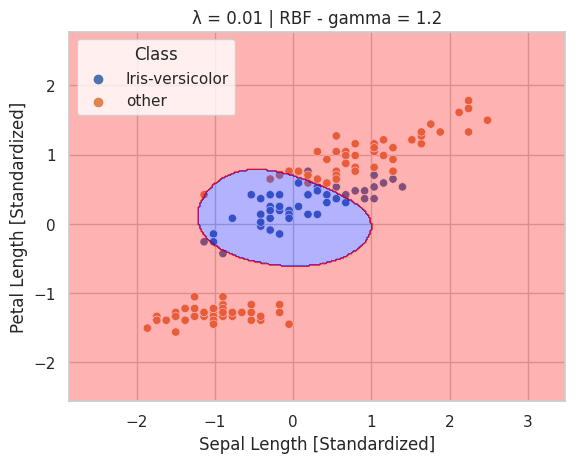

In [339]:
model = KernelSVM(
    Kernels.rbf(1.2),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

plt.title("λ = 0.01 | RBF - gamma = 1.2")
model.draw_decision_boundary(X)

predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")